# Recriar Estudo 6 - FLAME

In [1]:
import sys
print(sys.executable)

/home/magda/tf-gpu-env/bin/python3.10


**Ver se está a usar a GPU**

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2025-06-26 02:58:06.786572: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-06-26 02:58:07.889171: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16259050426137755191
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2351693824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14396865782450051123
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2025-06-26 02:58:09.578521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 02:58:09.686010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 02:58:09.686081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 02:58:09.869451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 02:58:09.869525: I tensorflow/compile

**imports**

In [3]:
import os
# Ativa o alocador assíncrono (melhora fragmentação de memória)
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
# Ativa a alocação dinâmica de memória (não ocupa toda a memória no início)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Erro ao definir memory growth:", e)
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
                                     GlobalMaxPooling2D, Dense, Dropout, BatchNormalization, AveragePooling2D,
                                     Concatenate, Flatten, LayerNormalization, Multiply, Add, Activation, Reshape)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_auc_score
import math

print("TensorFlow:", tf.__version__)
print("TensorFlow Addons:", tfa.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)

2025-06-26 02:58:09.881667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 02:58:09.881867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 02:58:09.881911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
/home/magda/tf-gpu-env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.


TensorFlow: 2.13.0
TensorFlow Addons: 0.21.0
NumPy: 1.23.5
Pandas: 1.5.3
Matplotlib: 3.7.1


## Arquitetura do Modelo:

In [4]:
def channel_attention(input_feature, reduction_ratio=8):
    channel = input_feature.shape[-1]

    shared_dense_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='glorot_uniform')
    shared_dense_two = Dense(channel, activation='relu', kernel_initializer='glorot_uniform')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = GlobalMaxPooling2D()(input_feature)

    avg_out = shared_dense_two(shared_dense_one(avg_pool))
    max_out = shared_dense_two(shared_dense_one(max_pool))

    cbam_feature = Add()([avg_out, max_out])
    cbam_feature = Activation('relu')(cbam_feature)
    cbam_feature = Reshape((1, 1, channel))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

# Atenção espacial com layer norm, conv 7x7 e gating
def spatial_attention(input_feature):
    avg_pool = tf.reduce_mean(input_feature, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(input_feature, axis=-1, keepdims=True)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    concat = LayerNormalization()(concat)

    conv = Conv2D(1, kernel_size=7, padding='same', activation='relu')(concat)
    gate = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')(concat)
    gated = Multiply()([conv, gate])

    return Multiply()([input_feature, gated])

# Bloco AHC: convoluções paralelas com pooling
def AHC_block(input_tensor):
    conv_3x3 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(input_tensor)
    conv_5x5 = Conv2D(32, kernel_size=5, padding='same', activation='relu')(input_tensor)
    conv_7x7 = Conv2D(32, kernel_size=7, padding='same', activation='relu')(input_tensor)

    pool_3x3 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_3x3)
    pool_5x5 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_5x5)
    pool_7x7 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_7x7)

    return Concatenate()([pool_3x3, pool_5x5, pool_7x7])

# Modelo completo AHMHCNN-mCBAM
def build_AHMHCNN_mCBAM(input_shape=(256, 256, 3), num_classes=2):
    inputs = Input(shape=input_shape)

    # MHCNN base convolucional
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(48, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(64, kernel_size=5, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.02)(x)
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.02)(x)

    # Bloco AHC
    x = AHC_block(x)

    # Bloco mCBAM
    x = channel_attention(x)
    x = spatial_attention(x)

    # Classificação
    x = Flatten()(x)
    x = Dense(56, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(48, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Criar o modelo
model = build_AHMHCNN_mCBAM()

2025-06-26 02:58:10.733475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 02:58:10.733646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 02:58:10.733700: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 02:58:10.734114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 02:58:10.734130: I tensorflow/core/co

In [5]:
# Compilar o modelo
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=2, average='macro')
    ]
)

In [6]:
# Mostrar resumo
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            


 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             


 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d[0][0]']              


 D)                                                                                               


 conv2d_1 (Conv2D)           (None, 128, 128, 48)         13872     ['max_pooling2d[0][0]']       


 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 48)           0         ['conv2d_1[0][0]']            


 g2D)                                                                                             


 conv2d_2 (Conv2D)           (None, 64, 64, 64)           76864     ['max_pooling2d_1[0][0]']     


 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 64)           0         ['conv2d_2[0][0]']            


 g2D)                                                                                             


 dropout (Dropout)           (None, 32, 32, 64)           0         ['max_pooling2d_2[0][0]']     


 conv2d_3 (Conv2D)           (None, 32, 32, 32)           18464     ['dropout[0][0]']             


 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)           0         ['conv2d_3[0][0]']            


 g2D)                                                                                             


 batch_normalization (Batch  (None, 16, 16, 32)           128       ['max_pooling2d_3[0][0]']     


 Normalization)                                                                                   


 dropout_1 (Dropout)         (None, 16, 16, 32)           0         ['batch_normalization[0][0]'] 


 conv2d_4 (Conv2D)           (None, 16, 16, 32)           9248      ['dropout_1[0][0]']           


 conv2d_5 (Conv2D)           (None, 16, 16, 32)           25632     ['dropout_1[0][0]']           


 conv2d_6 (Conv2D)           (None, 16, 16, 32)           50208     ['dropout_1[0][0]']           


 average_pooling2d (Average  (None, 16, 16, 32)           0         ['conv2d_4[0][0]']            


 Pooling2D)                                                                                       


 average_pooling2d_1 (Avera  (None, 16, 16, 32)           0         ['conv2d_5[0][0]']            


 gePooling2D)                                                                                     


 average_pooling2d_2 (Avera  (None, 16, 16, 32)           0         ['conv2d_6[0][0]']            


 gePooling2D)                                                                                     


 concatenate (Concatenate)   (None, 16, 16, 96)           0         ['average_pooling2d[0][0]',   


                                                                     'average_pooling2d_1[0][0]', 


                                                                     'average_pooling2d_2[0][0]'] 


 global_average_pooling2d (  (None, 96)                   0         ['concatenate[0][0]']         


 GlobalAveragePooling2D)                                                                          


 global_max_pooling2d (Glob  (None, 96)                   0         ['concatenate[0][0]']         


 alMaxPooling2D)                                                                                  


 dense (Dense)               (None, 12)                   1164      ['global_average_pooling2d[0][


                                                                    0]',                          


                                                                     'global_max_pooling2d[0][0]']


 dense_1 (Dense)             (None, 96)                   1248      ['dense[0][0]',               


                                                                     'dense[1][0]']               


 add (Add)                   (None, 96)                   0         ['dense_1[0][0]',             


                                                                     'dense_1[1][0]']             


 activation (Activation)     (None, 96)                   0         ['add[0][0]']                 


 reshape (Reshape)           (None, 1, 1, 96)             0         ['activation[0][0]']          


 multiply (Multiply)         (None, 16, 16, 96)           0         ['concatenate[0][0]',         


                                                                     'reshape[0][0]']             


 tf.math.reduce_mean (TFOpL  (None, 16, 16, 1)            0         ['multiply[0][0]']            


 ambda)                                                                                           


 tf.math.reduce_max (TFOpLa  (None, 16, 16, 1)            0         ['multiply[0][0]']            


 mbda)                                                                                            


 concatenate_1 (Concatenate  (None, 16, 16, 2)            0         ['tf.math.reduce_mean[0][0]', 


 )                                                                   'tf.math.reduce_max[0][0]']  


 layer_normalization (Layer  (None, 16, 16, 2)            4         ['concatenate_1[0][0]']       


 Normalization)                                                                                   


 conv2d_7 (Conv2D)           (None, 16, 16, 1)            99        ['layer_normalization[0][0]'] 


 conv2d_8 (Conv2D)           (None, 16, 16, 1)            3         ['layer_normalization[0][0]'] 


 multiply_1 (Multiply)       (None, 16, 16, 1)            0         ['conv2d_7[0][0]',            


                                                                     'conv2d_8[0][0]']            


 multiply_2 (Multiply)       (None, 16, 16, 96)           0         ['multiply[0][0]',            


                                                                     'multiply_1[0][0]']          


 flatten (Flatten)           (None, 24576)                0         ['multiply_2[0][0]']          


 dense_2 (Dense)             (None, 56)                   1376312   ['flatten[0][0]']             


 batch_normalization_1 (Bat  (None, 56)                   224       ['dense_2[0][0]']             


 chNormalization)                                                                                 


 dense_3 (Dense)             (None, 48)                   2736      ['batch_normalization_1[0][0]'


                                                                    ]                             


 batch_normalization_2 (Bat  (None, 48)                   192       ['dense_3[0][0]']             


 chNormalization)                                                                                 


 dense_4 (Dense)             (None, 32)                   1568      ['batch_normalization_2[0][0]'


                                                                    ]                             


 batch_normalization_3 (Bat  (None, 32)                   128       ['dense_4[0][0]']             


 chNormalization)                                                                                 


 dense_5 (Dense)             (None, 2)                    66        ['batch_normalization_3[0][0]'


                                                                    ]                             


Total params: 1579056 (6.02 MB)


Trainable params: 1578720 (6.02 MB)


Non-trainable params: 336 (1.31 KB)


__________________________________________________________________________________________________


## Funções Auxiliares

Trata do pré-processamento das imagens, ou seja redimensiona para 224 X 224 pixels e normaliza [0,1] e coloca em one hot.

In [7]:
# Função auxiliar para carregar imagem
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    label = tf.one_hot(label, 2)
    return image, label

Permite analisar a distribuição dos datasets.

In [8]:
def inspect_dataset_distribution(dataset, name="dataset"):
    total_samples = 0
    label_counter = Counter()

    for images, labels in dataset:
        # labels vêm em one-hot: [0,1] ou [1,0]
        labels_np = labels.numpy()
        class_indices = labels_np.argmax(axis=1)  # <-- Corrigir: pegar o índice da classe correta
        total_samples += len(class_indices)
        label_counter.update(class_indices)

    print(f"📊 {name.upper()} -> Total de imagens: {total_samples}")
    for label, count in sorted(label_counter.items()):
        perc = (count / total_samples) * 100
        print(f"  Classe {int(label)} ({'Fogo' if label == 1 else 'Sem fogo'}): {count} imagens ({perc:.2f}%)")
    print("-" * 40)

Permite analisar o histórico de trino.

In [9]:
def plot_training_history(history):
    metrics = history.history.keys()
    epochs_range = range(len(history.history['loss']))

    for metric in metrics:
        if "val_" not in metric:
            plt.figure(figsize=(10, 5))
            plt.plot(epochs_range, history.history[metric], label=f"Train {metric}")
            if f"val_{metric}" in metrics:
                plt.plot(epochs_range, history.history[f"val_{metric}"], label=f"Val {metric}")
            plt.title(f"Training and Validation {metric.capitalize()}")
            plt.xlabel("Epochs")
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True)
            plt.show()

Usada para avaliar o modelo, ou seja, se está a prever corretamente a classificação das imagens.

In [10]:
import numpy as np
import math
from sklearn.metrics import roc_auc_score

def avaliar_modelo(model, dataset, ig=False):
    if ig:
        # Suporte para ImageDataGenerator (flow_from_directory ou similar)
        steps = math.ceil(dataset.samples / dataset.batch_size)
        y_pred_probs = model.predict(dataset, steps=steps, verbose=0)
        y_true = np.array(dataset.labels)

        # Corrigir os rótulos dependendo do formato (one-hot ou inteiro)
        if y_true.ndim > 1 and y_true.shape[1] > 1:
            y_true_int = np.argmax(y_true, axis=1)
        else:
            y_true_int = y_true
    else:
        # Suporte para tf.data.Dataset
        y_pred_probs = model.predict(dataset, verbose=0)
        y_true = np.concatenate([y for _, y in dataset], axis=0)
        y_true_int = np.argmax(y_true, axis=1)

    # Previsões binárias a partir das probabilidades
    y_pred_int = (y_pred_probs[:, 1] > 0.5).astype(int)

    # Cálculo das métricas de avaliação
    TP = np.sum((y_true_int == 1) & (y_pred_int == 1))
    TN = np.sum((y_true_int == 0) & (y_pred_int == 0))
    FP = np.sum((y_true_int == 0) & (y_pred_int == 1))
    FN = np.sum((y_true_int == 1) & (y_pred_int == 0))

    total = TP + TN + FP + FN

    accuracy   = (TP + TN) / total if total > 0 else 0.0
    precision  = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall     = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score   = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    auc        = roc_auc_score(y_true_int, y_pred_probs[:, 1])

    # Binary Crossentropy Loss
    eps = 1e-7
    p = np.clip(y_pred_probs[:, 1], eps, 1 - eps)
    y = y_true_int
    loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

    # Métricas específicas
    fdr = recall * 100
    ewr = ((FP + FN) / total) * 100 if total > 0 else 0.0

    # Impressão dos resultados
    print("=== MÉTRICAS DE AVALIAÇÃO ===")
    print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-Score       : {f1_score:.4f}")
    print(f"AUC            : {auc:.4f}")
    print(f"Binary Loss    : {loss:.4f}")
    print(f"FDR (Fire Detection Rate)      : {fdr:.2f} %")
    print(f"EWR (Error Warning Rate)       : {ewr:.2f} %")
    print("Confusion Matrix:")
    print(np.array([[TN, FP], [FN, TP]]))  # [[negativos reais], [positivos reais]]

    # Retorno das métricas
    return {
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'auc': auc,
        'loss': loss,
        'fdr': fdr,
        'ewr': ewr,
        'confusion_matrix': np.array([[TN, FP], [FN, TP]])
    }

## Treino

In [11]:
# Configurações gerais
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16
EPOCHS = 50
SEED = 42

In [12]:
data = pd.read_csv("../Datasets/Estudo2_Recriado.csv")
data = data[['image_path', 'label_bi']]
data['label_bi'] = data['label_bi'].astype(str)

In [13]:
# Dividir em treino, validação e teste (80/10/10)
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=SEED, stratify=data['label_bi'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df['label_bi'])

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Criar datasets TensorFlow
# Generator com aumentações para treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=160,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='reflect',
    cval=125
)

# Apenas normalização para validação
val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
# Função do agendamento de learning rate conforme o estudo
def custom_lr_schedule(epoch, lr):
    if epoch < 15:
        return 1e-4
    elif epoch < 25:
        return 1e-5
    else:
        return 1e-6

# Callbacks combinados
callback = [
    ModelCheckpoint('Recriar_Estudo_6_Aug_FLAME_best.h5', monitor='val_loss', save_best_only=True, verbose=1),
    LearningRateScheduler(custom_lr_schedule, verbose=1)
]

In [16]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label_bi',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',   # automaticamente faz one-hot
    color_mode='rgb',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label_bi',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label_bi',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 4492 validated image filenames belonging to 2 classes.


Found 561 validated image filenames belonging to 2 classes.


Found 562 validated image filenames belonging to 2 classes.


In [17]:
# Treinar
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callback
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.


Epoch 1/50


2025-06-26 02:58:14.322346: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2025-06-26 02:58:14.911809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


2025-06-26 02:58:16.075142: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x65194bba39c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-26 02:58:16.075188: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-06-26 02:58:16.123639: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


2025-06-26 02:58:16.379684: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/281 [..............................] - ETA: 44:58 - loss: 1.0294 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5000 - auc: 0.4297 - f1_score: 0.5000

  2/281 [..............................] - ETA: 25s - loss: 0.9220 - accuracy: 0.5938 - precision: 0.5938 - recall: 0.5938 - auc: 0.6211 - f1_score: 0.5934  

  3/281 [..............................] - ETA: 24s - loss: 0.8168 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6957 - f1_score: 0.6224

  4/281 [..............................] - ETA: 24s - loss: 0.7152 - accuracy: 0.6719 - precision: 0.6719 - recall: 0.6719 - auc: 0.7473 - f1_score: 0.6712

  5/281 [..............................] - ETA: 28s - loss: 0.6743 - accuracy: 0.7000 - precision: 0.7000 - recall: 0.7000 - auc: 0.7652 - f1_score: 0.6998

  6/281 [..............................] - ETA: 32s - loss: 0.6703 - accuracy: 0.6979 - precision: 0.6979 - recall: 0.6979 - auc: 0.7743 - f1_score: 0.6979

  7/281 [..............................] - ETA: 34s - loss: 0.6404 - accuracy: 0.7143 - precision: 0.7143 - recall: 0.7143 - auc: 0.7891 - f1_score: 0.7139

  8/281 [..............................] - ETA: 35s - loss: 0.6364 - accuracy: 0.7188 - precision: 0.7188 - recall: 0.7188 - auc: 0.7891 - f1_score: 0.7187

  9/281 [..............................] - ETA: 36s - loss: 0.6045 - accuracy: 0.7292 - precision: 0.7292 - recall: 0.7292 - auc: 0.8060 - f1_score: 0.7290

 10/281 [>.............................] - ETA: 37s - loss: 0.5650 - accuracy: 0.7563 - precision: 0.7563 - recall: 0.7563 - auc: 0.8238 - f1_score: 0.7562

 11/281 [>.............................] - ETA: 37s - loss: 0.5523 - accuracy: 0.7614 - precision: 0.7614 - recall: 0.7614 - auc: 0.8294 - f1_score: 0.7613

 12/281 [>.............................] - ETA: 38s - loss: 0.5531 - accuracy: 0.7656 - precision: 0.7656 - recall: 0.7656 - auc: 0.8306 - f1_score: 0.7656

 13/281 [>.............................] - ETA: 38s - loss: 0.5614 - accuracy: 0.7596 - precision: 0.7596 - recall: 0.7596 - auc: 0.8275 - f1_score: 0.7595

 14/281 [>.............................] - ETA: 38s - loss: 0.6043 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.8124 - f1_score: 0.7499

 15/281 [>.............................] - ETA: 38s - loss: 0.6131 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.8075 - f1_score: 0.7500

 16/281 [>.............................] - ETA: 38s - loss: 0.6135 - accuracy: 0.7539 - precision: 0.7539 - recall: 0.7539 - auc: 0.8126 - f1_score: 0.7539

 17/281 [>.............................] - ETA: 39s - loss: 0.5921 - accuracy: 0.7574 - precision: 0.7574 - recall: 0.7574 - auc: 0.8218 - f1_score: 0.7574

 18/281 [>.............................] - ETA: 39s - loss: 0.5802 - accuracy: 0.7569 - precision: 0.7569 - recall: 0.7569 - auc: 0.8273 - f1_score: 0.7569

 19/281 [=>............................] - ETA: 39s - loss: 0.5758 - accuracy: 0.7599 - precision: 0.7599 - recall: 0.7599 - auc: 0.8311 - f1_score: 0.7599

 20/281 [=>............................] - ETA: 39s - loss: 0.5926 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.8228 - f1_score: 0.7500

 21/281 [=>............................] - ETA: 39s - loss: 0.5855 - accuracy: 0.7530 - precision: 0.7530 - recall: 0.7530 - auc: 0.8259 - f1_score: 0.7530

 22/281 [=>............................] - ETA: 39s - loss: 0.5784 - accuracy: 0.7528 - precision: 0.7528 - recall: 0.7528 - auc: 0.8278 - f1_score: 0.7527

 23/281 [=>............................] - ETA: 39s - loss: 0.5740 - accuracy: 0.7554 - precision: 0.7554 - recall: 0.7554 - auc: 0.8308 - f1_score: 0.7553

 24/281 [=>............................] - ETA: 38s - loss: 0.5735 - accuracy: 0.7552 - precision: 0.7552 - recall: 0.7552 - auc: 0.8300 - f1_score: 0.7549

 25/281 [=>............................] - ETA: 38s - loss: 0.5662 - accuracy: 0.7575 - precision: 0.7575 - recall: 0.7575 - auc: 0.8330 - f1_score: 0.7571

 26/281 [=>............................] - ETA: 38s - loss: 0.5628 - accuracy: 0.7596 - precision: 0.7596 - recall: 0.7596 - auc: 0.8350 - f1_score: 0.7591

 27/281 [=>............................] - ETA: 38s - loss: 0.5649 - accuracy: 0.7569 - precision: 0.7569 - recall: 0.7569 - auc: 0.8334 - f1_score: 0.7564

 28/281 [=>............................] - ETA: 38s - loss: 0.5562 - accuracy: 0.7589 - precision: 0.7589 - recall: 0.7589 - auc: 0.8376 - f1_score: 0.7583

 29/281 [==>...........................] - ETA: 38s - loss: 0.5528 - accuracy: 0.7629 - precision: 0.7629 - recall: 0.7629 - auc: 0.8397 - f1_score: 0.7623

 30/281 [==>...........................] - ETA: 38s - loss: 0.5454 - accuracy: 0.7625 - precision: 0.7625 - recall: 0.7625 - auc: 0.8428 - f1_score: 0.7618

 31/281 [==>...........................] - ETA: 38s - loss: 0.5524 - accuracy: 0.7581 - precision: 0.7581 - recall: 0.7581 - auc: 0.8395 - f1_score: 0.7574

 32/281 [==>...........................] - ETA: 38s - loss: 0.5511 - accuracy: 0.7598 - precision: 0.7598 - recall: 0.7598 - auc: 0.8401 - f1_score: 0.7592

 33/281 [==>...........................] - ETA: 38s - loss: 0.5529 - accuracy: 0.7576 - precision: 0.7576 - recall: 0.7576 - auc: 0.8395 - f1_score: 0.7571

 34/281 [==>...........................] - ETA: 38s - loss: 0.5591 - accuracy: 0.7592 - precision: 0.7592 - recall: 0.7592 - auc: 0.8362 - f1_score: 0.7584

 35/281 [==>...........................] - ETA: 38s - loss: 0.5543 - accuracy: 0.7589 - precision: 0.7589 - recall: 0.7589 - auc: 0.8380 - f1_score: 0.7582

 36/281 [==>...........................] - ETA: 37s - loss: 0.5467 - accuracy: 0.7639 - precision: 0.7639 - recall: 0.7639 - auc: 0.8414 - f1_score: 0.7632

 37/281 [==>...........................] - ETA: 37s - loss: 0.5383 - accuracy: 0.7669 - precision: 0.7669 - recall: 0.7669 - auc: 0.8447 - f1_score: 0.7661

 38/281 [===>..........................] - ETA: 37s - loss: 0.5372 - accuracy: 0.7664 - precision: 0.7664 - recall: 0.7664 - auc: 0.8454 - f1_score: 0.7657

 39/281 [===>..........................] - ETA: 37s - loss: 0.5446 - accuracy: 0.7660 - precision: 0.7660 - recall: 0.7660 - auc: 0.8423 - f1_score: 0.7656

 40/281 [===>..........................] - ETA: 37s - loss: 0.5524 - accuracy: 0.7609 - precision: 0.7609 - recall: 0.7609 - auc: 0.8387 - f1_score: 0.7605

 41/281 [===>..........................] - ETA: 37s - loss: 0.5496 - accuracy: 0.7622 - precision: 0.7622 - recall: 0.7622 - auc: 0.8399 - f1_score: 0.7618

 42/281 [===>..........................] - ETA: 37s - loss: 0.5465 - accuracy: 0.7649 - precision: 0.7649 - recall: 0.7649 - auc: 0.8414 - f1_score: 0.7645

 43/281 [===>..........................] - ETA: 37s - loss: 0.5457 - accuracy: 0.7674 - precision: 0.7674 - recall: 0.7674 - auc: 0.8416 - f1_score: 0.7669

 44/281 [===>..........................] - ETA: 37s - loss: 0.5576 - accuracy: 0.7628 - precision: 0.7628 - recall: 0.7628 - auc: 0.8370 - f1_score: 0.7623

 45/281 [===>..........................] - ETA: 37s - loss: 0.5674 - accuracy: 0.7597 - precision: 0.7597 - recall: 0.7597 - auc: 0.8339 - f1_score: 0.7594

 46/281 [===>..........................] - ETA: 36s - loss: 0.5643 - accuracy: 0.7609 - precision: 0.7609 - recall: 0.7609 - auc: 0.8347 - f1_score: 0.7604

 47/281 [====>.........................] - ETA: 36s - loss: 0.5648 - accuracy: 0.7633 - precision: 0.7633 - recall: 0.7633 - auc: 0.8347 - f1_score: 0.7629

 48/281 [====>.........................] - ETA: 36s - loss: 0.5633 - accuracy: 0.7643 - precision: 0.7643 - recall: 0.7643 - auc: 0.8354 - f1_score: 0.7640

 49/281 [====>.........................] - ETA: 36s - loss: 0.5609 - accuracy: 0.7653 - precision: 0.7653 - recall: 0.7653 - auc: 0.8363 - f1_score: 0.7650

 50/281 [====>.........................] - ETA: 36s - loss: 0.5601 - accuracy: 0.7638 - precision: 0.7638 - recall: 0.7638 - auc: 0.8363 - f1_score: 0.7634

 51/281 [====>.........................] - ETA: 36s - loss: 0.5540 - accuracy: 0.7684 - precision: 0.7684 - recall: 0.7684 - auc: 0.8385 - f1_score: 0.7680

 52/281 [====>.........................] - ETA: 36s - loss: 0.5498 - accuracy: 0.7704 - precision: 0.7704 - recall: 0.7704 - auc: 0.8402 - f1_score: 0.7700

 53/281 [====>.........................] - ETA: 36s - loss: 0.5533 - accuracy: 0.7689 - precision: 0.7689 - recall: 0.7689 - auc: 0.8383 - f1_score: 0.7685

 54/281 [====>.........................] - ETA: 35s - loss: 0.5451 - accuracy: 0.7731 - precision: 0.7731 - recall: 0.7731 - auc: 0.8421 - f1_score: 0.7728

 55/281 [====>.........................] - ETA: 35s - loss: 0.5428 - accuracy: 0.7727 - precision: 0.7727 - recall: 0.7727 - auc: 0.8428 - f1_score: 0.7724

 56/281 [====>.........................] - ETA: 35s - loss: 0.5452 - accuracy: 0.7712 - precision: 0.7712 - recall: 0.7712 - auc: 0.8411 - f1_score: 0.7708

 57/281 [=====>........................] - ETA: 35s - loss: 0.5429 - accuracy: 0.7719 - precision: 0.7719 - recall: 0.7719 - auc: 0.8420 - f1_score: 0.7715

 58/281 [=====>........................] - ETA: 35s - loss: 0.5469 - accuracy: 0.7705 - precision: 0.7705 - recall: 0.7705 - auc: 0.8394 - f1_score: 0.7700

 59/281 [=====>........................] - ETA: 35s - loss: 0.5508 - accuracy: 0.7680 - precision: 0.7680 - recall: 0.7680 - auc: 0.8370 - f1_score: 0.7675

 60/281 [=====>........................] - ETA: 35s - loss: 0.5496 - accuracy: 0.7698 - precision: 0.7698 - recall: 0.7698 - auc: 0.8375 - f1_score: 0.7693

 61/281 [=====>........................] - ETA: 35s - loss: 0.5460 - accuracy: 0.7725 - precision: 0.7725 - recall: 0.7725 - auc: 0.8390 - f1_score: 0.7721

 62/281 [=====>........................] - ETA: 34s - loss: 0.5417 - accuracy: 0.7742 - precision: 0.7742 - recall: 0.7742 - auc: 0.8411 - f1_score: 0.7738

 63/281 [=====>........................] - ETA: 34s - loss: 0.5431 - accuracy: 0.7738 - precision: 0.7738 - recall: 0.7738 - auc: 0.8402 - f1_score: 0.7734

 64/281 [=====>........................] - ETA: 34s - loss: 0.5497 - accuracy: 0.7695 - precision: 0.7695 - recall: 0.7695 - auc: 0.8366 - f1_score: 0.7691

 65/281 [=====>........................] - ETA: 34s - loss: 0.5510 - accuracy: 0.7702 - precision: 0.7702 - recall: 0.7702 - auc: 0.8360 - f1_score: 0.7697

 66/281 [======>.......................] - ETA: 34s - loss: 0.5464 - accuracy: 0.7718 - precision: 0.7718 - recall: 0.7718 - auc: 0.8379 - f1_score: 0.7713

 67/281 [======>.......................] - ETA: 34s - loss: 0.5455 - accuracy: 0.7724 - precision: 0.7724 - recall: 0.7724 - auc: 0.8385 - f1_score: 0.7719

 68/281 [======>.......................] - ETA: 33s - loss: 0.5417 - accuracy: 0.7739 - precision: 0.7739 - recall: 0.7739 - auc: 0.8400 - f1_score: 0.7733

 69/281 [======>.......................] - ETA: 33s - loss: 0.5389 - accuracy: 0.7754 - precision: 0.7754 - recall: 0.7754 - auc: 0.8411 - f1_score: 0.7749

 70/281 [======>.......................] - ETA: 33s - loss: 0.5344 - accuracy: 0.7777 - precision: 0.7777 - recall: 0.7777 - auc: 0.8432 - f1_score: 0.7771

 71/281 [======>.......................] - ETA: 33s - loss: 0.5363 - accuracy: 0.7773 - precision: 0.7773 - recall: 0.7773 - auc: 0.8424 - f1_score: 0.7768

 72/281 [======>.......................] - ETA: 33s - loss: 0.5319 - accuracy: 0.7804 - precision: 0.7804 - recall: 0.7804 - auc: 0.8444 - f1_score: 0.7800

 73/281 [======>.......................] - ETA: 38s - loss: 0.5317 - accuracy: 0.7801 - precision: 0.7801 - recall: 0.7801 - auc: 0.8445 - f1_score: 0.7797

 74/281 [======>.......................] - ETA: 38s - loss: 0.5303 - accuracy: 0.7797 - precision: 0.7797 - recall: 0.7797 - auc: 0.8451 - f1_score: 0.7793

 75/281 [=======>......................] - ETA: 37s - loss: 0.5268 - accuracy: 0.7809 - precision: 0.7809 - recall: 0.7809 - auc: 0.8465 - f1_score: 0.7806

 76/281 [=======>......................] - ETA: 37s - loss: 0.5238 - accuracy: 0.7822 - precision: 0.7822 - recall: 0.7822 - auc: 0.8477 - f1_score: 0.7818

 77/281 [=======>......................] - ETA: 36s - loss: 0.5226 - accuracy: 0.7818 - precision: 0.7818 - recall: 0.7818 - auc: 0.8480 - f1_score: 0.7814

 78/281 [=======>......................] - ETA: 36s - loss: 0.5196 - accuracy: 0.7830 - precision: 0.7830 - recall: 0.7830 - auc: 0.8494 - f1_score: 0.7825

 79/281 [=======>......................] - ETA: 36s - loss: 0.5164 - accuracy: 0.7841 - precision: 0.7841 - recall: 0.7841 - auc: 0.8510 - f1_score: 0.7837

 80/281 [=======>......................] - ETA: 35s - loss: 0.5132 - accuracy: 0.7861 - precision: 0.7861 - recall: 0.7861 - auc: 0.8525 - f1_score: 0.7856

 81/281 [=======>......................] - ETA: 35s - loss: 0.5093 - accuracy: 0.7864 - precision: 0.7864 - recall: 0.7864 - auc: 0.8544 - f1_score: 0.7859

 82/281 [=======>......................] - ETA: 35s - loss: 0.5099 - accuracy: 0.7859 - precision: 0.7859 - recall: 0.7859 - auc: 0.8541 - f1_score: 0.7855

 83/281 [=======>......................] - ETA: 35s - loss: 0.5074 - accuracy: 0.7870 - precision: 0.7870 - recall: 0.7870 - auc: 0.8552 - f1_score: 0.7865

 84/281 [=======>......................] - ETA: 34s - loss: 0.5048 - accuracy: 0.7881 - precision: 0.7881 - recall: 0.7881 - auc: 0.8564 - f1_score: 0.7876

 85/281 [========>.....................] - ETA: 34s - loss: 0.5027 - accuracy: 0.7883 - precision: 0.7883 - recall: 0.7883 - auc: 0.8575 - f1_score: 0.7879

 86/281 [========>.....................] - ETA: 34s - loss: 0.5038 - accuracy: 0.7886 - precision: 0.7886 - recall: 0.7886 - auc: 0.8570 - f1_score: 0.7882

 87/281 [========>.....................] - ETA: 34s - loss: 0.5006 - accuracy: 0.7903 - precision: 0.7903 - recall: 0.7903 - auc: 0.8584 - f1_score: 0.7899

 88/281 [========>.....................] - ETA: 34s - loss: 0.4981 - accuracy: 0.7913 - precision: 0.7913 - recall: 0.7913 - auc: 0.8596 - f1_score: 0.7908

 89/281 [========>.....................] - ETA: 33s - loss: 0.4974 - accuracy: 0.7923 - precision: 0.7923 - recall: 0.7923 - auc: 0.8601 - f1_score: 0.7918

 90/281 [========>.....................] - ETA: 33s - loss: 0.4951 - accuracy: 0.7925 - precision: 0.7925 - recall: 0.7925 - auc: 0.8612 - f1_score: 0.7920

 91/281 [========>.....................] - ETA: 33s - loss: 0.4924 - accuracy: 0.7927 - precision: 0.7927 - recall: 0.7927 - auc: 0.8624 - f1_score: 0.7922

 92/281 [========>.....................] - ETA: 33s - loss: 0.4941 - accuracy: 0.7909 - precision: 0.7909 - recall: 0.7909 - auc: 0.8616 - f1_score: 0.7904

 93/281 [========>.....................] - ETA: 33s - loss: 0.4927 - accuracy: 0.7904 - precision: 0.7904 - recall: 0.7904 - auc: 0.8621 - f1_score: 0.7899

 94/281 [=========>....................] - ETA: 32s - loss: 0.4942 - accuracy: 0.7907 - precision: 0.7907 - recall: 0.7907 - auc: 0.8616 - f1_score: 0.7902

 95/281 [=========>....................] - ETA: 32s - loss: 0.4942 - accuracy: 0.7909 - precision: 0.7909 - recall: 0.7909 - auc: 0.8616 - f1_score: 0.7904

 96/281 [=========>....................] - ETA: 32s - loss: 0.4904 - accuracy: 0.7924 - precision: 0.7924 - recall: 0.7924 - auc: 0.8635 - f1_score: 0.7919

 97/281 [=========>....................] - ETA: 32s - loss: 0.4879 - accuracy: 0.7933 - precision: 0.7933 - recall: 0.7933 - auc: 0.8647 - f1_score: 0.7928

 98/281 [=========>....................] - ETA: 32s - loss: 0.4877 - accuracy: 0.7928 - precision: 0.7928 - recall: 0.7928 - auc: 0.8647 - f1_score: 0.7924

 99/281 [=========>....................] - ETA: 31s - loss: 0.4851 - accuracy: 0.7937 - precision: 0.7937 - recall: 0.7937 - auc: 0.8660 - f1_score: 0.7933

100/281 [=========>....................] - ETA: 31s - loss: 0.4864 - accuracy: 0.7926 - precision: 0.7926 - recall: 0.7926 - auc: 0.8654 - f1_score: 0.7922

101/281 [=========>....................] - ETA: 31s - loss: 0.4873 - accuracy: 0.7916 - precision: 0.7916 - recall: 0.7916 - auc: 0.8650 - f1_score: 0.7912

102/281 [=========>....................] - ETA: 31s - loss: 0.4875 - accuracy: 0.7905 - precision: 0.7905 - recall: 0.7905 - auc: 0.8649 - f1_score: 0.7902

103/281 [=========>....................] - ETA: 31s - loss: 0.4852 - accuracy: 0.7908 - precision: 0.7908 - recall: 0.7908 - auc: 0.8660 - f1_score: 0.7904

104/281 [==========>...................] - ETA: 30s - loss: 0.4827 - accuracy: 0.7916 - precision: 0.7916 - recall: 0.7916 - auc: 0.8671 - f1_score: 0.7912

105/281 [==========>...................] - ETA: 30s - loss: 0.4820 - accuracy: 0.7918 - precision: 0.7918 - recall: 0.7918 - auc: 0.8674 - f1_score: 0.7914

106/281 [==========>...................] - ETA: 30s - loss: 0.4821 - accuracy: 0.7920 - precision: 0.7920 - recall: 0.7920 - auc: 0.8674 - f1_score: 0.7916

107/281 [==========>...................] - ETA: 30s - loss: 0.4818 - accuracy: 0.7910 - precision: 0.7910 - recall: 0.7910 - auc: 0.8675 - f1_score: 0.7906

108/281 [==========>...................] - ETA: 30s - loss: 0.4813 - accuracy: 0.7906 - precision: 0.7906 - recall: 0.7906 - auc: 0.8676 - f1_score: 0.7903

109/281 [==========>...................] - ETA: 30s - loss: 0.4810 - accuracy: 0.7908 - precision: 0.7908 - recall: 0.7908 - auc: 0.8677 - f1_score: 0.7905

110/281 [==========>...................] - ETA: 29s - loss: 0.4831 - accuracy: 0.7904 - precision: 0.7904 - recall: 0.7904 - auc: 0.8669 - f1_score: 0.7902

111/281 [==========>...................] - ETA: 29s - loss: 0.4805 - accuracy: 0.7918 - precision: 0.7918 - recall: 0.7918 - auc: 0.8681 - f1_score: 0.7915

112/281 [==========>...................] - ETA: 29s - loss: 0.4782 - accuracy: 0.7925 - precision: 0.7925 - recall: 0.7925 - auc: 0.8693 - f1_score: 0.7923

113/281 [===========>..................] - ETA: 29s - loss: 0.4760 - accuracy: 0.7938 - precision: 0.7938 - recall: 0.7938 - auc: 0.8703 - f1_score: 0.7936

114/281 [===========>..................] - ETA: 29s - loss: 0.4764 - accuracy: 0.7929 - precision: 0.7929 - recall: 0.7929 - auc: 0.8700 - f1_score: 0.7926

115/281 [===========>..................] - ETA: 28s - loss: 0.4757 - accuracy: 0.7919 - precision: 0.7919 - recall: 0.7919 - auc: 0.8703 - f1_score: 0.7917

116/281 [===========>..................] - ETA: 28s - loss: 0.4741 - accuracy: 0.7921 - precision: 0.7921 - recall: 0.7921 - auc: 0.8710 - f1_score: 0.7919

117/281 [===========>..................] - ETA: 28s - loss: 0.4719 - accuracy: 0.7928 - precision: 0.7928 - recall: 0.7928 - auc: 0.8720 - f1_score: 0.7926

118/281 [===========>..................] - ETA: 28s - loss: 0.4702 - accuracy: 0.7935 - precision: 0.7935 - recall: 0.7935 - auc: 0.8728 - f1_score: 0.7933

119/281 [===========>..................] - ETA: 28s - loss: 0.4670 - accuracy: 0.7953 - precision: 0.7953 - recall: 0.7953 - auc: 0.8744 - f1_score: 0.7951

120/281 [===========>..................] - ETA: 28s - loss: 0.4652 - accuracy: 0.7965 - precision: 0.7965 - recall: 0.7965 - auc: 0.8751 - f1_score: 0.7963

121/281 [===========>..................] - ETA: 27s - loss: 0.4630 - accuracy: 0.7971 - precision: 0.7971 - recall: 0.7971 - auc: 0.8762 - f1_score: 0.7969

122/281 [============>.................] - ETA: 27s - loss: 0.4644 - accuracy: 0.7967 - precision: 0.7967 - recall: 0.7967 - auc: 0.8756 - f1_score: 0.7965

123/281 [============>.................] - ETA: 27s - loss: 0.4641 - accuracy: 0.7963 - precision: 0.7963 - recall: 0.7963 - auc: 0.8757 - f1_score: 0.7962

124/281 [============>.................] - ETA: 27s - loss: 0.4653 - accuracy: 0.7960 - precision: 0.7960 - recall: 0.7960 - auc: 0.8752 - f1_score: 0.7958

125/281 [============>.................] - ETA: 27s - loss: 0.4637 - accuracy: 0.7966 - precision: 0.7966 - recall: 0.7966 - auc: 0.8760 - f1_score: 0.7965

126/281 [============>.................] - ETA: 26s - loss: 0.4610 - accuracy: 0.7982 - precision: 0.7982 - recall: 0.7982 - auc: 0.8773 - f1_score: 0.7981

127/281 [============>.................] - ETA: 26s - loss: 0.4598 - accuracy: 0.7983 - precision: 0.7983 - recall: 0.7983 - auc: 0.8778 - f1_score: 0.7982

128/281 [============>.................] - ETA: 26s - loss: 0.4591 - accuracy: 0.7984 - precision: 0.7984 - recall: 0.7984 - auc: 0.8782 - f1_score: 0.7983

129/281 [============>.................] - ETA: 26s - loss: 0.4591 - accuracy: 0.7981 - precision: 0.7981 - recall: 0.7981 - auc: 0.8781 - f1_score: 0.7980

130/281 [============>.................] - ETA: 26s - loss: 0.4584 - accuracy: 0.7987 - precision: 0.7987 - recall: 0.7987 - auc: 0.8784 - f1_score: 0.7985

131/281 [============>.................] - ETA: 26s - loss: 0.4592 - accuracy: 0.7978 - precision: 0.7978 - recall: 0.7978 - auc: 0.8781 - f1_score: 0.7977

132/281 [=============>................] - ETA: 25s - loss: 0.4578 - accuracy: 0.7989 - precision: 0.7989 - recall: 0.7989 - auc: 0.8786 - f1_score: 0.7988

133/281 [=============>................] - ETA: 25s - loss: 0.4571 - accuracy: 0.7985 - precision: 0.7985 - recall: 0.7985 - auc: 0.8789 - f1_score: 0.7984

134/281 [=============>................] - ETA: 25s - loss: 0.4556 - accuracy: 0.7995 - precision: 0.7995 - recall: 0.7995 - auc: 0.8794 - f1_score: 0.7994

135/281 [=============>................] - ETA: 25s - loss: 0.4538 - accuracy: 0.8006 - precision: 0.8006 - recall: 0.8006 - auc: 0.8803 - f1_score: 0.8005

136/281 [=============>................] - ETA: 25s - loss: 0.4528 - accuracy: 0.8002 - precision: 0.8002 - recall: 0.8002 - auc: 0.8807 - f1_score: 0.8001

137/281 [=============>................] - ETA: 25s - loss: 0.4518 - accuracy: 0.8003 - precision: 0.8003 - recall: 0.8003 - auc: 0.8812 - f1_score: 0.8002

138/281 [=============>................] - ETA: 24s - loss: 0.4502 - accuracy: 0.8008 - precision: 0.8008 - recall: 0.8008 - auc: 0.8819 - f1_score: 0.8007

139/281 [=============>................] - ETA: 24s - loss: 0.4520 - accuracy: 0.7995 - precision: 0.7995 - recall: 0.7995 - auc: 0.8810 - f1_score: 0.7995

140/281 [=============>................] - ETA: 24s - loss: 0.4545 - accuracy: 0.7974 - precision: 0.7974 - recall: 0.7974 - auc: 0.8798 - f1_score: 0.7973

141/281 [==============>...............] - ETA: 24s - loss: 0.4536 - accuracy: 0.7975 - precision: 0.7975 - recall: 0.7975 - auc: 0.8802 - f1_score: 0.7974

142/281 [==============>...............] - ETA: 24s - loss: 0.4514 - accuracy: 0.7989 - precision: 0.7989 - recall: 0.7989 - auc: 0.8812 - f1_score: 0.7989

143/281 [==============>...............] - ETA: 23s - loss: 0.4533 - accuracy: 0.7982 - precision: 0.7982 - recall: 0.7982 - auc: 0.8806 - f1_score: 0.7981

144/281 [==============>...............] - ETA: 23s - loss: 0.4518 - accuracy: 0.7987 - precision: 0.7987 - recall: 0.7987 - auc: 0.8813 - f1_score: 0.7986

145/281 [==============>...............] - ETA: 23s - loss: 0.4512 - accuracy: 0.7992 - precision: 0.7992 - recall: 0.7992 - auc: 0.8815 - f1_score: 0.7991

146/281 [==============>...............] - ETA: 23s - loss: 0.4516 - accuracy: 0.7989 - precision: 0.7989 - recall: 0.7989 - auc: 0.8813 - f1_score: 0.7988

147/281 [==============>...............] - ETA: 23s - loss: 0.4525 - accuracy: 0.7986 - precision: 0.7986 - recall: 0.7986 - auc: 0.8809 - f1_score: 0.7985

148/281 [==============>...............] - ETA: 23s - loss: 0.4517 - accuracy: 0.7982 - precision: 0.7982 - recall: 0.7982 - auc: 0.8812 - f1_score: 0.7981

149/281 [==============>...............] - ETA: 22s - loss: 0.4508 - accuracy: 0.7987 - precision: 0.7987 - recall: 0.7987 - auc: 0.8815 - f1_score: 0.7986

150/281 [===============>..............] - ETA: 22s - loss: 0.4508 - accuracy: 0.7988 - precision: 0.7988 - recall: 0.7988 - auc: 0.8814 - f1_score: 0.7987

151/281 [===============>..............] - ETA: 22s - loss: 0.4509 - accuracy: 0.7985 - precision: 0.7985 - recall: 0.7985 - auc: 0.8813 - f1_score: 0.7984

152/281 [===============>..............] - ETA: 22s - loss: 0.4496 - accuracy: 0.7990 - precision: 0.7990 - recall: 0.7990 - auc: 0.8819 - f1_score: 0.7989

153/281 [===============>..............] - ETA: 22s - loss: 0.4483 - accuracy: 0.7999 - precision: 0.7999 - recall: 0.7999 - auc: 0.8825 - f1_score: 0.7998

154/281 [===============>..............] - ETA: 21s - loss: 0.4475 - accuracy: 0.8000 - precision: 0.8000 - recall: 0.8000 - auc: 0.8828 - f1_score: 0.7999

155/281 [===============>..............] - ETA: 21s - loss: 0.4479 - accuracy: 0.7997 - precision: 0.7997 - recall: 0.7997 - auc: 0.8826 - f1_score: 0.7996

156/281 [===============>..............] - ETA: 21s - loss: 0.4475 - accuracy: 0.7998 - precision: 0.7998 - recall: 0.7998 - auc: 0.8828 - f1_score: 0.7997

157/281 [===============>..............] - ETA: 21s - loss: 0.4478 - accuracy: 0.8002 - precision: 0.8002 - recall: 0.8002 - auc: 0.8826 - f1_score: 0.8002

158/281 [===============>..............] - ETA: 21s - loss: 0.4477 - accuracy: 0.7999 - precision: 0.7999 - recall: 0.7999 - auc: 0.8826 - f1_score: 0.7998

159/281 [===============>..............] - ETA: 21s - loss: 0.4473 - accuracy: 0.8000 - precision: 0.8000 - recall: 0.8000 - auc: 0.8828 - f1_score: 0.7999

160/281 [================>.............] - ETA: 20s - loss: 0.4459 - accuracy: 0.8005 - precision: 0.8005 - recall: 0.8005 - auc: 0.8834 - f1_score: 0.8004

161/281 [================>.............] - ETA: 20s - loss: 0.4451 - accuracy: 0.8009 - precision: 0.8009 - recall: 0.8009 - auc: 0.8838 - f1_score: 0.8008

162/281 [================>.............] - ETA: 20s - loss: 0.4451 - accuracy: 0.8010 - precision: 0.8010 - recall: 0.8010 - auc: 0.8838 - f1_score: 0.8009

163/281 [================>.............] - ETA: 20s - loss: 0.4442 - accuracy: 0.8007 - precision: 0.8007 - recall: 0.8007 - auc: 0.8842 - f1_score: 0.8006

164/281 [================>.............] - ETA: 20s - loss: 0.4435 - accuracy: 0.8008 - precision: 0.8008 - recall: 0.8008 - auc: 0.8845 - f1_score: 0.8007

165/281 [================>.............] - ETA: 19s - loss: 0.4436 - accuracy: 0.8016 - precision: 0.8016 - recall: 0.8016 - auc: 0.8847 - f1_score: 0.8015

166/281 [================>.............] - ETA: 19s - loss: 0.4424 - accuracy: 0.8024 - precision: 0.8024 - recall: 0.8024 - auc: 0.8852 - f1_score: 0.8023

167/281 [================>.............] - ETA: 19s - loss: 0.4419 - accuracy: 0.8025 - precision: 0.8025 - recall: 0.8025 - auc: 0.8854 - f1_score: 0.8024

168/281 [================>.............] - ETA: 19s - loss: 0.4434 - accuracy: 0.8022 - precision: 0.8022 - recall: 0.8022 - auc: 0.8847 - f1_score: 0.8020

169/281 [=================>............] - ETA: 19s - loss: 0.4431 - accuracy: 0.8019 - precision: 0.8019 - recall: 0.8019 - auc: 0.8848 - f1_score: 0.8017

170/281 [=================>............] - ETA: 19s - loss: 0.4433 - accuracy: 0.8012 - precision: 0.8012 - recall: 0.8012 - auc: 0.8847 - f1_score: 0.8011

171/281 [=================>............] - ETA: 18s - loss: 0.4423 - accuracy: 0.8020 - precision: 0.8020 - recall: 0.8020 - auc: 0.8851 - f1_score: 0.8019

172/281 [=================>............] - ETA: 18s - loss: 0.4410 - accuracy: 0.8024 - precision: 0.8024 - recall: 0.8024 - auc: 0.8857 - f1_score: 0.8023

173/281 [=================>............] - ETA: 18s - loss: 0.4402 - accuracy: 0.8032 - precision: 0.8032 - recall: 0.8032 - auc: 0.8861 - f1_score: 0.8031

174/281 [=================>............] - ETA: 18s - loss: 0.4398 - accuracy: 0.8036 - precision: 0.8036 - recall: 0.8036 - auc: 0.8863 - f1_score: 0.8035

175/281 [=================>............] - ETA: 18s - loss: 0.4389 - accuracy: 0.8040 - precision: 0.8040 - recall: 0.8040 - auc: 0.8868 - f1_score: 0.8039

176/281 [=================>............] - ETA: 18s - loss: 0.4384 - accuracy: 0.8041 - precision: 0.8041 - recall: 0.8041 - auc: 0.8870 - f1_score: 0.8040

177/281 [=================>............] - ETA: 17s - loss: 0.4371 - accuracy: 0.8048 - precision: 0.8048 - recall: 0.8048 - auc: 0.8876 - f1_score: 0.8047

178/281 [==================>...........] - ETA: 17s - loss: 0.4369 - accuracy: 0.8052 - precision: 0.8052 - recall: 0.8052 - auc: 0.8876 - f1_score: 0.8051

179/281 [==================>...........] - ETA: 17s - loss: 0.4358 - accuracy: 0.8059 - precision: 0.8059 - recall: 0.8059 - auc: 0.8881 - f1_score: 0.8058

180/281 [==================>...........] - ETA: 17s - loss: 0.4352 - accuracy: 0.8063 - precision: 0.8063 - recall: 0.8063 - auc: 0.8884 - f1_score: 0.8062

181/281 [==================>...........] - ETA: 17s - loss: 0.4351 - accuracy: 0.8064 - precision: 0.8064 - recall: 0.8064 - auc: 0.8884 - f1_score: 0.8062

182/281 [==================>...........] - ETA: 16s - loss: 0.4379 - accuracy: 0.8057 - precision: 0.8057 - recall: 0.8057 - auc: 0.8874 - f1_score: 0.8056

183/281 [==================>...........] - ETA: 16s - loss: 0.4373 - accuracy: 0.8064 - precision: 0.8064 - recall: 0.8064 - auc: 0.8877 - f1_score: 0.8063

184/281 [==================>...........] - ETA: 16s - loss: 0.4371 - accuracy: 0.8065 - precision: 0.8065 - recall: 0.8065 - auc: 0.8878 - f1_score: 0.8064

185/281 [==================>...........] - ETA: 16s - loss: 0.4366 - accuracy: 0.8068 - precision: 0.8068 - recall: 0.8068 - auc: 0.8880 - f1_score: 0.8067

186/281 [==================>...........] - ETA: 16s - loss: 0.4357 - accuracy: 0.8069 - precision: 0.8069 - recall: 0.8069 - auc: 0.8884 - f1_score: 0.8068

187/281 [==================>...........] - ETA: 16s - loss: 0.4344 - accuracy: 0.8076 - precision: 0.8076 - recall: 0.8076 - auc: 0.8889 - f1_score: 0.8075

188/281 [===================>..........] - ETA: 15s - loss: 0.4333 - accuracy: 0.8083 - precision: 0.8083 - recall: 0.8083 - auc: 0.8894 - f1_score: 0.8081

189/281 [===================>..........] - ETA: 15s - loss: 0.4325 - accuracy: 0.8083 - precision: 0.8083 - recall: 0.8083 - auc: 0.8898 - f1_score: 0.8082

190/281 [===================>..........] - ETA: 15s - loss: 0.4313 - accuracy: 0.8090 - precision: 0.8090 - recall: 0.8090 - auc: 0.8903 - f1_score: 0.8089

191/281 [===================>..........] - ETA: 15s - loss: 0.4311 - accuracy: 0.8093 - precision: 0.8093 - recall: 0.8093 - auc: 0.8904 - f1_score: 0.8092

192/281 [===================>..........] - ETA: 15s - loss: 0.4313 - accuracy: 0.8093 - precision: 0.8093 - recall: 0.8093 - auc: 0.8902 - f1_score: 0.8092

193/281 [===================>..........] - ETA: 15s - loss: 0.4296 - accuracy: 0.8103 - precision: 0.8103 - recall: 0.8103 - auc: 0.8910 - f1_score: 0.8102

194/281 [===================>..........] - ETA: 14s - loss: 0.4290 - accuracy: 0.8106 - precision: 0.8106 - recall: 0.8106 - auc: 0.8913 - f1_score: 0.8105

195/281 [===================>..........] - ETA: 14s - loss: 0.4301 - accuracy: 0.8103 - precision: 0.8103 - recall: 0.8103 - auc: 0.8908 - f1_score: 0.8102

196/281 [===================>..........] - ETA: 14s - loss: 0.4288 - accuracy: 0.8110 - precision: 0.8110 - recall: 0.8110 - auc: 0.8914 - f1_score: 0.8109

197/281 [====================>.........] - ETA: 14s - loss: 0.4287 - accuracy: 0.8104 - precision: 0.8104 - recall: 0.8104 - auc: 0.8914 - f1_score: 0.8102

198/281 [====================>.........] - ETA: 14s - loss: 0.4289 - accuracy: 0.8101 - precision: 0.8101 - recall: 0.8101 - auc: 0.8913 - f1_score: 0.8099

199/281 [====================>.........] - ETA: 13s - loss: 0.4271 - accuracy: 0.8110 - precision: 0.8110 - recall: 0.8110 - auc: 0.8921 - f1_score: 0.8109

200/281 [====================>.........] - ETA: 13s - loss: 0.4265 - accuracy: 0.8113 - precision: 0.8113 - recall: 0.8113 - auc: 0.8924 - f1_score: 0.8112

201/281 [====================>.........] - ETA: 13s - loss: 0.4267 - accuracy: 0.8110 - precision: 0.8110 - recall: 0.8110 - auc: 0.8923 - f1_score: 0.8109

202/281 [====================>.........] - ETA: 13s - loss: 0.4278 - accuracy: 0.8104 - precision: 0.8104 - recall: 0.8104 - auc: 0.8918 - f1_score: 0.8103

203/281 [====================>.........] - ETA: 13s - loss: 0.4291 - accuracy: 0.8104 - precision: 0.8104 - recall: 0.8104 - auc: 0.8914 - f1_score: 0.8103

204/281 [====================>.........] - ETA: 13s - loss: 0.4277 - accuracy: 0.8110 - precision: 0.8110 - recall: 0.8110 - auc: 0.8921 - f1_score: 0.8109

205/281 [====================>.........] - ETA: 12s - loss: 0.4261 - accuracy: 0.8120 - precision: 0.8120 - recall: 0.8120 - auc: 0.8929 - f1_score: 0.8118

206/281 [====================>.........] - ETA: 12s - loss: 0.4250 - accuracy: 0.8126 - precision: 0.8126 - recall: 0.8126 - auc: 0.8933 - f1_score: 0.8124

207/281 [=====================>........] - ETA: 12s - loss: 0.4254 - accuracy: 0.8117 - precision: 0.8117 - recall: 0.8117 - auc: 0.8932 - f1_score: 0.8115

208/281 [=====================>........] - ETA: 12s - loss: 0.4250 - accuracy: 0.8120 - precision: 0.8120 - recall: 0.8120 - auc: 0.8934 - f1_score: 0.8118

209/281 [=====================>........] - ETA: 12s - loss: 0.4256 - accuracy: 0.8114 - precision: 0.8114 - recall: 0.8114 - auc: 0.8931 - f1_score: 0.8112

210/281 [=====================>........] - ETA: 12s - loss: 0.4257 - accuracy: 0.8114 - precision: 0.8114 - recall: 0.8114 - auc: 0.8931 - f1_score: 0.8112

211/281 [=====================>........] - ETA: 11s - loss: 0.4250 - accuracy: 0.8117 - precision: 0.8117 - recall: 0.8117 - auc: 0.8934 - f1_score: 0.8115

212/281 [=====================>........] - ETA: 11s - loss: 0.4252 - accuracy: 0.8120 - precision: 0.8120 - recall: 0.8120 - auc: 0.8934 - f1_score: 0.8118

213/281 [=====================>........] - ETA: 11s - loss: 0.4250 - accuracy: 0.8120 - precision: 0.8120 - recall: 0.8120 - auc: 0.8934 - f1_score: 0.8118

214/281 [=====================>........] - ETA: 11s - loss: 0.4258 - accuracy: 0.8114 - precision: 0.8114 - recall: 0.8114 - auc: 0.8930 - f1_score: 0.8112

215/281 [=====================>........] - ETA: 11s - loss: 0.4254 - accuracy: 0.8117 - precision: 0.8117 - recall: 0.8117 - auc: 0.8932 - f1_score: 0.8115

216/281 [======================>.......] - ETA: 11s - loss: 0.4242 - accuracy: 0.8123 - precision: 0.8123 - recall: 0.8123 - auc: 0.8938 - f1_score: 0.8121

217/281 [======================>.......] - ETA: 10s - loss: 0.4250 - accuracy: 0.8120 - precision: 0.8120 - recall: 0.8120 - auc: 0.8935 - f1_score: 0.8118

218/281 [======================>.......] - ETA: 10s - loss: 0.4246 - accuracy: 0.8126 - precision: 0.8126 - recall: 0.8126 - auc: 0.8937 - f1_score: 0.8124

219/281 [======================>.......] - ETA: 10s - loss: 0.4253 - accuracy: 0.8123 - precision: 0.8123 - recall: 0.8123 - auc: 0.8934 - f1_score: 0.8121

220/281 [======================>.......] - ETA: 10s - loss: 0.4259 - accuracy: 0.8126 - precision: 0.8126 - recall: 0.8126 - auc: 0.8933 - f1_score: 0.8124

221/281 [======================>.......] - ETA: 10s - loss: 0.4250 - accuracy: 0.8131 - precision: 0.8131 - recall: 0.8131 - auc: 0.8937 - f1_score: 0.8130

222/281 [======================>.......] - ETA: 10s - loss: 0.4242 - accuracy: 0.8134 - precision: 0.8134 - recall: 0.8134 - auc: 0.8940 - f1_score: 0.8133

223/281 [======================>.......] - ETA: 9s - loss: 0.4234 - accuracy: 0.8137 - precision: 0.8137 - recall: 0.8137 - auc: 0.8944 - f1_score: 0.8136 

224/281 [======================>.......] - ETA: 9s - loss: 0.4237 - accuracy: 0.8131 - precision: 0.8131 - recall: 0.8131 - auc: 0.8943 - f1_score: 0.8130

225/281 [=======================>......] - ETA: 9s - loss: 0.4236 - accuracy: 0.8128 - precision: 0.8128 - recall: 0.8128 - auc: 0.8943 - f1_score: 0.8127

226/281 [=======================>......] - ETA: 9s - loss: 0.4232 - accuracy: 0.8131 - precision: 0.8131 - recall: 0.8131 - auc: 0.8945 - f1_score: 0.8130

227/281 [=======================>......] - ETA: 9s - loss: 0.4236 - accuracy: 0.8131 - precision: 0.8131 - recall: 0.8131 - auc: 0.8943 - f1_score: 0.8130

228/281 [=======================>......] - ETA: 8s - loss: 0.4228 - accuracy: 0.8134 - precision: 0.8134 - recall: 0.8134 - auc: 0.8947 - f1_score: 0.8132

229/281 [=======================>......] - ETA: 8s - loss: 0.4215 - accuracy: 0.8142 - precision: 0.8142 - recall: 0.8142 - auc: 0.8953 - f1_score: 0.8140

230/281 [=======================>......] - ETA: 8s - loss: 0.4228 - accuracy: 0.8139 - precision: 0.8139 - recall: 0.8139 - auc: 0.8949 - f1_score: 0.8138

231/281 [=======================>......] - ETA: 8s - loss: 0.4216 - accuracy: 0.8147 - precision: 0.8147 - recall: 0.8147 - auc: 0.8955 - f1_score: 0.8146

232/281 [=======================>......] - ETA: 8s - loss: 0.4212 - accuracy: 0.8150 - precision: 0.8150 - recall: 0.8150 - auc: 0.8956 - f1_score: 0.8148

233/281 [=======================>......] - ETA: 8s - loss: 0.4198 - accuracy: 0.8158 - precision: 0.8158 - recall: 0.8158 - auc: 0.8962 - f1_score: 0.8156

234/281 [=======================>......] - ETA: 7s - loss: 0.4194 - accuracy: 0.8163 - precision: 0.8163 - recall: 0.8163 - auc: 0.8965 - f1_score: 0.8161

235/281 [========================>.....] - ETA: 7s - loss: 0.4186 - accuracy: 0.8166 - precision: 0.8166 - recall: 0.8166 - auc: 0.8967 - f1_score: 0.8164

236/281 [========================>.....] - ETA: 7s - loss: 0.4185 - accuracy: 0.8165 - precision: 0.8165 - recall: 0.8165 - auc: 0.8968 - f1_score: 0.8164

237/281 [========================>.....] - ETA: 7s - loss: 0.4191 - accuracy: 0.8160 - precision: 0.8160 - recall: 0.8160 - auc: 0.8965 - f1_score: 0.8158

238/281 [========================>.....] - ETA: 7s - loss: 0.4186 - accuracy: 0.8162 - precision: 0.8162 - recall: 0.8162 - auc: 0.8967 - f1_score: 0.8160

239/281 [========================>.....] - ETA: 7s - loss: 0.4181 - accuracy: 0.8168 - precision: 0.8168 - recall: 0.8168 - auc: 0.8969 - f1_score: 0.8165

240/281 [========================>.....] - ETA: 6s - loss: 0.4177 - accuracy: 0.8165 - precision: 0.8165 - recall: 0.8165 - auc: 0.8971 - f1_score: 0.8163

241/281 [========================>.....] - ETA: 6s - loss: 0.4178 - accuracy: 0.8165 - precision: 0.8165 - recall: 0.8165 - auc: 0.8970 - f1_score: 0.8163

242/281 [========================>.....] - ETA: 6s - loss: 0.4173 - accuracy: 0.8164 - precision: 0.8164 - recall: 0.8164 - auc: 0.8972 - f1_score: 0.8162

243/281 [========================>.....] - ETA: 6s - loss: 0.4160 - accuracy: 0.8172 - precision: 0.8172 - recall: 0.8172 - auc: 0.8977 - f1_score: 0.8170

244/281 [=========================>....] - ETA: 6s - loss: 0.4158 - accuracy: 0.8172 - precision: 0.8172 - recall: 0.8172 - auc: 0.8978 - f1_score: 0.8170

245/281 [=========================>....] - ETA: 6s - loss: 0.4156 - accuracy: 0.8166 - precision: 0.8166 - recall: 0.8166 - auc: 0.8979 - f1_score: 0.8164

246/281 [=========================>....] - ETA: 5s - loss: 0.4153 - accuracy: 0.8166 - precision: 0.8166 - recall: 0.8166 - auc: 0.8979 - f1_score: 0.8164

247/281 [=========================>....] - ETA: 5s - loss: 0.4151 - accuracy: 0.8166 - precision: 0.8166 - recall: 0.8166 - auc: 0.8980 - f1_score: 0.8164

248/281 [=========================>....] - ETA: 5s - loss: 0.4149 - accuracy: 0.8161 - precision: 0.8161 - recall: 0.8161 - auc: 0.8980 - f1_score: 0.8159

249/281 [=========================>....] - ETA: 5s - loss: 0.4145 - accuracy: 0.8158 - precision: 0.8158 - recall: 0.8158 - auc: 0.8982 - f1_score: 0.8156

250/281 [=========================>....] - ETA: 5s - loss: 0.4148 - accuracy: 0.8156 - precision: 0.8156 - recall: 0.8156 - auc: 0.8981 - f1_score: 0.8153

251/281 [=========================>....] - ETA: 5s - loss: 0.4144 - accuracy: 0.8153 - precision: 0.8153 - recall: 0.8153 - auc: 0.8982 - f1_score: 0.8151

252/281 [=========================>....] - ETA: 4s - loss: 0.4147 - accuracy: 0.8153 - precision: 0.8153 - recall: 0.8153 - auc: 0.8981 - f1_score: 0.8151

253/281 [==========================>...] - ETA: 4s - loss: 0.4142 - accuracy: 0.8153 - precision: 0.8153 - recall: 0.8153 - auc: 0.8983 - f1_score: 0.8151

254/281 [==========================>...] - ETA: 4s - loss: 0.4136 - accuracy: 0.8153 - precision: 0.8153 - recall: 0.8153 - auc: 0.8985 - f1_score: 0.8151

255/281 [==========================>...] - ETA: 4s - loss: 0.4132 - accuracy: 0.8150 - precision: 0.8150 - recall: 0.8150 - auc: 0.8986 - f1_score: 0.8148

256/281 [==========================>...] - ETA: 4s - loss: 0.4129 - accuracy: 0.8152 - precision: 0.8152 - recall: 0.8152 - auc: 0.8988 - f1_score: 0.8150

257/281 [==========================>...] - ETA: 4s - loss: 0.4125 - accuracy: 0.8152 - precision: 0.8152 - recall: 0.8152 - auc: 0.8989 - f1_score: 0.8150

258/281 [==========================>...] - ETA: 3s - loss: 0.4123 - accuracy: 0.8150 - precision: 0.8150 - recall: 0.8150 - auc: 0.8990 - f1_score: 0.8148

259/281 [==========================>...] - ETA: 3s - loss: 0.4119 - accuracy: 0.8152 - precision: 0.8152 - recall: 0.8152 - auc: 0.8991 - f1_score: 0.8150

260/281 [==========================>...] - ETA: 3s - loss: 0.4115 - accuracy: 0.8154 - precision: 0.8154 - recall: 0.8154 - auc: 0.8993 - f1_score: 0.8152

261/281 [==========================>...] - ETA: 3s - loss: 0.4118 - accuracy: 0.8152 - precision: 0.8152 - recall: 0.8152 - auc: 0.8992 - f1_score: 0.8150

262/281 [==========================>...] - ETA: 3s - loss: 0.4110 - accuracy: 0.8157 - precision: 0.8157 - recall: 0.8157 - auc: 0.8995 - f1_score: 0.8155

263/281 [===========================>..] - ETA: 3s - loss: 0.4105 - accuracy: 0.8157 - precision: 0.8157 - recall: 0.8157 - auc: 0.8997 - f1_score: 0.8154

264/281 [===========================>..] - ETA: 2s - loss: 0.4101 - accuracy: 0.8161 - precision: 0.8161 - recall: 0.8161 - auc: 0.8999 - f1_score: 0.8159

265/281 [===========================>..] - ETA: 2s - loss: 0.4095 - accuracy: 0.8161 - precision: 0.8161 - recall: 0.8161 - auc: 0.9001 - f1_score: 0.8159

266/281 [===========================>..] - ETA: 2s - loss: 0.4087 - accuracy: 0.8166 - precision: 0.8166 - recall: 0.8166 - auc: 0.9005 - f1_score: 0.8163

267/281 [===========================>..] - ETA: 2s - loss: 0.4083 - accuracy: 0.8168 - precision: 0.8168 - recall: 0.8168 - auc: 0.9006 - f1_score: 0.8166

268/281 [===========================>..] - ETA: 2s - loss: 0.4077 - accuracy: 0.8172 - precision: 0.8172 - recall: 0.8172 - auc: 0.9009 - f1_score: 0.8170

269/281 [===========================>..] - ETA: 2s - loss: 0.4073 - accuracy: 0.8174 - precision: 0.8174 - recall: 0.8174 - auc: 0.9011 - f1_score: 0.8172

270/281 [===========================>..] - ETA: 1s - loss: 0.4092 - accuracy: 0.8167 - precision: 0.8167 - recall: 0.8167 - auc: 0.9003 - f1_score: 0.8165

271/281 [===========================>..] - ETA: 1s - loss: 0.4098 - accuracy: 0.8160 - precision: 0.8160 - recall: 0.8160 - auc: 0.9000 - f1_score: 0.8158

272/281 [============================>.] - ETA: 1s - loss: 0.4109 - accuracy: 0.8151 - precision: 0.8151 - recall: 0.8151 - auc: 0.8995 - f1_score: 0.8148

273/281 [============================>.] - ETA: 1s - loss: 0.4108 - accuracy: 0.8148 - precision: 0.8148 - recall: 0.8148 - auc: 0.8995 - f1_score: 0.8146

274/281 [============================>.] - ETA: 1s - loss: 0.4104 - accuracy: 0.8151 - precision: 0.8151 - recall: 0.8151 - auc: 0.8997 - f1_score: 0.8148

275/281 [============================>.] - ETA: 1s - loss: 0.4095 - accuracy: 0.8155 - precision: 0.8155 - recall: 0.8155 - auc: 0.9001 - f1_score: 0.8153

276/281 [============================>.] - ETA: 0s - loss: 0.4098 - accuracy: 0.8155 - precision: 0.8155 - recall: 0.8155 - auc: 0.8999 - f1_score: 0.8153

277/281 [============================>.] - ETA: 0s - loss: 0.4090 - accuracy: 0.8159 - precision: 0.8159 - recall: 0.8159 - auc: 0.9003 - f1_score: 0.8157

278/281 [============================>.] - ETA: 0s - loss: 0.4103 - accuracy: 0.8155 - precision: 0.8155 - recall: 0.8155 - auc: 0.8997 - f1_score: 0.8152

279/281 [============================>.] - ETA: 0s - loss: 0.4098 - accuracy: 0.8157 - precision: 0.8157 - recall: 0.8157 - auc: 0.8999 - f1_score: 0.8155

280/281 [============================>.] - ETA: 0s - loss: 0.4094 - accuracy: 0.8159 - precision: 0.8159 - recall: 0.8159 - auc: 0.9001 - f1_score: 0.8157

281/281 [==============================] - ETA: 0s - loss: 0.4090 - accuracy: 0.8161 - precision: 0.8161 - recall: 0.8161 - auc: 0.9003 - f1_score: 0.8159


Epoch 1: val_loss improved from inf to 0.65552, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 58s 174ms/step - loss: 0.4090 - accuracy: 0.8161 - precision: 0.8161 - recall: 0.8161 - auc: 0.9003 - f1_score: 0.8159 - val_loss: 0.6555 - val_accuracy: 0.4920 - val_precision: 0.4920 - val_recall: 0.4920 - val_auc: 0.6946 - val_f1_score: 0.3297 - lr: 1.0000e-04



Epoch 2: LearningRateScheduler setting learning rate to 0.0001.


Epoch 2/50


/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  1/281 [..............................] - ETA: 1:09 - loss: 0.6266 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.8438 - f1_score: 0.7333

  2/281 [..............................] - ETA: 46s - loss: 0.4957 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.8789 - f1_score: 0.7500 

  3/281 [..............................] - ETA: 47s - loss: 0.4516 - accuracy: 0.7708 - precision: 0.7708 - recall: 0.7708 - auc: 0.8902 - f1_score: 0.7707

  4/281 [..............................] - ETA: 47s - loss: 0.3725 - accuracy: 0.8281 - precision: 0.8281 - recall: 0.8281 - auc: 0.9236 - f1_score: 0.8277

  5/281 [..............................] - ETA: 48s - loss: 0.3288 - accuracy: 0.8625 - precision: 0.8625 - recall: 0.8625 - auc: 0.9394 - f1_score: 0.8623

  6/281 [..............................] - ETA: 48s - loss: 0.3138 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9444 - f1_score: 0.8749

  7/281 [..............................] - ETA: 48s - loss: 0.3089 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9462 - f1_score: 0.8746

  8/281 [..............................] - ETA: 48s - loss: 0.3397 - accuracy: 0.8594 - precision: 0.8594 - recall: 0.8594 - auc: 0.9330 - f1_score: 0.8592

  9/281 [..............................] - ETA: 48s - loss: 0.3238 - accuracy: 0.8611 - precision: 0.8611 - recall: 0.8611 - auc: 0.9387 - f1_score: 0.8607

 10/281 [>.............................] - ETA: 47s - loss: 0.3165 - accuracy: 0.8625 - precision: 0.8625 - recall: 0.8625 - auc: 0.9412 - f1_score: 0.8623

 11/281 [>.............................] - ETA: 47s - loss: 0.3264 - accuracy: 0.8693 - precision: 0.8693 - recall: 0.8693 - auc: 0.9372 - f1_score: 0.8691

 12/281 [>.............................] - ETA: 47s - loss: 0.3320 - accuracy: 0.8646 - precision: 0.8646 - recall: 0.8646 - auc: 0.9348 - f1_score: 0.8641

 13/281 [>.............................] - ETA: 46s - loss: 0.3355 - accuracy: 0.8606 - precision: 0.8606 - recall: 0.8606 - auc: 0.9334 - f1_score: 0.8600

 14/281 [>.............................] - ETA: 46s - loss: 0.3269 - accuracy: 0.8661 - precision: 0.8661 - recall: 0.8661 - auc: 0.9368 - f1_score: 0.8657

 15/281 [>.............................] - ETA: 45s - loss: 0.3257 - accuracy: 0.8625 - precision: 0.8625 - recall: 0.8625 - auc: 0.9369 - f1_score: 0.8622

 16/281 [>.............................] - ETA: 45s - loss: 0.3200 - accuracy: 0.8672 - precision: 0.8672 - recall: 0.8672 - auc: 0.9396 - f1_score: 0.8670

 17/281 [>.............................] - ETA: 45s - loss: 0.3141 - accuracy: 0.8676 - precision: 0.8676 - recall: 0.8676 - auc: 0.9418 - f1_score: 0.8674

 18/281 [>.............................] - ETA: 44s - loss: 0.3108 - accuracy: 0.8715 - precision: 0.8715 - recall: 0.8715 - auc: 0.9434 - f1_score: 0.8714

 19/281 [=>............................] - ETA: 44s - loss: 0.3105 - accuracy: 0.8717 - precision: 0.8717 - recall: 0.8717 - auc: 0.9436 - f1_score: 0.8715

 20/281 [=>............................] - ETA: 44s - loss: 0.3139 - accuracy: 0.8656 - precision: 0.8656 - recall: 0.8656 - auc: 0.9422 - f1_score: 0.8655

 21/281 [=>............................] - ETA: 44s - loss: 0.3058 - accuracy: 0.8720 - precision: 0.8720 - recall: 0.8720 - auc: 0.9456 - f1_score: 0.8719

 22/281 [=>............................] - ETA: 43s - loss: 0.3020 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9471 - f1_score: 0.8749

 23/281 [=>............................] - ETA: 43s - loss: 0.2990 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9480 - f1_score: 0.8749

 24/281 [=>............................] - ETA: 43s - loss: 0.2935 - accuracy: 0.8776 - precision: 0.8776 - recall: 0.8776 - auc: 0.9503 - f1_score: 0.8775

 25/281 [=>............................] - ETA: 43s - loss: 0.2980 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9484 - f1_score: 0.8749

 26/281 [=>............................] - ETA: 42s - loss: 0.3012 - accuracy: 0.8726 - precision: 0.8726 - recall: 0.8726 - auc: 0.9468 - f1_score: 0.8724

 27/281 [=>............................] - ETA: 42s - loss: 0.2987 - accuracy: 0.8727 - precision: 0.8727 - recall: 0.8727 - auc: 0.9477 - f1_score: 0.8724

 28/281 [=>............................] - ETA: 42s - loss: 0.2912 - accuracy: 0.8772 - precision: 0.8772 - recall: 0.8772 - auc: 0.9506 - f1_score: 0.8770

 29/281 [==>...........................] - ETA: 42s - loss: 0.2949 - accuracy: 0.8772 - precision: 0.8772 - recall: 0.8772 - auc: 0.9488 - f1_score: 0.8769

 30/281 [==>...........................] - ETA: 41s - loss: 0.3056 - accuracy: 0.8708 - precision: 0.8708 - recall: 0.8708 - auc: 0.9442 - f1_score: 0.8705

 31/281 [==>...........................] - ETA: 41s - loss: 0.3058 - accuracy: 0.8710 - precision: 0.8710 - recall: 0.8710 - auc: 0.9442 - f1_score: 0.8708

 32/281 [==>...........................] - ETA: 41s - loss: 0.3009 - accuracy: 0.8730 - precision: 0.8730 - recall: 0.8730 - auc: 0.9460 - f1_score: 0.8728

 33/281 [==>...........................] - ETA: 41s - loss: 0.2997 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9465 - f1_score: 0.8747

 34/281 [==>...........................] - ETA: 41s - loss: 0.2953 - accuracy: 0.8768 - precision: 0.8768 - recall: 0.8768 - auc: 0.9482 - f1_score: 0.8766

 35/281 [==>...........................] - ETA: 40s - loss: 0.2976 - accuracy: 0.8768 - precision: 0.8768 - recall: 0.8768 - auc: 0.9474 - f1_score: 0.8766

 36/281 [==>...........................] - ETA: 40s - loss: 0.2984 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9470 - f1_score: 0.8748

 37/281 [==>...........................] - ETA: 40s - loss: 0.2967 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9476 - f1_score: 0.8749

 38/281 [===>..........................] - ETA: 40s - loss: 0.2978 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9471 - f1_score: 0.8749

 39/281 [===>..........................] - ETA: 40s - loss: 0.2962 - accuracy: 0.8766 - precision: 0.8766 - recall: 0.8766 - auc: 0.9477 - f1_score: 0.8765

 40/281 [===>..........................] - ETA: 39s - loss: 0.3043 - accuracy: 0.8687 - precision: 0.8687 - recall: 0.8687 - auc: 0.9443 - f1_score: 0.8687

 41/281 [===>..........................] - ETA: 39s - loss: 0.3076 - accuracy: 0.8659 - precision: 0.8659 - recall: 0.8659 - auc: 0.9429 - f1_score: 0.8658

 42/281 [===>..........................] - ETA: 39s - loss: 0.3111 - accuracy: 0.8661 - precision: 0.8661 - recall: 0.8661 - auc: 0.9415 - f1_score: 0.8661

 43/281 [===>..........................] - ETA: 39s - loss: 0.3056 - accuracy: 0.8692 - precision: 0.8692 - recall: 0.8692 - auc: 0.9436 - f1_score: 0.8692

 44/281 [===>..........................] - ETA: 39s - loss: 0.3024 - accuracy: 0.8707 - precision: 0.8707 - recall: 0.8707 - auc: 0.9449 - f1_score: 0.8707

 45/281 [===>..........................] - ETA: 38s - loss: 0.3056 - accuracy: 0.8681 - precision: 0.8681 - recall: 0.8681 - auc: 0.9436 - f1_score: 0.8680

 46/281 [===>..........................] - ETA: 38s - loss: 0.3084 - accuracy: 0.8668 - precision: 0.8668 - recall: 0.8668 - auc: 0.9425 - f1_score: 0.8668

 47/281 [====>.........................] - ETA: 38s - loss: 0.3051 - accuracy: 0.8684 - precision: 0.8684 - recall: 0.8684 - auc: 0.9439 - f1_score: 0.8683

 48/281 [====>.........................] - ETA: 38s - loss: 0.3117 - accuracy: 0.8646 - precision: 0.8646 - recall: 0.8646 - auc: 0.9413 - f1_score: 0.8646

 49/281 [====>.........................] - ETA: 38s - loss: 0.3142 - accuracy: 0.8635 - precision: 0.8635 - recall: 0.8635 - auc: 0.9403 - f1_score: 0.8635

 50/281 [====>.........................] - ETA: 38s - loss: 0.3179 - accuracy: 0.8600 - precision: 0.8600 - recall: 0.8600 - auc: 0.9388 - f1_score: 0.8600

 51/281 [====>.........................] - ETA: 37s - loss: 0.3172 - accuracy: 0.8591 - precision: 0.8591 - recall: 0.8591 - auc: 0.9390 - f1_score: 0.8590

 52/281 [====>.........................] - ETA: 37s - loss: 0.3157 - accuracy: 0.8594 - precision: 0.8594 - recall: 0.8594 - auc: 0.9395 - f1_score: 0.8594

 53/281 [====>.........................] - ETA: 37s - loss: 0.3136 - accuracy: 0.8620 - precision: 0.8620 - recall: 0.8620 - auc: 0.9404 - f1_score: 0.8620

 54/281 [====>.........................] - ETA: 37s - loss: 0.3148 - accuracy: 0.8611 - precision: 0.8611 - recall: 0.8611 - auc: 0.9399 - f1_score: 0.8611

 55/281 [====>.........................] - ETA: 37s - loss: 0.3145 - accuracy: 0.8602 - precision: 0.8602 - recall: 0.8602 - auc: 0.9400 - f1_score: 0.8602

 56/281 [====>.........................] - ETA: 36s - loss: 0.3140 - accuracy: 0.8605 - precision: 0.8605 - recall: 0.8605 - auc: 0.9401 - f1_score: 0.8605

 57/281 [=====>........................] - ETA: 36s - loss: 0.3149 - accuracy: 0.8596 - precision: 0.8596 - recall: 0.8596 - auc: 0.9398 - f1_score: 0.8596

 58/281 [=====>........................] - ETA: 36s - loss: 0.3132 - accuracy: 0.8599 - precision: 0.8599 - recall: 0.8599 - auc: 0.9404 - f1_score: 0.8599

 59/281 [=====>........................] - ETA: 36s - loss: 0.3211 - accuracy: 0.8591 - precision: 0.8591 - recall: 0.8591 - auc: 0.9372 - f1_score: 0.8591

 60/281 [=====>........................] - ETA: 36s - loss: 0.3213 - accuracy: 0.8583 - precision: 0.8583 - recall: 0.8583 - auc: 0.9371 - f1_score: 0.8583

 61/281 [=====>........................] - ETA: 36s - loss: 0.3305 - accuracy: 0.8545 - precision: 0.8545 - recall: 0.8545 - auc: 0.9333 - f1_score: 0.8545

 62/281 [=====>........................] - ETA: 35s - loss: 0.3313 - accuracy: 0.8548 - precision: 0.8548 - recall: 0.8548 - auc: 0.9330 - f1_score: 0.8548

 63/281 [=====>........................] - ETA: 35s - loss: 0.3296 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9336 - f1_score: 0.8541

 64/281 [=====>........................] - ETA: 35s - loss: 0.3318 - accuracy: 0.8525 - precision: 0.8525 - recall: 0.8525 - auc: 0.9328 - f1_score: 0.8525

 65/281 [=====>........................] - ETA: 35s - loss: 0.3351 - accuracy: 0.8510 - precision: 0.8510 - recall: 0.8510 - auc: 0.9315 - f1_score: 0.8509

 66/281 [======>.......................] - ETA: 35s - loss: 0.3377 - accuracy: 0.8504 - precision: 0.8504 - recall: 0.8504 - auc: 0.9305 - f1_score: 0.8503

 67/281 [======>.......................] - ETA: 34s - loss: 0.3412 - accuracy: 0.8498 - precision: 0.8498 - recall: 0.8498 - auc: 0.9291 - f1_score: 0.8498

 68/281 [======>.......................] - ETA: 34s - loss: 0.3463 - accuracy: 0.8483 - precision: 0.8483 - recall: 0.8483 - auc: 0.9271 - f1_score: 0.8483

 69/281 [======>.......................] - ETA: 34s - loss: 0.3499 - accuracy: 0.8451 - precision: 0.8451 - recall: 0.8451 - auc: 0.9256 - f1_score: 0.8451

 70/281 [======>.......................] - ETA: 34s - loss: 0.3513 - accuracy: 0.8455 - precision: 0.8455 - recall: 0.8455 - auc: 0.9250 - f1_score: 0.8455

 71/281 [======>.......................] - ETA: 34s - loss: 0.3553 - accuracy: 0.8442 - precision: 0.8442 - recall: 0.8442 - auc: 0.9234 - f1_score: 0.8441

 72/281 [======>.......................] - ETA: 34s - loss: 0.3564 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9230 - f1_score: 0.8437

 73/281 [======>.......................] - ETA: 33s - loss: 0.3583 - accuracy: 0.8425 - precision: 0.8425 - recall: 0.8425 - auc: 0.9222 - f1_score: 0.8424

 74/281 [======>.......................] - ETA: 33s - loss: 0.3578 - accuracy: 0.8429 - precision: 0.8429 - recall: 0.8429 - auc: 0.9224 - f1_score: 0.8429

 75/281 [=======>......................] - ETA: 33s - loss: 0.3577 - accuracy: 0.8425 - precision: 0.8425 - recall: 0.8425 - auc: 0.9224 - f1_score: 0.8425

 76/281 [=======>......................] - ETA: 33s - loss: 0.3547 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9236 - f1_score: 0.8437

 77/281 [=======>......................] - ETA: 33s - loss: 0.3558 - accuracy: 0.8425 - precision: 0.8425 - recall: 0.8425 - auc: 0.9232 - f1_score: 0.8425

 78/281 [=======>......................] - ETA: 33s - loss: 0.3571 - accuracy: 0.8421 - precision: 0.8421 - recall: 0.8421 - auc: 0.9226 - f1_score: 0.8421

 79/281 [=======>......................] - ETA: 32s - loss: 0.3560 - accuracy: 0.8434 - precision: 0.8434 - recall: 0.8434 - auc: 0.9231 - f1_score: 0.8433

 80/281 [=======>......................] - ETA: 32s - loss: 0.3566 - accuracy: 0.8422 - precision: 0.8422 - recall: 0.8422 - auc: 0.9228 - f1_score: 0.8421

 81/281 [=======>......................] - ETA: 32s - loss: 0.3545 - accuracy: 0.8434 - precision: 0.8434 - recall: 0.8434 - auc: 0.9237 - f1_score: 0.8433

 82/281 [=======>......................] - ETA: 32s - loss: 0.3545 - accuracy: 0.8422 - precision: 0.8422 - recall: 0.8422 - auc: 0.9236 - f1_score: 0.8422

 83/281 [=======>......................] - ETA: 32s - loss: 0.3557 - accuracy: 0.8411 - precision: 0.8411 - recall: 0.8411 - auc: 0.9230 - f1_score: 0.8411

 84/281 [=======>......................] - ETA: 32s - loss: 0.3609 - accuracy: 0.8400 - precision: 0.8400 - recall: 0.8400 - auc: 0.9210 - f1_score: 0.8400

 85/281 [========>.....................] - ETA: 31s - loss: 0.3601 - accuracy: 0.8397 - precision: 0.8397 - recall: 0.8397 - auc: 0.9213 - f1_score: 0.8397

 86/281 [========>.....................] - ETA: 31s - loss: 0.3583 - accuracy: 0.8408 - precision: 0.8408 - recall: 0.8408 - auc: 0.9220 - f1_score: 0.8408

 87/281 [========>.....................] - ETA: 31s - loss: 0.3577 - accuracy: 0.8405 - precision: 0.8405 - recall: 0.8405 - auc: 0.9223 - f1_score: 0.8405

 88/281 [========>.....................] - ETA: 31s - loss: 0.3567 - accuracy: 0.8409 - precision: 0.8409 - recall: 0.8409 - auc: 0.9226 - f1_score: 0.8408

 89/281 [========>.....................] - ETA: 31s - loss: 0.3552 - accuracy: 0.8413 - precision: 0.8413 - recall: 0.8413 - auc: 0.9232 - f1_score: 0.8412

 90/281 [========>.....................] - ETA: 31s - loss: 0.3591 - accuracy: 0.8389 - precision: 0.8389 - recall: 0.8389 - auc: 0.9216 - f1_score: 0.8388

 91/281 [========>.....................] - ETA: 30s - loss: 0.3599 - accuracy: 0.8393 - precision: 0.8393 - recall: 0.8393 - auc: 0.9212 - f1_score: 0.8392

 92/281 [========>.....................] - ETA: 30s - loss: 0.3593 - accuracy: 0.8397 - precision: 0.8397 - recall: 0.8397 - auc: 0.9215 - f1_score: 0.8396

 93/281 [========>.....................] - ETA: 30s - loss: 0.3585 - accuracy: 0.8407 - precision: 0.8407 - recall: 0.8407 - auc: 0.9219 - f1_score: 0.8406

 94/281 [=========>....................] - ETA: 30s - loss: 0.3621 - accuracy: 0.8391 - precision: 0.8391 - recall: 0.8391 - auc: 0.9203 - f1_score: 0.8389

 95/281 [=========>....................] - ETA: 30s - loss: 0.3611 - accuracy: 0.8401 - precision: 0.8401 - recall: 0.8401 - auc: 0.9208 - f1_score: 0.8400

 96/281 [=========>....................] - ETA: 30s - loss: 0.3598 - accuracy: 0.8411 - precision: 0.8411 - recall: 0.8411 - auc: 0.9214 - f1_score: 0.8410

 97/281 [=========>....................] - ETA: 29s - loss: 0.3592 - accuracy: 0.8415 - precision: 0.8415 - recall: 0.8415 - auc: 0.9216 - f1_score: 0.8413

 98/281 [=========>....................] - ETA: 29s - loss: 0.3603 - accuracy: 0.8412 - precision: 0.8412 - recall: 0.8412 - auc: 0.9211 - f1_score: 0.8410

 99/281 [=========>....................] - ETA: 29s - loss: 0.3597 - accuracy: 0.8409 - precision: 0.8409 - recall: 0.8409 - auc: 0.9213 - f1_score: 0.8408

100/281 [=========>....................] - ETA: 29s - loss: 0.3589 - accuracy: 0.8406 - precision: 0.8406 - recall: 0.8406 - auc: 0.9216 - f1_score: 0.8405

101/281 [=========>....................] - ETA: 29s - loss: 0.3576 - accuracy: 0.8410 - precision: 0.8410 - recall: 0.8410 - auc: 0.9222 - f1_score: 0.8408

102/281 [=========>....................] - ETA: 29s - loss: 0.3569 - accuracy: 0.8407 - precision: 0.8407 - recall: 0.8407 - auc: 0.9225 - f1_score: 0.8405

103/281 [=========>....................] - ETA: 28s - loss: 0.3557 - accuracy: 0.8410 - precision: 0.8410 - recall: 0.8410 - auc: 0.9229 - f1_score: 0.8409

104/281 [==========>...................] - ETA: 28s - loss: 0.3545 - accuracy: 0.8425 - precision: 0.8425 - recall: 0.8425 - auc: 0.9234 - f1_score: 0.8424

105/281 [==========>...................] - ETA: 28s - loss: 0.3565 - accuracy: 0.8423 - precision: 0.8423 - recall: 0.8423 - auc: 0.9226 - f1_score: 0.8421

106/281 [==========>...................] - ETA: 28s - loss: 0.3551 - accuracy: 0.8432 - precision: 0.8432 - recall: 0.8432 - auc: 0.9232 - f1_score: 0.8430

107/281 [==========>...................] - ETA: 28s - loss: 0.3542 - accuracy: 0.8440 - precision: 0.8440 - recall: 0.8440 - auc: 0.9235 - f1_score: 0.8438

108/281 [==========>...................] - ETA: 28s - loss: 0.3525 - accuracy: 0.8455 - precision: 0.8455 - recall: 0.8455 - auc: 0.9243 - f1_score: 0.8453

109/281 [==========>...................] - ETA: 27s - loss: 0.3512 - accuracy: 0.8463 - precision: 0.8463 - recall: 0.8463 - auc: 0.9248 - f1_score: 0.8461

110/281 [==========>...................] - ETA: 27s - loss: 0.3514 - accuracy: 0.8466 - precision: 0.8466 - recall: 0.8466 - auc: 0.9247 - f1_score: 0.8463

111/281 [==========>...................] - ETA: 27s - loss: 0.3546 - accuracy: 0.8446 - precision: 0.8446 - recall: 0.8446 - auc: 0.9234 - f1_score: 0.8443

112/281 [==========>...................] - ETA: 27s - loss: 0.3531 - accuracy: 0.8454 - precision: 0.8454 - recall: 0.8454 - auc: 0.9241 - f1_score: 0.8451

113/281 [===========>..................] - ETA: 27s - loss: 0.3534 - accuracy: 0.8457 - precision: 0.8457 - recall: 0.8457 - auc: 0.9239 - f1_score: 0.8454

114/281 [===========>..................] - ETA: 27s - loss: 0.3526 - accuracy: 0.8465 - precision: 0.8465 - recall: 0.8465 - auc: 0.9243 - f1_score: 0.8462

115/281 [===========>..................] - ETA: 26s - loss: 0.3511 - accuracy: 0.8467 - precision: 0.8467 - recall: 0.8467 - auc: 0.9249 - f1_score: 0.8465

116/281 [===========>..................] - ETA: 26s - loss: 0.3505 - accuracy: 0.8475 - precision: 0.8475 - recall: 0.8475 - auc: 0.9251 - f1_score: 0.8473

117/281 [===========>..................] - ETA: 26s - loss: 0.3499 - accuracy: 0.8478 - precision: 0.8478 - recall: 0.8478 - auc: 0.9253 - f1_score: 0.8475

118/281 [===========>..................] - ETA: 26s - loss: 0.3483 - accuracy: 0.8485 - precision: 0.8485 - recall: 0.8485 - auc: 0.9260 - f1_score: 0.8483

119/281 [===========>..................] - ETA: 26s - loss: 0.3461 - accuracy: 0.8498 - precision: 0.8498 - recall: 0.8498 - auc: 0.9269 - f1_score: 0.8495

120/281 [===========>..................] - ETA: 26s - loss: 0.3456 - accuracy: 0.8505 - precision: 0.8505 - recall: 0.8505 - auc: 0.9272 - f1_score: 0.8503

121/281 [===========>..................] - ETA: 25s - loss: 0.3446 - accuracy: 0.8507 - precision: 0.8507 - recall: 0.8507 - auc: 0.9276 - f1_score: 0.8505

122/281 [============>.................] - ETA: 25s - loss: 0.3452 - accuracy: 0.8509 - precision: 0.8509 - recall: 0.8509 - auc: 0.9273 - f1_score: 0.8507

123/281 [============>.................] - ETA: 25s - loss: 0.3463 - accuracy: 0.8501 - precision: 0.8501 - recall: 0.8501 - auc: 0.9269 - f1_score: 0.8499

124/281 [============>.................] - ETA: 25s - loss: 0.3454 - accuracy: 0.8503 - precision: 0.8503 - recall: 0.8503 - auc: 0.9272 - f1_score: 0.8501

125/281 [============>.................] - ETA: 25s - loss: 0.3457 - accuracy: 0.8500 - precision: 0.8500 - recall: 0.8500 - auc: 0.9271 - f1_score: 0.8498

126/281 [============>.................] - ETA: 25s - loss: 0.3434 - accuracy: 0.8512 - precision: 0.8512 - recall: 0.8512 - auc: 0.9281 - f1_score: 0.8509

127/281 [============>.................] - ETA: 24s - loss: 0.3431 - accuracy: 0.8514 - precision: 0.8514 - recall: 0.8514 - auc: 0.9282 - f1_score: 0.8511

128/281 [============>.................] - ETA: 24s - loss: 0.3437 - accuracy: 0.8506 - precision: 0.8506 - recall: 0.8506 - auc: 0.9279 - f1_score: 0.8503

129/281 [============>.................] - ETA: 24s - loss: 0.3437 - accuracy: 0.8503 - precision: 0.8503 - recall: 0.8503 - auc: 0.9279 - f1_score: 0.8500

130/281 [============>.................] - ETA: 24s - loss: 0.3439 - accuracy: 0.8495 - precision: 0.8495 - recall: 0.8495 - auc: 0.9279 - f1_score: 0.8492

131/281 [============>.................] - ETA: 24s - loss: 0.3437 - accuracy: 0.8497 - precision: 0.8497 - recall: 0.8497 - auc: 0.9279 - f1_score: 0.8494

132/281 [=============>................] - ETA: 24s - loss: 0.3454 - accuracy: 0.8494 - precision: 0.8494 - recall: 0.8494 - auc: 0.9273 - f1_score: 0.8491

133/281 [=============>................] - ETA: 23s - loss: 0.3480 - accuracy: 0.8482 - precision: 0.8482 - recall: 0.8482 - auc: 0.9263 - f1_score: 0.8479

134/281 [=============>................] - ETA: 23s - loss: 0.3490 - accuracy: 0.8479 - precision: 0.8479 - recall: 0.8479 - auc: 0.9259 - f1_score: 0.8476

135/281 [=============>................] - ETA: 23s - loss: 0.3494 - accuracy: 0.8477 - precision: 0.8477 - recall: 0.8477 - auc: 0.9257 - f1_score: 0.8474

136/281 [=============>................] - ETA: 23s - loss: 0.3504 - accuracy: 0.8465 - precision: 0.8465 - recall: 0.8465 - auc: 0.9253 - f1_score: 0.8462

137/281 [=============>................] - ETA: 23s - loss: 0.3494 - accuracy: 0.8472 - precision: 0.8472 - recall: 0.8472 - auc: 0.9257 - f1_score: 0.8468

138/281 [=============>................] - ETA: 23s - loss: 0.3488 - accuracy: 0.8474 - precision: 0.8474 - recall: 0.8474 - auc: 0.9260 - f1_score: 0.8471

139/281 [=============>................] - ETA: 23s - loss: 0.3471 - accuracy: 0.8485 - precision: 0.8485 - recall: 0.8485 - auc: 0.9267 - f1_score: 0.8482

140/281 [=============>................] - ETA: 22s - loss: 0.3509 - accuracy: 0.8478 - precision: 0.8478 - recall: 0.8478 - auc: 0.9253 - f1_score: 0.8475

141/281 [==============>...............] - ETA: 22s - loss: 0.3504 - accuracy: 0.8480 - precision: 0.8480 - recall: 0.8480 - auc: 0.9254 - f1_score: 0.8477

142/281 [==============>...............] - ETA: 22s - loss: 0.3512 - accuracy: 0.8482 - precision: 0.8482 - recall: 0.8482 - auc: 0.9252 - f1_score: 0.8479

143/281 [==============>...............] - ETA: 22s - loss: 0.3502 - accuracy: 0.8488 - precision: 0.8488 - recall: 0.8488 - auc: 0.9256 - f1_score: 0.8485

144/281 [==============>...............] - ETA: 22s - loss: 0.3504 - accuracy: 0.8481 - precision: 0.8481 - recall: 0.8481 - auc: 0.9255 - f1_score: 0.8478

145/281 [==============>...............] - ETA: 22s - loss: 0.3493 - accuracy: 0.8487 - precision: 0.8487 - recall: 0.8487 - auc: 0.9259 - f1_score: 0.8484

146/281 [==============>...............] - ETA: 21s - loss: 0.3488 - accuracy: 0.8489 - precision: 0.8489 - recall: 0.8489 - auc: 0.9261 - f1_score: 0.8486

147/281 [==============>...............] - ETA: 21s - loss: 0.3474 - accuracy: 0.8495 - precision: 0.8495 - recall: 0.8495 - auc: 0.9266 - f1_score: 0.8492

148/281 [==============>...............] - ETA: 21s - loss: 0.3467 - accuracy: 0.8492 - precision: 0.8492 - recall: 0.8492 - auc: 0.9269 - f1_score: 0.8490

149/281 [==============>...............] - ETA: 21s - loss: 0.3466 - accuracy: 0.8494 - precision: 0.8494 - recall: 0.8494 - auc: 0.9270 - f1_score: 0.8492

150/281 [===============>..............] - ETA: 21s - loss: 0.3458 - accuracy: 0.8496 - precision: 0.8496 - recall: 0.8496 - auc: 0.9273 - f1_score: 0.8494

151/281 [===============>..............] - ETA: 21s - loss: 0.3460 - accuracy: 0.8485 - precision: 0.8485 - recall: 0.8485 - auc: 0.9271 - f1_score: 0.8483

152/281 [===============>..............] - ETA: 20s - loss: 0.3456 - accuracy: 0.8483 - precision: 0.8483 - recall: 0.8483 - auc: 0.9273 - f1_score: 0.8481

153/281 [===============>..............] - ETA: 20s - loss: 0.3457 - accuracy: 0.8480 - precision: 0.8480 - recall: 0.8480 - auc: 0.9273 - f1_score: 0.8478

154/281 [===============>..............] - ETA: 20s - loss: 0.3490 - accuracy: 0.8462 - precision: 0.8462 - recall: 0.8462 - auc: 0.9260 - f1_score: 0.8459

155/281 [===============>..............] - ETA: 20s - loss: 0.3501 - accuracy: 0.8452 - precision: 0.8452 - recall: 0.8452 - auc: 0.9255 - f1_score: 0.8449

156/281 [===============>..............] - ETA: 20s - loss: 0.3493 - accuracy: 0.8454 - precision: 0.8454 - recall: 0.8454 - auc: 0.9258 - f1_score: 0.8451

157/281 [===============>..............] - ETA: 20s - loss: 0.3492 - accuracy: 0.8455 - precision: 0.8455 - recall: 0.8455 - auc: 0.9259 - f1_score: 0.8453

158/281 [===============>..............] - ETA: 19s - loss: 0.3510 - accuracy: 0.8449 - precision: 0.8449 - recall: 0.8449 - auc: 0.9252 - f1_score: 0.8447

159/281 [===============>..............] - ETA: 19s - loss: 0.3494 - accuracy: 0.8459 - precision: 0.8459 - recall: 0.8459 - auc: 0.9259 - f1_score: 0.8457

160/281 [================>.............] - ETA: 19s - loss: 0.3498 - accuracy: 0.8457 - precision: 0.8457 - recall: 0.8457 - auc: 0.9257 - f1_score: 0.8455

161/281 [================>.............] - ETA: 19s - loss: 0.3492 - accuracy: 0.8451 - precision: 0.8451 - recall: 0.8451 - auc: 0.9259 - f1_score: 0.8449

162/281 [================>.............] - ETA: 19s - loss: 0.3494 - accuracy: 0.8453 - precision: 0.8453 - recall: 0.8453 - auc: 0.9259 - f1_score: 0.8450

163/281 [================>.............] - ETA: 19s - loss: 0.3498 - accuracy: 0.8447 - precision: 0.8447 - recall: 0.8447 - auc: 0.9257 - f1_score: 0.8445

164/281 [================>.............] - ETA: 19s - loss: 0.3525 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9246 - f1_score: 0.8435

165/281 [================>.............] - ETA: 18s - loss: 0.3522 - accuracy: 0.8439 - precision: 0.8439 - recall: 0.8439 - auc: 0.9248 - f1_score: 0.8437

166/281 [================>.............] - ETA: 18s - loss: 0.3515 - accuracy: 0.8445 - precision: 0.8445 - recall: 0.8445 - auc: 0.9251 - f1_score: 0.8443

167/281 [================>.............] - ETA: 18s - loss: 0.3512 - accuracy: 0.8443 - precision: 0.8443 - recall: 0.8443 - auc: 0.9251 - f1_score: 0.8440

168/281 [================>.............] - ETA: 18s - loss: 0.3503 - accuracy: 0.8449 - precision: 0.8449 - recall: 0.8449 - auc: 0.9255 - f1_score: 0.8446

169/281 [=================>............] - ETA: 18s - loss: 0.3505 - accuracy: 0.8447 - precision: 0.8447 - recall: 0.8447 - auc: 0.9254 - f1_score: 0.8444

170/281 [=================>............] - ETA: 18s - loss: 0.3510 - accuracy: 0.8445 - precision: 0.8445 - recall: 0.8445 - auc: 0.9252 - f1_score: 0.8442

171/281 [=================>............] - ETA: 17s - loss: 0.3513 - accuracy: 0.8443 - precision: 0.8443 - recall: 0.8443 - auc: 0.9251 - f1_score: 0.8440

172/281 [=================>............] - ETA: 17s - loss: 0.3527 - accuracy: 0.8434 - precision: 0.8434 - recall: 0.8434 - auc: 0.9245 - f1_score: 0.8431

173/281 [=================>............] - ETA: 17s - loss: 0.3519 - accuracy: 0.8436 - precision: 0.8436 - recall: 0.8436 - auc: 0.9248 - f1_score: 0.8433

174/281 [=================>............] - ETA: 17s - loss: 0.3517 - accuracy: 0.8434 - precision: 0.8434 - recall: 0.8434 - auc: 0.9249 - f1_score: 0.8431

175/281 [=================>............] - ETA: 17s - loss: 0.3518 - accuracy: 0.8432 - precision: 0.8432 - recall: 0.8432 - auc: 0.9248 - f1_score: 0.8429

176/281 [=================>............] - ETA: 17s - loss: 0.3512 - accuracy: 0.8430 - precision: 0.8430 - recall: 0.8430 - auc: 0.9251 - f1_score: 0.8428

177/281 [=================>............] - ETA: 16s - loss: 0.3525 - accuracy: 0.8425 - precision: 0.8425 - recall: 0.8425 - auc: 0.9246 - f1_score: 0.8422

178/281 [==================>...........] - ETA: 16s - loss: 0.3520 - accuracy: 0.8430 - precision: 0.8430 - recall: 0.8430 - auc: 0.9248 - f1_score: 0.8428

179/281 [==================>...........] - ETA: 16s - loss: 0.3511 - accuracy: 0.8436 - precision: 0.8436 - recall: 0.8436 - auc: 0.9251 - f1_score: 0.8433

180/281 [==================>...........] - ETA: 16s - loss: 0.3510 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9251 - f1_score: 0.8435

181/281 [==================>...........] - ETA: 16s - loss: 0.3510 - accuracy: 0.8439 - precision: 0.8439 - recall: 0.8439 - auc: 0.9251 - f1_score: 0.8436

182/281 [==================>...........] - ETA: 16s - loss: 0.3514 - accuracy: 0.8444 - precision: 0.8444 - recall: 0.8444 - auc: 0.9250 - f1_score: 0.8442

183/281 [==================>...........] - ETA: 15s - loss: 0.3513 - accuracy: 0.8449 - precision: 0.8449 - recall: 0.8449 - auc: 0.9250 - f1_score: 0.8447

184/281 [==================>...........] - ETA: 15s - loss: 0.3519 - accuracy: 0.8448 - precision: 0.8448 - recall: 0.8448 - auc: 0.9248 - f1_score: 0.8445

185/281 [==================>...........] - ETA: 15s - loss: 0.3511 - accuracy: 0.8453 - precision: 0.8453 - recall: 0.8453 - auc: 0.9251 - f1_score: 0.8450

186/281 [==================>...........] - ETA: 15s - loss: 0.3521 - accuracy: 0.8448 - precision: 0.8448 - recall: 0.8448 - auc: 0.9248 - f1_score: 0.8445

187/281 [==================>...........] - ETA: 15s - loss: 0.3517 - accuracy: 0.8446 - precision: 0.8446 - recall: 0.8446 - auc: 0.9249 - f1_score: 0.8443

188/281 [===================>..........] - ETA: 15s - loss: 0.3521 - accuracy: 0.8447 - precision: 0.8447 - recall: 0.8447 - auc: 0.9247 - f1_score: 0.8445

189/281 [===================>..........] - ETA: 15s - loss: 0.3520 - accuracy: 0.8449 - precision: 0.8449 - recall: 0.8449 - auc: 0.9248 - f1_score: 0.8447

190/281 [===================>..........] - ETA: 14s - loss: 0.3514 - accuracy: 0.8451 - precision: 0.8451 - recall: 0.8451 - auc: 0.9250 - f1_score: 0.8448

191/281 [===================>..........] - ETA: 14s - loss: 0.3506 - accuracy: 0.8455 - precision: 0.8455 - recall: 0.8455 - auc: 0.9253 - f1_score: 0.8453

192/281 [===================>..........] - ETA: 14s - loss: 0.3510 - accuracy: 0.8457 - precision: 0.8457 - recall: 0.8457 - auc: 0.9252 - f1_score: 0.8454

193/281 [===================>..........] - ETA: 14s - loss: 0.3507 - accuracy: 0.8459 - precision: 0.8459 - recall: 0.8459 - auc: 0.9253 - f1_score: 0.8456

194/281 [===================>..........] - ETA: 14s - loss: 0.3499 - accuracy: 0.8460 - precision: 0.8460 - recall: 0.8460 - auc: 0.9256 - f1_score: 0.8457

195/281 [===================>..........] - ETA: 14s - loss: 0.3493 - accuracy: 0.8462 - precision: 0.8462 - recall: 0.8462 - auc: 0.9259 - f1_score: 0.8459

196/281 [===================>..........] - ETA: 13s - loss: 0.3486 - accuracy: 0.8466 - precision: 0.8466 - recall: 0.8466 - auc: 0.9261 - f1_score: 0.8464

197/281 [====================>.........] - ETA: 13s - loss: 0.3480 - accuracy: 0.8468 - precision: 0.8468 - recall: 0.8468 - auc: 0.9264 - f1_score: 0.8465

198/281 [====================>.........] - ETA: 13s - loss: 0.3474 - accuracy: 0.8469 - precision: 0.8469 - recall: 0.8469 - auc: 0.9266 - f1_score: 0.8467

199/281 [====================>.........] - ETA: 13s - loss: 0.3485 - accuracy: 0.8458 - precision: 0.8458 - recall: 0.8458 - auc: 0.9261 - f1_score: 0.8455

200/281 [====================>.........] - ETA: 13s - loss: 0.3488 - accuracy: 0.8453 - precision: 0.8453 - recall: 0.8453 - auc: 0.9260 - f1_score: 0.8451

201/281 [====================>.........] - ETA: 13s - loss: 0.3480 - accuracy: 0.8458 - precision: 0.8458 - recall: 0.8458 - auc: 0.9263 - f1_score: 0.8455

202/281 [====================>.........] - ETA: 12s - loss: 0.3476 - accuracy: 0.8459 - precision: 0.8459 - recall: 0.8459 - auc: 0.9265 - f1_score: 0.8457

203/281 [====================>.........] - ETA: 12s - loss: 0.3469 - accuracy: 0.8464 - precision: 0.8464 - recall: 0.8464 - auc: 0.9268 - f1_score: 0.8461

204/281 [====================>.........] - ETA: 12s - loss: 0.3471 - accuracy: 0.8465 - precision: 0.8465 - recall: 0.8465 - auc: 0.9267 - f1_score: 0.8463

205/281 [====================>.........] - ETA: 12s - loss: 0.3472 - accuracy: 0.8463 - precision: 0.8463 - recall: 0.8463 - auc: 0.9266 - f1_score: 0.8461

206/281 [====================>.........] - ETA: 12s - loss: 0.3472 - accuracy: 0.8465 - precision: 0.8465 - recall: 0.8465 - auc: 0.9266 - f1_score: 0.8462

207/281 [=====================>........] - ETA: 12s - loss: 0.3491 - accuracy: 0.8457 - precision: 0.8457 - recall: 0.8457 - auc: 0.9259 - f1_score: 0.8455

208/281 [=====================>........] - ETA: 11s - loss: 0.3498 - accuracy: 0.8456 - precision: 0.8456 - recall: 0.8456 - auc: 0.9256 - f1_score: 0.8453

209/281 [=====================>........] - ETA: 11s - loss: 0.3491 - accuracy: 0.8460 - precision: 0.8460 - recall: 0.8460 - auc: 0.9258 - f1_score: 0.8458

210/281 [=====================>........] - ETA: 11s - loss: 0.3498 - accuracy: 0.8455 - precision: 0.8455 - recall: 0.8455 - auc: 0.9256 - f1_score: 0.8453

211/281 [=====================>........] - ETA: 11s - loss: 0.3490 - accuracy: 0.8457 - precision: 0.8457 - recall: 0.8457 - auc: 0.9259 - f1_score: 0.8454

212/281 [=====================>........] - ETA: 11s - loss: 0.3478 - accuracy: 0.8464 - precision: 0.8464 - recall: 0.8464 - auc: 0.9264 - f1_score: 0.8462

213/281 [=====================>........] - ETA: 11s - loss: 0.3470 - accuracy: 0.8465 - precision: 0.8465 - recall: 0.8465 - auc: 0.9267 - f1_score: 0.8463

214/281 [=====================>........] - ETA: 10s - loss: 0.3482 - accuracy: 0.8464 - precision: 0.8464 - recall: 0.8464 - auc: 0.9263 - f1_score: 0.8461

215/281 [=====================>........] - ETA: 10s - loss: 0.3491 - accuracy: 0.8465 - precision: 0.8465 - recall: 0.8465 - auc: 0.9260 - f1_score: 0.8463

216/281 [======================>.......] - ETA: 10s - loss: 0.3509 - accuracy: 0.8461 - precision: 0.8461 - recall: 0.8461 - auc: 0.9253 - f1_score: 0.8458

217/281 [======================>.......] - ETA: 10s - loss: 0.3514 - accuracy: 0.8460 - precision: 0.8460 - recall: 0.8460 - auc: 0.9251 - f1_score: 0.8458

218/281 [======================>.......] - ETA: 10s - loss: 0.3505 - accuracy: 0.8467 - precision: 0.8467 - recall: 0.8467 - auc: 0.9255 - f1_score: 0.8465

219/281 [======================>.......] - ETA: 10s - loss: 0.3506 - accuracy: 0.8466 - precision: 0.8466 - recall: 0.8466 - auc: 0.9255 - f1_score: 0.8464

220/281 [======================>.......] - ETA: 9s - loss: 0.3501 - accuracy: 0.8467 - precision: 0.8467 - recall: 0.8467 - auc: 0.9257 - f1_score: 0.8465 

221/281 [======================>.......] - ETA: 9s - loss: 0.3511 - accuracy: 0.8457 - precision: 0.8457 - recall: 0.8457 - auc: 0.9252 - f1_score: 0.8455

222/281 [======================>.......] - ETA: 9s - loss: 0.3507 - accuracy: 0.8458 - precision: 0.8458 - recall: 0.8458 - auc: 0.9254 - f1_score: 0.8456

223/281 [======================>.......] - ETA: 9s - loss: 0.3503 - accuracy: 0.8460 - precision: 0.8460 - recall: 0.8460 - auc: 0.9256 - f1_score: 0.8457

224/281 [======================>.......] - ETA: 9s - loss: 0.3506 - accuracy: 0.8458 - precision: 0.8458 - recall: 0.8458 - auc: 0.9254 - f1_score: 0.8456

225/281 [=======================>......] - ETA: 9s - loss: 0.3507 - accuracy: 0.8454 - precision: 0.8454 - recall: 0.8454 - auc: 0.9253 - f1_score: 0.8452

226/281 [=======================>......] - ETA: 8s - loss: 0.3522 - accuracy: 0.8444 - precision: 0.8444 - recall: 0.8444 - auc: 0.9247 - f1_score: 0.8442

227/281 [=======================>......] - ETA: 8s - loss: 0.3547 - accuracy: 0.8437 - precision: 0.8437 - recall: 0.8437 - auc: 0.9238 - f1_score: 0.8435

228/281 [=======================>......] - ETA: 8s - loss: 0.3547 - accuracy: 0.8433 - precision: 0.8433 - recall: 0.8433 - auc: 0.9238 - f1_score: 0.8431

229/281 [=======================>......] - ETA: 8s - loss: 0.3540 - accuracy: 0.8434 - precision: 0.8434 - recall: 0.8434 - auc: 0.9241 - f1_score: 0.8432

230/281 [=======================>......] - ETA: 8s - loss: 0.3537 - accuracy: 0.8433 - precision: 0.8433 - recall: 0.8433 - auc: 0.9242 - f1_score: 0.8431

231/281 [=======================>......] - ETA: 8s - loss: 0.3534 - accuracy: 0.8434 - precision: 0.8434 - recall: 0.8434 - auc: 0.9243 - f1_score: 0.8432

232/281 [=======================>......] - ETA: 8s - loss: 0.3528 - accuracy: 0.8436 - precision: 0.8436 - recall: 0.8436 - auc: 0.9245 - f1_score: 0.8434

233/281 [=======================>......] - ETA: 7s - loss: 0.3525 - accuracy: 0.8434 - precision: 0.8434 - recall: 0.8434 - auc: 0.9246 - f1_score: 0.8432

234/281 [=======================>......] - ETA: 7s - loss: 0.3527 - accuracy: 0.8436 - precision: 0.8436 - recall: 0.8436 - auc: 0.9246 - f1_score: 0.8434

235/281 [========================>.....] - ETA: 7s - loss: 0.3524 - accuracy: 0.8437 - precision: 0.8437 - recall: 0.8437 - auc: 0.9247 - f1_score: 0.8435

236/281 [========================>.....] - ETA: 7s - loss: 0.3523 - accuracy: 0.8436 - precision: 0.8436 - recall: 0.8436 - auc: 0.9247 - f1_score: 0.8434

237/281 [========================>.....] - ETA: 7s - loss: 0.3519 - accuracy: 0.8440 - precision: 0.8440 - recall: 0.8440 - auc: 0.9249 - f1_score: 0.8438

238/281 [========================>.....] - ETA: 7s - loss: 0.3516 - accuracy: 0.8441 - precision: 0.8441 - recall: 0.8441 - auc: 0.9250 - f1_score: 0.8439

239/281 [========================>.....] - ETA: 6s - loss: 0.3509 - accuracy: 0.8448 - precision: 0.8448 - recall: 0.8448 - auc: 0.9253 - f1_score: 0.8446

240/281 [========================>.....] - ETA: 6s - loss: 0.3502 - accuracy: 0.8452 - precision: 0.8452 - recall: 0.8452 - auc: 0.9255 - f1_score: 0.8449

241/281 [========================>.....] - ETA: 6s - loss: 0.3500 - accuracy: 0.8453 - precision: 0.8453 - recall: 0.8453 - auc: 0.9256 - f1_score: 0.8451

242/281 [========================>.....] - ETA: 6s - loss: 0.3498 - accuracy: 0.8451 - precision: 0.8451 - recall: 0.8451 - auc: 0.9257 - f1_score: 0.8449

243/281 [========================>.....] - ETA: 6s - loss: 0.3501 - accuracy: 0.8447 - precision: 0.8447 - recall: 0.8447 - auc: 0.9256 - f1_score: 0.8445

244/281 [=========================>....] - ETA: 6s - loss: 0.3496 - accuracy: 0.8451 - precision: 0.8451 - recall: 0.8451 - auc: 0.9258 - f1_score: 0.8449

245/281 [=========================>....] - ETA: 5s - loss: 0.3505 - accuracy: 0.8445 - precision: 0.8445 - recall: 0.8445 - auc: 0.9254 - f1_score: 0.8443

246/281 [=========================>....] - ETA: 5s - loss: 0.3501 - accuracy: 0.8446 - precision: 0.8446 - recall: 0.8446 - auc: 0.9256 - f1_score: 0.8444

247/281 [=========================>....] - ETA: 5s - loss: 0.3503 - accuracy: 0.8445 - precision: 0.8445 - recall: 0.8445 - auc: 0.9255 - f1_score: 0.8443

248/281 [=========================>....] - ETA: 5s - loss: 0.3511 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9251 - f1_score: 0.8436

249/281 [=========================>....] - ETA: 5s - loss: 0.3514 - accuracy: 0.8437 - precision: 0.8437 - recall: 0.8437 - auc: 0.9251 - f1_score: 0.8435

250/281 [=========================>....] - ETA: 5s - loss: 0.3509 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9253 - f1_score: 0.8436

251/281 [=========================>....] - ETA: 4s - loss: 0.3504 - accuracy: 0.8440 - precision: 0.8440 - recall: 0.8440 - auc: 0.9255 - f1_score: 0.8437

252/281 [=========================>....] - ETA: 4s - loss: 0.3495 - accuracy: 0.8443 - precision: 0.8443 - recall: 0.8443 - auc: 0.9258 - f1_score: 0.8441

253/281 [==========================>...] - ETA: 4s - loss: 0.3486 - accuracy: 0.8450 - precision: 0.8450 - recall: 0.8450 - auc: 0.9262 - f1_score: 0.8447

254/281 [==========================>...] - ETA: 4s - loss: 0.3479 - accuracy: 0.8456 - precision: 0.8456 - recall: 0.8456 - auc: 0.9265 - f1_score: 0.8453

255/281 [==========================>...] - ETA: 4s - loss: 0.3478 - accuracy: 0.8452 - precision: 0.8452 - recall: 0.8452 - auc: 0.9265 - f1_score: 0.8449

256/281 [==========================>...] - ETA: 4s - loss: 0.3493 - accuracy: 0.8448 - precision: 0.8448 - recall: 0.8448 - auc: 0.9259 - f1_score: 0.8446

257/281 [==========================>...] - ETA: 3s - loss: 0.3524 - accuracy: 0.8430 - precision: 0.8430 - recall: 0.8430 - auc: 0.9247 - f1_score: 0.8428

258/281 [==========================>...] - ETA: 3s - loss: 0.3524 - accuracy: 0.8434 - precision: 0.8434 - recall: 0.8434 - auc: 0.9247 - f1_score: 0.8431

259/281 [==========================>...] - ETA: 3s - loss: 0.3515 - accuracy: 0.8440 - precision: 0.8440 - recall: 0.8440 - auc: 0.9251 - f1_score: 0.8437

260/281 [==========================>...] - ETA: 3s - loss: 0.3511 - accuracy: 0.8441 - precision: 0.8441 - recall: 0.8441 - auc: 0.9253 - f1_score: 0.8438

261/281 [==========================>...] - ETA: 3s - loss: 0.3508 - accuracy: 0.8440 - precision: 0.8440 - recall: 0.8440 - auc: 0.9254 - f1_score: 0.8437

262/281 [==========================>...] - ETA: 3s - loss: 0.3503 - accuracy: 0.8443 - precision: 0.8443 - recall: 0.8443 - auc: 0.9256 - f1_score: 0.8441

263/281 [===========================>..] - ETA: 2s - loss: 0.3498 - accuracy: 0.8447 - precision: 0.8447 - recall: 0.8447 - auc: 0.9258 - f1_score: 0.8445

264/281 [===========================>..] - ETA: 2s - loss: 0.3507 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9254 - f1_score: 0.8436

265/281 [===========================>..] - ETA: 2s - loss: 0.3504 - accuracy: 0.8442 - precision: 0.8442 - recall: 0.8442 - auc: 0.9255 - f1_score: 0.8440

266/281 [===========================>..] - ETA: 2s - loss: 0.3500 - accuracy: 0.8445 - precision: 0.8445 - recall: 0.8445 - auc: 0.9256 - f1_score: 0.8443

267/281 [===========================>..] - ETA: 2s - loss: 0.3497 - accuracy: 0.8447 - precision: 0.8447 - recall: 0.8447 - auc: 0.9258 - f1_score: 0.8444

268/281 [===========================>..] - ETA: 2s - loss: 0.3491 - accuracy: 0.8450 - precision: 0.8450 - recall: 0.8450 - auc: 0.9260 - f1_score: 0.8448

269/281 [===========================>..] - ETA: 1s - loss: 0.3499 - accuracy: 0.8444 - precision: 0.8444 - recall: 0.8444 - auc: 0.9257 - f1_score: 0.8442

270/281 [===========================>..] - ETA: 1s - loss: 0.3492 - accuracy: 0.8448 - precision: 0.8448 - recall: 0.8448 - auc: 0.9260 - f1_score: 0.8445

271/281 [===========================>..] - ETA: 1s - loss: 0.3490 - accuracy: 0.8449 - precision: 0.8449 - recall: 0.8449 - auc: 0.9260 - f1_score: 0.8446

272/281 [============================>.] - ETA: 1s - loss: 0.3483 - accuracy: 0.8454 - precision: 0.8454 - recall: 0.8454 - auc: 0.9263 - f1_score: 0.8452

273/281 [============================>.] - ETA: 1s - loss: 0.3484 - accuracy: 0.8453 - precision: 0.8453 - recall: 0.8453 - auc: 0.9262 - f1_score: 0.8451

274/281 [============================>.] - ETA: 1s - loss: 0.3480 - accuracy: 0.8454 - precision: 0.8454 - recall: 0.8454 - auc: 0.9264 - f1_score: 0.8452

275/281 [============================>.] - ETA: 0s - loss: 0.3473 - accuracy: 0.8458 - precision: 0.8458 - recall: 0.8458 - auc: 0.9267 - f1_score: 0.8455

276/281 [============================>.] - ETA: 0s - loss: 0.3469 - accuracy: 0.8459 - precision: 0.8459 - recall: 0.8459 - auc: 0.9268 - f1_score: 0.8456

277/281 [============================>.] - ETA: 0s - loss: 0.3475 - accuracy: 0.8458 - precision: 0.8458 - recall: 0.8458 - auc: 0.9266 - f1_score: 0.8455

278/281 [============================>.] - ETA: 0s - loss: 0.3484 - accuracy: 0.8456 - precision: 0.8456 - recall: 0.8456 - auc: 0.9263 - f1_score: 0.8454

279/281 [============================>.] - ETA: 0s - loss: 0.3500 - accuracy: 0.8453 - precision: 0.8453 - recall: 0.8453 - auc: 0.9256 - f1_score: 0.8451

280/281 [============================>.] - ETA: 0s - loss: 0.3501 - accuracy: 0.8456 - precision: 0.8456 - recall: 0.8456 - auc: 0.9256 - f1_score: 0.8454

281/281 [==============================] - ETA: 0s - loss: 0.3495 - accuracy: 0.8459 - precision: 0.8459 - recall: 0.8459 - auc: 0.9258 - f1_score: 0.8457


Epoch 2: val_loss improved from 0.65552 to 0.63507, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 47s 166ms/step - loss: 0.3495 - accuracy: 0.8459 - precision: 0.8459 - recall: 0.8459 - auc: 0.9258 - f1_score: 0.8457 - val_loss: 0.6351 - val_accuracy: 0.5330 - val_precision: 0.5330 - val_recall: 0.5330 - val_auc: 0.7238 - val_f1_score: 0.4137 - lr: 1.0000e-04



Epoch 3: LearningRateScheduler setting learning rate to 0.0001.


Epoch 3/50


  1/281 [..............................] - ETA: 1:09 - loss: 0.2438 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9688 - f1_score: 0.8667

  2/281 [..............................] - ETA: 48s - loss: 0.3325 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9277 - f1_score: 0.8398 

  3/281 [..............................] - ETA: 46s - loss: 0.4514 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8876 - f1_score: 0.8118

  4/281 [..............................] - ETA: 45s - loss: 0.4018 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9053 - f1_score: 0.8431

  5/281 [..............................] - ETA: 45s - loss: 0.3983 - accuracy: 0.8375 - precision: 0.8375 - recall: 0.8375 - auc: 0.9058 - f1_score: 0.8369

  6/281 [..............................] - ETA: 45s - loss: 0.4140 - accuracy: 0.8229 - precision: 0.8229 - recall: 0.8229 - auc: 0.9002 - f1_score: 0.8213

  7/281 [..............................] - ETA: 45s - loss: 0.3817 - accuracy: 0.8393 - precision: 0.8393 - recall: 0.8393 - auc: 0.9135 - f1_score: 0.8380

  8/281 [..............................] - ETA: 44s - loss: 0.3780 - accuracy: 0.8359 - precision: 0.8359 - recall: 0.8359 - auc: 0.9151 - f1_score: 0.8342

  9/281 [..............................] - ETA: 44s - loss: 0.3694 - accuracy: 0.8403 - precision: 0.8403 - recall: 0.8403 - auc: 0.9189 - f1_score: 0.8390

 10/281 [>.............................] - ETA: 44s - loss: 0.3587 - accuracy: 0.8500 - precision: 0.8500 - recall: 0.8500 - auc: 0.9237 - f1_score: 0.8488

 11/281 [>.............................] - ETA: 43s - loss: 0.3715 - accuracy: 0.8523 - precision: 0.8523 - recall: 0.8523 - auc: 0.9192 - f1_score: 0.8516

 12/281 [>.............................] - ETA: 44s - loss: 0.3526 - accuracy: 0.8646 - precision: 0.8646 - recall: 0.8646 - auc: 0.9263 - f1_score: 0.8641

 13/281 [>.............................] - ETA: 43s - loss: 0.3576 - accuracy: 0.8654 - precision: 0.8654 - recall: 0.8654 - auc: 0.9242 - f1_score: 0.8649

 14/281 [>.............................] - ETA: 43s - loss: 0.3540 - accuracy: 0.8616 - precision: 0.8616 - recall: 0.8616 - auc: 0.9261 - f1_score: 0.8611

 15/281 [>.............................] - ETA: 43s - loss: 0.3553 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9248 - f1_score: 0.8537

 16/281 [>.............................] - ETA: 42s - loss: 0.3584 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9227 - f1_score: 0.8433

 17/281 [>.............................] - ETA: 42s - loss: 0.3627 - accuracy: 0.8419 - precision: 0.8419 - recall: 0.8419 - auc: 0.9209 - f1_score: 0.8415

 18/281 [>.............................] - ETA: 43s - loss: 0.3717 - accuracy: 0.8333 - precision: 0.8333 - recall: 0.8333 - auc: 0.9170 - f1_score: 0.8330

 19/281 [=>............................] - ETA: 42s - loss: 0.3742 - accuracy: 0.8355 - precision: 0.8355 - recall: 0.8355 - auc: 0.9161 - f1_score: 0.8354

 20/281 [=>............................] - ETA: 43s - loss: 0.3750 - accuracy: 0.8313 - precision: 0.8313 - recall: 0.8313 - auc: 0.9153 - f1_score: 0.8311

 21/281 [=>............................] - ETA: 43s - loss: 0.3812 - accuracy: 0.8304 - precision: 0.8304 - recall: 0.8304 - auc: 0.9128 - f1_score: 0.8299

 22/281 [=>............................] - ETA: 43s - loss: 0.3804 - accuracy: 0.8267 - precision: 0.8267 - recall: 0.8267 - auc: 0.9127 - f1_score: 0.8261

 23/281 [=>............................] - ETA: 43s - loss: 0.3733 - accuracy: 0.8288 - precision: 0.8288 - recall: 0.8288 - auc: 0.9156 - f1_score: 0.8283

 24/281 [=>............................] - ETA: 42s - loss: 0.3718 - accuracy: 0.8333 - precision: 0.8333 - recall: 0.8333 - auc: 0.9166 - f1_score: 0.8329

 25/281 [=>............................] - ETA: 42s - loss: 0.3668 - accuracy: 0.8350 - precision: 0.8350 - recall: 0.8350 - auc: 0.9184 - f1_score: 0.8346

 26/281 [=>............................] - ETA: 42s - loss: 0.3687 - accuracy: 0.8293 - precision: 0.8293 - recall: 0.8293 - auc: 0.9173 - f1_score: 0.8288

 27/281 [=>............................] - ETA: 41s - loss: 0.3639 - accuracy: 0.8287 - precision: 0.8287 - recall: 0.8287 - auc: 0.9191 - f1_score: 0.8282

 28/281 [=>............................] - ETA: 41s - loss: 0.3573 - accuracy: 0.8326 - precision: 0.8326 - recall: 0.8326 - auc: 0.9219 - f1_score: 0.8320

 29/281 [==>...........................] - ETA: 41s - loss: 0.3514 - accuracy: 0.8341 - precision: 0.8341 - recall: 0.8341 - auc: 0.9242 - f1_score: 0.8334

 30/281 [==>...........................] - ETA: 41s - loss: 0.3534 - accuracy: 0.8292 - precision: 0.8292 - recall: 0.8292 - auc: 0.9230 - f1_score: 0.8285

 31/281 [==>...........................] - ETA: 41s - loss: 0.3481 - accuracy: 0.8327 - precision: 0.8327 - recall: 0.8327 - auc: 0.9252 - f1_score: 0.8321

 32/281 [==>...........................] - ETA: 40s - loss: 0.3450 - accuracy: 0.8359 - precision: 0.8359 - recall: 0.8359 - auc: 0.9265 - f1_score: 0.8352

 33/281 [==>...........................] - ETA: 40s - loss: 0.3433 - accuracy: 0.8333 - precision: 0.8333 - recall: 0.8333 - auc: 0.9269 - f1_score: 0.8326

 34/281 [==>...........................] - ETA: 40s - loss: 0.3383 - accuracy: 0.8364 - precision: 0.8364 - recall: 0.8364 - auc: 0.9289 - f1_score: 0.8357

 35/281 [==>...........................] - ETA: 40s - loss: 0.3328 - accuracy: 0.8393 - precision: 0.8393 - recall: 0.8393 - auc: 0.9313 - f1_score: 0.8386

 36/281 [==>...........................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8351 - precision: 0.8351 - recall: 0.8351 - auc: 0.9288 - f1_score: 0.8343

 37/281 [==>...........................] - ETA: 40s - loss: 0.3392 - accuracy: 0.8361 - precision: 0.8361 - recall: 0.8361 - auc: 0.9288 - f1_score: 0.8356

 38/281 [===>..........................] - ETA: 39s - loss: 0.3356 - accuracy: 0.8388 - precision: 0.8388 - recall: 0.8388 - auc: 0.9303 - f1_score: 0.8382

 39/281 [===>..........................] - ETA: 39s - loss: 0.3329 - accuracy: 0.8397 - precision: 0.8397 - recall: 0.8397 - auc: 0.9313 - f1_score: 0.8392

 40/281 [===>..........................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8344 - precision: 0.8344 - recall: 0.8344 - auc: 0.9281 - f1_score: 0.8338

 41/281 [===>..........................] - ETA: 39s - loss: 0.3401 - accuracy: 0.8338 - precision: 0.8338 - recall: 0.8338 - auc: 0.9282 - f1_score: 0.8333

 42/281 [===>..........................] - ETA: 39s - loss: 0.3376 - accuracy: 0.8363 - precision: 0.8363 - recall: 0.8363 - auc: 0.9292 - f1_score: 0.8356

 43/281 [===>..........................] - ETA: 38s - loss: 0.3349 - accuracy: 0.8372 - precision: 0.8372 - recall: 0.8372 - auc: 0.9303 - f1_score: 0.8365

 44/281 [===>..........................] - ETA: 38s - loss: 0.3311 - accuracy: 0.8395 - precision: 0.8395 - recall: 0.8395 - auc: 0.9319 - f1_score: 0.8387

 45/281 [===>..........................] - ETA: 38s - loss: 0.3299 - accuracy: 0.8389 - precision: 0.8389 - recall: 0.8389 - auc: 0.9323 - f1_score: 0.8381

 46/281 [===>..........................] - ETA: 38s - loss: 0.3271 - accuracy: 0.8410 - precision: 0.8410 - recall: 0.8410 - auc: 0.9334 - f1_score: 0.8402

 47/281 [====>.........................] - ETA: 38s - loss: 0.3231 - accuracy: 0.8444 - precision: 0.8444 - recall: 0.8444 - auc: 0.9351 - f1_score: 0.8436

 48/281 [====>.........................] - ETA: 37s - loss: 0.3222 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9353 - f1_score: 0.8430

 49/281 [====>.........................] - ETA: 37s - loss: 0.3252 - accuracy: 0.8444 - precision: 0.8444 - recall: 0.8444 - auc: 0.9341 - f1_score: 0.8437

 50/281 [====>.........................] - ETA: 37s - loss: 0.3259 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9339 - f1_score: 0.8432

 51/281 [====>.........................] - ETA: 37s - loss: 0.3264 - accuracy: 0.8431 - precision: 0.8431 - recall: 0.8431 - auc: 0.9338 - f1_score: 0.8426

 52/281 [====>.........................] - ETA: 37s - loss: 0.3342 - accuracy: 0.8413 - precision: 0.8413 - recall: 0.8413 - auc: 0.9313 - f1_score: 0.8408

 53/281 [====>.........................] - ETA: 37s - loss: 0.3331 - accuracy: 0.8420 - precision: 0.8420 - recall: 0.8420 - auc: 0.9318 - f1_score: 0.8415

 54/281 [====>.........................] - ETA: 36s - loss: 0.3319 - accuracy: 0.8426 - precision: 0.8426 - recall: 0.8426 - auc: 0.9322 - f1_score: 0.8421

 55/281 [====>.........................] - ETA: 36s - loss: 0.3315 - accuracy: 0.8432 - precision: 0.8432 - recall: 0.8432 - auc: 0.9323 - f1_score: 0.8426

 56/281 [====>.........................] - ETA: 36s - loss: 0.3286 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9335 - f1_score: 0.8432

 57/281 [=====>........................] - ETA: 36s - loss: 0.3277 - accuracy: 0.8443 - precision: 0.8443 - recall: 0.8443 - auc: 0.9339 - f1_score: 0.8438

 58/281 [=====>........................] - ETA: 36s - loss: 0.3301 - accuracy: 0.8448 - precision: 0.8448 - recall: 0.8448 - auc: 0.9331 - f1_score: 0.8444

 59/281 [=====>........................] - ETA: 35s - loss: 0.3282 - accuracy: 0.8453 - precision: 0.8453 - recall: 0.8453 - auc: 0.9338 - f1_score: 0.8448

 60/281 [=====>........................] - ETA: 35s - loss: 0.3329 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9320 - f1_score: 0.8432

 61/281 [=====>........................] - ETA: 35s - loss: 0.3340 - accuracy: 0.8432 - precision: 0.8432 - recall: 0.8432 - auc: 0.9317 - f1_score: 0.8426

 62/281 [=====>........................] - ETA: 35s - loss: 0.3344 - accuracy: 0.8427 - precision: 0.8427 - recall: 0.8427 - auc: 0.9315 - f1_score: 0.8421

 63/281 [=====>........................] - ETA: 35s - loss: 0.3318 - accuracy: 0.8442 - precision: 0.8442 - recall: 0.8442 - auc: 0.9325 - f1_score: 0.8436

 64/281 [=====>........................] - ETA: 35s - loss: 0.3335 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9321 - f1_score: 0.8431

 65/281 [=====>........................] - ETA: 34s - loss: 0.3351 - accuracy: 0.8442 - precision: 0.8442 - recall: 0.8442 - auc: 0.9317 - f1_score: 0.8436

 66/281 [======>.......................] - ETA: 34s - loss: 0.3370 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9310 - f1_score: 0.8431

 67/281 [======>.......................] - ETA: 34s - loss: 0.3359 - accuracy: 0.8442 - precision: 0.8442 - recall: 0.8442 - auc: 0.9313 - f1_score: 0.8435

 68/281 [======>.......................] - ETA: 34s - loss: 0.3375 - accuracy: 0.8410 - precision: 0.8410 - recall: 0.8410 - auc: 0.9305 - f1_score: 0.8404

 69/281 [======>.......................] - ETA: 34s - loss: 0.3416 - accuracy: 0.8397 - precision: 0.8397 - recall: 0.8397 - auc: 0.9290 - f1_score: 0.8389

 70/281 [======>.......................] - ETA: 34s - loss: 0.3425 - accuracy: 0.8393 - precision: 0.8393 - recall: 0.8393 - auc: 0.9287 - f1_score: 0.8386

 71/281 [======>.......................] - ETA: 33s - loss: 0.3421 - accuracy: 0.8380 - precision: 0.8380 - recall: 0.8380 - auc: 0.9288 - f1_score: 0.8373

 72/281 [======>.......................] - ETA: 33s - loss: 0.3444 - accuracy: 0.8368 - precision: 0.8368 - recall: 0.8368 - auc: 0.9278 - f1_score: 0.8361

 73/281 [======>.......................] - ETA: 33s - loss: 0.3428 - accuracy: 0.8382 - precision: 0.8382 - recall: 0.8382 - auc: 0.9285 - f1_score: 0.8374

 74/281 [======>.......................] - ETA: 33s - loss: 0.3406 - accuracy: 0.8395 - precision: 0.8395 - recall: 0.8395 - auc: 0.9293 - f1_score: 0.8388

 75/281 [=======>......................] - ETA: 33s - loss: 0.3410 - accuracy: 0.8392 - precision: 0.8392 - recall: 0.8392 - auc: 0.9291 - f1_score: 0.8385

 76/281 [=======>......................] - ETA: 33s - loss: 0.3390 - accuracy: 0.8413 - precision: 0.8413 - recall: 0.8413 - auc: 0.9299 - f1_score: 0.8407

 77/281 [=======>......................] - ETA: 32s - loss: 0.3395 - accuracy: 0.8401 - precision: 0.8401 - recall: 0.8401 - auc: 0.9296 - f1_score: 0.8395

 78/281 [=======>......................] - ETA: 32s - loss: 0.3392 - accuracy: 0.8389 - precision: 0.8389 - recall: 0.8389 - auc: 0.9296 - f1_score: 0.8383

 79/281 [=======>......................] - ETA: 32s - loss: 0.3383 - accuracy: 0.8402 - precision: 0.8402 - recall: 0.8402 - auc: 0.9300 - f1_score: 0.8395

 80/281 [=======>......................] - ETA: 32s - loss: 0.3393 - accuracy: 0.8406 - precision: 0.8406 - recall: 0.8406 - auc: 0.9296 - f1_score: 0.8400

 81/281 [=======>......................] - ETA: 32s - loss: 0.3382 - accuracy: 0.8403 - precision: 0.8403 - recall: 0.8403 - auc: 0.9300 - f1_score: 0.8396

 82/281 [=======>......................] - ETA: 32s - loss: 0.3389 - accuracy: 0.8392 - precision: 0.8392 - recall: 0.8392 - auc: 0.9296 - f1_score: 0.8385

 83/281 [=======>......................] - ETA: 31s - loss: 0.3445 - accuracy: 0.8373 - precision: 0.8373 - recall: 0.8373 - auc: 0.9276 - f1_score: 0.8367

 84/281 [=======>......................] - ETA: 31s - loss: 0.3445 - accuracy: 0.8371 - precision: 0.8371 - recall: 0.8371 - auc: 0.9276 - f1_score: 0.8364

 85/281 [========>.....................] - ETA: 31s - loss: 0.3419 - accuracy: 0.8390 - precision: 0.8390 - recall: 0.8390 - auc: 0.9287 - f1_score: 0.8382

 86/281 [========>.....................] - ETA: 31s - loss: 0.3412 - accuracy: 0.8387 - precision: 0.8387 - recall: 0.8387 - auc: 0.9289 - f1_score: 0.8379

 87/281 [========>.....................] - ETA: 31s - loss: 0.3396 - accuracy: 0.8398 - precision: 0.8398 - recall: 0.8398 - auc: 0.9295 - f1_score: 0.8390

 88/281 [========>.....................] - ETA: 31s - loss: 0.3384 - accuracy: 0.8409 - precision: 0.8409 - recall: 0.8409 - auc: 0.9301 - f1_score: 0.8402

 89/281 [========>.....................] - ETA: 30s - loss: 0.3411 - accuracy: 0.8406 - precision: 0.8406 - recall: 0.8406 - auc: 0.9290 - f1_score: 0.8399

 90/281 [========>.....................] - ETA: 30s - loss: 0.3422 - accuracy: 0.8403 - precision: 0.8403 - recall: 0.8403 - auc: 0.9285 - f1_score: 0.8395

 91/281 [========>.....................] - ETA: 30s - loss: 0.3415 - accuracy: 0.8400 - precision: 0.8400 - recall: 0.8400 - auc: 0.9288 - f1_score: 0.8392

 92/281 [========>.....................] - ETA: 30s - loss: 0.3398 - accuracy: 0.8404 - precision: 0.8404 - recall: 0.8404 - auc: 0.9294 - f1_score: 0.8396

 93/281 [========>.....................] - ETA: 30s - loss: 0.3386 - accuracy: 0.8407 - precision: 0.8407 - recall: 0.8407 - auc: 0.9299 - f1_score: 0.8400

 94/281 [=========>....................] - ETA: 30s - loss: 0.3420 - accuracy: 0.8384 - precision: 0.8384 - recall: 0.8384 - auc: 0.9286 - f1_score: 0.8378

 95/281 [=========>....................] - ETA: 29s - loss: 0.3410 - accuracy: 0.8388 - precision: 0.8388 - recall: 0.8388 - auc: 0.9290 - f1_score: 0.8381

 96/281 [=========>....................] - ETA: 29s - loss: 0.3410 - accuracy: 0.8392 - precision: 0.8392 - recall: 0.8392 - auc: 0.9291 - f1_score: 0.8385

 97/281 [=========>....................] - ETA: 29s - loss: 0.3417 - accuracy: 0.8383 - precision: 0.8383 - recall: 0.8383 - auc: 0.9287 - f1_score: 0.8376

 98/281 [=========>....................] - ETA: 29s - loss: 0.3443 - accuracy: 0.8367 - precision: 0.8367 - recall: 0.8367 - auc: 0.9276 - f1_score: 0.8361

 99/281 [=========>....................] - ETA: 29s - loss: 0.3436 - accuracy: 0.8378 - precision: 0.8378 - recall: 0.8378 - auc: 0.9279 - f1_score: 0.8371

100/281 [=========>....................] - ETA: 29s - loss: 0.3421 - accuracy: 0.8388 - precision: 0.8388 - recall: 0.8388 - auc: 0.9285 - f1_score: 0.8382

101/281 [=========>....................] - ETA: 28s - loss: 0.3430 - accuracy: 0.8385 - precision: 0.8385 - recall: 0.8385 - auc: 0.9281 - f1_score: 0.8379

102/281 [=========>....................] - ETA: 28s - loss: 0.3434 - accuracy: 0.8395 - precision: 0.8395 - recall: 0.8395 - auc: 0.9280 - f1_score: 0.8389

103/281 [=========>....................] - ETA: 28s - loss: 0.3432 - accuracy: 0.8398 - precision: 0.8398 - recall: 0.8398 - auc: 0.9282 - f1_score: 0.8393

104/281 [==========>...................] - ETA: 28s - loss: 0.3425 - accuracy: 0.8401 - precision: 0.8401 - recall: 0.8401 - auc: 0.9284 - f1_score: 0.8397

105/281 [==========>...................] - ETA: 28s - loss: 0.3418 - accuracy: 0.8405 - precision: 0.8405 - recall: 0.8405 - auc: 0.9286 - f1_score: 0.8400

106/281 [==========>...................] - ETA: 28s - loss: 0.3414 - accuracy: 0.8402 - precision: 0.8402 - recall: 0.8402 - auc: 0.9287 - f1_score: 0.8397

107/281 [==========>...................] - ETA: 27s - loss: 0.3441 - accuracy: 0.8388 - precision: 0.8388 - recall: 0.8388 - auc: 0.9277 - f1_score: 0.8384

108/281 [==========>...................] - ETA: 27s - loss: 0.3430 - accuracy: 0.8385 - precision: 0.8385 - recall: 0.8385 - auc: 0.9281 - f1_score: 0.8381

109/281 [==========>...................] - ETA: 27s - loss: 0.3440 - accuracy: 0.8377 - precision: 0.8377 - recall: 0.8377 - auc: 0.9276 - f1_score: 0.8372

110/281 [==========>...................] - ETA: 27s - loss: 0.3428 - accuracy: 0.8386 - precision: 0.8386 - recall: 0.8386 - auc: 0.9281 - f1_score: 0.8381

111/281 [==========>...................] - ETA: 27s - loss: 0.3416 - accuracy: 0.8390 - precision: 0.8390 - recall: 0.8390 - auc: 0.9286 - f1_score: 0.8385

112/281 [==========>...................] - ETA: 27s - loss: 0.3400 - accuracy: 0.8398 - precision: 0.8398 - recall: 0.8398 - auc: 0.9292 - f1_score: 0.8394

113/281 [===========>..................] - ETA: 27s - loss: 0.3385 - accuracy: 0.8413 - precision: 0.8413 - recall: 0.8413 - auc: 0.9298 - f1_score: 0.8408

114/281 [===========>..................] - ETA: 26s - loss: 0.3388 - accuracy: 0.8416 - precision: 0.8416 - recall: 0.8416 - auc: 0.9298 - f1_score: 0.8411

115/281 [===========>..................] - ETA: 26s - loss: 0.3393 - accuracy: 0.8413 - precision: 0.8413 - recall: 0.8413 - auc: 0.9296 - f1_score: 0.8408

116/281 [===========>..................] - ETA: 26s - loss: 0.3383 - accuracy: 0.8416 - precision: 0.8416 - recall: 0.8416 - auc: 0.9299 - f1_score: 0.8411

117/281 [===========>..................] - ETA: 26s - loss: 0.3372 - accuracy: 0.8424 - precision: 0.8424 - recall: 0.8424 - auc: 0.9304 - f1_score: 0.8419

118/281 [===========>..................] - ETA: 26s - loss: 0.3367 - accuracy: 0.8422 - precision: 0.8422 - recall: 0.8422 - auc: 0.9305 - f1_score: 0.8417

119/281 [===========>..................] - ETA: 26s - loss: 0.3356 - accuracy: 0.8430 - precision: 0.8430 - recall: 0.8430 - auc: 0.9310 - f1_score: 0.8425

120/281 [===========>..................] - ETA: 26s - loss: 0.3345 - accuracy: 0.8432 - precision: 0.8432 - recall: 0.8432 - auc: 0.9314 - f1_score: 0.8427

121/281 [===========>..................] - ETA: 25s - loss: 0.3341 - accuracy: 0.8430 - precision: 0.8430 - recall: 0.8430 - auc: 0.9316 - f1_score: 0.8425

122/281 [============>.................] - ETA: 25s - loss: 0.3326 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9321 - f1_score: 0.8432

123/281 [============>.................] - ETA: 25s - loss: 0.3329 - accuracy: 0.8440 - precision: 0.8440 - recall: 0.8440 - auc: 0.9320 - f1_score: 0.8435

124/281 [============>.................] - ETA: 25s - loss: 0.3313 - accuracy: 0.8453 - precision: 0.8453 - recall: 0.8453 - auc: 0.9327 - f1_score: 0.8447

125/281 [============>.................] - ETA: 25s - loss: 0.3325 - accuracy: 0.8450 - precision: 0.8450 - recall: 0.8450 - auc: 0.9322 - f1_score: 0.8444

126/281 [============>.................] - ETA: 25s - loss: 0.3333 - accuracy: 0.8447 - precision: 0.8447 - recall: 0.8447 - auc: 0.9319 - f1_score: 0.8442

127/281 [============>.................] - ETA: 24s - loss: 0.3341 - accuracy: 0.8450 - precision: 0.8450 - recall: 0.8450 - auc: 0.9316 - f1_score: 0.8444

128/281 [============>.................] - ETA: 24s - loss: 0.3333 - accuracy: 0.8457 - precision: 0.8457 - recall: 0.8457 - auc: 0.9319 - f1_score: 0.8451

129/281 [============>.................] - ETA: 24s - loss: 0.3323 - accuracy: 0.8464 - precision: 0.8464 - recall: 0.8464 - auc: 0.9323 - f1_score: 0.8458

130/281 [============>.................] - ETA: 24s - loss: 0.3329 - accuracy: 0.8462 - precision: 0.8462 - recall: 0.8462 - auc: 0.9321 - f1_score: 0.8456

131/281 [============>.................] - ETA: 24s - loss: 0.3353 - accuracy: 0.8449 - precision: 0.8449 - recall: 0.8449 - auc: 0.9312 - f1_score: 0.8444

132/281 [=============>................] - ETA: 24s - loss: 0.3340 - accuracy: 0.8461 - precision: 0.8461 - recall: 0.8461 - auc: 0.9317 - f1_score: 0.8455

133/281 [=============>................] - ETA: 24s - loss: 0.3329 - accuracy: 0.8463 - precision: 0.8463 - recall: 0.8463 - auc: 0.9321 - f1_score: 0.8458

134/281 [=============>................] - ETA: 23s - loss: 0.3316 - accuracy: 0.8470 - precision: 0.8470 - recall: 0.8470 - auc: 0.9326 - f1_score: 0.8465

135/281 [=============>................] - ETA: 23s - loss: 0.3311 - accuracy: 0.8468 - precision: 0.8468 - recall: 0.8468 - auc: 0.9328 - f1_score: 0.8462

136/281 [=============>................] - ETA: 23s - loss: 0.3296 - accuracy: 0.8479 - precision: 0.8479 - recall: 0.8479 - auc: 0.9334 - f1_score: 0.8473

137/281 [=============>................] - ETA: 23s - loss: 0.3282 - accuracy: 0.8485 - precision: 0.8485 - recall: 0.8485 - auc: 0.9340 - f1_score: 0.8480

138/281 [=============>................] - ETA: 23s - loss: 0.3270 - accuracy: 0.8496 - precision: 0.8496 - recall: 0.8496 - auc: 0.9344 - f1_score: 0.8491

139/281 [=============>................] - ETA: 23s - loss: 0.3272 - accuracy: 0.8494 - precision: 0.8494 - recall: 0.8494 - auc: 0.9344 - f1_score: 0.8488

140/281 [=============>................] - ETA: 22s - loss: 0.3280 - accuracy: 0.8482 - precision: 0.8482 - recall: 0.8482 - auc: 0.9340 - f1_score: 0.8477

141/281 [==============>...............] - ETA: 22s - loss: 0.3272 - accuracy: 0.8488 - precision: 0.8488 - recall: 0.8488 - auc: 0.9343 - f1_score: 0.8483

142/281 [==============>...............] - ETA: 22s - loss: 0.3297 - accuracy: 0.8486 - precision: 0.8486 - recall: 0.8486 - auc: 0.9334 - f1_score: 0.8480

143/281 [==============>...............] - ETA: 22s - loss: 0.3302 - accuracy: 0.8483 - precision: 0.8483 - recall: 0.8483 - auc: 0.9332 - f1_score: 0.8477

144/281 [==============>...............] - ETA: 22s - loss: 0.3287 - accuracy: 0.8490 - precision: 0.8490 - recall: 0.8490 - auc: 0.9337 - f1_score: 0.8484

145/281 [==============>...............] - ETA: 22s - loss: 0.3287 - accuracy: 0.8491 - precision: 0.8491 - recall: 0.8491 - auc: 0.9337 - f1_score: 0.8486

146/281 [==============>...............] - ETA: 21s - loss: 0.3303 - accuracy: 0.8480 - precision: 0.8480 - recall: 0.8480 - auc: 0.9331 - f1_score: 0.8475

147/281 [==============>...............] - ETA: 21s - loss: 0.3295 - accuracy: 0.8486 - precision: 0.8486 - recall: 0.8486 - auc: 0.9334 - f1_score: 0.8481

148/281 [==============>...............] - ETA: 21s - loss: 0.3285 - accuracy: 0.8492 - precision: 0.8492 - recall: 0.8492 - auc: 0.9338 - f1_score: 0.8487

149/281 [==============>...............] - ETA: 21s - loss: 0.3279 - accuracy: 0.8498 - precision: 0.8498 - recall: 0.8498 - auc: 0.9341 - f1_score: 0.8493

150/281 [===============>..............] - ETA: 21s - loss: 0.3267 - accuracy: 0.8508 - precision: 0.8508 - recall: 0.8508 - auc: 0.9346 - f1_score: 0.8503

151/281 [===============>..............] - ETA: 21s - loss: 0.3253 - accuracy: 0.8518 - precision: 0.8518 - recall: 0.8518 - auc: 0.9351 - f1_score: 0.8512

152/281 [===============>..............] - ETA: 20s - loss: 0.3257 - accuracy: 0.8507 - precision: 0.8507 - recall: 0.8507 - auc: 0.9349 - f1_score: 0.8502

153/281 [===============>..............] - ETA: 20s - loss: 0.3253 - accuracy: 0.8509 - precision: 0.8509 - recall: 0.8509 - auc: 0.9351 - f1_score: 0.8503

154/281 [===============>..............] - ETA: 20s - loss: 0.3245 - accuracy: 0.8511 - precision: 0.8511 - recall: 0.8511 - auc: 0.9354 - f1_score: 0.8505

155/281 [===============>..............] - ETA: 20s - loss: 0.3255 - accuracy: 0.8504 - precision: 0.8504 - recall: 0.8504 - auc: 0.9350 - f1_score: 0.8498

156/281 [===============>..............] - ETA: 20s - loss: 0.3278 - accuracy: 0.8506 - precision: 0.8506 - recall: 0.8506 - auc: 0.9342 - f1_score: 0.8500

157/281 [===============>..............] - ETA: 20s - loss: 0.3289 - accuracy: 0.8499 - precision: 0.8499 - recall: 0.8499 - auc: 0.9337 - f1_score: 0.8494

158/281 [===============>..............] - ETA: 20s - loss: 0.3290 - accuracy: 0.8501 - precision: 0.8501 - recall: 0.8501 - auc: 0.9337 - f1_score: 0.8495

159/281 [===============>..............] - ETA: 19s - loss: 0.3279 - accuracy: 0.8506 - precision: 0.8506 - recall: 0.8506 - auc: 0.9342 - f1_score: 0.8501

160/281 [================>.............] - ETA: 19s - loss: 0.3266 - accuracy: 0.8516 - precision: 0.8516 - recall: 0.8516 - auc: 0.9347 - f1_score: 0.8511

161/281 [================>.............] - ETA: 19s - loss: 0.3263 - accuracy: 0.8517 - precision: 0.8517 - recall: 0.8517 - auc: 0.9348 - f1_score: 0.8512

162/281 [================>.............] - ETA: 19s - loss: 0.3270 - accuracy: 0.8519 - precision: 0.8519 - recall: 0.8519 - auc: 0.9346 - f1_score: 0.8513

163/281 [================>.............] - ETA: 19s - loss: 0.3279 - accuracy: 0.8508 - precision: 0.8508 - recall: 0.8508 - auc: 0.9342 - f1_score: 0.8503

164/281 [================>.............] - ETA: 19s - loss: 0.3301 - accuracy: 0.8498 - precision: 0.8498 - recall: 0.8498 - auc: 0.9333 - f1_score: 0.8494

165/281 [================>.............] - ETA: 18s - loss: 0.3291 - accuracy: 0.8508 - precision: 0.8508 - recall: 0.8508 - auc: 0.9337 - f1_score: 0.8503

166/281 [================>.............] - ETA: 18s - loss: 0.3305 - accuracy: 0.8498 - precision: 0.8498 - recall: 0.8498 - auc: 0.9332 - f1_score: 0.8493

167/281 [================>.............] - ETA: 18s - loss: 0.3307 - accuracy: 0.8499 - precision: 0.8499 - recall: 0.8499 - auc: 0.9332 - f1_score: 0.8494

168/281 [================>.............] - ETA: 18s - loss: 0.3308 - accuracy: 0.8504 - precision: 0.8504 - recall: 0.8504 - auc: 0.9331 - f1_score: 0.8500

169/281 [=================>............] - ETA: 18s - loss: 0.3306 - accuracy: 0.8502 - precision: 0.8502 - recall: 0.8502 - auc: 0.9332 - f1_score: 0.8498

170/281 [=================>............] - ETA: 18s - loss: 0.3312 - accuracy: 0.8500 - precision: 0.8500 - recall: 0.8500 - auc: 0.9330 - f1_score: 0.8496

171/281 [=================>............] - ETA: 17s - loss: 0.3304 - accuracy: 0.8505 - precision: 0.8505 - recall: 0.8505 - auc: 0.9333 - f1_score: 0.8501

172/281 [=================>............] - ETA: 17s - loss: 0.3305 - accuracy: 0.8507 - precision: 0.8507 - recall: 0.8507 - auc: 0.9333 - f1_score: 0.8502

173/281 [=================>............] - ETA: 17s - loss: 0.3301 - accuracy: 0.8508 - precision: 0.8508 - recall: 0.8508 - auc: 0.9334 - f1_score: 0.8504

174/281 [=================>............] - ETA: 17s - loss: 0.3298 - accuracy: 0.8509 - precision: 0.8509 - recall: 0.8509 - auc: 0.9335 - f1_score: 0.8505

175/281 [=================>............] - ETA: 17s - loss: 0.3295 - accuracy: 0.8507 - precision: 0.8507 - recall: 0.8507 - auc: 0.9336 - f1_score: 0.8502

176/281 [=================>............] - ETA: 17s - loss: 0.3288 - accuracy: 0.8509 - precision: 0.8509 - recall: 0.8509 - auc: 0.9339 - f1_score: 0.8504

177/281 [=================>............] - ETA: 16s - loss: 0.3284 - accuracy: 0.8510 - precision: 0.8510 - recall: 0.8510 - auc: 0.9340 - f1_score: 0.8505

178/281 [==================>...........] - ETA: 16s - loss: 0.3275 - accuracy: 0.8515 - precision: 0.8515 - recall: 0.8515 - auc: 0.9344 - f1_score: 0.8510

179/281 [==================>...........] - ETA: 16s - loss: 0.3288 - accuracy: 0.8502 - precision: 0.8502 - recall: 0.8502 - auc: 0.9338 - f1_score: 0.8497

180/281 [==================>...........] - ETA: 16s - loss: 0.3284 - accuracy: 0.8503 - precision: 0.8503 - recall: 0.8503 - auc: 0.9340 - f1_score: 0.8499

181/281 [==================>...........] - ETA: 16s - loss: 0.3288 - accuracy: 0.8498 - precision: 0.8498 - recall: 0.8498 - auc: 0.9338 - f1_score: 0.8493

182/281 [==================>...........] - ETA: 16s - loss: 0.3289 - accuracy: 0.8496 - precision: 0.8496 - recall: 0.8496 - auc: 0.9338 - f1_score: 0.8491

183/281 [==================>...........] - ETA: 15s - loss: 0.3281 - accuracy: 0.8497 - precision: 0.8497 - recall: 0.8497 - auc: 0.9341 - f1_score: 0.8492

184/281 [==================>...........] - ETA: 15s - loss: 0.3276 - accuracy: 0.8495 - precision: 0.8495 - recall: 0.8495 - auc: 0.9343 - f1_score: 0.8490

185/281 [==================>...........] - ETA: 15s - loss: 0.3281 - accuracy: 0.8493 - precision: 0.8493 - recall: 0.8493 - auc: 0.9341 - f1_score: 0.8488

186/281 [==================>...........] - ETA: 15s - loss: 0.3270 - accuracy: 0.8498 - precision: 0.8498 - recall: 0.8498 - auc: 0.9345 - f1_score: 0.8493

187/281 [==================>...........] - ETA: 15s - loss: 0.3263 - accuracy: 0.8506 - precision: 0.8506 - recall: 0.8506 - auc: 0.9348 - f1_score: 0.8501

188/281 [===================>..........] - ETA: 15s - loss: 0.3258 - accuracy: 0.8507 - precision: 0.8507 - recall: 0.8507 - auc: 0.9350 - f1_score: 0.8502

189/281 [===================>..........] - ETA: 15s - loss: 0.3255 - accuracy: 0.8509 - precision: 0.8509 - recall: 0.8509 - auc: 0.9351 - f1_score: 0.8504

190/281 [===================>..........] - ETA: 14s - loss: 0.3266 - accuracy: 0.8503 - precision: 0.8503 - recall: 0.8503 - auc: 0.9347 - f1_score: 0.8498

191/281 [===================>..........] - ETA: 14s - loss: 0.3263 - accuracy: 0.8505 - precision: 0.8505 - recall: 0.8505 - auc: 0.9348 - f1_score: 0.8499

192/281 [===================>..........] - ETA: 14s - loss: 0.3263 - accuracy: 0.8503 - precision: 0.8503 - recall: 0.8503 - auc: 0.9348 - f1_score: 0.8497

193/281 [===================>..........] - ETA: 14s - loss: 0.3255 - accuracy: 0.8507 - precision: 0.8507 - recall: 0.8507 - auc: 0.9351 - f1_score: 0.8502

194/281 [===================>..........] - ETA: 14s - loss: 0.3249 - accuracy: 0.8512 - precision: 0.8512 - recall: 0.8512 - auc: 0.9353 - f1_score: 0.8506

195/281 [===================>..........] - ETA: 14s - loss: 0.3247 - accuracy: 0.8510 - precision: 0.8510 - recall: 0.8510 - auc: 0.9354 - f1_score: 0.8504

196/281 [===================>..........] - ETA: 13s - loss: 0.3261 - accuracy: 0.8508 - precision: 0.8508 - recall: 0.8508 - auc: 0.9348 - f1_score: 0.8502

197/281 [====================>.........] - ETA: 13s - loss: 0.3262 - accuracy: 0.8506 - precision: 0.8506 - recall: 0.8506 - auc: 0.9348 - f1_score: 0.8500

198/281 [====================>.........] - ETA: 13s - loss: 0.3251 - accuracy: 0.8513 - precision: 0.8513 - recall: 0.8513 - auc: 0.9352 - f1_score: 0.8508

199/281 [====================>.........] - ETA: 13s - loss: 0.3256 - accuracy: 0.8514 - precision: 0.8514 - recall: 0.8514 - auc: 0.9351 - f1_score: 0.8509

200/281 [====================>.........] - ETA: 13s - loss: 0.3256 - accuracy: 0.8512 - precision: 0.8512 - recall: 0.8512 - auc: 0.9350 - f1_score: 0.8506

201/281 [====================>.........] - ETA: 13s - loss: 0.3250 - accuracy: 0.8517 - precision: 0.8517 - recall: 0.8517 - auc: 0.9353 - f1_score: 0.8511

202/281 [====================>.........] - ETA: 12s - loss: 0.3251 - accuracy: 0.8518 - precision: 0.8518 - recall: 0.8518 - auc: 0.9352 - f1_score: 0.8512

203/281 [====================>.........] - ETA: 12s - loss: 0.3247 - accuracy: 0.8522 - precision: 0.8522 - recall: 0.8522 - auc: 0.9354 - f1_score: 0.8516

204/281 [====================>.........] - ETA: 12s - loss: 0.3244 - accuracy: 0.8526 - precision: 0.8526 - recall: 0.8526 - auc: 0.9355 - f1_score: 0.8520

205/281 [====================>.........] - ETA: 12s - loss: 0.3250 - accuracy: 0.8518 - precision: 0.8518 - recall: 0.8518 - auc: 0.9353 - f1_score: 0.8512

206/281 [====================>.........] - ETA: 12s - loss: 0.3262 - accuracy: 0.8510 - precision: 0.8510 - recall: 0.8510 - auc: 0.9348 - f1_score: 0.8504

207/281 [=====================>........] - ETA: 12s - loss: 0.3253 - accuracy: 0.8514 - precision: 0.8514 - recall: 0.8514 - auc: 0.9352 - f1_score: 0.8508

208/281 [=====================>........] - ETA: 11s - loss: 0.3268 - accuracy: 0.8510 - precision: 0.8510 - recall: 0.8510 - auc: 0.9346 - f1_score: 0.8504

209/281 [=====================>........] - ETA: 11s - loss: 0.3261 - accuracy: 0.8517 - precision: 0.8517 - recall: 0.8517 - auc: 0.9349 - f1_score: 0.8511

210/281 [=====================>........] - ETA: 11s - loss: 0.3258 - accuracy: 0.8515 - precision: 0.8515 - recall: 0.8515 - auc: 0.9350 - f1_score: 0.8509

211/281 [=====================>........] - ETA: 11s - loss: 0.3251 - accuracy: 0.8519 - precision: 0.8519 - recall: 0.8519 - auc: 0.9353 - f1_score: 0.8513

212/281 [=====================>........] - ETA: 11s - loss: 0.3249 - accuracy: 0.8520 - precision: 0.8520 - recall: 0.8520 - auc: 0.9353 - f1_score: 0.8514

213/281 [=====================>........] - ETA: 11s - loss: 0.3250 - accuracy: 0.8521 - precision: 0.8521 - recall: 0.8521 - auc: 0.9353 - f1_score: 0.8516

214/281 [=====================>........] - ETA: 10s - loss: 0.3254 - accuracy: 0.8522 - precision: 0.8522 - recall: 0.8522 - auc: 0.9351 - f1_score: 0.8517

215/281 [=====================>........] - ETA: 10s - loss: 0.3253 - accuracy: 0.8520 - precision: 0.8520 - recall: 0.8520 - auc: 0.9351 - f1_score: 0.8515

216/281 [======================>.......] - ETA: 10s - loss: 0.3253 - accuracy: 0.8516 - precision: 0.8516 - recall: 0.8516 - auc: 0.9351 - f1_score: 0.8510

217/281 [======================>.......] - ETA: 10s - loss: 0.3265 - accuracy: 0.8508 - precision: 0.8508 - recall: 0.8508 - auc: 0.9346 - f1_score: 0.8503

218/281 [======================>.......] - ETA: 10s - loss: 0.3257 - accuracy: 0.8512 - precision: 0.8512 - recall: 0.8512 - auc: 0.9349 - f1_score: 0.8507

219/281 [======================>.......] - ETA: 10s - loss: 0.3269 - accuracy: 0.8513 - precision: 0.8513 - recall: 0.8513 - auc: 0.9345 - f1_score: 0.8508

220/281 [======================>.......] - ETA: 9s - loss: 0.3295 - accuracy: 0.8500 - precision: 0.8500 - recall: 0.8500 - auc: 0.9335 - f1_score: 0.8495 

221/281 [======================>.......] - ETA: 9s - loss: 0.3291 - accuracy: 0.8501 - precision: 0.8501 - recall: 0.8501 - auc: 0.9337 - f1_score: 0.8496

222/281 [======================>.......] - ETA: 9s - loss: 0.3289 - accuracy: 0.8499 - precision: 0.8499 - recall: 0.8499 - auc: 0.9337 - f1_score: 0.8494

223/281 [======================>.......] - ETA: 9s - loss: 0.3282 - accuracy: 0.8503 - precision: 0.8503 - recall: 0.8503 - auc: 0.9340 - f1_score: 0.8498

224/281 [======================>.......] - ETA: 9s - loss: 0.3277 - accuracy: 0.8502 - precision: 0.8502 - recall: 0.8502 - auc: 0.9342 - f1_score: 0.8497

225/281 [=======================>......] - ETA: 9s - loss: 0.3288 - accuracy: 0.8497 - precision: 0.8497 - recall: 0.8497 - auc: 0.9338 - f1_score: 0.8493

226/281 [=======================>......] - ETA: 8s - loss: 0.3287 - accuracy: 0.8498 - precision: 0.8498 - recall: 0.8498 - auc: 0.9338 - f1_score: 0.8494

227/281 [=======================>......] - ETA: 8s - loss: 0.3284 - accuracy: 0.8499 - precision: 0.8499 - recall: 0.8499 - auc: 0.9339 - f1_score: 0.8495

228/281 [=======================>......] - ETA: 8s - loss: 0.3292 - accuracy: 0.8501 - precision: 0.8501 - recall: 0.8501 - auc: 0.9336 - f1_score: 0.8496

229/281 [=======================>......] - ETA: 8s - loss: 0.3288 - accuracy: 0.8504 - precision: 0.8504 - recall: 0.8504 - auc: 0.9338 - f1_score: 0.8500

230/281 [=======================>......] - ETA: 8s - loss: 0.3311 - accuracy: 0.8497 - precision: 0.8497 - recall: 0.8497 - auc: 0.9331 - f1_score: 0.8493

231/281 [=======================>......] - ETA: 8s - loss: 0.3307 - accuracy: 0.8498 - precision: 0.8498 - recall: 0.8498 - auc: 0.9333 - f1_score: 0.8494

232/281 [=======================>......] - ETA: 7s - loss: 0.3300 - accuracy: 0.8499 - precision: 0.8499 - recall: 0.8499 - auc: 0.9335 - f1_score: 0.8495

233/281 [=======================>......] - ETA: 7s - loss: 0.3305 - accuracy: 0.8498 - precision: 0.8498 - recall: 0.8498 - auc: 0.9333 - f1_score: 0.8494

234/281 [=======================>......] - ETA: 7s - loss: 0.3312 - accuracy: 0.8494 - precision: 0.8494 - recall: 0.8494 - auc: 0.9330 - f1_score: 0.8490

235/281 [========================>.....] - ETA: 7s - loss: 0.3311 - accuracy: 0.8492 - precision: 0.8492 - recall: 0.8492 - auc: 0.9331 - f1_score: 0.8488

236/281 [========================>.....] - ETA: 7s - loss: 0.3313 - accuracy: 0.8490 - precision: 0.8490 - recall: 0.8490 - auc: 0.9330 - f1_score: 0.8486

237/281 [========================>.....] - ETA: 7s - loss: 0.3313 - accuracy: 0.8489 - precision: 0.8489 - recall: 0.8489 - auc: 0.9329 - f1_score: 0.8485

238/281 [========================>.....] - ETA: 6s - loss: 0.3306 - accuracy: 0.8493 - precision: 0.8493 - recall: 0.8493 - auc: 0.9332 - f1_score: 0.8489

239/281 [========================>.....] - ETA: 6s - loss: 0.3299 - accuracy: 0.8496 - precision: 0.8496 - recall: 0.8496 - auc: 0.9335 - f1_score: 0.8493

240/281 [========================>.....] - ETA: 6s - loss: 0.3292 - accuracy: 0.8500 - precision: 0.8500 - recall: 0.8500 - auc: 0.9338 - f1_score: 0.8496

241/281 [========================>.....] - ETA: 6s - loss: 0.3288 - accuracy: 0.8501 - precision: 0.8501 - recall: 0.8501 - auc: 0.9339 - f1_score: 0.8498

242/281 [========================>.....] - ETA: 6s - loss: 0.3292 - accuracy: 0.8499 - precision: 0.8499 - recall: 0.8499 - auc: 0.9337 - f1_score: 0.8496

243/281 [========================>.....] - ETA: 6s - loss: 0.3289 - accuracy: 0.8501 - precision: 0.8501 - recall: 0.8501 - auc: 0.9338 - f1_score: 0.8497

244/281 [=========================>....] - ETA: 6s - loss: 0.3299 - accuracy: 0.8494 - precision: 0.8494 - recall: 0.8494 - auc: 0.9334 - f1_score: 0.8490

245/281 [=========================>....] - ETA: 5s - loss: 0.3298 - accuracy: 0.8495 - precision: 0.8495 - recall: 0.8495 - auc: 0.9335 - f1_score: 0.8491

246/281 [=========================>....] - ETA: 5s - loss: 0.3299 - accuracy: 0.8498 - precision: 0.8498 - recall: 0.8498 - auc: 0.9334 - f1_score: 0.8495

247/281 [=========================>....] - ETA: 5s - loss: 0.3299 - accuracy: 0.8499 - precision: 0.8499 - recall: 0.8499 - auc: 0.9335 - f1_score: 0.8496

248/281 [=========================>....] - ETA: 5s - loss: 0.3300 - accuracy: 0.8498 - precision: 0.8498 - recall: 0.8498 - auc: 0.9334 - f1_score: 0.8495

249/281 [=========================>....] - ETA: 5s - loss: 0.3296 - accuracy: 0.8499 - precision: 0.8499 - recall: 0.8499 - auc: 0.9335 - f1_score: 0.8496

250/281 [=========================>....] - ETA: 5s - loss: 0.3304 - accuracy: 0.8497 - precision: 0.8497 - recall: 0.8497 - auc: 0.9333 - f1_score: 0.8495

251/281 [=========================>....] - ETA: 4s - loss: 0.3310 - accuracy: 0.8491 - precision: 0.8491 - recall: 0.8491 - auc: 0.9330 - f1_score: 0.8488

252/281 [=========================>....] - ETA: 4s - loss: 0.3301 - accuracy: 0.8497 - precision: 0.8497 - recall: 0.8497 - auc: 0.9334 - f1_score: 0.8494

253/281 [==========================>...] - ETA: 4s - loss: 0.3309 - accuracy: 0.8498 - precision: 0.8498 - recall: 0.8498 - auc: 0.9331 - f1_score: 0.8495

254/281 [==========================>...] - ETA: 4s - loss: 0.3307 - accuracy: 0.8501 - precision: 0.8501 - recall: 0.8501 - auc: 0.9332 - f1_score: 0.8499

255/281 [==========================>...] - ETA: 4s - loss: 0.3304 - accuracy: 0.8502 - precision: 0.8502 - recall: 0.8502 - auc: 0.9333 - f1_score: 0.8500

256/281 [==========================>...] - ETA: 4s - loss: 0.3302 - accuracy: 0.8501 - precision: 0.8501 - recall: 0.8501 - auc: 0.9333 - f1_score: 0.8498

257/281 [==========================>...] - ETA: 3s - loss: 0.3307 - accuracy: 0.8500 - precision: 0.8500 - recall: 0.8500 - auc: 0.9331 - f1_score: 0.8497

258/281 [==========================>...] - ETA: 3s - loss: 0.3302 - accuracy: 0.8503 - precision: 0.8503 - recall: 0.8503 - auc: 0.9333 - f1_score: 0.8500

259/281 [==========================>...] - ETA: 3s - loss: 0.3301 - accuracy: 0.8504 - precision: 0.8504 - recall: 0.8504 - auc: 0.9334 - f1_score: 0.8501

260/281 [==========================>...] - ETA: 3s - loss: 0.3299 - accuracy: 0.8505 - precision: 0.8505 - recall: 0.8505 - auc: 0.9335 - f1_score: 0.8502

261/281 [==========================>...] - ETA: 3s - loss: 0.3304 - accuracy: 0.8503 - precision: 0.8503 - recall: 0.8503 - auc: 0.9333 - f1_score: 0.8501

262/281 [==========================>...] - ETA: 3s - loss: 0.3293 - accuracy: 0.8509 - precision: 0.8509 - recall: 0.8509 - auc: 0.9337 - f1_score: 0.8506

263/281 [===========================>..] - ETA: 2s - loss: 0.3294 - accuracy: 0.8510 - precision: 0.8510 - recall: 0.8510 - auc: 0.9337 - f1_score: 0.8507

264/281 [===========================>..] - ETA: 2s - loss: 0.3296 - accuracy: 0.8511 - precision: 0.8511 - recall: 0.8511 - auc: 0.9336 - f1_score: 0.8508

265/281 [===========================>..] - ETA: 2s - loss: 0.3296 - accuracy: 0.8512 - precision: 0.8512 - recall: 0.8512 - auc: 0.9336 - f1_score: 0.8509

266/281 [===========================>..] - ETA: 2s - loss: 0.3296 - accuracy: 0.8515 - precision: 0.8515 - recall: 0.8515 - auc: 0.9336 - f1_score: 0.8512

267/281 [===========================>..] - ETA: 2s - loss: 0.3290 - accuracy: 0.8516 - precision: 0.8516 - recall: 0.8516 - auc: 0.9338 - f1_score: 0.8513

268/281 [===========================>..] - ETA: 2s - loss: 0.3286 - accuracy: 0.8521 - precision: 0.8521 - recall: 0.8521 - auc: 0.9340 - f1_score: 0.8518

269/281 [===========================>..] - ETA: 1s - loss: 0.3278 - accuracy: 0.8527 - precision: 0.8527 - recall: 0.8527 - auc: 0.9343 - f1_score: 0.8524

270/281 [===========================>..] - ETA: 1s - loss: 0.3278 - accuracy: 0.8525 - precision: 0.8525 - recall: 0.8525 - auc: 0.9343 - f1_score: 0.8522

271/281 [===========================>..] - ETA: 1s - loss: 0.3279 - accuracy: 0.8526 - precision: 0.8526 - recall: 0.8526 - auc: 0.9343 - f1_score: 0.8523

272/281 [============================>.] - ETA: 1s - loss: 0.3284 - accuracy: 0.8525 - precision: 0.8525 - recall: 0.8525 - auc: 0.9341 - f1_score: 0.8522

273/281 [============================>.] - ETA: 1s - loss: 0.3278 - accuracy: 0.8528 - precision: 0.8528 - recall: 0.8528 - auc: 0.9343 - f1_score: 0.8525

274/281 [============================>.] - ETA: 1s - loss: 0.3282 - accuracy: 0.8526 - precision: 0.8526 - recall: 0.8526 - auc: 0.9342 - f1_score: 0.8524

275/281 [============================>.] - ETA: 0s - loss: 0.3279 - accuracy: 0.8530 - precision: 0.8530 - recall: 0.8530 - auc: 0.9343 - f1_score: 0.8527

276/281 [============================>.] - ETA: 0s - loss: 0.3276 - accuracy: 0.8533 - precision: 0.8533 - recall: 0.8533 - auc: 0.9344 - f1_score: 0.8530

277/281 [============================>.] - ETA: 0s - loss: 0.3276 - accuracy: 0.8532 - precision: 0.8532 - recall: 0.8532 - auc: 0.9344 - f1_score: 0.8529

278/281 [============================>.] - ETA: 0s - loss: 0.3270 - accuracy: 0.8535 - precision: 0.8535 - recall: 0.8535 - auc: 0.9347 - f1_score: 0.8533

279/281 [============================>.] - ETA: 0s - loss: 0.3269 - accuracy: 0.8538 - precision: 0.8538 - recall: 0.8538 - auc: 0.9348 - f1_score: 0.8535

280/281 [============================>.] - ETA: 0s - loss: 0.3286 - accuracy: 0.8534 - precision: 0.8534 - recall: 0.8534 - auc: 0.9341 - f1_score: 0.8532

281/281 [==============================] - ETA: 0s - loss: 0.3283 - accuracy: 0.8535 - precision: 0.8535 - recall: 0.8535 - auc: 0.9342 - f1_score: 0.8532


Epoch 3: val_loss improved from 0.63507 to 0.41799, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 46s 165ms/step - loss: 0.3283 - accuracy: 0.8535 - precision: 0.8535 - recall: 0.8535 - auc: 0.9342 - f1_score: 0.8532 - val_loss: 0.4180 - val_accuracy: 0.8342 - val_precision: 0.8342 - val_recall: 0.8342 - val_auc: 0.8884 - val_f1_score: 0.8327 - lr: 1.0000e-04



Epoch 4: LearningRateScheduler setting learning rate to 0.0001.


Epoch 4/50


  1/281 [..............................] - ETA: 1:11 - loss: 0.4386 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.9062 - f1_score: 0.7333

  2/281 [..............................] - ETA: 44s - loss: 0.3324 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9375 - f1_score: 0.8057 

  3/281 [..............................] - ETA: 43s - loss: 0.4752 - accuracy: 0.7708 - precision: 0.7708 - recall: 0.7708 - auc: 0.8759 - f1_score: 0.7683

  4/281 [..............................] - ETA: 43s - loss: 0.4001 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9062 - f1_score: 0.8108

  5/281 [..............................] - ETA: 43s - loss: 0.4229 - accuracy: 0.8000 - precision: 0.8000 - recall: 0.8000 - auc: 0.8952 - f1_score: 0.7989

  6/281 [..............................] - ETA: 43s - loss: 0.4043 - accuracy: 0.8021 - precision: 0.8021 - recall: 0.8021 - auc: 0.9048 - f1_score: 0.8010

  7/281 [..............................] - ETA: 42s - loss: 0.3996 - accuracy: 0.7946 - precision: 0.7946 - recall: 0.7946 - auc: 0.9075 - f1_score: 0.7926

  8/281 [..............................] - ETA: 42s - loss: 0.3872 - accuracy: 0.8047 - precision: 0.8047 - recall: 0.8047 - auc: 0.9107 - f1_score: 0.8044

  9/281 [..............................] - ETA: 42s - loss: 0.3769 - accuracy: 0.8056 - precision: 0.8056 - recall: 0.8056 - auc: 0.9151 - f1_score: 0.8055

 10/281 [>.............................] - ETA: 42s - loss: 0.3525 - accuracy: 0.8250 - precision: 0.8250 - recall: 0.8250 - auc: 0.9258 - f1_score: 0.8246

 11/281 [>.............................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8352 - precision: 0.8352 - recall: 0.8352 - auc: 0.9303 - f1_score: 0.8346

 12/281 [>.............................] - ETA: 42s - loss: 0.3278 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9356 - f1_score: 0.8433

 13/281 [>.............................] - ETA: 42s - loss: 0.3275 - accuracy: 0.8413 - precision: 0.8413 - recall: 0.8413 - auc: 0.9353 - f1_score: 0.8410

 14/281 [>.............................] - ETA: 42s - loss: 0.3263 - accuracy: 0.8348 - precision: 0.8348 - recall: 0.8348 - auc: 0.9356 - f1_score: 0.8346

 15/281 [>.............................] - ETA: 42s - loss: 0.3157 - accuracy: 0.8458 - precision: 0.8458 - recall: 0.8458 - auc: 0.9395 - f1_score: 0.8457

 16/281 [>.............................] - ETA: 41s - loss: 0.3081 - accuracy: 0.8477 - precision: 0.8477 - recall: 0.8477 - auc: 0.9425 - f1_score: 0.8475

 17/281 [>.............................] - ETA: 41s - loss: 0.3080 - accuracy: 0.8493 - precision: 0.8493 - recall: 0.8493 - auc: 0.9423 - f1_score: 0.8491

 18/281 [>.............................] - ETA: 41s - loss: 0.3159 - accuracy: 0.8403 - precision: 0.8403 - recall: 0.8403 - auc: 0.9385 - f1_score: 0.8402

 19/281 [=>............................] - ETA: 41s - loss: 0.3115 - accuracy: 0.8454 - precision: 0.8454 - recall: 0.8454 - auc: 0.9400 - f1_score: 0.8453

 20/281 [=>............................] - ETA: 41s - loss: 0.3030 - accuracy: 0.8500 - precision: 0.8500 - recall: 0.8500 - auc: 0.9435 - f1_score: 0.8499

 21/281 [=>............................] - ETA: 41s - loss: 0.2975 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9460 - f1_score: 0.8542

 22/281 [=>............................] - ETA: 40s - loss: 0.2953 - accuracy: 0.8580 - precision: 0.8580 - recall: 0.8580 - auc: 0.9470 - f1_score: 0.8579

 23/281 [=>............................] - ETA: 40s - loss: 0.3011 - accuracy: 0.8533 - precision: 0.8533 - recall: 0.8533 - auc: 0.9446 - f1_score: 0.8533

 24/281 [=>............................] - ETA: 40s - loss: 0.3023 - accuracy: 0.8516 - precision: 0.8516 - recall: 0.8516 - auc: 0.9440 - f1_score: 0.8516

 25/281 [=>............................] - ETA: 40s - loss: 0.2998 - accuracy: 0.8525 - precision: 0.8525 - recall: 0.8525 - auc: 0.9448 - f1_score: 0.8525

 26/281 [=>............................] - ETA: 40s - loss: 0.2927 - accuracy: 0.8558 - precision: 0.8558 - recall: 0.8558 - auc: 0.9476 - f1_score: 0.8557

 27/281 [=>............................] - ETA: 40s - loss: 0.2932 - accuracy: 0.8519 - precision: 0.8519 - recall: 0.8519 - auc: 0.9474 - f1_score: 0.8518

 28/281 [=>............................] - ETA: 40s - loss: 0.3015 - accuracy: 0.8482 - precision: 0.8482 - recall: 0.8482 - auc: 0.9442 - f1_score: 0.8482

 29/281 [==>...........................] - ETA: 39s - loss: 0.3014 - accuracy: 0.8491 - precision: 0.8491 - recall: 0.8491 - auc: 0.9442 - f1_score: 0.8491

 30/281 [==>...........................] - ETA: 39s - loss: 0.2953 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9468 - f1_score: 0.8542

 31/281 [==>...........................] - ETA: 39s - loss: 0.2970 - accuracy: 0.8528 - precision: 0.8528 - recall: 0.8528 - auc: 0.9461 - f1_score: 0.8528

 32/281 [==>...........................] - ETA: 39s - loss: 0.2930 - accuracy: 0.8555 - precision: 0.8555 - recall: 0.8555 - auc: 0.9478 - f1_score: 0.8555

 33/281 [==>...........................] - ETA: 39s - loss: 0.2924 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9479 - f1_score: 0.8542

 34/281 [==>...........................] - ETA: 39s - loss: 0.2884 - accuracy: 0.8566 - precision: 0.8566 - recall: 0.8566 - auc: 0.9494 - f1_score: 0.8566

 35/281 [==>...........................] - ETA: 38s - loss: 0.2885 - accuracy: 0.8571 - precision: 0.8571 - recall: 0.8571 - auc: 0.9494 - f1_score: 0.8571

 36/281 [==>...........................] - ETA: 38s - loss: 0.2923 - accuracy: 0.8576 - precision: 0.8576 - recall: 0.8576 - auc: 0.9479 - f1_score: 0.8576

 37/281 [==>...........................] - ETA: 38s - loss: 0.2961 - accuracy: 0.8564 - precision: 0.8564 - recall: 0.8564 - auc: 0.9463 - f1_score: 0.8563

 38/281 [===>..........................] - ETA: 38s - loss: 0.2907 - accuracy: 0.8602 - precision: 0.8602 - recall: 0.8602 - auc: 0.9485 - f1_score: 0.8601

 39/281 [===>..........................] - ETA: 38s - loss: 0.2921 - accuracy: 0.8590 - precision: 0.8590 - recall: 0.8590 - auc: 0.9478 - f1_score: 0.8589

 40/281 [===>..........................] - ETA: 38s - loss: 0.2972 - accuracy: 0.8562 - precision: 0.8562 - recall: 0.8562 - auc: 0.9457 - f1_score: 0.8562

 41/281 [===>..........................] - ETA: 38s - loss: 0.2953 - accuracy: 0.8582 - precision: 0.8582 - recall: 0.8582 - auc: 0.9464 - f1_score: 0.8582

 42/281 [===>..........................] - ETA: 37s - loss: 0.2924 - accuracy: 0.8601 - precision: 0.8601 - recall: 0.8601 - auc: 0.9476 - f1_score: 0.8600

 43/281 [===>..........................] - ETA: 37s - loss: 0.2999 - accuracy: 0.8576 - precision: 0.8576 - recall: 0.8576 - auc: 0.9448 - f1_score: 0.8575

 44/281 [===>..........................] - ETA: 37s - loss: 0.2979 - accuracy: 0.8580 - precision: 0.8580 - recall: 0.8580 - auc: 0.9455 - f1_score: 0.8579

 45/281 [===>..........................] - ETA: 37s - loss: 0.2982 - accuracy: 0.8569 - precision: 0.8569 - recall: 0.8569 - auc: 0.9453 - f1_score: 0.8569

 46/281 [===>..........................] - ETA: 37s - loss: 0.2985 - accuracy: 0.8560 - precision: 0.8560 - recall: 0.8560 - auc: 0.9453 - f1_score: 0.8559

 47/281 [====>.........................] - ETA: 37s - loss: 0.3000 - accuracy: 0.8564 - precision: 0.8564 - recall: 0.8564 - auc: 0.9448 - f1_score: 0.8564

 48/281 [====>.........................] - ETA: 37s - loss: 0.3065 - accuracy: 0.8568 - precision: 0.8568 - recall: 0.8568 - auc: 0.9422 - f1_score: 0.8568

 49/281 [====>.........................] - ETA: 37s - loss: 0.3103 - accuracy: 0.8546 - precision: 0.8546 - recall: 0.8546 - auc: 0.9406 - f1_score: 0.8546

 50/281 [====>.........................] - ETA: 36s - loss: 0.3088 - accuracy: 0.8537 - precision: 0.8537 - recall: 0.8537 - auc: 0.9412 - f1_score: 0.8537

 51/281 [====>.........................] - ETA: 36s - loss: 0.3101 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9408 - f1_score: 0.8541

 52/281 [====>.........................] - ETA: 36s - loss: 0.3178 - accuracy: 0.8534 - precision: 0.8534 - recall: 0.8534 - auc: 0.9378 - f1_score: 0.8533

 53/281 [====>.........................] - ETA: 36s - loss: 0.3198 - accuracy: 0.8526 - precision: 0.8526 - recall: 0.8526 - auc: 0.9370 - f1_score: 0.8526

 54/281 [====>.........................] - ETA: 36s - loss: 0.3160 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9385 - f1_score: 0.8542

 55/281 [====>.........................] - ETA: 36s - loss: 0.3133 - accuracy: 0.8557 - precision: 0.8557 - recall: 0.8557 - auc: 0.9395 - f1_score: 0.8557

 56/281 [====>.........................] - ETA: 35s - loss: 0.3085 - accuracy: 0.8583 - precision: 0.8583 - recall: 0.8583 - auc: 0.9414 - f1_score: 0.8583

 57/281 [=====>........................] - ETA: 35s - loss: 0.3076 - accuracy: 0.8575 - precision: 0.8575 - recall: 0.8575 - auc: 0.9416 - f1_score: 0.8575

 58/281 [=====>........................] - ETA: 35s - loss: 0.3083 - accuracy: 0.8556 - precision: 0.8556 - recall: 0.8556 - auc: 0.9413 - f1_score: 0.8556

 59/281 [=====>........................] - ETA: 35s - loss: 0.3160 - accuracy: 0.8549 - precision: 0.8549 - recall: 0.8549 - auc: 0.9385 - f1_score: 0.8549

 60/281 [=====>........................] - ETA: 35s - loss: 0.3223 - accuracy: 0.8510 - precision: 0.8510 - recall: 0.8510 - auc: 0.9361 - f1_score: 0.8510

 61/281 [=====>........................] - ETA: 35s - loss: 0.3218 - accuracy: 0.8504 - precision: 0.8504 - recall: 0.8504 - auc: 0.9362 - f1_score: 0.8504

 62/281 [=====>........................] - ETA: 35s - loss: 0.3239 - accuracy: 0.8488 - precision: 0.8488 - recall: 0.8488 - auc: 0.9353 - f1_score: 0.8488

 63/281 [=====>........................] - ETA: 34s - loss: 0.3321 - accuracy: 0.8472 - precision: 0.8472 - recall: 0.8472 - auc: 0.9323 - f1_score: 0.8472

 64/281 [=====>........................] - ETA: 34s - loss: 0.3297 - accuracy: 0.8486 - precision: 0.8486 - recall: 0.8486 - auc: 0.9333 - f1_score: 0.8486

 65/281 [=====>........................] - ETA: 34s - loss: 0.3287 - accuracy: 0.8500 - precision: 0.8500 - recall: 0.8500 - auc: 0.9337 - f1_score: 0.8500

 66/281 [======>.......................] - ETA: 34s - loss: 0.3273 - accuracy: 0.8513 - precision: 0.8513 - recall: 0.8513 - auc: 0.9343 - f1_score: 0.8513

 67/281 [======>.......................] - ETA: 34s - loss: 0.3277 - accuracy: 0.8517 - precision: 0.8517 - recall: 0.8517 - auc: 0.9341 - f1_score: 0.8517

 68/281 [======>.......................] - ETA: 34s - loss: 0.3254 - accuracy: 0.8520 - precision: 0.8520 - recall: 0.8520 - auc: 0.9350 - f1_score: 0.8520

 69/281 [======>.......................] - ETA: 34s - loss: 0.3281 - accuracy: 0.8496 - precision: 0.8496 - recall: 0.8496 - auc: 0.9339 - f1_score: 0.8496

 70/281 [======>.......................] - ETA: 33s - loss: 0.3290 - accuracy: 0.8500 - precision: 0.8500 - recall: 0.8500 - auc: 0.9336 - f1_score: 0.8500

 71/281 [======>.......................] - ETA: 33s - loss: 0.3286 - accuracy: 0.8495 - precision: 0.8495 - recall: 0.8495 - auc: 0.9337 - f1_score: 0.8495

 72/281 [======>.......................] - ETA: 33s - loss: 0.3262 - accuracy: 0.8507 - precision: 0.8507 - recall: 0.8507 - auc: 0.9347 - f1_score: 0.8507

 73/281 [======>.......................] - ETA: 33s - loss: 0.3265 - accuracy: 0.8502 - precision: 0.8502 - recall: 0.8502 - auc: 0.9345 - f1_score: 0.8502

 74/281 [======>.......................] - ETA: 33s - loss: 0.3251 - accuracy: 0.8505 - precision: 0.8505 - recall: 0.8505 - auc: 0.9350 - f1_score: 0.8505

 75/281 [=======>......................] - ETA: 33s - loss: 0.3240 - accuracy: 0.8525 - precision: 0.8525 - recall: 0.8525 - auc: 0.9356 - f1_score: 0.8525

 76/281 [=======>......................] - ETA: 33s - loss: 0.3236 - accuracy: 0.8520 - precision: 0.8520 - recall: 0.8520 - auc: 0.9357 - f1_score: 0.8520

 77/281 [=======>......................] - ETA: 32s - loss: 0.3269 - accuracy: 0.8523 - precision: 0.8523 - recall: 0.8523 - auc: 0.9344 - f1_score: 0.8523

 78/281 [=======>......................] - ETA: 32s - loss: 0.3241 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9355 - f1_score: 0.8542

 79/281 [=======>......................] - ETA: 32s - loss: 0.3221 - accuracy: 0.8552 - precision: 0.8552 - recall: 0.8552 - auc: 0.9363 - f1_score: 0.8552

 80/281 [=======>......................] - ETA: 32s - loss: 0.3200 - accuracy: 0.8562 - precision: 0.8562 - recall: 0.8562 - auc: 0.9371 - f1_score: 0.8562

 81/281 [=======>......................] - ETA: 32s - loss: 0.3184 - accuracy: 0.8565 - precision: 0.8565 - recall: 0.8565 - auc: 0.9377 - f1_score: 0.8565

 82/281 [=======>......................] - ETA: 32s - loss: 0.3189 - accuracy: 0.8567 - precision: 0.8567 - recall: 0.8567 - auc: 0.9375 - f1_score: 0.8567

 83/281 [=======>......................] - ETA: 31s - loss: 0.3246 - accuracy: 0.8539 - precision: 0.8539 - recall: 0.8539 - auc: 0.9353 - f1_score: 0.8539

 84/281 [=======>......................] - ETA: 31s - loss: 0.3229 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9360 - f1_score: 0.8542

 85/281 [========>.....................] - ETA: 31s - loss: 0.3216 - accuracy: 0.8544 - precision: 0.8544 - recall: 0.8544 - auc: 0.9364 - f1_score: 0.8544

 86/281 [========>.....................] - ETA: 31s - loss: 0.3228 - accuracy: 0.8539 - precision: 0.8539 - recall: 0.8539 - auc: 0.9360 - f1_score: 0.8539

 87/281 [========>.....................] - ETA: 31s - loss: 0.3230 - accuracy: 0.8534 - precision: 0.8534 - recall: 0.8534 - auc: 0.9359 - f1_score: 0.8534

 88/281 [========>.....................] - ETA: 31s - loss: 0.3227 - accuracy: 0.8530 - precision: 0.8530 - recall: 0.8530 - auc: 0.9360 - f1_score: 0.8530

 89/281 [========>.....................] - ETA: 30s - loss: 0.3242 - accuracy: 0.8525 - precision: 0.8525 - recall: 0.8525 - auc: 0.9353 - f1_score: 0.8525

 90/281 [========>.....................] - ETA: 30s - loss: 0.3263 - accuracy: 0.8514 - precision: 0.8514 - recall: 0.8514 - auc: 0.9344 - f1_score: 0.8514

 91/281 [========>.....................] - ETA: 30s - loss: 0.3270 - accuracy: 0.8510 - precision: 0.8510 - recall: 0.8510 - auc: 0.9341 - f1_score: 0.8509

 92/281 [========>.....................] - ETA: 30s - loss: 0.3247 - accuracy: 0.8526 - precision: 0.8526 - recall: 0.8526 - auc: 0.9350 - f1_score: 0.8525

 93/281 [========>.....................] - ETA: 30s - loss: 0.3232 - accuracy: 0.8535 - precision: 0.8535 - recall: 0.8535 - auc: 0.9357 - f1_score: 0.8534

 94/281 [=========>....................] - ETA: 30s - loss: 0.3232 - accuracy: 0.8537 - precision: 0.8537 - recall: 0.8537 - auc: 0.9357 - f1_score: 0.8537

 95/281 [=========>....................] - ETA: 29s - loss: 0.3220 - accuracy: 0.8539 - precision: 0.8539 - recall: 0.8539 - auc: 0.9361 - f1_score: 0.8539

 96/281 [=========>....................] - ETA: 29s - loss: 0.3204 - accuracy: 0.8548 - precision: 0.8548 - recall: 0.8548 - auc: 0.9368 - f1_score: 0.8548

 97/281 [=========>....................] - ETA: 29s - loss: 0.3205 - accuracy: 0.8557 - precision: 0.8557 - recall: 0.8557 - auc: 0.9367 - f1_score: 0.8556

 98/281 [=========>....................] - ETA: 29s - loss: 0.3187 - accuracy: 0.8559 - precision: 0.8559 - recall: 0.8559 - auc: 0.9374 - f1_score: 0.8558

 99/281 [=========>....................] - ETA: 29s - loss: 0.3185 - accuracy: 0.8561 - precision: 0.8561 - recall: 0.8561 - auc: 0.9375 - f1_score: 0.8560

100/281 [=========>....................] - ETA: 29s - loss: 0.3187 - accuracy: 0.8556 - precision: 0.8556 - recall: 0.8556 - auc: 0.9374 - f1_score: 0.8556

101/281 [=========>....................] - ETA: 28s - loss: 0.3166 - accuracy: 0.8571 - precision: 0.8571 - recall: 0.8571 - auc: 0.9383 - f1_score: 0.8570

102/281 [=========>....................] - ETA: 28s - loss: 0.3159 - accuracy: 0.8566 - precision: 0.8566 - recall: 0.8566 - auc: 0.9385 - f1_score: 0.8566

103/281 [=========>....................] - ETA: 28s - loss: 0.3147 - accuracy: 0.8568 - precision: 0.8568 - recall: 0.8568 - auc: 0.9389 - f1_score: 0.8567

104/281 [==========>...................] - ETA: 28s - loss: 0.3134 - accuracy: 0.8582 - precision: 0.8582 - recall: 0.8582 - auc: 0.9395 - f1_score: 0.8581

105/281 [==========>...................] - ETA: 28s - loss: 0.3120 - accuracy: 0.8589 - precision: 0.8589 - recall: 0.8589 - auc: 0.9400 - f1_score: 0.8589

106/281 [==========>...................] - ETA: 28s - loss: 0.3112 - accuracy: 0.8597 - precision: 0.8597 - recall: 0.8597 - auc: 0.9403 - f1_score: 0.8596

107/281 [==========>...................] - ETA: 27s - loss: 0.3107 - accuracy: 0.8592 - precision: 0.8592 - recall: 0.8592 - auc: 0.9405 - f1_score: 0.8592

108/281 [==========>...................] - ETA: 27s - loss: 0.3120 - accuracy: 0.8582 - precision: 0.8582 - recall: 0.8582 - auc: 0.9400 - f1_score: 0.8582

109/281 [==========>...................] - ETA: 27s - loss: 0.3115 - accuracy: 0.8584 - precision: 0.8584 - recall: 0.8584 - auc: 0.9402 - f1_score: 0.8583

110/281 [==========>...................] - ETA: 27s - loss: 0.3149 - accuracy: 0.8568 - precision: 0.8568 - recall: 0.8568 - auc: 0.9389 - f1_score: 0.8568

111/281 [==========>...................] - ETA: 27s - loss: 0.3144 - accuracy: 0.8564 - precision: 0.8564 - recall: 0.8564 - auc: 0.9391 - f1_score: 0.8564

112/281 [==========>...................] - ETA: 27s - loss: 0.3143 - accuracy: 0.8566 - precision: 0.8566 - recall: 0.8566 - auc: 0.9391 - f1_score: 0.8565

113/281 [===========>..................] - ETA: 26s - loss: 0.3141 - accuracy: 0.8567 - precision: 0.8567 - recall: 0.8567 - auc: 0.9392 - f1_score: 0.8567

114/281 [===========>..................] - ETA: 26s - loss: 0.3159 - accuracy: 0.8564 - precision: 0.8564 - recall: 0.8564 - auc: 0.9386 - f1_score: 0.8563

115/281 [===========>..................] - ETA: 26s - loss: 0.3151 - accuracy: 0.8571 - precision: 0.8571 - recall: 0.8571 - auc: 0.9388 - f1_score: 0.8570

116/281 [===========>..................] - ETA: 26s - loss: 0.3162 - accuracy: 0.8561 - precision: 0.8561 - recall: 0.8561 - auc: 0.9384 - f1_score: 0.8560

117/281 [===========>..................] - ETA: 26s - loss: 0.3191 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9373 - f1_score: 0.8540

118/281 [===========>..................] - ETA: 26s - loss: 0.3188 - accuracy: 0.8538 - precision: 0.8538 - recall: 0.8538 - auc: 0.9374 - f1_score: 0.8537

119/281 [===========>..................] - ETA: 26s - loss: 0.3179 - accuracy: 0.8540 - precision: 0.8540 - recall: 0.8540 - auc: 0.9377 - f1_score: 0.8539

120/281 [===========>..................] - ETA: 25s - loss: 0.3171 - accuracy: 0.8547 - precision: 0.8547 - recall: 0.8547 - auc: 0.9380 - f1_score: 0.8546

121/281 [===========>..................] - ETA: 25s - loss: 0.3170 - accuracy: 0.8538 - precision: 0.8538 - recall: 0.8538 - auc: 0.9380 - f1_score: 0.8537

122/281 [============>.................] - ETA: 25s - loss: 0.3165 - accuracy: 0.8535 - precision: 0.8535 - recall: 0.8535 - auc: 0.9382 - f1_score: 0.8534

123/281 [============>.................] - ETA: 25s - loss: 0.3155 - accuracy: 0.8537 - precision: 0.8537 - recall: 0.8537 - auc: 0.9386 - f1_score: 0.8535

124/281 [============>.................] - ETA: 25s - loss: 0.3176 - accuracy: 0.8523 - precision: 0.8523 - recall: 0.8523 - auc: 0.9378 - f1_score: 0.8522

125/281 [============>.................] - ETA: 25s - loss: 0.3181 - accuracy: 0.8520 - precision: 0.8520 - recall: 0.8520 - auc: 0.9376 - f1_score: 0.8519

126/281 [============>.................] - ETA: 24s - loss: 0.3169 - accuracy: 0.8527 - precision: 0.8527 - recall: 0.8527 - auc: 0.9381 - f1_score: 0.8525

127/281 [============>.................] - ETA: 24s - loss: 0.3175 - accuracy: 0.8524 - precision: 0.8524 - recall: 0.8524 - auc: 0.9378 - f1_score: 0.8522

128/281 [============>.................] - ETA: 24s - loss: 0.3164 - accuracy: 0.8535 - precision: 0.8535 - recall: 0.8535 - auc: 0.9383 - f1_score: 0.8533

129/281 [============>.................] - ETA: 24s - loss: 0.3152 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9388 - f1_score: 0.8540

130/281 [============>.................] - ETA: 24s - loss: 0.3175 - accuracy: 0.8538 - precision: 0.8538 - recall: 0.8538 - auc: 0.9380 - f1_score: 0.8537

131/281 [============>.................] - ETA: 24s - loss: 0.3181 - accuracy: 0.8540 - precision: 0.8540 - recall: 0.8540 - auc: 0.9378 - f1_score: 0.8538

132/281 [=============>................] - ETA: 23s - loss: 0.3173 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9381 - f1_score: 0.8540

133/281 [=============>................] - ETA: 23s - loss: 0.3159 - accuracy: 0.8548 - precision: 0.8548 - recall: 0.8548 - auc: 0.9386 - f1_score: 0.8546

134/281 [=============>................] - ETA: 23s - loss: 0.3146 - accuracy: 0.8559 - precision: 0.8559 - recall: 0.8559 - auc: 0.9392 - f1_score: 0.8557

135/281 [=============>................] - ETA: 23s - loss: 0.3130 - accuracy: 0.8565 - precision: 0.8565 - recall: 0.8565 - auc: 0.9398 - f1_score: 0.8563

136/281 [=============>................] - ETA: 23s - loss: 0.3117 - accuracy: 0.8575 - precision: 0.8575 - recall: 0.8575 - auc: 0.9403 - f1_score: 0.8573

137/281 [=============>................] - ETA: 23s - loss: 0.3109 - accuracy: 0.8581 - precision: 0.8581 - recall: 0.8581 - auc: 0.9406 - f1_score: 0.8579

138/281 [=============>................] - ETA: 22s - loss: 0.3105 - accuracy: 0.8582 - precision: 0.8582 - recall: 0.8582 - auc: 0.9407 - f1_score: 0.8580

139/281 [=============>................] - ETA: 22s - loss: 0.3093 - accuracy: 0.8588 - precision: 0.8588 - recall: 0.8588 - auc: 0.9412 - f1_score: 0.8586

140/281 [=============>................] - ETA: 22s - loss: 0.3089 - accuracy: 0.8594 - precision: 0.8594 - recall: 0.8594 - auc: 0.9414 - f1_score: 0.8592

141/281 [==============>...............] - ETA: 22s - loss: 0.3093 - accuracy: 0.8595 - precision: 0.8595 - recall: 0.8595 - auc: 0.9412 - f1_score: 0.8593

142/281 [==============>...............] - ETA: 22s - loss: 0.3091 - accuracy: 0.8600 - precision: 0.8600 - recall: 0.8600 - auc: 0.9413 - f1_score: 0.8598

143/281 [==============>...............] - ETA: 22s - loss: 0.3090 - accuracy: 0.8597 - precision: 0.8597 - recall: 0.8597 - auc: 0.9413 - f1_score: 0.8595

144/281 [==============>...............] - ETA: 21s - loss: 0.3084 - accuracy: 0.8594 - precision: 0.8594 - recall: 0.8594 - auc: 0.9416 - f1_score: 0.8592

145/281 [==============>...............] - ETA: 21s - loss: 0.3109 - accuracy: 0.8582 - precision: 0.8582 - recall: 0.8582 - auc: 0.9406 - f1_score: 0.8580

146/281 [==============>...............] - ETA: 21s - loss: 0.3103 - accuracy: 0.8579 - precision: 0.8579 - recall: 0.8579 - auc: 0.9408 - f1_score: 0.8577

147/281 [==============>...............] - ETA: 21s - loss: 0.3107 - accuracy: 0.8576 - precision: 0.8576 - recall: 0.8576 - auc: 0.9407 - f1_score: 0.8573

148/281 [==============>...............] - ETA: 21s - loss: 0.3112 - accuracy: 0.8568 - precision: 0.8568 - recall: 0.8568 - auc: 0.9405 - f1_score: 0.8566

149/281 [==============>...............] - ETA: 21s - loss: 0.3103 - accuracy: 0.8578 - precision: 0.8578 - recall: 0.8578 - auc: 0.9408 - f1_score: 0.8575

150/281 [===============>..............] - ETA: 20s - loss: 0.3088 - accuracy: 0.8587 - precision: 0.8587 - recall: 0.8587 - auc: 0.9414 - f1_score: 0.8585

151/281 [===============>..............] - ETA: 20s - loss: 0.3097 - accuracy: 0.8580 - precision: 0.8580 - recall: 0.8580 - auc: 0.9411 - f1_score: 0.8578

152/281 [===============>..............] - ETA: 20s - loss: 0.3098 - accuracy: 0.8573 - precision: 0.8573 - recall: 0.8573 - auc: 0.9410 - f1_score: 0.8571

153/281 [===============>..............] - ETA: 20s - loss: 0.3088 - accuracy: 0.8578 - precision: 0.8578 - recall: 0.8578 - auc: 0.9414 - f1_score: 0.8576

154/281 [===============>..............] - ETA: 20s - loss: 0.3088 - accuracy: 0.8580 - precision: 0.8580 - recall: 0.8580 - auc: 0.9414 - f1_score: 0.8577

155/281 [===============>..............] - ETA: 20s - loss: 0.3076 - accuracy: 0.8585 - precision: 0.8585 - recall: 0.8585 - auc: 0.9418 - f1_score: 0.8582

156/281 [===============>..............] - ETA: 19s - loss: 0.3081 - accuracy: 0.8578 - precision: 0.8578 - recall: 0.8578 - auc: 0.9416 - f1_score: 0.8575

157/281 [===============>..............] - ETA: 19s - loss: 0.3084 - accuracy: 0.8577 - precision: 0.8577 - recall: 0.8577 - auc: 0.9415 - f1_score: 0.8574

158/281 [===============>..............] - ETA: 19s - loss: 0.3077 - accuracy: 0.8582 - precision: 0.8582 - recall: 0.8582 - auc: 0.9418 - f1_score: 0.8579

159/281 [===============>..............] - ETA: 19s - loss: 0.3071 - accuracy: 0.8583 - precision: 0.8583 - recall: 0.8583 - auc: 0.9420 - f1_score: 0.8580

160/281 [================>.............] - ETA: 19s - loss: 0.3057 - accuracy: 0.8592 - precision: 0.8592 - recall: 0.8592 - auc: 0.9426 - f1_score: 0.8589

161/281 [================>.............] - ETA: 19s - loss: 0.3063 - accuracy: 0.8593 - precision: 0.8593 - recall: 0.8593 - auc: 0.9423 - f1_score: 0.8590

162/281 [================>.............] - ETA: 18s - loss: 0.3058 - accuracy: 0.8597 - precision: 0.8597 - recall: 0.8597 - auc: 0.9425 - f1_score: 0.8595

163/281 [================>.............] - ETA: 18s - loss: 0.3059 - accuracy: 0.8598 - precision: 0.8598 - recall: 0.8598 - auc: 0.9425 - f1_score: 0.8595

164/281 [================>.............] - ETA: 18s - loss: 0.3068 - accuracy: 0.8592 - precision: 0.8592 - recall: 0.8592 - auc: 0.9422 - f1_score: 0.8589

165/281 [================>.............] - ETA: 18s - loss: 0.3066 - accuracy: 0.8593 - precision: 0.8593 - recall: 0.8593 - auc: 0.9422 - f1_score: 0.8589

166/281 [================>.............] - ETA: 18s - loss: 0.3064 - accuracy: 0.8597 - precision: 0.8597 - recall: 0.8597 - auc: 0.9423 - f1_score: 0.8594

167/281 [================>.............] - ETA: 18s - loss: 0.3096 - accuracy: 0.8591 - precision: 0.8591 - recall: 0.8591 - auc: 0.9411 - f1_score: 0.8588

168/281 [================>.............] - ETA: 18s - loss: 0.3084 - accuracy: 0.8599 - precision: 0.8599 - recall: 0.8599 - auc: 0.9416 - f1_score: 0.8596

169/281 [=================>............] - ETA: 17s - loss: 0.3077 - accuracy: 0.8604 - precision: 0.8604 - recall: 0.8604 - auc: 0.9419 - f1_score: 0.8601

170/281 [=================>............] - ETA: 17s - loss: 0.3080 - accuracy: 0.8605 - precision: 0.8605 - recall: 0.8605 - auc: 0.9417 - f1_score: 0.8602

171/281 [=================>............] - ETA: 17s - loss: 0.3079 - accuracy: 0.8605 - precision: 0.8605 - recall: 0.8605 - auc: 0.9418 - f1_score: 0.8603

172/281 [=================>............] - ETA: 17s - loss: 0.3094 - accuracy: 0.8603 - precision: 0.8603 - recall: 0.8603 - auc: 0.9412 - f1_score: 0.8600

173/281 [=================>............] - ETA: 17s - loss: 0.3087 - accuracy: 0.8607 - precision: 0.8607 - recall: 0.8607 - auc: 0.9415 - f1_score: 0.8605

174/281 [=================>............] - ETA: 17s - loss: 0.3083 - accuracy: 0.8608 - precision: 0.8608 - recall: 0.8608 - auc: 0.9417 - f1_score: 0.8605

175/281 [=================>............] - ETA: 16s - loss: 0.3073 - accuracy: 0.8612 - precision: 0.8612 - recall: 0.8612 - auc: 0.9420 - f1_score: 0.8610

176/281 [=================>............] - ETA: 16s - loss: 0.3066 - accuracy: 0.8617 - precision: 0.8617 - recall: 0.8617 - auc: 0.9423 - f1_score: 0.8614

177/281 [=================>............] - ETA: 16s - loss: 0.3056 - accuracy: 0.8621 - precision: 0.8621 - recall: 0.8621 - auc: 0.9427 - f1_score: 0.8618

178/281 [==================>...........] - ETA: 16s - loss: 0.3072 - accuracy: 0.8615 - precision: 0.8615 - recall: 0.8615 - auc: 0.9421 - f1_score: 0.8612

179/281 [==================>...........] - ETA: 16s - loss: 0.3060 - accuracy: 0.8622 - precision: 0.8622 - recall: 0.8622 - auc: 0.9425 - f1_score: 0.8620

180/281 [==================>...........] - ETA: 16s - loss: 0.3057 - accuracy: 0.8620 - precision: 0.8620 - recall: 0.8620 - auc: 0.9426 - f1_score: 0.8617

181/281 [==================>...........] - ETA: 15s - loss: 0.3050 - accuracy: 0.8627 - precision: 0.8627 - recall: 0.8627 - auc: 0.9429 - f1_score: 0.8625

182/281 [==================>...........] - ETA: 15s - loss: 0.3047 - accuracy: 0.8631 - precision: 0.8631 - recall: 0.8631 - auc: 0.9430 - f1_score: 0.8629

183/281 [==================>...........] - ETA: 15s - loss: 0.3063 - accuracy: 0.8625 - precision: 0.8625 - recall: 0.8625 - auc: 0.9424 - f1_score: 0.8623

184/281 [==================>...........] - ETA: 15s - loss: 0.3066 - accuracy: 0.8622 - precision: 0.8622 - recall: 0.8622 - auc: 0.9423 - f1_score: 0.8620

185/281 [==================>...........] - ETA: 15s - loss: 0.3060 - accuracy: 0.8623 - precision: 0.8623 - recall: 0.8623 - auc: 0.9425 - f1_score: 0.8621

186/281 [==================>...........] - ETA: 15s - loss: 0.3057 - accuracy: 0.8627 - precision: 0.8627 - recall: 0.8627 - auc: 0.9426 - f1_score: 0.8625

187/281 [==================>...........] - ETA: 15s - loss: 0.3048 - accuracy: 0.8631 - precision: 0.8631 - recall: 0.8631 - auc: 0.9429 - f1_score: 0.8629

188/281 [===================>..........] - ETA: 14s - loss: 0.3048 - accuracy: 0.8628 - precision: 0.8628 - recall: 0.8628 - auc: 0.9430 - f1_score: 0.8626

189/281 [===================>..........] - ETA: 14s - loss: 0.3048 - accuracy: 0.8629 - precision: 0.8629 - recall: 0.8629 - auc: 0.9429 - f1_score: 0.8627

190/281 [===================>..........] - ETA: 14s - loss: 0.3049 - accuracy: 0.8630 - precision: 0.8630 - recall: 0.8630 - auc: 0.9429 - f1_score: 0.8628

191/281 [===================>..........] - ETA: 14s - loss: 0.3046 - accuracy: 0.8630 - precision: 0.8630 - recall: 0.8630 - auc: 0.9430 - f1_score: 0.8628

192/281 [===================>..........] - ETA: 14s - loss: 0.3042 - accuracy: 0.8634 - precision: 0.8634 - recall: 0.8634 - auc: 0.9432 - f1_score: 0.8632

193/281 [===================>..........] - ETA: 14s - loss: 0.3070 - accuracy: 0.8628 - precision: 0.8628 - recall: 0.8628 - auc: 0.9423 - f1_score: 0.8626

194/281 [===================>..........] - ETA: 13s - loss: 0.3086 - accuracy: 0.8623 - precision: 0.8623 - recall: 0.8623 - auc: 0.9417 - f1_score: 0.8621

195/281 [===================>..........] - ETA: 13s - loss: 0.3083 - accuracy: 0.8623 - precision: 0.8623 - recall: 0.8623 - auc: 0.9418 - f1_score: 0.8621

196/281 [===================>..........] - ETA: 13s - loss: 0.3085 - accuracy: 0.8627 - precision: 0.8627 - recall: 0.8627 - auc: 0.9417 - f1_score: 0.8625

197/281 [====================>.........] - ETA: 13s - loss: 0.3077 - accuracy: 0.8631 - precision: 0.8631 - recall: 0.8631 - auc: 0.9420 - f1_score: 0.8629

198/281 [====================>.........] - ETA: 13s - loss: 0.3083 - accuracy: 0.8628 - precision: 0.8628 - recall: 0.8628 - auc: 0.9418 - f1_score: 0.8626

199/281 [====================>.........] - ETA: 13s - loss: 0.3103 - accuracy: 0.8623 - precision: 0.8623 - recall: 0.8623 - auc: 0.9411 - f1_score: 0.8621

200/281 [====================>.........] - ETA: 12s - loss: 0.3097 - accuracy: 0.8626 - precision: 0.8626 - recall: 0.8626 - auc: 0.9413 - f1_score: 0.8625

201/281 [====================>.........] - ETA: 12s - loss: 0.3100 - accuracy: 0.8627 - precision: 0.8627 - recall: 0.8627 - auc: 0.9412 - f1_score: 0.8625

202/281 [====================>.........] - ETA: 12s - loss: 0.3096 - accuracy: 0.8628 - precision: 0.8628 - recall: 0.8628 - auc: 0.9413 - f1_score: 0.8626

203/281 [====================>.........] - ETA: 12s - loss: 0.3115 - accuracy: 0.8613 - precision: 0.8613 - recall: 0.8613 - auc: 0.9406 - f1_score: 0.8611

204/281 [====================>.........] - ETA: 12s - loss: 0.3109 - accuracy: 0.8617 - precision: 0.8617 - recall: 0.8617 - auc: 0.9409 - f1_score: 0.8615

205/281 [====================>.........] - ETA: 12s - loss: 0.3111 - accuracy: 0.8614 - precision: 0.8614 - recall: 0.8614 - auc: 0.9407 - f1_score: 0.8612

206/281 [====================>.........] - ETA: 11s - loss: 0.3106 - accuracy: 0.8615 - precision: 0.8615 - recall: 0.8615 - auc: 0.9409 - f1_score: 0.8613

207/281 [=====================>........] - ETA: 11s - loss: 0.3133 - accuracy: 0.8609 - precision: 0.8609 - recall: 0.8609 - auc: 0.9400 - f1_score: 0.8608

208/281 [=====================>........] - ETA: 11s - loss: 0.3132 - accuracy: 0.8604 - precision: 0.8604 - recall: 0.8604 - auc: 0.9401 - f1_score: 0.8602

209/281 [=====================>........] - ETA: 11s - loss: 0.3127 - accuracy: 0.8605 - precision: 0.8605 - recall: 0.8605 - auc: 0.9402 - f1_score: 0.8603

210/281 [=====================>........] - ETA: 11s - loss: 0.3130 - accuracy: 0.8600 - precision: 0.8600 - recall: 0.8600 - auc: 0.9401 - f1_score: 0.8598

211/281 [=====================>........] - ETA: 11s - loss: 0.3120 - accuracy: 0.8606 - precision: 0.8606 - recall: 0.8606 - auc: 0.9405 - f1_score: 0.8604

212/281 [=====================>........] - ETA: 11s - loss: 0.3124 - accuracy: 0.8604 - precision: 0.8604 - recall: 0.8604 - auc: 0.9404 - f1_score: 0.8602

213/281 [=====================>........] - ETA: 10s - loss: 0.3128 - accuracy: 0.8596 - precision: 0.8596 - recall: 0.8596 - auc: 0.9402 - f1_score: 0.8594

214/281 [=====================>........] - ETA: 10s - loss: 0.3132 - accuracy: 0.8599 - precision: 0.8599 - recall: 0.8599 - auc: 0.9400 - f1_score: 0.8598

215/281 [=====================>........] - ETA: 10s - loss: 0.3132 - accuracy: 0.8597 - precision: 0.8597 - recall: 0.8597 - auc: 0.9400 - f1_score: 0.8595

216/281 [======================>.......] - ETA: 10s - loss: 0.3127 - accuracy: 0.8598 - precision: 0.8598 - recall: 0.8598 - auc: 0.9402 - f1_score: 0.8596

217/281 [======================>.......] - ETA: 10s - loss: 0.3128 - accuracy: 0.8596 - precision: 0.8596 - recall: 0.8596 - auc: 0.9402 - f1_score: 0.8594

218/281 [======================>.......] - ETA: 10s - loss: 0.3140 - accuracy: 0.8591 - precision: 0.8591 - recall: 0.8591 - auc: 0.9397 - f1_score: 0.8589

219/281 [======================>.......] - ETA: 9s - loss: 0.3138 - accuracy: 0.8594 - precision: 0.8594 - recall: 0.8594 - auc: 0.9398 - f1_score: 0.8593 

220/281 [======================>.......] - ETA: 9s - loss: 0.3137 - accuracy: 0.8598 - precision: 0.8598 - recall: 0.8598 - auc: 0.9398 - f1_score: 0.8596

221/281 [======================>.......] - ETA: 9s - loss: 0.3130 - accuracy: 0.8601 - precision: 0.8601 - recall: 0.8601 - auc: 0.9401 - f1_score: 0.8600

222/281 [======================>.......] - ETA: 9s - loss: 0.3122 - accuracy: 0.8605 - precision: 0.8605 - recall: 0.8605 - auc: 0.9404 - f1_score: 0.8603

223/281 [======================>.......] - ETA: 9s - loss: 0.3119 - accuracy: 0.8605 - precision: 0.8605 - recall: 0.8605 - auc: 0.9405 - f1_score: 0.8604

224/281 [======================>.......] - ETA: 9s - loss: 0.3112 - accuracy: 0.8609 - precision: 0.8609 - recall: 0.8609 - auc: 0.9408 - f1_score: 0.8607

225/281 [=======================>......] - ETA: 8s - loss: 0.3103 - accuracy: 0.8615 - precision: 0.8615 - recall: 0.8615 - auc: 0.9411 - f1_score: 0.8613

226/281 [=======================>......] - ETA: 8s - loss: 0.3094 - accuracy: 0.8618 - precision: 0.8618 - recall: 0.8618 - auc: 0.9415 - f1_score: 0.8617

227/281 [=======================>......] - ETA: 8s - loss: 0.3102 - accuracy: 0.8616 - precision: 0.8616 - recall: 0.8616 - auc: 0.9412 - f1_score: 0.8615

228/281 [=======================>......] - ETA: 8s - loss: 0.3104 - accuracy: 0.8614 - precision: 0.8614 - recall: 0.8614 - auc: 0.9411 - f1_score: 0.8612

229/281 [=======================>......] - ETA: 8s - loss: 0.3095 - accuracy: 0.8617 - precision: 0.8617 - recall: 0.8617 - auc: 0.9414 - f1_score: 0.8616

230/281 [=======================>......] - ETA: 8s - loss: 0.3091 - accuracy: 0.8621 - precision: 0.8621 - recall: 0.8621 - auc: 0.9416 - f1_score: 0.8619

231/281 [=======================>......] - ETA: 7s - loss: 0.3092 - accuracy: 0.8616 - precision: 0.8616 - recall: 0.8616 - auc: 0.9416 - f1_score: 0.8614

232/281 [=======================>......] - ETA: 7s - loss: 0.3102 - accuracy: 0.8614 - precision: 0.8614 - recall: 0.8614 - auc: 0.9412 - f1_score: 0.8612

233/281 [=======================>......] - ETA: 7s - loss: 0.3099 - accuracy: 0.8617 - precision: 0.8617 - recall: 0.8617 - auc: 0.9413 - f1_score: 0.8615

234/281 [=======================>......] - ETA: 7s - loss: 0.3100 - accuracy: 0.8615 - precision: 0.8615 - recall: 0.8615 - auc: 0.9412 - f1_score: 0.8613

235/281 [========================>.....] - ETA: 7s - loss: 0.3103 - accuracy: 0.8618 - precision: 0.8618 - recall: 0.8618 - auc: 0.9411 - f1_score: 0.8616

236/281 [========================>.....] - ETA: 7s - loss: 0.3105 - accuracy: 0.8613 - precision: 0.8613 - recall: 0.8613 - auc: 0.9411 - f1_score: 0.8612

237/281 [========================>.....] - ETA: 7s - loss: 0.3099 - accuracy: 0.8614 - precision: 0.8614 - recall: 0.8614 - auc: 0.9413 - f1_score: 0.8612

238/281 [========================>.....] - ETA: 6s - loss: 0.3100 - accuracy: 0.8612 - precision: 0.8612 - recall: 0.8612 - auc: 0.9412 - f1_score: 0.8610

239/281 [========================>.....] - ETA: 6s - loss: 0.3102 - accuracy: 0.8613 - precision: 0.8613 - recall: 0.8613 - auc: 0.9412 - f1_score: 0.8611

240/281 [========================>.....] - ETA: 6s - loss: 0.3110 - accuracy: 0.8608 - precision: 0.8608 - recall: 0.8608 - auc: 0.9409 - f1_score: 0.8606

241/281 [========================>.....] - ETA: 6s - loss: 0.3103 - accuracy: 0.8611 - precision: 0.8611 - recall: 0.8611 - auc: 0.9411 - f1_score: 0.8610

242/281 [========================>.....] - ETA: 6s - loss: 0.3099 - accuracy: 0.8612 - precision: 0.8612 - recall: 0.8612 - auc: 0.9413 - f1_score: 0.8610

243/281 [========================>.....] - ETA: 6s - loss: 0.3108 - accuracy: 0.8607 - precision: 0.8607 - recall: 0.8607 - auc: 0.9409 - f1_score: 0.8605

244/281 [=========================>....] - ETA: 5s - loss: 0.3102 - accuracy: 0.8610 - precision: 0.8610 - recall: 0.8610 - auc: 0.9412 - f1_score: 0.8608

245/281 [=========================>....] - ETA: 5s - loss: 0.3110 - accuracy: 0.8606 - precision: 0.8606 - recall: 0.8606 - auc: 0.9408 - f1_score: 0.8604

246/281 [=========================>....] - ETA: 5s - loss: 0.3104 - accuracy: 0.8609 - precision: 0.8609 - recall: 0.8609 - auc: 0.9411 - f1_score: 0.8607

247/281 [=========================>....] - ETA: 5s - loss: 0.3105 - accuracy: 0.8607 - precision: 0.8607 - recall: 0.8607 - auc: 0.9411 - f1_score: 0.8605

248/281 [=========================>....] - ETA: 5s - loss: 0.3103 - accuracy: 0.8613 - precision: 0.8613 - recall: 0.8613 - auc: 0.9411 - f1_score: 0.8610

249/281 [=========================>....] - ETA: 5s - loss: 0.3113 - accuracy: 0.8608 - precision: 0.8608 - recall: 0.8608 - auc: 0.9407 - f1_score: 0.8606

250/281 [=========================>....] - ETA: 4s - loss: 0.3105 - accuracy: 0.8614 - precision: 0.8614 - recall: 0.8614 - auc: 0.9411 - f1_score: 0.8611

251/281 [=========================>....] - ETA: 4s - loss: 0.3109 - accuracy: 0.8614 - precision: 0.8614 - recall: 0.8614 - auc: 0.9409 - f1_score: 0.8612

252/281 [=========================>....] - ETA: 4s - loss: 0.3102 - accuracy: 0.8620 - precision: 0.8620 - recall: 0.8620 - auc: 0.9412 - f1_score: 0.8618

253/281 [==========================>...] - ETA: 4s - loss: 0.3100 - accuracy: 0.8620 - precision: 0.8620 - recall: 0.8620 - auc: 0.9412 - f1_score: 0.8618

254/281 [==========================>...] - ETA: 4s - loss: 0.3097 - accuracy: 0.8623 - precision: 0.8623 - recall: 0.8623 - auc: 0.9414 - f1_score: 0.8621

255/281 [==========================>...] - ETA: 4s - loss: 0.3087 - accuracy: 0.8629 - precision: 0.8629 - recall: 0.8629 - auc: 0.9417 - f1_score: 0.8626

256/281 [==========================>...] - ETA: 4s - loss: 0.3091 - accuracy: 0.8629 - precision: 0.8629 - recall: 0.8629 - auc: 0.9416 - f1_score: 0.8627

257/281 [==========================>...] - ETA: 3s - loss: 0.3085 - accuracy: 0.8632 - precision: 0.8632 - recall: 0.8632 - auc: 0.9418 - f1_score: 0.8630

258/281 [==========================>...] - ETA: 3s - loss: 0.3087 - accuracy: 0.8635 - precision: 0.8635 - recall: 0.8635 - auc: 0.9417 - f1_score: 0.8633

259/281 [==========================>...] - ETA: 3s - loss: 0.3084 - accuracy: 0.8638 - precision: 0.8638 - recall: 0.8638 - auc: 0.9419 - f1_score: 0.8636

260/281 [==========================>...] - ETA: 3s - loss: 0.3079 - accuracy: 0.8638 - precision: 0.8638 - recall: 0.8638 - auc: 0.9421 - f1_score: 0.8636

261/281 [==========================>...] - ETA: 3s - loss: 0.3076 - accuracy: 0.8641 - precision: 0.8641 - recall: 0.8641 - auc: 0.9422 - f1_score: 0.8639

262/281 [==========================>...] - ETA: 3s - loss: 0.3087 - accuracy: 0.8639 - precision: 0.8639 - recall: 0.8639 - auc: 0.9418 - f1_score: 0.8637

263/281 [===========================>..] - ETA: 2s - loss: 0.3085 - accuracy: 0.8639 - precision: 0.8639 - recall: 0.8639 - auc: 0.9418 - f1_score: 0.8638

264/281 [===========================>..] - ETA: 2s - loss: 0.3078 - accuracy: 0.8645 - precision: 0.8645 - recall: 0.8645 - auc: 0.9421 - f1_score: 0.8643

265/281 [===========================>..] - ETA: 2s - loss: 0.3073 - accuracy: 0.8647 - precision: 0.8647 - recall: 0.8647 - auc: 0.9423 - f1_score: 0.8645

266/281 [===========================>..] - ETA: 2s - loss: 0.3079 - accuracy: 0.8648 - precision: 0.8648 - recall: 0.8648 - auc: 0.9421 - f1_score: 0.8646

267/281 [===========================>..] - ETA: 2s - loss: 0.3075 - accuracy: 0.8650 - precision: 0.8650 - recall: 0.8650 - auc: 0.9422 - f1_score: 0.8649

268/281 [===========================>..] - ETA: 2s - loss: 0.3089 - accuracy: 0.8646 - precision: 0.8646 - recall: 0.8646 - auc: 0.9417 - f1_score: 0.8644

269/281 [===========================>..] - ETA: 1s - loss: 0.3092 - accuracy: 0.8642 - precision: 0.8642 - recall: 0.8642 - auc: 0.9416 - f1_score: 0.8640

270/281 [===========================>..] - ETA: 1s - loss: 0.3097 - accuracy: 0.8640 - precision: 0.8640 - recall: 0.8640 - auc: 0.9414 - f1_score: 0.8638

271/281 [===========================>..] - ETA: 1s - loss: 0.3102 - accuracy: 0.8633 - precision: 0.8633 - recall: 0.8633 - auc: 0.9412 - f1_score: 0.8632

272/281 [============================>.] - ETA: 1s - loss: 0.3096 - accuracy: 0.8636 - precision: 0.8636 - recall: 0.8636 - auc: 0.9414 - f1_score: 0.8634

273/281 [============================>.] - ETA: 1s - loss: 0.3103 - accuracy: 0.8634 - precision: 0.8634 - recall: 0.8634 - auc: 0.9412 - f1_score: 0.8633

274/281 [============================>.] - ETA: 1s - loss: 0.3099 - accuracy: 0.8637 - precision: 0.8637 - recall: 0.8637 - auc: 0.9413 - f1_score: 0.8635

275/281 [============================>.] - ETA: 0s - loss: 0.3100 - accuracy: 0.8637 - precision: 0.8637 - recall: 0.8637 - auc: 0.9413 - f1_score: 0.8636

276/281 [============================>.] - ETA: 0s - loss: 0.3096 - accuracy: 0.8640 - precision: 0.8640 - recall: 0.8640 - auc: 0.9415 - f1_score: 0.8638

277/281 [============================>.] - ETA: 0s - loss: 0.3094 - accuracy: 0.8638 - precision: 0.8638 - recall: 0.8638 - auc: 0.9415 - f1_score: 0.8636

278/281 [============================>.] - ETA: 0s - loss: 0.3092 - accuracy: 0.8641 - precision: 0.8641 - recall: 0.8641 - auc: 0.9416 - f1_score: 0.8639

279/281 [============================>.] - ETA: 0s - loss: 0.3089 - accuracy: 0.8641 - precision: 0.8641 - recall: 0.8641 - auc: 0.9417 - f1_score: 0.8640

280/281 [============================>.] - ETA: 0s - loss: 0.3085 - accuracy: 0.8644 - precision: 0.8644 - recall: 0.8644 - auc: 0.9418 - f1_score: 0.8642

281/281 [==============================] - ETA: 0s - loss: 0.3085 - accuracy: 0.8646 - precision: 0.8646 - recall: 0.8646 - auc: 0.9418 - f1_score: 0.8645


Epoch 4: val_loss improved from 0.41799 to 0.31856, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 46s 163ms/step - loss: 0.3085 - accuracy: 0.8646 - precision: 0.8646 - recall: 0.8646 - auc: 0.9418 - f1_score: 0.8645 - val_loss: 0.3186 - val_accuracy: 0.8431 - val_precision: 0.8431 - val_recall: 0.8431 - val_auc: 0.9388 - val_f1_score: 0.8411 - lr: 1.0000e-04



Epoch 5: LearningRateScheduler setting learning rate to 0.0001.


Epoch 5/50


  1/281 [..............................] - ETA: 1:09 - loss: 0.2940 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9414 - f1_score: 0.8545

  2/281 [..............................] - ETA: 43s - loss: 0.2392 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9668 - f1_score: 0.9039 

  3/281 [..............................] - ETA: 43s - loss: 0.2310 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9657 - f1_score: 0.8741

  4/281 [..............................] - ETA: 43s - loss: 0.2698 - accuracy: 0.8594 - precision: 0.8594 - recall: 0.8594 - auc: 0.9529 - f1_score: 0.8577

  5/281 [..............................] - ETA: 43s - loss: 0.2532 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9593 - f1_score: 0.8737

  6/281 [..............................] - ETA: 43s - loss: 0.2479 - accuracy: 0.8854 - precision: 0.8854 - recall: 0.8854 - auc: 0.9624 - f1_score: 0.8839

  7/281 [..............................] - ETA: 42s - loss: 0.2720 - accuracy: 0.8661 - precision: 0.8661 - recall: 0.8661 - auc: 0.9536 - f1_score: 0.8642

  8/281 [..............................] - ETA: 42s - loss: 0.2735 - accuracy: 0.8672 - precision: 0.8672 - recall: 0.8672 - auc: 0.9532 - f1_score: 0.8658

  9/281 [..............................] - ETA: 42s - loss: 0.2677 - accuracy: 0.8681 - precision: 0.8681 - recall: 0.8681 - auc: 0.9549 - f1_score: 0.8670

 10/281 [>.............................] - ETA: 42s - loss: 0.2534 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9613 - f1_score: 0.8799

 11/281 [>.............................] - ETA: 42s - loss: 0.2481 - accuracy: 0.8864 - precision: 0.8864 - recall: 0.8864 - auc: 0.9637 - f1_score: 0.8852

 12/281 [>.............................] - ETA: 41s - loss: 0.2633 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9586 - f1_score: 0.8890

 13/281 [>.............................] - ETA: 41s - loss: 0.2736 - accuracy: 0.8798 - precision: 0.8798 - recall: 0.8798 - auc: 0.9550 - f1_score: 0.8777

 14/281 [>.............................] - ETA: 41s - loss: 0.2726 - accuracy: 0.8795 - precision: 0.8795 - recall: 0.8795 - auc: 0.9559 - f1_score: 0.8771

 15/281 [>.............................] - ETA: 41s - loss: 0.2688 - accuracy: 0.8792 - precision: 0.8792 - recall: 0.8792 - auc: 0.9569 - f1_score: 0.8774

 16/281 [>.............................] - ETA: 41s - loss: 0.2734 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9550 - f1_score: 0.8737

 17/281 [>.............................] - ETA: 41s - loss: 0.2757 - accuracy: 0.8713 - precision: 0.8713 - recall: 0.8713 - auc: 0.9538 - f1_score: 0.8704

 18/281 [>.............................] - ETA: 41s - loss: 0.2923 - accuracy: 0.8646 - precision: 0.8646 - recall: 0.8646 - auc: 0.9478 - f1_score: 0.8632

 19/281 [=>............................] - ETA: 40s - loss: 0.3085 - accuracy: 0.8651 - precision: 0.8651 - recall: 0.8651 - auc: 0.9418 - f1_score: 0.8642

 20/281 [=>............................] - ETA: 40s - loss: 0.3007 - accuracy: 0.8687 - precision: 0.8687 - recall: 0.8687 - auc: 0.9448 - f1_score: 0.8680

 21/281 [=>............................] - ETA: 40s - loss: 0.2957 - accuracy: 0.8661 - precision: 0.8661 - recall: 0.8661 - auc: 0.9464 - f1_score: 0.8654

 22/281 [=>............................] - ETA: 40s - loss: 0.3241 - accuracy: 0.8580 - precision: 0.8580 - recall: 0.8580 - auc: 0.9357 - f1_score: 0.8575

 23/281 [=>............................] - ETA: 40s - loss: 0.3198 - accuracy: 0.8587 - precision: 0.8587 - recall: 0.8587 - auc: 0.9372 - f1_score: 0.8581

 24/281 [=>............................] - ETA: 40s - loss: 0.3127 - accuracy: 0.8620 - precision: 0.8620 - recall: 0.8620 - auc: 0.9398 - f1_score: 0.8615

 25/281 [=>............................] - ETA: 40s - loss: 0.3197 - accuracy: 0.8600 - precision: 0.8600 - recall: 0.8600 - auc: 0.9371 - f1_score: 0.8597

 26/281 [=>............................] - ETA: 40s - loss: 0.3191 - accuracy: 0.8630 - precision: 0.8630 - recall: 0.8630 - auc: 0.9376 - f1_score: 0.8626

 27/281 [=>............................] - ETA: 40s - loss: 0.3265 - accuracy: 0.8588 - precision: 0.8588 - recall: 0.8588 - auc: 0.9348 - f1_score: 0.8586

 28/281 [=>............................] - ETA: 39s - loss: 0.3217 - accuracy: 0.8594 - precision: 0.8594 - recall: 0.8594 - auc: 0.9365 - f1_score: 0.8592

 29/281 [==>...........................] - ETA: 39s - loss: 0.3174 - accuracy: 0.8599 - precision: 0.8599 - recall: 0.8599 - auc: 0.9379 - f1_score: 0.8596

 30/281 [==>...........................] - ETA: 39s - loss: 0.3111 - accuracy: 0.8625 - precision: 0.8625 - recall: 0.8625 - auc: 0.9402 - f1_score: 0.8623

 31/281 [==>...........................] - ETA: 39s - loss: 0.3158 - accuracy: 0.8649 - precision: 0.8649 - recall: 0.8649 - auc: 0.9386 - f1_score: 0.8648

 32/281 [==>...........................] - ETA: 39s - loss: 0.3227 - accuracy: 0.8574 - precision: 0.8574 - recall: 0.8574 - auc: 0.9359 - f1_score: 0.8573

 33/281 [==>...........................] - ETA: 39s - loss: 0.3310 - accuracy: 0.8523 - precision: 0.8523 - recall: 0.8523 - auc: 0.9328 - f1_score: 0.8521

 34/281 [==>...........................] - ETA: 39s - loss: 0.3267 - accuracy: 0.8548 - precision: 0.8548 - recall: 0.8548 - auc: 0.9345 - f1_score: 0.8546

 35/281 [==>...........................] - ETA: 39s - loss: 0.3224 - accuracy: 0.8571 - precision: 0.8571 - recall: 0.8571 - auc: 0.9360 - f1_score: 0.8570

 36/281 [==>...........................] - ETA: 38s - loss: 0.3234 - accuracy: 0.8559 - precision: 0.8559 - recall: 0.8559 - auc: 0.9357 - f1_score: 0.8558

 37/281 [==>...........................] - ETA: 38s - loss: 0.3209 - accuracy: 0.8564 - precision: 0.8564 - recall: 0.8564 - auc: 0.9367 - f1_score: 0.8563

 38/281 [===>..........................] - ETA: 38s - loss: 0.3164 - accuracy: 0.8586 - precision: 0.8586 - recall: 0.8586 - auc: 0.9383 - f1_score: 0.8584

 39/281 [===>..........................] - ETA: 38s - loss: 0.3185 - accuracy: 0.8574 - precision: 0.8574 - recall: 0.8574 - auc: 0.9376 - f1_score: 0.8571

 40/281 [===>..........................] - ETA: 38s - loss: 0.3258 - accuracy: 0.8547 - precision: 0.8547 - recall: 0.8547 - auc: 0.9349 - f1_score: 0.8544

 41/281 [===>..........................] - ETA: 38s - loss: 0.3231 - accuracy: 0.8552 - precision: 0.8552 - recall: 0.8552 - auc: 0.9358 - f1_score: 0.8550

 42/281 [===>..........................] - ETA: 38s - loss: 0.3240 - accuracy: 0.8557 - precision: 0.8557 - recall: 0.8557 - auc: 0.9355 - f1_score: 0.8555

 43/281 [===>..........................] - ETA: 37s - loss: 0.3225 - accuracy: 0.8561 - precision: 0.8561 - recall: 0.8561 - auc: 0.9361 - f1_score: 0.8559

 44/281 [===>..........................] - ETA: 37s - loss: 0.3239 - accuracy: 0.8565 - precision: 0.8565 - recall: 0.8565 - auc: 0.9357 - f1_score: 0.8563

 45/281 [===>..........................] - ETA: 37s - loss: 0.3245 - accuracy: 0.8583 - precision: 0.8583 - recall: 0.8583 - auc: 0.9355 - f1_score: 0.8581

 46/281 [===>..........................] - ETA: 37s - loss: 0.3246 - accuracy: 0.8560 - precision: 0.8560 - recall: 0.8560 - auc: 0.9354 - f1_score: 0.8558

 47/281 [====>.........................] - ETA: 37s - loss: 0.3201 - accuracy: 0.8590 - precision: 0.8590 - recall: 0.8590 - auc: 0.9370 - f1_score: 0.8589

 48/281 [====>.........................] - ETA: 37s - loss: 0.3195 - accuracy: 0.8581 - precision: 0.8581 - recall: 0.8581 - auc: 0.9372 - f1_score: 0.8579

 49/281 [====>.........................] - ETA: 37s - loss: 0.3160 - accuracy: 0.8610 - precision: 0.8610 - recall: 0.8610 - auc: 0.9385 - f1_score: 0.8608

 50/281 [====>.........................] - ETA: 36s - loss: 0.3181 - accuracy: 0.8600 - precision: 0.8600 - recall: 0.8600 - auc: 0.9379 - f1_score: 0.8598

 51/281 [====>.........................] - ETA: 36s - loss: 0.3134 - accuracy: 0.8627 - precision: 0.8627 - recall: 0.8627 - auc: 0.9396 - f1_score: 0.8625

 52/281 [====>.........................] - ETA: 36s - loss: 0.3111 - accuracy: 0.8642 - precision: 0.8642 - recall: 0.8642 - auc: 0.9405 - f1_score: 0.8639

 53/281 [====>.........................] - ETA: 36s - loss: 0.3106 - accuracy: 0.8632 - precision: 0.8632 - recall: 0.8632 - auc: 0.9407 - f1_score: 0.8629

 54/281 [====>.........................] - ETA: 36s - loss: 0.3134 - accuracy: 0.8623 - precision: 0.8623 - recall: 0.8623 - auc: 0.9395 - f1_score: 0.8620

 55/281 [====>.........................] - ETA: 36s - loss: 0.3132 - accuracy: 0.8636 - precision: 0.8636 - recall: 0.8636 - auc: 0.9397 - f1_score: 0.8634

 56/281 [====>.........................] - ETA: 36s - loss: 0.3115 - accuracy: 0.8650 - precision: 0.8650 - recall: 0.8650 - auc: 0.9402 - f1_score: 0.8647

 57/281 [=====>........................] - ETA: 35s - loss: 0.3122 - accuracy: 0.8651 - precision: 0.8651 - recall: 0.8651 - auc: 0.9401 - f1_score: 0.8648

 58/281 [=====>........................] - ETA: 35s - loss: 0.3135 - accuracy: 0.8621 - precision: 0.8621 - recall: 0.8621 - auc: 0.9395 - f1_score: 0.8617

 59/281 [=====>........................] - ETA: 35s - loss: 0.3153 - accuracy: 0.8602 - precision: 0.8602 - recall: 0.8602 - auc: 0.9388 - f1_score: 0.8598

 60/281 [=====>........................] - ETA: 35s - loss: 0.3161 - accuracy: 0.8583 - precision: 0.8583 - recall: 0.8583 - auc: 0.9385 - f1_score: 0.8580

 61/281 [=====>........................] - ETA: 35s - loss: 0.3163 - accuracy: 0.8586 - precision: 0.8586 - recall: 0.8586 - auc: 0.9385 - f1_score: 0.8584

 62/281 [=====>........................] - ETA: 35s - loss: 0.3163 - accuracy: 0.8579 - precision: 0.8579 - recall: 0.8579 - auc: 0.9384 - f1_score: 0.8577

 63/281 [=====>........................] - ETA: 35s - loss: 0.3161 - accuracy: 0.8581 - precision: 0.8581 - recall: 0.8581 - auc: 0.9386 - f1_score: 0.8580

 64/281 [=====>........................] - ETA: 34s - loss: 0.3156 - accuracy: 0.8584 - precision: 0.8584 - recall: 0.8584 - auc: 0.9387 - f1_score: 0.8583

 65/281 [=====>........................] - ETA: 34s - loss: 0.3134 - accuracy: 0.8596 - precision: 0.8596 - recall: 0.8596 - auc: 0.9396 - f1_score: 0.8595

 66/281 [======>.......................] - ETA: 34s - loss: 0.3131 - accuracy: 0.8589 - precision: 0.8589 - recall: 0.8589 - auc: 0.9397 - f1_score: 0.8588

 67/281 [======>.......................] - ETA: 34s - loss: 0.3222 - accuracy: 0.8545 - precision: 0.8545 - recall: 0.8545 - auc: 0.9363 - f1_score: 0.8544

 68/281 [======>.......................] - ETA: 34s - loss: 0.3213 - accuracy: 0.8548 - precision: 0.8548 - recall: 0.8548 - auc: 0.9366 - f1_score: 0.8547

 69/281 [======>.......................] - ETA: 34s - loss: 0.3202 - accuracy: 0.8560 - precision: 0.8560 - recall: 0.8560 - auc: 0.9370 - f1_score: 0.8559

 70/281 [======>.......................] - ETA: 34s - loss: 0.3194 - accuracy: 0.8571 - precision: 0.8571 - recall: 0.8571 - auc: 0.9373 - f1_score: 0.8571

 71/281 [======>.......................] - ETA: 33s - loss: 0.3187 - accuracy: 0.8583 - precision: 0.8583 - recall: 0.8583 - auc: 0.9376 - f1_score: 0.8582

 72/281 [======>.......................] - ETA: 33s - loss: 0.3178 - accuracy: 0.8585 - precision: 0.8585 - recall: 0.8585 - auc: 0.9380 - f1_score: 0.8584

 73/281 [======>.......................] - ETA: 33s - loss: 0.3146 - accuracy: 0.8604 - precision: 0.8604 - recall: 0.8604 - auc: 0.9392 - f1_score: 0.8604

 74/281 [======>.......................] - ETA: 33s - loss: 0.3153 - accuracy: 0.8598 - precision: 0.8598 - recall: 0.8598 - auc: 0.9389 - f1_score: 0.8597

 75/281 [=======>......................] - ETA: 33s - loss: 0.3183 - accuracy: 0.8592 - precision: 0.8592 - recall: 0.8592 - auc: 0.9379 - f1_score: 0.8591

 76/281 [=======>......................] - ETA: 33s - loss: 0.3201 - accuracy: 0.8561 - precision: 0.8561 - recall: 0.8561 - auc: 0.9372 - f1_score: 0.8560

 77/281 [=======>......................] - ETA: 32s - loss: 0.3182 - accuracy: 0.8563 - precision: 0.8563 - recall: 0.8563 - auc: 0.9379 - f1_score: 0.8563

 78/281 [=======>......................] - ETA: 32s - loss: 0.3194 - accuracy: 0.8566 - precision: 0.8566 - recall: 0.8566 - auc: 0.9374 - f1_score: 0.8565

 79/281 [=======>......................] - ETA: 32s - loss: 0.3177 - accuracy: 0.8576 - precision: 0.8576 - recall: 0.8576 - auc: 0.9380 - f1_score: 0.8576

 80/281 [=======>......................] - ETA: 32s - loss: 0.3166 - accuracy: 0.8586 - precision: 0.8586 - recall: 0.8586 - auc: 0.9384 - f1_score: 0.8586

 81/281 [=======>......................] - ETA: 32s - loss: 0.3135 - accuracy: 0.8603 - precision: 0.8603 - recall: 0.8603 - auc: 0.9396 - f1_score: 0.8603

 82/281 [=======>......................] - ETA: 32s - loss: 0.3116 - accuracy: 0.8620 - precision: 0.8620 - recall: 0.8620 - auc: 0.9403 - f1_score: 0.8620

 83/281 [=======>......................] - ETA: 32s - loss: 0.3101 - accuracy: 0.8630 - precision: 0.8630 - recall: 0.8630 - auc: 0.9409 - f1_score: 0.8629

 84/281 [=======>......................] - ETA: 31s - loss: 0.3085 - accuracy: 0.8638 - precision: 0.8638 - recall: 0.8638 - auc: 0.9415 - f1_score: 0.8638

 85/281 [========>.....................] - ETA: 31s - loss: 0.3091 - accuracy: 0.8640 - precision: 0.8640 - recall: 0.8640 - auc: 0.9413 - f1_score: 0.8639

 86/281 [========>.....................] - ETA: 31s - loss: 0.3077 - accuracy: 0.8648 - precision: 0.8648 - recall: 0.8648 - auc: 0.9418 - f1_score: 0.8648

 87/281 [========>.....................] - ETA: 31s - loss: 0.3067 - accuracy: 0.8649 - precision: 0.8649 - recall: 0.8649 - auc: 0.9422 - f1_score: 0.8649

 88/281 [========>.....................] - ETA: 31s - loss: 0.3054 - accuracy: 0.8651 - precision: 0.8651 - recall: 0.8651 - auc: 0.9427 - f1_score: 0.8650

 89/281 [========>.....................] - ETA: 31s - loss: 0.3063 - accuracy: 0.8652 - precision: 0.8652 - recall: 0.8652 - auc: 0.9423 - f1_score: 0.8651

 90/281 [========>.....................] - ETA: 30s - loss: 0.3041 - accuracy: 0.8667 - precision: 0.8667 - recall: 0.8667 - auc: 0.9432 - f1_score: 0.8666

 91/281 [========>.....................] - ETA: 30s - loss: 0.3041 - accuracy: 0.8668 - precision: 0.8668 - recall: 0.8668 - auc: 0.9432 - f1_score: 0.8667

 92/281 [========>.....................] - ETA: 30s - loss: 0.3022 - accuracy: 0.8682 - precision: 0.8682 - recall: 0.8682 - auc: 0.9439 - f1_score: 0.8682

 93/281 [========>.....................] - ETA: 30s - loss: 0.3036 - accuracy: 0.8663 - precision: 0.8663 - recall: 0.8663 - auc: 0.9433 - f1_score: 0.8662

 94/281 [=========>....................] - ETA: 30s - loss: 0.3047 - accuracy: 0.8650 - precision: 0.8650 - recall: 0.8650 - auc: 0.9429 - f1_score: 0.8650

 95/281 [=========>....................] - ETA: 30s - loss: 0.3040 - accuracy: 0.8658 - precision: 0.8658 - recall: 0.8658 - auc: 0.9432 - f1_score: 0.8658

 96/281 [=========>....................] - ETA: 29s - loss: 0.3062 - accuracy: 0.8652 - precision: 0.8652 - recall: 0.8652 - auc: 0.9424 - f1_score: 0.8652

 97/281 [=========>....................] - ETA: 29s - loss: 0.3050 - accuracy: 0.8660 - precision: 0.8660 - recall: 0.8660 - auc: 0.9429 - f1_score: 0.8659

 98/281 [=========>....................] - ETA: 29s - loss: 0.3052 - accuracy: 0.8661 - precision: 0.8661 - recall: 0.8661 - auc: 0.9428 - f1_score: 0.8660

 99/281 [=========>....................] - ETA: 29s - loss: 0.3042 - accuracy: 0.8668 - precision: 0.8668 - recall: 0.8668 - auc: 0.9432 - f1_score: 0.8667

100/281 [=========>....................] - ETA: 29s - loss: 0.3037 - accuracy: 0.8675 - precision: 0.8675 - recall: 0.8675 - auc: 0.9434 - f1_score: 0.8674

101/281 [=========>....................] - ETA: 29s - loss: 0.3027 - accuracy: 0.8682 - precision: 0.8682 - recall: 0.8682 - auc: 0.9438 - f1_score: 0.8681

102/281 [=========>....................] - ETA: 28s - loss: 0.3022 - accuracy: 0.8683 - precision: 0.8683 - recall: 0.8683 - auc: 0.9440 - f1_score: 0.8682

103/281 [=========>....................] - ETA: 28s - loss: 0.3050 - accuracy: 0.8659 - precision: 0.8659 - recall: 0.8659 - auc: 0.9429 - f1_score: 0.8658

104/281 [==========>...................] - ETA: 28s - loss: 0.3031 - accuracy: 0.8672 - precision: 0.8672 - recall: 0.8672 - auc: 0.9436 - f1_score: 0.8671

105/281 [==========>...................] - ETA: 28s - loss: 0.3051 - accuracy: 0.8667 - precision: 0.8667 - recall: 0.8667 - auc: 0.9429 - f1_score: 0.8666

106/281 [==========>...................] - ETA: 28s - loss: 0.3034 - accuracy: 0.8673 - precision: 0.8673 - recall: 0.8673 - auc: 0.9435 - f1_score: 0.8673

107/281 [==========>...................] - ETA: 28s - loss: 0.3035 - accuracy: 0.8674 - precision: 0.8674 - recall: 0.8674 - auc: 0.9435 - f1_score: 0.8674

108/281 [==========>...................] - ETA: 28s - loss: 0.3021 - accuracy: 0.8686 - precision: 0.8686 - recall: 0.8686 - auc: 0.9440 - f1_score: 0.8686

109/281 [==========>...................] - ETA: 27s - loss: 0.3014 - accuracy: 0.8693 - precision: 0.8693 - recall: 0.8693 - auc: 0.9443 - f1_score: 0.8692

110/281 [==========>...................] - ETA: 27s - loss: 0.3004 - accuracy: 0.8693 - precision: 0.8693 - recall: 0.8693 - auc: 0.9447 - f1_score: 0.8693

111/281 [==========>...................] - ETA: 27s - loss: 0.3006 - accuracy: 0.8694 - precision: 0.8694 - recall: 0.8694 - auc: 0.9446 - f1_score: 0.8693

112/281 [==========>...................] - ETA: 27s - loss: 0.3032 - accuracy: 0.8689 - precision: 0.8689 - recall: 0.8689 - auc: 0.9437 - f1_score: 0.8688

113/281 [===========>..................] - ETA: 27s - loss: 0.3019 - accuracy: 0.8695 - precision: 0.8695 - recall: 0.8695 - auc: 0.9441 - f1_score: 0.8694

114/281 [===========>..................] - ETA: 27s - loss: 0.3014 - accuracy: 0.8695 - precision: 0.8695 - recall: 0.8695 - auc: 0.9443 - f1_score: 0.8695

115/281 [===========>..................] - ETA: 26s - loss: 0.3054 - accuracy: 0.8679 - precision: 0.8679 - recall: 0.8679 - auc: 0.9429 - f1_score: 0.8679

116/281 [===========>..................] - ETA: 26s - loss: 0.3049 - accuracy: 0.8680 - precision: 0.8680 - recall: 0.8680 - auc: 0.9431 - f1_score: 0.8680

117/281 [===========>..................] - ETA: 26s - loss: 0.3050 - accuracy: 0.8681 - precision: 0.8681 - recall: 0.8681 - auc: 0.9431 - f1_score: 0.8680

118/281 [===========>..................] - ETA: 26s - loss: 0.3048 - accuracy: 0.8676 - precision: 0.8676 - recall: 0.8676 - auc: 0.9431 - f1_score: 0.8676

119/281 [===========>..................] - ETA: 26s - loss: 0.3035 - accuracy: 0.8687 - precision: 0.8687 - recall: 0.8687 - auc: 0.9436 - f1_score: 0.8687

120/281 [===========>..................] - ETA: 26s - loss: 0.3025 - accuracy: 0.8693 - precision: 0.8693 - recall: 0.8693 - auc: 0.9440 - f1_score: 0.8693

121/281 [===========>..................] - ETA: 25s - loss: 0.3013 - accuracy: 0.8698 - precision: 0.8698 - recall: 0.8698 - auc: 0.9444 - f1_score: 0.8698

122/281 [============>.................] - ETA: 25s - loss: 0.3019 - accuracy: 0.8683 - precision: 0.8683 - recall: 0.8683 - auc: 0.9442 - f1_score: 0.8683

123/281 [============>.................] - ETA: 25s - loss: 0.3010 - accuracy: 0.8689 - precision: 0.8689 - recall: 0.8689 - auc: 0.9445 - f1_score: 0.8689

124/281 [============>.................] - ETA: 25s - loss: 0.3023 - accuracy: 0.8684 - precision: 0.8684 - recall: 0.8684 - auc: 0.9440 - f1_score: 0.8684

125/281 [============>.................] - ETA: 25s - loss: 0.3041 - accuracy: 0.8675 - precision: 0.8675 - recall: 0.8675 - auc: 0.9433 - f1_score: 0.8675

126/281 [============>.................] - ETA: 25s - loss: 0.3029 - accuracy: 0.8681 - precision: 0.8681 - recall: 0.8681 - auc: 0.9438 - f1_score: 0.8680

127/281 [============>.................] - ETA: 24s - loss: 0.3016 - accuracy: 0.8686 - precision: 0.8686 - recall: 0.8686 - auc: 0.9442 - f1_score: 0.8686

128/281 [============>.................] - ETA: 24s - loss: 0.3015 - accuracy: 0.8687 - precision: 0.8687 - recall: 0.8687 - auc: 0.9443 - f1_score: 0.8686

129/281 [============>.................] - ETA: 24s - loss: 0.2997 - accuracy: 0.8697 - precision: 0.8697 - recall: 0.8697 - auc: 0.9450 - f1_score: 0.8696

130/281 [============>.................] - ETA: 24s - loss: 0.2986 - accuracy: 0.8702 - precision: 0.8702 - recall: 0.8702 - auc: 0.9454 - f1_score: 0.8702

131/281 [============>.................] - ETA: 24s - loss: 0.2989 - accuracy: 0.8698 - precision: 0.8698 - recall: 0.8698 - auc: 0.9453 - f1_score: 0.8697

132/281 [=============>................] - ETA: 24s - loss: 0.2981 - accuracy: 0.8698 - precision: 0.8698 - recall: 0.8698 - auc: 0.9456 - f1_score: 0.8698

133/281 [=============>................] - ETA: 23s - loss: 0.2974 - accuracy: 0.8703 - precision: 0.8703 - recall: 0.8703 - auc: 0.9458 - f1_score: 0.8703

134/281 [=============>................] - ETA: 23s - loss: 0.2962 - accuracy: 0.8708 - precision: 0.8708 - recall: 0.8708 - auc: 0.9462 - f1_score: 0.8708

135/281 [=============>................] - ETA: 23s - loss: 0.2949 - accuracy: 0.8713 - precision: 0.8713 - recall: 0.8713 - auc: 0.9467 - f1_score: 0.8713

136/281 [=============>................] - ETA: 23s - loss: 0.2935 - accuracy: 0.8718 - precision: 0.8718 - recall: 0.8718 - auc: 0.9472 - f1_score: 0.8718

137/281 [=============>................] - ETA: 23s - loss: 0.2933 - accuracy: 0.8714 - precision: 0.8714 - recall: 0.8714 - auc: 0.9473 - f1_score: 0.8713

138/281 [=============>................] - ETA: 23s - loss: 0.2926 - accuracy: 0.8723 - precision: 0.8723 - recall: 0.8723 - auc: 0.9475 - f1_score: 0.8722

139/281 [=============>................] - ETA: 22s - loss: 0.2923 - accuracy: 0.8723 - precision: 0.8723 - recall: 0.8723 - auc: 0.9476 - f1_score: 0.8723

140/281 [=============>................] - ETA: 22s - loss: 0.2925 - accuracy: 0.8719 - precision: 0.8719 - recall: 0.8719 - auc: 0.9475 - f1_score: 0.8718

141/281 [==============>...............] - ETA: 22s - loss: 0.2925 - accuracy: 0.8715 - precision: 0.8715 - recall: 0.8715 - auc: 0.9475 - f1_score: 0.8714

142/281 [==============>...............] - ETA: 22s - loss: 0.2931 - accuracy: 0.8710 - precision: 0.8710 - recall: 0.8710 - auc: 0.9473 - f1_score: 0.8710

143/281 [==============>...............] - ETA: 22s - loss: 0.2926 - accuracy: 0.8711 - precision: 0.8711 - recall: 0.8711 - auc: 0.9475 - f1_score: 0.8710

144/281 [==============>...............] - ETA: 22s - loss: 0.2923 - accuracy: 0.8715 - precision: 0.8715 - recall: 0.8715 - auc: 0.9476 - f1_score: 0.8715

145/281 [==============>...............] - ETA: 22s - loss: 0.2941 - accuracy: 0.8703 - precision: 0.8703 - recall: 0.8703 - auc: 0.9470 - f1_score: 0.8702

146/281 [==============>...............] - ETA: 21s - loss: 0.2936 - accuracy: 0.8703 - precision: 0.8703 - recall: 0.8703 - auc: 0.9472 - f1_score: 0.8702

147/281 [==============>...............] - ETA: 21s - loss: 0.2939 - accuracy: 0.8699 - precision: 0.8699 - recall: 0.8699 - auc: 0.9470 - f1_score: 0.8698

148/281 [==============>...............] - ETA: 21s - loss: 0.2927 - accuracy: 0.8708 - precision: 0.8708 - recall: 0.8708 - auc: 0.9475 - f1_score: 0.8707

149/281 [==============>...............] - ETA: 21s - loss: 0.2944 - accuracy: 0.8704 - precision: 0.8704 - recall: 0.8704 - auc: 0.9468 - f1_score: 0.8703

150/281 [===============>..............] - ETA: 21s - loss: 0.2956 - accuracy: 0.8700 - precision: 0.8700 - recall: 0.8700 - auc: 0.9464 - f1_score: 0.8699

151/281 [===============>..............] - ETA: 21s - loss: 0.2947 - accuracy: 0.8704 - precision: 0.8704 - recall: 0.8704 - auc: 0.9467 - f1_score: 0.8704

152/281 [===============>..............] - ETA: 20s - loss: 0.2948 - accuracy: 0.8709 - precision: 0.8709 - recall: 0.8709 - auc: 0.9467 - f1_score: 0.8708

153/281 [===============>..............] - ETA: 20s - loss: 0.2956 - accuracy: 0.8705 - precision: 0.8705 - recall: 0.8705 - auc: 0.9464 - f1_score: 0.8704

154/281 [===============>..............] - ETA: 20s - loss: 0.2948 - accuracy: 0.8713 - precision: 0.8713 - recall: 0.8713 - auc: 0.9467 - f1_score: 0.8713

155/281 [===============>..............] - ETA: 20s - loss: 0.2957 - accuracy: 0.8710 - precision: 0.8710 - recall: 0.8710 - auc: 0.9464 - f1_score: 0.8709

156/281 [===============>..............] - ETA: 20s - loss: 0.2949 - accuracy: 0.8714 - precision: 0.8714 - recall: 0.8714 - auc: 0.9467 - f1_score: 0.8713

157/281 [===============>..............] - ETA: 20s - loss: 0.2957 - accuracy: 0.8710 - precision: 0.8710 - recall: 0.8710 - auc: 0.9464 - f1_score: 0.8709

158/281 [===============>..............] - ETA: 19s - loss: 0.2956 - accuracy: 0.8710 - precision: 0.8710 - recall: 0.8710 - auc: 0.9464 - f1_score: 0.8709

159/281 [===============>..............] - ETA: 19s - loss: 0.2951 - accuracy: 0.8711 - precision: 0.8711 - recall: 0.8711 - auc: 0.9466 - f1_score: 0.8710

160/281 [================>.............] - ETA: 19s - loss: 0.2948 - accuracy: 0.8711 - precision: 0.8711 - recall: 0.8711 - auc: 0.9467 - f1_score: 0.8710

161/281 [================>.............] - ETA: 19s - loss: 0.2955 - accuracy: 0.8707 - precision: 0.8707 - recall: 0.8707 - auc: 0.9465 - f1_score: 0.8706

162/281 [================>.............] - ETA: 19s - loss: 0.2962 - accuracy: 0.8708 - precision: 0.8708 - recall: 0.8708 - auc: 0.9462 - f1_score: 0.8706

163/281 [================>.............] - ETA: 19s - loss: 0.2962 - accuracy: 0.8700 - precision: 0.8700 - recall: 0.8700 - auc: 0.9462 - f1_score: 0.8699

164/281 [================>.............] - ETA: 18s - loss: 0.2951 - accuracy: 0.8704 - precision: 0.8704 - recall: 0.8704 - auc: 0.9466 - f1_score: 0.8703

165/281 [================>.............] - ETA: 18s - loss: 0.2951 - accuracy: 0.8705 - precision: 0.8705 - recall: 0.8705 - auc: 0.9466 - f1_score: 0.8704

166/281 [================>.............] - ETA: 18s - loss: 0.2952 - accuracy: 0.8705 - precision: 0.8705 - recall: 0.8705 - auc: 0.9466 - f1_score: 0.8704

167/281 [================>.............] - ETA: 18s - loss: 0.2942 - accuracy: 0.8713 - precision: 0.8713 - recall: 0.8713 - auc: 0.9469 - f1_score: 0.8711

168/281 [================>.............] - ETA: 18s - loss: 0.2943 - accuracy: 0.8705 - precision: 0.8705 - recall: 0.8705 - auc: 0.9469 - f1_score: 0.8704

169/281 [=================>............] - ETA: 18s - loss: 0.2953 - accuracy: 0.8702 - precision: 0.8702 - recall: 0.8702 - auc: 0.9465 - f1_score: 0.8701

170/281 [=================>............] - ETA: 17s - loss: 0.2965 - accuracy: 0.8699 - precision: 0.8699 - recall: 0.8699 - auc: 0.9460 - f1_score: 0.8698

171/281 [=================>............] - ETA: 17s - loss: 0.2957 - accuracy: 0.8702 - precision: 0.8702 - recall: 0.8702 - auc: 0.9463 - f1_score: 0.8702

172/281 [=================>............] - ETA: 17s - loss: 0.2968 - accuracy: 0.8695 - precision: 0.8695 - recall: 0.8695 - auc: 0.9460 - f1_score: 0.8694

173/281 [=================>............] - ETA: 17s - loss: 0.2961 - accuracy: 0.8696 - precision: 0.8696 - recall: 0.8696 - auc: 0.9462 - f1_score: 0.8695

174/281 [=================>............] - ETA: 17s - loss: 0.2953 - accuracy: 0.8700 - precision: 0.8700 - recall: 0.8700 - auc: 0.9465 - f1_score: 0.8699

175/281 [=================>............] - ETA: 17s - loss: 0.2960 - accuracy: 0.8689 - precision: 0.8689 - recall: 0.8689 - auc: 0.9462 - f1_score: 0.8688

176/281 [=================>............] - ETA: 16s - loss: 0.2959 - accuracy: 0.8690 - precision: 0.8690 - recall: 0.8690 - auc: 0.9463 - f1_score: 0.8688

177/281 [=================>............] - ETA: 16s - loss: 0.2955 - accuracy: 0.8694 - precision: 0.8694 - recall: 0.8694 - auc: 0.9464 - f1_score: 0.8692

178/281 [==================>...........] - ETA: 16s - loss: 0.2951 - accuracy: 0.8694 - precision: 0.8694 - recall: 0.8694 - auc: 0.9466 - f1_score: 0.8693

179/281 [==================>...........] - ETA: 16s - loss: 0.2954 - accuracy: 0.8687 - precision: 0.8687 - recall: 0.8687 - auc: 0.9464 - f1_score: 0.8686

180/281 [==================>...........] - ETA: 16s - loss: 0.2943 - accuracy: 0.8694 - precision: 0.8694 - recall: 0.8694 - auc: 0.9468 - f1_score: 0.8693

181/281 [==================>...........] - ETA: 16s - loss: 0.2949 - accuracy: 0.8688 - precision: 0.8688 - recall: 0.8688 - auc: 0.9466 - f1_score: 0.8687

182/281 [==================>...........] - ETA: 15s - loss: 0.2955 - accuracy: 0.8681 - precision: 0.8681 - recall: 0.8681 - auc: 0.9464 - f1_score: 0.8680

183/281 [==================>...........] - ETA: 15s - loss: 0.2952 - accuracy: 0.8685 - precision: 0.8685 - recall: 0.8685 - auc: 0.9465 - f1_score: 0.8684

184/281 [==================>...........] - ETA: 15s - loss: 0.2957 - accuracy: 0.8682 - precision: 0.8682 - recall: 0.8682 - auc: 0.9463 - f1_score: 0.8681

185/281 [==================>...........] - ETA: 15s - loss: 0.2965 - accuracy: 0.8679 - precision: 0.8679 - recall: 0.8679 - auc: 0.9461 - f1_score: 0.8678

186/281 [==================>...........] - ETA: 15s - loss: 0.2964 - accuracy: 0.8683 - precision: 0.8683 - recall: 0.8683 - auc: 0.9461 - f1_score: 0.8681

187/281 [==================>...........] - ETA: 15s - loss: 0.2964 - accuracy: 0.8683 - precision: 0.8683 - recall: 0.8683 - auc: 0.9461 - f1_score: 0.8682

188/281 [===================>..........] - ETA: 14s - loss: 0.2953 - accuracy: 0.8690 - precision: 0.8690 - recall: 0.8690 - auc: 0.9465 - f1_score: 0.8689

189/281 [===================>..........] - ETA: 14s - loss: 0.2952 - accuracy: 0.8694 - precision: 0.8694 - recall: 0.8694 - auc: 0.9465 - f1_score: 0.8692

190/281 [===================>..........] - ETA: 14s - loss: 0.2963 - accuracy: 0.8687 - precision: 0.8687 - recall: 0.8687 - auc: 0.9461 - f1_score: 0.8686

191/281 [===================>..........] - ETA: 14s - loss: 0.2956 - accuracy: 0.8691 - precision: 0.8691 - recall: 0.8691 - auc: 0.9464 - f1_score: 0.8690

192/281 [===================>..........] - ETA: 14s - loss: 0.2954 - accuracy: 0.8688 - precision: 0.8688 - recall: 0.8688 - auc: 0.9464 - f1_score: 0.8687

193/281 [===================>..........] - ETA: 14s - loss: 0.2959 - accuracy: 0.8682 - precision: 0.8682 - recall: 0.8682 - auc: 0.9462 - f1_score: 0.8681

194/281 [===================>..........] - ETA: 13s - loss: 0.2963 - accuracy: 0.8682 - precision: 0.8682 - recall: 0.8682 - auc: 0.9461 - f1_score: 0.8681

195/281 [===================>..........] - ETA: 13s - loss: 0.2974 - accuracy: 0.8679 - precision: 0.8679 - recall: 0.8679 - auc: 0.9457 - f1_score: 0.8678

196/281 [===================>..........] - ETA: 13s - loss: 0.2975 - accuracy: 0.8677 - precision: 0.8677 - recall: 0.8677 - auc: 0.9457 - f1_score: 0.8676

197/281 [====================>.........] - ETA: 13s - loss: 0.2984 - accuracy: 0.8668 - precision: 0.8668 - recall: 0.8668 - auc: 0.9453 - f1_score: 0.8666

198/281 [====================>.........] - ETA: 13s - loss: 0.2990 - accuracy: 0.8671 - precision: 0.8671 - recall: 0.8671 - auc: 0.9451 - f1_score: 0.8670

199/281 [====================>.........] - ETA: 13s - loss: 0.2988 - accuracy: 0.8675 - precision: 0.8675 - recall: 0.8675 - auc: 0.9452 - f1_score: 0.8673

200/281 [====================>.........] - ETA: 13s - loss: 0.2988 - accuracy: 0.8672 - precision: 0.8672 - recall: 0.8672 - auc: 0.9452 - f1_score: 0.8671

201/281 [====================>.........] - ETA: 12s - loss: 0.2986 - accuracy: 0.8675 - precision: 0.8675 - recall: 0.8675 - auc: 0.9453 - f1_score: 0.8674

202/281 [====================>.........] - ETA: 12s - loss: 0.2979 - accuracy: 0.8679 - precision: 0.8679 - recall: 0.8679 - auc: 0.9455 - f1_score: 0.8678

203/281 [====================>.........] - ETA: 12s - loss: 0.2981 - accuracy: 0.8676 - precision: 0.8676 - recall: 0.8676 - auc: 0.9455 - f1_score: 0.8675

204/281 [====================>.........] - ETA: 12s - loss: 0.2975 - accuracy: 0.8680 - precision: 0.8680 - recall: 0.8680 - auc: 0.9457 - f1_score: 0.8678

205/281 [====================>.........] - ETA: 12s - loss: 0.2968 - accuracy: 0.8683 - precision: 0.8683 - recall: 0.8683 - auc: 0.9459 - f1_score: 0.8682

206/281 [====================>.........] - ETA: 12s - loss: 0.2960 - accuracy: 0.8689 - precision: 0.8689 - recall: 0.8689 - auc: 0.9463 - f1_score: 0.8688

207/281 [=====================>........] - ETA: 11s - loss: 0.2955 - accuracy: 0.8690 - precision: 0.8690 - recall: 0.8690 - auc: 0.9464 - f1_score: 0.8689

208/281 [=====================>........] - ETA: 11s - loss: 0.2947 - accuracy: 0.8696 - precision: 0.8696 - recall: 0.8696 - auc: 0.9467 - f1_score: 0.8695

209/281 [=====================>........] - ETA: 11s - loss: 0.2942 - accuracy: 0.8699 - precision: 0.8699 - recall: 0.8699 - auc: 0.9469 - f1_score: 0.8698

210/281 [=====================>........] - ETA: 11s - loss: 0.2942 - accuracy: 0.8696 - precision: 0.8696 - recall: 0.8696 - auc: 0.9469 - f1_score: 0.8695

211/281 [=====================>........] - ETA: 11s - loss: 0.2954 - accuracy: 0.8694 - precision: 0.8694 - recall: 0.8694 - auc: 0.9464 - f1_score: 0.8693

212/281 [=====================>........] - ETA: 11s - loss: 0.2944 - accuracy: 0.8700 - precision: 0.8700 - recall: 0.8700 - auc: 0.9468 - f1_score: 0.8699

213/281 [=====================>........] - ETA: 10s - loss: 0.2938 - accuracy: 0.8703 - precision: 0.8703 - recall: 0.8703 - auc: 0.9470 - f1_score: 0.8702

214/281 [=====================>........] - ETA: 10s - loss: 0.2936 - accuracy: 0.8703 - precision: 0.8703 - recall: 0.8703 - auc: 0.9471 - f1_score: 0.8702

215/281 [=====================>........] - ETA: 10s - loss: 0.2940 - accuracy: 0.8703 - precision: 0.8703 - recall: 0.8703 - auc: 0.9469 - f1_score: 0.8703

216/281 [======================>.......] - ETA: 10s - loss: 0.2946 - accuracy: 0.8701 - precision: 0.8701 - recall: 0.8701 - auc: 0.9468 - f1_score: 0.8700

217/281 [======================>.......] - ETA: 10s - loss: 0.2956 - accuracy: 0.8698 - precision: 0.8698 - recall: 0.8698 - auc: 0.9464 - f1_score: 0.8697

218/281 [======================>.......] - ETA: 10s - loss: 0.2955 - accuracy: 0.8698 - precision: 0.8698 - recall: 0.8698 - auc: 0.9464 - f1_score: 0.8697

219/281 [======================>.......] - ETA: 9s - loss: 0.2952 - accuracy: 0.8696 - precision: 0.8696 - recall: 0.8696 - auc: 0.9466 - f1_score: 0.8695 

220/281 [======================>.......] - ETA: 9s - loss: 0.2943 - accuracy: 0.8699 - precision: 0.8699 - recall: 0.8699 - auc: 0.9469 - f1_score: 0.8698

221/281 [======================>.......] - ETA: 9s - loss: 0.2949 - accuracy: 0.8699 - precision: 0.8699 - recall: 0.8699 - auc: 0.9467 - f1_score: 0.8698

222/281 [======================>.......] - ETA: 9s - loss: 0.2953 - accuracy: 0.8702 - precision: 0.8702 - recall: 0.8702 - auc: 0.9465 - f1_score: 0.8701

223/281 [======================>.......] - ETA: 9s - loss: 0.2956 - accuracy: 0.8700 - precision: 0.8700 - recall: 0.8700 - auc: 0.9464 - f1_score: 0.8699

224/281 [======================>.......] - ETA: 9s - loss: 0.2955 - accuracy: 0.8700 - precision: 0.8700 - recall: 0.8700 - auc: 0.9464 - f1_score: 0.8699

225/281 [=======================>......] - ETA: 8s - loss: 0.2961 - accuracy: 0.8697 - precision: 0.8697 - recall: 0.8697 - auc: 0.9462 - f1_score: 0.8696

226/281 [=======================>......] - ETA: 8s - loss: 0.2969 - accuracy: 0.8695 - precision: 0.8695 - recall: 0.8695 - auc: 0.9460 - f1_score: 0.8694

227/281 [=======================>......] - ETA: 8s - loss: 0.2960 - accuracy: 0.8700 - precision: 0.8700 - recall: 0.8700 - auc: 0.9463 - f1_score: 0.8699

228/281 [=======================>......] - ETA: 8s - loss: 0.2963 - accuracy: 0.8701 - precision: 0.8701 - recall: 0.8701 - auc: 0.9462 - f1_score: 0.8700

229/281 [=======================>......] - ETA: 8s - loss: 0.2955 - accuracy: 0.8706 - precision: 0.8706 - recall: 0.8706 - auc: 0.9465 - f1_score: 0.8705

230/281 [=======================>......] - ETA: 8s - loss: 0.2945 - accuracy: 0.8712 - precision: 0.8712 - recall: 0.8712 - auc: 0.9469 - f1_score: 0.8711

231/281 [=======================>......] - ETA: 8s - loss: 0.2948 - accuracy: 0.8709 - precision: 0.8709 - recall: 0.8709 - auc: 0.9467 - f1_score: 0.8708

232/281 [=======================>......] - ETA: 7s - loss: 0.2945 - accuracy: 0.8712 - precision: 0.8712 - recall: 0.8712 - auc: 0.9469 - f1_score: 0.8711

233/281 [=======================>......] - ETA: 7s - loss: 0.2944 - accuracy: 0.8712 - precision: 0.8712 - recall: 0.8712 - auc: 0.9469 - f1_score: 0.8711

234/281 [=======================>......] - ETA: 7s - loss: 0.2935 - accuracy: 0.8718 - precision: 0.8718 - recall: 0.8718 - auc: 0.9472 - f1_score: 0.8717

235/281 [========================>.....] - ETA: 7s - loss: 0.2946 - accuracy: 0.8710 - precision: 0.8710 - recall: 0.8710 - auc: 0.9468 - f1_score: 0.8709

236/281 [========================>.....] - ETA: 7s - loss: 0.2950 - accuracy: 0.8708 - precision: 0.8708 - recall: 0.8708 - auc: 0.9467 - f1_score: 0.8706

237/281 [========================>.....] - ETA: 7s - loss: 0.2958 - accuracy: 0.8703 - precision: 0.8703 - recall: 0.8703 - auc: 0.9464 - f1_score: 0.8701

238/281 [========================>.....] - ETA: 6s - loss: 0.2954 - accuracy: 0.8703 - precision: 0.8703 - recall: 0.8703 - auc: 0.9465 - f1_score: 0.8701

239/281 [========================>.....] - ETA: 6s - loss: 0.2951 - accuracy: 0.8706 - precision: 0.8706 - recall: 0.8706 - auc: 0.9467 - f1_score: 0.8704

240/281 [========================>.....] - ETA: 6s - loss: 0.2944 - accuracy: 0.8711 - precision: 0.8711 - recall: 0.8711 - auc: 0.9469 - f1_score: 0.8710

241/281 [========================>.....] - ETA: 6s - loss: 0.2945 - accuracy: 0.8709 - precision: 0.8709 - recall: 0.8709 - auc: 0.9469 - f1_score: 0.8707

242/281 [========================>.....] - ETA: 6s - loss: 0.2940 - accuracy: 0.8711 - precision: 0.8711 - recall: 0.8711 - auc: 0.9471 - f1_score: 0.8710

243/281 [========================>.....] - ETA: 6s - loss: 0.2938 - accuracy: 0.8714 - precision: 0.8714 - recall: 0.8714 - auc: 0.9471 - f1_score: 0.8713

244/281 [=========================>....] - ETA: 5s - loss: 0.2934 - accuracy: 0.8717 - precision: 0.8717 - recall: 0.8717 - auc: 0.9473 - f1_score: 0.8715

245/281 [=========================>....] - ETA: 5s - loss: 0.2940 - accuracy: 0.8712 - precision: 0.8712 - recall: 0.8712 - auc: 0.9471 - f1_score: 0.8710

246/281 [=========================>....] - ETA: 5s - loss: 0.2937 - accuracy: 0.8712 - precision: 0.8712 - recall: 0.8712 - auc: 0.9472 - f1_score: 0.8711

247/281 [=========================>....] - ETA: 5s - loss: 0.2930 - accuracy: 0.8715 - precision: 0.8715 - recall: 0.8715 - auc: 0.9474 - f1_score: 0.8713

248/281 [=========================>....] - ETA: 5s - loss: 0.2921 - accuracy: 0.8720 - precision: 0.8720 - recall: 0.8720 - auc: 0.9478 - f1_score: 0.8718

249/281 [=========================>....] - ETA: 5s - loss: 0.2919 - accuracy: 0.8717 - precision: 0.8717 - recall: 0.8717 - auc: 0.9478 - f1_score: 0.8716

250/281 [=========================>....] - ETA: 4s - loss: 0.2913 - accuracy: 0.8720 - precision: 0.8720 - recall: 0.8720 - auc: 0.9481 - f1_score: 0.8719

251/281 [=========================>....] - ETA: 4s - loss: 0.2909 - accuracy: 0.8723 - precision: 0.8723 - recall: 0.8723 - auc: 0.9482 - f1_score: 0.8721

252/281 [=========================>....] - ETA: 4s - loss: 0.2916 - accuracy: 0.8723 - precision: 0.8723 - recall: 0.8723 - auc: 0.9479 - f1_score: 0.8721

253/281 [==========================>...] - ETA: 4s - loss: 0.2915 - accuracy: 0.8723 - precision: 0.8723 - recall: 0.8723 - auc: 0.9480 - f1_score: 0.8721

254/281 [==========================>...] - ETA: 4s - loss: 0.2908 - accuracy: 0.8725 - precision: 0.8725 - recall: 0.8725 - auc: 0.9482 - f1_score: 0.8724

255/281 [==========================>...] - ETA: 4s - loss: 0.2906 - accuracy: 0.8725 - precision: 0.8725 - recall: 0.8725 - auc: 0.9483 - f1_score: 0.8724

256/281 [==========================>...] - ETA: 4s - loss: 0.2900 - accuracy: 0.8728 - precision: 0.8728 - recall: 0.8728 - auc: 0.9485 - f1_score: 0.8727

257/281 [==========================>...] - ETA: 3s - loss: 0.2909 - accuracy: 0.8728 - precision: 0.8728 - recall: 0.8728 - auc: 0.9482 - f1_score: 0.8727

258/281 [==========================>...] - ETA: 3s - loss: 0.2910 - accuracy: 0.8725 - precision: 0.8725 - recall: 0.8725 - auc: 0.9481 - f1_score: 0.8723

259/281 [==========================>...] - ETA: 3s - loss: 0.2906 - accuracy: 0.8725 - precision: 0.8725 - recall: 0.8725 - auc: 0.9483 - f1_score: 0.8723

260/281 [==========================>...] - ETA: 3s - loss: 0.2904 - accuracy: 0.8727 - precision: 0.8727 - recall: 0.8727 - auc: 0.9484 - f1_score: 0.8726

261/281 [==========================>...] - ETA: 3s - loss: 0.2908 - accuracy: 0.8725 - precision: 0.8725 - recall: 0.8725 - auc: 0.9482 - f1_score: 0.8723

262/281 [==========================>...] - ETA: 3s - loss: 0.2903 - accuracy: 0.8727 - precision: 0.8727 - recall: 0.8727 - auc: 0.9484 - f1_score: 0.8726

263/281 [===========================>..] - ETA: 2s - loss: 0.2921 - accuracy: 0.8720 - precision: 0.8720 - recall: 0.8720 - auc: 0.9478 - f1_score: 0.8719

264/281 [===========================>..] - ETA: 2s - loss: 0.2937 - accuracy: 0.8718 - precision: 0.8718 - recall: 0.8718 - auc: 0.9472 - f1_score: 0.8716

265/281 [===========================>..] - ETA: 2s - loss: 0.2935 - accuracy: 0.8720 - precision: 0.8720 - recall: 0.8720 - auc: 0.9473 - f1_score: 0.8719

266/281 [===========================>..] - ETA: 2s - loss: 0.2933 - accuracy: 0.8723 - precision: 0.8723 - recall: 0.8723 - auc: 0.9474 - f1_score: 0.8721

267/281 [===========================>..] - ETA: 2s - loss: 0.2948 - accuracy: 0.8718 - precision: 0.8718 - recall: 0.8718 - auc: 0.9468 - f1_score: 0.8717

268/281 [===========================>..] - ETA: 2s - loss: 0.2945 - accuracy: 0.8721 - precision: 0.8721 - recall: 0.8721 - auc: 0.9469 - f1_score: 0.8719

269/281 [===========================>..] - ETA: 1s - loss: 0.2937 - accuracy: 0.8726 - precision: 0.8726 - recall: 0.8726 - auc: 0.9472 - f1_score: 0.8724

270/281 [===========================>..] - ETA: 1s - loss: 0.2933 - accuracy: 0.8728 - precision: 0.8728 - recall: 0.8728 - auc: 0.9473 - f1_score: 0.8727

271/281 [===========================>..] - ETA: 1s - loss: 0.2928 - accuracy: 0.8733 - precision: 0.8733 - recall: 0.8733 - auc: 0.9476 - f1_score: 0.8731

272/281 [============================>.] - ETA: 1s - loss: 0.2926 - accuracy: 0.8733 - precision: 0.8733 - recall: 0.8733 - auc: 0.9476 - f1_score: 0.8732

273/281 [============================>.] - ETA: 1s - loss: 0.2926 - accuracy: 0.8728 - precision: 0.8728 - recall: 0.8728 - auc: 0.9476 - f1_score: 0.8727

274/281 [============================>.] - ETA: 1s - loss: 0.2920 - accuracy: 0.8733 - precision: 0.8733 - recall: 0.8733 - auc: 0.9478 - f1_score: 0.8732

275/281 [============================>.] - ETA: 0s - loss: 0.2918 - accuracy: 0.8733 - precision: 0.8733 - recall: 0.8733 - auc: 0.9479 - f1_score: 0.8732

276/281 [============================>.] - ETA: 0s - loss: 0.2916 - accuracy: 0.8733 - precision: 0.8733 - recall: 0.8733 - auc: 0.9479 - f1_score: 0.8732

277/281 [============================>.] - ETA: 0s - loss: 0.2924 - accuracy: 0.8731 - precision: 0.8731 - recall: 0.8731 - auc: 0.9477 - f1_score: 0.8729

278/281 [============================>.] - ETA: 0s - loss: 0.2927 - accuracy: 0.8726 - precision: 0.8726 - recall: 0.8726 - auc: 0.9476 - f1_score: 0.8725

279/281 [============================>.] - ETA: 0s - loss: 0.2921 - accuracy: 0.8731 - precision: 0.8731 - recall: 0.8731 - auc: 0.9478 - f1_score: 0.8730

280/281 [============================>.] - ETA: 0s - loss: 0.2926 - accuracy: 0.8729 - precision: 0.8729 - recall: 0.8729 - auc: 0.9476 - f1_score: 0.8728

281/281 [==============================] - ETA: 0s - loss: 0.2928 - accuracy: 0.8729 - precision: 0.8729 - recall: 0.8729 - auc: 0.9475 - f1_score: 0.8728


Epoch 5: val_loss improved from 0.31856 to 0.25260, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 46s 164ms/step - loss: 0.2928 - accuracy: 0.8729 - precision: 0.8729 - recall: 0.8729 - auc: 0.9475 - f1_score: 0.8728 - val_loss: 0.2526 - val_accuracy: 0.8824 - val_precision: 0.8824 - val_recall: 0.8824 - val_auc: 0.9612 - val_f1_score: 0.8822 - lr: 1.0000e-04



Epoch 6: LearningRateScheduler setting learning rate to 0.0001.


Epoch 6/50


  1/281 [..............................] - ETA: 1:12 - loss: 0.3746 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9180 - f1_score: 0.8057

  2/281 [..............................] - ETA: 44s - loss: 0.2961 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9453 - f1_score: 0.8730 

  3/281 [..............................] - ETA: 45s - loss: 0.4066 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9045 - f1_score: 0.8124

  4/281 [..............................] - ETA: 44s - loss: 0.4865 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.8672 - f1_score: 0.7490

  5/281 [..............................] - ETA: 44s - loss: 0.4507 - accuracy: 0.7625 - precision: 0.7625 - recall: 0.7625 - auc: 0.8838 - f1_score: 0.7622

  6/281 [..............................] - ETA: 44s - loss: 0.4665 - accuracy: 0.7708 - precision: 0.7708 - recall: 0.7708 - auc: 0.8773 - f1_score: 0.7683

  7/281 [..............................] - ETA: 44s - loss: 0.4581 - accuracy: 0.7857 - precision: 0.7857 - recall: 0.7857 - auc: 0.8808 - f1_score: 0.7812

  8/281 [..............................] - ETA: 44s - loss: 0.4252 - accuracy: 0.8047 - precision: 0.8047 - recall: 0.8047 - auc: 0.8953 - f1_score: 0.8020

  9/281 [..............................] - ETA: 43s - loss: 0.4054 - accuracy: 0.8056 - precision: 0.8056 - recall: 0.8056 - auc: 0.9031 - f1_score: 0.8037

 10/281 [>.............................] - ETA: 43s - loss: 0.4231 - accuracy: 0.7937 - precision: 0.7937 - recall: 0.7937 - auc: 0.8957 - f1_score: 0.7924

 11/281 [>.............................] - ETA: 43s - loss: 0.4139 - accuracy: 0.7898 - precision: 0.7898 - recall: 0.7898 - auc: 0.8993 - f1_score: 0.7889

 12/281 [>.............................] - ETA: 43s - loss: 0.4118 - accuracy: 0.7917 - precision: 0.7917 - recall: 0.7917 - auc: 0.9013 - f1_score: 0.7908

 13/281 [>.............................] - ETA: 43s - loss: 0.4419 - accuracy: 0.7885 - precision: 0.7885 - recall: 0.7885 - auc: 0.8905 - f1_score: 0.7881

 14/281 [>.............................] - ETA: 43s - loss: 0.4408 - accuracy: 0.7946 - precision: 0.7946 - recall: 0.7946 - auc: 0.8928 - f1_score: 0.7944

 15/281 [>.............................] - ETA: 42s - loss: 0.4229 - accuracy: 0.8042 - precision: 0.8042 - recall: 0.8042 - auc: 0.8995 - f1_score: 0.8040

 16/281 [>.............................] - ETA: 42s - loss: 0.4112 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9034 - f1_score: 0.8122

 17/281 [>.............................] - ETA: 42s - loss: 0.4007 - accuracy: 0.8199 - precision: 0.8199 - recall: 0.8199 - auc: 0.9076 - f1_score: 0.8197

 18/281 [>.............................] - ETA: 42s - loss: 0.4037 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9060 - f1_score: 0.8123

 19/281 [=>............................] - ETA: 42s - loss: 0.4025 - accuracy: 0.8158 - precision: 0.8158 - recall: 0.8158 - auc: 0.9066 - f1_score: 0.8156

 20/281 [=>............................] - ETA: 41s - loss: 0.4021 - accuracy: 0.8156 - precision: 0.8156 - recall: 0.8156 - auc: 0.9067 - f1_score: 0.8153

 21/281 [=>............................] - ETA: 41s - loss: 0.4004 - accuracy: 0.8214 - precision: 0.8214 - recall: 0.8214 - auc: 0.9072 - f1_score: 0.8211

 22/281 [=>............................] - ETA: 41s - loss: 0.4101 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9029 - f1_score: 0.8119

 23/281 [=>............................] - ETA: 41s - loss: 0.3975 - accuracy: 0.8179 - precision: 0.8179 - recall: 0.8179 - auc: 0.9080 - f1_score: 0.8173

 24/281 [=>............................] - ETA: 40s - loss: 0.3913 - accuracy: 0.8203 - precision: 0.8203 - recall: 0.8203 - auc: 0.9100 - f1_score: 0.8195

 25/281 [=>............................] - ETA: 40s - loss: 0.3820 - accuracy: 0.8275 - precision: 0.8275 - recall: 0.8275 - auc: 0.9135 - f1_score: 0.8268

 26/281 [=>............................] - ETA: 40s - loss: 0.3851 - accuracy: 0.8221 - precision: 0.8221 - recall: 0.8221 - auc: 0.9117 - f1_score: 0.8214

 27/281 [=>............................] - ETA: 40s - loss: 0.3817 - accuracy: 0.8264 - precision: 0.8264 - recall: 0.8264 - auc: 0.9132 - f1_score: 0.8260

 28/281 [=>............................] - ETA: 40s - loss: 0.3715 - accuracy: 0.8304 - precision: 0.8304 - recall: 0.8304 - auc: 0.9175 - f1_score: 0.8300

 29/281 [==>...........................] - ETA: 39s - loss: 0.3754 - accuracy: 0.8276 - precision: 0.8276 - recall: 0.8276 - auc: 0.9161 - f1_score: 0.8272

 30/281 [==>...........................] - ETA: 39s - loss: 0.3785 - accuracy: 0.8271 - precision: 0.8271 - recall: 0.8271 - auc: 0.9147 - f1_score: 0.8265

 31/281 [==>...........................] - ETA: 39s - loss: 0.3800 - accuracy: 0.8286 - precision: 0.8286 - recall: 0.8286 - auc: 0.9140 - f1_score: 0.8283

 32/281 [==>...........................] - ETA: 39s - loss: 0.3787 - accuracy: 0.8301 - precision: 0.8301 - recall: 0.8301 - auc: 0.9147 - f1_score: 0.8297

 33/281 [==>...........................] - ETA: 39s - loss: 0.3784 - accuracy: 0.8295 - precision: 0.8295 - recall: 0.8295 - auc: 0.9149 - f1_score: 0.8293

 34/281 [==>...........................] - ETA: 39s - loss: 0.3719 - accuracy: 0.8346 - precision: 0.8346 - recall: 0.8346 - auc: 0.9174 - f1_score: 0.8344

 35/281 [==>...........................] - ETA: 39s - loss: 0.3696 - accuracy: 0.8339 - precision: 0.8339 - recall: 0.8339 - auc: 0.9185 - f1_score: 0.8338

 36/281 [==>...........................] - ETA: 38s - loss: 0.3706 - accuracy: 0.8333 - precision: 0.8333 - recall: 0.8333 - auc: 0.9182 - f1_score: 0.8332

 37/281 [==>...........................] - ETA: 38s - loss: 0.3729 - accuracy: 0.8328 - precision: 0.8328 - recall: 0.8328 - auc: 0.9172 - f1_score: 0.8326

 38/281 [===>..........................] - ETA: 38s - loss: 0.3689 - accuracy: 0.8355 - precision: 0.8355 - recall: 0.8355 - auc: 0.9187 - f1_score: 0.8353

 39/281 [===>..........................] - ETA: 38s - loss: 0.3639 - accuracy: 0.8365 - precision: 0.8365 - recall: 0.8365 - auc: 0.9207 - f1_score: 0.8363

 40/281 [===>..........................] - ETA: 38s - loss: 0.3596 - accuracy: 0.8391 - precision: 0.8391 - recall: 0.8391 - auc: 0.9223 - f1_score: 0.8389

 41/281 [===>..........................] - ETA: 37s - loss: 0.3548 - accuracy: 0.8415 - precision: 0.8415 - recall: 0.8415 - auc: 0.9241 - f1_score: 0.8413

 42/281 [===>..........................] - ETA: 37s - loss: 0.3506 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9257 - f1_score: 0.8436

 43/281 [===>..........................] - ETA: 37s - loss: 0.3484 - accuracy: 0.8445 - precision: 0.8445 - recall: 0.8445 - auc: 0.9264 - f1_score: 0.8444

 44/281 [===>..........................] - ETA: 37s - loss: 0.3466 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9271 - f1_score: 0.8436

 45/281 [===>..........................] - ETA: 37s - loss: 0.3424 - accuracy: 0.8458 - precision: 0.8458 - recall: 0.8458 - auc: 0.9287 - f1_score: 0.8457

 46/281 [===>..........................] - ETA: 37s - loss: 0.3392 - accuracy: 0.8465 - precision: 0.8465 - recall: 0.8465 - auc: 0.9299 - f1_score: 0.8464

 47/281 [====>.........................] - ETA: 36s - loss: 0.3348 - accuracy: 0.8484 - precision: 0.8484 - recall: 0.8484 - auc: 0.9316 - f1_score: 0.8484

 48/281 [====>.........................] - ETA: 36s - loss: 0.3333 - accuracy: 0.8490 - precision: 0.8490 - recall: 0.8490 - auc: 0.9320 - f1_score: 0.8489

 49/281 [====>.........................] - ETA: 36s - loss: 0.3316 - accuracy: 0.8508 - precision: 0.8508 - recall: 0.8508 - auc: 0.9326 - f1_score: 0.8507

 50/281 [====>.........................] - ETA: 36s - loss: 0.3282 - accuracy: 0.8537 - precision: 0.8537 - recall: 0.8537 - auc: 0.9340 - f1_score: 0.8537

 51/281 [====>.........................] - ETA: 36s - loss: 0.3238 - accuracy: 0.8566 - precision: 0.8566 - recall: 0.8566 - auc: 0.9357 - f1_score: 0.8566

 52/281 [====>.........................] - ETA: 36s - loss: 0.3311 - accuracy: 0.8546 - precision: 0.8546 - recall: 0.8546 - auc: 0.9326 - f1_score: 0.8545

 53/281 [====>.........................] - ETA: 35s - loss: 0.3278 - accuracy: 0.8573 - precision: 0.8573 - recall: 0.8573 - auc: 0.9339 - f1_score: 0.8573

 54/281 [====>.........................] - ETA: 35s - loss: 0.3282 - accuracy: 0.8565 - precision: 0.8565 - recall: 0.8565 - auc: 0.9338 - f1_score: 0.8564

 55/281 [====>.........................] - ETA: 35s - loss: 0.3237 - accuracy: 0.8591 - precision: 0.8591 - recall: 0.8591 - auc: 0.9355 - f1_score: 0.8590

 56/281 [====>.........................] - ETA: 35s - loss: 0.3261 - accuracy: 0.8583 - precision: 0.8583 - recall: 0.8583 - auc: 0.9347 - f1_score: 0.8581

 57/281 [=====>........................] - ETA: 35s - loss: 0.3294 - accuracy: 0.8564 - precision: 0.8564 - recall: 0.8564 - auc: 0.9335 - f1_score: 0.8563

 58/281 [=====>........................] - ETA: 35s - loss: 0.3256 - accuracy: 0.8588 - precision: 0.8588 - recall: 0.8588 - auc: 0.9350 - f1_score: 0.8587

 59/281 [=====>........................] - ETA: 35s - loss: 0.3251 - accuracy: 0.8591 - precision: 0.8591 - recall: 0.8591 - auc: 0.9351 - f1_score: 0.8590

 60/281 [=====>........................] - ETA: 34s - loss: 0.3271 - accuracy: 0.8594 - precision: 0.8594 - recall: 0.8594 - auc: 0.9343 - f1_score: 0.8593

 61/281 [=====>........................] - ETA: 34s - loss: 0.3250 - accuracy: 0.8596 - precision: 0.8596 - recall: 0.8596 - auc: 0.9350 - f1_score: 0.8596

 62/281 [=====>........................] - ETA: 34s - loss: 0.3294 - accuracy: 0.8579 - precision: 0.8579 - recall: 0.8579 - auc: 0.9334 - f1_score: 0.8578

 63/281 [=====>........................] - ETA: 34s - loss: 0.3294 - accuracy: 0.8581 - precision: 0.8581 - recall: 0.8581 - auc: 0.9335 - f1_score: 0.8580

 64/281 [=====>........................] - ETA: 34s - loss: 0.3298 - accuracy: 0.8574 - precision: 0.8574 - recall: 0.8574 - auc: 0.9333 - f1_score: 0.8573

 65/281 [=====>........................] - ETA: 34s - loss: 0.3289 - accuracy: 0.8577 - precision: 0.8577 - recall: 0.8577 - auc: 0.9336 - f1_score: 0.8575

 66/281 [======>.......................] - ETA: 33s - loss: 0.3280 - accuracy: 0.8589 - precision: 0.8589 - recall: 0.8589 - auc: 0.9340 - f1_score: 0.8587

 67/281 [======>.......................] - ETA: 33s - loss: 0.3259 - accuracy: 0.8601 - precision: 0.8601 - recall: 0.8601 - auc: 0.9349 - f1_score: 0.8599

 68/281 [======>.......................] - ETA: 33s - loss: 0.3234 - accuracy: 0.8612 - precision: 0.8612 - recall: 0.8612 - auc: 0.9358 - f1_score: 0.8611

 69/281 [======>.......................] - ETA: 33s - loss: 0.3210 - accuracy: 0.8623 - precision: 0.8623 - recall: 0.8623 - auc: 0.9367 - f1_score: 0.8622

 70/281 [======>.......................] - ETA: 33s - loss: 0.3184 - accuracy: 0.8634 - precision: 0.8634 - recall: 0.8634 - auc: 0.9377 - f1_score: 0.8632

 71/281 [======>.......................] - ETA: 33s - loss: 0.3149 - accuracy: 0.8653 - precision: 0.8653 - recall: 0.8653 - auc: 0.9390 - f1_score: 0.8652

 72/281 [======>.......................] - ETA: 33s - loss: 0.3136 - accuracy: 0.8646 - precision: 0.8646 - recall: 0.8646 - auc: 0.9395 - f1_score: 0.8645

 73/281 [======>.......................] - ETA: 32s - loss: 0.3110 - accuracy: 0.8656 - precision: 0.8656 - recall: 0.8656 - auc: 0.9405 - f1_score: 0.8655

 74/281 [======>.......................] - ETA: 32s - loss: 0.3136 - accuracy: 0.8640 - precision: 0.8640 - recall: 0.8640 - auc: 0.9395 - f1_score: 0.8639

 75/281 [=======>......................] - ETA: 32s - loss: 0.3130 - accuracy: 0.8642 - precision: 0.8642 - recall: 0.8642 - auc: 0.9398 - f1_score: 0.8640

 76/281 [=======>......................] - ETA: 32s - loss: 0.3104 - accuracy: 0.8660 - precision: 0.8660 - recall: 0.8660 - auc: 0.9407 - f1_score: 0.8658

 77/281 [=======>......................] - ETA: 32s - loss: 0.3076 - accuracy: 0.8677 - precision: 0.8677 - recall: 0.8677 - auc: 0.9418 - f1_score: 0.8676

 78/281 [=======>......................] - ETA: 32s - loss: 0.3107 - accuracy: 0.8662 - precision: 0.8662 - recall: 0.8662 - auc: 0.9407 - f1_score: 0.8661

 79/281 [=======>......................] - ETA: 32s - loss: 0.3126 - accuracy: 0.8647 - precision: 0.8647 - recall: 0.8647 - auc: 0.9400 - f1_score: 0.8646

 80/281 [=======>......................] - ETA: 31s - loss: 0.3120 - accuracy: 0.8648 - precision: 0.8648 - recall: 0.8648 - auc: 0.9401 - f1_score: 0.8647

 81/281 [=======>......................] - ETA: 31s - loss: 0.3124 - accuracy: 0.8657 - precision: 0.8657 - recall: 0.8657 - auc: 0.9400 - f1_score: 0.8656

 82/281 [=======>......................] - ETA: 31s - loss: 0.3159 - accuracy: 0.8636 - precision: 0.8636 - recall: 0.8636 - auc: 0.9388 - f1_score: 0.8635

 83/281 [=======>......................] - ETA: 31s - loss: 0.3154 - accuracy: 0.8637 - precision: 0.8637 - recall: 0.8637 - auc: 0.9391 - f1_score: 0.8636

 84/281 [=======>......................] - ETA: 31s - loss: 0.3130 - accuracy: 0.8653 - precision: 0.8653 - recall: 0.8653 - auc: 0.9400 - f1_score: 0.8653

 85/281 [========>.....................] - ETA: 31s - loss: 0.3137 - accuracy: 0.8647 - precision: 0.8647 - recall: 0.8647 - auc: 0.9397 - f1_score: 0.8646

 86/281 [========>.....................] - ETA: 30s - loss: 0.3149 - accuracy: 0.8634 - precision: 0.8634 - recall: 0.8634 - auc: 0.9394 - f1_score: 0.8633

 87/281 [========>.....................] - ETA: 30s - loss: 0.3145 - accuracy: 0.8628 - precision: 0.8628 - recall: 0.8628 - auc: 0.9395 - f1_score: 0.8627

 88/281 [========>.....................] - ETA: 30s - loss: 0.3127 - accuracy: 0.8636 - precision: 0.8636 - recall: 0.8636 - auc: 0.9402 - f1_score: 0.8636

 89/281 [========>.....................] - ETA: 30s - loss: 0.3128 - accuracy: 0.8631 - precision: 0.8631 - recall: 0.8631 - auc: 0.9401 - f1_score: 0.8630

 90/281 [========>.....................] - ETA: 30s - loss: 0.3121 - accuracy: 0.8632 - precision: 0.8632 - recall: 0.8632 - auc: 0.9403 - f1_score: 0.8631

 91/281 [========>.....................] - ETA: 30s - loss: 0.3101 - accuracy: 0.8647 - precision: 0.8647 - recall: 0.8647 - auc: 0.9411 - f1_score: 0.8647

 92/281 [========>.....................] - ETA: 30s - loss: 0.3088 - accuracy: 0.8648 - precision: 0.8648 - recall: 0.8648 - auc: 0.9415 - f1_score: 0.8648

 93/281 [========>.....................] - ETA: 29s - loss: 0.3078 - accuracy: 0.8649 - precision: 0.8649 - recall: 0.8649 - auc: 0.9419 - f1_score: 0.8649

 94/281 [=========>....................] - ETA: 29s - loss: 0.3073 - accuracy: 0.8644 - precision: 0.8644 - recall: 0.8644 - auc: 0.9421 - f1_score: 0.8643

 95/281 [=========>....................] - ETA: 29s - loss: 0.3058 - accuracy: 0.8651 - precision: 0.8651 - recall: 0.8651 - auc: 0.9426 - f1_score: 0.8651

 96/281 [=========>....................] - ETA: 29s - loss: 0.3092 - accuracy: 0.8639 - precision: 0.8639 - recall: 0.8639 - auc: 0.9412 - f1_score: 0.8639

 97/281 [=========>....................] - ETA: 29s - loss: 0.3077 - accuracy: 0.8647 - precision: 0.8647 - recall: 0.8647 - auc: 0.9418 - f1_score: 0.8647

 98/281 [=========>....................] - ETA: 29s - loss: 0.3073 - accuracy: 0.8648 - precision: 0.8648 - recall: 0.8648 - auc: 0.9420 - f1_score: 0.8648

 99/281 [=========>....................] - ETA: 29s - loss: 0.3064 - accuracy: 0.8649 - precision: 0.8649 - recall: 0.8649 - auc: 0.9423 - f1_score: 0.8649

100/281 [=========>....................] - ETA: 28s - loss: 0.3090 - accuracy: 0.8637 - precision: 0.8637 - recall: 0.8637 - auc: 0.9413 - f1_score: 0.8637

101/281 [=========>....................] - ETA: 28s - loss: 0.3078 - accuracy: 0.8645 - precision: 0.8645 - recall: 0.8645 - auc: 0.9418 - f1_score: 0.8644

102/281 [=========>....................] - ETA: 28s - loss: 0.3087 - accuracy: 0.8646 - precision: 0.8646 - recall: 0.8646 - auc: 0.9415 - f1_score: 0.8645

103/281 [=========>....................] - ETA: 28s - loss: 0.3075 - accuracy: 0.8653 - precision: 0.8653 - recall: 0.8653 - auc: 0.9419 - f1_score: 0.8652

104/281 [==========>...................] - ETA: 28s - loss: 0.3066 - accuracy: 0.8660 - precision: 0.8660 - recall: 0.8660 - auc: 0.9423 - f1_score: 0.8659

105/281 [==========>...................] - ETA: 28s - loss: 0.3062 - accuracy: 0.8661 - precision: 0.8661 - recall: 0.8661 - auc: 0.9424 - f1_score: 0.8660

106/281 [==========>...................] - ETA: 28s - loss: 0.3042 - accuracy: 0.8673 - precision: 0.8673 - recall: 0.8673 - auc: 0.9432 - f1_score: 0.8672

107/281 [==========>...................] - ETA: 27s - loss: 0.3058 - accuracy: 0.8657 - precision: 0.8657 - recall: 0.8657 - auc: 0.9426 - f1_score: 0.8656

108/281 [==========>...................] - ETA: 27s - loss: 0.3044 - accuracy: 0.8663 - precision: 0.8663 - recall: 0.8663 - auc: 0.9431 - f1_score: 0.8662

109/281 [==========>...................] - ETA: 27s - loss: 0.3032 - accuracy: 0.8664 - precision: 0.8664 - recall: 0.8664 - auc: 0.9435 - f1_score: 0.8663

110/281 [==========>...................] - ETA: 27s - loss: 0.3020 - accuracy: 0.8676 - precision: 0.8676 - recall: 0.8676 - auc: 0.9440 - f1_score: 0.8675

111/281 [==========>...................] - ETA: 27s - loss: 0.3029 - accuracy: 0.8671 - precision: 0.8671 - recall: 0.8671 - auc: 0.9436 - f1_score: 0.8670

112/281 [==========>...................] - ETA: 27s - loss: 0.3049 - accuracy: 0.8661 - precision: 0.8661 - recall: 0.8661 - auc: 0.9429 - f1_score: 0.8660

113/281 [===========>..................] - ETA: 26s - loss: 0.3065 - accuracy: 0.8656 - precision: 0.8656 - recall: 0.8656 - auc: 0.9423 - f1_score: 0.8655

114/281 [===========>..................] - ETA: 26s - loss: 0.3048 - accuracy: 0.8662 - precision: 0.8662 - recall: 0.8662 - auc: 0.9429 - f1_score: 0.8662

115/281 [===========>..................] - ETA: 26s - loss: 0.3070 - accuracy: 0.8652 - precision: 0.8652 - recall: 0.8652 - auc: 0.9421 - f1_score: 0.8651

116/281 [===========>..................] - ETA: 26s - loss: 0.3072 - accuracy: 0.8653 - precision: 0.8653 - recall: 0.8653 - auc: 0.9421 - f1_score: 0.8652

117/281 [===========>..................] - ETA: 26s - loss: 0.3069 - accuracy: 0.8649 - precision: 0.8649 - recall: 0.8649 - auc: 0.9422 - f1_score: 0.8648

118/281 [===========>..................] - ETA: 26s - loss: 0.3081 - accuracy: 0.8639 - precision: 0.8639 - recall: 0.8639 - auc: 0.9417 - f1_score: 0.8638

119/281 [===========>..................] - ETA: 25s - loss: 0.3085 - accuracy: 0.8645 - precision: 0.8645 - recall: 0.8645 - auc: 0.9415 - f1_score: 0.8644

120/281 [===========>..................] - ETA: 25s - loss: 0.3085 - accuracy: 0.8641 - precision: 0.8641 - recall: 0.8641 - auc: 0.9415 - f1_score: 0.8640

121/281 [===========>..................] - ETA: 25s - loss: 0.3078 - accuracy: 0.8652 - precision: 0.8652 - recall: 0.8652 - auc: 0.9418 - f1_score: 0.8651

122/281 [============>.................] - ETA: 25s - loss: 0.3090 - accuracy: 0.8632 - precision: 0.8632 - recall: 0.8632 - auc: 0.9413 - f1_score: 0.8631

123/281 [============>.................] - ETA: 25s - loss: 0.3077 - accuracy: 0.8638 - precision: 0.8638 - recall: 0.8638 - auc: 0.9418 - f1_score: 0.8637

124/281 [============>.................] - ETA: 25s - loss: 0.3064 - accuracy: 0.8644 - precision: 0.8644 - recall: 0.8644 - auc: 0.9423 - f1_score: 0.8643

125/281 [============>.................] - ETA: 25s - loss: 0.3051 - accuracy: 0.8650 - precision: 0.8650 - recall: 0.8650 - auc: 0.9427 - f1_score: 0.8649

126/281 [============>.................] - ETA: 24s - loss: 0.3047 - accuracy: 0.8656 - precision: 0.8656 - recall: 0.8656 - auc: 0.9429 - f1_score: 0.8655

127/281 [============>.................] - ETA: 24s - loss: 0.3042 - accuracy: 0.8652 - precision: 0.8652 - recall: 0.8652 - auc: 0.9431 - f1_score: 0.8651

128/281 [============>.................] - ETA: 24s - loss: 0.3031 - accuracy: 0.8662 - precision: 0.8662 - recall: 0.8662 - auc: 0.9435 - f1_score: 0.8661

129/281 [============>.................] - ETA: 24s - loss: 0.3021 - accuracy: 0.8663 - precision: 0.8663 - recall: 0.8663 - auc: 0.9439 - f1_score: 0.8662

130/281 [============>.................] - ETA: 24s - loss: 0.3026 - accuracy: 0.8659 - precision: 0.8659 - recall: 0.8659 - auc: 0.9437 - f1_score: 0.8657

131/281 [============>.................] - ETA: 24s - loss: 0.3017 - accuracy: 0.8659 - precision: 0.8659 - recall: 0.8659 - auc: 0.9440 - f1_score: 0.8658

132/281 [=============>................] - ETA: 23s - loss: 0.3010 - accuracy: 0.8655 - precision: 0.8655 - recall: 0.8655 - auc: 0.9443 - f1_score: 0.8654

133/281 [=============>................] - ETA: 23s - loss: 0.3007 - accuracy: 0.8647 - precision: 0.8647 - recall: 0.8647 - auc: 0.9443 - f1_score: 0.8645

134/281 [=============>................] - ETA: 23s - loss: 0.3008 - accuracy: 0.8643 - precision: 0.8643 - recall: 0.8643 - auc: 0.9443 - f1_score: 0.8641

135/281 [=============>................] - ETA: 23s - loss: 0.3000 - accuracy: 0.8644 - precision: 0.8644 - recall: 0.8644 - auc: 0.9446 - f1_score: 0.8642

136/281 [=============>................] - ETA: 23s - loss: 0.2998 - accuracy: 0.8644 - precision: 0.8644 - recall: 0.8644 - auc: 0.9447 - f1_score: 0.8643

137/281 [=============>................] - ETA: 23s - loss: 0.2988 - accuracy: 0.8654 - precision: 0.8654 - recall: 0.8654 - auc: 0.9451 - f1_score: 0.8653

138/281 [=============>................] - ETA: 22s - loss: 0.2977 - accuracy: 0.8659 - precision: 0.8659 - recall: 0.8659 - auc: 0.9455 - f1_score: 0.8658

139/281 [=============>................] - ETA: 22s - loss: 0.2978 - accuracy: 0.8651 - precision: 0.8651 - recall: 0.8651 - auc: 0.9454 - f1_score: 0.8650

140/281 [=============>................] - ETA: 22s - loss: 0.2967 - accuracy: 0.8661 - precision: 0.8661 - recall: 0.8661 - auc: 0.9458 - f1_score: 0.8659

141/281 [==============>...............] - ETA: 22s - loss: 0.2968 - accuracy: 0.8661 - precision: 0.8661 - recall: 0.8661 - auc: 0.9458 - f1_score: 0.8660

142/281 [==============>...............] - ETA: 22s - loss: 0.2960 - accuracy: 0.8666 - precision: 0.8666 - recall: 0.8666 - auc: 0.9461 - f1_score: 0.8665

143/281 [==============>...............] - ETA: 22s - loss: 0.2960 - accuracy: 0.8671 - precision: 0.8671 - recall: 0.8671 - auc: 0.9461 - f1_score: 0.8670

144/281 [==============>...............] - ETA: 21s - loss: 0.2957 - accuracy: 0.8672 - precision: 0.8672 - recall: 0.8672 - auc: 0.9463 - f1_score: 0.8671

145/281 [==============>...............] - ETA: 21s - loss: 0.2959 - accuracy: 0.8672 - precision: 0.8672 - recall: 0.8672 - auc: 0.9462 - f1_score: 0.8671

146/281 [==============>...............] - ETA: 21s - loss: 0.2948 - accuracy: 0.8677 - precision: 0.8677 - recall: 0.8677 - auc: 0.9466 - f1_score: 0.8676

147/281 [==============>...............] - ETA: 21s - loss: 0.2938 - accuracy: 0.8682 - precision: 0.8682 - recall: 0.8682 - auc: 0.9470 - f1_score: 0.8681

148/281 [==============>...............] - ETA: 21s - loss: 0.2937 - accuracy: 0.8682 - precision: 0.8682 - recall: 0.8682 - auc: 0.9470 - f1_score: 0.8681

149/281 [==============>...............] - ETA: 21s - loss: 0.2945 - accuracy: 0.8683 - precision: 0.8683 - recall: 0.8683 - auc: 0.9467 - f1_score: 0.8682

150/281 [===============>..............] - ETA: 21s - loss: 0.2938 - accuracy: 0.8683 - precision: 0.8683 - recall: 0.8683 - auc: 0.9469 - f1_score: 0.8682

151/281 [===============>..............] - ETA: 20s - loss: 0.2936 - accuracy: 0.8680 - precision: 0.8680 - recall: 0.8680 - auc: 0.9470 - f1_score: 0.8679

152/281 [===============>..............] - ETA: 20s - loss: 0.2926 - accuracy: 0.8688 - precision: 0.8688 - recall: 0.8688 - auc: 0.9473 - f1_score: 0.8688

153/281 [===============>..............] - ETA: 20s - loss: 0.2919 - accuracy: 0.8697 - precision: 0.8697 - recall: 0.8697 - auc: 0.9476 - f1_score: 0.8696

154/281 [===============>..............] - ETA: 20s - loss: 0.2912 - accuracy: 0.8705 - precision: 0.8705 - recall: 0.8705 - auc: 0.9479 - f1_score: 0.8705

155/281 [===============>..............] - ETA: 20s - loss: 0.2907 - accuracy: 0.8706 - precision: 0.8706 - recall: 0.8706 - auc: 0.9481 - f1_score: 0.8705

156/281 [===============>..............] - ETA: 20s - loss: 0.2902 - accuracy: 0.8710 - precision: 0.8710 - recall: 0.8710 - auc: 0.9483 - f1_score: 0.8709

157/281 [===============>..............] - ETA: 19s - loss: 0.2893 - accuracy: 0.8718 - precision: 0.8718 - recall: 0.8718 - auc: 0.9486 - f1_score: 0.8717

158/281 [===============>..............] - ETA: 19s - loss: 0.2897 - accuracy: 0.8714 - precision: 0.8714 - recall: 0.8714 - auc: 0.9485 - f1_score: 0.8714

159/281 [===============>..............] - ETA: 19s - loss: 0.2901 - accuracy: 0.8711 - precision: 0.8711 - recall: 0.8711 - auc: 0.9484 - f1_score: 0.8710

160/281 [================>.............] - ETA: 19s - loss: 0.2918 - accuracy: 0.8703 - precision: 0.8703 - recall: 0.8703 - auc: 0.9477 - f1_score: 0.8702

161/281 [================>.............] - ETA: 19s - loss: 0.2920 - accuracy: 0.8700 - precision: 0.8700 - recall: 0.8700 - auc: 0.9477 - f1_score: 0.8699

162/281 [================>.............] - ETA: 19s - loss: 0.2929 - accuracy: 0.8700 - precision: 0.8700 - recall: 0.8700 - auc: 0.9473 - f1_score: 0.8699

163/281 [================>.............] - ETA: 18s - loss: 0.2932 - accuracy: 0.8696 - precision: 0.8696 - recall: 0.8696 - auc: 0.9472 - f1_score: 0.8695

164/281 [================>.............] - ETA: 18s - loss: 0.2935 - accuracy: 0.8693 - precision: 0.8693 - recall: 0.8693 - auc: 0.9471 - f1_score: 0.8692

165/281 [================>.............] - ETA: 18s - loss: 0.2937 - accuracy: 0.8693 - precision: 0.8693 - recall: 0.8693 - auc: 0.9470 - f1_score: 0.8692

166/281 [================>.............] - ETA: 18s - loss: 0.2946 - accuracy: 0.8686 - precision: 0.8686 - recall: 0.8686 - auc: 0.9467 - f1_score: 0.8685

167/281 [================>.............] - ETA: 18s - loss: 0.2945 - accuracy: 0.8675 - precision: 0.8675 - recall: 0.8675 - auc: 0.9467 - f1_score: 0.8674

168/281 [================>.............] - ETA: 18s - loss: 0.2941 - accuracy: 0.8676 - precision: 0.8676 - recall: 0.8676 - auc: 0.9468 - f1_score: 0.8675

169/281 [=================>............] - ETA: 17s - loss: 0.2947 - accuracy: 0.8665 - precision: 0.8665 - recall: 0.8665 - auc: 0.9466 - f1_score: 0.8664

170/281 [=================>............] - ETA: 17s - loss: 0.2941 - accuracy: 0.8673 - precision: 0.8673 - recall: 0.8673 - auc: 0.9468 - f1_score: 0.8672

171/281 [=================>............] - ETA: 17s - loss: 0.2940 - accuracy: 0.8670 - precision: 0.8670 - recall: 0.8670 - auc: 0.9468 - f1_score: 0.8669

172/281 [=================>............] - ETA: 17s - loss: 0.2929 - accuracy: 0.8674 - precision: 0.8674 - recall: 0.8674 - auc: 0.9472 - f1_score: 0.8673

173/281 [=================>............] - ETA: 17s - loss: 0.2924 - accuracy: 0.8678 - precision: 0.8678 - recall: 0.8678 - auc: 0.9474 - f1_score: 0.8677

174/281 [=================>............] - ETA: 17s - loss: 0.2915 - accuracy: 0.8685 - precision: 0.8685 - recall: 0.8685 - auc: 0.9477 - f1_score: 0.8684

175/281 [=================>............] - ETA: 16s - loss: 0.2907 - accuracy: 0.8689 - precision: 0.8689 - recall: 0.8689 - auc: 0.9480 - f1_score: 0.8688

176/281 [=================>............] - ETA: 16s - loss: 0.2909 - accuracy: 0.8686 - precision: 0.8686 - recall: 0.8686 - auc: 0.9480 - f1_score: 0.8685

177/281 [=================>............] - ETA: 16s - loss: 0.2905 - accuracy: 0.8686 - precision: 0.8686 - recall: 0.8686 - auc: 0.9481 - f1_score: 0.8685

178/281 [==================>...........] - ETA: 16s - loss: 0.2906 - accuracy: 0.8690 - precision: 0.8690 - recall: 0.8690 - auc: 0.9481 - f1_score: 0.8689

179/281 [==================>...........] - ETA: 16s - loss: 0.2900 - accuracy: 0.8691 - precision: 0.8691 - recall: 0.8691 - auc: 0.9483 - f1_score: 0.8690

180/281 [==================>...........] - ETA: 16s - loss: 0.2905 - accuracy: 0.8687 - precision: 0.8687 - recall: 0.8687 - auc: 0.9481 - f1_score: 0.8686

181/281 [==================>...........] - ETA: 15s - loss: 0.2900 - accuracy: 0.8688 - precision: 0.8688 - recall: 0.8688 - auc: 0.9483 - f1_score: 0.8687

182/281 [==================>...........] - ETA: 15s - loss: 0.2903 - accuracy: 0.8692 - precision: 0.8692 - recall: 0.8692 - auc: 0.9482 - f1_score: 0.8691

183/281 [==================>...........] - ETA: 15s - loss: 0.2902 - accuracy: 0.8689 - precision: 0.8689 - recall: 0.8689 - auc: 0.9482 - f1_score: 0.8688

184/281 [==================>...........] - ETA: 15s - loss: 0.2895 - accuracy: 0.8692 - precision: 0.8692 - recall: 0.8692 - auc: 0.9485 - f1_score: 0.8691

185/281 [==================>...........] - ETA: 15s - loss: 0.2895 - accuracy: 0.8693 - precision: 0.8693 - recall: 0.8693 - auc: 0.9485 - f1_score: 0.8691

186/281 [==================>...........] - ETA: 15s - loss: 0.2888 - accuracy: 0.8696 - precision: 0.8696 - recall: 0.8696 - auc: 0.9487 - f1_score: 0.8695

187/281 [==================>...........] - ETA: 14s - loss: 0.2897 - accuracy: 0.8688 - precision: 0.8688 - recall: 0.8688 - auc: 0.9484 - f1_score: 0.8687

188/281 [===================>..........] - ETA: 14s - loss: 0.2908 - accuracy: 0.8682 - precision: 0.8682 - recall: 0.8682 - auc: 0.9480 - f1_score: 0.8681

189/281 [===================>..........] - ETA: 14s - loss: 0.2912 - accuracy: 0.8675 - precision: 0.8675 - recall: 0.8675 - auc: 0.9478 - f1_score: 0.8674

190/281 [===================>..........] - ETA: 14s - loss: 0.2908 - accuracy: 0.8679 - precision: 0.8679 - recall: 0.8679 - auc: 0.9480 - f1_score: 0.8678

191/281 [===================>..........] - ETA: 14s - loss: 0.2903 - accuracy: 0.8683 - precision: 0.8683 - recall: 0.8683 - auc: 0.9482 - f1_score: 0.8682

192/281 [===================>..........] - ETA: 14s - loss: 0.2898 - accuracy: 0.8686 - precision: 0.8686 - recall: 0.8686 - auc: 0.9484 - f1_score: 0.8686

193/281 [===================>..........] - ETA: 14s - loss: 0.2893 - accuracy: 0.8690 - precision: 0.8690 - recall: 0.8690 - auc: 0.9485 - f1_score: 0.8689

194/281 [===================>..........] - ETA: 13s - loss: 0.2896 - accuracy: 0.8694 - precision: 0.8694 - recall: 0.8694 - auc: 0.9484 - f1_score: 0.8693

195/281 [===================>..........] - ETA: 13s - loss: 0.2912 - accuracy: 0.8691 - precision: 0.8691 - recall: 0.8691 - auc: 0.9479 - f1_score: 0.8690

196/281 [===================>..........] - ETA: 13s - loss: 0.2918 - accuracy: 0.8688 - precision: 0.8688 - recall: 0.8688 - auc: 0.9476 - f1_score: 0.8687

197/281 [====================>.........] - ETA: 13s - loss: 0.2921 - accuracy: 0.8688 - precision: 0.8688 - recall: 0.8688 - auc: 0.9476 - f1_score: 0.8687

198/281 [====================>.........] - ETA: 13s - loss: 0.2920 - accuracy: 0.8692 - precision: 0.8692 - recall: 0.8692 - auc: 0.9476 - f1_score: 0.8690

199/281 [====================>.........] - ETA: 13s - loss: 0.2913 - accuracy: 0.8698 - precision: 0.8698 - recall: 0.8698 - auc: 0.9479 - f1_score: 0.8697

200/281 [====================>.........] - ETA: 12s - loss: 0.2906 - accuracy: 0.8698 - precision: 0.8698 - recall: 0.8698 - auc: 0.9481 - f1_score: 0.8697

201/281 [====================>.........] - ETA: 12s - loss: 0.2904 - accuracy: 0.8699 - precision: 0.8699 - recall: 0.8699 - auc: 0.9482 - f1_score: 0.8697

202/281 [====================>.........] - ETA: 12s - loss: 0.2897 - accuracy: 0.8705 - precision: 0.8705 - recall: 0.8705 - auc: 0.9484 - f1_score: 0.8704

203/281 [====================>.........] - ETA: 12s - loss: 0.2910 - accuracy: 0.8702 - precision: 0.8702 - recall: 0.8702 - auc: 0.9479 - f1_score: 0.8701

204/281 [====================>.........] - ETA: 12s - loss: 0.2913 - accuracy: 0.8696 - precision: 0.8696 - recall: 0.8696 - auc: 0.9478 - f1_score: 0.8695

205/281 [====================>.........] - ETA: 12s - loss: 0.2906 - accuracy: 0.8703 - precision: 0.8703 - recall: 0.8703 - auc: 0.9481 - f1_score: 0.8701

206/281 [====================>.........] - ETA: 11s - loss: 0.2904 - accuracy: 0.8706 - precision: 0.8706 - recall: 0.8706 - auc: 0.9482 - f1_score: 0.8705

207/281 [=====================>........] - ETA: 11s - loss: 0.2903 - accuracy: 0.8700 - precision: 0.8700 - recall: 0.8700 - auc: 0.9482 - f1_score: 0.8699

208/281 [=====================>........] - ETA: 11s - loss: 0.2901 - accuracy: 0.8700 - precision: 0.8700 - recall: 0.8700 - auc: 0.9482 - f1_score: 0.8699

209/281 [=====================>........] - ETA: 11s - loss: 0.2903 - accuracy: 0.8698 - precision: 0.8698 - recall: 0.8698 - auc: 0.9482 - f1_score: 0.8696

210/281 [=====================>........] - ETA: 11s - loss: 0.2900 - accuracy: 0.8701 - precision: 0.8701 - recall: 0.8701 - auc: 0.9483 - f1_score: 0.8700

211/281 [=====================>........] - ETA: 11s - loss: 0.2897 - accuracy: 0.8704 - precision: 0.8704 - recall: 0.8704 - auc: 0.9484 - f1_score: 0.8703

212/281 [=====================>........] - ETA: 10s - loss: 0.2893 - accuracy: 0.8710 - precision: 0.8710 - recall: 0.8710 - auc: 0.9486 - f1_score: 0.8709

213/281 [=====================>........] - ETA: 10s - loss: 0.2888 - accuracy: 0.8713 - precision: 0.8713 - recall: 0.8713 - auc: 0.9488 - f1_score: 0.8712

214/281 [=====================>........] - ETA: 10s - loss: 0.2890 - accuracy: 0.8713 - precision: 0.8713 - recall: 0.8713 - auc: 0.9487 - f1_score: 0.8712

215/281 [=====================>........] - ETA: 10s - loss: 0.2885 - accuracy: 0.8717 - precision: 0.8717 - recall: 0.8717 - auc: 0.9489 - f1_score: 0.8715

216/281 [======================>.......] - ETA: 10s - loss: 0.2883 - accuracy: 0.8720 - precision: 0.8720 - recall: 0.8720 - auc: 0.9490 - f1_score: 0.8718

217/281 [======================>.......] - ETA: 10s - loss: 0.2891 - accuracy: 0.8714 - precision: 0.8714 - recall: 0.8714 - auc: 0.9487 - f1_score: 0.8713

218/281 [======================>.......] - ETA: 10s - loss: 0.2889 - accuracy: 0.8714 - precision: 0.8714 - recall: 0.8714 - auc: 0.9488 - f1_score: 0.8713

219/281 [======================>.......] - ETA: 9s - loss: 0.2882 - accuracy: 0.8717 - precision: 0.8717 - recall: 0.8717 - auc: 0.9490 - f1_score: 0.8716 

220/281 [======================>.......] - ETA: 9s - loss: 0.2881 - accuracy: 0.8717 - precision: 0.8717 - recall: 0.8717 - auc: 0.9490 - f1_score: 0.8716

221/281 [======================>.......] - ETA: 9s - loss: 0.2877 - accuracy: 0.8720 - precision: 0.8720 - recall: 0.8720 - auc: 0.9492 - f1_score: 0.8719

222/281 [======================>.......] - ETA: 9s - loss: 0.2879 - accuracy: 0.8723 - precision: 0.8723 - recall: 0.8723 - auc: 0.9491 - f1_score: 0.8722

223/281 [======================>.......] - ETA: 9s - loss: 0.2882 - accuracy: 0.8723 - precision: 0.8723 - recall: 0.8723 - auc: 0.9491 - f1_score: 0.8722

224/281 [======================>.......] - ETA: 9s - loss: 0.2873 - accuracy: 0.8729 - precision: 0.8729 - recall: 0.8729 - auc: 0.9494 - f1_score: 0.8728

225/281 [=======================>......] - ETA: 8s - loss: 0.2883 - accuracy: 0.8726 - precision: 0.8726 - recall: 0.8726 - auc: 0.9490 - f1_score: 0.8725

226/281 [=======================>......] - ETA: 8s - loss: 0.2885 - accuracy: 0.8724 - precision: 0.8724 - recall: 0.8724 - auc: 0.9489 - f1_score: 0.8722

227/281 [=======================>......] - ETA: 8s - loss: 0.2881 - accuracy: 0.8724 - precision: 0.8724 - recall: 0.8724 - auc: 0.9491 - f1_score: 0.8722

228/281 [=======================>......] - ETA: 8s - loss: 0.2881 - accuracy: 0.8727 - precision: 0.8727 - recall: 0.8727 - auc: 0.9491 - f1_score: 0.8725

229/281 [=======================>......] - ETA: 8s - loss: 0.2892 - accuracy: 0.8724 - precision: 0.8724 - recall: 0.8724 - auc: 0.9487 - f1_score: 0.8723

230/281 [=======================>......] - ETA: 8s - loss: 0.2887 - accuracy: 0.8724 - precision: 0.8724 - recall: 0.8724 - auc: 0.9489 - f1_score: 0.8723

231/281 [=======================>......] - ETA: 7s - loss: 0.2884 - accuracy: 0.8727 - precision: 0.8727 - recall: 0.8727 - auc: 0.9490 - f1_score: 0.8726

232/281 [=======================>......] - ETA: 7s - loss: 0.2895 - accuracy: 0.8724 - precision: 0.8724 - recall: 0.8724 - auc: 0.9486 - f1_score: 0.8723

233/281 [=======================>......] - ETA: 7s - loss: 0.2891 - accuracy: 0.8727 - precision: 0.8727 - recall: 0.8727 - auc: 0.9488 - f1_score: 0.8726

234/281 [=======================>......] - ETA: 7s - loss: 0.2886 - accuracy: 0.8727 - precision: 0.8727 - recall: 0.8727 - auc: 0.9489 - f1_score: 0.8726

235/281 [========================>.....] - ETA: 7s - loss: 0.2881 - accuracy: 0.8730 - precision: 0.8730 - recall: 0.8730 - auc: 0.9491 - f1_score: 0.8729

236/281 [========================>.....] - ETA: 7s - loss: 0.2875 - accuracy: 0.8730 - precision: 0.8730 - recall: 0.8730 - auc: 0.9494 - f1_score: 0.8729

237/281 [========================>.....] - ETA: 7s - loss: 0.2891 - accuracy: 0.8725 - precision: 0.8725 - recall: 0.8725 - auc: 0.9487 - f1_score: 0.8723

238/281 [========================>.....] - ETA: 6s - loss: 0.2898 - accuracy: 0.8725 - precision: 0.8725 - recall: 0.8725 - auc: 0.9485 - f1_score: 0.8724

239/281 [========================>.....] - ETA: 6s - loss: 0.2908 - accuracy: 0.8717 - precision: 0.8717 - recall: 0.8717 - auc: 0.9481 - f1_score: 0.8716

240/281 [========================>.....] - ETA: 6s - loss: 0.2904 - accuracy: 0.8717 - precision: 0.8717 - recall: 0.8717 - auc: 0.9482 - f1_score: 0.8716

241/281 [========================>.....] - ETA: 6s - loss: 0.2925 - accuracy: 0.8710 - precision: 0.8710 - recall: 0.8710 - auc: 0.9475 - f1_score: 0.8708

242/281 [========================>.....] - ETA: 6s - loss: 0.2922 - accuracy: 0.8710 - precision: 0.8710 - recall: 0.8710 - auc: 0.9476 - f1_score: 0.8708

243/281 [========================>.....] - ETA: 6s - loss: 0.2915 - accuracy: 0.8713 - precision: 0.8713 - recall: 0.8713 - auc: 0.9478 - f1_score: 0.8711

244/281 [=========================>....] - ETA: 5s - loss: 0.2907 - accuracy: 0.8715 - precision: 0.8715 - recall: 0.8715 - auc: 0.9481 - f1_score: 0.8714

245/281 [=========================>....] - ETA: 5s - loss: 0.2913 - accuracy: 0.8710 - precision: 0.8710 - recall: 0.8710 - auc: 0.9479 - f1_score: 0.8709

246/281 [=========================>....] - ETA: 5s - loss: 0.2909 - accuracy: 0.8711 - precision: 0.8711 - recall: 0.8711 - auc: 0.9480 - f1_score: 0.8709

247/281 [=========================>....] - ETA: 5s - loss: 0.2922 - accuracy: 0.8708 - precision: 0.8708 - recall: 0.8708 - auc: 0.9475 - f1_score: 0.8707

248/281 [=========================>....] - ETA: 5s - loss: 0.2947 - accuracy: 0.8706 - precision: 0.8706 - recall: 0.8706 - auc: 0.9467 - f1_score: 0.8704

249/281 [=========================>....] - ETA: 5s - loss: 0.2952 - accuracy: 0.8701 - precision: 0.8701 - recall: 0.8701 - auc: 0.9465 - f1_score: 0.8699

250/281 [=========================>....] - ETA: 4s - loss: 0.2958 - accuracy: 0.8699 - precision: 0.8699 - recall: 0.8699 - auc: 0.9463 - f1_score: 0.8697

251/281 [=========================>....] - ETA: 4s - loss: 0.2952 - accuracy: 0.8701 - precision: 0.8701 - recall: 0.8701 - auc: 0.9465 - f1_score: 0.8700

252/281 [=========================>....] - ETA: 4s - loss: 0.2954 - accuracy: 0.8704 - precision: 0.8704 - recall: 0.8704 - auc: 0.9464 - f1_score: 0.8702

253/281 [==========================>...] - ETA: 4s - loss: 0.2951 - accuracy: 0.8704 - precision: 0.8704 - recall: 0.8704 - auc: 0.9465 - f1_score: 0.8703

254/281 [==========================>...] - ETA: 4s - loss: 0.2961 - accuracy: 0.8704 - precision: 0.8704 - recall: 0.8704 - auc: 0.9462 - f1_score: 0.8703

255/281 [==========================>...] - ETA: 4s - loss: 0.2962 - accuracy: 0.8705 - precision: 0.8705 - recall: 0.8705 - auc: 0.9461 - f1_score: 0.8703

256/281 [==========================>...] - ETA: 3s - loss: 0.2959 - accuracy: 0.8707 - precision: 0.8707 - recall: 0.8707 - auc: 0.9463 - f1_score: 0.8706

257/281 [==========================>...] - ETA: 3s - loss: 0.2961 - accuracy: 0.8707 - precision: 0.8707 - recall: 0.8707 - auc: 0.9462 - f1_score: 0.8706

258/281 [==========================>...] - ETA: 3s - loss: 0.2961 - accuracy: 0.8705 - precision: 0.8705 - recall: 0.8705 - auc: 0.9462 - f1_score: 0.8703

259/281 [==========================>...] - ETA: 3s - loss: 0.2965 - accuracy: 0.8705 - precision: 0.8705 - recall: 0.8705 - auc: 0.9460 - f1_score: 0.8704

260/281 [==========================>...] - ETA: 3s - loss: 0.2962 - accuracy: 0.8708 - precision: 0.8708 - recall: 0.8708 - auc: 0.9461 - f1_score: 0.8706

261/281 [==========================>...] - ETA: 3s - loss: 0.2959 - accuracy: 0.8708 - precision: 0.8708 - recall: 0.8708 - auc: 0.9463 - f1_score: 0.8706

262/281 [==========================>...] - ETA: 3s - loss: 0.2960 - accuracy: 0.8708 - precision: 0.8708 - recall: 0.8708 - auc: 0.9462 - f1_score: 0.8707

263/281 [===========================>..] - ETA: 2s - loss: 0.2956 - accuracy: 0.8711 - precision: 0.8711 - recall: 0.8711 - auc: 0.9464 - f1_score: 0.8709

264/281 [===========================>..] - ETA: 2s - loss: 0.2948 - accuracy: 0.8716 - precision: 0.8716 - recall: 0.8716 - auc: 0.9467 - f1_score: 0.8714

265/281 [===========================>..] - ETA: 2s - loss: 0.2946 - accuracy: 0.8716 - precision: 0.8716 - recall: 0.8716 - auc: 0.9467 - f1_score: 0.8714

266/281 [===========================>..] - ETA: 2s - loss: 0.2948 - accuracy: 0.8711 - precision: 0.8711 - recall: 0.8711 - auc: 0.9466 - f1_score: 0.8710

267/281 [===========================>..] - ETA: 2s - loss: 0.2943 - accuracy: 0.8716 - precision: 0.8716 - recall: 0.8716 - auc: 0.9469 - f1_score: 0.8714

268/281 [===========================>..] - ETA: 2s - loss: 0.2939 - accuracy: 0.8716 - precision: 0.8716 - recall: 0.8716 - auc: 0.9470 - f1_score: 0.8714

269/281 [===========================>..] - ETA: 1s - loss: 0.2941 - accuracy: 0.8716 - precision: 0.8716 - recall: 0.8716 - auc: 0.9469 - f1_score: 0.8714

270/281 [===========================>..] - ETA: 1s - loss: 0.2936 - accuracy: 0.8719 - precision: 0.8719 - recall: 0.8719 - auc: 0.9471 - f1_score: 0.8717

271/281 [===========================>..] - ETA: 1s - loss: 0.2935 - accuracy: 0.8721 - precision: 0.8721 - recall: 0.8721 - auc: 0.9472 - f1_score: 0.8719

272/281 [============================>.] - ETA: 1s - loss: 0.2936 - accuracy: 0.8719 - precision: 0.8719 - recall: 0.8719 - auc: 0.9471 - f1_score: 0.8717

273/281 [============================>.] - ETA: 1s - loss: 0.2936 - accuracy: 0.8717 - precision: 0.8717 - recall: 0.8717 - auc: 0.9471 - f1_score: 0.8715

274/281 [============================>.] - ETA: 1s - loss: 0.2929 - accuracy: 0.8721 - precision: 0.8721 - recall: 0.8721 - auc: 0.9473 - f1_score: 0.8720

275/281 [============================>.] - ETA: 0s - loss: 0.2935 - accuracy: 0.8719 - precision: 0.8719 - recall: 0.8719 - auc: 0.9471 - f1_score: 0.8717

276/281 [============================>.] - ETA: 0s - loss: 0.2931 - accuracy: 0.8722 - precision: 0.8722 - recall: 0.8722 - auc: 0.9473 - f1_score: 0.8720

277/281 [============================>.] - ETA: 0s - loss: 0.2933 - accuracy: 0.8720 - precision: 0.8720 - recall: 0.8720 - auc: 0.9472 - f1_score: 0.8718

278/281 [============================>.] - ETA: 0s - loss: 0.2929 - accuracy: 0.8722 - precision: 0.8722 - recall: 0.8722 - auc: 0.9474 - f1_score: 0.8720

279/281 [============================>.] - ETA: 0s - loss: 0.2923 - accuracy: 0.8724 - precision: 0.8724 - recall: 0.8724 - auc: 0.9476 - f1_score: 0.8722

280/281 [============================>.] - ETA: 0s - loss: 0.2924 - accuracy: 0.8724 - precision: 0.8724 - recall: 0.8724 - auc: 0.9475 - f1_score: 0.8722

281/281 [==============================] - ETA: 0s - loss: 0.2924 - accuracy: 0.8727 - precision: 0.8727 - recall: 0.8727 - auc: 0.9476 - f1_score: 0.8725


Epoch 6: val_loss did not improve from 0.25260


281/281 [==============================] - 46s 162ms/step - loss: 0.2924 - accuracy: 0.8727 - precision: 0.8727 - recall: 0.8727 - auc: 0.9476 - f1_score: 0.8725 - val_loss: 0.3506 - val_accuracy: 0.8627 - val_precision: 0.8627 - val_recall: 0.8627 - val_auc: 0.9523 - val_f1_score: 0.8594 - lr: 1.0000e-04



Epoch 7: LearningRateScheduler setting learning rate to 0.0001.


Epoch 7/50


  1/281 [..............................] - ETA: 1:06 - loss: 0.2985 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9570 - f1_score: 0.9373

  2/281 [..............................] - ETA: 48s - loss: 0.2773 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9609 - f1_score: 0.9373 

  3/281 [..............................] - ETA: 45s - loss: 0.2618 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9683 - f1_score: 0.9373

  4/281 [..............................] - ETA: 45s - loss: 0.2643 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9617 - f1_score: 0.9217

  5/281 [..............................] - ETA: 44s - loss: 0.2586 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9625 - f1_score: 0.9124

  6/281 [..............................] - ETA: 43s - loss: 0.2595 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9618 - f1_score: 0.9060

  7/281 [..............................] - ETA: 43s - loss: 0.2455 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9673 - f1_score: 0.9189

  8/281 [..............................] - ETA: 43s - loss: 0.2334 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9709 - f1_score: 0.9212

  9/281 [..............................] - ETA: 43s - loss: 0.2238 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9739 - f1_score: 0.9232

 10/281 [>.............................] - ETA: 43s - loss: 0.2247 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9730 - f1_score: 0.9123

 11/281 [>.............................] - ETA: 43s - loss: 0.2417 - accuracy: 0.9034 - precision: 0.9034 - recall: 0.9034 - auc: 0.9661 - f1_score: 0.9033

 12/281 [>.............................] - ETA: 42s - loss: 0.2331 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9687 - f1_score: 0.9061

 13/281 [>.............................] - ETA: 42s - loss: 0.2227 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9718 - f1_score: 0.9134

 14/281 [>.............................] - ETA: 42s - loss: 0.2329 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9684 - f1_score: 0.9107

 15/281 [>.............................] - ETA: 41s - loss: 0.2418 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - auc: 0.9658 - f1_score: 0.9082

 16/281 [>.............................] - ETA: 41s - loss: 0.2383 - accuracy: 0.9102 - precision: 0.9102 - recall: 0.9102 - auc: 0.9671 - f1_score: 0.9100

 17/281 [>.............................] - ETA: 41s - loss: 0.2503 - accuracy: 0.9007 - precision: 0.9007 - recall: 0.9007 - auc: 0.9630 - f1_score: 0.9006

 18/281 [>.............................] - ETA: 41s - loss: 0.2637 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9580 - f1_score: 0.8958

 19/281 [=>............................] - ETA: 41s - loss: 0.2752 - accuracy: 0.8882 - precision: 0.8882 - recall: 0.8882 - auc: 0.9541 - f1_score: 0.8881

 20/281 [=>............................] - ETA: 40s - loss: 0.2787 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9529 - f1_score: 0.8875

 21/281 [=>............................] - ETA: 40s - loss: 0.2824 - accuracy: 0.8839 - precision: 0.8839 - recall: 0.8839 - auc: 0.9516 - f1_score: 0.8839

 22/281 [=>............................] - ETA: 40s - loss: 0.2795 - accuracy: 0.8835 - precision: 0.8835 - recall: 0.8835 - auc: 0.9527 - f1_score: 0.8835

 23/281 [=>............................] - ETA: 40s - loss: 0.2758 - accuracy: 0.8832 - precision: 0.8832 - recall: 0.8832 - auc: 0.9539 - f1_score: 0.8831

 24/281 [=>............................] - ETA: 40s - loss: 0.2742 - accuracy: 0.8828 - precision: 0.8828 - recall: 0.8828 - auc: 0.9543 - f1_score: 0.8828

 25/281 [=>............................] - ETA: 40s - loss: 0.2666 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9571 - f1_score: 0.8875

 26/281 [=>............................] - ETA: 40s - loss: 0.2630 - accuracy: 0.8870 - precision: 0.8870 - recall: 0.8870 - auc: 0.9583 - f1_score: 0.8870

 27/281 [=>............................] - ETA: 39s - loss: 0.2675 - accuracy: 0.8866 - precision: 0.8866 - recall: 0.8866 - auc: 0.9569 - f1_score: 0.8865

 28/281 [=>............................] - ETA: 39s - loss: 0.2654 - accuracy: 0.8884 - precision: 0.8884 - recall: 0.8884 - auc: 0.9575 - f1_score: 0.8884

 29/281 [==>...........................] - ETA: 39s - loss: 0.2619 - accuracy: 0.8922 - precision: 0.8922 - recall: 0.8922 - auc: 0.9588 - f1_score: 0.8922

 30/281 [==>...........................] - ETA: 39s - loss: 0.2614 - accuracy: 0.8917 - precision: 0.8917 - recall: 0.8917 - auc: 0.9589 - f1_score: 0.8916

 31/281 [==>...........................] - ETA: 39s - loss: 0.2598 - accuracy: 0.8931 - precision: 0.8931 - recall: 0.8931 - auc: 0.9595 - f1_score: 0.8931

 32/281 [==>...........................] - ETA: 38s - loss: 0.2663 - accuracy: 0.8926 - precision: 0.8926 - recall: 0.8926 - auc: 0.9570 - f1_score: 0.8926

 33/281 [==>...........................] - ETA: 38s - loss: 0.2615 - accuracy: 0.8939 - precision: 0.8939 - recall: 0.8939 - auc: 0.9587 - f1_score: 0.8939

 34/281 [==>...........................] - ETA: 38s - loss: 0.2588 - accuracy: 0.8952 - precision: 0.8952 - recall: 0.8952 - auc: 0.9596 - f1_score: 0.8952

 35/281 [==>...........................] - ETA: 38s - loss: 0.2563 - accuracy: 0.8946 - precision: 0.8946 - recall: 0.8946 - auc: 0.9604 - f1_score: 0.8946

 36/281 [==>...........................] - ETA: 38s - loss: 0.2523 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9617 - f1_score: 0.8958

 37/281 [==>...........................] - ETA: 38s - loss: 0.2479 - accuracy: 0.8986 - precision: 0.8986 - recall: 0.8986 - auc: 0.9632 - f1_score: 0.8986

 38/281 [===>..........................] - ETA: 38s - loss: 0.2480 - accuracy: 0.8980 - precision: 0.8980 - recall: 0.8980 - auc: 0.9632 - f1_score: 0.8980

 39/281 [===>..........................] - ETA: 37s - loss: 0.2480 - accuracy: 0.8990 - precision: 0.8990 - recall: 0.8990 - auc: 0.9632 - f1_score: 0.8990

 40/281 [===>..........................] - ETA: 37s - loss: 0.2510 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9623 - f1_score: 0.8984

 41/281 [===>..........................] - ETA: 37s - loss: 0.2536 - accuracy: 0.8948 - precision: 0.8948 - recall: 0.8948 - auc: 0.9614 - f1_score: 0.8948

 42/281 [===>..........................] - ETA: 37s - loss: 0.2542 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9613 - f1_score: 0.8958

 43/281 [===>..........................] - ETA: 37s - loss: 0.2511 - accuracy: 0.8968 - precision: 0.8968 - recall: 0.8968 - auc: 0.9623 - f1_score: 0.8968

 44/281 [===>..........................] - ETA: 37s - loss: 0.2517 - accuracy: 0.8963 - precision: 0.8963 - recall: 0.8963 - auc: 0.9621 - f1_score: 0.8963

 45/281 [===>..........................] - ETA: 36s - loss: 0.2499 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9626 - f1_score: 0.8958

 46/281 [===>..........................] - ETA: 36s - loss: 0.2468 - accuracy: 0.8981 - precision: 0.8981 - recall: 0.8981 - auc: 0.9636 - f1_score: 0.8981

 47/281 [====>.........................] - ETA: 36s - loss: 0.2514 - accuracy: 0.8976 - precision: 0.8976 - recall: 0.8976 - auc: 0.9623 - f1_score: 0.8976

 48/281 [====>.........................] - ETA: 36s - loss: 0.2490 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9630 - f1_score: 0.8984

 49/281 [====>.........................] - ETA: 36s - loss: 0.2506 - accuracy: 0.8967 - precision: 0.8967 - recall: 0.8967 - auc: 0.9626 - f1_score: 0.8967

 50/281 [====>.........................] - ETA: 36s - loss: 0.2482 - accuracy: 0.8963 - precision: 0.8963 - recall: 0.8963 - auc: 0.9633 - f1_score: 0.8962

 51/281 [====>.........................] - ETA: 35s - loss: 0.2480 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9634 - f1_score: 0.8958

 52/281 [====>.........................] - ETA: 35s - loss: 0.2497 - accuracy: 0.8942 - precision: 0.8942 - recall: 0.8942 - auc: 0.9629 - f1_score: 0.8942

 53/281 [====>.........................] - ETA: 35s - loss: 0.2481 - accuracy: 0.8950 - precision: 0.8950 - recall: 0.8950 - auc: 0.9634 - f1_score: 0.8950

 54/281 [====>.........................] - ETA: 35s - loss: 0.2460 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9640 - f1_score: 0.8958

 55/281 [====>.........................] - ETA: 35s - loss: 0.2448 - accuracy: 0.8955 - precision: 0.8955 - recall: 0.8955 - auc: 0.9643 - f1_score: 0.8954

 56/281 [====>.........................] - ETA: 35s - loss: 0.2463 - accuracy: 0.8940 - precision: 0.8940 - recall: 0.8940 - auc: 0.9639 - f1_score: 0.8940

 57/281 [=====>........................] - ETA: 34s - loss: 0.2450 - accuracy: 0.8936 - precision: 0.8936 - recall: 0.8936 - auc: 0.9643 - f1_score: 0.8936

 58/281 [=====>........................] - ETA: 34s - loss: 0.2443 - accuracy: 0.8922 - precision: 0.8922 - recall: 0.8922 - auc: 0.9645 - f1_score: 0.8922

 59/281 [=====>........................] - ETA: 34s - loss: 0.2429 - accuracy: 0.8941 - precision: 0.8941 - recall: 0.8941 - auc: 0.9650 - f1_score: 0.8940

 60/281 [=====>........................] - ETA: 34s - loss: 0.2428 - accuracy: 0.8948 - precision: 0.8948 - recall: 0.8948 - auc: 0.9650 - f1_score: 0.8947

 61/281 [=====>........................] - ETA: 34s - loss: 0.2413 - accuracy: 0.8955 - precision: 0.8955 - recall: 0.8955 - auc: 0.9655 - f1_score: 0.8954

 62/281 [=====>........................] - ETA: 34s - loss: 0.2452 - accuracy: 0.8931 - precision: 0.8931 - recall: 0.8931 - auc: 0.9639 - f1_score: 0.8931

 63/281 [=====>........................] - ETA: 33s - loss: 0.2475 - accuracy: 0.8909 - precision: 0.8909 - recall: 0.8909 - auc: 0.9632 - f1_score: 0.8908

 64/281 [=====>........................] - ETA: 33s - loss: 0.2522 - accuracy: 0.8877 - precision: 0.8877 - recall: 0.8877 - auc: 0.9617 - f1_score: 0.8876

 65/281 [=====>........................] - ETA: 33s - loss: 0.2513 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9620 - f1_score: 0.8875

 66/281 [======>.......................] - ETA: 33s - loss: 0.2544 - accuracy: 0.8845 - precision: 0.8845 - recall: 0.8845 - auc: 0.9609 - f1_score: 0.8844

 67/281 [======>.......................] - ETA: 33s - loss: 0.2567 - accuracy: 0.8834 - precision: 0.8834 - recall: 0.8834 - auc: 0.9602 - f1_score: 0.8833

 68/281 [======>.......................] - ETA: 33s - loss: 0.2594 - accuracy: 0.8833 - precision: 0.8833 - recall: 0.8833 - auc: 0.9594 - f1_score: 0.8832

 69/281 [======>.......................] - ETA: 33s - loss: 0.2576 - accuracy: 0.8850 - precision: 0.8850 - recall: 0.8850 - auc: 0.9600 - f1_score: 0.8849

 70/281 [======>.......................] - ETA: 33s - loss: 0.2640 - accuracy: 0.8830 - precision: 0.8830 - recall: 0.8830 - auc: 0.9577 - f1_score: 0.8830

 71/281 [======>.......................] - ETA: 32s - loss: 0.2625 - accuracy: 0.8829 - precision: 0.8829 - recall: 0.8829 - auc: 0.9581 - f1_score: 0.8828

 72/281 [======>.......................] - ETA: 32s - loss: 0.2618 - accuracy: 0.8828 - precision: 0.8828 - recall: 0.8828 - auc: 0.9584 - f1_score: 0.8827

 73/281 [======>.......................] - ETA: 32s - loss: 0.2616 - accuracy: 0.8836 - precision: 0.8836 - recall: 0.8836 - auc: 0.9585 - f1_score: 0.8835

 74/281 [======>.......................] - ETA: 32s - loss: 0.2603 - accuracy: 0.8843 - precision: 0.8843 - recall: 0.8843 - auc: 0.9589 - f1_score: 0.8842

 75/281 [=======>......................] - ETA: 32s - loss: 0.2619 - accuracy: 0.8825 - precision: 0.8825 - recall: 0.8825 - auc: 0.9584 - f1_score: 0.8824

 76/281 [=======>......................] - ETA: 32s - loss: 0.2615 - accuracy: 0.8832 - precision: 0.8832 - recall: 0.8832 - auc: 0.9586 - f1_score: 0.8831

 77/281 [=======>......................] - ETA: 32s - loss: 0.2612 - accuracy: 0.8831 - precision: 0.8831 - recall: 0.8831 - auc: 0.9587 - f1_score: 0.8830

 78/281 [=======>......................] - ETA: 31s - loss: 0.2629 - accuracy: 0.8830 - precision: 0.8830 - recall: 0.8830 - auc: 0.9582 - f1_score: 0.8830

 79/281 [=======>......................] - ETA: 31s - loss: 0.2646 - accuracy: 0.8821 - precision: 0.8821 - recall: 0.8821 - auc: 0.9576 - f1_score: 0.8820

 80/281 [=======>......................] - ETA: 31s - loss: 0.2638 - accuracy: 0.8820 - precision: 0.8820 - recall: 0.8820 - auc: 0.9579 - f1_score: 0.8820

 81/281 [=======>......................] - ETA: 31s - loss: 0.2672 - accuracy: 0.8804 - precision: 0.8804 - recall: 0.8804 - auc: 0.9568 - f1_score: 0.8804

 82/281 [=======>......................] - ETA: 31s - loss: 0.2656 - accuracy: 0.8811 - precision: 0.8811 - recall: 0.8811 - auc: 0.9574 - f1_score: 0.8811

 83/281 [=======>......................] - ETA: 31s - loss: 0.2672 - accuracy: 0.8795 - precision: 0.8795 - recall: 0.8795 - auc: 0.9567 - f1_score: 0.8795

 84/281 [=======>......................] - ETA: 31s - loss: 0.2671 - accuracy: 0.8795 - precision: 0.8795 - recall: 0.8795 - auc: 0.9568 - f1_score: 0.8794

 85/281 [========>.....................] - ETA: 30s - loss: 0.2683 - accuracy: 0.8794 - precision: 0.8794 - recall: 0.8794 - auc: 0.9564 - f1_score: 0.8794

 86/281 [========>.....................] - ETA: 30s - loss: 0.2698 - accuracy: 0.8794 - precision: 0.8794 - recall: 0.8794 - auc: 0.9559 - f1_score: 0.8793

 87/281 [========>.....................] - ETA: 30s - loss: 0.2708 - accuracy: 0.8793 - precision: 0.8793 - recall: 0.8793 - auc: 0.9555 - f1_score: 0.8793

 88/281 [========>.....................] - ETA: 30s - loss: 0.2701 - accuracy: 0.8793 - precision: 0.8793 - recall: 0.8793 - auc: 0.9558 - f1_score: 0.8792

 89/281 [========>.....................] - ETA: 30s - loss: 0.2705 - accuracy: 0.8792 - precision: 0.8792 - recall: 0.8792 - auc: 0.9557 - f1_score: 0.8792

 90/281 [========>.....................] - ETA: 30s - loss: 0.2688 - accuracy: 0.8792 - precision: 0.8792 - recall: 0.8792 - auc: 0.9562 - f1_score: 0.8791

 91/281 [========>.....................] - ETA: 30s - loss: 0.2691 - accuracy: 0.8791 - precision: 0.8791 - recall: 0.8791 - auc: 0.9561 - f1_score: 0.8791

 92/281 [========>.....................] - ETA: 29s - loss: 0.2692 - accuracy: 0.8791 - precision: 0.8791 - recall: 0.8791 - auc: 0.9561 - f1_score: 0.8790

 93/281 [========>.....................] - ETA: 29s - loss: 0.2679 - accuracy: 0.8797 - precision: 0.8797 - recall: 0.8797 - auc: 0.9565 - f1_score: 0.8796

 94/281 [=========>....................] - ETA: 29s - loss: 0.2684 - accuracy: 0.8790 - precision: 0.8790 - recall: 0.8790 - auc: 0.9563 - f1_score: 0.8789

 95/281 [=========>....................] - ETA: 29s - loss: 0.2702 - accuracy: 0.8783 - precision: 0.8783 - recall: 0.8783 - auc: 0.9557 - f1_score: 0.8782

 96/281 [=========>....................] - ETA: 29s - loss: 0.2691 - accuracy: 0.8789 - precision: 0.8789 - recall: 0.8789 - auc: 0.9561 - f1_score: 0.8788

 97/281 [=========>....................] - ETA: 29s - loss: 0.2702 - accuracy: 0.8769 - precision: 0.8769 - recall: 0.8769 - auc: 0.9557 - f1_score: 0.8768

 98/281 [=========>....................] - ETA: 29s - loss: 0.2689 - accuracy: 0.8776 - precision: 0.8776 - recall: 0.8776 - auc: 0.9561 - f1_score: 0.8774

 99/281 [=========>....................] - ETA: 28s - loss: 0.2699 - accuracy: 0.8775 - precision: 0.8775 - recall: 0.8775 - auc: 0.9558 - f1_score: 0.8774

100/281 [=========>....................] - ETA: 28s - loss: 0.2698 - accuracy: 0.8781 - precision: 0.8781 - recall: 0.8781 - auc: 0.9558 - f1_score: 0.8780

101/281 [=========>....................] - ETA: 28s - loss: 0.2686 - accuracy: 0.8787 - precision: 0.8787 - recall: 0.8787 - auc: 0.9563 - f1_score: 0.8786

102/281 [=========>....................] - ETA: 28s - loss: 0.2683 - accuracy: 0.8793 - precision: 0.8793 - recall: 0.8793 - auc: 0.9564 - f1_score: 0.8792

103/281 [=========>....................] - ETA: 28s - loss: 0.2670 - accuracy: 0.8805 - precision: 0.8805 - recall: 0.8805 - auc: 0.9568 - f1_score: 0.8803

104/281 [==========>...................] - ETA: 28s - loss: 0.2662 - accuracy: 0.8810 - precision: 0.8810 - recall: 0.8810 - auc: 0.9571 - f1_score: 0.8809

105/281 [==========>...................] - ETA: 28s - loss: 0.2659 - accuracy: 0.8815 - precision: 0.8815 - recall: 0.8815 - auc: 0.9572 - f1_score: 0.8814

106/281 [==========>...................] - ETA: 27s - loss: 0.2673 - accuracy: 0.8803 - precision: 0.8803 - recall: 0.8803 - auc: 0.9567 - f1_score: 0.8802

107/281 [==========>...................] - ETA: 27s - loss: 0.2693 - accuracy: 0.8797 - precision: 0.8797 - recall: 0.8797 - auc: 0.9560 - f1_score: 0.8795

108/281 [==========>...................] - ETA: 27s - loss: 0.2691 - accuracy: 0.8796 - precision: 0.8796 - recall: 0.8796 - auc: 0.9560 - f1_score: 0.8795

109/281 [==========>...................] - ETA: 27s - loss: 0.2682 - accuracy: 0.8802 - precision: 0.8802 - recall: 0.8802 - auc: 0.9563 - f1_score: 0.8800

110/281 [==========>...................] - ETA: 27s - loss: 0.2664 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9569 - f1_score: 0.8811

111/281 [==========>...................] - ETA: 27s - loss: 0.2667 - accuracy: 0.8812 - precision: 0.8812 - recall: 0.8812 - auc: 0.9569 - f1_score: 0.8810

112/281 [==========>...................] - ETA: 26s - loss: 0.2660 - accuracy: 0.8811 - precision: 0.8811 - recall: 0.8811 - auc: 0.9571 - f1_score: 0.8810

113/281 [===========>..................] - ETA: 26s - loss: 0.2703 - accuracy: 0.8783 - precision: 0.8783 - recall: 0.8783 - auc: 0.9556 - f1_score: 0.8781

114/281 [===========>..................] - ETA: 26s - loss: 0.2695 - accuracy: 0.8783 - precision: 0.8783 - recall: 0.8783 - auc: 0.9558 - f1_score: 0.8781

115/281 [===========>..................] - ETA: 26s - loss: 0.2697 - accuracy: 0.8777 - precision: 0.8777 - recall: 0.8777 - auc: 0.9557 - f1_score: 0.8775

116/281 [===========>..................] - ETA: 26s - loss: 0.2717 - accuracy: 0.8772 - precision: 0.8772 - recall: 0.8772 - auc: 0.9550 - f1_score: 0.8770

117/281 [===========>..................] - ETA: 26s - loss: 0.2717 - accuracy: 0.8771 - precision: 0.8771 - recall: 0.8771 - auc: 0.9550 - f1_score: 0.8770

118/281 [===========>..................] - ETA: 26s - loss: 0.2719 - accuracy: 0.8771 - precision: 0.8771 - recall: 0.8771 - auc: 0.9549 - f1_score: 0.8770

119/281 [===========>..................] - ETA: 25s - loss: 0.2721 - accuracy: 0.8771 - precision: 0.8771 - recall: 0.8771 - auc: 0.9549 - f1_score: 0.8770

120/281 [===========>..................] - ETA: 25s - loss: 0.2718 - accuracy: 0.8766 - precision: 0.8766 - recall: 0.8766 - auc: 0.9550 - f1_score: 0.8764

121/281 [===========>..................] - ETA: 25s - loss: 0.2718 - accuracy: 0.8760 - precision: 0.8760 - recall: 0.8760 - auc: 0.9549 - f1_score: 0.8759

122/281 [============>.................] - ETA: 25s - loss: 0.2716 - accuracy: 0.8760 - precision: 0.8760 - recall: 0.8760 - auc: 0.9550 - f1_score: 0.8759

123/281 [============>.................] - ETA: 25s - loss: 0.2700 - accuracy: 0.8770 - precision: 0.8770 - recall: 0.8770 - auc: 0.9556 - f1_score: 0.8769

124/281 [============>.................] - ETA: 25s - loss: 0.2710 - accuracy: 0.8765 - precision: 0.8765 - recall: 0.8765 - auc: 0.9552 - f1_score: 0.8764

125/281 [============>.................] - ETA: 24s - loss: 0.2718 - accuracy: 0.8760 - precision: 0.8760 - recall: 0.8760 - auc: 0.9549 - f1_score: 0.8758

126/281 [============>.................] - ETA: 24s - loss: 0.2702 - accuracy: 0.8770 - precision: 0.8770 - recall: 0.8770 - auc: 0.9555 - f1_score: 0.8768

127/281 [============>.................] - ETA: 24s - loss: 0.2693 - accuracy: 0.8775 - precision: 0.8775 - recall: 0.8775 - auc: 0.9558 - f1_score: 0.8773

128/281 [============>.................] - ETA: 24s - loss: 0.2694 - accuracy: 0.8774 - precision: 0.8774 - recall: 0.8774 - auc: 0.9558 - f1_score: 0.8773

129/281 [============>.................] - ETA: 24s - loss: 0.2739 - accuracy: 0.8769 - precision: 0.8769 - recall: 0.8769 - auc: 0.9542 - f1_score: 0.8768

130/281 [============>.................] - ETA: 24s - loss: 0.2733 - accuracy: 0.8774 - precision: 0.8774 - recall: 0.8774 - auc: 0.9544 - f1_score: 0.8773

131/281 [============>.................] - ETA: 24s - loss: 0.2731 - accuracy: 0.8769 - precision: 0.8769 - recall: 0.8769 - auc: 0.9545 - f1_score: 0.8768

132/281 [=============>................] - ETA: 23s - loss: 0.2764 - accuracy: 0.8764 - precision: 0.8764 - recall: 0.8764 - auc: 0.9533 - f1_score: 0.8763

133/281 [=============>................] - ETA: 23s - loss: 0.2768 - accuracy: 0.8764 - precision: 0.8764 - recall: 0.8764 - auc: 0.9531 - f1_score: 0.8763

134/281 [=============>................] - ETA: 23s - loss: 0.2770 - accuracy: 0.8759 - precision: 0.8759 - recall: 0.8759 - auc: 0.9531 - f1_score: 0.8758

135/281 [=============>................] - ETA: 23s - loss: 0.2762 - accuracy: 0.8764 - precision: 0.8764 - recall: 0.8764 - auc: 0.9533 - f1_score: 0.8762

136/281 [=============>................] - ETA: 23s - loss: 0.2774 - accuracy: 0.8755 - precision: 0.8755 - recall: 0.8755 - auc: 0.9529 - f1_score: 0.8753

137/281 [=============>................] - ETA: 23s - loss: 0.2778 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9528 - f1_score: 0.8748

138/281 [=============>................] - ETA: 22s - loss: 0.2766 - accuracy: 0.8759 - precision: 0.8759 - recall: 0.8759 - auc: 0.9532 - f1_score: 0.8758

139/281 [=============>................] - ETA: 22s - loss: 0.2758 - accuracy: 0.8759 - precision: 0.8759 - recall: 0.8759 - auc: 0.9535 - f1_score: 0.8757

140/281 [=============>................] - ETA: 22s - loss: 0.2746 - accuracy: 0.8768 - precision: 0.8768 - recall: 0.8768 - auc: 0.9539 - f1_score: 0.8766

141/281 [==============>...............] - ETA: 22s - loss: 0.2751 - accuracy: 0.8759 - precision: 0.8759 - recall: 0.8759 - auc: 0.9538 - f1_score: 0.8757

142/281 [==============>...............] - ETA: 22s - loss: 0.2748 - accuracy: 0.8754 - precision: 0.8754 - recall: 0.8754 - auc: 0.9538 - f1_score: 0.8753

143/281 [==============>...............] - ETA: 22s - loss: 0.2759 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9535 - f1_score: 0.8749

144/281 [==============>...............] - ETA: 21s - loss: 0.2744 - accuracy: 0.8759 - precision: 0.8759 - recall: 0.8759 - auc: 0.9540 - f1_score: 0.8757

145/281 [==============>...............] - ETA: 21s - loss: 0.2744 - accuracy: 0.8759 - precision: 0.8759 - recall: 0.8759 - auc: 0.9540 - f1_score: 0.8757

146/281 [==============>...............] - ETA: 21s - loss: 0.2738 - accuracy: 0.8763 - precision: 0.8763 - recall: 0.8763 - auc: 0.9542 - f1_score: 0.8761

147/281 [==============>...............] - ETA: 21s - loss: 0.2749 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9538 - f1_score: 0.8748

148/281 [==============>...............] - ETA: 21s - loss: 0.2745 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9540 - f1_score: 0.8748

149/281 [==============>...............] - ETA: 21s - loss: 0.2735 - accuracy: 0.8758 - precision: 0.8758 - recall: 0.8758 - auc: 0.9543 - f1_score: 0.8757

150/281 [===============>..............] - ETA: 20s - loss: 0.2731 - accuracy: 0.8754 - precision: 0.8754 - recall: 0.8754 - auc: 0.9544 - f1_score: 0.8753

151/281 [===============>..............] - ETA: 20s - loss: 0.2718 - accuracy: 0.8762 - precision: 0.8762 - recall: 0.8762 - auc: 0.9549 - f1_score: 0.8761

152/281 [===============>..............] - ETA: 20s - loss: 0.2713 - accuracy: 0.8771 - precision: 0.8771 - recall: 0.8771 - auc: 0.9551 - f1_score: 0.8769

153/281 [===============>..............] - ETA: 20s - loss: 0.2722 - accuracy: 0.8770 - precision: 0.8770 - recall: 0.8770 - auc: 0.9547 - f1_score: 0.8769

154/281 [===============>..............] - ETA: 20s - loss: 0.2712 - accuracy: 0.8778 - precision: 0.8778 - recall: 0.8778 - auc: 0.9551 - f1_score: 0.8777

155/281 [===============>..............] - ETA: 20s - loss: 0.2707 - accuracy: 0.8778 - precision: 0.8778 - recall: 0.8778 - auc: 0.9553 - f1_score: 0.8777

156/281 [===============>..............] - ETA: 20s - loss: 0.2702 - accuracy: 0.8782 - precision: 0.8782 - recall: 0.8782 - auc: 0.9555 - f1_score: 0.8781

157/281 [===============>..............] - ETA: 19s - loss: 0.2696 - accuracy: 0.8786 - precision: 0.8786 - recall: 0.8786 - auc: 0.9557 - f1_score: 0.8785

158/281 [===============>..............] - ETA: 19s - loss: 0.2712 - accuracy: 0.8778 - precision: 0.8778 - recall: 0.8778 - auc: 0.9551 - f1_score: 0.8777

159/281 [===============>..............] - ETA: 19s - loss: 0.2704 - accuracy: 0.8785 - precision: 0.8785 - recall: 0.8785 - auc: 0.9554 - f1_score: 0.8785

160/281 [================>.............] - ETA: 19s - loss: 0.2702 - accuracy: 0.8785 - precision: 0.8785 - recall: 0.8785 - auc: 0.9555 - f1_score: 0.8784

161/281 [================>.............] - ETA: 19s - loss: 0.2702 - accuracy: 0.8785 - precision: 0.8785 - recall: 0.8785 - auc: 0.9555 - f1_score: 0.8784

162/281 [================>.............] - ETA: 19s - loss: 0.2708 - accuracy: 0.8781 - precision: 0.8781 - recall: 0.8781 - auc: 0.9552 - f1_score: 0.8780

163/281 [================>.............] - ETA: 18s - loss: 0.2699 - accuracy: 0.8788 - precision: 0.8788 - recall: 0.8788 - auc: 0.9556 - f1_score: 0.8788

164/281 [================>.............] - ETA: 18s - loss: 0.2693 - accuracy: 0.8792 - precision: 0.8792 - recall: 0.8792 - auc: 0.9558 - f1_score: 0.8791

165/281 [================>.............] - ETA: 18s - loss: 0.2683 - accuracy: 0.8799 - precision: 0.8799 - recall: 0.8799 - auc: 0.9561 - f1_score: 0.8799

166/281 [================>.............] - ETA: 18s - loss: 0.2680 - accuracy: 0.8803 - precision: 0.8803 - recall: 0.8803 - auc: 0.9562 - f1_score: 0.8802

167/281 [================>.............] - ETA: 18s - loss: 0.2678 - accuracy: 0.8799 - precision: 0.8799 - recall: 0.8799 - auc: 0.9563 - f1_score: 0.8798

168/281 [================>.............] - ETA: 18s - loss: 0.2683 - accuracy: 0.8798 - precision: 0.8798 - recall: 0.8798 - auc: 0.9561 - f1_score: 0.8798

169/281 [=================>............] - ETA: 17s - loss: 0.2686 - accuracy: 0.8794 - precision: 0.8794 - recall: 0.8794 - auc: 0.9560 - f1_score: 0.8794

170/281 [=================>............] - ETA: 17s - loss: 0.2701 - accuracy: 0.8790 - precision: 0.8790 - recall: 0.8790 - auc: 0.9555 - f1_score: 0.8790

171/281 [=================>............] - ETA: 17s - loss: 0.2698 - accuracy: 0.8794 - precision: 0.8794 - recall: 0.8794 - auc: 0.9556 - f1_score: 0.8793

172/281 [=================>............] - ETA: 17s - loss: 0.2694 - accuracy: 0.8794 - precision: 0.8794 - recall: 0.8794 - auc: 0.9558 - f1_score: 0.8793

173/281 [=================>............] - ETA: 17s - loss: 0.2684 - accuracy: 0.8801 - precision: 0.8801 - recall: 0.8801 - auc: 0.9561 - f1_score: 0.8800

174/281 [=================>............] - ETA: 17s - loss: 0.2692 - accuracy: 0.8800 - precision: 0.8800 - recall: 0.8800 - auc: 0.9558 - f1_score: 0.8800

175/281 [=================>............] - ETA: 16s - loss: 0.2681 - accuracy: 0.8807 - precision: 0.8807 - recall: 0.8807 - auc: 0.9562 - f1_score: 0.8806

176/281 [=================>............] - ETA: 16s - loss: 0.2671 - accuracy: 0.8814 - precision: 0.8814 - recall: 0.8814 - auc: 0.9565 - f1_score: 0.8813

177/281 [=================>............] - ETA: 16s - loss: 0.2661 - accuracy: 0.8821 - precision: 0.8821 - recall: 0.8821 - auc: 0.9569 - f1_score: 0.8820

178/281 [==================>...........] - ETA: 16s - loss: 0.2671 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9565 - f1_score: 0.8812

179/281 [==================>...........] - ETA: 16s - loss: 0.2661 - accuracy: 0.8820 - precision: 0.8820 - recall: 0.8820 - auc: 0.9569 - f1_score: 0.8819

180/281 [==================>...........] - ETA: 16s - loss: 0.2661 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9569 - f1_score: 0.8815

181/281 [==================>...........] - ETA: 15s - loss: 0.2655 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9571 - f1_score: 0.8818

182/281 [==================>...........] - ETA: 15s - loss: 0.2649 - accuracy: 0.8822 - precision: 0.8822 - recall: 0.8822 - auc: 0.9573 - f1_score: 0.8821

183/281 [==================>...........] - ETA: 15s - loss: 0.2641 - accuracy: 0.8829 - precision: 0.8829 - recall: 0.8829 - auc: 0.9576 - f1_score: 0.8828

184/281 [==================>...........] - ETA: 15s - loss: 0.2644 - accuracy: 0.8828 - precision: 0.8828 - recall: 0.8828 - auc: 0.9575 - f1_score: 0.8827

185/281 [==================>...........] - ETA: 15s - loss: 0.2655 - accuracy: 0.8824 - precision: 0.8824 - recall: 0.8824 - auc: 0.9571 - f1_score: 0.8824

186/281 [==================>...........] - ETA: 15s - loss: 0.2657 - accuracy: 0.8824 - precision: 0.8824 - recall: 0.8824 - auc: 0.9571 - f1_score: 0.8823

187/281 [==================>...........] - ETA: 15s - loss: 0.2655 - accuracy: 0.8824 - precision: 0.8824 - recall: 0.8824 - auc: 0.9571 - f1_score: 0.8823

188/281 [===================>..........] - ETA: 14s - loss: 0.2649 - accuracy: 0.8826 - precision: 0.8826 - recall: 0.8826 - auc: 0.9573 - f1_score: 0.8826

189/281 [===================>..........] - ETA: 14s - loss: 0.2652 - accuracy: 0.8826 - precision: 0.8826 - recall: 0.8826 - auc: 0.9572 - f1_score: 0.8825

190/281 [===================>..........] - ETA: 14s - loss: 0.2647 - accuracy: 0.8832 - precision: 0.8832 - recall: 0.8832 - auc: 0.9574 - f1_score: 0.8831

191/281 [===================>..........] - ETA: 14s - loss: 0.2655 - accuracy: 0.8825 - precision: 0.8825 - recall: 0.8825 - auc: 0.9571 - f1_score: 0.8824

192/281 [===================>..........] - ETA: 14s - loss: 0.2652 - accuracy: 0.8828 - precision: 0.8828 - recall: 0.8828 - auc: 0.9572 - f1_score: 0.8827

193/281 [===================>..........] - ETA: 14s - loss: 0.2652 - accuracy: 0.8824 - precision: 0.8824 - recall: 0.8824 - auc: 0.9572 - f1_score: 0.8824

194/281 [===================>..........] - ETA: 13s - loss: 0.2656 - accuracy: 0.8824 - precision: 0.8824 - recall: 0.8824 - auc: 0.9571 - f1_score: 0.8823

195/281 [===================>..........] - ETA: 13s - loss: 0.2658 - accuracy: 0.8821 - precision: 0.8821 - recall: 0.8821 - auc: 0.9570 - f1_score: 0.8820

196/281 [===================>..........] - ETA: 13s - loss: 0.2658 - accuracy: 0.8820 - precision: 0.8820 - recall: 0.8820 - auc: 0.9570 - f1_score: 0.8819

197/281 [====================>.........] - ETA: 13s - loss: 0.2654 - accuracy: 0.8823 - precision: 0.8823 - recall: 0.8823 - auc: 0.9572 - f1_score: 0.8822

198/281 [====================>.........] - ETA: 13s - loss: 0.2645 - accuracy: 0.8829 - precision: 0.8829 - recall: 0.8829 - auc: 0.9575 - f1_score: 0.8828

199/281 [====================>.........] - ETA: 13s - loss: 0.2648 - accuracy: 0.8825 - precision: 0.8825 - recall: 0.8825 - auc: 0.9574 - f1_score: 0.8825

200/281 [====================>.........] - ETA: 12s - loss: 0.2647 - accuracy: 0.8828 - precision: 0.8828 - recall: 0.8828 - auc: 0.9575 - f1_score: 0.8827

201/281 [====================>.........] - ETA: 12s - loss: 0.2648 - accuracy: 0.8831 - precision: 0.8831 - recall: 0.8831 - auc: 0.9574 - f1_score: 0.8830

202/281 [====================>.........] - ETA: 12s - loss: 0.2647 - accuracy: 0.8834 - precision: 0.8834 - recall: 0.8834 - auc: 0.9575 - f1_score: 0.8833

203/281 [====================>.........] - ETA: 12s - loss: 0.2654 - accuracy: 0.8830 - precision: 0.8830 - recall: 0.8830 - auc: 0.9572 - f1_score: 0.8829

204/281 [====================>.........] - ETA: 12s - loss: 0.2655 - accuracy: 0.8830 - precision: 0.8830 - recall: 0.8830 - auc: 0.9572 - f1_score: 0.8829

205/281 [====================>.........] - ETA: 12s - loss: 0.2644 - accuracy: 0.8835 - precision: 0.8835 - recall: 0.8835 - auc: 0.9576 - f1_score: 0.8835

206/281 [====================>.........] - ETA: 11s - loss: 0.2648 - accuracy: 0.8829 - precision: 0.8829 - recall: 0.8829 - auc: 0.9574 - f1_score: 0.8828

207/281 [=====================>........] - ETA: 11s - loss: 0.2644 - accuracy: 0.8829 - precision: 0.8829 - recall: 0.8829 - auc: 0.9576 - f1_score: 0.8828

208/281 [=====================>........] - ETA: 11s - loss: 0.2644 - accuracy: 0.8831 - precision: 0.8831 - recall: 0.8831 - auc: 0.9575 - f1_score: 0.8830

209/281 [=====================>........] - ETA: 11s - loss: 0.2652 - accuracy: 0.8831 - precision: 0.8831 - recall: 0.8831 - auc: 0.9572 - f1_score: 0.8830

210/281 [=====================>........] - ETA: 11s - loss: 0.2648 - accuracy: 0.8833 - precision: 0.8833 - recall: 0.8833 - auc: 0.9574 - f1_score: 0.8832

211/281 [=====================>........] - ETA: 11s - loss: 0.2653 - accuracy: 0.8830 - precision: 0.8830 - recall: 0.8830 - auc: 0.9572 - f1_score: 0.8829

212/281 [=====================>........] - ETA: 10s - loss: 0.2662 - accuracy: 0.8824 - precision: 0.8824 - recall: 0.8824 - auc: 0.9569 - f1_score: 0.8823

213/281 [=====================>........] - ETA: 10s - loss: 0.2669 - accuracy: 0.8815 - precision: 0.8815 - recall: 0.8815 - auc: 0.9567 - f1_score: 0.8814

214/281 [=====================>........] - ETA: 10s - loss: 0.2671 - accuracy: 0.8817 - precision: 0.8817 - recall: 0.8817 - auc: 0.9566 - f1_score: 0.8816

215/281 [=====================>........] - ETA: 10s - loss: 0.2685 - accuracy: 0.8814 - precision: 0.8814 - recall: 0.8814 - auc: 0.9561 - f1_score: 0.8813

216/281 [======================>.......] - ETA: 10s - loss: 0.2684 - accuracy: 0.8814 - precision: 0.8814 - recall: 0.8814 - auc: 0.9561 - f1_score: 0.8813

217/281 [======================>.......] - ETA: 10s - loss: 0.2680 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9563 - f1_score: 0.8815

218/281 [======================>.......] - ETA: 10s - loss: 0.2679 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9563 - f1_score: 0.8815

219/281 [======================>.......] - ETA: 9s - loss: 0.2683 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9562 - f1_score: 0.8812 

220/281 [======================>.......] - ETA: 9s - loss: 0.2679 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9563 - f1_score: 0.8811

221/281 [======================>.......] - ETA: 9s - loss: 0.2684 - accuracy: 0.8815 - precision: 0.8815 - recall: 0.8815 - auc: 0.9561 - f1_score: 0.8814

222/281 [======================>.......] - ETA: 9s - loss: 0.2681 - accuracy: 0.8818 - precision: 0.8818 - recall: 0.8818 - auc: 0.9562 - f1_score: 0.8816

223/281 [======================>.......] - ETA: 9s - loss: 0.2695 - accuracy: 0.8812 - precision: 0.8812 - recall: 0.8812 - auc: 0.9558 - f1_score: 0.8811

224/281 [======================>.......] - ETA: 9s - loss: 0.2699 - accuracy: 0.8809 - precision: 0.8809 - recall: 0.8809 - auc: 0.9556 - f1_score: 0.8807

225/281 [=======================>......] - ETA: 8s - loss: 0.2695 - accuracy: 0.8808 - precision: 0.8808 - recall: 0.8808 - auc: 0.9558 - f1_score: 0.8807

226/281 [=======================>......] - ETA: 8s - loss: 0.2689 - accuracy: 0.8814 - precision: 0.8814 - recall: 0.8814 - auc: 0.9560 - f1_score: 0.8812

227/281 [=======================>......] - ETA: 8s - loss: 0.2688 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9560 - f1_score: 0.8812

228/281 [=======================>......] - ETA: 8s - loss: 0.2689 - accuracy: 0.8808 - precision: 0.8808 - recall: 0.8808 - auc: 0.9559 - f1_score: 0.8806

229/281 [=======================>......] - ETA: 8s - loss: 0.2683 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9562 - f1_score: 0.8812

230/281 [=======================>......] - ETA: 8s - loss: 0.2689 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9559 - f1_score: 0.8811

231/281 [=======================>......] - ETA: 7s - loss: 0.2698 - accuracy: 0.8810 - precision: 0.8810 - recall: 0.8810 - auc: 0.9556 - f1_score: 0.8808

232/281 [=======================>......] - ETA: 7s - loss: 0.2692 - accuracy: 0.8815 - precision: 0.8815 - recall: 0.8815 - auc: 0.9558 - f1_score: 0.8813

233/281 [=======================>......] - ETA: 7s - loss: 0.2689 - accuracy: 0.8814 - precision: 0.8814 - recall: 0.8814 - auc: 0.9559 - f1_score: 0.8813

234/281 [=======================>......] - ETA: 7s - loss: 0.2682 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9562 - f1_score: 0.8818

235/281 [========================>.....] - ETA: 7s - loss: 0.2688 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9560 - f1_score: 0.8818

236/281 [========================>.....] - ETA: 7s - loss: 0.2683 - accuracy: 0.8824 - precision: 0.8824 - recall: 0.8824 - auc: 0.9561 - f1_score: 0.8823

237/281 [========================>.....] - ETA: 6s - loss: 0.2692 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9558 - f1_score: 0.8814

238/281 [========================>.....] - ETA: 6s - loss: 0.2690 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9559 - f1_score: 0.8812

239/281 [========================>.....] - ETA: 6s - loss: 0.2691 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9559 - f1_score: 0.8811

240/281 [========================>.....] - ETA: 6s - loss: 0.2696 - accuracy: 0.8810 - precision: 0.8810 - recall: 0.8810 - auc: 0.9557 - f1_score: 0.8809

241/281 [========================>.....] - ETA: 6s - loss: 0.2693 - accuracy: 0.8812 - precision: 0.8812 - recall: 0.8812 - auc: 0.9558 - f1_score: 0.8811

242/281 [========================>.....] - ETA: 6s - loss: 0.2689 - accuracy: 0.8815 - precision: 0.8815 - recall: 0.8815 - auc: 0.9559 - f1_score: 0.8813

243/281 [========================>.....] - ETA: 6s - loss: 0.2693 - accuracy: 0.8817 - precision: 0.8817 - recall: 0.8817 - auc: 0.9558 - f1_score: 0.8815

244/281 [=========================>....] - ETA: 5s - loss: 0.2692 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9559 - f1_score: 0.8818

245/281 [=========================>....] - ETA: 5s - loss: 0.2694 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9558 - f1_score: 0.8815

246/281 [=========================>....] - ETA: 5s - loss: 0.2703 - accuracy: 0.8814 - precision: 0.8814 - recall: 0.8814 - auc: 0.9555 - f1_score: 0.8812

247/281 [=========================>....] - ETA: 5s - loss: 0.2701 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9556 - f1_score: 0.8814

248/281 [=========================>....] - ETA: 5s - loss: 0.2701 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9556 - f1_score: 0.8814

249/281 [=========================>....] - ETA: 5s - loss: 0.2698 - accuracy: 0.8820 - precision: 0.8820 - recall: 0.8820 - auc: 0.9557 - f1_score: 0.8819

250/281 [=========================>....] - ETA: 4s - loss: 0.2693 - accuracy: 0.8823 - precision: 0.8823 - recall: 0.8823 - auc: 0.9559 - f1_score: 0.8821

251/281 [=========================>....] - ETA: 4s - loss: 0.2687 - accuracy: 0.8822 - precision: 0.8822 - recall: 0.8822 - auc: 0.9560 - f1_score: 0.8820

252/281 [=========================>....] - ETA: 4s - loss: 0.2688 - accuracy: 0.8821 - precision: 0.8821 - recall: 0.8821 - auc: 0.9560 - f1_score: 0.8819

253/281 [==========================>...] - ETA: 4s - loss: 0.2691 - accuracy: 0.8820 - precision: 0.8820 - recall: 0.8820 - auc: 0.9559 - f1_score: 0.8819

254/281 [==========================>...] - ETA: 4s - loss: 0.2704 - accuracy: 0.8818 - precision: 0.8818 - recall: 0.8818 - auc: 0.9554 - f1_score: 0.8816

255/281 [==========================>...] - ETA: 4s - loss: 0.2704 - accuracy: 0.8817 - precision: 0.8817 - recall: 0.8817 - auc: 0.9554 - f1_score: 0.8816

256/281 [==========================>...] - ETA: 3s - loss: 0.2703 - accuracy: 0.8820 - precision: 0.8820 - recall: 0.8820 - auc: 0.9555 - f1_score: 0.8818

257/281 [==========================>...] - ETA: 3s - loss: 0.2699 - accuracy: 0.8822 - precision: 0.8822 - recall: 0.8822 - auc: 0.9556 - f1_score: 0.8820

258/281 [==========================>...] - ETA: 3s - loss: 0.2699 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9556 - f1_score: 0.8817

259/281 [==========================>...] - ETA: 3s - loss: 0.2701 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9555 - f1_score: 0.8815

260/281 [==========================>...] - ETA: 3s - loss: 0.2702 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9555 - f1_score: 0.8817

261/281 [==========================>...] - ETA: 3s - loss: 0.2712 - accuracy: 0.8811 - precision: 0.8811 - recall: 0.8811 - auc: 0.9552 - f1_score: 0.8809

262/281 [==========================>...] - ETA: 3s - loss: 0.2713 - accuracy: 0.8811 - precision: 0.8811 - recall: 0.8811 - auc: 0.9551 - f1_score: 0.8809

263/281 [===========================>..] - ETA: 2s - loss: 0.2717 - accuracy: 0.8808 - precision: 0.8808 - recall: 0.8808 - auc: 0.9550 - f1_score: 0.8807

264/281 [===========================>..] - ETA: 2s - loss: 0.2734 - accuracy: 0.8801 - precision: 0.8801 - recall: 0.8801 - auc: 0.9544 - f1_score: 0.8799

265/281 [===========================>..] - ETA: 2s - loss: 0.2737 - accuracy: 0.8794 - precision: 0.8794 - recall: 0.8794 - auc: 0.9543 - f1_score: 0.8792

266/281 [===========================>..] - ETA: 2s - loss: 0.2737 - accuracy: 0.8791 - precision: 0.8791 - recall: 0.8791 - auc: 0.9543 - f1_score: 0.8790

267/281 [===========================>..] - ETA: 2s - loss: 0.2732 - accuracy: 0.8793 - precision: 0.8793 - recall: 0.8793 - auc: 0.9545 - f1_score: 0.8792

268/281 [===========================>..] - ETA: 2s - loss: 0.2739 - accuracy: 0.8791 - precision: 0.8791 - recall: 0.8791 - auc: 0.9542 - f1_score: 0.8789

269/281 [===========================>..] - ETA: 1s - loss: 0.2741 - accuracy: 0.8788 - precision: 0.8788 - recall: 0.8788 - auc: 0.9541 - f1_score: 0.8787

270/281 [===========================>..] - ETA: 1s - loss: 0.2736 - accuracy: 0.8791 - precision: 0.8791 - recall: 0.8791 - auc: 0.9543 - f1_score: 0.8789

271/281 [===========================>..] - ETA: 1s - loss: 0.2741 - accuracy: 0.8788 - precision: 0.8788 - recall: 0.8788 - auc: 0.9542 - f1_score: 0.8787

272/281 [============================>.] - ETA: 1s - loss: 0.2741 - accuracy: 0.8786 - precision: 0.8786 - recall: 0.8786 - auc: 0.9542 - f1_score: 0.8784

273/281 [============================>.] - ETA: 1s - loss: 0.2733 - accuracy: 0.8790 - precision: 0.8790 - recall: 0.8790 - auc: 0.9545 - f1_score: 0.8789

274/281 [============================>.] - ETA: 1s - loss: 0.2736 - accuracy: 0.8788 - precision: 0.8788 - recall: 0.8788 - auc: 0.9544 - f1_score: 0.8786

275/281 [============================>.] - ETA: 0s - loss: 0.2746 - accuracy: 0.8785 - precision: 0.8785 - recall: 0.8785 - auc: 0.9540 - f1_score: 0.8784

276/281 [============================>.] - ETA: 0s - loss: 0.2742 - accuracy: 0.8787 - precision: 0.8787 - recall: 0.8787 - auc: 0.9541 - f1_score: 0.8786

277/281 [============================>.] - ETA: 0s - loss: 0.2736 - accuracy: 0.8790 - precision: 0.8790 - recall: 0.8790 - auc: 0.9543 - f1_score: 0.8788

278/281 [============================>.] - ETA: 0s - loss: 0.2740 - accuracy: 0.8785 - precision: 0.8785 - recall: 0.8785 - auc: 0.9542 - f1_score: 0.8784

279/281 [============================>.] - ETA: 0s - loss: 0.2751 - accuracy: 0.8780 - precision: 0.8780 - recall: 0.8780 - auc: 0.9538 - f1_score: 0.8779

280/281 [============================>.] - ETA: 0s - loss: 0.2746 - accuracy: 0.8782 - precision: 0.8782 - recall: 0.8782 - auc: 0.9540 - f1_score: 0.8781

281/281 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.8780 - precision: 0.8780 - recall: 0.8780 - auc: 0.9537 - f1_score: 0.8779


Epoch 7: val_loss did not improve from 0.25260


281/281 [==============================] - 45s 161ms/step - loss: 0.2753 - accuracy: 0.8780 - precision: 0.8780 - recall: 0.8780 - auc: 0.9537 - f1_score: 0.8779 - val_loss: 0.4196 - val_accuracy: 0.8503 - val_precision: 0.8503 - val_recall: 0.8503 - val_auc: 0.9017 - val_f1_score: 0.8495 - lr: 1.0000e-04



Epoch 8: LearningRateScheduler setting learning rate to 0.0001.


Epoch 8/50


  1/281 [..............................] - ETA: 1:09 - loss: 0.3175 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9531 - f1_score: 0.8667

  2/281 [..............................] - ETA: 43s - loss: 0.3013 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9385 - f1_score: 0.8057 

  3/281 [..............................] - ETA: 45s - loss: 0.2746 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9523 - f1_score: 0.8489

  4/281 [..............................] - ETA: 44s - loss: 0.2873 - accuracy: 0.8594 - precision: 0.8594 - recall: 0.8594 - auc: 0.9497 - f1_score: 0.8577

  5/281 [..............................] - ETA: 43s - loss: 0.2829 - accuracy: 0.8625 - precision: 0.8625 - recall: 0.8625 - auc: 0.9530 - f1_score: 0.8599

  6/281 [..............................] - ETA: 43s - loss: 0.2865 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9504 - f1_score: 0.8526

  7/281 [..............................] - ETA: 42s - loss: 0.2801 - accuracy: 0.8571 - precision: 0.8571 - recall: 0.8571 - auc: 0.9528 - f1_score: 0.8564

  8/281 [..............................] - ETA: 42s - loss: 0.2712 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9575 - f1_score: 0.8742

  9/281 [..............................] - ETA: 42s - loss: 0.2922 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9482 - f1_score: 0.8533

 10/281 [>.............................] - ETA: 42s - loss: 0.3168 - accuracy: 0.8500 - precision: 0.8500 - recall: 0.8500 - auc: 0.9396 - f1_score: 0.8485

 11/281 [>.............................] - ETA: 42s - loss: 0.3220 - accuracy: 0.8523 - precision: 0.8523 - recall: 0.8523 - auc: 0.9377 - f1_score: 0.8507

 12/281 [>.............................] - ETA: 41s - loss: 0.3200 - accuracy: 0.8490 - precision: 0.8490 - recall: 0.8490 - auc: 0.9381 - f1_score: 0.8475

 13/281 [>.............................] - ETA: 41s - loss: 0.3051 - accuracy: 0.8606 - precision: 0.8606 - recall: 0.8606 - auc: 0.9440 - f1_score: 0.8591

 14/281 [>.............................] - ETA: 41s - loss: 0.2945 - accuracy: 0.8616 - precision: 0.8616 - recall: 0.8616 - auc: 0.9480 - f1_score: 0.8601

 15/281 [>.............................] - ETA: 41s - loss: 0.2904 - accuracy: 0.8667 - precision: 0.8667 - recall: 0.8667 - auc: 0.9493 - f1_score: 0.8655

 16/281 [>.............................] - ETA: 41s - loss: 0.3033 - accuracy: 0.8633 - precision: 0.8633 - recall: 0.8633 - auc: 0.9442 - f1_score: 0.8622

 17/281 [>.............................] - ETA: 40s - loss: 0.2964 - accuracy: 0.8676 - precision: 0.8676 - recall: 0.8676 - auc: 0.9469 - f1_score: 0.8669

 18/281 [>.............................] - ETA: 40s - loss: 0.2877 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9503 - f1_score: 0.8744

 19/281 [=>............................] - ETA: 40s - loss: 0.2806 - accuracy: 0.8783 - precision: 0.8783 - recall: 0.8783 - auc: 0.9528 - f1_score: 0.8776

 20/281 [=>............................] - ETA: 40s - loss: 0.2780 - accuracy: 0.8781 - precision: 0.8781 - recall: 0.8781 - auc: 0.9535 - f1_score: 0.8774

 21/281 [=>............................] - ETA: 40s - loss: 0.2866 - accuracy: 0.8810 - precision: 0.8810 - recall: 0.8810 - auc: 0.9508 - f1_score: 0.8804

 22/281 [=>............................] - ETA: 40s - loss: 0.2861 - accuracy: 0.8835 - precision: 0.8835 - recall: 0.8835 - auc: 0.9514 - f1_score: 0.8828

 23/281 [=>............................] - ETA: 40s - loss: 0.2814 - accuracy: 0.8886 - precision: 0.8886 - recall: 0.8886 - auc: 0.9531 - f1_score: 0.8880

 24/281 [=>............................] - ETA: 40s - loss: 0.2764 - accuracy: 0.8932 - precision: 0.8932 - recall: 0.8932 - auc: 0.9551 - f1_score: 0.8928

 25/281 [=>............................] - ETA: 39s - loss: 0.2705 - accuracy: 0.8975 - precision: 0.8975 - recall: 0.8975 - auc: 0.9571 - f1_score: 0.8972

 26/281 [=>............................] - ETA: 39s - loss: 0.2886 - accuracy: 0.8894 - precision: 0.8894 - recall: 0.8894 - auc: 0.9500 - f1_score: 0.8890

 27/281 [=>............................] - ETA: 39s - loss: 0.2872 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912 - auc: 0.9505 - f1_score: 0.8907

 28/281 [=>............................] - ETA: 39s - loss: 0.2806 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9527 - f1_score: 0.8924

 29/281 [==>...........................] - ETA: 39s - loss: 0.2768 - accuracy: 0.8922 - precision: 0.8922 - recall: 0.8922 - auc: 0.9540 - f1_score: 0.8918

 30/281 [==>...........................] - ETA: 39s - loss: 0.2748 - accuracy: 0.8938 - precision: 0.8938 - recall: 0.8938 - auc: 0.9547 - f1_score: 0.8935

 31/281 [==>...........................] - ETA: 39s - loss: 0.2695 - accuracy: 0.8972 - precision: 0.8972 - recall: 0.8972 - auc: 0.9566 - f1_score: 0.8970

 32/281 [==>...........................] - ETA: 39s - loss: 0.2715 - accuracy: 0.8945 - precision: 0.8945 - recall: 0.8945 - auc: 0.9558 - f1_score: 0.8943

 33/281 [==>...........................] - ETA: 39s - loss: 0.2702 - accuracy: 0.8939 - precision: 0.8939 - recall: 0.8939 - auc: 0.9563 - f1_score: 0.8937

 34/281 [==>...........................] - ETA: 39s - loss: 0.2706 - accuracy: 0.8915 - precision: 0.8915 - recall: 0.8915 - auc: 0.9563 - f1_score: 0.8913

 35/281 [==>...........................] - ETA: 39s - loss: 0.2713 - accuracy: 0.8893 - precision: 0.8893 - recall: 0.8893 - auc: 0.9560 - f1_score: 0.8890

 36/281 [==>...........................] - ETA: 39s - loss: 0.2677 - accuracy: 0.8924 - precision: 0.8924 - recall: 0.8924 - auc: 0.9574 - f1_score: 0.8921

 37/281 [==>...........................] - ETA: 39s - loss: 0.2646 - accuracy: 0.8953 - precision: 0.8953 - recall: 0.8953 - auc: 0.9586 - f1_score: 0.8951

 38/281 [===>..........................] - ETA: 38s - loss: 0.2620 - accuracy: 0.8964 - precision: 0.8964 - recall: 0.8964 - auc: 0.9594 - f1_score: 0.8962

 39/281 [===>..........................] - ETA: 38s - loss: 0.2591 - accuracy: 0.8990 - precision: 0.8990 - recall: 0.8990 - auc: 0.9605 - f1_score: 0.8988

 40/281 [===>..........................] - ETA: 38s - loss: 0.2568 - accuracy: 0.9016 - precision: 0.9016 - recall: 0.9016 - auc: 0.9614 - f1_score: 0.9014

 41/281 [===>..........................] - ETA: 38s - loss: 0.2545 - accuracy: 0.9040 - precision: 0.9040 - recall: 0.9040 - auc: 0.9624 - f1_score: 0.9037

 42/281 [===>..........................] - ETA: 38s - loss: 0.2553 - accuracy: 0.9033 - precision: 0.9033 - recall: 0.9033 - auc: 0.9620 - f1_score: 0.9030

 43/281 [===>..........................] - ETA: 38s - loss: 0.2534 - accuracy: 0.9041 - precision: 0.9041 - recall: 0.9041 - auc: 0.9626 - f1_score: 0.9038

 44/281 [===>..........................] - ETA: 38s - loss: 0.2532 - accuracy: 0.9034 - precision: 0.9034 - recall: 0.9034 - auc: 0.9626 - f1_score: 0.9031

 45/281 [===>..........................] - ETA: 38s - loss: 0.2529 - accuracy: 0.9042 - precision: 0.9042 - recall: 0.9042 - auc: 0.9627 - f1_score: 0.9039

 46/281 [===>..........................] - ETA: 38s - loss: 0.2516 - accuracy: 0.9035 - precision: 0.9035 - recall: 0.9035 - auc: 0.9631 - f1_score: 0.9033

 47/281 [====>.........................] - ETA: 37s - loss: 0.2520 - accuracy: 0.9016 - precision: 0.9016 - recall: 0.9016 - auc: 0.9630 - f1_score: 0.9013

 48/281 [====>.........................] - ETA: 37s - loss: 0.2496 - accuracy: 0.9036 - precision: 0.9036 - recall: 0.9036 - auc: 0.9639 - f1_score: 0.9034

 49/281 [====>.........................] - ETA: 37s - loss: 0.2483 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9643 - f1_score: 0.9042

 50/281 [====>.........................] - ETA: 37s - loss: 0.2485 - accuracy: 0.9013 - precision: 0.9013 - recall: 0.9013 - auc: 0.9642 - f1_score: 0.9011

 51/281 [====>.........................] - ETA: 37s - loss: 0.2478 - accuracy: 0.9020 - precision: 0.9020 - recall: 0.9020 - auc: 0.9645 - f1_score: 0.9018

 52/281 [====>.........................] - ETA: 37s - loss: 0.2441 - accuracy: 0.9038 - precision: 0.9038 - recall: 0.9038 - auc: 0.9655 - f1_score: 0.9037

 53/281 [====>.........................] - ETA: 36s - loss: 0.2422 - accuracy: 0.9045 - precision: 0.9045 - recall: 0.9045 - auc: 0.9661 - f1_score: 0.9043

 54/281 [====>.........................] - ETA: 36s - loss: 0.2396 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9669 - f1_score: 0.9061

 55/281 [====>.........................] - ETA: 36s - loss: 0.2375 - accuracy: 0.9068 - precision: 0.9068 - recall: 0.9068 - auc: 0.9676 - f1_score: 0.9067

 56/281 [====>.........................] - ETA: 36s - loss: 0.2362 - accuracy: 0.9074 - precision: 0.9074 - recall: 0.9074 - auc: 0.9679 - f1_score: 0.9072

 57/281 [=====>........................] - ETA: 36s - loss: 0.2351 - accuracy: 0.9079 - precision: 0.9079 - recall: 0.9079 - auc: 0.9683 - f1_score: 0.9077

 58/281 [=====>........................] - ETA: 36s - loss: 0.2343 - accuracy: 0.9084 - precision: 0.9084 - recall: 0.9084 - auc: 0.9686 - f1_score: 0.9083

 59/281 [=====>........................] - ETA: 35s - loss: 0.2367 - accuracy: 0.9078 - precision: 0.9078 - recall: 0.9078 - auc: 0.9677 - f1_score: 0.9077

 60/281 [=====>........................] - ETA: 35s - loss: 0.2381 - accuracy: 0.9073 - precision: 0.9073 - recall: 0.9073 - auc: 0.9671 - f1_score: 0.9072

 61/281 [=====>........................] - ETA: 35s - loss: 0.2401 - accuracy: 0.9057 - precision: 0.9057 - recall: 0.9057 - auc: 0.9664 - f1_score: 0.9056

 62/281 [=====>........................] - ETA: 35s - loss: 0.2388 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9668 - f1_score: 0.9062

 63/281 [=====>........................] - ETA: 35s - loss: 0.2406 - accuracy: 0.9067 - precision: 0.9067 - recall: 0.9067 - auc: 0.9660 - f1_score: 0.9067

 64/281 [=====>........................] - ETA: 35s - loss: 0.2403 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9661 - f1_score: 0.9062

 65/281 [=====>........................] - ETA: 35s - loss: 0.2378 - accuracy: 0.9077 - precision: 0.9077 - recall: 0.9077 - auc: 0.9668 - f1_score: 0.9076

 66/281 [======>.......................] - ETA: 34s - loss: 0.2382 - accuracy: 0.9081 - precision: 0.9081 - recall: 0.9081 - auc: 0.9668 - f1_score: 0.9081

 67/281 [======>.......................] - ETA: 34s - loss: 0.2394 - accuracy: 0.9076 - precision: 0.9076 - recall: 0.9076 - auc: 0.9662 - f1_score: 0.9076

 68/281 [======>.......................] - ETA: 34s - loss: 0.2411 - accuracy: 0.9081 - precision: 0.9081 - recall: 0.9081 - auc: 0.9658 - f1_score: 0.9080

 69/281 [======>.......................] - ETA: 34s - loss: 0.2418 - accuracy: 0.9085 - precision: 0.9085 - recall: 0.9085 - auc: 0.9654 - f1_score: 0.9084

 70/281 [======>.......................] - ETA: 34s - loss: 0.2446 - accuracy: 0.9071 - precision: 0.9071 - recall: 0.9071 - auc: 0.9645 - f1_score: 0.9071

 71/281 [======>.......................] - ETA: 34s - loss: 0.2450 - accuracy: 0.9049 - precision: 0.9049 - recall: 0.9049 - auc: 0.9643 - f1_score: 0.9049

 72/281 [======>.......................] - ETA: 34s - loss: 0.2483 - accuracy: 0.9028 - precision: 0.9028 - recall: 0.9028 - auc: 0.9632 - f1_score: 0.9027

 73/281 [======>.......................] - ETA: 33s - loss: 0.2474 - accuracy: 0.9024 - precision: 0.9024 - recall: 0.9024 - auc: 0.9635 - f1_score: 0.9023

 74/281 [======>.......................] - ETA: 33s - loss: 0.2491 - accuracy: 0.9003 - precision: 0.9003 - recall: 0.9003 - auc: 0.9628 - f1_score: 0.9003

 75/281 [=======>......................] - ETA: 33s - loss: 0.2480 - accuracy: 0.9008 - precision: 0.9008 - recall: 0.9008 - auc: 0.9632 - f1_score: 0.9008

 76/281 [=======>......................] - ETA: 33s - loss: 0.2528 - accuracy: 0.8972 - precision: 0.8972 - recall: 0.8972 - auc: 0.9613 - f1_score: 0.8972

 77/281 [=======>......................] - ETA: 33s - loss: 0.2538 - accuracy: 0.8977 - precision: 0.8977 - recall: 0.8977 - auc: 0.9609 - f1_score: 0.8977

 78/281 [=======>......................] - ETA: 33s - loss: 0.2560 - accuracy: 0.8974 - precision: 0.8974 - recall: 0.8974 - auc: 0.9599 - f1_score: 0.8974

 79/281 [=======>......................] - ETA: 32s - loss: 0.2541 - accuracy: 0.8979 - precision: 0.8979 - recall: 0.8979 - auc: 0.9605 - f1_score: 0.8979

 80/281 [=======>......................] - ETA: 32s - loss: 0.2547 - accuracy: 0.8977 - precision: 0.8977 - recall: 0.8977 - auc: 0.9604 - f1_score: 0.8976

 81/281 [=======>......................] - ETA: 32s - loss: 0.2528 - accuracy: 0.8989 - precision: 0.8989 - recall: 0.8989 - auc: 0.9610 - f1_score: 0.8989

 82/281 [=======>......................] - ETA: 32s - loss: 0.2524 - accuracy: 0.8986 - precision: 0.8986 - recall: 0.8986 - auc: 0.9611 - f1_score: 0.8986

 83/281 [=======>......................] - ETA: 32s - loss: 0.2509 - accuracy: 0.8991 - precision: 0.8991 - recall: 0.8991 - auc: 0.9615 - f1_score: 0.8991

 84/281 [=======>......................] - ETA: 32s - loss: 0.2551 - accuracy: 0.8966 - precision: 0.8966 - recall: 0.8966 - auc: 0.9601 - f1_score: 0.8965

 85/281 [========>.....................] - ETA: 31s - loss: 0.2535 - accuracy: 0.8971 - precision: 0.8971 - recall: 0.8971 - auc: 0.9607 - f1_score: 0.8970

 86/281 [========>.....................] - ETA: 31s - loss: 0.2566 - accuracy: 0.8961 - precision: 0.8961 - recall: 0.8961 - auc: 0.9597 - f1_score: 0.8960

 87/281 [========>.....................] - ETA: 31s - loss: 0.2619 - accuracy: 0.8930 - precision: 0.8930 - recall: 0.8930 - auc: 0.9579 - f1_score: 0.8929

 88/281 [========>.....................] - ETA: 31s - loss: 0.2607 - accuracy: 0.8942 - precision: 0.8942 - recall: 0.8942 - auc: 0.9583 - f1_score: 0.8941

 89/281 [========>.....................] - ETA: 31s - loss: 0.2609 - accuracy: 0.8933 - precision: 0.8933 - recall: 0.8933 - auc: 0.9583 - f1_score: 0.8932

 90/281 [========>.....................] - ETA: 31s - loss: 0.2610 - accuracy: 0.8938 - precision: 0.8938 - recall: 0.8938 - auc: 0.9583 - f1_score: 0.8937

 91/281 [========>.....................] - ETA: 30s - loss: 0.2611 - accuracy: 0.8935 - precision: 0.8935 - recall: 0.8935 - auc: 0.9583 - f1_score: 0.8935

 92/281 [========>.....................] - ETA: 30s - loss: 0.2604 - accuracy: 0.8933 - precision: 0.8933 - recall: 0.8933 - auc: 0.9585 - f1_score: 0.8933

 93/281 [========>.....................] - ETA: 30s - loss: 0.2613 - accuracy: 0.8931 - precision: 0.8931 - recall: 0.8931 - auc: 0.9582 - f1_score: 0.8931

 94/281 [=========>....................] - ETA: 30s - loss: 0.2595 - accuracy: 0.8943 - precision: 0.8943 - recall: 0.8943 - auc: 0.9588 - f1_score: 0.8942

 95/281 [=========>....................] - ETA: 30s - loss: 0.2597 - accuracy: 0.8941 - precision: 0.8941 - recall: 0.8941 - auc: 0.9587 - f1_score: 0.8940

 96/281 [=========>....................] - ETA: 30s - loss: 0.2590 - accuracy: 0.8945 - precision: 0.8945 - recall: 0.8945 - auc: 0.9590 - f1_score: 0.8944

 97/281 [=========>....................] - ETA: 29s - loss: 0.2579 - accuracy: 0.8950 - precision: 0.8950 - recall: 0.8950 - auc: 0.9593 - f1_score: 0.8949

 98/281 [=========>....................] - ETA: 29s - loss: 0.2595 - accuracy: 0.8941 - precision: 0.8941 - recall: 0.8941 - auc: 0.9588 - f1_score: 0.8940

 99/281 [=========>....................] - ETA: 29s - loss: 0.2620 - accuracy: 0.8933 - precision: 0.8933 - recall: 0.8933 - auc: 0.9580 - f1_score: 0.8932

100/281 [=========>....................] - ETA: 29s - loss: 0.2630 - accuracy: 0.8925 - precision: 0.8925 - recall: 0.8925 - auc: 0.9577 - f1_score: 0.8924

101/281 [=========>....................] - ETA: 29s - loss: 0.2622 - accuracy: 0.8936 - precision: 0.8936 - recall: 0.8936 - auc: 0.9580 - f1_score: 0.8934

102/281 [=========>....................] - ETA: 29s - loss: 0.2616 - accuracy: 0.8940 - precision: 0.8940 - recall: 0.8940 - auc: 0.9582 - f1_score: 0.8939

103/281 [=========>....................] - ETA: 28s - loss: 0.2618 - accuracy: 0.8932 - precision: 0.8932 - recall: 0.8932 - auc: 0.9581 - f1_score: 0.8931

104/281 [==========>...................] - ETA: 28s - loss: 0.2638 - accuracy: 0.8924 - precision: 0.8924 - recall: 0.8924 - auc: 0.9575 - f1_score: 0.8923

105/281 [==========>...................] - ETA: 28s - loss: 0.2622 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9580 - f1_score: 0.8928

106/281 [==========>...................] - ETA: 28s - loss: 0.2613 - accuracy: 0.8933 - precision: 0.8933 - recall: 0.8933 - auc: 0.9583 - f1_score: 0.8932

107/281 [==========>...................] - ETA: 28s - loss: 0.2614 - accuracy: 0.8925 - precision: 0.8925 - recall: 0.8925 - auc: 0.9583 - f1_score: 0.8924

108/281 [==========>...................] - ETA: 27s - loss: 0.2636 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912 - auc: 0.9576 - f1_score: 0.8911

109/281 [==========>...................] - ETA: 27s - loss: 0.2616 - accuracy: 0.8922 - precision: 0.8922 - recall: 0.8922 - auc: 0.9583 - f1_score: 0.8921

110/281 [==========>...................] - ETA: 27s - loss: 0.2620 - accuracy: 0.8926 - precision: 0.8926 - recall: 0.8926 - auc: 0.9581 - f1_score: 0.8925

111/281 [==========>...................] - ETA: 27s - loss: 0.2601 - accuracy: 0.8936 - precision: 0.8936 - recall: 0.8936 - auc: 0.9588 - f1_score: 0.8935

112/281 [==========>...................] - ETA: 27s - loss: 0.2624 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9581 - f1_score: 0.8928

113/281 [===========>..................] - ETA: 27s - loss: 0.2626 - accuracy: 0.8921 - precision: 0.8921 - recall: 0.8921 - auc: 0.9580 - f1_score: 0.8920

114/281 [===========>..................] - ETA: 26s - loss: 0.2629 - accuracy: 0.8914 - precision: 0.8914 - recall: 0.8914 - auc: 0.9579 - f1_score: 0.8913

115/281 [===========>..................] - ETA: 26s - loss: 0.2655 - accuracy: 0.8902 - precision: 0.8902 - recall: 0.8902 - auc: 0.9571 - f1_score: 0.8901

116/281 [===========>..................] - ETA: 26s - loss: 0.2647 - accuracy: 0.8901 - precision: 0.8901 - recall: 0.8901 - auc: 0.9573 - f1_score: 0.8899

117/281 [===========>..................] - ETA: 26s - loss: 0.2638 - accuracy: 0.8905 - precision: 0.8905 - recall: 0.8905 - auc: 0.9576 - f1_score: 0.8904

118/281 [===========>..................] - ETA: 26s - loss: 0.2664 - accuracy: 0.8898 - precision: 0.8898 - recall: 0.8898 - auc: 0.9567 - f1_score: 0.8897

119/281 [===========>..................] - ETA: 26s - loss: 0.2669 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9565 - f1_score: 0.8896

120/281 [===========>..................] - ETA: 25s - loss: 0.2674 - accuracy: 0.8891 - precision: 0.8891 - recall: 0.8891 - auc: 0.9564 - f1_score: 0.8890

121/281 [===========>..................] - ETA: 25s - loss: 0.2660 - accuracy: 0.8900 - precision: 0.8900 - recall: 0.8900 - auc: 0.9568 - f1_score: 0.8899

122/281 [============>.................] - ETA: 25s - loss: 0.2658 - accuracy: 0.8893 - precision: 0.8893 - recall: 0.8893 - auc: 0.9569 - f1_score: 0.8892

123/281 [============>.................] - ETA: 25s - loss: 0.2656 - accuracy: 0.8892 - precision: 0.8892 - recall: 0.8892 - auc: 0.9570 - f1_score: 0.8891

124/281 [============>.................] - ETA: 25s - loss: 0.2656 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9570 - f1_score: 0.8895

125/281 [============>.................] - ETA: 25s - loss: 0.2657 - accuracy: 0.8890 - precision: 0.8890 - recall: 0.8890 - auc: 0.9569 - f1_score: 0.8889

126/281 [============>.................] - ETA: 24s - loss: 0.2646 - accuracy: 0.8894 - precision: 0.8894 - recall: 0.8894 - auc: 0.9573 - f1_score: 0.8893

127/281 [============>.................] - ETA: 24s - loss: 0.2648 - accuracy: 0.8883 - precision: 0.8883 - recall: 0.8883 - auc: 0.9572 - f1_score: 0.8882

128/281 [============>.................] - ETA: 24s - loss: 0.2640 - accuracy: 0.8887 - precision: 0.8887 - recall: 0.8887 - auc: 0.9575 - f1_score: 0.8885

129/281 [============>.................] - ETA: 24s - loss: 0.2641 - accuracy: 0.8891 - precision: 0.8891 - recall: 0.8891 - auc: 0.9575 - f1_score: 0.8889

130/281 [============>.................] - ETA: 24s - loss: 0.2642 - accuracy: 0.8887 - precision: 0.8887 - recall: 0.8887 - auc: 0.9574 - f1_score: 0.8886

131/281 [============>.................] - ETA: 24s - loss: 0.2658 - accuracy: 0.8886 - precision: 0.8886 - recall: 0.8886 - auc: 0.9570 - f1_score: 0.8885

132/281 [=============>................] - ETA: 23s - loss: 0.2647 - accuracy: 0.8890 - precision: 0.8890 - recall: 0.8890 - auc: 0.9573 - f1_score: 0.8888

133/281 [=============>................] - ETA: 23s - loss: 0.2646 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9574 - f1_score: 0.8887

134/281 [=============>................] - ETA: 23s - loss: 0.2631 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9578 - f1_score: 0.8896

135/281 [=============>................] - ETA: 23s - loss: 0.2617 - accuracy: 0.8905 - precision: 0.8905 - recall: 0.8905 - auc: 0.9583 - f1_score: 0.8904

136/281 [=============>................] - ETA: 23s - loss: 0.2671 - accuracy: 0.8900 - precision: 0.8900 - recall: 0.8900 - auc: 0.9564 - f1_score: 0.8899

137/281 [=============>................] - ETA: 23s - loss: 0.2681 - accuracy: 0.8885 - precision: 0.8885 - recall: 0.8885 - auc: 0.9561 - f1_score: 0.8884

138/281 [=============>................] - ETA: 22s - loss: 0.2675 - accuracy: 0.8884 - precision: 0.8884 - recall: 0.8884 - auc: 0.9563 - f1_score: 0.8883

139/281 [=============>................] - ETA: 22s - loss: 0.2693 - accuracy: 0.8878 - precision: 0.8878 - recall: 0.8878 - auc: 0.9556 - f1_score: 0.8878

140/281 [=============>................] - ETA: 22s - loss: 0.2680 - accuracy: 0.8886 - precision: 0.8886 - recall: 0.8886 - auc: 0.9561 - f1_score: 0.8886

141/281 [==============>...............] - ETA: 22s - loss: 0.2674 - accuracy: 0.8890 - precision: 0.8890 - recall: 0.8890 - auc: 0.9563 - f1_score: 0.8889

142/281 [==============>...............] - ETA: 22s - loss: 0.2696 - accuracy: 0.8876 - precision: 0.8876 - recall: 0.8876 - auc: 0.9556 - f1_score: 0.8875

143/281 [==============>...............] - ETA: 22s - loss: 0.2685 - accuracy: 0.8884 - precision: 0.8884 - recall: 0.8884 - auc: 0.9559 - f1_score: 0.8883

144/281 [==============>...............] - ETA: 21s - loss: 0.2684 - accuracy: 0.8883 - precision: 0.8883 - recall: 0.8883 - auc: 0.9560 - f1_score: 0.8882

145/281 [==============>...............] - ETA: 21s - loss: 0.2686 - accuracy: 0.8882 - precision: 0.8882 - recall: 0.8882 - auc: 0.9559 - f1_score: 0.8881

146/281 [==============>...............] - ETA: 21s - loss: 0.2674 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9563 - f1_score: 0.8888

147/281 [==============>...............] - ETA: 21s - loss: 0.2676 - accuracy: 0.8888 - precision: 0.8888 - recall: 0.8888 - auc: 0.9563 - f1_score: 0.8887

148/281 [==============>...............] - ETA: 21s - loss: 0.2669 - accuracy: 0.8887 - precision: 0.8887 - recall: 0.8887 - auc: 0.9565 - f1_score: 0.8886

149/281 [==============>...............] - ETA: 21s - loss: 0.2671 - accuracy: 0.8891 - precision: 0.8891 - recall: 0.8891 - auc: 0.9564 - f1_score: 0.8890

150/281 [===============>..............] - ETA: 20s - loss: 0.2667 - accuracy: 0.8894 - precision: 0.8894 - recall: 0.8894 - auc: 0.9565 - f1_score: 0.8893

151/281 [===============>..............] - ETA: 20s - loss: 0.2666 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9566 - f1_score: 0.8896

152/281 [===============>..............] - ETA: 20s - loss: 0.2667 - accuracy: 0.8888 - precision: 0.8888 - recall: 0.8888 - auc: 0.9565 - f1_score: 0.8887

153/281 [===============>..............] - ETA: 20s - loss: 0.2658 - accuracy: 0.8895 - precision: 0.8895 - recall: 0.8895 - auc: 0.9569 - f1_score: 0.8894

154/281 [===============>..............] - ETA: 20s - loss: 0.2649 - accuracy: 0.8902 - precision: 0.8902 - recall: 0.8902 - auc: 0.9571 - f1_score: 0.8901

155/281 [===============>..............] - ETA: 20s - loss: 0.2650 - accuracy: 0.8901 - precision: 0.8901 - recall: 0.8901 - auc: 0.9571 - f1_score: 0.8900

156/281 [===============>..............] - ETA: 20s - loss: 0.2645 - accuracy: 0.8904 - precision: 0.8904 - recall: 0.8904 - auc: 0.9573 - f1_score: 0.8903

157/281 [===============>..............] - ETA: 19s - loss: 0.2645 - accuracy: 0.8907 - precision: 0.8907 - recall: 0.8907 - auc: 0.9573 - f1_score: 0.8906

158/281 [===============>..............] - ETA: 19s - loss: 0.2638 - accuracy: 0.8910 - precision: 0.8910 - recall: 0.8910 - auc: 0.9575 - f1_score: 0.8909

159/281 [===============>..............] - ETA: 19s - loss: 0.2643 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9574 - f1_score: 0.8904

160/281 [================>.............] - ETA: 19s - loss: 0.2632 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912 - auc: 0.9577 - f1_score: 0.8911

161/281 [================>.............] - ETA: 19s - loss: 0.2636 - accuracy: 0.8915 - precision: 0.8915 - recall: 0.8915 - auc: 0.9576 - f1_score: 0.8914

162/281 [================>.............] - ETA: 19s - loss: 0.2642 - accuracy: 0.8914 - precision: 0.8914 - recall: 0.8914 - auc: 0.9574 - f1_score: 0.8913

163/281 [================>.............] - ETA: 18s - loss: 0.2639 - accuracy: 0.8913 - precision: 0.8913 - recall: 0.8913 - auc: 0.9576 - f1_score: 0.8912

164/281 [================>.............] - ETA: 18s - loss: 0.2636 - accuracy: 0.8908 - precision: 0.8908 - recall: 0.8908 - auc: 0.9577 - f1_score: 0.8907

165/281 [================>.............] - ETA: 18s - loss: 0.2632 - accuracy: 0.8911 - precision: 0.8911 - recall: 0.8911 - auc: 0.9578 - f1_score: 0.8910

166/281 [================>.............] - ETA: 18s - loss: 0.2633 - accuracy: 0.8910 - precision: 0.8910 - recall: 0.8910 - auc: 0.9578 - f1_score: 0.8909

167/281 [================>.............] - ETA: 18s - loss: 0.2629 - accuracy: 0.8913 - precision: 0.8913 - recall: 0.8913 - auc: 0.9579 - f1_score: 0.8912

168/281 [================>.............] - ETA: 18s - loss: 0.2658 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9570 - f1_score: 0.8896

169/281 [=================>............] - ETA: 17s - loss: 0.2666 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9567 - f1_score: 0.8888

170/281 [=================>............] - ETA: 17s - loss: 0.2667 - accuracy: 0.8884 - precision: 0.8884 - recall: 0.8884 - auc: 0.9567 - f1_score: 0.8883

171/281 [=================>............] - ETA: 17s - loss: 0.2668 - accuracy: 0.8884 - precision: 0.8884 - recall: 0.8884 - auc: 0.9566 - f1_score: 0.8882

172/281 [=================>............] - ETA: 17s - loss: 0.2669 - accuracy: 0.8883 - precision: 0.8883 - recall: 0.8883 - auc: 0.9566 - f1_score: 0.8882

173/281 [=================>............] - ETA: 17s - loss: 0.2673 - accuracy: 0.8886 - precision: 0.8886 - recall: 0.8886 - auc: 0.9565 - f1_score: 0.8884

174/281 [=================>............] - ETA: 17s - loss: 0.2669 - accuracy: 0.8888 - precision: 0.8888 - recall: 0.8888 - auc: 0.9566 - f1_score: 0.8887

175/281 [=================>............] - ETA: 16s - loss: 0.2676 - accuracy: 0.8888 - precision: 0.8888 - recall: 0.8888 - auc: 0.9564 - f1_score: 0.8886

176/281 [=================>............] - ETA: 16s - loss: 0.2675 - accuracy: 0.8887 - precision: 0.8887 - recall: 0.8887 - auc: 0.9565 - f1_score: 0.8886

177/281 [=================>............] - ETA: 16s - loss: 0.2669 - accuracy: 0.8890 - precision: 0.8890 - recall: 0.8890 - auc: 0.9566 - f1_score: 0.8888

178/281 [==================>...........] - ETA: 16s - loss: 0.2667 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9567 - f1_score: 0.8888

179/281 [==================>...........] - ETA: 16s - loss: 0.2661 - accuracy: 0.8892 - precision: 0.8892 - recall: 0.8892 - auc: 0.9569 - f1_score: 0.8890

180/281 [==================>...........] - ETA: 16s - loss: 0.2653 - accuracy: 0.8898 - precision: 0.8898 - recall: 0.8898 - auc: 0.9572 - f1_score: 0.8896

181/281 [==================>...........] - ETA: 16s - loss: 0.2648 - accuracy: 0.8900 - precision: 0.8900 - recall: 0.8900 - auc: 0.9574 - f1_score: 0.8899

182/281 [==================>...........] - ETA: 15s - loss: 0.2649 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9573 - f1_score: 0.8895

183/281 [==================>...........] - ETA: 15s - loss: 0.2657 - accuracy: 0.8899 - precision: 0.8899 - recall: 0.8899 - auc: 0.9570 - f1_score: 0.8897

184/281 [==================>...........] - ETA: 15s - loss: 0.2650 - accuracy: 0.8901 - precision: 0.8901 - recall: 0.8901 - auc: 0.9572 - f1_score: 0.8900

185/281 [==================>...........] - ETA: 15s - loss: 0.2651 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9572 - f1_score: 0.8896

186/281 [==================>...........] - ETA: 15s - loss: 0.2642 - accuracy: 0.8903 - precision: 0.8903 - recall: 0.8903 - auc: 0.9575 - f1_score: 0.8902

187/281 [==================>...........] - ETA: 15s - loss: 0.2652 - accuracy: 0.8902 - precision: 0.8902 - recall: 0.8902 - auc: 0.9571 - f1_score: 0.8901

188/281 [===================>..........] - ETA: 14s - loss: 0.2655 - accuracy: 0.8901 - precision: 0.8901 - recall: 0.8901 - auc: 0.9570 - f1_score: 0.8900

189/281 [===================>..........] - ETA: 14s - loss: 0.2658 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9569 - f1_score: 0.8896

190/281 [===================>..........] - ETA: 14s - loss: 0.2658 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9569 - f1_score: 0.8895

191/281 [===================>..........] - ETA: 14s - loss: 0.2659 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9569 - f1_score: 0.8894

192/281 [===================>..........] - ETA: 14s - loss: 0.2659 - accuracy: 0.8892 - precision: 0.8892 - recall: 0.8892 - auc: 0.9569 - f1_score: 0.8890

193/281 [===================>..........] - ETA: 14s - loss: 0.2650 - accuracy: 0.8898 - precision: 0.8898 - recall: 0.8898 - auc: 0.9572 - f1_score: 0.8896

194/281 [===================>..........] - ETA: 13s - loss: 0.2656 - accuracy: 0.8894 - precision: 0.8894 - recall: 0.8894 - auc: 0.9570 - f1_score: 0.8892

195/281 [===================>..........] - ETA: 13s - loss: 0.2652 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9571 - f1_score: 0.8895

196/281 [===================>..........] - ETA: 13s - loss: 0.2652 - accuracy: 0.8895 - precision: 0.8895 - recall: 0.8895 - auc: 0.9571 - f1_score: 0.8894

197/281 [====================>.........] - ETA: 13s - loss: 0.2649 - accuracy: 0.8901 - precision: 0.8901 - recall: 0.8901 - auc: 0.9572 - f1_score: 0.8899

198/281 [====================>.........] - ETA: 13s - loss: 0.2642 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9575 - f1_score: 0.8905

199/281 [====================>.........] - ETA: 13s - loss: 0.2648 - accuracy: 0.8899 - precision: 0.8899 - recall: 0.8899 - auc: 0.9573 - f1_score: 0.8898

200/281 [====================>.........] - ETA: 12s - loss: 0.2654 - accuracy: 0.8899 - precision: 0.8899 - recall: 0.8899 - auc: 0.9571 - f1_score: 0.8897

201/281 [====================>.........] - ETA: 12s - loss: 0.2653 - accuracy: 0.8898 - precision: 0.8898 - recall: 0.8898 - auc: 0.9571 - f1_score: 0.8896

202/281 [====================>.........] - ETA: 12s - loss: 0.2653 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9572 - f1_score: 0.8896

203/281 [====================>.........] - ETA: 12s - loss: 0.2646 - accuracy: 0.8900 - precision: 0.8900 - recall: 0.8900 - auc: 0.9574 - f1_score: 0.8898

204/281 [====================>.........] - ETA: 12s - loss: 0.2657 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9570 - f1_score: 0.8894

205/281 [====================>.........] - ETA: 12s - loss: 0.2674 - accuracy: 0.8892 - precision: 0.8892 - recall: 0.8892 - auc: 0.9563 - f1_score: 0.8890

206/281 [====================>.........] - ETA: 11s - loss: 0.2687 - accuracy: 0.8888 - precision: 0.8888 - recall: 0.8888 - auc: 0.9559 - f1_score: 0.8887

207/281 [=====================>........] - ETA: 11s - loss: 0.2691 - accuracy: 0.8888 - precision: 0.8888 - recall: 0.8888 - auc: 0.9558 - f1_score: 0.8886

208/281 [=====================>........] - ETA: 11s - loss: 0.2681 - accuracy: 0.8893 - precision: 0.8893 - recall: 0.8893 - auc: 0.9561 - f1_score: 0.8891

209/281 [=====================>........] - ETA: 11s - loss: 0.2680 - accuracy: 0.8895 - precision: 0.8895 - recall: 0.8895 - auc: 0.9562 - f1_score: 0.8894

210/281 [=====================>........] - ETA: 11s - loss: 0.2679 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9562 - f1_score: 0.8896

211/281 [=====================>........] - ETA: 11s - loss: 0.2676 - accuracy: 0.8900 - precision: 0.8900 - recall: 0.8900 - auc: 0.9563 - f1_score: 0.8898

212/281 [=====================>........] - ETA: 11s - loss: 0.2677 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9562 - f1_score: 0.8895

213/281 [=====================>........] - ETA: 10s - loss: 0.2673 - accuracy: 0.8898 - precision: 0.8898 - recall: 0.8898 - auc: 0.9564 - f1_score: 0.8897

214/281 [=====================>........] - ETA: 10s - loss: 0.2668 - accuracy: 0.8901 - precision: 0.8901 - recall: 0.8901 - auc: 0.9565 - f1_score: 0.8899

215/281 [=====================>........] - ETA: 10s - loss: 0.2671 - accuracy: 0.8900 - precision: 0.8900 - recall: 0.8900 - auc: 0.9564 - f1_score: 0.8898

216/281 [======================>.......] - ETA: 10s - loss: 0.2678 - accuracy: 0.8893 - precision: 0.8893 - recall: 0.8893 - auc: 0.9562 - f1_score: 0.8892

217/281 [======================>.......] - ETA: 10s - loss: 0.2674 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9564 - f1_score: 0.8894

218/281 [======================>.......] - ETA: 10s - loss: 0.2688 - accuracy: 0.8892 - precision: 0.8892 - recall: 0.8892 - auc: 0.9559 - f1_score: 0.8890

219/281 [======================>.......] - ETA: 9s - loss: 0.2680 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9561 - f1_score: 0.8896 

220/281 [======================>.......] - ETA: 9s - loss: 0.2671 - accuracy: 0.8902 - precision: 0.8902 - recall: 0.8902 - auc: 0.9564 - f1_score: 0.8901

221/281 [======================>.......] - ETA: 9s - loss: 0.2664 - accuracy: 0.8907 - precision: 0.8907 - recall: 0.8907 - auc: 0.9567 - f1_score: 0.8906

222/281 [======================>.......] - ETA: 9s - loss: 0.2663 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9567 - f1_score: 0.8905

223/281 [======================>.......] - ETA: 9s - loss: 0.2674 - accuracy: 0.8903 - precision: 0.8903 - recall: 0.8903 - auc: 0.9563 - f1_score: 0.8902

224/281 [======================>.......] - ETA: 9s - loss: 0.2667 - accuracy: 0.8908 - precision: 0.8908 - recall: 0.8908 - auc: 0.9565 - f1_score: 0.8907

225/281 [=======================>......] - ETA: 8s - loss: 0.2670 - accuracy: 0.8907 - precision: 0.8907 - recall: 0.8907 - auc: 0.9564 - f1_score: 0.8906

226/281 [=======================>......] - ETA: 8s - loss: 0.2667 - accuracy: 0.8909 - precision: 0.8909 - recall: 0.8909 - auc: 0.9565 - f1_score: 0.8908

227/281 [=======================>......] - ETA: 8s - loss: 0.2661 - accuracy: 0.8911 - precision: 0.8911 - recall: 0.8911 - auc: 0.9567 - f1_score: 0.8910

228/281 [=======================>......] - ETA: 8s - loss: 0.2660 - accuracy: 0.8913 - precision: 0.8913 - recall: 0.8913 - auc: 0.9568 - f1_score: 0.8912

229/281 [=======================>......] - ETA: 8s - loss: 0.2655 - accuracy: 0.8918 - precision: 0.8918 - recall: 0.8918 - auc: 0.9570 - f1_score: 0.8917

230/281 [=======================>......] - ETA: 8s - loss: 0.2654 - accuracy: 0.8917 - precision: 0.8917 - recall: 0.8917 - auc: 0.9570 - f1_score: 0.8916

231/281 [=======================>......] - ETA: 7s - loss: 0.2652 - accuracy: 0.8917 - precision: 0.8917 - recall: 0.8917 - auc: 0.9571 - f1_score: 0.8915

232/281 [=======================>......] - ETA: 7s - loss: 0.2648 - accuracy: 0.8919 - precision: 0.8919 - recall: 0.8919 - auc: 0.9572 - f1_score: 0.8917

233/281 [=======================>......] - ETA: 7s - loss: 0.2650 - accuracy: 0.8918 - precision: 0.8918 - recall: 0.8918 - auc: 0.9571 - f1_score: 0.8916

234/281 [=======================>......] - ETA: 7s - loss: 0.2645 - accuracy: 0.8917 - precision: 0.8917 - recall: 0.8917 - auc: 0.9573 - f1_score: 0.8916

235/281 [========================>.....] - ETA: 7s - loss: 0.2648 - accuracy: 0.8914 - precision: 0.8914 - recall: 0.8914 - auc: 0.9572 - f1_score: 0.8912

236/281 [========================>.....] - ETA: 7s - loss: 0.2639 - accuracy: 0.8918 - precision: 0.8918 - recall: 0.8918 - auc: 0.9575 - f1_score: 0.8917

237/281 [========================>.....] - ETA: 7s - loss: 0.2640 - accuracy: 0.8918 - precision: 0.8918 - recall: 0.8918 - auc: 0.9575 - f1_score: 0.8916

238/281 [========================>.....] - ETA: 6s - loss: 0.2638 - accuracy: 0.8920 - precision: 0.8920 - recall: 0.8920 - auc: 0.9575 - f1_score: 0.8918

239/281 [========================>.....] - ETA: 6s - loss: 0.2641 - accuracy: 0.8919 - precision: 0.8919 - recall: 0.8919 - auc: 0.9574 - f1_score: 0.8918

240/281 [========================>.....] - ETA: 6s - loss: 0.2648 - accuracy: 0.8916 - precision: 0.8916 - recall: 0.8916 - auc: 0.9572 - f1_score: 0.8914

241/281 [========================>.....] - ETA: 6s - loss: 0.2646 - accuracy: 0.8917 - precision: 0.8917 - recall: 0.8917 - auc: 0.9572 - f1_score: 0.8916

242/281 [========================>.....] - ETA: 6s - loss: 0.2657 - accuracy: 0.8917 - precision: 0.8917 - recall: 0.8917 - auc: 0.9568 - f1_score: 0.8916

243/281 [========================>.....] - ETA: 6s - loss: 0.2650 - accuracy: 0.8921 - precision: 0.8921 - recall: 0.8921 - auc: 0.9571 - f1_score: 0.8920

244/281 [=========================>....] - ETA: 5s - loss: 0.2642 - accuracy: 0.8926 - precision: 0.8926 - recall: 0.8926 - auc: 0.9573 - f1_score: 0.8924

245/281 [=========================>....] - ETA: 5s - loss: 0.2636 - accuracy: 0.8930 - precision: 0.8930 - recall: 0.8930 - auc: 0.9575 - f1_score: 0.8929

246/281 [=========================>....] - ETA: 5s - loss: 0.2633 - accuracy: 0.8932 - precision: 0.8932 - recall: 0.8932 - auc: 0.9576 - f1_score: 0.8931

247/281 [=========================>....] - ETA: 5s - loss: 0.2634 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9576 - f1_score: 0.8927

248/281 [=========================>....] - ETA: 5s - loss: 0.2639 - accuracy: 0.8925 - precision: 0.8925 - recall: 0.8925 - auc: 0.9574 - f1_score: 0.8924

249/281 [=========================>....] - ETA: 5s - loss: 0.2645 - accuracy: 0.8922 - precision: 0.8922 - recall: 0.8922 - auc: 0.9573 - f1_score: 0.8921

250/281 [=========================>....] - ETA: 4s - loss: 0.2638 - accuracy: 0.8926 - precision: 0.8926 - recall: 0.8926 - auc: 0.9575 - f1_score: 0.8925

251/281 [=========================>....] - ETA: 4s - loss: 0.2638 - accuracy: 0.8926 - precision: 0.8926 - recall: 0.8926 - auc: 0.9575 - f1_score: 0.8925

252/281 [=========================>....] - ETA: 4s - loss: 0.2646 - accuracy: 0.8925 - precision: 0.8925 - recall: 0.8925 - auc: 0.9572 - f1_score: 0.8924

253/281 [==========================>...] - ETA: 4s - loss: 0.2648 - accuracy: 0.8924 - precision: 0.8924 - recall: 0.8924 - auc: 0.9571 - f1_score: 0.8923

254/281 [==========================>...] - ETA: 4s - loss: 0.2648 - accuracy: 0.8921 - precision: 0.8921 - recall: 0.8921 - auc: 0.9572 - f1_score: 0.8920

255/281 [==========================>...] - ETA: 4s - loss: 0.2648 - accuracy: 0.8918 - precision: 0.8918 - recall: 0.8918 - auc: 0.9572 - f1_score: 0.8917

256/281 [==========================>...] - ETA: 4s - loss: 0.2652 - accuracy: 0.8915 - precision: 0.8915 - recall: 0.8915 - auc: 0.9570 - f1_score: 0.8914

257/281 [==========================>...] - ETA: 3s - loss: 0.2661 - accuracy: 0.8914 - precision: 0.8914 - recall: 0.8914 - auc: 0.9567 - f1_score: 0.8913

258/281 [==========================>...] - ETA: 3s - loss: 0.2670 - accuracy: 0.8911 - precision: 0.8911 - recall: 0.8911 - auc: 0.9564 - f1_score: 0.8910

259/281 [==========================>...] - ETA: 3s - loss: 0.2673 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9563 - f1_score: 0.8905

260/281 [==========================>...] - ETA: 3s - loss: 0.2667 - accuracy: 0.8910 - precision: 0.8910 - recall: 0.8910 - auc: 0.9565 - f1_score: 0.8909

261/281 [==========================>...] - ETA: 3s - loss: 0.2676 - accuracy: 0.8902 - precision: 0.8902 - recall: 0.8902 - auc: 0.9562 - f1_score: 0.8901

262/281 [==========================>...] - ETA: 3s - loss: 0.2669 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9564 - f1_score: 0.8905

263/281 [===========================>..] - ETA: 2s - loss: 0.2665 - accuracy: 0.8908 - precision: 0.8908 - recall: 0.8908 - auc: 0.9565 - f1_score: 0.8907

264/281 [===========================>..] - ETA: 2s - loss: 0.2670 - accuracy: 0.8908 - precision: 0.8908 - recall: 0.8908 - auc: 0.9564 - f1_score: 0.8907

265/281 [===========================>..] - ETA: 2s - loss: 0.2669 - accuracy: 0.8907 - precision: 0.8907 - recall: 0.8907 - auc: 0.9564 - f1_score: 0.8906

266/281 [===========================>..] - ETA: 2s - loss: 0.2670 - accuracy: 0.8904 - precision: 0.8904 - recall: 0.8904 - auc: 0.9564 - f1_score: 0.8903

267/281 [===========================>..] - ETA: 2s - loss: 0.2684 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9559 - f1_score: 0.8895

268/281 [===========================>..] - ETA: 2s - loss: 0.2683 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9560 - f1_score: 0.8895

269/281 [===========================>..] - ETA: 1s - loss: 0.2678 - accuracy: 0.8898 - precision: 0.8898 - recall: 0.8898 - auc: 0.9561 - f1_score: 0.8897

270/281 [===========================>..] - ETA: 1s - loss: 0.2680 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9561 - f1_score: 0.8896

271/281 [===========================>..] - ETA: 1s - loss: 0.2675 - accuracy: 0.8899 - precision: 0.8899 - recall: 0.8899 - auc: 0.9562 - f1_score: 0.8898

272/281 [============================>.] - ETA: 1s - loss: 0.2668 - accuracy: 0.8903 - precision: 0.8903 - recall: 0.8903 - auc: 0.9565 - f1_score: 0.8902

273/281 [============================>.] - ETA: 1s - loss: 0.2667 - accuracy: 0.8902 - precision: 0.8902 - recall: 0.8902 - auc: 0.9565 - f1_score: 0.8901

274/281 [============================>.] - ETA: 1s - loss: 0.2665 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9566 - f1_score: 0.8905

275/281 [============================>.] - ETA: 0s - loss: 0.2661 - accuracy: 0.8910 - precision: 0.8910 - recall: 0.8910 - auc: 0.9567 - f1_score: 0.8909

276/281 [============================>.] - ETA: 0s - loss: 0.2667 - accuracy: 0.8905 - precision: 0.8905 - recall: 0.8905 - auc: 0.9565 - f1_score: 0.8904

277/281 [============================>.] - ETA: 0s - loss: 0.2672 - accuracy: 0.8898 - precision: 0.8898 - recall: 0.8898 - auc: 0.9564 - f1_score: 0.8897

278/281 [============================>.] - ETA: 0s - loss: 0.2670 - accuracy: 0.8900 - precision: 0.8900 - recall: 0.8900 - auc: 0.9564 - f1_score: 0.8899

279/281 [============================>.] - ETA: 0s - loss: 0.2671 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9564 - f1_score: 0.8896

280/281 [============================>.] - ETA: 0s - loss: 0.2668 - accuracy: 0.8899 - precision: 0.8899 - recall: 0.8899 - auc: 0.9565 - f1_score: 0.8897

281/281 [==============================] - ETA: 0s - loss: 0.2669 - accuracy: 0.8898 - precision: 0.8898 - recall: 0.8898 - auc: 0.9565 - f1_score: 0.8897


Epoch 8: val_loss did not improve from 0.25260


281/281 [==============================] - 46s 163ms/step - loss: 0.2669 - accuracy: 0.8898 - precision: 0.8898 - recall: 0.8898 - auc: 0.9565 - f1_score: 0.8897 - val_loss: 0.6949 - val_accuracy: 0.6435 - val_precision: 0.6435 - val_recall: 0.6435 - val_auc: 0.7569 - val_f1_score: 0.6031 - lr: 1.0000e-04



Epoch 9: LearningRateScheduler setting learning rate to 0.0001.


Epoch 9/50


  1/281 [..............................] - ETA: 1:08 - loss: 0.2057 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9844 - f1_score: 0.8667

  2/281 [..............................] - ETA: 31s - loss: 0.1626 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9898 - f1_score: 0.9271 

  3/281 [..............................] - ETA: 40s - loss: 0.1350 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9948 - f1_score: 0.9542

  4/281 [..............................] - ETA: 42s - loss: 0.1781 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9853 - f1_score: 0.9165

  5/281 [..............................] - ETA: 42s - loss: 0.2267 - accuracy: 0.9079 - precision: 0.9079 - recall: 0.9079 - auc: 0.9697 - f1_score: 0.9075

  6/281 [..............................] - ETA: 42s - loss: 0.2086 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9761 - f1_score: 0.9235

  7/281 [..............................] - ETA: 42s - loss: 0.2115 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9752 - f1_score: 0.9165

  8/281 [..............................] - ETA: 42s - loss: 0.2276 - accuracy: 0.8952 - precision: 0.8952 - recall: 0.8952 - auc: 0.9696 - f1_score: 0.8950

  9/281 [..............................] - ETA: 42s - loss: 0.2394 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9658 - f1_score: 0.8929

 10/281 [>.............................] - ETA: 42s - loss: 0.2577 - accuracy: 0.8910 - precision: 0.8910 - recall: 0.8910 - auc: 0.9591 - f1_score: 0.8910

 11/281 [>.............................] - ETA: 41s - loss: 0.2431 - accuracy: 0.8953 - precision: 0.8953 - recall: 0.8953 - auc: 0.9636 - f1_score: 0.8953

 12/281 [>.............................] - ETA: 41s - loss: 0.2334 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9667 - f1_score: 0.9042

 13/281 [>.............................] - ETA: 41s - loss: 0.2327 - accuracy: 0.8971 - precision: 0.8971 - recall: 0.8971 - auc: 0.9668 - f1_score: 0.8971

 14/281 [>.............................] - ETA: 41s - loss: 0.2359 - accuracy: 0.8955 - precision: 0.8955 - recall: 0.8955 - auc: 0.9658 - f1_score: 0.8955

 15/281 [>.............................] - ETA: 41s - loss: 0.2480 - accuracy: 0.8941 - precision: 0.8941 - recall: 0.8941 - auc: 0.9615 - f1_score: 0.8941

 16/281 [>.............................] - ETA: 41s - loss: 0.2653 - accuracy: 0.8849 - precision: 0.8849 - recall: 0.8849 - auc: 0.9562 - f1_score: 0.8849

 17/281 [>.............................] - ETA: 41s - loss: 0.2695 - accuracy: 0.8769 - precision: 0.8769 - recall: 0.8769 - auc: 0.9549 - f1_score: 0.8769

 18/281 [>.............................] - ETA: 41s - loss: 0.2709 - accuracy: 0.8732 - precision: 0.8732 - recall: 0.8732 - auc: 0.9547 - f1_score: 0.8732

 19/281 [=>............................] - ETA: 40s - loss: 0.2591 - accuracy: 0.8800 - precision: 0.8800 - recall: 0.8800 - auc: 0.9586 - f1_score: 0.8800

 20/281 [=>............................] - ETA: 40s - loss: 0.2612 - accuracy: 0.8766 - precision: 0.8766 - recall: 0.8766 - auc: 0.9583 - f1_score: 0.8766

 21/281 [=>............................] - ETA: 40s - loss: 0.2544 - accuracy: 0.8795 - precision: 0.8795 - recall: 0.8795 - auc: 0.9604 - f1_score: 0.8795

 22/281 [=>............................] - ETA: 40s - loss: 0.2614 - accuracy: 0.8736 - precision: 0.8736 - recall: 0.8736 - auc: 0.9581 - f1_score: 0.8735

 23/281 [=>............................] - ETA: 40s - loss: 0.2594 - accuracy: 0.8764 - precision: 0.8764 - recall: 0.8764 - auc: 0.9590 - f1_score: 0.8764

 24/281 [=>............................] - ETA: 40s - loss: 0.2546 - accuracy: 0.8789 - precision: 0.8789 - recall: 0.8789 - auc: 0.9604 - f1_score: 0.8789

 25/281 [=>............................] - ETA: 39s - loss: 0.2696 - accuracy: 0.8737 - precision: 0.8737 - recall: 0.8737 - auc: 0.9557 - f1_score: 0.8737

 26/281 [=>............................] - ETA: 39s - loss: 0.2721 - accuracy: 0.8762 - precision: 0.8762 - recall: 0.8762 - auc: 0.9549 - f1_score: 0.8762

 27/281 [=>............................] - ETA: 39s - loss: 0.2708 - accuracy: 0.8762 - precision: 0.8762 - recall: 0.8762 - auc: 0.9553 - f1_score: 0.8762

 28/281 [=>............................] - ETA: 39s - loss: 0.2663 - accuracy: 0.8784 - precision: 0.8784 - recall: 0.8784 - auc: 0.9567 - f1_score: 0.8784

 29/281 [==>...........................] - ETA: 39s - loss: 0.2639 - accuracy: 0.8783 - precision: 0.8783 - recall: 0.8783 - auc: 0.9575 - f1_score: 0.8783

 30/281 [==>...........................] - ETA: 39s - loss: 0.2721 - accuracy: 0.8761 - precision: 0.8761 - recall: 0.8761 - auc: 0.9542 - f1_score: 0.8760

 31/281 [==>...........................] - ETA: 39s - loss: 0.2772 - accuracy: 0.8740 - precision: 0.8740 - recall: 0.8740 - auc: 0.9527 - f1_score: 0.8740

 32/281 [==>...........................] - ETA: 38s - loss: 0.2768 - accuracy: 0.8740 - precision: 0.8740 - recall: 0.8740 - auc: 0.9528 - f1_score: 0.8740

 33/281 [==>...........................] - ETA: 38s - loss: 0.2788 - accuracy: 0.8740 - precision: 0.8740 - recall: 0.8740 - auc: 0.9522 - f1_score: 0.8740

 34/281 [==>...........................] - ETA: 38s - loss: 0.2750 - accuracy: 0.8759 - precision: 0.8759 - recall: 0.8759 - auc: 0.9535 - f1_score: 0.8759

 35/281 [==>...........................] - ETA: 38s - loss: 0.2721 - accuracy: 0.8777 - precision: 0.8777 - recall: 0.8777 - auc: 0.9544 - f1_score: 0.8777

 36/281 [==>...........................] - ETA: 38s - loss: 0.2703 - accuracy: 0.8794 - precision: 0.8794 - recall: 0.8794 - auc: 0.9550 - f1_score: 0.8794

 37/281 [==>...........................] - ETA: 38s - loss: 0.2648 - accuracy: 0.8827 - precision: 0.8827 - recall: 0.8827 - auc: 0.9569 - f1_score: 0.8826

 38/281 [===>..........................] - ETA: 38s - loss: 0.2676 - accuracy: 0.8808 - precision: 0.8808 - recall: 0.8808 - auc: 0.9558 - f1_score: 0.8808

 39/281 [===>..........................] - ETA: 37s - loss: 0.2650 - accuracy: 0.8823 - precision: 0.8823 - recall: 0.8823 - auc: 0.9567 - f1_score: 0.8823

 40/281 [===>..........................] - ETA: 37s - loss: 0.2623 - accuracy: 0.8852 - precision: 0.8852 - recall: 0.8852 - auc: 0.9576 - f1_score: 0.8852

 41/281 [===>..........................] - ETA: 37s - loss: 0.2652 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9567 - f1_score: 0.8819

 42/281 [===>..........................] - ETA: 37s - loss: 0.2642 - accuracy: 0.8817 - precision: 0.8817 - recall: 0.8817 - auc: 0.9571 - f1_score: 0.8817

 43/281 [===>..........................] - ETA: 37s - loss: 0.2603 - accuracy: 0.8845 - precision: 0.8845 - recall: 0.8845 - auc: 0.9584 - f1_score: 0.8845

 44/281 [===>..........................] - ETA: 37s - loss: 0.2559 - accuracy: 0.8871 - precision: 0.8871 - recall: 0.8871 - auc: 0.9598 - f1_score: 0.8871

 45/281 [===>..........................] - ETA: 36s - loss: 0.2613 - accuracy: 0.8827 - precision: 0.8827 - recall: 0.8827 - auc: 0.9581 - f1_score: 0.8827

 46/281 [===>..........................] - ETA: 36s - loss: 0.2653 - accuracy: 0.8811 - precision: 0.8811 - recall: 0.8811 - auc: 0.9569 - f1_score: 0.8811

 47/281 [====>.........................] - ETA: 36s - loss: 0.2632 - accuracy: 0.8824 - precision: 0.8824 - recall: 0.8824 - auc: 0.9576 - f1_score: 0.8823

 48/281 [====>.........................] - ETA: 36s - loss: 0.2670 - accuracy: 0.8783 - precision: 0.8783 - recall: 0.8783 - auc: 0.9564 - f1_score: 0.8783

 49/281 [====>.........................] - ETA: 36s - loss: 0.2656 - accuracy: 0.8795 - precision: 0.8795 - recall: 0.8795 - auc: 0.9569 - f1_score: 0.8795

 50/281 [====>.........................] - ETA: 36s - loss: 0.2636 - accuracy: 0.8781 - precision: 0.8781 - recall: 0.8781 - auc: 0.9575 - f1_score: 0.8781

 51/281 [====>.........................] - ETA: 35s - loss: 0.2645 - accuracy: 0.8781 - precision: 0.8781 - recall: 0.8781 - auc: 0.9572 - f1_score: 0.8781

 52/281 [====>.........................] - ETA: 35s - loss: 0.2632 - accuracy: 0.8792 - precision: 0.8792 - recall: 0.8792 - auc: 0.9577 - f1_score: 0.8792

 53/281 [====>.........................] - ETA: 35s - loss: 0.2627 - accuracy: 0.8803 - precision: 0.8803 - recall: 0.8803 - auc: 0.9578 - f1_score: 0.8803

 54/281 [====>.........................] - ETA: 35s - loss: 0.2654 - accuracy: 0.8791 - precision: 0.8791 - recall: 0.8791 - auc: 0.9569 - f1_score: 0.8790

 55/281 [====>.........................] - ETA: 35s - loss: 0.2668 - accuracy: 0.8767 - precision: 0.8767 - recall: 0.8767 - auc: 0.9564 - f1_score: 0.8766

 56/281 [====>.........................] - ETA: 35s - loss: 0.2681 - accuracy: 0.8767 - precision: 0.8767 - recall: 0.8767 - auc: 0.9560 - f1_score: 0.8766

 57/281 [=====>........................] - ETA: 34s - loss: 0.2702 - accuracy: 0.8767 - precision: 0.8767 - recall: 0.8767 - auc: 0.9553 - f1_score: 0.8766

 58/281 [=====>........................] - ETA: 34s - loss: 0.2679 - accuracy: 0.8788 - precision: 0.8788 - recall: 0.8788 - auc: 0.9561 - f1_score: 0.8788

 59/281 [=====>........................] - ETA: 34s - loss: 0.2659 - accuracy: 0.8809 - precision: 0.8809 - recall: 0.8809 - auc: 0.9568 - f1_score: 0.8808

 60/281 [=====>........................] - ETA: 34s - loss: 0.2686 - accuracy: 0.8808 - precision: 0.8808 - recall: 0.8808 - auc: 0.9559 - f1_score: 0.8807

 61/281 [=====>........................] - ETA: 34s - loss: 0.2666 - accuracy: 0.8817 - precision: 0.8817 - recall: 0.8817 - auc: 0.9566 - f1_score: 0.8817

 62/281 [=====>........................] - ETA: 34s - loss: 0.2659 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9569 - f1_score: 0.8816

 63/281 [=====>........................] - ETA: 34s - loss: 0.2703 - accuracy: 0.8785 - precision: 0.8785 - recall: 0.8785 - auc: 0.9552 - f1_score: 0.8785

 64/281 [=====>........................] - ETA: 33s - loss: 0.2692 - accuracy: 0.8794 - precision: 0.8794 - recall: 0.8794 - auc: 0.9556 - f1_score: 0.8794

 65/281 [=====>........................] - ETA: 33s - loss: 0.2670 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9563 - f1_score: 0.8812

 66/281 [======>.......................] - ETA: 33s - loss: 0.2656 - accuracy: 0.8812 - precision: 0.8812 - recall: 0.8812 - auc: 0.9568 - f1_score: 0.8812

 67/281 [======>.......................] - ETA: 33s - loss: 0.2641 - accuracy: 0.8820 - precision: 0.8820 - recall: 0.8820 - auc: 0.9573 - f1_score: 0.8820

 68/281 [======>.......................] - ETA: 33s - loss: 0.2647 - accuracy: 0.8828 - precision: 0.8828 - recall: 0.8828 - auc: 0.9572 - f1_score: 0.8828

 69/281 [======>.......................] - ETA: 33s - loss: 0.2640 - accuracy: 0.8836 - precision: 0.8836 - recall: 0.8836 - auc: 0.9574 - f1_score: 0.8836

 70/281 [======>.......................] - ETA: 32s - loss: 0.2614 - accuracy: 0.8853 - precision: 0.8853 - recall: 0.8853 - auc: 0.9583 - f1_score: 0.8853

 71/281 [======>.......................] - ETA: 32s - loss: 0.2606 - accuracy: 0.8852 - precision: 0.8852 - recall: 0.8852 - auc: 0.9585 - f1_score: 0.8852

 72/281 [======>.......................] - ETA: 32s - loss: 0.2588 - accuracy: 0.8868 - precision: 0.8868 - recall: 0.8868 - auc: 0.9591 - f1_score: 0.8868

 73/281 [======>.......................] - ETA: 32s - loss: 0.2575 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9595 - f1_score: 0.8875

 74/281 [======>.......................] - ETA: 32s - loss: 0.2561 - accuracy: 0.8881 - precision: 0.8881 - recall: 0.8881 - auc: 0.9600 - f1_score: 0.8881

 75/281 [=======>......................] - ETA: 32s - loss: 0.2541 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9607 - f1_score: 0.8896

 76/281 [=======>......................] - ETA: 31s - loss: 0.2538 - accuracy: 0.8894 - precision: 0.8894 - recall: 0.8894 - auc: 0.9608 - f1_score: 0.8894

 77/281 [=======>......................] - ETA: 31s - loss: 0.2568 - accuracy: 0.8884 - precision: 0.8884 - recall: 0.8884 - auc: 0.9596 - f1_score: 0.8884

 78/281 [=======>......................] - ETA: 31s - loss: 0.2562 - accuracy: 0.8891 - precision: 0.8891 - recall: 0.8891 - auc: 0.9598 - f1_score: 0.8891

 79/281 [=======>......................] - ETA: 31s - loss: 0.2564 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9598 - f1_score: 0.8897

 80/281 [=======>......................] - ETA: 31s - loss: 0.2566 - accuracy: 0.8887 - precision: 0.8887 - recall: 0.8887 - auc: 0.9597 - f1_score: 0.8887

 81/281 [=======>......................] - ETA: 31s - loss: 0.2549 - accuracy: 0.8901 - precision: 0.8901 - recall: 0.8901 - auc: 0.9602 - f1_score: 0.8901

 82/281 [=======>......................] - ETA: 30s - loss: 0.2534 - accuracy: 0.8907 - precision: 0.8907 - recall: 0.8907 - auc: 0.9607 - f1_score: 0.8907

 83/281 [=======>......................] - ETA: 30s - loss: 0.2522 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912 - auc: 0.9611 - f1_score: 0.8912

 84/281 [=======>......................] - ETA: 30s - loss: 0.2514 - accuracy: 0.8910 - precision: 0.8910 - recall: 0.8910 - auc: 0.9614 - f1_score: 0.8910

 85/281 [========>.....................] - ETA: 30s - loss: 0.2500 - accuracy: 0.8916 - precision: 0.8916 - recall: 0.8916 - auc: 0.9618 - f1_score: 0.8916

 86/281 [========>.....................] - ETA: 30s - loss: 0.2503 - accuracy: 0.8914 - precision: 0.8914 - recall: 0.8914 - auc: 0.9617 - f1_score: 0.8914

 87/281 [========>.....................] - ETA: 30s - loss: 0.2510 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912 - auc: 0.9615 - f1_score: 0.8912

 88/281 [========>.....................] - ETA: 30s - loss: 0.2518 - accuracy: 0.8903 - precision: 0.8903 - recall: 0.8903 - auc: 0.9613 - f1_score: 0.8903

 89/281 [========>.....................] - ETA: 29s - loss: 0.2499 - accuracy: 0.8915 - precision: 0.8915 - recall: 0.8915 - auc: 0.9619 - f1_score: 0.8915

 90/281 [========>.....................] - ETA: 29s - loss: 0.2511 - accuracy: 0.8921 - precision: 0.8921 - recall: 0.8921 - auc: 0.9614 - f1_score: 0.8921

 91/281 [========>.....................] - ETA: 29s - loss: 0.2523 - accuracy: 0.8919 - precision: 0.8919 - recall: 0.8919 - auc: 0.9609 - f1_score: 0.8919

 92/281 [========>.....................] - ETA: 29s - loss: 0.2540 - accuracy: 0.8903 - precision: 0.8903 - recall: 0.8903 - auc: 0.9603 - f1_score: 0.8903

 93/281 [========>.....................] - ETA: 29s - loss: 0.2531 - accuracy: 0.8908 - precision: 0.8908 - recall: 0.8908 - auc: 0.9606 - f1_score: 0.8908

 94/281 [=========>....................] - ETA: 29s - loss: 0.2540 - accuracy: 0.8900 - precision: 0.8900 - recall: 0.8900 - auc: 0.9604 - f1_score: 0.8900

 95/281 [=========>....................] - ETA: 28s - loss: 0.2536 - accuracy: 0.8905 - precision: 0.8905 - recall: 0.8905 - auc: 0.9605 - f1_score: 0.8905

 96/281 [=========>....................] - ETA: 28s - loss: 0.2531 - accuracy: 0.8903 - precision: 0.8903 - recall: 0.8903 - auc: 0.9606 - f1_score: 0.8903

 97/281 [=========>....................] - ETA: 28s - loss: 0.2530 - accuracy: 0.8902 - precision: 0.8902 - recall: 0.8902 - auc: 0.9607 - f1_score: 0.8902

 98/281 [=========>....................] - ETA: 28s - loss: 0.2521 - accuracy: 0.8907 - precision: 0.8907 - recall: 0.8907 - auc: 0.9610 - f1_score: 0.8907

 99/281 [=========>....................] - ETA: 28s - loss: 0.2516 - accuracy: 0.8905 - precision: 0.8905 - recall: 0.8905 - auc: 0.9611 - f1_score: 0.8905

100/281 [=========>....................] - ETA: 28s - loss: 0.2505 - accuracy: 0.8910 - precision: 0.8910 - recall: 0.8910 - auc: 0.9615 - f1_score: 0.8910

101/281 [=========>....................] - ETA: 28s - loss: 0.2518 - accuracy: 0.8908 - precision: 0.8908 - recall: 0.8908 - auc: 0.9611 - f1_score: 0.8908

102/281 [=========>....................] - ETA: 27s - loss: 0.2536 - accuracy: 0.8894 - precision: 0.8894 - recall: 0.8894 - auc: 0.9604 - f1_score: 0.8894

103/281 [=========>....................] - ETA: 27s - loss: 0.2560 - accuracy: 0.8881 - precision: 0.8881 - recall: 0.8881 - auc: 0.9597 - f1_score: 0.8881

104/281 [==========>...................] - ETA: 27s - loss: 0.2545 - accuracy: 0.8892 - precision: 0.8892 - recall: 0.8892 - auc: 0.9602 - f1_score: 0.8892

105/281 [==========>...................] - ETA: 27s - loss: 0.2541 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9604 - f1_score: 0.8896

106/281 [==========>...................] - ETA: 27s - loss: 0.2530 - accuracy: 0.8901 - precision: 0.8901 - recall: 0.8901 - auc: 0.9607 - f1_score: 0.8901

107/281 [==========>...................] - ETA: 27s - loss: 0.2532 - accuracy: 0.8899 - precision: 0.8899 - recall: 0.8899 - auc: 0.9606 - f1_score: 0.8899

108/281 [==========>...................] - ETA: 26s - loss: 0.2535 - accuracy: 0.8892 - precision: 0.8892 - recall: 0.8892 - auc: 0.9605 - f1_score: 0.8892

109/281 [==========>...................] - ETA: 26s - loss: 0.2532 - accuracy: 0.8891 - precision: 0.8891 - recall: 0.8891 - auc: 0.9606 - f1_score: 0.8891

110/281 [==========>...................] - ETA: 26s - loss: 0.2527 - accuracy: 0.8890 - precision: 0.8890 - recall: 0.8890 - auc: 0.9608 - f1_score: 0.8890

111/281 [==========>...................] - ETA: 26s - loss: 0.2526 - accuracy: 0.8883 - precision: 0.8883 - recall: 0.8883 - auc: 0.9608 - f1_score: 0.8883

112/281 [==========>...................] - ETA: 26s - loss: 0.2533 - accuracy: 0.8881 - precision: 0.8881 - recall: 0.8881 - auc: 0.9606 - f1_score: 0.8881

113/281 [===========>..................] - ETA: 26s - loss: 0.2529 - accuracy: 0.8880 - precision: 0.8880 - recall: 0.8880 - auc: 0.9607 - f1_score: 0.8880

114/281 [===========>..................] - ETA: 25s - loss: 0.2517 - accuracy: 0.8885 - precision: 0.8885 - recall: 0.8885 - auc: 0.9611 - f1_score: 0.8885

115/281 [===========>..................] - ETA: 25s - loss: 0.2515 - accuracy: 0.8883 - precision: 0.8883 - recall: 0.8883 - auc: 0.9612 - f1_score: 0.8883

116/281 [===========>..................] - ETA: 25s - loss: 0.2507 - accuracy: 0.8893 - precision: 0.8893 - recall: 0.8893 - auc: 0.9615 - f1_score: 0.8893

117/281 [===========>..................] - ETA: 25s - loss: 0.2521 - accuracy: 0.8876 - precision: 0.8876 - recall: 0.8876 - auc: 0.9610 - f1_score: 0.8876

118/281 [===========>..................] - ETA: 25s - loss: 0.2519 - accuracy: 0.8880 - precision: 0.8880 - recall: 0.8880 - auc: 0.9611 - f1_score: 0.8880

119/281 [===========>..................] - ETA: 25s - loss: 0.2515 - accuracy: 0.8879 - precision: 0.8879 - recall: 0.8879 - auc: 0.9613 - f1_score: 0.8879

120/281 [===========>..................] - ETA: 25s - loss: 0.2510 - accuracy: 0.8883 - precision: 0.8883 - recall: 0.8883 - auc: 0.9614 - f1_score: 0.8883

121/281 [===========>..................] - ETA: 24s - loss: 0.2513 - accuracy: 0.8887 - precision: 0.8887 - recall: 0.8887 - auc: 0.9614 - f1_score: 0.8887

122/281 [============>.................] - ETA: 24s - loss: 0.2533 - accuracy: 0.8876 - precision: 0.8876 - recall: 0.8876 - auc: 0.9607 - f1_score: 0.8876

123/281 [============>.................] - ETA: 24s - loss: 0.2544 - accuracy: 0.8870 - precision: 0.8870 - recall: 0.8870 - auc: 0.9603 - f1_score: 0.8870

124/281 [============>.................] - ETA: 24s - loss: 0.2539 - accuracy: 0.8874 - precision: 0.8874 - recall: 0.8874 - auc: 0.9605 - f1_score: 0.8874

125/281 [============>.................] - ETA: 24s - loss: 0.2538 - accuracy: 0.8878 - precision: 0.8878 - recall: 0.8878 - auc: 0.9606 - f1_score: 0.8878

126/281 [============>.................] - ETA: 24s - loss: 0.2535 - accuracy: 0.8882 - precision: 0.8882 - recall: 0.8882 - auc: 0.9607 - f1_score: 0.8882

127/281 [============>.................] - ETA: 23s - loss: 0.2535 - accuracy: 0.8881 - precision: 0.8881 - recall: 0.8881 - auc: 0.9607 - f1_score: 0.8881

128/281 [============>.................] - ETA: 23s - loss: 0.2525 - accuracy: 0.8885 - precision: 0.8885 - recall: 0.8885 - auc: 0.9610 - f1_score: 0.8884

129/281 [============>.................] - ETA: 23s - loss: 0.2517 - accuracy: 0.8888 - precision: 0.8888 - recall: 0.8888 - auc: 0.9613 - f1_score: 0.8888

130/281 [============>.................] - ETA: 23s - loss: 0.2518 - accuracy: 0.8892 - precision: 0.8892 - recall: 0.8892 - auc: 0.9613 - f1_score: 0.8892

131/281 [============>.................] - ETA: 23s - loss: 0.2537 - accuracy: 0.8877 - precision: 0.8877 - recall: 0.8877 - auc: 0.9607 - f1_score: 0.8876

132/281 [=============>................] - ETA: 23s - loss: 0.2550 - accuracy: 0.8861 - precision: 0.8861 - recall: 0.8861 - auc: 0.9602 - f1_score: 0.8861

133/281 [=============>................] - ETA: 23s - loss: 0.2550 - accuracy: 0.8856 - precision: 0.8856 - recall: 0.8856 - auc: 0.9602 - f1_score: 0.8856

134/281 [=============>................] - ETA: 22s - loss: 0.2544 - accuracy: 0.8860 - precision: 0.8860 - recall: 0.8860 - auc: 0.9604 - f1_score: 0.8859

135/281 [=============>................] - ETA: 22s - loss: 0.2550 - accuracy: 0.8864 - precision: 0.8864 - recall: 0.8864 - auc: 0.9602 - f1_score: 0.8863

136/281 [=============>................] - ETA: 22s - loss: 0.2553 - accuracy: 0.8863 - precision: 0.8863 - recall: 0.8863 - auc: 0.9601 - f1_score: 0.8862

137/281 [=============>................] - ETA: 22s - loss: 0.2555 - accuracy: 0.8862 - precision: 0.8862 - recall: 0.8862 - auc: 0.9601 - f1_score: 0.8862

138/281 [=============>................] - ETA: 22s - loss: 0.2543 - accuracy: 0.8870 - precision: 0.8870 - recall: 0.8870 - auc: 0.9605 - f1_score: 0.8870

139/281 [=============>................] - ETA: 22s - loss: 0.2532 - accuracy: 0.8878 - precision: 0.8878 - recall: 0.8878 - auc: 0.9609 - f1_score: 0.8878

140/281 [=============>................] - ETA: 21s - loss: 0.2520 - accuracy: 0.8886 - precision: 0.8886 - recall: 0.8886 - auc: 0.9613 - f1_score: 0.8886

141/281 [==============>...............] - ETA: 21s - loss: 0.2512 - accuracy: 0.8894 - precision: 0.8894 - recall: 0.8894 - auc: 0.9616 - f1_score: 0.8894

142/281 [==============>...............] - ETA: 21s - loss: 0.2513 - accuracy: 0.8893 - precision: 0.8893 - recall: 0.8893 - auc: 0.9615 - f1_score: 0.8893

143/281 [==============>...............] - ETA: 21s - loss: 0.2504 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9618 - f1_score: 0.8896

144/281 [==============>...............] - ETA: 21s - loss: 0.2555 - accuracy: 0.8883 - precision: 0.8883 - recall: 0.8883 - auc: 0.9602 - f1_score: 0.8882

145/281 [==============>...............] - ETA: 21s - loss: 0.2558 - accuracy: 0.8882 - precision: 0.8882 - recall: 0.8882 - auc: 0.9601 - f1_score: 0.8881

146/281 [==============>...............] - ETA: 21s - loss: 0.2546 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9605 - f1_score: 0.8889

147/281 [==============>...............] - ETA: 20s - loss: 0.2533 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9609 - f1_score: 0.8896

148/281 [==============>...............] - ETA: 20s - loss: 0.2548 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9604 - f1_score: 0.8895

149/281 [==============>...............] - ETA: 20s - loss: 0.2535 - accuracy: 0.8903 - precision: 0.8903 - recall: 0.8903 - auc: 0.9608 - f1_score: 0.8903

150/281 [===============>..............] - ETA: 20s - loss: 0.2536 - accuracy: 0.8902 - precision: 0.8902 - recall: 0.8902 - auc: 0.9609 - f1_score: 0.8901

151/281 [===============>..............] - ETA: 20s - loss: 0.2542 - accuracy: 0.8901 - precision: 0.8901 - recall: 0.8901 - auc: 0.9607 - f1_score: 0.8900

152/281 [===============>..............] - ETA: 20s - loss: 0.2545 - accuracy: 0.8900 - precision: 0.8900 - recall: 0.8900 - auc: 0.9606 - f1_score: 0.8899

153/281 [===============>..............] - ETA: 19s - loss: 0.2542 - accuracy: 0.8903 - precision: 0.8903 - recall: 0.8903 - auc: 0.9607 - f1_score: 0.8902

154/281 [===============>..............] - ETA: 19s - loss: 0.2542 - accuracy: 0.8902 - precision: 0.8902 - recall: 0.8902 - auc: 0.9607 - f1_score: 0.8901

155/281 [===============>..............] - ETA: 19s - loss: 0.2548 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9605 - f1_score: 0.8896

156/281 [===============>..............] - ETA: 19s - loss: 0.2537 - accuracy: 0.8904 - precision: 0.8904 - recall: 0.8904 - auc: 0.9608 - f1_score: 0.8904

157/281 [===============>..............] - ETA: 19s - loss: 0.2547 - accuracy: 0.8907 - precision: 0.8907 - recall: 0.8907 - auc: 0.9604 - f1_score: 0.8907

158/281 [===============>..............] - ETA: 19s - loss: 0.2540 - accuracy: 0.8910 - precision: 0.8910 - recall: 0.8910 - auc: 0.9607 - f1_score: 0.8910

159/281 [===============>..............] - ETA: 19s - loss: 0.2557 - accuracy: 0.8902 - precision: 0.8902 - recall: 0.8902 - auc: 0.9601 - f1_score: 0.8901

160/281 [================>.............] - ETA: 18s - loss: 0.2570 - accuracy: 0.8905 - precision: 0.8905 - recall: 0.8905 - auc: 0.9597 - f1_score: 0.8904

161/281 [================>.............] - ETA: 18s - loss: 0.2577 - accuracy: 0.8904 - precision: 0.8904 - recall: 0.8904 - auc: 0.9594 - f1_score: 0.8903

162/281 [================>.............] - ETA: 18s - loss: 0.2591 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9591 - f1_score: 0.8906

163/281 [================>.............] - ETA: 18s - loss: 0.2585 - accuracy: 0.8909 - precision: 0.8909 - recall: 0.8909 - auc: 0.9592 - f1_score: 0.8909

164/281 [================>.............] - ETA: 18s - loss: 0.2574 - accuracy: 0.8916 - precision: 0.8916 - recall: 0.8916 - auc: 0.9596 - f1_score: 0.8915

165/281 [================>.............] - ETA: 18s - loss: 0.2573 - accuracy: 0.8915 - precision: 0.8915 - recall: 0.8915 - auc: 0.9596 - f1_score: 0.8914

166/281 [================>.............] - ETA: 17s - loss: 0.2566 - accuracy: 0.8918 - precision: 0.8918 - recall: 0.8918 - auc: 0.9598 - f1_score: 0.8917

167/281 [================>.............] - ETA: 17s - loss: 0.2556 - accuracy: 0.8924 - precision: 0.8924 - recall: 0.8924 - auc: 0.9601 - f1_score: 0.8924

168/281 [================>.............] - ETA: 17s - loss: 0.2557 - accuracy: 0.8923 - precision: 0.8923 - recall: 0.8923 - auc: 0.9601 - f1_score: 0.8923

169/281 [=================>............] - ETA: 17s - loss: 0.2571 - accuracy: 0.8915 - precision: 0.8915 - recall: 0.8915 - auc: 0.9597 - f1_score: 0.8914

170/281 [=================>............] - ETA: 17s - loss: 0.2601 - accuracy: 0.8910 - precision: 0.8910 - recall: 0.8910 - auc: 0.9586 - f1_score: 0.8910

171/281 [=================>............] - ETA: 17s - loss: 0.2605 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9585 - f1_score: 0.8905

172/281 [=================>............] - ETA: 17s - loss: 0.2622 - accuracy: 0.8901 - precision: 0.8901 - recall: 0.8901 - auc: 0.9579 - f1_score: 0.8901

173/281 [=================>............] - ETA: 16s - loss: 0.2626 - accuracy: 0.8900 - precision: 0.8900 - recall: 0.8900 - auc: 0.9578 - f1_score: 0.8900

174/281 [=================>............] - ETA: 16s - loss: 0.2642 - accuracy: 0.8888 - precision: 0.8888 - recall: 0.8888 - auc: 0.9572 - f1_score: 0.8888

175/281 [=================>............] - ETA: 16s - loss: 0.2635 - accuracy: 0.8891 - precision: 0.8891 - recall: 0.8891 - auc: 0.9574 - f1_score: 0.8891

176/281 [=================>............] - ETA: 16s - loss: 0.2630 - accuracy: 0.8898 - precision: 0.8898 - recall: 0.8898 - auc: 0.9576 - f1_score: 0.8897

177/281 [=================>............] - ETA: 16s - loss: 0.2626 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9577 - f1_score: 0.8896

178/281 [==================>...........] - ETA: 16s - loss: 0.2620 - accuracy: 0.8899 - precision: 0.8899 - recall: 0.8899 - auc: 0.9579 - f1_score: 0.8899

179/281 [==================>...........] - ETA: 15s - loss: 0.2616 - accuracy: 0.8895 - precision: 0.8895 - recall: 0.8895 - auc: 0.9580 - f1_score: 0.8895

180/281 [==================>...........] - ETA: 15s - loss: 0.2619 - accuracy: 0.8898 - precision: 0.8898 - recall: 0.8898 - auc: 0.9579 - f1_score: 0.8897

181/281 [==================>...........] - ETA: 15s - loss: 0.2614 - accuracy: 0.8900 - precision: 0.8900 - recall: 0.8900 - auc: 0.9581 - f1_score: 0.8900

182/281 [==================>...........] - ETA: 15s - loss: 0.2606 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9584 - f1_score: 0.8906

183/281 [==================>...........] - ETA: 15s - loss: 0.2602 - accuracy: 0.8909 - precision: 0.8909 - recall: 0.8909 - auc: 0.9585 - f1_score: 0.8909

184/281 [==================>...........] - ETA: 15s - loss: 0.2601 - accuracy: 0.8905 - precision: 0.8905 - recall: 0.8905 - auc: 0.9586 - f1_score: 0.8904

185/281 [==================>...........] - ETA: 15s - loss: 0.2611 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9582 - f1_score: 0.8897

186/281 [==================>...........] - ETA: 14s - loss: 0.2602 - accuracy: 0.8900 - precision: 0.8900 - recall: 0.8900 - auc: 0.9585 - f1_score: 0.8899

187/281 [==================>...........] - ETA: 14s - loss: 0.2594 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9588 - f1_score: 0.8905

188/281 [===================>..........] - ETA: 14s - loss: 0.2586 - accuracy: 0.8908 - precision: 0.8908 - recall: 0.8908 - auc: 0.9590 - f1_score: 0.8908

189/281 [===================>..........] - ETA: 14s - loss: 0.2588 - accuracy: 0.8904 - precision: 0.8904 - recall: 0.8904 - auc: 0.9590 - f1_score: 0.8904

190/281 [===================>..........] - ETA: 14s - loss: 0.2582 - accuracy: 0.8910 - precision: 0.8910 - recall: 0.8910 - auc: 0.9592 - f1_score: 0.8909

191/281 [===================>..........] - ETA: 14s - loss: 0.2579 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912 - auc: 0.9593 - f1_score: 0.8912

192/281 [===================>..........] - ETA: 13s - loss: 0.2581 - accuracy: 0.8908 - precision: 0.8908 - recall: 0.8908 - auc: 0.9592 - f1_score: 0.8908

193/281 [===================>..........] - ETA: 13s - loss: 0.2583 - accuracy: 0.8901 - precision: 0.8901 - recall: 0.8901 - auc: 0.9591 - f1_score: 0.8900

194/281 [===================>..........] - ETA: 13s - loss: 0.2577 - accuracy: 0.8903 - precision: 0.8903 - recall: 0.8903 - auc: 0.9593 - f1_score: 0.8903

195/281 [===================>..........] - ETA: 13s - loss: 0.2585 - accuracy: 0.8902 - precision: 0.8902 - recall: 0.8902 - auc: 0.9590 - f1_score: 0.8902

196/281 [===================>..........] - ETA: 13s - loss: 0.2588 - accuracy: 0.8905 - precision: 0.8905 - recall: 0.8905 - auc: 0.9589 - f1_score: 0.8905

197/281 [====================>.........] - ETA: 13s - loss: 0.2589 - accuracy: 0.8901 - precision: 0.8901 - recall: 0.8901 - auc: 0.9589 - f1_score: 0.8901

198/281 [====================>.........] - ETA: 13s - loss: 0.2584 - accuracy: 0.8903 - precision: 0.8903 - recall: 0.8903 - auc: 0.9591 - f1_score: 0.8903

199/281 [====================>.........] - ETA: 12s - loss: 0.2581 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9591 - f1_score: 0.8905

200/281 [====================>.........] - ETA: 12s - loss: 0.2574 - accuracy: 0.8908 - precision: 0.8908 - recall: 0.8908 - auc: 0.9594 - f1_score: 0.8908

201/281 [====================>.........] - ETA: 12s - loss: 0.2571 - accuracy: 0.8907 - precision: 0.8907 - recall: 0.8907 - auc: 0.9595 - f1_score: 0.8907

202/281 [====================>.........] - ETA: 12s - loss: 0.2562 - accuracy: 0.8913 - precision: 0.8913 - recall: 0.8913 - auc: 0.9598 - f1_score: 0.8912

203/281 [====================>.........] - ETA: 12s - loss: 0.2568 - accuracy: 0.8915 - precision: 0.8915 - recall: 0.8915 - auc: 0.9595 - f1_score: 0.8915

204/281 [====================>.........] - ETA: 12s - loss: 0.2576 - accuracy: 0.8911 - precision: 0.8911 - recall: 0.8911 - auc: 0.9592 - f1_score: 0.8911

205/281 [====================>.........] - ETA: 11s - loss: 0.2568 - accuracy: 0.8916 - precision: 0.8916 - recall: 0.8916 - auc: 0.9595 - f1_score: 0.8916

206/281 [====================>.........] - ETA: 11s - loss: 0.2571 - accuracy: 0.8913 - precision: 0.8913 - recall: 0.8913 - auc: 0.9594 - f1_score: 0.8912

207/281 [=====================>........] - ETA: 11s - loss: 0.2570 - accuracy: 0.8915 - precision: 0.8915 - recall: 0.8915 - auc: 0.9595 - f1_score: 0.8914

208/281 [=====================>........] - ETA: 11s - loss: 0.2582 - accuracy: 0.8911 - precision: 0.8911 - recall: 0.8911 - auc: 0.9590 - f1_score: 0.8911

209/281 [=====================>........] - ETA: 11s - loss: 0.2576 - accuracy: 0.8916 - precision: 0.8916 - recall: 0.8916 - auc: 0.9593 - f1_score: 0.8916

210/281 [=====================>........] - ETA: 11s - loss: 0.2573 - accuracy: 0.8918 - precision: 0.8918 - recall: 0.8918 - auc: 0.9593 - f1_score: 0.8918

211/281 [=====================>........] - ETA: 10s - loss: 0.2572 - accuracy: 0.8918 - precision: 0.8918 - recall: 0.8918 - auc: 0.9594 - f1_score: 0.8917

212/281 [=====================>........] - ETA: 10s - loss: 0.2566 - accuracy: 0.8923 - precision: 0.8923 - recall: 0.8923 - auc: 0.9596 - f1_score: 0.8922

213/281 [=====================>........] - ETA: 10s - loss: 0.2577 - accuracy: 0.8922 - precision: 0.8922 - recall: 0.8922 - auc: 0.9592 - f1_score: 0.8922

214/281 [=====================>........] - ETA: 10s - loss: 0.2578 - accuracy: 0.8921 - precision: 0.8921 - recall: 0.8921 - auc: 0.9592 - f1_score: 0.8921

215/281 [=====================>........] - ETA: 10s - loss: 0.2578 - accuracy: 0.8920 - precision: 0.8920 - recall: 0.8920 - auc: 0.9591 - f1_score: 0.8920

216/281 [======================>.......] - ETA: 10s - loss: 0.2579 - accuracy: 0.8919 - precision: 0.8919 - recall: 0.8919 - auc: 0.9591 - f1_score: 0.8919

217/281 [======================>.......] - ETA: 10s - loss: 0.2574 - accuracy: 0.8922 - precision: 0.8922 - recall: 0.8922 - auc: 0.9593 - f1_score: 0.8921

218/281 [======================>.......] - ETA: 9s - loss: 0.2577 - accuracy: 0.8921 - precision: 0.8921 - recall: 0.8921 - auc: 0.9592 - f1_score: 0.8920 

219/281 [======================>.......] - ETA: 9s - loss: 0.2577 - accuracy: 0.8920 - precision: 0.8920 - recall: 0.8920 - auc: 0.9592 - f1_score: 0.8920

220/281 [======================>.......] - ETA: 9s - loss: 0.2571 - accuracy: 0.8925 - precision: 0.8925 - recall: 0.8925 - auc: 0.9594 - f1_score: 0.8925

221/281 [======================>.......] - ETA: 9s - loss: 0.2568 - accuracy: 0.8924 - precision: 0.8924 - recall: 0.8924 - auc: 0.9595 - f1_score: 0.8924

222/281 [======================>.......] - ETA: 9s - loss: 0.2562 - accuracy: 0.8926 - precision: 0.8926 - recall: 0.8926 - auc: 0.9597 - f1_score: 0.8926

223/281 [======================>.......] - ETA: 9s - loss: 0.2560 - accuracy: 0.8928 - precision: 0.8928 - recall: 0.8928 - auc: 0.9597 - f1_score: 0.8928

224/281 [======================>.......] - ETA: 8s - loss: 0.2561 - accuracy: 0.8930 - precision: 0.8930 - recall: 0.8930 - auc: 0.9597 - f1_score: 0.8930

225/281 [=======================>......] - ETA: 8s - loss: 0.2559 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9598 - f1_score: 0.8929

226/281 [=======================>......] - ETA: 8s - loss: 0.2564 - accuracy: 0.8926 - precision: 0.8926 - recall: 0.8926 - auc: 0.9596 - f1_score: 0.8925

227/281 [=======================>......] - ETA: 8s - loss: 0.2580 - accuracy: 0.8922 - precision: 0.8922 - recall: 0.8922 - auc: 0.9591 - f1_score: 0.8922

228/281 [=======================>......] - ETA: 8s - loss: 0.2575 - accuracy: 0.8924 - precision: 0.8924 - recall: 0.8924 - auc: 0.9593 - f1_score: 0.8924

229/281 [=======================>......] - ETA: 8s - loss: 0.2567 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9595 - f1_score: 0.8928

230/281 [=======================>......] - ETA: 8s - loss: 0.2560 - accuracy: 0.8934 - precision: 0.8934 - recall: 0.8934 - auc: 0.9597 - f1_score: 0.8933

231/281 [=======================>......] - ETA: 7s - loss: 0.2556 - accuracy: 0.8936 - precision: 0.8936 - recall: 0.8936 - auc: 0.9599 - f1_score: 0.8935

232/281 [=======================>......] - ETA: 7s - loss: 0.2555 - accuracy: 0.8935 - precision: 0.8935 - recall: 0.8935 - auc: 0.9599 - f1_score: 0.8934

233/281 [=======================>......] - ETA: 7s - loss: 0.2555 - accuracy: 0.8937 - precision: 0.8937 - recall: 0.8937 - auc: 0.9599 - f1_score: 0.8936

234/281 [=======================>......] - ETA: 7s - loss: 0.2553 - accuracy: 0.8939 - precision: 0.8939 - recall: 0.8939 - auc: 0.9600 - f1_score: 0.8938

235/281 [========================>.....] - ETA: 7s - loss: 0.2547 - accuracy: 0.8943 - precision: 0.8943 - recall: 0.8943 - auc: 0.9602 - f1_score: 0.8942

236/281 [========================>.....] - ETA: 7s - loss: 0.2552 - accuracy: 0.8942 - precision: 0.8942 - recall: 0.8942 - auc: 0.9600 - f1_score: 0.8942

237/281 [========================>.....] - ETA: 6s - loss: 0.2554 - accuracy: 0.8944 - precision: 0.8944 - recall: 0.8944 - auc: 0.9600 - f1_score: 0.8943

238/281 [========================>.....] - ETA: 6s - loss: 0.2554 - accuracy: 0.8941 - precision: 0.8941 - recall: 0.8941 - auc: 0.9600 - f1_score: 0.8940

239/281 [========================>.....] - ETA: 6s - loss: 0.2552 - accuracy: 0.8937 - precision: 0.8937 - recall: 0.8937 - auc: 0.9600 - f1_score: 0.8937

240/281 [========================>.....] - ETA: 6s - loss: 0.2561 - accuracy: 0.8936 - precision: 0.8936 - recall: 0.8936 - auc: 0.9598 - f1_score: 0.8936

241/281 [========================>.....] - ETA: 6s - loss: 0.2569 - accuracy: 0.8933 - precision: 0.8933 - recall: 0.8933 - auc: 0.9595 - f1_score: 0.8933

242/281 [========================>.....] - ETA: 6s - loss: 0.2568 - accuracy: 0.8935 - precision: 0.8935 - recall: 0.8935 - auc: 0.9595 - f1_score: 0.8934

243/281 [========================>.....] - ETA: 5s - loss: 0.2579 - accuracy: 0.8934 - precision: 0.8934 - recall: 0.8934 - auc: 0.9592 - f1_score: 0.8934

244/281 [=========================>....] - ETA: 5s - loss: 0.2572 - accuracy: 0.8938 - precision: 0.8938 - recall: 0.8938 - auc: 0.9594 - f1_score: 0.8938

245/281 [=========================>....] - ETA: 5s - loss: 0.2578 - accuracy: 0.8935 - precision: 0.8935 - recall: 0.8935 - auc: 0.9592 - f1_score: 0.8935

246/281 [=========================>....] - ETA: 5s - loss: 0.2583 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9590 - f1_score: 0.8929

247/281 [=========================>....] - ETA: 5s - loss: 0.2594 - accuracy: 0.8924 - precision: 0.8924 - recall: 0.8924 - auc: 0.9587 - f1_score: 0.8923

248/281 [=========================>....] - ETA: 5s - loss: 0.2586 - accuracy: 0.8928 - precision: 0.8928 - recall: 0.8928 - auc: 0.9589 - f1_score: 0.8928

249/281 [=========================>....] - ETA: 5s - loss: 0.2599 - accuracy: 0.8927 - precision: 0.8927 - recall: 0.8927 - auc: 0.9586 - f1_score: 0.8927

250/281 [=========================>....] - ETA: 4s - loss: 0.2599 - accuracy: 0.8926 - precision: 0.8926 - recall: 0.8926 - auc: 0.9585 - f1_score: 0.8926

251/281 [=========================>....] - ETA: 4s - loss: 0.2592 - accuracy: 0.8931 - precision: 0.8931 - recall: 0.8931 - auc: 0.9588 - f1_score: 0.8930

252/281 [=========================>....] - ETA: 4s - loss: 0.2594 - accuracy: 0.8930 - precision: 0.8930 - recall: 0.8930 - auc: 0.9587 - f1_score: 0.8930

253/281 [==========================>...] - ETA: 4s - loss: 0.2590 - accuracy: 0.8932 - precision: 0.8932 - recall: 0.8932 - auc: 0.9589 - f1_score: 0.8931

254/281 [==========================>...] - ETA: 4s - loss: 0.2588 - accuracy: 0.8931 - precision: 0.8931 - recall: 0.8931 - auc: 0.9589 - f1_score: 0.8931

255/281 [==========================>...] - ETA: 4s - loss: 0.2589 - accuracy: 0.8928 - precision: 0.8928 - recall: 0.8928 - auc: 0.9589 - f1_score: 0.8928

256/281 [==========================>...] - ETA: 3s - loss: 0.2585 - accuracy: 0.8932 - precision: 0.8932 - recall: 0.8932 - auc: 0.9590 - f1_score: 0.8932

257/281 [==========================>...] - ETA: 3s - loss: 0.2584 - accuracy: 0.8931 - precision: 0.8931 - recall: 0.8931 - auc: 0.9591 - f1_score: 0.8931

258/281 [==========================>...] - ETA: 3s - loss: 0.2596 - accuracy: 0.8923 - precision: 0.8923 - recall: 0.8923 - auc: 0.9587 - f1_score: 0.8923

259/281 [==========================>...] - ETA: 3s - loss: 0.2595 - accuracy: 0.8920 - precision: 0.8920 - recall: 0.8920 - auc: 0.9587 - f1_score: 0.8920

260/281 [==========================>...] - ETA: 3s - loss: 0.2598 - accuracy: 0.8917 - precision: 0.8917 - recall: 0.8917 - auc: 0.9586 - f1_score: 0.8917

261/281 [==========================>...] - ETA: 3s - loss: 0.2591 - accuracy: 0.8921 - precision: 0.8921 - recall: 0.8921 - auc: 0.9588 - f1_score: 0.8921

262/281 [==========================>...] - ETA: 2s - loss: 0.2590 - accuracy: 0.8921 - precision: 0.8921 - recall: 0.8921 - auc: 0.9589 - f1_score: 0.8920

263/281 [===========================>..] - ETA: 2s - loss: 0.2590 - accuracy: 0.8920 - precision: 0.8920 - recall: 0.8920 - auc: 0.9589 - f1_score: 0.8920

264/281 [===========================>..] - ETA: 2s - loss: 0.2583 - accuracy: 0.8924 - precision: 0.8924 - recall: 0.8924 - auc: 0.9591 - f1_score: 0.8924

265/281 [===========================>..] - ETA: 2s - loss: 0.2575 - accuracy: 0.8928 - precision: 0.8928 - recall: 0.8928 - auc: 0.9593 - f1_score: 0.8928

266/281 [===========================>..] - ETA: 2s - loss: 0.2577 - accuracy: 0.8925 - precision: 0.8925 - recall: 0.8925 - auc: 0.9593 - f1_score: 0.8925

267/281 [===========================>..] - ETA: 2s - loss: 0.2572 - accuracy: 0.8927 - precision: 0.8927 - recall: 0.8927 - auc: 0.9594 - f1_score: 0.8926

268/281 [===========================>..] - ETA: 2s - loss: 0.2574 - accuracy: 0.8926 - precision: 0.8926 - recall: 0.8926 - auc: 0.9594 - f1_score: 0.8926

269/281 [===========================>..] - ETA: 1s - loss: 0.2576 - accuracy: 0.8926 - precision: 0.8926 - recall: 0.8926 - auc: 0.9593 - f1_score: 0.8925

270/281 [===========================>..] - ETA: 1s - loss: 0.2571 - accuracy: 0.8930 - precision: 0.8930 - recall: 0.8930 - auc: 0.9595 - f1_score: 0.8929

271/281 [===========================>..] - ETA: 1s - loss: 0.2577 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9593 - f1_score: 0.8929

272/281 [============================>.] - ETA: 1s - loss: 0.2579 - accuracy: 0.8924 - precision: 0.8924 - recall: 0.8924 - auc: 0.9592 - f1_score: 0.8923

273/281 [============================>.] - ETA: 1s - loss: 0.2581 - accuracy: 0.8921 - precision: 0.8921 - recall: 0.8921 - auc: 0.9591 - f1_score: 0.8920

274/281 [============================>.] - ETA: 1s - loss: 0.2576 - accuracy: 0.8925 - precision: 0.8925 - recall: 0.8925 - auc: 0.9593 - f1_score: 0.8924

275/281 [============================>.] - ETA: 0s - loss: 0.2572 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9594 - f1_score: 0.8928

276/281 [============================>.] - ETA: 0s - loss: 0.2570 - accuracy: 0.8928 - precision: 0.8928 - recall: 0.8928 - auc: 0.9595 - f1_score: 0.8928

277/281 [============================>.] - ETA: 0s - loss: 0.2565 - accuracy: 0.8932 - precision: 0.8932 - recall: 0.8932 - auc: 0.9597 - f1_score: 0.8931

278/281 [============================>.] - ETA: 0s - loss: 0.2563 - accuracy: 0.8933 - precision: 0.8933 - recall: 0.8933 - auc: 0.9597 - f1_score: 0.8933

279/281 [============================>.] - ETA: 0s - loss: 0.2568 - accuracy: 0.8928 - precision: 0.8928 - recall: 0.8928 - auc: 0.9596 - f1_score: 0.8928

280/281 [============================>.] - ETA: 0s - loss: 0.2564 - accuracy: 0.8930 - precision: 0.8930 - recall: 0.8930 - auc: 0.9597 - f1_score: 0.8929

281/281 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9597 - f1_score: 0.8929


Epoch 9: val_loss did not improve from 0.25260


281/281 [==============================] - 45s 160ms/step - loss: 0.2565 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9597 - f1_score: 0.8929 - val_loss: 0.6647 - val_accuracy: 0.8431 - val_precision: 0.8431 - val_recall: 0.8431 - val_auc: 0.8511 - val_f1_score: 0.8389 - lr: 1.0000e-04



Epoch 10: LearningRateScheduler setting learning rate to 0.0001.


Epoch 10/50


  1/281 [..............................] - ETA: 1:08 - loss: 0.3809 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8945 - f1_score: 0.8057

  2/281 [..............................] - ETA: 42s - loss: 0.3685 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9131 - f1_score: 0.8398 

  3/281 [..............................] - ETA: 43s - loss: 0.2812 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9518 - f1_score: 0.8954

  4/281 [..............................] - ETA: 42s - loss: 0.3083 - accuracy: 0.8594 - precision: 0.8594 - recall: 0.8594 - auc: 0.9387 - f1_score: 0.8591

  5/281 [..............................] - ETA: 42s - loss: 0.3005 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9427 - f1_score: 0.8743

  6/281 [..............................] - ETA: 42s - loss: 0.3086 - accuracy: 0.8646 - precision: 0.8646 - recall: 0.8646 - auc: 0.9409 - f1_score: 0.8634

  7/281 [..............................] - ETA: 39s - loss: 0.3023 - accuracy: 0.8704 - precision: 0.8704 - recall: 0.8704 - auc: 0.9442 - f1_score: 0.8682

  8/281 [..............................] - ETA: 40s - loss: 0.2697 - accuracy: 0.8871 - precision: 0.8871 - recall: 0.8871 - auc: 0.9572 - f1_score: 0.8864

  9/281 [..............................] - ETA: 40s - loss: 0.2534 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9637 - f1_score: 0.8993

 10/281 [>.............................] - ETA: 40s - loss: 0.2453 - accuracy: 0.9038 - precision: 0.9038 - recall: 0.9038 - auc: 0.9666 - f1_score: 0.9027

 11/281 [>.............................] - ETA: 41s - loss: 0.2410 - accuracy: 0.9070 - precision: 0.9070 - recall: 0.9070 - auc: 0.9682 - f1_score: 0.9064

 12/281 [>.............................] - ETA: 41s - loss: 0.2310 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9712 - f1_score: 0.9088

 13/281 [>.............................] - ETA: 41s - loss: 0.2529 - accuracy: 0.8922 - precision: 0.8922 - recall: 0.8922 - auc: 0.9633 - f1_score: 0.8911

 14/281 [>.............................] - ETA: 41s - loss: 0.2427 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9670 - f1_score: 0.8990

 15/281 [>.............................] - ETA: 41s - loss: 0.2317 - accuracy: 0.9068 - precision: 0.9068 - recall: 0.9068 - auc: 0.9704 - f1_score: 0.9060

 16/281 [>.............................] - ETA: 41s - loss: 0.2223 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9733 - f1_score: 0.9121

 17/281 [>.............................] - ETA: 41s - loss: 0.2169 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9745 - f1_score: 0.9137

 18/281 [>.............................] - ETA: 40s - loss: 0.2113 - accuracy: 0.9190 - precision: 0.9190 - recall: 0.9190 - auc: 0.9762 - f1_score: 0.9185

 19/281 [=>............................] - ETA: 40s - loss: 0.2129 - accuracy: 0.9200 - precision: 0.9200 - recall: 0.9200 - auc: 0.9760 - f1_score: 0.9193

 20/281 [=>............................] - ETA: 40s - loss: 0.2117 - accuracy: 0.9209 - precision: 0.9209 - recall: 0.9209 - auc: 0.9767 - f1_score: 0.9202

 21/281 [=>............................] - ETA: 40s - loss: 0.2072 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9779 - f1_score: 0.9213

 22/281 [=>............................] - ETA: 40s - loss: 0.2113 - accuracy: 0.9195 - precision: 0.9195 - recall: 0.9195 - auc: 0.9764 - f1_score: 0.9193

 23/281 [=>............................] - ETA: 40s - loss: 0.2178 - accuracy: 0.9121 - precision: 0.9121 - recall: 0.9121 - auc: 0.9743 - f1_score: 0.9118

 24/281 [=>............................] - ETA: 40s - loss: 0.2208 - accuracy: 0.9105 - precision: 0.9105 - recall: 0.9105 - auc: 0.9731 - f1_score: 0.9101

 25/281 [=>............................] - ETA: 40s - loss: 0.2161 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9745 - f1_score: 0.9139

 26/281 [=>............................] - ETA: 40s - loss: 0.2178 - accuracy: 0.9126 - precision: 0.9126 - recall: 0.9126 - auc: 0.9739 - f1_score: 0.9125

 27/281 [=>............................] - ETA: 39s - loss: 0.2129 - accuracy: 0.9159 - precision: 0.9159 - recall: 0.9159 - auc: 0.9754 - f1_score: 0.9157

 28/281 [=>............................] - ETA: 39s - loss: 0.2165 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - auc: 0.9743 - f1_score: 0.9143

 29/281 [==>...........................] - ETA: 39s - loss: 0.2182 - accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - auc: 0.9735 - f1_score: 0.9108

 30/281 [==>...........................] - ETA: 39s - loss: 0.2187 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9733 - f1_score: 0.9096

 31/281 [==>...........................] - ETA: 39s - loss: 0.2216 - accuracy: 0.9085 - precision: 0.9085 - recall: 0.9085 - auc: 0.9723 - f1_score: 0.9085

 32/281 [==>...........................] - ETA: 39s - loss: 0.2308 - accuracy: 0.9035 - precision: 0.9035 - recall: 0.9035 - auc: 0.9692 - f1_score: 0.9035

 33/281 [==>...........................] - ETA: 39s - loss: 0.2297 - accuracy: 0.9046 - precision: 0.9046 - recall: 0.9046 - auc: 0.9695 - f1_score: 0.9046

 34/281 [==>...........................] - ETA: 39s - loss: 0.2294 - accuracy: 0.9056 - precision: 0.9056 - recall: 0.9056 - auc: 0.9699 - f1_score: 0.9055

 35/281 [==>...........................] - ETA: 38s - loss: 0.2291 - accuracy: 0.9065 - precision: 0.9065 - recall: 0.9065 - auc: 0.9699 - f1_score: 0.9065

 36/281 [==>...........................] - ETA: 38s - loss: 0.2302 - accuracy: 0.9056 - precision: 0.9056 - recall: 0.9056 - auc: 0.9695 - f1_score: 0.9056

 37/281 [==>...........................] - ETA: 38s - loss: 0.2319 - accuracy: 0.9048 - precision: 0.9048 - recall: 0.9048 - auc: 0.9689 - f1_score: 0.9047

 38/281 [===>..........................] - ETA: 38s - loss: 0.2336 - accuracy: 0.9056 - precision: 0.9056 - recall: 0.9056 - auc: 0.9683 - f1_score: 0.9056

 39/281 [===>..........................] - ETA: 38s - loss: 0.2308 - accuracy: 0.9081 - precision: 0.9081 - recall: 0.9081 - auc: 0.9693 - f1_score: 0.9080

 40/281 [===>..........................] - ETA: 38s - loss: 0.2318 - accuracy: 0.9072 - precision: 0.9072 - recall: 0.9072 - auc: 0.9688 - f1_score: 0.9072

 41/281 [===>..........................] - ETA: 38s - loss: 0.2304 - accuracy: 0.9080 - precision: 0.9080 - recall: 0.9080 - auc: 0.9692 - f1_score: 0.9079

 42/281 [===>..........................] - ETA: 38s - loss: 0.2310 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9690 - f1_score: 0.9086

 43/281 [===>..........................] - ETA: 37s - loss: 0.2277 - accuracy: 0.9108 - precision: 0.9108 - recall: 0.9108 - auc: 0.9700 - f1_score: 0.9107

 44/281 [===>..........................] - ETA: 37s - loss: 0.2357 - accuracy: 0.9086 - precision: 0.9086 - recall: 0.9086 - auc: 0.9672 - f1_score: 0.9085

 45/281 [===>..........................] - ETA: 37s - loss: 0.2349 - accuracy: 0.9078 - precision: 0.9078 - recall: 0.9078 - auc: 0.9675 - f1_score: 0.9078

 46/281 [===>..........................] - ETA: 37s - loss: 0.2368 - accuracy: 0.9071 - precision: 0.9071 - recall: 0.9071 - auc: 0.9669 - f1_score: 0.9071

 47/281 [====>.........................] - ETA: 37s - loss: 0.2353 - accuracy: 0.9091 - precision: 0.9091 - recall: 0.9091 - auc: 0.9674 - f1_score: 0.9091

 48/281 [====>.........................] - ETA: 37s - loss: 0.2441 - accuracy: 0.9045 - precision: 0.9045 - recall: 0.9045 - auc: 0.9645 - f1_score: 0.9044

 49/281 [====>.........................] - ETA: 37s - loss: 0.2453 - accuracy: 0.9038 - precision: 0.9038 - recall: 0.9038 - auc: 0.9642 - f1_score: 0.9038

 50/281 [====>.........................] - ETA: 36s - loss: 0.2432 - accuracy: 0.9045 - precision: 0.9045 - recall: 0.9045 - auc: 0.9648 - f1_score: 0.9045

 51/281 [====>.........................] - ETA: 36s - loss: 0.2438 - accuracy: 0.9052 - precision: 0.9052 - recall: 0.9052 - auc: 0.9647 - f1_score: 0.9051

 52/281 [====>.........................] - ETA: 36s - loss: 0.2419 - accuracy: 0.9070 - precision: 0.9070 - recall: 0.9070 - auc: 0.9653 - f1_score: 0.9069

 53/281 [====>.........................] - ETA: 36s - loss: 0.2411 - accuracy: 0.9076 - precision: 0.9076 - recall: 0.9076 - auc: 0.9656 - f1_score: 0.9075

 54/281 [====>.........................] - ETA: 36s - loss: 0.2397 - accuracy: 0.9081 - precision: 0.9081 - recall: 0.9081 - auc: 0.9660 - f1_score: 0.9081

 55/281 [====>.........................] - ETA: 36s - loss: 0.2425 - accuracy: 0.9064 - precision: 0.9064 - recall: 0.9064 - auc: 0.9651 - f1_score: 0.9063

 56/281 [====>.........................] - ETA: 35s - loss: 0.2420 - accuracy: 0.9081 - precision: 0.9081 - recall: 0.9081 - auc: 0.9653 - f1_score: 0.9080

 57/281 [=====>........................] - ETA: 35s - loss: 0.2438 - accuracy: 0.9064 - precision: 0.9064 - recall: 0.9064 - auc: 0.9647 - f1_score: 0.9063

 58/281 [=====>........................] - ETA: 35s - loss: 0.2439 - accuracy: 0.9058 - precision: 0.9058 - recall: 0.9058 - auc: 0.9647 - f1_score: 0.9057

 59/281 [=====>........................] - ETA: 35s - loss: 0.2429 - accuracy: 0.9053 - precision: 0.9053 - recall: 0.9053 - auc: 0.9650 - f1_score: 0.9052

 60/281 [=====>........................] - ETA: 35s - loss: 0.2423 - accuracy: 0.9069 - precision: 0.9069 - recall: 0.9069 - auc: 0.9652 - f1_score: 0.9068

 61/281 [=====>........................] - ETA: 35s - loss: 0.2415 - accuracy: 0.9064 - precision: 0.9064 - recall: 0.9064 - auc: 0.9655 - f1_score: 0.9062

 62/281 [=====>........................] - ETA: 35s - loss: 0.2412 - accuracy: 0.9069 - precision: 0.9069 - recall: 0.9069 - auc: 0.9656 - f1_score: 0.9067

 63/281 [=====>........................] - ETA: 34s - loss: 0.2400 - accuracy: 0.9074 - precision: 0.9074 - recall: 0.9074 - auc: 0.9660 - f1_score: 0.9072

 64/281 [=====>........................] - ETA: 34s - loss: 0.2399 - accuracy: 0.9069 - precision: 0.9069 - recall: 0.9069 - auc: 0.9660 - f1_score: 0.9067

 65/281 [=====>........................] - ETA: 34s - loss: 0.2437 - accuracy: 0.9044 - precision: 0.9044 - recall: 0.9044 - auc: 0.9647 - f1_score: 0.9043

 66/281 [======>.......................] - ETA: 34s - loss: 0.2441 - accuracy: 0.9049 - precision: 0.9049 - recall: 0.9049 - auc: 0.9645 - f1_score: 0.9048

 67/281 [======>.......................] - ETA: 34s - loss: 0.2425 - accuracy: 0.9054 - precision: 0.9054 - recall: 0.9054 - auc: 0.9651 - f1_score: 0.9052

 68/281 [======>.......................] - ETA: 34s - loss: 0.2433 - accuracy: 0.9041 - precision: 0.9041 - recall: 0.9041 - auc: 0.9648 - f1_score: 0.9039

 69/281 [======>.......................] - ETA: 33s - loss: 0.2472 - accuracy: 0.9027 - precision: 0.9027 - recall: 0.9027 - auc: 0.9635 - f1_score: 0.9026

 70/281 [======>.......................] - ETA: 33s - loss: 0.2464 - accuracy: 0.9032 - precision: 0.9032 - recall: 0.9032 - auc: 0.9637 - f1_score: 0.9031

 71/281 [======>.......................] - ETA: 33s - loss: 0.2475 - accuracy: 0.9019 - precision: 0.9019 - recall: 0.9019 - auc: 0.9634 - f1_score: 0.9018

 72/281 [======>.......................] - ETA: 33s - loss: 0.2483 - accuracy: 0.9007 - precision: 0.9007 - recall: 0.9007 - auc: 0.9631 - f1_score: 0.9005

 73/281 [======>.......................] - ETA: 33s - loss: 0.2511 - accuracy: 0.9003 - precision: 0.9003 - recall: 0.9003 - auc: 0.9622 - f1_score: 0.9002

 74/281 [======>.......................] - ETA: 33s - loss: 0.2525 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9616 - f1_score: 0.8999

 75/281 [=======>......................] - ETA: 32s - loss: 0.2517 - accuracy: 0.9005 - precision: 0.9005 - recall: 0.9005 - auc: 0.9618 - f1_score: 0.9003

 76/281 [=======>......................] - ETA: 32s - loss: 0.2536 - accuracy: 0.9002 - precision: 0.9002 - recall: 0.9002 - auc: 0.9611 - f1_score: 0.9000

 77/281 [=======>......................] - ETA: 32s - loss: 0.2529 - accuracy: 0.9007 - precision: 0.9007 - recall: 0.9007 - auc: 0.9613 - f1_score: 0.9005

 78/281 [=======>......................] - ETA: 32s - loss: 0.2525 - accuracy: 0.9003 - precision: 0.9003 - recall: 0.9003 - auc: 0.9615 - f1_score: 0.9002

 79/281 [=======>......................] - ETA: 32s - loss: 0.2524 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9615 - f1_score: 0.8998

 80/281 [=======>......................] - ETA: 32s - loss: 0.2510 - accuracy: 0.9005 - precision: 0.9005 - recall: 0.9005 - auc: 0.9619 - f1_score: 0.9003

 81/281 [=======>......................] - ETA: 31s - loss: 0.2504 - accuracy: 0.9002 - precision: 0.9002 - recall: 0.9002 - auc: 0.9621 - f1_score: 0.9000

 82/281 [=======>......................] - ETA: 31s - loss: 0.2521 - accuracy: 0.9006 - precision: 0.9006 - recall: 0.9006 - auc: 0.9615 - f1_score: 0.9005

 83/281 [=======>......................] - ETA: 31s - loss: 0.2516 - accuracy: 0.9011 - precision: 0.9011 - recall: 0.9011 - auc: 0.9616 - f1_score: 0.9009

 84/281 [=======>......................] - ETA: 31s - loss: 0.2501 - accuracy: 0.9015 - precision: 0.9015 - recall: 0.9015 - auc: 0.9621 - f1_score: 0.9014

 85/281 [========>.....................] - ETA: 31s - loss: 0.2490 - accuracy: 0.9012 - precision: 0.9012 - recall: 0.9012 - auc: 0.9625 - f1_score: 0.9011

 86/281 [========>.....................] - ETA: 31s - loss: 0.2478 - accuracy: 0.9016 - precision: 0.9016 - recall: 0.9016 - auc: 0.9628 - f1_score: 0.9015

 87/281 [========>.....................] - ETA: 30s - loss: 0.2475 - accuracy: 0.9013 - precision: 0.9013 - recall: 0.9013 - auc: 0.9629 - f1_score: 0.9012

 88/281 [========>.....................] - ETA: 30s - loss: 0.2486 - accuracy: 0.9010 - precision: 0.9010 - recall: 0.9010 - auc: 0.9626 - f1_score: 0.9009

 89/281 [========>.....................] - ETA: 30s - loss: 0.2470 - accuracy: 0.9021 - precision: 0.9021 - recall: 0.9021 - auc: 0.9631 - f1_score: 0.9020

 90/281 [========>.....................] - ETA: 30s - loss: 0.2481 - accuracy: 0.9018 - precision: 0.9018 - recall: 0.9018 - auc: 0.9628 - f1_score: 0.9017

 91/281 [========>.....................] - ETA: 30s - loss: 0.2486 - accuracy: 0.9022 - precision: 0.9022 - recall: 0.9022 - auc: 0.9627 - f1_score: 0.9021

 92/281 [========>.....................] - ETA: 30s - loss: 0.2501 - accuracy: 0.9012 - precision: 0.9012 - recall: 0.9012 - auc: 0.9621 - f1_score: 0.9011

 93/281 [========>.....................] - ETA: 29s - loss: 0.2499 - accuracy: 0.9016 - precision: 0.9016 - recall: 0.9016 - auc: 0.9622 - f1_score: 0.9015

 94/281 [=========>....................] - ETA: 29s - loss: 0.2500 - accuracy: 0.9020 - precision: 0.9020 - recall: 0.9020 - auc: 0.9622 - f1_score: 0.9019

 95/281 [=========>....................] - ETA: 29s - loss: 0.2487 - accuracy: 0.9024 - precision: 0.9024 - recall: 0.9024 - auc: 0.9626 - f1_score: 0.9023

 96/281 [=========>....................] - ETA: 29s - loss: 0.2516 - accuracy: 0.9008 - precision: 0.9008 - recall: 0.9008 - auc: 0.9617 - f1_score: 0.9007

 97/281 [=========>....................] - ETA: 29s - loss: 0.2516 - accuracy: 0.9005 - precision: 0.9005 - recall: 0.9005 - auc: 0.9616 - f1_score: 0.9004

 98/281 [=========>....................] - ETA: 29s - loss: 0.2510 - accuracy: 0.9009 - precision: 0.9009 - recall: 0.9009 - auc: 0.9618 - f1_score: 0.9008

 99/281 [=========>....................] - ETA: 28s - loss: 0.2511 - accuracy: 0.9006 - precision: 0.9006 - recall: 0.9006 - auc: 0.9618 - f1_score: 0.9005

100/281 [=========>....................] - ETA: 28s - loss: 0.2492 - accuracy: 0.9016 - precision: 0.9016 - recall: 0.9016 - auc: 0.9624 - f1_score: 0.9015

101/281 [=========>....................] - ETA: 28s - loss: 0.2513 - accuracy: 0.9001 - precision: 0.9001 - recall: 0.9001 - auc: 0.9618 - f1_score: 0.9000

102/281 [=========>....................] - ETA: 28s - loss: 0.2503 - accuracy: 0.9005 - precision: 0.9005 - recall: 0.9005 - auc: 0.9621 - f1_score: 0.9004

103/281 [=========>....................] - ETA: 28s - loss: 0.2492 - accuracy: 0.9009 - precision: 0.9009 - recall: 0.9009 - auc: 0.9624 - f1_score: 0.9007

104/281 [==========>...................] - ETA: 28s - loss: 0.2499 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9622 - f1_score: 0.8999

105/281 [==========>...................] - ETA: 28s - loss: 0.2506 - accuracy: 0.8998 - precision: 0.8998 - recall: 0.8998 - auc: 0.9620 - f1_score: 0.8996

106/281 [==========>...................] - ETA: 27s - loss: 0.2502 - accuracy: 0.8995 - precision: 0.8995 - recall: 0.8995 - auc: 0.9621 - f1_score: 0.8994

107/281 [==========>...................] - ETA: 27s - loss: 0.2504 - accuracy: 0.8987 - precision: 0.8987 - recall: 0.8987 - auc: 0.9621 - f1_score: 0.8986

108/281 [==========>...................] - ETA: 27s - loss: 0.2507 - accuracy: 0.8985 - precision: 0.8985 - recall: 0.8985 - auc: 0.9620 - f1_score: 0.8984

109/281 [==========>...................] - ETA: 27s - loss: 0.2501 - accuracy: 0.8989 - precision: 0.8989 - recall: 0.8989 - auc: 0.9622 - f1_score: 0.8987

110/281 [==========>...................] - ETA: 27s - loss: 0.2518 - accuracy: 0.8969 - precision: 0.8969 - recall: 0.8969 - auc: 0.9616 - f1_score: 0.8968

111/281 [==========>...................] - ETA: 27s - loss: 0.2500 - accuracy: 0.8979 - precision: 0.8979 - recall: 0.8979 - auc: 0.9622 - f1_score: 0.8977

112/281 [==========>...................] - ETA: 26s - loss: 0.2500 - accuracy: 0.8977 - precision: 0.8977 - recall: 0.8977 - auc: 0.9622 - f1_score: 0.8975

113/281 [===========>..................] - ETA: 26s - loss: 0.2491 - accuracy: 0.8980 - precision: 0.8980 - recall: 0.8980 - auc: 0.9625 - f1_score: 0.8979

114/281 [===========>..................] - ETA: 26s - loss: 0.2490 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9625 - f1_score: 0.8982

115/281 [===========>..................] - ETA: 26s - loss: 0.2519 - accuracy: 0.8976 - precision: 0.8976 - recall: 0.8976 - auc: 0.9615 - f1_score: 0.8975

116/281 [===========>..................] - ETA: 26s - loss: 0.2526 - accuracy: 0.8974 - precision: 0.8974 - recall: 0.8974 - auc: 0.9613 - f1_score: 0.8973

117/281 [===========>..................] - ETA: 26s - loss: 0.2514 - accuracy: 0.8978 - precision: 0.8978 - recall: 0.8978 - auc: 0.9617 - f1_score: 0.8976

118/281 [===========>..................] - ETA: 25s - loss: 0.2505 - accuracy: 0.8981 - precision: 0.8981 - recall: 0.8981 - auc: 0.9620 - f1_score: 0.8980

119/281 [===========>..................] - ETA: 25s - loss: 0.2506 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9620 - f1_score: 0.8983

120/281 [===========>..................] - ETA: 25s - loss: 0.2502 - accuracy: 0.8987 - precision: 0.8987 - recall: 0.8987 - auc: 0.9621 - f1_score: 0.8987

121/281 [===========>..................] - ETA: 25s - loss: 0.2507 - accuracy: 0.8980 - precision: 0.8980 - recall: 0.8980 - auc: 0.9620 - f1_score: 0.8980

122/281 [============>.................] - ETA: 25s - loss: 0.2504 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9621 - f1_score: 0.8983

123/281 [============>.................] - ETA: 25s - loss: 0.2506 - accuracy: 0.8982 - precision: 0.8982 - recall: 0.8982 - auc: 0.9620 - f1_score: 0.8981

124/281 [============>.................] - ETA: 24s - loss: 0.2499 - accuracy: 0.8985 - precision: 0.8985 - recall: 0.8985 - auc: 0.9622 - f1_score: 0.8984

125/281 [============>.................] - ETA: 24s - loss: 0.2505 - accuracy: 0.8978 - precision: 0.8978 - recall: 0.8978 - auc: 0.9620 - f1_score: 0.8977

126/281 [============>.................] - ETA: 24s - loss: 0.2509 - accuracy: 0.8971 - precision: 0.8971 - recall: 0.8971 - auc: 0.9619 - f1_score: 0.8970

127/281 [============>.................] - ETA: 24s - loss: 0.2506 - accuracy: 0.8974 - precision: 0.8974 - recall: 0.8974 - auc: 0.9620 - f1_score: 0.8974

128/281 [============>.................] - ETA: 24s - loss: 0.2512 - accuracy: 0.8973 - precision: 0.8973 - recall: 0.8973 - auc: 0.9618 - f1_score: 0.8972

129/281 [============>.................] - ETA: 24s - loss: 0.2520 - accuracy: 0.8966 - precision: 0.8966 - recall: 0.8966 - auc: 0.9616 - f1_score: 0.8966

130/281 [============>.................] - ETA: 23s - loss: 0.2513 - accuracy: 0.8974 - precision: 0.8974 - recall: 0.8974 - auc: 0.9618 - f1_score: 0.8974

131/281 [============>.................] - ETA: 23s - loss: 0.2510 - accuracy: 0.8972 - precision: 0.8972 - recall: 0.8972 - auc: 0.9619 - f1_score: 0.8972

132/281 [=============>................] - ETA: 23s - loss: 0.2504 - accuracy: 0.8975 - precision: 0.8975 - recall: 0.8975 - auc: 0.9621 - f1_score: 0.8975

133/281 [=============>................] - ETA: 23s - loss: 0.2506 - accuracy: 0.8978 - precision: 0.8978 - recall: 0.8978 - auc: 0.9620 - f1_score: 0.8978

134/281 [=============>................] - ETA: 23s - loss: 0.2503 - accuracy: 0.8981 - precision: 0.8981 - recall: 0.8981 - auc: 0.9622 - f1_score: 0.8981

135/281 [=============>................] - ETA: 23s - loss: 0.2536 - accuracy: 0.8961 - precision: 0.8961 - recall: 0.8961 - auc: 0.9611 - f1_score: 0.8961

136/281 [=============>................] - ETA: 22s - loss: 0.2539 - accuracy: 0.8955 - precision: 0.8955 - recall: 0.8955 - auc: 0.9610 - f1_score: 0.8955

137/281 [=============>................] - ETA: 22s - loss: 0.2575 - accuracy: 0.8940 - precision: 0.8940 - recall: 0.8940 - auc: 0.9598 - f1_score: 0.8939

138/281 [=============>................] - ETA: 22s - loss: 0.2595 - accuracy: 0.8938 - precision: 0.8938 - recall: 0.8938 - auc: 0.9591 - f1_score: 0.8938

139/281 [=============>................] - ETA: 22s - loss: 0.2593 - accuracy: 0.8941 - precision: 0.8941 - recall: 0.8941 - auc: 0.9591 - f1_score: 0.8941

140/281 [=============>................] - ETA: 22s - loss: 0.2619 - accuracy: 0.8940 - precision: 0.8940 - recall: 0.8940 - auc: 0.9584 - f1_score: 0.8940

141/281 [==============>...............] - ETA: 22s - loss: 0.2626 - accuracy: 0.8939 - precision: 0.8939 - recall: 0.8939 - auc: 0.9582 - f1_score: 0.8938

142/281 [==============>...............] - ETA: 22s - loss: 0.2614 - accuracy: 0.8946 - precision: 0.8946 - recall: 0.8946 - auc: 0.9586 - f1_score: 0.8946

143/281 [==============>...............] - ETA: 21s - loss: 0.2604 - accuracy: 0.8949 - precision: 0.8949 - recall: 0.8949 - auc: 0.9589 - f1_score: 0.8949

144/281 [==============>...............] - ETA: 21s - loss: 0.2590 - accuracy: 0.8957 - precision: 0.8957 - recall: 0.8957 - auc: 0.9594 - f1_score: 0.8956

145/281 [==============>...............] - ETA: 21s - loss: 0.2603 - accuracy: 0.8951 - precision: 0.8951 - recall: 0.8951 - auc: 0.9590 - f1_score: 0.8951

146/281 [==============>...............] - ETA: 21s - loss: 0.2602 - accuracy: 0.8949 - precision: 0.8949 - recall: 0.8949 - auc: 0.9590 - f1_score: 0.8949

147/281 [==============>...............] - ETA: 21s - loss: 0.2602 - accuracy: 0.8948 - precision: 0.8948 - recall: 0.8948 - auc: 0.9590 - f1_score: 0.8948

148/281 [==============>...............] - ETA: 21s - loss: 0.2610 - accuracy: 0.8947 - precision: 0.8947 - recall: 0.8947 - auc: 0.9587 - f1_score: 0.8946

149/281 [==============>...............] - ETA: 20s - loss: 0.2616 - accuracy: 0.8941 - precision: 0.8941 - recall: 0.8941 - auc: 0.9586 - f1_score: 0.8941

150/281 [===============>..............] - ETA: 20s - loss: 0.2607 - accuracy: 0.8948 - precision: 0.8948 - recall: 0.8948 - auc: 0.9588 - f1_score: 0.8948

151/281 [===============>..............] - ETA: 20s - loss: 0.2601 - accuracy: 0.8951 - precision: 0.8951 - recall: 0.8951 - auc: 0.9590 - f1_score: 0.8951

152/281 [===============>..............] - ETA: 20s - loss: 0.2592 - accuracy: 0.8954 - precision: 0.8954 - recall: 0.8954 - auc: 0.9593 - f1_score: 0.8954

153/281 [===============>..............] - ETA: 20s - loss: 0.2588 - accuracy: 0.8957 - precision: 0.8957 - recall: 0.8957 - auc: 0.9595 - f1_score: 0.8956

154/281 [===============>..............] - ETA: 20s - loss: 0.2580 - accuracy: 0.8959 - precision: 0.8959 - recall: 0.8959 - auc: 0.9597 - f1_score: 0.8959

155/281 [===============>..............] - ETA: 20s - loss: 0.2572 - accuracy: 0.8966 - precision: 0.8966 - recall: 0.8966 - auc: 0.9600 - f1_score: 0.8966

156/281 [===============>..............] - ETA: 19s - loss: 0.2568 - accuracy: 0.8973 - precision: 0.8973 - recall: 0.8973 - auc: 0.9601 - f1_score: 0.8972

157/281 [===============>..............] - ETA: 19s - loss: 0.2568 - accuracy: 0.8971 - precision: 0.8971 - recall: 0.8971 - auc: 0.9601 - f1_score: 0.8971

158/281 [===============>..............] - ETA: 19s - loss: 0.2563 - accuracy: 0.8974 - precision: 0.8974 - recall: 0.8974 - auc: 0.9603 - f1_score: 0.8974

159/281 [===============>..............] - ETA: 19s - loss: 0.2562 - accuracy: 0.8972 - precision: 0.8972 - recall: 0.8972 - auc: 0.9603 - f1_score: 0.8972

160/281 [================>.............] - ETA: 19s - loss: 0.2582 - accuracy: 0.8967 - precision: 0.8967 - recall: 0.8967 - auc: 0.9596 - f1_score: 0.8967

161/281 [================>.............] - ETA: 19s - loss: 0.2574 - accuracy: 0.8970 - precision: 0.8970 - recall: 0.8970 - auc: 0.9599 - f1_score: 0.8969

162/281 [================>.............] - ETA: 18s - loss: 0.2580 - accuracy: 0.8968 - precision: 0.8968 - recall: 0.8968 - auc: 0.9597 - f1_score: 0.8968

163/281 [================>.............] - ETA: 18s - loss: 0.2584 - accuracy: 0.8963 - precision: 0.8963 - recall: 0.8963 - auc: 0.9595 - f1_score: 0.8963

164/281 [================>.............] - ETA: 18s - loss: 0.2576 - accuracy: 0.8966 - precision: 0.8966 - recall: 0.8966 - auc: 0.9598 - f1_score: 0.8965

165/281 [================>.............] - ETA: 18s - loss: 0.2578 - accuracy: 0.8961 - precision: 0.8961 - recall: 0.8961 - auc: 0.9597 - f1_score: 0.8960

166/281 [================>.............] - ETA: 18s - loss: 0.2583 - accuracy: 0.8959 - precision: 0.8959 - recall: 0.8959 - auc: 0.9596 - f1_score: 0.8959

167/281 [================>.............] - ETA: 18s - loss: 0.2589 - accuracy: 0.8954 - precision: 0.8954 - recall: 0.8954 - auc: 0.9594 - f1_score: 0.8954

168/281 [================>.............] - ETA: 17s - loss: 0.2587 - accuracy: 0.8957 - precision: 0.8957 - recall: 0.8957 - auc: 0.9595 - f1_score: 0.8957

169/281 [=================>............] - ETA: 17s - loss: 0.2586 - accuracy: 0.8959 - precision: 0.8959 - recall: 0.8959 - auc: 0.9595 - f1_score: 0.8959

170/281 [=================>............] - ETA: 17s - loss: 0.2581 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9597 - f1_score: 0.8958

171/281 [=================>............] - ETA: 17s - loss: 0.2574 - accuracy: 0.8957 - precision: 0.8957 - recall: 0.8957 - auc: 0.9599 - f1_score: 0.8957

172/281 [=================>............] - ETA: 17s - loss: 0.2568 - accuracy: 0.8956 - precision: 0.8956 - recall: 0.8956 - auc: 0.9601 - f1_score: 0.8955

173/281 [=================>............] - ETA: 17s - loss: 0.2566 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9601 - f1_score: 0.8958

174/281 [=================>............] - ETA: 17s - loss: 0.2573 - accuracy: 0.8957 - precision: 0.8957 - recall: 0.8957 - auc: 0.9599 - f1_score: 0.8957

175/281 [=================>............] - ETA: 16s - loss: 0.2564 - accuracy: 0.8963 - precision: 0.8963 - recall: 0.8963 - auc: 0.9602 - f1_score: 0.8963

176/281 [=================>............] - ETA: 16s - loss: 0.2566 - accuracy: 0.8965 - precision: 0.8965 - recall: 0.8965 - auc: 0.9601 - f1_score: 0.8965

177/281 [=================>............] - ETA: 16s - loss: 0.2560 - accuracy: 0.8971 - precision: 0.8971 - recall: 0.8971 - auc: 0.9603 - f1_score: 0.8971

178/281 [==================>...........] - ETA: 16s - loss: 0.2572 - accuracy: 0.8973 - precision: 0.8973 - recall: 0.8973 - auc: 0.9599 - f1_score: 0.8973

179/281 [==================>...........] - ETA: 16s - loss: 0.2580 - accuracy: 0.8972 - precision: 0.8972 - recall: 0.8972 - auc: 0.9595 - f1_score: 0.8972

180/281 [==================>...........] - ETA: 16s - loss: 0.2574 - accuracy: 0.8974 - precision: 0.8974 - recall: 0.8974 - auc: 0.9597 - f1_score: 0.8974

181/281 [==================>...........] - ETA: 15s - loss: 0.2566 - accuracy: 0.8980 - precision: 0.8980 - recall: 0.8980 - auc: 0.9600 - f1_score: 0.8980

182/281 [==================>...........] - ETA: 15s - loss: 0.2558 - accuracy: 0.8986 - precision: 0.8986 - recall: 0.8986 - auc: 0.9602 - f1_score: 0.8985

183/281 [==================>...........] - ETA: 15s - loss: 0.2558 - accuracy: 0.8988 - precision: 0.8988 - recall: 0.8988 - auc: 0.9603 - f1_score: 0.8988

184/281 [==================>...........] - ETA: 15s - loss: 0.2568 - accuracy: 0.8986 - precision: 0.8986 - recall: 0.8986 - auc: 0.9599 - f1_score: 0.8986

185/281 [==================>...........] - ETA: 15s - loss: 0.2566 - accuracy: 0.8985 - precision: 0.8985 - recall: 0.8985 - auc: 0.9600 - f1_score: 0.8985

186/281 [==================>...........] - ETA: 15s - loss: 0.2562 - accuracy: 0.8987 - precision: 0.8987 - recall: 0.8987 - auc: 0.9601 - f1_score: 0.8987

187/281 [==================>...........] - ETA: 14s - loss: 0.2563 - accuracy: 0.8989 - precision: 0.8989 - recall: 0.8989 - auc: 0.9601 - f1_score: 0.8989

188/281 [===================>..........] - ETA: 14s - loss: 0.2566 - accuracy: 0.8988 - precision: 0.8988 - recall: 0.8988 - auc: 0.9600 - f1_score: 0.8988

189/281 [===================>..........] - ETA: 14s - loss: 0.2556 - accuracy: 0.8993 - precision: 0.8993 - recall: 0.8993 - auc: 0.9603 - f1_score: 0.8993

190/281 [===================>..........] - ETA: 14s - loss: 0.2569 - accuracy: 0.8986 - precision: 0.8986 - recall: 0.8986 - auc: 0.9599 - f1_score: 0.8985

191/281 [===================>..........] - ETA: 14s - loss: 0.2559 - accuracy: 0.8991 - precision: 0.8991 - recall: 0.8991 - auc: 0.9602 - f1_score: 0.8991

192/281 [===================>..........] - ETA: 14s - loss: 0.2565 - accuracy: 0.8986 - precision: 0.8986 - recall: 0.8986 - auc: 0.9600 - f1_score: 0.8986

193/281 [===================>..........] - ETA: 14s - loss: 0.2569 - accuracy: 0.8982 - precision: 0.8982 - recall: 0.8982 - auc: 0.9599 - f1_score: 0.8982

194/281 [===================>..........] - ETA: 13s - loss: 0.2560 - accuracy: 0.8987 - precision: 0.8987 - recall: 0.8987 - auc: 0.9602 - f1_score: 0.8987

195/281 [===================>..........] - ETA: 13s - loss: 0.2562 - accuracy: 0.8986 - precision: 0.8986 - recall: 0.8986 - auc: 0.9601 - f1_score: 0.8986

196/281 [===================>..........] - ETA: 13s - loss: 0.2568 - accuracy: 0.8978 - precision: 0.8978 - recall: 0.8978 - auc: 0.9600 - f1_score: 0.8978

197/281 [====================>.........] - ETA: 13s - loss: 0.2566 - accuracy: 0.8974 - precision: 0.8974 - recall: 0.8974 - auc: 0.9600 - f1_score: 0.8974

198/281 [====================>.........] - ETA: 13s - loss: 0.2560 - accuracy: 0.8976 - precision: 0.8976 - recall: 0.8976 - auc: 0.9602 - f1_score: 0.8976

199/281 [====================>.........] - ETA: 13s - loss: 0.2575 - accuracy: 0.8969 - precision: 0.8969 - recall: 0.8969 - auc: 0.9597 - f1_score: 0.8968

200/281 [====================>.........] - ETA: 12s - loss: 0.2576 - accuracy: 0.8971 - precision: 0.8971 - recall: 0.8971 - auc: 0.9597 - f1_score: 0.8970

201/281 [====================>.........] - ETA: 12s - loss: 0.2586 - accuracy: 0.8969 - precision: 0.8969 - recall: 0.8969 - auc: 0.9593 - f1_score: 0.8969

202/281 [====================>.........] - ETA: 12s - loss: 0.2581 - accuracy: 0.8975 - precision: 0.8975 - recall: 0.8975 - auc: 0.9595 - f1_score: 0.8974

203/281 [====================>.........] - ETA: 12s - loss: 0.2587 - accuracy: 0.8973 - precision: 0.8973 - recall: 0.8973 - auc: 0.9592 - f1_score: 0.8973

204/281 [====================>.........] - ETA: 12s - loss: 0.2590 - accuracy: 0.8972 - precision: 0.8972 - recall: 0.8972 - auc: 0.9591 - f1_score: 0.8972

205/281 [====================>.........] - ETA: 12s - loss: 0.2584 - accuracy: 0.8974 - precision: 0.8974 - recall: 0.8974 - auc: 0.9593 - f1_score: 0.8974

206/281 [====================>.........] - ETA: 11s - loss: 0.2579 - accuracy: 0.8976 - precision: 0.8976 - recall: 0.8976 - auc: 0.9595 - f1_score: 0.8976

207/281 [=====================>........] - ETA: 11s - loss: 0.2581 - accuracy: 0.8978 - precision: 0.8978 - recall: 0.8978 - auc: 0.9595 - f1_score: 0.8978

208/281 [=====================>........] - ETA: 11s - loss: 0.2578 - accuracy: 0.8980 - precision: 0.8980 - recall: 0.8980 - auc: 0.9596 - f1_score: 0.8980

209/281 [=====================>........] - ETA: 11s - loss: 0.2598 - accuracy: 0.8973 - precision: 0.8973 - recall: 0.8973 - auc: 0.9589 - f1_score: 0.8973

210/281 [=====================>........] - ETA: 11s - loss: 0.2590 - accuracy: 0.8978 - precision: 0.8978 - recall: 0.8978 - auc: 0.9592 - f1_score: 0.8977

211/281 [=====================>........] - ETA: 11s - loss: 0.2583 - accuracy: 0.8983 - precision: 0.8983 - recall: 0.8983 - auc: 0.9594 - f1_score: 0.8982

212/281 [=====================>........] - ETA: 10s - loss: 0.2583 - accuracy: 0.8979 - precision: 0.8979 - recall: 0.8979 - auc: 0.9594 - f1_score: 0.8978

213/281 [=====================>........] - ETA: 10s - loss: 0.2587 - accuracy: 0.8975 - precision: 0.8975 - recall: 0.8975 - auc: 0.9592 - f1_score: 0.8974

214/281 [=====================>........] - ETA: 10s - loss: 0.2579 - accuracy: 0.8980 - precision: 0.8980 - recall: 0.8980 - auc: 0.9595 - f1_score: 0.8979

215/281 [=====================>........] - ETA: 10s - loss: 0.2570 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9598 - f1_score: 0.8984

216/281 [======================>.......] - ETA: 10s - loss: 0.2565 - accuracy: 0.8983 - precision: 0.8983 - recall: 0.8983 - auc: 0.9600 - f1_score: 0.8982

217/281 [======================>.......] - ETA: 10s - loss: 0.2558 - accuracy: 0.8985 - precision: 0.8985 - recall: 0.8985 - auc: 0.9602 - f1_score: 0.8984

218/281 [======================>.......] - ETA: 10s - loss: 0.2562 - accuracy: 0.8987 - precision: 0.8987 - recall: 0.8987 - auc: 0.9600 - f1_score: 0.8986

219/281 [======================>.......] - ETA: 9s - loss: 0.2563 - accuracy: 0.8989 - precision: 0.8989 - recall: 0.8989 - auc: 0.9599 - f1_score: 0.8988 

220/281 [======================>.......] - ETA: 9s - loss: 0.2569 - accuracy: 0.8982 - precision: 0.8982 - recall: 0.8982 - auc: 0.9598 - f1_score: 0.8981

221/281 [======================>.......] - ETA: 9s - loss: 0.2563 - accuracy: 0.8986 - precision: 0.8986 - recall: 0.8986 - auc: 0.9599 - f1_score: 0.8986

222/281 [======================>.......] - ETA: 9s - loss: 0.2561 - accuracy: 0.8988 - precision: 0.8988 - recall: 0.8988 - auc: 0.9600 - f1_score: 0.8987

223/281 [======================>.......] - ETA: 9s - loss: 0.2562 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9600 - f1_score: 0.8984

224/281 [======================>.......] - ETA: 9s - loss: 0.2575 - accuracy: 0.8978 - precision: 0.8978 - recall: 0.8978 - auc: 0.9596 - f1_score: 0.8977

225/281 [=======================>......] - ETA: 8s - loss: 0.2569 - accuracy: 0.8982 - precision: 0.8982 - recall: 0.8982 - auc: 0.9598 - f1_score: 0.8981

226/281 [=======================>......] - ETA: 8s - loss: 0.2563 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9600 - f1_score: 0.8983

227/281 [=======================>......] - ETA: 8s - loss: 0.2559 - accuracy: 0.8986 - precision: 0.8986 - recall: 0.8986 - auc: 0.9601 - f1_score: 0.8985

228/281 [=======================>......] - ETA: 8s - loss: 0.2553 - accuracy: 0.8987 - precision: 0.8987 - recall: 0.8987 - auc: 0.9603 - f1_score: 0.8987

229/281 [=======================>......] - ETA: 8s - loss: 0.2557 - accuracy: 0.8981 - precision: 0.8981 - recall: 0.8981 - auc: 0.9602 - f1_score: 0.8980

230/281 [=======================>......] - ETA: 8s - loss: 0.2559 - accuracy: 0.8980 - precision: 0.8980 - recall: 0.8980 - auc: 0.9601 - f1_score: 0.8979

231/281 [=======================>......] - ETA: 7s - loss: 0.2553 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9603 - f1_score: 0.8983

232/281 [=======================>......] - ETA: 7s - loss: 0.2554 - accuracy: 0.8983 - precision: 0.8983 - recall: 0.8983 - auc: 0.9603 - f1_score: 0.8983

233/281 [=======================>......] - ETA: 7s - loss: 0.2550 - accuracy: 0.8985 - precision: 0.8985 - recall: 0.8985 - auc: 0.9604 - f1_score: 0.8984

234/281 [=======================>......] - ETA: 7s - loss: 0.2553 - accuracy: 0.8987 - precision: 0.8987 - recall: 0.8987 - auc: 0.9603 - f1_score: 0.8986

235/281 [========================>.....] - ETA: 7s - loss: 0.2560 - accuracy: 0.8983 - precision: 0.8983 - recall: 0.8983 - auc: 0.9601 - f1_score: 0.8982

236/281 [========================>.....] - ETA: 7s - loss: 0.2559 - accuracy: 0.8982 - precision: 0.8982 - recall: 0.8982 - auc: 0.9601 - f1_score: 0.8981

237/281 [========================>.....] - ETA: 6s - loss: 0.2565 - accuracy: 0.8981 - precision: 0.8981 - recall: 0.8981 - auc: 0.9599 - f1_score: 0.8980

238/281 [========================>.....] - ETA: 6s - loss: 0.2560 - accuracy: 0.8983 - precision: 0.8983 - recall: 0.8983 - auc: 0.9601 - f1_score: 0.8982

239/281 [========================>.....] - ETA: 6s - loss: 0.2559 - accuracy: 0.8982 - precision: 0.8982 - recall: 0.8982 - auc: 0.9601 - f1_score: 0.8981

240/281 [========================>.....] - ETA: 6s - loss: 0.2564 - accuracy: 0.8978 - precision: 0.8978 - recall: 0.8978 - auc: 0.9600 - f1_score: 0.8977

241/281 [========================>.....] - ETA: 6s - loss: 0.2557 - accuracy: 0.8980 - precision: 0.8980 - recall: 0.8980 - auc: 0.9602 - f1_score: 0.8979

242/281 [========================>.....] - ETA: 6s - loss: 0.2554 - accuracy: 0.8981 - precision: 0.8981 - recall: 0.8981 - auc: 0.9603 - f1_score: 0.8980

243/281 [========================>.....] - ETA: 6s - loss: 0.2553 - accuracy: 0.8980 - precision: 0.8980 - recall: 0.8980 - auc: 0.9603 - f1_score: 0.8980

244/281 [=========================>....] - ETA: 5s - loss: 0.2548 - accuracy: 0.8982 - precision: 0.8982 - recall: 0.8982 - auc: 0.9605 - f1_score: 0.8981

245/281 [=========================>....] - ETA: 5s - loss: 0.2541 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9607 - f1_score: 0.8983

246/281 [=========================>....] - ETA: 5s - loss: 0.2538 - accuracy: 0.8985 - precision: 0.8985 - recall: 0.8985 - auc: 0.9608 - f1_score: 0.8984

247/281 [=========================>....] - ETA: 5s - loss: 0.2550 - accuracy: 0.8982 - precision: 0.8982 - recall: 0.8982 - auc: 0.9604 - f1_score: 0.8981

248/281 [=========================>....] - ETA: 5s - loss: 0.2552 - accuracy: 0.8981 - precision: 0.8981 - recall: 0.8981 - auc: 0.9604 - f1_score: 0.8980

249/281 [=========================>....] - ETA: 5s - loss: 0.2548 - accuracy: 0.8982 - precision: 0.8982 - recall: 0.8982 - auc: 0.9605 - f1_score: 0.8982

250/281 [=========================>....] - ETA: 4s - loss: 0.2544 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9606 - f1_score: 0.8983

251/281 [=========================>....] - ETA: 4s - loss: 0.2544 - accuracy: 0.8983 - precision: 0.8983 - recall: 0.8983 - auc: 0.9606 - f1_score: 0.8982

252/281 [=========================>....] - ETA: 4s - loss: 0.2544 - accuracy: 0.8982 - precision: 0.8982 - recall: 0.8982 - auc: 0.9606 - f1_score: 0.8981

253/281 [==========================>...] - ETA: 4s - loss: 0.2538 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9608 - f1_score: 0.8983

254/281 [==========================>...] - ETA: 4s - loss: 0.2533 - accuracy: 0.8985 - precision: 0.8985 - recall: 0.8985 - auc: 0.9610 - f1_score: 0.8985

255/281 [==========================>...] - ETA: 4s - loss: 0.2530 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9611 - f1_score: 0.8984

256/281 [==========================>...] - ETA: 3s - loss: 0.2530 - accuracy: 0.8986 - precision: 0.8986 - recall: 0.8986 - auc: 0.9611 - f1_score: 0.8985

257/281 [==========================>...] - ETA: 3s - loss: 0.2525 - accuracy: 0.8987 - precision: 0.8987 - recall: 0.8987 - auc: 0.9612 - f1_score: 0.8987

258/281 [==========================>...] - ETA: 3s - loss: 0.2521 - accuracy: 0.8991 - precision: 0.8991 - recall: 0.8991 - auc: 0.9613 - f1_score: 0.8991

259/281 [==========================>...] - ETA: 3s - loss: 0.2516 - accuracy: 0.8993 - precision: 0.8993 - recall: 0.8993 - auc: 0.9615 - f1_score: 0.8992

260/281 [==========================>...] - ETA: 3s - loss: 0.2519 - accuracy: 0.8992 - precision: 0.8992 - recall: 0.8992 - auc: 0.9614 - f1_score: 0.8991

261/281 [==========================>...] - ETA: 3s - loss: 0.2516 - accuracy: 0.8993 - precision: 0.8993 - recall: 0.8993 - auc: 0.9615 - f1_score: 0.8992

262/281 [==========================>...] - ETA: 3s - loss: 0.2513 - accuracy: 0.8995 - precision: 0.8995 - recall: 0.8995 - auc: 0.9616 - f1_score: 0.8994

263/281 [===========================>..] - ETA: 2s - loss: 0.2517 - accuracy: 0.8991 - precision: 0.8991 - recall: 0.8991 - auc: 0.9615 - f1_score: 0.8991

264/281 [===========================>..] - ETA: 2s - loss: 0.2516 - accuracy: 0.8991 - precision: 0.8991 - recall: 0.8991 - auc: 0.9615 - f1_score: 0.8990

265/281 [===========================>..] - ETA: 2s - loss: 0.2513 - accuracy: 0.8992 - precision: 0.8992 - recall: 0.8992 - auc: 0.9616 - f1_score: 0.8991

266/281 [===========================>..] - ETA: 2s - loss: 0.2510 - accuracy: 0.8993 - precision: 0.8993 - recall: 0.8993 - auc: 0.9617 - f1_score: 0.8993

267/281 [===========================>..] - ETA: 2s - loss: 0.2511 - accuracy: 0.8995 - precision: 0.8995 - recall: 0.8995 - auc: 0.9617 - f1_score: 0.8994

268/281 [===========================>..] - ETA: 2s - loss: 0.2506 - accuracy: 0.8999 - precision: 0.8999 - recall: 0.8999 - auc: 0.9618 - f1_score: 0.8998

269/281 [===========================>..] - ETA: 1s - loss: 0.2499 - accuracy: 0.9002 - precision: 0.9002 - recall: 0.9002 - auc: 0.9620 - f1_score: 0.9001

270/281 [===========================>..] - ETA: 1s - loss: 0.2498 - accuracy: 0.9001 - precision: 0.9001 - recall: 0.9001 - auc: 0.9621 - f1_score: 0.9001

271/281 [===========================>..] - ETA: 1s - loss: 0.2500 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9620 - f1_score: 0.9000

272/281 [============================>.] - ETA: 1s - loss: 0.2500 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9620 - f1_score: 0.8999

273/281 [============================>.] - ETA: 1s - loss: 0.2495 - accuracy: 0.9003 - precision: 0.9003 - recall: 0.9003 - auc: 0.9622 - f1_score: 0.9002

274/281 [============================>.] - ETA: 1s - loss: 0.2501 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9620 - f1_score: 0.8999

275/281 [============================>.] - ETA: 0s - loss: 0.2501 - accuracy: 0.8999 - precision: 0.8999 - recall: 0.8999 - auc: 0.9620 - f1_score: 0.8998

276/281 [============================>.] - ETA: 0s - loss: 0.2508 - accuracy: 0.8994 - precision: 0.8994 - recall: 0.8994 - auc: 0.9618 - f1_score: 0.8993

277/281 [============================>.] - ETA: 0s - loss: 0.2514 - accuracy: 0.8993 - precision: 0.8993 - recall: 0.8993 - auc: 0.9616 - f1_score: 0.8992

278/281 [============================>.] - ETA: 0s - loss: 0.2510 - accuracy: 0.8996 - precision: 0.8996 - recall: 0.8996 - auc: 0.9617 - f1_score: 0.8996

279/281 [============================>.] - ETA: 0s - loss: 0.2504 - accuracy: 0.8998 - precision: 0.8998 - recall: 0.8998 - auc: 0.9619 - f1_score: 0.8997

280/281 [============================>.] - ETA: 0s - loss: 0.2505 - accuracy: 0.8997 - precision: 0.8997 - recall: 0.8997 - auc: 0.9619 - f1_score: 0.8996

281/281 [==============================] - ETA: 0s - loss: 0.2503 - accuracy: 0.8996 - precision: 0.8996 - recall: 0.8996 - auc: 0.9619 - f1_score: 0.8995


Epoch 10: val_loss did not improve from 0.25260


281/281 [==============================] - 45s 161ms/step - loss: 0.2503 - accuracy: 0.8996 - precision: 0.8996 - recall: 0.8996 - auc: 0.9619 - f1_score: 0.8995 - val_loss: 0.3447 - val_accuracy: 0.8378 - val_precision: 0.8378 - val_recall: 0.8378 - val_auc: 0.9291 - val_f1_score: 0.8354 - lr: 1.0000e-04



Epoch 11: LearningRateScheduler setting learning rate to 0.0001.


Epoch 11/50


  1/281 [..............................] - ETA: 1:10 - loss: 0.2534 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9688 - f1_score: 0.8750

  2/281 [..............................] - ETA: 42s - loss: 0.2080 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9756 - f1_score: 0.9062 

  3/281 [..............................] - ETA: 44s - loss: 0.2943 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9375 - f1_score: 0.8510

  4/281 [..............................] - ETA: 43s - loss: 0.2763 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9495 - f1_score: 0.8719

  5/281 [..............................] - ETA: 44s - loss: 0.2796 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9502 - f1_score: 0.8711

  6/281 [..............................] - ETA: 44s - loss: 0.2820 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9511 - f1_score: 0.8723

  7/281 [..............................] - ETA: 44s - loss: 0.2583 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9603 - f1_score: 0.8906

  8/281 [..............................] - ETA: 44s - loss: 0.2417 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9658 - f1_score: 0.9044

  9/281 [..............................] - ETA: 44s - loss: 0.2287 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9701 - f1_score: 0.9084

 10/281 [>.............................] - ETA: 44s - loss: 0.2376 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9668 - f1_score: 0.9114

 11/281 [>.............................] - ETA: 43s - loss: 0.2325 - accuracy: 0.9034 - precision: 0.9034 - recall: 0.9034 - auc: 0.9683 - f1_score: 0.9025

 12/281 [>.............................] - ETA: 43s - loss: 0.2333 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9680 - f1_score: 0.8947

 13/281 [>.............................] - ETA: 43s - loss: 0.2265 - accuracy: 0.8990 - precision: 0.8990 - recall: 0.8990 - auc: 0.9700 - f1_score: 0.8980

 14/281 [>.............................] - ETA: 43s - loss: 0.2257 - accuracy: 0.8973 - precision: 0.8973 - recall: 0.8973 - auc: 0.9702 - f1_score: 0.8962

 15/281 [>.............................] - ETA: 43s - loss: 0.2290 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9690 - f1_score: 0.8943

 16/281 [>.............................] - ETA: 43s - loss: 0.2331 - accuracy: 0.8945 - precision: 0.8945 - recall: 0.8945 - auc: 0.9679 - f1_score: 0.8927

 17/281 [>.............................] - ETA: 42s - loss: 0.2455 - accuracy: 0.8860 - precision: 0.8860 - recall: 0.8860 - auc: 0.9636 - f1_score: 0.8843

 18/281 [>.............................] - ETA: 42s - loss: 0.2490 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9624 - f1_score: 0.8801

 19/281 [=>............................] - ETA: 42s - loss: 0.2584 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816 - auc: 0.9593 - f1_score: 0.8803

 20/281 [=>............................] - ETA: 42s - loss: 0.2763 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9534 - f1_score: 0.8739

 21/281 [=>............................] - ETA: 42s - loss: 0.2721 - accuracy: 0.8780 - precision: 0.8780 - recall: 0.8780 - auc: 0.9548 - f1_score: 0.8768

 22/281 [=>............................] - ETA: 42s - loss: 0.2657 - accuracy: 0.8835 - precision: 0.8835 - recall: 0.8835 - auc: 0.9571 - f1_score: 0.8821

 23/281 [=>............................] - ETA: 42s - loss: 0.2599 - accuracy: 0.8859 - precision: 0.8859 - recall: 0.8859 - auc: 0.9590 - f1_score: 0.8848

 24/281 [=>............................] - ETA: 41s - loss: 0.2563 - accuracy: 0.8854 - precision: 0.8854 - recall: 0.8854 - auc: 0.9601 - f1_score: 0.8844

 25/281 [=>............................] - ETA: 41s - loss: 0.2497 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9621 - f1_score: 0.8865

 26/281 [=>............................] - ETA: 41s - loss: 0.2523 - accuracy: 0.8846 - precision: 0.8846 - recall: 0.8846 - auc: 0.9612 - f1_score: 0.8836

 27/281 [=>............................] - ETA: 41s - loss: 0.2514 - accuracy: 0.8866 - precision: 0.8866 - recall: 0.8866 - auc: 0.9615 - f1_score: 0.8856

 28/281 [=>............................] - ETA: 41s - loss: 0.2508 - accuracy: 0.8884 - precision: 0.8884 - recall: 0.8884 - auc: 0.9618 - f1_score: 0.8874

 29/281 [==>...........................] - ETA: 40s - loss: 0.2462 - accuracy: 0.8901 - precision: 0.8901 - recall: 0.8901 - auc: 0.9632 - f1_score: 0.8890

 30/281 [==>...........................] - ETA: 40s - loss: 0.2440 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9639 - f1_score: 0.8886

 31/281 [==>...........................] - ETA: 40s - loss: 0.2398 - accuracy: 0.8931 - precision: 0.8931 - recall: 0.8931 - auc: 0.9652 - f1_score: 0.8922

 32/281 [==>...........................] - ETA: 40s - loss: 0.2425 - accuracy: 0.8945 - precision: 0.8945 - recall: 0.8945 - auc: 0.9646 - f1_score: 0.8934

 33/281 [==>...........................] - ETA: 40s - loss: 0.2495 - accuracy: 0.8920 - precision: 0.8920 - recall: 0.8920 - auc: 0.9625 - f1_score: 0.8908

 34/281 [==>...........................] - ETA: 40s - loss: 0.2525 - accuracy: 0.8879 - precision: 0.8879 - recall: 0.8879 - auc: 0.9614 - f1_score: 0.8866

 35/281 [==>...........................] - ETA: 40s - loss: 0.2520 - accuracy: 0.8893 - precision: 0.8893 - recall: 0.8893 - auc: 0.9616 - f1_score: 0.8882

 36/281 [==>...........................] - ETA: 39s - loss: 0.2507 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9619 - f1_score: 0.8878

 37/281 [==>...........................] - ETA: 39s - loss: 0.2496 - accuracy: 0.8885 - precision: 0.8885 - recall: 0.8885 - auc: 0.9622 - f1_score: 0.8875

 38/281 [===>..........................] - ETA: 39s - loss: 0.2482 - accuracy: 0.8898 - precision: 0.8898 - recall: 0.8898 - auc: 0.9628 - f1_score: 0.8887

 39/281 [===>..........................] - ETA: 39s - loss: 0.2503 - accuracy: 0.8862 - precision: 0.8862 - recall: 0.8862 - auc: 0.9619 - f1_score: 0.8850

 40/281 [===>..........................] - ETA: 39s - loss: 0.2546 - accuracy: 0.8859 - precision: 0.8859 - recall: 0.8859 - auc: 0.9606 - f1_score: 0.8849

 41/281 [===>..........................] - ETA: 39s - loss: 0.2542 - accuracy: 0.8857 - precision: 0.8857 - recall: 0.8857 - auc: 0.9607 - f1_score: 0.8847

 42/281 [===>..........................] - ETA: 38s - loss: 0.2616 - accuracy: 0.8854 - precision: 0.8854 - recall: 0.8854 - auc: 0.9585 - f1_score: 0.8845

 43/281 [===>..........................] - ETA: 38s - loss: 0.2602 - accuracy: 0.8866 - precision: 0.8866 - recall: 0.8866 - auc: 0.9589 - f1_score: 0.8856

 44/281 [===>..........................] - ETA: 38s - loss: 0.2581 - accuracy: 0.8878 - precision: 0.8878 - recall: 0.8878 - auc: 0.9596 - f1_score: 0.8870

 45/281 [===>..........................] - ETA: 38s - loss: 0.2558 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9603 - f1_score: 0.8882

 46/281 [===>..........................] - ETA: 38s - loss: 0.2543 - accuracy: 0.8899 - precision: 0.8899 - recall: 0.8899 - auc: 0.9609 - f1_score: 0.8892

 47/281 [====>.........................] - ETA: 38s - loss: 0.2553 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9606 - f1_score: 0.8887

 48/281 [====>.........................] - ETA: 37s - loss: 0.2563 - accuracy: 0.8880 - precision: 0.8880 - recall: 0.8880 - auc: 0.9602 - f1_score: 0.8871

 49/281 [====>.........................] - ETA: 37s - loss: 0.2592 - accuracy: 0.8865 - precision: 0.8865 - recall: 0.8865 - auc: 0.9593 - f1_score: 0.8857

 50/281 [====>.........................] - ETA: 37s - loss: 0.2596 - accuracy: 0.8850 - precision: 0.8850 - recall: 0.8850 - auc: 0.9591 - f1_score: 0.8843

 51/281 [====>.........................] - ETA: 37s - loss: 0.2602 - accuracy: 0.8848 - precision: 0.8848 - recall: 0.8848 - auc: 0.9589 - f1_score: 0.8841

 52/281 [====>.........................] - ETA: 37s - loss: 0.2615 - accuracy: 0.8822 - precision: 0.8822 - recall: 0.8822 - auc: 0.9585 - f1_score: 0.8815

 53/281 [====>.........................] - ETA: 37s - loss: 0.2610 - accuracy: 0.8821 - precision: 0.8821 - recall: 0.8821 - auc: 0.9587 - f1_score: 0.8814

 54/281 [====>.........................] - ETA: 36s - loss: 0.2601 - accuracy: 0.8819 - precision: 0.8819 - recall: 0.8819 - auc: 0.9589 - f1_score: 0.8812

 55/281 [====>.........................] - ETA: 36s - loss: 0.2568 - accuracy: 0.8841 - precision: 0.8841 - recall: 0.8841 - auc: 0.9600 - f1_score: 0.8834

 56/281 [====>.........................] - ETA: 36s - loss: 0.2551 - accuracy: 0.8850 - precision: 0.8850 - recall: 0.8850 - auc: 0.9606 - f1_score: 0.8844

 57/281 [=====>........................] - ETA: 36s - loss: 0.2527 - accuracy: 0.8871 - precision: 0.8871 - recall: 0.8871 - auc: 0.9613 - f1_score: 0.8864

 58/281 [=====>........................] - ETA: 36s - loss: 0.2507 - accuracy: 0.8890 - precision: 0.8890 - recall: 0.8890 - auc: 0.9620 - f1_score: 0.8884

 59/281 [=====>........................] - ETA: 35s - loss: 0.2507 - accuracy: 0.8888 - precision: 0.8888 - recall: 0.8888 - auc: 0.9620 - f1_score: 0.8883

 60/281 [=====>........................] - ETA: 35s - loss: 0.2485 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9627 - f1_score: 0.8891

 61/281 [=====>........................] - ETA: 35s - loss: 0.2467 - accuracy: 0.8904 - precision: 0.8904 - recall: 0.8904 - auc: 0.9632 - f1_score: 0.8898

 62/281 [=====>........................] - ETA: 35s - loss: 0.2508 - accuracy: 0.8881 - precision: 0.8881 - recall: 0.8881 - auc: 0.9619 - f1_score: 0.8876

 63/281 [=====>........................] - ETA: 35s - loss: 0.2492 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9624 - f1_score: 0.8884

 64/281 [=====>........................] - ETA: 35s - loss: 0.2489 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9625 - f1_score: 0.8892

 65/281 [=====>........................] - ETA: 34s - loss: 0.2476 - accuracy: 0.8904 - precision: 0.8904 - recall: 0.8904 - auc: 0.9629 - f1_score: 0.8899

 66/281 [======>.......................] - ETA: 34s - loss: 0.2483 - accuracy: 0.8902 - precision: 0.8902 - recall: 0.8902 - auc: 0.9628 - f1_score: 0.8897

 67/281 [======>.......................] - ETA: 34s - loss: 0.2493 - accuracy: 0.8909 - precision: 0.8909 - recall: 0.8909 - auc: 0.9623 - f1_score: 0.8904

 68/281 [======>.......................] - ETA: 34s - loss: 0.2499 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9621 - f1_score: 0.8901

 69/281 [======>.......................] - ETA: 34s - loss: 0.2514 - accuracy: 0.8895 - precision: 0.8895 - recall: 0.8895 - auc: 0.9617 - f1_score: 0.8890

 70/281 [======>.......................] - ETA: 34s - loss: 0.2519 - accuracy: 0.8893 - precision: 0.8893 - recall: 0.8893 - auc: 0.9616 - f1_score: 0.8889

 71/281 [======>.......................] - ETA: 33s - loss: 0.2535 - accuracy: 0.8873 - precision: 0.8873 - recall: 0.8873 - auc: 0.9611 - f1_score: 0.8869

 72/281 [======>.......................] - ETA: 33s - loss: 0.2518 - accuracy: 0.8880 - precision: 0.8880 - recall: 0.8880 - auc: 0.9616 - f1_score: 0.8876

 73/281 [======>.......................] - ETA: 33s - loss: 0.2495 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9623 - f1_score: 0.8892

 74/281 [======>.......................] - ETA: 33s - loss: 0.2495 - accuracy: 0.8894 - precision: 0.8894 - recall: 0.8894 - auc: 0.9623 - f1_score: 0.8889

 75/281 [=======>......................] - ETA: 33s - loss: 0.2485 - accuracy: 0.8908 - precision: 0.8908 - recall: 0.8908 - auc: 0.9627 - f1_score: 0.8904

 76/281 [=======>......................] - ETA: 33s - loss: 0.2475 - accuracy: 0.8914 - precision: 0.8914 - recall: 0.8914 - auc: 0.9630 - f1_score: 0.8911

 77/281 [=======>......................] - ETA: 32s - loss: 0.2524 - accuracy: 0.8904 - precision: 0.8904 - recall: 0.8904 - auc: 0.9613 - f1_score: 0.8902

 78/281 [=======>......................] - ETA: 32s - loss: 0.2532 - accuracy: 0.8886 - precision: 0.8886 - recall: 0.8886 - auc: 0.9611 - f1_score: 0.8883

 79/281 [=======>......................] - ETA: 32s - loss: 0.2518 - accuracy: 0.8892 - precision: 0.8892 - recall: 0.8892 - auc: 0.9615 - f1_score: 0.8889

 80/281 [=======>......................] - ETA: 32s - loss: 0.2527 - accuracy: 0.8883 - precision: 0.8883 - recall: 0.8883 - auc: 0.9612 - f1_score: 0.8880

 81/281 [=======>......................] - ETA: 32s - loss: 0.2510 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9617 - f1_score: 0.8886

 82/281 [=======>......................] - ETA: 32s - loss: 0.2504 - accuracy: 0.8887 - precision: 0.8887 - recall: 0.8887 - auc: 0.9619 - f1_score: 0.8884

 83/281 [=======>......................] - ETA: 31s - loss: 0.2523 - accuracy: 0.8870 - precision: 0.8870 - recall: 0.8870 - auc: 0.9613 - f1_score: 0.8867

 84/281 [=======>......................] - ETA: 31s - loss: 0.2541 - accuracy: 0.8869 - precision: 0.8869 - recall: 0.8869 - auc: 0.9607 - f1_score: 0.8865

 85/281 [========>.....................] - ETA: 31s - loss: 0.2534 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9610 - f1_score: 0.8872

 86/281 [========>.....................] - ETA: 31s - loss: 0.2553 - accuracy: 0.8881 - precision: 0.8881 - recall: 0.8881 - auc: 0.9604 - f1_score: 0.8877

 87/281 [========>.....................] - ETA: 31s - loss: 0.2544 - accuracy: 0.8886 - precision: 0.8886 - recall: 0.8886 - auc: 0.9607 - f1_score: 0.8883

 88/281 [========>.....................] - ETA: 31s - loss: 0.2558 - accuracy: 0.8878 - precision: 0.8878 - recall: 0.8878 - auc: 0.9603 - f1_score: 0.8874

 89/281 [========>.....................] - ETA: 30s - loss: 0.2569 - accuracy: 0.8869 - precision: 0.8869 - recall: 0.8869 - auc: 0.9599 - f1_score: 0.8865

 90/281 [========>.....................] - ETA: 30s - loss: 0.2570 - accuracy: 0.8868 - precision: 0.8868 - recall: 0.8868 - auc: 0.9599 - f1_score: 0.8864

 91/281 [========>.....................] - ETA: 30s - loss: 0.2551 - accuracy: 0.8880 - precision: 0.8880 - recall: 0.8880 - auc: 0.9605 - f1_score: 0.8876

 92/281 [========>.....................] - ETA: 30s - loss: 0.2560 - accuracy: 0.8879 - precision: 0.8879 - recall: 0.8879 - auc: 0.9602 - f1_score: 0.8875

 93/281 [========>.....................] - ETA: 30s - loss: 0.2538 - accuracy: 0.8891 - precision: 0.8891 - recall: 0.8891 - auc: 0.9609 - f1_score: 0.8887

 94/281 [=========>....................] - ETA: 30s - loss: 0.2530 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9612 - f1_score: 0.8892

 95/281 [=========>....................] - ETA: 29s - loss: 0.2518 - accuracy: 0.8901 - precision: 0.8901 - recall: 0.8901 - auc: 0.9615 - f1_score: 0.8897

 96/281 [=========>....................] - ETA: 29s - loss: 0.2520 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9615 - f1_score: 0.8902

 97/281 [=========>....................] - ETA: 29s - loss: 0.2516 - accuracy: 0.8911 - precision: 0.8911 - recall: 0.8911 - auc: 0.9616 - f1_score: 0.8907

 98/281 [=========>....................] - ETA: 29s - loss: 0.2528 - accuracy: 0.8903 - precision: 0.8903 - recall: 0.8903 - auc: 0.9612 - f1_score: 0.8899

 99/281 [=========>....................] - ETA: 29s - loss: 0.2550 - accuracy: 0.8883 - precision: 0.8883 - recall: 0.8883 - auc: 0.9605 - f1_score: 0.8879

100/281 [=========>....................] - ETA: 29s - loss: 0.2556 - accuracy: 0.8869 - precision: 0.8869 - recall: 0.8869 - auc: 0.9603 - f1_score: 0.8864

101/281 [=========>....................] - ETA: 29s - loss: 0.2598 - accuracy: 0.8861 - precision: 0.8861 - recall: 0.8861 - auc: 0.9589 - f1_score: 0.8858

102/281 [=========>....................] - ETA: 28s - loss: 0.2600 - accuracy: 0.8860 - precision: 0.8860 - recall: 0.8860 - auc: 0.9588 - f1_score: 0.8856

103/281 [=========>....................] - ETA: 28s - loss: 0.2604 - accuracy: 0.8847 - precision: 0.8847 - recall: 0.8847 - auc: 0.9587 - f1_score: 0.8843

104/281 [==========>...................] - ETA: 28s - loss: 0.2587 - accuracy: 0.8858 - precision: 0.8858 - recall: 0.8858 - auc: 0.9592 - f1_score: 0.8854

105/281 [==========>...................] - ETA: 28s - loss: 0.2576 - accuracy: 0.8869 - precision: 0.8869 - recall: 0.8869 - auc: 0.9596 - f1_score: 0.8866

106/281 [==========>...................] - ETA: 28s - loss: 0.2570 - accuracy: 0.8862 - precision: 0.8862 - recall: 0.8862 - auc: 0.9598 - f1_score: 0.8859

107/281 [==========>...................] - ETA: 28s - loss: 0.2586 - accuracy: 0.8849 - precision: 0.8849 - recall: 0.8849 - auc: 0.9593 - f1_score: 0.8846

108/281 [==========>...................] - ETA: 27s - loss: 0.2595 - accuracy: 0.8843 - precision: 0.8843 - recall: 0.8843 - auc: 0.9590 - f1_score: 0.8839

109/281 [==========>...................] - ETA: 27s - loss: 0.2584 - accuracy: 0.8853 - precision: 0.8853 - recall: 0.8853 - auc: 0.9593 - f1_score: 0.8850

110/281 [==========>...................] - ETA: 27s - loss: 0.2581 - accuracy: 0.8858 - precision: 0.8858 - recall: 0.8858 - auc: 0.9594 - f1_score: 0.8855

111/281 [==========>...................] - ETA: 27s - loss: 0.2580 - accuracy: 0.8863 - precision: 0.8863 - recall: 0.8863 - auc: 0.9595 - f1_score: 0.8859

112/281 [==========>...................] - ETA: 27s - loss: 0.2575 - accuracy: 0.8862 - precision: 0.8862 - recall: 0.8862 - auc: 0.9597 - f1_score: 0.8858

113/281 [===========>..................] - ETA: 27s - loss: 0.2566 - accuracy: 0.8866 - precision: 0.8866 - recall: 0.8866 - auc: 0.9600 - f1_score: 0.8863

114/281 [===========>..................] - ETA: 26s - loss: 0.2553 - accuracy: 0.8871 - precision: 0.8871 - recall: 0.8871 - auc: 0.9604 - f1_score: 0.8867

115/281 [===========>..................] - ETA: 26s - loss: 0.2549 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9605 - f1_score: 0.8872

116/281 [===========>..................] - ETA: 26s - loss: 0.2563 - accuracy: 0.8863 - precision: 0.8863 - recall: 0.8863 - auc: 0.9601 - f1_score: 0.8860

117/281 [===========>..................] - ETA: 26s - loss: 0.2553 - accuracy: 0.8868 - precision: 0.8868 - recall: 0.8868 - auc: 0.9604 - f1_score: 0.8865

118/281 [===========>..................] - ETA: 26s - loss: 0.2570 - accuracy: 0.8861 - precision: 0.8861 - recall: 0.8861 - auc: 0.9599 - f1_score: 0.8858

119/281 [===========>..................] - ETA: 26s - loss: 0.2566 - accuracy: 0.8860 - precision: 0.8860 - recall: 0.8860 - auc: 0.9600 - f1_score: 0.8858

120/281 [===========>..................] - ETA: 25s - loss: 0.2560 - accuracy: 0.8865 - precision: 0.8865 - recall: 0.8865 - auc: 0.9602 - f1_score: 0.8862

121/281 [===========>..................] - ETA: 25s - loss: 0.2550 - accuracy: 0.8874 - precision: 0.8874 - recall: 0.8874 - auc: 0.9605 - f1_score: 0.8872

122/281 [============>.................] - ETA: 25s - loss: 0.2558 - accuracy: 0.8863 - precision: 0.8863 - recall: 0.8863 - auc: 0.9603 - f1_score: 0.8860

123/281 [============>.................] - ETA: 25s - loss: 0.2565 - accuracy: 0.8857 - precision: 0.8857 - recall: 0.8857 - auc: 0.9600 - f1_score: 0.8854

124/281 [============>.................] - ETA: 25s - loss: 0.2557 - accuracy: 0.8861 - precision: 0.8861 - recall: 0.8861 - auc: 0.9603 - f1_score: 0.8859

125/281 [============>.................] - ETA: 25s - loss: 0.2577 - accuracy: 0.8855 - precision: 0.8855 - recall: 0.8855 - auc: 0.9596 - f1_score: 0.8853

126/281 [============>.................] - ETA: 24s - loss: 0.2587 - accuracy: 0.8849 - precision: 0.8849 - recall: 0.8849 - auc: 0.9593 - f1_score: 0.8847

127/281 [============>.................] - ETA: 24s - loss: 0.2589 - accuracy: 0.8844 - precision: 0.8844 - recall: 0.8844 - auc: 0.9592 - f1_score: 0.8841

128/281 [============>.................] - ETA: 24s - loss: 0.2583 - accuracy: 0.8848 - precision: 0.8848 - recall: 0.8848 - auc: 0.9594 - f1_score: 0.8845

129/281 [============>.................] - ETA: 24s - loss: 0.2577 - accuracy: 0.8852 - precision: 0.8852 - recall: 0.8852 - auc: 0.9596 - f1_score: 0.8849

130/281 [============>.................] - ETA: 24s - loss: 0.2571 - accuracy: 0.8851 - precision: 0.8851 - recall: 0.8851 - auc: 0.9598 - f1_score: 0.8848

131/281 [============>.................] - ETA: 24s - loss: 0.2576 - accuracy: 0.8845 - precision: 0.8845 - recall: 0.8845 - auc: 0.9597 - f1_score: 0.8843

132/281 [=============>................] - ETA: 23s - loss: 0.2572 - accuracy: 0.8854 - precision: 0.8854 - recall: 0.8854 - auc: 0.9598 - f1_score: 0.8852

133/281 [=============>................] - ETA: 23s - loss: 0.2587 - accuracy: 0.8853 - precision: 0.8853 - recall: 0.8853 - auc: 0.9592 - f1_score: 0.8851

134/281 [=============>................] - ETA: 23s - loss: 0.2580 - accuracy: 0.8857 - precision: 0.8857 - recall: 0.8857 - auc: 0.9595 - f1_score: 0.8855

135/281 [=============>................] - ETA: 23s - loss: 0.2572 - accuracy: 0.8861 - precision: 0.8861 - recall: 0.8861 - auc: 0.9598 - f1_score: 0.8858

136/281 [=============>................] - ETA: 23s - loss: 0.2562 - accuracy: 0.8869 - precision: 0.8869 - recall: 0.8869 - auc: 0.9601 - f1_score: 0.8867

137/281 [=============>................] - ETA: 23s - loss: 0.2570 - accuracy: 0.8873 - precision: 0.8873 - recall: 0.8873 - auc: 0.9599 - f1_score: 0.8870

138/281 [=============>................] - ETA: 23s - loss: 0.2571 - accuracy: 0.8872 - precision: 0.8872 - recall: 0.8872 - auc: 0.9599 - f1_score: 0.8869

139/281 [=============>................] - ETA: 22s - loss: 0.2576 - accuracy: 0.8867 - precision: 0.8867 - recall: 0.8867 - auc: 0.9597 - f1_score: 0.8863

140/281 [=============>................] - ETA: 22s - loss: 0.2580 - accuracy: 0.8871 - precision: 0.8871 - recall: 0.8871 - auc: 0.9596 - f1_score: 0.8867

141/281 [==============>...............] - ETA: 22s - loss: 0.2572 - accuracy: 0.8879 - precision: 0.8879 - recall: 0.8879 - auc: 0.9598 - f1_score: 0.8875

142/281 [==============>...............] - ETA: 22s - loss: 0.2563 - accuracy: 0.8882 - precision: 0.8882 - recall: 0.8882 - auc: 0.9601 - f1_score: 0.8879

143/281 [==============>...............] - ETA: 22s - loss: 0.2555 - accuracy: 0.8885 - precision: 0.8885 - recall: 0.8885 - auc: 0.9604 - f1_score: 0.8882

144/281 [==============>...............] - ETA: 22s - loss: 0.2552 - accuracy: 0.8885 - precision: 0.8885 - recall: 0.8885 - auc: 0.9605 - f1_score: 0.8881

145/281 [==============>...............] - ETA: 21s - loss: 0.2549 - accuracy: 0.8888 - precision: 0.8888 - recall: 0.8888 - auc: 0.9606 - f1_score: 0.8885

146/281 [==============>...............] - ETA: 21s - loss: 0.2538 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9609 - f1_score: 0.8892

147/281 [==============>...............] - ETA: 21s - loss: 0.2542 - accuracy: 0.8895 - precision: 0.8895 - recall: 0.8895 - auc: 0.9608 - f1_score: 0.8892

148/281 [==============>...............] - ETA: 21s - loss: 0.2540 - accuracy: 0.8898 - precision: 0.8898 - recall: 0.8898 - auc: 0.9609 - f1_score: 0.8895

149/281 [==============>...............] - ETA: 21s - loss: 0.2549 - accuracy: 0.8893 - precision: 0.8893 - recall: 0.8893 - auc: 0.9606 - f1_score: 0.8890

150/281 [===============>..............] - ETA: 21s - loss: 0.2542 - accuracy: 0.8896 - precision: 0.8896 - recall: 0.8896 - auc: 0.9608 - f1_score: 0.8893

151/281 [===============>..............] - ETA: 20s - loss: 0.2532 - accuracy: 0.8899 - precision: 0.8899 - recall: 0.8899 - auc: 0.9611 - f1_score: 0.8897

152/281 [===============>..............] - ETA: 20s - loss: 0.2540 - accuracy: 0.8898 - precision: 0.8898 - recall: 0.8898 - auc: 0.9608 - f1_score: 0.8896

153/281 [===============>..............] - ETA: 20s - loss: 0.2531 - accuracy: 0.8901 - precision: 0.8901 - recall: 0.8901 - auc: 0.9611 - f1_score: 0.8899

154/281 [===============>..............] - ETA: 20s - loss: 0.2530 - accuracy: 0.8904 - precision: 0.8904 - recall: 0.8904 - auc: 0.9611 - f1_score: 0.8902

155/281 [===============>..............] - ETA: 20s - loss: 0.2519 - accuracy: 0.8911 - precision: 0.8911 - recall: 0.8911 - auc: 0.9615 - f1_score: 0.8909

156/281 [===============>..............] - ETA: 20s - loss: 0.2533 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9610 - f1_score: 0.8904

157/281 [===============>..............] - ETA: 19s - loss: 0.2524 - accuracy: 0.8913 - precision: 0.8913 - recall: 0.8913 - auc: 0.9613 - f1_score: 0.8911

158/281 [===============>..............] - ETA: 19s - loss: 0.2517 - accuracy: 0.8916 - precision: 0.8916 - recall: 0.8916 - auc: 0.9616 - f1_score: 0.8914

159/281 [===============>..............] - ETA: 19s - loss: 0.2514 - accuracy: 0.8919 - precision: 0.8919 - recall: 0.8919 - auc: 0.9616 - f1_score: 0.8917

160/281 [================>.............] - ETA: 19s - loss: 0.2507 - accuracy: 0.8922 - precision: 0.8922 - recall: 0.8922 - auc: 0.9619 - f1_score: 0.8920

161/281 [================>.............] - ETA: 19s - loss: 0.2498 - accuracy: 0.8925 - precision: 0.8925 - recall: 0.8925 - auc: 0.9622 - f1_score: 0.8922

162/281 [================>.............] - ETA: 19s - loss: 0.2487 - accuracy: 0.8931 - precision: 0.8931 - recall: 0.8931 - auc: 0.9625 - f1_score: 0.8929

163/281 [================>.............] - ETA: 18s - loss: 0.2476 - accuracy: 0.8938 - precision: 0.8938 - recall: 0.8938 - auc: 0.9629 - f1_score: 0.8936

164/281 [================>.............] - ETA: 18s - loss: 0.2480 - accuracy: 0.8937 - precision: 0.8937 - recall: 0.8937 - auc: 0.9627 - f1_score: 0.8934

165/281 [================>.............] - ETA: 18s - loss: 0.2470 - accuracy: 0.8943 - precision: 0.8943 - recall: 0.8943 - auc: 0.9631 - f1_score: 0.8941

166/281 [================>.............] - ETA: 18s - loss: 0.2462 - accuracy: 0.8946 - precision: 0.8946 - recall: 0.8946 - auc: 0.9633 - f1_score: 0.8944

167/281 [================>.............] - ETA: 18s - loss: 0.2461 - accuracy: 0.8945 - precision: 0.8945 - recall: 0.8945 - auc: 0.9633 - f1_score: 0.8943

168/281 [================>.............] - ETA: 18s - loss: 0.2452 - accuracy: 0.8951 - precision: 0.8951 - recall: 0.8951 - auc: 0.9636 - f1_score: 0.8949

169/281 [=================>............] - ETA: 17s - loss: 0.2444 - accuracy: 0.8953 - precision: 0.8953 - recall: 0.8953 - auc: 0.9638 - f1_score: 0.8952

170/281 [=================>............] - ETA: 17s - loss: 0.2445 - accuracy: 0.8949 - precision: 0.8949 - recall: 0.8949 - auc: 0.9638 - f1_score: 0.8947

171/281 [=================>............] - ETA: 17s - loss: 0.2463 - accuracy: 0.8947 - precision: 0.8947 - recall: 0.8947 - auc: 0.9632 - f1_score: 0.8946

172/281 [=================>............] - ETA: 17s - loss: 0.2455 - accuracy: 0.8953 - precision: 0.8953 - recall: 0.8953 - auc: 0.9635 - f1_score: 0.8952

173/281 [=================>............] - ETA: 17s - loss: 0.2447 - accuracy: 0.8960 - precision: 0.8960 - recall: 0.8960 - auc: 0.9637 - f1_score: 0.8958

174/281 [=================>............] - ETA: 17s - loss: 0.2435 - accuracy: 0.8966 - precision: 0.8966 - recall: 0.8966 - auc: 0.9641 - f1_score: 0.8964

175/281 [=================>............] - ETA: 17s - loss: 0.2445 - accuracy: 0.8961 - precision: 0.8961 - recall: 0.8961 - auc: 0.9638 - f1_score: 0.8959

176/281 [=================>............] - ETA: 16s - loss: 0.2453 - accuracy: 0.8960 - precision: 0.8960 - recall: 0.8960 - auc: 0.9635 - f1_score: 0.8958

177/281 [=================>............] - ETA: 16s - loss: 0.2460 - accuracy: 0.8955 - precision: 0.8955 - recall: 0.8955 - auc: 0.9633 - f1_score: 0.8953

178/281 [==================>...........] - ETA: 16s - loss: 0.2456 - accuracy: 0.8954 - precision: 0.8954 - recall: 0.8954 - auc: 0.9634 - f1_score: 0.8952

179/281 [==================>...........] - ETA: 16s - loss: 0.2448 - accuracy: 0.8956 - precision: 0.8956 - recall: 0.8956 - auc: 0.9637 - f1_score: 0.8955

180/281 [==================>...........] - ETA: 16s - loss: 0.2443 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9638 - f1_score: 0.8957

181/281 [==================>...........] - ETA: 16s - loss: 0.2439 - accuracy: 0.8957 - precision: 0.8957 - recall: 0.8957 - auc: 0.9639 - f1_score: 0.8956

182/281 [==================>...........] - ETA: 15s - loss: 0.2440 - accuracy: 0.8956 - precision: 0.8956 - recall: 0.8956 - auc: 0.9639 - f1_score: 0.8955

183/281 [==================>...........] - ETA: 15s - loss: 0.2433 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9641 - f1_score: 0.8957

184/281 [==================>...........] - ETA: 15s - loss: 0.2424 - accuracy: 0.8964 - precision: 0.8964 - recall: 0.8964 - auc: 0.9644 - f1_score: 0.8963

185/281 [==================>...........] - ETA: 15s - loss: 0.2431 - accuracy: 0.8956 - precision: 0.8956 - recall: 0.8956 - auc: 0.9642 - f1_score: 0.8955

186/281 [==================>...........] - ETA: 15s - loss: 0.2431 - accuracy: 0.8955 - precision: 0.8955 - recall: 0.8955 - auc: 0.9642 - f1_score: 0.8954

187/281 [==================>...........] - ETA: 15s - loss: 0.2424 - accuracy: 0.8961 - precision: 0.8961 - recall: 0.8961 - auc: 0.9644 - f1_score: 0.8959

188/281 [===================>..........] - ETA: 14s - loss: 0.2416 - accuracy: 0.8966 - precision: 0.8966 - recall: 0.8966 - auc: 0.9647 - f1_score: 0.8965

189/281 [===================>..........] - ETA: 14s - loss: 0.2413 - accuracy: 0.8965 - precision: 0.8965 - recall: 0.8965 - auc: 0.9648 - f1_score: 0.8964

190/281 [===================>..........] - ETA: 14s - loss: 0.2411 - accuracy: 0.8967 - precision: 0.8967 - recall: 0.8967 - auc: 0.9648 - f1_score: 0.8966

191/281 [===================>..........] - ETA: 14s - loss: 0.2411 - accuracy: 0.8969 - precision: 0.8969 - recall: 0.8969 - auc: 0.9648 - f1_score: 0.8968

192/281 [===================>..........] - ETA: 14s - loss: 0.2411 - accuracy: 0.8968 - precision: 0.8968 - recall: 0.8968 - auc: 0.9648 - f1_score: 0.8967

193/281 [===================>..........] - ETA: 14s - loss: 0.2431 - accuracy: 0.8964 - precision: 0.8964 - recall: 0.8964 - auc: 0.9642 - f1_score: 0.8963

194/281 [===================>..........] - ETA: 13s - loss: 0.2430 - accuracy: 0.8963 - precision: 0.8963 - recall: 0.8963 - auc: 0.9642 - f1_score: 0.8962

195/281 [===================>..........] - ETA: 13s - loss: 0.2429 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9642 - f1_score: 0.8957

196/281 [===================>..........] - ETA: 13s - loss: 0.2422 - accuracy: 0.8960 - precision: 0.8960 - recall: 0.8960 - auc: 0.9644 - f1_score: 0.8959

197/281 [====================>.........] - ETA: 13s - loss: 0.2417 - accuracy: 0.8963 - precision: 0.8963 - recall: 0.8963 - auc: 0.9646 - f1_score: 0.8962

198/281 [====================>.........] - ETA: 13s - loss: 0.2415 - accuracy: 0.8965 - precision: 0.8965 - recall: 0.8965 - auc: 0.9647 - f1_score: 0.8964

199/281 [====================>.........] - ETA: 13s - loss: 0.2411 - accuracy: 0.8967 - precision: 0.8967 - recall: 0.8967 - auc: 0.9648 - f1_score: 0.8966

200/281 [====================>.........] - ETA: 12s - loss: 0.2408 - accuracy: 0.8969 - precision: 0.8969 - recall: 0.8969 - auc: 0.9649 - f1_score: 0.8968

201/281 [====================>.........] - ETA: 12s - loss: 0.2407 - accuracy: 0.8968 - precision: 0.8968 - recall: 0.8968 - auc: 0.9649 - f1_score: 0.8967

202/281 [====================>.........] - ETA: 12s - loss: 0.2405 - accuracy: 0.8967 - precision: 0.8967 - recall: 0.8967 - auc: 0.9650 - f1_score: 0.8966

203/281 [====================>.........] - ETA: 12s - loss: 0.2414 - accuracy: 0.8969 - precision: 0.8969 - recall: 0.8969 - auc: 0.9647 - f1_score: 0.8968

204/281 [====================>.........] - ETA: 12s - loss: 0.2411 - accuracy: 0.8968 - precision: 0.8968 - recall: 0.8968 - auc: 0.9648 - f1_score: 0.8967

205/281 [====================>.........] - ETA: 12s - loss: 0.2407 - accuracy: 0.8966 - precision: 0.8966 - recall: 0.8966 - auc: 0.9649 - f1_score: 0.8966

206/281 [====================>.........] - ETA: 12s - loss: 0.2404 - accuracy: 0.8968 - precision: 0.8968 - recall: 0.8968 - auc: 0.9650 - f1_score: 0.8968

207/281 [=====================>........] - ETA: 11s - loss: 0.2424 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9644 - f1_score: 0.8957

208/281 [=====================>........] - ETA: 11s - loss: 0.2418 - accuracy: 0.8960 - precision: 0.8960 - recall: 0.8960 - auc: 0.9646 - f1_score: 0.8959

209/281 [=====================>........] - ETA: 11s - loss: 0.2423 - accuracy: 0.8956 - precision: 0.8956 - recall: 0.8956 - auc: 0.9644 - f1_score: 0.8955

210/281 [=====================>........] - ETA: 11s - loss: 0.2428 - accuracy: 0.8957 - precision: 0.8957 - recall: 0.8957 - auc: 0.9642 - f1_score: 0.8956

211/281 [=====================>........] - ETA: 11s - loss: 0.2429 - accuracy: 0.8959 - precision: 0.8959 - recall: 0.8959 - auc: 0.9642 - f1_score: 0.8958

212/281 [=====================>........] - ETA: 11s - loss: 0.2423 - accuracy: 0.8964 - precision: 0.8964 - recall: 0.8964 - auc: 0.9644 - f1_score: 0.8963

213/281 [=====================>........] - ETA: 10s - loss: 0.2414 - accuracy: 0.8969 - precision: 0.8969 - recall: 0.8969 - auc: 0.9646 - f1_score: 0.8968

214/281 [=====================>........] - ETA: 10s - loss: 0.2414 - accuracy: 0.8968 - precision: 0.8968 - recall: 0.8968 - auc: 0.9646 - f1_score: 0.8967

215/281 [=====================>........] - ETA: 10s - loss: 0.2415 - accuracy: 0.8964 - precision: 0.8964 - recall: 0.8964 - auc: 0.9646 - f1_score: 0.8963

216/281 [======================>.......] - ETA: 10s - loss: 0.2408 - accuracy: 0.8969 - precision: 0.8969 - recall: 0.8969 - auc: 0.9648 - f1_score: 0.8968

217/281 [======================>.......] - ETA: 10s - loss: 0.2429 - accuracy: 0.8965 - precision: 0.8965 - recall: 0.8965 - auc: 0.9641 - f1_score: 0.8964

218/281 [======================>.......] - ETA: 10s - loss: 0.2428 - accuracy: 0.8964 - precision: 0.8964 - recall: 0.8964 - auc: 0.9642 - f1_score: 0.8963

219/281 [======================>.......] - ETA: 9s - loss: 0.2430 - accuracy: 0.8960 - precision: 0.8960 - recall: 0.8960 - auc: 0.9641 - f1_score: 0.8959 

220/281 [======================>.......] - ETA: 9s - loss: 0.2443 - accuracy: 0.8951 - precision: 0.8951 - recall: 0.8951 - auc: 0.9637 - f1_score: 0.8950

221/281 [======================>.......] - ETA: 9s - loss: 0.2440 - accuracy: 0.8950 - precision: 0.8950 - recall: 0.8950 - auc: 0.9638 - f1_score: 0.8949

222/281 [======================>.......] - ETA: 9s - loss: 0.2436 - accuracy: 0.8952 - precision: 0.8952 - recall: 0.8952 - auc: 0.9639 - f1_score: 0.8951

223/281 [======================>.......] - ETA: 9s - loss: 0.2444 - accuracy: 0.8948 - precision: 0.8948 - recall: 0.8948 - auc: 0.9637 - f1_score: 0.8947

224/281 [======================>.......] - ETA: 9s - loss: 0.2436 - accuracy: 0.8953 - precision: 0.8953 - recall: 0.8953 - auc: 0.9639 - f1_score: 0.8952

225/281 [=======================>......] - ETA: 8s - loss: 0.2453 - accuracy: 0.8943 - precision: 0.8943 - recall: 0.8943 - auc: 0.9634 - f1_score: 0.8942

226/281 [=======================>......] - ETA: 8s - loss: 0.2444 - accuracy: 0.8948 - precision: 0.8948 - recall: 0.8948 - auc: 0.9637 - f1_score: 0.8947

227/281 [=======================>......] - ETA: 8s - loss: 0.2438 - accuracy: 0.8953 - precision: 0.8953 - recall: 0.8953 - auc: 0.9639 - f1_score: 0.8952

228/281 [=======================>......] - ETA: 8s - loss: 0.2434 - accuracy: 0.8954 - precision: 0.8954 - recall: 0.8954 - auc: 0.9640 - f1_score: 0.8954

229/281 [=======================>......] - ETA: 8s - loss: 0.2428 - accuracy: 0.8959 - precision: 0.8959 - recall: 0.8959 - auc: 0.9642 - f1_score: 0.8958

230/281 [=======================>......] - ETA: 8s - loss: 0.2430 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9641 - f1_score: 0.8957

231/281 [=======================>......] - ETA: 7s - loss: 0.2430 - accuracy: 0.8957 - precision: 0.8957 - recall: 0.8957 - auc: 0.9641 - f1_score: 0.8956

232/281 [=======================>......] - ETA: 7s - loss: 0.2430 - accuracy: 0.8956 - precision: 0.8956 - recall: 0.8956 - auc: 0.9641 - f1_score: 0.8956

233/281 [=======================>......] - ETA: 7s - loss: 0.2425 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9643 - f1_score: 0.8957

234/281 [=======================>......] - ETA: 7s - loss: 0.2432 - accuracy: 0.8955 - precision: 0.8955 - recall: 0.8955 - auc: 0.9641 - f1_score: 0.8954

235/281 [========================>.....] - ETA: 7s - loss: 0.2429 - accuracy: 0.8956 - precision: 0.8956 - recall: 0.8956 - auc: 0.9642 - f1_score: 0.8956

236/281 [========================>.....] - ETA: 7s - loss: 0.2431 - accuracy: 0.8955 - precision: 0.8955 - recall: 0.8955 - auc: 0.9641 - f1_score: 0.8955

237/281 [========================>.....] - ETA: 7s - loss: 0.2428 - accuracy: 0.8957 - precision: 0.8957 - recall: 0.8957 - auc: 0.9642 - f1_score: 0.8957

238/281 [========================>.....] - ETA: 6s - loss: 0.2428 - accuracy: 0.8959 - precision: 0.8959 - recall: 0.8959 - auc: 0.9642 - f1_score: 0.8958

239/281 [========================>.....] - ETA: 6s - loss: 0.2422 - accuracy: 0.8961 - precision: 0.8961 - recall: 0.8961 - auc: 0.9644 - f1_score: 0.8960

240/281 [========================>.....] - ETA: 6s - loss: 0.2424 - accuracy: 0.8962 - precision: 0.8962 - recall: 0.8962 - auc: 0.9643 - f1_score: 0.8962

241/281 [========================>.....] - ETA: 6s - loss: 0.2427 - accuracy: 0.8964 - precision: 0.8964 - recall: 0.8964 - auc: 0.9642 - f1_score: 0.8964

242/281 [========================>.....] - ETA: 6s - loss: 0.2446 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9636 - f1_score: 0.8958

243/281 [========================>.....] - ETA: 6s - loss: 0.2445 - accuracy: 0.8957 - precision: 0.8957 - recall: 0.8957 - auc: 0.9636 - f1_score: 0.8957

244/281 [=========================>....] - ETA: 5s - loss: 0.2449 - accuracy: 0.8951 - precision: 0.8951 - recall: 0.8951 - auc: 0.9635 - f1_score: 0.8951

245/281 [=========================>....] - ETA: 5s - loss: 0.2446 - accuracy: 0.8953 - precision: 0.8953 - recall: 0.8953 - auc: 0.9636 - f1_score: 0.8952

246/281 [=========================>....] - ETA: 5s - loss: 0.2453 - accuracy: 0.8950 - precision: 0.8950 - recall: 0.8950 - auc: 0.9634 - f1_score: 0.8949

247/281 [=========================>....] - ETA: 5s - loss: 0.2453 - accuracy: 0.8951 - precision: 0.8951 - recall: 0.8951 - auc: 0.9634 - f1_score: 0.8951

248/281 [=========================>....] - ETA: 5s - loss: 0.2450 - accuracy: 0.8953 - precision: 0.8953 - recall: 0.8953 - auc: 0.9635 - f1_score: 0.8952

249/281 [=========================>....] - ETA: 5s - loss: 0.2448 - accuracy: 0.8952 - precision: 0.8952 - recall: 0.8952 - auc: 0.9635 - f1_score: 0.8952

250/281 [=========================>....] - ETA: 4s - loss: 0.2441 - accuracy: 0.8956 - precision: 0.8956 - recall: 0.8956 - auc: 0.9637 - f1_score: 0.8956

251/281 [=========================>....] - ETA: 4s - loss: 0.2440 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9638 - f1_score: 0.8957

252/281 [=========================>....] - ETA: 4s - loss: 0.2433 - accuracy: 0.8962 - precision: 0.8962 - recall: 0.8962 - auc: 0.9640 - f1_score: 0.8962

253/281 [==========================>...] - ETA: 4s - loss: 0.2429 - accuracy: 0.8964 - precision: 0.8964 - recall: 0.8964 - auc: 0.9641 - f1_score: 0.8963

254/281 [==========================>...] - ETA: 4s - loss: 0.2431 - accuracy: 0.8961 - precision: 0.8961 - recall: 0.8961 - auc: 0.9641 - f1_score: 0.8960

255/281 [==========================>...] - ETA: 4s - loss: 0.2424 - accuracy: 0.8965 - precision: 0.8965 - recall: 0.8965 - auc: 0.9643 - f1_score: 0.8964

256/281 [==========================>...] - ETA: 3s - loss: 0.2420 - accuracy: 0.8969 - precision: 0.8969 - recall: 0.8969 - auc: 0.9644 - f1_score: 0.8968

257/281 [==========================>...] - ETA: 3s - loss: 0.2416 - accuracy: 0.8970 - precision: 0.8970 - recall: 0.8970 - auc: 0.9645 - f1_score: 0.8970

258/281 [==========================>...] - ETA: 3s - loss: 0.2427 - accuracy: 0.8962 - precision: 0.8962 - recall: 0.8962 - auc: 0.9642 - f1_score: 0.8961

259/281 [==========================>...] - ETA: 3s - loss: 0.2424 - accuracy: 0.8964 - precision: 0.8964 - recall: 0.8964 - auc: 0.9643 - f1_score: 0.8963

260/281 [==========================>...] - ETA: 3s - loss: 0.2421 - accuracy: 0.8968 - precision: 0.8968 - recall: 0.8968 - auc: 0.9644 - f1_score: 0.8967

261/281 [==========================>...] - ETA: 3s - loss: 0.2415 - accuracy: 0.8972 - precision: 0.8972 - recall: 0.8972 - auc: 0.9646 - f1_score: 0.8971

262/281 [==========================>...] - ETA: 3s - loss: 0.2410 - accuracy: 0.8976 - precision: 0.8976 - recall: 0.8976 - auc: 0.9647 - f1_score: 0.8975

263/281 [===========================>..] - ETA: 2s - loss: 0.2413 - accuracy: 0.8972 - precision: 0.8972 - recall: 0.8972 - auc: 0.9646 - f1_score: 0.8972

264/281 [===========================>..] - ETA: 2s - loss: 0.2411 - accuracy: 0.8972 - precision: 0.8972 - recall: 0.8972 - auc: 0.9647 - f1_score: 0.8971

265/281 [===========================>..] - ETA: 2s - loss: 0.2405 - accuracy: 0.8975 - precision: 0.8975 - recall: 0.8975 - auc: 0.9649 - f1_score: 0.8975

266/281 [===========================>..] - ETA: 2s - loss: 0.2408 - accuracy: 0.8977 - precision: 0.8977 - recall: 0.8977 - auc: 0.9648 - f1_score: 0.8976

267/281 [===========================>..] - ETA: 2s - loss: 0.2408 - accuracy: 0.8976 - precision: 0.8976 - recall: 0.8976 - auc: 0.9648 - f1_score: 0.8975

268/281 [===========================>..] - ETA: 2s - loss: 0.2405 - accuracy: 0.8978 - precision: 0.8978 - recall: 0.8978 - auc: 0.9649 - f1_score: 0.8977

269/281 [===========================>..] - ETA: 1s - loss: 0.2406 - accuracy: 0.8979 - precision: 0.8979 - recall: 0.8979 - auc: 0.9648 - f1_score: 0.8978

270/281 [===========================>..] - ETA: 1s - loss: 0.2399 - accuracy: 0.8983 - precision: 0.8983 - recall: 0.8983 - auc: 0.9650 - f1_score: 0.8982

271/281 [===========================>..] - ETA: 1s - loss: 0.2395 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9652 - f1_score: 0.8984

272/281 [============================>.] - ETA: 1s - loss: 0.2391 - accuracy: 0.8986 - precision: 0.8986 - recall: 0.8986 - auc: 0.9653 - f1_score: 0.8985

273/281 [============================>.] - ETA: 1s - loss: 0.2398 - accuracy: 0.8983 - precision: 0.8983 - recall: 0.8983 - auc: 0.9651 - f1_score: 0.8982

274/281 [============================>.] - ETA: 1s - loss: 0.2394 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9652 - f1_score: 0.8983

275/281 [============================>.] - ETA: 0s - loss: 0.2390 - accuracy: 0.8988 - precision: 0.8988 - recall: 0.8988 - auc: 0.9653 - f1_score: 0.8987

276/281 [============================>.] - ETA: 0s - loss: 0.2394 - accuracy: 0.8982 - precision: 0.8982 - recall: 0.8982 - auc: 0.9652 - f1_score: 0.8982

277/281 [============================>.] - ETA: 0s - loss: 0.2395 - accuracy: 0.8981 - precision: 0.8981 - recall: 0.8981 - auc: 0.9652 - f1_score: 0.8981

278/281 [============================>.] - ETA: 0s - loss: 0.2390 - accuracy: 0.8985 - precision: 0.8985 - recall: 0.8985 - auc: 0.9653 - f1_score: 0.8985

279/281 [============================>.] - ETA: 0s - loss: 0.2389 - accuracy: 0.8982 - precision: 0.8982 - recall: 0.8982 - auc: 0.9654 - f1_score: 0.8982

280/281 [============================>.] - ETA: 0s - loss: 0.2384 - accuracy: 0.8983 - precision: 0.8983 - recall: 0.8983 - auc: 0.9655 - f1_score: 0.8983

281/281 [==============================] - ETA: 0s - loss: 0.2384 - accuracy: 0.8985 - precision: 0.8985 - recall: 0.8985 - auc: 0.9655 - f1_score: 0.8984


Epoch 11: val_loss improved from 0.25260 to 0.20483, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 46s 162ms/step - loss: 0.2384 - accuracy: 0.8985 - precision: 0.8985 - recall: 0.8985 - auc: 0.9655 - f1_score: 0.8984 - val_loss: 0.2048 - val_accuracy: 0.9305 - val_precision: 0.9305 - val_recall: 0.9305 - val_auc: 0.9802 - val_f1_score: 0.9305 - lr: 1.0000e-04



Epoch 12: LearningRateScheduler setting learning rate to 0.0001.


Epoch 12/50


  1/281 [..............................] - ETA: 1:07 - loss: 0.3115 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9414 - f1_score: 0.8730

  2/281 [..............................] - ETA: 44s - loss: 0.1988 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9775 - f1_score: 0.9373 

  3/281 [..............................] - ETA: 47s - loss: 0.1668 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9874 - f1_score: 0.9373

  4/281 [..............................] - ETA: 45s - loss: 0.1522 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9907 - f1_score: 0.9528

  5/281 [..............................] - ETA: 45s - loss: 0.1789 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9800 - f1_score: 0.9499

  6/281 [..............................] - ETA: 44s - loss: 0.1815 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9804 - f1_score: 0.9475

  7/281 [..............................] - ETA: 44s - loss: 0.1723 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9828 - f1_score: 0.9553

  8/281 [..............................] - ETA: 44s - loss: 0.1646 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9850 - f1_score: 0.9608

  9/281 [..............................] - ETA: 44s - loss: 0.1819 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9827 - f1_score: 0.9579

 10/281 [>.............................] - ETA: 44s - loss: 0.1843 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9815 - f1_score: 0.9496

 11/281 [>.............................] - ETA: 44s - loss: 0.1888 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9808 - f1_score: 0.9427

 12/281 [>.............................] - ETA: 44s - loss: 0.1992 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9770 - f1_score: 0.9423

 13/281 [>.............................] - ETA: 44s - loss: 0.2003 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9776 - f1_score: 0.9415

 14/281 [>.............................] - ETA: 44s - loss: 0.2077 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9753 - f1_score: 0.9323

 15/281 [>.............................] - ETA: 44s - loss: 0.2166 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9724 - f1_score: 0.9284

 16/281 [>.............................] - ETA: 43s - loss: 0.2331 - accuracy: 0.9180 - precision: 0.9180 - recall: 0.9180 - auc: 0.9676 - f1_score: 0.9172

 17/281 [>.............................] - ETA: 43s - loss: 0.2297 - accuracy: 0.9191 - precision: 0.9191 - recall: 0.9191 - auc: 0.9688 - f1_score: 0.9181

 18/281 [>.............................] - ETA: 43s - loss: 0.2565 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9605 - f1_score: 0.9084

 19/281 [=>............................] - ETA: 43s - loss: 0.2518 - accuracy: 0.9112 - precision: 0.9112 - recall: 0.9112 - auc: 0.9617 - f1_score: 0.9101

 20/281 [=>............................] - ETA: 43s - loss: 0.2515 - accuracy: 0.9094 - precision: 0.9094 - recall: 0.9094 - auc: 0.9616 - f1_score: 0.9084

 21/281 [=>............................] - ETA: 42s - loss: 0.2443 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9638 - f1_score: 0.9129

 22/281 [=>............................] - ETA: 42s - loss: 0.2455 - accuracy: 0.9148 - precision: 0.9148 - recall: 0.9148 - auc: 0.9635 - f1_score: 0.9138

 23/281 [=>............................] - ETA: 42s - loss: 0.2388 - accuracy: 0.9185 - precision: 0.9185 - recall: 0.9185 - auc: 0.9654 - f1_score: 0.9176

 24/281 [=>............................] - ETA: 42s - loss: 0.2346 - accuracy: 0.9193 - precision: 0.9193 - recall: 0.9193 - auc: 0.9666 - f1_score: 0.9183

 25/281 [=>............................] - ETA: 42s - loss: 0.2313 - accuracy: 0.9200 - precision: 0.9200 - recall: 0.9200 - auc: 0.9674 - f1_score: 0.9193

 26/281 [=>............................] - ETA: 42s - loss: 0.2289 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9683 - f1_score: 0.9224

 27/281 [=>............................] - ETA: 42s - loss: 0.2286 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9685 - f1_score: 0.9232

 28/281 [=>............................] - ETA: 41s - loss: 0.2286 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9685 - f1_score: 0.9214

 29/281 [==>...........................] - ETA: 41s - loss: 0.2342 - accuracy: 0.9203 - precision: 0.9203 - recall: 0.9203 - auc: 0.9667 - f1_score: 0.9197

 30/281 [==>...........................] - ETA: 41s - loss: 0.2310 - accuracy: 0.9229 - precision: 0.9229 - recall: 0.9229 - auc: 0.9677 - f1_score: 0.9222

 31/281 [==>...........................] - ETA: 41s - loss: 0.2281 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9687 - f1_score: 0.9227

 32/281 [==>...........................] - ETA: 41s - loss: 0.2248 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9696 - f1_score: 0.9252

 33/281 [==>...........................] - ETA: 40s - loss: 0.2223 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9702 - f1_score: 0.9255

 34/281 [==>...........................] - ETA: 40s - loss: 0.2190 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9711 - f1_score: 0.9258

 35/281 [==>...........................] - ETA: 40s - loss: 0.2200 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9710 - f1_score: 0.9243

 36/281 [==>...........................] - ETA: 40s - loss: 0.2257 - accuracy: 0.9184 - precision: 0.9184 - recall: 0.9184 - auc: 0.9694 - f1_score: 0.9177

 37/281 [==>...........................] - ETA: 40s - loss: 0.2236 - accuracy: 0.9189 - precision: 0.9189 - recall: 0.9189 - auc: 0.9700 - f1_score: 0.9182

 38/281 [===>..........................] - ETA: 40s - loss: 0.2198 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9710 - f1_score: 0.9204

 39/281 [===>..........................] - ETA: 39s - loss: 0.2232 - accuracy: 0.9183 - precision: 0.9183 - recall: 0.9183 - auc: 0.9701 - f1_score: 0.9176

 40/281 [===>..........................] - ETA: 39s - loss: 0.2290 - accuracy: 0.9172 - precision: 0.9172 - recall: 0.9172 - auc: 0.9682 - f1_score: 0.9167

 41/281 [===>..........................] - ETA: 39s - loss: 0.2356 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9663 - f1_score: 0.9111

 42/281 [===>..........................] - ETA: 39s - loss: 0.2350 - accuracy: 0.9092 - precision: 0.9092 - recall: 0.9092 - auc: 0.9665 - f1_score: 0.9087

 43/281 [===>..........................] - ETA: 39s - loss: 0.2313 - accuracy: 0.9113 - precision: 0.9113 - recall: 0.9113 - auc: 0.9676 - f1_score: 0.9110

 44/281 [===>..........................] - ETA: 38s - loss: 0.2294 - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - auc: 0.9682 - f1_score: 0.9129

 45/281 [===>..........................] - ETA: 38s - loss: 0.2278 - accuracy: 0.9153 - precision: 0.9153 - recall: 0.9153 - auc: 0.9687 - f1_score: 0.9148

 46/281 [===>..........................] - ETA: 38s - loss: 0.2252 - accuracy: 0.9171 - precision: 0.9171 - recall: 0.9171 - auc: 0.9695 - f1_score: 0.9167

 47/281 [====>.........................] - ETA: 38s - loss: 0.2277 - accuracy: 0.9149 - precision: 0.9149 - recall: 0.9149 - auc: 0.9687 - f1_score: 0.9145

 48/281 [====>.........................] - ETA: 38s - loss: 0.2312 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9675 - f1_score: 0.9137

 49/281 [====>.........................] - ETA: 37s - loss: 0.2302 - accuracy: 0.9145 - precision: 0.9145 - recall: 0.9145 - auc: 0.9678 - f1_score: 0.9142

 50/281 [====>.........................] - ETA: 37s - loss: 0.2272 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - auc: 0.9687 - f1_score: 0.9159

 51/281 [====>.........................] - ETA: 37s - loss: 0.2253 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9693 - f1_score: 0.9164

 52/281 [====>.........................] - ETA: 37s - loss: 0.2255 - accuracy: 0.9171 - precision: 0.9171 - recall: 0.9171 - auc: 0.9692 - f1_score: 0.9168

 53/281 [====>.........................] - ETA: 37s - loss: 0.2242 - accuracy: 0.9175 - precision: 0.9175 - recall: 0.9175 - auc: 0.9696 - f1_score: 0.9172

 54/281 [====>.........................] - ETA: 36s - loss: 0.2218 - accuracy: 0.9190 - precision: 0.9190 - recall: 0.9190 - auc: 0.9703 - f1_score: 0.9187

 55/281 [====>.........................] - ETA: 36s - loss: 0.2226 - accuracy: 0.9182 - precision: 0.9182 - recall: 0.9182 - auc: 0.9700 - f1_score: 0.9179

 56/281 [====>.........................] - ETA: 36s - loss: 0.2253 - accuracy: 0.9163 - precision: 0.9163 - recall: 0.9163 - auc: 0.9693 - f1_score: 0.9160

 57/281 [=====>........................] - ETA: 36s - loss: 0.2243 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9696 - f1_score: 0.9164

 58/281 [=====>........................] - ETA: 36s - loss: 0.2228 - accuracy: 0.9170 - precision: 0.9170 - recall: 0.9170 - auc: 0.9700 - f1_score: 0.9168

 59/281 [=====>........................] - ETA: 35s - loss: 0.2258 - accuracy: 0.9153 - precision: 0.9153 - recall: 0.9153 - auc: 0.9692 - f1_score: 0.9150

 60/281 [=====>........................] - ETA: 35s - loss: 0.2258 - accuracy: 0.9156 - precision: 0.9156 - recall: 0.9156 - auc: 0.9691 - f1_score: 0.9153

 61/281 [=====>........................] - ETA: 35s - loss: 0.2252 - accuracy: 0.9150 - precision: 0.9150 - recall: 0.9150 - auc: 0.9693 - f1_score: 0.9146

 62/281 [=====>........................] - ETA: 35s - loss: 0.2256 - accuracy: 0.9153 - precision: 0.9153 - recall: 0.9153 - auc: 0.9691 - f1_score: 0.9150

 63/281 [=====>........................] - ETA: 35s - loss: 0.2241 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9695 - f1_score: 0.9163

 64/281 [=====>........................] - ETA: 35s - loss: 0.2295 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9679 - f1_score: 0.9136

 65/281 [=====>........................] - ETA: 34s - loss: 0.2345 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9664 - f1_score: 0.9111

 66/281 [======>.......................] - ETA: 34s - loss: 0.2349 - accuracy: 0.9110 - precision: 0.9110 - recall: 0.9110 - auc: 0.9664 - f1_score: 0.9106

 67/281 [======>.......................] - ETA: 34s - loss: 0.2339 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9667 - f1_score: 0.9100

 68/281 [======>.......................] - ETA: 34s - loss: 0.2326 - accuracy: 0.9099 - precision: 0.9099 - recall: 0.9099 - auc: 0.9671 - f1_score: 0.9096

 69/281 [======>.......................] - ETA: 34s - loss: 0.2327 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9671 - f1_score: 0.9100

 70/281 [======>.......................] - ETA: 34s - loss: 0.2318 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9673 - f1_score: 0.9104

 71/281 [======>.......................] - ETA: 33s - loss: 0.2345 - accuracy: 0.9085 - precision: 0.9085 - recall: 0.9085 - auc: 0.9666 - f1_score: 0.9081

 72/281 [======>.......................] - ETA: 33s - loss: 0.2329 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9670 - f1_score: 0.9093

 73/281 [======>.......................] - ETA: 33s - loss: 0.2341 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - auc: 0.9666 - f1_score: 0.9098

 74/281 [======>.......................] - ETA: 33s - loss: 0.2344 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9666 - f1_score: 0.9093

 75/281 [=======>......................] - ETA: 33s - loss: 0.2331 - accuracy: 0.9100 - precision: 0.9100 - recall: 0.9100 - auc: 0.9670 - f1_score: 0.9096

 76/281 [=======>......................] - ETA: 33s - loss: 0.2320 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9673 - f1_score: 0.9100

 77/281 [=======>......................] - ETA: 32s - loss: 0.2329 - accuracy: 0.9091 - precision: 0.9091 - recall: 0.9091 - auc: 0.9670 - f1_score: 0.9087

 78/281 [=======>......................] - ETA: 32s - loss: 0.2308 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9676 - f1_score: 0.9098

 79/281 [=======>......................] - ETA: 32s - loss: 0.2293 - accuracy: 0.9106 - precision: 0.9106 - recall: 0.9106 - auc: 0.9681 - f1_score: 0.9102

 80/281 [=======>......................] - ETA: 32s - loss: 0.2277 - accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - auc: 0.9685 - f1_score: 0.9106

 81/281 [=======>......................] - ETA: 32s - loss: 0.2279 - accuracy: 0.9105 - precision: 0.9105 - recall: 0.9105 - auc: 0.9685 - f1_score: 0.9101

 82/281 [=======>......................] - ETA: 31s - loss: 0.2272 - accuracy: 0.9108 - precision: 0.9108 - recall: 0.9108 - auc: 0.9687 - f1_score: 0.9105

 83/281 [=======>......................] - ETA: 31s - loss: 0.2277 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9686 - f1_score: 0.9093

 84/281 [=======>......................] - ETA: 31s - loss: 0.2260 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9690 - f1_score: 0.9103

 85/281 [========>.....................] - ETA: 31s - loss: 0.2244 - accuracy: 0.9110 - precision: 0.9110 - recall: 0.9110 - auc: 0.9695 - f1_score: 0.9107

 86/281 [========>.....................] - ETA: 31s - loss: 0.2281 - accuracy: 0.9106 - precision: 0.9106 - recall: 0.9106 - auc: 0.9684 - f1_score: 0.9103

 87/281 [========>.....................] - ETA: 31s - loss: 0.2263 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9689 - f1_score: 0.9113

 88/281 [========>.....................] - ETA: 31s - loss: 0.2280 - accuracy: 0.9112 - precision: 0.9112 - recall: 0.9112 - auc: 0.9684 - f1_score: 0.9108

 89/281 [========>.....................] - ETA: 30s - loss: 0.2294 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - auc: 0.9680 - f1_score: 0.9097

 90/281 [========>.....................] - ETA: 30s - loss: 0.2297 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9680 - f1_score: 0.9100

 91/281 [========>.....................] - ETA: 30s - loss: 0.2336 - accuracy: 0.9093 - precision: 0.9093 - recall: 0.9093 - auc: 0.9668 - f1_score: 0.9089

 92/281 [========>.....................] - ETA: 30s - loss: 0.2389 - accuracy: 0.9069 - precision: 0.9069 - recall: 0.9069 - auc: 0.9652 - f1_score: 0.9065

 93/281 [========>.....................] - ETA: 30s - loss: 0.2375 - accuracy: 0.9079 - precision: 0.9079 - recall: 0.9079 - auc: 0.9656 - f1_score: 0.9075

 94/281 [=========>....................] - ETA: 30s - loss: 0.2394 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9651 - f1_score: 0.9058

 95/281 [=========>....................] - ETA: 29s - loss: 0.2403 - accuracy: 0.9053 - precision: 0.9053 - recall: 0.9053 - auc: 0.9649 - f1_score: 0.9048

 96/281 [=========>....................] - ETA: 29s - loss: 0.2393 - accuracy: 0.9056 - precision: 0.9056 - recall: 0.9056 - auc: 0.9652 - f1_score: 0.9052

 97/281 [=========>....................] - ETA: 29s - loss: 0.2376 - accuracy: 0.9066 - precision: 0.9066 - recall: 0.9066 - auc: 0.9657 - f1_score: 0.9062

 98/281 [=========>....................] - ETA: 29s - loss: 0.2391 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9652 - f1_score: 0.9058

 99/281 [=========>....................] - ETA: 29s - loss: 0.2388 - accuracy: 0.9059 - precision: 0.9059 - recall: 0.9059 - auc: 0.9653 - f1_score: 0.9055

100/281 [=========>....................] - ETA: 29s - loss: 0.2396 - accuracy: 0.9056 - precision: 0.9056 - recall: 0.9056 - auc: 0.9651 - f1_score: 0.9052

101/281 [=========>....................] - ETA: 28s - loss: 0.2388 - accuracy: 0.9059 - precision: 0.9059 - recall: 0.9059 - auc: 0.9653 - f1_score: 0.9055

102/281 [=========>....................] - ETA: 28s - loss: 0.2393 - accuracy: 0.9056 - precision: 0.9056 - recall: 0.9056 - auc: 0.9651 - f1_score: 0.9052

103/281 [=========>....................] - ETA: 28s - loss: 0.2386 - accuracy: 0.9053 - precision: 0.9053 - recall: 0.9053 - auc: 0.9654 - f1_score: 0.9049

104/281 [==========>...................] - ETA: 28s - loss: 0.2385 - accuracy: 0.9050 - precision: 0.9050 - recall: 0.9050 - auc: 0.9654 - f1_score: 0.9046

105/281 [==========>...................] - ETA: 28s - loss: 0.2375 - accuracy: 0.9054 - precision: 0.9054 - recall: 0.9054 - auc: 0.9658 - f1_score: 0.9049

106/281 [==========>...................] - ETA: 28s - loss: 0.2379 - accuracy: 0.9051 - precision: 0.9051 - recall: 0.9051 - auc: 0.9656 - f1_score: 0.9046

107/281 [==========>...................] - ETA: 27s - loss: 0.2381 - accuracy: 0.9048 - precision: 0.9048 - recall: 0.9048 - auc: 0.9656 - f1_score: 0.9044

108/281 [==========>...................] - ETA: 27s - loss: 0.2372 - accuracy: 0.9045 - precision: 0.9045 - recall: 0.9045 - auc: 0.9658 - f1_score: 0.9041

109/281 [==========>...................] - ETA: 27s - loss: 0.2373 - accuracy: 0.9048 - precision: 0.9048 - recall: 0.9048 - auc: 0.9658 - f1_score: 0.9045

110/281 [==========>...................] - ETA: 27s - loss: 0.2366 - accuracy: 0.9051 - precision: 0.9051 - recall: 0.9051 - auc: 0.9660 - f1_score: 0.9048

111/281 [==========>...................] - ETA: 27s - loss: 0.2380 - accuracy: 0.9048 - precision: 0.9048 - recall: 0.9048 - auc: 0.9655 - f1_score: 0.9045

112/281 [==========>...................] - ETA: 27s - loss: 0.2367 - accuracy: 0.9051 - precision: 0.9051 - recall: 0.9051 - auc: 0.9659 - f1_score: 0.9048

113/281 [===========>..................] - ETA: 27s - loss: 0.2356 - accuracy: 0.9054 - precision: 0.9054 - recall: 0.9054 - auc: 0.9663 - f1_score: 0.9051

114/281 [===========>..................] - ETA: 26s - loss: 0.2380 - accuracy: 0.9046 - precision: 0.9046 - recall: 0.9046 - auc: 0.9655 - f1_score: 0.9043

115/281 [===========>..................] - ETA: 26s - loss: 0.2383 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9654 - f1_score: 0.9041

116/281 [===========>..................] - ETA: 26s - loss: 0.2370 - accuracy: 0.9052 - precision: 0.9052 - recall: 0.9052 - auc: 0.9658 - f1_score: 0.9049

117/281 [===========>..................] - ETA: 26s - loss: 0.2367 - accuracy: 0.9054 - precision: 0.9054 - recall: 0.9054 - auc: 0.9659 - f1_score: 0.9051

118/281 [===========>..................] - ETA: 26s - loss: 0.2379 - accuracy: 0.9047 - precision: 0.9047 - recall: 0.9047 - auc: 0.9656 - f1_score: 0.9044

119/281 [===========>..................] - ETA: 26s - loss: 0.2367 - accuracy: 0.9049 - precision: 0.9049 - recall: 0.9049 - auc: 0.9659 - f1_score: 0.9046

120/281 [===========>..................] - ETA: 25s - loss: 0.2357 - accuracy: 0.9057 - precision: 0.9057 - recall: 0.9057 - auc: 0.9662 - f1_score: 0.9054

121/281 [===========>..................] - ETA: 25s - loss: 0.2398 - accuracy: 0.9044 - precision: 0.9044 - recall: 0.9044 - auc: 0.9649 - f1_score: 0.9041

122/281 [============>.................] - ETA: 25s - loss: 0.2389 - accuracy: 0.9047 - precision: 0.9047 - recall: 0.9047 - auc: 0.9652 - f1_score: 0.9044

123/281 [============>.................] - ETA: 25s - loss: 0.2389 - accuracy: 0.9045 - precision: 0.9045 - recall: 0.9045 - auc: 0.9652 - f1_score: 0.9041

124/281 [============>.................] - ETA: 25s - loss: 0.2378 - accuracy: 0.9052 - precision: 0.9052 - recall: 0.9052 - auc: 0.9655 - f1_score: 0.9049

125/281 [============>.................] - ETA: 25s - loss: 0.2381 - accuracy: 0.9050 - precision: 0.9050 - recall: 0.9050 - auc: 0.9654 - f1_score: 0.9047

126/281 [============>.................] - ETA: 24s - loss: 0.2377 - accuracy: 0.9053 - precision: 0.9053 - recall: 0.9053 - auc: 0.9656 - f1_score: 0.9049

127/281 [============>.................] - ETA: 24s - loss: 0.2394 - accuracy: 0.9050 - precision: 0.9050 - recall: 0.9050 - auc: 0.9650 - f1_score: 0.9046

128/281 [============>.................] - ETA: 24s - loss: 0.2389 - accuracy: 0.9053 - precision: 0.9053 - recall: 0.9053 - auc: 0.9652 - f1_score: 0.9049

129/281 [============>.................] - ETA: 24s - loss: 0.2376 - accuracy: 0.9060 - precision: 0.9060 - recall: 0.9060 - auc: 0.9656 - f1_score: 0.9056

130/281 [============>.................] - ETA: 24s - loss: 0.2381 - accuracy: 0.9058 - precision: 0.9058 - recall: 0.9058 - auc: 0.9654 - f1_score: 0.9054

131/281 [============>.................] - ETA: 24s - loss: 0.2384 - accuracy: 0.9055 - precision: 0.9055 - recall: 0.9055 - auc: 0.9654 - f1_score: 0.9051

132/281 [=============>................] - ETA: 23s - loss: 0.2411 - accuracy: 0.9048 - precision: 0.9048 - recall: 0.9048 - auc: 0.9645 - f1_score: 0.9044

133/281 [=============>................] - ETA: 23s - loss: 0.2404 - accuracy: 0.9051 - precision: 0.9051 - recall: 0.9051 - auc: 0.9647 - f1_score: 0.9047

134/281 [=============>................] - ETA: 23s - loss: 0.2405 - accuracy: 0.9049 - precision: 0.9049 - recall: 0.9049 - auc: 0.9647 - f1_score: 0.9045

135/281 [=============>................] - ETA: 23s - loss: 0.2396 - accuracy: 0.9051 - precision: 0.9051 - recall: 0.9051 - auc: 0.9650 - f1_score: 0.9047

136/281 [=============>................] - ETA: 23s - loss: 0.2384 - accuracy: 0.9058 - precision: 0.9058 - recall: 0.9058 - auc: 0.9653 - f1_score: 0.9055

137/281 [=============>................] - ETA: 23s - loss: 0.2387 - accuracy: 0.9056 - precision: 0.9056 - recall: 0.9056 - auc: 0.9652 - f1_score: 0.9052

138/281 [=============>................] - ETA: 22s - loss: 0.2382 - accuracy: 0.9053 - precision: 0.9053 - recall: 0.9053 - auc: 0.9654 - f1_score: 0.9050

139/281 [=============>................] - ETA: 22s - loss: 0.2370 - accuracy: 0.9060 - precision: 0.9060 - recall: 0.9060 - auc: 0.9657 - f1_score: 0.9057

140/281 [=============>................] - ETA: 22s - loss: 0.2364 - accuracy: 0.9058 - precision: 0.9058 - recall: 0.9058 - auc: 0.9659 - f1_score: 0.9055

141/281 [==============>...............] - ETA: 22s - loss: 0.2358 - accuracy: 0.9056 - precision: 0.9056 - recall: 0.9056 - auc: 0.9661 - f1_score: 0.9053

142/281 [==============>...............] - ETA: 22s - loss: 0.2364 - accuracy: 0.9054 - precision: 0.9054 - recall: 0.9054 - auc: 0.9659 - f1_score: 0.9051

143/281 [==============>...............] - ETA: 22s - loss: 0.2374 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9656 - f1_score: 0.9040

144/281 [==============>...............] - ETA: 21s - loss: 0.2371 - accuracy: 0.9041 - precision: 0.9041 - recall: 0.9041 - auc: 0.9657 - f1_score: 0.9038

145/281 [==============>...............] - ETA: 21s - loss: 0.2361 - accuracy: 0.9047 - precision: 0.9047 - recall: 0.9047 - auc: 0.9660 - f1_score: 0.9044

146/281 [==============>...............] - ETA: 21s - loss: 0.2353 - accuracy: 0.9050 - precision: 0.9050 - recall: 0.9050 - auc: 0.9662 - f1_score: 0.9047

147/281 [==============>...............] - ETA: 21s - loss: 0.2351 - accuracy: 0.9052 - precision: 0.9052 - recall: 0.9052 - auc: 0.9663 - f1_score: 0.9049

148/281 [==============>...............] - ETA: 21s - loss: 0.2349 - accuracy: 0.9050 - precision: 0.9050 - recall: 0.9050 - auc: 0.9664 - f1_score: 0.9047

149/281 [==============>...............] - ETA: 21s - loss: 0.2342 - accuracy: 0.9052 - precision: 0.9052 - recall: 0.9052 - auc: 0.9666 - f1_score: 0.9049

150/281 [===============>..............] - ETA: 20s - loss: 0.2333 - accuracy: 0.9054 - precision: 0.9054 - recall: 0.9054 - auc: 0.9668 - f1_score: 0.9051

151/281 [===============>..............] - ETA: 20s - loss: 0.2335 - accuracy: 0.9048 - precision: 0.9048 - recall: 0.9048 - auc: 0.9668 - f1_score: 0.9045

152/281 [===============>..............] - ETA: 20s - loss: 0.2327 - accuracy: 0.9050 - precision: 0.9050 - recall: 0.9050 - auc: 0.9670 - f1_score: 0.9047

153/281 [===============>..............] - ETA: 20s - loss: 0.2327 - accuracy: 0.9048 - precision: 0.9048 - recall: 0.9048 - auc: 0.9670 - f1_score: 0.9045

154/281 [===============>..............] - ETA: 20s - loss: 0.2323 - accuracy: 0.9050 - precision: 0.9050 - recall: 0.9050 - auc: 0.9672 - f1_score: 0.9047

155/281 [===============>..............] - ETA: 20s - loss: 0.2320 - accuracy: 0.9052 - precision: 0.9052 - recall: 0.9052 - auc: 0.9672 - f1_score: 0.9050

156/281 [===============>..............] - ETA: 20s - loss: 0.2320 - accuracy: 0.9050 - precision: 0.9050 - recall: 0.9050 - auc: 0.9672 - f1_score: 0.9048

157/281 [===============>..............] - ETA: 19s - loss: 0.2318 - accuracy: 0.9049 - precision: 0.9049 - recall: 0.9049 - auc: 0.9673 - f1_score: 0.9046

158/281 [===============>..............] - ETA: 19s - loss: 0.2315 - accuracy: 0.9051 - precision: 0.9051 - recall: 0.9051 - auc: 0.9674 - f1_score: 0.9048

159/281 [===============>..............] - ETA: 19s - loss: 0.2306 - accuracy: 0.9057 - precision: 0.9057 - recall: 0.9057 - auc: 0.9677 - f1_score: 0.9054

160/281 [================>.............] - ETA: 19s - loss: 0.2321 - accuracy: 0.9055 - precision: 0.9055 - recall: 0.9055 - auc: 0.9672 - f1_score: 0.9052

161/281 [================>.............] - ETA: 19s - loss: 0.2311 - accuracy: 0.9061 - precision: 0.9061 - recall: 0.9061 - auc: 0.9675 - f1_score: 0.9058

162/281 [================>.............] - ETA: 19s - loss: 0.2315 - accuracy: 0.9059 - precision: 0.9059 - recall: 0.9059 - auc: 0.9674 - f1_score: 0.9057

163/281 [================>.............] - ETA: 18s - loss: 0.2340 - accuracy: 0.9045 - precision: 0.9045 - recall: 0.9045 - auc: 0.9666 - f1_score: 0.9043

164/281 [================>.............] - ETA: 18s - loss: 0.2353 - accuracy: 0.9040 - precision: 0.9040 - recall: 0.9040 - auc: 0.9662 - f1_score: 0.9038

165/281 [================>.............] - ETA: 18s - loss: 0.2348 - accuracy: 0.9042 - precision: 0.9042 - recall: 0.9042 - auc: 0.9663 - f1_score: 0.9040

166/281 [================>.............] - ETA: 18s - loss: 0.2371 - accuracy: 0.9029 - precision: 0.9029 - recall: 0.9029 - auc: 0.9657 - f1_score: 0.9027

167/281 [================>.............] - ETA: 18s - loss: 0.2375 - accuracy: 0.9023 - precision: 0.9023 - recall: 0.9023 - auc: 0.9656 - f1_score: 0.9022

168/281 [================>.............] - ETA: 18s - loss: 0.2365 - accuracy: 0.9029 - precision: 0.9029 - recall: 0.9029 - auc: 0.9658 - f1_score: 0.9027

169/281 [=================>............] - ETA: 17s - loss: 0.2366 - accuracy: 0.9031 - precision: 0.9031 - recall: 0.9031 - auc: 0.9658 - f1_score: 0.9029

170/281 [=================>............] - ETA: 17s - loss: 0.2357 - accuracy: 0.9037 - precision: 0.9037 - recall: 0.9037 - auc: 0.9660 - f1_score: 0.9035

171/281 [=================>............] - ETA: 17s - loss: 0.2349 - accuracy: 0.9042 - precision: 0.9042 - recall: 0.9042 - auc: 0.9663 - f1_score: 0.9041

172/281 [=================>............] - ETA: 17s - loss: 0.2350 - accuracy: 0.9044 - precision: 0.9044 - recall: 0.9044 - auc: 0.9663 - f1_score: 0.9043

173/281 [=================>............] - ETA: 17s - loss: 0.2342 - accuracy: 0.9046 - precision: 0.9046 - recall: 0.9046 - auc: 0.9665 - f1_score: 0.9045

174/281 [=================>............] - ETA: 17s - loss: 0.2333 - accuracy: 0.9052 - precision: 0.9052 - recall: 0.9052 - auc: 0.9668 - f1_score: 0.9050

175/281 [=================>............] - ETA: 17s - loss: 0.2324 - accuracy: 0.9057 - precision: 0.9057 - recall: 0.9057 - auc: 0.9670 - f1_score: 0.9056

176/281 [=================>............] - ETA: 16s - loss: 0.2328 - accuracy: 0.9059 - precision: 0.9059 - recall: 0.9059 - auc: 0.9669 - f1_score: 0.9058

177/281 [=================>............] - ETA: 16s - loss: 0.2333 - accuracy: 0.9054 - precision: 0.9054 - recall: 0.9054 - auc: 0.9667 - f1_score: 0.9053

178/281 [==================>...........] - ETA: 16s - loss: 0.2323 - accuracy: 0.9059 - precision: 0.9059 - recall: 0.9059 - auc: 0.9670 - f1_score: 0.9058

179/281 [==================>...........] - ETA: 16s - loss: 0.2335 - accuracy: 0.9050 - precision: 0.9050 - recall: 0.9050 - auc: 0.9667 - f1_score: 0.9049

180/281 [==================>...........] - ETA: 16s - loss: 0.2336 - accuracy: 0.9049 - precision: 0.9049 - recall: 0.9049 - auc: 0.9667 - f1_score: 0.9047

181/281 [==================>...........] - ETA: 16s - loss: 0.2330 - accuracy: 0.9050 - precision: 0.9050 - recall: 0.9050 - auc: 0.9669 - f1_score: 0.9049

182/281 [==================>...........] - ETA: 15s - loss: 0.2339 - accuracy: 0.9049 - precision: 0.9049 - recall: 0.9049 - auc: 0.9666 - f1_score: 0.9047

183/281 [==================>...........] - ETA: 15s - loss: 0.2336 - accuracy: 0.9051 - precision: 0.9051 - recall: 0.9051 - auc: 0.9667 - f1_score: 0.9049

184/281 [==================>...........] - ETA: 15s - loss: 0.2339 - accuracy: 0.9052 - precision: 0.9052 - recall: 0.9052 - auc: 0.9665 - f1_score: 0.9051

185/281 [==================>...........] - ETA: 15s - loss: 0.2349 - accuracy: 0.9051 - precision: 0.9051 - recall: 0.9051 - auc: 0.9662 - f1_score: 0.9049

186/281 [==================>...........] - ETA: 15s - loss: 0.2346 - accuracy: 0.9052 - precision: 0.9052 - recall: 0.9052 - auc: 0.9663 - f1_score: 0.9051

187/281 [==================>...........] - ETA: 15s - loss: 0.2342 - accuracy: 0.9054 - precision: 0.9054 - recall: 0.9054 - auc: 0.9664 - f1_score: 0.9053

188/281 [===================>..........] - ETA: 14s - loss: 0.2335 - accuracy: 0.9056 - precision: 0.9056 - recall: 0.9056 - auc: 0.9666 - f1_score: 0.9055

189/281 [===================>..........] - ETA: 14s - loss: 0.2338 - accuracy: 0.9058 - precision: 0.9058 - recall: 0.9058 - auc: 0.9665 - f1_score: 0.9056

190/281 [===================>..........] - ETA: 14s - loss: 0.2335 - accuracy: 0.9059 - precision: 0.9059 - recall: 0.9059 - auc: 0.9666 - f1_score: 0.9058

191/281 [===================>..........] - ETA: 14s - loss: 0.2341 - accuracy: 0.9058 - precision: 0.9058 - recall: 0.9058 - auc: 0.9665 - f1_score: 0.9056

192/281 [===================>..........] - ETA: 14s - loss: 0.2337 - accuracy: 0.9059 - precision: 0.9059 - recall: 0.9059 - auc: 0.9666 - f1_score: 0.9058

193/281 [===================>..........] - ETA: 14s - loss: 0.2337 - accuracy: 0.9058 - precision: 0.9058 - recall: 0.9058 - auc: 0.9666 - f1_score: 0.9056

194/281 [===================>..........] - ETA: 13s - loss: 0.2336 - accuracy: 0.9056 - precision: 0.9056 - recall: 0.9056 - auc: 0.9666 - f1_score: 0.9055

195/281 [===================>..........] - ETA: 13s - loss: 0.2334 - accuracy: 0.9058 - precision: 0.9058 - recall: 0.9058 - auc: 0.9667 - f1_score: 0.9056

196/281 [===================>..........] - ETA: 13s - loss: 0.2337 - accuracy: 0.9053 - precision: 0.9053 - recall: 0.9053 - auc: 0.9666 - f1_score: 0.9052

197/281 [====================>.........] - ETA: 13s - loss: 0.2353 - accuracy: 0.9042 - precision: 0.9042 - recall: 0.9042 - auc: 0.9662 - f1_score: 0.9040

198/281 [====================>.........] - ETA: 13s - loss: 0.2361 - accuracy: 0.9037 - precision: 0.9037 - recall: 0.9037 - auc: 0.9659 - f1_score: 0.9036

199/281 [====================>.........] - ETA: 13s - loss: 0.2367 - accuracy: 0.9036 - precision: 0.9036 - recall: 0.9036 - auc: 0.9658 - f1_score: 0.9035

200/281 [====================>.........] - ETA: 12s - loss: 0.2375 - accuracy: 0.9028 - precision: 0.9028 - recall: 0.9028 - auc: 0.9656 - f1_score: 0.9027

201/281 [====================>.........] - ETA: 12s - loss: 0.2370 - accuracy: 0.9030 - precision: 0.9030 - recall: 0.9030 - auc: 0.9657 - f1_score: 0.9029

202/281 [====================>.........] - ETA: 12s - loss: 0.2368 - accuracy: 0.9035 - precision: 0.9035 - recall: 0.9035 - auc: 0.9657 - f1_score: 0.9033

203/281 [====================>.........] - ETA: 12s - loss: 0.2366 - accuracy: 0.9036 - precision: 0.9036 - recall: 0.9036 - auc: 0.9658 - f1_score: 0.9035

204/281 [====================>.........] - ETA: 12s - loss: 0.2359 - accuracy: 0.9041 - precision: 0.9041 - recall: 0.9041 - auc: 0.9660 - f1_score: 0.9040

205/281 [====================>.........] - ETA: 12s - loss: 0.2360 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9660 - f1_score: 0.9041

206/281 [====================>.........] - ETA: 11s - loss: 0.2359 - accuracy: 0.9044 - precision: 0.9044 - recall: 0.9044 - auc: 0.9660 - f1_score: 0.9043

207/281 [=====================>........] - ETA: 11s - loss: 0.2362 - accuracy: 0.9037 - precision: 0.9037 - recall: 0.9037 - auc: 0.9659 - f1_score: 0.9035

208/281 [=====================>........] - ETA: 11s - loss: 0.2360 - accuracy: 0.9035 - precision: 0.9035 - recall: 0.9035 - auc: 0.9660 - f1_score: 0.9034

209/281 [=====================>........] - ETA: 11s - loss: 0.2358 - accuracy: 0.9037 - precision: 0.9037 - recall: 0.9037 - auc: 0.9660 - f1_score: 0.9036

210/281 [=====================>........] - ETA: 11s - loss: 0.2355 - accuracy: 0.9036 - precision: 0.9036 - recall: 0.9036 - auc: 0.9661 - f1_score: 0.9034

211/281 [=====================>........] - ETA: 11s - loss: 0.2363 - accuracy: 0.9037 - precision: 0.9037 - recall: 0.9037 - auc: 0.9659 - f1_score: 0.9036

212/281 [=====================>........] - ETA: 11s - loss: 0.2361 - accuracy: 0.9036 - precision: 0.9036 - recall: 0.9036 - auc: 0.9659 - f1_score: 0.9035

213/281 [=====================>........] - ETA: 10s - loss: 0.2355 - accuracy: 0.9040 - precision: 0.9040 - recall: 0.9040 - auc: 0.9661 - f1_score: 0.9039

214/281 [=====================>........] - ETA: 10s - loss: 0.2351 - accuracy: 0.9042 - precision: 0.9042 - recall: 0.9042 - auc: 0.9662 - f1_score: 0.9041

215/281 [=====================>........] - ETA: 10s - loss: 0.2354 - accuracy: 0.9044 - precision: 0.9044 - recall: 0.9044 - auc: 0.9661 - f1_score: 0.9042

216/281 [======================>.......] - ETA: 10s - loss: 0.2348 - accuracy: 0.9048 - precision: 0.9048 - recall: 0.9048 - auc: 0.9663 - f1_score: 0.9047

217/281 [======================>.......] - ETA: 10s - loss: 0.2353 - accuracy: 0.9047 - precision: 0.9047 - recall: 0.9047 - auc: 0.9662 - f1_score: 0.9046

218/281 [======================>.......] - ETA: 10s - loss: 0.2350 - accuracy: 0.9048 - precision: 0.9048 - recall: 0.9048 - auc: 0.9662 - f1_score: 0.9047

219/281 [======================>.......] - ETA: 9s - loss: 0.2352 - accuracy: 0.9047 - precision: 0.9047 - recall: 0.9047 - auc: 0.9662 - f1_score: 0.9046 

220/281 [======================>.......] - ETA: 9s - loss: 0.2347 - accuracy: 0.9051 - precision: 0.9051 - recall: 0.9051 - auc: 0.9663 - f1_score: 0.9050

221/281 [======================>.......] - ETA: 9s - loss: 0.2350 - accuracy: 0.9050 - precision: 0.9050 - recall: 0.9050 - auc: 0.9662 - f1_score: 0.9049

222/281 [======================>.......] - ETA: 9s - loss: 0.2345 - accuracy: 0.9051 - precision: 0.9051 - recall: 0.9051 - auc: 0.9664 - f1_score: 0.9050

223/281 [======================>.......] - ETA: 9s - loss: 0.2338 - accuracy: 0.9055 - precision: 0.9055 - recall: 0.9055 - auc: 0.9666 - f1_score: 0.9054

224/281 [======================>.......] - ETA: 9s - loss: 0.2332 - accuracy: 0.9057 - precision: 0.9057 - recall: 0.9057 - auc: 0.9668 - f1_score: 0.9056

225/281 [=======================>......] - ETA: 8s - loss: 0.2328 - accuracy: 0.9061 - precision: 0.9061 - recall: 0.9061 - auc: 0.9669 - f1_score: 0.9060

226/281 [=======================>......] - ETA: 8s - loss: 0.2332 - accuracy: 0.9057 - precision: 0.9057 - recall: 0.9057 - auc: 0.9668 - f1_score: 0.9056

227/281 [=======================>......] - ETA: 8s - loss: 0.2333 - accuracy: 0.9056 - precision: 0.9056 - recall: 0.9056 - auc: 0.9667 - f1_score: 0.9054

228/281 [=======================>......] - ETA: 8s - loss: 0.2334 - accuracy: 0.9054 - precision: 0.9054 - recall: 0.9054 - auc: 0.9667 - f1_score: 0.9053

229/281 [=======================>......] - ETA: 8s - loss: 0.2335 - accuracy: 0.9053 - precision: 0.9053 - recall: 0.9053 - auc: 0.9667 - f1_score: 0.9052

230/281 [=======================>......] - ETA: 8s - loss: 0.2328 - accuracy: 0.9057 - precision: 0.9057 - recall: 0.9057 - auc: 0.9669 - f1_score: 0.9056

231/281 [=======================>......] - ETA: 7s - loss: 0.2345 - accuracy: 0.9050 - precision: 0.9050 - recall: 0.9050 - auc: 0.9664 - f1_score: 0.9049

232/281 [=======================>......] - ETA: 7s - loss: 0.2354 - accuracy: 0.9046 - precision: 0.9046 - recall: 0.9046 - auc: 0.9662 - f1_score: 0.9045

233/281 [=======================>......] - ETA: 7s - loss: 0.2352 - accuracy: 0.9045 - precision: 0.9045 - recall: 0.9045 - auc: 0.9662 - f1_score: 0.9044

234/281 [=======================>......] - ETA: 7s - loss: 0.2346 - accuracy: 0.9049 - precision: 0.9049 - recall: 0.9049 - auc: 0.9664 - f1_score: 0.9048

235/281 [========================>.....] - ETA: 7s - loss: 0.2350 - accuracy: 0.9048 - precision: 0.9048 - recall: 0.9048 - auc: 0.9663 - f1_score: 0.9047

236/281 [========================>.....] - ETA: 7s - loss: 0.2351 - accuracy: 0.9049 - precision: 0.9049 - recall: 0.9049 - auc: 0.9663 - f1_score: 0.9048

237/281 [========================>.....] - ETA: 7s - loss: 0.2346 - accuracy: 0.9048 - precision: 0.9048 - recall: 0.9048 - auc: 0.9664 - f1_score: 0.9047

238/281 [========================>.....] - ETA: 6s - loss: 0.2351 - accuracy: 0.9044 - precision: 0.9044 - recall: 0.9044 - auc: 0.9663 - f1_score: 0.9043

239/281 [========================>.....] - ETA: 6s - loss: 0.2347 - accuracy: 0.9046 - precision: 0.9046 - recall: 0.9046 - auc: 0.9664 - f1_score: 0.9044

240/281 [========================>.....] - ETA: 6s - loss: 0.2349 - accuracy: 0.9044 - precision: 0.9044 - recall: 0.9044 - auc: 0.9663 - f1_score: 0.9043

241/281 [========================>.....] - ETA: 6s - loss: 0.2346 - accuracy: 0.9046 - precision: 0.9046 - recall: 0.9046 - auc: 0.9664 - f1_score: 0.9044

242/281 [========================>.....] - ETA: 6s - loss: 0.2345 - accuracy: 0.9044 - precision: 0.9044 - recall: 0.9044 - auc: 0.9665 - f1_score: 0.9043

243/281 [========================>.....] - ETA: 6s - loss: 0.2344 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9665 - f1_score: 0.9042

244/281 [=========================>....] - ETA: 5s - loss: 0.2344 - accuracy: 0.9039 - precision: 0.9039 - recall: 0.9039 - auc: 0.9665 - f1_score: 0.9038

245/281 [=========================>....] - ETA: 5s - loss: 0.2348 - accuracy: 0.9038 - precision: 0.9038 - recall: 0.9038 - auc: 0.9664 - f1_score: 0.9037

246/281 [=========================>....] - ETA: 5s - loss: 0.2342 - accuracy: 0.9042 - precision: 0.9042 - recall: 0.9042 - auc: 0.9666 - f1_score: 0.9041

247/281 [=========================>....] - ETA: 5s - loss: 0.2358 - accuracy: 0.9038 - precision: 0.9038 - recall: 0.9038 - auc: 0.9660 - f1_score: 0.9037

248/281 [=========================>....] - ETA: 5s - loss: 0.2364 - accuracy: 0.9037 - precision: 0.9037 - recall: 0.9037 - auc: 0.9658 - f1_score: 0.9036

249/281 [=========================>....] - ETA: 5s - loss: 0.2363 - accuracy: 0.9036 - precision: 0.9036 - recall: 0.9036 - auc: 0.9659 - f1_score: 0.9035

250/281 [=========================>....] - ETA: 4s - loss: 0.2362 - accuracy: 0.9037 - precision: 0.9037 - recall: 0.9037 - auc: 0.9659 - f1_score: 0.9035

251/281 [=========================>....] - ETA: 4s - loss: 0.2360 - accuracy: 0.9038 - precision: 0.9038 - recall: 0.9038 - auc: 0.9660 - f1_score: 0.9037

252/281 [=========================>....] - ETA: 4s - loss: 0.2365 - accuracy: 0.9034 - precision: 0.9034 - recall: 0.9034 - auc: 0.9659 - f1_score: 0.9033

253/281 [==========================>...] - ETA: 4s - loss: 0.2361 - accuracy: 0.9038 - precision: 0.9038 - recall: 0.9038 - auc: 0.9660 - f1_score: 0.9037

254/281 [==========================>...] - ETA: 4s - loss: 0.2356 - accuracy: 0.9039 - precision: 0.9039 - recall: 0.9039 - auc: 0.9661 - f1_score: 0.9038

255/281 [==========================>...] - ETA: 4s - loss: 0.2351 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9663 - f1_score: 0.9042

256/281 [==========================>...] - ETA: 3s - loss: 0.2347 - accuracy: 0.9047 - precision: 0.9047 - recall: 0.9047 - auc: 0.9664 - f1_score: 0.9046

257/281 [==========================>...] - ETA: 3s - loss: 0.2346 - accuracy: 0.9046 - precision: 0.9046 - recall: 0.9046 - auc: 0.9664 - f1_score: 0.9045

258/281 [==========================>...] - ETA: 3s - loss: 0.2347 - accuracy: 0.9045 - precision: 0.9045 - recall: 0.9045 - auc: 0.9664 - f1_score: 0.9044

259/281 [==========================>...] - ETA: 3s - loss: 0.2348 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9663 - f1_score: 0.9043

260/281 [==========================>...] - ETA: 3s - loss: 0.2346 - accuracy: 0.9045 - precision: 0.9045 - recall: 0.9045 - auc: 0.9664 - f1_score: 0.9044

261/281 [==========================>...] - ETA: 3s - loss: 0.2353 - accuracy: 0.9041 - precision: 0.9041 - recall: 0.9041 - auc: 0.9662 - f1_score: 0.9040

262/281 [==========================>...] - ETA: 3s - loss: 0.2349 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9663 - f1_score: 0.9042

263/281 [===========================>..] - ETA: 2s - loss: 0.2358 - accuracy: 0.9039 - precision: 0.9039 - recall: 0.9039 - auc: 0.9660 - f1_score: 0.9038

264/281 [===========================>..] - ETA: 2s - loss: 0.2355 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9661 - f1_score: 0.9042

265/281 [===========================>..] - ETA: 2s - loss: 0.2372 - accuracy: 0.9034 - precision: 0.9034 - recall: 0.9034 - auc: 0.9656 - f1_score: 0.9033

266/281 [===========================>..] - ETA: 2s - loss: 0.2367 - accuracy: 0.9038 - precision: 0.9038 - recall: 0.9038 - auc: 0.9658 - f1_score: 0.9037

267/281 [===========================>..] - ETA: 2s - loss: 0.2368 - accuracy: 0.9037 - precision: 0.9037 - recall: 0.9037 - auc: 0.9658 - f1_score: 0.9036

268/281 [===========================>..] - ETA: 2s - loss: 0.2369 - accuracy: 0.9036 - precision: 0.9036 - recall: 0.9036 - auc: 0.9657 - f1_score: 0.9035

269/281 [===========================>..] - ETA: 1s - loss: 0.2367 - accuracy: 0.9037 - precision: 0.9037 - recall: 0.9037 - auc: 0.9658 - f1_score: 0.9036

270/281 [===========================>..] - ETA: 1s - loss: 0.2361 - accuracy: 0.9041 - precision: 0.9041 - recall: 0.9041 - auc: 0.9660 - f1_score: 0.9040

271/281 [===========================>..] - ETA: 1s - loss: 0.2360 - accuracy: 0.9040 - precision: 0.9040 - recall: 0.9040 - auc: 0.9660 - f1_score: 0.9039

272/281 [============================>.] - ETA: 1s - loss: 0.2361 - accuracy: 0.9036 - precision: 0.9036 - recall: 0.9036 - auc: 0.9660 - f1_score: 0.9035

273/281 [============================>.] - ETA: 1s - loss: 0.2360 - accuracy: 0.9038 - precision: 0.9038 - recall: 0.9038 - auc: 0.9660 - f1_score: 0.9037

274/281 [============================>.] - ETA: 1s - loss: 0.2357 - accuracy: 0.9039 - precision: 0.9039 - recall: 0.9039 - auc: 0.9661 - f1_score: 0.9038

275/281 [============================>.] - ETA: 0s - loss: 0.2358 - accuracy: 0.9038 - precision: 0.9038 - recall: 0.9038 - auc: 0.9661 - f1_score: 0.9037

276/281 [============================>.] - ETA: 0s - loss: 0.2358 - accuracy: 0.9037 - precision: 0.9037 - recall: 0.9037 - auc: 0.9661 - f1_score: 0.9036

277/281 [============================>.] - ETA: 0s - loss: 0.2365 - accuracy: 0.9031 - precision: 0.9031 - recall: 0.9031 - auc: 0.9659 - f1_score: 0.9030

278/281 [============================>.] - ETA: 0s - loss: 0.2365 - accuracy: 0.9030 - precision: 0.9030 - recall: 0.9030 - auc: 0.9659 - f1_score: 0.9029

279/281 [============================>.] - ETA: 0s - loss: 0.2370 - accuracy: 0.9031 - precision: 0.9031 - recall: 0.9031 - auc: 0.9657 - f1_score: 0.9031

280/281 [============================>.] - ETA: 0s - loss: 0.2371 - accuracy: 0.9030 - precision: 0.9030 - recall: 0.9030 - auc: 0.9657 - f1_score: 0.9030

281/281 [==============================] - ETA: 0s - loss: 0.2374 - accuracy: 0.9027 - precision: 0.9027 - recall: 0.9027 - auc: 0.9656 - f1_score: 0.9026


Epoch 12: val_loss did not improve from 0.20483


281/281 [==============================] - 46s 162ms/step - loss: 0.2374 - accuracy: 0.9027 - precision: 0.9027 - recall: 0.9027 - auc: 0.9656 - f1_score: 0.9026 - val_loss: 0.5319 - val_accuracy: 0.7059 - val_precision: 0.7059 - val_recall: 0.7059 - val_auc: 0.8055 - val_f1_score: 0.6857 - lr: 1.0000e-04



Epoch 13: LearningRateScheduler setting learning rate to 0.0001.


Epoch 13/50


  1/281 [..............................] - ETA: 1:08 - loss: 0.3680 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.9336 - f1_score: 0.8118

  2/281 [..............................] - ETA: 44s - loss: 0.3140 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9473 - f1_score: 0.8436 

  3/281 [..............................] - ETA: 44s - loss: 0.4363 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9076 - f1_score: 0.8536

  4/281 [..............................] - ETA: 45s - loss: 0.3785 - accuracy: 0.8594 - precision: 0.8594 - recall: 0.8594 - auc: 0.9243 - f1_score: 0.8593

  5/281 [..............................] - ETA: 44s - loss: 0.3379 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9389 - f1_score: 0.8749

  6/281 [..............................] - ETA: 43s - loss: 0.3016 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9493 - f1_score: 0.8951

  7/281 [..............................] - ETA: 43s - loss: 0.2725 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9575 - f1_score: 0.9103

  8/281 [..............................] - ETA: 43s - loss: 0.2988 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9495 - f1_score: 0.8904

  9/281 [..............................] - ETA: 43s - loss: 0.3158 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9439 - f1_score: 0.8750

 10/281 [>.............................] - ETA: 43s - loss: 0.3229 - accuracy: 0.8687 - precision: 0.8687 - recall: 0.8687 - auc: 0.9413 - f1_score: 0.8687

 11/281 [>.............................] - ETA: 42s - loss: 0.3092 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9460 - f1_score: 0.8749

 12/281 [>.............................] - ETA: 42s - loss: 0.2975 - accuracy: 0.8802 - precision: 0.8802 - recall: 0.8802 - auc: 0.9492 - f1_score: 0.8801

 13/281 [>.............................] - ETA: 42s - loss: 0.2933 - accuracy: 0.8798 - precision: 0.8798 - recall: 0.8798 - auc: 0.9513 - f1_score: 0.8798

 14/281 [>.............................] - ETA: 42s - loss: 0.2891 - accuracy: 0.8839 - precision: 0.8839 - recall: 0.8839 - auc: 0.9515 - f1_score: 0.8839

 15/281 [>.............................] - ETA: 42s - loss: 0.2819 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9534 - f1_score: 0.8875

 16/281 [>.............................] - ETA: 42s - loss: 0.2711 - accuracy: 0.8945 - precision: 0.8945 - recall: 0.8945 - auc: 0.9566 - f1_score: 0.8945

 17/281 [>.............................] - ETA: 41s - loss: 0.2602 - accuracy: 0.9007 - precision: 0.9007 - recall: 0.9007 - auc: 0.9598 - f1_score: 0.9007

 18/281 [>.............................] - ETA: 41s - loss: 0.2563 - accuracy: 0.8993 - precision: 0.8993 - recall: 0.8993 - auc: 0.9613 - f1_score: 0.8993

 19/281 [=>............................] - ETA: 41s - loss: 0.2641 - accuracy: 0.8947 - precision: 0.8947 - recall: 0.8947 - auc: 0.9586 - f1_score: 0.8947

 20/281 [=>............................] - ETA: 41s - loss: 0.2640 - accuracy: 0.8938 - precision: 0.8938 - recall: 0.8938 - auc: 0.9583 - f1_score: 0.8937

 21/281 [=>............................] - ETA: 41s - loss: 0.2692 - accuracy: 0.8869 - precision: 0.8869 - recall: 0.8869 - auc: 0.9568 - f1_score: 0.8869

 22/281 [=>............................] - ETA: 41s - loss: 0.2600 - accuracy: 0.8920 - precision: 0.8920 - recall: 0.8920 - auc: 0.9597 - f1_score: 0.8920

 23/281 [=>............................] - ETA: 40s - loss: 0.2638 - accuracy: 0.8913 - precision: 0.8913 - recall: 0.8913 - auc: 0.9585 - f1_score: 0.8913

 24/281 [=>............................] - ETA: 40s - loss: 0.2738 - accuracy: 0.8854 - precision: 0.8854 - recall: 0.8854 - auc: 0.9552 - f1_score: 0.8853

 25/281 [=>............................] - ETA: 40s - loss: 0.2701 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9564 - f1_score: 0.8874

 26/281 [=>............................] - ETA: 40s - loss: 0.2792 - accuracy: 0.8846 - precision: 0.8846 - recall: 0.8846 - auc: 0.9534 - f1_score: 0.8843

 27/281 [=>............................] - ETA: 40s - loss: 0.2749 - accuracy: 0.8866 - precision: 0.8866 - recall: 0.8866 - auc: 0.9547 - f1_score: 0.8863

 28/281 [=>............................] - ETA: 40s - loss: 0.2843 - accuracy: 0.8817 - precision: 0.8817 - recall: 0.8817 - auc: 0.9517 - f1_score: 0.8815

 29/281 [==>...........................] - ETA: 40s - loss: 0.2952 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9482 - f1_score: 0.8748

 30/281 [==>...........................] - ETA: 39s - loss: 0.2969 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9477 - f1_score: 0.8748

 31/281 [==>...........................] - ETA: 39s - loss: 0.2914 - accuracy: 0.8790 - precision: 0.8790 - recall: 0.8790 - auc: 0.9493 - f1_score: 0.8788

 32/281 [==>...........................] - ETA: 39s - loss: 0.2914 - accuracy: 0.8770 - precision: 0.8770 - recall: 0.8770 - auc: 0.9493 - f1_score: 0.8768

 33/281 [==>...........................] - ETA: 39s - loss: 0.2873 - accuracy: 0.8788 - precision: 0.8788 - recall: 0.8788 - auc: 0.9506 - f1_score: 0.8786

 34/281 [==>...........................] - ETA: 39s - loss: 0.2827 - accuracy: 0.8805 - precision: 0.8805 - recall: 0.8805 - auc: 0.9522 - f1_score: 0.8804

 35/281 [==>...........................] - ETA: 39s - loss: 0.2768 - accuracy: 0.8839 - precision: 0.8839 - recall: 0.8839 - auc: 0.9541 - f1_score: 0.8838

 36/281 [==>...........................] - ETA: 39s - loss: 0.2768 - accuracy: 0.8837 - precision: 0.8837 - recall: 0.8837 - auc: 0.9541 - f1_score: 0.8836

 37/281 [==>...........................] - ETA: 38s - loss: 0.2769 - accuracy: 0.8834 - precision: 0.8834 - recall: 0.8834 - auc: 0.9541 - f1_score: 0.8834

 38/281 [===>..........................] - ETA: 38s - loss: 0.2796 - accuracy: 0.8832 - precision: 0.8832 - recall: 0.8832 - auc: 0.9531 - f1_score: 0.8832

 39/281 [===>..........................] - ETA: 38s - loss: 0.2875 - accuracy: 0.8798 - precision: 0.8798 - recall: 0.8798 - auc: 0.9505 - f1_score: 0.8798

 40/281 [===>..........................] - ETA: 38s - loss: 0.2845 - accuracy: 0.8813 - precision: 0.8813 - recall: 0.8813 - auc: 0.9515 - f1_score: 0.8812

 41/281 [===>..........................] - ETA: 38s - loss: 0.2807 - accuracy: 0.8826 - precision: 0.8826 - recall: 0.8826 - auc: 0.9527 - f1_score: 0.8826

 42/281 [===>..........................] - ETA: 38s - loss: 0.2758 - accuracy: 0.8854 - precision: 0.8854 - recall: 0.8854 - auc: 0.9544 - f1_score: 0.8854

 43/281 [===>..........................] - ETA: 37s - loss: 0.2789 - accuracy: 0.8823 - precision: 0.8823 - recall: 0.8823 - auc: 0.9534 - f1_score: 0.8823

 44/281 [===>..........................] - ETA: 37s - loss: 0.2777 - accuracy: 0.8835 - precision: 0.8835 - recall: 0.8835 - auc: 0.9537 - f1_score: 0.8835

 45/281 [===>..........................] - ETA: 37s - loss: 0.2740 - accuracy: 0.8861 - precision: 0.8861 - recall: 0.8861 - auc: 0.9548 - f1_score: 0.8861

 46/281 [===>..........................] - ETA: 37s - loss: 0.2728 - accuracy: 0.8859 - precision: 0.8859 - recall: 0.8859 - auc: 0.9552 - f1_score: 0.8859

 47/281 [====>.........................] - ETA: 37s - loss: 0.2708 - accuracy: 0.8870 - precision: 0.8870 - recall: 0.8870 - auc: 0.9558 - f1_score: 0.8870

 48/281 [====>.........................] - ETA: 37s - loss: 0.2681 - accuracy: 0.8880 - precision: 0.8880 - recall: 0.8880 - auc: 0.9567 - f1_score: 0.8880

 49/281 [====>.........................] - ETA: 36s - loss: 0.2653 - accuracy: 0.8890 - precision: 0.8890 - recall: 0.8890 - auc: 0.9576 - f1_score: 0.8890

 50/281 [====>.........................] - ETA: 36s - loss: 0.2623 - accuracy: 0.8913 - precision: 0.8913 - recall: 0.8913 - auc: 0.9584 - f1_score: 0.8912

 51/281 [====>.........................] - ETA: 36s - loss: 0.2605 - accuracy: 0.8922 - precision: 0.8922 - recall: 0.8922 - auc: 0.9590 - f1_score: 0.8922

 52/281 [====>.........................] - ETA: 36s - loss: 0.2588 - accuracy: 0.8918 - precision: 0.8918 - recall: 0.8918 - auc: 0.9595 - f1_score: 0.8918

 53/281 [====>.........................] - ETA: 36s - loss: 0.2574 - accuracy: 0.8915 - precision: 0.8915 - recall: 0.8915 - auc: 0.9600 - f1_score: 0.8915

 54/281 [====>.........................] - ETA: 36s - loss: 0.2571 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912 - auc: 0.9601 - f1_score: 0.8912

 55/281 [====>.........................] - ETA: 35s - loss: 0.2579 - accuracy: 0.8898 - precision: 0.8898 - recall: 0.8898 - auc: 0.9599 - f1_score: 0.8898

 56/281 [====>.........................] - ETA: 35s - loss: 0.2562 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9604 - f1_score: 0.8906

 57/281 [=====>........................] - ETA: 35s - loss: 0.2566 - accuracy: 0.8904 - precision: 0.8904 - recall: 0.8904 - auc: 0.9602 - f1_score: 0.8903

 58/281 [=====>........................] - ETA: 35s - loss: 0.2548 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912 - auc: 0.9608 - f1_score: 0.8912

 59/281 [=====>........................] - ETA: 35s - loss: 0.2571 - accuracy: 0.8888 - precision: 0.8888 - recall: 0.8888 - auc: 0.9600 - f1_score: 0.8888

 60/281 [=====>........................] - ETA: 35s - loss: 0.2586 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9595 - f1_score: 0.8875

 61/281 [=====>........................] - ETA: 34s - loss: 0.2571 - accuracy: 0.8873 - precision: 0.8873 - recall: 0.8873 - auc: 0.9599 - f1_score: 0.8873

 62/281 [=====>........................] - ETA: 34s - loss: 0.2552 - accuracy: 0.8881 - precision: 0.8881 - recall: 0.8881 - auc: 0.9606 - f1_score: 0.8881

 63/281 [=====>........................] - ETA: 34s - loss: 0.2546 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9608 - f1_score: 0.8889

 64/281 [=====>........................] - ETA: 34s - loss: 0.2545 - accuracy: 0.8877 - precision: 0.8877 - recall: 0.8877 - auc: 0.9608 - f1_score: 0.8877

 65/281 [=====>........................] - ETA: 34s - loss: 0.2569 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9600 - f1_score: 0.8875

 66/281 [======>.......................] - ETA: 34s - loss: 0.2556 - accuracy: 0.8892 - precision: 0.8892 - recall: 0.8892 - auc: 0.9604 - f1_score: 0.8892

 67/281 [======>.......................] - ETA: 33s - loss: 0.2552 - accuracy: 0.8899 - precision: 0.8899 - recall: 0.8899 - auc: 0.9606 - f1_score: 0.8899

 68/281 [======>.......................] - ETA: 33s - loss: 0.2536 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9611 - f1_score: 0.8906

 69/281 [======>.......................] - ETA: 33s - loss: 0.2506 - accuracy: 0.8922 - precision: 0.8922 - recall: 0.8922 - auc: 0.9620 - f1_score: 0.8922

 70/281 [======>.......................] - ETA: 33s - loss: 0.2500 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9623 - f1_score: 0.8928

 71/281 [======>.......................] - ETA: 33s - loss: 0.2481 - accuracy: 0.8935 - precision: 0.8935 - recall: 0.8935 - auc: 0.9629 - f1_score: 0.8935

 72/281 [======>.......................] - ETA: 33s - loss: 0.2482 - accuracy: 0.8941 - precision: 0.8941 - recall: 0.8941 - auc: 0.9628 - f1_score: 0.8941

 73/281 [======>.......................] - ETA: 32s - loss: 0.2463 - accuracy: 0.8947 - precision: 0.8947 - recall: 0.8947 - auc: 0.9634 - f1_score: 0.8947

 74/281 [======>.......................] - ETA: 32s - loss: 0.2456 - accuracy: 0.8944 - precision: 0.8944 - recall: 0.8944 - auc: 0.9636 - f1_score: 0.8944

 75/281 [=======>......................] - ETA: 32s - loss: 0.2442 - accuracy: 0.8950 - precision: 0.8950 - recall: 0.8950 - auc: 0.9640 - f1_score: 0.8950

 76/281 [=======>......................] - ETA: 32s - loss: 0.2456 - accuracy: 0.8947 - precision: 0.8947 - recall: 0.8947 - auc: 0.9635 - f1_score: 0.8947

 77/281 [=======>......................] - ETA: 32s - loss: 0.2468 - accuracy: 0.8937 - precision: 0.8937 - recall: 0.8937 - auc: 0.9632 - f1_score: 0.8936

 78/281 [=======>......................] - ETA: 32s - loss: 0.2454 - accuracy: 0.8942 - precision: 0.8942 - recall: 0.8942 - auc: 0.9636 - f1_score: 0.8942

 79/281 [=======>......................] - ETA: 31s - loss: 0.2459 - accuracy: 0.8932 - precision: 0.8932 - recall: 0.8932 - auc: 0.9635 - f1_score: 0.8932

 80/281 [=======>......................] - ETA: 31s - loss: 0.2473 - accuracy: 0.8922 - precision: 0.8922 - recall: 0.8922 - auc: 0.9631 - f1_score: 0.8922

 81/281 [=======>......................] - ETA: 31s - loss: 0.2474 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912 - auc: 0.9631 - f1_score: 0.8912

 82/281 [=======>......................] - ETA: 31s - loss: 0.2481 - accuracy: 0.8910 - precision: 0.8910 - recall: 0.8910 - auc: 0.9629 - f1_score: 0.8910

 83/281 [=======>......................] - ETA: 31s - loss: 0.2461 - accuracy: 0.8923 - precision: 0.8923 - recall: 0.8923 - auc: 0.9635 - f1_score: 0.8923

 84/281 [=======>......................] - ETA: 31s - loss: 0.2450 - accuracy: 0.8921 - precision: 0.8921 - recall: 0.8921 - auc: 0.9638 - f1_score: 0.8921

 85/281 [========>.....................] - ETA: 30s - loss: 0.2437 - accuracy: 0.8934 - precision: 0.8934 - recall: 0.8934 - auc: 0.9642 - f1_score: 0.8934

 86/281 [========>.....................] - ETA: 30s - loss: 0.2448 - accuracy: 0.8924 - precision: 0.8924 - recall: 0.8924 - auc: 0.9639 - f1_score: 0.8924

 87/281 [========>.....................] - ETA: 30s - loss: 0.2425 - accuracy: 0.8937 - precision: 0.8937 - recall: 0.8937 - auc: 0.9645 - f1_score: 0.8937

 88/281 [========>.....................] - ETA: 30s - loss: 0.2404 - accuracy: 0.8949 - precision: 0.8949 - recall: 0.8949 - auc: 0.9652 - f1_score: 0.8949

 89/281 [========>.....................] - ETA: 30s - loss: 0.2401 - accuracy: 0.8954 - precision: 0.8954 - recall: 0.8954 - auc: 0.9653 - f1_score: 0.8954

 90/281 [========>.....................] - ETA: 30s - loss: 0.2384 - accuracy: 0.8965 - precision: 0.8965 - recall: 0.8965 - auc: 0.9658 - f1_score: 0.8965

 91/281 [========>.....................] - ETA: 30s - loss: 0.2414 - accuracy: 0.8942 - precision: 0.8942 - recall: 0.8942 - auc: 0.9649 - f1_score: 0.8942

 92/281 [========>.....................] - ETA: 29s - loss: 0.2410 - accuracy: 0.8940 - precision: 0.8940 - recall: 0.8940 - auc: 0.9650 - f1_score: 0.8940

 93/281 [========>.....................] - ETA: 29s - loss: 0.2408 - accuracy: 0.8938 - precision: 0.8938 - recall: 0.8938 - auc: 0.9651 - f1_score: 0.8938

 94/281 [=========>....................] - ETA: 29s - loss: 0.2397 - accuracy: 0.8949 - precision: 0.8949 - recall: 0.8949 - auc: 0.9654 - f1_score: 0.8949

 95/281 [=========>....................] - ETA: 29s - loss: 0.2390 - accuracy: 0.8954 - precision: 0.8954 - recall: 0.8954 - auc: 0.9656 - f1_score: 0.8954

 96/281 [=========>....................] - ETA: 29s - loss: 0.2406 - accuracy: 0.8952 - precision: 0.8952 - recall: 0.8952 - auc: 0.9651 - f1_score: 0.8952

 97/281 [=========>....................] - ETA: 29s - loss: 0.2407 - accuracy: 0.8943 - precision: 0.8943 - recall: 0.8943 - auc: 0.9651 - f1_score: 0.8943

 98/281 [=========>....................] - ETA: 29s - loss: 0.2392 - accuracy: 0.8948 - precision: 0.8948 - recall: 0.8948 - auc: 0.9655 - f1_score: 0.8948

 99/281 [=========>....................] - ETA: 28s - loss: 0.2399 - accuracy: 0.8939 - precision: 0.8939 - recall: 0.8939 - auc: 0.9653 - f1_score: 0.8939

100/281 [=========>....................] - ETA: 28s - loss: 0.2385 - accuracy: 0.8950 - precision: 0.8950 - recall: 0.8950 - auc: 0.9657 - f1_score: 0.8950

101/281 [=========>....................] - ETA: 28s - loss: 0.2374 - accuracy: 0.8960 - precision: 0.8960 - recall: 0.8960 - auc: 0.9660 - f1_score: 0.8960

102/281 [=========>....................] - ETA: 28s - loss: 0.2360 - accuracy: 0.8971 - precision: 0.8971 - recall: 0.8971 - auc: 0.9664 - f1_score: 0.8970

103/281 [=========>....................] - ETA: 28s - loss: 0.2366 - accuracy: 0.8975 - precision: 0.8975 - recall: 0.8975 - auc: 0.9662 - f1_score: 0.8974

104/281 [==========>...................] - ETA: 28s - loss: 0.2358 - accuracy: 0.8978 - precision: 0.8978 - recall: 0.8978 - auc: 0.9665 - f1_score: 0.8978

105/281 [==========>...................] - ETA: 27s - loss: 0.2363 - accuracy: 0.8982 - precision: 0.8982 - recall: 0.8982 - auc: 0.9663 - f1_score: 0.8982

106/281 [==========>...................] - ETA: 27s - loss: 0.2350 - accuracy: 0.8992 - precision: 0.8992 - recall: 0.8992 - auc: 0.9667 - f1_score: 0.8992

107/281 [==========>...................] - ETA: 27s - loss: 0.2352 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9666 - f1_score: 0.8984

108/281 [==========>...................] - ETA: 27s - loss: 0.2347 - accuracy: 0.8987 - precision: 0.8987 - recall: 0.8987 - auc: 0.9668 - f1_score: 0.8987

109/281 [==========>...................] - ETA: 27s - loss: 0.2332 - accuracy: 0.8997 - precision: 0.8997 - recall: 0.8997 - auc: 0.9672 - f1_score: 0.8996

110/281 [==========>...................] - ETA: 27s - loss: 0.2334 - accuracy: 0.8994 - precision: 0.8994 - recall: 0.8994 - auc: 0.9672 - f1_score: 0.8994

111/281 [==========>...................] - ETA: 26s - loss: 0.2336 - accuracy: 0.8998 - precision: 0.8998 - recall: 0.8998 - auc: 0.9671 - f1_score: 0.8997

112/281 [==========>...................] - ETA: 26s - loss: 0.2330 - accuracy: 0.8996 - precision: 0.8996 - recall: 0.8996 - auc: 0.9673 - f1_score: 0.8995

113/281 [===========>..................] - ETA: 26s - loss: 0.2332 - accuracy: 0.8993 - precision: 0.8993 - recall: 0.8993 - auc: 0.9673 - f1_score: 0.8993

114/281 [===========>..................] - ETA: 26s - loss: 0.2330 - accuracy: 0.8991 - precision: 0.8991 - recall: 0.8991 - auc: 0.9673 - f1_score: 0.8991

115/281 [===========>..................] - ETA: 26s - loss: 0.2327 - accuracy: 0.8989 - precision: 0.8989 - recall: 0.8989 - auc: 0.9674 - f1_score: 0.8989

116/281 [===========>..................] - ETA: 26s - loss: 0.2317 - accuracy: 0.8992 - precision: 0.8992 - recall: 0.8992 - auc: 0.9677 - f1_score: 0.8992

117/281 [===========>..................] - ETA: 26s - loss: 0.2320 - accuracy: 0.8996 - precision: 0.8996 - recall: 0.8996 - auc: 0.9677 - f1_score: 0.8995

118/281 [===========>..................] - ETA: 25s - loss: 0.2338 - accuracy: 0.8978 - precision: 0.8978 - recall: 0.8978 - auc: 0.9671 - f1_score: 0.8977

119/281 [===========>..................] - ETA: 25s - loss: 0.2339 - accuracy: 0.8976 - precision: 0.8976 - recall: 0.8976 - auc: 0.9671 - f1_score: 0.8975

120/281 [===========>..................] - ETA: 25s - loss: 0.2331 - accuracy: 0.8974 - precision: 0.8974 - recall: 0.8974 - auc: 0.9674 - f1_score: 0.8973

121/281 [===========>..................] - ETA: 25s - loss: 0.2331 - accuracy: 0.8972 - precision: 0.8972 - recall: 0.8972 - auc: 0.9674 - f1_score: 0.8971

122/281 [============>.................] - ETA: 25s - loss: 0.2341 - accuracy: 0.8965 - precision: 0.8965 - recall: 0.8965 - auc: 0.9671 - f1_score: 0.8964

123/281 [============>.................] - ETA: 25s - loss: 0.2335 - accuracy: 0.8968 - precision: 0.8968 - recall: 0.8968 - auc: 0.9672 - f1_score: 0.8968

124/281 [============>.................] - ETA: 24s - loss: 0.2320 - accuracy: 0.8977 - precision: 0.8977 - recall: 0.8977 - auc: 0.9677 - f1_score: 0.8976

125/281 [============>.................] - ETA: 24s - loss: 0.2325 - accuracy: 0.8975 - precision: 0.8975 - recall: 0.8975 - auc: 0.9675 - f1_score: 0.8974

126/281 [============>.................] - ETA: 24s - loss: 0.2318 - accuracy: 0.8978 - precision: 0.8978 - recall: 0.8978 - auc: 0.9677 - f1_score: 0.8977

127/281 [============>.................] - ETA: 24s - loss: 0.2317 - accuracy: 0.8981 - precision: 0.8981 - recall: 0.8981 - auc: 0.9677 - f1_score: 0.8980

128/281 [============>.................] - ETA: 24s - loss: 0.2312 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9679 - f1_score: 0.8983

129/281 [============>.................] - ETA: 24s - loss: 0.2301 - accuracy: 0.8992 - precision: 0.8992 - recall: 0.8992 - auc: 0.9682 - f1_score: 0.8991

130/281 [============>.................] - ETA: 23s - loss: 0.2304 - accuracy: 0.8990 - precision: 0.8990 - recall: 0.8990 - auc: 0.9681 - f1_score: 0.8989

131/281 [============>.................] - ETA: 23s - loss: 0.2296 - accuracy: 0.8993 - precision: 0.8993 - recall: 0.8993 - auc: 0.9684 - f1_score: 0.8992

132/281 [=============>................] - ETA: 23s - loss: 0.2288 - accuracy: 0.8996 - precision: 0.8996 - recall: 0.8996 - auc: 0.9686 - f1_score: 0.8995

133/281 [=============>................] - ETA: 23s - loss: 0.2283 - accuracy: 0.8999 - precision: 0.8999 - recall: 0.8999 - auc: 0.9688 - f1_score: 0.8998

134/281 [=============>................] - ETA: 23s - loss: 0.2275 - accuracy: 0.9007 - precision: 0.9007 - recall: 0.9007 - auc: 0.9690 - f1_score: 0.9005

135/281 [=============>................] - ETA: 23s - loss: 0.2278 - accuracy: 0.9005 - precision: 0.9005 - recall: 0.9005 - auc: 0.9689 - f1_score: 0.9003

136/281 [=============>................] - ETA: 23s - loss: 0.2275 - accuracy: 0.9007 - precision: 0.9007 - recall: 0.9007 - auc: 0.9690 - f1_score: 0.9006

137/281 [=============>................] - ETA: 22s - loss: 0.2299 - accuracy: 0.9005 - precision: 0.9005 - recall: 0.9005 - auc: 0.9682 - f1_score: 0.9004

138/281 [=============>................] - ETA: 22s - loss: 0.2297 - accuracy: 0.9006 - precision: 0.9006 - recall: 0.9006 - auc: 0.9682 - f1_score: 0.9005

139/281 [=============>................] - ETA: 22s - loss: 0.2289 - accuracy: 0.9014 - precision: 0.9014 - recall: 0.9014 - auc: 0.9685 - f1_score: 0.9012

140/281 [=============>................] - ETA: 22s - loss: 0.2304 - accuracy: 0.9003 - precision: 0.9003 - recall: 0.9003 - auc: 0.9681 - f1_score: 0.9001

141/281 [==============>...............] - ETA: 22s - loss: 0.2308 - accuracy: 0.9001 - precision: 0.9001 - recall: 0.9001 - auc: 0.9679 - f1_score: 0.8999

142/281 [==============>...............] - ETA: 22s - loss: 0.2315 - accuracy: 0.8999 - precision: 0.8999 - recall: 0.8999 - auc: 0.9677 - f1_score: 0.8998

143/281 [==============>...............] - ETA: 21s - loss: 0.2335 - accuracy: 0.8989 - precision: 0.8989 - recall: 0.8989 - auc: 0.9671 - f1_score: 0.8987

144/281 [==============>...............] - ETA: 21s - loss: 0.2328 - accuracy: 0.8991 - precision: 0.8991 - recall: 0.8991 - auc: 0.9673 - f1_score: 0.8990

145/281 [==============>...............] - ETA: 21s - loss: 0.2340 - accuracy: 0.8985 - precision: 0.8985 - recall: 0.8985 - auc: 0.9669 - f1_score: 0.8984

146/281 [==============>...............] - ETA: 21s - loss: 0.2336 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9670 - f1_score: 0.8982

147/281 [==============>...............] - ETA: 21s - loss: 0.2337 - accuracy: 0.8986 - precision: 0.8986 - recall: 0.8986 - auc: 0.9670 - f1_score: 0.8985

148/281 [==============>...............] - ETA: 21s - loss: 0.2326 - accuracy: 0.8993 - precision: 0.8993 - recall: 0.8993 - auc: 0.9673 - f1_score: 0.8992

149/281 [==============>...............] - ETA: 20s - loss: 0.2326 - accuracy: 0.8992 - precision: 0.8992 - recall: 0.8992 - auc: 0.9674 - f1_score: 0.8990

150/281 [===============>..............] - ETA: 20s - loss: 0.2331 - accuracy: 0.8990 - precision: 0.8990 - recall: 0.8990 - auc: 0.9672 - f1_score: 0.8988

151/281 [===============>..............] - ETA: 20s - loss: 0.2337 - accuracy: 0.8988 - precision: 0.8988 - recall: 0.8988 - auc: 0.9670 - f1_score: 0.8987

152/281 [===============>..............] - ETA: 20s - loss: 0.2342 - accuracy: 0.8983 - precision: 0.8983 - recall: 0.8983 - auc: 0.9669 - f1_score: 0.8981

153/281 [===============>..............] - ETA: 20s - loss: 0.2334 - accuracy: 0.8989 - precision: 0.8989 - recall: 0.8989 - auc: 0.9671 - f1_score: 0.8988

154/281 [===============>..............] - ETA: 20s - loss: 0.2327 - accuracy: 0.8992 - precision: 0.8992 - recall: 0.8992 - auc: 0.9673 - f1_score: 0.8990

155/281 [===============>..............] - ETA: 19s - loss: 0.2322 - accuracy: 0.8994 - precision: 0.8994 - recall: 0.8994 - auc: 0.9675 - f1_score: 0.8993

156/281 [===============>..............] - ETA: 19s - loss: 0.2312 - accuracy: 0.9001 - precision: 0.9001 - recall: 0.9001 - auc: 0.9678 - f1_score: 0.8999

157/281 [===============>..............] - ETA: 19s - loss: 0.2302 - accuracy: 0.9007 - precision: 0.9007 - recall: 0.9007 - auc: 0.9681 - f1_score: 0.9006

158/281 [===============>..............] - ETA: 19s - loss: 0.2300 - accuracy: 0.9010 - precision: 0.9010 - recall: 0.9010 - auc: 0.9681 - f1_score: 0.9008

159/281 [===============>..............] - ETA: 19s - loss: 0.2291 - accuracy: 0.9012 - precision: 0.9012 - recall: 0.9012 - auc: 0.9684 - f1_score: 0.9010

160/281 [================>.............] - ETA: 19s - loss: 0.2285 - accuracy: 0.9014 - precision: 0.9014 - recall: 0.9014 - auc: 0.9686 - f1_score: 0.9013

161/281 [================>.............] - ETA: 18s - loss: 0.2284 - accuracy: 0.9016 - precision: 0.9016 - recall: 0.9016 - auc: 0.9686 - f1_score: 0.9015

162/281 [================>.............] - ETA: 18s - loss: 0.2279 - accuracy: 0.9019 - precision: 0.9019 - recall: 0.9019 - auc: 0.9688 - f1_score: 0.9017

163/281 [================>.............] - ETA: 18s - loss: 0.2272 - accuracy: 0.9021 - precision: 0.9021 - recall: 0.9021 - auc: 0.9690 - f1_score: 0.9019

164/281 [================>.............] - ETA: 18s - loss: 0.2271 - accuracy: 0.9019 - precision: 0.9019 - recall: 0.9019 - auc: 0.9690 - f1_score: 0.9018

165/281 [================>.............] - ETA: 18s - loss: 0.2269 - accuracy: 0.9021 - precision: 0.9021 - recall: 0.9021 - auc: 0.9691 - f1_score: 0.9020

166/281 [================>.............] - ETA: 18s - loss: 0.2262 - accuracy: 0.9027 - precision: 0.9027 - recall: 0.9027 - auc: 0.9693 - f1_score: 0.9026

167/281 [================>.............] - ETA: 18s - loss: 0.2266 - accuracy: 0.9029 - precision: 0.9029 - recall: 0.9029 - auc: 0.9692 - f1_score: 0.9028

168/281 [================>.............] - ETA: 17s - loss: 0.2277 - accuracy: 0.9031 - precision: 0.9031 - recall: 0.9031 - auc: 0.9688 - f1_score: 0.9030

169/281 [=================>............] - ETA: 17s - loss: 0.2275 - accuracy: 0.9033 - precision: 0.9033 - recall: 0.9033 - auc: 0.9688 - f1_score: 0.9032

170/281 [=================>............] - ETA: 17s - loss: 0.2270 - accuracy: 0.9039 - precision: 0.9039 - recall: 0.9039 - auc: 0.9690 - f1_score: 0.9038

171/281 [=================>............] - ETA: 17s - loss: 0.2271 - accuracy: 0.9041 - precision: 0.9041 - recall: 0.9041 - auc: 0.9689 - f1_score: 0.9040

172/281 [=================>............] - ETA: 17s - loss: 0.2261 - accuracy: 0.9047 - precision: 0.9047 - recall: 0.9047 - auc: 0.9692 - f1_score: 0.9045

173/281 [=================>............] - ETA: 17s - loss: 0.2259 - accuracy: 0.9048 - precision: 0.9048 - recall: 0.9048 - auc: 0.9693 - f1_score: 0.9047

174/281 [=================>............] - ETA: 16s - loss: 0.2268 - accuracy: 0.9047 - precision: 0.9047 - recall: 0.9047 - auc: 0.9690 - f1_score: 0.9046

175/281 [=================>............] - ETA: 16s - loss: 0.2263 - accuracy: 0.9049 - precision: 0.9049 - recall: 0.9049 - auc: 0.9692 - f1_score: 0.9047

176/281 [=================>............] - ETA: 16s - loss: 0.2274 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9688 - f1_score: 0.9042

177/281 [=================>............] - ETA: 16s - loss: 0.2278 - accuracy: 0.9045 - precision: 0.9045 - recall: 0.9045 - auc: 0.9686 - f1_score: 0.9044

178/281 [==================>...........] - ETA: 16s - loss: 0.2287 - accuracy: 0.9044 - precision: 0.9044 - recall: 0.9044 - auc: 0.9684 - f1_score: 0.9042

179/281 [==================>...........] - ETA: 16s - loss: 0.2283 - accuracy: 0.9045 - precision: 0.9045 - recall: 0.9045 - auc: 0.9685 - f1_score: 0.9044

180/281 [==================>...........] - ETA: 15s - loss: 0.2294 - accuracy: 0.9044 - precision: 0.9044 - recall: 0.9044 - auc: 0.9682 - f1_score: 0.9042

181/281 [==================>...........] - ETA: 15s - loss: 0.2312 - accuracy: 0.9042 - precision: 0.9042 - recall: 0.9042 - auc: 0.9676 - f1_score: 0.9041

182/281 [==================>...........] - ETA: 15s - loss: 0.2314 - accuracy: 0.9041 - precision: 0.9041 - recall: 0.9041 - auc: 0.9675 - f1_score: 0.9039

183/281 [==================>...........] - ETA: 15s - loss: 0.2305 - accuracy: 0.9046 - precision: 0.9046 - recall: 0.9046 - auc: 0.9678 - f1_score: 0.9044

184/281 [==================>...........] - ETA: 15s - loss: 0.2329 - accuracy: 0.9041 - precision: 0.9041 - recall: 0.9041 - auc: 0.9670 - f1_score: 0.9039

185/281 [==================>...........] - ETA: 15s - loss: 0.2324 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9672 - f1_score: 0.9041

186/281 [==================>...........] - ETA: 15s - loss: 0.2321 - accuracy: 0.9041 - precision: 0.9041 - recall: 0.9041 - auc: 0.9673 - f1_score: 0.9040

187/281 [==================>...........] - ETA: 14s - loss: 0.2323 - accuracy: 0.9039 - precision: 0.9039 - recall: 0.9039 - auc: 0.9672 - f1_score: 0.9038

188/281 [===================>..........] - ETA: 14s - loss: 0.2323 - accuracy: 0.9041 - precision: 0.9041 - recall: 0.9041 - auc: 0.9672 - f1_score: 0.9040

189/281 [===================>..........] - ETA: 14s - loss: 0.2315 - accuracy: 0.9046 - precision: 0.9046 - recall: 0.9046 - auc: 0.9675 - f1_score: 0.9045

190/281 [===================>..........] - ETA: 14s - loss: 0.2328 - accuracy: 0.9042 - precision: 0.9042 - recall: 0.9042 - auc: 0.9670 - f1_score: 0.9040

191/281 [===================>..........] - ETA: 14s - loss: 0.2342 - accuracy: 0.9037 - precision: 0.9037 - recall: 0.9037 - auc: 0.9666 - f1_score: 0.9035

192/281 [===================>..........] - ETA: 14s - loss: 0.2337 - accuracy: 0.9038 - precision: 0.9038 - recall: 0.9038 - auc: 0.9668 - f1_score: 0.9037

193/281 [===================>..........] - ETA: 13s - loss: 0.2351 - accuracy: 0.9037 - precision: 0.9037 - recall: 0.9037 - auc: 0.9663 - f1_score: 0.9036

194/281 [===================>..........] - ETA: 13s - loss: 0.2348 - accuracy: 0.9039 - precision: 0.9039 - recall: 0.9039 - auc: 0.9664 - f1_score: 0.9037

195/281 [===================>..........] - ETA: 13s - loss: 0.2342 - accuracy: 0.9044 - precision: 0.9044 - recall: 0.9044 - auc: 0.9666 - f1_score: 0.9042

196/281 [===================>..........] - ETA: 13s - loss: 0.2344 - accuracy: 0.9042 - precision: 0.9042 - recall: 0.9042 - auc: 0.9665 - f1_score: 0.9041

197/281 [====================>.........] - ETA: 13s - loss: 0.2342 - accuracy: 0.9041 - precision: 0.9041 - recall: 0.9041 - auc: 0.9666 - f1_score: 0.9039

198/281 [====================>.........] - ETA: 13s - loss: 0.2339 - accuracy: 0.9042 - precision: 0.9042 - recall: 0.9042 - auc: 0.9667 - f1_score: 0.9041

199/281 [====================>.........] - ETA: 12s - loss: 0.2328 - accuracy: 0.9047 - precision: 0.9047 - recall: 0.9047 - auc: 0.9670 - f1_score: 0.9046

200/281 [====================>.........] - ETA: 12s - loss: 0.2322 - accuracy: 0.9052 - precision: 0.9052 - recall: 0.9052 - auc: 0.9672 - f1_score: 0.9051

201/281 [====================>.........] - ETA: 12s - loss: 0.2320 - accuracy: 0.9050 - precision: 0.9050 - recall: 0.9050 - auc: 0.9672 - f1_score: 0.9049

202/281 [====================>.........] - ETA: 12s - loss: 0.2312 - accuracy: 0.9055 - precision: 0.9055 - recall: 0.9055 - auc: 0.9674 - f1_score: 0.9054

203/281 [====================>.........] - ETA: 12s - loss: 0.2312 - accuracy: 0.9054 - precision: 0.9054 - recall: 0.9054 - auc: 0.9675 - f1_score: 0.9052

204/281 [====================>.........] - ETA: 12s - loss: 0.2312 - accuracy: 0.9049 - precision: 0.9049 - recall: 0.9049 - auc: 0.9675 - f1_score: 0.9048

205/281 [====================>.........] - ETA: 12s - loss: 0.2307 - accuracy: 0.9051 - precision: 0.9051 - recall: 0.9051 - auc: 0.9676 - f1_score: 0.9049

206/281 [====================>.........] - ETA: 11s - loss: 0.2305 - accuracy: 0.9052 - precision: 0.9052 - recall: 0.9052 - auc: 0.9677 - f1_score: 0.9051

207/281 [=====================>........] - ETA: 11s - loss: 0.2299 - accuracy: 0.9054 - precision: 0.9054 - recall: 0.9054 - auc: 0.9678 - f1_score: 0.9052

208/281 [=====================>........] - ETA: 11s - loss: 0.2302 - accuracy: 0.9046 - precision: 0.9046 - recall: 0.9046 - auc: 0.9678 - f1_score: 0.9045

209/281 [=====================>........] - ETA: 11s - loss: 0.2307 - accuracy: 0.9048 - precision: 0.9048 - recall: 0.9048 - auc: 0.9676 - f1_score: 0.9047

210/281 [=====================>........] - ETA: 11s - loss: 0.2302 - accuracy: 0.9049 - precision: 0.9049 - recall: 0.9049 - auc: 0.9677 - f1_score: 0.9048

211/281 [=====================>........] - ETA: 11s - loss: 0.2301 - accuracy: 0.9051 - precision: 0.9051 - recall: 0.9051 - auc: 0.9677 - f1_score: 0.9050

212/281 [=====================>........] - ETA: 10s - loss: 0.2304 - accuracy: 0.9050 - precision: 0.9050 - recall: 0.9050 - auc: 0.9677 - f1_score: 0.9048

213/281 [=====================>........] - ETA: 10s - loss: 0.2299 - accuracy: 0.9051 - precision: 0.9051 - recall: 0.9051 - auc: 0.9678 - f1_score: 0.9050

214/281 [=====================>........] - ETA: 10s - loss: 0.2297 - accuracy: 0.9050 - precision: 0.9050 - recall: 0.9050 - auc: 0.9679 - f1_score: 0.9048

215/281 [=====================>........] - ETA: 10s - loss: 0.2310 - accuracy: 0.9042 - precision: 0.9042 - recall: 0.9042 - auc: 0.9675 - f1_score: 0.9041

216/281 [======================>.......] - ETA: 10s - loss: 0.2302 - accuracy: 0.9047 - precision: 0.9047 - recall: 0.9047 - auc: 0.9677 - f1_score: 0.9046

217/281 [======================>.......] - ETA: 10s - loss: 0.2299 - accuracy: 0.9046 - precision: 0.9046 - recall: 0.9046 - auc: 0.9678 - f1_score: 0.9044

218/281 [======================>.......] - ETA: 9s - loss: 0.2304 - accuracy: 0.9041 - precision: 0.9041 - recall: 0.9041 - auc: 0.9677 - f1_score: 0.9040 

219/281 [======================>.......] - ETA: 9s - loss: 0.2302 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9677 - f1_score: 0.9041

220/281 [======================>.......] - ETA: 9s - loss: 0.2302 - accuracy: 0.9042 - precision: 0.9042 - recall: 0.9042 - auc: 0.9677 - f1_score: 0.9040

221/281 [======================>.......] - ETA: 9s - loss: 0.2298 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9678 - f1_score: 0.9042

222/281 [======================>.......] - ETA: 9s - loss: 0.2293 - accuracy: 0.9045 - precision: 0.9045 - recall: 0.9045 - auc: 0.9680 - f1_score: 0.9043

223/281 [======================>.......] - ETA: 9s - loss: 0.2298 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9678 - f1_score: 0.9042

224/281 [======================>.......] - ETA: 9s - loss: 0.2289 - accuracy: 0.9047 - precision: 0.9047 - recall: 0.9047 - auc: 0.9681 - f1_score: 0.9046

225/281 [=======================>......] - ETA: 8s - loss: 0.2296 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9679 - f1_score: 0.9042

226/281 [=======================>......] - ETA: 8s - loss: 0.2290 - accuracy: 0.9048 - precision: 0.9048 - recall: 0.9048 - auc: 0.9681 - f1_score: 0.9046

227/281 [=======================>......] - ETA: 8s - loss: 0.2294 - accuracy: 0.9046 - precision: 0.9046 - recall: 0.9046 - auc: 0.9679 - f1_score: 0.9045

228/281 [=======================>......] - ETA: 8s - loss: 0.2297 - accuracy: 0.9045 - precision: 0.9045 - recall: 0.9045 - auc: 0.9679 - f1_score: 0.9044

229/281 [=======================>......] - ETA: 8s - loss: 0.2300 - accuracy: 0.9044 - precision: 0.9044 - recall: 0.9044 - auc: 0.9678 - f1_score: 0.9043

230/281 [=======================>......] - ETA: 8s - loss: 0.2304 - accuracy: 0.9045 - precision: 0.9045 - recall: 0.9045 - auc: 0.9676 - f1_score: 0.9044

231/281 [=======================>......] - ETA: 7s - loss: 0.2298 - accuracy: 0.9047 - precision: 0.9047 - recall: 0.9047 - auc: 0.9678 - f1_score: 0.9045

232/281 [=======================>......] - ETA: 7s - loss: 0.2294 - accuracy: 0.9048 - precision: 0.9048 - recall: 0.9048 - auc: 0.9679 - f1_score: 0.9047

233/281 [=======================>......] - ETA: 7s - loss: 0.2291 - accuracy: 0.9052 - precision: 0.9052 - recall: 0.9052 - auc: 0.9680 - f1_score: 0.9051

234/281 [=======================>......] - ETA: 7s - loss: 0.2289 - accuracy: 0.9051 - precision: 0.9051 - recall: 0.9051 - auc: 0.9681 - f1_score: 0.9050

235/281 [========================>.....] - ETA: 7s - loss: 0.2284 - accuracy: 0.9055 - precision: 0.9055 - recall: 0.9055 - auc: 0.9682 - f1_score: 0.9054

236/281 [========================>.....] - ETA: 7s - loss: 0.2282 - accuracy: 0.9056 - precision: 0.9056 - recall: 0.9056 - auc: 0.9683 - f1_score: 0.9055

237/281 [========================>.....] - ETA: 6s - loss: 0.2275 - accuracy: 0.9060 - precision: 0.9060 - recall: 0.9060 - auc: 0.9685 - f1_score: 0.9059

238/281 [========================>.....] - ETA: 6s - loss: 0.2267 - accuracy: 0.9064 - precision: 0.9064 - recall: 0.9064 - auc: 0.9687 - f1_score: 0.9063

239/281 [========================>.....] - ETA: 6s - loss: 0.2261 - accuracy: 0.9068 - precision: 0.9068 - recall: 0.9068 - auc: 0.9689 - f1_score: 0.9067

240/281 [========================>.....] - ETA: 6s - loss: 0.2262 - accuracy: 0.9067 - precision: 0.9067 - recall: 0.9067 - auc: 0.9688 - f1_score: 0.9066

241/281 [========================>.....] - ETA: 6s - loss: 0.2259 - accuracy: 0.9071 - precision: 0.9071 - recall: 0.9071 - auc: 0.9689 - f1_score: 0.9070

242/281 [========================>.....] - ETA: 6s - loss: 0.2258 - accuracy: 0.9072 - precision: 0.9072 - recall: 0.9072 - auc: 0.9689 - f1_score: 0.9071

243/281 [========================>.....] - ETA: 6s - loss: 0.2258 - accuracy: 0.9073 - precision: 0.9073 - recall: 0.9073 - auc: 0.9689 - f1_score: 0.9072

244/281 [=========================>....] - ETA: 5s - loss: 0.2253 - accuracy: 0.9074 - precision: 0.9074 - recall: 0.9074 - auc: 0.9691 - f1_score: 0.9074

245/281 [=========================>....] - ETA: 5s - loss: 0.2256 - accuracy: 0.9073 - precision: 0.9073 - recall: 0.9073 - auc: 0.9690 - f1_score: 0.9072

246/281 [=========================>....] - ETA: 5s - loss: 0.2254 - accuracy: 0.9074 - precision: 0.9074 - recall: 0.9074 - auc: 0.9691 - f1_score: 0.9074

247/281 [=========================>....] - ETA: 5s - loss: 0.2248 - accuracy: 0.9078 - precision: 0.9078 - recall: 0.9078 - auc: 0.9692 - f1_score: 0.9077

248/281 [=========================>....] - ETA: 5s - loss: 0.2241 - accuracy: 0.9082 - precision: 0.9082 - recall: 0.9082 - auc: 0.9694 - f1_score: 0.9081

249/281 [=========================>....] - ETA: 5s - loss: 0.2240 - accuracy: 0.9080 - precision: 0.9080 - recall: 0.9080 - auc: 0.9694 - f1_score: 0.9080

250/281 [=========================>....] - ETA: 4s - loss: 0.2238 - accuracy: 0.9084 - precision: 0.9084 - recall: 0.9084 - auc: 0.9695 - f1_score: 0.9083

251/281 [=========================>....] - ETA: 4s - loss: 0.2239 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - auc: 0.9695 - f1_score: 0.9082

252/281 [=========================>....] - ETA: 4s - loss: 0.2246 - accuracy: 0.9081 - precision: 0.9081 - recall: 0.9081 - auc: 0.9692 - f1_score: 0.9081

253/281 [==========================>...] - ETA: 4s - loss: 0.2242 - accuracy: 0.9085 - precision: 0.9085 - recall: 0.9085 - auc: 0.9694 - f1_score: 0.9084

254/281 [==========================>...] - ETA: 4s - loss: 0.2244 - accuracy: 0.9084 - precision: 0.9084 - recall: 0.9084 - auc: 0.9693 - f1_score: 0.9083

255/281 [==========================>...] - ETA: 4s - loss: 0.2241 - accuracy: 0.9085 - precision: 0.9085 - recall: 0.9085 - auc: 0.9694 - f1_score: 0.9084

256/281 [==========================>...] - ETA: 3s - loss: 0.2243 - accuracy: 0.9086 - precision: 0.9086 - recall: 0.9086 - auc: 0.9693 - f1_score: 0.9085

257/281 [==========================>...] - ETA: 3s - loss: 0.2240 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9694 - f1_score: 0.9086

258/281 [==========================>...] - ETA: 3s - loss: 0.2234 - accuracy: 0.9091 - precision: 0.9091 - recall: 0.9091 - auc: 0.9696 - f1_score: 0.9090

259/281 [==========================>...] - ETA: 3s - loss: 0.2237 - accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - auc: 0.9695 - f1_score: 0.9089

260/281 [==========================>...] - ETA: 3s - loss: 0.2231 - accuracy: 0.9093 - precision: 0.9093 - recall: 0.9093 - auc: 0.9696 - f1_score: 0.9092

261/281 [==========================>...] - ETA: 3s - loss: 0.2227 - accuracy: 0.9094 - precision: 0.9094 - recall: 0.9094 - auc: 0.9697 - f1_score: 0.9093

262/281 [==========================>...] - ETA: 3s - loss: 0.2230 - accuracy: 0.9090 - precision: 0.9090 - recall: 0.9090 - auc: 0.9697 - f1_score: 0.9090

263/281 [===========================>..] - ETA: 2s - loss: 0.2231 - accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - auc: 0.9696 - f1_score: 0.9088

264/281 [===========================>..] - ETA: 2s - loss: 0.2231 - accuracy: 0.9090 - precision: 0.9090 - recall: 0.9090 - auc: 0.9696 - f1_score: 0.9089

265/281 [===========================>..] - ETA: 2s - loss: 0.2246 - accuracy: 0.9086 - precision: 0.9086 - recall: 0.9086 - auc: 0.9692 - f1_score: 0.9086

266/281 [===========================>..] - ETA: 2s - loss: 0.2244 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9693 - f1_score: 0.9087

267/281 [===========================>..] - ETA: 2s - loss: 0.2244 - accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - auc: 0.9693 - f1_score: 0.9088

268/281 [===========================>..] - ETA: 2s - loss: 0.2253 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - auc: 0.9690 - f1_score: 0.9082

269/281 [===========================>..] - ETA: 1s - loss: 0.2249 - accuracy: 0.9086 - precision: 0.9086 - recall: 0.9086 - auc: 0.9691 - f1_score: 0.9086

270/281 [===========================>..] - ETA: 1s - loss: 0.2247 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9692 - f1_score: 0.9087

271/281 [===========================>..] - ETA: 1s - loss: 0.2253 - accuracy: 0.9086 - precision: 0.9086 - recall: 0.9086 - auc: 0.9690 - f1_score: 0.9085

272/281 [============================>.] - ETA: 1s - loss: 0.2252 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9690 - f1_score: 0.9086

273/281 [============================>.] - ETA: 1s - loss: 0.2246 - accuracy: 0.9090 - precision: 0.9090 - recall: 0.9090 - auc: 0.9692 - f1_score: 0.9090

274/281 [============================>.] - ETA: 1s - loss: 0.2245 - accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - auc: 0.9692 - f1_score: 0.9088

275/281 [============================>.] - ETA: 0s - loss: 0.2252 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - auc: 0.9690 - f1_score: 0.9083

276/281 [============================>.] - ETA: 0s - loss: 0.2256 - accuracy: 0.9080 - precision: 0.9080 - recall: 0.9080 - auc: 0.9689 - f1_score: 0.9079

277/281 [============================>.] - ETA: 0s - loss: 0.2259 - accuracy: 0.9079 - precision: 0.9079 - recall: 0.9079 - auc: 0.9688 - f1_score: 0.9078

278/281 [============================>.] - ETA: 0s - loss: 0.2263 - accuracy: 0.9077 - precision: 0.9077 - recall: 0.9077 - auc: 0.9687 - f1_score: 0.9077

279/281 [============================>.] - ETA: 0s - loss: 0.2263 - accuracy: 0.9078 - precision: 0.9078 - recall: 0.9078 - auc: 0.9687 - f1_score: 0.9078

280/281 [============================>.] - ETA: 0s - loss: 0.2258 - accuracy: 0.9082 - precision: 0.9082 - recall: 0.9082 - auc: 0.9689 - f1_score: 0.9081

281/281 [==============================] - ETA: 0s - loss: 0.2264 - accuracy: 0.9078 - precision: 0.9078 - recall: 0.9078 - auc: 0.9687 - f1_score: 0.9078


Epoch 13: val_loss did not improve from 0.20483


281/281 [==============================] - 45s 161ms/step - loss: 0.2264 - accuracy: 0.9078 - precision: 0.9078 - recall: 0.9078 - auc: 0.9687 - f1_score: 0.9078 - val_loss: 0.2443 - val_accuracy: 0.8966 - val_precision: 0.8966 - val_recall: 0.8966 - val_auc: 0.9648 - val_f1_score: 0.8964 - lr: 1.0000e-04



Epoch 14: LearningRateScheduler setting learning rate to 0.0001.


Epoch 14/50


  1/281 [..............................] - ETA: 1:09 - loss: 0.5028 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.8516 - f1_score: 0.8667

  2/281 [..............................] - ETA: 50s - loss: 0.3133 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9346 - f1_score: 0.9333 

  3/281 [..............................] - ETA: 48s - loss: 0.2348 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9583 - f1_score: 0.9577

  4/281 [..............................] - ETA: 46s - loss: 0.2140 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9692 - f1_score: 0.9680

  5/281 [..............................] - ETA: 46s - loss: 0.1965 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9772 - f1_score: 0.9492

  6/281 [..............................] - ETA: 45s - loss: 0.2270 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9653 - f1_score: 0.9371

  7/281 [..............................] - ETA: 45s - loss: 0.2071 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9710 - f1_score: 0.9460

  8/281 [..............................] - ETA: 45s - loss: 0.2203 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9682 - f1_score: 0.9369

  9/281 [..............................] - ETA: 44s - loss: 0.2149 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9697 - f1_score: 0.9303

 10/281 [>.............................] - ETA: 44s - loss: 0.2280 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9638 - f1_score: 0.9312

 11/281 [>.............................] - ETA: 44s - loss: 0.2205 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9666 - f1_score: 0.9318

 12/281 [>.............................] - ETA: 44s - loss: 0.2473 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9606 - f1_score: 0.9114

 13/281 [>.............................] - ETA: 44s - loss: 0.2496 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9600 - f1_score: 0.9086

 14/281 [>.............................] - ETA: 44s - loss: 0.2505 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9606 - f1_score: 0.9062

 15/281 [>.............................] - ETA: 44s - loss: 0.2436 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - auc: 0.9629 - f1_score: 0.9083

 16/281 [>.............................] - ETA: 43s - loss: 0.2347 - accuracy: 0.9102 - precision: 0.9102 - recall: 0.9102 - auc: 0.9653 - f1_score: 0.9101

 17/281 [>.............................] - ETA: 43s - loss: 0.2281 - accuracy: 0.9154 - precision: 0.9154 - recall: 0.9154 - auc: 0.9672 - f1_score: 0.9154

 18/281 [>.............................] - ETA: 43s - loss: 0.2283 - accuracy: 0.9132 - precision: 0.9132 - recall: 0.9132 - auc: 0.9672 - f1_score: 0.9132

 19/281 [=>............................] - ETA: 43s - loss: 0.2215 - accuracy: 0.9145 - precision: 0.9145 - recall: 0.9145 - auc: 0.9690 - f1_score: 0.9145

 20/281 [=>............................] - ETA: 42s - loss: 0.2212 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9690 - f1_score: 0.9125

 21/281 [=>............................] - ETA: 42s - loss: 0.2304 - accuracy: 0.9018 - precision: 0.9018 - recall: 0.9018 - auc: 0.9667 - f1_score: 0.9018

 22/281 [=>............................] - ETA: 42s - loss: 0.2372 - accuracy: 0.9006 - precision: 0.9006 - recall: 0.9006 - auc: 0.9647 - f1_score: 0.9005

 23/281 [=>............................] - ETA: 42s - loss: 0.2325 - accuracy: 0.9049 - precision: 0.9049 - recall: 0.9049 - auc: 0.9662 - f1_score: 0.9049

 24/281 [=>............................] - ETA: 42s - loss: 0.2351 - accuracy: 0.9036 - precision: 0.9036 - recall: 0.9036 - auc: 0.9653 - f1_score: 0.9036

 25/281 [=>............................] - ETA: 42s - loss: 0.2320 - accuracy: 0.9050 - precision: 0.9050 - recall: 0.9050 - auc: 0.9663 - f1_score: 0.9049

 26/281 [=>............................] - ETA: 41s - loss: 0.2250 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9682 - f1_score: 0.9086

 27/281 [=>............................] - ETA: 41s - loss: 0.2211 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9693 - f1_score: 0.9097

 28/281 [=>............................] - ETA: 41s - loss: 0.2171 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9704 - f1_score: 0.9129

 29/281 [==>...........................] - ETA: 41s - loss: 0.2129 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9715 - f1_score: 0.9138

 30/281 [==>...........................] - ETA: 41s - loss: 0.2082 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9728 - f1_score: 0.9167

 31/281 [==>...........................] - ETA: 41s - loss: 0.2066 - accuracy: 0.9194 - precision: 0.9194 - recall: 0.9194 - auc: 0.9734 - f1_score: 0.9193

 32/281 [==>...........................] - ETA: 40s - loss: 0.2046 - accuracy: 0.9199 - precision: 0.9199 - recall: 0.9199 - auc: 0.9739 - f1_score: 0.9199

 33/281 [==>...........................] - ETA: 40s - loss: 0.2007 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9750 - f1_score: 0.9223

 34/281 [==>...........................] - ETA: 40s - loss: 0.1992 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9755 - f1_score: 0.9228

 35/281 [==>...........................] - ETA: 40s - loss: 0.2054 - accuracy: 0.9179 - precision: 0.9179 - recall: 0.9179 - auc: 0.9738 - f1_score: 0.9178

 36/281 [==>...........................] - ETA: 40s - loss: 0.2029 - accuracy: 0.9184 - precision: 0.9184 - recall: 0.9184 - auc: 0.9744 - f1_score: 0.9184

 37/281 [==>...........................] - ETA: 39s - loss: 0.2024 - accuracy: 0.9189 - precision: 0.9189 - recall: 0.9189 - auc: 0.9745 - f1_score: 0.9189

 38/281 [===>..........................] - ETA: 39s - loss: 0.2016 - accuracy: 0.9194 - precision: 0.9194 - recall: 0.9194 - auc: 0.9748 - f1_score: 0.9194

 39/281 [===>..........................] - ETA: 39s - loss: 0.2017 - accuracy: 0.9199 - precision: 0.9199 - recall: 0.9199 - auc: 0.9748 - f1_score: 0.9199

 40/281 [===>..........................] - ETA: 39s - loss: 0.2008 - accuracy: 0.9203 - precision: 0.9203 - recall: 0.9203 - auc: 0.9751 - f1_score: 0.9203

 41/281 [===>..........................] - ETA: 39s - loss: 0.1995 - accuracy: 0.9207 - precision: 0.9207 - recall: 0.9207 - auc: 0.9755 - f1_score: 0.9207

 42/281 [===>..........................] - ETA: 39s - loss: 0.2003 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9752 - f1_score: 0.9211

 43/281 [===>..........................] - ETA: 38s - loss: 0.1978 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9758 - f1_score: 0.9230

 44/281 [===>..........................] - ETA: 38s - loss: 0.1972 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9761 - f1_score: 0.9219

 45/281 [===>..........................] - ETA: 38s - loss: 0.1963 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - auc: 0.9764 - f1_score: 0.9222

 46/281 [===>..........................] - ETA: 38s - loss: 0.1949 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9768 - f1_score: 0.9239

 47/281 [====>.........................] - ETA: 38s - loss: 0.1931 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9773 - f1_score: 0.9255

 48/281 [====>.........................] - ETA: 37s - loss: 0.1953 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9765 - f1_score: 0.9258

 49/281 [====>.........................] - ETA: 37s - loss: 0.1925 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9772 - f1_score: 0.9273

 50/281 [====>.........................] - ETA: 37s - loss: 0.1973 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9757 - f1_score: 0.9262

 51/281 [====>.........................] - ETA: 37s - loss: 0.1948 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9764 - f1_score: 0.9277

 52/281 [====>.........................] - ETA: 37s - loss: 0.1945 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9765 - f1_score: 0.9267

 53/281 [====>.........................] - ETA: 36s - loss: 0.1923 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9770 - f1_score: 0.9269

 54/281 [====>.........................] - ETA: 36s - loss: 0.1912 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9773 - f1_score: 0.9271

 55/281 [====>.........................] - ETA: 36s - loss: 0.1910 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9774 - f1_score: 0.9261

 56/281 [====>.........................] - ETA: 36s - loss: 0.1906 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9775 - f1_score: 0.9252

 57/281 [=====>........................] - ETA: 36s - loss: 0.1900 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9777 - f1_score: 0.9254

 58/281 [=====>........................] - ETA: 36s - loss: 0.1903 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9778 - f1_score: 0.9256

 59/281 [=====>........................] - ETA: 35s - loss: 0.1917 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9774 - f1_score: 0.9258

 60/281 [=====>........................] - ETA: 35s - loss: 0.1925 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9773 - f1_score: 0.9240

 61/281 [=====>........................] - ETA: 35s - loss: 0.1937 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9770 - f1_score: 0.9231

 62/281 [=====>........................] - ETA: 35s - loss: 0.1915 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9775 - f1_score: 0.9244

 63/281 [=====>........................] - ETA: 35s - loss: 0.1967 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9762 - f1_score: 0.9226

 64/281 [=====>........................] - ETA: 35s - loss: 0.1957 - accuracy: 0.9229 - precision: 0.9229 - recall: 0.9229 - auc: 0.9764 - f1_score: 0.9228

 65/281 [=====>........................] - ETA: 34s - loss: 0.1976 - accuracy: 0.9212 - precision: 0.9212 - recall: 0.9212 - auc: 0.9760 - f1_score: 0.9211

 66/281 [======>.......................] - ETA: 34s - loss: 0.1956 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9765 - f1_score: 0.9223

 67/281 [======>.......................] - ETA: 34s - loss: 0.1955 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9765 - f1_score: 0.9226

 68/281 [======>.......................] - ETA: 34s - loss: 0.1956 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9765 - f1_score: 0.9228

 69/281 [======>.......................] - ETA: 34s - loss: 0.1955 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9765 - f1_score: 0.9230

 70/281 [======>.......................] - ETA: 34s - loss: 0.1967 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9762 - f1_score: 0.9223

 71/281 [======>.......................] - ETA: 33s - loss: 0.1948 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9767 - f1_score: 0.9234

 72/281 [======>.......................] - ETA: 33s - loss: 0.1966 - accuracy: 0.9227 - precision: 0.9227 - recall: 0.9227 - auc: 0.9762 - f1_score: 0.9227

 73/281 [======>.......................] - ETA: 33s - loss: 0.1976 - accuracy: 0.9221 - precision: 0.9221 - recall: 0.9221 - auc: 0.9760 - f1_score: 0.9221

 74/281 [======>.......................] - ETA: 33s - loss: 0.1961 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9763 - f1_score: 0.9223

 75/281 [=======>......................] - ETA: 33s - loss: 0.1960 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9764 - f1_score: 0.9217

 76/281 [=======>......................] - ETA: 33s - loss: 0.1947 - accuracy: 0.9227 - precision: 0.9227 - recall: 0.9227 - auc: 0.9767 - f1_score: 0.9227

 77/281 [=======>......................] - ETA: 32s - loss: 0.1936 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9770 - f1_score: 0.9237

 78/281 [=======>......................] - ETA: 32s - loss: 0.1954 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9766 - f1_score: 0.9223

 79/281 [=======>......................] - ETA: 32s - loss: 0.1945 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9768 - f1_score: 0.9225

 80/281 [=======>......................] - ETA: 32s - loss: 0.1933 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9771 - f1_score: 0.9234

 81/281 [=======>......................] - ETA: 32s - loss: 0.1918 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9775 - f1_score: 0.9244

 82/281 [=======>......................] - ETA: 32s - loss: 0.1910 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9777 - f1_score: 0.9245

 83/281 [=======>......................] - ETA: 31s - loss: 0.1937 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9770 - f1_score: 0.9232

 84/281 [=======>......................] - ETA: 31s - loss: 0.1932 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9772 - f1_score: 0.9234

 85/281 [========>.....................] - ETA: 31s - loss: 0.1934 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9771 - f1_score: 0.9228

 86/281 [========>.....................] - ETA: 31s - loss: 0.1975 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - auc: 0.9760 - f1_score: 0.9222

 87/281 [========>.....................] - ETA: 31s - loss: 0.2004 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9752 - f1_score: 0.9217

 88/281 [========>.....................] - ETA: 31s - loss: 0.2022 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9748 - f1_score: 0.9205

 89/281 [========>.....................] - ETA: 31s - loss: 0.2009 - accuracy: 0.9213 - precision: 0.9213 - recall: 0.9213 - auc: 0.9751 - f1_score: 0.9213

 90/281 [========>.....................] - ETA: 30s - loss: 0.2009 - accuracy: 0.9215 - precision: 0.9215 - recall: 0.9215 - auc: 0.9752 - f1_score: 0.9215

 91/281 [========>.....................] - ETA: 30s - loss: 0.2003 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9753 - f1_score: 0.9217

 92/281 [========>.....................] - ETA: 30s - loss: 0.2015 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9749 - f1_score: 0.9219

 93/281 [========>.....................] - ETA: 30s - loss: 0.2064 - accuracy: 0.9207 - precision: 0.9207 - recall: 0.9207 - auc: 0.9734 - f1_score: 0.9207

 94/281 [=========>....................] - ETA: 30s - loss: 0.2069 - accuracy: 0.9195 - precision: 0.9195 - recall: 0.9195 - auc: 0.9734 - f1_score: 0.9195

 95/281 [=========>....................] - ETA: 30s - loss: 0.2057 - accuracy: 0.9204 - precision: 0.9204 - recall: 0.9204 - auc: 0.9737 - f1_score: 0.9204

 96/281 [=========>....................] - ETA: 29s - loss: 0.2112 - accuracy: 0.9193 - precision: 0.9193 - recall: 0.9193 - auc: 0.9720 - f1_score: 0.9193

 97/281 [=========>....................] - ETA: 29s - loss: 0.2159 - accuracy: 0.9182 - precision: 0.9182 - recall: 0.9182 - auc: 0.9707 - f1_score: 0.9182

 98/281 [=========>....................] - ETA: 29s - loss: 0.2175 - accuracy: 0.9171 - precision: 0.9171 - recall: 0.9171 - auc: 0.9703 - f1_score: 0.9171

 99/281 [=========>....................] - ETA: 29s - loss: 0.2168 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9705 - f1_score: 0.9167

100/281 [=========>....................] - ETA: 29s - loss: 0.2168 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - auc: 0.9705 - f1_score: 0.9162

101/281 [=========>....................] - ETA: 29s - loss: 0.2164 - accuracy: 0.9165 - precision: 0.9165 - recall: 0.9165 - auc: 0.9706 - f1_score: 0.9165

102/281 [=========>....................] - ETA: 28s - loss: 0.2160 - accuracy: 0.9161 - precision: 0.9161 - recall: 0.9161 - auc: 0.9707 - f1_score: 0.9161

103/281 [=========>....................] - ETA: 28s - loss: 0.2168 - accuracy: 0.9157 - precision: 0.9157 - recall: 0.9157 - auc: 0.9706 - f1_score: 0.9157

104/281 [==========>...................] - ETA: 28s - loss: 0.2158 - accuracy: 0.9159 - precision: 0.9159 - recall: 0.9159 - auc: 0.9708 - f1_score: 0.9159

105/281 [==========>...................] - ETA: 28s - loss: 0.2150 - accuracy: 0.9161 - precision: 0.9161 - recall: 0.9161 - auc: 0.9710 - f1_score: 0.9161

106/281 [==========>...................] - ETA: 28s - loss: 0.2147 - accuracy: 0.9163 - precision: 0.9163 - recall: 0.9163 - auc: 0.9711 - f1_score: 0.9163

107/281 [==========>...................] - ETA: 28s - loss: 0.2170 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9706 - f1_score: 0.9141

108/281 [==========>...................] - ETA: 27s - loss: 0.2183 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9702 - f1_score: 0.9138

109/281 [==========>...................] - ETA: 27s - loss: 0.2172 - accuracy: 0.9140 - precision: 0.9140 - recall: 0.9140 - auc: 0.9705 - f1_score: 0.9140

110/281 [==========>...................] - ETA: 27s - loss: 0.2165 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9707 - f1_score: 0.9142

111/281 [==========>...................] - ETA: 27s - loss: 0.2162 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - auc: 0.9708 - f1_score: 0.9144

112/281 [==========>...................] - ETA: 27s - loss: 0.2181 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9703 - f1_score: 0.9141

113/281 [===========>..................] - ETA: 27s - loss: 0.2171 - accuracy: 0.9148 - precision: 0.9148 - recall: 0.9148 - auc: 0.9705 - f1_score: 0.9148

114/281 [===========>..................] - ETA: 26s - loss: 0.2163 - accuracy: 0.9156 - precision: 0.9156 - recall: 0.9156 - auc: 0.9707 - f1_score: 0.9156

115/281 [===========>..................] - ETA: 26s - loss: 0.2153 - accuracy: 0.9158 - precision: 0.9158 - recall: 0.9158 - auc: 0.9710 - f1_score: 0.9158

116/281 [===========>..................] - ETA: 26s - loss: 0.2161 - accuracy: 0.9149 - precision: 0.9149 - recall: 0.9149 - auc: 0.9708 - f1_score: 0.9149

117/281 [===========>..................] - ETA: 26s - loss: 0.2191 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9700 - f1_score: 0.9135

118/281 [===========>..................] - ETA: 26s - loss: 0.2181 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9703 - f1_score: 0.9142

119/281 [===========>..................] - ETA: 26s - loss: 0.2184 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9702 - f1_score: 0.9139

120/281 [===========>..................] - ETA: 25s - loss: 0.2210 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9695 - f1_score: 0.9141

121/281 [===========>..................] - ETA: 25s - loss: 0.2213 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9694 - f1_score: 0.9137

122/281 [============>.................] - ETA: 25s - loss: 0.2204 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - auc: 0.9697 - f1_score: 0.9144

123/281 [============>.................] - ETA: 25s - loss: 0.2218 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9693 - f1_score: 0.9141

124/281 [============>.................] - ETA: 25s - loss: 0.2213 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9694 - f1_score: 0.9138

125/281 [============>.................] - ETA: 25s - loss: 0.2217 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9694 - f1_score: 0.9135

126/281 [============>.................] - ETA: 24s - loss: 0.2224 - accuracy: 0.9132 - precision: 0.9132 - recall: 0.9132 - auc: 0.9692 - f1_score: 0.9132

127/281 [============>.................] - ETA: 24s - loss: 0.2223 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9692 - f1_score: 0.9129

128/281 [============>.................] - ETA: 24s - loss: 0.2231 - accuracy: 0.9126 - precision: 0.9126 - recall: 0.9126 - auc: 0.9691 - f1_score: 0.9126

129/281 [============>.................] - ETA: 24s - loss: 0.2245 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9685 - f1_score: 0.9128

130/281 [============>.................] - ETA: 24s - loss: 0.2257 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9681 - f1_score: 0.9125

131/281 [============>.................] - ETA: 24s - loss: 0.2251 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9683 - f1_score: 0.9127

132/281 [=============>................] - ETA: 23s - loss: 0.2244 - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - auc: 0.9685 - f1_score: 0.9133

133/281 [=============>................] - ETA: 23s - loss: 0.2249 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9684 - f1_score: 0.9131

134/281 [=============>................] - ETA: 23s - loss: 0.2253 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9683 - f1_score: 0.9128

135/281 [=============>................] - ETA: 23s - loss: 0.2251 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9684 - f1_score: 0.9130

136/281 [=============>................] - ETA: 23s - loss: 0.2243 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9686 - f1_score: 0.9136

137/281 [=============>................] - ETA: 23s - loss: 0.2238 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9688 - f1_score: 0.9138

138/281 [=============>................] - ETA: 22s - loss: 0.2237 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9688 - f1_score: 0.9130

139/281 [=============>................] - ETA: 22s - loss: 0.2222 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9692 - f1_score: 0.9137

140/281 [=============>................] - ETA: 22s - loss: 0.2215 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9694 - f1_score: 0.9138

141/281 [==============>...............] - ETA: 22s - loss: 0.2228 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9691 - f1_score: 0.9131

142/281 [==============>...............] - ETA: 22s - loss: 0.2229 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9690 - f1_score: 0.9128

143/281 [==============>...............] - ETA: 22s - loss: 0.2260 - accuracy: 0.9122 - precision: 0.9122 - recall: 0.9122 - auc: 0.9681 - f1_score: 0.9121

144/281 [==============>...............] - ETA: 21s - loss: 0.2248 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9684 - f1_score: 0.9127

145/281 [==============>...............] - ETA: 21s - loss: 0.2261 - accuracy: 0.9121 - precision: 0.9121 - recall: 0.9121 - auc: 0.9681 - f1_score: 0.9121

146/281 [==============>...............] - ETA: 21s - loss: 0.2250 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9684 - f1_score: 0.9127

147/281 [==============>...............] - ETA: 21s - loss: 0.2243 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9686 - f1_score: 0.9128

148/281 [==============>...............] - ETA: 21s - loss: 0.2236 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9687 - f1_score: 0.9130

149/281 [==============>...............] - ETA: 21s - loss: 0.2228 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9690 - f1_score: 0.9136

150/281 [===============>..............] - ETA: 20s - loss: 0.2232 - accuracy: 0.9133 - precision: 0.9133 - recall: 0.9133 - auc: 0.9689 - f1_score: 0.9133

151/281 [===============>..............] - ETA: 20s - loss: 0.2230 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9690 - f1_score: 0.9135

152/281 [===============>..............] - ETA: 20s - loss: 0.2224 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9691 - f1_score: 0.9136

153/281 [===============>..............] - ETA: 20s - loss: 0.2216 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9693 - f1_score: 0.9142

154/281 [===============>..............] - ETA: 20s - loss: 0.2240 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9687 - f1_score: 0.9131

155/281 [===============>..............] - ETA: 20s - loss: 0.2231 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9689 - f1_score: 0.9137

156/281 [===============>..............] - ETA: 19s - loss: 0.2229 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9690 - f1_score: 0.9139

157/281 [===============>..............] - ETA: 19s - loss: 0.2229 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9690 - f1_score: 0.9136

158/281 [===============>..............] - ETA: 19s - loss: 0.2260 - accuracy: 0.9126 - precision: 0.9126 - recall: 0.9126 - auc: 0.9681 - f1_score: 0.9126

159/281 [===============>..............] - ETA: 19s - loss: 0.2252 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9684 - f1_score: 0.9131

160/281 [================>.............] - ETA: 19s - loss: 0.2244 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9686 - f1_score: 0.9137

161/281 [================>.............] - ETA: 19s - loss: 0.2242 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9686 - f1_score: 0.9142

162/281 [================>.............] - ETA: 18s - loss: 0.2231 - accuracy: 0.9147 - precision: 0.9147 - recall: 0.9147 - auc: 0.9689 - f1_score: 0.9147

163/281 [================>.............] - ETA: 18s - loss: 0.2239 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9687 - f1_score: 0.9141

164/281 [================>.............] - ETA: 18s - loss: 0.2231 - accuracy: 0.9146 - precision: 0.9146 - recall: 0.9146 - auc: 0.9689 - f1_score: 0.9146

165/281 [================>.............] - ETA: 18s - loss: 0.2229 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - auc: 0.9690 - f1_score: 0.9144

166/281 [================>.............] - ETA: 18s - loss: 0.2239 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9688 - f1_score: 0.9142

167/281 [================>.............] - ETA: 18s - loss: 0.2240 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9687 - f1_score: 0.9135

168/281 [================>.............] - ETA: 18s - loss: 0.2250 - accuracy: 0.9133 - precision: 0.9133 - recall: 0.9133 - auc: 0.9685 - f1_score: 0.9133

169/281 [=================>............] - ETA: 17s - loss: 0.2249 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9685 - f1_score: 0.9135

170/281 [=================>............] - ETA: 17s - loss: 0.2245 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9686 - f1_score: 0.9136

171/281 [=================>............] - ETA: 17s - loss: 0.2241 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9687 - f1_score: 0.9137

172/281 [=================>............] - ETA: 17s - loss: 0.2244 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9687 - f1_score: 0.9135

173/281 [=================>............] - ETA: 17s - loss: 0.2241 - accuracy: 0.9133 - precision: 0.9133 - recall: 0.9133 - auc: 0.9687 - f1_score: 0.9133

174/281 [=================>............] - ETA: 17s - loss: 0.2248 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9686 - f1_score: 0.9127

175/281 [=================>............] - ETA: 16s - loss: 0.2252 - accuracy: 0.9121 - precision: 0.9121 - recall: 0.9121 - auc: 0.9685 - f1_score: 0.9121

176/281 [=================>............] - ETA: 16s - loss: 0.2247 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9686 - f1_score: 0.9123

177/281 [=================>............] - ETA: 16s - loss: 0.2249 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9686 - f1_score: 0.9116

178/281 [==================>...........] - ETA: 16s - loss: 0.2240 - accuracy: 0.9121 - precision: 0.9121 - recall: 0.9121 - auc: 0.9688 - f1_score: 0.9121

179/281 [==================>...........] - ETA: 16s - loss: 0.2246 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9687 - f1_score: 0.9115

180/281 [==================>...........] - ETA: 16s - loss: 0.2243 - accuracy: 0.9113 - precision: 0.9113 - recall: 0.9113 - auc: 0.9688 - f1_score: 0.9113

181/281 [==================>...........] - ETA: 15s - loss: 0.2236 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9690 - f1_score: 0.9118

182/281 [==================>...........] - ETA: 15s - loss: 0.2236 - accuracy: 0.9120 - precision: 0.9120 - recall: 0.9120 - auc: 0.9690 - f1_score: 0.9120

183/281 [==================>...........] - ETA: 15s - loss: 0.2241 - accuracy: 0.9121 - precision: 0.9121 - recall: 0.9121 - auc: 0.9688 - f1_score: 0.9121

184/281 [==================>...........] - ETA: 15s - loss: 0.2239 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9689 - f1_score: 0.9116

185/281 [==================>...........] - ETA: 15s - loss: 0.2234 - accuracy: 0.9120 - precision: 0.9120 - recall: 0.9120 - auc: 0.9690 - f1_score: 0.9120

186/281 [==================>...........] - ETA: 15s - loss: 0.2247 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9687 - f1_score: 0.9115

187/281 [==================>...........] - ETA: 14s - loss: 0.2250 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9686 - f1_score: 0.9116

188/281 [===================>..........] - ETA: 14s - loss: 0.2248 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9686 - f1_score: 0.9118

189/281 [===================>..........] - ETA: 14s - loss: 0.2242 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9688 - f1_score: 0.9123

190/281 [===================>..........] - ETA: 14s - loss: 0.2245 - accuracy: 0.9121 - precision: 0.9121 - recall: 0.9121 - auc: 0.9688 - f1_score: 0.9121

191/281 [===================>..........] - ETA: 14s - loss: 0.2272 - accuracy: 0.9119 - precision: 0.9119 - recall: 0.9119 - auc: 0.9680 - f1_score: 0.9119

192/281 [===================>..........] - ETA: 14s - loss: 0.2282 - accuracy: 0.9113 - precision: 0.9113 - recall: 0.9113 - auc: 0.9677 - f1_score: 0.9113

193/281 [===================>..........] - ETA: 13s - loss: 0.2276 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9679 - f1_score: 0.9118

194/281 [===================>..........] - ETA: 13s - loss: 0.2266 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9682 - f1_score: 0.9123

195/281 [===================>..........] - ETA: 13s - loss: 0.2274 - accuracy: 0.9114 - precision: 0.9114 - recall: 0.9114 - auc: 0.9680 - f1_score: 0.9114

196/281 [===================>..........] - ETA: 13s - loss: 0.2280 - accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - auc: 0.9678 - f1_score: 0.9109

197/281 [====================>.........] - ETA: 13s - loss: 0.2277 - accuracy: 0.9111 - precision: 0.9111 - recall: 0.9111 - auc: 0.9679 - f1_score: 0.9111

198/281 [====================>.........] - ETA: 13s - loss: 0.2288 - accuracy: 0.9106 - precision: 0.9106 - recall: 0.9106 - auc: 0.9675 - f1_score: 0.9106

199/281 [====================>.........] - ETA: 13s - loss: 0.2280 - accuracy: 0.9110 - precision: 0.9110 - recall: 0.9110 - auc: 0.9677 - f1_score: 0.9110

200/281 [====================>.........] - ETA: 12s - loss: 0.2274 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9679 - f1_score: 0.9114

201/281 [====================>.........] - ETA: 12s - loss: 0.2286 - accuracy: 0.9110 - precision: 0.9110 - recall: 0.9110 - auc: 0.9676 - f1_score: 0.9110

202/281 [====================>.........] - ETA: 12s - loss: 0.2289 - accuracy: 0.9108 - precision: 0.9108 - recall: 0.9108 - auc: 0.9675 - f1_score: 0.9108

203/281 [====================>.........] - ETA: 12s - loss: 0.2291 - accuracy: 0.9106 - precision: 0.9106 - recall: 0.9106 - auc: 0.9675 - f1_score: 0.9106

204/281 [====================>.........] - ETA: 12s - loss: 0.2302 - accuracy: 0.9098 - precision: 0.9098 - recall: 0.9098 - auc: 0.9672 - f1_score: 0.9098

205/281 [====================>.........] - ETA: 12s - loss: 0.2301 - accuracy: 0.9100 - precision: 0.9100 - recall: 0.9100 - auc: 0.9672 - f1_score: 0.9099

206/281 [====================>.........] - ETA: 11s - loss: 0.2298 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - auc: 0.9673 - f1_score: 0.9101

207/281 [=====================>........] - ETA: 11s - loss: 0.2340 - accuracy: 0.9078 - precision: 0.9078 - recall: 0.9078 - auc: 0.9661 - f1_score: 0.9078

208/281 [=====================>........] - ETA: 11s - loss: 0.2335 - accuracy: 0.9079 - precision: 0.9079 - recall: 0.9079 - auc: 0.9662 - f1_score: 0.9079

209/281 [=====================>........] - ETA: 11s - loss: 0.2345 - accuracy: 0.9075 - precision: 0.9075 - recall: 0.9075 - auc: 0.9660 - f1_score: 0.9075

210/281 [=====================>........] - ETA: 11s - loss: 0.2345 - accuracy: 0.9073 - precision: 0.9073 - recall: 0.9073 - auc: 0.9660 - f1_score: 0.9073

211/281 [=====================>........] - ETA: 11s - loss: 0.2341 - accuracy: 0.9075 - precision: 0.9075 - recall: 0.9075 - auc: 0.9661 - f1_score: 0.9075

212/281 [=====================>........] - ETA: 11s - loss: 0.2339 - accuracy: 0.9076 - precision: 0.9076 - recall: 0.9076 - auc: 0.9662 - f1_score: 0.9076

213/281 [=====================>........] - ETA: 10s - loss: 0.2339 - accuracy: 0.9078 - precision: 0.9078 - recall: 0.9078 - auc: 0.9662 - f1_score: 0.9077

214/281 [=====================>........] - ETA: 10s - loss: 0.2331 - accuracy: 0.9082 - precision: 0.9082 - recall: 0.9082 - auc: 0.9664 - f1_score: 0.9082

215/281 [=====================>........] - ETA: 10s - loss: 0.2326 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - auc: 0.9665 - f1_score: 0.9083

216/281 [======================>.......] - ETA: 10s - loss: 0.2335 - accuracy: 0.9079 - precision: 0.9079 - recall: 0.9079 - auc: 0.9663 - f1_score: 0.9079

217/281 [======================>.......] - ETA: 10s - loss: 0.2327 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - auc: 0.9665 - f1_score: 0.9083

218/281 [======================>.......] - ETA: 10s - loss: 0.2328 - accuracy: 0.9082 - precision: 0.9082 - recall: 0.9082 - auc: 0.9665 - f1_score: 0.9081

219/281 [======================>.......] - ETA: 9s - loss: 0.2346 - accuracy: 0.9077 - precision: 0.9077 - recall: 0.9077 - auc: 0.9660 - f1_score: 0.9077 

220/281 [======================>.......] - ETA: 9s - loss: 0.2361 - accuracy: 0.9073 - precision: 0.9073 - recall: 0.9073 - auc: 0.9655 - f1_score: 0.9073

221/281 [======================>.......] - ETA: 9s - loss: 0.2358 - accuracy: 0.9074 - precision: 0.9074 - recall: 0.9074 - auc: 0.9656 - f1_score: 0.9074

222/281 [======================>.......] - ETA: 9s - loss: 0.2358 - accuracy: 0.9076 - precision: 0.9076 - recall: 0.9076 - auc: 0.9656 - f1_score: 0.9075

223/281 [======================>.......] - ETA: 9s - loss: 0.2358 - accuracy: 0.9077 - precision: 0.9077 - recall: 0.9077 - auc: 0.9656 - f1_score: 0.9077

224/281 [======================>.......] - ETA: 9s - loss: 0.2360 - accuracy: 0.9073 - precision: 0.9073 - recall: 0.9073 - auc: 0.9656 - f1_score: 0.9072

225/281 [=======================>......] - ETA: 8s - loss: 0.2360 - accuracy: 0.9068 - precision: 0.9068 - recall: 0.9068 - auc: 0.9656 - f1_score: 0.9068

226/281 [=======================>......] - ETA: 8s - loss: 0.2359 - accuracy: 0.9067 - precision: 0.9067 - recall: 0.9067 - auc: 0.9656 - f1_score: 0.9067

227/281 [=======================>......] - ETA: 8s - loss: 0.2360 - accuracy: 0.9066 - precision: 0.9066 - recall: 0.9066 - auc: 0.9656 - f1_score: 0.9065

228/281 [=======================>......] - ETA: 8s - loss: 0.2360 - accuracy: 0.9067 - precision: 0.9067 - recall: 0.9067 - auc: 0.9656 - f1_score: 0.9067

229/281 [=======================>......] - ETA: 8s - loss: 0.2356 - accuracy: 0.9068 - precision: 0.9068 - recall: 0.9068 - auc: 0.9657 - f1_score: 0.9068

230/281 [=======================>......] - ETA: 8s - loss: 0.2351 - accuracy: 0.9070 - precision: 0.9070 - recall: 0.9070 - auc: 0.9658 - f1_score: 0.9069

231/281 [=======================>......] - ETA: 7s - loss: 0.2349 - accuracy: 0.9068 - precision: 0.9068 - recall: 0.9068 - auc: 0.9659 - f1_score: 0.9068

232/281 [=======================>......] - ETA: 7s - loss: 0.2343 - accuracy: 0.9072 - precision: 0.9072 - recall: 0.9072 - auc: 0.9661 - f1_score: 0.9072

233/281 [=======================>......] - ETA: 7s - loss: 0.2339 - accuracy: 0.9071 - precision: 0.9071 - recall: 0.9071 - auc: 0.9662 - f1_score: 0.9070

234/281 [=======================>......] - ETA: 7s - loss: 0.2344 - accuracy: 0.9067 - precision: 0.9067 - recall: 0.9067 - auc: 0.9661 - f1_score: 0.9066

235/281 [========================>.....] - ETA: 7s - loss: 0.2337 - accuracy: 0.9071 - precision: 0.9071 - recall: 0.9071 - auc: 0.9663 - f1_score: 0.9070

236/281 [========================>.....] - ETA: 7s - loss: 0.2331 - accuracy: 0.9075 - precision: 0.9075 - recall: 0.9075 - auc: 0.9664 - f1_score: 0.9074

237/281 [========================>.....] - ETA: 7s - loss: 0.2326 - accuracy: 0.9079 - precision: 0.9079 - recall: 0.9079 - auc: 0.9666 - f1_score: 0.9078

238/281 [========================>.....] - ETA: 6s - loss: 0.2334 - accuracy: 0.9075 - precision: 0.9075 - recall: 0.9075 - auc: 0.9664 - f1_score: 0.9074

239/281 [========================>.....] - ETA: 6s - loss: 0.2337 - accuracy: 0.9073 - precision: 0.9073 - recall: 0.9073 - auc: 0.9663 - f1_score: 0.9073

240/281 [========================>.....] - ETA: 6s - loss: 0.2334 - accuracy: 0.9075 - precision: 0.9075 - recall: 0.9075 - auc: 0.9664 - f1_score: 0.9074

241/281 [========================>.....] - ETA: 6s - loss: 0.2331 - accuracy: 0.9076 - precision: 0.9076 - recall: 0.9076 - auc: 0.9665 - f1_score: 0.9075

242/281 [========================>.....] - ETA: 6s - loss: 0.2326 - accuracy: 0.9077 - precision: 0.9077 - recall: 0.9077 - auc: 0.9666 - f1_score: 0.9077

243/281 [========================>.....] - ETA: 6s - loss: 0.2320 - accuracy: 0.9081 - precision: 0.9081 - recall: 0.9081 - auc: 0.9668 - f1_score: 0.9080

244/281 [=========================>....] - ETA: 5s - loss: 0.2320 - accuracy: 0.9082 - precision: 0.9082 - recall: 0.9082 - auc: 0.9668 - f1_score: 0.9082

245/281 [=========================>....] - ETA: 5s - loss: 0.2318 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - auc: 0.9668 - f1_score: 0.9083

246/281 [=========================>....] - ETA: 5s - loss: 0.2313 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9670 - f1_score: 0.9087

247/281 [=========================>....] - ETA: 5s - loss: 0.2307 - accuracy: 0.9091 - precision: 0.9091 - recall: 0.9091 - auc: 0.9672 - f1_score: 0.9090

248/281 [=========================>....] - ETA: 5s - loss: 0.2304 - accuracy: 0.9092 - precision: 0.9092 - recall: 0.9092 - auc: 0.9672 - f1_score: 0.9091

249/281 [=========================>....] - ETA: 5s - loss: 0.2307 - accuracy: 0.9088 - precision: 0.9088 - recall: 0.9088 - auc: 0.9672 - f1_score: 0.9088

250/281 [=========================>....] - ETA: 4s - loss: 0.2303 - accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - auc: 0.9673 - f1_score: 0.9089

251/281 [=========================>....] - ETA: 4s - loss: 0.2296 - accuracy: 0.9093 - precision: 0.9093 - recall: 0.9093 - auc: 0.9675 - f1_score: 0.9092

252/281 [=========================>....] - ETA: 4s - loss: 0.2292 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9676 - f1_score: 0.9096

253/281 [==========================>...] - ETA: 4s - loss: 0.2290 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9676 - f1_score: 0.9097

254/281 [==========================>...] - ETA: 4s - loss: 0.2283 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - auc: 0.9678 - f1_score: 0.9101

255/281 [==========================>...] - ETA: 4s - loss: 0.2283 - accuracy: 0.9100 - precision: 0.9100 - recall: 0.9100 - auc: 0.9678 - f1_score: 0.9099

256/281 [==========================>...] - ETA: 3s - loss: 0.2282 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - auc: 0.9679 - f1_score: 0.9100

257/281 [==========================>...] - ETA: 3s - loss: 0.2287 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9677 - f1_score: 0.9096

258/281 [==========================>...] - ETA: 3s - loss: 0.2282 - accuracy: 0.9098 - precision: 0.9098 - recall: 0.9098 - auc: 0.9679 - f1_score: 0.9097

259/281 [==========================>...] - ETA: 3s - loss: 0.2283 - accuracy: 0.9094 - precision: 0.9094 - recall: 0.9094 - auc: 0.9679 - f1_score: 0.9094

260/281 [==========================>...] - ETA: 3s - loss: 0.2295 - accuracy: 0.9093 - precision: 0.9093 - recall: 0.9093 - auc: 0.9675 - f1_score: 0.9092

261/281 [==========================>...] - ETA: 3s - loss: 0.2290 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9676 - f1_score: 0.9096

262/281 [==========================>...] - ETA: 3s - loss: 0.2289 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9676 - f1_score: 0.9097

263/281 [===========================>..] - ETA: 2s - loss: 0.2284 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - auc: 0.9678 - f1_score: 0.9100

264/281 [===========================>..] - ETA: 2s - loss: 0.2280 - accuracy: 0.9102 - precision: 0.9102 - recall: 0.9102 - auc: 0.9679 - f1_score: 0.9102

265/281 [===========================>..] - ETA: 2s - loss: 0.2281 - accuracy: 0.9098 - precision: 0.9098 - recall: 0.9098 - auc: 0.9679 - f1_score: 0.9098

266/281 [===========================>..] - ETA: 2s - loss: 0.2283 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9678 - f1_score: 0.9094

267/281 [===========================>..] - ETA: 2s - loss: 0.2283 - accuracy: 0.9093 - precision: 0.9093 - recall: 0.9093 - auc: 0.9678 - f1_score: 0.9093

268/281 [===========================>..] - ETA: 2s - loss: 0.2282 - accuracy: 0.9092 - precision: 0.9092 - recall: 0.9092 - auc: 0.9679 - f1_score: 0.9092

269/281 [===========================>..] - ETA: 1s - loss: 0.2277 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9680 - f1_score: 0.9095

270/281 [===========================>..] - ETA: 1s - loss: 0.2276 - accuracy: 0.9094 - precision: 0.9094 - recall: 0.9094 - auc: 0.9680 - f1_score: 0.9094

271/281 [===========================>..] - ETA: 1s - loss: 0.2271 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9682 - f1_score: 0.9097

272/281 [============================>.] - ETA: 1s - loss: 0.2264 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - auc: 0.9684 - f1_score: 0.9100

273/281 [============================>.] - ETA: 1s - loss: 0.2271 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9682 - f1_score: 0.9094

274/281 [============================>.] - ETA: 1s - loss: 0.2274 - accuracy: 0.9094 - precision: 0.9094 - recall: 0.9094 - auc: 0.9681 - f1_score: 0.9093

275/281 [============================>.] - ETA: 0s - loss: 0.2271 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9682 - f1_score: 0.9094

276/281 [============================>.] - ETA: 0s - loss: 0.2273 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9681 - f1_score: 0.9095

277/281 [============================>.] - ETA: 0s - loss: 0.2275 - accuracy: 0.9094 - precision: 0.9094 - recall: 0.9094 - auc: 0.9681 - f1_score: 0.9094

278/281 [============================>.] - ETA: 0s - loss: 0.2273 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9681 - f1_score: 0.9095

279/281 [============================>.] - ETA: 0s - loss: 0.2268 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9683 - f1_score: 0.9096

280/281 [============================>.] - ETA: 0s - loss: 0.2268 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9683 - f1_score: 0.9095

281/281 [==============================] - ETA: 0s - loss: 0.2261 - accuracy: 0.9098 - precision: 0.9098 - recall: 0.9098 - auc: 0.9685 - f1_score: 0.9098


Epoch 14: val_loss did not improve from 0.20483


281/281 [==============================] - 46s 162ms/step - loss: 0.2261 - accuracy: 0.9098 - precision: 0.9098 - recall: 0.9098 - auc: 0.9685 - f1_score: 0.9098 - val_loss: 0.2126 - val_accuracy: 0.9198 - val_precision: 0.9198 - val_recall: 0.9198 - val_auc: 0.9765 - val_f1_score: 0.9198 - lr: 1.0000e-04



Epoch 15: LearningRateScheduler setting learning rate to 0.0001.


Epoch 15/50


  1/281 [..............................] - ETA: 1:07 - loss: 0.0950 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9352

  2/281 [..............................] - ETA: 49s - loss: 0.0883 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9687 

  3/281 [..............................] - ETA: 48s - loss: 0.1642 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9796 - f1_score: 0.9583

  4/281 [..............................] - ETA: 47s - loss: 0.1701 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.9373

  5/281 [..............................] - ETA: 47s - loss: 0.1816 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9789 - f1_score: 0.9242

  6/281 [..............................] - ETA: 46s - loss: 0.1752 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9811 - f1_score: 0.9269

  7/281 [..............................] - ETA: 46s - loss: 0.1790 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9810 - f1_score: 0.9195

  8/281 [..............................] - ETA: 46s - loss: 0.1742 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9818 - f1_score: 0.9217

  9/281 [..............................] - ETA: 46s - loss: 0.1714 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9830 - f1_score: 0.9232

 10/281 [>.............................] - ETA: 45s - loss: 0.2034 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9755 - f1_score: 0.9060

 11/281 [>.............................] - ETA: 45s - loss: 0.1893 - accuracy: 0.9148 - precision: 0.9148 - recall: 0.9148 - auc: 0.9790 - f1_score: 0.9147

 12/281 [>.............................] - ETA: 45s - loss: 0.1931 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9781 - f1_score: 0.9166

 13/281 [>.............................] - ETA: 45s - loss: 0.2072 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9746 - f1_score: 0.9135

 14/281 [>.............................] - ETA: 44s - loss: 0.2011 - accuracy: 0.9152 - precision: 0.9152 - recall: 0.9152 - auc: 0.9761 - f1_score: 0.9152

 15/281 [>.............................] - ETA: 44s - loss: 0.1945 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9778 - f1_score: 0.9167

 16/281 [>.............................] - ETA: 44s - loss: 0.1913 - accuracy: 0.9180 - precision: 0.9180 - recall: 0.9180 - auc: 0.9785 - f1_score: 0.9180

 17/281 [>.............................] - ETA: 43s - loss: 0.1818 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9807 - f1_score: 0.9228

 18/281 [>.............................] - ETA: 43s - loss: 0.2006 - accuracy: 0.9132 - precision: 0.9132 - recall: 0.9132 - auc: 0.9765 - f1_score: 0.9132

 19/281 [=>............................] - ETA: 43s - loss: 0.2185 - accuracy: 0.9079 - precision: 0.9079 - recall: 0.9079 - auc: 0.9714 - f1_score: 0.9079

 20/281 [=>............................] - ETA: 43s - loss: 0.2241 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9701 - f1_score: 0.9062

 21/281 [=>............................] - ETA: 42s - loss: 0.2288 - accuracy: 0.9018 - precision: 0.9018 - recall: 0.9018 - auc: 0.9688 - f1_score: 0.9018

 22/281 [=>............................] - ETA: 42s - loss: 0.2270 - accuracy: 0.9034 - precision: 0.9034 - recall: 0.9034 - auc: 0.9692 - f1_score: 0.9034

 23/281 [=>............................] - ETA: 42s - loss: 0.2249 - accuracy: 0.9022 - precision: 0.9022 - recall: 0.9022 - auc: 0.9698 - f1_score: 0.9022

 24/281 [=>............................] - ETA: 42s - loss: 0.2318 - accuracy: 0.9010 - precision: 0.9010 - recall: 0.9010 - auc: 0.9682 - f1_score: 0.9010

 25/281 [=>............................] - ETA: 42s - loss: 0.2389 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9660 - f1_score: 0.9000

 26/281 [=>............................] - ETA: 41s - loss: 0.2433 - accuracy: 0.8966 - precision: 0.8966 - recall: 0.8966 - auc: 0.9645 - f1_score: 0.8966

 27/281 [=>............................] - ETA: 41s - loss: 0.2434 - accuracy: 0.8981 - precision: 0.8981 - recall: 0.8981 - auc: 0.9644 - f1_score: 0.8981

 28/281 [=>............................] - ETA: 41s - loss: 0.2538 - accuracy: 0.8929 - precision: 0.8929 - recall: 0.8929 - auc: 0.9614 - f1_score: 0.8926

 29/281 [==>...........................] - ETA: 41s - loss: 0.2511 - accuracy: 0.8922 - precision: 0.8922 - recall: 0.8922 - auc: 0.9622 - f1_score: 0.8920

 30/281 [==>...........................] - ETA: 41s - loss: 0.2519 - accuracy: 0.8917 - precision: 0.8917 - recall: 0.8917 - auc: 0.9619 - f1_score: 0.8913

 31/281 [==>...........................] - ETA: 40s - loss: 0.2465 - accuracy: 0.8952 - precision: 0.8952 - recall: 0.8952 - auc: 0.9635 - f1_score: 0.8950

 32/281 [==>...........................] - ETA: 40s - loss: 0.2521 - accuracy: 0.8945 - precision: 0.8945 - recall: 0.8945 - auc: 0.9618 - f1_score: 0.8943

 33/281 [==>...........................] - ETA: 40s - loss: 0.2521 - accuracy: 0.8920 - precision: 0.8920 - recall: 0.8920 - auc: 0.9620 - f1_score: 0.8918

 34/281 [==>...........................] - ETA: 40s - loss: 0.2472 - accuracy: 0.8934 - precision: 0.8934 - recall: 0.8934 - auc: 0.9634 - f1_score: 0.8931

 35/281 [==>...........................] - ETA: 40s - loss: 0.2448 - accuracy: 0.8946 - precision: 0.8946 - recall: 0.8946 - auc: 0.9640 - f1_score: 0.8945

 36/281 [==>...........................] - ETA: 39s - loss: 0.2494 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9623 - f1_score: 0.8957

 37/281 [==>...........................] - ETA: 39s - loss: 0.2448 - accuracy: 0.8986 - precision: 0.8986 - recall: 0.8986 - auc: 0.9636 - f1_score: 0.8985

 38/281 [===>..........................] - ETA: 39s - loss: 0.2428 - accuracy: 0.8997 - precision: 0.8997 - recall: 0.8997 - auc: 0.9641 - f1_score: 0.8995

 39/281 [===>..........................] - ETA: 39s - loss: 0.2415 - accuracy: 0.9006 - precision: 0.9006 - recall: 0.9006 - auc: 0.9644 - f1_score: 0.9004

 40/281 [===>..........................] - ETA: 39s - loss: 0.2453 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9633 - f1_score: 0.8982

 41/281 [===>..........................] - ETA: 38s - loss: 0.2427 - accuracy: 0.8994 - precision: 0.8994 - recall: 0.8994 - auc: 0.9639 - f1_score: 0.8991

 42/281 [===>..........................] - ETA: 38s - loss: 0.2456 - accuracy: 0.8988 - precision: 0.8988 - recall: 0.8988 - auc: 0.9628 - f1_score: 0.8986

 43/281 [===>..........................] - ETA: 38s - loss: 0.2476 - accuracy: 0.8968 - precision: 0.8968 - recall: 0.8968 - auc: 0.9623 - f1_score: 0.8966

 44/281 [===>..........................] - ETA: 38s - loss: 0.2473 - accuracy: 0.8977 - precision: 0.8977 - recall: 0.8977 - auc: 0.9623 - f1_score: 0.8974

 45/281 [===>..........................] - ETA: 38s - loss: 0.2449 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9631 - f1_score: 0.8996

 46/281 [===>..........................] - ETA: 38s - loss: 0.2426 - accuracy: 0.9008 - precision: 0.9008 - recall: 0.9008 - auc: 0.9638 - f1_score: 0.9004

 47/281 [====>.........................] - ETA: 37s - loss: 0.2396 - accuracy: 0.9016 - precision: 0.9016 - recall: 0.9016 - auc: 0.9646 - f1_score: 0.9012

 48/281 [====>.........................] - ETA: 37s - loss: 0.2353 - accuracy: 0.9036 - precision: 0.9036 - recall: 0.9036 - auc: 0.9658 - f1_score: 0.9033

 49/281 [====>.........................] - ETA: 37s - loss: 0.2333 - accuracy: 0.9043 - precision: 0.9043 - recall: 0.9043 - auc: 0.9664 - f1_score: 0.9040

 50/281 [====>.........................] - ETA: 37s - loss: 0.2299 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9673 - f1_score: 0.9060

 51/281 [====>.........................] - ETA: 37s - loss: 0.2262 - accuracy: 0.9081 - precision: 0.9081 - recall: 0.9081 - auc: 0.9683 - f1_score: 0.9078

 52/281 [====>.........................] - ETA: 36s - loss: 0.2247 - accuracy: 0.9075 - precision: 0.9075 - recall: 0.9075 - auc: 0.9688 - f1_score: 0.9072

 53/281 [====>.........................] - ETA: 36s - loss: 0.2256 - accuracy: 0.9068 - precision: 0.9068 - recall: 0.9068 - auc: 0.9685 - f1_score: 0.9067

 54/281 [====>.........................] - ETA: 36s - loss: 0.2290 - accuracy: 0.9074 - precision: 0.9074 - recall: 0.9074 - auc: 0.9672 - f1_score: 0.9073

 55/281 [====>.........................] - ETA: 36s - loss: 0.2277 - accuracy: 0.9080 - precision: 0.9080 - recall: 0.9080 - auc: 0.9675 - f1_score: 0.9079

 56/281 [====>.........................] - ETA: 36s - loss: 0.2257 - accuracy: 0.9085 - precision: 0.9085 - recall: 0.9085 - auc: 0.9681 - f1_score: 0.9084

 57/281 [=====>........................] - ETA: 36s - loss: 0.2234 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - auc: 0.9687 - f1_score: 0.9100

 58/281 [=====>........................] - ETA: 36s - loss: 0.2222 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9690 - f1_score: 0.9116

 59/281 [=====>........................] - ETA: 35s - loss: 0.2230 - accuracy: 0.9121 - precision: 0.9121 - recall: 0.9121 - auc: 0.9688 - f1_score: 0.9120

 60/281 [=====>........................] - ETA: 35s - loss: 0.2225 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9690 - f1_score: 0.9124

 61/281 [=====>........................] - ETA: 35s - loss: 0.2222 - accuracy: 0.9119 - precision: 0.9119 - recall: 0.9119 - auc: 0.9691 - f1_score: 0.9118

 62/281 [=====>........................] - ETA: 35s - loss: 0.2251 - accuracy: 0.9113 - precision: 0.9113 - recall: 0.9113 - auc: 0.9684 - f1_score: 0.9112

 63/281 [=====>........................] - ETA: 35s - loss: 0.2298 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9668 - f1_score: 0.9106

 64/281 [=====>........................] - ETA: 34s - loss: 0.2307 - accuracy: 0.9111 - precision: 0.9111 - recall: 0.9111 - auc: 0.9665 - f1_score: 0.9110

 65/281 [=====>........................] - ETA: 34s - loss: 0.2290 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9670 - f1_score: 0.9114

 66/281 [======>.......................] - ETA: 34s - loss: 0.2296 - accuracy: 0.9110 - precision: 0.9110 - recall: 0.9110 - auc: 0.9669 - f1_score: 0.9108

 67/281 [======>.......................] - ETA: 34s - loss: 0.2306 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9667 - f1_score: 0.9103

 68/281 [======>.......................] - ETA: 34s - loss: 0.2296 - accuracy: 0.9108 - precision: 0.9108 - recall: 0.9108 - auc: 0.9670 - f1_score: 0.9106

 69/281 [======>.......................] - ETA: 33s - loss: 0.2296 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9669 - f1_score: 0.9101

 70/281 [======>.......................] - ETA: 33s - loss: 0.2295 - accuracy: 0.9098 - precision: 0.9098 - recall: 0.9098 - auc: 0.9670 - f1_score: 0.9096

 71/281 [======>.......................] - ETA: 33s - loss: 0.2327 - accuracy: 0.9076 - precision: 0.9076 - recall: 0.9076 - auc: 0.9662 - f1_score: 0.9073

 72/281 [======>.......................] - ETA: 33s - loss: 0.2309 - accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - auc: 0.9667 - f1_score: 0.9086

 73/281 [======>.......................] - ETA: 33s - loss: 0.2317 - accuracy: 0.9084 - precision: 0.9084 - recall: 0.9084 - auc: 0.9665 - f1_score: 0.9081

 74/281 [======>.......................] - ETA: 33s - loss: 0.2308 - accuracy: 0.9088 - precision: 0.9088 - recall: 0.9088 - auc: 0.9668 - f1_score: 0.9085

 75/281 [=======>......................] - ETA: 33s - loss: 0.2291 - accuracy: 0.9092 - precision: 0.9092 - recall: 0.9092 - auc: 0.9673 - f1_score: 0.9089

 76/281 [=======>......................] - ETA: 32s - loss: 0.2280 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9676 - f1_score: 0.9094

 77/281 [=======>......................] - ETA: 32s - loss: 0.2288 - accuracy: 0.9091 - precision: 0.9091 - recall: 0.9091 - auc: 0.9675 - f1_score: 0.9089

 78/281 [=======>......................] - ETA: 32s - loss: 0.2287 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9675 - f1_score: 0.9084

 79/281 [=======>......................] - ETA: 32s - loss: 0.2287 - accuracy: 0.9082 - precision: 0.9082 - recall: 0.9082 - auc: 0.9676 - f1_score: 0.9080

 80/281 [=======>......................] - ETA: 32s - loss: 0.2263 - accuracy: 0.9094 - precision: 0.9094 - recall: 0.9094 - auc: 0.9682 - f1_score: 0.9092

 81/281 [=======>......................] - ETA: 31s - loss: 0.2239 - accuracy: 0.9105 - precision: 0.9105 - recall: 0.9105 - auc: 0.9688 - f1_score: 0.9103

 82/281 [=======>......................] - ETA: 31s - loss: 0.2272 - accuracy: 0.9093 - precision: 0.9093 - recall: 0.9093 - auc: 0.9680 - f1_score: 0.9091

 83/281 [=======>......................] - ETA: 31s - loss: 0.2280 - accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - auc: 0.9678 - f1_score: 0.9088

 84/281 [=======>......................] - ETA: 31s - loss: 0.2262 - accuracy: 0.9092 - precision: 0.9092 - recall: 0.9092 - auc: 0.9683 - f1_score: 0.9091

 85/281 [========>.....................] - ETA: 31s - loss: 0.2280 - accuracy: 0.9081 - precision: 0.9081 - recall: 0.9081 - auc: 0.9678 - f1_score: 0.9080

 86/281 [========>.....................] - ETA: 31s - loss: 0.2302 - accuracy: 0.9070 - precision: 0.9070 - recall: 0.9070 - auc: 0.9672 - f1_score: 0.9068

 87/281 [========>.....................] - ETA: 30s - loss: 0.2292 - accuracy: 0.9073 - precision: 0.9073 - recall: 0.9073 - auc: 0.9675 - f1_score: 0.9072

 88/281 [========>.....................] - ETA: 30s - loss: 0.2284 - accuracy: 0.9084 - precision: 0.9084 - recall: 0.9084 - auc: 0.9677 - f1_score: 0.9082

 89/281 [========>.....................] - ETA: 30s - loss: 0.2285 - accuracy: 0.9087 - precision: 0.9087 - recall: 0.9087 - auc: 0.9677 - f1_score: 0.9085

 90/281 [========>.....................] - ETA: 30s - loss: 0.2294 - accuracy: 0.9090 - precision: 0.9090 - recall: 0.9090 - auc: 0.9673 - f1_score: 0.9089

 91/281 [========>.....................] - ETA: 30s - loss: 0.2284 - accuracy: 0.9093 - precision: 0.9093 - recall: 0.9093 - auc: 0.9676 - f1_score: 0.9092

 92/281 [========>.....................] - ETA: 30s - loss: 0.2272 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9680 - f1_score: 0.9102

 93/281 [========>.....................] - ETA: 29s - loss: 0.2295 - accuracy: 0.9099 - precision: 0.9099 - recall: 0.9099 - auc: 0.9672 - f1_score: 0.9098

 94/281 [=========>....................] - ETA: 29s - loss: 0.2277 - accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - auc: 0.9677 - f1_score: 0.9108

 95/281 [=========>....................] - ETA: 29s - loss: 0.2277 - accuracy: 0.9105 - precision: 0.9105 - recall: 0.9105 - auc: 0.9677 - f1_score: 0.9104

 96/281 [=========>....................] - ETA: 29s - loss: 0.2263 - accuracy: 0.9108 - precision: 0.9108 - recall: 0.9108 - auc: 0.9681 - f1_score: 0.9107

 97/281 [=========>....................] - ETA: 29s - loss: 0.2270 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9679 - f1_score: 0.9103

 98/281 [=========>....................] - ETA: 29s - loss: 0.2284 - accuracy: 0.9094 - precision: 0.9094 - recall: 0.9094 - auc: 0.9676 - f1_score: 0.9093

 99/281 [=========>....................] - ETA: 28s - loss: 0.2275 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9678 - f1_score: 0.9096

100/281 [=========>....................] - ETA: 28s - loss: 0.2276 - accuracy: 0.9100 - precision: 0.9100 - recall: 0.9100 - auc: 0.9678 - f1_score: 0.9098

101/281 [=========>....................] - ETA: 28s - loss: 0.2260 - accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - auc: 0.9683 - f1_score: 0.9108

102/281 [=========>....................] - ETA: 28s - loss: 0.2254 - accuracy: 0.9112 - precision: 0.9112 - recall: 0.9112 - auc: 0.9684 - f1_score: 0.9110

103/281 [=========>....................] - ETA: 28s - loss: 0.2264 - accuracy: 0.9114 - precision: 0.9114 - recall: 0.9114 - auc: 0.9681 - f1_score: 0.9113

104/281 [==========>...................] - ETA: 28s - loss: 0.2253 - accuracy: 0.9117 - precision: 0.9117 - recall: 0.9117 - auc: 0.9684 - f1_score: 0.9115

105/281 [==========>...................] - ETA: 27s - loss: 0.2246 - accuracy: 0.9119 - precision: 0.9119 - recall: 0.9119 - auc: 0.9686 - f1_score: 0.9118

106/281 [==========>...................] - ETA: 27s - loss: 0.2249 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9685 - f1_score: 0.9114

107/281 [==========>...................] - ETA: 27s - loss: 0.2249 - accuracy: 0.9112 - precision: 0.9112 - recall: 0.9112 - auc: 0.9686 - f1_score: 0.9111

108/281 [==========>...................] - ETA: 27s - loss: 0.2246 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9687 - f1_score: 0.9114

109/281 [==========>...................] - ETA: 27s - loss: 0.2232 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9691 - f1_score: 0.9122

110/281 [==========>...................] - ETA: 27s - loss: 0.2242 - accuracy: 0.9119 - precision: 0.9119 - recall: 0.9119 - auc: 0.9687 - f1_score: 0.9118

111/281 [==========>...................] - ETA: 26s - loss: 0.2253 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9684 - f1_score: 0.9115

112/281 [==========>...................] - ETA: 26s - loss: 0.2248 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9686 - f1_score: 0.9117

113/281 [===========>..................] - ETA: 26s - loss: 0.2242 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9688 - f1_score: 0.9114

114/281 [===========>..................] - ETA: 26s - loss: 0.2247 - accuracy: 0.9112 - precision: 0.9112 - recall: 0.9112 - auc: 0.9687 - f1_score: 0.9111

115/281 [===========>..................] - ETA: 26s - loss: 0.2268 - accuracy: 0.9114 - precision: 0.9114 - recall: 0.9114 - auc: 0.9680 - f1_score: 0.9113

116/281 [===========>..................] - ETA: 26s - loss: 0.2260 - accuracy: 0.9122 - precision: 0.9122 - recall: 0.9122 - auc: 0.9682 - f1_score: 0.9121

117/281 [===========>..................] - ETA: 26s - loss: 0.2263 - accuracy: 0.9124 - precision: 0.9124 - recall: 0.9124 - auc: 0.9682 - f1_score: 0.9123

118/281 [===========>..................] - ETA: 25s - loss: 0.2255 - accuracy: 0.9126 - precision: 0.9126 - recall: 0.9126 - auc: 0.9684 - f1_score: 0.9125

119/281 [===========>..................] - ETA: 25s - loss: 0.2252 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9685 - f1_score: 0.9122

120/281 [===========>..................] - ETA: 25s - loss: 0.2245 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9687 - f1_score: 0.9129

121/281 [===========>..................] - ETA: 25s - loss: 0.2234 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9690 - f1_score: 0.9136

122/281 [============>.................] - ETA: 25s - loss: 0.2221 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - auc: 0.9694 - f1_score: 0.9144

123/281 [============>.................] - ETA: 25s - loss: 0.2206 - accuracy: 0.9151 - precision: 0.9151 - recall: 0.9151 - auc: 0.9698 - f1_score: 0.9151

124/281 [============>.................] - ETA: 24s - loss: 0.2205 - accuracy: 0.9153 - precision: 0.9153 - recall: 0.9153 - auc: 0.9698 - f1_score: 0.9152

125/281 [============>.................] - ETA: 24s - loss: 0.2193 - accuracy: 0.9160 - precision: 0.9160 - recall: 0.9160 - auc: 0.9701 - f1_score: 0.9159

126/281 [============>.................] - ETA: 24s - loss: 0.2210 - accuracy: 0.9152 - precision: 0.9152 - recall: 0.9152 - auc: 0.9697 - f1_score: 0.9151

127/281 [============>.................] - ETA: 24s - loss: 0.2217 - accuracy: 0.9149 - precision: 0.9149 - recall: 0.9149 - auc: 0.9695 - f1_score: 0.9148

128/281 [============>.................] - ETA: 24s - loss: 0.2205 - accuracy: 0.9155 - precision: 0.9155 - recall: 0.9155 - auc: 0.9699 - f1_score: 0.9154

129/281 [============>.................] - ETA: 24s - loss: 0.2204 - accuracy: 0.9157 - precision: 0.9157 - recall: 0.9157 - auc: 0.9699 - f1_score: 0.9156

130/281 [============>.................] - ETA: 23s - loss: 0.2192 - accuracy: 0.9163 - precision: 0.9163 - recall: 0.9163 - auc: 0.9702 - f1_score: 0.9162

131/281 [============>.................] - ETA: 23s - loss: 0.2188 - accuracy: 0.9165 - precision: 0.9165 - recall: 0.9165 - auc: 0.9703 - f1_score: 0.9164

132/281 [=============>................] - ETA: 23s - loss: 0.2193 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9702 - f1_score: 0.9165

133/281 [=============>................] - ETA: 23s - loss: 0.2199 - accuracy: 0.9168 - precision: 0.9168 - recall: 0.9168 - auc: 0.9700 - f1_score: 0.9167

134/281 [=============>................] - ETA: 23s - loss: 0.2196 - accuracy: 0.9170 - precision: 0.9170 - recall: 0.9170 - auc: 0.9701 - f1_score: 0.9168

135/281 [=============>................] - ETA: 23s - loss: 0.2186 - accuracy: 0.9171 - precision: 0.9171 - recall: 0.9171 - auc: 0.9704 - f1_score: 0.9170

136/281 [=============>................] - ETA: 23s - loss: 0.2184 - accuracy: 0.9168 - precision: 0.9168 - recall: 0.9168 - auc: 0.9705 - f1_score: 0.9167

137/281 [=============>................] - ETA: 22s - loss: 0.2179 - accuracy: 0.9170 - precision: 0.9170 - recall: 0.9170 - auc: 0.9706 - f1_score: 0.9168

138/281 [=============>................] - ETA: 22s - loss: 0.2186 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9704 - f1_score: 0.9165

139/281 [=============>................] - ETA: 22s - loss: 0.2185 - accuracy: 0.9164 - precision: 0.9164 - recall: 0.9164 - auc: 0.9705 - f1_score: 0.9162

140/281 [=============>................] - ETA: 22s - loss: 0.2214 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9698 - f1_score: 0.9137

141/281 [==============>...............] - ETA: 22s - loss: 0.2203 - accuracy: 0.9145 - precision: 0.9145 - recall: 0.9145 - auc: 0.9701 - f1_score: 0.9143

142/281 [==============>...............] - ETA: 22s - loss: 0.2214 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9698 - f1_score: 0.9140

143/281 [==============>...............] - ETA: 21s - loss: 0.2233 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9692 - f1_score: 0.9137

144/281 [==============>...............] - ETA: 21s - loss: 0.2225 - accuracy: 0.9145 - precision: 0.9145 - recall: 0.9145 - auc: 0.9694 - f1_score: 0.9143

145/281 [==============>...............] - ETA: 21s - loss: 0.2247 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9687 - f1_score: 0.9136

146/281 [==============>...............] - ETA: 21s - loss: 0.2241 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - auc: 0.9689 - f1_score: 0.9142

147/281 [==============>...............] - ETA: 21s - loss: 0.2237 - accuracy: 0.9150 - precision: 0.9150 - recall: 0.9150 - auc: 0.9690 - f1_score: 0.9148

148/281 [==============>...............] - ETA: 21s - loss: 0.2236 - accuracy: 0.9147 - precision: 0.9147 - recall: 0.9147 - auc: 0.9691 - f1_score: 0.9145

149/281 [==============>...............] - ETA: 21s - loss: 0.2235 - accuracy: 0.9148 - precision: 0.9148 - recall: 0.9148 - auc: 0.9691 - f1_score: 0.9147

150/281 [===============>..............] - ETA: 20s - loss: 0.2224 - accuracy: 0.9154 - precision: 0.9154 - recall: 0.9154 - auc: 0.9694 - f1_score: 0.9153

151/281 [===============>..............] - ETA: 20s - loss: 0.2219 - accuracy: 0.9160 - precision: 0.9160 - recall: 0.9160 - auc: 0.9695 - f1_score: 0.9158

152/281 [===============>..............] - ETA: 20s - loss: 0.2212 - accuracy: 0.9165 - precision: 0.9165 - recall: 0.9165 - auc: 0.9697 - f1_score: 0.9164

153/281 [===============>..............] - ETA: 20s - loss: 0.2218 - accuracy: 0.9158 - precision: 0.9158 - recall: 0.9158 - auc: 0.9696 - f1_score: 0.9157

154/281 [===============>..............] - ETA: 20s - loss: 0.2230 - accuracy: 0.9152 - precision: 0.9152 - recall: 0.9152 - auc: 0.9693 - f1_score: 0.9150

155/281 [===============>..............] - ETA: 20s - loss: 0.2233 - accuracy: 0.9149 - precision: 0.9149 - recall: 0.9149 - auc: 0.9692 - f1_score: 0.9148

156/281 [===============>..............] - ETA: 19s - loss: 0.2239 - accuracy: 0.9143 - precision: 0.9143 - recall: 0.9143 - auc: 0.9690 - f1_score: 0.9141

157/281 [===============>..............] - ETA: 19s - loss: 0.2244 - accuracy: 0.9140 - precision: 0.9140 - recall: 0.9140 - auc: 0.9689 - f1_score: 0.9139

158/281 [===============>..............] - ETA: 19s - loss: 0.2247 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9688 - f1_score: 0.9136

159/281 [===============>..............] - ETA: 19s - loss: 0.2268 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9683 - f1_score: 0.9126

160/281 [================>.............] - ETA: 19s - loss: 0.2260 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9685 - f1_score: 0.9127

161/281 [================>.............] - ETA: 19s - loss: 0.2256 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9686 - f1_score: 0.9125

162/281 [================>.............] - ETA: 18s - loss: 0.2250 - accuracy: 0.9132 - precision: 0.9132 - recall: 0.9132 - auc: 0.9688 - f1_score: 0.9131

163/281 [================>.............] - ETA: 18s - loss: 0.2243 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9690 - f1_score: 0.9136

164/281 [================>.............] - ETA: 18s - loss: 0.2243 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9690 - f1_score: 0.9137

165/281 [================>.............] - ETA: 18s - loss: 0.2242 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9690 - f1_score: 0.9135

166/281 [================>.............] - ETA: 18s - loss: 0.2234 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9692 - f1_score: 0.9140

167/281 [================>.............] - ETA: 18s - loss: 0.2229 - accuracy: 0.9143 - precision: 0.9143 - recall: 0.9143 - auc: 0.9694 - f1_score: 0.9142

168/281 [================>.............] - ETA: 18s - loss: 0.2227 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - auc: 0.9695 - f1_score: 0.9143

169/281 [=================>............] - ETA: 17s - loss: 0.2226 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9695 - f1_score: 0.9141

170/281 [=================>............] - ETA: 17s - loss: 0.2221 - accuracy: 0.9140 - precision: 0.9140 - recall: 0.9140 - auc: 0.9696 - f1_score: 0.9139

171/281 [=================>............] - ETA: 17s - loss: 0.2222 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9696 - f1_score: 0.9140

172/281 [=================>............] - ETA: 17s - loss: 0.2222 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9696 - f1_score: 0.9138

173/281 [=================>............] - ETA: 17s - loss: 0.2218 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9698 - f1_score: 0.9136

174/281 [=================>............] - ETA: 17s - loss: 0.2213 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9699 - f1_score: 0.9141

175/281 [=================>............] - ETA: 16s - loss: 0.2210 - accuracy: 0.9143 - precision: 0.9143 - recall: 0.9143 - auc: 0.9700 - f1_score: 0.9142

176/281 [=================>............] - ETA: 16s - loss: 0.2231 - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - auc: 0.9694 - f1_score: 0.9133

177/281 [=================>............] - ETA: 16s - loss: 0.2235 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9693 - f1_score: 0.9127

178/281 [==================>...........] - ETA: 16s - loss: 0.2229 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9694 - f1_score: 0.9129

179/281 [==================>...........] - ETA: 16s - loss: 0.2227 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9695 - f1_score: 0.9126

180/281 [==================>...........] - ETA: 16s - loss: 0.2234 - accuracy: 0.9122 - precision: 0.9122 - recall: 0.9122 - auc: 0.9693 - f1_score: 0.9121

181/281 [==================>...........] - ETA: 15s - loss: 0.2234 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9693 - f1_score: 0.9122

182/281 [==================>...........] - ETA: 15s - loss: 0.2232 - accuracy: 0.9124 - precision: 0.9124 - recall: 0.9124 - auc: 0.9694 - f1_score: 0.9124

183/281 [==================>...........] - ETA: 15s - loss: 0.2228 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9695 - f1_score: 0.9128

184/281 [==================>...........] - ETA: 15s - loss: 0.2232 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9694 - f1_score: 0.9126

185/281 [==================>...........] - ETA: 15s - loss: 0.2225 - accuracy: 0.9132 - precision: 0.9132 - recall: 0.9132 - auc: 0.9696 - f1_score: 0.9131

186/281 [==================>...........] - ETA: 15s - loss: 0.2230 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9695 - f1_score: 0.9129

187/281 [==================>...........] - ETA: 14s - loss: 0.2225 - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - auc: 0.9696 - f1_score: 0.9133

188/281 [===================>..........] - ETA: 14s - loss: 0.2231 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9695 - f1_score: 0.9128

189/281 [===================>..........] - ETA: 14s - loss: 0.2227 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9696 - f1_score: 0.9129

190/281 [===================>..........] - ETA: 14s - loss: 0.2221 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9698 - f1_score: 0.9134

191/281 [===================>..........] - ETA: 14s - loss: 0.2215 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9699 - f1_score: 0.9137

192/281 [===================>..........] - ETA: 14s - loss: 0.2216 - accuracy: 0.9140 - precision: 0.9140 - recall: 0.9140 - auc: 0.9699 - f1_score: 0.9139

193/281 [===================>..........] - ETA: 13s - loss: 0.2213 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - auc: 0.9700 - f1_score: 0.9143

194/281 [===================>..........] - ETA: 13s - loss: 0.2227 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9696 - f1_score: 0.9138

195/281 [===================>..........] - ETA: 13s - loss: 0.2228 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9696 - f1_score: 0.9136

196/281 [===================>..........] - ETA: 13s - loss: 0.2225 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9697 - f1_score: 0.9137

197/281 [====================>.........] - ETA: 13s - loss: 0.2216 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9699 - f1_score: 0.9142

198/281 [====================>.........] - ETA: 13s - loss: 0.2225 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9697 - f1_score: 0.9136

199/281 [====================>.........] - ETA: 13s - loss: 0.2225 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9697 - f1_score: 0.9134

200/281 [====================>.........] - ETA: 12s - loss: 0.2220 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9698 - f1_score: 0.9136

201/281 [====================>.........] - ETA: 12s - loss: 0.2215 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9700 - f1_score: 0.9137

202/281 [====================>.........] - ETA: 12s - loss: 0.2212 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9701 - f1_score: 0.9135

203/281 [====================>.........] - ETA: 12s - loss: 0.2222 - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - auc: 0.9698 - f1_score: 0.9133

204/281 [====================>.........] - ETA: 12s - loss: 0.2222 - accuracy: 0.9132 - precision: 0.9132 - recall: 0.9132 - auc: 0.9698 - f1_score: 0.9131

205/281 [====================>.........] - ETA: 12s - loss: 0.2218 - accuracy: 0.9133 - precision: 0.9133 - recall: 0.9133 - auc: 0.9699 - f1_score: 0.9132

206/281 [====================>.........] - ETA: 11s - loss: 0.2217 - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - auc: 0.9699 - f1_score: 0.9133

207/281 [=====================>........] - ETA: 11s - loss: 0.2219 - accuracy: 0.9132 - precision: 0.9132 - recall: 0.9132 - auc: 0.9699 - f1_score: 0.9132

208/281 [=====================>........] - ETA: 11s - loss: 0.2229 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9696 - f1_score: 0.9127

209/281 [=====================>........] - ETA: 11s - loss: 0.2232 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9695 - f1_score: 0.9128

210/281 [=====================>........] - ETA: 11s - loss: 0.2228 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9696 - f1_score: 0.9129

211/281 [=====================>........] - ETA: 11s - loss: 0.2239 - accuracy: 0.9122 - precision: 0.9122 - recall: 0.9122 - auc: 0.9693 - f1_score: 0.9121

212/281 [=====================>........] - ETA: 10s - loss: 0.2239 - accuracy: 0.9120 - precision: 0.9120 - recall: 0.9120 - auc: 0.9693 - f1_score: 0.9120

213/281 [=====================>........] - ETA: 10s - loss: 0.2251 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9690 - f1_score: 0.9115

214/281 [=====================>........] - ETA: 10s - loss: 0.2262 - accuracy: 0.9114 - precision: 0.9114 - recall: 0.9114 - auc: 0.9687 - f1_score: 0.9113

215/281 [=====================>........] - ETA: 10s - loss: 0.2263 - accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - auc: 0.9686 - f1_score: 0.9109

216/281 [======================>.......] - ETA: 10s - loss: 0.2267 - accuracy: 0.9108 - precision: 0.9108 - recall: 0.9108 - auc: 0.9685 - f1_score: 0.9107

217/281 [======================>.......] - ETA: 10s - loss: 0.2265 - accuracy: 0.9106 - precision: 0.9106 - recall: 0.9106 - auc: 0.9686 - f1_score: 0.9105

218/281 [======================>.......] - ETA: 10s - loss: 0.2265 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9686 - f1_score: 0.9104

219/281 [======================>.......] - ETA: 9s - loss: 0.2264 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9686 - f1_score: 0.9102 

220/281 [======================>.......] - ETA: 9s - loss: 0.2280 - accuracy: 0.9093 - precision: 0.9093 - recall: 0.9093 - auc: 0.9681 - f1_score: 0.9092

221/281 [======================>.......] - ETA: 9s - loss: 0.2274 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9683 - f1_score: 0.9096

222/281 [======================>.......] - ETA: 9s - loss: 0.2266 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - auc: 0.9686 - f1_score: 0.9100

223/281 [======================>.......] - ETA: 9s - loss: 0.2264 - accuracy: 0.9102 - precision: 0.9102 - recall: 0.9102 - auc: 0.9686 - f1_score: 0.9102

224/281 [======================>.......] - ETA: 9s - loss: 0.2260 - accuracy: 0.9106 - precision: 0.9106 - recall: 0.9106 - auc: 0.9687 - f1_score: 0.9105

225/281 [=======================>......] - ETA: 8s - loss: 0.2259 - accuracy: 0.9105 - precision: 0.9105 - recall: 0.9105 - auc: 0.9688 - f1_score: 0.9104

226/281 [=======================>......] - ETA: 8s - loss: 0.2261 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9687 - f1_score: 0.9102

227/281 [=======================>......] - ETA: 8s - loss: 0.2260 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9687 - f1_score: 0.9104

228/281 [=======================>......] - ETA: 8s - loss: 0.2255 - accuracy: 0.9105 - precision: 0.9105 - recall: 0.9105 - auc: 0.9689 - f1_score: 0.9105

229/281 [=======================>......] - ETA: 8s - loss: 0.2256 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9689 - f1_score: 0.9103

230/281 [=======================>......] - ETA: 8s - loss: 0.2252 - accuracy: 0.9105 - precision: 0.9105 - recall: 0.9105 - auc: 0.9690 - f1_score: 0.9105

231/281 [=======================>......] - ETA: 7s - loss: 0.2245 - accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - auc: 0.9692 - f1_score: 0.9108

232/281 [=======================>......] - ETA: 7s - loss: 0.2243 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9692 - f1_score: 0.9107

233/281 [=======================>......] - ETA: 7s - loss: 0.2247 - accuracy: 0.9106 - precision: 0.9106 - recall: 0.9106 - auc: 0.9691 - f1_score: 0.9105

234/281 [=======================>......] - ETA: 7s - loss: 0.2246 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9692 - f1_score: 0.9107

235/281 [========================>.....] - ETA: 7s - loss: 0.2239 - accuracy: 0.9111 - precision: 0.9111 - recall: 0.9111 - auc: 0.9694 - f1_score: 0.9110

236/281 [========================>.....] - ETA: 7s - loss: 0.2233 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9695 - f1_score: 0.9114

237/281 [========================>.....] - ETA: 6s - loss: 0.2227 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9697 - f1_score: 0.9115

238/281 [========================>.....] - ETA: 6s - loss: 0.2237 - accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - auc: 0.9694 - f1_score: 0.9109

239/281 [========================>.....] - ETA: 6s - loss: 0.2242 - accuracy: 0.9105 - precision: 0.9105 - recall: 0.9105 - auc: 0.9693 - f1_score: 0.9104

240/281 [========================>.....] - ETA: 6s - loss: 0.2242 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9693 - f1_score: 0.9103

241/281 [========================>.....] - ETA: 6s - loss: 0.2238 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9694 - f1_score: 0.9104

242/281 [========================>.....] - ETA: 6s - loss: 0.2240 - accuracy: 0.9100 - precision: 0.9100 - recall: 0.9100 - auc: 0.9694 - f1_score: 0.9100

243/281 [========================>.....] - ETA: 6s - loss: 0.2239 - accuracy: 0.9099 - precision: 0.9099 - recall: 0.9099 - auc: 0.9694 - f1_score: 0.9099

244/281 [=========================>....] - ETA: 5s - loss: 0.2244 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9693 - f1_score: 0.9095

245/281 [=========================>....] - ETA: 5s - loss: 0.2239 - accuracy: 0.9099 - precision: 0.9099 - recall: 0.9099 - auc: 0.9694 - f1_score: 0.9098

246/281 [=========================>....] - ETA: 5s - loss: 0.2241 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9693 - f1_score: 0.9097

247/281 [=========================>....] - ETA: 5s - loss: 0.2243 - accuracy: 0.9093 - precision: 0.9093 - recall: 0.9093 - auc: 0.9693 - f1_score: 0.9093

248/281 [=========================>....] - ETA: 5s - loss: 0.2242 - accuracy: 0.9092 - precision: 0.9092 - recall: 0.9092 - auc: 0.9693 - f1_score: 0.9092

249/281 [=========================>....] - ETA: 5s - loss: 0.2246 - accuracy: 0.9090 - precision: 0.9090 - recall: 0.9090 - auc: 0.9692 - f1_score: 0.9090

250/281 [=========================>....] - ETA: 4s - loss: 0.2244 - accuracy: 0.9092 - precision: 0.9092 - recall: 0.9092 - auc: 0.9693 - f1_score: 0.9091

251/281 [=========================>....] - ETA: 4s - loss: 0.2246 - accuracy: 0.9090 - precision: 0.9090 - recall: 0.9090 - auc: 0.9693 - f1_score: 0.9090

252/281 [=========================>....] - ETA: 4s - loss: 0.2244 - accuracy: 0.9091 - precision: 0.9091 - recall: 0.9091 - auc: 0.9693 - f1_score: 0.9091

253/281 [==========================>...] - ETA: 4s - loss: 0.2239 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9695 - f1_score: 0.9095

254/281 [==========================>...] - ETA: 4s - loss: 0.2237 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9695 - f1_score: 0.9096

255/281 [==========================>...] - ETA: 4s - loss: 0.2235 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9696 - f1_score: 0.9094

256/281 [==========================>...] - ETA: 3s - loss: 0.2232 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9697 - f1_score: 0.9095

257/281 [==========================>...] - ETA: 3s - loss: 0.2230 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9697 - f1_score: 0.9097

258/281 [==========================>...] - ETA: 3s - loss: 0.2224 - accuracy: 0.9100 - precision: 0.9100 - recall: 0.9100 - auc: 0.9699 - f1_score: 0.9100

259/281 [==========================>...] - ETA: 3s - loss: 0.2230 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9697 - f1_score: 0.9096

260/281 [==========================>...] - ETA: 3s - loss: 0.2234 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9696 - f1_score: 0.9095

261/281 [==========================>...] - ETA: 3s - loss: 0.2232 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9697 - f1_score: 0.9096

262/281 [==========================>...] - ETA: 3s - loss: 0.2229 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9698 - f1_score: 0.9097

263/281 [===========================>..] - ETA: 2s - loss: 0.2228 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9698 - f1_score: 0.9096

264/281 [===========================>..] - ETA: 2s - loss: 0.2225 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9699 - f1_score: 0.9097

265/281 [===========================>..] - ETA: 2s - loss: 0.2223 - accuracy: 0.9098 - precision: 0.9098 - recall: 0.9098 - auc: 0.9700 - f1_score: 0.9098

266/281 [===========================>..] - ETA: 2s - loss: 0.2223 - accuracy: 0.9099 - precision: 0.9099 - recall: 0.9099 - auc: 0.9699 - f1_score: 0.9099

267/281 [===========================>..] - ETA: 2s - loss: 0.2223 - accuracy: 0.9098 - precision: 0.9098 - recall: 0.9098 - auc: 0.9700 - f1_score: 0.9098

268/281 [===========================>..] - ETA: 2s - loss: 0.2225 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9699 - f1_score: 0.9096

269/281 [===========================>..] - ETA: 1s - loss: 0.2221 - accuracy: 0.9098 - precision: 0.9098 - recall: 0.9098 - auc: 0.9700 - f1_score: 0.9097

270/281 [===========================>..] - ETA: 1s - loss: 0.2223 - accuracy: 0.9099 - precision: 0.9099 - recall: 0.9099 - auc: 0.9700 - f1_score: 0.9098

271/281 [===========================>..] - ETA: 1s - loss: 0.2219 - accuracy: 0.9100 - precision: 0.9100 - recall: 0.9100 - auc: 0.9701 - f1_score: 0.9099

272/281 [============================>.] - ETA: 1s - loss: 0.2216 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9702 - f1_score: 0.9103

273/281 [============================>.] - ETA: 1s - loss: 0.2214 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9702 - f1_score: 0.9104

274/281 [============================>.] - ETA: 1s - loss: 0.2214 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9702 - f1_score: 0.9102

275/281 [============================>.] - ETA: 0s - loss: 0.2211 - accuracy: 0.9106 - precision: 0.9106 - recall: 0.9106 - auc: 0.9703 - f1_score: 0.9106

276/281 [============================>.] - ETA: 0s - loss: 0.2207 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9704 - f1_score: 0.9107

277/281 [============================>.] - ETA: 0s - loss: 0.2203 - accuracy: 0.9108 - precision: 0.9108 - recall: 0.9108 - auc: 0.9705 - f1_score: 0.9108

278/281 [============================>.] - ETA: 0s - loss: 0.2199 - accuracy: 0.9111 - precision: 0.9111 - recall: 0.9111 - auc: 0.9707 - f1_score: 0.9111

279/281 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9110 - precision: 0.9110 - recall: 0.9110 - auc: 0.9706 - f1_score: 0.9110

280/281 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9106 - precision: 0.9106 - recall: 0.9106 - auc: 0.9706 - f1_score: 0.9106

281/281 [==============================] - ETA: 0s - loss: 0.2196 - accuracy: 0.9110 - precision: 0.9110 - recall: 0.9110 - auc: 0.9708 - f1_score: 0.9109


Epoch 15: val_loss did not improve from 0.20483


281/281 [==============================] - 45s 161ms/step - loss: 0.2196 - accuracy: 0.9110 - precision: 0.9110 - recall: 0.9110 - auc: 0.9708 - f1_score: 0.9109 - val_loss: 0.7762 - val_accuracy: 0.5900 - val_precision: 0.5900 - val_recall: 0.5900 - val_auc: 0.7561 - val_f1_score: 0.5239 - lr: 1.0000e-04



Epoch 16: LearningRateScheduler setting learning rate to 1e-05.


Epoch 16/50


  1/281 [..............................] - ETA: 1:06 - loss: 0.3328 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9102 - f1_score: 0.9307

  2/281 [..............................] - ETA: 46s - loss: 0.2374 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9570 - f1_score: 0.9307 

  3/281 [..............................] - ETA: 44s - loss: 0.2535 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9579 - f1_score: 0.8876

  4/281 [..............................] - ETA: 43s - loss: 0.2252 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9697 - f1_score: 0.9039

  5/281 [..............................] - ETA: 43s - loss: 0.2538 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9611 - f1_score: 0.8844

  6/281 [..............................] - ETA: 43s - loss: 0.2310 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9679 - f1_score: 0.9057

  7/281 [..............................] - ETA: 43s - loss: 0.2289 - accuracy: 0.9018 - precision: 0.9018 - recall: 0.9018 - auc: 0.9685 - f1_score: 0.9004

  8/281 [..............................] - ETA: 43s - loss: 0.2123 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9736 - f1_score: 0.9132

  9/281 [..............................] - ETA: 43s - loss: 0.2150 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9726 - f1_score: 0.9161

 10/281 [>.............................] - ETA: 43s - loss: 0.2053 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9755 - f1_score: 0.9242

 11/281 [>.............................] - ETA: 42s - loss: 0.1920 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9789 - f1_score: 0.9312

 12/281 [>.............................] - ETA: 42s - loss: 0.1898 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9797 - f1_score: 0.9321

 13/281 [>.............................] - ETA: 42s - loss: 0.1913 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9795 - f1_score: 0.9275

 14/281 [>.............................] - ETA: 42s - loss: 0.1996 - accuracy: 0.9152 - precision: 0.9152 - recall: 0.9152 - auc: 0.9774 - f1_score: 0.9149

 15/281 [>.............................] - ETA: 42s - loss: 0.1958 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9786 - f1_score: 0.9163

 16/281 [>.............................] - ETA: 42s - loss: 0.1943 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9788 - f1_score: 0.9136

 17/281 [>.............................] - ETA: 41s - loss: 0.1938 - accuracy: 0.9191 - precision: 0.9191 - recall: 0.9191 - auc: 0.9796 - f1_score: 0.9185

 18/281 [>.............................] - ETA: 41s - loss: 0.2158 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9731 - f1_score: 0.9087

 19/281 [=>............................] - ETA: 41s - loss: 0.2084 - accuracy: 0.9145 - precision: 0.9145 - recall: 0.9145 - auc: 0.9751 - f1_score: 0.9136

 20/281 [=>............................] - ETA: 41s - loss: 0.2016 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9769 - f1_score: 0.9179

 21/281 [=>............................] - ETA: 41s - loss: 0.2001 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9773 - f1_score: 0.9191

 22/281 [=>............................] - ETA: 41s - loss: 0.1967 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9781 - f1_score: 0.9199

 23/281 [=>............................] - ETA: 41s - loss: 0.1932 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9791 - f1_score: 0.9235

 24/281 [=>............................] - ETA: 40s - loss: 0.1886 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9802 - f1_score: 0.9267

 25/281 [=>............................] - ETA: 40s - loss: 0.1922 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9795 - f1_score: 0.9248

 26/281 [=>............................] - ETA: 40s - loss: 0.1875 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9807 - f1_score: 0.9278

 27/281 [=>............................] - ETA: 40s - loss: 0.1870 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9810 - f1_score: 0.9304

 28/281 [=>............................] - ETA: 40s - loss: 0.1907 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9800 - f1_score: 0.9261

 29/281 [==>...........................] - ETA: 40s - loss: 0.2110 - accuracy: 0.9203 - precision: 0.9203 - recall: 0.9203 - auc: 0.9737 - f1_score: 0.9202

 30/281 [==>...........................] - ETA: 39s - loss: 0.2118 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9735 - f1_score: 0.9186

 31/281 [==>...........................] - ETA: 39s - loss: 0.2139 - accuracy: 0.9194 - precision: 0.9194 - recall: 0.9194 - auc: 0.9727 - f1_score: 0.9192

 32/281 [==>...........................] - ETA: 39s - loss: 0.2096 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9738 - f1_score: 0.9218

 33/281 [==>...........................] - ETA: 39s - loss: 0.2059 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9749 - f1_score: 0.9223

 34/281 [==>...........................] - ETA: 39s - loss: 0.2013 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9760 - f1_score: 0.9246

 35/281 [==>...........................] - ETA: 39s - loss: 0.2003 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9764 - f1_score: 0.9250

 36/281 [==>...........................] - ETA: 39s - loss: 0.1990 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9768 - f1_score: 0.9236

 37/281 [==>...........................] - ETA: 38s - loss: 0.2046 - accuracy: 0.9206 - precision: 0.9206 - recall: 0.9206 - auc: 0.9750 - f1_score: 0.9206

 38/281 [===>..........................] - ETA: 38s - loss: 0.2034 - accuracy: 0.9194 - precision: 0.9194 - recall: 0.9194 - auc: 0.9752 - f1_score: 0.9194

 39/281 [===>..........................] - ETA: 38s - loss: 0.2014 - accuracy: 0.9199 - precision: 0.9199 - recall: 0.9199 - auc: 0.9758 - f1_score: 0.9199

 40/281 [===>..........................] - ETA: 38s - loss: 0.2018 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9756 - f1_score: 0.9187

 41/281 [===>..........................] - ETA: 38s - loss: 0.2002 - accuracy: 0.9192 - precision: 0.9192 - recall: 0.9192 - auc: 0.9760 - f1_score: 0.9192

 42/281 [===>..........................] - ETA: 38s - loss: 0.1970 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9768 - f1_score: 0.9211

 43/281 [===>..........................] - ETA: 37s - loss: 0.1946 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9775 - f1_score: 0.9230

 44/281 [===>..........................] - ETA: 37s - loss: 0.1924 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - auc: 0.9781 - f1_score: 0.9233

 45/281 [===>..........................] - ETA: 37s - loss: 0.1921 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9782 - f1_score: 0.9236

 46/281 [===>..........................] - ETA: 37s - loss: 0.1896 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9788 - f1_score: 0.9253

 47/281 [====>.........................] - ETA: 37s - loss: 0.1883 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9792 - f1_score: 0.9255

 48/281 [====>.........................] - ETA: 37s - loss: 0.1860 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9797 - f1_score: 0.9271

 49/281 [====>.........................] - ETA: 37s - loss: 0.1841 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9802 - f1_score: 0.9273

 50/281 [====>.........................] - ETA: 36s - loss: 0.1900 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9781 - f1_score: 0.9262

 51/281 [====>.........................] - ETA: 36s - loss: 0.1894 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9783 - f1_score: 0.9252

 52/281 [====>.........................] - ETA: 36s - loss: 0.1927 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9774 - f1_score: 0.9231

 53/281 [====>.........................] - ETA: 36s - loss: 0.1934 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - auc: 0.9773 - f1_score: 0.9210

 54/281 [====>.........................] - ETA: 36s - loss: 0.1924 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9776 - f1_score: 0.9224

 55/281 [====>.........................] - ETA: 36s - loss: 0.1953 - accuracy: 0.9193 - precision: 0.9193 - recall: 0.9193 - auc: 0.9769 - f1_score: 0.9193

 56/281 [====>.........................] - ETA: 35s - loss: 0.1923 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9776 - f1_score: 0.9208

 57/281 [=====>........................] - ETA: 35s - loss: 0.1931 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9774 - f1_score: 0.9211

 58/281 [=====>........................] - ETA: 35s - loss: 0.1933 - accuracy: 0.9213 - precision: 0.9213 - recall: 0.9213 - auc: 0.9774 - f1_score: 0.9213

 59/281 [=====>........................] - ETA: 35s - loss: 0.1950 - accuracy: 0.9206 - precision: 0.9206 - recall: 0.9206 - auc: 0.9771 - f1_score: 0.9205

 60/281 [=====>........................] - ETA: 35s - loss: 0.1954 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9770 - f1_score: 0.9208

 61/281 [=====>........................] - ETA: 35s - loss: 0.1968 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9767 - f1_score: 0.9201

 62/281 [=====>........................] - ETA: 35s - loss: 0.1953 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9770 - f1_score: 0.9214

 63/281 [=====>........................] - ETA: 34s - loss: 0.1956 - accuracy: 0.9206 - precision: 0.9206 - recall: 0.9206 - auc: 0.9770 - f1_score: 0.9206

 64/281 [=====>........................] - ETA: 34s - loss: 0.1969 - accuracy: 0.9199 - precision: 0.9199 - recall: 0.9199 - auc: 0.9767 - f1_score: 0.9199

 65/281 [=====>........................] - ETA: 34s - loss: 0.1994 - accuracy: 0.9192 - precision: 0.9192 - recall: 0.9192 - auc: 0.9759 - f1_score: 0.9192

 66/281 [======>.......................] - ETA: 34s - loss: 0.2007 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9756 - f1_score: 0.9167

 67/281 [======>.......................] - ETA: 34s - loss: 0.2033 - accuracy: 0.9151 - precision: 0.9151 - recall: 0.9151 - auc: 0.9750 - f1_score: 0.9151

 68/281 [======>.......................] - ETA: 34s - loss: 0.2012 - accuracy: 0.9164 - precision: 0.9164 - recall: 0.9164 - auc: 0.9755 - f1_score: 0.9164

 69/281 [======>.......................] - ETA: 34s - loss: 0.2028 - accuracy: 0.9158 - precision: 0.9158 - recall: 0.9158 - auc: 0.9751 - f1_score: 0.9158

 70/281 [======>.......................] - ETA: 33s - loss: 0.2061 - accuracy: 0.9143 - precision: 0.9143 - recall: 0.9143 - auc: 0.9742 - f1_score: 0.9143

 71/281 [======>.......................] - ETA: 33s - loss: 0.2069 - accuracy: 0.9146 - precision: 0.9146 - recall: 0.9146 - auc: 0.9741 - f1_score: 0.9146

 72/281 [======>.......................] - ETA: 33s - loss: 0.2050 - accuracy: 0.9158 - precision: 0.9158 - recall: 0.9158 - auc: 0.9746 - f1_score: 0.9158

 73/281 [======>.......................] - ETA: 33s - loss: 0.2048 - accuracy: 0.9152 - precision: 0.9152 - recall: 0.9152 - auc: 0.9746 - f1_score: 0.9152

 74/281 [======>.......................] - ETA: 33s - loss: 0.2040 - accuracy: 0.9155 - precision: 0.9155 - recall: 0.9155 - auc: 0.9749 - f1_score: 0.9155

 75/281 [=======>......................] - ETA: 33s - loss: 0.2075 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9738 - f1_score: 0.9142

 76/281 [=======>......................] - ETA: 32s - loss: 0.2072 - accuracy: 0.9145 - precision: 0.9145 - recall: 0.9145 - auc: 0.9739 - f1_score: 0.9145

 77/281 [=======>......................] - ETA: 32s - loss: 0.2065 - accuracy: 0.9148 - precision: 0.9148 - recall: 0.9148 - auc: 0.9741 - f1_score: 0.9148

 78/281 [=======>......................] - ETA: 32s - loss: 0.2050 - accuracy: 0.9151 - precision: 0.9151 - recall: 0.9151 - auc: 0.9745 - f1_score: 0.9151

 79/281 [=======>......................] - ETA: 32s - loss: 0.2056 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9744 - f1_score: 0.9138

 80/281 [=======>......................] - ETA: 32s - loss: 0.2072 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9740 - f1_score: 0.9125

 81/281 [=======>......................] - ETA: 32s - loss: 0.2057 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9744 - f1_score: 0.9136

 82/281 [=======>......................] - ETA: 32s - loss: 0.2051 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9746 - f1_score: 0.9139

 83/281 [=======>......................] - ETA: 31s - loss: 0.2043 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9748 - f1_score: 0.9142

 84/281 [=======>......................] - ETA: 31s - loss: 0.2054 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9745 - f1_score: 0.9137

 85/281 [========>.....................] - ETA: 31s - loss: 0.2047 - accuracy: 0.9140 - precision: 0.9140 - recall: 0.9140 - auc: 0.9748 - f1_score: 0.9140

 86/281 [========>.....................] - ETA: 31s - loss: 0.2037 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9750 - f1_score: 0.9142

 87/281 [========>.....................] - ETA: 31s - loss: 0.2048 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9748 - f1_score: 0.9131

 88/281 [========>.....................] - ETA: 31s - loss: 0.2040 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9750 - f1_score: 0.9141

 89/281 [========>.....................] - ETA: 30s - loss: 0.2030 - accuracy: 0.9143 - precision: 0.9143 - recall: 0.9143 - auc: 0.9753 - f1_score: 0.9143

 90/281 [========>.....................] - ETA: 30s - loss: 0.2040 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9750 - f1_score: 0.9139

 91/281 [========>.....................] - ETA: 30s - loss: 0.2040 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9751 - f1_score: 0.9141

 92/281 [========>.....................] - ETA: 30s - loss: 0.2029 - accuracy: 0.9151 - precision: 0.9151 - recall: 0.9151 - auc: 0.9754 - f1_score: 0.9151

 93/281 [========>.....................] - ETA: 30s - loss: 0.2102 - accuracy: 0.9126 - precision: 0.9126 - recall: 0.9126 - auc: 0.9731 - f1_score: 0.9126

 94/281 [=========>....................] - ETA: 30s - loss: 0.2098 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9732 - f1_score: 0.9129

 95/281 [=========>....................] - ETA: 29s - loss: 0.2085 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9736 - f1_score: 0.9138

 96/281 [=========>....................] - ETA: 29s - loss: 0.2072 - accuracy: 0.9147 - precision: 0.9147 - recall: 0.9147 - auc: 0.9740 - f1_score: 0.9147

 97/281 [=========>....................] - ETA: 29s - loss: 0.2058 - accuracy: 0.9156 - precision: 0.9156 - recall: 0.9156 - auc: 0.9743 - f1_score: 0.9156

 98/281 [=========>....................] - ETA: 29s - loss: 0.2055 - accuracy: 0.9152 - precision: 0.9152 - recall: 0.9152 - auc: 0.9744 - f1_score: 0.9151

 99/281 [=========>....................] - ETA: 29s - loss: 0.2094 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9734 - f1_score: 0.9128

100/281 [=========>....................] - ETA: 29s - loss: 0.2094 - accuracy: 0.9119 - precision: 0.9119 - recall: 0.9119 - auc: 0.9734 - f1_score: 0.9118

101/281 [=========>....................] - ETA: 28s - loss: 0.2098 - accuracy: 0.9121 - precision: 0.9121 - recall: 0.9121 - auc: 0.9733 - f1_score: 0.9121

102/281 [=========>....................] - ETA: 28s - loss: 0.2100 - accuracy: 0.9124 - precision: 0.9124 - recall: 0.9124 - auc: 0.9732 - f1_score: 0.9123

103/281 [=========>....................] - ETA: 28s - loss: 0.2084 - accuracy: 0.9132 - precision: 0.9132 - recall: 0.9132 - auc: 0.9736 - f1_score: 0.9132

104/281 [==========>...................] - ETA: 28s - loss: 0.2072 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9739 - f1_score: 0.9140

105/281 [==========>...................] - ETA: 28s - loss: 0.2071 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9740 - f1_score: 0.9137

106/281 [==========>...................] - ETA: 28s - loss: 0.2080 - accuracy: 0.9133 - precision: 0.9133 - recall: 0.9133 - auc: 0.9737 - f1_score: 0.9133

107/281 [==========>...................] - ETA: 27s - loss: 0.2082 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9737 - f1_score: 0.9129

108/281 [==========>...................] - ETA: 27s - loss: 0.2088 - accuracy: 0.9126 - precision: 0.9126 - recall: 0.9126 - auc: 0.9735 - f1_score: 0.9126

109/281 [==========>...................] - ETA: 27s - loss: 0.2082 - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - auc: 0.9737 - f1_score: 0.9134

110/281 [==========>...................] - ETA: 27s - loss: 0.2080 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9738 - f1_score: 0.9130

111/281 [==========>...................] - ETA: 27s - loss: 0.2069 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9741 - f1_score: 0.9138

112/281 [==========>...................] - ETA: 27s - loss: 0.2067 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9741 - f1_score: 0.9134

113/281 [===========>..................] - ETA: 26s - loss: 0.2055 - accuracy: 0.9143 - precision: 0.9143 - recall: 0.9143 - auc: 0.9744 - f1_score: 0.9142

114/281 [===========>..................] - ETA: 26s - loss: 0.2054 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9745 - f1_score: 0.9139

115/281 [===========>..................] - ETA: 26s - loss: 0.2041 - accuracy: 0.9147 - precision: 0.9147 - recall: 0.9147 - auc: 0.9748 - f1_score: 0.9146

116/281 [===========>..................] - ETA: 26s - loss: 0.2041 - accuracy: 0.9149 - precision: 0.9149 - recall: 0.9149 - auc: 0.9748 - f1_score: 0.9148

117/281 [===========>..................] - ETA: 26s - loss: 0.2033 - accuracy: 0.9156 - precision: 0.9156 - recall: 0.9156 - auc: 0.9751 - f1_score: 0.9156

118/281 [===========>..................] - ETA: 26s - loss: 0.2034 - accuracy: 0.9153 - precision: 0.9153 - recall: 0.9153 - auc: 0.9750 - f1_score: 0.9152

119/281 [===========>..................] - ETA: 25s - loss: 0.2024 - accuracy: 0.9160 - precision: 0.9160 - recall: 0.9160 - auc: 0.9753 - f1_score: 0.9159

120/281 [===========>..................] - ETA: 25s - loss: 0.2011 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9756 - f1_score: 0.9166

121/281 [===========>..................] - ETA: 25s - loss: 0.2019 - accuracy: 0.9163 - precision: 0.9163 - recall: 0.9163 - auc: 0.9754 - f1_score: 0.9163

122/281 [============>.................] - ETA: 25s - loss: 0.2045 - accuracy: 0.9160 - precision: 0.9160 - recall: 0.9160 - auc: 0.9746 - f1_score: 0.9160

123/281 [============>.................] - ETA: 25s - loss: 0.2057 - accuracy: 0.9151 - precision: 0.9151 - recall: 0.9151 - auc: 0.9743 - f1_score: 0.9151

124/281 [============>.................] - ETA: 25s - loss: 0.2053 - accuracy: 0.9153 - precision: 0.9153 - recall: 0.9153 - auc: 0.9744 - f1_score: 0.9153

125/281 [============>.................] - ETA: 25s - loss: 0.2043 - accuracy: 0.9155 - precision: 0.9155 - recall: 0.9155 - auc: 0.9747 - f1_score: 0.9155

126/281 [============>.................] - ETA: 24s - loss: 0.2045 - accuracy: 0.9147 - precision: 0.9147 - recall: 0.9147 - auc: 0.9746 - f1_score: 0.9147

127/281 [============>.................] - ETA: 24s - loss: 0.2033 - accuracy: 0.9154 - precision: 0.9154 - recall: 0.9154 - auc: 0.9749 - f1_score: 0.9153

128/281 [============>.................] - ETA: 24s - loss: 0.2050 - accuracy: 0.9146 - precision: 0.9146 - recall: 0.9146 - auc: 0.9746 - f1_score: 0.9145

129/281 [============>.................] - ETA: 24s - loss: 0.2041 - accuracy: 0.9147 - precision: 0.9147 - recall: 0.9147 - auc: 0.9748 - f1_score: 0.9147

130/281 [============>.................] - ETA: 24s - loss: 0.2037 - accuracy: 0.9149 - precision: 0.9149 - recall: 0.9149 - auc: 0.9749 - f1_score: 0.9149

131/281 [============>.................] - ETA: 24s - loss: 0.2023 - accuracy: 0.9156 - precision: 0.9156 - recall: 0.9156 - auc: 0.9752 - f1_score: 0.9155

132/281 [=============>................] - ETA: 23s - loss: 0.2023 - accuracy: 0.9157 - precision: 0.9157 - recall: 0.9157 - auc: 0.9752 - f1_score: 0.9157

133/281 [=============>................] - ETA: 23s - loss: 0.2022 - accuracy: 0.9159 - precision: 0.9159 - recall: 0.9159 - auc: 0.9753 - f1_score: 0.9159

134/281 [=============>................] - ETA: 23s - loss: 0.2014 - accuracy: 0.9160 - precision: 0.9160 - recall: 0.9160 - auc: 0.9755 - f1_score: 0.9160

135/281 [=============>................] - ETA: 23s - loss: 0.2008 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - auc: 0.9756 - f1_score: 0.9162

136/281 [=============>................] - ETA: 23s - loss: 0.2036 - accuracy: 0.9154 - precision: 0.9154 - recall: 0.9154 - auc: 0.9748 - f1_score: 0.9154

137/281 [=============>................] - ETA: 23s - loss: 0.2025 - accuracy: 0.9161 - precision: 0.9161 - recall: 0.9161 - auc: 0.9751 - f1_score: 0.9161

138/281 [=============>................] - ETA: 22s - loss: 0.2025 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - auc: 0.9751 - f1_score: 0.9162

139/281 [=============>................] - ETA: 22s - loss: 0.2026 - accuracy: 0.9159 - precision: 0.9159 - recall: 0.9159 - auc: 0.9751 - f1_score: 0.9159

140/281 [=============>................] - ETA: 22s - loss: 0.2023 - accuracy: 0.9161 - precision: 0.9161 - recall: 0.9161 - auc: 0.9752 - f1_score: 0.9161

141/281 [==============>...............] - ETA: 22s - loss: 0.2028 - accuracy: 0.9149 - precision: 0.9149 - recall: 0.9149 - auc: 0.9751 - f1_score: 0.9149

142/281 [==============>...............] - ETA: 22s - loss: 0.2034 - accuracy: 0.9146 - precision: 0.9146 - recall: 0.9146 - auc: 0.9749 - f1_score: 0.9146

143/281 [==============>...............] - ETA: 22s - loss: 0.2038 - accuracy: 0.9148 - precision: 0.9148 - recall: 0.9148 - auc: 0.9749 - f1_score: 0.9148

144/281 [==============>...............] - ETA: 21s - loss: 0.2048 - accuracy: 0.9145 - precision: 0.9145 - recall: 0.9145 - auc: 0.9745 - f1_score: 0.9145

145/281 [==============>...............] - ETA: 21s - loss: 0.2041 - accuracy: 0.9147 - precision: 0.9147 - recall: 0.9147 - auc: 0.9747 - f1_score: 0.9147

146/281 [==============>...............] - ETA: 21s - loss: 0.2029 - accuracy: 0.9152 - precision: 0.9152 - recall: 0.9152 - auc: 0.9750 - f1_score: 0.9152

147/281 [==============>...............] - ETA: 21s - loss: 0.2027 - accuracy: 0.9150 - precision: 0.9150 - recall: 0.9150 - auc: 0.9751 - f1_score: 0.9150

148/281 [==============>...............] - ETA: 21s - loss: 0.2028 - accuracy: 0.9147 - precision: 0.9147 - recall: 0.9147 - auc: 0.9750 - f1_score: 0.9147

149/281 [==============>...............] - ETA: 21s - loss: 0.2036 - accuracy: 0.9140 - precision: 0.9140 - recall: 0.9140 - auc: 0.9749 - f1_score: 0.9140

150/281 [===============>..............] - ETA: 20s - loss: 0.2051 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9745 - f1_score: 0.9129

151/281 [===============>..............] - ETA: 20s - loss: 0.2051 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9745 - f1_score: 0.9127

152/281 [===============>..............] - ETA: 20s - loss: 0.2044 - accuracy: 0.9132 - precision: 0.9132 - recall: 0.9132 - auc: 0.9747 - f1_score: 0.9132

153/281 [===============>..............] - ETA: 20s - loss: 0.2032 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9750 - f1_score: 0.9138

154/281 [===============>..............] - ETA: 20s - loss: 0.2025 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - auc: 0.9752 - f1_score: 0.9144

155/281 [===============>..............] - ETA: 20s - loss: 0.2034 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9750 - f1_score: 0.9141

156/281 [===============>..............] - ETA: 19s - loss: 0.2042 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9748 - f1_score: 0.9135

157/281 [===============>..............] - ETA: 19s - loss: 0.2046 - accuracy: 0.9132 - precision: 0.9132 - recall: 0.9132 - auc: 0.9747 - f1_score: 0.9132

158/281 [===============>..............] - ETA: 19s - loss: 0.2046 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9747 - f1_score: 0.9130

159/281 [===============>..............] - ETA: 19s - loss: 0.2039 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9749 - f1_score: 0.9135

160/281 [================>.............] - ETA: 19s - loss: 0.2053 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9746 - f1_score: 0.9125

161/281 [================>.............] - ETA: 19s - loss: 0.2048 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9747 - f1_score: 0.9123

162/281 [================>.............] - ETA: 18s - loss: 0.2043 - accuracy: 0.9124 - precision: 0.9124 - recall: 0.9124 - auc: 0.9748 - f1_score: 0.9124

163/281 [================>.............] - ETA: 18s - loss: 0.2044 - accuracy: 0.9122 - precision: 0.9122 - recall: 0.9122 - auc: 0.9748 - f1_score: 0.9122

164/281 [================>.............] - ETA: 18s - loss: 0.2040 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9749 - f1_score: 0.9123

165/281 [================>.............] - ETA: 18s - loss: 0.2033 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9751 - f1_score: 0.9125

166/281 [================>.............] - ETA: 18s - loss: 0.2027 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9752 - f1_score: 0.9126

167/281 [================>.............] - ETA: 18s - loss: 0.2039 - accuracy: 0.9124 - precision: 0.9124 - recall: 0.9124 - auc: 0.9749 - f1_score: 0.9124

168/281 [================>.............] - ETA: 17s - loss: 0.2031 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9751 - f1_score: 0.9129

169/281 [=================>............] - ETA: 17s - loss: 0.2027 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9752 - f1_score: 0.9131

170/281 [=================>............] - ETA: 17s - loss: 0.2025 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9752 - f1_score: 0.9129

171/281 [=================>............] - ETA: 17s - loss: 0.2030 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9751 - f1_score: 0.9130

172/281 [=================>............] - ETA: 17s - loss: 0.2024 - accuracy: 0.9132 - precision: 0.9132 - recall: 0.9132 - auc: 0.9753 - f1_score: 0.9132

173/281 [=================>............] - ETA: 17s - loss: 0.2028 - accuracy: 0.9126 - precision: 0.9126 - recall: 0.9126 - auc: 0.9752 - f1_score: 0.9126

174/281 [=================>............] - ETA: 17s - loss: 0.2048 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9746 - f1_score: 0.9116

175/281 [=================>............] - ETA: 16s - loss: 0.2042 - accuracy: 0.9121 - precision: 0.9121 - recall: 0.9121 - auc: 0.9748 - f1_score: 0.9121

176/281 [=================>............] - ETA: 16s - loss: 0.2045 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9747 - f1_score: 0.9123

177/281 [=================>............] - ETA: 16s - loss: 0.2038 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9749 - f1_score: 0.9128

178/281 [==================>...........] - ETA: 16s - loss: 0.2046 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9747 - f1_score: 0.9129

179/281 [==================>...........] - ETA: 16s - loss: 0.2053 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9745 - f1_score: 0.9127

180/281 [==================>...........] - ETA: 16s - loss: 0.2048 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9746 - f1_score: 0.9128

181/281 [==================>...........] - ETA: 15s - loss: 0.2044 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9747 - f1_score: 0.9130

182/281 [==================>...........] - ETA: 15s - loss: 0.2039 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9748 - f1_score: 0.9131

183/281 [==================>...........] - ETA: 15s - loss: 0.2032 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9750 - f1_score: 0.9136

184/281 [==================>...........] - ETA: 15s - loss: 0.2027 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9751 - f1_score: 0.9137

185/281 [==================>...........] - ETA: 15s - loss: 0.2023 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9752 - f1_score: 0.9138

186/281 [==================>...........] - ETA: 15s - loss: 0.2025 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9752 - f1_score: 0.9136

187/281 [==================>...........] - ETA: 14s - loss: 0.2016 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9754 - f1_score: 0.9141

188/281 [===================>..........] - ETA: 14s - loss: 0.2025 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9752 - f1_score: 0.9139

189/281 [===================>..........] - ETA: 14s - loss: 0.2019 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - auc: 0.9753 - f1_score: 0.9143

190/281 [===================>..........] - ETA: 14s - loss: 0.2020 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9753 - f1_score: 0.9141

191/281 [===================>..........] - ETA: 14s - loss: 0.2020 - accuracy: 0.9143 - precision: 0.9143 - recall: 0.9143 - auc: 0.9753 - f1_score: 0.9143

192/281 [===================>..........] - ETA: 14s - loss: 0.2013 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - auc: 0.9755 - f1_score: 0.9144

193/281 [===================>..........] - ETA: 14s - loss: 0.2006 - accuracy: 0.9148 - precision: 0.9148 - recall: 0.9148 - auc: 0.9757 - f1_score: 0.9148

194/281 [===================>..........] - ETA: 13s - loss: 0.2000 - accuracy: 0.9149 - precision: 0.9149 - recall: 0.9149 - auc: 0.9758 - f1_score: 0.9149

195/281 [===================>..........] - ETA: 13s - loss: 0.1995 - accuracy: 0.9154 - precision: 0.9154 - recall: 0.9154 - auc: 0.9760 - f1_score: 0.9154

196/281 [===================>..........] - ETA: 13s - loss: 0.1996 - accuracy: 0.9155 - precision: 0.9155 - recall: 0.9155 - auc: 0.9760 - f1_score: 0.9155

197/281 [====================>.........] - ETA: 13s - loss: 0.1992 - accuracy: 0.9156 - precision: 0.9156 - recall: 0.9156 - auc: 0.9761 - f1_score: 0.9156

198/281 [====================>.........] - ETA: 13s - loss: 0.1984 - accuracy: 0.9160 - precision: 0.9160 - recall: 0.9160 - auc: 0.9763 - f1_score: 0.9160

199/281 [====================>.........] - ETA: 13s - loss: 0.1979 - accuracy: 0.9161 - precision: 0.9161 - recall: 0.9161 - auc: 0.9764 - f1_score: 0.9161

200/281 [====================>.........] - ETA: 12s - loss: 0.1987 - accuracy: 0.9159 - precision: 0.9159 - recall: 0.9159 - auc: 0.9762 - f1_score: 0.9159

201/281 [====================>.........] - ETA: 12s - loss: 0.1980 - accuracy: 0.9164 - precision: 0.9164 - recall: 0.9164 - auc: 0.9764 - f1_score: 0.9164

202/281 [====================>.........] - ETA: 12s - loss: 0.1974 - accuracy: 0.9168 - precision: 0.9168 - recall: 0.9168 - auc: 0.9765 - f1_score: 0.9168

203/281 [====================>.........] - ETA: 12s - loss: 0.1970 - accuracy: 0.9169 - precision: 0.9169 - recall: 0.9169 - auc: 0.9766 - f1_score: 0.9169

204/281 [====================>.........] - ETA: 12s - loss: 0.1972 - accuracy: 0.9164 - precision: 0.9164 - recall: 0.9164 - auc: 0.9766 - f1_score: 0.9164

205/281 [====================>.........] - ETA: 12s - loss: 0.1981 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - auc: 0.9763 - f1_score: 0.9162

206/281 [====================>.........] - ETA: 11s - loss: 0.1983 - accuracy: 0.9163 - precision: 0.9163 - recall: 0.9163 - auc: 0.9762 - f1_score: 0.9163

207/281 [=====================>........] - ETA: 11s - loss: 0.1986 - accuracy: 0.9161 - precision: 0.9161 - recall: 0.9161 - auc: 0.9762 - f1_score: 0.9161

208/281 [=====================>........] - ETA: 11s - loss: 0.1980 - accuracy: 0.9165 - precision: 0.9165 - recall: 0.9165 - auc: 0.9763 - f1_score: 0.9165

209/281 [=====================>........] - ETA: 11s - loss: 0.1975 - accuracy: 0.9169 - precision: 0.9169 - recall: 0.9169 - auc: 0.9765 - f1_score: 0.9169

210/281 [=====================>........] - ETA: 11s - loss: 0.2001 - accuracy: 0.9161 - precision: 0.9161 - recall: 0.9161 - auc: 0.9757 - f1_score: 0.9161

211/281 [=====================>........] - ETA: 11s - loss: 0.1993 - accuracy: 0.9165 - precision: 0.9165 - recall: 0.9165 - auc: 0.9759 - f1_score: 0.9165

212/281 [=====================>........] - ETA: 11s - loss: 0.1989 - accuracy: 0.9166 - precision: 0.9166 - recall: 0.9166 - auc: 0.9760 - f1_score: 0.9166

213/281 [=====================>........] - ETA: 10s - loss: 0.1986 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9761 - f1_score: 0.9167

214/281 [=====================>........] - ETA: 10s - loss: 0.1990 - accuracy: 0.9165 - precision: 0.9165 - recall: 0.9165 - auc: 0.9760 - f1_score: 0.9165

215/281 [=====================>........] - ETA: 10s - loss: 0.1987 - accuracy: 0.9169 - precision: 0.9169 - recall: 0.9169 - auc: 0.9761 - f1_score: 0.9169

216/281 [======================>.......] - ETA: 10s - loss: 0.1986 - accuracy: 0.9170 - precision: 0.9170 - recall: 0.9170 - auc: 0.9761 - f1_score: 0.9170

217/281 [======================>.......] - ETA: 10s - loss: 0.1982 - accuracy: 0.9173 - precision: 0.9173 - recall: 0.9173 - auc: 0.9762 - f1_score: 0.9173

218/281 [======================>.......] - ETA: 10s - loss: 0.1987 - accuracy: 0.9171 - precision: 0.9171 - recall: 0.9171 - auc: 0.9761 - f1_score: 0.9171

219/281 [======================>.......] - ETA: 9s - loss: 0.1984 - accuracy: 0.9172 - precision: 0.9172 - recall: 0.9172 - auc: 0.9762 - f1_score: 0.9172 

220/281 [======================>.......] - ETA: 9s - loss: 0.1986 - accuracy: 0.9168 - precision: 0.9168 - recall: 0.9168 - auc: 0.9761 - f1_score: 0.9168

221/281 [======================>.......] - ETA: 9s - loss: 0.1986 - accuracy: 0.9169 - precision: 0.9169 - recall: 0.9169 - auc: 0.9761 - f1_score: 0.9168

222/281 [======================>.......] - ETA: 9s - loss: 0.1983 - accuracy: 0.9169 - precision: 0.9169 - recall: 0.9169 - auc: 0.9762 - f1_score: 0.9169

223/281 [======================>.......] - ETA: 9s - loss: 0.1981 - accuracy: 0.9170 - precision: 0.9170 - recall: 0.9170 - auc: 0.9762 - f1_score: 0.9170

224/281 [======================>.......] - ETA: 9s - loss: 0.1976 - accuracy: 0.9173 - precision: 0.9173 - recall: 0.9173 - auc: 0.9764 - f1_score: 0.9173

225/281 [=======================>......] - ETA: 8s - loss: 0.1969 - accuracy: 0.9177 - precision: 0.9177 - recall: 0.9177 - auc: 0.9765 - f1_score: 0.9177

226/281 [=======================>......] - ETA: 8s - loss: 0.1966 - accuracy: 0.9181 - precision: 0.9181 - recall: 0.9181 - auc: 0.9766 - f1_score: 0.9180

227/281 [=======================>......] - ETA: 8s - loss: 0.1962 - accuracy: 0.9184 - precision: 0.9184 - recall: 0.9184 - auc: 0.9767 - f1_score: 0.9184

228/281 [=======================>......] - ETA: 8s - loss: 0.1959 - accuracy: 0.9185 - precision: 0.9185 - recall: 0.9185 - auc: 0.9768 - f1_score: 0.9185

229/281 [=======================>......] - ETA: 8s - loss: 0.1961 - accuracy: 0.9186 - precision: 0.9186 - recall: 0.9186 - auc: 0.9768 - f1_score: 0.9186

230/281 [=======================>......] - ETA: 8s - loss: 0.1956 - accuracy: 0.9189 - precision: 0.9189 - recall: 0.9189 - auc: 0.9769 - f1_score: 0.9189

231/281 [=======================>......] - ETA: 7s - loss: 0.1954 - accuracy: 0.9190 - precision: 0.9190 - recall: 0.9190 - auc: 0.9770 - f1_score: 0.9190

232/281 [=======================>......] - ETA: 7s - loss: 0.1957 - accuracy: 0.9188 - precision: 0.9188 - recall: 0.9188 - auc: 0.9769 - f1_score: 0.9188

233/281 [=======================>......] - ETA: 7s - loss: 0.1962 - accuracy: 0.9186 - precision: 0.9186 - recall: 0.9186 - auc: 0.9768 - f1_score: 0.9186

234/281 [=======================>......] - ETA: 7s - loss: 0.1962 - accuracy: 0.9184 - precision: 0.9184 - recall: 0.9184 - auc: 0.9768 - f1_score: 0.9184

235/281 [========================>.....] - ETA: 7s - loss: 0.1957 - accuracy: 0.9188 - precision: 0.9188 - recall: 0.9188 - auc: 0.9769 - f1_score: 0.9188

236/281 [========================>.....] - ETA: 7s - loss: 0.1960 - accuracy: 0.9186 - precision: 0.9186 - recall: 0.9186 - auc: 0.9768 - f1_score: 0.9186

237/281 [========================>.....] - ETA: 7s - loss: 0.1957 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9769 - f1_score: 0.9187

238/281 [========================>.....] - ETA: 6s - loss: 0.1952 - accuracy: 0.9190 - precision: 0.9190 - recall: 0.9190 - auc: 0.9770 - f1_score: 0.9190

239/281 [========================>.....] - ETA: 6s - loss: 0.1948 - accuracy: 0.9191 - precision: 0.9191 - recall: 0.9191 - auc: 0.9771 - f1_score: 0.9191

240/281 [========================>.....] - ETA: 6s - loss: 0.1952 - accuracy: 0.9189 - precision: 0.9189 - recall: 0.9189 - auc: 0.9770 - f1_score: 0.9189

241/281 [========================>.....] - ETA: 6s - loss: 0.1951 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9771 - f1_score: 0.9187

242/281 [========================>.....] - ETA: 6s - loss: 0.1954 - accuracy: 0.9188 - precision: 0.9188 - recall: 0.9188 - auc: 0.9769 - f1_score: 0.9188

243/281 [========================>.....] - ETA: 6s - loss: 0.1975 - accuracy: 0.9179 - precision: 0.9179 - recall: 0.9179 - auc: 0.9764 - f1_score: 0.9179

244/281 [=========================>....] - ETA: 5s - loss: 0.1969 - accuracy: 0.9182 - precision: 0.9182 - recall: 0.9182 - auc: 0.9765 - f1_score: 0.9182

245/281 [=========================>....] - ETA: 5s - loss: 0.1975 - accuracy: 0.9175 - precision: 0.9175 - recall: 0.9175 - auc: 0.9764 - f1_score: 0.9175

246/281 [=========================>....] - ETA: 5s - loss: 0.1975 - accuracy: 0.9173 - precision: 0.9173 - recall: 0.9173 - auc: 0.9764 - f1_score: 0.9173

247/281 [=========================>....] - ETA: 5s - loss: 0.1970 - accuracy: 0.9177 - precision: 0.9177 - recall: 0.9177 - auc: 0.9765 - f1_score: 0.9177

248/281 [=========================>....] - ETA: 5s - loss: 0.1965 - accuracy: 0.9180 - precision: 0.9180 - recall: 0.9180 - auc: 0.9766 - f1_score: 0.9180

249/281 [=========================>....] - ETA: 5s - loss: 0.1961 - accuracy: 0.9183 - precision: 0.9183 - recall: 0.9183 - auc: 0.9767 - f1_score: 0.9183

250/281 [=========================>....] - ETA: 4s - loss: 0.1967 - accuracy: 0.9184 - precision: 0.9184 - recall: 0.9184 - auc: 0.9765 - f1_score: 0.9184

251/281 [=========================>....] - ETA: 4s - loss: 0.1962 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9767 - f1_score: 0.9187

252/281 [=========================>....] - ETA: 4s - loss: 0.1958 - accuracy: 0.9188 - precision: 0.9188 - recall: 0.9188 - auc: 0.9767 - f1_score: 0.9188

253/281 [==========================>...] - ETA: 4s - loss: 0.1955 - accuracy: 0.9191 - precision: 0.9191 - recall: 0.9191 - auc: 0.9768 - f1_score: 0.9191

254/281 [==========================>...] - ETA: 4s - loss: 0.1949 - accuracy: 0.9195 - precision: 0.9195 - recall: 0.9195 - auc: 0.9770 - f1_score: 0.9195

255/281 [==========================>...] - ETA: 4s - loss: 0.1949 - accuracy: 0.9193 - precision: 0.9193 - recall: 0.9193 - auc: 0.9770 - f1_score: 0.9193

256/281 [==========================>...] - ETA: 4s - loss: 0.1951 - accuracy: 0.9191 - precision: 0.9191 - recall: 0.9191 - auc: 0.9769 - f1_score: 0.9191

257/281 [==========================>...] - ETA: 3s - loss: 0.1948 - accuracy: 0.9192 - precision: 0.9192 - recall: 0.9192 - auc: 0.9770 - f1_score: 0.9192

258/281 [==========================>...] - ETA: 3s - loss: 0.1952 - accuracy: 0.9193 - precision: 0.9193 - recall: 0.9193 - auc: 0.9769 - f1_score: 0.9192

259/281 [==========================>...] - ETA: 3s - loss: 0.1951 - accuracy: 0.9193 - precision: 0.9193 - recall: 0.9193 - auc: 0.9770 - f1_score: 0.9193

260/281 [==========================>...] - ETA: 3s - loss: 0.1947 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9771 - f1_score: 0.9196

261/281 [==========================>...] - ETA: 3s - loss: 0.1953 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9769 - f1_score: 0.9187

262/281 [==========================>...] - ETA: 3s - loss: 0.1950 - accuracy: 0.9188 - precision: 0.9188 - recall: 0.9188 - auc: 0.9770 - f1_score: 0.9188

263/281 [===========================>..] - ETA: 2s - loss: 0.1954 - accuracy: 0.9186 - precision: 0.9186 - recall: 0.9186 - auc: 0.9769 - f1_score: 0.9186

264/281 [===========================>..] - ETA: 2s - loss: 0.1962 - accuracy: 0.9182 - precision: 0.9182 - recall: 0.9182 - auc: 0.9767 - f1_score: 0.9182

265/281 [===========================>..] - ETA: 2s - loss: 0.1964 - accuracy: 0.9181 - precision: 0.9181 - recall: 0.9181 - auc: 0.9767 - f1_score: 0.9181

266/281 [===========================>..] - ETA: 2s - loss: 0.1963 - accuracy: 0.9182 - precision: 0.9182 - recall: 0.9182 - auc: 0.9767 - f1_score: 0.9181

267/281 [===========================>..] - ETA: 2s - loss: 0.1963 - accuracy: 0.9180 - precision: 0.9180 - recall: 0.9180 - auc: 0.9767 - f1_score: 0.9180

268/281 [===========================>..] - ETA: 2s - loss: 0.1964 - accuracy: 0.9178 - precision: 0.9178 - recall: 0.9178 - auc: 0.9767 - f1_score: 0.9178

269/281 [===========================>..] - ETA: 1s - loss: 0.1961 - accuracy: 0.9181 - precision: 0.9181 - recall: 0.9181 - auc: 0.9768 - f1_score: 0.9181

270/281 [===========================>..] - ETA: 1s - loss: 0.1960 - accuracy: 0.9180 - precision: 0.9180 - recall: 0.9180 - auc: 0.9768 - f1_score: 0.9180

271/281 [===========================>..] - ETA: 1s - loss: 0.1960 - accuracy: 0.9178 - precision: 0.9178 - recall: 0.9178 - auc: 0.9768 - f1_score: 0.9178

272/281 [============================>.] - ETA: 1s - loss: 0.1957 - accuracy: 0.9181 - precision: 0.9181 - recall: 0.9181 - auc: 0.9769 - f1_score: 0.9181

273/281 [============================>.] - ETA: 1s - loss: 0.1957 - accuracy: 0.9182 - precision: 0.9182 - recall: 0.9182 - auc: 0.9769 - f1_score: 0.9182

274/281 [============================>.] - ETA: 1s - loss: 0.1955 - accuracy: 0.9185 - precision: 0.9185 - recall: 0.9185 - auc: 0.9770 - f1_score: 0.9185

275/281 [============================>.] - ETA: 0s - loss: 0.1959 - accuracy: 0.9186 - precision: 0.9186 - recall: 0.9186 - auc: 0.9768 - f1_score: 0.9185

276/281 [============================>.] - ETA: 0s - loss: 0.1963 - accuracy: 0.9184 - precision: 0.9184 - recall: 0.9184 - auc: 0.9767 - f1_score: 0.9184

277/281 [============================>.] - ETA: 0s - loss: 0.1960 - accuracy: 0.9185 - precision: 0.9185 - recall: 0.9185 - auc: 0.9768 - f1_score: 0.9185

278/281 [============================>.] - ETA: 0s - loss: 0.1956 - accuracy: 0.9188 - precision: 0.9188 - recall: 0.9188 - auc: 0.9769 - f1_score: 0.9188

279/281 [============================>.] - ETA: 0s - loss: 0.1958 - accuracy: 0.9184 - precision: 0.9184 - recall: 0.9184 - auc: 0.9768 - f1_score: 0.9184

280/281 [============================>.] - ETA: 0s - loss: 0.1955 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9769 - f1_score: 0.9187

281/281 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9769 - f1_score: 0.9187


Epoch 16: val_loss improved from 0.20483 to 0.17055, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 46s 163ms/step - loss: 0.1953 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9769 - f1_score: 0.9187 - val_loss: 0.1706 - val_accuracy: 0.9251 - val_precision: 0.9251 - val_recall: 0.9251 - val_auc: 0.9842 - val_f1_score: 0.9251 - lr: 1.0000e-05



Epoch 17: LearningRateScheduler setting learning rate to 1e-05.


Epoch 17/50


  1/281 [..............................] - ETA: 1:06 - loss: 0.0681 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/281 [..............................] - ETA: 45s - loss: 0.1508 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9912 - f1_score: 0.9062 

  3/281 [..............................] - ETA: 43s - loss: 0.1348 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9931 - f1_score: 0.9165

  4/281 [..............................] - ETA: 44s - loss: 0.1484 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9907 - f1_score: 0.9054

  5/281 [..............................] - ETA: 43s - loss: 0.1636 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9894 - f1_score: 0.8999

  6/281 [..............................] - ETA: 43s - loss: 0.1654 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9877 - f1_score: 0.9062

  7/281 [..............................] - ETA: 42s - loss: 0.1496 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9904 - f1_score: 0.9196

  8/281 [..............................] - ETA: 42s - loss: 0.1389 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9921 - f1_score: 0.9296

  9/281 [..............................] - ETA: 42s - loss: 0.1359 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9925 - f1_score: 0.9305

 10/281 [>.............................] - ETA: 42s - loss: 0.1435 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9910 - f1_score: 0.9187

 11/281 [>.............................] - ETA: 42s - loss: 0.1393 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9915 - f1_score: 0.9203

 12/281 [>.............................] - ETA: 41s - loss: 0.1526 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9856 - f1_score: 0.9219

 13/281 [>.............................] - ETA: 41s - loss: 0.1624 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9838 - f1_score: 0.9134

 14/281 [>.............................] - ETA: 41s - loss: 0.1663 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9832 - f1_score: 0.9107

 15/281 [>.............................] - ETA: 41s - loss: 0.1707 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - auc: 0.9825 - f1_score: 0.9083

 16/281 [>.............................] - ETA: 41s - loss: 0.1737 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9817 - f1_score: 0.9062

 17/281 [>.............................] - ETA: 41s - loss: 0.1695 - accuracy: 0.9081 - precision: 0.9081 - recall: 0.9081 - auc: 0.9827 - f1_score: 0.9081

 18/281 [>.............................] - ETA: 41s - loss: 0.1713 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9823 - f1_score: 0.9062

 19/281 [=>............................] - ETA: 41s - loss: 0.1676 - accuracy: 0.9079 - precision: 0.9079 - recall: 0.9079 - auc: 0.9831 - f1_score: 0.9078

 20/281 [=>............................] - ETA: 40s - loss: 0.1631 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9842 - f1_score: 0.9125

 21/281 [=>............................] - ETA: 40s - loss: 0.1647 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9842 - f1_score: 0.9136

 22/281 [=>............................] - ETA: 40s - loss: 0.1737 - accuracy: 0.9119 - precision: 0.9119 - recall: 0.9119 - auc: 0.9820 - f1_score: 0.9119

 23/281 [=>............................] - ETA: 40s - loss: 0.1753 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9816 - f1_score: 0.9130

 24/281 [=>............................] - ETA: 40s - loss: 0.1764 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9814 - f1_score: 0.9140

 25/281 [=>............................] - ETA: 40s - loss: 0.1779 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9812 - f1_score: 0.9124

 26/281 [=>............................] - ETA: 40s - loss: 0.1776 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9813 - f1_score: 0.9134

 27/281 [=>............................] - ETA: 40s - loss: 0.1853 - accuracy: 0.9074 - precision: 0.9074 - recall: 0.9074 - auc: 0.9796 - f1_score: 0.9073

 28/281 [=>............................] - ETA: 40s - loss: 0.1802 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9808 - f1_score: 0.9106

 29/281 [==>...........................] - ETA: 40s - loss: 0.1790 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9811 - f1_score: 0.9094

 30/281 [==>...........................] - ETA: 39s - loss: 0.1762 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9817 - f1_score: 0.9125

 31/281 [==>...........................] - ETA: 39s - loss: 0.1717 - accuracy: 0.9153 - precision: 0.9153 - recall: 0.9153 - auc: 0.9827 - f1_score: 0.9153

 32/281 [==>...........................] - ETA: 39s - loss: 0.1706 - accuracy: 0.9160 - precision: 0.9160 - recall: 0.9160 - auc: 0.9831 - f1_score: 0.9159

 33/281 [==>...........................] - ETA: 39s - loss: 0.1681 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9836 - f1_score: 0.9166

 34/281 [==>...........................] - ETA: 39s - loss: 0.1733 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9824 - f1_score: 0.9135

 35/281 [==>...........................] - ETA: 39s - loss: 0.1842 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9792 - f1_score: 0.9124

 36/281 [==>...........................] - ETA: 38s - loss: 0.1840 - accuracy: 0.9132 - precision: 0.9132 - recall: 0.9132 - auc: 0.9793 - f1_score: 0.9132

 37/281 [==>...........................] - ETA: 38s - loss: 0.1816 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9798 - f1_score: 0.9138

 38/281 [===>..........................] - ETA: 38s - loss: 0.1853 - accuracy: 0.9095 - precision: 0.9095 - recall: 0.9095 - auc: 0.9790 - f1_score: 0.9095

 39/281 [===>..........................] - ETA: 38s - loss: 0.1823 - accuracy: 0.9119 - precision: 0.9119 - recall: 0.9119 - auc: 0.9797 - f1_score: 0.9119

 40/281 [===>..........................] - ETA: 38s - loss: 0.1847 - accuracy: 0.9109 - precision: 0.9109 - recall: 0.9109 - auc: 0.9792 - f1_score: 0.9109

 41/281 [===>..........................] - ETA: 38s - loss: 0.1861 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - auc: 0.9788 - f1_score: 0.9101

 42/281 [===>..........................] - ETA: 38s - loss: 0.1829 - accuracy: 0.9122 - precision: 0.9122 - recall: 0.9122 - auc: 0.9795 - f1_score: 0.9122

 43/281 [===>..........................] - ETA: 38s - loss: 0.1799 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9802 - f1_score: 0.9142

 44/281 [===>..........................] - ETA: 37s - loss: 0.1801 - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - auc: 0.9803 - f1_score: 0.9133

 45/281 [===>..........................] - ETA: 37s - loss: 0.1788 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9806 - f1_score: 0.9139

 46/281 [===>..........................] - ETA: 37s - loss: 0.1786 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9807 - f1_score: 0.9130

 47/281 [====>.........................] - ETA: 37s - loss: 0.1770 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9810 - f1_score: 0.9136

 48/281 [====>.........................] - ETA: 37s - loss: 0.1792 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9806 - f1_score: 0.9115

 49/281 [====>.........................] - ETA: 37s - loss: 0.1762 - accuracy: 0.9133 - precision: 0.9133 - recall: 0.9133 - auc: 0.9812 - f1_score: 0.9133

 50/281 [====>.........................] - ETA: 37s - loss: 0.1764 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9812 - f1_score: 0.9125

 51/281 [====>.........................] - ETA: 36s - loss: 0.1748 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9815 - f1_score: 0.9130

 52/281 [====>.........................] - ETA: 36s - loss: 0.1737 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9817 - f1_score: 0.9135

 53/281 [====>.........................] - ETA: 36s - loss: 0.1793 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - auc: 0.9806 - f1_score: 0.9104

 54/281 [====>.........................] - ETA: 36s - loss: 0.1827 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9798 - f1_score: 0.9097

 55/281 [====>.........................] - ETA: 36s - loss: 0.1835 - accuracy: 0.9091 - precision: 0.9091 - recall: 0.9091 - auc: 0.9796 - f1_score: 0.9091

 56/281 [====>.........................] - ETA: 36s - loss: 0.1839 - accuracy: 0.9096 - precision: 0.9096 - recall: 0.9096 - auc: 0.9795 - f1_score: 0.9096

 57/281 [=====>........................] - ETA: 35s - loss: 0.1824 - accuracy: 0.9101 - precision: 0.9101 - recall: 0.9101 - auc: 0.9798 - f1_score: 0.9100

 58/281 [=====>........................] - ETA: 35s - loss: 0.1831 - accuracy: 0.9084 - precision: 0.9084 - recall: 0.9084 - auc: 0.9797 - f1_score: 0.9084

 59/281 [=====>........................] - ETA: 35s - loss: 0.1822 - accuracy: 0.9100 - precision: 0.9100 - recall: 0.9100 - auc: 0.9800 - f1_score: 0.9099

 60/281 [=====>........................] - ETA: 35s - loss: 0.1829 - accuracy: 0.9094 - precision: 0.9094 - recall: 0.9094 - auc: 0.9799 - f1_score: 0.9093

 61/281 [=====>........................] - ETA: 35s - loss: 0.1854 - accuracy: 0.9088 - precision: 0.9088 - recall: 0.9088 - auc: 0.9794 - f1_score: 0.9088

 62/281 [=====>........................] - ETA: 35s - loss: 0.1836 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9798 - f1_score: 0.9103

 63/281 [=====>........................] - ETA: 34s - loss: 0.1822 - accuracy: 0.9117 - precision: 0.9117 - recall: 0.9117 - auc: 0.9801 - f1_score: 0.9117

 64/281 [=====>........................] - ETA: 34s - loss: 0.1801 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9806 - f1_score: 0.9131

 65/281 [=====>........................] - ETA: 34s - loss: 0.1794 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9808 - f1_score: 0.9134

 66/281 [======>.......................] - ETA: 34s - loss: 0.1795 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9807 - f1_score: 0.9129

 67/281 [======>.......................] - ETA: 34s - loss: 0.1799 - accuracy: 0.9123 - precision: 0.9123 - recall: 0.9123 - auc: 0.9806 - f1_score: 0.9123

 68/281 [======>.......................] - ETA: 34s - loss: 0.1828 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9800 - f1_score: 0.9117

 69/281 [======>.......................] - ETA: 33s - loss: 0.1819 - accuracy: 0.9121 - precision: 0.9121 - recall: 0.9121 - auc: 0.9802 - f1_score: 0.9121

 70/281 [======>.......................] - ETA: 33s - loss: 0.1799 - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - auc: 0.9807 - f1_score: 0.9134

 71/281 [======>.......................] - ETA: 33s - loss: 0.1780 - accuracy: 0.9146 - precision: 0.9146 - recall: 0.9146 - auc: 0.9811 - f1_score: 0.9146

 72/281 [======>.......................] - ETA: 33s - loss: 0.1798 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9808 - f1_score: 0.9141

 73/281 [======>.......................] - ETA: 33s - loss: 0.1855 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9794 - f1_score: 0.9118

 74/281 [======>.......................] - ETA: 33s - loss: 0.1882 - accuracy: 0.9105 - precision: 0.9105 - recall: 0.9105 - auc: 0.9789 - f1_score: 0.9105

 75/281 [=======>......................] - ETA: 32s - loss: 0.1867 - accuracy: 0.9117 - precision: 0.9117 - recall: 0.9117 - auc: 0.9792 - f1_score: 0.9116

 76/281 [=======>......................] - ETA: 32s - loss: 0.1850 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9796 - f1_score: 0.9128

 77/281 [=======>......................] - ETA: 32s - loss: 0.1844 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9798 - f1_score: 0.9131

 78/281 [=======>......................] - ETA: 32s - loss: 0.1839 - accuracy: 0.9127 - precision: 0.9127 - recall: 0.9127 - auc: 0.9799 - f1_score: 0.9126

 79/281 [=======>......................] - ETA: 32s - loss: 0.1834 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9800 - f1_score: 0.9137

 80/281 [=======>......................] - ETA: 32s - loss: 0.1824 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9803 - f1_score: 0.9140

 81/281 [=======>......................] - ETA: 31s - loss: 0.1838 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9800 - f1_score: 0.9136

 82/281 [=======>......................] - ETA: 31s - loss: 0.1837 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9800 - f1_score: 0.9138

 83/281 [=======>......................] - ETA: 31s - loss: 0.1858 - accuracy: 0.9134 - precision: 0.9134 - recall: 0.9134 - auc: 0.9794 - f1_score: 0.9134

 84/281 [=======>......................] - ETA: 31s - loss: 0.1843 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - auc: 0.9798 - f1_score: 0.9144

 85/281 [========>.....................] - ETA: 31s - loss: 0.1852 - accuracy: 0.9132 - precision: 0.9132 - recall: 0.9132 - auc: 0.9796 - f1_score: 0.9132

 86/281 [========>.....................] - ETA: 31s - loss: 0.1866 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9793 - f1_score: 0.9128

 87/281 [========>.....................] - ETA: 30s - loss: 0.1856 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9795 - f1_score: 0.9138

 88/281 [========>.....................] - ETA: 30s - loss: 0.1869 - accuracy: 0.9126 - precision: 0.9126 - recall: 0.9126 - auc: 0.9792 - f1_score: 0.9126

 89/281 [========>.....................] - ETA: 30s - loss: 0.1895 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9786 - f1_score: 0.9115

 90/281 [========>.....................] - ETA: 30s - loss: 0.1880 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9790 - f1_score: 0.9125

 91/281 [========>.....................] - ETA: 30s - loss: 0.1875 - accuracy: 0.9128 - precision: 0.9128 - recall: 0.9128 - auc: 0.9791 - f1_score: 0.9128

 92/281 [========>.....................] - ETA: 30s - loss: 0.1868 - accuracy: 0.9130 - precision: 0.9130 - recall: 0.9130 - auc: 0.9793 - f1_score: 0.9130

 93/281 [========>.....................] - ETA: 29s - loss: 0.1861 - accuracy: 0.9133 - precision: 0.9133 - recall: 0.9133 - auc: 0.9795 - f1_score: 0.9133

 94/281 [=========>....................] - ETA: 29s - loss: 0.1867 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9793 - f1_score: 0.9136

 95/281 [=========>....................] - ETA: 29s - loss: 0.1856 - accuracy: 0.9145 - precision: 0.9145 - recall: 0.9145 - auc: 0.9796 - f1_score: 0.9145

 96/281 [=========>....................] - ETA: 29s - loss: 0.1862 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9795 - f1_score: 0.9141

 97/281 [=========>....................] - ETA: 29s - loss: 0.1862 - accuracy: 0.9137 - precision: 0.9137 - recall: 0.9137 - auc: 0.9794 - f1_score: 0.9137

 98/281 [=========>....................] - ETA: 29s - loss: 0.1862 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9794 - f1_score: 0.9139

 99/281 [=========>....................] - ETA: 28s - loss: 0.1868 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9793 - f1_score: 0.9141

100/281 [=========>....................] - ETA: 28s - loss: 0.1878 - accuracy: 0.9131 - precision: 0.9131 - recall: 0.9131 - auc: 0.9791 - f1_score: 0.9131

101/281 [=========>....................] - ETA: 28s - loss: 0.1876 - accuracy: 0.9140 - precision: 0.9140 - recall: 0.9140 - auc: 0.9792 - f1_score: 0.9140

102/281 [=========>....................] - ETA: 28s - loss: 0.1872 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9793 - f1_score: 0.9142

103/281 [=========>....................] - ETA: 28s - loss: 0.1863 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - auc: 0.9795 - f1_score: 0.9144

104/281 [==========>...................] - ETA: 28s - loss: 0.1855 - accuracy: 0.9147 - precision: 0.9147 - recall: 0.9147 - auc: 0.9797 - f1_score: 0.9147

105/281 [==========>...................] - ETA: 27s - loss: 0.1859 - accuracy: 0.9149 - precision: 0.9149 - recall: 0.9149 - auc: 0.9796 - f1_score: 0.9149

106/281 [==========>...................] - ETA: 27s - loss: 0.1852 - accuracy: 0.9157 - precision: 0.9157 - recall: 0.9157 - auc: 0.9798 - f1_score: 0.9157

107/281 [==========>...................] - ETA: 27s - loss: 0.1867 - accuracy: 0.9153 - precision: 0.9153 - recall: 0.9153 - auc: 0.9794 - f1_score: 0.9153

108/281 [==========>...................] - ETA: 27s - loss: 0.1862 - accuracy: 0.9149 - precision: 0.9149 - recall: 0.9149 - auc: 0.9795 - f1_score: 0.9149

109/281 [==========>...................] - ETA: 27s - loss: 0.1856 - accuracy: 0.9151 - precision: 0.9151 - recall: 0.9151 - auc: 0.9797 - f1_score: 0.9151

110/281 [==========>...................] - ETA: 27s - loss: 0.1841 - accuracy: 0.9159 - precision: 0.9159 - recall: 0.9159 - auc: 0.9800 - f1_score: 0.9159

111/281 [==========>...................] - ETA: 26s - loss: 0.1837 - accuracy: 0.9161 - precision: 0.9161 - recall: 0.9161 - auc: 0.9801 - f1_score: 0.9161

112/281 [==========>...................] - ETA: 26s - loss: 0.1838 - accuracy: 0.9157 - precision: 0.9157 - recall: 0.9157 - auc: 0.9801 - f1_score: 0.9157

113/281 [===========>..................] - ETA: 26s - loss: 0.1830 - accuracy: 0.9165 - precision: 0.9165 - recall: 0.9165 - auc: 0.9803 - f1_score: 0.9165

114/281 [===========>..................] - ETA: 26s - loss: 0.1841 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9800 - f1_score: 0.9167

115/281 [===========>..................] - ETA: 26s - loss: 0.1846 - accuracy: 0.9163 - precision: 0.9163 - recall: 0.9163 - auc: 0.9799 - f1_score: 0.9163

116/281 [===========>..................] - ETA: 26s - loss: 0.1850 - accuracy: 0.9165 - precision: 0.9165 - recall: 0.9165 - auc: 0.9798 - f1_score: 0.9165

117/281 [===========>..................] - ETA: 25s - loss: 0.1854 - accuracy: 0.9161 - precision: 0.9161 - recall: 0.9161 - auc: 0.9797 - f1_score: 0.9161

118/281 [===========>..................] - ETA: 25s - loss: 0.1862 - accuracy: 0.9158 - precision: 0.9158 - recall: 0.9158 - auc: 0.9796 - f1_score: 0.9157

119/281 [===========>..................] - ETA: 25s - loss: 0.1866 - accuracy: 0.9160 - precision: 0.9160 - recall: 0.9160 - auc: 0.9795 - f1_score: 0.9159

120/281 [===========>..................] - ETA: 25s - loss: 0.1857 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9797 - f1_score: 0.9166

121/281 [===========>..................] - ETA: 25s - loss: 0.1849 - accuracy: 0.9168 - precision: 0.9168 - recall: 0.9168 - auc: 0.9799 - f1_score: 0.9168

122/281 [============>.................] - ETA: 25s - loss: 0.1843 - accuracy: 0.9170 - precision: 0.9170 - recall: 0.9170 - auc: 0.9800 - f1_score: 0.9170

123/281 [============>.................] - ETA: 24s - loss: 0.1833 - accuracy: 0.9177 - precision: 0.9177 - recall: 0.9177 - auc: 0.9803 - f1_score: 0.9176

124/281 [============>.................] - ETA: 24s - loss: 0.1829 - accuracy: 0.9178 - precision: 0.9178 - recall: 0.9178 - auc: 0.9803 - f1_score: 0.9178

125/281 [============>.................] - ETA: 24s - loss: 0.1847 - accuracy: 0.9170 - precision: 0.9170 - recall: 0.9170 - auc: 0.9799 - f1_score: 0.9170

126/281 [============>.................] - ETA: 24s - loss: 0.1841 - accuracy: 0.9172 - precision: 0.9172 - recall: 0.9172 - auc: 0.9800 - f1_score: 0.9171

127/281 [============>.................] - ETA: 24s - loss: 0.1842 - accuracy: 0.9173 - precision: 0.9173 - recall: 0.9173 - auc: 0.9800 - f1_score: 0.9173

128/281 [============>.................] - ETA: 24s - loss: 0.1843 - accuracy: 0.9175 - precision: 0.9175 - recall: 0.9175 - auc: 0.9800 - f1_score: 0.9174

129/281 [============>.................] - ETA: 23s - loss: 0.1831 - accuracy: 0.9181 - precision: 0.9181 - recall: 0.9181 - auc: 0.9803 - f1_score: 0.9181

130/281 [============>.................] - ETA: 23s - loss: 0.1834 - accuracy: 0.9183 - precision: 0.9183 - recall: 0.9183 - auc: 0.9803 - f1_score: 0.9182

131/281 [============>.................] - ETA: 23s - loss: 0.1830 - accuracy: 0.9184 - precision: 0.9184 - recall: 0.9184 - auc: 0.9804 - f1_score: 0.9184

132/281 [=============>................] - ETA: 23s - loss: 0.1825 - accuracy: 0.9186 - precision: 0.9186 - recall: 0.9186 - auc: 0.9805 - f1_score: 0.9185

133/281 [=============>................] - ETA: 23s - loss: 0.1845 - accuracy: 0.9178 - precision: 0.9178 - recall: 0.9178 - auc: 0.9800 - f1_score: 0.9177

134/281 [=============>................] - ETA: 23s - loss: 0.1837 - accuracy: 0.9179 - precision: 0.9179 - recall: 0.9179 - auc: 0.9802 - f1_score: 0.9179

135/281 [=============>................] - ETA: 23s - loss: 0.1830 - accuracy: 0.9185 - precision: 0.9185 - recall: 0.9185 - auc: 0.9804 - f1_score: 0.9185

136/281 [=============>................] - ETA: 22s - loss: 0.1823 - accuracy: 0.9191 - precision: 0.9191 - recall: 0.9191 - auc: 0.9805 - f1_score: 0.9191

137/281 [=============>................] - ETA: 22s - loss: 0.1821 - accuracy: 0.9193 - precision: 0.9193 - recall: 0.9193 - auc: 0.9806 - f1_score: 0.9192

138/281 [=============>................] - ETA: 22s - loss: 0.1817 - accuracy: 0.9198 - precision: 0.9198 - recall: 0.9198 - auc: 0.9807 - f1_score: 0.9198

139/281 [=============>................] - ETA: 22s - loss: 0.1816 - accuracy: 0.9195 - precision: 0.9195 - recall: 0.9195 - auc: 0.9807 - f1_score: 0.9195

140/281 [=============>................] - ETA: 22s - loss: 0.1809 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9809 - f1_score: 0.9200

141/281 [==============>...............] - ETA: 22s - loss: 0.1808 - accuracy: 0.9202 - precision: 0.9202 - recall: 0.9202 - auc: 0.9809 - f1_score: 0.9202

142/281 [==============>...............] - ETA: 22s - loss: 0.1803 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9810 - f1_score: 0.9207

143/281 [==============>...............] - ETA: 21s - loss: 0.1801 - accuracy: 0.9209 - precision: 0.9209 - recall: 0.9209 - auc: 0.9811 - f1_score: 0.9208

144/281 [==============>...............] - ETA: 21s - loss: 0.1795 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - auc: 0.9812 - f1_score: 0.9210

145/281 [==============>...............] - ETA: 21s - loss: 0.1799 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9811 - f1_score: 0.9211

146/281 [==============>...............] - ETA: 21s - loss: 0.1805 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9810 - f1_score: 0.9208

147/281 [==============>...............] - ETA: 21s - loss: 0.1804 - accuracy: 0.9209 - precision: 0.9209 - recall: 0.9209 - auc: 0.9810 - f1_score: 0.9209

148/281 [==============>...............] - ETA: 21s - loss: 0.1802 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - auc: 0.9810 - f1_score: 0.9210

149/281 [==============>...............] - ETA: 20s - loss: 0.1797 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9812 - f1_score: 0.9211

150/281 [===============>..............] - ETA: 20s - loss: 0.1797 - accuracy: 0.9212 - precision: 0.9212 - recall: 0.9212 - auc: 0.9812 - f1_score: 0.9212

151/281 [===============>..............] - ETA: 20s - loss: 0.1794 - accuracy: 0.9209 - precision: 0.9209 - recall: 0.9209 - auc: 0.9813 - f1_score: 0.9209

152/281 [===============>..............] - ETA: 20s - loss: 0.1789 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9814 - f1_score: 0.9210

153/281 [===============>..............] - ETA: 20s - loss: 0.1799 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9811 - f1_score: 0.9207

154/281 [===============>..............] - ETA: 20s - loss: 0.1792 - accuracy: 0.9213 - precision: 0.9213 - recall: 0.9213 - auc: 0.9813 - f1_score: 0.9212

155/281 [===============>..............] - ETA: 20s - loss: 0.1785 - accuracy: 0.9218 - precision: 0.9218 - recall: 0.9218 - auc: 0.9814 - f1_score: 0.9217

156/281 [===============>..............] - ETA: 19s - loss: 0.1798 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9810 - f1_score: 0.9218

157/281 [===============>..............] - ETA: 19s - loss: 0.1793 - accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224 - auc: 0.9811 - f1_score: 0.9223

158/281 [===============>..............] - ETA: 19s - loss: 0.1793 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9811 - f1_score: 0.9224

159/281 [===============>..............] - ETA: 19s - loss: 0.1799 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9810 - f1_score: 0.9225

160/281 [================>.............] - ETA: 19s - loss: 0.1797 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9810 - f1_score: 0.9230

161/281 [================>.............] - ETA: 19s - loss: 0.1801 - accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224 - auc: 0.9809 - f1_score: 0.9223

162/281 [================>.............] - ETA: 18s - loss: 0.1801 - accuracy: 0.9221 - precision: 0.9221 - recall: 0.9221 - auc: 0.9809 - f1_score: 0.9220

163/281 [================>.............] - ETA: 18s - loss: 0.1800 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - auc: 0.9810 - f1_score: 0.9221

164/281 [================>.............] - ETA: 18s - loss: 0.1795 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9811 - f1_score: 0.9226

165/281 [================>.............] - ETA: 18s - loss: 0.1794 - accuracy: 0.9227 - precision: 0.9227 - recall: 0.9227 - auc: 0.9811 - f1_score: 0.9227

166/281 [================>.............] - ETA: 18s - loss: 0.1825 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9804 - f1_score: 0.9217

167/281 [================>.............] - ETA: 18s - loss: 0.1830 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - auc: 0.9803 - f1_score: 0.9210

168/281 [================>.............] - ETA: 18s - loss: 0.1828 - accuracy: 0.9215 - precision: 0.9215 - recall: 0.9215 - auc: 0.9803 - f1_score: 0.9215

169/281 [=================>............] - ETA: 17s - loss: 0.1822 - accuracy: 0.9220 - precision: 0.9220 - recall: 0.9220 - auc: 0.9805 - f1_score: 0.9219

170/281 [=================>............] - ETA: 17s - loss: 0.1824 - accuracy: 0.9221 - precision: 0.9221 - recall: 0.9221 - auc: 0.9804 - f1_score: 0.9220

171/281 [=================>............] - ETA: 17s - loss: 0.1845 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9799 - f1_score: 0.9214

172/281 [=================>............] - ETA: 17s - loss: 0.1842 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9799 - f1_score: 0.9218

173/281 [=================>............] - ETA: 17s - loss: 0.1836 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9801 - f1_score: 0.9223

174/281 [=================>............] - ETA: 17s - loss: 0.1841 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9800 - f1_score: 0.9217

175/281 [=================>............] - ETA: 16s - loss: 0.1839 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9800 - f1_score: 0.9214

176/281 [=================>............] - ETA: 16s - loss: 0.1835 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9801 - f1_score: 0.9218

177/281 [=================>............] - ETA: 16s - loss: 0.1834 - accuracy: 0.9220 - precision: 0.9220 - recall: 0.9220 - auc: 0.9802 - f1_score: 0.9219

178/281 [==================>...........] - ETA: 16s - loss: 0.1842 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9800 - f1_score: 0.9217

179/281 [==================>...........] - ETA: 16s - loss: 0.1841 - accuracy: 0.9218 - precision: 0.9218 - recall: 0.9218 - auc: 0.9800 - f1_score: 0.9217

180/281 [==================>...........] - ETA: 16s - loss: 0.1835 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - auc: 0.9801 - f1_score: 0.9222

181/281 [==================>...........] - ETA: 15s - loss: 0.1829 - accuracy: 0.9227 - precision: 0.9227 - recall: 0.9227 - auc: 0.9803 - f1_score: 0.9226

182/281 [==================>...........] - ETA: 15s - loss: 0.1822 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9804 - f1_score: 0.9230

183/281 [==================>...........] - ETA: 15s - loss: 0.1822 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9804 - f1_score: 0.9228

184/281 [==================>...........] - ETA: 15s - loss: 0.1823 - accuracy: 0.9229 - precision: 0.9229 - recall: 0.9229 - auc: 0.9805 - f1_score: 0.9228

185/281 [==================>...........] - ETA: 15s - loss: 0.1825 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9804 - f1_score: 0.9226

186/281 [==================>...........] - ETA: 15s - loss: 0.1832 - accuracy: 0.9220 - precision: 0.9220 - recall: 0.9220 - auc: 0.9803 - f1_score: 0.9220

187/281 [==================>...........] - ETA: 14s - loss: 0.1837 - accuracy: 0.9218 - precision: 0.9218 - recall: 0.9218 - auc: 0.9801 - f1_score: 0.9217

188/281 [===================>..........] - ETA: 14s - loss: 0.1846 - accuracy: 0.9209 - precision: 0.9209 - recall: 0.9209 - auc: 0.9799 - f1_score: 0.9208

189/281 [===================>..........] - ETA: 14s - loss: 0.1843 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - auc: 0.9800 - f1_score: 0.9209

190/281 [===================>..........] - ETA: 14s - loss: 0.1835 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9802 - f1_score: 0.9213

191/281 [===================>..........] - ETA: 14s - loss: 0.1840 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9801 - f1_score: 0.9207

192/281 [===================>..........] - ETA: 14s - loss: 0.1841 - accuracy: 0.9209 - precision: 0.9209 - recall: 0.9209 - auc: 0.9801 - f1_score: 0.9208

193/281 [===================>..........] - ETA: 14s - loss: 0.1841 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - auc: 0.9801 - f1_score: 0.9209

194/281 [===================>..........] - ETA: 13s - loss: 0.1835 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9802 - f1_score: 0.9213

195/281 [===================>..........] - ETA: 13s - loss: 0.1830 - accuracy: 0.9218 - precision: 0.9218 - recall: 0.9218 - auc: 0.9803 - f1_score: 0.9217

196/281 [===================>..........] - ETA: 13s - loss: 0.1831 - accuracy: 0.9216 - precision: 0.9216 - recall: 0.9216 - auc: 0.9803 - f1_score: 0.9215

197/281 [====================>.........] - ETA: 13s - loss: 0.1826 - accuracy: 0.9220 - precision: 0.9220 - recall: 0.9220 - auc: 0.9804 - f1_score: 0.9219

198/281 [====================>.........] - ETA: 13s - loss: 0.1819 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9806 - f1_score: 0.9223

199/281 [====================>.........] - ETA: 13s - loss: 0.1819 - accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224 - auc: 0.9806 - f1_score: 0.9224

200/281 [====================>.........] - ETA: 12s - loss: 0.1822 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9805 - f1_score: 0.9224

201/281 [====================>.........] - ETA: 12s - loss: 0.1822 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9805 - f1_score: 0.9222

202/281 [====================>.........] - ETA: 12s - loss: 0.1822 - accuracy: 0.9220 - precision: 0.9220 - recall: 0.9220 - auc: 0.9805 - f1_score: 0.9220

203/281 [====================>.........] - ETA: 12s - loss: 0.1817 - accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224 - auc: 0.9807 - f1_score: 0.9224

204/281 [====================>.........] - ETA: 12s - loss: 0.1813 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9807 - f1_score: 0.9227

205/281 [====================>.........] - ETA: 12s - loss: 0.1806 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9809 - f1_score: 0.9231

206/281 [====================>.........] - ETA: 11s - loss: 0.1800 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9810 - f1_score: 0.9235

207/281 [=====================>........] - ETA: 11s - loss: 0.1809 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9808 - f1_score: 0.9229

208/281 [=====================>........] - ETA: 11s - loss: 0.1804 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9810 - f1_score: 0.9233

209/281 [=====================>........] - ETA: 11s - loss: 0.1800 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9811 - f1_score: 0.9237

210/281 [=====================>........] - ETA: 11s - loss: 0.1798 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9811 - f1_score: 0.9238

211/281 [=====================>........] - ETA: 11s - loss: 0.1805 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - auc: 0.9809 - f1_score: 0.9232

212/281 [=====================>........] - ETA: 10s - loss: 0.1811 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9808 - f1_score: 0.9230

213/281 [=====================>........] - ETA: 10s - loss: 0.1805 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9809 - f1_score: 0.9234

214/281 [=====================>........] - ETA: 10s - loss: 0.1799 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9811 - f1_score: 0.9237

215/281 [=====================>........] - ETA: 10s - loss: 0.1800 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9810 - f1_score: 0.9235

216/281 [======================>.......] - ETA: 10s - loss: 0.1801 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9810 - f1_score: 0.9236

217/281 [======================>.......] - ETA: 10s - loss: 0.1801 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9810 - f1_score: 0.9236

218/281 [======================>.......] - ETA: 10s - loss: 0.1797 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9811 - f1_score: 0.9240

219/281 [======================>.......] - ETA: 9s - loss: 0.1803 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9810 - f1_score: 0.9238 

220/281 [======================>.......] - ETA: 9s - loss: 0.1799 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9811 - f1_score: 0.9241

221/281 [======================>.......] - ETA: 9s - loss: 0.1796 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9811 - f1_score: 0.9242

222/281 [======================>.......] - ETA: 9s - loss: 0.1801 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9810 - f1_score: 0.9240

223/281 [======================>.......] - ETA: 9s - loss: 0.1797 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9811 - f1_score: 0.9243

224/281 [======================>.......] - ETA: 9s - loss: 0.1793 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9812 - f1_score: 0.9246

225/281 [=======================>......] - ETA: 8s - loss: 0.1789 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9813 - f1_score: 0.9250

226/281 [=======================>......] - ETA: 8s - loss: 0.1792 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9812 - f1_score: 0.9247

227/281 [=======================>......] - ETA: 8s - loss: 0.1786 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9814 - f1_score: 0.9251

228/281 [=======================>......] - ETA: 8s - loss: 0.1785 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9814 - f1_score: 0.9251

229/281 [=======================>......] - ETA: 8s - loss: 0.1795 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9812 - f1_score: 0.9246

230/281 [=======================>......] - ETA: 8s - loss: 0.1798 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9810 - f1_score: 0.9247

231/281 [=======================>......] - ETA: 7s - loss: 0.1811 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9807 - f1_score: 0.9245

232/281 [=======================>......] - ETA: 7s - loss: 0.1810 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9807 - f1_score: 0.9245

233/281 [=======================>......] - ETA: 7s - loss: 0.1813 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9807 - f1_score: 0.9243

234/281 [=======================>......] - ETA: 7s - loss: 0.1813 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9807 - f1_score: 0.9244

235/281 [========================>.....] - ETA: 7s - loss: 0.1813 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9807 - f1_score: 0.9247

236/281 [========================>.....] - ETA: 7s - loss: 0.1809 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9808 - f1_score: 0.9248

237/281 [========================>.....] - ETA: 6s - loss: 0.1823 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9804 - f1_score: 0.9245

238/281 [========================>.....] - ETA: 6s - loss: 0.1821 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9804 - f1_score: 0.9246

239/281 [========================>.....] - ETA: 6s - loss: 0.1823 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9804 - f1_score: 0.9244

240/281 [========================>.....] - ETA: 6s - loss: 0.1829 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9802 - f1_score: 0.9245

241/281 [========================>.....] - ETA: 6s - loss: 0.1829 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9802 - f1_score: 0.9245

242/281 [========================>.....] - ETA: 6s - loss: 0.1837 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9800 - f1_score: 0.9243

243/281 [========================>.....] - ETA: 6s - loss: 0.1835 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9800 - f1_score: 0.9245

244/281 [=========================>....] - ETA: 5s - loss: 0.1834 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9800 - f1_score: 0.9246

245/281 [=========================>....] - ETA: 5s - loss: 0.1839 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9799 - f1_score: 0.9241

246/281 [=========================>....] - ETA: 5s - loss: 0.1838 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9800 - f1_score: 0.9239

247/281 [=========================>....] - ETA: 5s - loss: 0.1841 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9799 - f1_score: 0.9240

248/281 [=========================>....] - ETA: 5s - loss: 0.1835 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9800 - f1_score: 0.9243

249/281 [=========================>....] - ETA: 5s - loss: 0.1830 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9802 - f1_score: 0.9246

250/281 [=========================>....] - ETA: 4s - loss: 0.1832 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9801 - f1_score: 0.9244

251/281 [=========================>....] - ETA: 4s - loss: 0.1832 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9801 - f1_score: 0.9242

252/281 [=========================>....] - ETA: 4s - loss: 0.1830 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9802 - f1_score: 0.9245

253/281 [==========================>...] - ETA: 4s - loss: 0.1829 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9802 - f1_score: 0.9246

254/281 [==========================>...] - ETA: 4s - loss: 0.1831 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9802 - f1_score: 0.9246

255/281 [==========================>...] - ETA: 4s - loss: 0.1829 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9802 - f1_score: 0.9247

256/281 [==========================>...] - ETA: 3s - loss: 0.1829 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9803 - f1_score: 0.9247

257/281 [==========================>...] - ETA: 3s - loss: 0.1829 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9802 - f1_score: 0.9248

258/281 [==========================>...] - ETA: 3s - loss: 0.1824 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9804 - f1_score: 0.9250

259/281 [==========================>...] - ETA: 3s - loss: 0.1828 - accuracy: 0.9249 - precision: 0.9249 - recall: 0.9249 - auc: 0.9803 - f1_score: 0.9249

260/281 [==========================>...] - ETA: 3s - loss: 0.1833 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9802 - f1_score: 0.9242

261/281 [==========================>...] - ETA: 3s - loss: 0.1829 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9803 - f1_score: 0.9245

262/281 [==========================>...] - ETA: 3s - loss: 0.1830 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9802 - f1_score: 0.9245

263/281 [===========================>..] - ETA: 2s - loss: 0.1833 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9802 - f1_score: 0.9243

264/281 [===========================>..] - ETA: 2s - loss: 0.1830 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9802 - f1_score: 0.9244

265/281 [===========================>..] - ETA: 2s - loss: 0.1827 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9803 - f1_score: 0.9247

266/281 [===========================>..] - ETA: 2s - loss: 0.1827 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9803 - f1_score: 0.9250

267/281 [===========================>..] - ETA: 2s - loss: 0.1828 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9803 - f1_score: 0.9250

268/281 [===========================>..] - ETA: 2s - loss: 0.1824 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9804 - f1_score: 0.9253

269/281 [===========================>..] - ETA: 1s - loss: 0.1827 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9803 - f1_score: 0.9253

270/281 [===========================>..] - ETA: 1s - loss: 0.1823 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9804 - f1_score: 0.9256

271/281 [===========================>..] - ETA: 1s - loss: 0.1832 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9802 - f1_score: 0.9254

272/281 [============================>.] - ETA: 1s - loss: 0.1834 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9802 - f1_score: 0.9252

273/281 [============================>.] - ETA: 1s - loss: 0.1837 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9801 - f1_score: 0.9253

274/281 [============================>.] - ETA: 1s - loss: 0.1835 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9801 - f1_score: 0.9253

275/281 [============================>.] - ETA: 0s - loss: 0.1831 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9802 - f1_score: 0.9256

276/281 [============================>.] - ETA: 0s - loss: 0.1832 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9802 - f1_score: 0.9254

277/281 [============================>.] - ETA: 0s - loss: 0.1832 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9802 - f1_score: 0.9252

278/281 [============================>.] - ETA: 0s - loss: 0.1834 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9802 - f1_score: 0.9251

279/281 [============================>.] - ETA: 0s - loss: 0.1838 - accuracy: 0.9249 - precision: 0.9249 - recall: 0.9249 - auc: 0.9801 - f1_score: 0.9249

280/281 [============================>.] - ETA: 0s - loss: 0.1839 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9801 - f1_score: 0.9247

281/281 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9801 - f1_score: 0.9247


Epoch 17: val_loss improved from 0.17055 to 0.15509, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 46s 162ms/step - loss: 0.1838 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9801 - f1_score: 0.9247 - val_loss: 0.1551 - val_accuracy: 0.9287 - val_precision: 0.9287 - val_recall: 0.9287 - val_auc: 0.9867 - val_f1_score: 0.9287 - lr: 1.0000e-05



Epoch 18: LearningRateScheduler setting learning rate to 1e-05.


Epoch 18/50


  1/281 [..............................] - ETA: 1:09 - loss: 0.1099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/281 [..............................] - ETA: 43s - loss: 0.1082 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9680 

  3/281 [..............................] - ETA: 44s - loss: 0.1023 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9789

  4/281 [..............................] - ETA: 43s - loss: 0.1173 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9985 - f1_score: 0.9685

  5/281 [..............................] - ETA: 44s - loss: 0.1587 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9867 - f1_score: 0.9370

  6/281 [..............................] - ETA: 44s - loss: 0.1908 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9770 - f1_score: 0.9257

  7/281 [..............................] - ETA: 44s - loss: 0.1817 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9795 - f1_score: 0.9262

  8/281 [..............................] - ETA: 43s - loss: 0.1893 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9776 - f1_score: 0.9199

  9/281 [..............................] - ETA: 43s - loss: 0.1735 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9815 - f1_score: 0.9297

 10/281 [>.............................] - ETA: 43s - loss: 0.1754 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9810 - f1_score: 0.9306

 11/281 [>.............................] - ETA: 43s - loss: 0.1702 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9825 - f1_score: 0.9366

 12/281 [>.............................] - ETA: 43s - loss: 0.1775 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9807 - f1_score: 0.9363

 13/281 [>.............................] - ETA: 43s - loss: 0.1692 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9826 - f1_score: 0.9417

 14/281 [>.............................] - ETA: 42s - loss: 0.1627 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9841 - f1_score: 0.9460

 15/281 [>.............................] - ETA: 42s - loss: 0.1649 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9833 - f1_score: 0.9453

 16/281 [>.............................] - ETA: 42s - loss: 0.1836 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9783 - f1_score: 0.9367

 17/281 [>.............................] - ETA: 42s - loss: 0.1855 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9783 - f1_score: 0.9332

 18/281 [>.............................] - ETA: 41s - loss: 0.1974 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9750 - f1_score: 0.9264

 19/281 [=>............................] - ETA: 41s - loss: 0.2006 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9744 - f1_score: 0.9205

 20/281 [=>............................] - ETA: 41s - loss: 0.1943 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9762 - f1_score: 0.9246

 21/281 [=>............................] - ETA: 41s - loss: 0.1883 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9779 - f1_score: 0.9284

 22/281 [=>............................] - ETA: 41s - loss: 0.1821 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9793 - f1_score: 0.9316

 23/281 [=>............................] - ETA: 41s - loss: 0.1753 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9810 - f1_score: 0.9347

 24/281 [=>............................] - ETA: 40s - loss: 0.1754 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9812 - f1_score: 0.9348

 25/281 [=>............................] - ETA: 40s - loss: 0.1810 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9802 - f1_score: 0.9274

 26/281 [=>............................] - ETA: 40s - loss: 0.1806 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9805 - f1_score: 0.9254

 27/281 [=>............................] - ETA: 40s - loss: 0.1761 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9816 - f1_score: 0.9282

 28/281 [=>............................] - ETA: 40s - loss: 0.1716 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9826 - f1_score: 0.9307

 29/281 [==>...........................] - ETA: 39s - loss: 0.1732 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9823 - f1_score: 0.9309

 30/281 [==>...........................] - ETA: 39s - loss: 0.1756 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9817 - f1_score: 0.9290

 31/281 [==>...........................] - ETA: 39s - loss: 0.1727 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9824 - f1_score: 0.9314

 32/281 [==>...........................] - ETA: 39s - loss: 0.1728 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9823 - f1_score: 0.9316

 33/281 [==>...........................] - ETA: 39s - loss: 0.1730 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9821 - f1_score: 0.9317

 34/281 [==>...........................] - ETA: 39s - loss: 0.1738 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9820 - f1_score: 0.9301

 35/281 [==>...........................] - ETA: 39s - loss: 0.1698 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9829 - f1_score: 0.9321

 36/281 [==>...........................] - ETA: 38s - loss: 0.1762 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9815 - f1_score: 0.9287

 37/281 [==>...........................] - ETA: 38s - loss: 0.1733 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9821 - f1_score: 0.9306

 38/281 [===>..........................] - ETA: 38s - loss: 0.1705 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9828 - f1_score: 0.9324

 39/281 [===>..........................] - ETA: 38s - loss: 0.1752 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9818 - f1_score: 0.9294

 40/281 [===>..........................] - ETA: 38s - loss: 0.1797 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9809 - f1_score: 0.9233

 41/281 [===>..........................] - ETA: 38s - loss: 0.1786 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9812 - f1_score: 0.9236

 42/281 [===>..........................] - ETA: 37s - loss: 0.1752 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9820 - f1_score: 0.9254

 43/281 [===>..........................] - ETA: 37s - loss: 0.1781 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9813 - f1_score: 0.9228

 44/281 [===>..........................] - ETA: 37s - loss: 0.1862 - accuracy: 0.9176 - precision: 0.9176 - recall: 0.9176 - auc: 0.9795 - f1_score: 0.9173

 45/281 [===>..........................] - ETA: 37s - loss: 0.1829 - accuracy: 0.9194 - precision: 0.9194 - recall: 0.9194 - auc: 0.9803 - f1_score: 0.9192

 46/281 [===>..........................] - ETA: 37s - loss: 0.1852 - accuracy: 0.9158 - precision: 0.9158 - recall: 0.9158 - auc: 0.9798 - f1_score: 0.9155

 47/281 [====>.........................] - ETA: 37s - loss: 0.1835 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - auc: 0.9802 - f1_score: 0.9159

 48/281 [====>.........................] - ETA: 36s - loss: 0.1831 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9803 - f1_score: 0.9163

 49/281 [====>.........................] - ETA: 36s - loss: 0.1829 - accuracy: 0.9158 - precision: 0.9158 - recall: 0.9158 - auc: 0.9804 - f1_score: 0.9156

 50/281 [====>.........................] - ETA: 36s - loss: 0.1813 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - auc: 0.9808 - f1_score: 0.9159

 51/281 [====>.........................] - ETA: 36s - loss: 0.1795 - accuracy: 0.9179 - precision: 0.9179 - recall: 0.9179 - auc: 0.9812 - f1_score: 0.9176

 52/281 [====>.........................] - ETA: 36s - loss: 0.1771 - accuracy: 0.9195 - precision: 0.9195 - recall: 0.9195 - auc: 0.9817 - f1_score: 0.9192

 53/281 [====>.........................] - ETA: 35s - loss: 0.1795 - accuracy: 0.9186 - precision: 0.9186 - recall: 0.9186 - auc: 0.9812 - f1_score: 0.9184

 54/281 [====>.........................] - ETA: 35s - loss: 0.1772 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9817 - f1_score: 0.9199

 55/281 [====>.........................] - ETA: 35s - loss: 0.1756 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9820 - f1_score: 0.9202

 56/281 [====>.........................] - ETA: 35s - loss: 0.1739 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9824 - f1_score: 0.9217

 57/281 [=====>........................] - ETA: 35s - loss: 0.1762 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9819 - f1_score: 0.9209

 58/281 [=====>........................] - ETA: 35s - loss: 0.1774 - accuracy: 0.9213 - precision: 0.9213 - recall: 0.9213 - auc: 0.9816 - f1_score: 0.9211

 59/281 [=====>........................] - ETA: 35s - loss: 0.1785 - accuracy: 0.9206 - precision: 0.9206 - recall: 0.9206 - auc: 0.9814 - f1_score: 0.9204

 60/281 [=====>........................] - ETA: 34s - loss: 0.1778 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9816 - f1_score: 0.9217

 61/281 [=====>........................] - ETA: 34s - loss: 0.1824 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9802 - f1_score: 0.9210

 62/281 [=====>........................] - ETA: 34s - loss: 0.1845 - accuracy: 0.9204 - precision: 0.9204 - recall: 0.9204 - auc: 0.9797 - f1_score: 0.9202

 63/281 [=====>........................] - ETA: 34s - loss: 0.1829 - accuracy: 0.9216 - precision: 0.9216 - recall: 0.9216 - auc: 0.9801 - f1_score: 0.9214

 64/281 [=====>........................] - ETA: 34s - loss: 0.1823 - accuracy: 0.9209 - precision: 0.9209 - recall: 0.9209 - auc: 0.9802 - f1_score: 0.9207

 65/281 [=====>........................] - ETA: 34s - loss: 0.1809 - accuracy: 0.9212 - precision: 0.9212 - recall: 0.9212 - auc: 0.9806 - f1_score: 0.9210

 66/281 [======>.......................] - ETA: 33s - loss: 0.1801 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9808 - f1_score: 0.9212

 67/281 [======>.......................] - ETA: 33s - loss: 0.1777 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9813 - f1_score: 0.9224

 68/281 [======>.......................] - ETA: 33s - loss: 0.1770 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9815 - f1_score: 0.9226

 69/281 [======>.......................] - ETA: 33s - loss: 0.1762 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9817 - f1_score: 0.9228

 70/281 [======>.......................] - ETA: 33s - loss: 0.1756 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9818 - f1_score: 0.9230

 71/281 [======>.......................] - ETA: 33s - loss: 0.1753 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9819 - f1_score: 0.9232

 72/281 [======>.......................] - ETA: 32s - loss: 0.1734 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9823 - f1_score: 0.9243

 73/281 [======>.......................] - ETA: 32s - loss: 0.1730 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9824 - f1_score: 0.9245

 74/281 [======>.......................] - ETA: 32s - loss: 0.1727 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9825 - f1_score: 0.9246

 75/281 [=======>......................] - ETA: 32s - loss: 0.1711 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9828 - f1_score: 0.9257

 76/281 [=======>......................] - ETA: 32s - loss: 0.1691 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9833 - f1_score: 0.9266

 77/281 [=======>......................] - ETA: 32s - loss: 0.1676 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9836 - f1_score: 0.9276

 78/281 [=======>......................] - ETA: 32s - loss: 0.1674 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9836 - f1_score: 0.9277

 79/281 [=======>......................] - ETA: 31s - loss: 0.1658 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9840 - f1_score: 0.9286

 80/281 [=======>......................] - ETA: 31s - loss: 0.1646 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9842 - f1_score: 0.9295

 81/281 [=======>......................] - ETA: 31s - loss: 0.1646 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9843 - f1_score: 0.9297

 82/281 [=======>......................] - ETA: 31s - loss: 0.1630 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9846 - f1_score: 0.9305

 83/281 [=======>......................] - ETA: 31s - loss: 0.1623 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9847 - f1_score: 0.9306

 84/281 [=======>......................] - ETA: 31s - loss: 0.1630 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9846 - f1_score: 0.9299

 85/281 [========>.....................] - ETA: 30s - loss: 0.1618 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9849 - f1_score: 0.9308

 86/281 [========>.....................] - ETA: 30s - loss: 0.1621 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9848 - f1_score: 0.9308

 87/281 [========>.....................] - ETA: 30s - loss: 0.1661 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9840 - f1_score: 0.9280

 88/281 [========>.....................] - ETA: 30s - loss: 0.1647 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9843 - f1_score: 0.9288

 89/281 [========>.....................] - ETA: 30s - loss: 0.1673 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9838 - f1_score: 0.9275

 90/281 [========>.....................] - ETA: 30s - loss: 0.1671 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9838 - f1_score: 0.9276

 91/281 [========>.....................] - ETA: 30s - loss: 0.1661 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9840 - f1_score: 0.9284

 92/281 [========>.....................] - ETA: 29s - loss: 0.1657 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9841 - f1_score: 0.9292

 93/281 [========>.....................] - ETA: 29s - loss: 0.1653 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9842 - f1_score: 0.9293

 94/281 [=========>....................] - ETA: 29s - loss: 0.1672 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9838 - f1_score: 0.9285

 95/281 [=========>....................] - ETA: 29s - loss: 0.1678 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9836 - f1_score: 0.9286

 96/281 [=========>....................] - ETA: 29s - loss: 0.1683 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9835 - f1_score: 0.9280

 97/281 [=========>....................] - ETA: 29s - loss: 0.1691 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9834 - f1_score: 0.9274

 98/281 [=========>....................] - ETA: 28s - loss: 0.1684 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9835 - f1_score: 0.9282

 99/281 [=========>....................] - ETA: 28s - loss: 0.1689 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9834 - f1_score: 0.9283

100/281 [=========>....................] - ETA: 28s - loss: 0.1691 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9834 - f1_score: 0.9284

101/281 [=========>....................] - ETA: 28s - loss: 0.1679 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9837 - f1_score: 0.9291

102/281 [=========>....................] - ETA: 28s - loss: 0.1672 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9838 - f1_score: 0.9298

103/281 [=========>....................] - ETA: 28s - loss: 0.1670 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9839 - f1_score: 0.9299

104/281 [==========>...................] - ETA: 27s - loss: 0.1673 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9838 - f1_score: 0.9288

105/281 [==========>...................] - ETA: 27s - loss: 0.1675 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9838 - f1_score: 0.9288

106/281 [==========>...................] - ETA: 27s - loss: 0.1675 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9838 - f1_score: 0.9289

107/281 [==========>...................] - ETA: 27s - loss: 0.1686 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9835 - f1_score: 0.9290

108/281 [==========>...................] - ETA: 27s - loss: 0.1689 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9835 - f1_score: 0.9291

109/281 [==========>...................] - ETA: 27s - loss: 0.1680 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9836 - f1_score: 0.9297

110/281 [==========>...................] - ETA: 26s - loss: 0.1674 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9838 - f1_score: 0.9298

111/281 [==========>...................] - ETA: 26s - loss: 0.1666 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9839 - f1_score: 0.9304

112/281 [==========>...................] - ETA: 26s - loss: 0.1662 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9841 - f1_score: 0.9305

113/281 [===========>..................] - ETA: 26s - loss: 0.1663 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9840 - f1_score: 0.9306

114/281 [===========>..................] - ETA: 26s - loss: 0.1656 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9842 - f1_score: 0.9312

115/281 [===========>..................] - ETA: 26s - loss: 0.1661 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9841 - f1_score: 0.9307

116/281 [===========>..................] - ETA: 26s - loss: 0.1655 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9842 - f1_score: 0.9308

117/281 [===========>..................] - ETA: 25s - loss: 0.1655 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9842 - f1_score: 0.9308

118/281 [===========>..................] - ETA: 25s - loss: 0.1648 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9844 - f1_score: 0.9314

119/281 [===========>..................] - ETA: 25s - loss: 0.1662 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9841 - f1_score: 0.9309

120/281 [===========>..................] - ETA: 25s - loss: 0.1667 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9840 - f1_score: 0.9309

121/281 [===========>..................] - ETA: 25s - loss: 0.1657 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9842 - f1_score: 0.9315

122/281 [============>.................] - ETA: 25s - loss: 0.1654 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9842 - f1_score: 0.9321

123/281 [============>.................] - ETA: 24s - loss: 0.1656 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9842 - f1_score: 0.9321

124/281 [============>.................] - ETA: 24s - loss: 0.1660 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9842 - f1_score: 0.9317

125/281 [============>.................] - ETA: 24s - loss: 0.1672 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9839 - f1_score: 0.9307

126/281 [============>.................] - ETA: 24s - loss: 0.1669 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9840 - f1_score: 0.9303

127/281 [============>.................] - ETA: 24s - loss: 0.1676 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9839 - f1_score: 0.9294

128/281 [============>.................] - ETA: 24s - loss: 0.1670 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9840 - f1_score: 0.9299

129/281 [============>.................] - ETA: 23s - loss: 0.1675 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9839 - f1_score: 0.9295

130/281 [============>.................] - ETA: 23s - loss: 0.1678 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9838 - f1_score: 0.9295

131/281 [============>.................] - ETA: 23s - loss: 0.1684 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9837 - f1_score: 0.9291

132/281 [=============>................] - ETA: 23s - loss: 0.1696 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9834 - f1_score: 0.9282

133/281 [=============>................] - ETA: 23s - loss: 0.1708 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9832 - f1_score: 0.9269

134/281 [=============>................] - ETA: 23s - loss: 0.1729 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9826 - f1_score: 0.9265

135/281 [=============>................] - ETA: 22s - loss: 0.1718 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9828 - f1_score: 0.9271

136/281 [=============>................] - ETA: 22s - loss: 0.1716 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9829 - f1_score: 0.9271

137/281 [=============>................] - ETA: 22s - loss: 0.1727 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9826 - f1_score: 0.9272

138/281 [=============>................] - ETA: 22s - loss: 0.1718 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9828 - f1_score: 0.9278

139/281 [=============>................] - ETA: 22s - loss: 0.1716 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9828 - f1_score: 0.9283

140/281 [=============>................] - ETA: 22s - loss: 0.1725 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9826 - f1_score: 0.9275

141/281 [==============>...............] - ETA: 22s - loss: 0.1716 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9828 - f1_score: 0.9280

142/281 [==============>...............] - ETA: 21s - loss: 0.1714 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9829 - f1_score: 0.9285

143/281 [==============>...............] - ETA: 21s - loss: 0.1726 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9826 - f1_score: 0.9272

144/281 [==============>...............] - ETA: 21s - loss: 0.1727 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9826 - f1_score: 0.9269

145/281 [==============>...............] - ETA: 21s - loss: 0.1720 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9828 - f1_score: 0.9274

146/281 [==============>...............] - ETA: 21s - loss: 0.1718 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9828 - f1_score: 0.9275

147/281 [==============>...............] - ETA: 21s - loss: 0.1716 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9829 - f1_score: 0.9275

148/281 [==============>...............] - ETA: 20s - loss: 0.1708 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9830 - f1_score: 0.9280

149/281 [==============>...............] - ETA: 20s - loss: 0.1701 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9832 - f1_score: 0.9285

150/281 [===============>..............] - ETA: 20s - loss: 0.1699 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9833 - f1_score: 0.9286

151/281 [===============>..............] - ETA: 20s - loss: 0.1709 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9830 - f1_score: 0.9278

152/281 [===============>..............] - ETA: 20s - loss: 0.1702 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9832 - f1_score: 0.9283

153/281 [===============>..............] - ETA: 20s - loss: 0.1701 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9832 - f1_score: 0.9279

154/281 [===============>..............] - ETA: 20s - loss: 0.1697 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9833 - f1_score: 0.9280

155/281 [===============>..............] - ETA: 19s - loss: 0.1704 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9832 - f1_score: 0.9276

156/281 [===============>..............] - ETA: 19s - loss: 0.1704 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9832 - f1_score: 0.9281

157/281 [===============>..............] - ETA: 19s - loss: 0.1713 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9830 - f1_score: 0.9277

158/281 [===============>..............] - ETA: 19s - loss: 0.1719 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9829 - f1_score: 0.9274

159/281 [===============>..............] - ETA: 19s - loss: 0.1729 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9825 - f1_score: 0.9275

160/281 [================>.............] - ETA: 19s - loss: 0.1734 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9824 - f1_score: 0.9272

161/281 [================>.............] - ETA: 18s - loss: 0.1733 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9824 - f1_score: 0.9272

162/281 [================>.............] - ETA: 18s - loss: 0.1740 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9823 - f1_score: 0.9269

163/281 [================>.............] - ETA: 18s - loss: 0.1744 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9822 - f1_score: 0.9266

164/281 [================>.............] - ETA: 18s - loss: 0.1744 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9822 - f1_score: 0.9266

165/281 [================>.............] - ETA: 18s - loss: 0.1737 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9824 - f1_score: 0.9271

166/281 [================>.............] - ETA: 18s - loss: 0.1728 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9825 - f1_score: 0.9275

167/281 [================>.............] - ETA: 17s - loss: 0.1730 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9825 - f1_score: 0.9276

168/281 [================>.............] - ETA: 17s - loss: 0.1727 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9826 - f1_score: 0.9276

169/281 [=================>............] - ETA: 17s - loss: 0.1725 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9826 - f1_score: 0.9277

170/281 [=================>............] - ETA: 17s - loss: 0.1724 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9827 - f1_score: 0.9277

171/281 [=================>............] - ETA: 17s - loss: 0.1725 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9827 - f1_score: 0.9274

172/281 [=================>............] - ETA: 17s - loss: 0.1727 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9826 - f1_score: 0.9271

173/281 [=================>............] - ETA: 17s - loss: 0.1721 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9828 - f1_score: 0.9276

174/281 [=================>............] - ETA: 16s - loss: 0.1729 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9825 - f1_score: 0.9276

175/281 [=================>............] - ETA: 16s - loss: 0.1722 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9827 - f1_score: 0.9280

176/281 [=================>............] - ETA: 16s - loss: 0.1722 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9827 - f1_score: 0.9281

177/281 [=================>............] - ETA: 16s - loss: 0.1719 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9828 - f1_score: 0.9285

178/281 [==================>...........] - ETA: 16s - loss: 0.1721 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9827 - f1_score: 0.9282

179/281 [==================>...........] - ETA: 16s - loss: 0.1736 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9824 - f1_score: 0.9276

180/281 [==================>...........] - ETA: 15s - loss: 0.1738 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9823 - f1_score: 0.9276

181/281 [==================>...........] - ETA: 15s - loss: 0.1733 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9824 - f1_score: 0.9277

182/281 [==================>...........] - ETA: 15s - loss: 0.1731 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9825 - f1_score: 0.9274

183/281 [==================>...........] - ETA: 15s - loss: 0.1729 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9825 - f1_score: 0.9274

184/281 [==================>...........] - ETA: 15s - loss: 0.1743 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9821 - f1_score: 0.9272

185/281 [==================>...........] - ETA: 15s - loss: 0.1747 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9820 - f1_score: 0.9269

186/281 [==================>...........] - ETA: 15s - loss: 0.1754 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9819 - f1_score: 0.9266

187/281 [==================>...........] - ETA: 14s - loss: 0.1757 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9818 - f1_score: 0.9263

188/281 [===================>..........] - ETA: 14s - loss: 0.1752 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9819 - f1_score: 0.9267

189/281 [===================>..........] - ETA: 14s - loss: 0.1748 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9820 - f1_score: 0.9271

190/281 [===================>..........] - ETA: 14s - loss: 0.1750 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9820 - f1_score: 0.9272

191/281 [===================>..........] - ETA: 14s - loss: 0.1745 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9821 - f1_score: 0.9275

192/281 [===================>..........] - ETA: 14s - loss: 0.1741 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9822 - f1_score: 0.9279

193/281 [===================>..........] - ETA: 13s - loss: 0.1739 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9822 - f1_score: 0.9280

194/281 [===================>..........] - ETA: 13s - loss: 0.1735 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9823 - f1_score: 0.9280

195/281 [===================>..........] - ETA: 13s - loss: 0.1729 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9825 - f1_score: 0.9284

196/281 [===================>..........] - ETA: 13s - loss: 0.1727 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9825 - f1_score: 0.9284

197/281 [====================>.........] - ETA: 13s - loss: 0.1724 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9826 - f1_score: 0.9285

198/281 [====================>.........] - ETA: 13s - loss: 0.1719 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9827 - f1_score: 0.9285

199/281 [====================>.........] - ETA: 12s - loss: 0.1723 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9826 - f1_score: 0.9286

200/281 [====================>.........] - ETA: 12s - loss: 0.1731 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9824 - f1_score: 0.9283

201/281 [====================>.........] - ETA: 12s - loss: 0.1731 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9825 - f1_score: 0.9284

202/281 [====================>.........] - ETA: 12s - loss: 0.1728 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9825 - f1_score: 0.9287

203/281 [====================>.........] - ETA: 12s - loss: 0.1724 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9826 - f1_score: 0.9291

204/281 [====================>.........] - ETA: 12s - loss: 0.1734 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9824 - f1_score: 0.9285

205/281 [====================>.........] - ETA: 12s - loss: 0.1727 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9825 - f1_score: 0.9288

206/281 [====================>.........] - ETA: 11s - loss: 0.1734 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9824 - f1_score: 0.9283

207/281 [=====================>........] - ETA: 11s - loss: 0.1738 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9823 - f1_score: 0.9280

208/281 [=====================>........] - ETA: 11s - loss: 0.1734 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9824 - f1_score: 0.9281

209/281 [=====================>........] - ETA: 11s - loss: 0.1734 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9824 - f1_score: 0.9281

210/281 [=====================>........] - ETA: 11s - loss: 0.1736 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9823 - f1_score: 0.9282

211/281 [=====================>........] - ETA: 11s - loss: 0.1736 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9823 - f1_score: 0.9282

212/281 [=====================>........] - ETA: 10s - loss: 0.1739 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9823 - f1_score: 0.9279

213/281 [=====================>........] - ETA: 10s - loss: 0.1740 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9822 - f1_score: 0.9280

214/281 [=====================>........] - ETA: 10s - loss: 0.1740 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9822 - f1_score: 0.9280

215/281 [=====================>........] - ETA: 10s - loss: 0.1737 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9823 - f1_score: 0.9284

216/281 [======================>.......] - ETA: 10s - loss: 0.1730 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9824 - f1_score: 0.9287

217/281 [======================>.......] - ETA: 10s - loss: 0.1727 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9825 - f1_score: 0.9290

218/281 [======================>.......] - ETA: 9s - loss: 0.1724 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9826 - f1_score: 0.9291 

219/281 [======================>.......] - ETA: 9s - loss: 0.1725 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9826 - f1_score: 0.9288

220/281 [======================>.......] - ETA: 9s - loss: 0.1728 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9825 - f1_score: 0.9286

221/281 [======================>.......] - ETA: 9s - loss: 0.1740 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9822 - f1_score: 0.9278

222/281 [======================>.......] - ETA: 9s - loss: 0.1738 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9823 - f1_score: 0.9278

223/281 [======================>.......] - ETA: 9s - loss: 0.1741 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9822 - f1_score: 0.9273

224/281 [======================>.......] - ETA: 9s - loss: 0.1739 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9823 - f1_score: 0.9273

225/281 [=======================>......] - ETA: 8s - loss: 0.1738 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9823 - f1_score: 0.9274

226/281 [=======================>......] - ETA: 8s - loss: 0.1734 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9824 - f1_score: 0.9277

227/281 [=======================>......] - ETA: 8s - loss: 0.1731 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9824 - f1_score: 0.9278

228/281 [=======================>......] - ETA: 8s - loss: 0.1732 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9824 - f1_score: 0.9278

229/281 [=======================>......] - ETA: 8s - loss: 0.1729 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9825 - f1_score: 0.9278

230/281 [=======================>......] - ETA: 8s - loss: 0.1730 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9825 - f1_score: 0.9279

231/281 [=======================>......] - ETA: 7s - loss: 0.1735 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9823 - f1_score: 0.9274

232/281 [=======================>......] - ETA: 7s - loss: 0.1745 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9821 - f1_score: 0.9269

233/281 [=======================>......] - ETA: 7s - loss: 0.1742 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9822 - f1_score: 0.9272

234/281 [=======================>......] - ETA: 7s - loss: 0.1745 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9821 - f1_score: 0.9270

235/281 [========================>.....] - ETA: 7s - loss: 0.1742 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9822 - f1_score: 0.9273

236/281 [========================>.....] - ETA: 7s - loss: 0.1748 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9821 - f1_score: 0.9271

237/281 [========================>.....] - ETA: 6s - loss: 0.1750 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9820 - f1_score: 0.9269

238/281 [========================>.....] - ETA: 6s - loss: 0.1754 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9819 - f1_score: 0.9266

239/281 [========================>.....] - ETA: 6s - loss: 0.1752 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9820 - f1_score: 0.9267

240/281 [========================>.....] - ETA: 6s - loss: 0.1746 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9821 - f1_score: 0.9270

241/281 [========================>.....] - ETA: 6s - loss: 0.1744 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9822 - f1_score: 0.9270

242/281 [========================>.....] - ETA: 6s - loss: 0.1745 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9822 - f1_score: 0.9268

243/281 [========================>.....] - ETA: 6s - loss: 0.1740 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9823 - f1_score: 0.9271

244/281 [=========================>....] - ETA: 5s - loss: 0.1739 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9823 - f1_score: 0.9272

245/281 [=========================>....] - ETA: 5s - loss: 0.1739 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9823 - f1_score: 0.9269

246/281 [=========================>....] - ETA: 5s - loss: 0.1746 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9821 - f1_score: 0.9262

247/281 [=========================>....] - ETA: 5s - loss: 0.1741 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9823 - f1_score: 0.9265

248/281 [=========================>....] - ETA: 5s - loss: 0.1736 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9824 - f1_score: 0.9268

249/281 [=========================>....] - ETA: 5s - loss: 0.1739 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9823 - f1_score: 0.9266

250/281 [=========================>....] - ETA: 4s - loss: 0.1741 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9823 - f1_score: 0.9267

251/281 [=========================>....] - ETA: 4s - loss: 0.1744 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9822 - f1_score: 0.9262

252/281 [=========================>....] - ETA: 4s - loss: 0.1740 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9823 - f1_score: 0.9265

253/281 [==========================>...] - ETA: 4s - loss: 0.1746 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9821 - f1_score: 0.9263

254/281 [==========================>...] - ETA: 4s - loss: 0.1741 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9822 - f1_score: 0.9266

255/281 [==========================>...] - ETA: 4s - loss: 0.1737 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9823 - f1_score: 0.9269

256/281 [==========================>...] - ETA: 3s - loss: 0.1736 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9824 - f1_score: 0.9269

257/281 [==========================>...] - ETA: 3s - loss: 0.1744 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9822 - f1_score: 0.9265

258/281 [==========================>...] - ETA: 3s - loss: 0.1741 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9822 - f1_score: 0.9267

259/281 [==========================>...] - ETA: 3s - loss: 0.1736 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9824 - f1_score: 0.9270

260/281 [==========================>...] - ETA: 3s - loss: 0.1733 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9824 - f1_score: 0.9271

261/281 [==========================>...] - ETA: 3s - loss: 0.1735 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9824 - f1_score: 0.9271

262/281 [==========================>...] - ETA: 3s - loss: 0.1730 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9825 - f1_score: 0.9274

263/281 [===========================>..] - ETA: 2s - loss: 0.1729 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9825 - f1_score: 0.9274

264/281 [===========================>..] - ETA: 2s - loss: 0.1734 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9824 - f1_score: 0.9270

265/281 [===========================>..] - ETA: 2s - loss: 0.1728 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9825 - f1_score: 0.9273

266/281 [===========================>..] - ETA: 2s - loss: 0.1732 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9825 - f1_score: 0.9271

267/281 [===========================>..] - ETA: 2s - loss: 0.1732 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9824 - f1_score: 0.9271

268/281 [===========================>..] - ETA: 2s - loss: 0.1734 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9824 - f1_score: 0.9269

269/281 [===========================>..] - ETA: 1s - loss: 0.1730 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9825 - f1_score: 0.9272

270/281 [===========================>..] - ETA: 1s - loss: 0.1727 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9826 - f1_score: 0.9275

271/281 [===========================>..] - ETA: 1s - loss: 0.1728 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9825 - f1_score: 0.9273

272/281 [============================>.] - ETA: 1s - loss: 0.1728 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9826 - f1_score: 0.9275

273/281 [============================>.] - ETA: 1s - loss: 0.1726 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9826 - f1_score: 0.9276

274/281 [============================>.] - ETA: 1s - loss: 0.1729 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9825 - f1_score: 0.9276

275/281 [============================>.] - ETA: 0s - loss: 0.1727 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9825 - f1_score: 0.9276

276/281 [============================>.] - ETA: 0s - loss: 0.1724 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9826 - f1_score: 0.9279

277/281 [============================>.] - ETA: 0s - loss: 0.1722 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9827 - f1_score: 0.9282

278/281 [============================>.] - ETA: 0s - loss: 0.1719 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9827 - f1_score: 0.9282

279/281 [============================>.] - ETA: 0s - loss: 0.1722 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9827 - f1_score: 0.9280

280/281 [============================>.] - ETA: 0s - loss: 0.1729 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9825 - f1_score: 0.9278

281/281 [==============================] - ETA: 0s - loss: 0.1725 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9826 - f1_score: 0.9281


Epoch 18: val_loss improved from 0.15509 to 0.14261, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 45s 161ms/step - loss: 0.1725 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9826 - f1_score: 0.9281 - val_loss: 0.1426 - val_accuracy: 0.9394 - val_precision: 0.9394 - val_recall: 0.9394 - val_auc: 0.9884 - val_f1_score: 0.9394 - lr: 1.0000e-05



Epoch 19: LearningRateScheduler setting learning rate to 1e-05.


Epoch 19/50


  1/281 [..............................] - ETA: 1:09 - loss: 0.1238 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9373

  2/281 [..............................] - ETA: 45s - loss: 0.1114 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9680 

  3/281 [..............................] - ETA: 48s - loss: 0.1201 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9965 - f1_score: 0.9580

  4/281 [..............................] - ETA: 46s - loss: 0.1110 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9688

  5/281 [..............................] - ETA: 46s - loss: 0.1464 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9895 - f1_score: 0.9499

  6/281 [..............................] - ETA: 45s - loss: 0.1352 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9914 - f1_score: 0.9583

  7/281 [..............................] - ETA: 46s - loss: 0.1271 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9927 - f1_score: 0.9643

  8/281 [..............................] - ETA: 45s - loss: 0.1562 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9852 - f1_score: 0.9531

  9/281 [..............................] - ETA: 45s - loss: 0.1517 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9868 - f1_score: 0.9514

 10/281 [>.............................] - ETA: 44s - loss: 0.1742 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9814 - f1_score: 0.9375

 11/281 [>.............................] - ETA: 44s - loss: 0.1640 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9835 - f1_score: 0.9432

 12/281 [>.............................] - ETA: 44s - loss: 0.1547 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9854 - f1_score: 0.9479

 13/281 [>.............................] - ETA: 43s - loss: 0.1508 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9859 - f1_score: 0.9519

 14/281 [>.............................] - ETA: 43s - loss: 0.1435 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9873 - f1_score: 0.9553

 15/281 [>.............................] - ETA: 43s - loss: 0.1390 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9884 - f1_score: 0.9583

 16/281 [>.............................] - ETA: 43s - loss: 0.1557 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9844 - f1_score: 0.9531

 17/281 [>.............................] - ETA: 43s - loss: 0.1501 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9854 - f1_score: 0.9559

 18/281 [>.............................] - ETA: 42s - loss: 0.1619 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9822 - f1_score: 0.9514

 19/281 [=>............................] - ETA: 42s - loss: 0.1638 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9821 - f1_score: 0.9507

 20/281 [=>............................] - ETA: 42s - loss: 0.1576 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9833 - f1_score: 0.9531

 21/281 [=>............................] - ETA: 42s - loss: 0.1624 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9820 - f1_score: 0.9524

 22/281 [=>............................] - ETA: 42s - loss: 0.1574 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9831 - f1_score: 0.9545

 23/281 [=>............................] - ETA: 41s - loss: 0.1560 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9837 - f1_score: 0.9538

 24/281 [=>............................] - ETA: 41s - loss: 0.1559 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9838 - f1_score: 0.9505

 25/281 [=>............................] - ETA: 41s - loss: 0.1676 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9820 - f1_score: 0.9400

 26/281 [=>............................] - ETA: 41s - loss: 0.1641 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9827 - f1_score: 0.9422

 27/281 [=>............................] - ETA: 41s - loss: 0.1592 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9837 - f1_score: 0.9443

 28/281 [=>............................] - ETA: 41s - loss: 0.1563 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9844 - f1_score: 0.9441

 29/281 [==>...........................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9851 - f1_score: 0.9460

 30/281 [==>...........................] - ETA: 40s - loss: 0.1561 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9843 - f1_score: 0.9458

 31/281 [==>...........................] - ETA: 40s - loss: 0.1559 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9845 - f1_score: 0.9455

 32/281 [==>...........................] - ETA: 40s - loss: 0.1569 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9843 - f1_score: 0.9452

 33/281 [==>...........................] - ETA: 40s - loss: 0.1536 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9851 - f1_score: 0.9469

 34/281 [==>...........................] - ETA: 40s - loss: 0.1585 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9842 - f1_score: 0.9448

 35/281 [==>...........................] - ETA: 40s - loss: 0.1682 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9821 - f1_score: 0.9392

 36/281 [==>...........................] - ETA: 39s - loss: 0.1701 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9818 - f1_score: 0.9375

 37/281 [==>...........................] - ETA: 39s - loss: 0.1710 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9816 - f1_score: 0.9374

 38/281 [===>..........................] - ETA: 39s - loss: 0.1719 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9813 - f1_score: 0.9374

 39/281 [===>..........................] - ETA: 39s - loss: 0.1708 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9817 - f1_score: 0.9358

 40/281 [===>..........................] - ETA: 39s - loss: 0.1741 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9809 - f1_score: 0.9343

 41/281 [===>..........................] - ETA: 39s - loss: 0.1757 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9808 - f1_score: 0.9314

 42/281 [===>..........................] - ETA: 38s - loss: 0.1847 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9786 - f1_score: 0.9286

 43/281 [===>..........................] - ETA: 38s - loss: 0.1824 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9792 - f1_score: 0.9302

 44/281 [===>..........................] - ETA: 38s - loss: 0.1792 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9799 - f1_score: 0.9318

 45/281 [===>..........................] - ETA: 38s - loss: 0.1828 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9790 - f1_score: 0.9306

 46/281 [===>..........................] - ETA: 38s - loss: 0.1832 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9788 - f1_score: 0.9307

 47/281 [====>.........................] - ETA: 37s - loss: 0.1814 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9793 - f1_score: 0.9322

 48/281 [====>.........................] - ETA: 37s - loss: 0.1780 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9800 - f1_score: 0.9336

 49/281 [====>.........................] - ETA: 37s - loss: 0.1756 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9806 - f1_score: 0.9349

 50/281 [====>.........................] - ETA: 37s - loss: 0.1732 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9811 - f1_score: 0.9362

 51/281 [====>.........................] - ETA: 37s - loss: 0.1704 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9817 - f1_score: 0.9375

 52/281 [====>.........................] - ETA: 37s - loss: 0.1699 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9818 - f1_score: 0.9375

 53/281 [====>.........................] - ETA: 37s - loss: 0.1697 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9819 - f1_score: 0.9375

 54/281 [====>.........................] - ETA: 36s - loss: 0.1690 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9821 - f1_score: 0.9375

 55/281 [====>.........................] - ETA: 36s - loss: 0.1700 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9820 - f1_score: 0.9364

 56/281 [====>.........................] - ETA: 36s - loss: 0.1715 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9816 - f1_score: 0.9364

 57/281 [=====>........................] - ETA: 36s - loss: 0.1701 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9819 - f1_score: 0.9375

 58/281 [=====>........................] - ETA: 36s - loss: 0.1682 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9823 - f1_score: 0.9386

 59/281 [=====>........................] - ETA: 36s - loss: 0.1673 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9825 - f1_score: 0.9386

 60/281 [=====>........................] - ETA: 35s - loss: 0.1661 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9828 - f1_score: 0.9396

 61/281 [=====>........................] - ETA: 35s - loss: 0.1643 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9831 - f1_score: 0.9406

 62/281 [=====>........................] - ETA: 35s - loss: 0.1668 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9825 - f1_score: 0.9405

 63/281 [=====>........................] - ETA: 35s - loss: 0.1669 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9825 - f1_score: 0.9405

 64/281 [=====>........................] - ETA: 35s - loss: 0.1654 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9828 - f1_score: 0.9414

 65/281 [=====>........................] - ETA: 34s - loss: 0.1637 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9831 - f1_score: 0.9423

 66/281 [======>.......................] - ETA: 34s - loss: 0.1636 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9832 - f1_score: 0.9422

 67/281 [======>.......................] - ETA: 34s - loss: 0.1634 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9833 - f1_score: 0.9419

 68/281 [======>.......................] - ETA: 34s - loss: 0.1633 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9833 - f1_score: 0.9419

 69/281 [======>.......................] - ETA: 34s - loss: 0.1626 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9835 - f1_score: 0.9418

 70/281 [======>.......................] - ETA: 33s - loss: 0.1612 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9838 - f1_score: 0.9426

 71/281 [======>.......................] - ETA: 33s - loss: 0.1616 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9837 - f1_score: 0.9417

 72/281 [======>.......................] - ETA: 33s - loss: 0.1649 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9831 - f1_score: 0.9399

 73/281 [======>.......................] - ETA: 33s - loss: 0.1637 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9833 - f1_score: 0.9407

 74/281 [======>.......................] - ETA: 33s - loss: 0.1638 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9834 - f1_score: 0.9398

 75/281 [=======>......................] - ETA: 33s - loss: 0.1622 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9837 - f1_score: 0.9406

 76/281 [=======>......................] - ETA: 32s - loss: 0.1621 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9837 - f1_score: 0.9406

 77/281 [=======>......................] - ETA: 32s - loss: 0.1627 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9837 - f1_score: 0.9397

 78/281 [=======>......................] - ETA: 32s - loss: 0.1623 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9838 - f1_score: 0.9397

 79/281 [=======>......................] - ETA: 32s - loss: 0.1643 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9834 - f1_score: 0.9389

 80/281 [=======>......................] - ETA: 32s - loss: 0.1628 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9837 - f1_score: 0.9396

 81/281 [=======>......................] - ETA: 32s - loss: 0.1616 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9839 - f1_score: 0.9404

 82/281 [=======>......................] - ETA: 31s - loss: 0.1613 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9840 - f1_score: 0.9404

 83/281 [=======>......................] - ETA: 31s - loss: 0.1624 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9838 - f1_score: 0.9396

 84/281 [=======>......................] - ETA: 31s - loss: 0.1622 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9838 - f1_score: 0.9395

 85/281 [========>.....................] - ETA: 31s - loss: 0.1620 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9839 - f1_score: 0.9402

 86/281 [========>.....................] - ETA: 31s - loss: 0.1619 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9839 - f1_score: 0.9402

 87/281 [========>.....................] - ETA: 31s - loss: 0.1608 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9842 - f1_score: 0.9409

 88/281 [========>.....................] - ETA: 30s - loss: 0.1607 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9842 - f1_score: 0.9408

 89/281 [========>.....................] - ETA: 30s - loss: 0.1608 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9842 - f1_score: 0.9401

 90/281 [========>.....................] - ETA: 30s - loss: 0.1602 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9844 - f1_score: 0.9401

 91/281 [========>.....................] - ETA: 30s - loss: 0.1608 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9843 - f1_score: 0.9394

 92/281 [========>.....................] - ETA: 30s - loss: 0.1615 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9842 - f1_score: 0.9386

 93/281 [========>.....................] - ETA: 30s - loss: 0.1612 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9842 - f1_score: 0.9386

 94/281 [=========>....................] - ETA: 29s - loss: 0.1616 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9842 - f1_score: 0.9386

 95/281 [=========>....................] - ETA: 29s - loss: 0.1606 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9844 - f1_score: 0.9393

 96/281 [=========>....................] - ETA: 29s - loss: 0.1616 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9842 - f1_score: 0.9393

 97/281 [=========>....................] - ETA: 29s - loss: 0.1628 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9840 - f1_score: 0.9386

 98/281 [=========>....................] - ETA: 29s - loss: 0.1644 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9836 - f1_score: 0.9379

 99/281 [=========>....................] - ETA: 29s - loss: 0.1636 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9838 - f1_score: 0.9386

100/281 [=========>....................] - ETA: 28s - loss: 0.1651 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9834 - f1_score: 0.9379

101/281 [=========>....................] - ETA: 28s - loss: 0.1640 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9837 - f1_score: 0.9385

102/281 [=========>....................] - ETA: 28s - loss: 0.1642 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9836 - f1_score: 0.9385

103/281 [=========>....................] - ETA: 28s - loss: 0.1637 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9837 - f1_score: 0.9385

104/281 [==========>...................] - ETA: 28s - loss: 0.1632 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9838 - f1_score: 0.9391

105/281 [==========>...................] - ETA: 28s - loss: 0.1653 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9832 - f1_score: 0.9385

106/281 [==========>...................] - ETA: 27s - loss: 0.1647 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9833 - f1_score: 0.9385

107/281 [==========>...................] - ETA: 27s - loss: 0.1663 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9827 - f1_score: 0.9385

108/281 [==========>...................] - ETA: 27s - loss: 0.1660 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9828 - f1_score: 0.9385

109/281 [==========>...................] - ETA: 27s - loss: 0.1656 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9829 - f1_score: 0.9384

110/281 [==========>...................] - ETA: 27s - loss: 0.1659 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9828 - f1_score: 0.9384

111/281 [==========>...................] - ETA: 27s - loss: 0.1676 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9825 - f1_score: 0.9373

112/281 [==========>...................] - ETA: 26s - loss: 0.1695 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9822 - f1_score: 0.9367

113/281 [===========>..................] - ETA: 26s - loss: 0.1700 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9821 - f1_score: 0.9362

114/281 [===========>..................] - ETA: 26s - loss: 0.1698 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9821 - f1_score: 0.9362

115/281 [===========>..................] - ETA: 26s - loss: 0.1703 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9821 - f1_score: 0.9356

116/281 [===========>..................] - ETA: 26s - loss: 0.1702 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9821 - f1_score: 0.9357

117/281 [===========>..................] - ETA: 26s - loss: 0.1696 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9822 - f1_score: 0.9362

118/281 [===========>..................] - ETA: 25s - loss: 0.1691 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9824 - f1_score: 0.9368

119/281 [===========>..................] - ETA: 25s - loss: 0.1687 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9825 - f1_score: 0.9368

120/281 [===========>..................] - ETA: 25s - loss: 0.1704 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9822 - f1_score: 0.9352

121/281 [===========>..................] - ETA: 25s - loss: 0.1705 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9822 - f1_score: 0.9352

122/281 [============>.................] - ETA: 25s - loss: 0.1710 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9821 - f1_score: 0.9347

123/281 [============>.................] - ETA: 25s - loss: 0.1709 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9822 - f1_score: 0.9347

124/281 [============>.................] - ETA: 24s - loss: 0.1711 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9821 - f1_score: 0.9337

125/281 [============>.................] - ETA: 24s - loss: 0.1706 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9823 - f1_score: 0.9343

126/281 [============>.................] - ETA: 24s - loss: 0.1702 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9823 - f1_score: 0.9343

127/281 [============>.................] - ETA: 24s - loss: 0.1705 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9822 - f1_score: 0.9343

128/281 [============>.................] - ETA: 24s - loss: 0.1702 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9823 - f1_score: 0.9343

129/281 [============>.................] - ETA: 24s - loss: 0.1706 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9823 - f1_score: 0.9334

130/281 [============>.................] - ETA: 23s - loss: 0.1703 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9824 - f1_score: 0.9334

131/281 [============>.................] - ETA: 23s - loss: 0.1713 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9821 - f1_score: 0.9330

132/281 [=============>................] - ETA: 23s - loss: 0.1712 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9822 - f1_score: 0.9330

133/281 [=============>................] - ETA: 23s - loss: 0.1704 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9823 - f1_score: 0.9335

134/281 [=============>................] - ETA: 23s - loss: 0.1711 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9822 - f1_score: 0.9335

135/281 [=============>................] - ETA: 23s - loss: 0.1714 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9821 - f1_score: 0.9331

136/281 [=============>................] - ETA: 22s - loss: 0.1712 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9822 - f1_score: 0.9336

137/281 [=============>................] - ETA: 22s - loss: 0.1715 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9821 - f1_score: 0.9332

138/281 [=============>................] - ETA: 22s - loss: 0.1714 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9821 - f1_score: 0.9337

139/281 [=============>................] - ETA: 22s - loss: 0.1715 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9822 - f1_score: 0.9333

140/281 [=============>................] - ETA: 22s - loss: 0.1718 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9821 - f1_score: 0.9324

141/281 [==============>...............] - ETA: 22s - loss: 0.1714 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9822 - f1_score: 0.9324

142/281 [==============>...............] - ETA: 22s - loss: 0.1725 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9819 - f1_score: 0.9320

143/281 [==============>...............] - ETA: 21s - loss: 0.1724 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9820 - f1_score: 0.9316

144/281 [==============>...............] - ETA: 21s - loss: 0.1723 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9820 - f1_score: 0.9312

145/281 [==============>...............] - ETA: 21s - loss: 0.1726 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9820 - f1_score: 0.9308

146/281 [==============>...............] - ETA: 21s - loss: 0.1725 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9820 - f1_score: 0.9305

147/281 [==============>...............] - ETA: 21s - loss: 0.1723 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9821 - f1_score: 0.9305

148/281 [==============>...............] - ETA: 21s - loss: 0.1716 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9822 - f1_score: 0.9310

149/281 [==============>...............] - ETA: 20s - loss: 0.1717 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9822 - f1_score: 0.9310

150/281 [===============>..............] - ETA: 20s - loss: 0.1724 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9821 - f1_score: 0.9306

151/281 [===============>..............] - ETA: 20s - loss: 0.1719 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9822 - f1_score: 0.9307

152/281 [===============>..............] - ETA: 20s - loss: 0.1721 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9821 - f1_score: 0.9307

153/281 [===============>..............] - ETA: 20s - loss: 0.1721 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9822 - f1_score: 0.9308

154/281 [===============>..............] - ETA: 20s - loss: 0.1717 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9822 - f1_score: 0.9312

155/281 [===============>..............] - ETA: 19s - loss: 0.1713 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9823 - f1_score: 0.9309

156/281 [===============>..............] - ETA: 19s - loss: 0.1715 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9823 - f1_score: 0.9309

157/281 [===============>..............] - ETA: 19s - loss: 0.1709 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9824 - f1_score: 0.9314

158/281 [===============>..............] - ETA: 19s - loss: 0.1703 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9825 - f1_score: 0.9314

159/281 [===============>..............] - ETA: 19s - loss: 0.1706 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9825 - f1_score: 0.9314

160/281 [================>.............] - ETA: 19s - loss: 0.1701 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9826 - f1_score: 0.9319

161/281 [================>.............] - ETA: 18s - loss: 0.1697 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9827 - f1_score: 0.9319

162/281 [================>.............] - ETA: 18s - loss: 0.1692 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9828 - f1_score: 0.9323

163/281 [================>.............] - ETA: 18s - loss: 0.1692 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9828 - f1_score: 0.9324

164/281 [================>.............] - ETA: 18s - loss: 0.1687 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9829 - f1_score: 0.9328

165/281 [================>.............] - ETA: 18s - loss: 0.1684 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9830 - f1_score: 0.9328

166/281 [================>.............] - ETA: 18s - loss: 0.1677 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9831 - f1_score: 0.9332

167/281 [================>.............] - ETA: 18s - loss: 0.1672 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9832 - f1_score: 0.9336

168/281 [================>.............] - ETA: 17s - loss: 0.1689 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9826 - f1_score: 0.9333

169/281 [=================>............] - ETA: 17s - loss: 0.1684 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9827 - f1_score: 0.9337

170/281 [=================>............] - ETA: 17s - loss: 0.1689 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9826 - f1_score: 0.9333

171/281 [=================>............] - ETA: 17s - loss: 0.1693 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9826 - f1_score: 0.9330

172/281 [=================>............] - ETA: 17s - loss: 0.1696 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9826 - f1_score: 0.9323

173/281 [=================>............] - ETA: 17s - loss: 0.1702 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9824 - f1_score: 0.9323

174/281 [=================>............] - ETA: 16s - loss: 0.1702 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9824 - f1_score: 0.9323

175/281 [=================>............] - ETA: 16s - loss: 0.1706 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9823 - f1_score: 0.9320

176/281 [=================>............] - ETA: 16s - loss: 0.1702 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9824 - f1_score: 0.9324

177/281 [=================>............] - ETA: 16s - loss: 0.1700 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9825 - f1_score: 0.9324

178/281 [==================>...........] - ETA: 16s - loss: 0.1699 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9825 - f1_score: 0.9321

179/281 [==================>...........] - ETA: 16s - loss: 0.1692 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9827 - f1_score: 0.9325

180/281 [==================>...........] - ETA: 16s - loss: 0.1694 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9826 - f1_score: 0.9325

181/281 [==================>...........] - ETA: 15s - loss: 0.1689 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9827 - f1_score: 0.9325

182/281 [==================>...........] - ETA: 15s - loss: 0.1694 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9826 - f1_score: 0.9319

183/281 [==================>...........] - ETA: 15s - loss: 0.1686 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9828 - f1_score: 0.9322

184/281 [==================>...........] - ETA: 15s - loss: 0.1689 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9827 - f1_score: 0.9323

185/281 [==================>...........] - ETA: 15s - loss: 0.1690 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9827 - f1_score: 0.9323

186/281 [==================>...........] - ETA: 15s - loss: 0.1697 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9826 - f1_score: 0.9313

187/281 [==================>...........] - ETA: 14s - loss: 0.1704 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9824 - f1_score: 0.9314

188/281 [===================>..........] - ETA: 14s - loss: 0.1711 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9822 - f1_score: 0.9311

189/281 [===================>..........] - ETA: 14s - loss: 0.1712 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9822 - f1_score: 0.9308

190/281 [===================>..........] - ETA: 14s - loss: 0.1714 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9822 - f1_score: 0.9308

191/281 [===================>..........] - ETA: 14s - loss: 0.1711 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9823 - f1_score: 0.9308

192/281 [===================>..........] - ETA: 14s - loss: 0.1707 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9824 - f1_score: 0.9312

193/281 [===================>..........] - ETA: 14s - loss: 0.1705 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9824 - f1_score: 0.9312

194/281 [===================>..........] - ETA: 13s - loss: 0.1706 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9824 - f1_score: 0.9309

195/281 [===================>..........] - ETA: 13s - loss: 0.1708 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9824 - f1_score: 0.9309

196/281 [===================>..........] - ETA: 13s - loss: 0.1703 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9825 - f1_score: 0.9313

197/281 [====================>.........] - ETA: 13s - loss: 0.1703 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9825 - f1_score: 0.9310

198/281 [====================>.........] - ETA: 13s - loss: 0.1727 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9819 - f1_score: 0.9301

199/281 [====================>.........] - ETA: 13s - loss: 0.1731 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9818 - f1_score: 0.9298

200/281 [====================>.........] - ETA: 12s - loss: 0.1737 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9817 - f1_score: 0.9295

201/281 [====================>.........] - ETA: 12s - loss: 0.1738 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9817 - f1_score: 0.9296

202/281 [====================>.........] - ETA: 12s - loss: 0.1747 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9814 - f1_score: 0.9296

203/281 [====================>.........] - ETA: 12s - loss: 0.1744 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9815 - f1_score: 0.9297

204/281 [====================>.........] - ETA: 12s - loss: 0.1741 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9816 - f1_score: 0.9297

205/281 [====================>.........] - ETA: 12s - loss: 0.1739 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9816 - f1_score: 0.9300

206/281 [====================>.........] - ETA: 11s - loss: 0.1732 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9818 - f1_score: 0.9304

207/281 [=====================>........] - ETA: 11s - loss: 0.1728 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9818 - f1_score: 0.9304

208/281 [=====================>........] - ETA: 11s - loss: 0.1726 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9819 - f1_score: 0.9305

209/281 [=====================>........] - ETA: 11s - loss: 0.1722 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9820 - f1_score: 0.9308

210/281 [=====================>........] - ETA: 11s - loss: 0.1715 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9821 - f1_score: 0.9311

211/281 [=====================>........] - ETA: 11s - loss: 0.1714 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9822 - f1_score: 0.9312

212/281 [=====================>........] - ETA: 11s - loss: 0.1712 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9822 - f1_score: 0.9312

213/281 [=====================>........] - ETA: 10s - loss: 0.1710 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9823 - f1_score: 0.9315

214/281 [=====================>........] - ETA: 10s - loss: 0.1711 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9823 - f1_score: 0.9312

215/281 [=====================>........] - ETA: 10s - loss: 0.1719 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9821 - f1_score: 0.9310

216/281 [======================>.......] - ETA: 10s - loss: 0.1714 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9822 - f1_score: 0.9313

217/281 [======================>.......] - ETA: 10s - loss: 0.1717 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9821 - f1_score: 0.9313

218/281 [======================>.......] - ETA: 10s - loss: 0.1711 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9823 - f1_score: 0.9317

219/281 [======================>.......] - ETA: 9s - loss: 0.1708 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9823 - f1_score: 0.9320 

220/281 [======================>.......] - ETA: 9s - loss: 0.1714 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9822 - f1_score: 0.9317

221/281 [======================>.......] - ETA: 9s - loss: 0.1727 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9819 - f1_score: 0.9312

222/281 [======================>.......] - ETA: 9s - loss: 0.1728 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9819 - f1_score: 0.9312

223/281 [======================>.......] - ETA: 9s - loss: 0.1728 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9819 - f1_score: 0.9312

224/281 [======================>.......] - ETA: 9s - loss: 0.1729 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9819 - f1_score: 0.9312

225/281 [=======================>......] - ETA: 8s - loss: 0.1725 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9820 - f1_score: 0.9313

226/281 [=======================>......] - ETA: 8s - loss: 0.1723 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9820 - f1_score: 0.9313

227/281 [=======================>......] - ETA: 8s - loss: 0.1736 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9817 - f1_score: 0.9310

228/281 [=======================>......] - ETA: 8s - loss: 0.1742 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9815 - f1_score: 0.9308

229/281 [=======================>......] - ETA: 8s - loss: 0.1740 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9816 - f1_score: 0.9308

230/281 [=======================>......] - ETA: 8s - loss: 0.1743 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9815 - f1_score: 0.9306

231/281 [=======================>......] - ETA: 7s - loss: 0.1739 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9816 - f1_score: 0.9306

232/281 [=======================>......] - ETA: 7s - loss: 0.1741 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9816 - f1_score: 0.9306

233/281 [=======================>......] - ETA: 7s - loss: 0.1754 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9813 - f1_score: 0.9301

234/281 [=======================>......] - ETA: 7s - loss: 0.1753 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9813 - f1_score: 0.9299

235/281 [========================>.....] - ETA: 7s - loss: 0.1754 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9813 - f1_score: 0.9299

236/281 [========================>.....] - ETA: 7s - loss: 0.1748 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9814 - f1_score: 0.9302

237/281 [========================>.....] - ETA: 7s - loss: 0.1743 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9815 - f1_score: 0.9305

238/281 [========================>.....] - ETA: 6s - loss: 0.1741 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9816 - f1_score: 0.9306

239/281 [========================>.....] - ETA: 6s - loss: 0.1741 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9816 - f1_score: 0.9306

240/281 [========================>.....] - ETA: 6s - loss: 0.1739 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9816 - f1_score: 0.9306

241/281 [========================>.....] - ETA: 6s - loss: 0.1747 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9813 - f1_score: 0.9307

242/281 [========================>.....] - ETA: 6s - loss: 0.1757 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9811 - f1_score: 0.9302

243/281 [========================>.....] - ETA: 6s - loss: 0.1762 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9811 - f1_score: 0.9299

244/281 [=========================>....] - ETA: 5s - loss: 0.1763 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9811 - f1_score: 0.9297

245/281 [=========================>....] - ETA: 5s - loss: 0.1759 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9811 - f1_score: 0.9300

246/281 [=========================>....] - ETA: 5s - loss: 0.1755 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9812 - f1_score: 0.9303

247/281 [=========================>....] - ETA: 5s - loss: 0.1754 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9812 - f1_score: 0.9303

248/281 [=========================>....] - ETA: 5s - loss: 0.1752 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9813 - f1_score: 0.9303

249/281 [=========================>....] - ETA: 5s - loss: 0.1748 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9814 - f1_score: 0.9306

250/281 [=========================>....] - ETA: 4s - loss: 0.1746 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9814 - f1_score: 0.9309

251/281 [=========================>....] - ETA: 4s - loss: 0.1750 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9813 - f1_score: 0.9307

252/281 [=========================>....] - ETA: 4s - loss: 0.1755 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9812 - f1_score: 0.9305

253/281 [==========================>...] - ETA: 4s - loss: 0.1750 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9813 - f1_score: 0.9307

254/281 [==========================>...] - ETA: 4s - loss: 0.1747 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9814 - f1_score: 0.9308

255/281 [==========================>...] - ETA: 4s - loss: 0.1753 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9812 - f1_score: 0.9308

256/281 [==========================>...] - ETA: 3s - loss: 0.1753 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9812 - f1_score: 0.9308

257/281 [==========================>...] - ETA: 3s - loss: 0.1764 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9809 - f1_score: 0.9306

258/281 [==========================>...] - ETA: 3s - loss: 0.1759 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9810 - f1_score: 0.9309

259/281 [==========================>...] - ETA: 3s - loss: 0.1757 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9811 - f1_score: 0.9309

260/281 [==========================>...] - ETA: 3s - loss: 0.1754 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9811 - f1_score: 0.9312

261/281 [==========================>...] - ETA: 3s - loss: 0.1758 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9811 - f1_score: 0.9309

262/281 [==========================>...] - ETA: 3s - loss: 0.1756 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9811 - f1_score: 0.9312

263/281 [===========================>..] - ETA: 2s - loss: 0.1757 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9811 - f1_score: 0.9312

264/281 [===========================>..] - ETA: 2s - loss: 0.1757 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9811 - f1_score: 0.9312

265/281 [===========================>..] - ETA: 2s - loss: 0.1754 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9812 - f1_score: 0.9313

266/281 [===========================>..] - ETA: 2s - loss: 0.1749 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9813 - f1_score: 0.9315

267/281 [===========================>..] - ETA: 2s - loss: 0.1744 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9814 - f1_score: 0.9318

268/281 [===========================>..] - ETA: 2s - loss: 0.1748 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9813 - f1_score: 0.9316

269/281 [===========================>..] - ETA: 1s - loss: 0.1754 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9811 - f1_score: 0.9314

270/281 [===========================>..] - ETA: 1s - loss: 0.1758 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9811 - f1_score: 0.9314

271/281 [===========================>..] - ETA: 1s - loss: 0.1766 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9809 - f1_score: 0.9312

272/281 [============================>.] - ETA: 1s - loss: 0.1764 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9809 - f1_score: 0.9312

273/281 [============================>.] - ETA: 1s - loss: 0.1766 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9809 - f1_score: 0.9312

274/281 [============================>.] - ETA: 1s - loss: 0.1763 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9810 - f1_score: 0.9315

275/281 [============================>.] - ETA: 0s - loss: 0.1765 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9809 - f1_score: 0.9313

276/281 [============================>.] - ETA: 0s - loss: 0.1766 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9809 - f1_score: 0.9313

277/281 [============================>.] - ETA: 0s - loss: 0.1762 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9810 - f1_score: 0.9315

278/281 [============================>.] - ETA: 0s - loss: 0.1784 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9804 - f1_score: 0.9304

279/281 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9804 - f1_score: 0.9305

280/281 [============================>.] - ETA: 0s - loss: 0.1789 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9803 - f1_score: 0.9300

281/281 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9803 - f1_score: 0.9301


Epoch 19: val_loss did not improve from 0.14261


281/281 [==============================] - 45s 162ms/step - loss: 0.1791 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9803 - f1_score: 0.9301 - val_loss: 0.1569 - val_accuracy: 0.9305 - val_precision: 0.9305 - val_recall: 0.9305 - val_auc: 0.9867 - val_f1_score: 0.9305 - lr: 1.0000e-05



Epoch 20: LearningRateScheduler setting learning rate to 1e-05.


Epoch 20/50


  1/281 [..............................] - ETA: 1:09 - loss: 0.0689 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/281 [..............................] - ETA: 45s - loss: 0.2247 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9590 - f1_score: 0.9365 

  3/281 [..............................] - ETA: 44s - loss: 0.1773 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9774 - f1_score: 0.9580

  4/281 [..............................] - ETA: 43s - loss: 0.1473 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9834 - f1_score: 0.9687

  5/281 [..............................] - ETA: 42s - loss: 0.1516 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9854 - f1_score: 0.9624

  6/281 [..............................] - ETA: 43s - loss: 0.1474 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9869 - f1_score: 0.9583

  7/281 [..............................] - ETA: 42s - loss: 0.1683 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9827 - f1_score: 0.9464

  8/281 [..............................] - ETA: 42s - loss: 0.1650 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9840 - f1_score: 0.9453

  9/281 [..............................] - ETA: 41s - loss: 0.1601 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9852 - f1_score: 0.9444

 10/281 [>.............................] - ETA: 42s - loss: 0.1677 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9837 - f1_score: 0.9375

 11/281 [>.............................] - ETA: 41s - loss: 0.1718 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9828 - f1_score: 0.9374

 12/281 [>.............................] - ETA: 41s - loss: 0.1625 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9848 - f1_score: 0.9427

 13/281 [>.............................] - ETA: 42s - loss: 0.1657 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9841 - f1_score: 0.9423

 14/281 [>.............................] - ETA: 42s - loss: 0.1716 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9830 - f1_score: 0.9330

 15/281 [>.............................] - ETA: 41s - loss: 0.1694 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9835 - f1_score: 0.9333

 16/281 [>.............................] - ETA: 41s - loss: 0.1702 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9834 - f1_score: 0.9297

 17/281 [>.............................] - ETA: 41s - loss: 0.2053 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9752 - f1_score: 0.9116

 18/281 [>.............................] - ETA: 41s - loss: 0.2001 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9764 - f1_score: 0.9166

 19/281 [=>............................] - ETA: 41s - loss: 0.2055 - accuracy: 0.9145 - precision: 0.9145 - recall: 0.9145 - auc: 0.9748 - f1_score: 0.9144

 20/281 [=>............................] - ETA: 41s - loss: 0.2069 - accuracy: 0.9156 - precision: 0.9156 - recall: 0.9156 - auc: 0.9744 - f1_score: 0.9156

 21/281 [=>............................] - ETA: 40s - loss: 0.2009 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9759 - f1_score: 0.9196

 22/281 [=>............................] - ETA: 40s - loss: 0.2004 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9761 - f1_score: 0.9204

 23/281 [=>............................] - ETA: 40s - loss: 0.1983 - accuracy: 0.9185 - precision: 0.9185 - recall: 0.9185 - auc: 0.9767 - f1_score: 0.9185

 24/281 [=>............................] - ETA: 40s - loss: 0.1940 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9778 - f1_score: 0.9219

 25/281 [=>............................] - ETA: 40s - loss: 0.1933 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9780 - f1_score: 0.9224

 26/281 [=>............................] - ETA: 40s - loss: 0.1901 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9789 - f1_score: 0.9255

 27/281 [=>............................] - ETA: 40s - loss: 0.1861 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9799 - f1_score: 0.9282

 28/281 [=>............................] - ETA: 39s - loss: 0.1851 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9803 - f1_score: 0.9285

 29/281 [==>...........................] - ETA: 39s - loss: 0.1845 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9805 - f1_score: 0.9267

 30/281 [==>...........................] - ETA: 39s - loss: 0.1849 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9804 - f1_score: 0.9250

 31/281 [==>...........................] - ETA: 39s - loss: 0.1814 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9813 - f1_score: 0.9274

 32/281 [==>...........................] - ETA: 39s - loss: 0.1875 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9796 - f1_score: 0.9238

 33/281 [==>...........................] - ETA: 39s - loss: 0.1896 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9788 - f1_score: 0.9242

 34/281 [==>...........................] - ETA: 38s - loss: 0.1889 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9791 - f1_score: 0.9246

 35/281 [==>...........................] - ETA: 38s - loss: 0.1862 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9797 - f1_score: 0.9268

 36/281 [==>...........................] - ETA: 38s - loss: 0.1829 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9805 - f1_score: 0.9288

 37/281 [==>...........................] - ETA: 38s - loss: 0.1827 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9806 - f1_score: 0.9290

 38/281 [===>..........................] - ETA: 38s - loss: 0.1804 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9811 - f1_score: 0.9292

 39/281 [===>..........................] - ETA: 38s - loss: 0.1766 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9820 - f1_score: 0.9310

 40/281 [===>..........................] - ETA: 37s - loss: 0.1896 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9778 - f1_score: 0.9297

 41/281 [===>..........................] - ETA: 37s - loss: 0.1868 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9785 - f1_score: 0.9314

 42/281 [===>..........................] - ETA: 37s - loss: 0.1846 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9790 - f1_score: 0.9330

 43/281 [===>..........................] - ETA: 37s - loss: 0.1812 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9798 - f1_score: 0.9346

 44/281 [===>..........................] - ETA: 37s - loss: 0.1841 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9793 - f1_score: 0.9304

 45/281 [===>..........................] - ETA: 37s - loss: 0.1845 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9792 - f1_score: 0.9278

 46/281 [===>..........................] - ETA: 37s - loss: 0.1817 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9799 - f1_score: 0.9293

 47/281 [====>.........................] - ETA: 36s - loss: 0.1796 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9803 - f1_score: 0.9295

 48/281 [====>.........................] - ETA: 36s - loss: 0.1829 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9795 - f1_score: 0.9271

 49/281 [====>.........................] - ETA: 36s - loss: 0.1824 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9796 - f1_score: 0.9273

 50/281 [====>.........................] - ETA: 36s - loss: 0.1804 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9801 - f1_score: 0.9275

 51/281 [====>.........................] - ETA: 36s - loss: 0.1795 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9804 - f1_score: 0.9277

 52/281 [====>.........................] - ETA: 36s - loss: 0.1800 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9802 - f1_score: 0.9279

 53/281 [====>.........................] - ETA: 36s - loss: 0.1798 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9803 - f1_score: 0.9269

 54/281 [====>.........................] - ETA: 36s - loss: 0.1813 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9800 - f1_score: 0.9248

 55/281 [====>.........................] - ETA: 35s - loss: 0.1802 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9804 - f1_score: 0.9261

 56/281 [====>.........................] - ETA: 35s - loss: 0.1817 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9800 - f1_score: 0.9252

 57/281 [=====>........................] - ETA: 35s - loss: 0.1821 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9800 - f1_score: 0.9243

 58/281 [=====>........................] - ETA: 35s - loss: 0.1798 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9805 - f1_score: 0.9256

 59/281 [=====>........................] - ETA: 35s - loss: 0.1807 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9804 - f1_score: 0.9248

 60/281 [=====>........................] - ETA: 35s - loss: 0.1799 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9806 - f1_score: 0.9250

 61/281 [=====>........................] - ETA: 35s - loss: 0.1777 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9811 - f1_score: 0.9262

 62/281 [=====>........................] - ETA: 34s - loss: 0.1760 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9814 - f1_score: 0.9264

 63/281 [=====>........................] - ETA: 34s - loss: 0.1773 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9812 - f1_score: 0.9266

 64/281 [=====>........................] - ETA: 34s - loss: 0.1797 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9807 - f1_score: 0.9238

 65/281 [=====>........................] - ETA: 34s - loss: 0.1775 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9812 - f1_score: 0.9250

 66/281 [======>.......................] - ETA: 34s - loss: 0.1786 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9810 - f1_score: 0.9242

 67/281 [======>.......................] - ETA: 34s - loss: 0.1777 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9812 - f1_score: 0.9244

 68/281 [======>.......................] - ETA: 34s - loss: 0.1768 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9815 - f1_score: 0.9246

 69/281 [======>.......................] - ETA: 33s - loss: 0.1803 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9805 - f1_score: 0.9230

 70/281 [======>.......................] - ETA: 33s - loss: 0.1814 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9803 - f1_score: 0.9223

 71/281 [======>.......................] - ETA: 33s - loss: 0.1807 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9805 - f1_score: 0.9225

 72/281 [======>.......................] - ETA: 33s - loss: 0.1787 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9809 - f1_score: 0.9236

 73/281 [======>.......................] - ETA: 33s - loss: 0.1801 - accuracy: 0.9229 - precision: 0.9229 - recall: 0.9229 - auc: 0.9806 - f1_score: 0.9229

 74/281 [======>.......................] - ETA: 32s - loss: 0.1805 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9805 - f1_score: 0.9223

 75/281 [=======>......................] - ETA: 32s - loss: 0.1820 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9802 - f1_score: 0.9217

 76/281 [=======>......................] - ETA: 32s - loss: 0.1817 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9803 - f1_score: 0.9219

 77/281 [=======>......................] - ETA: 32s - loss: 0.1806 - accuracy: 0.9221 - precision: 0.9221 - recall: 0.9221 - auc: 0.9806 - f1_score: 0.9221

 78/281 [=======>......................] - ETA: 32s - loss: 0.1794 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9808 - f1_score: 0.9228

 79/281 [=======>......................] - ETA: 32s - loss: 0.1808 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9805 - f1_score: 0.9214

 80/281 [=======>......................] - ETA: 31s - loss: 0.1798 - accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224 - auc: 0.9807 - f1_score: 0.9224

 81/281 [=======>......................] - ETA: 31s - loss: 0.1811 - accuracy: 0.9218 - precision: 0.9218 - recall: 0.9218 - auc: 0.9804 - f1_score: 0.9218

 82/281 [=======>......................] - ETA: 31s - loss: 0.1818 - accuracy: 0.9213 - precision: 0.9213 - recall: 0.9213 - auc: 0.9803 - f1_score: 0.9213

 83/281 [=======>......................] - ETA: 31s - loss: 0.1801 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - auc: 0.9807 - f1_score: 0.9222

 84/281 [=======>......................] - ETA: 31s - loss: 0.1794 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9809 - f1_score: 0.9231

 85/281 [========>.....................] - ETA: 31s - loss: 0.1832 - accuracy: 0.9218 - precision: 0.9218 - recall: 0.9218 - auc: 0.9799 - f1_score: 0.9218

 86/281 [========>.....................] - ETA: 30s - loss: 0.1831 - accuracy: 0.9220 - precision: 0.9220 - recall: 0.9220 - auc: 0.9799 - f1_score: 0.9220

 87/281 [========>.....................] - ETA: 30s - loss: 0.1835 - accuracy: 0.9215 - precision: 0.9215 - recall: 0.9215 - auc: 0.9798 - f1_score: 0.9215

 88/281 [========>.....................] - ETA: 30s - loss: 0.1821 - accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224 - auc: 0.9802 - f1_score: 0.9224

 89/281 [========>.....................] - ETA: 30s - loss: 0.1836 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9798 - f1_score: 0.9211

 90/281 [========>.....................] - ETA: 30s - loss: 0.1824 - accuracy: 0.9220 - precision: 0.9220 - recall: 0.9220 - auc: 0.9801 - f1_score: 0.9220

 91/281 [========>.....................] - ETA: 30s - loss: 0.1876 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9786 - f1_score: 0.9201

 92/281 [========>.....................] - ETA: 29s - loss: 0.1883 - accuracy: 0.9189 - precision: 0.9189 - recall: 0.9189 - auc: 0.9785 - f1_score: 0.9189

 93/281 [========>.....................] - ETA: 29s - loss: 0.1868 - accuracy: 0.9198 - precision: 0.9198 - recall: 0.9198 - auc: 0.9789 - f1_score: 0.9198

 94/281 [=========>....................] - ETA: 29s - loss: 0.1858 - accuracy: 0.9200 - precision: 0.9200 - recall: 0.9200 - auc: 0.9791 - f1_score: 0.9200

 95/281 [=========>....................] - ETA: 29s - loss: 0.1885 - accuracy: 0.9195 - precision: 0.9195 - recall: 0.9195 - auc: 0.9783 - f1_score: 0.9195

 96/281 [=========>....................] - ETA: 29s - loss: 0.1873 - accuracy: 0.9197 - precision: 0.9197 - recall: 0.9197 - auc: 0.9786 - f1_score: 0.9197

 97/281 [=========>....................] - ETA: 29s - loss: 0.1862 - accuracy: 0.9199 - precision: 0.9199 - recall: 0.9199 - auc: 0.9789 - f1_score: 0.9199

 98/281 [=========>....................] - ETA: 28s - loss: 0.1853 - accuracy: 0.9207 - precision: 0.9207 - recall: 0.9207 - auc: 0.9791 - f1_score: 0.9207

 99/281 [=========>....................] - ETA: 28s - loss: 0.1840 - accuracy: 0.9215 - precision: 0.9215 - recall: 0.9215 - auc: 0.9794 - f1_score: 0.9215

100/281 [=========>....................] - ETA: 28s - loss: 0.1862 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9789 - f1_score: 0.9210

101/281 [=========>....................] - ETA: 28s - loss: 0.1860 - accuracy: 0.9218 - precision: 0.9218 - recall: 0.9218 - auc: 0.9789 - f1_score: 0.9218

102/281 [=========>....................] - ETA: 28s - loss: 0.1855 - accuracy: 0.9220 - precision: 0.9220 - recall: 0.9220 - auc: 0.9791 - f1_score: 0.9220

103/281 [=========>....................] - ETA: 28s - loss: 0.1849 - accuracy: 0.9221 - precision: 0.9221 - recall: 0.9221 - auc: 0.9792 - f1_score: 0.9221

104/281 [==========>...................] - ETA: 28s - loss: 0.1840 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9794 - f1_score: 0.9223

105/281 [==========>...................] - ETA: 27s - loss: 0.1849 - accuracy: 0.9218 - precision: 0.9218 - recall: 0.9218 - auc: 0.9792 - f1_score: 0.9218

106/281 [==========>...................] - ETA: 27s - loss: 0.1852 - accuracy: 0.9220 - precision: 0.9220 - recall: 0.9220 - auc: 0.9792 - f1_score: 0.9220

107/281 [==========>...................] - ETA: 27s - loss: 0.1872 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - auc: 0.9787 - f1_score: 0.9210

108/281 [==========>...................] - ETA: 27s - loss: 0.1857 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9791 - f1_score: 0.9217

109/281 [==========>...................] - ETA: 27s - loss: 0.1862 - accuracy: 0.9213 - precision: 0.9213 - recall: 0.9213 - auc: 0.9790 - f1_score: 0.9213

110/281 [==========>...................] - ETA: 27s - loss: 0.1864 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9789 - f1_score: 0.9208

111/281 [==========>...................] - ETA: 26s - loss: 0.1862 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - auc: 0.9790 - f1_score: 0.9210

112/281 [==========>...................] - ETA: 26s - loss: 0.1854 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9792 - f1_score: 0.9217

113/281 [===========>..................] - ETA: 26s - loss: 0.1858 - accuracy: 0.9213 - precision: 0.9213 - recall: 0.9213 - auc: 0.9791 - f1_score: 0.9213

114/281 [===========>..................] - ETA: 26s - loss: 0.1849 - accuracy: 0.9220 - precision: 0.9220 - recall: 0.9220 - auc: 0.9793 - f1_score: 0.9220

115/281 [===========>..................] - ETA: 26s - loss: 0.1842 - accuracy: 0.9221 - precision: 0.9221 - recall: 0.9221 - auc: 0.9795 - f1_score: 0.9221

116/281 [===========>..................] - ETA: 26s - loss: 0.1829 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9798 - f1_score: 0.9228

117/281 [===========>..................] - ETA: 25s - loss: 0.1826 - accuracy: 0.9229 - precision: 0.9229 - recall: 0.9229 - auc: 0.9799 - f1_score: 0.9229

118/281 [===========>..................] - ETA: 25s - loss: 0.1840 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9795 - f1_score: 0.9225

119/281 [===========>..................] - ETA: 25s - loss: 0.1844 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9795 - f1_score: 0.9226

120/281 [===========>..................] - ETA: 25s - loss: 0.1845 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - auc: 0.9795 - f1_score: 0.9222

121/281 [===========>..................] - ETA: 25s - loss: 0.1837 - accuracy: 0.9229 - precision: 0.9229 - recall: 0.9229 - auc: 0.9796 - f1_score: 0.9229

122/281 [============>.................] - ETA: 25s - loss: 0.1831 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9798 - f1_score: 0.9230

123/281 [============>.................] - ETA: 24s - loss: 0.1824 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9799 - f1_score: 0.9231

124/281 [============>.................] - ETA: 24s - loss: 0.1817 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9801 - f1_score: 0.9232

125/281 [============>.................] - ETA: 24s - loss: 0.1813 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - auc: 0.9802 - f1_score: 0.9233

126/281 [============>.................] - ETA: 24s - loss: 0.1803 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9804 - f1_score: 0.9240

127/281 [============>.................] - ETA: 24s - loss: 0.1796 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9806 - f1_score: 0.9246

128/281 [============>.................] - ETA: 24s - loss: 0.1792 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9807 - f1_score: 0.9247

129/281 [============>.................] - ETA: 23s - loss: 0.1795 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9807 - f1_score: 0.9243

130/281 [============>.................] - ETA: 23s - loss: 0.1792 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9807 - f1_score: 0.9244

131/281 [============>.................] - ETA: 23s - loss: 0.1797 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9806 - f1_score: 0.9245

132/281 [=============>................] - ETA: 23s - loss: 0.1801 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9805 - f1_score: 0.9241

133/281 [=============>................] - ETA: 23s - loss: 0.1808 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - auc: 0.9803 - f1_score: 0.9232

134/281 [=============>................] - ETA: 23s - loss: 0.1808 - accuracy: 0.9229 - precision: 0.9229 - recall: 0.9229 - auc: 0.9803 - f1_score: 0.9229

135/281 [=============>................] - ETA: 23s - loss: 0.1803 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9805 - f1_score: 0.9230

136/281 [=============>................] - ETA: 22s - loss: 0.1811 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - auc: 0.9803 - f1_score: 0.9222

137/281 [=============>................] - ETA: 22s - loss: 0.1809 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9803 - f1_score: 0.9223

138/281 [=============>................] - ETA: 22s - loss: 0.1810 - accuracy: 0.9220 - precision: 0.9220 - recall: 0.9220 - auc: 0.9803 - f1_score: 0.9220

139/281 [=============>................] - ETA: 22s - loss: 0.1800 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9805 - f1_score: 0.9225

140/281 [=============>................] - ETA: 22s - loss: 0.1791 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9807 - f1_score: 0.9231

141/281 [==============>...............] - ETA: 22s - loss: 0.1799 - accuracy: 0.9227 - precision: 0.9227 - recall: 0.9227 - auc: 0.9806 - f1_score: 0.9227

142/281 [==============>...............] - ETA: 21s - loss: 0.1799 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9806 - f1_score: 0.9228

143/281 [==============>...............] - ETA: 21s - loss: 0.1790 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9808 - f1_score: 0.9234

144/281 [==============>...............] - ETA: 21s - loss: 0.1798 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9806 - f1_score: 0.9226

145/281 [==============>...............] - ETA: 21s - loss: 0.1793 - accuracy: 0.9227 - precision: 0.9227 - recall: 0.9227 - auc: 0.9807 - f1_score: 0.9227

146/281 [==============>...............] - ETA: 21s - loss: 0.1788 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9809 - f1_score: 0.9228

147/281 [==============>...............] - ETA: 21s - loss: 0.1791 - accuracy: 0.9229 - precision: 0.9229 - recall: 0.9229 - auc: 0.9808 - f1_score: 0.9229

148/281 [==============>...............] - ETA: 21s - loss: 0.1788 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9809 - f1_score: 0.9230

149/281 [==============>...............] - ETA: 20s - loss: 0.1785 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9809 - f1_score: 0.9231

150/281 [===============>..............] - ETA: 20s - loss: 0.1778 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9811 - f1_score: 0.9236

151/281 [===============>..............] - ETA: 20s - loss: 0.1770 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9813 - f1_score: 0.9241

152/281 [===============>..............] - ETA: 20s - loss: 0.1766 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9814 - f1_score: 0.9246

153/281 [===============>..............] - ETA: 20s - loss: 0.1768 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9813 - f1_score: 0.9243

154/281 [===============>..............] - ETA: 20s - loss: 0.1769 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9813 - f1_score: 0.9244

155/281 [===============>..............] - ETA: 19s - loss: 0.1771 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9813 - f1_score: 0.9241

156/281 [===============>..............] - ETA: 19s - loss: 0.1792 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9807 - f1_score: 0.9233

157/281 [===============>..............] - ETA: 19s - loss: 0.1787 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9808 - f1_score: 0.9234

158/281 [===============>..............] - ETA: 19s - loss: 0.1784 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9809 - f1_score: 0.9235

159/281 [===============>..............] - ETA: 19s - loss: 0.1809 - accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224 - auc: 0.9803 - f1_score: 0.9224

160/281 [================>.............] - ETA: 19s - loss: 0.1811 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9803 - f1_score: 0.9225

161/281 [================>.............] - ETA: 18s - loss: 0.1811 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9803 - f1_score: 0.9226

162/281 [================>.............] - ETA: 18s - loss: 0.1805 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9805 - f1_score: 0.9231

163/281 [================>.............] - ETA: 18s - loss: 0.1800 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9806 - f1_score: 0.9236

164/281 [================>.............] - ETA: 18s - loss: 0.1792 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9808 - f1_score: 0.9240

165/281 [================>.............] - ETA: 18s - loss: 0.1786 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9809 - f1_score: 0.9245

166/281 [================>.............] - ETA: 18s - loss: 0.1778 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9811 - f1_score: 0.9249

167/281 [================>.............] - ETA: 17s - loss: 0.1772 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9812 - f1_score: 0.9254

168/281 [================>.............] - ETA: 17s - loss: 0.1768 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9813 - f1_score: 0.9255

169/281 [=================>............] - ETA: 17s - loss: 0.1770 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9813 - f1_score: 0.9252

170/281 [=================>............] - ETA: 17s - loss: 0.1764 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9814 - f1_score: 0.9256

171/281 [=================>............] - ETA: 17s - loss: 0.1762 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9815 - f1_score: 0.9257

172/281 [=================>............] - ETA: 17s - loss: 0.1772 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9813 - f1_score: 0.9250

173/281 [=================>............] - ETA: 17s - loss: 0.1771 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9813 - f1_score: 0.9247

174/281 [=================>............] - ETA: 16s - loss: 0.1776 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9812 - f1_score: 0.9248

175/281 [=================>............] - ETA: 16s - loss: 0.1770 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9813 - f1_score: 0.9252

176/281 [=================>............] - ETA: 16s - loss: 0.1771 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9813 - f1_score: 0.9253

177/281 [=================>............] - ETA: 16s - loss: 0.1786 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9810 - f1_score: 0.9243

178/281 [==================>...........] - ETA: 16s - loss: 0.1789 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9809 - f1_score: 0.9240

179/281 [==================>...........] - ETA: 16s - loss: 0.1790 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9809 - f1_score: 0.9238

180/281 [==================>...........] - ETA: 15s - loss: 0.1786 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9810 - f1_score: 0.9242

181/281 [==================>...........] - ETA: 15s - loss: 0.1779 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9812 - f1_score: 0.9246

182/281 [==================>...........] - ETA: 15s - loss: 0.1776 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9812 - f1_score: 0.9247

183/281 [==================>...........] - ETA: 15s - loss: 0.1773 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9813 - f1_score: 0.9247

184/281 [==================>...........] - ETA: 15s - loss: 0.1769 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9814 - f1_score: 0.9248

185/281 [==================>...........] - ETA: 15s - loss: 0.1768 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9814 - f1_score: 0.9245

186/281 [==================>...........] - ETA: 14s - loss: 0.1772 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9813 - f1_score: 0.9243

187/281 [==================>...........] - ETA: 14s - loss: 0.1775 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9813 - f1_score: 0.9244

188/281 [===================>..........] - ETA: 14s - loss: 0.1781 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9811 - f1_score: 0.9241

189/281 [===================>..........] - ETA: 14s - loss: 0.1774 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9813 - f1_score: 0.9245

190/281 [===================>..........] - ETA: 14s - loss: 0.1789 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9808 - f1_score: 0.9246

191/281 [===================>..........] - ETA: 14s - loss: 0.1790 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9808 - f1_score: 0.9243

192/281 [===================>..........] - ETA: 14s - loss: 0.1785 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9809 - f1_score: 0.9247

193/281 [===================>..........] - ETA: 13s - loss: 0.1790 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9808 - f1_score: 0.9244

194/281 [===================>..........] - ETA: 13s - loss: 0.1787 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9808 - f1_score: 0.9248

195/281 [===================>..........] - ETA: 13s - loss: 0.1792 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9808 - f1_score: 0.9246

196/281 [===================>..........] - ETA: 13s - loss: 0.1793 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9807 - f1_score: 0.9243

197/281 [====================>.........] - ETA: 13s - loss: 0.1791 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9808 - f1_score: 0.9244

198/281 [====================>.........] - ETA: 13s - loss: 0.1797 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9806 - f1_score: 0.9241

199/281 [====================>.........] - ETA: 12s - loss: 0.1793 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9807 - f1_score: 0.9245

200/281 [====================>.........] - ETA: 12s - loss: 0.1802 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9805 - f1_score: 0.9240

201/281 [====================>.........] - ETA: 12s - loss: 0.1802 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9805 - f1_score: 0.9240

202/281 [====================>.........] - ETA: 12s - loss: 0.1804 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9805 - f1_score: 0.9238

203/281 [====================>.........] - ETA: 12s - loss: 0.1814 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9803 - f1_score: 0.9232

204/281 [====================>.........] - ETA: 12s - loss: 0.1814 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - auc: 0.9803 - f1_score: 0.9233

205/281 [====================>.........] - ETA: 12s - loss: 0.1812 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9803 - f1_score: 0.9234

206/281 [====================>.........] - ETA: 11s - loss: 0.1806 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9804 - f1_score: 0.9237

207/281 [=====================>........] - ETA: 11s - loss: 0.1800 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9806 - f1_score: 0.9241

208/281 [=====================>........] - ETA: 11s - loss: 0.1797 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9806 - f1_score: 0.9242

209/281 [=====================>........] - ETA: 11s - loss: 0.1796 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9807 - f1_score: 0.9242

210/281 [=====================>........] - ETA: 11s - loss: 0.1791 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9808 - f1_score: 0.9243

211/281 [=====================>........] - ETA: 11s - loss: 0.1806 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9804 - f1_score: 0.9241

212/281 [=====================>........] - ETA: 10s - loss: 0.1799 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9806 - f1_score: 0.9244

213/281 [=====================>........] - ETA: 10s - loss: 0.1796 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9806 - f1_score: 0.9245

214/281 [=====================>........] - ETA: 10s - loss: 0.1798 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9806 - f1_score: 0.9243

215/281 [=====================>........] - ETA: 10s - loss: 0.1818 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9801 - f1_score: 0.9237

216/281 [======================>.......] - ETA: 10s - loss: 0.1813 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9802 - f1_score: 0.9241

217/281 [======================>.......] - ETA: 10s - loss: 0.1821 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9800 - f1_score: 0.9239

218/281 [======================>.......] - ETA: 9s - loss: 0.1821 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9800 - f1_score: 0.9239 

219/281 [======================>.......] - ETA: 9s - loss: 0.1818 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9800 - f1_score: 0.9237

220/281 [======================>.......] - ETA: 9s - loss: 0.1829 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9797 - f1_score: 0.9235

221/281 [======================>.......] - ETA: 9s - loss: 0.1838 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9796 - f1_score: 0.9230

222/281 [======================>.......] - ETA: 9s - loss: 0.1837 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9796 - f1_score: 0.9230

223/281 [======================>.......] - ETA: 9s - loss: 0.1834 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9796 - f1_score: 0.9231

224/281 [======================>.......] - ETA: 9s - loss: 0.1828 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9798 - f1_score: 0.9235

225/281 [=======================>......] - ETA: 8s - loss: 0.1828 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9798 - f1_score: 0.9232

226/281 [=======================>......] - ETA: 8s - loss: 0.1823 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9799 - f1_score: 0.9236

227/281 [=======================>......] - ETA: 8s - loss: 0.1827 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9798 - f1_score: 0.9231

228/281 [=======================>......] - ETA: 8s - loss: 0.1823 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9799 - f1_score: 0.9234

229/281 [=======================>......] - ETA: 8s - loss: 0.1823 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9799 - f1_score: 0.9235

230/281 [=======================>......] - ETA: 8s - loss: 0.1821 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9800 - f1_score: 0.9238

231/281 [=======================>......] - ETA: 7s - loss: 0.1816 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9801 - f1_score: 0.9241

232/281 [=======================>......] - ETA: 7s - loss: 0.1810 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9802 - f1_score: 0.9245

233/281 [=======================>......] - ETA: 7s - loss: 0.1817 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9801 - f1_score: 0.9240

234/281 [=======================>......] - ETA: 7s - loss: 0.1814 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9802 - f1_score: 0.9241

235/281 [========================>.....] - ETA: 7s - loss: 0.1811 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9802 - f1_score: 0.9241

236/281 [========================>.....] - ETA: 7s - loss: 0.1806 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9803 - f1_score: 0.9244

237/281 [========================>.....] - ETA: 6s - loss: 0.1804 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9804 - f1_score: 0.9245

238/281 [========================>.....] - ETA: 6s - loss: 0.1817 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9800 - f1_score: 0.9240

239/281 [========================>.....] - ETA: 6s - loss: 0.1817 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9800 - f1_score: 0.9241

240/281 [========================>.....] - ETA: 6s - loss: 0.1834 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9795 - f1_score: 0.9239

241/281 [========================>.....] - ETA: 6s - loss: 0.1829 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9796 - f1_score: 0.9242

242/281 [========================>.....] - ETA: 6s - loss: 0.1824 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9797 - f1_score: 0.9245

243/281 [========================>.....] - ETA: 6s - loss: 0.1824 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9797 - f1_score: 0.9246

244/281 [=========================>....] - ETA: 5s - loss: 0.1822 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9798 - f1_score: 0.9246

245/281 [=========================>....] - ETA: 5s - loss: 0.1832 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9796 - f1_score: 0.9239

246/281 [=========================>....] - ETA: 5s - loss: 0.1831 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9796 - f1_score: 0.9239

247/281 [=========================>....] - ETA: 5s - loss: 0.1840 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9794 - f1_score: 0.9235

248/281 [=========================>....] - ETA: 5s - loss: 0.1838 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9794 - f1_score: 0.9236

249/281 [=========================>....] - ETA: 5s - loss: 0.1836 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9795 - f1_score: 0.9236

250/281 [=========================>....] - ETA: 4s - loss: 0.1835 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9795 - f1_score: 0.9237

251/281 [=========================>....] - ETA: 4s - loss: 0.1833 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9796 - f1_score: 0.9240

252/281 [=========================>....] - ETA: 4s - loss: 0.1827 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9797 - f1_score: 0.9243

253/281 [==========================>...] - ETA: 4s - loss: 0.1822 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9798 - f1_score: 0.9246

254/281 [==========================>...] - ETA: 4s - loss: 0.1818 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9799 - f1_score: 0.9246

255/281 [==========================>...] - ETA: 4s - loss: 0.1829 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9797 - f1_score: 0.9237

256/281 [==========================>...] - ETA: 3s - loss: 0.1830 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9797 - f1_score: 0.9237

257/281 [==========================>...] - ETA: 3s - loss: 0.1838 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9795 - f1_score: 0.9231

258/281 [==========================>...] - ETA: 3s - loss: 0.1844 - accuracy: 0.9229 - precision: 0.9229 - recall: 0.9229 - auc: 0.9794 - f1_score: 0.9229

259/281 [==========================>...] - ETA: 3s - loss: 0.1847 - accuracy: 0.9229 - precision: 0.9229 - recall: 0.9229 - auc: 0.9793 - f1_score: 0.9229

260/281 [==========================>...] - ETA: 3s - loss: 0.1844 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9794 - f1_score: 0.9230

261/281 [==========================>...] - ETA: 3s - loss: 0.1842 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9794 - f1_score: 0.9230

262/281 [==========================>...] - ETA: 3s - loss: 0.1837 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9795 - f1_score: 0.9233

263/281 [===========================>..] - ETA: 2s - loss: 0.1834 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9796 - f1_score: 0.9236

264/281 [===========================>..] - ETA: 2s - loss: 0.1833 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9796 - f1_score: 0.9237

265/281 [===========================>..] - ETA: 2s - loss: 0.1837 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9796 - f1_score: 0.9235

266/281 [===========================>..] - ETA: 2s - loss: 0.1832 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9797 - f1_score: 0.9238

267/281 [===========================>..] - ETA: 2s - loss: 0.1829 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9798 - f1_score: 0.9238

268/281 [===========================>..] - ETA: 2s - loss: 0.1840 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9795 - f1_score: 0.9234

269/281 [===========================>..] - ETA: 1s - loss: 0.1838 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - auc: 0.9795 - f1_score: 0.9232

270/281 [===========================>..] - ETA: 1s - loss: 0.1836 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - auc: 0.9796 - f1_score: 0.9233

271/281 [===========================>..] - ETA: 1s - loss: 0.1838 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9795 - f1_score: 0.9231

272/281 [============================>.] - ETA: 1s - loss: 0.1841 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9795 - f1_score: 0.9229

273/281 [============================>.] - ETA: 1s - loss: 0.1846 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9794 - f1_score: 0.9225

274/281 [============================>.] - ETA: 1s - loss: 0.1841 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9795 - f1_score: 0.9228

275/281 [============================>.] - ETA: 0s - loss: 0.1839 - accuracy: 0.9227 - precision: 0.9227 - recall: 0.9227 - auc: 0.9795 - f1_score: 0.9226

276/281 [============================>.] - ETA: 0s - loss: 0.1842 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9795 - f1_score: 0.9222

277/281 [============================>.] - ETA: 0s - loss: 0.1839 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9795 - f1_score: 0.9223

278/281 [============================>.] - ETA: 0s - loss: 0.1834 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9796 - f1_score: 0.9226

279/281 [============================>.] - ETA: 0s - loss: 0.1833 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9797 - f1_score: 0.9226

280/281 [============================>.] - ETA: 0s - loss: 0.1837 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9796 - f1_score: 0.9225

281/281 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9797 - f1_score: 0.9227


Epoch 20: val_loss improved from 0.14261 to 0.13948, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 45s 161ms/step - loss: 0.1833 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9797 - f1_score: 0.9227 - val_loss: 0.1395 - val_accuracy: 0.9376 - val_precision: 0.9376 - val_recall: 0.9376 - val_auc: 0.9890 - val_f1_score: 0.9376 - lr: 1.0000e-05



Epoch 21: LearningRateScheduler setting learning rate to 1e-05.


Epoch 21/50


  1/281 [..............................] - ETA: 1:11 - loss: 0.2391 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9648 - f1_score: 0.9373

  2/281 [..............................] - ETA: 44s - loss: 0.2529 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9639 - f1_score: 0.9062 

  3/281 [..............................] - ETA: 44s - loss: 0.2295 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9696 - f1_score: 0.9165

  4/281 [..............................] - ETA: 44s - loss: 0.2200 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9736 - f1_score: 0.9062

  5/281 [..............................] - ETA: 44s - loss: 0.2215 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9728 - f1_score: 0.8994

  6/281 [..............................] - ETA: 44s - loss: 0.1982 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9773 - f1_score: 0.9163

  7/281 [..............................] - ETA: 43s - loss: 0.2065 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9750 - f1_score: 0.9100

  8/281 [..............................] - ETA: 43s - loss: 0.2240 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9698 - f1_score: 0.8983

  9/281 [..............................] - ETA: 42s - loss: 0.2271 - accuracy: 0.9028 - precision: 0.9028 - recall: 0.9028 - auc: 0.9692 - f1_score: 0.9021

 10/281 [>.............................] - ETA: 42s - loss: 0.2470 - accuracy: 0.8938 - precision: 0.8938 - recall: 0.8938 - auc: 0.9636 - f1_score: 0.8937

 11/281 [>.............................] - ETA: 42s - loss: 0.2348 - accuracy: 0.9034 - precision: 0.9034 - recall: 0.9034 - auc: 0.9669 - f1_score: 0.9034

 12/281 [>.............................] - ETA: 42s - loss: 0.2394 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9659 - f1_score: 0.8958

 13/281 [>.............................] - ETA: 42s - loss: 0.2379 - accuracy: 0.8942 - precision: 0.8942 - recall: 0.8942 - auc: 0.9662 - f1_score: 0.8942

 14/281 [>.............................] - ETA: 42s - loss: 0.2295 - accuracy: 0.8973 - precision: 0.8973 - recall: 0.8973 - auc: 0.9688 - f1_score: 0.8973

 15/281 [>.............................] - ETA: 42s - loss: 0.2307 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9686 - f1_score: 0.8957

 16/281 [>.............................] - ETA: 41s - loss: 0.2373 - accuracy: 0.8945 - precision: 0.8945 - recall: 0.8945 - auc: 0.9668 - f1_score: 0.8943

 17/281 [>.............................] - ETA: 41s - loss: 0.2290 - accuracy: 0.9007 - precision: 0.9007 - recall: 0.9007 - auc: 0.9690 - f1_score: 0.9005

 18/281 [>.............................] - ETA: 41s - loss: 0.2356 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9673 - f1_score: 0.8956

 19/281 [=>............................] - ETA: 41s - loss: 0.2282 - accuracy: 0.9013 - precision: 0.9013 - recall: 0.9013 - auc: 0.9692 - f1_score: 0.9012

 20/281 [=>............................] - ETA: 41s - loss: 0.2236 - accuracy: 0.9031 - precision: 0.9031 - recall: 0.9031 - auc: 0.9703 - f1_score: 0.9029

 21/281 [=>............................] - ETA: 41s - loss: 0.2182 - accuracy: 0.9077 - precision: 0.9077 - recall: 0.9077 - auc: 0.9717 - f1_score: 0.9076

 22/281 [=>............................] - ETA: 41s - loss: 0.2121 - accuracy: 0.9119 - precision: 0.9119 - recall: 0.9119 - auc: 0.9733 - f1_score: 0.9119

 23/281 [=>............................] - ETA: 40s - loss: 0.2108 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9736 - f1_score: 0.9103

 24/281 [=>............................] - ETA: 40s - loss: 0.2185 - accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - auc: 0.9714 - f1_score: 0.9088

 25/281 [=>............................] - ETA: 40s - loss: 0.2191 - accuracy: 0.9075 - precision: 0.9075 - recall: 0.9075 - auc: 0.9712 - f1_score: 0.9074

 26/281 [=>............................] - ETA: 40s - loss: 0.2126 - accuracy: 0.9111 - precision: 0.9111 - recall: 0.9111 - auc: 0.9729 - f1_score: 0.9110

 27/281 [=>............................] - ETA: 40s - loss: 0.2119 - accuracy: 0.9120 - precision: 0.9120 - recall: 0.9120 - auc: 0.9730 - f1_score: 0.9120

 28/281 [=>............................] - ETA: 39s - loss: 0.2062 - accuracy: 0.9152 - precision: 0.9152 - recall: 0.9152 - auc: 0.9745 - f1_score: 0.9152

 29/281 [==>...........................] - ETA: 39s - loss: 0.2142 - accuracy: 0.9116 - precision: 0.9116 - recall: 0.9116 - auc: 0.9724 - f1_score: 0.9116

 30/281 [==>...........................] - ETA: 39s - loss: 0.2110 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9732 - f1_score: 0.9125

 31/281 [==>...........................] - ETA: 39s - loss: 0.2208 - accuracy: 0.9093 - precision: 0.9093 - recall: 0.9093 - auc: 0.9707 - f1_score: 0.9093

 32/281 [==>...........................] - ETA: 39s - loss: 0.2199 - accuracy: 0.9102 - precision: 0.9102 - recall: 0.9102 - auc: 0.9709 - f1_score: 0.9101

 33/281 [==>...........................] - ETA: 39s - loss: 0.2145 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9723 - f1_score: 0.9129

 34/281 [==>...........................] - ETA: 39s - loss: 0.2134 - accuracy: 0.9136 - precision: 0.9136 - recall: 0.9136 - auc: 0.9725 - f1_score: 0.9135

 35/281 [==>...........................] - ETA: 38s - loss: 0.2139 - accuracy: 0.9143 - precision: 0.9143 - recall: 0.9143 - auc: 0.9724 - f1_score: 0.9142

 36/281 [==>...........................] - ETA: 38s - loss: 0.2129 - accuracy: 0.9149 - precision: 0.9149 - recall: 0.9149 - auc: 0.9727 - f1_score: 0.9148

 37/281 [==>...........................] - ETA: 38s - loss: 0.2097 - accuracy: 0.9172 - precision: 0.9172 - recall: 0.9172 - auc: 0.9735 - f1_score: 0.9171

 38/281 [===>..........................] - ETA: 38s - loss: 0.2091 - accuracy: 0.9145 - precision: 0.9145 - recall: 0.9145 - auc: 0.9738 - f1_score: 0.9144

 39/281 [===>..........................] - ETA: 38s - loss: 0.2084 - accuracy: 0.9135 - precision: 0.9135 - recall: 0.9135 - auc: 0.9740 - f1_score: 0.9134

 40/281 [===>..........................] - ETA: 38s - loss: 0.2054 - accuracy: 0.9156 - precision: 0.9156 - recall: 0.9156 - auc: 0.9747 - f1_score: 0.9155

 41/281 [===>..........................] - ETA: 37s - loss: 0.2020 - accuracy: 0.9177 - precision: 0.9177 - recall: 0.9177 - auc: 0.9756 - f1_score: 0.9176

 42/281 [===>..........................] - ETA: 37s - loss: 0.1992 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9763 - f1_score: 0.9195

 43/281 [===>..........................] - ETA: 37s - loss: 0.1985 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9765 - f1_score: 0.9200

 44/281 [===>..........................] - ETA: 37s - loss: 0.1969 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9769 - f1_score: 0.9204

 45/281 [===>..........................] - ETA: 37s - loss: 0.1980 - accuracy: 0.9194 - precision: 0.9194 - recall: 0.9194 - auc: 0.9767 - f1_score: 0.9194

 46/281 [===>..........................] - ETA: 37s - loss: 0.1968 - accuracy: 0.9198 - precision: 0.9198 - recall: 0.9198 - auc: 0.9770 - f1_score: 0.9197

 47/281 [====>.........................] - ETA: 37s - loss: 0.1939 - accuracy: 0.9215 - precision: 0.9215 - recall: 0.9215 - auc: 0.9777 - f1_score: 0.9215

 48/281 [====>.........................] - ETA: 36s - loss: 0.1909 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9785 - f1_score: 0.9231

 49/281 [====>.........................] - ETA: 36s - loss: 0.1911 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9784 - f1_score: 0.9234

 50/281 [====>.........................] - ETA: 36s - loss: 0.1889 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9790 - f1_score: 0.9249

 51/281 [====>.........................] - ETA: 36s - loss: 0.1869 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9795 - f1_score: 0.9252

 52/281 [====>.........................] - ETA: 36s - loss: 0.1847 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9800 - f1_score: 0.9266

 53/281 [====>.........................] - ETA: 36s - loss: 0.1819 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9806 - f1_score: 0.9280

 54/281 [====>.........................] - ETA: 35s - loss: 0.1801 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9811 - f1_score: 0.9282

 55/281 [====>.........................] - ETA: 35s - loss: 0.1816 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9807 - f1_score: 0.9260

 56/281 [====>.........................] - ETA: 35s - loss: 0.1793 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9813 - f1_score: 0.9274

 57/281 [=====>........................] - ETA: 35s - loss: 0.1777 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9816 - f1_score: 0.9286

 58/281 [=====>........................] - ETA: 35s - loss: 0.1794 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9812 - f1_score: 0.9288

 59/281 [=====>........................] - ETA: 35s - loss: 0.1795 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9812 - f1_score: 0.9290

 60/281 [=====>........................] - ETA: 34s - loss: 0.1774 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9816 - f1_score: 0.9301

 61/281 [=====>........................] - ETA: 34s - loss: 0.1756 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9821 - f1_score: 0.9313

 62/281 [=====>........................] - ETA: 34s - loss: 0.1747 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9823 - f1_score: 0.9314

 63/281 [=====>........................] - ETA: 34s - loss: 0.1749 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9822 - f1_score: 0.9315

 64/281 [=====>........................] - ETA: 34s - loss: 0.1729 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9827 - f1_score: 0.9325

 65/281 [=====>........................] - ETA: 34s - loss: 0.1718 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9829 - f1_score: 0.9336

 66/281 [======>.......................] - ETA: 34s - loss: 0.1704 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9832 - f1_score: 0.9346

 67/281 [======>.......................] - ETA: 33s - loss: 0.1700 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9834 - f1_score: 0.9346

 68/281 [======>.......................] - ETA: 33s - loss: 0.1708 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9832 - f1_score: 0.9338

 69/281 [======>.......................] - ETA: 33s - loss: 0.1704 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9833 - f1_score: 0.9348

 70/281 [======>.......................] - ETA: 33s - loss: 0.1706 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9832 - f1_score: 0.9339

 71/281 [======>.......................] - ETA: 33s - loss: 0.1709 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9831 - f1_score: 0.9339

 72/281 [======>.......................] - ETA: 33s - loss: 0.1696 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9834 - f1_score: 0.9348

 73/281 [======>.......................] - ETA: 33s - loss: 0.1697 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9834 - f1_score: 0.9349

 74/281 [======>.......................] - ETA: 32s - loss: 0.1713 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9829 - f1_score: 0.9341

 75/281 [=======>......................] - ETA: 32s - loss: 0.1714 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9829 - f1_score: 0.9333

 76/281 [=======>......................] - ETA: 32s - loss: 0.1706 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9831 - f1_score: 0.9333

 77/281 [=======>......................] - ETA: 32s - loss: 0.1733 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9825 - f1_score: 0.9318

 78/281 [=======>......................] - ETA: 32s - loss: 0.1736 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9824 - f1_score: 0.9318

 79/281 [=======>......................] - ETA: 31s - loss: 0.1728 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9826 - f1_score: 0.9327

 80/281 [=======>......................] - ETA: 31s - loss: 0.1737 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9824 - f1_score: 0.9320

 81/281 [=======>......................] - ETA: 31s - loss: 0.1738 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9824 - f1_score: 0.9320

 82/281 [=======>......................] - ETA: 31s - loss: 0.1741 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9823 - f1_score: 0.9321

 83/281 [=======>......................] - ETA: 31s - loss: 0.1748 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9822 - f1_score: 0.9314

 84/281 [=======>......................] - ETA: 31s - loss: 0.1738 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9824 - f1_score: 0.9315

 85/281 [========>.....................] - ETA: 31s - loss: 0.1732 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9826 - f1_score: 0.9316

 86/281 [========>.....................] - ETA: 30s - loss: 0.1734 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9826 - f1_score: 0.9316

 87/281 [========>.....................] - ETA: 30s - loss: 0.1764 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9819 - f1_score: 0.9295

 88/281 [========>.....................] - ETA: 30s - loss: 0.1766 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9818 - f1_score: 0.9296

 89/281 [========>.....................] - ETA: 30s - loss: 0.1775 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9816 - f1_score: 0.9283

 90/281 [========>.....................] - ETA: 30s - loss: 0.1789 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9813 - f1_score: 0.9270

 91/281 [========>.....................] - ETA: 30s - loss: 0.1794 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9812 - f1_score: 0.9271

 92/281 [========>.....................] - ETA: 29s - loss: 0.1803 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9809 - f1_score: 0.9272

 93/281 [========>.....................] - ETA: 29s - loss: 0.1791 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9812 - f1_score: 0.9280

 94/281 [=========>....................] - ETA: 29s - loss: 0.1796 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9811 - f1_score: 0.9281

 95/281 [=========>....................] - ETA: 29s - loss: 0.1781 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9815 - f1_score: 0.9289

 96/281 [=========>....................] - ETA: 29s - loss: 0.1775 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9816 - f1_score: 0.9290

 97/281 [=========>....................] - ETA: 29s - loss: 0.1768 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9818 - f1_score: 0.9291

 98/281 [=========>....................] - ETA: 28s - loss: 0.1758 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9820 - f1_score: 0.9298

 99/281 [=========>....................] - ETA: 28s - loss: 0.1746 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9822 - f1_score: 0.9305

100/281 [=========>....................] - ETA: 28s - loss: 0.1745 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9823 - f1_score: 0.9306

101/281 [=========>....................] - ETA: 28s - loss: 0.1747 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9822 - f1_score: 0.9300

102/281 [=========>....................] - ETA: 28s - loss: 0.1750 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9822 - f1_score: 0.9295

103/281 [=========>....................] - ETA: 28s - loss: 0.1737 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9825 - f1_score: 0.9302

104/281 [==========>...................] - ETA: 27s - loss: 0.1732 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9826 - f1_score: 0.9303

105/281 [==========>...................] - ETA: 27s - loss: 0.1718 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9829 - f1_score: 0.9309

106/281 [==========>...................] - ETA: 27s - loss: 0.1722 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9828 - f1_score: 0.9310

107/281 [==========>...................] - ETA: 27s - loss: 0.1710 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9831 - f1_score: 0.9316

108/281 [==========>...................] - ETA: 27s - loss: 0.1704 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9832 - f1_score: 0.9323

109/281 [==========>...................] - ETA: 27s - loss: 0.1704 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9832 - f1_score: 0.9323

110/281 [==========>...................] - ETA: 26s - loss: 0.1700 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9833 - f1_score: 0.9329

111/281 [==========>...................] - ETA: 26s - loss: 0.1692 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9835 - f1_score: 0.9335

112/281 [==========>...................] - ETA: 26s - loss: 0.1703 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9832 - f1_score: 0.9330

113/281 [===========>..................] - ETA: 26s - loss: 0.1702 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9833 - f1_score: 0.9325

114/281 [===========>..................] - ETA: 26s - loss: 0.1692 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9835 - f1_score: 0.9331

115/281 [===========>..................] - ETA: 26s - loss: 0.1700 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9833 - f1_score: 0.9331

116/281 [===========>..................] - ETA: 26s - loss: 0.1689 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9835 - f1_score: 0.9337

117/281 [===========>..................] - ETA: 25s - loss: 0.1687 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9836 - f1_score: 0.9337

118/281 [===========>..................] - ETA: 25s - loss: 0.1698 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9834 - f1_score: 0.9327

119/281 [===========>..................] - ETA: 25s - loss: 0.1702 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9833 - f1_score: 0.9322

120/281 [===========>..................] - ETA: 25s - loss: 0.1700 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9833 - f1_score: 0.9322

121/281 [===========>..................] - ETA: 25s - loss: 0.1703 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9833 - f1_score: 0.9323

122/281 [============>.................] - ETA: 25s - loss: 0.1695 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9835 - f1_score: 0.9329

123/281 [============>.................] - ETA: 24s - loss: 0.1684 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9837 - f1_score: 0.9334

124/281 [============>.................] - ETA: 24s - loss: 0.1692 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9835 - f1_score: 0.9329

125/281 [============>.................] - ETA: 24s - loss: 0.1706 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9832 - f1_score: 0.9320

126/281 [============>.................] - ETA: 24s - loss: 0.1715 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9830 - f1_score: 0.9315

127/281 [============>.................] - ETA: 24s - loss: 0.1719 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9829 - f1_score: 0.9311

128/281 [============>.................] - ETA: 24s - loss: 0.1718 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9829 - f1_score: 0.9311

129/281 [============>.................] - ETA: 24s - loss: 0.1714 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9830 - f1_score: 0.9312

130/281 [============>.................] - ETA: 23s - loss: 0.1706 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9832 - f1_score: 0.9317

131/281 [============>.................] - ETA: 23s - loss: 0.1697 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9833 - f1_score: 0.9322

132/281 [=============>................] - ETA: 23s - loss: 0.1694 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9834 - f1_score: 0.9323

133/281 [=============>................] - ETA: 23s - loss: 0.1687 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9836 - f1_score: 0.9328

134/281 [=============>................] - ETA: 23s - loss: 0.1681 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9837 - f1_score: 0.9333

135/281 [=============>................] - ETA: 23s - loss: 0.1674 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9838 - f1_score: 0.9338

136/281 [=============>................] - ETA: 23s - loss: 0.1670 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9839 - f1_score: 0.9343

137/281 [=============>................] - ETA: 22s - loss: 0.1665 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9840 - f1_score: 0.9343

138/281 [=============>................] - ETA: 22s - loss: 0.1660 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9842 - f1_score: 0.9348

139/281 [=============>................] - ETA: 22s - loss: 0.1662 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9841 - f1_score: 0.9348

140/281 [=============>................] - ETA: 22s - loss: 0.1678 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9838 - f1_score: 0.9343

141/281 [==============>...............] - ETA: 22s - loss: 0.1684 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9837 - f1_score: 0.9335

142/281 [==============>...............] - ETA: 22s - loss: 0.1684 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9837 - f1_score: 0.9330

143/281 [==============>...............] - ETA: 21s - loss: 0.1680 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9838 - f1_score: 0.9335

144/281 [==============>...............] - ETA: 21s - loss: 0.1671 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9840 - f1_score: 0.9340

145/281 [==============>...............] - ETA: 21s - loss: 0.1669 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9840 - f1_score: 0.9340

146/281 [==============>...............] - ETA: 21s - loss: 0.1664 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9841 - f1_score: 0.9340

147/281 [==============>...............] - ETA: 21s - loss: 0.1676 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9838 - f1_score: 0.9336

148/281 [==============>...............] - ETA: 21s - loss: 0.1672 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9839 - f1_score: 0.9336

149/281 [==============>...............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9838 - f1_score: 0.9337

150/281 [===============>..............] - ETA: 20s - loss: 0.1685 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9836 - f1_score: 0.9337

151/281 [===============>..............] - ETA: 20s - loss: 0.1724 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9827 - f1_score: 0.9325

152/281 [===============>..............] - ETA: 20s - loss: 0.1730 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9826 - f1_score: 0.9321

153/281 [===============>..............] - ETA: 20s - loss: 0.1734 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9825 - f1_score: 0.9317

154/281 [===============>..............] - ETA: 20s - loss: 0.1736 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9824 - f1_score: 0.9317

155/281 [===============>..............] - ETA: 20s - loss: 0.1753 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9819 - f1_score: 0.9314

156/281 [===============>..............] - ETA: 19s - loss: 0.1750 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9820 - f1_score: 0.9318

157/281 [===============>..............] - ETA: 19s - loss: 0.1753 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9819 - f1_score: 0.9318

158/281 [===============>..............] - ETA: 19s - loss: 0.1749 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9820 - f1_score: 0.9323

159/281 [===============>..............] - ETA: 19s - loss: 0.1745 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9821 - f1_score: 0.9323

160/281 [================>.............] - ETA: 19s - loss: 0.1748 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9820 - f1_score: 0.9320

161/281 [================>.............] - ETA: 19s - loss: 0.1748 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9821 - f1_score: 0.9316

162/281 [================>.............] - ETA: 18s - loss: 0.1746 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9821 - f1_score: 0.9320

163/281 [================>.............] - ETA: 18s - loss: 0.1748 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9821 - f1_score: 0.9321

164/281 [================>.............] - ETA: 18s - loss: 0.1746 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9821 - f1_score: 0.9321

165/281 [================>.............] - ETA: 18s - loss: 0.1753 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9819 - f1_score: 0.9322

166/281 [================>.............] - ETA: 18s - loss: 0.1748 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9820 - f1_score: 0.9326

167/281 [================>.............] - ETA: 18s - loss: 0.1745 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9821 - f1_score: 0.9326

168/281 [================>.............] - ETA: 18s - loss: 0.1742 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9822 - f1_score: 0.9330

169/281 [=================>............] - ETA: 17s - loss: 0.1739 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9822 - f1_score: 0.9330

170/281 [=================>............] - ETA: 17s - loss: 0.1741 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9822 - f1_score: 0.9327

171/281 [=================>............] - ETA: 17s - loss: 0.1735 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9823 - f1_score: 0.9331

172/281 [=================>............] - ETA: 17s - loss: 0.1736 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9823 - f1_score: 0.9327

173/281 [=================>............] - ETA: 17s - loss: 0.1732 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9824 - f1_score: 0.9331

174/281 [=================>............] - ETA: 17s - loss: 0.1740 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9823 - f1_score: 0.9324

175/281 [=================>............] - ETA: 16s - loss: 0.1742 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9822 - f1_score: 0.9324

176/281 [=================>............] - ETA: 16s - loss: 0.1742 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9822 - f1_score: 0.9327

177/281 [=================>............] - ETA: 16s - loss: 0.1737 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9824 - f1_score: 0.9331

178/281 [==================>...........] - ETA: 16s - loss: 0.1732 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9825 - f1_score: 0.9335

179/281 [==================>...........] - ETA: 16s - loss: 0.1736 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9824 - f1_score: 0.9328

180/281 [==================>...........] - ETA: 16s - loss: 0.1728 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9826 - f1_score: 0.9332

181/281 [==================>...........] - ETA: 15s - loss: 0.1740 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9823 - f1_score: 0.9325

182/281 [==================>...........] - ETA: 15s - loss: 0.1735 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9824 - f1_score: 0.9329

183/281 [==================>...........] - ETA: 15s - loss: 0.1731 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9825 - f1_score: 0.9333

184/281 [==================>...........] - ETA: 15s - loss: 0.1732 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9825 - f1_score: 0.9333

185/281 [==================>...........] - ETA: 15s - loss: 0.1725 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9826 - f1_score: 0.9337

186/281 [==================>...........] - ETA: 15s - loss: 0.1718 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9828 - f1_score: 0.9340

187/281 [==================>...........] - ETA: 14s - loss: 0.1715 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9829 - f1_score: 0.9344

188/281 [===================>..........] - ETA: 14s - loss: 0.1714 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9829 - f1_score: 0.9347

189/281 [===================>..........] - ETA: 14s - loss: 0.1713 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9829 - f1_score: 0.9351

190/281 [===================>..........] - ETA: 14s - loss: 0.1710 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9830 - f1_score: 0.9354

191/281 [===================>..........] - ETA: 14s - loss: 0.1706 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9831 - f1_score: 0.9354

192/281 [===================>..........] - ETA: 14s - loss: 0.1704 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9831 - f1_score: 0.9354

193/281 [===================>..........] - ETA: 14s - loss: 0.1707 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9831 - f1_score: 0.9351

194/281 [===================>..........] - ETA: 13s - loss: 0.1707 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9831 - f1_score: 0.9351

195/281 [===================>..........] - ETA: 13s - loss: 0.1708 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9831 - f1_score: 0.9352

196/281 [===================>..........] - ETA: 13s - loss: 0.1702 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9832 - f1_score: 0.9355

197/281 [====================>.........] - ETA: 13s - loss: 0.1701 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9832 - f1_score: 0.9352

198/281 [====================>.........] - ETA: 13s - loss: 0.1701 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9832 - f1_score: 0.9352

199/281 [====================>.........] - ETA: 13s - loss: 0.1698 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9833 - f1_score: 0.9352

200/281 [====================>.........] - ETA: 12s - loss: 0.1692 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9834 - f1_score: 0.9355

201/281 [====================>.........] - ETA: 12s - loss: 0.1695 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9833 - f1_score: 0.9352

202/281 [====================>.........] - ETA: 12s - loss: 0.1691 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9834 - f1_score: 0.9356

203/281 [====================>.........] - ETA: 12s - loss: 0.1689 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9835 - f1_score: 0.9356

204/281 [====================>.........] - ETA: 12s - loss: 0.1689 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9835 - f1_score: 0.9353

205/281 [====================>.........] - ETA: 12s - loss: 0.1683 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9836 - f1_score: 0.9356

206/281 [====================>.........] - ETA: 11s - loss: 0.1683 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9836 - f1_score: 0.9356

207/281 [=====================>........] - ETA: 11s - loss: 0.1683 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9836 - f1_score: 0.9356

208/281 [=====================>........] - ETA: 11s - loss: 0.1680 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9837 - f1_score: 0.9359

209/281 [=====================>........] - ETA: 11s - loss: 0.1675 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9838 - f1_score: 0.9362

210/281 [=====================>........] - ETA: 11s - loss: 0.1673 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9839 - f1_score: 0.9362

211/281 [=====================>........] - ETA: 11s - loss: 0.1667 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9840 - f1_score: 0.9365

212/281 [=====================>........] - ETA: 11s - loss: 0.1662 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9841 - f1_score: 0.9368

213/281 [=====================>........] - ETA: 10s - loss: 0.1656 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9842 - f1_score: 0.9371

214/281 [=====================>........] - ETA: 10s - loss: 0.1654 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9843 - f1_score: 0.9371

215/281 [=====================>........] - ETA: 10s - loss: 0.1652 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9843 - f1_score: 0.9374

216/281 [======================>.......] - ETA: 10s - loss: 0.1649 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9844 - f1_score: 0.9377

217/281 [======================>.......] - ETA: 10s - loss: 0.1643 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9845 - f1_score: 0.9380

218/281 [======================>.......] - ETA: 10s - loss: 0.1637 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9846 - f1_score: 0.9383

219/281 [======================>.......] - ETA: 9s - loss: 0.1639 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9846 - f1_score: 0.9380 

220/281 [======================>.......] - ETA: 9s - loss: 0.1635 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9847 - f1_score: 0.9383

221/281 [======================>.......] - ETA: 9s - loss: 0.1629 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9848 - f1_score: 0.9386

222/281 [======================>.......] - ETA: 9s - loss: 0.1639 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9846 - f1_score: 0.9383

223/281 [======================>.......] - ETA: 9s - loss: 0.1639 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9846 - f1_score: 0.9380

224/281 [======================>.......] - ETA: 9s - loss: 0.1633 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9847 - f1_score: 0.9383

225/281 [=======================>......] - ETA: 8s - loss: 0.1634 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9847 - f1_score: 0.9383

226/281 [=======================>......] - ETA: 8s - loss: 0.1632 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9848 - f1_score: 0.9385

227/281 [=======================>......] - ETA: 8s - loss: 0.1632 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9848 - f1_score: 0.9388

228/281 [=======================>......] - ETA: 8s - loss: 0.1663 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9840 - f1_score: 0.9377

229/281 [=======================>......] - ETA: 8s - loss: 0.1663 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9840 - f1_score: 0.9377

230/281 [=======================>......] - ETA: 8s - loss: 0.1669 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9839 - f1_score: 0.9371

231/281 [=======================>......] - ETA: 7s - loss: 0.1666 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9840 - f1_score: 0.9374

232/281 [=======================>......] - ETA: 7s - loss: 0.1665 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9840 - f1_score: 0.9374

233/281 [=======================>......] - ETA: 7s - loss: 0.1660 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9841 - f1_score: 0.9377

234/281 [=======================>......] - ETA: 7s - loss: 0.1665 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9840 - f1_score: 0.9374

235/281 [========================>.....] - ETA: 7s - loss: 0.1663 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9840 - f1_score: 0.9374

236/281 [========================>.....] - ETA: 7s - loss: 0.1661 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9841 - f1_score: 0.9374

237/281 [========================>.....] - ETA: 7s - loss: 0.1668 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9840 - f1_score: 0.9372

238/281 [========================>.....] - ETA: 6s - loss: 0.1662 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9841 - f1_score: 0.9374

239/281 [========================>.....] - ETA: 6s - loss: 0.1666 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9840 - f1_score: 0.9369

240/281 [========================>.....] - ETA: 6s - loss: 0.1666 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9840 - f1_score: 0.9369

241/281 [========================>.....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9840 - f1_score: 0.9369

242/281 [========================>.....] - ETA: 6s - loss: 0.1668 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9840 - f1_score: 0.9366

243/281 [========================>.....] - ETA: 6s - loss: 0.1666 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9840 - f1_score: 0.9366

244/281 [=========================>....] - ETA: 5s - loss: 0.1680 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9837 - f1_score: 0.9361

245/281 [=========================>....] - ETA: 5s - loss: 0.1688 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9835 - f1_score: 0.9359

246/281 [=========================>....] - ETA: 5s - loss: 0.1692 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9834 - f1_score: 0.9356

247/281 [=========================>....] - ETA: 5s - loss: 0.1700 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9832 - f1_score: 0.9354

248/281 [=========================>....] - ETA: 5s - loss: 0.1715 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9827 - f1_score: 0.9349

249/281 [=========================>....] - ETA: 5s - loss: 0.1721 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9826 - f1_score: 0.9347

250/281 [=========================>....] - ETA: 4s - loss: 0.1719 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9827 - f1_score: 0.9349

251/281 [=========================>....] - ETA: 4s - loss: 0.1720 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9826 - f1_score: 0.9349

252/281 [=========================>....] - ETA: 4s - loss: 0.1718 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9827 - f1_score: 0.9349

253/281 [==========================>...] - ETA: 4s - loss: 0.1719 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9826 - f1_score: 0.9350

254/281 [==========================>...] - ETA: 4s - loss: 0.1724 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9825 - f1_score: 0.9350

255/281 [==========================>...] - ETA: 4s - loss: 0.1720 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9826 - f1_score: 0.9352

256/281 [==========================>...] - ETA: 3s - loss: 0.1715 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9827 - f1_score: 0.9355

257/281 [==========================>...] - ETA: 3s - loss: 0.1710 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9828 - f1_score: 0.9357

258/281 [==========================>...] - ETA: 3s - loss: 0.1704 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9829 - f1_score: 0.9360

259/281 [==========================>...] - ETA: 3s - loss: 0.1705 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9829 - f1_score: 0.9360

260/281 [==========================>...] - ETA: 3s - loss: 0.1707 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9829 - f1_score: 0.9355

261/281 [==========================>...] - ETA: 3s - loss: 0.1704 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9829 - f1_score: 0.9357

262/281 [==========================>...] - ETA: 3s - loss: 0.1704 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9829 - f1_score: 0.9355

263/281 [===========================>..] - ETA: 2s - loss: 0.1705 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9829 - f1_score: 0.9355

264/281 [===========================>..] - ETA: 2s - loss: 0.1706 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9829 - f1_score: 0.9353

265/281 [===========================>..] - ETA: 2s - loss: 0.1703 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9830 - f1_score: 0.9353

266/281 [===========================>..] - ETA: 2s - loss: 0.1703 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9830 - f1_score: 0.9353

267/281 [===========================>..] - ETA: 2s - loss: 0.1701 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9830 - f1_score: 0.9353

268/281 [===========================>..] - ETA: 2s - loss: 0.1701 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9830 - f1_score: 0.9353

269/281 [===========================>..] - ETA: 1s - loss: 0.1706 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9829 - f1_score: 0.9349

270/281 [===========================>..] - ETA: 1s - loss: 0.1703 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9830 - f1_score: 0.9351

271/281 [===========================>..] - ETA: 1s - loss: 0.1702 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9830 - f1_score: 0.9351

272/281 [============================>.] - ETA: 1s - loss: 0.1697 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9831 - f1_score: 0.9354

273/281 [============================>.] - ETA: 1s - loss: 0.1692 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9832 - f1_score: 0.9356

274/281 [============================>.] - ETA: 1s - loss: 0.1691 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9832 - f1_score: 0.9356

275/281 [============================>.] - ETA: 0s - loss: 0.1688 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9833 - f1_score: 0.9358

276/281 [============================>.] - ETA: 0s - loss: 0.1693 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9832 - f1_score: 0.9356

277/281 [============================>.] - ETA: 0s - loss: 0.1696 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9832 - f1_score: 0.9354

278/281 [============================>.] - ETA: 0s - loss: 0.1693 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9832 - f1_score: 0.9356

279/281 [============================>.] - ETA: 0s - loss: 0.1693 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9832 - f1_score: 0.9356

280/281 [============================>.] - ETA: 0s - loss: 0.1689 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9833 - f1_score: 0.9359

281/281 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9834 - f1_score: 0.9356


Epoch 21: val_loss did not improve from 0.13948


281/281 [==============================] - 46s 162ms/step - loss: 0.1687 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9834 - f1_score: 0.9356 - val_loss: 0.1835 - val_accuracy: 0.9234 - val_precision: 0.9234 - val_recall: 0.9234 - val_auc: 0.9814 - val_f1_score: 0.9233 - lr: 1.0000e-05



Epoch 22: LearningRateScheduler setting learning rate to 1e-05.


Epoch 22/50


  1/281 [..............................] - ETA: 1:08 - loss: 0.2137 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.9352

  2/281 [..............................] - ETA: 44s - loss: 0.2576 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9619 - f1_score: 0.9039 

  3/281 [..............................] - ETA: 45s - loss: 0.2273 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9683 - f1_score: 0.9143

  4/281 [..............................] - ETA: 45s - loss: 0.2607 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9617 - f1_score: 0.8739

  5/281 [..............................] - ETA: 45s - loss: 0.2435 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9659 - f1_score: 0.8844

  6/281 [..............................] - ETA: 45s - loss: 0.2268 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9704 - f1_score: 0.8951

  7/281 [..............................] - ETA: 44s - loss: 0.2045 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9752 - f1_score: 0.9100

  8/281 [..............................] - ETA: 44s - loss: 0.1915 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9787 - f1_score: 0.9209

  9/281 [..............................] - ETA: 43s - loss: 0.1805 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9813 - f1_score: 0.9295

 10/281 [>.............................] - ETA: 43s - loss: 0.1767 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9820 - f1_score: 0.9303

 11/281 [>.............................] - ETA: 43s - loss: 0.1819 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9812 - f1_score: 0.9249

 12/281 [>.............................] - ETA: 43s - loss: 0.1739 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9829 - f1_score: 0.9311

 13/281 [>.............................] - ETA: 43s - loss: 0.1772 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9824 - f1_score: 0.9262

 14/281 [>.............................] - ETA: 43s - loss: 0.1748 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9835 - f1_score: 0.9276

 15/281 [>.............................] - ETA: 42s - loss: 0.1755 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9832 - f1_score: 0.9238

 16/281 [>.............................] - ETA: 42s - loss: 0.1709 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9842 - f1_score: 0.9248

 17/281 [>.............................] - ETA: 42s - loss: 0.1680 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9847 - f1_score: 0.9295

 18/281 [>.............................] - ETA: 42s - loss: 0.1603 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9864 - f1_score: 0.9334

 19/281 [=>............................] - ETA: 42s - loss: 0.1578 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9869 - f1_score: 0.9337

 20/281 [=>............................] - ETA: 42s - loss: 0.1604 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9860 - f1_score: 0.9338

 21/281 [=>............................] - ETA: 42s - loss: 0.1555 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9869 - f1_score: 0.9370

 22/281 [=>............................] - ETA: 42s - loss: 0.1544 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9874 - f1_score: 0.9397

 23/281 [=>............................] - ETA: 42s - loss: 0.1540 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9875 - f1_score: 0.9396

 24/281 [=>............................] - ETA: 42s - loss: 0.1537 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9878 - f1_score: 0.9398

 25/281 [=>............................] - ETA: 41s - loss: 0.1555 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9874 - f1_score: 0.9397

 26/281 [=>............................] - ETA: 41s - loss: 0.1586 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9868 - f1_score: 0.9347

 27/281 [=>............................] - ETA: 41s - loss: 0.1559 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9873 - f1_score: 0.9372

 28/281 [=>............................] - ETA: 41s - loss: 0.1533 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9878 - f1_score: 0.9372

 29/281 [==>...........................] - ETA: 40s - loss: 0.1555 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9873 - f1_score: 0.9350

 30/281 [==>...........................] - ETA: 40s - loss: 0.1524 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9879 - f1_score: 0.9372

 31/281 [==>...........................] - ETA: 40s - loss: 0.1553 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9874 - f1_score: 0.9331

 32/281 [==>...........................] - ETA: 40s - loss: 0.1570 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9870 - f1_score: 0.9332

 33/281 [==>...........................] - ETA: 40s - loss: 0.1551 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9874 - f1_score: 0.9334

 34/281 [==>...........................] - ETA: 39s - loss: 0.1654 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9846 - f1_score: 0.9318

 35/281 [==>...........................] - ETA: 39s - loss: 0.1676 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9842 - f1_score: 0.9301

 36/281 [==>...........................] - ETA: 39s - loss: 0.1713 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9836 - f1_score: 0.9284

 37/281 [==>...........................] - ETA: 39s - loss: 0.1679 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9843 - f1_score: 0.9304

 38/281 [===>..........................] - ETA: 39s - loss: 0.1711 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9834 - f1_score: 0.9290

 39/281 [===>..........................] - ETA: 38s - loss: 0.1714 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9834 - f1_score: 0.9308

 40/281 [===>..........................] - ETA: 38s - loss: 0.1715 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9833 - f1_score: 0.9309

 41/281 [===>..........................] - ETA: 38s - loss: 0.1737 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9829 - f1_score: 0.9310

 42/281 [===>..........................] - ETA: 38s - loss: 0.1704 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9836 - f1_score: 0.9327

 43/281 [===>..........................] - ETA: 38s - loss: 0.1711 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9835 - f1_score: 0.9314

 44/281 [===>..........................] - ETA: 38s - loss: 0.1714 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9835 - f1_score: 0.9315

 45/281 [===>..........................] - ETA: 38s - loss: 0.1728 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9832 - f1_score: 0.9302

 46/281 [===>..........................] - ETA: 37s - loss: 0.1710 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9836 - f1_score: 0.9304

 47/281 [====>.........................] - ETA: 37s - loss: 0.1697 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9839 - f1_score: 0.9305

 48/281 [====>.........................] - ETA: 37s - loss: 0.1668 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9845 - f1_score: 0.9320

 49/281 [====>.........................] - ETA: 37s - loss: 0.1649 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9849 - f1_score: 0.9334

 50/281 [====>.........................] - ETA: 37s - loss: 0.1646 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9850 - f1_score: 0.9348

 51/281 [====>.........................] - ETA: 37s - loss: 0.1624 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9855 - f1_score: 0.9360

 52/281 [====>.........................] - ETA: 36s - loss: 0.1604 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9859 - f1_score: 0.9372

 53/281 [====>.........................] - ETA: 36s - loss: 0.1603 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9859 - f1_score: 0.9372

 54/281 [====>.........................] - ETA: 36s - loss: 0.1589 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9862 - f1_score: 0.9372

 55/281 [====>.........................] - ETA: 36s - loss: 0.1615 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9856 - f1_score: 0.9361

 56/281 [====>.........................] - ETA: 36s - loss: 0.1613 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9857 - f1_score: 0.9361

 57/281 [=====>........................] - ETA: 35s - loss: 0.1591 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9861 - f1_score: 0.9373

 58/281 [=====>........................] - ETA: 35s - loss: 0.1583 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9863 - f1_score: 0.9373

 59/281 [=====>........................] - ETA: 35s - loss: 0.1595 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9861 - f1_score: 0.9373

 60/281 [=====>........................] - ETA: 35s - loss: 0.1597 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9860 - f1_score: 0.9374

 61/281 [=====>........................] - ETA: 35s - loss: 0.1580 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9864 - f1_score: 0.9384

 62/281 [=====>........................] - ETA: 35s - loss: 0.1599 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9861 - f1_score: 0.9373

 63/281 [=====>........................] - ETA: 34s - loss: 0.1618 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9855 - f1_score: 0.9364

 64/281 [=====>........................] - ETA: 34s - loss: 0.1634 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9850 - f1_score: 0.9364

 65/281 [=====>........................] - ETA: 34s - loss: 0.1633 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9850 - f1_score: 0.9364

 66/281 [======>.......................] - ETA: 34s - loss: 0.1628 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9851 - f1_score: 0.9364

 67/281 [======>.......................] - ETA: 34s - loss: 0.1624 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9852 - f1_score: 0.9365

 68/281 [======>.......................] - ETA: 34s - loss: 0.1610 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9855 - f1_score: 0.9374

 69/281 [======>.......................] - ETA: 34s - loss: 0.1617 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9854 - f1_score: 0.9374

 70/281 [======>.......................] - ETA: 33s - loss: 0.1614 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9854 - f1_score: 0.9374

 71/281 [======>.......................] - ETA: 33s - loss: 0.1635 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9849 - f1_score: 0.9366

 72/281 [======>.......................] - ETA: 33s - loss: 0.1627 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9851 - f1_score: 0.9366

 73/281 [======>.......................] - ETA: 33s - loss: 0.1626 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9852 - f1_score: 0.9366

 74/281 [======>.......................] - ETA: 33s - loss: 0.1616 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9854 - f1_score: 0.9374

 75/281 [=======>......................] - ETA: 33s - loss: 0.1622 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9853 - f1_score: 0.9366

 76/281 [=======>......................] - ETA: 32s - loss: 0.1614 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9855 - f1_score: 0.9374

 77/281 [=======>......................] - ETA: 32s - loss: 0.1627 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9852 - f1_score: 0.9358

 78/281 [=======>......................] - ETA: 32s - loss: 0.1629 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9851 - f1_score: 0.9359

 79/281 [=======>......................] - ETA: 32s - loss: 0.1633 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9850 - f1_score: 0.9359

 80/281 [=======>......................] - ETA: 32s - loss: 0.1639 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9848 - f1_score: 0.9359

 81/281 [=======>......................] - ETA: 31s - loss: 0.1632 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9850 - f1_score: 0.9359

 82/281 [=======>......................] - ETA: 31s - loss: 0.1622 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9852 - f1_score: 0.9367

 83/281 [=======>......................] - ETA: 31s - loss: 0.1610 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9854 - f1_score: 0.9375

 84/281 [=======>......................] - ETA: 31s - loss: 0.1601 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9856 - f1_score: 0.9382

 85/281 [========>.....................] - ETA: 31s - loss: 0.1592 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9858 - f1_score: 0.9389

 86/281 [========>.....................] - ETA: 31s - loss: 0.1583 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9860 - f1_score: 0.9389

 87/281 [========>.....................] - ETA: 30s - loss: 0.1578 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9861 - f1_score: 0.9396

 88/281 [========>.....................] - ETA: 30s - loss: 0.1594 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9858 - f1_score: 0.9389

 89/281 [========>.....................] - ETA: 30s - loss: 0.1606 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9856 - f1_score: 0.9375

 90/281 [========>.....................] - ETA: 30s - loss: 0.1593 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9858 - f1_score: 0.9382

 91/281 [========>.....................] - ETA: 30s - loss: 0.1610 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9855 - f1_score: 0.9374

 92/281 [========>.....................] - ETA: 30s - loss: 0.1605 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9856 - f1_score: 0.9368

 93/281 [========>.....................] - ETA: 29s - loss: 0.1595 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9858 - f1_score: 0.9374

 94/281 [=========>....................] - ETA: 29s - loss: 0.1585 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9860 - f1_score: 0.9381

 95/281 [=========>....................] - ETA: 29s - loss: 0.1588 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9860 - f1_score: 0.9375

 96/281 [=========>....................] - ETA: 29s - loss: 0.1598 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9857 - f1_score: 0.9368

 97/281 [=========>....................] - ETA: 29s - loss: 0.1587 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9860 - f1_score: 0.9375

 98/281 [=========>....................] - ETA: 29s - loss: 0.1582 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9861 - f1_score: 0.9375

 99/281 [=========>....................] - ETA: 28s - loss: 0.1576 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9862 - f1_score: 0.9381

100/281 [=========>....................] - ETA: 28s - loss: 0.1583 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9860 - f1_score: 0.9381

101/281 [=========>....................] - ETA: 28s - loss: 0.1572 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9862 - f1_score: 0.9387

102/281 [=========>....................] - ETA: 28s - loss: 0.1564 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9864 - f1_score: 0.9393

103/281 [=========>....................] - ETA: 28s - loss: 0.1563 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9864 - f1_score: 0.9393

104/281 [==========>...................] - ETA: 28s - loss: 0.1561 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9865 - f1_score: 0.9393

105/281 [==========>...................] - ETA: 28s - loss: 0.1555 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9866 - f1_score: 0.9393

106/281 [==========>...................] - ETA: 27s - loss: 0.1546 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9868 - f1_score: 0.9398

107/281 [==========>...................] - ETA: 27s - loss: 0.1573 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9861 - f1_score: 0.9392

108/281 [==========>...................] - ETA: 27s - loss: 0.1590 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9857 - f1_score: 0.9381

109/281 [==========>...................] - ETA: 27s - loss: 0.1593 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9857 - f1_score: 0.9375

110/281 [==========>...................] - ETA: 27s - loss: 0.1587 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9858 - f1_score: 0.9381

111/281 [==========>...................] - ETA: 27s - loss: 0.1579 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9860 - f1_score: 0.9386

112/281 [==========>...................] - ETA: 26s - loss: 0.1580 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9860 - f1_score: 0.9386

113/281 [===========>..................] - ETA: 26s - loss: 0.1571 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9862 - f1_score: 0.9391

114/281 [===========>..................] - ETA: 26s - loss: 0.1568 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9862 - f1_score: 0.9397

115/281 [===========>..................] - ETA: 26s - loss: 0.1563 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9864 - f1_score: 0.9402

116/281 [===========>..................] - ETA: 26s - loss: 0.1555 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9865 - f1_score: 0.9407

117/281 [===========>..................] - ETA: 26s - loss: 0.1550 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9866 - f1_score: 0.9412

118/281 [===========>..................] - ETA: 25s - loss: 0.1565 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9863 - f1_score: 0.9407

119/281 [===========>..................] - ETA: 25s - loss: 0.1553 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9865 - f1_score: 0.9412

120/281 [===========>..................] - ETA: 25s - loss: 0.1556 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9864 - f1_score: 0.9411

121/281 [===========>..................] - ETA: 25s - loss: 0.1570 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9861 - f1_score: 0.9401

122/281 [============>.................] - ETA: 25s - loss: 0.1565 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9863 - f1_score: 0.9406

123/281 [============>.................] - ETA: 25s - loss: 0.1575 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9859 - f1_score: 0.9405

124/281 [============>.................] - ETA: 24s - loss: 0.1584 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9858 - f1_score: 0.9395

125/281 [============>.................] - ETA: 24s - loss: 0.1594 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9856 - f1_score: 0.9385

126/281 [============>.................] - ETA: 24s - loss: 0.1585 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9858 - f1_score: 0.9390

127/281 [============>.................] - ETA: 24s - loss: 0.1587 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9857 - f1_score: 0.9385

128/281 [============>.................] - ETA: 24s - loss: 0.1578 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9859 - f1_score: 0.9390

129/281 [============>.................] - ETA: 24s - loss: 0.1572 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9861 - f1_score: 0.9394

130/281 [============>.................] - ETA: 24s - loss: 0.1590 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9856 - f1_score: 0.9389

131/281 [============>.................] - ETA: 23s - loss: 0.1643 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9841 - f1_score: 0.9375

132/281 [=============>................] - ETA: 23s - loss: 0.1636 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9843 - f1_score: 0.9380

133/281 [=============>................] - ETA: 23s - loss: 0.1630 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9844 - f1_score: 0.9384

134/281 [=============>................] - ETA: 23s - loss: 0.1665 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9835 - f1_score: 0.9370

135/281 [=============>................] - ETA: 23s - loss: 0.1670 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9834 - f1_score: 0.9370

136/281 [=============>................] - ETA: 23s - loss: 0.1670 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9834 - f1_score: 0.9366

137/281 [=============>................] - ETA: 22s - loss: 0.1671 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9834 - f1_score: 0.9366

138/281 [=============>................] - ETA: 22s - loss: 0.1661 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9836 - f1_score: 0.9370

139/281 [=============>................] - ETA: 22s - loss: 0.1661 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9836 - f1_score: 0.9370

140/281 [=============>................] - ETA: 22s - loss: 0.1664 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9836 - f1_score: 0.9366

141/281 [==============>...............] - ETA: 22s - loss: 0.1670 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9834 - f1_score: 0.9362

142/281 [==============>...............] - ETA: 22s - loss: 0.1670 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9834 - f1_score: 0.9362

143/281 [==============>...............] - ETA: 21s - loss: 0.1662 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9836 - f1_score: 0.9366

144/281 [==============>...............] - ETA: 21s - loss: 0.1662 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9836 - f1_score: 0.9366

145/281 [==============>...............] - ETA: 21s - loss: 0.1652 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9838 - f1_score: 0.9371

146/281 [==============>...............] - ETA: 21s - loss: 0.1646 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9839 - f1_score: 0.9375

147/281 [==============>...............] - ETA: 21s - loss: 0.1659 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9836 - f1_score: 0.9371

148/281 [==============>...............] - ETA: 21s - loss: 0.1653 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9838 - f1_score: 0.9371

149/281 [==============>...............] - ETA: 20s - loss: 0.1654 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9838 - f1_score: 0.9367

150/281 [===============>..............] - ETA: 20s - loss: 0.1649 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9839 - f1_score: 0.9370

151/281 [===============>..............] - ETA: 20s - loss: 0.1684 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9828 - f1_score: 0.9366

152/281 [===============>..............] - ETA: 20s - loss: 0.1704 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9822 - f1_score: 0.9362

153/281 [===============>..............] - ETA: 20s - loss: 0.1698 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9824 - f1_score: 0.9366

154/281 [===============>..............] - ETA: 20s - loss: 0.1695 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9824 - f1_score: 0.9366

155/281 [===============>..............] - ETA: 19s - loss: 0.1689 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9826 - f1_score: 0.9370

156/281 [===============>..............] - ETA: 19s - loss: 0.1686 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9826 - f1_score: 0.9370

157/281 [===============>..............] - ETA: 19s - loss: 0.1693 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9825 - f1_score: 0.9366

158/281 [===============>..............] - ETA: 19s - loss: 0.1685 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9827 - f1_score: 0.9370

159/281 [===============>..............] - ETA: 19s - loss: 0.1694 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9825 - f1_score: 0.9362

160/281 [================>.............] - ETA: 19s - loss: 0.1698 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9825 - f1_score: 0.9358

161/281 [================>.............] - ETA: 18s - loss: 0.1694 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9826 - f1_score: 0.9362

162/281 [================>.............] - ETA: 18s - loss: 0.1689 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9827 - f1_score: 0.9362

163/281 [================>.............] - ETA: 18s - loss: 0.1691 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9826 - f1_score: 0.9362

164/281 [================>.............] - ETA: 18s - loss: 0.1686 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9827 - f1_score: 0.9363

165/281 [================>.............] - ETA: 18s - loss: 0.1681 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9828 - f1_score: 0.9366

166/281 [================>.............] - ETA: 18s - loss: 0.1678 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9829 - f1_score: 0.9370

167/281 [================>.............] - ETA: 18s - loss: 0.1671 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9830 - f1_score: 0.9374

168/281 [================>.............] - ETA: 17s - loss: 0.1676 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9830 - f1_score: 0.9370

169/281 [=================>............] - ETA: 17s - loss: 0.1676 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9830 - f1_score: 0.9370

170/281 [=================>............] - ETA: 17s - loss: 0.1671 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9831 - f1_score: 0.9374

171/281 [=================>............] - ETA: 17s - loss: 0.1666 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9832 - f1_score: 0.9378

172/281 [=================>............] - ETA: 17s - loss: 0.1689 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9826 - f1_score: 0.9370

173/281 [=================>............] - ETA: 17s - loss: 0.1700 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9823 - f1_score: 0.9367

174/281 [=================>............] - ETA: 16s - loss: 0.1694 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9825 - f1_score: 0.9370

175/281 [=================>............] - ETA: 16s - loss: 0.1692 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9825 - f1_score: 0.9371

176/281 [=================>............] - ETA: 16s - loss: 0.1684 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9827 - f1_score: 0.9374

177/281 [=================>............] - ETA: 16s - loss: 0.1680 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9828 - f1_score: 0.9378

178/281 [==================>...........] - ETA: 16s - loss: 0.1678 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9828 - f1_score: 0.9378

179/281 [==================>...........] - ETA: 16s - loss: 0.1671 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9830 - f1_score: 0.9381

180/281 [==================>...........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9830 - f1_score: 0.9381

181/281 [==================>...........] - ETA: 15s - loss: 0.1661 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9832 - f1_score: 0.9385

182/281 [==================>...........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9830 - f1_score: 0.9378

183/281 [==================>...........] - ETA: 15s - loss: 0.1668 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9831 - f1_score: 0.9381

184/281 [==================>...........] - ETA: 15s - loss: 0.1678 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9829 - f1_score: 0.9374

185/281 [==================>...........] - ETA: 15s - loss: 0.1679 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9829 - f1_score: 0.9374

186/281 [==================>...........] - ETA: 15s - loss: 0.1675 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9830 - f1_score: 0.9377

187/281 [==================>...........] - ETA: 14s - loss: 0.1680 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9829 - f1_score: 0.9374

188/281 [===================>..........] - ETA: 14s - loss: 0.1690 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9826 - f1_score: 0.9374

189/281 [===================>..........] - ETA: 14s - loss: 0.1691 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9826 - f1_score: 0.9374

190/281 [===================>..........] - ETA: 14s - loss: 0.1689 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9827 - f1_score: 0.9374

191/281 [===================>..........] - ETA: 14s - loss: 0.1690 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9827 - f1_score: 0.9374

192/281 [===================>..........] - ETA: 14s - loss: 0.1687 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9827 - f1_score: 0.9374

193/281 [===================>..........] - ETA: 13s - loss: 0.1687 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9827 - f1_score: 0.9374

194/281 [===================>..........] - ETA: 13s - loss: 0.1687 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9827 - f1_score: 0.9371

195/281 [===================>..........] - ETA: 13s - loss: 0.1682 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9828 - f1_score: 0.9374

196/281 [===================>..........] - ETA: 13s - loss: 0.1677 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9830 - f1_score: 0.9377

197/281 [====================>.........] - ETA: 13s - loss: 0.1675 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9830 - f1_score: 0.9377

198/281 [====================>.........] - ETA: 13s - loss: 0.1674 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9831 - f1_score: 0.9377

199/281 [====================>.........] - ETA: 12s - loss: 0.1674 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9831 - f1_score: 0.9377

200/281 [====================>.........] - ETA: 12s - loss: 0.1687 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9828 - f1_score: 0.9368

201/281 [====================>.........] - ETA: 12s - loss: 0.1681 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9829 - f1_score: 0.9371

202/281 [====================>.........] - ETA: 12s - loss: 0.1675 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9830 - f1_score: 0.9374

203/281 [====================>.........] - ETA: 12s - loss: 0.1695 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9826 - f1_score: 0.9365

204/281 [====================>.........] - ETA: 12s - loss: 0.1701 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9825 - f1_score: 0.9362

205/281 [====================>.........] - ETA: 12s - loss: 0.1695 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9826 - f1_score: 0.9365

206/281 [====================>.........] - ETA: 11s - loss: 0.1691 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9827 - f1_score: 0.9365

207/281 [=====================>........] - ETA: 11s - loss: 0.1695 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9826 - f1_score: 0.9362

208/281 [=====================>........] - ETA: 11s - loss: 0.1696 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9826 - f1_score: 0.9362

209/281 [=====================>........] - ETA: 11s - loss: 0.1702 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9825 - f1_score: 0.9359

210/281 [=====================>........] - ETA: 11s - loss: 0.1708 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9824 - f1_score: 0.9353

211/281 [=====================>........] - ETA: 11s - loss: 0.1702 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9825 - f1_score: 0.9356

212/281 [=====================>........] - ETA: 10s - loss: 0.1697 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9826 - f1_score: 0.9359

213/281 [=====================>........] - ETA: 10s - loss: 0.1697 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9826 - f1_score: 0.9357

214/281 [=====================>........] - ETA: 10s - loss: 0.1708 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9824 - f1_score: 0.9351

215/281 [=====================>........] - ETA: 10s - loss: 0.1716 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9822 - f1_score: 0.9351

216/281 [======================>.......] - ETA: 10s - loss: 0.1721 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9820 - f1_score: 0.9348

217/281 [======================>.......] - ETA: 10s - loss: 0.1717 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9821 - f1_score: 0.9351

218/281 [======================>.......] - ETA: 9s - loss: 0.1720 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9821 - f1_score: 0.9348 

219/281 [======================>.......] - ETA: 9s - loss: 0.1727 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9819 - f1_score: 0.9343

220/281 [======================>.......] - ETA: 9s - loss: 0.1726 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9820 - f1_score: 0.9343

221/281 [======================>.......] - ETA: 9s - loss: 0.1732 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9819 - f1_score: 0.9337

222/281 [======================>.......] - ETA: 9s - loss: 0.1736 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9818 - f1_score: 0.9335

223/281 [======================>.......] - ETA: 9s - loss: 0.1739 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9817 - f1_score: 0.9335

224/281 [======================>.......] - ETA: 9s - loss: 0.1739 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9817 - f1_score: 0.9332

225/281 [=======================>......] - ETA: 8s - loss: 0.1741 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9816 - f1_score: 0.9332

226/281 [=======================>......] - ETA: 8s - loss: 0.1745 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9815 - f1_score: 0.9330

227/281 [=======================>......] - ETA: 8s - loss: 0.1745 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9816 - f1_score: 0.9327

228/281 [=======================>......] - ETA: 8s - loss: 0.1767 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9810 - f1_score: 0.9322

229/281 [=======================>......] - ETA: 8s - loss: 0.1770 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9810 - f1_score: 0.9319

230/281 [=======================>......] - ETA: 8s - loss: 0.1763 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9811 - f1_score: 0.9322

231/281 [=======================>......] - ETA: 7s - loss: 0.1758 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9812 - f1_score: 0.9325

232/281 [=======================>......] - ETA: 7s - loss: 0.1780 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9806 - f1_score: 0.9317

233/281 [=======================>......] - ETA: 7s - loss: 0.1789 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9804 - f1_score: 0.9315

234/281 [=======================>......] - ETA: 7s - loss: 0.1786 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9804 - f1_score: 0.9318

235/281 [========================>.....] - ETA: 7s - loss: 0.1792 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9803 - f1_score: 0.9313

236/281 [========================>.....] - ETA: 7s - loss: 0.1791 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9804 - f1_score: 0.9313

237/281 [========================>.....] - ETA: 6s - loss: 0.1791 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9804 - f1_score: 0.9313

238/281 [========================>.....] - ETA: 6s - loss: 0.1791 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9804 - f1_score: 0.9311

239/281 [========================>.....] - ETA: 6s - loss: 0.1787 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9805 - f1_score: 0.9311

240/281 [========================>.....] - ETA: 6s - loss: 0.1785 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9805 - f1_score: 0.9311

241/281 [========================>.....] - ETA: 6s - loss: 0.1783 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9806 - f1_score: 0.9312

242/281 [========================>.....] - ETA: 6s - loss: 0.1784 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9806 - f1_score: 0.9309

243/281 [========================>.....] - ETA: 6s - loss: 0.1783 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9806 - f1_score: 0.9310

244/281 [=========================>....] - ETA: 5s - loss: 0.1782 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9806 - f1_score: 0.9310

245/281 [=========================>....] - ETA: 5s - loss: 0.1780 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9807 - f1_score: 0.9313

246/281 [=========================>....] - ETA: 5s - loss: 0.1784 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9806 - f1_score: 0.9308

247/281 [=========================>....] - ETA: 5s - loss: 0.1785 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9806 - f1_score: 0.9308

248/281 [=========================>....] - ETA: 5s - loss: 0.1783 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9806 - f1_score: 0.9308

249/281 [=========================>....] - ETA: 5s - loss: 0.1779 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9807 - f1_score: 0.9311

250/281 [=========================>....] - ETA: 4s - loss: 0.1776 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9808 - f1_score: 0.9311

251/281 [=========================>....] - ETA: 4s - loss: 0.1778 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9808 - f1_score: 0.9309

252/281 [=========================>....] - ETA: 4s - loss: 0.1773 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9809 - f1_score: 0.9312

253/281 [==========================>...] - ETA: 4s - loss: 0.1773 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9809 - f1_score: 0.9310

254/281 [==========================>...] - ETA: 4s - loss: 0.1773 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9809 - f1_score: 0.9310

255/281 [==========================>...] - ETA: 4s - loss: 0.1787 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9805 - f1_score: 0.9305

256/281 [==========================>...] - ETA: 3s - loss: 0.1789 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9805 - f1_score: 0.9306

257/281 [==========================>...] - ETA: 3s - loss: 0.1786 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9806 - f1_score: 0.9308

258/281 [==========================>...] - ETA: 3s - loss: 0.1795 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9803 - f1_score: 0.9304

259/281 [==========================>...] - ETA: 3s - loss: 0.1796 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9803 - f1_score: 0.9304

260/281 [==========================>...] - ETA: 3s - loss: 0.1795 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9804 - f1_score: 0.9302

261/281 [==========================>...] - ETA: 3s - loss: 0.1796 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9804 - f1_score: 0.9300

262/281 [==========================>...] - ETA: 3s - loss: 0.1796 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9804 - f1_score: 0.9300

263/281 [===========================>..] - ETA: 2s - loss: 0.1801 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9802 - f1_score: 0.9298

264/281 [===========================>..] - ETA: 2s - loss: 0.1799 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9803 - f1_score: 0.9298

265/281 [===========================>..] - ETA: 2s - loss: 0.1805 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9801 - f1_score: 0.9294

266/281 [===========================>..] - ETA: 2s - loss: 0.1803 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9802 - f1_score: 0.9296

267/281 [===========================>..] - ETA: 2s - loss: 0.1802 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9802 - f1_score: 0.9297

268/281 [===========================>..] - ETA: 2s - loss: 0.1798 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9803 - f1_score: 0.9297

269/281 [===========================>..] - ETA: 1s - loss: 0.1810 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9800 - f1_score: 0.9290

270/281 [===========================>..] - ETA: 1s - loss: 0.1809 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9800 - f1_score: 0.9288

271/281 [===========================>..] - ETA: 1s - loss: 0.1805 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9801 - f1_score: 0.9291

272/281 [============================>.] - ETA: 1s - loss: 0.1823 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9797 - f1_score: 0.9280

273/281 [============================>.] - ETA: 1s - loss: 0.1825 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9797 - f1_score: 0.9273

274/281 [============================>.] - ETA: 1s - loss: 0.1825 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9797 - f1_score: 0.9274

275/281 [============================>.] - ETA: 0s - loss: 0.1821 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9798 - f1_score: 0.9274

276/281 [============================>.] - ETA: 0s - loss: 0.1828 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9796 - f1_score: 0.9270

277/281 [============================>.] - ETA: 0s - loss: 0.1825 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9797 - f1_score: 0.9273

278/281 [============================>.] - ETA: 0s - loss: 0.1820 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9798 - f1_score: 0.9275

279/281 [============================>.] - ETA: 0s - loss: 0.1822 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9797 - f1_score: 0.9275

280/281 [============================>.] - ETA: 0s - loss: 0.1823 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9797 - f1_score: 0.9276

281/281 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9796 - f1_score: 0.9276


Epoch 22: val_loss improved from 0.13948 to 0.13312, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 45s 161ms/step - loss: 0.1827 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9796 - f1_score: 0.9276 - val_loss: 0.1331 - val_accuracy: 0.9394 - val_precision: 0.9394 - val_recall: 0.9394 - val_auc: 0.9896 - val_f1_score: 0.9393 - lr: 1.0000e-05



Epoch 23: LearningRateScheduler setting learning rate to 1e-05.


Epoch 23/50


  1/281 [..............................] - ETA: 1:12 - loss: 0.4748 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9141 - f1_score: 0.8667

  2/281 [..............................] - ETA: 44s - loss: 0.3170 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9551 - f1_score: 0.8730 

  3/281 [..............................] - ETA: 44s - loss: 0.2395 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9744 - f1_score: 0.8954

  4/281 [..............................] - ETA: 44s - loss: 0.2229 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9736 - f1_score: 0.9059

  5/281 [..............................] - ETA: 44s - loss: 0.1909 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9781 - f1_score: 0.9246

  6/281 [..............................] - ETA: 44s - loss: 0.1716 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9807 - f1_score: 0.9374

  7/281 [..............................] - ETA: 44s - loss: 0.1575 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9840 - f1_score: 0.9464

  8/281 [..............................] - ETA: 44s - loss: 0.1553 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9847 - f1_score: 0.9453

  9/281 [..............................] - ETA: 44s - loss: 0.1430 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9863 - f1_score: 0.9513

 10/281 [>.............................] - ETA: 44s - loss: 0.1356 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9875 - f1_score: 0.9562

 11/281 [>.............................] - ETA: 44s - loss: 0.1390 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9877 - f1_score: 0.9545

 12/281 [>.............................] - ETA: 44s - loss: 0.1398 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9877 - f1_score: 0.9583

 13/281 [>.............................] - ETA: 44s - loss: 0.1514 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9856 - f1_score: 0.9519

 14/281 [>.............................] - ETA: 44s - loss: 0.1510 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9857 - f1_score: 0.9554

 15/281 [>.............................] - ETA: 43s - loss: 0.1438 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9870 - f1_score: 0.9583

 16/281 [>.............................] - ETA: 43s - loss: 0.1564 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9845 - f1_score: 0.9531

 17/281 [>.............................] - ETA: 43s - loss: 0.1627 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9837 - f1_score: 0.9449

 18/281 [>.............................] - ETA: 43s - loss: 0.1635 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9836 - f1_score: 0.9444

 19/281 [=>............................] - ETA: 43s - loss: 0.1641 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9835 - f1_score: 0.9474

 20/281 [=>............................] - ETA: 43s - loss: 0.1628 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9839 - f1_score: 0.9468

 21/281 [=>............................] - ETA: 42s - loss: 0.1659 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9832 - f1_score: 0.9434

 22/281 [=>............................] - ETA: 42s - loss: 0.1678 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9828 - f1_score: 0.9432

 23/281 [=>............................] - ETA: 42s - loss: 0.1639 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9837 - f1_score: 0.9429

 24/281 [=>............................] - ETA: 42s - loss: 0.1595 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9845 - f1_score: 0.9453

 25/281 [=>............................] - ETA: 42s - loss: 0.1644 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9832 - f1_score: 0.9450

 26/281 [=>............................] - ETA: 41s - loss: 0.1644 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9833 - f1_score: 0.9423

 27/281 [=>............................] - ETA: 41s - loss: 0.1589 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9844 - f1_score: 0.9444

 28/281 [=>............................] - ETA: 41s - loss: 0.1580 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9846 - f1_score: 0.9464

 29/281 [==>...........................] - ETA: 41s - loss: 0.1614 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9841 - f1_score: 0.9439

 30/281 [==>...........................] - ETA: 41s - loss: 0.1671 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9830 - f1_score: 0.9416

 31/281 [==>...........................] - ETA: 40s - loss: 0.1648 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9835 - f1_score: 0.9415

 32/281 [==>...........................] - ETA: 40s - loss: 0.1743 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9815 - f1_score: 0.9374

 33/281 [==>...........................] - ETA: 40s - loss: 0.1712 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9821 - f1_score: 0.9393

 34/281 [==>...........................] - ETA: 40s - loss: 0.1716 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9821 - f1_score: 0.9392

 35/281 [==>...........................] - ETA: 40s - loss: 0.1701 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9825 - f1_score: 0.9392

 36/281 [==>...........................] - ETA: 40s - loss: 0.1671 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9831 - f1_score: 0.9409

 37/281 [==>...........................] - ETA: 39s - loss: 0.1636 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9838 - f1_score: 0.9425

 38/281 [===>..........................] - ETA: 39s - loss: 0.1649 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9836 - f1_score: 0.9407

 39/281 [===>..........................] - ETA: 39s - loss: 0.1628 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9841 - f1_score: 0.9422

 40/281 [===>..........................] - ETA: 39s - loss: 0.1605 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9846 - f1_score: 0.9421

 41/281 [===>..........................] - ETA: 39s - loss: 0.1633 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9840 - f1_score: 0.9390

 42/281 [===>..........................] - ETA: 38s - loss: 0.1620 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9843 - f1_score: 0.9389

 43/281 [===>..........................] - ETA: 38s - loss: 0.1663 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9833 - f1_score: 0.9389

 44/281 [===>..........................] - ETA: 38s - loss: 0.1654 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9835 - f1_score: 0.9403

 45/281 [===>..........................] - ETA: 38s - loss: 0.1620 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9842 - f1_score: 0.9416

 46/281 [===>..........................] - ETA: 38s - loss: 0.1603 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9845 - f1_score: 0.9429

 47/281 [====>.........................] - ETA: 37s - loss: 0.1613 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9844 - f1_score: 0.9414

 48/281 [====>.........................] - ETA: 37s - loss: 0.1630 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9839 - f1_score: 0.9413

 49/281 [====>.........................] - ETA: 37s - loss: 0.1622 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9841 - f1_score: 0.9400

 50/281 [====>.........................] - ETA: 37s - loss: 0.1611 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9843 - f1_score: 0.9412

 51/281 [====>.........................] - ETA: 37s - loss: 0.1626 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9841 - f1_score: 0.9386

 52/281 [====>.........................] - ETA: 36s - loss: 0.1631 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9840 - f1_score: 0.9374

 53/281 [====>.........................] - ETA: 36s - loss: 0.1628 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9841 - f1_score: 0.9374

 54/281 [====>.........................] - ETA: 36s - loss: 0.1655 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9836 - f1_score: 0.9362

 55/281 [====>.........................] - ETA: 36s - loss: 0.1658 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9836 - f1_score: 0.9363

 56/281 [====>.........................] - ETA: 36s - loss: 0.1652 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9837 - f1_score: 0.9352

 57/281 [=====>........................] - ETA: 36s - loss: 0.1657 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9837 - f1_score: 0.9341

 58/281 [=====>........................] - ETA: 35s - loss: 0.1649 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9839 - f1_score: 0.9342

 59/281 [=====>........................] - ETA: 35s - loss: 0.1646 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9840 - f1_score: 0.9342

 60/281 [=====>........................] - ETA: 35s - loss: 0.1672 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9834 - f1_score: 0.9322

 61/281 [=====>........................] - ETA: 35s - loss: 0.1715 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9824 - f1_score: 0.9313

 62/281 [=====>........................] - ETA: 35s - loss: 0.1694 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9828 - f1_score: 0.9324

 63/281 [=====>........................] - ETA: 34s - loss: 0.1683 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9831 - f1_score: 0.9325

 64/281 [=====>........................] - ETA: 34s - loss: 0.1678 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9832 - f1_score: 0.9325

 65/281 [=====>........................] - ETA: 34s - loss: 0.1729 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9816 - f1_score: 0.9317

 66/281 [======>.......................] - ETA: 34s - loss: 0.1714 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9819 - f1_score: 0.9318

 67/281 [======>.......................] - ETA: 34s - loss: 0.1708 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9820 - f1_score: 0.9309

 68/281 [======>.......................] - ETA: 34s - loss: 0.1695 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9823 - f1_score: 0.9319

 69/281 [======>.......................] - ETA: 34s - loss: 0.1717 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9818 - f1_score: 0.9311

 70/281 [======>.......................] - ETA: 33s - loss: 0.1698 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9822 - f1_score: 0.9321

 71/281 [======>.......................] - ETA: 33s - loss: 0.1703 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9821 - f1_score: 0.9313

 72/281 [======>.......................] - ETA: 33s - loss: 0.1705 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9821 - f1_score: 0.9305

 73/281 [======>.......................] - ETA: 33s - loss: 0.1708 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9821 - f1_score: 0.9298

 74/281 [======>.......................] - ETA: 33s - loss: 0.1703 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9822 - f1_score: 0.9299

 75/281 [=======>......................] - ETA: 32s - loss: 0.1699 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9823 - f1_score: 0.9300

 76/281 [=======>......................] - ETA: 32s - loss: 0.1692 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9824 - f1_score: 0.9301

 77/281 [=======>......................] - ETA: 32s - loss: 0.1714 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9820 - f1_score: 0.9278

 78/281 [=======>......................] - ETA: 32s - loss: 0.1735 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9816 - f1_score: 0.9263

 79/281 [=======>......................] - ETA: 32s - loss: 0.1743 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9815 - f1_score: 0.9256

 80/281 [=======>......................] - ETA: 32s - loss: 0.1733 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9817 - f1_score: 0.9266

 81/281 [=======>......................] - ETA: 31s - loss: 0.1746 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9814 - f1_score: 0.9251

 82/281 [=======>......................] - ETA: 31s - loss: 0.1757 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9812 - f1_score: 0.9253

 83/281 [=======>......................] - ETA: 31s - loss: 0.1752 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9813 - f1_score: 0.9262

 84/281 [=======>......................] - ETA: 31s - loss: 0.1739 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9816 - f1_score: 0.9271

 85/281 [========>.....................] - ETA: 31s - loss: 0.1742 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9816 - f1_score: 0.9272

 86/281 [========>.....................] - ETA: 31s - loss: 0.1743 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9816 - f1_score: 0.9273

 87/281 [========>.....................] - ETA: 30s - loss: 0.1763 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9811 - f1_score: 0.9267

 88/281 [========>.....................] - ETA: 30s - loss: 0.1763 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9811 - f1_score: 0.9268

 89/281 [========>.....................] - ETA: 30s - loss: 0.1746 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9815 - f1_score: 0.9277

 90/281 [========>.....................] - ETA: 30s - loss: 0.1771 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9810 - f1_score: 0.9262

 91/281 [========>.....................] - ETA: 30s - loss: 0.1758 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9813 - f1_score: 0.9270

 92/281 [========>.....................] - ETA: 30s - loss: 0.1740 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9817 - f1_score: 0.9278

 93/281 [========>.....................] - ETA: 29s - loss: 0.1725 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9820 - f1_score: 0.9286

 94/281 [=========>....................] - ETA: 29s - loss: 0.1719 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9821 - f1_score: 0.9287

 95/281 [=========>....................] - ETA: 29s - loss: 0.1725 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9820 - f1_score: 0.9281

 96/281 [=========>....................] - ETA: 29s - loss: 0.1722 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9821 - f1_score: 0.9275

 97/281 [=========>....................] - ETA: 29s - loss: 0.1729 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9819 - f1_score: 0.9263

 98/281 [=========>....................] - ETA: 29s - loss: 0.1719 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9822 - f1_score: 0.9265

 99/281 [=========>....................] - ETA: 28s - loss: 0.1726 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9820 - f1_score: 0.9259

100/281 [=========>....................] - ETA: 28s - loss: 0.1733 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9819 - f1_score: 0.9261

101/281 [=========>....................] - ETA: 28s - loss: 0.1741 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9817 - f1_score: 0.9256

102/281 [=========>....................] - ETA: 28s - loss: 0.1742 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9817 - f1_score: 0.9257

103/281 [=========>....................] - ETA: 28s - loss: 0.1743 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9817 - f1_score: 0.9252

104/281 [==========>...................] - ETA: 28s - loss: 0.1734 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9819 - f1_score: 0.9259

105/281 [==========>...................] - ETA: 27s - loss: 0.1724 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9821 - f1_score: 0.9260

106/281 [==========>...................] - ETA: 27s - loss: 0.1714 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9823 - f1_score: 0.9267

107/281 [==========>...................] - ETA: 27s - loss: 0.1707 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9825 - f1_score: 0.9274

108/281 [==========>...................] - ETA: 27s - loss: 0.1712 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9824 - f1_score: 0.9275

109/281 [==========>...................] - ETA: 27s - loss: 0.1714 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9823 - f1_score: 0.9276

110/281 [==========>...................] - ETA: 27s - loss: 0.1710 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9824 - f1_score: 0.9277

111/281 [==========>...................] - ETA: 26s - loss: 0.1701 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9826 - f1_score: 0.9278

112/281 [==========>...................] - ETA: 26s - loss: 0.1688 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9829 - f1_score: 0.9284

113/281 [===========>..................] - ETA: 26s - loss: 0.1696 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9827 - f1_score: 0.9285

114/281 [===========>..................] - ETA: 26s - loss: 0.1689 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9829 - f1_score: 0.9291

115/281 [===========>..................] - ETA: 26s - loss: 0.1703 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9826 - f1_score: 0.9286

116/281 [===========>..................] - ETA: 26s - loss: 0.1698 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9827 - f1_score: 0.9287

117/281 [===========>..................] - ETA: 25s - loss: 0.1729 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9820 - f1_score: 0.9267

118/281 [===========>..................] - ETA: 25s - loss: 0.1721 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9822 - f1_score: 0.9267

119/281 [===========>..................] - ETA: 25s - loss: 0.1713 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9824 - f1_score: 0.9268

120/281 [===========>..................] - ETA: 25s - loss: 0.1732 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9819 - f1_score: 0.9259

121/281 [===========>..................] - ETA: 25s - loss: 0.1736 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9818 - f1_score: 0.9260

122/281 [============>.................] - ETA: 25s - loss: 0.1724 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9821 - f1_score: 0.9266

123/281 [============>.................] - ETA: 24s - loss: 0.1720 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9822 - f1_score: 0.9267

124/281 [============>.................] - ETA: 24s - loss: 0.1713 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9824 - f1_score: 0.9273

125/281 [============>.................] - ETA: 24s - loss: 0.1718 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9822 - f1_score: 0.9264

126/281 [============>.................] - ETA: 24s - loss: 0.1747 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9816 - f1_score: 0.9254

127/281 [============>.................] - ETA: 24s - loss: 0.1745 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9816 - f1_score: 0.9255

128/281 [============>.................] - ETA: 24s - loss: 0.1734 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9818 - f1_score: 0.9261

129/281 [============>.................] - ETA: 23s - loss: 0.1732 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9819 - f1_score: 0.9262

130/281 [============>.................] - ETA: 23s - loss: 0.1727 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9820 - f1_score: 0.9263

131/281 [============>.................] - ETA: 23s - loss: 0.1725 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9820 - f1_score: 0.9264

132/281 [=============>................] - ETA: 23s - loss: 0.1715 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9823 - f1_score: 0.9269

133/281 [=============>................] - ETA: 23s - loss: 0.1704 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9825 - f1_score: 0.9275

134/281 [=============>................] - ETA: 23s - loss: 0.1704 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9825 - f1_score: 0.9276

135/281 [=============>................] - ETA: 23s - loss: 0.1705 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9825 - f1_score: 0.9276

136/281 [=============>................] - ETA: 22s - loss: 0.1706 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9825 - f1_score: 0.9273

137/281 [=============>................] - ETA: 22s - loss: 0.1706 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9825 - f1_score: 0.9273

138/281 [=============>................] - ETA: 22s - loss: 0.1699 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9826 - f1_score: 0.9279

139/281 [=============>................] - ETA: 22s - loss: 0.1703 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9825 - f1_score: 0.9275

140/281 [=============>................] - ETA: 22s - loss: 0.1695 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9827 - f1_score: 0.9280

141/281 [==============>...............] - ETA: 22s - loss: 0.1698 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9827 - f1_score: 0.9281

142/281 [==============>...............] - ETA: 22s - loss: 0.1703 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9826 - f1_score: 0.9272

143/281 [==============>...............] - ETA: 21s - loss: 0.1709 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9824 - f1_score: 0.9269

144/281 [==============>...............] - ETA: 21s - loss: 0.1701 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9826 - f1_score: 0.9274

145/281 [==============>...............] - ETA: 21s - loss: 0.1695 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9828 - f1_score: 0.9279

146/281 [==============>...............] - ETA: 21s - loss: 0.1693 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9828 - f1_score: 0.9284

147/281 [==============>...............] - ETA: 21s - loss: 0.1696 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9827 - f1_score: 0.9280

148/281 [==============>...............] - ETA: 21s - loss: 0.1699 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9827 - f1_score: 0.9281

149/281 [==============>...............] - ETA: 20s - loss: 0.1701 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9826 - f1_score: 0.9277

150/281 [===============>..............] - ETA: 20s - loss: 0.1694 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9828 - f1_score: 0.9278

151/281 [===============>..............] - ETA: 20s - loss: 0.1697 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9827 - f1_score: 0.9279

152/281 [===============>..............] - ETA: 20s - loss: 0.1692 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9828 - f1_score: 0.9283

153/281 [===============>..............] - ETA: 20s - loss: 0.1699 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9827 - f1_score: 0.9280

154/281 [===============>..............] - ETA: 20s - loss: 0.1700 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9827 - f1_score: 0.9280

155/281 [===============>..............] - ETA: 20s - loss: 0.1699 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9827 - f1_score: 0.9281

156/281 [===============>..............] - ETA: 19s - loss: 0.1698 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9827 - f1_score: 0.9286

157/281 [===============>..............] - ETA: 19s - loss: 0.1702 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9827 - f1_score: 0.9282

158/281 [===============>..............] - ETA: 19s - loss: 0.1702 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9826 - f1_score: 0.9279

159/281 [===============>..............] - ETA: 19s - loss: 0.1701 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9827 - f1_score: 0.9280

160/281 [================>.............] - ETA: 19s - loss: 0.1695 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9828 - f1_score: 0.9284

161/281 [================>.............] - ETA: 19s - loss: 0.1722 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9822 - f1_score: 0.9273

162/281 [================>.............] - ETA: 18s - loss: 0.1716 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9824 - f1_score: 0.9277

163/281 [================>.............] - ETA: 18s - loss: 0.1713 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9824 - f1_score: 0.9278

164/281 [================>.............] - ETA: 18s - loss: 0.1708 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9825 - f1_score: 0.9282

165/281 [================>.............] - ETA: 18s - loss: 0.1701 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9827 - f1_score: 0.9287

166/281 [================>.............] - ETA: 18s - loss: 0.1709 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9825 - f1_score: 0.9284

167/281 [================>.............] - ETA: 18s - loss: 0.1701 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9827 - f1_score: 0.9288

168/281 [================>.............] - ETA: 18s - loss: 0.1709 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9825 - f1_score: 0.9285

169/281 [=================>............] - ETA: 17s - loss: 0.1714 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9824 - f1_score: 0.9281

170/281 [=================>............] - ETA: 17s - loss: 0.1708 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9826 - f1_score: 0.9286

171/281 [=================>............] - ETA: 17s - loss: 0.1706 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9826 - f1_score: 0.9283

172/281 [=================>............] - ETA: 17s - loss: 0.1707 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9826 - f1_score: 0.9283

173/281 [=================>............] - ETA: 17s - loss: 0.1703 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9827 - f1_score: 0.9284

174/281 [=================>............] - ETA: 17s - loss: 0.1700 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9828 - f1_score: 0.9284

175/281 [=================>............] - ETA: 16s - loss: 0.1700 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9828 - f1_score: 0.9285

176/281 [=================>............] - ETA: 16s - loss: 0.1702 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9827 - f1_score: 0.9285

177/281 [=================>............] - ETA: 16s - loss: 0.1699 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9828 - f1_score: 0.9286

178/281 [==================>...........] - ETA: 16s - loss: 0.1695 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9829 - f1_score: 0.9290

179/281 [==================>...........] - ETA: 16s - loss: 0.1717 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9824 - f1_score: 0.9273

180/281 [==================>...........] - ETA: 16s - loss: 0.1711 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9825 - f1_score: 0.9277

181/281 [==================>...........] - ETA: 15s - loss: 0.1711 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9826 - f1_score: 0.9277

182/281 [==================>...........] - ETA: 15s - loss: 0.1704 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9827 - f1_score: 0.9281

183/281 [==================>...........] - ETA: 15s - loss: 0.1703 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9827 - f1_score: 0.9282

184/281 [==================>...........] - ETA: 15s - loss: 0.1697 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9829 - f1_score: 0.9286

185/281 [==================>...........] - ETA: 15s - loss: 0.1694 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9829 - f1_score: 0.9290

186/281 [==================>...........] - ETA: 15s - loss: 0.1692 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9830 - f1_score: 0.9290

187/281 [==================>...........] - ETA: 14s - loss: 0.1690 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9830 - f1_score: 0.9290

188/281 [===================>..........] - ETA: 14s - loss: 0.1690 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9830 - f1_score: 0.9288

189/281 [===================>..........] - ETA: 14s - loss: 0.1686 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9831 - f1_score: 0.9291

190/281 [===================>..........] - ETA: 14s - loss: 0.1701 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9826 - f1_score: 0.9292

191/281 [===================>..........] - ETA: 14s - loss: 0.1701 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9826 - f1_score: 0.9292

192/281 [===================>..........] - ETA: 14s - loss: 0.1698 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9827 - f1_score: 0.9296

193/281 [===================>..........] - ETA: 13s - loss: 0.1700 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9827 - f1_score: 0.9293

194/281 [===================>..........] - ETA: 13s - loss: 0.1715 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9823 - f1_score: 0.9287

195/281 [===================>..........] - ETA: 13s - loss: 0.1719 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9823 - f1_score: 0.9284

196/281 [===================>..........] - ETA: 13s - loss: 0.1711 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9824 - f1_score: 0.9288

197/281 [====================>.........] - ETA: 13s - loss: 0.1708 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9825 - f1_score: 0.9288

198/281 [====================>.........] - ETA: 13s - loss: 0.1714 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9823 - f1_score: 0.9289

199/281 [====================>.........] - ETA: 13s - loss: 0.1716 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9823 - f1_score: 0.9286

200/281 [====================>.........] - ETA: 12s - loss: 0.1720 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9822 - f1_score: 0.9283

201/281 [====================>.........] - ETA: 12s - loss: 0.1716 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9823 - f1_score: 0.9287

202/281 [====================>.........] - ETA: 12s - loss: 0.1722 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9821 - f1_score: 0.9284

203/281 [====================>.........] - ETA: 12s - loss: 0.1719 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9822 - f1_score: 0.9288

204/281 [====================>.........] - ETA: 12s - loss: 0.1714 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9823 - f1_score: 0.9291

205/281 [====================>.........] - ETA: 12s - loss: 0.1709 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9824 - f1_score: 0.9295

206/281 [====================>.........] - ETA: 11s - loss: 0.1713 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9824 - f1_score: 0.9289

207/281 [=====================>........] - ETA: 11s - loss: 0.1716 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9823 - f1_score: 0.9290

208/281 [=====================>........] - ETA: 11s - loss: 0.1710 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9824 - f1_score: 0.9293

209/281 [=====================>........] - ETA: 11s - loss: 0.1707 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9825 - f1_score: 0.9293

210/281 [=====================>........] - ETA: 11s - loss: 0.1713 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9824 - f1_score: 0.9294

211/281 [=====================>........] - ETA: 11s - loss: 0.1720 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9822 - f1_score: 0.9288

212/281 [=====================>........] - ETA: 10s - loss: 0.1723 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9822 - f1_score: 0.9286

213/281 [=====================>........] - ETA: 10s - loss: 0.1719 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9822 - f1_score: 0.9289

214/281 [=====================>........] - ETA: 10s - loss: 0.1713 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9824 - f1_score: 0.9292

215/281 [=====================>........] - ETA: 10s - loss: 0.1708 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9825 - f1_score: 0.9296

216/281 [======================>.......] - ETA: 10s - loss: 0.1706 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9825 - f1_score: 0.9296

217/281 [======================>.......] - ETA: 10s - loss: 0.1711 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9824 - f1_score: 0.9294

218/281 [======================>.......] - ETA: 10s - loss: 0.1709 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9825 - f1_score: 0.9294

219/281 [======================>.......] - ETA: 9s - loss: 0.1705 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9825 - f1_score: 0.9297 

220/281 [======================>.......] - ETA: 9s - loss: 0.1701 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9826 - f1_score: 0.9300

221/281 [======================>.......] - ETA: 9s - loss: 0.1697 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9827 - f1_score: 0.9303

222/281 [======================>.......] - ETA: 9s - loss: 0.1692 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9828 - f1_score: 0.9307

223/281 [======================>.......] - ETA: 9s - loss: 0.1686 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9829 - f1_score: 0.9310

224/281 [======================>.......] - ETA: 9s - loss: 0.1697 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9827 - f1_score: 0.9304

225/281 [=======================>......] - ETA: 8s - loss: 0.1700 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9827 - f1_score: 0.9302

226/281 [=======================>......] - ETA: 8s - loss: 0.1701 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9826 - f1_score: 0.9302

227/281 [=======================>......] - ETA: 8s - loss: 0.1704 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9826 - f1_score: 0.9297

228/281 [=======================>......] - ETA: 8s - loss: 0.1714 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9824 - f1_score: 0.9292

229/281 [=======================>......] - ETA: 8s - loss: 0.1712 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9824 - f1_score: 0.9292

230/281 [=======================>......] - ETA: 8s - loss: 0.1712 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9824 - f1_score: 0.9290

231/281 [=======================>......] - ETA: 7s - loss: 0.1706 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9825 - f1_score: 0.9293

232/281 [=======================>......] - ETA: 7s - loss: 0.1706 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9825 - f1_score: 0.9293

233/281 [=======================>......] - ETA: 7s - loss: 0.1713 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9824 - f1_score: 0.9291

234/281 [=======================>......] - ETA: 7s - loss: 0.1712 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9824 - f1_score: 0.9291

235/281 [========================>.....] - ETA: 7s - loss: 0.1714 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9824 - f1_score: 0.9289

236/281 [========================>.....] - ETA: 7s - loss: 0.1718 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9823 - f1_score: 0.9289

237/281 [========================>.....] - ETA: 6s - loss: 0.1720 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9822 - f1_score: 0.9290

238/281 [========================>.....] - ETA: 6s - loss: 0.1725 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9821 - f1_score: 0.9290

239/281 [========================>.....] - ETA: 6s - loss: 0.1735 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9819 - f1_score: 0.9285

240/281 [========================>.....] - ETA: 6s - loss: 0.1734 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9820 - f1_score: 0.9286

241/281 [========================>.....] - ETA: 6s - loss: 0.1729 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9821 - f1_score: 0.9289

242/281 [========================>.....] - ETA: 6s - loss: 0.1725 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9821 - f1_score: 0.9289

243/281 [========================>.....] - ETA: 6s - loss: 0.1723 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9822 - f1_score: 0.9289

244/281 [=========================>....] - ETA: 5s - loss: 0.1724 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9822 - f1_score: 0.9287

245/281 [=========================>....] - ETA: 5s - loss: 0.1722 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9822 - f1_score: 0.9287

246/281 [=========================>....] - ETA: 5s - loss: 0.1718 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9823 - f1_score: 0.9288

247/281 [=========================>....] - ETA: 5s - loss: 0.1721 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9823 - f1_score: 0.9286

248/281 [=========================>....] - ETA: 5s - loss: 0.1720 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9823 - f1_score: 0.9286

249/281 [=========================>....] - ETA: 5s - loss: 0.1717 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9824 - f1_score: 0.9289

250/281 [=========================>....] - ETA: 4s - loss: 0.1712 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9825 - f1_score: 0.9292

251/281 [=========================>....] - ETA: 4s - loss: 0.1709 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9825 - f1_score: 0.9295

252/281 [=========================>....] - ETA: 4s - loss: 0.1716 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9824 - f1_score: 0.9292

253/281 [==========================>...] - ETA: 4s - loss: 0.1713 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9824 - f1_score: 0.9295

254/281 [==========================>...] - ETA: 4s - loss: 0.1709 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9825 - f1_score: 0.9295

255/281 [==========================>...] - ETA: 4s - loss: 0.1706 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9826 - f1_score: 0.9298

256/281 [==========================>...] - ETA: 3s - loss: 0.1700 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9827 - f1_score: 0.9301

257/281 [==========================>...] - ETA: 3s - loss: 0.1699 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9827 - f1_score: 0.9301

258/281 [==========================>...] - ETA: 3s - loss: 0.1694 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9828 - f1_score: 0.9304

259/281 [==========================>...] - ETA: 3s - loss: 0.1695 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9828 - f1_score: 0.9304

260/281 [==========================>...] - ETA: 3s - loss: 0.1692 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9829 - f1_score: 0.9307

261/281 [==========================>...] - ETA: 3s - loss: 0.1692 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9829 - f1_score: 0.9307

262/281 [==========================>...] - ETA: 3s - loss: 0.1691 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9829 - f1_score: 0.9307

263/281 [===========================>..] - ETA: 2s - loss: 0.1698 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9828 - f1_score: 0.9303

264/281 [===========================>..] - ETA: 2s - loss: 0.1698 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9828 - f1_score: 0.9303

265/281 [===========================>..] - ETA: 2s - loss: 0.1698 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9828 - f1_score: 0.9303

266/281 [===========================>..] - ETA: 2s - loss: 0.1699 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9828 - f1_score: 0.9301

267/281 [===========================>..] - ETA: 2s - loss: 0.1694 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9829 - f1_score: 0.9304

268/281 [===========================>..] - ETA: 2s - loss: 0.1691 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9829 - f1_score: 0.9307

269/281 [===========================>..] - ETA: 1s - loss: 0.1689 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9830 - f1_score: 0.9307

270/281 [===========================>..] - ETA: 1s - loss: 0.1687 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9830 - f1_score: 0.9309

271/281 [===========================>..] - ETA: 1s - loss: 0.1694 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9829 - f1_score: 0.9305

272/281 [============================>.] - ETA: 1s - loss: 0.1694 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9829 - f1_score: 0.9305

273/281 [============================>.] - ETA: 1s - loss: 0.1691 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9830 - f1_score: 0.9308

274/281 [============================>.] - ETA: 1s - loss: 0.1690 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9830 - f1_score: 0.9308

275/281 [============================>.] - ETA: 0s - loss: 0.1690 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9830 - f1_score: 0.9308

276/281 [============================>.] - ETA: 0s - loss: 0.1690 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9830 - f1_score: 0.9309

277/281 [============================>.] - ETA: 0s - loss: 0.1686 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9831 - f1_score: 0.9311

278/281 [============================>.] - ETA: 0s - loss: 0.1689 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9830 - f1_score: 0.9311

279/281 [============================>.] - ETA: 0s - loss: 0.1686 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9830 - f1_score: 0.9311

280/281 [============================>.] - ETA: 0s - loss: 0.1685 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9831 - f1_score: 0.9312

281/281 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9831 - f1_score: 0.9312


Epoch 23: val_loss did not improve from 0.13312


281/281 [==============================] - 45s 161ms/step - loss: 0.1684 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9831 - f1_score: 0.9312 - val_loss: 0.1345 - val_accuracy: 0.9447 - val_precision: 0.9447 - val_recall: 0.9447 - val_auc: 0.9898 - val_f1_score: 0.9447 - lr: 1.0000e-05



Epoch 24: LearningRateScheduler setting learning rate to 1e-05.


Epoch 24/50


  1/281 [..............................] - ETA: 1:09 - loss: 0.1802 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.9307

  2/281 [..............................] - ETA: 47s - loss: 0.1116 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9680 

  3/281 [..............................] - ETA: 46s - loss: 0.1408 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9887 - f1_score: 0.9361

  4/281 [..............................] - ETA: 45s - loss: 0.1197 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9927 - f1_score: 0.9530

  5/281 [..............................] - ETA: 44s - loss: 0.1240 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9920 - f1_score: 0.9374

  6/281 [..............................] - ETA: 43s - loss: 0.1185 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9932 - f1_score: 0.9475

  7/281 [..............................] - ETA: 43s - loss: 0.1488 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9884 - f1_score: 0.9366

  8/281 [..............................] - ETA: 43s - loss: 0.1448 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9889 - f1_score: 0.9369

  9/281 [..............................] - ETA: 43s - loss: 0.1425 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9890 - f1_score: 0.9373

 10/281 [>.............................] - ETA: 43s - loss: 0.1603 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9856 - f1_score: 0.9187

 11/281 [>.............................] - ETA: 43s - loss: 0.1526 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9872 - f1_score: 0.9261

 12/281 [>.............................] - ETA: 43s - loss: 0.1543 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9867 - f1_score: 0.9219

 13/281 [>.............................] - ETA: 42s - loss: 0.1868 - accuracy: 0.9038 - precision: 0.9038 - recall: 0.9038 - auc: 0.9793 - f1_score: 0.9038

 14/281 [>.............................] - ETA: 42s - loss: 0.1901 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9785 - f1_score: 0.9062

 15/281 [>.............................] - ETA: 42s - loss: 0.1826 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - auc: 0.9802 - f1_score: 0.9083

 16/281 [>.............................] - ETA: 42s - loss: 0.1817 - accuracy: 0.9102 - precision: 0.9102 - recall: 0.9102 - auc: 0.9805 - f1_score: 0.9102

 17/281 [>.............................] - ETA: 42s - loss: 0.1813 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9806 - f1_score: 0.9117

 18/281 [>.............................] - ETA: 42s - loss: 0.1817 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9805 - f1_score: 0.9096

 19/281 [=>............................] - ETA: 42s - loss: 0.1793 - accuracy: 0.9145 - precision: 0.9145 - recall: 0.9145 - auc: 0.9812 - f1_score: 0.9144

 20/281 [=>............................] - ETA: 42s - loss: 0.1799 - accuracy: 0.9156 - precision: 0.9156 - recall: 0.9156 - auc: 0.9812 - f1_score: 0.9155

 21/281 [=>............................] - ETA: 41s - loss: 0.1793 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9812 - f1_score: 0.9166

 22/281 [=>............................] - ETA: 41s - loss: 0.1756 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9821 - f1_score: 0.9205

 23/281 [=>............................] - ETA: 41s - loss: 0.1772 - accuracy: 0.9185 - precision: 0.9185 - recall: 0.9185 - auc: 0.9817 - f1_score: 0.9185

 24/281 [=>............................] - ETA: 41s - loss: 0.1711 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9830 - f1_score: 0.9219

 25/281 [=>............................] - ETA: 41s - loss: 0.1655 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9842 - f1_score: 0.9250

 26/281 [=>............................] - ETA: 41s - loss: 0.1635 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9847 - f1_score: 0.9279

 27/281 [=>............................] - ETA: 41s - loss: 0.1715 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9829 - f1_score: 0.9236

 28/281 [=>............................] - ETA: 40s - loss: 0.1663 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9840 - f1_score: 0.9263

 29/281 [==>...........................] - ETA: 40s - loss: 0.1659 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9842 - f1_score: 0.9267

 30/281 [==>...........................] - ETA: 40s - loss: 0.1657 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9842 - f1_score: 0.9250

 31/281 [==>...........................] - ETA: 40s - loss: 0.1648 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9843 - f1_score: 0.9233

 32/281 [==>...........................] - ETA: 40s - loss: 0.1616 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9850 - f1_score: 0.9257

 33/281 [==>...........................] - ETA: 39s - loss: 0.1703 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9830 - f1_score: 0.9242

 34/281 [==>...........................] - ETA: 39s - loss: 0.1675 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9836 - f1_score: 0.9265

 35/281 [==>...........................] - ETA: 39s - loss: 0.1656 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9841 - f1_score: 0.9286

 36/281 [==>...........................] - ETA: 39s - loss: 0.1638 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9845 - f1_score: 0.9306

 37/281 [==>...........................] - ETA: 39s - loss: 0.1655 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9841 - f1_score: 0.9307

 38/281 [===>..........................] - ETA: 39s - loss: 0.1644 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9843 - f1_score: 0.9309

 39/281 [===>..........................] - ETA: 38s - loss: 0.1768 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9813 - f1_score: 0.9263

 40/281 [===>..........................] - ETA: 38s - loss: 0.1778 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9811 - f1_score: 0.9250

 41/281 [===>..........................] - ETA: 38s - loss: 0.1755 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9816 - f1_score: 0.9268

 42/281 [===>..........................] - ETA: 38s - loss: 0.1842 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9795 - f1_score: 0.9226

 43/281 [===>..........................] - ETA: 38s - loss: 0.1816 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9801 - f1_score: 0.9230

 44/281 [===>..........................] - ETA: 38s - loss: 0.1785 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9808 - f1_score: 0.9247

 45/281 [===>..........................] - ETA: 38s - loss: 0.1767 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9812 - f1_score: 0.9264

 46/281 [===>..........................] - ETA: 37s - loss: 0.1759 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9814 - f1_score: 0.9266

 47/281 [====>.........................] - ETA: 37s - loss: 0.1780 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9810 - f1_score: 0.9242

 48/281 [====>.........................] - ETA: 37s - loss: 0.1763 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9815 - f1_score: 0.9258

 49/281 [====>.........................] - ETA: 37s - loss: 0.1753 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9817 - f1_score: 0.9260

 50/281 [====>.........................] - ETA: 37s - loss: 0.1750 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9818 - f1_score: 0.9262

 51/281 [====>.........................] - ETA: 36s - loss: 0.1744 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9819 - f1_score: 0.9265

 52/281 [====>.........................] - ETA: 36s - loss: 0.1734 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9822 - f1_score: 0.9267

 53/281 [====>.........................] - ETA: 36s - loss: 0.1715 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9826 - f1_score: 0.9281

 54/281 [====>.........................] - ETA: 36s - loss: 0.1742 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9820 - f1_score: 0.9271

 55/281 [====>.........................] - ETA: 36s - loss: 0.1734 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9822 - f1_score: 0.9261

 56/281 [====>.........................] - ETA: 35s - loss: 0.1735 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9822 - f1_score: 0.9252

 57/281 [=====>........................] - ETA: 35s - loss: 0.1721 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9825 - f1_score: 0.9265

 58/281 [=====>........................] - ETA: 35s - loss: 0.1713 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9827 - f1_score: 0.9267

 59/281 [=====>........................] - ETA: 35s - loss: 0.1706 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9829 - f1_score: 0.9269

 60/281 [=====>........................] - ETA: 35s - loss: 0.1704 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9829 - f1_score: 0.9271

 61/281 [=====>........................] - ETA: 35s - loss: 0.1684 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9834 - f1_score: 0.9283

 62/281 [=====>........................] - ETA: 34s - loss: 0.1666 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9837 - f1_score: 0.9294

 63/281 [=====>........................] - ETA: 34s - loss: 0.1655 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9840 - f1_score: 0.9296

 64/281 [=====>........................] - ETA: 34s - loss: 0.1656 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9839 - f1_score: 0.9287

 65/281 [=====>........................] - ETA: 34s - loss: 0.1717 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9822 - f1_score: 0.9269

 66/281 [======>.......................] - ETA: 34s - loss: 0.1714 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9823 - f1_score: 0.9271

 67/281 [======>.......................] - ETA: 34s - loss: 0.1716 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9823 - f1_score: 0.9263

 68/281 [======>.......................] - ETA: 33s - loss: 0.1718 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9822 - f1_score: 0.9265

 69/281 [======>.......................] - ETA: 33s - loss: 0.1718 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9823 - f1_score: 0.9266

 70/281 [======>.......................] - ETA: 33s - loss: 0.1719 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9823 - f1_score: 0.9259

 71/281 [======>.......................] - ETA: 33s - loss: 0.1710 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9825 - f1_score: 0.9269

 72/281 [======>.......................] - ETA: 33s - loss: 0.1733 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9819 - f1_score: 0.9262

 73/281 [======>.......................] - ETA: 33s - loss: 0.1716 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9823 - f1_score: 0.9272

 74/281 [======>.......................] - ETA: 32s - loss: 0.1739 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9818 - f1_score: 0.9265

 75/281 [=======>......................] - ETA: 32s - loss: 0.1732 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9820 - f1_score: 0.9275

 76/281 [=======>......................] - ETA: 32s - loss: 0.1733 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9820 - f1_score: 0.9268

 77/281 [=======>......................] - ETA: 32s - loss: 0.1745 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9817 - f1_score: 0.9261

 78/281 [=======>......................] - ETA: 32s - loss: 0.1744 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9818 - f1_score: 0.9263

 79/281 [=======>......................] - ETA: 32s - loss: 0.1740 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9819 - f1_score: 0.9264

 80/281 [=======>......................] - ETA: 32s - loss: 0.1733 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9820 - f1_score: 0.9273

 81/281 [=======>......................] - ETA: 31s - loss: 0.1718 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9824 - f1_score: 0.9282

 82/281 [=======>......................] - ETA: 31s - loss: 0.1739 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9819 - f1_score: 0.9268

 83/281 [=======>......................] - ETA: 31s - loss: 0.1726 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9822 - f1_score: 0.9277

 84/281 [=======>......................] - ETA: 31s - loss: 0.1725 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9822 - f1_score: 0.9271

 85/281 [========>.....................] - ETA: 31s - loss: 0.1716 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9824 - f1_score: 0.9272

 86/281 [========>.....................] - ETA: 30s - loss: 0.1728 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9821 - f1_score: 0.9266

 87/281 [========>.....................] - ETA: 30s - loss: 0.1720 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9823 - f1_score: 0.9274

 88/281 [========>.....................] - ETA: 30s - loss: 0.1712 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9825 - f1_score: 0.9275

 89/281 [========>.....................] - ETA: 30s - loss: 0.1725 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9822 - f1_score: 0.9269

 90/281 [========>.....................] - ETA: 30s - loss: 0.1710 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9825 - f1_score: 0.9278

 91/281 [========>.....................] - ETA: 30s - loss: 0.1719 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9823 - f1_score: 0.9272

 92/281 [========>.....................] - ETA: 29s - loss: 0.1721 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9823 - f1_score: 0.9273

 93/281 [========>.....................] - ETA: 29s - loss: 0.1714 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9824 - f1_score: 0.9274

 94/281 [=========>....................] - ETA: 29s - loss: 0.1751 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9815 - f1_score: 0.9262

 95/281 [=========>....................] - ETA: 29s - loss: 0.1750 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9816 - f1_score: 0.9263

 96/281 [=========>....................] - ETA: 29s - loss: 0.1757 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9814 - f1_score: 0.9258

 97/281 [=========>....................] - ETA: 29s - loss: 0.1750 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9816 - f1_score: 0.9259

 98/281 [=========>....................] - ETA: 28s - loss: 0.1781 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9806 - f1_score: 0.9254

 99/281 [=========>....................] - ETA: 28s - loss: 0.1768 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9809 - f1_score: 0.9261

100/281 [=========>....................] - ETA: 28s - loss: 0.1773 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9808 - f1_score: 0.9262

101/281 [=========>....................] - ETA: 28s - loss: 0.1776 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9808 - f1_score: 0.9263

102/281 [=========>....................] - ETA: 28s - loss: 0.1764 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9810 - f1_score: 0.9271

103/281 [=========>....................] - ETA: 28s - loss: 0.1786 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9806 - f1_score: 0.9253

104/281 [==========>...................] - ETA: 28s - loss: 0.1773 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9809 - f1_score: 0.9261

105/281 [==========>...................] - ETA: 27s - loss: 0.1768 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9810 - f1_score: 0.9268

106/281 [==========>...................] - ETA: 27s - loss: 0.1755 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9812 - f1_score: 0.9275

107/281 [==========>...................] - ETA: 27s - loss: 0.1749 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9814 - f1_score: 0.9281

108/281 [==========>...................] - ETA: 27s - loss: 0.1757 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9813 - f1_score: 0.9288

109/281 [==========>...................] - ETA: 27s - loss: 0.1752 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9814 - f1_score: 0.9289

110/281 [==========>...................] - ETA: 27s - loss: 0.1744 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9815 - f1_score: 0.9290

111/281 [==========>...................] - ETA: 26s - loss: 0.1745 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9815 - f1_score: 0.9285

112/281 [==========>...................] - ETA: 26s - loss: 0.1736 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9817 - f1_score: 0.9291

113/281 [===========>..................] - ETA: 26s - loss: 0.1735 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9818 - f1_score: 0.9292

114/281 [===========>..................] - ETA: 26s - loss: 0.1754 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9814 - f1_score: 0.9287

115/281 [===========>..................] - ETA: 26s - loss: 0.1755 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9813 - f1_score: 0.9282

116/281 [===========>..................] - ETA: 26s - loss: 0.1742 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9816 - f1_score: 0.9289

117/281 [===========>..................] - ETA: 25s - loss: 0.1735 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9818 - f1_score: 0.9295

118/281 [===========>..................] - ETA: 25s - loss: 0.1724 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9820 - f1_score: 0.9301

119/281 [===========>..................] - ETA: 25s - loss: 0.1722 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9821 - f1_score: 0.9301

120/281 [===========>..................] - ETA: 25s - loss: 0.1714 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9823 - f1_score: 0.9307

121/281 [===========>..................] - ETA: 25s - loss: 0.1706 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9824 - f1_score: 0.9313

122/281 [============>.................] - ETA: 25s - loss: 0.1694 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9827 - f1_score: 0.9318

123/281 [============>.................] - ETA: 24s - loss: 0.1688 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9828 - f1_score: 0.9324

124/281 [============>.................] - ETA: 24s - loss: 0.1680 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9830 - f1_score: 0.9329

125/281 [============>.................] - ETA: 24s - loss: 0.1671 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9832 - f1_score: 0.9335

126/281 [============>.................] - ETA: 24s - loss: 0.1664 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9833 - f1_score: 0.9335

127/281 [============>.................] - ETA: 24s - loss: 0.1660 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9834 - f1_score: 0.9340

128/281 [============>.................] - ETA: 24s - loss: 0.1663 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9834 - f1_score: 0.9341

129/281 [============>.................] - ETA: 23s - loss: 0.1665 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9834 - f1_score: 0.9336

130/281 [============>.................] - ETA: 23s - loss: 0.1658 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9835 - f1_score: 0.9341

131/281 [============>.................] - ETA: 23s - loss: 0.1659 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9835 - f1_score: 0.9341

132/281 [=============>................] - ETA: 23s - loss: 0.1665 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9834 - f1_score: 0.9327

133/281 [=============>................] - ETA: 23s - loss: 0.1662 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9834 - f1_score: 0.9328

134/281 [=============>................] - ETA: 23s - loss: 0.1657 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9836 - f1_score: 0.9331

135/281 [=============>................] - ETA: 22s - loss: 0.1649 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9837 - f1_score: 0.9336

136/281 [=============>................] - ETA: 22s - loss: 0.1651 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9837 - f1_score: 0.9332

137/281 [=============>................] - ETA: 22s - loss: 0.1644 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9838 - f1_score: 0.9337

138/281 [=============>................] - ETA: 22s - loss: 0.1636 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9840 - f1_score: 0.9342

139/281 [=============>................] - ETA: 22s - loss: 0.1630 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9841 - f1_score: 0.9347

140/281 [=============>................] - ETA: 22s - loss: 0.1630 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9842 - f1_score: 0.9347

141/281 [==============>...............] - ETA: 22s - loss: 0.1628 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9842 - f1_score: 0.9342

142/281 [==============>...............] - ETA: 21s - loss: 0.1623 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9843 - f1_score: 0.9347

143/281 [==============>...............] - ETA: 21s - loss: 0.1633 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9840 - f1_score: 0.9347

144/281 [==============>...............] - ETA: 21s - loss: 0.1632 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9841 - f1_score: 0.9348

145/281 [==============>...............] - ETA: 21s - loss: 0.1640 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9839 - f1_score: 0.9343

146/281 [==============>...............] - ETA: 21s - loss: 0.1633 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9841 - f1_score: 0.9348

147/281 [==============>...............] - ETA: 21s - loss: 0.1636 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9840 - f1_score: 0.9348

148/281 [==============>...............] - ETA: 20s - loss: 0.1644 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9838 - f1_score: 0.9344

149/281 [==============>...............] - ETA: 20s - loss: 0.1647 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9838 - f1_score: 0.9340

150/281 [===============>..............] - ETA: 20s - loss: 0.1656 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9836 - f1_score: 0.9332

151/281 [===============>..............] - ETA: 20s - loss: 0.1671 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9833 - f1_score: 0.9324

152/281 [===============>..............] - ETA: 20s - loss: 0.1673 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9832 - f1_score: 0.9324

153/281 [===============>..............] - ETA: 20s - loss: 0.1666 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9834 - f1_score: 0.9329

154/281 [===============>..............] - ETA: 20s - loss: 0.1660 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9835 - f1_score: 0.9329

155/281 [===============>..............] - ETA: 19s - loss: 0.1654 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9836 - f1_score: 0.9333

156/281 [===============>..............] - ETA: 19s - loss: 0.1658 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9836 - f1_score: 0.9329

157/281 [===============>..............] - ETA: 19s - loss: 0.1659 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9836 - f1_score: 0.9330

158/281 [===============>..............] - ETA: 19s - loss: 0.1672 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9831 - f1_score: 0.9330

159/281 [===============>..............] - ETA: 19s - loss: 0.1671 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9832 - f1_score: 0.9334

160/281 [================>.............] - ETA: 19s - loss: 0.1665 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9833 - f1_score: 0.9338

161/281 [================>.............] - ETA: 18s - loss: 0.1664 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9834 - f1_score: 0.9339

162/281 [================>.............] - ETA: 18s - loss: 0.1670 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9832 - f1_score: 0.9339

163/281 [================>.............] - ETA: 18s - loss: 0.1678 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9830 - f1_score: 0.9335

164/281 [================>.............] - ETA: 18s - loss: 0.1677 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9830 - f1_score: 0.9332

165/281 [================>.............] - ETA: 18s - loss: 0.1672 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9831 - f1_score: 0.9332

166/281 [================>.............] - ETA: 18s - loss: 0.1670 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9832 - f1_score: 0.9332

167/281 [================>.............] - ETA: 18s - loss: 0.1672 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9831 - f1_score: 0.9332

168/281 [================>.............] - ETA: 17s - loss: 0.1673 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9831 - f1_score: 0.9329

169/281 [=================>............] - ETA: 17s - loss: 0.1670 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9832 - f1_score: 0.9326

170/281 [=================>............] - ETA: 17s - loss: 0.1668 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9832 - f1_score: 0.9326

171/281 [=================>............] - ETA: 17s - loss: 0.1667 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9833 - f1_score: 0.9326

172/281 [=================>............] - ETA: 17s - loss: 0.1662 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9834 - f1_score: 0.9330

173/281 [=================>............] - ETA: 17s - loss: 0.1671 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9832 - f1_score: 0.9323

174/281 [=================>............] - ETA: 16s - loss: 0.1667 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9832 - f1_score: 0.9327

175/281 [=================>............] - ETA: 16s - loss: 0.1678 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9830 - f1_score: 0.9324

176/281 [=================>............] - ETA: 16s - loss: 0.1675 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9830 - f1_score: 0.9324

177/281 [=================>............] - ETA: 16s - loss: 0.1675 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9830 - f1_score: 0.9324

178/281 [==================>...........] - ETA: 16s - loss: 0.1682 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9829 - f1_score: 0.9321

179/281 [==================>...........] - ETA: 16s - loss: 0.1676 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9830 - f1_score: 0.9325

180/281 [==================>...........] - ETA: 16s - loss: 0.1670 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9832 - f1_score: 0.9329

181/281 [==================>...........] - ETA: 15s - loss: 0.1671 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9832 - f1_score: 0.9329

182/281 [==================>...........] - ETA: 15s - loss: 0.1668 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9832 - f1_score: 0.9329

183/281 [==================>...........] - ETA: 15s - loss: 0.1678 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9830 - f1_score: 0.9326

184/281 [==================>...........] - ETA: 15s - loss: 0.1672 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9831 - f1_score: 0.9330

185/281 [==================>...........] - ETA: 15s - loss: 0.1675 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9831 - f1_score: 0.9327

186/281 [==================>...........] - ETA: 15s - loss: 0.1678 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9830 - f1_score: 0.9327

187/281 [==================>...........] - ETA: 14s - loss: 0.1695 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9826 - f1_score: 0.9320

188/281 [===================>..........] - ETA: 14s - loss: 0.1692 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9827 - f1_score: 0.9324

189/281 [===================>..........] - ETA: 14s - loss: 0.1688 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9828 - f1_score: 0.9328

190/281 [===================>..........] - ETA: 14s - loss: 0.1689 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9827 - f1_score: 0.9321

191/281 [===================>..........] - ETA: 14s - loss: 0.1681 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9829 - f1_score: 0.9325

192/281 [===================>..........] - ETA: 14s - loss: 0.1681 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9829 - f1_score: 0.9325

193/281 [===================>..........] - ETA: 14s - loss: 0.1684 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9829 - f1_score: 0.9325

194/281 [===================>..........] - ETA: 13s - loss: 0.1677 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9830 - f1_score: 0.9329

195/281 [===================>..........] - ETA: 13s - loss: 0.1683 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9829 - f1_score: 0.9323

196/281 [===================>..........] - ETA: 13s - loss: 0.1677 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9830 - f1_score: 0.9326

197/281 [====================>.........] - ETA: 13s - loss: 0.1674 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9831 - f1_score: 0.9330

198/281 [====================>.........] - ETA: 13s - loss: 0.1674 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9831 - f1_score: 0.9330

199/281 [====================>.........] - ETA: 13s - loss: 0.1674 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9831 - f1_score: 0.9327

200/281 [====================>.........] - ETA: 12s - loss: 0.1668 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9833 - f1_score: 0.9330

201/281 [====================>.........] - ETA: 12s - loss: 0.1667 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9833 - f1_score: 0.9330

202/281 [====================>.........] - ETA: 12s - loss: 0.1660 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9834 - f1_score: 0.9334

203/281 [====================>.........] - ETA: 12s - loss: 0.1661 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9834 - f1_score: 0.9331

204/281 [====================>.........] - ETA: 12s - loss: 0.1659 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9834 - f1_score: 0.9331

205/281 [====================>.........] - ETA: 12s - loss: 0.1663 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9833 - f1_score: 0.9331

206/281 [====================>.........] - ETA: 11s - loss: 0.1657 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9834 - f1_score: 0.9335

207/281 [=====================>........] - ETA: 11s - loss: 0.1658 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9834 - f1_score: 0.9332

208/281 [=====================>........] - ETA: 11s - loss: 0.1657 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9835 - f1_score: 0.9335

209/281 [=====================>........] - ETA: 11s - loss: 0.1655 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9835 - f1_score: 0.9338

210/281 [=====================>........] - ETA: 11s - loss: 0.1655 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9835 - f1_score: 0.9338

211/281 [=====================>........] - ETA: 11s - loss: 0.1649 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9836 - f1_score: 0.9341

212/281 [=====================>........] - ETA: 10s - loss: 0.1655 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9836 - f1_score: 0.9339

213/281 [=====================>........] - ETA: 10s - loss: 0.1654 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9836 - f1_score: 0.9339

214/281 [=====================>........] - ETA: 10s - loss: 0.1662 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9833 - f1_score: 0.9339

215/281 [=====================>........] - ETA: 10s - loss: 0.1664 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9833 - f1_score: 0.9336

216/281 [======================>.......] - ETA: 10s - loss: 0.1660 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9834 - f1_score: 0.9339

217/281 [======================>.......] - ETA: 10s - loss: 0.1656 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9835 - f1_score: 0.9342

218/281 [======================>.......] - ETA: 10s - loss: 0.1655 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9835 - f1_score: 0.9342

219/281 [======================>.......] - ETA: 9s - loss: 0.1651 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9836 - f1_score: 0.9346 

220/281 [======================>.......] - ETA: 9s - loss: 0.1650 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9836 - f1_score: 0.9346

221/281 [======================>.......] - ETA: 9s - loss: 0.1648 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9837 - f1_score: 0.9346

222/281 [======================>.......] - ETA: 9s - loss: 0.1647 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9837 - f1_score: 0.9346

223/281 [======================>.......] - ETA: 9s - loss: 0.1647 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9837 - f1_score: 0.9346

224/281 [======================>.......] - ETA: 9s - loss: 0.1641 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9838 - f1_score: 0.9349

225/281 [=======================>......] - ETA: 8s - loss: 0.1639 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9839 - f1_score: 0.9349

226/281 [=======================>......] - ETA: 8s - loss: 0.1645 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9837 - f1_score: 0.9349

227/281 [=======================>......] - ETA: 8s - loss: 0.1644 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9837 - f1_score: 0.9349

228/281 [=======================>......] - ETA: 8s - loss: 0.1640 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9838 - f1_score: 0.9349

229/281 [=======================>......] - ETA: 8s - loss: 0.1639 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9838 - f1_score: 0.9349

230/281 [=======================>......] - ETA: 8s - loss: 0.1636 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9839 - f1_score: 0.9352

231/281 [=======================>......] - ETA: 7s - loss: 0.1647 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9836 - f1_score: 0.9347

232/281 [=======================>......] - ETA: 7s - loss: 0.1651 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9836 - f1_score: 0.9347

233/281 [=======================>......] - ETA: 7s - loss: 0.1650 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9836 - f1_score: 0.9344

234/281 [=======================>......] - ETA: 7s - loss: 0.1648 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9836 - f1_score: 0.9345

235/281 [========================>.....] - ETA: 7s - loss: 0.1648 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9836 - f1_score: 0.9345

236/281 [========================>.....] - ETA: 7s - loss: 0.1644 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9837 - f1_score: 0.9347

237/281 [========================>.....] - ETA: 7s - loss: 0.1644 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9837 - f1_score: 0.9345

238/281 [========================>.....] - ETA: 6s - loss: 0.1640 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9838 - f1_score: 0.9345

239/281 [========================>.....] - ETA: 6s - loss: 0.1637 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9839 - f1_score: 0.9348

240/281 [========================>.....] - ETA: 6s - loss: 0.1640 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9838 - f1_score: 0.9348

241/281 [========================>.....] - ETA: 6s - loss: 0.1640 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9838 - f1_score: 0.9346

242/281 [========================>.....] - ETA: 6s - loss: 0.1638 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9839 - f1_score: 0.9346

243/281 [========================>.....] - ETA: 6s - loss: 0.1638 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9839 - f1_score: 0.9346

244/281 [=========================>....] - ETA: 5s - loss: 0.1636 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9839 - f1_score: 0.9348

245/281 [=========================>....] - ETA: 5s - loss: 0.1647 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9837 - f1_score: 0.9346

246/281 [=========================>....] - ETA: 5s - loss: 0.1644 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9837 - f1_score: 0.9346

247/281 [=========================>....] - ETA: 5s - loss: 0.1647 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9837 - f1_score: 0.9346

248/281 [=========================>....] - ETA: 5s - loss: 0.1648 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9837 - f1_score: 0.9344

249/281 [=========================>....] - ETA: 5s - loss: 0.1649 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9837 - f1_score: 0.9344

250/281 [=========================>....] - ETA: 4s - loss: 0.1652 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9836 - f1_score: 0.9344

251/281 [=========================>....] - ETA: 4s - loss: 0.1650 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9837 - f1_score: 0.9344

252/281 [=========================>....] - ETA: 4s - loss: 0.1650 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9837 - f1_score: 0.9342

253/281 [==========================>...] - ETA: 4s - loss: 0.1650 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9837 - f1_score: 0.9344

254/281 [==========================>...] - ETA: 4s - loss: 0.1648 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9837 - f1_score: 0.9347

255/281 [==========================>...] - ETA: 4s - loss: 0.1670 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9831 - f1_score: 0.9342

256/281 [==========================>...] - ETA: 3s - loss: 0.1675 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9830 - f1_score: 0.9342

257/281 [==========================>...] - ETA: 3s - loss: 0.1674 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9830 - f1_score: 0.9342

258/281 [==========================>...] - ETA: 3s - loss: 0.1672 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9831 - f1_score: 0.9342

259/281 [==========================>...] - ETA: 3s - loss: 0.1667 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9832 - f1_score: 0.9345

260/281 [==========================>...] - ETA: 3s - loss: 0.1662 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9833 - f1_score: 0.9348

261/281 [==========================>...] - ETA: 3s - loss: 0.1661 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9833 - f1_score: 0.9348

262/281 [==========================>...] - ETA: 3s - loss: 0.1657 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9834 - f1_score: 0.9348

263/281 [===========================>..] - ETA: 2s - loss: 0.1661 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9833 - f1_score: 0.9348

264/281 [===========================>..] - ETA: 2s - loss: 0.1660 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9834 - f1_score: 0.9350

265/281 [===========================>..] - ETA: 2s - loss: 0.1655 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9834 - f1_score: 0.9353

266/281 [===========================>..] - ETA: 2s - loss: 0.1662 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9833 - f1_score: 0.9351

267/281 [===========================>..] - ETA: 2s - loss: 0.1658 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9834 - f1_score: 0.9353

268/281 [===========================>..] - ETA: 2s - loss: 0.1666 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9832 - f1_score: 0.9346

269/281 [===========================>..] - ETA: 1s - loss: 0.1663 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9833 - f1_score: 0.9346

270/281 [===========================>..] - ETA: 1s - loss: 0.1663 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9833 - f1_score: 0.9346

271/281 [===========================>..] - ETA: 1s - loss: 0.1660 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9834 - f1_score: 0.9349

272/281 [============================>.] - ETA: 1s - loss: 0.1667 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9833 - f1_score: 0.9344

273/281 [============================>.] - ETA: 1s - loss: 0.1662 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9833 - f1_score: 0.9347

274/281 [============================>.] - ETA: 1s - loss: 0.1665 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9833 - f1_score: 0.9342

275/281 [============================>.] - ETA: 0s - loss: 0.1668 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9832 - f1_score: 0.9340

276/281 [============================>.] - ETA: 0s - loss: 0.1667 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9833 - f1_score: 0.9338

277/281 [============================>.] - ETA: 0s - loss: 0.1661 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9834 - f1_score: 0.9340

278/281 [============================>.] - ETA: 0s - loss: 0.1669 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9832 - f1_score: 0.9336

279/281 [============================>.] - ETA: 0s - loss: 0.1668 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9832 - f1_score: 0.9336

280/281 [============================>.] - ETA: 0s - loss: 0.1666 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9833 - f1_score: 0.9336

281/281 [==============================] - ETA: 0s - loss: 0.1666 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9833 - f1_score: 0.9336


Epoch 24: val_loss did not improve from 0.13312


281/281 [==============================] - 46s 162ms/step - loss: 0.1666 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9833 - f1_score: 0.9336 - val_loss: 0.1696 - val_accuracy: 0.9216 - val_precision: 0.9216 - val_recall: 0.9216 - val_auc: 0.9842 - val_f1_score: 0.9216 - lr: 1.0000e-05



Epoch 25: LearningRateScheduler setting learning rate to 1e-05.


Epoch 25/50


  1/281 [..............................] - ETA: 1:07 - loss: 0.1629 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9883 - f1_score: 0.9307

  2/281 [..............................] - ETA: 46s - loss: 0.4546 - accuracy: 0.7812 - precision: 0.7812 - recall: 0.7812 - auc: 0.8916 - f1_score: 0.7625 

  3/281 [..............................] - ETA: 46s - loss: 0.3683 - accuracy: 0.8333 - precision: 0.8333 - recall: 0.8333 - auc: 0.9336 - f1_score: 0.8258

  4/281 [..............................] - ETA: 46s - loss: 0.3884 - accuracy: 0.8281 - precision: 0.8281 - recall: 0.8281 - auc: 0.9302 - f1_score: 0.8229

  5/281 [..............................] - ETA: 45s - loss: 0.3323 - accuracy: 0.8500 - precision: 0.8500 - recall: 0.8500 - auc: 0.9462 - f1_score: 0.8476

  6/281 [..............................] - ETA: 45s - loss: 0.2903 - accuracy: 0.8646 - precision: 0.8646 - recall: 0.8646 - auc: 0.9562 - f1_score: 0.8634

  7/281 [..............................] - ETA: 44s - loss: 0.2671 - accuracy: 0.8839 - precision: 0.8839 - recall: 0.8839 - auc: 0.9594 - f1_score: 0.8832

  8/281 [..............................] - ETA: 44s - loss: 0.2536 - accuracy: 0.8984 - precision: 0.8984 - recall: 0.8984 - auc: 0.9625 - f1_score: 0.8979

  9/281 [..............................] - ETA: 43s - loss: 0.2401 - accuracy: 0.9028 - precision: 0.9028 - recall: 0.9028 - auc: 0.9657 - f1_score: 0.9023

 10/281 [>.............................] - ETA: 43s - loss: 0.2795 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9530 - f1_score: 0.8864

 11/281 [>.............................] - ETA: 43s - loss: 0.2633 - accuracy: 0.8977 - precision: 0.8977 - recall: 0.8977 - auc: 0.9576 - f1_score: 0.8971

 12/281 [>.............................] - ETA: 43s - loss: 0.2510 - accuracy: 0.9010 - precision: 0.9010 - recall: 0.9010 - auc: 0.9610 - f1_score: 0.9006

 13/281 [>.............................] - ETA: 43s - loss: 0.2458 - accuracy: 0.9038 - precision: 0.9038 - recall: 0.9038 - auc: 0.9622 - f1_score: 0.9038

 14/281 [>.............................] - ETA: 43s - loss: 0.2359 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9649 - f1_score: 0.9062

 15/281 [>.............................] - ETA: 43s - loss: 0.2240 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9680 - f1_score: 0.9125

 16/281 [>.............................] - ETA: 43s - loss: 0.2187 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9695 - f1_score: 0.9140

 17/281 [>.............................] - ETA: 42s - loss: 0.2122 - accuracy: 0.9191 - precision: 0.9191 - recall: 0.9191 - auc: 0.9710 - f1_score: 0.9190

 18/281 [>.............................] - ETA: 42s - loss: 0.2054 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9726 - f1_score: 0.9199

 19/281 [=>............................] - ETA: 42s - loss: 0.1993 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9742 - f1_score: 0.9242

 20/281 [=>............................] - ETA: 42s - loss: 0.1957 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9751 - f1_score: 0.9248

 21/281 [=>............................] - ETA: 42s - loss: 0.1925 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9758 - f1_score: 0.9252

 22/281 [=>............................] - ETA: 42s - loss: 0.1951 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - auc: 0.9753 - f1_score: 0.9230

 23/281 [=>............................] - ETA: 41s - loss: 0.1952 - accuracy: 0.9212 - precision: 0.9212 - recall: 0.9212 - auc: 0.9754 - f1_score: 0.9208

 24/281 [=>............................] - ETA: 41s - loss: 0.1897 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9768 - f1_score: 0.9240

 25/281 [=>............................] - ETA: 41s - loss: 0.1870 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9774 - f1_score: 0.9244

 26/281 [=>............................] - ETA: 41s - loss: 0.1822 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9786 - f1_score: 0.9274

 27/281 [=>............................] - ETA: 41s - loss: 0.1843 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9783 - f1_score: 0.9256

 28/281 [=>............................] - ETA: 40s - loss: 0.1963 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9755 - f1_score: 0.9193

 29/281 [==>...........................] - ETA: 40s - loss: 0.1986 - accuracy: 0.9159 - precision: 0.9159 - recall: 0.9159 - auc: 0.9751 - f1_score: 0.9157

 30/281 [==>...........................] - ETA: 40s - loss: 0.2004 - accuracy: 0.9146 - precision: 0.9146 - recall: 0.9146 - auc: 0.9746 - f1_score: 0.9144

 31/281 [==>...........................] - ETA: 40s - loss: 0.2012 - accuracy: 0.9153 - precision: 0.9153 - recall: 0.9153 - auc: 0.9743 - f1_score: 0.9152

 32/281 [==>...........................] - ETA: 40s - loss: 0.2098 - accuracy: 0.9102 - precision: 0.9102 - recall: 0.9102 - auc: 0.9725 - f1_score: 0.9100

 33/281 [==>...........................] - ETA: 40s - loss: 0.2060 - accuracy: 0.9110 - precision: 0.9110 - recall: 0.9110 - auc: 0.9734 - f1_score: 0.9108

 34/281 [==>...........................] - ETA: 39s - loss: 0.2040 - accuracy: 0.9099 - precision: 0.9099 - recall: 0.9099 - auc: 0.9739 - f1_score: 0.9097

 35/281 [==>...........................] - ETA: 39s - loss: 0.2006 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9747 - f1_score: 0.9105

 36/281 [==>...........................] - ETA: 39s - loss: 0.1990 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9751 - f1_score: 0.9113

 37/281 [==>...........................] - ETA: 39s - loss: 0.1967 - accuracy: 0.9139 - precision: 0.9139 - recall: 0.9139 - auc: 0.9756 - f1_score: 0.9137

 38/281 [===>..........................] - ETA: 39s - loss: 0.1972 - accuracy: 0.9145 - precision: 0.9145 - recall: 0.9145 - auc: 0.9756 - f1_score: 0.9144

 39/281 [===>..........................] - ETA: 39s - loss: 0.1945 - accuracy: 0.9151 - precision: 0.9151 - recall: 0.9151 - auc: 0.9763 - f1_score: 0.9150

 40/281 [===>..........................] - ETA: 38s - loss: 0.1964 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9760 - f1_score: 0.9139

 41/281 [===>..........................] - ETA: 38s - loss: 0.1921 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - auc: 0.9770 - f1_score: 0.9160

 42/281 [===>..........................] - ETA: 38s - loss: 0.1906 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9773 - f1_score: 0.9166

 43/281 [===>..........................] - ETA: 38s - loss: 0.1902 - accuracy: 0.9157 - precision: 0.9157 - recall: 0.9157 - auc: 0.9775 - f1_score: 0.9156

 44/281 [===>..........................] - ETA: 38s - loss: 0.1929 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - auc: 0.9767 - f1_score: 0.9162

 45/281 [===>..........................] - ETA: 38s - loss: 0.1947 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9763 - f1_score: 0.9166

 46/281 [===>..........................] - ETA: 37s - loss: 0.1936 - accuracy: 0.9171 - precision: 0.9171 - recall: 0.9171 - auc: 0.9766 - f1_score: 0.9171

 47/281 [====>.........................] - ETA: 37s - loss: 0.1955 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - auc: 0.9762 - f1_score: 0.9162

 48/281 [====>.........................] - ETA: 37s - loss: 0.1928 - accuracy: 0.9180 - precision: 0.9180 - recall: 0.9180 - auc: 0.9769 - f1_score: 0.9179

 49/281 [====>.........................] - ETA: 37s - loss: 0.1917 - accuracy: 0.9184 - precision: 0.9184 - recall: 0.9184 - auc: 0.9772 - f1_score: 0.9183

 50/281 [====>.........................] - ETA: 37s - loss: 0.1915 - accuracy: 0.9175 - precision: 0.9175 - recall: 0.9175 - auc: 0.9773 - f1_score: 0.9175

 51/281 [====>.........................] - ETA: 36s - loss: 0.1894 - accuracy: 0.9191 - precision: 0.9191 - recall: 0.9191 - auc: 0.9778 - f1_score: 0.9191

 52/281 [====>.........................] - ETA: 36s - loss: 0.1936 - accuracy: 0.9195 - precision: 0.9195 - recall: 0.9195 - auc: 0.9765 - f1_score: 0.9194

 53/281 [====>.........................] - ETA: 36s - loss: 0.1933 - accuracy: 0.9186 - precision: 0.9186 - recall: 0.9186 - auc: 0.9766 - f1_score: 0.9185

 54/281 [====>.........................] - ETA: 36s - loss: 0.1922 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9769 - f1_score: 0.9201

 55/281 [====>.........................] - ETA: 36s - loss: 0.1922 - accuracy: 0.9193 - precision: 0.9193 - recall: 0.9193 - auc: 0.9769 - f1_score: 0.9192

 56/281 [====>.........................] - ETA: 36s - loss: 0.1959 - accuracy: 0.9163 - precision: 0.9163 - recall: 0.9163 - auc: 0.9762 - f1_score: 0.9162

 57/281 [=====>........................] - ETA: 35s - loss: 0.1934 - accuracy: 0.9178 - precision: 0.9178 - recall: 0.9178 - auc: 0.9768 - f1_score: 0.9177

 58/281 [=====>........................] - ETA: 35s - loss: 0.1934 - accuracy: 0.9181 - precision: 0.9181 - recall: 0.9181 - auc: 0.9768 - f1_score: 0.9181

 59/281 [=====>........................] - ETA: 35s - loss: 0.1928 - accuracy: 0.9195 - precision: 0.9195 - recall: 0.9195 - auc: 0.9770 - f1_score: 0.9195

 60/281 [=====>........................] - ETA: 35s - loss: 0.1914 - accuracy: 0.9198 - precision: 0.9198 - recall: 0.9198 - auc: 0.9774 - f1_score: 0.9198

 61/281 [=====>........................] - ETA: 35s - loss: 0.1898 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9777 - f1_score: 0.9200

 62/281 [=====>........................] - ETA: 35s - loss: 0.1902 - accuracy: 0.9204 - precision: 0.9204 - recall: 0.9204 - auc: 0.9777 - f1_score: 0.9203

 63/281 [=====>........................] - ETA: 34s - loss: 0.1877 - accuracy: 0.9216 - precision: 0.9216 - recall: 0.9216 - auc: 0.9782 - f1_score: 0.9216

 64/281 [=====>........................] - ETA: 34s - loss: 0.1930 - accuracy: 0.9189 - precision: 0.9189 - recall: 0.9189 - auc: 0.9771 - f1_score: 0.9189

 65/281 [=====>........................] - ETA: 34s - loss: 0.1915 - accuracy: 0.9202 - precision: 0.9202 - recall: 0.9202 - auc: 0.9775 - f1_score: 0.9202

 66/281 [======>.......................] - ETA: 34s - loss: 0.1896 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9779 - f1_score: 0.9214

 67/281 [======>.......................] - ETA: 34s - loss: 0.1875 - accuracy: 0.9226 - precision: 0.9226 - recall: 0.9226 - auc: 0.9784 - f1_score: 0.9226

 68/281 [======>.......................] - ETA: 34s - loss: 0.1889 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9781 - f1_score: 0.9219

 69/281 [======>.......................] - ETA: 33s - loss: 0.1886 - accuracy: 0.9221 - precision: 0.9221 - recall: 0.9221 - auc: 0.9782 - f1_score: 0.9221

 70/281 [======>.......................] - ETA: 33s - loss: 0.1876 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9785 - f1_score: 0.9223

 71/281 [======>.......................] - ETA: 33s - loss: 0.1863 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9788 - f1_score: 0.9225

 72/281 [======>.......................] - ETA: 33s - loss: 0.1847 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9791 - f1_score: 0.9236

 73/281 [======>.......................] - ETA: 33s - loss: 0.1850 - accuracy: 0.9229 - precision: 0.9229 - recall: 0.9229 - auc: 0.9791 - f1_score: 0.9229

 74/281 [======>.......................] - ETA: 33s - loss: 0.1853 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9790 - f1_score: 0.9223

 75/281 [=======>......................] - ETA: 32s - loss: 0.1888 - accuracy: 0.9200 - precision: 0.9200 - recall: 0.9200 - auc: 0.9783 - f1_score: 0.9200

 76/281 [=======>......................] - ETA: 32s - loss: 0.1891 - accuracy: 0.9202 - precision: 0.9202 - recall: 0.9202 - auc: 0.9782 - f1_score: 0.9202

 77/281 [=======>......................] - ETA: 32s - loss: 0.1884 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9784 - f1_score: 0.9205

 78/281 [=======>......................] - ETA: 32s - loss: 0.1902 - accuracy: 0.9199 - precision: 0.9199 - recall: 0.9199 - auc: 0.9780 - f1_score: 0.9199

 79/281 [=======>......................] - ETA: 32s - loss: 0.1901 - accuracy: 0.9193 - precision: 0.9193 - recall: 0.9193 - auc: 0.9781 - f1_score: 0.9193

 80/281 [=======>......................] - ETA: 31s - loss: 0.1890 - accuracy: 0.9203 - precision: 0.9203 - recall: 0.9203 - auc: 0.9784 - f1_score: 0.9203

 81/281 [=======>......................] - ETA: 31s - loss: 0.1888 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9784 - f1_score: 0.9205

 82/281 [=======>......................] - ETA: 31s - loss: 0.1867 - accuracy: 0.9215 - precision: 0.9215 - recall: 0.9215 - auc: 0.9789 - f1_score: 0.9215

 83/281 [=======>......................] - ETA: 31s - loss: 0.1873 - accuracy: 0.9209 - precision: 0.9209 - recall: 0.9209 - auc: 0.9788 - f1_score: 0.9209

 84/281 [=======>......................] - ETA: 31s - loss: 0.1864 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9790 - f1_score: 0.9211

 85/281 [========>.....................] - ETA: 31s - loss: 0.1845 - accuracy: 0.9221 - precision: 0.9221 - recall: 0.9221 - auc: 0.9794 - f1_score: 0.9221

 86/281 [========>.....................] - ETA: 30s - loss: 0.1882 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9784 - f1_score: 0.9208

 87/281 [========>.....................] - ETA: 30s - loss: 0.1879 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - auc: 0.9785 - f1_score: 0.9210

 88/281 [========>.....................] - ETA: 30s - loss: 0.1905 - accuracy: 0.9212 - precision: 0.9212 - recall: 0.9212 - auc: 0.9777 - f1_score: 0.9212

 89/281 [========>.....................] - ETA: 30s - loss: 0.1891 - accuracy: 0.9221 - precision: 0.9221 - recall: 0.9221 - auc: 0.9781 - f1_score: 0.9220

 90/281 [========>.....................] - ETA: 30s - loss: 0.1883 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - auc: 0.9783 - f1_score: 0.9222

 91/281 [========>.....................] - ETA: 30s - loss: 0.1878 - accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224 - auc: 0.9784 - f1_score: 0.9224

 92/281 [========>.....................] - ETA: 29s - loss: 0.1894 - accuracy: 0.9212 - precision: 0.9212 - recall: 0.9212 - auc: 0.9780 - f1_score: 0.9212

 93/281 [========>.....................] - ETA: 29s - loss: 0.1883 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9783 - f1_score: 0.9214

 94/281 [=========>....................] - ETA: 29s - loss: 0.1876 - accuracy: 0.9215 - precision: 0.9215 - recall: 0.9215 - auc: 0.9785 - f1_score: 0.9215

 95/281 [=========>....................] - ETA: 29s - loss: 0.1875 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9785 - f1_score: 0.9217

 96/281 [=========>....................] - ETA: 29s - loss: 0.1896 - accuracy: 0.9206 - precision: 0.9206 - recall: 0.9206 - auc: 0.9781 - f1_score: 0.9206

 97/281 [=========>....................] - ETA: 29s - loss: 0.1891 - accuracy: 0.9207 - precision: 0.9207 - recall: 0.9207 - auc: 0.9782 - f1_score: 0.9207

 98/281 [=========>....................] - ETA: 29s - loss: 0.1881 - accuracy: 0.9209 - precision: 0.9209 - recall: 0.9209 - auc: 0.9784 - f1_score: 0.9209

 99/281 [=========>....................] - ETA: 28s - loss: 0.1883 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9784 - f1_score: 0.9204

100/281 [=========>....................] - ETA: 28s - loss: 0.1871 - accuracy: 0.9212 - precision: 0.9212 - recall: 0.9212 - auc: 0.9787 - f1_score: 0.9212

101/281 [=========>....................] - ETA: 28s - loss: 0.1860 - accuracy: 0.9220 - precision: 0.9220 - recall: 0.9220 - auc: 0.9789 - f1_score: 0.9220

102/281 [=========>....................] - ETA: 28s - loss: 0.1861 - accuracy: 0.9216 - precision: 0.9216 - recall: 0.9216 - auc: 0.9789 - f1_score: 0.9216

103/281 [=========>....................] - ETA: 28s - loss: 0.1855 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9791 - f1_score: 0.9217

104/281 [==========>...................] - ETA: 28s - loss: 0.1863 - accuracy: 0.9213 - precision: 0.9213 - recall: 0.9213 - auc: 0.9789 - f1_score: 0.9213

105/281 [==========>...................] - ETA: 27s - loss: 0.1865 - accuracy: 0.9212 - precision: 0.9212 - recall: 0.9212 - auc: 0.9789 - f1_score: 0.9212

106/281 [==========>...................] - ETA: 27s - loss: 0.1872 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9787 - f1_score: 0.9208

107/281 [==========>...................] - ETA: 27s - loss: 0.1858 - accuracy: 0.9215 - precision: 0.9215 - recall: 0.9215 - auc: 0.9791 - f1_score: 0.9215

108/281 [==========>...................] - ETA: 27s - loss: 0.1878 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9785 - f1_score: 0.9205

109/281 [==========>...................] - ETA: 27s - loss: 0.1867 - accuracy: 0.9213 - precision: 0.9213 - recall: 0.9213 - auc: 0.9788 - f1_score: 0.9213

110/281 [==========>...................] - ETA: 26s - loss: 0.1866 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9788 - f1_score: 0.9214

111/281 [==========>...................] - ETA: 26s - loss: 0.1854 - accuracy: 0.9221 - precision: 0.9221 - recall: 0.9221 - auc: 0.9791 - f1_score: 0.9221

112/281 [==========>...................] - ETA: 26s - loss: 0.1852 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9792 - f1_score: 0.9223

113/281 [===========>..................] - ETA: 26s - loss: 0.1844 - accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224 - auc: 0.9793 - f1_score: 0.9224

114/281 [===========>..................] - ETA: 26s - loss: 0.1852 - accuracy: 0.9220 - precision: 0.9220 - recall: 0.9220 - auc: 0.9792 - f1_score: 0.9220

115/281 [===========>..................] - ETA: 26s - loss: 0.1840 - accuracy: 0.9227 - precision: 0.9227 - recall: 0.9227 - auc: 0.9795 - f1_score: 0.9226

116/281 [===========>..................] - ETA: 26s - loss: 0.1845 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - auc: 0.9794 - f1_score: 0.9222

117/281 [===========>..................] - ETA: 25s - loss: 0.1844 - accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224 - auc: 0.9794 - f1_score: 0.9224

118/281 [===========>..................] - ETA: 25s - loss: 0.1830 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9797 - f1_score: 0.9230

119/281 [===========>..................] - ETA: 25s - loss: 0.1827 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9798 - f1_score: 0.9232

120/281 [===========>..................] - ETA: 25s - loss: 0.1834 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9796 - f1_score: 0.9228

121/281 [===========>..................] - ETA: 25s - loss: 0.1830 - accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224 - auc: 0.9797 - f1_score: 0.9224

122/281 [============>.................] - ETA: 25s - loss: 0.1822 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9799 - f1_score: 0.9230

123/281 [============>.................] - ETA: 24s - loss: 0.1829 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9797 - f1_score: 0.9231

124/281 [============>.................] - ETA: 24s - loss: 0.1836 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9796 - f1_score: 0.9232

125/281 [============>.................] - ETA: 24s - loss: 0.1835 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - auc: 0.9796 - f1_score: 0.9233

126/281 [============>.................] - ETA: 24s - loss: 0.1833 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9797 - f1_score: 0.9234

127/281 [============>.................] - ETA: 24s - loss: 0.1824 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9799 - f1_score: 0.9240

128/281 [============>.................] - ETA: 24s - loss: 0.1818 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9800 - f1_score: 0.9246

129/281 [============>.................] - ETA: 23s - loss: 0.1825 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9799 - f1_score: 0.9242

130/281 [============>.................] - ETA: 23s - loss: 0.1824 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9799 - f1_score: 0.9243

131/281 [============>.................] - ETA: 23s - loss: 0.1819 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9800 - f1_score: 0.9245

132/281 [=============>................] - ETA: 23s - loss: 0.1816 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9801 - f1_score: 0.9250

133/281 [=============>................] - ETA: 23s - loss: 0.1812 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9802 - f1_score: 0.9251

134/281 [=============>................] - ETA: 23s - loss: 0.1801 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9805 - f1_score: 0.9257

135/281 [=============>................] - ETA: 23s - loss: 0.1800 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9805 - f1_score: 0.9258

136/281 [=============>................] - ETA: 22s - loss: 0.1793 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9806 - f1_score: 0.9263

137/281 [=============>................] - ETA: 22s - loss: 0.1803 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9804 - f1_score: 0.9255

138/281 [=============>................] - ETA: 22s - loss: 0.1803 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9804 - f1_score: 0.9256

139/281 [=============>................] - ETA: 22s - loss: 0.1796 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9806 - f1_score: 0.9257

140/281 [=============>................] - ETA: 22s - loss: 0.1788 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9808 - f1_score: 0.9262

141/281 [==============>...............] - ETA: 22s - loss: 0.1823 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9798 - f1_score: 0.9254

142/281 [==============>...............] - ETA: 21s - loss: 0.1844 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9793 - f1_score: 0.9237

143/281 [==============>...............] - ETA: 21s - loss: 0.1833 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9796 - f1_score: 0.9242

144/281 [==============>...............] - ETA: 21s - loss: 0.1829 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9797 - f1_score: 0.9243

145/281 [==============>...............] - ETA: 21s - loss: 0.1818 - accuracy: 0.9249 - precision: 0.9249 - recall: 0.9249 - auc: 0.9799 - f1_score: 0.9249

146/281 [==============>...............] - ETA: 21s - loss: 0.1814 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9800 - f1_score: 0.9254

147/281 [==============>...............] - ETA: 21s - loss: 0.1810 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9801 - f1_score: 0.9259

148/281 [==============>...............] - ETA: 21s - loss: 0.1807 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9802 - f1_score: 0.9260

149/281 [==============>...............] - ETA: 20s - loss: 0.1802 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9803 - f1_score: 0.9260

150/281 [===============>..............] - ETA: 20s - loss: 0.1796 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9804 - f1_score: 0.9265

151/281 [===============>..............] - ETA: 20s - loss: 0.1798 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9804 - f1_score: 0.9262

152/281 [===============>..............] - ETA: 20s - loss: 0.1790 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9806 - f1_score: 0.9267

153/281 [===============>..............] - ETA: 20s - loss: 0.1785 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9807 - f1_score: 0.9272

154/281 [===============>..............] - ETA: 20s - loss: 0.1779 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9808 - f1_score: 0.9272

155/281 [===============>..............] - ETA: 19s - loss: 0.1775 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9809 - f1_score: 0.9277

156/281 [===============>..............] - ETA: 19s - loss: 0.1778 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9809 - f1_score: 0.9278

157/281 [===============>..............] - ETA: 19s - loss: 0.1770 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9811 - f1_score: 0.9282

158/281 [===============>..............] - ETA: 19s - loss: 0.1779 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9809 - f1_score: 0.9275

159/281 [===============>..............] - ETA: 19s - loss: 0.1775 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9810 - f1_score: 0.9275

160/281 [================>.............] - ETA: 19s - loss: 0.1793 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9805 - f1_score: 0.9268

161/281 [================>.............] - ETA: 19s - loss: 0.1808 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9801 - f1_score: 0.9269

162/281 [================>.............] - ETA: 18s - loss: 0.1798 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9803 - f1_score: 0.9273

163/281 [================>.............] - ETA: 18s - loss: 0.1798 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9803 - f1_score: 0.9274

164/281 [================>.............] - ETA: 18s - loss: 0.1809 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9800 - f1_score: 0.9271

165/281 [================>.............] - ETA: 18s - loss: 0.1803 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9802 - f1_score: 0.9275

166/281 [================>.............] - ETA: 18s - loss: 0.1803 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9802 - f1_score: 0.9268

167/281 [================>.............] - ETA: 18s - loss: 0.1797 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9803 - f1_score: 0.9269

168/281 [================>.............] - ETA: 17s - loss: 0.1796 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9803 - f1_score: 0.9270

169/281 [=================>............] - ETA: 17s - loss: 0.1793 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9804 - f1_score: 0.9267

170/281 [=================>............] - ETA: 17s - loss: 0.1791 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9805 - f1_score: 0.9267

171/281 [=================>............] - ETA: 17s - loss: 0.1793 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9804 - f1_score: 0.9264

172/281 [=================>............] - ETA: 17s - loss: 0.1802 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9803 - f1_score: 0.9258

173/281 [=================>............] - ETA: 17s - loss: 0.1795 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9804 - f1_score: 0.9262

174/281 [=================>............] - ETA: 17s - loss: 0.1791 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9805 - f1_score: 0.9262

175/281 [=================>............] - ETA: 16s - loss: 0.1789 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9806 - f1_score: 0.9263

176/281 [=================>............] - ETA: 16s - loss: 0.1792 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9805 - f1_score: 0.9257

177/281 [=================>............] - ETA: 16s - loss: 0.1798 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9804 - f1_score: 0.9254

178/281 [==================>...........] - ETA: 16s - loss: 0.1795 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9805 - f1_score: 0.9254

179/281 [==================>...........] - ETA: 16s - loss: 0.1790 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9806 - f1_score: 0.9255

180/281 [==================>...........] - ETA: 16s - loss: 0.1786 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9807 - f1_score: 0.9256

181/281 [==================>...........] - ETA: 15s - loss: 0.1797 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9804 - f1_score: 0.9253

182/281 [==================>...........] - ETA: 15s - loss: 0.1794 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9804 - f1_score: 0.9257

183/281 [==================>...........] - ETA: 15s - loss: 0.1793 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9805 - f1_score: 0.9258

184/281 [==================>...........] - ETA: 15s - loss: 0.1802 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9803 - f1_score: 0.9252

185/281 [==================>...........] - ETA: 15s - loss: 0.1819 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9799 - f1_score: 0.9242

186/281 [==================>...........] - ETA: 15s - loss: 0.1821 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9799 - f1_score: 0.9239

187/281 [==================>...........] - ETA: 14s - loss: 0.1822 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9799 - f1_score: 0.9237

188/281 [===================>..........] - ETA: 14s - loss: 0.1824 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9798 - f1_score: 0.9234

189/281 [===================>..........] - ETA: 14s - loss: 0.1821 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9799 - f1_score: 0.9235

190/281 [===================>..........] - ETA: 14s - loss: 0.1823 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - auc: 0.9799 - f1_score: 0.9232

191/281 [===================>..........] - ETA: 14s - loss: 0.1823 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - auc: 0.9798 - f1_score: 0.9233

192/281 [===================>..........] - ETA: 14s - loss: 0.1821 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9799 - f1_score: 0.9234

193/281 [===================>..........] - ETA: 14s - loss: 0.1815 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9800 - f1_score: 0.9238

194/281 [===================>..........] - ETA: 13s - loss: 0.1816 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9800 - f1_score: 0.9239

195/281 [===================>..........] - ETA: 13s - loss: 0.1809 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9802 - f1_score: 0.9243

196/281 [===================>..........] - ETA: 13s - loss: 0.1810 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9802 - f1_score: 0.9243

197/281 [====================>.........] - ETA: 13s - loss: 0.1806 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9802 - f1_score: 0.9244

198/281 [====================>.........] - ETA: 13s - loss: 0.1807 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9802 - f1_score: 0.9245

199/281 [====================>.........] - ETA: 13s - loss: 0.1800 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9804 - f1_score: 0.9248

200/281 [====================>.........] - ETA: 12s - loss: 0.1796 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9805 - f1_score: 0.9252

201/281 [====================>.........] - ETA: 12s - loss: 0.1791 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9806 - f1_score: 0.9256

202/281 [====================>.........] - ETA: 12s - loss: 0.1795 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9805 - f1_score: 0.9250

203/281 [====================>.........] - ETA: 12s - loss: 0.1796 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9805 - f1_score: 0.9251

204/281 [====================>.........] - ETA: 12s - loss: 0.1797 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9805 - f1_score: 0.9248

205/281 [====================>.........] - ETA: 12s - loss: 0.1797 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9805 - f1_score: 0.9246

206/281 [====================>.........] - ETA: 11s - loss: 0.1797 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9805 - f1_score: 0.9247

207/281 [=====================>........] - ETA: 11s - loss: 0.1803 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9804 - f1_score: 0.9244

208/281 [=====================>........] - ETA: 11s - loss: 0.1799 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9805 - f1_score: 0.9248

209/281 [=====================>........] - ETA: 11s - loss: 0.1799 - accuracy: 0.9249 - precision: 0.9249 - recall: 0.9249 - auc: 0.9805 - f1_score: 0.9248

210/281 [=====================>........] - ETA: 11s - loss: 0.1794 - accuracy: 0.9249 - precision: 0.9249 - recall: 0.9249 - auc: 0.9806 - f1_score: 0.9249

211/281 [=====================>........] - ETA: 11s - loss: 0.1791 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9807 - f1_score: 0.9250

212/281 [=====================>........] - ETA: 10s - loss: 0.1790 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9807 - f1_score: 0.9250

213/281 [=====================>........] - ETA: 10s - loss: 0.1792 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9806 - f1_score: 0.9251

214/281 [=====================>........] - ETA: 10s - loss: 0.1787 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9807 - f1_score: 0.9254

215/281 [=====================>........] - ETA: 10s - loss: 0.1788 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9807 - f1_score: 0.9252

216/281 [======================>.......] - ETA: 10s - loss: 0.1783 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9809 - f1_score: 0.9255

217/281 [======================>.......] - ETA: 10s - loss: 0.1779 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9809 - f1_score: 0.9256

218/281 [======================>.......] - ETA: 10s - loss: 0.1778 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9810 - f1_score: 0.9257

219/281 [======================>.......] - ETA: 9s - loss: 0.1772 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9811 - f1_score: 0.9260 

220/281 [======================>.......] - ETA: 9s - loss: 0.1765 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9813 - f1_score: 0.9263

221/281 [======================>.......] - ETA: 9s - loss: 0.1759 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9814 - f1_score: 0.9267

222/281 [======================>.......] - ETA: 9s - loss: 0.1752 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9815 - f1_score: 0.9270

223/281 [======================>.......] - ETA: 9s - loss: 0.1751 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9815 - f1_score: 0.9270

224/281 [======================>.......] - ETA: 9s - loss: 0.1750 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9816 - f1_score: 0.9271

225/281 [=======================>......] - ETA: 8s - loss: 0.1750 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9816 - f1_score: 0.9271

226/281 [=======================>......] - ETA: 8s - loss: 0.1744 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9817 - f1_score: 0.9275

227/281 [=======================>......] - ETA: 8s - loss: 0.1739 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9818 - f1_score: 0.9278

228/281 [=======================>......] - ETA: 8s - loss: 0.1732 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9820 - f1_score: 0.9281

229/281 [=======================>......] - ETA: 8s - loss: 0.1729 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9820 - f1_score: 0.9281

230/281 [=======================>......] - ETA: 8s - loss: 0.1724 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9821 - f1_score: 0.9284

231/281 [=======================>......] - ETA: 7s - loss: 0.1719 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9823 - f1_score: 0.9288

232/281 [=======================>......] - ETA: 7s - loss: 0.1720 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9822 - f1_score: 0.9288

233/281 [=======================>......] - ETA: 7s - loss: 0.1717 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9823 - f1_score: 0.9288

234/281 [=======================>......] - ETA: 7s - loss: 0.1716 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9823 - f1_score: 0.9289

235/281 [========================>.....] - ETA: 7s - loss: 0.1711 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9824 - f1_score: 0.9292

236/281 [========================>.....] - ETA: 7s - loss: 0.1708 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9825 - f1_score: 0.9295

237/281 [========================>.....] - ETA: 6s - loss: 0.1722 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9821 - f1_score: 0.9290

238/281 [========================>.....] - ETA: 6s - loss: 0.1719 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9822 - f1_score: 0.9290

239/281 [========================>.....] - ETA: 6s - loss: 0.1716 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9823 - f1_score: 0.9293

240/281 [========================>.....] - ETA: 6s - loss: 0.1723 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9821 - f1_score: 0.9288

241/281 [========================>.....] - ETA: 6s - loss: 0.1721 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9822 - f1_score: 0.9289

242/281 [========================>.....] - ETA: 6s - loss: 0.1725 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9821 - f1_score: 0.9281

243/281 [========================>.....] - ETA: 6s - loss: 0.1725 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9821 - f1_score: 0.9279

244/281 [=========================>....] - ETA: 5s - loss: 0.1725 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9821 - f1_score: 0.9277

245/281 [=========================>....] - ETA: 5s - loss: 0.1722 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9822 - f1_score: 0.9280

246/281 [=========================>....] - ETA: 5s - loss: 0.1718 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9823 - f1_score: 0.9283

247/281 [=========================>....] - ETA: 5s - loss: 0.1712 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9824 - f1_score: 0.9286

248/281 [=========================>....] - ETA: 5s - loss: 0.1723 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9822 - f1_score: 0.9281

249/281 [=========================>....] - ETA: 5s - loss: 0.1718 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9823 - f1_score: 0.9284

250/281 [=========================>....] - ETA: 4s - loss: 0.1714 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9824 - f1_score: 0.9287

251/281 [=========================>....] - ETA: 4s - loss: 0.1724 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9822 - f1_score: 0.9282

252/281 [=========================>....] - ETA: 4s - loss: 0.1725 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9821 - f1_score: 0.9282

253/281 [==========================>...] - ETA: 4s - loss: 0.1721 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9822 - f1_score: 0.9283

254/281 [==========================>...] - ETA: 4s - loss: 0.1724 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9822 - f1_score: 0.9283

255/281 [==========================>...] - ETA: 4s - loss: 0.1731 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9820 - f1_score: 0.9281

256/281 [==========================>...] - ETA: 3s - loss: 0.1728 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9821 - f1_score: 0.9284

257/281 [==========================>...] - ETA: 3s - loss: 0.1729 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9820 - f1_score: 0.9284

258/281 [==========================>...] - ETA: 3s - loss: 0.1728 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9821 - f1_score: 0.9285

259/281 [==========================>...] - ETA: 3s - loss: 0.1728 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9821 - f1_score: 0.9285

260/281 [==========================>...] - ETA: 3s - loss: 0.1724 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9822 - f1_score: 0.9288

261/281 [==========================>...] - ETA: 3s - loss: 0.1722 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9822 - f1_score: 0.9288

262/281 [==========================>...] - ETA: 3s - loss: 0.1720 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9822 - f1_score: 0.9288

263/281 [===========================>..] - ETA: 2s - loss: 0.1716 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9823 - f1_score: 0.9291

264/281 [===========================>..] - ETA: 2s - loss: 0.1716 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9823 - f1_score: 0.9291

265/281 [===========================>..] - ETA: 2s - loss: 0.1712 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9824 - f1_score: 0.9292

266/281 [===========================>..] - ETA: 2s - loss: 0.1720 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9823 - f1_score: 0.9290

267/281 [===========================>..] - ETA: 2s - loss: 0.1715 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9824 - f1_score: 0.9292

268/281 [===========================>..] - ETA: 2s - loss: 0.1714 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9824 - f1_score: 0.9290

269/281 [===========================>..] - ETA: 1s - loss: 0.1711 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9825 - f1_score: 0.9293

270/281 [===========================>..] - ETA: 1s - loss: 0.1719 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9822 - f1_score: 0.9293

271/281 [===========================>..] - ETA: 1s - loss: 0.1717 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9823 - f1_score: 0.9293

272/281 [============================>.] - ETA: 1s - loss: 0.1713 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9823 - f1_score: 0.9296

273/281 [============================>.] - ETA: 1s - loss: 0.1709 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9824 - f1_score: 0.9296

274/281 [============================>.] - ETA: 1s - loss: 0.1705 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9825 - f1_score: 0.9299

275/281 [============================>.] - ETA: 0s - loss: 0.1707 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9824 - f1_score: 0.9297

276/281 [============================>.] - ETA: 0s - loss: 0.1705 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9825 - f1_score: 0.9297

277/281 [============================>.] - ETA: 0s - loss: 0.1705 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9825 - f1_score: 0.9297

278/281 [============================>.] - ETA: 0s - loss: 0.1704 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9825 - f1_score: 0.9298

279/281 [============================>.] - ETA: 0s - loss: 0.1701 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9826 - f1_score: 0.9300

280/281 [============================>.] - ETA: 0s - loss: 0.1709 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9824 - f1_score: 0.9298

281/281 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9825 - f1_score: 0.9301


Epoch 25: val_loss did not improve from 0.13312


281/281 [==============================] - 45s 161ms/step - loss: 0.1705 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9825 - f1_score: 0.9301 - val_loss: 0.1532 - val_accuracy: 0.9358 - val_precision: 0.9358 - val_recall: 0.9358 - val_auc: 0.9870 - val_f1_score: 0.9358 - lr: 1.0000e-05



Epoch 26: LearningRateScheduler setting learning rate to 1e-06.


Epoch 26/50


  1/281 [..............................] - ETA: 1:08 - loss: 0.0777 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/281 [..............................] - ETA: 47s - loss: 0.1015 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9685 

  3/281 [..............................] - ETA: 46s - loss: 0.1300 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9900 - f1_score: 0.9571

  4/281 [..............................] - ETA: 46s - loss: 0.1076 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9939 - f1_score: 0.9676

  5/281 [..............................] - ETA: 45s - loss: 0.1059 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9944 - f1_score: 0.9615

  6/281 [..............................] - ETA: 45s - loss: 0.1355 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9898 - f1_score: 0.9466

  7/281 [..............................] - ETA: 45s - loss: 0.1535 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9860 - f1_score: 0.9456

  8/281 [..............................] - ETA: 44s - loss: 0.1533 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9863 - f1_score: 0.9447

  9/281 [..............................] - ETA: 44s - loss: 0.1454 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9879 - f1_score: 0.9513

 10/281 [>.............................] - ETA: 43s - loss: 0.1468 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9875 - f1_score: 0.9500

 11/281 [>.............................] - ETA: 44s - loss: 0.1412 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9887 - f1_score: 0.9489

 12/281 [>.............................] - ETA: 43s - loss: 0.1423 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9885 - f1_score: 0.9479

 13/281 [>.............................] - ETA: 43s - loss: 0.1583 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9840 - f1_score: 0.9471

 14/281 [>.............................] - ETA: 43s - loss: 0.1492 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9858 - f1_score: 0.9509

 15/281 [>.............................] - ETA: 43s - loss: 0.1434 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9869 - f1_score: 0.9541

 16/281 [>.............................] - ETA: 43s - loss: 0.1379 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9880 - f1_score: 0.9570

 17/281 [>.............................] - ETA: 43s - loss: 0.1335 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9888 - f1_score: 0.9596

 18/281 [>.............................] - ETA: 43s - loss: 0.1313 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9893 - f1_score: 0.9618

 19/281 [=>............................] - ETA: 43s - loss: 0.1317 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9895 - f1_score: 0.9638

 20/281 [=>............................] - ETA: 43s - loss: 0.1383 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9883 - f1_score: 0.9624

 21/281 [=>............................] - ETA: 42s - loss: 0.1472 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9871 - f1_score: 0.9522

 22/281 [=>............................] - ETA: 42s - loss: 0.1433 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9879 - f1_score: 0.9544

 23/281 [=>............................] - ETA: 42s - loss: 0.1612 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9836 - f1_score: 0.9455

 24/281 [=>............................] - ETA: 42s - loss: 0.1564 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9846 - f1_score: 0.9478

 25/281 [=>............................] - ETA: 42s - loss: 0.1569 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9848 - f1_score: 0.9449

 26/281 [=>............................] - ETA: 41s - loss: 0.1558 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9851 - f1_score: 0.9445

 27/281 [=>............................] - ETA: 41s - loss: 0.1536 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9856 - f1_score: 0.9466

 28/281 [=>............................] - ETA: 41s - loss: 0.1510 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9861 - f1_score: 0.9463

 29/281 [==>...........................] - ETA: 41s - loss: 0.1466 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9868 - f1_score: 0.9482

 30/281 [==>...........................] - ETA: 41s - loss: 0.1431 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9875 - f1_score: 0.9499

 31/281 [==>...........................] - ETA: 40s - loss: 0.1422 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9877 - f1_score: 0.9495

 32/281 [==>...........................] - ETA: 40s - loss: 0.1395 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9882 - f1_score: 0.9511

 33/281 [==>...........................] - ETA: 40s - loss: 0.1405 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9881 - f1_score: 0.9488

 34/281 [==>...........................] - ETA: 40s - loss: 0.1403 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9881 - f1_score: 0.9484

 35/281 [==>...........................] - ETA: 40s - loss: 0.1371 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9887 - f1_score: 0.9499

 36/281 [==>...........................] - ETA: 39s - loss: 0.1344 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9891 - f1_score: 0.9513

 37/281 [==>...........................] - ETA: 39s - loss: 0.1346 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9891 - f1_score: 0.9509

 38/281 [===>..........................] - ETA: 39s - loss: 0.1354 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9891 - f1_score: 0.9506

 39/281 [===>..........................] - ETA: 39s - loss: 0.1400 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9881 - f1_score: 0.9486

 40/281 [===>..........................] - ETA: 38s - loss: 0.1412 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9879 - f1_score: 0.9483

 41/281 [===>..........................] - ETA: 38s - loss: 0.1445 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9874 - f1_score: 0.9465

 42/281 [===>..........................] - ETA: 38s - loss: 0.1423 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9878 - f1_score: 0.9478

 43/281 [===>..........................] - ETA: 38s - loss: 0.1405 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9882 - f1_score: 0.9490

 44/281 [===>..........................] - ETA: 38s - loss: 0.1401 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9883 - f1_score: 0.9488

 45/281 [===>..........................] - ETA: 37s - loss: 0.1439 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9876 - f1_score: 0.9471

 46/281 [===>..........................] - ETA: 37s - loss: 0.1481 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9868 - f1_score: 0.9455

 47/281 [====>.........................] - ETA: 37s - loss: 0.1458 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9872 - f1_score: 0.9466

 48/281 [====>.........................] - ETA: 37s - loss: 0.1478 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9869 - f1_score: 0.9451

 49/281 [====>.........................] - ETA: 37s - loss: 0.1471 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9870 - f1_score: 0.9462

 50/281 [====>.........................] - ETA: 36s - loss: 0.1476 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9870 - f1_score: 0.9448

 51/281 [====>.........................] - ETA: 36s - loss: 0.1540 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9859 - f1_score: 0.9421

 52/281 [====>.........................] - ETA: 36s - loss: 0.1545 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9858 - f1_score: 0.9421

 53/281 [====>.........................] - ETA: 36s - loss: 0.1550 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9857 - f1_score: 0.9408

 54/281 [====>.........................] - ETA: 36s - loss: 0.1532 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9861 - f1_score: 0.9419

 55/281 [====>.........................] - ETA: 36s - loss: 0.1545 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9858 - f1_score: 0.9418

 56/281 [====>.........................] - ETA: 35s - loss: 0.1535 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9860 - f1_score: 0.9417

 57/281 [=====>........................] - ETA: 35s - loss: 0.1582 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9851 - f1_score: 0.9383

 58/281 [=====>........................] - ETA: 35s - loss: 0.1598 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9848 - f1_score: 0.9372

 59/281 [=====>........................] - ETA: 35s - loss: 0.1602 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9848 - f1_score: 0.9351

 60/281 [=====>........................] - ETA: 35s - loss: 0.1613 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9846 - f1_score: 0.9351

 61/281 [=====>........................] - ETA: 34s - loss: 0.1602 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9848 - f1_score: 0.9362

 62/281 [=====>........................] - ETA: 34s - loss: 0.1606 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9848 - f1_score: 0.9363

 63/281 [=====>........................] - ETA: 34s - loss: 0.1614 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9847 - f1_score: 0.9363

 64/281 [=====>........................] - ETA: 34s - loss: 0.1637 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9842 - f1_score: 0.9343

 65/281 [=====>........................] - ETA: 34s - loss: 0.1616 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9846 - f1_score: 0.9353

 66/281 [======>.......................] - ETA: 34s - loss: 0.1658 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9836 - f1_score: 0.9335

 67/281 [======>.......................] - ETA: 33s - loss: 0.1666 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9835 - f1_score: 0.9326

 68/281 [======>.......................] - ETA: 33s - loss: 0.1668 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9835 - f1_score: 0.9317

 69/281 [======>.......................] - ETA: 33s - loss: 0.1686 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9831 - f1_score: 0.9309

 70/281 [======>.......................] - ETA: 33s - loss: 0.1686 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9831 - f1_score: 0.9310

 71/281 [======>.......................] - ETA: 33s - loss: 0.1667 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9835 - f1_score: 0.9320

 72/281 [======>.......................] - ETA: 33s - loss: 0.1665 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9836 - f1_score: 0.9320

 73/281 [======>.......................] - ETA: 33s - loss: 0.1666 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9836 - f1_score: 0.9321

 74/281 [======>.......................] - ETA: 32s - loss: 0.1651 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9839 - f1_score: 0.9331

 75/281 [=======>......................] - ETA: 32s - loss: 0.1641 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9841 - f1_score: 0.9340

 76/281 [=======>......................] - ETA: 32s - loss: 0.1630 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9843 - f1_score: 0.9349

 77/281 [=======>......................] - ETA: 32s - loss: 0.1626 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9844 - f1_score: 0.9349

 78/281 [=======>......................] - ETA: 32s - loss: 0.1642 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9841 - f1_score: 0.9341

 79/281 [=======>......................] - ETA: 32s - loss: 0.1642 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9841 - f1_score: 0.9341

 80/281 [=======>......................] - ETA: 31s - loss: 0.1624 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9845 - f1_score: 0.9349

 81/281 [=======>......................] - ETA: 31s - loss: 0.1615 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9847 - f1_score: 0.9350

 82/281 [=======>......................] - ETA: 31s - loss: 0.1613 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9847 - f1_score: 0.9350

 83/281 [=======>......................] - ETA: 31s - loss: 0.1615 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9847 - f1_score: 0.9343

 84/281 [=======>......................] - ETA: 31s - loss: 0.1598 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9850 - f1_score: 0.9351

 85/281 [========>.....................] - ETA: 31s - loss: 0.1595 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9851 - f1_score: 0.9351

 86/281 [========>.....................] - ETA: 30s - loss: 0.1587 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9853 - f1_score: 0.9359

 87/281 [========>.....................] - ETA: 30s - loss: 0.1573 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9856 - f1_score: 0.9366

 88/281 [========>.....................] - ETA: 30s - loss: 0.1569 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9857 - f1_score: 0.9373

 89/281 [========>.....................] - ETA: 30s - loss: 0.1561 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9859 - f1_score: 0.9381

 90/281 [========>.....................] - ETA: 30s - loss: 0.1580 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9855 - f1_score: 0.9373

 91/281 [========>.....................] - ETA: 30s - loss: 0.1574 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9856 - f1_score: 0.9373

 92/281 [========>.....................] - ETA: 30s - loss: 0.1569 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9858 - f1_score: 0.9380

 93/281 [========>.....................] - ETA: 29s - loss: 0.1560 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9859 - f1_score: 0.9387

 94/281 [=========>....................] - ETA: 29s - loss: 0.1553 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9861 - f1_score: 0.9387

 95/281 [=========>....................] - ETA: 29s - loss: 0.1546 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9862 - f1_score: 0.9394

 96/281 [=========>....................] - ETA: 29s - loss: 0.1533 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9865 - f1_score: 0.9400

 97/281 [=========>....................] - ETA: 29s - loss: 0.1526 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9866 - f1_score: 0.9406

 98/281 [=========>....................] - ETA: 29s - loss: 0.1519 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9868 - f1_score: 0.9406

 99/281 [=========>....................] - ETA: 29s - loss: 0.1505 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9870 - f1_score: 0.9412

100/281 [=========>....................] - ETA: 28s - loss: 0.1500 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9871 - f1_score: 0.9418

101/281 [=========>....................] - ETA: 28s - loss: 0.1494 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9872 - f1_score: 0.9417

102/281 [=========>....................] - ETA: 28s - loss: 0.1501 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9871 - f1_score: 0.9411

103/281 [=========>....................] - ETA: 28s - loss: 0.1533 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9864 - f1_score: 0.9398

104/281 [==========>...................] - ETA: 28s - loss: 0.1536 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9863 - f1_score: 0.9392

105/281 [==========>...................] - ETA: 28s - loss: 0.1538 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9863 - f1_score: 0.9392

106/281 [==========>...................] - ETA: 28s - loss: 0.1541 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9862 - f1_score: 0.9386

107/281 [==========>...................] - ETA: 27s - loss: 0.1530 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9865 - f1_score: 0.9392

108/281 [==========>...................] - ETA: 27s - loss: 0.1527 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9865 - f1_score: 0.9392

109/281 [==========>...................] - ETA: 27s - loss: 0.1539 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9863 - f1_score: 0.9380

110/281 [==========>...................] - ETA: 27s - loss: 0.1537 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9864 - f1_score: 0.9380

111/281 [==========>...................] - ETA: 27s - loss: 0.1562 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9858 - f1_score: 0.9374

112/281 [==========>...................] - ETA: 27s - loss: 0.1555 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9860 - f1_score: 0.9379

113/281 [===========>..................] - ETA: 26s - loss: 0.1556 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9860 - f1_score: 0.9374

114/281 [===========>..................] - ETA: 26s - loss: 0.1554 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9860 - f1_score: 0.9374

115/281 [===========>..................] - ETA: 26s - loss: 0.1550 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9861 - f1_score: 0.9380

116/281 [===========>..................] - ETA: 26s - loss: 0.1547 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9862 - f1_score: 0.9379

117/281 [===========>..................] - ETA: 26s - loss: 0.1554 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9860 - f1_score: 0.9374

118/281 [===========>..................] - ETA: 26s - loss: 0.1556 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9860 - f1_score: 0.9369

119/281 [===========>..................] - ETA: 25s - loss: 0.1562 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9859 - f1_score: 0.9364

120/281 [===========>..................] - ETA: 25s - loss: 0.1557 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9860 - f1_score: 0.9369

121/281 [===========>..................] - ETA: 25s - loss: 0.1549 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9861 - f1_score: 0.9374

122/281 [============>.................] - ETA: 25s - loss: 0.1545 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9862 - f1_score: 0.9375

123/281 [============>.................] - ETA: 25s - loss: 0.1541 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9863 - f1_score: 0.9375

124/281 [============>.................] - ETA: 25s - loss: 0.1549 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9862 - f1_score: 0.9370

125/281 [============>.................] - ETA: 25s - loss: 0.1539 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9864 - f1_score: 0.9375

126/281 [============>.................] - ETA: 24s - loss: 0.1540 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9863 - f1_score: 0.9370

127/281 [============>.................] - ETA: 24s - loss: 0.1530 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9865 - f1_score: 0.9375

128/281 [============>.................] - ETA: 24s - loss: 0.1522 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9867 - f1_score: 0.9380

129/281 [============>.................] - ETA: 24s - loss: 0.1520 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9867 - f1_score: 0.9379

130/281 [============>.................] - ETA: 24s - loss: 0.1519 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9868 - f1_score: 0.9379

131/281 [============>.................] - ETA: 24s - loss: 0.1539 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9863 - f1_score: 0.9375

132/281 [=============>................] - ETA: 23s - loss: 0.1531 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9865 - f1_score: 0.9379

133/281 [=============>................] - ETA: 23s - loss: 0.1536 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9863 - f1_score: 0.9380

134/281 [=============>................] - ETA: 23s - loss: 0.1539 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9863 - f1_score: 0.9379

135/281 [=============>................] - ETA: 23s - loss: 0.1538 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9863 - f1_score: 0.9384

136/281 [=============>................] - ETA: 23s - loss: 0.1534 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9864 - f1_score: 0.9389

137/281 [=============>................] - ETA: 23s - loss: 0.1533 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9864 - f1_score: 0.9393

138/281 [=============>................] - ETA: 22s - loss: 0.1529 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9865 - f1_score: 0.9393

139/281 [=============>................] - ETA: 22s - loss: 0.1537 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9864 - f1_score: 0.9384

140/281 [=============>................] - ETA: 22s - loss: 0.1539 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9864 - f1_score: 0.9384

141/281 [==============>...............] - ETA: 22s - loss: 0.1533 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9865 - f1_score: 0.9388

142/281 [==============>...............] - ETA: 22s - loss: 0.1527 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9866 - f1_score: 0.9392

143/281 [==============>...............] - ETA: 22s - loss: 0.1529 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9866 - f1_score: 0.9392

144/281 [==============>...............] - ETA: 21s - loss: 0.1526 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9866 - f1_score: 0.9397

145/281 [==============>...............] - ETA: 21s - loss: 0.1536 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9864 - f1_score: 0.9392

146/281 [==============>...............] - ETA: 21s - loss: 0.1545 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9863 - f1_score: 0.9383

147/281 [==============>...............] - ETA: 21s - loss: 0.1579 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9854 - f1_score: 0.9371

148/281 [==============>...............] - ETA: 21s - loss: 0.1572 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9855 - f1_score: 0.9375

149/281 [==============>...............] - ETA: 21s - loss: 0.1579 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9854 - f1_score: 0.9375

150/281 [===============>..............] - ETA: 20s - loss: 0.1576 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9855 - f1_score: 0.9379

151/281 [===============>..............] - ETA: 20s - loss: 0.1578 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9854 - f1_score: 0.9379

152/281 [===============>..............] - ETA: 20s - loss: 0.1574 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9855 - f1_score: 0.9383

153/281 [===============>..............] - ETA: 20s - loss: 0.1569 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9856 - f1_score: 0.9387

154/281 [===============>..............] - ETA: 20s - loss: 0.1578 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9854 - f1_score: 0.9387

155/281 [===============>..............] - ETA: 20s - loss: 0.1580 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9854 - f1_score: 0.9387

156/281 [===============>..............] - ETA: 19s - loss: 0.1590 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9852 - f1_score: 0.9379

157/281 [===============>..............] - ETA: 19s - loss: 0.1593 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9851 - f1_score: 0.9379

158/281 [===============>..............] - ETA: 19s - loss: 0.1603 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9849 - f1_score: 0.9371

159/281 [===============>..............] - ETA: 19s - loss: 0.1601 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9850 - f1_score: 0.9375

160/281 [================>.............] - ETA: 19s - loss: 0.1600 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9850 - f1_score: 0.9375

161/281 [================>.............] - ETA: 19s - loss: 0.1598 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9850 - f1_score: 0.9375

162/281 [================>.............] - ETA: 19s - loss: 0.1628 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9842 - f1_score: 0.9371

163/281 [================>.............] - ETA: 18s - loss: 0.1626 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9843 - f1_score: 0.9371

164/281 [================>.............] - ETA: 18s - loss: 0.1626 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9843 - f1_score: 0.9367

165/281 [================>.............] - ETA: 18s - loss: 0.1637 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9840 - f1_score: 0.9360

166/281 [================>.............] - ETA: 18s - loss: 0.1637 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9840 - f1_score: 0.9360

167/281 [================>.............] - ETA: 18s - loss: 0.1634 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9841 - f1_score: 0.9360

168/281 [================>.............] - ETA: 18s - loss: 0.1631 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9842 - f1_score: 0.9360

169/281 [=================>............] - ETA: 17s - loss: 0.1626 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9843 - f1_score: 0.9364

170/281 [=================>............] - ETA: 17s - loss: 0.1627 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9843 - f1_score: 0.9364

171/281 [=================>............] - ETA: 17s - loss: 0.1621 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9844 - f1_score: 0.9368

172/281 [=================>............] - ETA: 17s - loss: 0.1624 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9843 - f1_score: 0.9368

173/281 [=================>............] - ETA: 17s - loss: 0.1621 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9844 - f1_score: 0.9371

174/281 [=================>............] - ETA: 17s - loss: 0.1615 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9845 - f1_score: 0.9375

175/281 [=================>............] - ETA: 16s - loss: 0.1608 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9847 - f1_score: 0.9379

176/281 [=================>............] - ETA: 16s - loss: 0.1607 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9847 - f1_score: 0.9379

177/281 [=================>............] - ETA: 16s - loss: 0.1600 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9848 - f1_score: 0.9382

178/281 [==================>...........] - ETA: 16s - loss: 0.1607 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9847 - f1_score: 0.9379

179/281 [==================>...........] - ETA: 16s - loss: 0.1621 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9844 - f1_score: 0.9372

180/281 [==================>...........] - ETA: 16s - loss: 0.1629 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9843 - f1_score: 0.9368

181/281 [==================>...........] - ETA: 15s - loss: 0.1632 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9842 - f1_score: 0.9365

182/281 [==================>...........] - ETA: 15s - loss: 0.1631 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9842 - f1_score: 0.9361

183/281 [==================>...........] - ETA: 15s - loss: 0.1630 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9843 - f1_score: 0.9361

184/281 [==================>...........] - ETA: 15s - loss: 0.1625 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9844 - f1_score: 0.9365

185/281 [==================>...........] - ETA: 15s - loss: 0.1623 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9844 - f1_score: 0.9368

186/281 [==================>...........] - ETA: 15s - loss: 0.1631 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9843 - f1_score: 0.9362

187/281 [==================>...........] - ETA: 14s - loss: 0.1627 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9843 - f1_score: 0.9362

188/281 [===================>..........] - ETA: 14s - loss: 0.1635 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9842 - f1_score: 0.9358

189/281 [===================>..........] - ETA: 14s - loss: 0.1646 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9839 - f1_score: 0.9354

190/281 [===================>..........] - ETA: 14s - loss: 0.1653 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9837 - f1_score: 0.9351

191/281 [===================>..........] - ETA: 14s - loss: 0.1650 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9838 - f1_score: 0.9351

192/281 [===================>..........] - ETA: 14s - loss: 0.1650 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9838 - f1_score: 0.9351

193/281 [===================>..........] - ETA: 13s - loss: 0.1653 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9837 - f1_score: 0.9348

194/281 [===================>..........] - ETA: 13s - loss: 0.1656 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9837 - f1_score: 0.9345

195/281 [===================>..........] - ETA: 13s - loss: 0.1655 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9837 - f1_score: 0.9345

196/281 [===================>..........] - ETA: 13s - loss: 0.1650 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9838 - f1_score: 0.9349

197/281 [====================>.........] - ETA: 13s - loss: 0.1644 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9839 - f1_score: 0.9352

198/281 [====================>.........] - ETA: 13s - loss: 0.1642 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9840 - f1_score: 0.9355

199/281 [====================>.........] - ETA: 13s - loss: 0.1639 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9841 - f1_score: 0.9355

200/281 [====================>.........] - ETA: 12s - loss: 0.1636 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9841 - f1_score: 0.9355

201/281 [====================>.........] - ETA: 12s - loss: 0.1646 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9839 - f1_score: 0.9346

202/281 [====================>.........] - ETA: 12s - loss: 0.1640 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9841 - f1_score: 0.9349

203/281 [====================>.........] - ETA: 12s - loss: 0.1635 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9842 - f1_score: 0.9353

204/281 [====================>.........] - ETA: 12s - loss: 0.1629 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9843 - f1_score: 0.9356

205/281 [====================>.........] - ETA: 12s - loss: 0.1630 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9843 - f1_score: 0.9356

206/281 [====================>.........] - ETA: 11s - loss: 0.1633 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9842 - f1_score: 0.9356

207/281 [=====================>........] - ETA: 11s - loss: 0.1633 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9842 - f1_score: 0.9356

208/281 [=====================>........] - ETA: 11s - loss: 0.1629 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9843 - f1_score: 0.9359

209/281 [=====================>........] - ETA: 11s - loss: 0.1623 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9844 - f1_score: 0.9362

210/281 [=====================>........] - ETA: 11s - loss: 0.1621 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9845 - f1_score: 0.9362

211/281 [=====================>........] - ETA: 11s - loss: 0.1621 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9845 - f1_score: 0.9362

212/281 [=====================>........] - ETA: 10s - loss: 0.1622 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9845 - f1_score: 0.9362

213/281 [=====================>........] - ETA: 10s - loss: 0.1617 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9846 - f1_score: 0.9365

214/281 [=====================>........] - ETA: 10s - loss: 0.1614 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9846 - f1_score: 0.9365

215/281 [=====================>........] - ETA: 10s - loss: 0.1614 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9846 - f1_score: 0.9363

216/281 [======================>.......] - ETA: 10s - loss: 0.1610 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9847 - f1_score: 0.9366

217/281 [======================>.......] - ETA: 10s - loss: 0.1606 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9848 - f1_score: 0.9366

218/281 [======================>.......] - ETA: 9s - loss: 0.1607 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9848 - f1_score: 0.9368 

219/281 [======================>.......] - ETA: 9s - loss: 0.1611 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9847 - f1_score: 0.9366

220/281 [======================>.......] - ETA: 9s - loss: 0.1604 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9848 - f1_score: 0.9369

221/281 [======================>.......] - ETA: 9s - loss: 0.1601 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9849 - f1_score: 0.9371

222/281 [======================>.......] - ETA: 9s - loss: 0.1618 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9845 - f1_score: 0.9366

223/281 [======================>.......] - ETA: 9s - loss: 0.1615 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9846 - f1_score: 0.9369

224/281 [======================>.......] - ETA: 9s - loss: 0.1610 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9847 - f1_score: 0.9371

225/281 [=======================>......] - ETA: 8s - loss: 0.1611 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9847 - f1_score: 0.9369

226/281 [=======================>......] - ETA: 8s - loss: 0.1629 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9843 - f1_score: 0.9363

227/281 [=======================>......] - ETA: 8s - loss: 0.1638 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9841 - f1_score: 0.9361

228/281 [=======================>......] - ETA: 8s - loss: 0.1640 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9840 - f1_score: 0.9361

229/281 [=======================>......] - ETA: 8s - loss: 0.1645 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9839 - f1_score: 0.9358

230/281 [=======================>......] - ETA: 8s - loss: 0.1643 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9839 - f1_score: 0.9361

231/281 [=======================>......] - ETA: 7s - loss: 0.1644 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9839 - f1_score: 0.9358

232/281 [=======================>......] - ETA: 7s - loss: 0.1641 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9840 - f1_score: 0.9361

233/281 [=======================>......] - ETA: 7s - loss: 0.1638 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9841 - f1_score: 0.9361

234/281 [=======================>......] - ETA: 7s - loss: 0.1634 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9841 - f1_score: 0.9361

235/281 [========================>.....] - ETA: 7s - loss: 0.1629 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9842 - f1_score: 0.9364

236/281 [========================>.....] - ETA: 7s - loss: 0.1626 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9843 - f1_score: 0.9364

237/281 [========================>.....] - ETA: 6s - loss: 0.1628 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9843 - f1_score: 0.9364

238/281 [========================>.....] - ETA: 6s - loss: 0.1625 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9843 - f1_score: 0.9366

239/281 [========================>.....] - ETA: 6s - loss: 0.1622 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9844 - f1_score: 0.9369

240/281 [========================>.....] - ETA: 6s - loss: 0.1623 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9844 - f1_score: 0.9366

241/281 [========================>.....] - ETA: 6s - loss: 0.1621 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9844 - f1_score: 0.9366

242/281 [========================>.....] - ETA: 6s - loss: 0.1616 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9845 - f1_score: 0.9369

243/281 [========================>.....] - ETA: 5s - loss: 0.1626 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9844 - f1_score: 0.9364

244/281 [=========================>....] - ETA: 5s - loss: 0.1634 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9842 - f1_score: 0.9356

245/281 [=========================>....] - ETA: 5s - loss: 0.1630 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9843 - f1_score: 0.9359

246/281 [=========================>....] - ETA: 5s - loss: 0.1632 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9843 - f1_score: 0.9356

247/281 [=========================>....] - ETA: 5s - loss: 0.1629 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9843 - f1_score: 0.9359

248/281 [=========================>....] - ETA: 5s - loss: 0.1631 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9843 - f1_score: 0.9357

249/281 [=========================>....] - ETA: 5s - loss: 0.1632 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9843 - f1_score: 0.9354

250/281 [=========================>....] - ETA: 4s - loss: 0.1636 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9842 - f1_score: 0.9352

251/281 [=========================>....] - ETA: 4s - loss: 0.1635 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9842 - f1_score: 0.9349

252/281 [=========================>....] - ETA: 4s - loss: 0.1637 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9842 - f1_score: 0.9344

253/281 [==========================>...] - ETA: 4s - loss: 0.1637 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9842 - f1_score: 0.9345

254/281 [==========================>...] - ETA: 4s - loss: 0.1648 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9838 - f1_score: 0.9342

255/281 [==========================>...] - ETA: 4s - loss: 0.1645 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9839 - f1_score: 0.9342

256/281 [==========================>...] - ETA: 3s - loss: 0.1644 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9839 - f1_score: 0.9342

257/281 [==========================>...] - ETA: 3s - loss: 0.1640 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9840 - f1_score: 0.9345

258/281 [==========================>...] - ETA: 3s - loss: 0.1641 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9840 - f1_score: 0.9345

259/281 [==========================>...] - ETA: 3s - loss: 0.1639 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9840 - f1_score: 0.9345

260/281 [==========================>...] - ETA: 3s - loss: 0.1636 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9841 - f1_score: 0.9345

261/281 [==========================>...] - ETA: 3s - loss: 0.1635 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9841 - f1_score: 0.9346

262/281 [==========================>...] - ETA: 3s - loss: 0.1637 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9841 - f1_score: 0.9346

263/281 [===========================>..] - ETA: 2s - loss: 0.1635 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9841 - f1_score: 0.9348

264/281 [===========================>..] - ETA: 2s - loss: 0.1630 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9842 - f1_score: 0.9351

265/281 [===========================>..] - ETA: 2s - loss: 0.1630 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9843 - f1_score: 0.9351

266/281 [===========================>..] - ETA: 2s - loss: 0.1628 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9843 - f1_score: 0.9351

267/281 [===========================>..] - ETA: 2s - loss: 0.1623 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9844 - f1_score: 0.9353

268/281 [===========================>..] - ETA: 2s - loss: 0.1631 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9842 - f1_score: 0.9349

269/281 [===========================>..] - ETA: 1s - loss: 0.1629 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9843 - f1_score: 0.9349

270/281 [===========================>..] - ETA: 1s - loss: 0.1654 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9836 - f1_score: 0.9344

271/281 [===========================>..] - ETA: 1s - loss: 0.1652 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9836 - f1_score: 0.9347

272/281 [============================>.] - ETA: 1s - loss: 0.1656 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9835 - f1_score: 0.9344

273/281 [============================>.] - ETA: 1s - loss: 0.1652 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9836 - f1_score: 0.9347

274/281 [============================>.] - ETA: 1s - loss: 0.1652 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9836 - f1_score: 0.9345

275/281 [============================>.] - ETA: 0s - loss: 0.1659 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9835 - f1_score: 0.9340

276/281 [============================>.] - ETA: 0s - loss: 0.1659 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9835 - f1_score: 0.9340

277/281 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9835 - f1_score: 0.9340

278/281 [============================>.] - ETA: 0s - loss: 0.1653 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9836 - f1_score: 0.9343

279/281 [============================>.] - ETA: 0s - loss: 0.1653 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9836 - f1_score: 0.9343

280/281 [============================>.] - ETA: 0s - loss: 0.1652 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9836 - f1_score: 0.9345

281/281 [==============================] - ETA: 0s - loss: 0.1649 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9837 - f1_score: 0.9348


Epoch 26: val_loss improved from 0.13312 to 0.12973, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 45s 161ms/step - loss: 0.1649 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9837 - f1_score: 0.9348 - val_loss: 0.1297 - val_accuracy: 0.9394 - val_precision: 0.9394 - val_recall: 0.9394 - val_auc: 0.9907 - val_f1_score: 0.9394 - lr: 1.0000e-06



Epoch 27: LearningRateScheduler setting learning rate to 1e-06.


Epoch 27/50


  1/281 [..............................] - ETA: 1:09 - loss: 0.0530 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/281 [..............................] - ETA: 51s - loss: 0.1057 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9672 

  3/281 [..............................] - ETA: 48s - loss: 0.1140 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9948 - f1_score: 0.9556

  4/281 [..............................] - ETA: 47s - loss: 0.1209 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9934 - f1_score: 0.9511

  5/281 [..............................] - ETA: 46s - loss: 0.1273 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9922 - f1_score: 0.9492

  6/281 [..............................] - ETA: 45s - loss: 0.1519 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9875 - f1_score: 0.9264

  7/281 [..............................] - ETA: 45s - loss: 0.1386 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9904 - f1_score: 0.9369

  8/281 [..............................] - ETA: 44s - loss: 0.1271 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9922 - f1_score: 0.9447

  9/281 [..............................] - ETA: 44s - loss: 0.1264 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9926 - f1_score: 0.9438

 10/281 [>.............................] - ETA: 44s - loss: 0.1307 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9918 - f1_score: 0.9369

 11/281 [>.............................] - ETA: 44s - loss: 0.1354 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9912 - f1_score: 0.9368

 12/281 [>.............................] - ETA: 43s - loss: 0.1306 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9922 - f1_score: 0.9425

 13/281 [>.............................] - ETA: 43s - loss: 0.1241 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9933 - f1_score: 0.9471

 14/281 [>.............................] - ETA: 43s - loss: 0.1206 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9936 - f1_score: 0.9464

 15/281 [>.............................] - ETA: 43s - loss: 0.1199 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9936 - f1_score: 0.9500

 16/281 [>.............................] - ETA: 43s - loss: 0.1347 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9908 - f1_score: 0.9414

 17/281 [>.............................] - ETA: 42s - loss: 0.1316 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9913 - f1_score: 0.9412

 18/281 [>.............................] - ETA: 42s - loss: 0.1320 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9914 - f1_score: 0.9409

 19/281 [=>............................] - ETA: 42s - loss: 0.1341 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9910 - f1_score: 0.9408

 20/281 [=>............................] - ETA: 42s - loss: 0.1400 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9898 - f1_score: 0.9375

 21/281 [=>............................] - ETA: 42s - loss: 0.1370 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9903 - f1_score: 0.9405

 22/281 [=>............................] - ETA: 41s - loss: 0.1336 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9908 - f1_score: 0.9432

 23/281 [=>............................] - ETA: 41s - loss: 0.1365 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9901 - f1_score: 0.9429

 24/281 [=>............................] - ETA: 41s - loss: 0.1439 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9888 - f1_score: 0.9401

 25/281 [=>............................] - ETA: 41s - loss: 0.1417 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9892 - f1_score: 0.9400

 26/281 [=>............................] - ETA: 41s - loss: 0.1376 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9899 - f1_score: 0.9423

 27/281 [=>............................] - ETA: 41s - loss: 0.1390 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9896 - f1_score: 0.9398

 28/281 [=>............................] - ETA: 40s - loss: 0.1434 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9886 - f1_score: 0.9397

 29/281 [==>...........................] - ETA: 40s - loss: 0.1424 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9887 - f1_score: 0.9396

 30/281 [==>...........................] - ETA: 40s - loss: 0.1431 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9886 - f1_score: 0.9396

 31/281 [==>...........................] - ETA: 40s - loss: 0.1433 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9886 - f1_score: 0.9395

 32/281 [==>...........................] - ETA: 40s - loss: 0.1418 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9889 - f1_score: 0.9413

 33/281 [==>...........................] - ETA: 39s - loss: 0.1432 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9887 - f1_score: 0.9412

 34/281 [==>...........................] - ETA: 39s - loss: 0.1443 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9885 - f1_score: 0.9392

 35/281 [==>...........................] - ETA: 39s - loss: 0.1420 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9889 - f1_score: 0.9410

 36/281 [==>...........................] - ETA: 39s - loss: 0.1401 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9892 - f1_score: 0.9408

 37/281 [==>...........................] - ETA: 39s - loss: 0.1497 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9871 - f1_score: 0.9374

 38/281 [===>..........................] - ETA: 39s - loss: 0.1512 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9868 - f1_score: 0.9374

 39/281 [===>..........................] - ETA: 38s - loss: 0.1514 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9869 - f1_score: 0.9374

 40/281 [===>..........................] - ETA: 38s - loss: 0.1540 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9864 - f1_score: 0.9359

 41/281 [===>..........................] - ETA: 38s - loss: 0.1557 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9861 - f1_score: 0.9344

 42/281 [===>..........................] - ETA: 38s - loss: 0.1539 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9864 - f1_score: 0.9359

 43/281 [===>..........................] - ETA: 38s - loss: 0.1510 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9870 - f1_score: 0.9375

 44/281 [===>..........................] - ETA: 37s - loss: 0.1491 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9874 - f1_score: 0.9389

 45/281 [===>..........................] - ETA: 37s - loss: 0.1511 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9870 - f1_score: 0.9374

 46/281 [===>..........................] - ETA: 37s - loss: 0.1494 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9873 - f1_score: 0.9388

 47/281 [====>.........................] - ETA: 37s - loss: 0.1507 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9871 - f1_score: 0.9375

 48/281 [====>.........................] - ETA: 37s - loss: 0.1543 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9864 - f1_score: 0.9349

 49/281 [====>.........................] - ETA: 36s - loss: 0.1581 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9857 - f1_score: 0.9323

 50/281 [====>.........................] - ETA: 36s - loss: 0.1562 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9861 - f1_score: 0.9337

 51/281 [====>.........................] - ETA: 36s - loss: 0.1600 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9852 - f1_score: 0.9325

 52/281 [====>.........................] - ETA: 36s - loss: 0.1578 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9857 - f1_score: 0.9338

 53/281 [====>.........................] - ETA: 36s - loss: 0.1560 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9860 - f1_score: 0.9351

 54/281 [====>.........................] - ETA: 36s - loss: 0.1560 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9861 - f1_score: 0.9352

 55/281 [====>.........................] - ETA: 35s - loss: 0.1575 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9858 - f1_score: 0.9341

 56/281 [====>.........................] - ETA: 35s - loss: 0.1557 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9862 - f1_score: 0.9353

 57/281 [=====>........................] - ETA: 35s - loss: 0.1596 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9852 - f1_score: 0.9342

 58/281 [=====>........................] - ETA: 35s - loss: 0.1600 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9851 - f1_score: 0.9332

 59/281 [=====>........................] - ETA: 35s - loss: 0.1605 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9851 - f1_score: 0.9322

 60/281 [=====>........................] - ETA: 35s - loss: 0.1593 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9853 - f1_score: 0.9323

 61/281 [=====>........................] - ETA: 35s - loss: 0.1576 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9857 - f1_score: 0.9334

 62/281 [=====>........................] - ETA: 34s - loss: 0.1567 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9858 - f1_score: 0.9345

 63/281 [=====>........................] - ETA: 34s - loss: 0.1551 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9861 - f1_score: 0.9355

 64/281 [=====>........................] - ETA: 34s - loss: 0.1540 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9864 - f1_score: 0.9355

 65/281 [=====>........................] - ETA: 34s - loss: 0.1526 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9866 - f1_score: 0.9365

 66/281 [======>.......................] - ETA: 34s - loss: 0.1558 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9859 - f1_score: 0.9356

 67/281 [======>.......................] - ETA: 34s - loss: 0.1570 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9857 - f1_score: 0.9347

 68/281 [======>.......................] - ETA: 33s - loss: 0.1573 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9856 - f1_score: 0.9347

 69/281 [======>.......................] - ETA: 33s - loss: 0.1614 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9848 - f1_score: 0.9330

 70/281 [======>.......................] - ETA: 33s - loss: 0.1637 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9843 - f1_score: 0.9330

 71/281 [======>.......................] - ETA: 33s - loss: 0.1633 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9843 - f1_score: 0.9331

 72/281 [======>.......................] - ETA: 33s - loss: 0.1624 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9845 - f1_score: 0.9340

 73/281 [======>.......................] - ETA: 33s - loss: 0.1611 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9848 - f1_score: 0.9349

 74/281 [======>.......................] - ETA: 32s - loss: 0.1594 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9851 - f1_score: 0.9358

 75/281 [=======>......................] - ETA: 32s - loss: 0.1615 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9845 - f1_score: 0.9350

 76/281 [=======>......................] - ETA: 32s - loss: 0.1628 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9842 - f1_score: 0.9350

 77/281 [=======>......................] - ETA: 32s - loss: 0.1613 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9845 - f1_score: 0.9359

 78/281 [=======>......................] - ETA: 32s - loss: 0.1609 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9846 - f1_score: 0.9359

 79/281 [=======>......................] - ETA: 32s - loss: 0.1598 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9848 - f1_score: 0.9367

 80/281 [=======>......................] - ETA: 31s - loss: 0.1595 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9849 - f1_score: 0.9367

 81/281 [=======>......................] - ETA: 31s - loss: 0.1599 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9848 - f1_score: 0.9367

 82/281 [=======>......................] - ETA: 31s - loss: 0.1606 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9847 - f1_score: 0.9360

 83/281 [=======>......................] - ETA: 31s - loss: 0.1590 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9850 - f1_score: 0.9367

 84/281 [=======>......................] - ETA: 31s - loss: 0.1613 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9845 - f1_score: 0.9360

 85/281 [========>.....................] - ETA: 31s - loss: 0.1598 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9848 - f1_score: 0.9368

 86/281 [========>.....................] - ETA: 30s - loss: 0.1594 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9849 - f1_score: 0.9368

 87/281 [========>.....................] - ETA: 30s - loss: 0.1595 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9849 - f1_score: 0.9368

 88/281 [========>.....................] - ETA: 30s - loss: 0.1604 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9848 - f1_score: 0.9361

 89/281 [========>.....................] - ETA: 30s - loss: 0.1604 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9848 - f1_score: 0.9361

 90/281 [========>.....................] - ETA: 30s - loss: 0.1609 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9847 - f1_score: 0.9361

 91/281 [========>.....................] - ETA: 30s - loss: 0.1604 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9848 - f1_score: 0.9361

 92/281 [========>.....................] - ETA: 29s - loss: 0.1599 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9849 - f1_score: 0.9368

 93/281 [========>.....................] - ETA: 29s - loss: 0.1600 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9849 - f1_score: 0.9368

 94/281 [=========>....................] - ETA: 29s - loss: 0.1602 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9848 - f1_score: 0.9368

 95/281 [=========>....................] - ETA: 29s - loss: 0.1592 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9850 - f1_score: 0.9375

 96/281 [=========>....................] - ETA: 29s - loss: 0.1614 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9846 - f1_score: 0.9355

 97/281 [=========>....................] - ETA: 29s - loss: 0.1613 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9847 - f1_score: 0.9356

 98/281 [=========>....................] - ETA: 29s - loss: 0.1601 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9849 - f1_score: 0.9362

 99/281 [=========>....................] - ETA: 28s - loss: 0.1607 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9848 - f1_score: 0.9356

100/281 [=========>....................] - ETA: 28s - loss: 0.1623 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9843 - f1_score: 0.9356

101/281 [=========>....................] - ETA: 28s - loss: 0.1613 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9845 - f1_score: 0.9363

102/281 [=========>....................] - ETA: 28s - loss: 0.1624 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9843 - f1_score: 0.9357

103/281 [=========>....................] - ETA: 28s - loss: 0.1626 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9843 - f1_score: 0.9357

104/281 [==========>...................] - ETA: 28s - loss: 0.1630 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9842 - f1_score: 0.9351

105/281 [==========>...................] - ETA: 27s - loss: 0.1627 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9843 - f1_score: 0.9357

106/281 [==========>...................] - ETA: 27s - loss: 0.1625 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9843 - f1_score: 0.9351

107/281 [==========>...................] - ETA: 27s - loss: 0.1619 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9845 - f1_score: 0.9357

108/281 [==========>...................] - ETA: 27s - loss: 0.1624 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9843 - f1_score: 0.9358

109/281 [==========>...................] - ETA: 27s - loss: 0.1615 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9845 - f1_score: 0.9364

110/281 [==========>...................] - ETA: 27s - loss: 0.1607 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9847 - f1_score: 0.9369

111/281 [==========>...................] - ETA: 27s - loss: 0.1616 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9845 - f1_score: 0.9364

112/281 [==========>...................] - ETA: 26s - loss: 0.1648 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9840 - f1_score: 0.9336

113/281 [===========>..................] - ETA: 26s - loss: 0.1639 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9842 - f1_score: 0.9342

114/281 [===========>..................] - ETA: 26s - loss: 0.1648 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9840 - f1_score: 0.9331

115/281 [===========>..................] - ETA: 26s - loss: 0.1641 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9841 - f1_score: 0.9337

116/281 [===========>..................] - ETA: 26s - loss: 0.1633 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9843 - f1_score: 0.9342

117/281 [===========>..................] - ETA: 26s - loss: 0.1626 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9845 - f1_score: 0.9348

118/281 [===========>..................] - ETA: 25s - loss: 0.1619 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9846 - f1_score: 0.9354

119/281 [===========>..................] - ETA: 25s - loss: 0.1623 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9845 - f1_score: 0.9354

120/281 [===========>..................] - ETA: 25s - loss: 0.1611 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9848 - f1_score: 0.9359

121/281 [===========>..................] - ETA: 25s - loss: 0.1606 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9849 - f1_score: 0.9364

122/281 [============>.................] - ETA: 25s - loss: 0.1604 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9849 - f1_score: 0.9365

123/281 [============>.................] - ETA: 25s - loss: 0.1602 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9850 - f1_score: 0.9360

124/281 [============>.................] - ETA: 25s - loss: 0.1603 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9850 - f1_score: 0.9355

125/281 [============>.................] - ETA: 24s - loss: 0.1593 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9851 - f1_score: 0.9360

126/281 [============>.................] - ETA: 24s - loss: 0.1607 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9847 - f1_score: 0.9360

127/281 [============>.................] - ETA: 24s - loss: 0.1606 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9847 - f1_score: 0.9365

128/281 [============>.................] - ETA: 24s - loss: 0.1611 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9847 - f1_score: 0.9360

129/281 [============>.................] - ETA: 24s - loss: 0.1600 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9849 - f1_score: 0.9365

130/281 [============>.................] - ETA: 24s - loss: 0.1592 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9850 - f1_score: 0.9370

131/281 [============>.................] - ETA: 23s - loss: 0.1590 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9851 - f1_score: 0.9370

132/281 [=============>................] - ETA: 23s - loss: 0.1582 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9852 - f1_score: 0.9375

133/281 [=============>................] - ETA: 23s - loss: 0.1589 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9851 - f1_score: 0.9370

134/281 [=============>................] - ETA: 23s - loss: 0.1613 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9847 - f1_score: 0.9347

135/281 [=============>................] - ETA: 23s - loss: 0.1611 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9847 - f1_score: 0.9347

136/281 [=============>................] - ETA: 23s - loss: 0.1629 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9842 - f1_score: 0.9342

137/281 [=============>................] - ETA: 22s - loss: 0.1635 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9840 - f1_score: 0.9343

138/281 [=============>................] - ETA: 22s - loss: 0.1631 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9841 - f1_score: 0.9348

139/281 [=============>................] - ETA: 22s - loss: 0.1639 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9840 - f1_score: 0.9343

140/281 [=============>................] - ETA: 22s - loss: 0.1641 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9840 - f1_score: 0.9343

141/281 [==============>...............] - ETA: 22s - loss: 0.1649 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9837 - f1_score: 0.9339

142/281 [==============>...............] - ETA: 22s - loss: 0.1647 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9838 - f1_score: 0.9344

143/281 [==============>...............] - ETA: 21s - loss: 0.1640 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9839 - f1_score: 0.9348

144/281 [==============>...............] - ETA: 21s - loss: 0.1638 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9840 - f1_score: 0.9349

145/281 [==============>...............] - ETA: 21s - loss: 0.1633 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9841 - f1_score: 0.9353

146/281 [==============>...............] - ETA: 21s - loss: 0.1635 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9841 - f1_score: 0.9353

147/281 [==============>...............] - ETA: 21s - loss: 0.1641 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9840 - f1_score: 0.9349

148/281 [==============>...............] - ETA: 21s - loss: 0.1637 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9840 - f1_score: 0.9354

149/281 [==============>...............] - ETA: 21s - loss: 0.1628 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9842 - f1_score: 0.9358

150/281 [===============>..............] - ETA: 20s - loss: 0.1620 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9844 - f1_score: 0.9362

151/281 [===============>..............] - ETA: 20s - loss: 0.1612 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9846 - f1_score: 0.9366

152/281 [===============>..............] - ETA: 20s - loss: 0.1608 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9846 - f1_score: 0.9366

153/281 [===============>..............] - ETA: 20s - loss: 0.1604 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9847 - f1_score: 0.9371

154/281 [===============>..............] - ETA: 20s - loss: 0.1601 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9848 - f1_score: 0.9375

155/281 [===============>..............] - ETA: 20s - loss: 0.1594 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9849 - f1_score: 0.9379

156/281 [===============>..............] - ETA: 19s - loss: 0.1593 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9849 - f1_score: 0.9375

157/281 [===============>..............] - ETA: 19s - loss: 0.1590 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9850 - f1_score: 0.9379

158/281 [===============>..............] - ETA: 19s - loss: 0.1588 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9851 - f1_score: 0.9379

159/281 [===============>..............] - ETA: 19s - loss: 0.1585 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9851 - f1_score: 0.9379

160/281 [================>.............] - ETA: 19s - loss: 0.1579 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9853 - f1_score: 0.9382

161/281 [================>.............] - ETA: 19s - loss: 0.1583 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9852 - f1_score: 0.9382

162/281 [================>.............] - ETA: 18s - loss: 0.1578 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9853 - f1_score: 0.9385

163/281 [================>.............] - ETA: 18s - loss: 0.1573 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9854 - f1_score: 0.9389

164/281 [================>.............] - ETA: 18s - loss: 0.1573 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9854 - f1_score: 0.9389

165/281 [================>.............] - ETA: 18s - loss: 0.1578 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9853 - f1_score: 0.9385

166/281 [================>.............] - ETA: 18s - loss: 0.1574 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9854 - f1_score: 0.9385

167/281 [================>.............] - ETA: 18s - loss: 0.1570 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9854 - f1_score: 0.9385

168/281 [================>.............] - ETA: 17s - loss: 0.1579 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9853 - f1_score: 0.9381

169/281 [=================>............] - ETA: 17s - loss: 0.1591 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9851 - f1_score: 0.9374

170/281 [=================>............] - ETA: 17s - loss: 0.1588 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9851 - f1_score: 0.9378

171/281 [=================>............] - ETA: 17s - loss: 0.1581 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9853 - f1_score: 0.9381

172/281 [=================>............] - ETA: 17s - loss: 0.1593 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9850 - f1_score: 0.9377

173/281 [=================>............] - ETA: 17s - loss: 0.1609 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9846 - f1_score: 0.9374

174/281 [=================>............] - ETA: 17s - loss: 0.1631 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9840 - f1_score: 0.9367

175/281 [=================>............] - ETA: 16s - loss: 0.1632 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9840 - f1_score: 0.9367

176/281 [=================>............] - ETA: 16s - loss: 0.1630 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9841 - f1_score: 0.9367

177/281 [=================>............] - ETA: 16s - loss: 0.1628 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9841 - f1_score: 0.9370

178/281 [==================>...........] - ETA: 16s - loss: 0.1623 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9842 - f1_score: 0.9370

179/281 [==================>...........] - ETA: 16s - loss: 0.1622 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9843 - f1_score: 0.9370

180/281 [==================>...........] - ETA: 16s - loss: 0.1626 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9842 - f1_score: 0.9367

181/281 [==================>...........] - ETA: 15s - loss: 0.1627 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9842 - f1_score: 0.9360

182/281 [==================>...........] - ETA: 15s - loss: 0.1626 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9842 - f1_score: 0.9360

183/281 [==================>...........] - ETA: 15s - loss: 0.1627 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9842 - f1_score: 0.9357

184/281 [==================>...........] - ETA: 15s - loss: 0.1622 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9843 - f1_score: 0.9360

185/281 [==================>...........] - ETA: 15s - loss: 0.1620 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9843 - f1_score: 0.9360

186/281 [==================>...........] - ETA: 15s - loss: 0.1629 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9842 - f1_score: 0.9357

187/281 [==================>...........] - ETA: 14s - loss: 0.1638 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9840 - f1_score: 0.9351

188/281 [===================>..........] - ETA: 14s - loss: 0.1636 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9840 - f1_score: 0.9351

189/281 [===================>..........] - ETA: 14s - loss: 0.1628 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9842 - f1_score: 0.9354

190/281 [===================>..........] - ETA: 14s - loss: 0.1633 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9841 - f1_score: 0.9351

191/281 [===================>..........] - ETA: 14s - loss: 0.1635 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9840 - f1_score: 0.9351

192/281 [===================>..........] - ETA: 14s - loss: 0.1633 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9841 - f1_score: 0.9351

193/281 [===================>..........] - ETA: 14s - loss: 0.1631 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9841 - f1_score: 0.9351

194/281 [===================>..........] - ETA: 13s - loss: 0.1629 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9842 - f1_score: 0.9351

195/281 [===================>..........] - ETA: 13s - loss: 0.1640 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9839 - f1_score: 0.9348

196/281 [===================>..........] - ETA: 13s - loss: 0.1634 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9840 - f1_score: 0.9352

197/281 [====================>.........] - ETA: 13s - loss: 0.1642 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9839 - f1_score: 0.9345

198/281 [====================>.........] - ETA: 13s - loss: 0.1635 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9840 - f1_score: 0.9349

199/281 [====================>.........] - ETA: 13s - loss: 0.1639 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9839 - f1_score: 0.9343

200/281 [====================>.........] - ETA: 12s - loss: 0.1635 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9840 - f1_score: 0.9343

201/281 [====================>.........] - ETA: 12s - loss: 0.1629 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9841 - f1_score: 0.9346

202/281 [====================>.........] - ETA: 12s - loss: 0.1625 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9842 - f1_score: 0.9349

203/281 [====================>.........] - ETA: 12s - loss: 0.1622 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9843 - f1_score: 0.9349

204/281 [====================>.........] - ETA: 12s - loss: 0.1617 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9844 - f1_score: 0.9350

205/281 [====================>.........] - ETA: 12s - loss: 0.1620 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9843 - f1_score: 0.9347

206/281 [====================>.........] - ETA: 11s - loss: 0.1614 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9845 - f1_score: 0.9350

207/281 [=====================>........] - ETA: 11s - loss: 0.1614 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9845 - f1_score: 0.9347

208/281 [=====================>........] - ETA: 11s - loss: 0.1611 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9845 - f1_score: 0.9350

209/281 [=====================>........] - ETA: 11s - loss: 0.1612 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9845 - f1_score: 0.9350

210/281 [=====================>........] - ETA: 11s - loss: 0.1612 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9845 - f1_score: 0.9350

211/281 [=====================>........] - ETA: 11s - loss: 0.1611 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9846 - f1_score: 0.9353

212/281 [=====================>........] - ETA: 10s - loss: 0.1609 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9846 - f1_score: 0.9353

213/281 [=====================>........] - ETA: 10s - loss: 0.1614 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9845 - f1_score: 0.9354

214/281 [=====================>........] - ETA: 10s - loss: 0.1616 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9845 - f1_score: 0.9354

215/281 [=====================>........] - ETA: 10s - loss: 0.1615 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9845 - f1_score: 0.9354

216/281 [======================>.......] - ETA: 10s - loss: 0.1612 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9846 - f1_score: 0.9354

217/281 [======================>.......] - ETA: 10s - loss: 0.1612 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9846 - f1_score: 0.9351

218/281 [======================>.......] - ETA: 10s - loss: 0.1612 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9846 - f1_score: 0.9351

219/281 [======================>.......] - ETA: 9s - loss: 0.1605 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9847 - f1_score: 0.9354 

220/281 [======================>.......] - ETA: 9s - loss: 0.1604 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9847 - f1_score: 0.9354

221/281 [======================>.......] - ETA: 9s - loss: 0.1615 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9845 - f1_score: 0.9349

222/281 [======================>.......] - ETA: 9s - loss: 0.1614 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9845 - f1_score: 0.9346

223/281 [======================>.......] - ETA: 9s - loss: 0.1616 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9844 - f1_score: 0.9346

224/281 [======================>.......] - ETA: 9s - loss: 0.1618 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9844 - f1_score: 0.9346

225/281 [=======================>......] - ETA: 8s - loss: 0.1634 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9840 - f1_score: 0.9338

226/281 [=======================>......] - ETA: 8s - loss: 0.1631 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9841 - f1_score: 0.9338

227/281 [=======================>......] - ETA: 8s - loss: 0.1633 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9841 - f1_score: 0.9336

228/281 [=======================>......] - ETA: 8s - loss: 0.1639 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9840 - f1_score: 0.9330

229/281 [=======================>......] - ETA: 8s - loss: 0.1636 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9840 - f1_score: 0.9333

230/281 [=======================>......] - ETA: 8s - loss: 0.1643 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9839 - f1_score: 0.9331

231/281 [=======================>......] - ETA: 7s - loss: 0.1653 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9837 - f1_score: 0.9325

232/281 [=======================>......] - ETA: 7s - loss: 0.1651 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9837 - f1_score: 0.9328

233/281 [=======================>......] - ETA: 7s - loss: 0.1655 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9837 - f1_score: 0.9323

234/281 [=======================>......] - ETA: 7s - loss: 0.1654 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9837 - f1_score: 0.9323

235/281 [========================>.....] - ETA: 7s - loss: 0.1658 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9836 - f1_score: 0.9324

236/281 [========================>.....] - ETA: 7s - loss: 0.1654 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9837 - f1_score: 0.9324

237/281 [========================>.....] - ETA: 6s - loss: 0.1651 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9838 - f1_score: 0.9324

238/281 [========================>.....] - ETA: 6s - loss: 0.1654 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9837 - f1_score: 0.9322

239/281 [========================>.....] - ETA: 6s - loss: 0.1652 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9838 - f1_score: 0.9322

240/281 [========================>.....] - ETA: 6s - loss: 0.1648 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9839 - f1_score: 0.9325

241/281 [========================>.....] - ETA: 6s - loss: 0.1654 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9837 - f1_score: 0.9322

242/281 [========================>.....] - ETA: 6s - loss: 0.1649 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9838 - f1_score: 0.9325

243/281 [========================>.....] - ETA: 6s - loss: 0.1661 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9835 - f1_score: 0.9317

244/281 [=========================>....] - ETA: 5s - loss: 0.1657 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9836 - f1_score: 0.9320

245/281 [=========================>....] - ETA: 5s - loss: 0.1655 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9837 - f1_score: 0.9323

246/281 [=========================>....] - ETA: 5s - loss: 0.1655 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9836 - f1_score: 0.9323

247/281 [=========================>....] - ETA: 5s - loss: 0.1661 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9835 - f1_score: 0.9321

248/281 [=========================>....] - ETA: 5s - loss: 0.1662 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9835 - f1_score: 0.9319

249/281 [=========================>....] - ETA: 5s - loss: 0.1664 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9835 - f1_score: 0.9319

250/281 [=========================>....] - ETA: 4s - loss: 0.1674 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9832 - f1_score: 0.9317

251/281 [=========================>....] - ETA: 4s - loss: 0.1670 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9833 - f1_score: 0.9319

252/281 [=========================>....] - ETA: 4s - loss: 0.1665 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9834 - f1_score: 0.9322

253/281 [==========================>...] - ETA: 4s - loss: 0.1686 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9828 - f1_score: 0.9317

254/281 [==========================>...] - ETA: 4s - loss: 0.1686 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9828 - f1_score: 0.9317

255/281 [==========================>...] - ETA: 4s - loss: 0.1682 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9829 - f1_score: 0.9320

256/281 [==========================>...] - ETA: 3s - loss: 0.1678 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9829 - f1_score: 0.9323

257/281 [==========================>...] - ETA: 3s - loss: 0.1682 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9828 - f1_score: 0.9321

258/281 [==========================>...] - ETA: 3s - loss: 0.1680 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9829 - f1_score: 0.9321

259/281 [==========================>...] - ETA: 3s - loss: 0.1679 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9829 - f1_score: 0.9321

260/281 [==========================>...] - ETA: 3s - loss: 0.1676 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9830 - f1_score: 0.9324

261/281 [==========================>...] - ETA: 3s - loss: 0.1684 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9828 - f1_score: 0.9321

262/281 [==========================>...] - ETA: 3s - loss: 0.1681 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9829 - f1_score: 0.9322

263/281 [===========================>..] - ETA: 2s - loss: 0.1677 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9830 - f1_score: 0.9324

264/281 [===========================>..] - ETA: 2s - loss: 0.1677 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9830 - f1_score: 0.9322

265/281 [===========================>..] - ETA: 2s - loss: 0.1680 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9829 - f1_score: 0.9322

266/281 [===========================>..] - ETA: 2s - loss: 0.1678 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9829 - f1_score: 0.9322

267/281 [===========================>..] - ETA: 2s - loss: 0.1680 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9829 - f1_score: 0.9320

268/281 [===========================>..] - ETA: 2s - loss: 0.1692 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9826 - f1_score: 0.9316

269/281 [===========================>..] - ETA: 1s - loss: 0.1688 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9827 - f1_score: 0.9318

270/281 [===========================>..] - ETA: 1s - loss: 0.1685 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9827 - f1_score: 0.9319

271/281 [===========================>..] - ETA: 1s - loss: 0.1682 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9828 - f1_score: 0.9321

272/281 [============================>.] - ETA: 1s - loss: 0.1686 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9827 - f1_score: 0.9321

273/281 [============================>.] - ETA: 1s - loss: 0.1685 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9827 - f1_score: 0.9324

274/281 [============================>.] - ETA: 1s - loss: 0.1681 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9828 - f1_score: 0.9326

275/281 [============================>.] - ETA: 0s - loss: 0.1676 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9829 - f1_score: 0.9329

276/281 [============================>.] - ETA: 0s - loss: 0.1684 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9828 - f1_score: 0.9324

277/281 [============================>.] - ETA: 0s - loss: 0.1682 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9828 - f1_score: 0.9327

278/281 [============================>.] - ETA: 0s - loss: 0.1686 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9827 - f1_score: 0.9322

279/281 [============================>.] - ETA: 0s - loss: 0.1688 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9827 - f1_score: 0.9320

280/281 [============================>.] - ETA: 0s - loss: 0.1684 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9828 - f1_score: 0.9323

281/281 [==============================] - ETA: 0s - loss: 0.1683 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9828 - f1_score: 0.9323


Epoch 27: val_loss improved from 0.12973 to 0.12859, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 46s 162ms/step - loss: 0.1683 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9828 - f1_score: 0.9323 - val_loss: 0.1286 - val_accuracy: 0.9430 - val_precision: 0.9430 - val_recall: 0.9430 - val_auc: 0.9909 - val_f1_score: 0.9429 - lr: 1.0000e-06



Epoch 28: LearningRateScheduler setting learning rate to 1e-06.


Epoch 28/50


  1/281 [..............................] - ETA: 1:07 - loss: 0.2567 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9531 - f1_score: 0.9352

  2/281 [..............................] - ETA: 43s - loss: 0.2908 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9482 - f1_score: 0.8745 

  3/281 [..............................] - ETA: 44s - loss: 0.2168 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9653 - f1_score: 0.9153

  4/281 [..............................] - ETA: 45s - loss: 0.2644 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9600 - f1_score: 0.8719

  5/281 [..............................] - ETA: 44s - loss: 0.2293 - accuracy: 0.8875 - precision: 0.8875 - recall: 0.8875 - auc: 0.9675 - f1_score: 0.8853

  6/281 [..............................] - ETA: 44s - loss: 0.2064 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9733 - f1_score: 0.9050

  7/281 [..............................] - ETA: 44s - loss: 0.1964 - accuracy: 0.9018 - precision: 0.9018 - recall: 0.9018 - auc: 0.9754 - f1_score: 0.9004

  8/281 [..............................] - ETA: 44s - loss: 0.2002 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9747 - f1_score: 0.9060

  9/281 [..............................] - ETA: 44s - loss: 0.2174 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9687 - f1_score: 0.9096

 10/281 [>.............................] - ETA: 43s - loss: 0.2033 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9721 - f1_score: 0.9184

 11/281 [>.............................] - ETA: 43s - loss: 0.1971 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9740 - f1_score: 0.9202

 12/281 [>.............................] - ETA: 43s - loss: 0.1852 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9768 - f1_score: 0.9270

 13/281 [>.............................] - ETA: 42s - loss: 0.1807 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9781 - f1_score: 0.9278

 14/281 [>.............................] - ETA: 42s - loss: 0.1855 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9771 - f1_score: 0.9196

 15/281 [>.............................] - ETA: 42s - loss: 0.1824 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9782 - f1_score: 0.9208

 16/281 [>.............................] - ETA: 42s - loss: 0.1753 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9798 - f1_score: 0.9257

 17/281 [>.............................] - ETA: 42s - loss: 0.1770 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9796 - f1_score: 0.9228

 18/281 [>.............................] - ETA: 42s - loss: 0.1716 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9811 - f1_score: 0.9271

 19/281 [=>............................] - ETA: 42s - loss: 0.1656 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9825 - f1_score: 0.9309

 20/281 [=>............................] - ETA: 41s - loss: 0.1708 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9815 - f1_score: 0.9281

 21/281 [=>............................] - ETA: 41s - loss: 0.1694 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9820 - f1_score: 0.9286

 22/281 [=>............................] - ETA: 41s - loss: 0.1746 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9809 - f1_score: 0.9205

 23/281 [=>............................] - ETA: 41s - loss: 0.1698 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9820 - f1_score: 0.9239

 24/281 [=>............................] - ETA: 40s - loss: 0.1667 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9828 - f1_score: 0.9271

 25/281 [=>............................] - ETA: 40s - loss: 0.1653 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9833 - f1_score: 0.9275

 26/281 [=>............................] - ETA: 40s - loss: 0.1625 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9839 - f1_score: 0.9279

 27/281 [=>............................] - ETA: 40s - loss: 0.1590 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9846 - f1_score: 0.9305

 28/281 [=>............................] - ETA: 40s - loss: 0.1543 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9855 - f1_score: 0.9330

 29/281 [==>...........................] - ETA: 39s - loss: 0.1685 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9820 - f1_score: 0.9289

 30/281 [==>...........................] - ETA: 39s - loss: 0.1689 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9820 - f1_score: 0.9285

 31/281 [==>...........................] - ETA: 39s - loss: 0.1660 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9827 - f1_score: 0.9308

 32/281 [==>...........................] - ETA: 39s - loss: 0.1661 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9830 - f1_score: 0.9330

 33/281 [==>...........................] - ETA: 38s - loss: 0.1670 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9828 - f1_score: 0.9332

 34/281 [==>...........................] - ETA: 38s - loss: 0.1729 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9815 - f1_score: 0.9296

 35/281 [==>...........................] - ETA: 38s - loss: 0.1782 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9805 - f1_score: 0.9262

 36/281 [==>...........................] - ETA: 38s - loss: 0.1807 - accuracy: 0.9213 - precision: 0.9213 - recall: 0.9213 - auc: 0.9800 - f1_score: 0.9213

 37/281 [==>...........................] - ETA: 38s - loss: 0.1811 - accuracy: 0.9218 - precision: 0.9218 - recall: 0.9218 - auc: 0.9800 - f1_score: 0.9218

 38/281 [===>..........................] - ETA: 38s - loss: 0.1791 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - auc: 0.9804 - f1_score: 0.9222

 39/281 [===>..........................] - ETA: 38s - loss: 0.1762 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9811 - f1_score: 0.9242

 40/281 [===>..........................] - ETA: 37s - loss: 0.1774 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9809 - f1_score: 0.9230

 41/281 [===>..........................] - ETA: 37s - loss: 0.1745 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9815 - f1_score: 0.9248

 42/281 [===>..........................] - ETA: 37s - loss: 0.1718 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9822 - f1_score: 0.9266

 43/281 [===>..........................] - ETA: 37s - loss: 0.1732 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9819 - f1_score: 0.9240

 44/281 [===>..........................] - ETA: 37s - loss: 0.1705 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9825 - f1_score: 0.9257

 45/281 [===>..........................] - ETA: 37s - loss: 0.1734 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9819 - f1_score: 0.9246

 46/281 [===>..........................] - ETA: 36s - loss: 0.1722 - accuracy: 0.9249 - precision: 0.9249 - recall: 0.9249 - auc: 0.9822 - f1_score: 0.9248

 47/281 [====>.........................] - ETA: 36s - loss: 0.1715 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9824 - f1_score: 0.9251

 48/281 [====>.........................] - ETA: 36s - loss: 0.1684 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9831 - f1_score: 0.9267

 49/281 [====>.........................] - ETA: 36s - loss: 0.1665 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9835 - f1_score: 0.9282

 50/281 [====>.........................] - ETA: 36s - loss: 0.1696 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9826 - f1_score: 0.9271

 51/281 [====>.........................] - ETA: 36s - loss: 0.1674 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9831 - f1_score: 0.9286

 52/281 [====>.........................] - ETA: 36s - loss: 0.1670 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9832 - f1_score: 0.9287

 53/281 [====>.........................] - ETA: 35s - loss: 0.1721 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9817 - f1_score: 0.9265

 54/281 [====>.........................] - ETA: 35s - loss: 0.1705 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9821 - f1_score: 0.9279

 55/281 [====>.........................] - ETA: 35s - loss: 0.1722 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9818 - f1_score: 0.9258

 56/281 [====>.........................] - ETA: 35s - loss: 0.1699 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9823 - f1_score: 0.9271

 57/281 [=====>........................] - ETA: 35s - loss: 0.1739 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9813 - f1_score: 0.9251

 58/281 [=====>........................] - ETA: 35s - loss: 0.1716 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9818 - f1_score: 0.9264

 59/281 [=====>........................] - ETA: 35s - loss: 0.1707 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9821 - f1_score: 0.9277

 60/281 [=====>........................] - ETA: 34s - loss: 0.1723 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9818 - f1_score: 0.9257

 61/281 [=====>........................] - ETA: 34s - loss: 0.1703 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9822 - f1_score: 0.9269

 62/281 [=====>........................] - ETA: 34s - loss: 0.1700 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9823 - f1_score: 0.9261

 63/281 [=====>........................] - ETA: 34s - loss: 0.1706 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9822 - f1_score: 0.9253

 64/281 [=====>........................] - ETA: 34s - loss: 0.1685 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9826 - f1_score: 0.9265

 65/281 [=====>........................] - ETA: 34s - loss: 0.1689 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9825 - f1_score: 0.9266

 66/281 [======>.......................] - ETA: 33s - loss: 0.1724 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9818 - f1_score: 0.9239

 67/281 [======>.......................] - ETA: 33s - loss: 0.1709 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9821 - f1_score: 0.9251

 68/281 [======>.......................] - ETA: 33s - loss: 0.1719 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9820 - f1_score: 0.9234

 69/281 [======>.......................] - ETA: 33s - loss: 0.1712 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9821 - f1_score: 0.9236

 70/281 [======>.......................] - ETA: 33s - loss: 0.1701 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9824 - f1_score: 0.9238

 71/281 [======>.......................] - ETA: 33s - loss: 0.1697 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9825 - f1_score: 0.9240

 72/281 [======>.......................] - ETA: 33s - loss: 0.1684 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9828 - f1_score: 0.9242

 73/281 [======>.......................] - ETA: 32s - loss: 0.1675 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9830 - f1_score: 0.9244

 74/281 [======>.......................] - ETA: 32s - loss: 0.1672 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9831 - f1_score: 0.9246

 75/281 [=======>......................] - ETA: 32s - loss: 0.1667 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9832 - f1_score: 0.9247

 76/281 [=======>......................] - ETA: 32s - loss: 0.1663 - accuracy: 0.9249 - precision: 0.9249 - recall: 0.9249 - auc: 0.9833 - f1_score: 0.9249

 77/281 [=======>......................] - ETA: 32s - loss: 0.1654 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9835 - f1_score: 0.9251

 78/281 [=======>......................] - ETA: 32s - loss: 0.1640 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9838 - f1_score: 0.9260

 79/281 [=======>......................] - ETA: 31s - loss: 0.1638 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9838 - f1_score: 0.9262

 80/281 [=======>......................] - ETA: 31s - loss: 0.1654 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9835 - f1_score: 0.9255

 81/281 [=======>......................] - ETA: 31s - loss: 0.1664 - accuracy: 0.9249 - precision: 0.9249 - recall: 0.9249 - auc: 0.9833 - f1_score: 0.9249

 82/281 [=======>......................] - ETA: 31s - loss: 0.1687 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9828 - f1_score: 0.9235

 83/281 [=======>......................] - ETA: 31s - loss: 0.1671 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9831 - f1_score: 0.9245

 84/281 [=======>......................] - ETA: 31s - loss: 0.1764 - accuracy: 0.9209 - precision: 0.9209 - recall: 0.9209 - auc: 0.9812 - f1_score: 0.9209

 85/281 [========>.....................] - ETA: 30s - loss: 0.1745 - accuracy: 0.9218 - precision: 0.9218 - recall: 0.9218 - auc: 0.9816 - f1_score: 0.9218

 86/281 [========>.....................] - ETA: 30s - loss: 0.1751 - accuracy: 0.9213 - precision: 0.9213 - recall: 0.9213 - auc: 0.9815 - f1_score: 0.9213

 87/281 [========>.....................] - ETA: 30s - loss: 0.1763 - accuracy: 0.9207 - precision: 0.9207 - recall: 0.9207 - auc: 0.9813 - f1_score: 0.9207

 88/281 [========>.....................] - ETA: 30s - loss: 0.1746 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9817 - f1_score: 0.9217

 89/281 [========>.....................] - ETA: 30s - loss: 0.1748 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9816 - f1_score: 0.9211

 90/281 [========>.....................] - ETA: 30s - loss: 0.1737 - accuracy: 0.9220 - precision: 0.9220 - recall: 0.9220 - auc: 0.9819 - f1_score: 0.9220

 91/281 [========>.....................] - ETA: 29s - loss: 0.1737 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - auc: 0.9819 - f1_score: 0.9222

 92/281 [========>.....................] - ETA: 29s - loss: 0.1746 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9817 - f1_score: 0.9217

 93/281 [========>.....................] - ETA: 29s - loss: 0.1752 - accuracy: 0.9212 - precision: 0.9212 - recall: 0.9212 - auc: 0.9816 - f1_score: 0.9212

 94/281 [=========>....................] - ETA: 29s - loss: 0.1746 - accuracy: 0.9213 - precision: 0.9213 - recall: 0.9213 - auc: 0.9817 - f1_score: 0.9213

 95/281 [=========>....................] - ETA: 29s - loss: 0.1769 - accuracy: 0.9202 - precision: 0.9202 - recall: 0.9202 - auc: 0.9811 - f1_score: 0.9202

 96/281 [=========>....................] - ETA: 29s - loss: 0.1757 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - auc: 0.9814 - f1_score: 0.9210

 97/281 [=========>....................] - ETA: 28s - loss: 0.1763 - accuracy: 0.9212 - precision: 0.9212 - recall: 0.9212 - auc: 0.9813 - f1_score: 0.9212

 98/281 [=========>....................] - ETA: 28s - loss: 0.1847 - accuracy: 0.9188 - precision: 0.9188 - recall: 0.9188 - auc: 0.9792 - f1_score: 0.9188

 99/281 [=========>....................] - ETA: 28s - loss: 0.1836 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9794 - f1_score: 0.9196

100/281 [=========>....................] - ETA: 28s - loss: 0.1823 - accuracy: 0.9204 - precision: 0.9204 - recall: 0.9204 - auc: 0.9797 - f1_score: 0.9204

101/281 [=========>....................] - ETA: 28s - loss: 0.1834 - accuracy: 0.9206 - precision: 0.9206 - recall: 0.9206 - auc: 0.9794 - f1_score: 0.9206

102/281 [=========>....................] - ETA: 28s - loss: 0.1821 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9797 - f1_score: 0.9214

103/281 [=========>....................] - ETA: 27s - loss: 0.1811 - accuracy: 0.9215 - precision: 0.9215 - recall: 0.9215 - auc: 0.9799 - f1_score: 0.9215

104/281 [==========>...................] - ETA: 27s - loss: 0.1821 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9797 - f1_score: 0.9211

105/281 [==========>...................] - ETA: 27s - loss: 0.1813 - accuracy: 0.9212 - precision: 0.9212 - recall: 0.9212 - auc: 0.9798 - f1_score: 0.9212

106/281 [==========>...................] - ETA: 27s - loss: 0.1817 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9798 - f1_score: 0.9214

107/281 [==========>...................] - ETA: 27s - loss: 0.1807 - accuracy: 0.9221 - precision: 0.9221 - recall: 0.9221 - auc: 0.9800 - f1_score: 0.9221

108/281 [==========>...................] - ETA: 27s - loss: 0.1824 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9797 - f1_score: 0.9211

109/281 [==========>...................] - ETA: 26s - loss: 0.1843 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9793 - f1_score: 0.9201

110/281 [==========>...................] - ETA: 26s - loss: 0.1835 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9795 - f1_score: 0.9208

111/281 [==========>...................] - ETA: 26s - loss: 0.1822 - accuracy: 0.9216 - precision: 0.9216 - recall: 0.9216 - auc: 0.9798 - f1_score: 0.9216

112/281 [==========>...................] - ETA: 26s - loss: 0.1814 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9800 - f1_score: 0.9223

113/281 [===========>..................] - ETA: 26s - loss: 0.1810 - accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224 - auc: 0.9801 - f1_score: 0.9224

114/281 [===========>..................] - ETA: 26s - loss: 0.1815 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9800 - f1_score: 0.9214

115/281 [===========>..................] - ETA: 26s - loss: 0.1807 - accuracy: 0.9221 - precision: 0.9221 - recall: 0.9221 - auc: 0.9801 - f1_score: 0.9221

116/281 [===========>..................] - ETA: 25s - loss: 0.1798 - accuracy: 0.9222 - precision: 0.9222 - recall: 0.9222 - auc: 0.9803 - f1_score: 0.9222

117/281 [===========>..................] - ETA: 25s - loss: 0.1800 - accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224 - auc: 0.9803 - f1_score: 0.9224

118/281 [===========>..................] - ETA: 25s - loss: 0.1794 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9804 - f1_score: 0.9225

119/281 [===========>..................] - ETA: 25s - loss: 0.1791 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9805 - f1_score: 0.9232

120/281 [===========>..................] - ETA: 25s - loss: 0.1784 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9806 - f1_score: 0.9238

121/281 [===========>..................] - ETA: 25s - loss: 0.1773 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9809 - f1_score: 0.9244

122/281 [============>.................] - ETA: 25s - loss: 0.1761 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9811 - f1_score: 0.9251

123/281 [============>.................] - ETA: 24s - loss: 0.1765 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9811 - f1_score: 0.9246

124/281 [============>.................] - ETA: 24s - loss: 0.1755 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9813 - f1_score: 0.9253

125/281 [============>.................] - ETA: 24s - loss: 0.1748 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9814 - f1_score: 0.9259

126/281 [============>.................] - ETA: 24s - loss: 0.1740 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9816 - f1_score: 0.9264

127/281 [============>.................] - ETA: 24s - loss: 0.1736 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9817 - f1_score: 0.9265

128/281 [============>.................] - ETA: 24s - loss: 0.1728 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9819 - f1_score: 0.9271

129/281 [============>.................] - ETA: 23s - loss: 0.1728 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9819 - f1_score: 0.9272

130/281 [============>.................] - ETA: 23s - loss: 0.1739 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9816 - f1_score: 0.9273

131/281 [============>.................] - ETA: 23s - loss: 0.1732 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9817 - f1_score: 0.9278

132/281 [=============>................] - ETA: 23s - loss: 0.1727 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9818 - f1_score: 0.9284

133/281 [=============>................] - ETA: 23s - loss: 0.1721 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9819 - f1_score: 0.9289

134/281 [=============>................] - ETA: 23s - loss: 0.1729 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9818 - f1_score: 0.9285

135/281 [=============>................] - ETA: 23s - loss: 0.1721 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9820 - f1_score: 0.9290

136/281 [=============>................] - ETA: 22s - loss: 0.1736 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9816 - f1_score: 0.9286

137/281 [=============>................] - ETA: 22s - loss: 0.1741 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9815 - f1_score: 0.9287

138/281 [=============>................] - ETA: 22s - loss: 0.1767 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9809 - f1_score: 0.9274

139/281 [=============>................] - ETA: 22s - loss: 0.1760 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9810 - f1_score: 0.9275

140/281 [=============>................] - ETA: 22s - loss: 0.1763 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9810 - f1_score: 0.9275

141/281 [==============>...............] - ETA: 22s - loss: 0.1753 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9812 - f1_score: 0.9281

142/281 [==============>...............] - ETA: 21s - loss: 0.1747 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9813 - f1_score: 0.9286

143/281 [==============>...............] - ETA: 21s - loss: 0.1745 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9813 - f1_score: 0.9286

144/281 [==============>...............] - ETA: 21s - loss: 0.1742 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9814 - f1_score: 0.9287

145/281 [==============>...............] - ETA: 21s - loss: 0.1747 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9813 - f1_score: 0.9283

146/281 [==============>...............] - ETA: 21s - loss: 0.1739 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9815 - f1_score: 0.9288

147/281 [==============>...............] - ETA: 21s - loss: 0.1733 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9816 - f1_score: 0.9293

148/281 [==============>...............] - ETA: 21s - loss: 0.1730 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9817 - f1_score: 0.9298

149/281 [==============>...............] - ETA: 20s - loss: 0.1749 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9813 - f1_score: 0.9290

150/281 [===============>..............] - ETA: 20s - loss: 0.1749 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9813 - f1_score: 0.9295

151/281 [===============>..............] - ETA: 20s - loss: 0.1754 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9812 - f1_score: 0.9291

152/281 [===============>..............] - ETA: 20s - loss: 0.1768 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9809 - f1_score: 0.9287

153/281 [===============>..............] - ETA: 20s - loss: 0.1767 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9810 - f1_score: 0.9288

154/281 [===============>..............] - ETA: 20s - loss: 0.1765 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9810 - f1_score: 0.9288

155/281 [===============>..............] - ETA: 19s - loss: 0.1765 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9810 - f1_score: 0.9285

156/281 [===============>..............] - ETA: 19s - loss: 0.1757 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9812 - f1_score: 0.9290

157/281 [===============>..............] - ETA: 19s - loss: 0.1752 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9813 - f1_score: 0.9290

158/281 [===============>..............] - ETA: 19s - loss: 0.1747 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9814 - f1_score: 0.9291

159/281 [===============>..............] - ETA: 19s - loss: 0.1739 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9816 - f1_score: 0.9295

160/281 [================>.............] - ETA: 19s - loss: 0.1735 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9817 - f1_score: 0.9296

161/281 [================>.............] - ETA: 18s - loss: 0.1731 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9818 - f1_score: 0.9296

162/281 [================>.............] - ETA: 18s - loss: 0.1734 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9817 - f1_score: 0.9297

163/281 [================>.............] - ETA: 18s - loss: 0.1742 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9816 - f1_score: 0.9293

164/281 [================>.............] - ETA: 18s - loss: 0.1759 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9812 - f1_score: 0.9282

165/281 [================>.............] - ETA: 18s - loss: 0.1759 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9812 - f1_score: 0.9283

166/281 [================>.............] - ETA: 18s - loss: 0.1756 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9813 - f1_score: 0.9283

167/281 [================>.............] - ETA: 18s - loss: 0.1751 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9814 - f1_score: 0.9284

168/281 [================>.............] - ETA: 17s - loss: 0.1756 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9813 - f1_score: 0.9281

169/281 [=================>............] - ETA: 17s - loss: 0.1750 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9814 - f1_score: 0.9285

170/281 [=================>............] - ETA: 17s - loss: 0.1756 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9813 - f1_score: 0.9282

171/281 [=================>............] - ETA: 17s - loss: 0.1752 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9814 - f1_score: 0.9282

172/281 [=================>............] - ETA: 17s - loss: 0.1752 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9814 - f1_score: 0.9283

173/281 [=================>............] - ETA: 17s - loss: 0.1751 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9815 - f1_score: 0.9284

174/281 [=================>............] - ETA: 16s - loss: 0.1749 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9815 - f1_score: 0.9284

175/281 [=================>............] - ETA: 16s - loss: 0.1747 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9816 - f1_score: 0.9285

176/281 [=================>............] - ETA: 16s - loss: 0.1742 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9817 - f1_score: 0.9285

177/281 [=================>............] - ETA: 16s - loss: 0.1739 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9817 - f1_score: 0.9286

178/281 [==================>...........] - ETA: 16s - loss: 0.1752 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9815 - f1_score: 0.9279

179/281 [==================>...........] - ETA: 16s - loss: 0.1788 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9806 - f1_score: 0.9269

180/281 [==================>...........] - ETA: 15s - loss: 0.1781 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9807 - f1_score: 0.9273

181/281 [==================>...........] - ETA: 15s - loss: 0.1779 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9807 - f1_score: 0.9277

182/281 [==================>...........] - ETA: 15s - loss: 0.1774 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9809 - f1_score: 0.9281

183/281 [==================>...........] - ETA: 15s - loss: 0.1768 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9810 - f1_score: 0.9285

184/281 [==================>...........] - ETA: 15s - loss: 0.1765 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9811 - f1_score: 0.9286

185/281 [==================>...........] - ETA: 15s - loss: 0.1756 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9812 - f1_score: 0.9289

186/281 [==================>...........] - ETA: 15s - loss: 0.1757 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9812 - f1_score: 0.9287

187/281 [==================>...........] - ETA: 14s - loss: 0.1751 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9814 - f1_score: 0.9290

188/281 [===================>..........] - ETA: 14s - loss: 0.1749 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9814 - f1_score: 0.9291

189/281 [===================>..........] - ETA: 14s - loss: 0.1743 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9815 - f1_score: 0.9295

190/281 [===================>..........] - ETA: 14s - loss: 0.1747 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9815 - f1_score: 0.9292

191/281 [===================>..........] - ETA: 14s - loss: 0.1740 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9816 - f1_score: 0.9295

192/281 [===================>..........] - ETA: 14s - loss: 0.1740 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9816 - f1_score: 0.9296

193/281 [===================>..........] - ETA: 13s - loss: 0.1735 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9817 - f1_score: 0.9299

194/281 [===================>..........] - ETA: 13s - loss: 0.1728 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9819 - f1_score: 0.9303

195/281 [===================>..........] - ETA: 13s - loss: 0.1728 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9819 - f1_score: 0.9300

196/281 [===================>..........] - ETA: 13s - loss: 0.1728 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9819 - f1_score: 0.9301

197/281 [====================>.........] - ETA: 13s - loss: 0.1723 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9820 - f1_score: 0.9304

198/281 [====================>.........] - ETA: 13s - loss: 0.1733 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9818 - f1_score: 0.9301

199/281 [====================>.........] - ETA: 12s - loss: 0.1734 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9818 - f1_score: 0.9302

200/281 [====================>.........] - ETA: 12s - loss: 0.1735 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9818 - f1_score: 0.9302

201/281 [====================>.........] - ETA: 12s - loss: 0.1727 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9819 - f1_score: 0.9306

202/281 [====================>.........] - ETA: 12s - loss: 0.1733 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9818 - f1_score: 0.9303

203/281 [====================>.........] - ETA: 12s - loss: 0.1726 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9820 - f1_score: 0.9306

204/281 [====================>.........] - ETA: 12s - loss: 0.1724 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9820 - f1_score: 0.9307

205/281 [====================>.........] - ETA: 12s - loss: 0.1720 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9821 - f1_score: 0.9307

206/281 [====================>.........] - ETA: 11s - loss: 0.1720 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9821 - f1_score: 0.9310

207/281 [=====================>........] - ETA: 11s - loss: 0.1722 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9821 - f1_score: 0.9305

208/281 [=====================>........] - ETA: 11s - loss: 0.1728 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9820 - f1_score: 0.9299

209/281 [=====================>........] - ETA: 11s - loss: 0.1729 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9819 - f1_score: 0.9299

210/281 [=====================>........] - ETA: 11s - loss: 0.1728 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9820 - f1_score: 0.9300

211/281 [=====================>........] - ETA: 11s - loss: 0.1726 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9820 - f1_score: 0.9300

212/281 [=====================>........] - ETA: 10s - loss: 0.1727 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9820 - f1_score: 0.9300

213/281 [=====================>........] - ETA: 10s - loss: 0.1722 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9821 - f1_score: 0.9304

214/281 [=====================>........] - ETA: 10s - loss: 0.1721 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9821 - f1_score: 0.9304

215/281 [=====================>........] - ETA: 10s - loss: 0.1729 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9820 - f1_score: 0.9301

216/281 [======================>.......] - ETA: 10s - loss: 0.1722 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9821 - f1_score: 0.9305

217/281 [======================>.......] - ETA: 10s - loss: 0.1721 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9821 - f1_score: 0.9302

218/281 [======================>.......] - ETA: 9s - loss: 0.1720 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9822 - f1_score: 0.9302 

219/281 [======================>.......] - ETA: 9s - loss: 0.1716 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9822 - f1_score: 0.9306

220/281 [======================>.......] - ETA: 9s - loss: 0.1711 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9824 - f1_score: 0.9309

221/281 [======================>.......] - ETA: 9s - loss: 0.1719 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9821 - f1_score: 0.9309

222/281 [======================>.......] - ETA: 9s - loss: 0.1718 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9821 - f1_score: 0.9312

223/281 [======================>.......] - ETA: 9s - loss: 0.1712 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9822 - f1_score: 0.9315

224/281 [======================>.......] - ETA: 8s - loss: 0.1710 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9823 - f1_score: 0.9316

225/281 [=======================>......] - ETA: 8s - loss: 0.1706 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9824 - f1_score: 0.9319

226/281 [=======================>......] - ETA: 8s - loss: 0.1706 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9824 - f1_score: 0.9319

227/281 [=======================>......] - ETA: 8s - loss: 0.1705 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9824 - f1_score: 0.9319

228/281 [=======================>......] - ETA: 8s - loss: 0.1702 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9825 - f1_score: 0.9322

229/281 [=======================>......] - ETA: 8s - loss: 0.1701 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9825 - f1_score: 0.9322

230/281 [=======================>......] - ETA: 8s - loss: 0.1698 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9826 - f1_score: 0.9325

231/281 [=======================>......] - ETA: 7s - loss: 0.1703 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9825 - f1_score: 0.9323

232/281 [=======================>......] - ETA: 7s - loss: 0.1701 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9825 - f1_score: 0.9323

233/281 [=======================>......] - ETA: 7s - loss: 0.1701 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9825 - f1_score: 0.9323

234/281 [=======================>......] - ETA: 7s - loss: 0.1697 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9826 - f1_score: 0.9323

235/281 [========================>.....] - ETA: 7s - loss: 0.1703 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9825 - f1_score: 0.9321

236/281 [========================>.....] - ETA: 7s - loss: 0.1705 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9824 - f1_score: 0.9319

237/281 [========================>.....] - ETA: 6s - loss: 0.1710 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9823 - f1_score: 0.9316

238/281 [========================>.....] - ETA: 6s - loss: 0.1712 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9823 - f1_score: 0.9314

239/281 [========================>.....] - ETA: 6s - loss: 0.1710 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9824 - f1_score: 0.9314

240/281 [========================>.....] - ETA: 6s - loss: 0.1711 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9823 - f1_score: 0.9314

241/281 [========================>.....] - ETA: 6s - loss: 0.1721 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9821 - f1_score: 0.9307

242/281 [========================>.....] - ETA: 6s - loss: 0.1721 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9822 - f1_score: 0.9307

243/281 [========================>.....] - ETA: 5s - loss: 0.1717 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9822 - f1_score: 0.9310

244/281 [=========================>....] - ETA: 5s - loss: 0.1711 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9824 - f1_score: 0.9313

245/281 [=========================>....] - ETA: 5s - loss: 0.1712 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9823 - f1_score: 0.9313

246/281 [=========================>....] - ETA: 5s - loss: 0.1714 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9823 - f1_score: 0.9313

247/281 [=========================>....] - ETA: 5s - loss: 0.1722 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9820 - f1_score: 0.9313

248/281 [=========================>....] - ETA: 5s - loss: 0.1717 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9821 - f1_score: 0.9316

249/281 [=========================>....] - ETA: 5s - loss: 0.1720 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9821 - f1_score: 0.9316

250/281 [=========================>....] - ETA: 4s - loss: 0.1719 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9821 - f1_score: 0.9317

251/281 [=========================>....] - ETA: 4s - loss: 0.1715 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9822 - f1_score: 0.9319

252/281 [=========================>....] - ETA: 4s - loss: 0.1713 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9822 - f1_score: 0.9320

253/281 [==========================>...] - ETA: 4s - loss: 0.1720 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9821 - f1_score: 0.9317

254/281 [==========================>...] - ETA: 4s - loss: 0.1718 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9822 - f1_score: 0.9318

255/281 [==========================>...] - ETA: 4s - loss: 0.1716 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9822 - f1_score: 0.9320

256/281 [==========================>...] - ETA: 3s - loss: 0.1717 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9822 - f1_score: 0.9320

257/281 [==========================>...] - ETA: 3s - loss: 0.1713 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9823 - f1_score: 0.9323

258/281 [==========================>...] - ETA: 3s - loss: 0.1708 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9824 - f1_score: 0.9326

259/281 [==========================>...] - ETA: 3s - loss: 0.1707 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9824 - f1_score: 0.9326

260/281 [==========================>...] - ETA: 3s - loss: 0.1709 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9824 - f1_score: 0.9324

261/281 [==========================>...] - ETA: 3s - loss: 0.1708 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9824 - f1_score: 0.9326

262/281 [==========================>...] - ETA: 2s - loss: 0.1706 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9824 - f1_score: 0.9329

263/281 [===========================>..] - ETA: 2s - loss: 0.1705 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9825 - f1_score: 0.9329

264/281 [===========================>..] - ETA: 2s - loss: 0.1706 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9824 - f1_score: 0.9329

265/281 [===========================>..] - ETA: 2s - loss: 0.1705 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9825 - f1_score: 0.9329

266/281 [===========================>..] - ETA: 2s - loss: 0.1703 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9825 - f1_score: 0.9329

267/281 [===========================>..] - ETA: 2s - loss: 0.1700 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9826 - f1_score: 0.9330

268/281 [===========================>..] - ETA: 2s - loss: 0.1698 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9826 - f1_score: 0.9330

269/281 [===========================>..] - ETA: 1s - loss: 0.1704 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9824 - f1_score: 0.9330

270/281 [===========================>..] - ETA: 1s - loss: 0.1703 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9825 - f1_score: 0.9330

271/281 [===========================>..] - ETA: 1s - loss: 0.1698 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9826 - f1_score: 0.9333

272/281 [============================>.] - ETA: 1s - loss: 0.1693 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9827 - f1_score: 0.9335

273/281 [============================>.] - ETA: 1s - loss: 0.1693 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9827 - f1_score: 0.9335

274/281 [============================>.] - ETA: 1s - loss: 0.1693 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9827 - f1_score: 0.9335

275/281 [============================>.] - ETA: 0s - loss: 0.1688 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9828 - f1_score: 0.9338

276/281 [============================>.] - ETA: 0s - loss: 0.1687 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9828 - f1_score: 0.9338

277/281 [============================>.] - ETA: 0s - loss: 0.1685 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9829 - f1_score: 0.9338

278/281 [============================>.] - ETA: 0s - loss: 0.1682 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9829 - f1_score: 0.9340

279/281 [============================>.] - ETA: 0s - loss: 0.1682 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9829 - f1_score: 0.9341

280/281 [============================>.] - ETA: 0s - loss: 0.1690 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9828 - f1_score: 0.9338

281/281 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9828 - f1_score: 0.9341


Epoch 28: val_loss improved from 0.12859 to 0.12724, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 45s 160ms/step - loss: 0.1687 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9828 - f1_score: 0.9341 - val_loss: 0.1272 - val_accuracy: 0.9412 - val_precision: 0.9412 - val_recall: 0.9412 - val_auc: 0.9911 - val_f1_score: 0.9412 - lr: 1.0000e-06



Epoch 29: LearningRateScheduler setting learning rate to 1e-06.


Epoch 29/50


  1/281 [..............................] - ETA: 1:10 - loss: 0.0539 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/281 [..............................] - ETA: 46s - loss: 0.0665 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/281 [..............................] - ETA: 45s - loss: 0.1247 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9913 - f1_score: 0.9571

  4/281 [..............................] - ETA: 45s - loss: 0.1054 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9949 - f1_score: 0.9676

  5/281 [..............................] - ETA: 44s - loss: 0.1570 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9864 - f1_score: 0.9492

  6/281 [..............................] - ETA: 44s - loss: 0.1465 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9885 - f1_score: 0.9472

  7/281 [..............................] - ETA: 43s - loss: 0.2453 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9640 - f1_score: 0.9177

  8/281 [..............................] - ETA: 43s - loss: 0.2173 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9698 - f1_score: 0.9284

  9/281 [..............................] - ETA: 43s - loss: 0.2019 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9727 - f1_score: 0.9370

 10/281 [>.............................] - ETA: 43s - loss: 0.1847 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9760 - f1_score: 0.9433

 11/281 [>.............................] - ETA: 43s - loss: 0.1802 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9772 - f1_score: 0.9485

 12/281 [>.............................] - ETA: 43s - loss: 0.1814 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9779 - f1_score: 0.9476

 13/281 [>.............................] - ETA: 42s - loss: 0.1726 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9795 - f1_score: 0.9517

 14/281 [>.............................] - ETA: 42s - loss: 0.1629 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9812 - f1_score: 0.9552

 15/281 [>.............................] - ETA: 42s - loss: 0.1563 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9824 - f1_score: 0.9583

 16/281 [>.............................] - ETA: 42s - loss: 0.1669 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9810 - f1_score: 0.9531

 17/281 [>.............................] - ETA: 41s - loss: 0.1738 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9801 - f1_score: 0.9485

 18/281 [>.............................] - ETA: 41s - loss: 0.1680 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9814 - f1_score: 0.9479

 19/281 [=>............................] - ETA: 41s - loss: 0.1613 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9826 - f1_score: 0.9506

 20/281 [=>............................] - ETA: 41s - loss: 0.1675 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9820 - f1_score: 0.9469

 21/281 [=>............................] - ETA: 41s - loss: 0.1725 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9812 - f1_score: 0.9405

 22/281 [=>............................] - ETA: 41s - loss: 0.1709 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9812 - f1_score: 0.9432

 23/281 [=>............................] - ETA: 40s - loss: 0.1724 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9812 - f1_score: 0.9402

 24/281 [=>............................] - ETA: 40s - loss: 0.1670 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9822 - f1_score: 0.9426

 25/281 [=>............................] - ETA: 40s - loss: 0.1728 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9813 - f1_score: 0.9349

 26/281 [=>............................] - ETA: 40s - loss: 0.1820 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9786 - f1_score: 0.9351

 27/281 [=>............................] - ETA: 40s - loss: 0.1777 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9795 - f1_score: 0.9375

 28/281 [=>............................] - ETA: 40s - loss: 0.1833 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9774 - f1_score: 0.9375

 29/281 [==>...........................] - ETA: 40s - loss: 0.1801 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9782 - f1_score: 0.9375

 30/281 [==>...........................] - ETA: 39s - loss: 0.1763 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9790 - f1_score: 0.9396

 31/281 [==>...........................] - ETA: 39s - loss: 0.1736 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9796 - f1_score: 0.9395

 32/281 [==>...........................] - ETA: 39s - loss: 0.1745 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9796 - f1_score: 0.9394

 33/281 [==>...........................] - ETA: 39s - loss: 0.1731 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9800 - f1_score: 0.9393

 34/281 [==>...........................] - ETA: 39s - loss: 0.1705 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9806 - f1_score: 0.9411

 35/281 [==>...........................] - ETA: 39s - loss: 0.1728 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9803 - f1_score: 0.9375

 36/281 [==>...........................] - ETA: 38s - loss: 0.1739 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9801 - f1_score: 0.9375

 37/281 [==>...........................] - ETA: 38s - loss: 0.1725 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.9374

 38/281 [===>..........................] - ETA: 38s - loss: 0.1774 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9796 - f1_score: 0.9309

 39/281 [===>..........................] - ETA: 38s - loss: 0.1789 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9794 - f1_score: 0.9310

 40/281 [===>..........................] - ETA: 38s - loss: 0.1805 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9792 - f1_score: 0.9296

 41/281 [===>..........................] - ETA: 38s - loss: 0.1800 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9794 - f1_score: 0.9282

 42/281 [===>..........................] - ETA: 37s - loss: 0.1778 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9798 - f1_score: 0.9299

 43/281 [===>..........................] - ETA: 37s - loss: 0.1779 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9799 - f1_score: 0.9301

 44/281 [===>..........................] - ETA: 37s - loss: 0.1800 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9795 - f1_score: 0.9274

 45/281 [===>..........................] - ETA: 37s - loss: 0.1777 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9800 - f1_score: 0.9290

 46/281 [===>..........................] - ETA: 37s - loss: 0.1773 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9801 - f1_score: 0.9293

 47/281 [====>.........................] - ETA: 37s - loss: 0.1765 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9803 - f1_score: 0.9308

 48/281 [====>.........................] - ETA: 36s - loss: 0.1743 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9807 - f1_score: 0.9322

 49/281 [====>.........................] - ETA: 36s - loss: 0.1771 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9802 - f1_score: 0.9310

 50/281 [====>.........................] - ETA: 36s - loss: 0.1756 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9806 - f1_score: 0.9311

 51/281 [====>.........................] - ETA: 36s - loss: 0.1755 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9806 - f1_score: 0.9324

 52/281 [====>.........................] - ETA: 36s - loss: 0.1768 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9803 - f1_score: 0.9313

 53/281 [====>.........................] - ETA: 36s - loss: 0.1767 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9804 - f1_score: 0.9302

 54/281 [====>.........................] - ETA: 36s - loss: 0.1764 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9805 - f1_score: 0.9314

 55/281 [====>.........................] - ETA: 35s - loss: 0.1738 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9811 - f1_score: 0.9327

 56/281 [====>.........................] - ETA: 35s - loss: 0.1781 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9801 - f1_score: 0.9306

 57/281 [=====>........................] - ETA: 35s - loss: 0.1778 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9802 - f1_score: 0.9306

 58/281 [=====>........................] - ETA: 35s - loss: 0.1763 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9805 - f1_score: 0.9319

 59/281 [=====>........................] - ETA: 35s - loss: 0.1754 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9807 - f1_score: 0.9330

 60/281 [=====>........................] - ETA: 35s - loss: 0.1811 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9792 - f1_score: 0.9321

 61/281 [=====>........................] - ETA: 34s - loss: 0.1814 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9791 - f1_score: 0.9311

 62/281 [=====>........................] - ETA: 34s - loss: 0.1792 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9796 - f1_score: 0.9323

 63/281 [=====>........................] - ETA: 34s - loss: 0.1779 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9799 - f1_score: 0.9333

 64/281 [=====>........................] - ETA: 34s - loss: 0.1759 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9804 - f1_score: 0.9344

 65/281 [=====>........................] - ETA: 34s - loss: 0.1759 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9803 - f1_score: 0.9345

 66/281 [======>.......................] - ETA: 34s - loss: 0.1759 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9804 - f1_score: 0.9345

 67/281 [======>.......................] - ETA: 34s - loss: 0.1743 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9807 - f1_score: 0.9345

 68/281 [======>.......................] - ETA: 33s - loss: 0.1749 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9806 - f1_score: 0.9337

 69/281 [======>.......................] - ETA: 33s - loss: 0.1742 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9808 - f1_score: 0.9337

 70/281 [======>.......................] - ETA: 33s - loss: 0.1728 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9811 - f1_score: 0.9347

 71/281 [======>.......................] - ETA: 33s - loss: 0.1728 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9812 - f1_score: 0.9338

 72/281 [======>.......................] - ETA: 33s - loss: 0.1732 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9812 - f1_score: 0.9330

 73/281 [======>.......................] - ETA: 33s - loss: 0.1718 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9815 - f1_score: 0.9339

 74/281 [======>.......................] - ETA: 33s - loss: 0.1713 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9816 - f1_score: 0.9331

 75/281 [=======>......................] - ETA: 32s - loss: 0.1703 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9818 - f1_score: 0.9332

 76/281 [=======>......................] - ETA: 32s - loss: 0.1685 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9822 - f1_score: 0.9341

 77/281 [=======>......................] - ETA: 32s - loss: 0.1704 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9818 - f1_score: 0.9341

 78/281 [=======>......................] - ETA: 32s - loss: 0.1741 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9808 - f1_score: 0.9334

 79/281 [=======>......................] - ETA: 32s - loss: 0.1730 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9810 - f1_score: 0.9342

 80/281 [=======>......................] - ETA: 32s - loss: 0.1720 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9813 - f1_score: 0.9351

 81/281 [=======>......................] - ETA: 31s - loss: 0.1708 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9815 - f1_score: 0.9359

 82/281 [=======>......................] - ETA: 31s - loss: 0.1735 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9810 - f1_score: 0.9336

 83/281 [=======>......................] - ETA: 31s - loss: 0.1738 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9810 - f1_score: 0.9337

 84/281 [=======>......................] - ETA: 31s - loss: 0.1734 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9811 - f1_score: 0.9337

 85/281 [========>.....................] - ETA: 31s - loss: 0.1731 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9812 - f1_score: 0.9338

 86/281 [========>.....................] - ETA: 31s - loss: 0.1715 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9815 - f1_score: 0.9345

 87/281 [========>.....................] - ETA: 31s - loss: 0.1719 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9815 - f1_score: 0.9338

 88/281 [========>.....................] - ETA: 30s - loss: 0.1711 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9817 - f1_score: 0.9346

 89/281 [========>.....................] - ETA: 30s - loss: 0.1717 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9816 - f1_score: 0.9339

 90/281 [========>.....................] - ETA: 30s - loss: 0.1746 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9809 - f1_score: 0.9326

 91/281 [========>.....................] - ETA: 30s - loss: 0.1734 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9812 - f1_score: 0.9333

 92/281 [========>.....................] - ETA: 30s - loss: 0.1720 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9815 - f1_score: 0.9341

 93/281 [========>.....................] - ETA: 30s - loss: 0.1715 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9816 - f1_score: 0.9348

 94/281 [=========>....................] - ETA: 29s - loss: 0.1711 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9817 - f1_score: 0.9348

 95/281 [=========>....................] - ETA: 29s - loss: 0.1709 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9818 - f1_score: 0.9348

 96/281 [=========>....................] - ETA: 29s - loss: 0.1713 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9817 - f1_score: 0.9349

 97/281 [=========>....................] - ETA: 29s - loss: 0.1704 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9819 - f1_score: 0.9355

 98/281 [=========>....................] - ETA: 29s - loss: 0.1690 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9822 - f1_score: 0.9362

 99/281 [=========>....................] - ETA: 29s - loss: 0.1676 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9825 - f1_score: 0.9368

100/281 [=========>....................] - ETA: 28s - loss: 0.1668 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9826 - f1_score: 0.9368

101/281 [=========>....................] - ETA: 28s - loss: 0.1670 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9826 - f1_score: 0.9362

102/281 [=========>....................] - ETA: 28s - loss: 0.1680 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9824 - f1_score: 0.9362

103/281 [=========>....................] - ETA: 28s - loss: 0.1673 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9825 - f1_score: 0.9362

104/281 [==========>...................] - ETA: 28s - loss: 0.1687 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9823 - f1_score: 0.9356

105/281 [==========>...................] - ETA: 28s - loss: 0.1680 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9824 - f1_score: 0.9357

106/281 [==========>...................] - ETA: 27s - loss: 0.1685 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9823 - f1_score: 0.9357

107/281 [==========>...................] - ETA: 27s - loss: 0.1687 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9823 - f1_score: 0.9357

108/281 [==========>...................] - ETA: 27s - loss: 0.1680 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9824 - f1_score: 0.9357

109/281 [==========>...................] - ETA: 27s - loss: 0.1674 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9826 - f1_score: 0.9357

110/281 [==========>...................] - ETA: 27s - loss: 0.1676 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9826 - f1_score: 0.9358

111/281 [==========>...................] - ETA: 27s - loss: 0.1669 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9827 - f1_score: 0.9358

112/281 [==========>...................] - ETA: 26s - loss: 0.1679 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9826 - f1_score: 0.9347

113/281 [===========>..................] - ETA: 26s - loss: 0.1676 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9827 - f1_score: 0.9352

114/281 [===========>..................] - ETA: 26s - loss: 0.1668 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9828 - f1_score: 0.9358

115/281 [===========>..................] - ETA: 26s - loss: 0.1687 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9824 - f1_score: 0.9353

116/281 [===========>..................] - ETA: 26s - loss: 0.1701 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9821 - f1_score: 0.9348

117/281 [===========>..................] - ETA: 26s - loss: 0.1715 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9818 - f1_score: 0.9343

118/281 [===========>..................] - ETA: 25s - loss: 0.1717 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9818 - f1_score: 0.9338

119/281 [===========>..................] - ETA: 25s - loss: 0.1714 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9819 - f1_score: 0.9338

120/281 [===========>..................] - ETA: 25s - loss: 0.1711 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9819 - f1_score: 0.9343

121/281 [===========>..................] - ETA: 25s - loss: 0.1713 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9819 - f1_score: 0.9344

122/281 [============>.................] - ETA: 25s - loss: 0.1702 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9822 - f1_score: 0.9349

123/281 [============>.................] - ETA: 25s - loss: 0.1709 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9820 - f1_score: 0.9344

124/281 [============>.................] - ETA: 24s - loss: 0.1697 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9823 - f1_score: 0.9349

125/281 [============>.................] - ETA: 24s - loss: 0.1698 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9822 - f1_score: 0.9350

126/281 [============>.................] - ETA: 24s - loss: 0.1691 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9824 - f1_score: 0.9350

127/281 [============>.................] - ETA: 24s - loss: 0.1689 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9825 - f1_score: 0.9350

128/281 [============>.................] - ETA: 24s - loss: 0.1682 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9826 - f1_score: 0.9350

129/281 [============>.................] - ETA: 24s - loss: 0.1677 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9827 - f1_score: 0.9355

130/281 [============>.................] - ETA: 23s - loss: 0.1681 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9826 - f1_score: 0.9355

131/281 [============>.................] - ETA: 23s - loss: 0.1676 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9828 - f1_score: 0.9356

132/281 [=============>................] - ETA: 23s - loss: 0.1684 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9826 - f1_score: 0.9351

133/281 [=============>................] - ETA: 23s - loss: 0.1687 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9826 - f1_score: 0.9346

134/281 [=============>................] - ETA: 23s - loss: 0.1685 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9826 - f1_score: 0.9347

135/281 [=============>................] - ETA: 23s - loss: 0.1680 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9827 - f1_score: 0.9351

136/281 [=============>................] - ETA: 22s - loss: 0.1676 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9828 - f1_score: 0.9352

137/281 [=============>................] - ETA: 22s - loss: 0.1671 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9829 - f1_score: 0.9352

138/281 [=============>................] - ETA: 22s - loss: 0.1674 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9829 - f1_score: 0.9343

139/281 [=============>................] - ETA: 22s - loss: 0.1675 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9829 - f1_score: 0.9343

140/281 [=============>................] - ETA: 22s - loss: 0.1666 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9831 - f1_score: 0.9348

141/281 [==============>...............] - ETA: 22s - loss: 0.1655 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9833 - f1_score: 0.9352

142/281 [==============>...............] - ETA: 22s - loss: 0.1648 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9834 - f1_score: 0.9357

143/281 [==============>...............] - ETA: 21s - loss: 0.1656 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9833 - f1_score: 0.9353

144/281 [==============>...............] - ETA: 21s - loss: 0.1669 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9831 - f1_score: 0.9336

145/281 [==============>...............] - ETA: 21s - loss: 0.1668 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9831 - f1_score: 0.9332

146/281 [==============>...............] - ETA: 21s - loss: 0.1670 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9830 - f1_score: 0.9332

147/281 [==============>...............] - ETA: 21s - loss: 0.1674 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9830 - f1_score: 0.9332

148/281 [==============>...............] - ETA: 21s - loss: 0.1675 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9830 - f1_score: 0.9328

149/281 [==============>...............] - ETA: 20s - loss: 0.1673 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9830 - f1_score: 0.9329

150/281 [===============>..............] - ETA: 20s - loss: 0.1674 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9830 - f1_score: 0.9329

151/281 [===============>..............] - ETA: 20s - loss: 0.1674 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9830 - f1_score: 0.9329

152/281 [===============>..............] - ETA: 20s - loss: 0.1679 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9829 - f1_score: 0.9325

153/281 [===============>..............] - ETA: 20s - loss: 0.1679 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9829 - f1_score: 0.9321

154/281 [===============>..............] - ETA: 20s - loss: 0.1681 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9829 - f1_score: 0.9322

155/281 [===============>..............] - ETA: 19s - loss: 0.1678 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9830 - f1_score: 0.9322

156/281 [===============>..............] - ETA: 19s - loss: 0.1680 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9829 - f1_score: 0.9323

157/281 [===============>..............] - ETA: 19s - loss: 0.1676 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9830 - f1_score: 0.9327

158/281 [===============>..............] - ETA: 19s - loss: 0.1668 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9832 - f1_score: 0.9331

159/281 [===============>..............] - ETA: 19s - loss: 0.1661 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9833 - f1_score: 0.9335

160/281 [================>.............] - ETA: 19s - loss: 0.1656 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9835 - f1_score: 0.9340

161/281 [================>.............] - ETA: 18s - loss: 0.1659 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9834 - f1_score: 0.9340

162/281 [================>.............] - ETA: 18s - loss: 0.1657 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9834 - f1_score: 0.9340

163/281 [================>.............] - ETA: 18s - loss: 0.1653 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9835 - f1_score: 0.9344

164/281 [================>.............] - ETA: 18s - loss: 0.1646 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9837 - f1_score: 0.9348

165/281 [================>.............] - ETA: 18s - loss: 0.1651 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9836 - f1_score: 0.9344

166/281 [================>.............] - ETA: 18s - loss: 0.1657 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9835 - f1_score: 0.9341

167/281 [================>.............] - ETA: 17s - loss: 0.1659 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9834 - f1_score: 0.9341

168/281 [================>.............] - ETA: 17s - loss: 0.1659 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9835 - f1_score: 0.9341

169/281 [=================>............] - ETA: 17s - loss: 0.1654 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9836 - f1_score: 0.9345

170/281 [=================>............] - ETA: 17s - loss: 0.1656 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9835 - f1_score: 0.9342

171/281 [=================>............] - ETA: 17s - loss: 0.1662 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9834 - f1_score: 0.9335

172/281 [=================>............] - ETA: 17s - loss: 0.1675 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9831 - f1_score: 0.9331

173/281 [=================>............] - ETA: 17s - loss: 0.1669 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9833 - f1_score: 0.9335

174/281 [=================>............] - ETA: 16s - loss: 0.1677 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9831 - f1_score: 0.9328

175/281 [=================>............] - ETA: 16s - loss: 0.1674 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9832 - f1_score: 0.9328

176/281 [=================>............] - ETA: 16s - loss: 0.1668 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9833 - f1_score: 0.9332

177/281 [=================>............] - ETA: 16s - loss: 0.1662 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9834 - f1_score: 0.9336

178/281 [==================>...........] - ETA: 16s - loss: 0.1654 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9836 - f1_score: 0.9340

179/281 [==================>...........] - ETA: 16s - loss: 0.1661 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9835 - f1_score: 0.9333

180/281 [==================>...........] - ETA: 15s - loss: 0.1663 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9835 - f1_score: 0.9333

181/281 [==================>...........] - ETA: 15s - loss: 0.1659 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9835 - f1_score: 0.9333

182/281 [==================>...........] - ETA: 15s - loss: 0.1660 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9835 - f1_score: 0.9330

183/281 [==================>...........] - ETA: 15s - loss: 0.1658 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9836 - f1_score: 0.9330

184/281 [==================>...........] - ETA: 15s - loss: 0.1650 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9837 - f1_score: 0.9334

185/281 [==================>...........] - ETA: 15s - loss: 0.1655 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9836 - f1_score: 0.9334

186/281 [==================>...........] - ETA: 14s - loss: 0.1652 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9837 - f1_score: 0.9335

187/281 [==================>...........] - ETA: 14s - loss: 0.1646 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9838 - f1_score: 0.9338

188/281 [===================>..........] - ETA: 14s - loss: 0.1647 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9838 - f1_score: 0.9338

189/281 [===================>..........] - ETA: 14s - loss: 0.1641 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9839 - f1_score: 0.9342

190/281 [===================>..........] - ETA: 14s - loss: 0.1635 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9841 - f1_score: 0.9345

191/281 [===================>..........] - ETA: 14s - loss: 0.1634 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9841 - f1_score: 0.9345

192/281 [===================>..........] - ETA: 14s - loss: 0.1629 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9842 - f1_score: 0.9349

193/281 [===================>..........] - ETA: 13s - loss: 0.1640 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9839 - f1_score: 0.9346

194/281 [===================>..........] - ETA: 13s - loss: 0.1639 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9840 - f1_score: 0.9343

195/281 [===================>..........] - ETA: 13s - loss: 0.1647 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9838 - f1_score: 0.9340

196/281 [===================>..........] - ETA: 13s - loss: 0.1646 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9838 - f1_score: 0.9340

197/281 [====================>.........] - ETA: 13s - loss: 0.1641 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9839 - f1_score: 0.9343

198/281 [====================>.........] - ETA: 13s - loss: 0.1635 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9841 - f1_score: 0.9347

199/281 [====================>.........] - ETA: 12s - loss: 0.1631 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9841 - f1_score: 0.9347

200/281 [====================>.........] - ETA: 12s - loss: 0.1638 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9840 - f1_score: 0.9344

201/281 [====================>.........] - ETA: 12s - loss: 0.1632 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9841 - f1_score: 0.9347

202/281 [====================>.........] - ETA: 12s - loss: 0.1639 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9840 - f1_score: 0.9344

203/281 [====================>.........] - ETA: 12s - loss: 0.1634 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9841 - f1_score: 0.9344

204/281 [====================>.........] - ETA: 12s - loss: 0.1649 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9837 - f1_score: 0.9338

205/281 [====================>.........] - ETA: 11s - loss: 0.1646 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9838 - f1_score: 0.9338

206/281 [====================>.........] - ETA: 11s - loss: 0.1647 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9838 - f1_score: 0.9335

207/281 [=====================>........] - ETA: 11s - loss: 0.1652 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9837 - f1_score: 0.9336

208/281 [=====================>........] - ETA: 11s - loss: 0.1653 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9837 - f1_score: 0.9333

209/281 [=====================>........] - ETA: 11s - loss: 0.1650 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9837 - f1_score: 0.9333

210/281 [=====================>........] - ETA: 11s - loss: 0.1643 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9839 - f1_score: 0.9336

211/281 [=====================>........] - ETA: 11s - loss: 0.1648 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9838 - f1_score: 0.9333

212/281 [=====================>........] - ETA: 10s - loss: 0.1660 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9835 - f1_score: 0.9331

213/281 [=====================>........] - ETA: 10s - loss: 0.1671 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9832 - f1_score: 0.9325

214/281 [=====================>........] - ETA: 10s - loss: 0.1670 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9833 - f1_score: 0.9325

215/281 [=====================>........] - ETA: 10s - loss: 0.1666 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9833 - f1_score: 0.9328

216/281 [======================>.......] - ETA: 10s - loss: 0.1671 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9832 - f1_score: 0.9328

217/281 [======================>.......] - ETA: 10s - loss: 0.1670 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9832 - f1_score: 0.9329

218/281 [======================>.......] - ETA: 9s - loss: 0.1664 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9833 - f1_score: 0.9332 

219/281 [======================>.......] - ETA: 9s - loss: 0.1667 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9833 - f1_score: 0.9329

220/281 [======================>.......] - ETA: 9s - loss: 0.1664 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9833 - f1_score: 0.9329

221/281 [======================>.......] - ETA: 9s - loss: 0.1665 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9833 - f1_score: 0.9330

222/281 [======================>.......] - ETA: 9s - loss: 0.1659 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9835 - f1_score: 0.9333

223/281 [======================>.......] - ETA: 9s - loss: 0.1660 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9834 - f1_score: 0.9333

224/281 [======================>.......] - ETA: 9s - loss: 0.1654 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9836 - f1_score: 0.9336

225/281 [=======================>......] - ETA: 8s - loss: 0.1654 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9836 - f1_score: 0.9336

226/281 [=======================>......] - ETA: 8s - loss: 0.1650 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9837 - f1_score: 0.9339

227/281 [=======================>......] - ETA: 8s - loss: 0.1645 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9838 - f1_score: 0.9342

228/281 [=======================>......] - ETA: 8s - loss: 0.1646 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9837 - f1_score: 0.9339

229/281 [=======================>......] - ETA: 8s - loss: 0.1651 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9836 - f1_score: 0.9339

230/281 [=======================>......] - ETA: 8s - loss: 0.1652 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9836 - f1_score: 0.9337

231/281 [=======================>......] - ETA: 7s - loss: 0.1653 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9836 - f1_score: 0.9334

232/281 [=======================>......] - ETA: 7s - loss: 0.1651 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9837 - f1_score: 0.9334

233/281 [=======================>......] - ETA: 7s - loss: 0.1648 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9837 - f1_score: 0.9337

234/281 [=======================>......] - ETA: 7s - loss: 0.1644 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9838 - f1_score: 0.9340

235/281 [========================>.....] - ETA: 7s - loss: 0.1638 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9839 - f1_score: 0.9343

236/281 [========================>.....] - ETA: 7s - loss: 0.1645 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9838 - f1_score: 0.9343

237/281 [========================>.....] - ETA: 6s - loss: 0.1641 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9838 - f1_score: 0.9346

238/281 [========================>.....] - ETA: 6s - loss: 0.1644 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9838 - f1_score: 0.9346

239/281 [========================>.....] - ETA: 6s - loss: 0.1642 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9838 - f1_score: 0.9349

240/281 [========================>.....] - ETA: 6s - loss: 0.1641 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9839 - f1_score: 0.9349

241/281 [========================>.....] - ETA: 6s - loss: 0.1637 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9839 - f1_score: 0.9351

242/281 [========================>.....] - ETA: 6s - loss: 0.1636 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9840 - f1_score: 0.9352

243/281 [========================>.....] - ETA: 6s - loss: 0.1636 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9840 - f1_score: 0.9352

244/281 [=========================>....] - ETA: 5s - loss: 0.1640 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9839 - f1_score: 0.9352

245/281 [=========================>....] - ETA: 5s - loss: 0.1637 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9839 - f1_score: 0.9354

246/281 [=========================>....] - ETA: 5s - loss: 0.1637 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9839 - f1_score: 0.9354

247/281 [=========================>....] - ETA: 5s - loss: 0.1632 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9840 - f1_score: 0.9357

248/281 [=========================>....] - ETA: 5s - loss: 0.1639 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9839 - f1_score: 0.9352

249/281 [=========================>....] - ETA: 5s - loss: 0.1647 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9837 - f1_score: 0.9350

250/281 [=========================>....] - ETA: 4s - loss: 0.1643 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9838 - f1_score: 0.9352

251/281 [=========================>....] - ETA: 4s - loss: 0.1649 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9836 - f1_score: 0.9352

252/281 [=========================>....] - ETA: 4s - loss: 0.1645 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9837 - f1_score: 0.9354

253/281 [==========================>...] - ETA: 4s - loss: 0.1643 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9838 - f1_score: 0.9354

254/281 [==========================>...] - ETA: 4s - loss: 0.1643 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9837 - f1_score: 0.9352

255/281 [==========================>...] - ETA: 4s - loss: 0.1646 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9837 - f1_score: 0.9352

256/281 [==========================>...] - ETA: 3s - loss: 0.1644 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9837 - f1_score: 0.9355

257/281 [==========================>...] - ETA: 3s - loss: 0.1649 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9836 - f1_score: 0.9355

258/281 [==========================>...] - ETA: 3s - loss: 0.1648 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9836 - f1_score: 0.9355

259/281 [==========================>...] - ETA: 3s - loss: 0.1656 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9835 - f1_score: 0.9350

260/281 [==========================>...] - ETA: 3s - loss: 0.1651 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9836 - f1_score: 0.9353

261/281 [==========================>...] - ETA: 3s - loss: 0.1651 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9836 - f1_score: 0.9353

262/281 [==========================>...] - ETA: 2s - loss: 0.1654 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9835 - f1_score: 0.9350

263/281 [===========================>..] - ETA: 2s - loss: 0.1656 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9835 - f1_score: 0.9350

264/281 [===========================>..] - ETA: 2s - loss: 0.1653 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9836 - f1_score: 0.9353

265/281 [===========================>..] - ETA: 2s - loss: 0.1653 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9836 - f1_score: 0.9353

266/281 [===========================>..] - ETA: 2s - loss: 0.1656 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9835 - f1_score: 0.9351

267/281 [===========================>..] - ETA: 2s - loss: 0.1653 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9836 - f1_score: 0.9353

268/281 [===========================>..] - ETA: 2s - loss: 0.1653 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9836 - f1_score: 0.9353

269/281 [===========================>..] - ETA: 1s - loss: 0.1656 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9835 - f1_score: 0.9353

270/281 [===========================>..] - ETA: 1s - loss: 0.1665 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9833 - f1_score: 0.9349

271/281 [===========================>..] - ETA: 1s - loss: 0.1660 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9834 - f1_score: 0.9351

272/281 [============================>.] - ETA: 1s - loss: 0.1663 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9834 - f1_score: 0.9349

273/281 [============================>.] - ETA: 1s - loss: 0.1668 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9833 - f1_score: 0.9347

274/281 [============================>.] - ETA: 1s - loss: 0.1672 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9832 - f1_score: 0.9342

275/281 [============================>.] - ETA: 0s - loss: 0.1687 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9828 - f1_score: 0.9338

276/281 [============================>.] - ETA: 0s - loss: 0.1682 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9829 - f1_score: 0.9340

277/281 [============================>.] - ETA: 0s - loss: 0.1683 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9829 - f1_score: 0.9338

278/281 [============================>.] - ETA: 0s - loss: 0.1683 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9829 - f1_score: 0.9336

279/281 [============================>.] - ETA: 0s - loss: 0.1680 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9830 - f1_score: 0.9336

280/281 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9830 - f1_score: 0.9334

281/281 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9830 - f1_score: 0.9332


Epoch 29: val_loss improved from 0.12724 to 0.12641, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 45s 160ms/step - loss: 0.1678 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9830 - f1_score: 0.9332 - val_loss: 0.1264 - val_accuracy: 0.9412 - val_precision: 0.9412 - val_recall: 0.9412 - val_auc: 0.9911 - val_f1_score: 0.9412 - lr: 1.0000e-06



Epoch 30: LearningRateScheduler setting learning rate to 1e-06.


Epoch 30/50


  1/281 [..............................] - ETA: 1:08 - loss: 0.0766 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/281 [..............................] - ETA: 42s - loss: 0.0543 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/281 [..............................] - ETA: 44s - loss: 0.0794 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/281 [..............................] - ETA: 43s - loss: 0.1258 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9878 - f1_score: 0.9837

  5/281 [..............................] - ETA: 43s - loss: 0.1169 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9898 - f1_score: 0.9740

  6/281 [..............................] - ETA: 42s - loss: 0.1218 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9906 - f1_score: 0.9568

  7/281 [..............................] - ETA: 42s - loss: 0.1354 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9885 - f1_score: 0.9450

  8/281 [..............................] - ETA: 42s - loss: 0.1406 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9882 - f1_score: 0.9365

  9/281 [..............................] - ETA: 42s - loss: 0.1357 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9890 - f1_score: 0.9366

 10/281 [>.............................] - ETA: 41s - loss: 0.1335 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9894 - f1_score: 0.9369

 11/281 [>.............................] - ETA: 41s - loss: 0.1406 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9885 - f1_score: 0.9364

 12/281 [>.............................] - ETA: 41s - loss: 0.1540 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9862 - f1_score: 0.9363

 13/281 [>.............................] - ETA: 41s - loss: 0.1506 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9869 - f1_score: 0.9364

 14/281 [>.............................] - ETA: 41s - loss: 0.1523 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9870 - f1_score: 0.9407

 15/281 [>.............................] - ETA: 41s - loss: 0.1477 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9881 - f1_score: 0.9449

 16/281 [>.............................] - ETA: 41s - loss: 0.1472 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9882 - f1_score: 0.9404

 17/281 [>.............................] - ETA: 40s - loss: 0.1436 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9888 - f1_score: 0.9443

 18/281 [>.............................] - ETA: 40s - loss: 0.1426 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9894 - f1_score: 0.9471

 19/281 [=>............................] - ETA: 40s - loss: 0.1407 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9899 - f1_score: 0.9501

 20/281 [=>............................] - ETA: 40s - loss: 0.1354 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9907 - f1_score: 0.9528

 21/281 [=>............................] - ETA: 40s - loss: 0.1348 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9909 - f1_score: 0.9520

 22/281 [=>............................] - ETA: 40s - loss: 0.1365 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9905 - f1_score: 0.9514

 23/281 [=>............................] - ETA: 40s - loss: 0.1348 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9910 - f1_score: 0.9534

 24/281 [=>............................] - ETA: 40s - loss: 0.1307 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9916 - f1_score: 0.9553

 25/281 [=>............................] - ETA: 39s - loss: 0.1266 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9922 - f1_score: 0.9572

 26/281 [=>............................] - ETA: 39s - loss: 0.1243 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9926 - f1_score: 0.9588

 27/281 [=>............................] - ETA: 39s - loss: 0.1220 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9930 - f1_score: 0.9603

 28/281 [=>............................] - ETA: 39s - loss: 0.1339 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9897 - f1_score: 0.9572

 29/281 [==>...........................] - ETA: 39s - loss: 0.1346 - accuracy: 0.9569 - precision: 0.9569 - recall: 0.9569 - auc: 0.9895 - f1_score: 0.9564

 30/281 [==>...........................] - ETA: 39s - loss: 0.1328 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9899 - f1_score: 0.9578

 31/281 [==>...........................] - ETA: 39s - loss: 0.1320 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9901 - f1_score: 0.9571

 32/281 [==>...........................] - ETA: 39s - loss: 0.1347 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9898 - f1_score: 0.9565

 33/281 [==>...........................] - ETA: 38s - loss: 0.1349 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9898 - f1_score: 0.9560

 34/281 [==>...........................] - ETA: 38s - loss: 0.1345 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9900 - f1_score: 0.9573

 35/281 [==>...........................] - ETA: 38s - loss: 0.1321 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9904 - f1_score: 0.9586

 36/281 [==>...........................] - ETA: 38s - loss: 0.1304 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9907 - f1_score: 0.9598

 37/281 [==>...........................] - ETA: 38s - loss: 0.1329 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9903 - f1_score: 0.9575

 38/281 [===>..........................] - ETA: 38s - loss: 0.1321 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9905 - f1_score: 0.9570

 39/281 [===>..........................] - ETA: 38s - loss: 0.1335 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9902 - f1_score: 0.9565

 40/281 [===>..........................] - ETA: 37s - loss: 0.1337 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9902 - f1_score: 0.9544

 41/281 [===>..........................] - ETA: 37s - loss: 0.1331 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9902 - f1_score: 0.9540

 42/281 [===>..........................] - ETA: 37s - loss: 0.1313 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9906 - f1_score: 0.9551

 43/281 [===>..........................] - ETA: 37s - loss: 0.1360 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9899 - f1_score: 0.9531

 44/281 [===>..........................] - ETA: 37s - loss: 0.1338 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9902 - f1_score: 0.9542

 45/281 [===>..........................] - ETA: 37s - loss: 0.1332 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9903 - f1_score: 0.9538

 46/281 [===>..........................] - ETA: 37s - loss: 0.1329 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9905 - f1_score: 0.9549

 47/281 [====>.........................] - ETA: 36s - loss: 0.1321 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9907 - f1_score: 0.9545

 48/281 [====>.........................] - ETA: 36s - loss: 0.1354 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9899 - f1_score: 0.9529

 49/281 [====>.........................] - ETA: 36s - loss: 0.1390 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9890 - f1_score: 0.9525

 50/281 [====>.........................] - ETA: 36s - loss: 0.1365 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9894 - f1_score: 0.9535

 51/281 [====>.........................] - ETA: 36s - loss: 0.1355 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9896 - f1_score: 0.9544

 52/281 [====>.........................] - ETA: 36s - loss: 0.1355 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9897 - f1_score: 0.9541

 53/281 [====>.........................] - ETA: 35s - loss: 0.1337 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9900 - f1_score: 0.9550

 54/281 [====>.........................] - ETA: 35s - loss: 0.1410 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9882 - f1_score: 0.9511

 55/281 [====>.........................] - ETA: 35s - loss: 0.1402 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9884 - f1_score: 0.9509

 56/281 [====>.........................] - ETA: 35s - loss: 0.1396 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9886 - f1_score: 0.9517

 57/281 [=====>........................] - ETA: 35s - loss: 0.1396 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9886 - f1_score: 0.9515

 58/281 [=====>........................] - ETA: 35s - loss: 0.1388 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9888 - f1_score: 0.9523

 59/281 [=====>........................] - ETA: 34s - loss: 0.1401 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9886 - f1_score: 0.9510

 60/281 [=====>........................] - ETA: 34s - loss: 0.1398 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9886 - f1_score: 0.9508

 61/281 [=====>........................] - ETA: 34s - loss: 0.1399 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9886 - f1_score: 0.9506

 62/281 [=====>........................] - ETA: 34s - loss: 0.1382 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9889 - f1_score: 0.9514

 63/281 [=====>........................] - ETA: 34s - loss: 0.1389 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9888 - f1_score: 0.9501

 64/281 [=====>........................] - ETA: 34s - loss: 0.1383 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9889 - f1_score: 0.9499

 65/281 [=====>........................] - ETA: 34s - loss: 0.1393 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9888 - f1_score: 0.9488

 66/281 [======>.......................] - ETA: 33s - loss: 0.1390 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9889 - f1_score: 0.9486

 67/281 [======>.......................] - ETA: 33s - loss: 0.1419 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9883 - f1_score: 0.9466

 68/281 [======>.......................] - ETA: 33s - loss: 0.1434 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9881 - f1_score: 0.9446

 69/281 [======>.......................] - ETA: 33s - loss: 0.1427 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9882 - f1_score: 0.9454

 70/281 [======>.......................] - ETA: 33s - loss: 0.1427 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9883 - f1_score: 0.9452

 71/281 [======>.......................] - ETA: 33s - loss: 0.1421 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9884 - f1_score: 0.9451

 72/281 [======>.......................] - ETA: 32s - loss: 0.1447 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9879 - f1_score: 0.9441

 73/281 [======>.......................] - ETA: 32s - loss: 0.1440 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9880 - f1_score: 0.9440

 74/281 [======>.......................] - ETA: 32s - loss: 0.1438 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9880 - f1_score: 0.9430

 75/281 [=======>......................] - ETA: 32s - loss: 0.1448 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9879 - f1_score: 0.9421

 76/281 [=======>......................] - ETA: 32s - loss: 0.1434 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9882 - f1_score: 0.9429

 77/281 [=======>......................] - ETA: 32s - loss: 0.1441 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9880 - f1_score: 0.9420

 78/281 [=======>......................] - ETA: 32s - loss: 0.1438 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9881 - f1_score: 0.9419

 79/281 [=======>......................] - ETA: 31s - loss: 0.1430 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9882 - f1_score: 0.9419

 80/281 [=======>......................] - ETA: 31s - loss: 0.1424 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9883 - f1_score: 0.9418

 81/281 [=======>......................] - ETA: 31s - loss: 0.1411 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9886 - f1_score: 0.9425

 82/281 [=======>......................] - ETA: 31s - loss: 0.1431 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9881 - f1_score: 0.9417

 83/281 [=======>......................] - ETA: 31s - loss: 0.1425 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9883 - f1_score: 0.9424

 84/281 [=======>......................] - ETA: 31s - loss: 0.1415 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9885 - f1_score: 0.9431

 85/281 [========>.....................] - ETA: 31s - loss: 0.1407 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9886 - f1_score: 0.9438

 86/281 [========>.....................] - ETA: 30s - loss: 0.1397 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9888 - f1_score: 0.9445

 87/281 [========>.....................] - ETA: 30s - loss: 0.1398 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9888 - f1_score: 0.9444

 88/281 [========>.....................] - ETA: 30s - loss: 0.1423 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9884 - f1_score: 0.9429

 89/281 [========>.....................] - ETA: 30s - loss: 0.1415 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9885 - f1_score: 0.9436

 90/281 [========>.....................] - ETA: 30s - loss: 0.1408 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9887 - f1_score: 0.9442

 91/281 [========>.....................] - ETA: 30s - loss: 0.1405 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9887 - f1_score: 0.9441

 92/281 [========>.....................] - ETA: 30s - loss: 0.1427 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9883 - f1_score: 0.9426

 93/281 [========>.....................] - ETA: 29s - loss: 0.1433 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9881 - f1_score: 0.9426

 94/281 [=========>....................] - ETA: 29s - loss: 0.1426 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9883 - f1_score: 0.9432

 95/281 [=========>....................] - ETA: 29s - loss: 0.1430 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9882 - f1_score: 0.9425

 96/281 [=========>....................] - ETA: 29s - loss: 0.1436 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9881 - f1_score: 0.9418

 97/281 [=========>....................] - ETA: 29s - loss: 0.1454 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9875 - f1_score: 0.9418

 98/281 [=========>....................] - ETA: 29s - loss: 0.1458 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9875 - f1_score: 0.9417

 99/281 [=========>....................] - ETA: 28s - loss: 0.1453 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9876 - f1_score: 0.9416

100/281 [=========>....................] - ETA: 28s - loss: 0.1444 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9877 - f1_score: 0.9422

101/281 [=========>....................] - ETA: 28s - loss: 0.1471 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9872 - f1_score: 0.9415

102/281 [=========>....................] - ETA: 28s - loss: 0.1475 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9872 - f1_score: 0.9415

103/281 [=========>....................] - ETA: 28s - loss: 0.1465 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9874 - f1_score: 0.9420

104/281 [==========>...................] - ETA: 28s - loss: 0.1469 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9872 - f1_score: 0.9420

105/281 [==========>...................] - ETA: 28s - loss: 0.1460 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9874 - f1_score: 0.9425

106/281 [==========>...................] - ETA: 27s - loss: 0.1455 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9875 - f1_score: 0.9431

107/281 [==========>...................] - ETA: 27s - loss: 0.1450 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9876 - f1_score: 0.9431

108/281 [==========>...................] - ETA: 27s - loss: 0.1449 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9876 - f1_score: 0.9430

109/281 [==========>...................] - ETA: 27s - loss: 0.1452 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9876 - f1_score: 0.9430

110/281 [==========>...................] - ETA: 27s - loss: 0.1448 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9877 - f1_score: 0.9434

111/281 [==========>...................] - ETA: 27s - loss: 0.1442 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9878 - f1_score: 0.9439

112/281 [==========>...................] - ETA: 26s - loss: 0.1444 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9878 - f1_score: 0.9438

113/281 [===========>..................] - ETA: 26s - loss: 0.1439 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9879 - f1_score: 0.9443

114/281 [===========>..................] - ETA: 26s - loss: 0.1443 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9878 - f1_score: 0.9443

115/281 [===========>..................] - ETA: 26s - loss: 0.1462 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9874 - f1_score: 0.9431

116/281 [===========>..................] - ETA: 26s - loss: 0.1459 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9874 - f1_score: 0.9436

117/281 [===========>..................] - ETA: 26s - loss: 0.1465 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9874 - f1_score: 0.9425

118/281 [===========>..................] - ETA: 25s - loss: 0.1459 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9875 - f1_score: 0.9430

119/281 [===========>..................] - ETA: 25s - loss: 0.1455 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9875 - f1_score: 0.9430

120/281 [===========>..................] - ETA: 25s - loss: 0.1455 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9876 - f1_score: 0.9424

121/281 [===========>..................] - ETA: 25s - loss: 0.1452 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9876 - f1_score: 0.9429

122/281 [============>.................] - ETA: 25s - loss: 0.1442 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9878 - f1_score: 0.9433

123/281 [============>.................] - ETA: 25s - loss: 0.1439 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9879 - f1_score: 0.9433

124/281 [============>.................] - ETA: 24s - loss: 0.1435 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9880 - f1_score: 0.9433

125/281 [============>.................] - ETA: 24s - loss: 0.1429 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9881 - f1_score: 0.9437

126/281 [============>.................] - ETA: 24s - loss: 0.1422 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9882 - f1_score: 0.9442

127/281 [============>.................] - ETA: 24s - loss: 0.1415 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9883 - f1_score: 0.9446

128/281 [============>.................] - ETA: 24s - loss: 0.1425 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9881 - f1_score: 0.9436

129/281 [============>.................] - ETA: 24s - loss: 0.1432 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9880 - f1_score: 0.9436

130/281 [============>.................] - ETA: 24s - loss: 0.1439 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9879 - f1_score: 0.9435

131/281 [============>.................] - ETA: 23s - loss: 0.1433 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9880 - f1_score: 0.9440

132/281 [=============>................] - ETA: 23s - loss: 0.1434 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9880 - f1_score: 0.9439

133/281 [=============>................] - ETA: 23s - loss: 0.1425 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9882 - f1_score: 0.9443

134/281 [=============>................] - ETA: 23s - loss: 0.1445 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9878 - f1_score: 0.9429

135/281 [=============>................] - ETA: 23s - loss: 0.1437 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9880 - f1_score: 0.9433

136/281 [=============>................] - ETA: 23s - loss: 0.1438 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9880 - f1_score: 0.9433

137/281 [=============>................] - ETA: 22s - loss: 0.1439 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9879 - f1_score: 0.9432

138/281 [=============>................] - ETA: 22s - loss: 0.1440 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9879 - f1_score: 0.9432

139/281 [=============>................] - ETA: 22s - loss: 0.1441 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9879 - f1_score: 0.9431

140/281 [=============>................] - ETA: 22s - loss: 0.1446 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9878 - f1_score: 0.9431

141/281 [==============>...............] - ETA: 22s - loss: 0.1447 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9878 - f1_score: 0.9430

142/281 [==============>...............] - ETA: 22s - loss: 0.1454 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9877 - f1_score: 0.9426

143/281 [==============>...............] - ETA: 21s - loss: 0.1464 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9875 - f1_score: 0.9421

144/281 [==============>...............] - ETA: 21s - loss: 0.1463 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9875 - f1_score: 0.9425

145/281 [==============>...............] - ETA: 21s - loss: 0.1465 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9875 - f1_score: 0.9424

146/281 [==============>...............] - ETA: 21s - loss: 0.1475 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9874 - f1_score: 0.9416

147/281 [==============>...............] - ETA: 21s - loss: 0.1478 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9873 - f1_score: 0.9415

148/281 [==============>...............] - ETA: 21s - loss: 0.1479 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9873 - f1_score: 0.9411

149/281 [==============>...............] - ETA: 21s - loss: 0.1479 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9873 - f1_score: 0.9411

150/281 [===============>..............] - ETA: 20s - loss: 0.1475 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9874 - f1_score: 0.9415

151/281 [===============>..............] - ETA: 20s - loss: 0.1467 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9875 - f1_score: 0.9418

152/281 [===============>..............] - ETA: 20s - loss: 0.1478 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9873 - f1_score: 0.9414

153/281 [===============>..............] - ETA: 20s - loss: 0.1475 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9874 - f1_score: 0.9414

154/281 [===============>..............] - ETA: 20s - loss: 0.1472 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9874 - f1_score: 0.9413

155/281 [===============>..............] - ETA: 20s - loss: 0.1471 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9875 - f1_score: 0.9413

156/281 [===============>..............] - ETA: 19s - loss: 0.1471 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9875 - f1_score: 0.9417

157/281 [===============>..............] - ETA: 19s - loss: 0.1486 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9872 - f1_score: 0.9409

158/281 [===============>..............] - ETA: 19s - loss: 0.1481 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9873 - f1_score: 0.9412

159/281 [===============>..............] - ETA: 19s - loss: 0.1484 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9872 - f1_score: 0.9412

160/281 [================>.............] - ETA: 19s - loss: 0.1481 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9873 - f1_score: 0.9412

161/281 [================>.............] - ETA: 19s - loss: 0.1474 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9874 - f1_score: 0.9416

162/281 [================>.............] - ETA: 18s - loss: 0.1486 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9872 - f1_score: 0.9408

163/281 [================>.............] - ETA: 18s - loss: 0.1490 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9872 - f1_score: 0.9408

164/281 [================>.............] - ETA: 18s - loss: 0.1494 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9871 - f1_score: 0.9400

165/281 [================>.............] - ETA: 18s - loss: 0.1488 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9872 - f1_score: 0.9404

166/281 [================>.............] - ETA: 18s - loss: 0.1484 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9873 - f1_score: 0.9407

167/281 [================>.............] - ETA: 18s - loss: 0.1494 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9871 - f1_score: 0.9403

168/281 [================>.............] - ETA: 17s - loss: 0.1489 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9872 - f1_score: 0.9403

169/281 [=================>............] - ETA: 17s - loss: 0.1493 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9872 - f1_score: 0.9399

170/281 [=================>............] - ETA: 17s - loss: 0.1492 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9872 - f1_score: 0.9399

171/281 [=================>............] - ETA: 17s - loss: 0.1505 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9870 - f1_score: 0.9395

172/281 [=================>............] - ETA: 17s - loss: 0.1509 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9869 - f1_score: 0.9391

173/281 [=================>............] - ETA: 17s - loss: 0.1517 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9867 - f1_score: 0.9388

174/281 [=================>............] - ETA: 17s - loss: 0.1516 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9867 - f1_score: 0.9388

175/281 [=================>............] - ETA: 16s - loss: 0.1510 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9869 - f1_score: 0.9391

176/281 [=================>............] - ETA: 16s - loss: 0.1511 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9869 - f1_score: 0.9387

177/281 [=================>............] - ETA: 16s - loss: 0.1515 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9868 - f1_score: 0.9384

178/281 [==================>...........] - ETA: 16s - loss: 0.1508 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9869 - f1_score: 0.9387

179/281 [==================>...........] - ETA: 16s - loss: 0.1519 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9866 - f1_score: 0.9384

180/281 [==================>...........] - ETA: 16s - loss: 0.1513 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9867 - f1_score: 0.9387

181/281 [==================>...........] - ETA: 15s - loss: 0.1509 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9868 - f1_score: 0.9390

182/281 [==================>...........] - ETA: 15s - loss: 0.1504 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9869 - f1_score: 0.9394

183/281 [==================>...........] - ETA: 15s - loss: 0.1514 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9867 - f1_score: 0.9390

184/281 [==================>...........] - ETA: 15s - loss: 0.1509 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9868 - f1_score: 0.9394

185/281 [==================>...........] - ETA: 15s - loss: 0.1520 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9865 - f1_score: 0.9390

186/281 [==================>...........] - ETA: 15s - loss: 0.1514 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9866 - f1_score: 0.9393

187/281 [==================>...........] - ETA: 14s - loss: 0.1515 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9866 - f1_score: 0.9393

188/281 [===================>..........] - ETA: 14s - loss: 0.1509 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9867 - f1_score: 0.9397

189/281 [===================>..........] - ETA: 14s - loss: 0.1516 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9866 - f1_score: 0.9396

190/281 [===================>..........] - ETA: 14s - loss: 0.1511 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9867 - f1_score: 0.9400

191/281 [===================>..........] - ETA: 14s - loss: 0.1511 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9867 - f1_score: 0.9403

192/281 [===================>..........] - ETA: 14s - loss: 0.1509 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9868 - f1_score: 0.9402

193/281 [===================>..........] - ETA: 13s - loss: 0.1514 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9867 - f1_score: 0.9399

194/281 [===================>..........] - ETA: 13s - loss: 0.1520 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9866 - f1_score: 0.9396

195/281 [===================>..........] - ETA: 13s - loss: 0.1523 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9865 - f1_score: 0.9396

196/281 [===================>..........] - ETA: 13s - loss: 0.1522 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9866 - f1_score: 0.9395

197/281 [====================>.........] - ETA: 13s - loss: 0.1525 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9865 - f1_score: 0.9395

198/281 [====================>.........] - ETA: 13s - loss: 0.1521 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9866 - f1_score: 0.9398

199/281 [====================>.........] - ETA: 12s - loss: 0.1515 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9867 - f1_score: 0.9401

200/281 [====================>.........] - ETA: 12s - loss: 0.1517 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9867 - f1_score: 0.9401

201/281 [====================>.........] - ETA: 12s - loss: 0.1512 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9868 - f1_score: 0.9404

202/281 [====================>.........] - ETA: 12s - loss: 0.1511 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9868 - f1_score: 0.9407

203/281 [====================>.........] - ETA: 12s - loss: 0.1518 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9866 - f1_score: 0.9404

204/281 [====================>.........] - ETA: 12s - loss: 0.1528 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9864 - f1_score: 0.9404

205/281 [====================>.........] - ETA: 12s - loss: 0.1533 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9863 - f1_score: 0.9401

206/281 [====================>.........] - ETA: 11s - loss: 0.1527 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9864 - f1_score: 0.9404

207/281 [=====================>........] - ETA: 11s - loss: 0.1528 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9864 - f1_score: 0.9404

208/281 [=====================>........] - ETA: 11s - loss: 0.1534 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9863 - f1_score: 0.9400

209/281 [=====================>........] - ETA: 11s - loss: 0.1537 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9862 - f1_score: 0.9397

210/281 [=====================>........] - ETA: 11s - loss: 0.1536 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9863 - f1_score: 0.9397

211/281 [=====================>........] - ETA: 11s - loss: 0.1538 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9862 - f1_score: 0.9397

212/281 [=====================>........] - ETA: 10s - loss: 0.1535 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9863 - f1_score: 0.9397

213/281 [=====================>........] - ETA: 10s - loss: 0.1529 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9864 - f1_score: 0.9400

214/281 [=====================>........] - ETA: 10s - loss: 0.1529 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9864 - f1_score: 0.9400

215/281 [=====================>........] - ETA: 10s - loss: 0.1525 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9865 - f1_score: 0.9402

216/281 [======================>.......] - ETA: 10s - loss: 0.1527 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9865 - f1_score: 0.9399

217/281 [======================>.......] - ETA: 10s - loss: 0.1523 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9865 - f1_score: 0.9402

218/281 [======================>.......] - ETA: 9s - loss: 0.1524 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9865 - f1_score: 0.9402 

219/281 [======================>.......] - ETA: 9s - loss: 0.1521 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9866 - f1_score: 0.9405

220/281 [======================>.......] - ETA: 9s - loss: 0.1517 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9867 - f1_score: 0.9408

221/281 [======================>.......] - ETA: 9s - loss: 0.1518 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9867 - f1_score: 0.9410

222/281 [======================>.......] - ETA: 9s - loss: 0.1512 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9868 - f1_score: 0.9413

223/281 [======================>.......] - ETA: 9s - loss: 0.1512 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9868 - f1_score: 0.9413

224/281 [======================>.......] - ETA: 9s - loss: 0.1510 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9868 - f1_score: 0.9416

225/281 [=======================>......] - ETA: 8s - loss: 0.1517 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9867 - f1_score: 0.9413

226/281 [=======================>......] - ETA: 8s - loss: 0.1513 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9868 - f1_score: 0.9415

227/281 [=======================>......] - ETA: 8s - loss: 0.1511 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9868 - f1_score: 0.9415

228/281 [=======================>......] - ETA: 8s - loss: 0.1509 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9868 - f1_score: 0.9418

229/281 [=======================>......] - ETA: 8s - loss: 0.1508 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9869 - f1_score: 0.9420

230/281 [=======================>......] - ETA: 8s - loss: 0.1519 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9866 - f1_score: 0.9415

231/281 [=======================>......] - ETA: 7s - loss: 0.1516 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9867 - f1_score: 0.9417

232/281 [=======================>......] - ETA: 7s - loss: 0.1521 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9866 - f1_score: 0.9414

233/281 [=======================>......] - ETA: 7s - loss: 0.1518 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9867 - f1_score: 0.9417

234/281 [=======================>......] - ETA: 7s - loss: 0.1521 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9866 - f1_score: 0.9414

235/281 [========================>.....] - ETA: 7s - loss: 0.1521 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9866 - f1_score: 0.9414

236/281 [========================>.....] - ETA: 7s - loss: 0.1519 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9867 - f1_score: 0.9416

237/281 [========================>.....] - ETA: 6s - loss: 0.1515 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9867 - f1_score: 0.9419

238/281 [========================>.....] - ETA: 6s - loss: 0.1511 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9868 - f1_score: 0.9421

239/281 [========================>.....] - ETA: 6s - loss: 0.1509 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9869 - f1_score: 0.9424

240/281 [========================>.....] - ETA: 6s - loss: 0.1506 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9869 - f1_score: 0.9426

241/281 [========================>.....] - ETA: 6s - loss: 0.1511 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9868 - f1_score: 0.9421

242/281 [========================>.....] - ETA: 6s - loss: 0.1517 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9867 - f1_score: 0.9420

243/281 [========================>.....] - ETA: 6s - loss: 0.1514 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9867 - f1_score: 0.9423

244/281 [=========================>....] - ETA: 5s - loss: 0.1517 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9867 - f1_score: 0.9423

245/281 [=========================>....] - ETA: 5s - loss: 0.1515 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9867 - f1_score: 0.9423

246/281 [=========================>....] - ETA: 5s - loss: 0.1512 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9868 - f1_score: 0.9425

247/281 [=========================>....] - ETA: 5s - loss: 0.1507 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9869 - f1_score: 0.9427

248/281 [=========================>....] - ETA: 5s - loss: 0.1509 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9868 - f1_score: 0.9427

249/281 [=========================>....] - ETA: 5s - loss: 0.1506 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9869 - f1_score: 0.9429

250/281 [=========================>....] - ETA: 4s - loss: 0.1504 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9869 - f1_score: 0.9429

251/281 [=========================>....] - ETA: 4s - loss: 0.1502 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9870 - f1_score: 0.9431

252/281 [=========================>....] - ETA: 4s - loss: 0.1501 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9870 - f1_score: 0.9431

253/281 [==========================>...] - ETA: 4s - loss: 0.1497 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9871 - f1_score: 0.9433

254/281 [==========================>...] - ETA: 4s - loss: 0.1493 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9871 - f1_score: 0.9436

255/281 [==========================>...] - ETA: 4s - loss: 0.1492 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9872 - f1_score: 0.9435

256/281 [==========================>...] - ETA: 3s - loss: 0.1486 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9873 - f1_score: 0.9438

257/281 [==========================>...] - ETA: 3s - loss: 0.1493 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9871 - f1_score: 0.9435

258/281 [==========================>...] - ETA: 3s - loss: 0.1488 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9872 - f1_score: 0.9437

259/281 [==========================>...] - ETA: 3s - loss: 0.1489 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9872 - f1_score: 0.9435

260/281 [==========================>...] - ETA: 3s - loss: 0.1487 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9872 - f1_score: 0.9434

261/281 [==========================>...] - ETA: 3s - loss: 0.1491 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9871 - f1_score: 0.9432

262/281 [==========================>...] - ETA: 3s - loss: 0.1495 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9871 - f1_score: 0.9429

263/281 [===========================>..] - ETA: 2s - loss: 0.1496 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9871 - f1_score: 0.9426

264/281 [===========================>..] - ETA: 2s - loss: 0.1496 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9871 - f1_score: 0.9426

265/281 [===========================>..] - ETA: 2s - loss: 0.1493 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9871 - f1_score: 0.9428

266/281 [===========================>..] - ETA: 2s - loss: 0.1496 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9871 - f1_score: 0.9428

267/281 [===========================>..] - ETA: 2s - loss: 0.1496 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9870 - f1_score: 0.9428

268/281 [===========================>..] - ETA: 2s - loss: 0.1492 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9871 - f1_score: 0.9430

269/281 [===========================>..] - ETA: 1s - loss: 0.1490 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9872 - f1_score: 0.9430

270/281 [===========================>..] - ETA: 1s - loss: 0.1486 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9872 - f1_score: 0.9432

271/281 [===========================>..] - ETA: 1s - loss: 0.1488 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9872 - f1_score: 0.9432

272/281 [============================>.] - ETA: 1s - loss: 0.1488 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9872 - f1_score: 0.9429

273/281 [============================>.] - ETA: 1s - loss: 0.1490 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9872 - f1_score: 0.9427

274/281 [============================>.] - ETA: 1s - loss: 0.1495 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9870 - f1_score: 0.9424

275/281 [============================>.] - ETA: 0s - loss: 0.1503 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9869 - f1_score: 0.9420

276/281 [============================>.] - ETA: 0s - loss: 0.1509 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9868 - f1_score: 0.9417

277/281 [============================>.] - ETA: 0s - loss: 0.1507 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9868 - f1_score: 0.9417

278/281 [============================>.] - ETA: 0s - loss: 0.1505 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9869 - f1_score: 0.9419

279/281 [============================>.] - ETA: 0s - loss: 0.1502 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9869 - f1_score: 0.9421

280/281 [============================>.] - ETA: 0s - loss: 0.1505 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9869 - f1_score: 0.9419

281/281 [==============================] - ETA: 0s - loss: 0.1506 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9869 - f1_score: 0.9419


Epoch 30: val_loss did not improve from 0.12641


281/281 [==============================] - 45s 161ms/step - loss: 0.1506 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9869 - f1_score: 0.9419 - val_loss: 0.1290 - val_accuracy: 0.9394 - val_precision: 0.9394 - val_recall: 0.9394 - val_auc: 0.9906 - val_f1_score: 0.9394 - lr: 1.0000e-06



Epoch 31: LearningRateScheduler setting learning rate to 1e-06.


Epoch 31/50


  1/281 [..............................] - ETA: 1:11 - loss: 0.2773 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9531 - f1_score: 0.8667

  2/281 [..............................] - ETA: 44s - loss: 0.1998 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9785 - f1_score: 0.9039 

  3/281 [..............................] - ETA: 44s - loss: 0.2217 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9714 - f1_score: 0.8954

  4/281 [..............................] - ETA: 45s - loss: 0.1761 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9824 - f1_score: 0.9219

  5/281 [..............................] - ETA: 45s - loss: 0.2011 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9759 - f1_score: 0.9122

  6/281 [..............................] - ETA: 44s - loss: 0.1940 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9775 - f1_score: 0.9158

  7/281 [..............................] - ETA: 44s - loss: 0.1875 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9789 - f1_score: 0.9097

  8/281 [..............................] - ETA: 43s - loss: 0.1748 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9817 - f1_score: 0.9129

  9/281 [..............................] - ETA: 43s - loss: 0.1742 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9825 - f1_score: 0.9150

 10/281 [>.............................] - ETA: 43s - loss: 0.1746 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9827 - f1_score: 0.9108

 11/281 [>.............................] - ETA: 43s - loss: 0.1842 - accuracy: 0.9091 - precision: 0.9091 - recall: 0.9091 - auc: 0.9811 - f1_score: 0.9074

 12/281 [>.............................] - ETA: 42s - loss: 0.1740 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9833 - f1_score: 0.9151

 13/281 [>.............................] - ETA: 42s - loss: 0.1719 - accuracy: 0.9183 - precision: 0.9183 - recall: 0.9183 - auc: 0.9836 - f1_score: 0.9169

 14/281 [>.............................] - ETA: 42s - loss: 0.1692 - accuracy: 0.9152 - precision: 0.9152 - recall: 0.9152 - auc: 0.9839 - f1_score: 0.9137

 15/281 [>.............................] - ETA: 42s - loss: 0.1694 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9840 - f1_score: 0.9153

 16/281 [>.............................] - ETA: 41s - loss: 0.1655 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9849 - f1_score: 0.9211

 17/281 [>.............................] - ETA: 41s - loss: 0.1594 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9861 - f1_score: 0.9256

 18/281 [>.............................] - ETA: 41s - loss: 0.1549 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9871 - f1_score: 0.9295

 19/281 [=>............................] - ETA: 41s - loss: 0.1519 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9876 - f1_score: 0.9301

 20/281 [=>............................] - ETA: 41s - loss: 0.1544 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9870 - f1_score: 0.9306

 21/281 [=>............................] - ETA: 40s - loss: 0.1516 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9876 - f1_score: 0.9338

 22/281 [=>............................] - ETA: 40s - loss: 0.1523 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9875 - f1_score: 0.9341

 23/281 [=>............................] - ETA: 40s - loss: 0.1488 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9881 - f1_score: 0.9371

 24/281 [=>............................] - ETA: 40s - loss: 0.1464 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9886 - f1_score: 0.9373

 25/281 [=>............................] - ETA: 40s - loss: 0.1486 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9882 - f1_score: 0.9372

 26/281 [=>............................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9875 - f1_score: 0.9322

 27/281 [=>............................] - ETA: 39s - loss: 0.1491 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9881 - f1_score: 0.9347

 28/281 [=>............................] - ETA: 39s - loss: 0.1550 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9866 - f1_score: 0.9326

 29/281 [==>...........................] - ETA: 39s - loss: 0.1530 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9871 - f1_score: 0.9349

 30/281 [==>...........................] - ETA: 39s - loss: 0.1547 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9869 - f1_score: 0.9330

 31/281 [==>...........................] - ETA: 39s - loss: 0.1519 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9874 - f1_score: 0.9332

 32/281 [==>...........................] - ETA: 39s - loss: 0.1508 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9876 - f1_score: 0.9333

 33/281 [==>...........................] - ETA: 38s - loss: 0.1504 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9876 - f1_score: 0.9334

 34/281 [==>...........................] - ETA: 38s - loss: 0.1526 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9873 - f1_score: 0.9336

 35/281 [==>...........................] - ETA: 38s - loss: 0.1521 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9873 - f1_score: 0.9338

 36/281 [==>...........................] - ETA: 38s - loss: 0.1526 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9872 - f1_score: 0.9339

 37/281 [==>...........................] - ETA: 38s - loss: 0.1544 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9868 - f1_score: 0.9323

 38/281 [===>..........................] - ETA: 38s - loss: 0.1514 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9874 - f1_score: 0.9341

 39/281 [===>..........................] - ETA: 37s - loss: 0.1531 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9871 - f1_score: 0.9342

 40/281 [===>..........................] - ETA: 37s - loss: 0.1518 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9873 - f1_score: 0.9357

 41/281 [===>..........................] - ETA: 37s - loss: 0.1525 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9872 - f1_score: 0.9358

 42/281 [===>..........................] - ETA: 37s - loss: 0.1523 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9872 - f1_score: 0.9344

 43/281 [===>..........................] - ETA: 37s - loss: 0.1496 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9878 - f1_score: 0.9359

 44/281 [===>..........................] - ETA: 37s - loss: 0.1499 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9878 - f1_score: 0.9359

 45/281 [===>..........................] - ETA: 36s - loss: 0.1534 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9871 - f1_score: 0.9344

 46/281 [===>..........................] - ETA: 36s - loss: 0.1563 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9866 - f1_score: 0.9318

 47/281 [====>.........................] - ETA: 36s - loss: 0.1542 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9870 - f1_score: 0.9333

 48/281 [====>.........................] - ETA: 36s - loss: 0.1527 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9873 - f1_score: 0.9348

 49/281 [====>.........................] - ETA: 36s - loss: 0.1559 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9867 - f1_score: 0.9335

 50/281 [====>.........................] - ETA: 36s - loss: 0.1537 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9872 - f1_score: 0.9348

 51/281 [====>.........................] - ETA: 35s - loss: 0.1547 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9870 - f1_score: 0.9349

 52/281 [====>.........................] - ETA: 35s - loss: 0.1555 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9868 - f1_score: 0.9325

 53/281 [====>.........................] - ETA: 35s - loss: 0.1538 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9872 - f1_score: 0.9338

 54/281 [====>.........................] - ETA: 35s - loss: 0.1554 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9869 - f1_score: 0.9327

 55/281 [====>.........................] - ETA: 35s - loss: 0.1548 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9870 - f1_score: 0.9328

 56/281 [====>.........................] - ETA: 35s - loss: 0.1565 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9865 - f1_score: 0.9329

 57/281 [=====>........................] - ETA: 35s - loss: 0.1546 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9869 - f1_score: 0.9341

 58/281 [=====>........................] - ETA: 34s - loss: 0.1553 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9868 - f1_score: 0.9341

 59/281 [=====>........................] - ETA: 34s - loss: 0.1540 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9870 - f1_score: 0.9342

 60/281 [=====>........................] - ETA: 34s - loss: 0.1549 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9869 - f1_score: 0.9332

 61/281 [=====>........................] - ETA: 34s - loss: 0.1576 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9862 - f1_score: 0.9323

 62/281 [=====>........................] - ETA: 34s - loss: 0.1593 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9859 - f1_score: 0.9313

 63/281 [=====>........................] - ETA: 34s - loss: 0.1584 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9861 - f1_score: 0.9314

 64/281 [=====>........................] - ETA: 33s - loss: 0.1574 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9863 - f1_score: 0.9325

 65/281 [=====>........................] - ETA: 33s - loss: 0.1579 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9862 - f1_score: 0.9326

 66/281 [======>.......................] - ETA: 33s - loss: 0.1606 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9857 - f1_score: 0.9307

 67/281 [======>.......................] - ETA: 33s - loss: 0.1616 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9855 - f1_score: 0.9290

 68/281 [======>.......................] - ETA: 33s - loss: 0.1608 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9857 - f1_score: 0.9291

 69/281 [======>.......................] - ETA: 33s - loss: 0.1594 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9860 - f1_score: 0.9301

 70/281 [======>.......................] - ETA: 32s - loss: 0.1574 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9864 - f1_score: 0.9311

 71/281 [======>.......................] - ETA: 32s - loss: 0.1568 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9865 - f1_score: 0.9312

 72/281 [======>.......................] - ETA: 32s - loss: 0.1568 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9865 - f1_score: 0.9313

 73/281 [======>.......................] - ETA: 32s - loss: 0.1579 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9863 - f1_score: 0.9297

 74/281 [======>.......................] - ETA: 32s - loss: 0.1566 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9865 - f1_score: 0.9306

 75/281 [=======>......................] - ETA: 32s - loss: 0.1548 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9869 - f1_score: 0.9316

 76/281 [=======>......................] - ETA: 31s - loss: 0.1542 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9870 - f1_score: 0.9316

 77/281 [=======>......................] - ETA: 31s - loss: 0.1533 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9871 - f1_score: 0.9317

 78/281 [=======>......................] - ETA: 31s - loss: 0.1531 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9872 - f1_score: 0.9310

 79/281 [=======>......................] - ETA: 31s - loss: 0.1516 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9874 - f1_score: 0.9319

 80/281 [=======>......................] - ETA: 31s - loss: 0.1520 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9873 - f1_score: 0.9319

 81/281 [=======>......................] - ETA: 31s - loss: 0.1522 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9873 - f1_score: 0.9320

 82/281 [=======>......................] - ETA: 30s - loss: 0.1509 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9875 - f1_score: 0.9328

 83/281 [=======>......................] - ETA: 30s - loss: 0.1516 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9874 - f1_score: 0.9322

 84/281 [=======>......................] - ETA: 30s - loss: 0.1510 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9875 - f1_score: 0.9330

 85/281 [========>.....................] - ETA: 30s - loss: 0.1498 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9878 - f1_score: 0.9337

 86/281 [========>.....................] - ETA: 30s - loss: 0.1503 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9877 - f1_score: 0.9329

 87/281 [========>.....................] - ETA: 30s - loss: 0.1517 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9874 - f1_score: 0.9329

 88/281 [========>.....................] - ETA: 29s - loss: 0.1518 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9874 - f1_score: 0.9330

 89/281 [========>.....................] - ETA: 29s - loss: 0.1509 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9876 - f1_score: 0.9337

 90/281 [========>.....................] - ETA: 29s - loss: 0.1525 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9872 - f1_score: 0.9331

 91/281 [========>.....................] - ETA: 29s - loss: 0.1549 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9864 - f1_score: 0.9331

 92/281 [========>.....................] - ETA: 29s - loss: 0.1538 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9866 - f1_score: 0.9339

 93/281 [========>.....................] - ETA: 29s - loss: 0.1546 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9864 - f1_score: 0.9339

 94/281 [=========>....................] - ETA: 29s - loss: 0.1551 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9863 - f1_score: 0.9333

 95/281 [=========>....................] - ETA: 28s - loss: 0.1541 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9865 - f1_score: 0.9340

 96/281 [=========>....................] - ETA: 28s - loss: 0.1529 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9867 - f1_score: 0.9347

 97/281 [=========>....................] - ETA: 28s - loss: 0.1516 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9870 - f1_score: 0.9354

 98/281 [=========>....................] - ETA: 28s - loss: 0.1519 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9870 - f1_score: 0.9360

 99/281 [=========>....................] - ETA: 28s - loss: 0.1533 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9867 - f1_score: 0.9348

100/281 [=========>....................] - ETA: 28s - loss: 0.1529 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9868 - f1_score: 0.9348

101/281 [=========>....................] - ETA: 28s - loss: 0.1521 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9870 - f1_score: 0.9354

102/281 [=========>....................] - ETA: 27s - loss: 0.1517 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9871 - f1_score: 0.9361

103/281 [=========>....................] - ETA: 27s - loss: 0.1510 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9872 - f1_score: 0.9361

104/281 [==========>...................] - ETA: 27s - loss: 0.1516 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9871 - f1_score: 0.9361

105/281 [==========>...................] - ETA: 27s - loss: 0.1514 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9871 - f1_score: 0.9361

106/281 [==========>...................] - ETA: 27s - loss: 0.1520 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9870 - f1_score: 0.9355

107/281 [==========>...................] - ETA: 27s - loss: 0.1509 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9872 - f1_score: 0.9361

108/281 [==========>...................] - ETA: 27s - loss: 0.1519 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9870 - f1_score: 0.9350

109/281 [==========>...................] - ETA: 26s - loss: 0.1508 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9873 - f1_score: 0.9356

110/281 [==========>...................] - ETA: 26s - loss: 0.1540 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9867 - f1_score: 0.9333

111/281 [==========>...................] - ETA: 26s - loss: 0.1530 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9869 - f1_score: 0.9339

112/281 [==========>...................] - ETA: 26s - loss: 0.1544 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9866 - f1_score: 0.9334

113/281 [===========>..................] - ETA: 26s - loss: 0.1550 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9865 - f1_score: 0.9329

114/281 [===========>..................] - ETA: 26s - loss: 0.1550 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9865 - f1_score: 0.9329

115/281 [===========>..................] - ETA: 26s - loss: 0.1550 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9864 - f1_score: 0.9324

116/281 [===========>..................] - ETA: 25s - loss: 0.1540 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9866 - f1_score: 0.9330

117/281 [===========>..................] - ETA: 25s - loss: 0.1572 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9860 - f1_score: 0.9314

118/281 [===========>..................] - ETA: 25s - loss: 0.1567 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9861 - f1_score: 0.9315

119/281 [===========>..................] - ETA: 25s - loss: 0.1566 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9861 - f1_score: 0.9316

120/281 [===========>..................] - ETA: 25s - loss: 0.1563 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9862 - f1_score: 0.9316

121/281 [===========>..................] - ETA: 25s - loss: 0.1565 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9862 - f1_score: 0.9311

122/281 [============>.................] - ETA: 25s - loss: 0.1557 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9863 - f1_score: 0.9317

123/281 [============>.................] - ETA: 24s - loss: 0.1572 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9860 - f1_score: 0.9307

124/281 [============>.................] - ETA: 24s - loss: 0.1561 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9862 - f1_score: 0.9313

125/281 [============>.................] - ETA: 24s - loss: 0.1562 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9862 - f1_score: 0.9313

126/281 [============>.................] - ETA: 24s - loss: 0.1571 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9860 - f1_score: 0.9309

127/281 [============>.................] - ETA: 24s - loss: 0.1572 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9860 - f1_score: 0.9309

128/281 [============>.................] - ETA: 24s - loss: 0.1565 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9861 - f1_score: 0.9315

129/281 [============>.................] - ETA: 23s - loss: 0.1566 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9861 - f1_score: 0.9315

130/281 [============>.................] - ETA: 23s - loss: 0.1570 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9861 - f1_score: 0.9311

131/281 [============>.................] - ETA: 23s - loss: 0.1561 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9862 - f1_score: 0.9316

132/281 [=============>................] - ETA: 23s - loss: 0.1567 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9861 - f1_score: 0.9312

133/281 [=============>................] - ETA: 23s - loss: 0.1565 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9862 - f1_score: 0.9308

134/281 [=============>................] - ETA: 23s - loss: 0.1557 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9863 - f1_score: 0.9313

135/281 [=============>................] - ETA: 23s - loss: 0.1567 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9861 - f1_score: 0.9309

136/281 [=============>................] - ETA: 22s - loss: 0.1566 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9861 - f1_score: 0.9314

137/281 [=============>................] - ETA: 22s - loss: 0.1557 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9863 - f1_score: 0.9319

138/281 [=============>................] - ETA: 22s - loss: 0.1566 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9861 - f1_score: 0.9315

139/281 [=============>................] - ETA: 22s - loss: 0.1558 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9863 - f1_score: 0.9319

140/281 [=============>................] - ETA: 22s - loss: 0.1563 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9862 - f1_score: 0.9320

141/281 [==============>...............] - ETA: 22s - loss: 0.1561 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9863 - f1_score: 0.9320

142/281 [==============>...............] - ETA: 22s - loss: 0.1565 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9862 - f1_score: 0.9316

143/281 [==============>...............] - ETA: 21s - loss: 0.1589 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9856 - f1_score: 0.9308

144/281 [==============>...............] - ETA: 21s - loss: 0.1583 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9857 - f1_score: 0.9313

145/281 [==============>...............] - ETA: 21s - loss: 0.1577 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9859 - f1_score: 0.9317

146/281 [==============>...............] - ETA: 21s - loss: 0.1579 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9858 - f1_score: 0.9313

147/281 [==============>...............] - ETA: 21s - loss: 0.1571 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9860 - f1_score: 0.9318

148/281 [==============>...............] - ETA: 21s - loss: 0.1568 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9860 - f1_score: 0.9318

149/281 [==============>...............] - ETA: 20s - loss: 0.1563 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9861 - f1_score: 0.9319

150/281 [===============>..............] - ETA: 20s - loss: 0.1559 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9862 - f1_score: 0.9319

151/281 [===============>..............] - ETA: 20s - loss: 0.1556 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9863 - f1_score: 0.9320

152/281 [===============>..............] - ETA: 20s - loss: 0.1555 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9863 - f1_score: 0.9320

153/281 [===============>..............] - ETA: 20s - loss: 0.1564 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9861 - f1_score: 0.9316

154/281 [===============>..............] - ETA: 20s - loss: 0.1572 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9859 - f1_score: 0.9313

155/281 [===============>..............] - ETA: 19s - loss: 0.1574 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9859 - f1_score: 0.9313

156/281 [===============>..............] - ETA: 19s - loss: 0.1574 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9859 - f1_score: 0.9314

157/281 [===============>..............] - ETA: 19s - loss: 0.1570 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9860 - f1_score: 0.9314

158/281 [===============>..............] - ETA: 19s - loss: 0.1567 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9861 - f1_score: 0.9318

159/281 [===============>..............] - ETA: 19s - loss: 0.1563 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9861 - f1_score: 0.9323

160/281 [================>.............] - ETA: 19s - loss: 0.1564 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9861 - f1_score: 0.9323

161/281 [================>.............] - ETA: 18s - loss: 0.1557 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9863 - f1_score: 0.9327

162/281 [================>.............] - ETA: 18s - loss: 0.1554 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9863 - f1_score: 0.9327

163/281 [================>.............] - ETA: 18s - loss: 0.1577 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9858 - f1_score: 0.9320

164/281 [================>.............] - ETA: 18s - loss: 0.1575 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9859 - f1_score: 0.9320

165/281 [================>.............] - ETA: 18s - loss: 0.1569 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9860 - f1_score: 0.9324

166/281 [================>.............] - ETA: 18s - loss: 0.1568 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9860 - f1_score: 0.9325

167/281 [================>.............] - ETA: 18s - loss: 0.1565 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9861 - f1_score: 0.9325

168/281 [================>.............] - ETA: 17s - loss: 0.1558 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9862 - f1_score: 0.9329

169/281 [=================>............] - ETA: 17s - loss: 0.1560 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9862 - f1_score: 0.9329

170/281 [=================>............] - ETA: 17s - loss: 0.1564 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9861 - f1_score: 0.9330

171/281 [=================>............] - ETA: 17s - loss: 0.1567 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9860 - f1_score: 0.9326

172/281 [=================>............] - ETA: 17s - loss: 0.1561 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9861 - f1_score: 0.9330

173/281 [=================>............] - ETA: 17s - loss: 0.1555 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9862 - f1_score: 0.9334

174/281 [=================>............] - ETA: 16s - loss: 0.1557 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9862 - f1_score: 0.9334

175/281 [=================>............] - ETA: 16s - loss: 0.1554 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9863 - f1_score: 0.9338

176/281 [=================>............] - ETA: 16s - loss: 0.1557 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9862 - f1_score: 0.9338

177/281 [=================>............] - ETA: 16s - loss: 0.1554 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9863 - f1_score: 0.9339

178/281 [==================>...........] - ETA: 16s - loss: 0.1548 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9864 - f1_score: 0.9342

179/281 [==================>...........] - ETA: 16s - loss: 0.1551 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9863 - f1_score: 0.9342

180/281 [==================>...........] - ETA: 15s - loss: 0.1546 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9864 - f1_score: 0.9346

181/281 [==================>...........] - ETA: 15s - loss: 0.1550 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9863 - f1_score: 0.9346

182/281 [==================>...........] - ETA: 15s - loss: 0.1556 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9862 - f1_score: 0.9343

183/281 [==================>...........] - ETA: 15s - loss: 0.1554 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9863 - f1_score: 0.9343

184/281 [==================>...........] - ETA: 15s - loss: 0.1552 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9863 - f1_score: 0.9340

185/281 [==================>...........] - ETA: 15s - loss: 0.1561 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9861 - f1_score: 0.9337

186/281 [==================>...........] - ETA: 15s - loss: 0.1555 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9862 - f1_score: 0.9340

187/281 [==================>...........] - ETA: 14s - loss: 0.1557 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9862 - f1_score: 0.9341

188/281 [===================>..........] - ETA: 14s - loss: 0.1568 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9859 - f1_score: 0.9334

189/281 [===================>..........] - ETA: 14s - loss: 0.1567 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9860 - f1_score: 0.9334

190/281 [===================>..........] - ETA: 14s - loss: 0.1569 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9859 - f1_score: 0.9335

191/281 [===================>..........] - ETA: 14s - loss: 0.1567 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9860 - f1_score: 0.9335

192/281 [===================>..........] - ETA: 14s - loss: 0.1576 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9858 - f1_score: 0.9328

193/281 [===================>..........] - ETA: 13s - loss: 0.1571 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9859 - f1_score: 0.9332

194/281 [===================>..........] - ETA: 13s - loss: 0.1567 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9860 - f1_score: 0.9332

195/281 [===================>..........] - ETA: 13s - loss: 0.1563 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9861 - f1_score: 0.9336

196/281 [===================>..........] - ETA: 13s - loss: 0.1568 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9859 - f1_score: 0.9336

197/281 [====================>.........] - ETA: 13s - loss: 0.1571 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9858 - f1_score: 0.9336

198/281 [====================>.........] - ETA: 13s - loss: 0.1571 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9858 - f1_score: 0.9336

199/281 [====================>.........] - ETA: 12s - loss: 0.1571 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9858 - f1_score: 0.9333

200/281 [====================>.........] - ETA: 12s - loss: 0.1565 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9860 - f1_score: 0.9337

201/281 [====================>.........] - ETA: 12s - loss: 0.1567 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9859 - f1_score: 0.9334

202/281 [====================>.........] - ETA: 12s - loss: 0.1563 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9860 - f1_score: 0.9337

203/281 [====================>.........] - ETA: 12s - loss: 0.1562 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9860 - f1_score: 0.9337

204/281 [====================>.........] - ETA: 12s - loss: 0.1560 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9861 - f1_score: 0.9340

205/281 [====================>.........] - ETA: 11s - loss: 0.1560 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9861 - f1_score: 0.9341

206/281 [====================>.........] - ETA: 11s - loss: 0.1556 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9862 - f1_score: 0.9344

207/281 [=====================>........] - ETA: 11s - loss: 0.1561 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9861 - f1_score: 0.9341

208/281 [=====================>........] - ETA: 11s - loss: 0.1565 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9860 - f1_score: 0.9338

209/281 [=====================>........] - ETA: 11s - loss: 0.1562 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9860 - f1_score: 0.9341

210/281 [=====================>........] - ETA: 11s - loss: 0.1560 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9861 - f1_score: 0.9341

211/281 [=====================>........] - ETA: 11s - loss: 0.1558 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9861 - f1_score: 0.9345

212/281 [=====================>........] - ETA: 10s - loss: 0.1553 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9862 - f1_score: 0.9348

213/281 [=====================>........] - ETA: 10s - loss: 0.1555 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9862 - f1_score: 0.9345

214/281 [=====================>........] - ETA: 10s - loss: 0.1566 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9858 - f1_score: 0.9345

215/281 [=====================>........] - ETA: 10s - loss: 0.1564 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9858 - f1_score: 0.9345

216/281 [======================>.......] - ETA: 10s - loss: 0.1568 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9857 - f1_score: 0.9345

217/281 [======================>.......] - ETA: 10s - loss: 0.1576 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9855 - f1_score: 0.9340

218/281 [======================>.......] - ETA: 9s - loss: 0.1588 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9853 - f1_score: 0.9331 

219/281 [======================>.......] - ETA: 9s - loss: 0.1597 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9851 - f1_score: 0.9329

220/281 [======================>.......] - ETA: 9s - loss: 0.1600 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9850 - f1_score: 0.9326

221/281 [======================>.......] - ETA: 9s - loss: 0.1594 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9851 - f1_score: 0.9329

222/281 [======================>.......] - ETA: 9s - loss: 0.1593 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9852 - f1_score: 0.9329

223/281 [======================>.......] - ETA: 9s - loss: 0.1591 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9852 - f1_score: 0.9329

224/281 [======================>.......] - ETA: 9s - loss: 0.1592 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9852 - f1_score: 0.9330

225/281 [=======================>......] - ETA: 8s - loss: 0.1587 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9853 - f1_score: 0.9333

226/281 [=======================>......] - ETA: 8s - loss: 0.1588 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9853 - f1_score: 0.9333

227/281 [=======================>......] - ETA: 8s - loss: 0.1586 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9853 - f1_score: 0.9333

228/281 [=======================>......] - ETA: 8s - loss: 0.1580 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9854 - f1_score: 0.9336

229/281 [=======================>......] - ETA: 8s - loss: 0.1585 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9853 - f1_score: 0.9333

230/281 [=======================>......] - ETA: 8s - loss: 0.1592 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9851 - f1_score: 0.9333

231/281 [=======================>......] - ETA: 7s - loss: 0.1598 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9850 - f1_score: 0.9331

232/281 [=======================>......] - ETA: 7s - loss: 0.1594 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9851 - f1_score: 0.9334

233/281 [=======================>......] - ETA: 7s - loss: 0.1589 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9852 - f1_score: 0.9337

234/281 [=======================>......] - ETA: 7s - loss: 0.1583 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9853 - f1_score: 0.9339

235/281 [========================>.....] - ETA: 7s - loss: 0.1582 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9853 - f1_score: 0.9340

236/281 [========================>.....] - ETA: 7s - loss: 0.1591 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9851 - f1_score: 0.9340

237/281 [========================>.....] - ETA: 6s - loss: 0.1605 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9848 - f1_score: 0.9335

238/281 [========================>.....] - ETA: 6s - loss: 0.1603 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9848 - f1_score: 0.9335

239/281 [========================>.....] - ETA: 6s - loss: 0.1600 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9849 - f1_score: 0.9335

240/281 [========================>.....] - ETA: 6s - loss: 0.1600 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9849 - f1_score: 0.9333

241/281 [========================>.....] - ETA: 6s - loss: 0.1597 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9849 - f1_score: 0.9335

242/281 [========================>.....] - ETA: 6s - loss: 0.1592 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9850 - f1_score: 0.9338

243/281 [========================>.....] - ETA: 6s - loss: 0.1590 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9851 - f1_score: 0.9338

244/281 [=========================>....] - ETA: 5s - loss: 0.1586 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9851 - f1_score: 0.9341

245/281 [=========================>....] - ETA: 5s - loss: 0.1590 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9851 - f1_score: 0.9341

246/281 [=========================>....] - ETA: 5s - loss: 0.1590 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9851 - f1_score: 0.9336

247/281 [=========================>....] - ETA: 5s - loss: 0.1585 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9852 - f1_score: 0.9339

248/281 [=========================>....] - ETA: 5s - loss: 0.1589 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9851 - f1_score: 0.9331

249/281 [=========================>....] - ETA: 5s - loss: 0.1588 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9851 - f1_score: 0.9332

250/281 [=========================>....] - ETA: 4s - loss: 0.1589 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9851 - f1_score: 0.9332

251/281 [=========================>....] - ETA: 4s - loss: 0.1587 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9852 - f1_score: 0.9332

252/281 [=========================>....] - ETA: 4s - loss: 0.1588 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9851 - f1_score: 0.9327

253/281 [==========================>...] - ETA: 4s - loss: 0.1589 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9851 - f1_score: 0.9327

254/281 [==========================>...] - ETA: 4s - loss: 0.1587 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9852 - f1_score: 0.9327

255/281 [==========================>...] - ETA: 4s - loss: 0.1587 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9852 - f1_score: 0.9330

256/281 [==========================>...] - ETA: 3s - loss: 0.1586 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9852 - f1_score: 0.9330

257/281 [==========================>...] - ETA: 3s - loss: 0.1584 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9852 - f1_score: 0.9330

258/281 [==========================>...] - ETA: 3s - loss: 0.1581 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9853 - f1_score: 0.9333

259/281 [==========================>...] - ETA: 3s - loss: 0.1578 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9854 - f1_score: 0.9336

260/281 [==========================>...] - ETA: 3s - loss: 0.1575 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9854 - f1_score: 0.9338

261/281 [==========================>...] - ETA: 3s - loss: 0.1576 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9854 - f1_score: 0.9336

262/281 [==========================>...] - ETA: 3s - loss: 0.1580 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9853 - f1_score: 0.9336

263/281 [===========================>..] - ETA: 2s - loss: 0.1580 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9853 - f1_score: 0.9336

264/281 [===========================>..] - ETA: 2s - loss: 0.1578 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9854 - f1_score: 0.9336

265/281 [===========================>..] - ETA: 2s - loss: 0.1573 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9855 - f1_score: 0.9339

266/281 [===========================>..] - ETA: 2s - loss: 0.1570 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9855 - f1_score: 0.9341

267/281 [===========================>..] - ETA: 2s - loss: 0.1572 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9855 - f1_score: 0.9342

268/281 [===========================>..] - ETA: 2s - loss: 0.1567 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9856 - f1_score: 0.9344

269/281 [===========================>..] - ETA: 1s - loss: 0.1564 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9856 - f1_score: 0.9346

270/281 [===========================>..] - ETA: 1s - loss: 0.1566 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9856 - f1_score: 0.9342

271/281 [===========================>..] - ETA: 1s - loss: 0.1563 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9857 - f1_score: 0.9342

272/281 [============================>.] - ETA: 1s - loss: 0.1561 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9857 - f1_score: 0.9342

273/281 [============================>.] - ETA: 1s - loss: 0.1558 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9858 - f1_score: 0.9345

274/281 [============================>.] - ETA: 1s - loss: 0.1561 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9857 - f1_score: 0.9342

275/281 [============================>.] - ETA: 0s - loss: 0.1562 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9857 - f1_score: 0.9343

276/281 [============================>.] - ETA: 0s - loss: 0.1558 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9858 - f1_score: 0.9345

277/281 [============================>.] - ETA: 0s - loss: 0.1556 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9858 - f1_score: 0.9345

278/281 [============================>.] - ETA: 0s - loss: 0.1551 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9859 - f1_score: 0.9347

279/281 [============================>.] - ETA: 0s - loss: 0.1549 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9860 - f1_score: 0.9347

280/281 [============================>.] - ETA: 0s - loss: 0.1547 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9860 - f1_score: 0.9350

281/281 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9860 - f1_score: 0.9348


Epoch 31: val_loss did not improve from 0.12641


281/281 [==============================] - 45s 161ms/step - loss: 0.1546 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9860 - f1_score: 0.9348 - val_loss: 0.1295 - val_accuracy: 0.9430 - val_precision: 0.9430 - val_recall: 0.9430 - val_auc: 0.9907 - val_f1_score: 0.9430 - lr: 1.0000e-06



Epoch 32: LearningRateScheduler setting learning rate to 1e-06.


Epoch 32/50


  1/281 [..............................] - ETA: 1:07 - loss: 0.2752 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9688 - f1_score: 0.8750

  2/281 [..............................] - ETA: 47s - loss: 0.1547 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9922 - f1_score: 0.9365 

  3/281 [..............................] - ETA: 47s - loss: 0.1088 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9965 - f1_score: 0.9577

  4/281 [..............................] - ETA: 46s - loss: 0.1252 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9941 - f1_score: 0.9359

  5/281 [..............................] - ETA: 45s - loss: 0.1793 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9809 - f1_score: 0.9093

  6/281 [..............................] - ETA: 45s - loss: 0.1879 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9794 - f1_score: 0.9039

  7/281 [..............................] - ETA: 44s - loss: 0.1733 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9825 - f1_score: 0.9191

  8/281 [..............................] - ETA: 44s - loss: 0.1891 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9789 - f1_score: 0.9212

  9/281 [..............................] - ETA: 43s - loss: 0.1744 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9821 - f1_score: 0.9299

 10/281 [>.............................] - ETA: 43s - loss: 0.1855 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9797 - f1_score: 0.9247

 11/281 [>.............................] - ETA: 43s - loss: 0.1842 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9800 - f1_score: 0.9259

 12/281 [>.............................] - ETA: 42s - loss: 0.1784 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9812 - f1_score: 0.9271

 13/281 [>.............................] - ETA: 42s - loss: 0.1714 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9825 - f1_score: 0.9327

 14/281 [>.............................] - ETA: 42s - loss: 0.1617 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9843 - f1_score: 0.9375

 15/281 [>.............................] - ETA: 42s - loss: 0.1558 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9856 - f1_score: 0.9375

 16/281 [>.............................] - ETA: 42s - loss: 0.1536 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9861 - f1_score: 0.9375

 17/281 [>.............................] - ETA: 41s - loss: 0.1594 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9852 - f1_score: 0.9338

 18/281 [>.............................] - ETA: 41s - loss: 0.1637 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9842 - f1_score: 0.9340

 19/281 [=>............................] - ETA: 41s - loss: 0.1596 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9849 - f1_score: 0.9374

 20/281 [=>............................] - ETA: 41s - loss: 0.1526 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9863 - f1_score: 0.9406

 21/281 [=>............................] - ETA: 41s - loss: 0.1473 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9873 - f1_score: 0.9434

 22/281 [=>............................] - ETA: 40s - loss: 0.1571 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9856 - f1_score: 0.9396

 23/281 [=>............................] - ETA: 40s - loss: 0.1667 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9839 - f1_score: 0.9313

 24/281 [=>............................] - ETA: 40s - loss: 0.1632 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9845 - f1_score: 0.9342

 25/281 [=>............................] - ETA: 40s - loss: 0.1625 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9847 - f1_score: 0.9318

 26/281 [=>............................] - ETA: 39s - loss: 0.1582 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9855 - f1_score: 0.9345

 27/281 [=>............................] - ETA: 39s - loss: 0.1566 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9858 - f1_score: 0.9346

 28/281 [=>............................] - ETA: 39s - loss: 0.1614 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9849 - f1_score: 0.9302

 29/281 [==>...........................] - ETA: 39s - loss: 0.1564 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9859 - f1_score: 0.9326

 30/281 [==>...........................] - ETA: 39s - loss: 0.1569 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9858 - f1_score: 0.9328

 31/281 [==>...........................] - ETA: 39s - loss: 0.1525 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9866 - f1_score: 0.9349

 32/281 [==>...........................] - ETA: 38s - loss: 0.1526 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9866 - f1_score: 0.9350

 33/281 [==>...........................] - ETA: 38s - loss: 0.1501 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9870 - f1_score: 0.9370

 34/281 [==>...........................] - ETA: 38s - loss: 0.1486 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9873 - f1_score: 0.9370

 35/281 [==>...........................] - ETA: 38s - loss: 0.1554 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9858 - f1_score: 0.9352

 36/281 [==>...........................] - ETA: 38s - loss: 0.1574 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9854 - f1_score: 0.9336

 37/281 [==>...........................] - ETA: 38s - loss: 0.1573 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9854 - f1_score: 0.9354

 38/281 [===>..........................] - ETA: 37s - loss: 0.1542 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9859 - f1_score: 0.9371

 39/281 [===>..........................] - ETA: 37s - loss: 0.1513 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9865 - f1_score: 0.9387

 40/281 [===>..........................] - ETA: 37s - loss: 0.1491 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9868 - f1_score: 0.9403

 41/281 [===>..........................] - ETA: 37s - loss: 0.1517 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9864 - f1_score: 0.9402

 42/281 [===>..........................] - ETA: 37s - loss: 0.1515 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9863 - f1_score: 0.9401

 43/281 [===>..........................] - ETA: 37s - loss: 0.1554 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9856 - f1_score: 0.9371

 44/281 [===>..........................] - ETA: 36s - loss: 0.1537 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9860 - f1_score: 0.9386

 45/281 [===>..........................] - ETA: 36s - loss: 0.1535 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9860 - f1_score: 0.9385

 46/281 [===>..........................] - ETA: 36s - loss: 0.1533 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9861 - f1_score: 0.9385

 47/281 [====>.........................] - ETA: 36s - loss: 0.1625 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9840 - f1_score: 0.9345

 48/281 [====>.........................] - ETA: 36s - loss: 0.1598 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9845 - f1_score: 0.9359

 49/281 [====>.........................] - ETA: 36s - loss: 0.1615 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9843 - f1_score: 0.9346

 50/281 [====>.........................] - ETA: 35s - loss: 0.1618 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9842 - f1_score: 0.9334

 51/281 [====>.........................] - ETA: 35s - loss: 0.1611 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9844 - f1_score: 0.9335

 52/281 [====>.........................] - ETA: 35s - loss: 0.1633 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9840 - f1_score: 0.9324

 53/281 [====>.........................] - ETA: 35s - loss: 0.1637 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9840 - f1_score: 0.9313

 54/281 [====>.........................] - ETA: 35s - loss: 0.1642 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9839 - f1_score: 0.9302

 55/281 [====>.........................] - ETA: 35s - loss: 0.1636 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9840 - f1_score: 0.9315

 56/281 [====>.........................] - ETA: 34s - loss: 0.1614 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9844 - f1_score: 0.9327

 57/281 [=====>........................] - ETA: 34s - loss: 0.1603 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9847 - f1_score: 0.9339

 58/281 [=====>........................] - ETA: 34s - loss: 0.1597 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9848 - f1_score: 0.9340

 59/281 [=====>........................] - ETA: 34s - loss: 0.1606 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9847 - f1_score: 0.9340

 60/281 [=====>........................] - ETA: 34s - loss: 0.1584 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9851 - f1_score: 0.9351

 61/281 [=====>........................] - ETA: 34s - loss: 0.1576 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9853 - f1_score: 0.9352

 62/281 [=====>........................] - ETA: 34s - loss: 0.1572 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9854 - f1_score: 0.9362

 63/281 [=====>........................] - ETA: 33s - loss: 0.1561 - accuracy: 0.9373 - precision: 0.9373 - recall: 0.9373 - auc: 0.9857 - f1_score: 0.9372

 64/281 [=====>........................] - ETA: 33s - loss: 0.1582 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9852 - f1_score: 0.9362

 65/281 [=====>........................] - ETA: 33s - loss: 0.1576 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9854 - f1_score: 0.9362

 66/281 [======>.......................] - ETA: 33s - loss: 0.1571 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9855 - f1_score: 0.9363

 67/281 [======>.......................] - ETA: 33s - loss: 0.1568 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9856 - f1_score: 0.9363

 68/281 [======>.......................] - ETA: 33s - loss: 0.1565 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9857 - f1_score: 0.9363

 69/281 [======>.......................] - ETA: 33s - loss: 0.1551 - accuracy: 0.9373 - precision: 0.9373 - recall: 0.9373 - auc: 0.9859 - f1_score: 0.9372

 70/281 [======>.......................] - ETA: 32s - loss: 0.1542 - accuracy: 0.9373 - precision: 0.9373 - recall: 0.9373 - auc: 0.9861 - f1_score: 0.9372

 71/281 [======>.......................] - ETA: 32s - loss: 0.1525 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9864 - f1_score: 0.9381

 72/281 [======>.......................] - ETA: 32s - loss: 0.1516 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9866 - f1_score: 0.9381

 73/281 [======>.......................] - ETA: 32s - loss: 0.1500 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9869 - f1_score: 0.9389

 74/281 [======>.......................] - ETA: 32s - loss: 0.1499 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9870 - f1_score: 0.9380

 75/281 [=======>......................] - ETA: 32s - loss: 0.1494 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9871 - f1_score: 0.9389

 76/281 [=======>......................] - ETA: 32s - loss: 0.1503 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9869 - f1_score: 0.9380

 77/281 [=======>......................] - ETA: 31s - loss: 0.1496 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9871 - f1_score: 0.9388

 78/281 [=======>......................] - ETA: 31s - loss: 0.1513 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9868 - f1_score: 0.9380

 79/281 [=======>......................] - ETA: 31s - loss: 0.1517 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9867 - f1_score: 0.9380

 80/281 [=======>......................] - ETA: 31s - loss: 0.1539 - accuracy: 0.9373 - precision: 0.9373 - recall: 0.9373 - auc: 0.9861 - f1_score: 0.9372

 81/281 [=======>......................] - ETA: 31s - loss: 0.1527 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9863 - f1_score: 0.9379

 82/281 [=======>......................] - ETA: 31s - loss: 0.1519 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9865 - f1_score: 0.9387

 83/281 [=======>......................] - ETA: 31s - loss: 0.1533 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9862 - f1_score: 0.9379

 84/281 [=======>......................] - ETA: 30s - loss: 0.1540 - accuracy: 0.9373 - precision: 0.9373 - recall: 0.9373 - auc: 0.9861 - f1_score: 0.9372

 85/281 [========>.....................] - ETA: 30s - loss: 0.1542 - accuracy: 0.9373 - precision: 0.9373 - recall: 0.9373 - auc: 0.9861 - f1_score: 0.9372

 86/281 [========>.....................] - ETA: 30s - loss: 0.1545 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9861 - f1_score: 0.9364

 87/281 [========>.....................] - ETA: 30s - loss: 0.1540 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9862 - f1_score: 0.9364

 88/281 [========>.....................] - ETA: 30s - loss: 0.1534 - accuracy: 0.9373 - precision: 0.9373 - recall: 0.9373 - auc: 0.9863 - f1_score: 0.9372

 89/281 [========>.....................] - ETA: 30s - loss: 0.1557 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9859 - f1_score: 0.9358

 90/281 [========>.....................] - ETA: 29s - loss: 0.1586 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9852 - f1_score: 0.9344

 91/281 [========>.....................] - ETA: 29s - loss: 0.1597 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9850 - f1_score: 0.9338

 92/281 [========>.....................] - ETA: 29s - loss: 0.1597 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9850 - f1_score: 0.9338

 93/281 [========>.....................] - ETA: 29s - loss: 0.1608 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9848 - f1_score: 0.9325

 94/281 [=========>....................] - ETA: 29s - loss: 0.1603 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9849 - f1_score: 0.9332

 95/281 [=========>....................] - ETA: 29s - loss: 0.1593 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9851 - f1_score: 0.9339

 96/281 [=========>....................] - ETA: 28s - loss: 0.1594 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9851 - f1_score: 0.9339

 97/281 [=========>....................] - ETA: 28s - loss: 0.1581 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9853 - f1_score: 0.9346

 98/281 [=========>....................] - ETA: 28s - loss: 0.1580 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9854 - f1_score: 0.9346

 99/281 [=========>....................] - ETA: 28s - loss: 0.1570 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9856 - f1_score: 0.9353

100/281 [=========>....................] - ETA: 28s - loss: 0.1581 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9853 - f1_score: 0.9353

101/281 [=========>....................] - ETA: 28s - loss: 0.1576 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9854 - f1_score: 0.9353

102/281 [=========>....................] - ETA: 28s - loss: 0.1614 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9845 - f1_score: 0.9335

103/281 [=========>....................] - ETA: 27s - loss: 0.1626 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9842 - f1_score: 0.9329

104/281 [==========>...................] - ETA: 27s - loss: 0.1616 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9844 - f1_score: 0.9336

105/281 [==========>...................] - ETA: 27s - loss: 0.1607 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9846 - f1_score: 0.9342

106/281 [==========>...................] - ETA: 27s - loss: 0.1596 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9848 - f1_score: 0.9349

107/281 [==========>...................] - ETA: 27s - loss: 0.1588 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9850 - f1_score: 0.9349

108/281 [==========>...................] - ETA: 27s - loss: 0.1581 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9852 - f1_score: 0.9355

109/281 [==========>...................] - ETA: 26s - loss: 0.1578 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9852 - f1_score: 0.9355

110/281 [==========>...................] - ETA: 26s - loss: 0.1575 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9853 - f1_score: 0.9355

111/281 [==========>...................] - ETA: 26s - loss: 0.1575 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9853 - f1_score: 0.9356

112/281 [==========>...................] - ETA: 26s - loss: 0.1593 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9848 - f1_score: 0.9350

113/281 [===========>..................] - ETA: 26s - loss: 0.1597 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9848 - f1_score: 0.9345

114/281 [===========>..................] - ETA: 26s - loss: 0.1588 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9850 - f1_score: 0.9351

115/281 [===========>..................] - ETA: 25s - loss: 0.1587 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9850 - f1_score: 0.9346

116/281 [===========>..................] - ETA: 25s - loss: 0.1580 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9851 - f1_score: 0.9351

117/281 [===========>..................] - ETA: 25s - loss: 0.1590 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9850 - f1_score: 0.9346

118/281 [===========>..................] - ETA: 25s - loss: 0.1589 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9850 - f1_score: 0.9346

119/281 [===========>..................] - ETA: 25s - loss: 0.1579 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9852 - f1_score: 0.9352

120/281 [===========>..................] - ETA: 25s - loss: 0.1571 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9854 - f1_score: 0.9357

121/281 [===========>..................] - ETA: 24s - loss: 0.1576 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9853 - f1_score: 0.9347

122/281 [============>.................] - ETA: 24s - loss: 0.1569 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9854 - f1_score: 0.9352

123/281 [============>.................] - ETA: 24s - loss: 0.1572 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9854 - f1_score: 0.9353

124/281 [============>.................] - ETA: 24s - loss: 0.1572 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9854 - f1_score: 0.9353

125/281 [============>.................] - ETA: 24s - loss: 0.1572 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9854 - f1_score: 0.9358

126/281 [============>.................] - ETA: 24s - loss: 0.1580 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9852 - f1_score: 0.9354

127/281 [============>.................] - ETA: 24s - loss: 0.1582 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9852 - f1_score: 0.9349

128/281 [============>.................] - ETA: 23s - loss: 0.1573 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9854 - f1_score: 0.9354

129/281 [============>.................] - ETA: 23s - loss: 0.1566 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9855 - f1_score: 0.9359

130/281 [============>.................] - ETA: 23s - loss: 0.1568 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9855 - f1_score: 0.9359

131/281 [============>.................] - ETA: 23s - loss: 0.1561 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9856 - f1_score: 0.9364

132/281 [=============>................] - ETA: 23s - loss: 0.1558 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9857 - f1_score: 0.9369

133/281 [=============>................] - ETA: 23s - loss: 0.1551 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9859 - f1_score: 0.9373

134/281 [=============>................] - ETA: 23s - loss: 0.1552 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9858 - f1_score: 0.9373

135/281 [=============>................] - ETA: 22s - loss: 0.1547 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9859 - f1_score: 0.9373

136/281 [=============>................] - ETA: 22s - loss: 0.1562 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9856 - f1_score: 0.9369

137/281 [=============>................] - ETA: 22s - loss: 0.1560 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9856 - f1_score: 0.9369

138/281 [=============>................] - ETA: 22s - loss: 0.1552 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9858 - f1_score: 0.9374

139/281 [=============>................] - ETA: 22s - loss: 0.1554 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9858 - f1_score: 0.9374

140/281 [=============>................] - ETA: 22s - loss: 0.1570 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9854 - f1_score: 0.9365

141/281 [==============>...............] - ETA: 21s - loss: 0.1571 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9854 - f1_score: 0.9365

142/281 [==============>...............] - ETA: 21s - loss: 0.1564 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9855 - f1_score: 0.9369

143/281 [==============>...............] - ETA: 21s - loss: 0.1554 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9857 - f1_score: 0.9374

144/281 [==============>...............] - ETA: 21s - loss: 0.1555 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9857 - f1_score: 0.9374

145/281 [==============>...............] - ETA: 21s - loss: 0.1547 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9859 - f1_score: 0.9378

146/281 [==============>...............] - ETA: 21s - loss: 0.1567 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9854 - f1_score: 0.9369

147/281 [==============>...............] - ETA: 21s - loss: 0.1559 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9855 - f1_score: 0.9374

148/281 [==============>...............] - ETA: 20s - loss: 0.1564 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9855 - f1_score: 0.9370

149/281 [==============>...............] - ETA: 20s - loss: 0.1562 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9855 - f1_score: 0.9374

150/281 [===============>..............] - ETA: 20s - loss: 0.1554 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9857 - f1_score: 0.9378

151/281 [===============>..............] - ETA: 20s - loss: 0.1556 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9856 - f1_score: 0.9374

152/281 [===============>..............] - ETA: 20s - loss: 0.1557 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9856 - f1_score: 0.9374

153/281 [===============>..............] - ETA: 20s - loss: 0.1564 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9855 - f1_score: 0.9370

154/281 [===============>..............] - ETA: 19s - loss: 0.1577 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9853 - f1_score: 0.9362

155/281 [===============>..............] - ETA: 19s - loss: 0.1569 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9854 - f1_score: 0.9366

156/281 [===============>..............] - ETA: 19s - loss: 0.1565 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9855 - f1_score: 0.9370

157/281 [===============>..............] - ETA: 19s - loss: 0.1572 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9854 - f1_score: 0.9370

158/281 [===============>..............] - ETA: 19s - loss: 0.1572 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9854 - f1_score: 0.9370

159/281 [===============>..............] - ETA: 19s - loss: 0.1580 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9852 - f1_score: 0.9366

160/281 [================>.............] - ETA: 18s - loss: 0.1581 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9852 - f1_score: 0.9366

161/281 [================>.............] - ETA: 18s - loss: 0.1581 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9852 - f1_score: 0.9366

162/281 [================>.............] - ETA: 18s - loss: 0.1576 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9853 - f1_score: 0.9370

163/281 [================>.............] - ETA: 18s - loss: 0.1572 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9854 - f1_score: 0.9370

164/281 [================>.............] - ETA: 18s - loss: 0.1573 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9854 - f1_score: 0.9366

165/281 [================>.............] - ETA: 18s - loss: 0.1568 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9855 - f1_score: 0.9370

166/281 [================>.............] - ETA: 18s - loss: 0.1570 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9855 - f1_score: 0.9366

167/281 [================>.............] - ETA: 17s - loss: 0.1578 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9853 - f1_score: 0.9366

168/281 [================>.............] - ETA: 17s - loss: 0.1573 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9854 - f1_score: 0.9370

169/281 [=================>............] - ETA: 17s - loss: 0.1566 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9855 - f1_score: 0.9374

170/281 [=================>............] - ETA: 17s - loss: 0.1565 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9856 - f1_score: 0.9374

171/281 [=================>............] - ETA: 17s - loss: 0.1570 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9855 - f1_score: 0.9370

172/281 [=================>............] - ETA: 17s - loss: 0.1566 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9856 - f1_score: 0.9374

173/281 [=================>............] - ETA: 16s - loss: 0.1560 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9857 - f1_score: 0.9378

174/281 [=================>............] - ETA: 16s - loss: 0.1561 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9857 - f1_score: 0.9374

175/281 [=================>............] - ETA: 16s - loss: 0.1556 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9858 - f1_score: 0.9378

176/281 [=================>............] - ETA: 16s - loss: 0.1552 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9859 - f1_score: 0.9378

177/281 [=================>............] - ETA: 16s - loss: 0.1562 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9856 - f1_score: 0.9374

178/281 [==================>...........] - ETA: 16s - loss: 0.1573 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9854 - f1_score: 0.9367

179/281 [==================>...........] - ETA: 15s - loss: 0.1566 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9855 - f1_score: 0.9371

180/281 [==================>...........] - ETA: 15s - loss: 0.1565 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9856 - f1_score: 0.9371

181/281 [==================>...........] - ETA: 15s - loss: 0.1558 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9857 - f1_score: 0.9374

182/281 [==================>...........] - ETA: 15s - loss: 0.1552 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9858 - f1_score: 0.9377

183/281 [==================>...........] - ETA: 15s - loss: 0.1545 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9860 - f1_score: 0.9381

184/281 [==================>...........] - ETA: 15s - loss: 0.1548 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9859 - f1_score: 0.9377

185/281 [==================>...........] - ETA: 15s - loss: 0.1546 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9859 - f1_score: 0.9377

186/281 [==================>...........] - ETA: 14s - loss: 0.1547 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9859 - f1_score: 0.9378

187/281 [==================>...........] - ETA: 14s - loss: 0.1542 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9860 - f1_score: 0.9381

188/281 [===================>..........] - ETA: 14s - loss: 0.1536 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9862 - f1_score: 0.9384

189/281 [===================>..........] - ETA: 14s - loss: 0.1545 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9860 - f1_score: 0.9377

190/281 [===================>..........] - ETA: 14s - loss: 0.1542 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9860 - f1_score: 0.9381

191/281 [===================>..........] - ETA: 14s - loss: 0.1540 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9861 - f1_score: 0.9381

192/281 [===================>..........] - ETA: 13s - loss: 0.1534 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9862 - f1_score: 0.9384

193/281 [===================>..........] - ETA: 13s - loss: 0.1535 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9862 - f1_score: 0.9384

194/281 [===================>..........] - ETA: 13s - loss: 0.1534 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9862 - f1_score: 0.9384

195/281 [===================>..........] - ETA: 13s - loss: 0.1535 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9862 - f1_score: 0.9384

196/281 [===================>..........] - ETA: 13s - loss: 0.1538 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9861 - f1_score: 0.9381

197/281 [====================>.........] - ETA: 13s - loss: 0.1545 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9860 - f1_score: 0.9377

198/281 [====================>.........] - ETA: 12s - loss: 0.1541 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9861 - f1_score: 0.9381

199/281 [====================>.........] - ETA: 12s - loss: 0.1534 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9862 - f1_score: 0.9384

200/281 [====================>.........] - ETA: 12s - loss: 0.1533 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9862 - f1_score: 0.9384

201/281 [====================>.........] - ETA: 12s - loss: 0.1537 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9861 - f1_score: 0.9384

202/281 [====================>.........] - ETA: 12s - loss: 0.1538 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9861 - f1_score: 0.9384

203/281 [====================>.........] - ETA: 12s - loss: 0.1539 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9861 - f1_score: 0.9380

204/281 [====================>.........] - ETA: 12s - loss: 0.1534 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9862 - f1_score: 0.9383

205/281 [====================>.........] - ETA: 11s - loss: 0.1529 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9863 - f1_score: 0.9386

206/281 [====================>.........] - ETA: 11s - loss: 0.1525 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9864 - f1_score: 0.9386

207/281 [=====================>........] - ETA: 11s - loss: 0.1521 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9865 - f1_score: 0.9389

208/281 [=====================>........] - ETA: 11s - loss: 0.1526 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9864 - f1_score: 0.9386

209/281 [=====================>........] - ETA: 11s - loss: 0.1525 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9864 - f1_score: 0.9389

210/281 [=====================>........] - ETA: 11s - loss: 0.1519 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9865 - f1_score: 0.9392

211/281 [=====================>........] - ETA: 10s - loss: 0.1516 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9866 - f1_score: 0.9395

212/281 [=====================>........] - ETA: 10s - loss: 0.1512 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9867 - f1_score: 0.9398

213/281 [=====================>........] - ETA: 10s - loss: 0.1521 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9865 - f1_score: 0.9392

214/281 [=====================>........] - ETA: 10s - loss: 0.1528 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9864 - f1_score: 0.9392

215/281 [=====================>........] - ETA: 10s - loss: 0.1526 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9864 - f1_score: 0.9392

216/281 [======================>.......] - ETA: 10s - loss: 0.1522 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9865 - f1_score: 0.9395

217/281 [======================>.......] - ETA: 10s - loss: 0.1533 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9862 - f1_score: 0.9389

218/281 [======================>.......] - ETA: 9s - loss: 0.1528 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9863 - f1_score: 0.9391 

219/281 [======================>.......] - ETA: 9s - loss: 0.1523 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9864 - f1_score: 0.9394

220/281 [======================>.......] - ETA: 9s - loss: 0.1520 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9864 - f1_score: 0.9397

221/281 [======================>.......] - ETA: 9s - loss: 0.1516 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9865 - f1_score: 0.9400

222/281 [======================>.......] - ETA: 9s - loss: 0.1515 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9865 - f1_score: 0.9402

223/281 [======================>.......] - ETA: 9s - loss: 0.1512 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9866 - f1_score: 0.9405

224/281 [======================>.......] - ETA: 8s - loss: 0.1531 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9861 - f1_score: 0.9402

225/281 [=======================>......] - ETA: 8s - loss: 0.1529 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9861 - f1_score: 0.9402

226/281 [=======================>......] - ETA: 8s - loss: 0.1537 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9860 - f1_score: 0.9396

227/281 [=======================>......] - ETA: 8s - loss: 0.1535 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9860 - f1_score: 0.9396

228/281 [=======================>......] - ETA: 8s - loss: 0.1538 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9860 - f1_score: 0.9393

229/281 [=======================>......] - ETA: 8s - loss: 0.1546 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9858 - f1_score: 0.9385

230/281 [=======================>......] - ETA: 8s - loss: 0.1545 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9859 - f1_score: 0.9385

231/281 [=======================>......] - ETA: 7s - loss: 0.1548 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9858 - f1_score: 0.9380

232/281 [=======================>......] - ETA: 7s - loss: 0.1552 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9857 - f1_score: 0.9380

233/281 [=======================>......] - ETA: 7s - loss: 0.1549 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9858 - f1_score: 0.9382

234/281 [=======================>......] - ETA: 7s - loss: 0.1551 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9858 - f1_score: 0.9380

235/281 [========================>.....] - ETA: 7s - loss: 0.1550 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9858 - f1_score: 0.9380

236/281 [========================>.....] - ETA: 7s - loss: 0.1552 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9857 - f1_score: 0.9380

237/281 [========================>.....] - ETA: 6s - loss: 0.1548 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9858 - f1_score: 0.9382

238/281 [========================>.....] - ETA: 6s - loss: 0.1549 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9858 - f1_score: 0.9382

239/281 [========================>.....] - ETA: 6s - loss: 0.1551 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9858 - f1_score: 0.9382

240/281 [========================>.....] - ETA: 6s - loss: 0.1554 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9857 - f1_score: 0.9379

241/281 [========================>.....] - ETA: 6s - loss: 0.1555 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9857 - f1_score: 0.9377

242/281 [========================>.....] - ETA: 6s - loss: 0.1557 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9857 - f1_score: 0.9374

243/281 [========================>.....] - ETA: 5s - loss: 0.1578 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9852 - f1_score: 0.9364

244/281 [=========================>....] - ETA: 5s - loss: 0.1575 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9852 - f1_score: 0.9367

245/281 [=========================>....] - ETA: 5s - loss: 0.1573 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9853 - f1_score: 0.9367

246/281 [=========================>....] - ETA: 5s - loss: 0.1573 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9853 - f1_score: 0.9367

247/281 [=========================>....] - ETA: 5s - loss: 0.1576 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9852 - f1_score: 0.9364

248/281 [=========================>....] - ETA: 5s - loss: 0.1575 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9853 - f1_score: 0.9364

249/281 [=========================>....] - ETA: 5s - loss: 0.1573 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9853 - f1_score: 0.9364

250/281 [=========================>....] - ETA: 4s - loss: 0.1571 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9853 - f1_score: 0.9364

251/281 [=========================>....] - ETA: 4s - loss: 0.1566 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9854 - f1_score: 0.9367

252/281 [=========================>....] - ETA: 4s - loss: 0.1568 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9854 - f1_score: 0.9367

253/281 [==========================>...] - ETA: 4s - loss: 0.1565 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9855 - f1_score: 0.9369

254/281 [==========================>...] - ETA: 4s - loss: 0.1564 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9855 - f1_score: 0.9369

255/281 [==========================>...] - ETA: 4s - loss: 0.1564 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9855 - f1_score: 0.9367

256/281 [==========================>...] - ETA: 3s - loss: 0.1560 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9856 - f1_score: 0.9369

257/281 [==========================>...] - ETA: 3s - loss: 0.1574 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9853 - f1_score: 0.9357

258/281 [==========================>...] - ETA: 3s - loss: 0.1569 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9854 - f1_score: 0.9360

259/281 [==========================>...] - ETA: 3s - loss: 0.1568 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9854 - f1_score: 0.9360

260/281 [==========================>...] - ETA: 3s - loss: 0.1564 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9855 - f1_score: 0.9362

261/281 [==========================>...] - ETA: 3s - loss: 0.1560 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9856 - f1_score: 0.9365

262/281 [==========================>...] - ETA: 2s - loss: 0.1561 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9856 - f1_score: 0.9362

263/281 [===========================>..] - ETA: 2s - loss: 0.1558 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9856 - f1_score: 0.9365

264/281 [===========================>..] - ETA: 2s - loss: 0.1553 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9857 - f1_score: 0.9367

265/281 [===========================>..] - ETA: 2s - loss: 0.1553 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9858 - f1_score: 0.9370

266/281 [===========================>..] - ETA: 2s - loss: 0.1552 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9858 - f1_score: 0.9367

267/281 [===========================>..] - ETA: 2s - loss: 0.1553 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9858 - f1_score: 0.9367

268/281 [===========================>..] - ETA: 2s - loss: 0.1553 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9858 - f1_score: 0.9367

269/281 [===========================>..] - ETA: 1s - loss: 0.1551 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9858 - f1_score: 0.9367

270/281 [===========================>..] - ETA: 1s - loss: 0.1551 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9858 - f1_score: 0.9367

271/281 [===========================>..] - ETA: 1s - loss: 0.1552 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9858 - f1_score: 0.9367

272/281 [============================>.] - ETA: 1s - loss: 0.1551 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9858 - f1_score: 0.9370

273/281 [============================>.] - ETA: 1s - loss: 0.1551 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9858 - f1_score: 0.9372

274/281 [============================>.] - ETA: 1s - loss: 0.1548 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9859 - f1_score: 0.9374

275/281 [============================>.] - ETA: 0s - loss: 0.1544 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9860 - f1_score: 0.9377

276/281 [============================>.] - ETA: 0s - loss: 0.1539 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9860 - f1_score: 0.9379

277/281 [============================>.] - ETA: 0s - loss: 0.1543 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9860 - f1_score: 0.9377

278/281 [============================>.] - ETA: 0s - loss: 0.1540 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9860 - f1_score: 0.9377

279/281 [============================>.] - ETA: 0s - loss: 0.1543 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9860 - f1_score: 0.9374

280/281 [============================>.] - ETA: 0s - loss: 0.1547 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9859 - f1_score: 0.9372

281/281 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9860 - f1_score: 0.9374


Epoch 32: val_loss did not improve from 0.12641


281/281 [==============================] - 45s 160ms/step - loss: 0.1543 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9860 - f1_score: 0.9374 - val_loss: 0.1279 - val_accuracy: 0.9430 - val_precision: 0.9430 - val_recall: 0.9430 - val_auc: 0.9909 - val_f1_score: 0.9429 - lr: 1.0000e-06



Epoch 33: LearningRateScheduler setting learning rate to 1e-06.


Epoch 33/50


  1/281 [..............................] - ETA: 1:09 - loss: 0.1235 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/281 [..............................] - ETA: 47s - loss: 0.2066 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9727 - f1_score: 0.9373 

  3/281 [..............................] - ETA: 46s - loss: 0.1961 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9766 - f1_score: 0.9368

  4/281 [..............................] - ETA: 47s - loss: 0.1615 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9849 - f1_score: 0.9528

  5/281 [..............................] - ETA: 46s - loss: 0.1540 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9867 - f1_score: 0.9500

  6/281 [..............................] - ETA: 45s - loss: 0.1368 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9897 - f1_score: 0.9583

  7/281 [..............................] - ETA: 45s - loss: 0.1332 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9903 - f1_score: 0.9554

  8/281 [..............................] - ETA: 44s - loss: 0.1339 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9905 - f1_score: 0.9531

  9/281 [..............................] - ETA: 44s - loss: 0.1343 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9904 - f1_score: 0.9513

 10/281 [>.............................] - ETA: 43s - loss: 0.1249 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9919 - f1_score: 0.9562

 11/281 [>.............................] - ETA: 43s - loss: 0.1322 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9910 - f1_score: 0.9487

 12/281 [>.............................] - ETA: 42s - loss: 0.1321 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9910 - f1_score: 0.9478

 13/281 [>.............................] - ETA: 42s - loss: 0.1282 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9917 - f1_score: 0.9471

 14/281 [>.............................] - ETA: 42s - loss: 0.1241 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9924 - f1_score: 0.9509

 15/281 [>.............................] - ETA: 42s - loss: 0.1370 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9902 - f1_score: 0.9457

 16/281 [>.............................] - ETA: 41s - loss: 0.1420 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9894 - f1_score: 0.9412

 17/281 [>.............................] - ETA: 41s - loss: 0.1467 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9883 - f1_score: 0.9410

 18/281 [>.............................] - ETA: 41s - loss: 0.1426 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9890 - f1_score: 0.9443

 19/281 [=>............................] - ETA: 41s - loss: 0.1426 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9888 - f1_score: 0.9440

 20/281 [=>............................] - ETA: 41s - loss: 0.1377 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9896 - f1_score: 0.9468

 21/281 [=>............................] - ETA: 40s - loss: 0.1455 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9874 - f1_score: 0.9464

 22/281 [=>............................] - ETA: 40s - loss: 0.1416 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9881 - f1_score: 0.9488

 23/281 [=>............................] - ETA: 40s - loss: 0.1434 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9878 - f1_score: 0.9483

 24/281 [=>............................] - ETA: 40s - loss: 0.1462 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9874 - f1_score: 0.9478

 25/281 [=>............................] - ETA: 40s - loss: 0.1421 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9881 - f1_score: 0.9498

 26/281 [=>............................] - ETA: 39s - loss: 0.1397 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9886 - f1_score: 0.9494

 27/281 [=>............................] - ETA: 39s - loss: 0.1381 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9889 - f1_score: 0.9489

 28/281 [=>............................] - ETA: 39s - loss: 0.1384 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9890 - f1_score: 0.9485

 29/281 [==>...........................] - ETA: 39s - loss: 0.1470 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9874 - f1_score: 0.9438

 30/281 [==>...........................] - ETA: 39s - loss: 0.1509 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9864 - f1_score: 0.9436

 31/281 [==>...........................] - ETA: 39s - loss: 0.1513 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9865 - f1_score: 0.9434

 32/281 [==>...........................] - ETA: 39s - loss: 0.1486 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9870 - f1_score: 0.9452

 33/281 [==>...........................] - ETA: 39s - loss: 0.1474 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9872 - f1_score: 0.9450

 34/281 [==>...........................] - ETA: 39s - loss: 0.1511 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9867 - f1_score: 0.9411

 35/281 [==>...........................] - ETA: 39s - loss: 0.1516 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9866 - f1_score: 0.9410

 36/281 [==>...........................] - ETA: 39s - loss: 0.1521 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9866 - f1_score: 0.9409

 37/281 [==>...........................] - ETA: 38s - loss: 0.1494 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9871 - f1_score: 0.9425

 38/281 [===>..........................] - ETA: 38s - loss: 0.1468 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9876 - f1_score: 0.9440

 39/281 [===>..........................] - ETA: 38s - loss: 0.1466 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9877 - f1_score: 0.9422

 40/281 [===>..........................] - ETA: 38s - loss: 0.1462 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9878 - f1_score: 0.9421

 41/281 [===>..........................] - ETA: 38s - loss: 0.1437 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9882 - f1_score: 0.9435

 42/281 [===>..........................] - ETA: 38s - loss: 0.1423 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9885 - f1_score: 0.9449

 43/281 [===>..........................] - ETA: 37s - loss: 0.1409 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9887 - f1_score: 0.9458

 44/281 [===>..........................] - ETA: 37s - loss: 0.1432 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9883 - f1_score: 0.9442

 45/281 [===>..........................] - ETA: 37s - loss: 0.1410 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9887 - f1_score: 0.9455

 46/281 [===>..........................] - ETA: 37s - loss: 0.1392 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9890 - f1_score: 0.9466

 47/281 [====>.........................] - ETA: 37s - loss: 0.1396 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9890 - f1_score: 0.9451

 48/281 [====>.........................] - ETA: 36s - loss: 0.1413 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9887 - f1_score: 0.9437

 49/281 [====>.........................] - ETA: 36s - loss: 0.1422 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9886 - f1_score: 0.9422

 50/281 [====>.........................] - ETA: 36s - loss: 0.1435 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9884 - f1_score: 0.9421

 51/281 [====>.........................] - ETA: 36s - loss: 0.1437 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9884 - f1_score: 0.9408

 52/281 [====>.........................] - ETA: 36s - loss: 0.1436 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9884 - f1_score: 0.9407

 53/281 [====>.........................] - ETA: 36s - loss: 0.1426 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9886 - f1_score: 0.9418

 54/281 [====>.........................] - ETA: 35s - loss: 0.1472 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9873 - f1_score: 0.9418

 55/281 [====>.........................] - ETA: 35s - loss: 0.1471 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9873 - f1_score: 0.9417

 56/281 [====>.........................] - ETA: 35s - loss: 0.1459 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9875 - f1_score: 0.9428

 57/281 [=====>........................] - ETA: 35s - loss: 0.1444 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9878 - f1_score: 0.9438

 58/281 [=====>........................] - ETA: 35s - loss: 0.1427 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9881 - f1_score: 0.9448

 59/281 [=====>........................] - ETA: 35s - loss: 0.1417 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9883 - f1_score: 0.9457

 60/281 [=====>........................] - ETA: 34s - loss: 0.1454 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9876 - f1_score: 0.9435

 61/281 [=====>........................] - ETA: 34s - loss: 0.1440 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9878 - f1_score: 0.9444

 62/281 [=====>........................] - ETA: 34s - loss: 0.1447 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9877 - f1_score: 0.9433

 63/281 [=====>........................] - ETA: 34s - loss: 0.1444 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9878 - f1_score: 0.9442

 64/281 [=====>........................] - ETA: 34s - loss: 0.1431 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9881 - f1_score: 0.9451

 65/281 [=====>........................] - ETA: 34s - loss: 0.1420 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9883 - f1_score: 0.9459

 66/281 [======>.......................] - ETA: 33s - loss: 0.1404 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9885 - f1_score: 0.9468

 67/281 [======>.......................] - ETA: 33s - loss: 0.1391 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9888 - f1_score: 0.9476

 68/281 [======>.......................] - ETA: 33s - loss: 0.1377 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9890 - f1_score: 0.9483

 69/281 [======>.......................] - ETA: 33s - loss: 0.1367 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9892 - f1_score: 0.9491

 70/281 [======>.......................] - ETA: 33s - loss: 0.1352 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9895 - f1_score: 0.9498

 71/281 [======>.......................] - ETA: 33s - loss: 0.1352 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9895 - f1_score: 0.9496

 72/281 [======>.......................] - ETA: 33s - loss: 0.1362 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9893 - f1_score: 0.9495

 73/281 [======>.......................] - ETA: 33s - loss: 0.1356 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9894 - f1_score: 0.9502

 74/281 [======>.......................] - ETA: 32s - loss: 0.1426 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9877 - f1_score: 0.9483

 75/281 [=======>......................] - ETA: 32s - loss: 0.1418 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9878 - f1_score: 0.9490

 76/281 [=======>......................] - ETA: 32s - loss: 0.1424 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9878 - f1_score: 0.9480

 77/281 [=======>......................] - ETA: 32s - loss: 0.1413 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9880 - f1_score: 0.9487

 78/281 [=======>......................] - ETA: 32s - loss: 0.1408 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9881 - f1_score: 0.9485

 79/281 [=======>......................] - ETA: 31s - loss: 0.1410 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9881 - f1_score: 0.9484

 80/281 [=======>......................] - ETA: 31s - loss: 0.1401 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9883 - f1_score: 0.9490

 81/281 [=======>......................] - ETA: 31s - loss: 0.1399 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9883 - f1_score: 0.9489

 82/281 [=======>......................] - ETA: 31s - loss: 0.1401 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9882 - f1_score: 0.9488

 83/281 [=======>......................] - ETA: 31s - loss: 0.1444 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9873 - f1_score: 0.9471

 84/281 [=======>......................] - ETA: 31s - loss: 0.1429 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9876 - f1_score: 0.9477

 85/281 [========>.....................] - ETA: 30s - loss: 0.1426 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9877 - f1_score: 0.9476

 86/281 [========>.....................] - ETA: 30s - loss: 0.1422 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9878 - f1_score: 0.9482

 87/281 [========>.....................] - ETA: 30s - loss: 0.1419 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9879 - f1_score: 0.9481

 88/281 [========>.....................] - ETA: 30s - loss: 0.1432 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9877 - f1_score: 0.9473

 89/281 [========>.....................] - ETA: 30s - loss: 0.1430 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9877 - f1_score: 0.9472

 90/281 [========>.....................] - ETA: 30s - loss: 0.1440 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9875 - f1_score: 0.9471

 91/281 [========>.....................] - ETA: 30s - loss: 0.1430 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9877 - f1_score: 0.9477

 92/281 [========>.....................] - ETA: 29s - loss: 0.1441 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9875 - f1_score: 0.9469

 93/281 [========>.....................] - ETA: 29s - loss: 0.1440 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9875 - f1_score: 0.9468

 94/281 [=========>....................] - ETA: 29s - loss: 0.1467 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9871 - f1_score: 0.9453

 95/281 [=========>....................] - ETA: 29s - loss: 0.1466 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9871 - f1_score: 0.9452

 96/281 [=========>....................] - ETA: 29s - loss: 0.1493 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9866 - f1_score: 0.9438

 97/281 [=========>....................] - ETA: 29s - loss: 0.1483 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9868 - f1_score: 0.9444

 98/281 [=========>....................] - ETA: 29s - loss: 0.1486 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9867 - f1_score: 0.9444

 99/281 [=========>....................] - ETA: 28s - loss: 0.1490 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9866 - f1_score: 0.9437

100/281 [=========>....................] - ETA: 28s - loss: 0.1483 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9868 - f1_score: 0.9436

101/281 [=========>....................] - ETA: 28s - loss: 0.1481 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9868 - f1_score: 0.9435

102/281 [=========>....................] - ETA: 28s - loss: 0.1475 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9870 - f1_score: 0.9441

103/281 [=========>....................] - ETA: 28s - loss: 0.1467 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9871 - f1_score: 0.9446

104/281 [==========>...................] - ETA: 28s - loss: 0.1478 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9869 - f1_score: 0.9440

105/281 [==========>...................] - ETA: 27s - loss: 0.1470 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9870 - f1_score: 0.9439

106/281 [==========>...................] - ETA: 27s - loss: 0.1475 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9870 - f1_score: 0.9438

107/281 [==========>...................] - ETA: 27s - loss: 0.1479 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9869 - f1_score: 0.9432

108/281 [==========>...................] - ETA: 27s - loss: 0.1477 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9870 - f1_score: 0.9431

109/281 [==========>...................] - ETA: 27s - loss: 0.1487 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9868 - f1_score: 0.9425

110/281 [==========>...................] - ETA: 27s - loss: 0.1482 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9869 - f1_score: 0.9425

111/281 [==========>...................] - ETA: 26s - loss: 0.1474 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9871 - f1_score: 0.9430

112/281 [==========>...................] - ETA: 26s - loss: 0.1472 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9871 - f1_score: 0.9429

113/281 [===========>..................] - ETA: 26s - loss: 0.1489 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9868 - f1_score: 0.9429

114/281 [===========>..................] - ETA: 26s - loss: 0.1498 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9866 - f1_score: 0.9429

115/281 [===========>..................] - ETA: 26s - loss: 0.1508 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9863 - f1_score: 0.9428

116/281 [===========>..................] - ETA: 26s - loss: 0.1509 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9863 - f1_score: 0.9433

117/281 [===========>..................] - ETA: 26s - loss: 0.1510 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9864 - f1_score: 0.9438

118/281 [===========>..................] - ETA: 25s - loss: 0.1507 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9864 - f1_score: 0.9442

119/281 [===========>..................] - ETA: 25s - loss: 0.1511 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9864 - f1_score: 0.9437

120/281 [===========>..................] - ETA: 25s - loss: 0.1502 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9865 - f1_score: 0.9441

121/281 [===========>..................] - ETA: 25s - loss: 0.1516 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9863 - f1_score: 0.9436

122/281 [============>.................] - ETA: 25s - loss: 0.1528 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9860 - f1_score: 0.9430

123/281 [============>.................] - ETA: 25s - loss: 0.1526 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9860 - f1_score: 0.9429

124/281 [============>.................] - ETA: 24s - loss: 0.1543 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9856 - f1_score: 0.9419

125/281 [============>.................] - ETA: 24s - loss: 0.1544 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9856 - f1_score: 0.9414

126/281 [============>.................] - ETA: 24s - loss: 0.1555 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9854 - f1_score: 0.9403

127/281 [============>.................] - ETA: 24s - loss: 0.1545 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9856 - f1_score: 0.9408

128/281 [============>.................] - ETA: 24s - loss: 0.1548 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9856 - f1_score: 0.9403

129/281 [============>.................] - ETA: 24s - loss: 0.1542 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9857 - f1_score: 0.9408

130/281 [============>.................] - ETA: 23s - loss: 0.1546 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9857 - f1_score: 0.9403

131/281 [============>.................] - ETA: 23s - loss: 0.1562 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9853 - f1_score: 0.9398

132/281 [=============>................] - ETA: 23s - loss: 0.1575 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9851 - f1_score: 0.9393

133/281 [=============>................] - ETA: 23s - loss: 0.1589 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9847 - f1_score: 0.9392

134/281 [=============>................] - ETA: 23s - loss: 0.1585 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9847 - f1_score: 0.9392

135/281 [=============>................] - ETA: 23s - loss: 0.1594 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9846 - f1_score: 0.9388

136/281 [=============>................] - ETA: 22s - loss: 0.1598 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9845 - f1_score: 0.9383

137/281 [=============>................] - ETA: 22s - loss: 0.1592 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9846 - f1_score: 0.9383

138/281 [=============>................] - ETA: 22s - loss: 0.1586 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9847 - f1_score: 0.9387

139/281 [=============>................] - ETA: 22s - loss: 0.1584 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9848 - f1_score: 0.9387

140/281 [=============>................] - ETA: 22s - loss: 0.1579 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9849 - f1_score: 0.9392

141/281 [==============>...............] - ETA: 22s - loss: 0.1596 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9846 - f1_score: 0.9383

142/281 [==============>...............] - ETA: 22s - loss: 0.1590 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9847 - f1_score: 0.9383

143/281 [==============>...............] - ETA: 21s - loss: 0.1582 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9848 - f1_score: 0.9387

144/281 [==============>...............] - ETA: 21s - loss: 0.1572 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9850 - f1_score: 0.9391

145/281 [==============>...............] - ETA: 21s - loss: 0.1578 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9849 - f1_score: 0.9391

146/281 [==============>...............] - ETA: 21s - loss: 0.1575 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9850 - f1_score: 0.9391

147/281 [==============>...............] - ETA: 21s - loss: 0.1576 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9850 - f1_score: 0.9391

148/281 [==============>...............] - ETA: 21s - loss: 0.1569 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9851 - f1_score: 0.9395

149/281 [==============>...............] - ETA: 20s - loss: 0.1563 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9853 - f1_score: 0.9399

150/281 [===============>..............] - ETA: 20s - loss: 0.1559 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9853 - f1_score: 0.9403

151/281 [===============>..............] - ETA: 20s - loss: 0.1553 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9855 - f1_score: 0.9407

152/281 [===============>..............] - ETA: 20s - loss: 0.1545 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9856 - f1_score: 0.9411

153/281 [===============>..............] - ETA: 20s - loss: 0.1547 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9856 - f1_score: 0.9411

154/281 [===============>..............] - ETA: 20s - loss: 0.1546 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9856 - f1_score: 0.9410

155/281 [===============>..............] - ETA: 19s - loss: 0.1549 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9855 - f1_score: 0.9410

156/281 [===============>..............] - ETA: 19s - loss: 0.1552 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9855 - f1_score: 0.9406

157/281 [===============>..............] - ETA: 19s - loss: 0.1548 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9856 - f1_score: 0.9410

158/281 [===============>..............] - ETA: 19s - loss: 0.1559 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9853 - f1_score: 0.9406

159/281 [===============>..............] - ETA: 19s - loss: 0.1559 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9853 - f1_score: 0.9405

160/281 [================>.............] - ETA: 19s - loss: 0.1597 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9844 - f1_score: 0.9397

161/281 [================>.............] - ETA: 18s - loss: 0.1594 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9845 - f1_score: 0.9397

162/281 [================>.............] - ETA: 18s - loss: 0.1590 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9845 - f1_score: 0.9397

163/281 [================>.............] - ETA: 18s - loss: 0.1595 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9844 - f1_score: 0.9397

164/281 [================>.............] - ETA: 18s - loss: 0.1595 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9844 - f1_score: 0.9397

165/281 [================>.............] - ETA: 18s - loss: 0.1600 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9843 - f1_score: 0.9393

166/281 [================>.............] - ETA: 18s - loss: 0.1596 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9844 - f1_score: 0.9397

167/281 [================>.............] - ETA: 17s - loss: 0.1590 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9845 - f1_score: 0.9400

168/281 [================>.............] - ETA: 17s - loss: 0.1586 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9846 - f1_score: 0.9404

169/281 [=================>............] - ETA: 17s - loss: 0.1579 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9848 - f1_score: 0.9407

170/281 [=================>............] - ETA: 17s - loss: 0.1577 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9848 - f1_score: 0.9407

171/281 [=================>............] - ETA: 17s - loss: 0.1581 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9847 - f1_score: 0.9407

172/281 [=================>............] - ETA: 17s - loss: 0.1593 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9845 - f1_score: 0.9399

173/281 [=================>............] - ETA: 17s - loss: 0.1588 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9846 - f1_score: 0.9403

174/281 [=================>............] - ETA: 16s - loss: 0.1585 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9846 - f1_score: 0.9403

175/281 [=================>............] - ETA: 16s - loss: 0.1589 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9846 - f1_score: 0.9399

176/281 [=================>............] - ETA: 16s - loss: 0.1582 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9847 - f1_score: 0.9403

177/281 [=================>............] - ETA: 16s - loss: 0.1584 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9847 - f1_score: 0.9402

178/281 [==================>...........] - ETA: 16s - loss: 0.1585 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9847 - f1_score: 0.9402

179/281 [==================>...........] - ETA: 16s - loss: 0.1587 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9846 - f1_score: 0.9402

180/281 [==================>...........] - ETA: 15s - loss: 0.1590 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9846 - f1_score: 0.9398

181/281 [==================>...........] - ETA: 15s - loss: 0.1594 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9845 - f1_score: 0.9395

182/281 [==================>...........] - ETA: 15s - loss: 0.1607 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9842 - f1_score: 0.9391

183/281 [==================>...........] - ETA: 15s - loss: 0.1618 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9840 - f1_score: 0.9381

184/281 [==================>...........] - ETA: 15s - loss: 0.1614 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9841 - f1_score: 0.9384

185/281 [==================>...........] - ETA: 15s - loss: 0.1611 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9842 - f1_score: 0.9388

186/281 [==================>...........] - ETA: 14s - loss: 0.1615 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9841 - f1_score: 0.9384

187/281 [==================>...........] - ETA: 14s - loss: 0.1626 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9839 - f1_score: 0.9374

188/281 [===================>..........] - ETA: 14s - loss: 0.1625 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9840 - f1_score: 0.9371

189/281 [===================>..........] - ETA: 14s - loss: 0.1621 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9840 - f1_score: 0.9371

190/281 [===================>..........] - ETA: 14s - loss: 0.1615 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9842 - f1_score: 0.9374

191/281 [===================>..........] - ETA: 14s - loss: 0.1615 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9842 - f1_score: 0.9371

192/281 [===================>..........] - ETA: 14s - loss: 0.1621 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9841 - f1_score: 0.9361

193/281 [===================>..........] - ETA: 13s - loss: 0.1616 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9842 - f1_score: 0.9364

194/281 [===================>..........] - ETA: 13s - loss: 0.1617 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9842 - f1_score: 0.9364

195/281 [===================>..........] - ETA: 13s - loss: 0.1618 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9842 - f1_score: 0.9364

196/281 [===================>..........] - ETA: 13s - loss: 0.1613 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9843 - f1_score: 0.9368

197/281 [====================>.........] - ETA: 13s - loss: 0.1614 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9842 - f1_score: 0.9368

198/281 [====================>.........] - ETA: 13s - loss: 0.1614 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9842 - f1_score: 0.9365

199/281 [====================>.........] - ETA: 12s - loss: 0.1612 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9843 - f1_score: 0.9368

200/281 [====================>.........] - ETA: 12s - loss: 0.1612 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9843 - f1_score: 0.9368

201/281 [====================>.........] - ETA: 12s - loss: 0.1606 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9844 - f1_score: 0.9371

202/281 [====================>.........] - ETA: 12s - loss: 0.1606 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9844 - f1_score: 0.9368

203/281 [====================>.........] - ETA: 12s - loss: 0.1606 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9844 - f1_score: 0.9368

204/281 [====================>.........] - ETA: 12s - loss: 0.1606 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9844 - f1_score: 0.9368

205/281 [====================>.........] - ETA: 11s - loss: 0.1604 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9845 - f1_score: 0.9368

206/281 [====================>.........] - ETA: 11s - loss: 0.1605 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9845 - f1_score: 0.9368

207/281 [=====================>........] - ETA: 11s - loss: 0.1617 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9843 - f1_score: 0.9359

208/281 [=====================>........] - ETA: 11s - loss: 0.1620 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9842 - f1_score: 0.9359

209/281 [=====================>........] - ETA: 11s - loss: 0.1617 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9843 - f1_score: 0.9362

210/281 [=====================>........] - ETA: 11s - loss: 0.1616 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9843 - f1_score: 0.9362

211/281 [=====================>........] - ETA: 11s - loss: 0.1614 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9843 - f1_score: 0.9362

212/281 [=====================>........] - ETA: 10s - loss: 0.1613 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9844 - f1_score: 0.9362

213/281 [=====================>........] - ETA: 10s - loss: 0.1616 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9843 - f1_score: 0.9362

214/281 [=====================>........] - ETA: 10s - loss: 0.1611 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9844 - f1_score: 0.9365

215/281 [=====================>........] - ETA: 10s - loss: 0.1610 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9844 - f1_score: 0.9365

216/281 [======================>.......] - ETA: 10s - loss: 0.1609 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9845 - f1_score: 0.9362

217/281 [======================>.......] - ETA: 10s - loss: 0.1608 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9845 - f1_score: 0.9363

218/281 [======================>.......] - ETA: 9s - loss: 0.1612 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9844 - f1_score: 0.9357 

219/281 [======================>.......] - ETA: 9s - loss: 0.1613 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9844 - f1_score: 0.9357

220/281 [======================>.......] - ETA: 9s - loss: 0.1607 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9845 - f1_score: 0.9360

221/281 [======================>.......] - ETA: 9s - loss: 0.1616 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9843 - f1_score: 0.9357

222/281 [======================>.......] - ETA: 9s - loss: 0.1613 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9844 - f1_score: 0.9357

223/281 [======================>.......] - ETA: 9s - loss: 0.1609 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9844 - f1_score: 0.9360

224/281 [======================>.......] - ETA: 8s - loss: 0.1606 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9845 - f1_score: 0.9363

225/281 [=======================>......] - ETA: 8s - loss: 0.1606 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9845 - f1_score: 0.9360

226/281 [=======================>......] - ETA: 8s - loss: 0.1619 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9843 - f1_score: 0.9352

227/281 [=======================>......] - ETA: 8s - loss: 0.1620 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9842 - f1_score: 0.9352

228/281 [=======================>......] - ETA: 8s - loss: 0.1614 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9844 - f1_score: 0.9355

229/281 [=======================>......] - ETA: 8s - loss: 0.1609 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9845 - f1_score: 0.9358

230/281 [=======================>......] - ETA: 8s - loss: 0.1605 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9845 - f1_score: 0.9360

231/281 [=======================>......] - ETA: 7s - loss: 0.1601 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9846 - f1_score: 0.9360

232/281 [=======================>......] - ETA: 7s - loss: 0.1596 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9847 - f1_score: 0.9363

233/281 [=======================>......] - ETA: 7s - loss: 0.1596 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9847 - f1_score: 0.9363

234/281 [=======================>......] - ETA: 7s - loss: 0.1593 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9848 - f1_score: 0.9366

235/281 [========================>.....] - ETA: 7s - loss: 0.1589 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9849 - f1_score: 0.9369

236/281 [========================>.....] - ETA: 7s - loss: 0.1588 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9849 - f1_score: 0.9369

237/281 [========================>.....] - ETA: 6s - loss: 0.1590 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9849 - f1_score: 0.9369

238/281 [========================>.....] - ETA: 6s - loss: 0.1585 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9850 - f1_score: 0.9371

239/281 [========================>.....] - ETA: 6s - loss: 0.1583 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9850 - f1_score: 0.9371

240/281 [========================>.....] - ETA: 6s - loss: 0.1583 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9850 - f1_score: 0.9371

241/281 [========================>.....] - ETA: 6s - loss: 0.1582 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9850 - f1_score: 0.9369

242/281 [========================>.....] - ETA: 6s - loss: 0.1577 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9851 - f1_score: 0.9371

243/281 [========================>.....] - ETA: 5s - loss: 0.1574 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9852 - f1_score: 0.9371

244/281 [=========================>....] - ETA: 5s - loss: 0.1574 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9852 - f1_score: 0.9369

245/281 [=========================>....] - ETA: 5s - loss: 0.1574 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9852 - f1_score: 0.9369

246/281 [=========================>....] - ETA: 5s - loss: 0.1569 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9853 - f1_score: 0.9371

247/281 [=========================>....] - ETA: 5s - loss: 0.1569 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9853 - f1_score: 0.9371

248/281 [=========================>....] - ETA: 5s - loss: 0.1567 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9854 - f1_score: 0.9371

249/281 [=========================>....] - ETA: 5s - loss: 0.1566 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9854 - f1_score: 0.9371

250/281 [=========================>....] - ETA: 4s - loss: 0.1562 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9855 - f1_score: 0.9374

251/281 [=========================>....] - ETA: 4s - loss: 0.1565 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9854 - f1_score: 0.9372

252/281 [=========================>....] - ETA: 4s - loss: 0.1565 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9854 - f1_score: 0.9372

253/281 [==========================>...] - ETA: 4s - loss: 0.1564 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9854 - f1_score: 0.9372

254/281 [==========================>...] - ETA: 4s - loss: 0.1563 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9854 - f1_score: 0.9372

255/281 [==========================>...] - ETA: 4s - loss: 0.1558 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9855 - f1_score: 0.9374

256/281 [==========================>...] - ETA: 3s - loss: 0.1561 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9855 - f1_score: 0.9374

257/281 [==========================>...] - ETA: 3s - loss: 0.1559 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9855 - f1_score: 0.9374

258/281 [==========================>...] - ETA: 3s - loss: 0.1561 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9855 - f1_score: 0.9374

259/281 [==========================>...] - ETA: 3s - loss: 0.1560 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9855 - f1_score: 0.9374

260/281 [==========================>...] - ETA: 3s - loss: 0.1560 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9855 - f1_score: 0.9377

261/281 [==========================>...] - ETA: 3s - loss: 0.1559 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9855 - f1_score: 0.9374

262/281 [==========================>...] - ETA: 2s - loss: 0.1558 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9856 - f1_score: 0.9377

263/281 [===========================>..] - ETA: 2s - loss: 0.1557 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9856 - f1_score: 0.9377

264/281 [===========================>..] - ETA: 2s - loss: 0.1562 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9855 - f1_score: 0.9376

265/281 [===========================>..] - ETA: 2s - loss: 0.1565 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9854 - f1_score: 0.9372

266/281 [===========================>..] - ETA: 2s - loss: 0.1563 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9855 - f1_score: 0.9372

267/281 [===========================>..] - ETA: 2s - loss: 0.1564 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9855 - f1_score: 0.9369

268/281 [===========================>..] - ETA: 2s - loss: 0.1563 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9855 - f1_score: 0.9369

269/281 [===========================>..] - ETA: 1s - loss: 0.1564 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9855 - f1_score: 0.9370

270/281 [===========================>..] - ETA: 1s - loss: 0.1569 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9854 - f1_score: 0.9365

271/281 [===========================>..] - ETA: 1s - loss: 0.1572 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9853 - f1_score: 0.9360

272/281 [============================>.] - ETA: 1s - loss: 0.1569 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9854 - f1_score: 0.9363

273/281 [============================>.] - ETA: 1s - loss: 0.1565 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9855 - f1_score: 0.9365

274/281 [============================>.] - ETA: 1s - loss: 0.1562 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9855 - f1_score: 0.9367

275/281 [============================>.] - ETA: 0s - loss: 0.1564 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9855 - f1_score: 0.9367

276/281 [============================>.] - ETA: 0s - loss: 0.1562 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9855 - f1_score: 0.9367

277/281 [============================>.] - ETA: 0s - loss: 0.1560 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9856 - f1_score: 0.9370

278/281 [============================>.] - ETA: 0s - loss: 0.1556 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9857 - f1_score: 0.9372

279/281 [============================>.] - ETA: 0s - loss: 0.1551 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9858 - f1_score: 0.9374

280/281 [============================>.] - ETA: 0s - loss: 0.1556 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9857 - f1_score: 0.9372

281/281 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9856 - f1_score: 0.9370


Epoch 33: val_loss improved from 0.12641 to 0.12633, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 45s 161ms/step - loss: 0.1558 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9856 - f1_score: 0.9370 - val_loss: 0.1263 - val_accuracy: 0.9430 - val_precision: 0.9430 - val_recall: 0.9430 - val_auc: 0.9911 - val_f1_score: 0.9429 - lr: 1.0000e-06



Epoch 34: LearningRateScheduler setting learning rate to 1e-06.


Epoch 34/50


  1/281 [..............................] - ETA: 1:07 - loss: 0.1481 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9883 - f1_score: 0.9373

  2/281 [..............................] - ETA: 43s - loss: 0.1724 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9844 - f1_score: 0.9373 

  3/281 [..............................] - ETA: 45s - loss: 0.1427 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9900 - f1_score: 0.9373

  4/281 [..............................] - ETA: 45s - loss: 0.1691 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9851 - f1_score: 0.9369

  5/281 [..............................] - ETA: 44s - loss: 0.2560 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9575 - f1_score: 0.9122

  6/281 [..............................] - ETA: 44s - loss: 0.2224 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9690 - f1_score: 0.9269

  7/281 [..............................] - ETA: 44s - loss: 0.1988 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9759 - f1_score: 0.9373

  8/281 [..............................] - ETA: 44s - loss: 0.2098 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9738 - f1_score: 0.9296

  9/281 [..............................] - ETA: 43s - loss: 0.1912 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9786 - f1_score: 0.9374

 10/281 [>.............................] - ETA: 43s - loss: 0.1829 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9807 - f1_score: 0.9373

 11/281 [>.............................] - ETA: 42s - loss: 0.1858 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9798 - f1_score: 0.9318

 12/281 [>.............................] - ETA: 42s - loss: 0.1829 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9806 - f1_score: 0.9322

 13/281 [>.............................] - ETA: 42s - loss: 0.1740 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9826 - f1_score: 0.9374

 14/281 [>.............................] - ETA: 42s - loss: 0.1637 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9849 - f1_score: 0.9419

 15/281 [>.............................] - ETA: 42s - loss: 0.1552 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9866 - f1_score: 0.9458

 16/281 [>.............................] - ETA: 42s - loss: 0.1564 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9865 - f1_score: 0.9453

 17/281 [>.............................] - ETA: 41s - loss: 0.1781 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9815 - f1_score: 0.9338

 18/281 [>.............................] - ETA: 41s - loss: 0.1735 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9825 - f1_score: 0.9340

 19/281 [=>............................] - ETA: 41s - loss: 0.1836 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9801 - f1_score: 0.9309

 20/281 [=>............................] - ETA: 41s - loss: 0.1766 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9816 - f1_score: 0.9344

 21/281 [=>............................] - ETA: 40s - loss: 0.1762 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9816 - f1_score: 0.9375

 22/281 [=>............................] - ETA: 40s - loss: 0.1706 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9829 - f1_score: 0.9403

 23/281 [=>............................] - ETA: 40s - loss: 0.1674 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9837 - f1_score: 0.9429

 24/281 [=>............................] - ETA: 40s - loss: 0.1686 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9833 - f1_score: 0.9427

 25/281 [=>............................] - ETA: 40s - loss: 0.1698 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9831 - f1_score: 0.9400

 26/281 [=>............................] - ETA: 40s - loss: 0.1673 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9837 - f1_score: 0.9423

 27/281 [=>............................] - ETA: 40s - loss: 0.1677 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9836 - f1_score: 0.9398

 28/281 [=>............................] - ETA: 39s - loss: 0.1711 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9827 - f1_score: 0.9397

 29/281 [==>...........................] - ETA: 39s - loss: 0.1704 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9829 - f1_score: 0.9397

 30/281 [==>...........................] - ETA: 39s - loss: 0.1679 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9834 - f1_score: 0.9417

 31/281 [==>...........................] - ETA: 39s - loss: 0.1667 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9838 - f1_score: 0.9415

 32/281 [==>...........................] - ETA: 39s - loss: 0.1656 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9841 - f1_score: 0.9414

 33/281 [==>...........................] - ETA: 39s - loss: 0.1646 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9843 - f1_score: 0.9413

 34/281 [==>...........................] - ETA: 39s - loss: 0.1706 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9827 - f1_score: 0.9393

 35/281 [==>...........................] - ETA: 38s - loss: 0.1666 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9835 - f1_score: 0.9411

 36/281 [==>...........................] - ETA: 38s - loss: 0.1701 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9828 - f1_score: 0.9375

 37/281 [==>...........................] - ETA: 38s - loss: 0.1663 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9836 - f1_score: 0.9392

 38/281 [===>..........................] - ETA: 38s - loss: 0.1645 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9840 - f1_score: 0.9391

 39/281 [===>..........................] - ETA: 38s - loss: 0.1661 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9836 - f1_score: 0.9391

 40/281 [===>..........................] - ETA: 38s - loss: 0.1642 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9840 - f1_score: 0.9406

 41/281 [===>..........................] - ETA: 37s - loss: 0.1657 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9837 - f1_score: 0.9405

 42/281 [===>..........................] - ETA: 37s - loss: 0.1644 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9839 - f1_score: 0.9420

 43/281 [===>..........................] - ETA: 37s - loss: 0.1650 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9839 - f1_score: 0.9419

 44/281 [===>..........................] - ETA: 37s - loss: 0.1626 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9844 - f1_score: 0.9432

 45/281 [===>..........................] - ETA: 37s - loss: 0.1668 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9835 - f1_score: 0.9417

 46/281 [===>..........................] - ETA: 37s - loss: 0.1657 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9838 - f1_score: 0.9416

 47/281 [====>.........................] - ETA: 36s - loss: 0.1695 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9829 - f1_score: 0.9402

 48/281 [====>.........................] - ETA: 36s - loss: 0.1667 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9834 - f1_score: 0.9414

 49/281 [====>.........................] - ETA: 36s - loss: 0.1650 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9838 - f1_score: 0.9413

 50/281 [====>.........................] - ETA: 36s - loss: 0.1643 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9839 - f1_score: 0.9412

 51/281 [====>.........................] - ETA: 36s - loss: 0.1642 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9840 - f1_score: 0.9412

 52/281 [====>.........................] - ETA: 36s - loss: 0.1631 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9842 - f1_score: 0.9411

 53/281 [====>.........................] - ETA: 36s - loss: 0.1636 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9841 - f1_score: 0.9399

 54/281 [====>.........................] - ETA: 35s - loss: 0.1642 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9840 - f1_score: 0.9398

 55/281 [====>.........................] - ETA: 35s - loss: 0.1627 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9843 - f1_score: 0.9409

 56/281 [====>.........................] - ETA: 35s - loss: 0.1624 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9844 - f1_score: 0.9408

 57/281 [=====>........................] - ETA: 35s - loss: 0.1626 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9844 - f1_score: 0.9419

 58/281 [=====>........................] - ETA: 35s - loss: 0.1622 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9844 - f1_score: 0.9418

 59/281 [=====>........................] - ETA: 35s - loss: 0.1603 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9848 - f1_score: 0.9428

 60/281 [=====>........................] - ETA: 34s - loss: 0.1586 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9851 - f1_score: 0.9437

 61/281 [=====>........................] - ETA: 34s - loss: 0.1572 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9854 - f1_score: 0.9447

 62/281 [=====>........................] - ETA: 34s - loss: 0.1562 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9857 - f1_score: 0.9446

 63/281 [=====>........................] - ETA: 34s - loss: 0.1556 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9858 - f1_score: 0.9444

 64/281 [=====>........................] - ETA: 34s - loss: 0.1594 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9850 - f1_score: 0.9424

 65/281 [=====>........................] - ETA: 34s - loss: 0.1580 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9853 - f1_score: 0.9433

 66/281 [======>.......................] - ETA: 34s - loss: 0.1572 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9855 - f1_score: 0.9432

 67/281 [======>.......................] - ETA: 33s - loss: 0.1570 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9855 - f1_score: 0.9422

 68/281 [======>.......................] - ETA: 33s - loss: 0.1571 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9855 - f1_score: 0.9421

 69/281 [======>.......................] - ETA: 33s - loss: 0.1570 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9855 - f1_score: 0.9420

 70/281 [======>.......................] - ETA: 33s - loss: 0.1552 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9859 - f1_score: 0.9429

 71/281 [======>.......................] - ETA: 33s - loss: 0.1539 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9862 - f1_score: 0.9437

 72/281 [======>.......................] - ETA: 33s - loss: 0.1561 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9854 - f1_score: 0.9436

 73/281 [======>.......................] - ETA: 33s - loss: 0.1565 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9854 - f1_score: 0.9426

 74/281 [======>.......................] - ETA: 32s - loss: 0.1555 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9856 - f1_score: 0.9434

 75/281 [=======>......................] - ETA: 32s - loss: 0.1556 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9856 - f1_score: 0.9425

 76/281 [=======>......................] - ETA: 32s - loss: 0.1542 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9858 - f1_score: 0.9433

 77/281 [=======>......................] - ETA: 32s - loss: 0.1530 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9861 - f1_score: 0.9432

 78/281 [=======>......................] - ETA: 32s - loss: 0.1519 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9863 - f1_score: 0.9439

 79/281 [=======>......................] - ETA: 32s - loss: 0.1520 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9863 - f1_score: 0.9438

 80/281 [=======>......................] - ETA: 31s - loss: 0.1513 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9864 - f1_score: 0.9437

 81/281 [=======>......................] - ETA: 31s - loss: 0.1508 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9866 - f1_score: 0.9437

 82/281 [=======>......................] - ETA: 31s - loss: 0.1515 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9864 - f1_score: 0.9436

 83/281 [=======>......................] - ETA: 31s - loss: 0.1528 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9861 - f1_score: 0.9428

 84/281 [=======>......................] - ETA: 31s - loss: 0.1522 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9863 - f1_score: 0.9435

 85/281 [========>.....................] - ETA: 31s - loss: 0.1509 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9865 - f1_score: 0.9441

 86/281 [========>.....................] - ETA: 30s - loss: 0.1504 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9866 - f1_score: 0.9440

 87/281 [========>.....................] - ETA: 30s - loss: 0.1502 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9867 - f1_score: 0.9440

 88/281 [========>.....................] - ETA: 30s - loss: 0.1498 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9868 - f1_score: 0.9439

 89/281 [========>.....................] - ETA: 30s - loss: 0.1517 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9864 - f1_score: 0.9431

 90/281 [========>.....................] - ETA: 30s - loss: 0.1509 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9866 - f1_score: 0.9431

 91/281 [========>.....................] - ETA: 30s - loss: 0.1533 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9861 - f1_score: 0.9416

 92/281 [========>.....................] - ETA: 29s - loss: 0.1542 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9859 - f1_score: 0.9402

 93/281 [========>.....................] - ETA: 29s - loss: 0.1541 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9859 - f1_score: 0.9402

 94/281 [=========>....................] - ETA: 29s - loss: 0.1533 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9861 - f1_score: 0.9402

 95/281 [=========>....................] - ETA: 29s - loss: 0.1532 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9861 - f1_score: 0.9401

 96/281 [=========>....................] - ETA: 29s - loss: 0.1532 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9861 - f1_score: 0.9395

 97/281 [=========>....................] - ETA: 29s - loss: 0.1541 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9859 - f1_score: 0.9394

 98/281 [=========>....................] - ETA: 28s - loss: 0.1544 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9858 - f1_score: 0.9388

 99/281 [=========>....................] - ETA: 28s - loss: 0.1564 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9855 - f1_score: 0.9381

100/281 [=========>....................] - ETA: 28s - loss: 0.1565 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9855 - f1_score: 0.9381

101/281 [=========>....................] - ETA: 28s - loss: 0.1562 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9855 - f1_score: 0.9381

102/281 [=========>....................] - ETA: 28s - loss: 0.1560 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9856 - f1_score: 0.9381

103/281 [=========>....................] - ETA: 28s - loss: 0.1553 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9857 - f1_score: 0.9387

104/281 [==========>...................] - ETA: 27s - loss: 0.1546 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9859 - f1_score: 0.9387

105/281 [==========>...................] - ETA: 27s - loss: 0.1552 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9858 - f1_score: 0.9387

106/281 [==========>...................] - ETA: 27s - loss: 0.1550 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9858 - f1_score: 0.9393

107/281 [==========>...................] - ETA: 27s - loss: 0.1541 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9860 - f1_score: 0.9398

108/281 [==========>...................] - ETA: 27s - loss: 0.1543 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9860 - f1_score: 0.9398

109/281 [==========>...................] - ETA: 27s - loss: 0.1549 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9859 - f1_score: 0.9398

110/281 [==========>...................] - ETA: 26s - loss: 0.1548 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9859 - f1_score: 0.9398

111/281 [==========>...................] - ETA: 26s - loss: 0.1541 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9860 - f1_score: 0.9397

112/281 [==========>...................] - ETA: 26s - loss: 0.1561 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9855 - f1_score: 0.9392

113/281 [===========>..................] - ETA: 26s - loss: 0.1561 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9856 - f1_score: 0.9391

114/281 [===========>..................] - ETA: 26s - loss: 0.1558 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9856 - f1_score: 0.9391

115/281 [===========>..................] - ETA: 26s - loss: 0.1557 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9856 - f1_score: 0.9391

116/281 [===========>..................] - ETA: 25s - loss: 0.1549 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9858 - f1_score: 0.9391

117/281 [===========>..................] - ETA: 25s - loss: 0.1545 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9859 - f1_score: 0.9396

118/281 [===========>..................] - ETA: 25s - loss: 0.1536 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9861 - f1_score: 0.9401

119/281 [===========>..................] - ETA: 25s - loss: 0.1532 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9861 - f1_score: 0.9406

120/281 [===========>..................] - ETA: 25s - loss: 0.1544 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9859 - f1_score: 0.9390

121/281 [===========>..................] - ETA: 25s - loss: 0.1536 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9861 - f1_score: 0.9396

122/281 [============>.................] - ETA: 25s - loss: 0.1554 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9857 - f1_score: 0.9390

123/281 [============>.................] - ETA: 24s - loss: 0.1558 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9856 - f1_score: 0.9390

124/281 [============>.................] - ETA: 24s - loss: 0.1553 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9857 - f1_score: 0.9395

125/281 [============>.................] - ETA: 24s - loss: 0.1556 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9856 - f1_score: 0.9400

126/281 [============>.................] - ETA: 24s - loss: 0.1564 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9855 - f1_score: 0.9395

127/281 [============>.................] - ETA: 24s - loss: 0.1561 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9856 - f1_score: 0.9395

128/281 [============>.................] - ETA: 24s - loss: 0.1570 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9854 - f1_score: 0.9390

129/281 [============>.................] - ETA: 23s - loss: 0.1563 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9855 - f1_score: 0.9394

130/281 [============>.................] - ETA: 23s - loss: 0.1573 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9854 - f1_score: 0.9380

131/281 [============>.................] - ETA: 23s - loss: 0.1565 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9855 - f1_score: 0.9384

132/281 [=============>................] - ETA: 23s - loss: 0.1562 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9856 - f1_score: 0.9384

133/281 [=============>................] - ETA: 23s - loss: 0.1556 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9857 - f1_score: 0.9389

134/281 [=============>................] - ETA: 23s - loss: 0.1555 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9857 - f1_score: 0.9394

135/281 [=============>................] - ETA: 22s - loss: 0.1580 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9853 - f1_score: 0.9375

136/281 [=============>................] - ETA: 22s - loss: 0.1576 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9853 - f1_score: 0.9375

137/281 [=============>................] - ETA: 22s - loss: 0.1578 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9853 - f1_score: 0.9370

138/281 [=============>................] - ETA: 22s - loss: 0.1583 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9852 - f1_score: 0.9370

139/281 [=============>................] - ETA: 22s - loss: 0.1579 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9853 - f1_score: 0.9370

140/281 [=============>................] - ETA: 22s - loss: 0.1583 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9852 - f1_score: 0.9371

141/281 [==============>...............] - ETA: 21s - loss: 0.1582 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9852 - f1_score: 0.9371

142/281 [==============>...............] - ETA: 21s - loss: 0.1578 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9853 - f1_score: 0.9371

143/281 [==============>...............] - ETA: 21s - loss: 0.1579 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9853 - f1_score: 0.9366

144/281 [==============>...............] - ETA: 21s - loss: 0.1574 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9854 - f1_score: 0.9366

145/281 [==============>...............] - ETA: 21s - loss: 0.1567 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9856 - f1_score: 0.9371

146/281 [==============>...............] - ETA: 21s - loss: 0.1563 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9856 - f1_score: 0.9371

147/281 [==============>...............] - ETA: 20s - loss: 0.1558 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9857 - f1_score: 0.9375

148/281 [==============>...............] - ETA: 20s - loss: 0.1554 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9858 - f1_score: 0.9379

149/281 [==============>...............] - ETA: 20s - loss: 0.1558 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9857 - f1_score: 0.9379

150/281 [===============>..............] - ETA: 20s - loss: 0.1563 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9856 - f1_score: 0.9375

151/281 [===============>..............] - ETA: 20s - loss: 0.1560 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9857 - f1_score: 0.9375

152/281 [===============>..............] - ETA: 20s - loss: 0.1561 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9857 - f1_score: 0.9375

153/281 [===============>..............] - ETA: 20s - loss: 0.1568 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9856 - f1_score: 0.9371

154/281 [===============>..............] - ETA: 19s - loss: 0.1562 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9857 - f1_score: 0.9371

155/281 [===============>..............] - ETA: 19s - loss: 0.1575 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9854 - f1_score: 0.9367

156/281 [===============>..............] - ETA: 19s - loss: 0.1586 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9852 - f1_score: 0.9359

157/281 [===============>..............] - ETA: 19s - loss: 0.1589 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9851 - f1_score: 0.9355

158/281 [===============>..............] - ETA: 19s - loss: 0.1586 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9852 - f1_score: 0.9359

159/281 [===============>..............] - ETA: 19s - loss: 0.1579 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9854 - f1_score: 0.9363

160/281 [================>.............] - ETA: 19s - loss: 0.1581 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9853 - f1_score: 0.9359

161/281 [================>.............] - ETA: 18s - loss: 0.1580 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9854 - f1_score: 0.9359

162/281 [================>.............] - ETA: 18s - loss: 0.1573 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9855 - f1_score: 0.9363

163/281 [================>.............] - ETA: 18s - loss: 0.1573 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9855 - f1_score: 0.9363

164/281 [================>.............] - ETA: 18s - loss: 0.1574 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9855 - f1_score: 0.9364

165/281 [================>.............] - ETA: 18s - loss: 0.1583 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9853 - f1_score: 0.9360

166/281 [================>.............] - ETA: 18s - loss: 0.1577 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9854 - f1_score: 0.9364

167/281 [================>.............] - ETA: 17s - loss: 0.1569 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9856 - f1_score: 0.9367

168/281 [================>.............] - ETA: 17s - loss: 0.1573 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9855 - f1_score: 0.9364

169/281 [=================>............] - ETA: 17s - loss: 0.1567 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9856 - f1_score: 0.9368

170/281 [=================>............] - ETA: 17s - loss: 0.1563 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9857 - f1_score: 0.9371

171/281 [=================>............] - ETA: 17s - loss: 0.1564 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9857 - f1_score: 0.9371

172/281 [=================>............] - ETA: 17s - loss: 0.1562 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9858 - f1_score: 0.9371

173/281 [=================>............] - ETA: 17s - loss: 0.1557 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9859 - f1_score: 0.9375

174/281 [=================>............] - ETA: 16s - loss: 0.1556 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9859 - f1_score: 0.9375

175/281 [=================>............] - ETA: 16s - loss: 0.1571 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9856 - f1_score: 0.9368

176/281 [=================>............] - ETA: 16s - loss: 0.1567 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9856 - f1_score: 0.9368

177/281 [=================>............] - ETA: 16s - loss: 0.1561 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9858 - f1_score: 0.9371

178/281 [==================>...........] - ETA: 16s - loss: 0.1556 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9859 - f1_score: 0.9375

179/281 [==================>...........] - ETA: 16s - loss: 0.1570 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9855 - f1_score: 0.9371

180/281 [==================>...........] - ETA: 15s - loss: 0.1581 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9853 - f1_score: 0.9365

181/281 [==================>...........] - ETA: 15s - loss: 0.1578 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9854 - f1_score: 0.9365

182/281 [==================>...........] - ETA: 15s - loss: 0.1582 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9853 - f1_score: 0.9361

183/281 [==================>...........] - ETA: 15s - loss: 0.1579 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9854 - f1_score: 0.9361

184/281 [==================>...........] - ETA: 15s - loss: 0.1578 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9854 - f1_score: 0.9361

185/281 [==================>...........] - ETA: 15s - loss: 0.1574 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9855 - f1_score: 0.9361

186/281 [==================>...........] - ETA: 15s - loss: 0.1576 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9855 - f1_score: 0.9361

187/281 [==================>...........] - ETA: 14s - loss: 0.1572 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9855 - f1_score: 0.9365

188/281 [===================>..........] - ETA: 14s - loss: 0.1569 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9856 - f1_score: 0.9368

189/281 [===================>..........] - ETA: 14s - loss: 0.1569 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9856 - f1_score: 0.9368

190/281 [===================>..........] - ETA: 14s - loss: 0.1582 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9853 - f1_score: 0.9365

191/281 [===================>..........] - ETA: 14s - loss: 0.1576 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9854 - f1_score: 0.9368

192/281 [===================>..........] - ETA: 14s - loss: 0.1582 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9853 - f1_score: 0.9362

193/281 [===================>..........] - ETA: 13s - loss: 0.1578 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9854 - f1_score: 0.9362

194/281 [===================>..........] - ETA: 13s - loss: 0.1574 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9855 - f1_score: 0.9362

195/281 [===================>..........] - ETA: 13s - loss: 0.1573 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9855 - f1_score: 0.9362

196/281 [===================>..........] - ETA: 13s - loss: 0.1586 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9851 - f1_score: 0.9359

197/281 [====================>.........] - ETA: 13s - loss: 0.1595 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9850 - f1_score: 0.9349

198/281 [====================>.........] - ETA: 13s - loss: 0.1589 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9851 - f1_score: 0.9353

199/281 [====================>.........] - ETA: 13s - loss: 0.1591 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9850 - f1_score: 0.9353

200/281 [====================>.........] - ETA: 12s - loss: 0.1586 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9851 - f1_score: 0.9356

201/281 [====================>.........] - ETA: 12s - loss: 0.1609 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9846 - f1_score: 0.9350

202/281 [====================>.........] - ETA: 12s - loss: 0.1606 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9846 - f1_score: 0.9350

203/281 [====================>.........] - ETA: 12s - loss: 0.1615 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9845 - f1_score: 0.9344

204/281 [====================>.........] - ETA: 12s - loss: 0.1627 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9842 - f1_score: 0.9338

205/281 [====================>.........] - ETA: 12s - loss: 0.1622 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9843 - f1_score: 0.9341

206/281 [====================>.........] - ETA: 11s - loss: 0.1615 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9844 - f1_score: 0.9345

207/281 [=====================>........] - ETA: 11s - loss: 0.1614 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9845 - f1_score: 0.9342

208/281 [=====================>........] - ETA: 11s - loss: 0.1611 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9846 - f1_score: 0.9342

209/281 [=====================>........] - ETA: 11s - loss: 0.1612 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9845 - f1_score: 0.9342

210/281 [=====================>........] - ETA: 11s - loss: 0.1609 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9846 - f1_score: 0.9345

211/281 [=====================>........] - ETA: 11s - loss: 0.1609 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9846 - f1_score: 0.9345

212/281 [=====================>........] - ETA: 10s - loss: 0.1608 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9846 - f1_score: 0.9345

213/281 [=====================>........] - ETA: 10s - loss: 0.1608 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9846 - f1_score: 0.9345

214/281 [=====================>........] - ETA: 10s - loss: 0.1607 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9847 - f1_score: 0.9346

215/281 [=====================>........] - ETA: 10s - loss: 0.1604 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9847 - f1_score: 0.9346

216/281 [======================>.......] - ETA: 10s - loss: 0.1605 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9847 - f1_score: 0.9343

217/281 [======================>.......] - ETA: 10s - loss: 0.1606 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9847 - f1_score: 0.9340

218/281 [======================>.......] - ETA: 9s - loss: 0.1614 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9845 - f1_score: 0.9335 

219/281 [======================>.......] - ETA: 9s - loss: 0.1610 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9846 - f1_score: 0.9338

220/281 [======================>.......] - ETA: 9s - loss: 0.1605 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9847 - f1_score: 0.9341

221/281 [======================>.......] - ETA: 9s - loss: 0.1605 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9847 - f1_score: 0.9341

222/281 [======================>.......] - ETA: 9s - loss: 0.1613 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9846 - f1_score: 0.9338

223/281 [======================>.......] - ETA: 9s - loss: 0.1619 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9844 - f1_score: 0.9336

224/281 [======================>.......] - ETA: 9s - loss: 0.1616 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9845 - f1_score: 0.9338

225/281 [=======================>......] - ETA: 8s - loss: 0.1620 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9844 - f1_score: 0.9339

226/281 [=======================>......] - ETA: 8s - loss: 0.1622 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9844 - f1_score: 0.9339

227/281 [=======================>......] - ETA: 8s - loss: 0.1617 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9845 - f1_score: 0.9342

228/281 [=======================>......] - ETA: 8s - loss: 0.1618 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9844 - f1_score: 0.9339

229/281 [=======================>......] - ETA: 8s - loss: 0.1622 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9844 - f1_score: 0.9337

230/281 [=======================>......] - ETA: 8s - loss: 0.1624 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9843 - f1_score: 0.9331

231/281 [=======================>......] - ETA: 7s - loss: 0.1620 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9844 - f1_score: 0.9334

232/281 [=======================>......] - ETA: 7s - loss: 0.1616 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9845 - f1_score: 0.9337

233/281 [=======================>......] - ETA: 7s - loss: 0.1610 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9846 - f1_score: 0.9340

234/281 [=======================>......] - ETA: 7s - loss: 0.1606 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9847 - f1_score: 0.9343

235/281 [========================>.....] - ETA: 7s - loss: 0.1617 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9845 - f1_score: 0.9338

236/281 [========================>.....] - ETA: 7s - loss: 0.1621 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9844 - f1_score: 0.9335

237/281 [========================>.....] - ETA: 6s - loss: 0.1627 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9843 - f1_score: 0.9333

238/281 [========================>.....] - ETA: 6s - loss: 0.1632 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9842 - f1_score: 0.9333

239/281 [========================>.....] - ETA: 6s - loss: 0.1631 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9842 - f1_score: 0.9336

240/281 [========================>.....] - ETA: 6s - loss: 0.1631 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9842 - f1_score: 0.9336

241/281 [========================>.....] - ETA: 6s - loss: 0.1630 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9843 - f1_score: 0.9336

242/281 [========================>.....] - ETA: 6s - loss: 0.1638 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9841 - f1_score: 0.9333

243/281 [========================>.....] - ETA: 6s - loss: 0.1640 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9841 - f1_score: 0.9331

244/281 [=========================>....] - ETA: 5s - loss: 0.1635 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9842 - f1_score: 0.9334

245/281 [=========================>....] - ETA: 5s - loss: 0.1637 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9841 - f1_score: 0.9334

246/281 [=========================>....] - ETA: 5s - loss: 0.1647 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9839 - f1_score: 0.9327

247/281 [=========================>....] - ETA: 5s - loss: 0.1643 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9840 - f1_score: 0.9329

248/281 [=========================>....] - ETA: 5s - loss: 0.1643 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9840 - f1_score: 0.9329

249/281 [=========================>....] - ETA: 5s - loss: 0.1646 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9839 - f1_score: 0.9330

250/281 [=========================>....] - ETA: 4s - loss: 0.1643 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9840 - f1_score: 0.9332

251/281 [=========================>....] - ETA: 4s - loss: 0.1638 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9841 - f1_score: 0.9335

252/281 [=========================>....] - ETA: 4s - loss: 0.1640 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9841 - f1_score: 0.9335

253/281 [==========================>...] - ETA: 4s - loss: 0.1646 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9839 - f1_score: 0.9333

254/281 [==========================>...] - ETA: 4s - loss: 0.1642 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9840 - f1_score: 0.9335

255/281 [==========================>...] - ETA: 4s - loss: 0.1643 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9840 - f1_score: 0.9335

256/281 [==========================>...] - ETA: 3s - loss: 0.1640 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9841 - f1_score: 0.9338

257/281 [==========================>...] - ETA: 3s - loss: 0.1642 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9840 - f1_score: 0.9338

258/281 [==========================>...] - ETA: 3s - loss: 0.1643 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9840 - f1_score: 0.9338

259/281 [==========================>...] - ETA: 3s - loss: 0.1640 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9841 - f1_score: 0.9338

260/281 [==========================>...] - ETA: 3s - loss: 0.1638 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9841 - f1_score: 0.9338

261/281 [==========================>...] - ETA: 3s - loss: 0.1638 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9841 - f1_score: 0.9341

262/281 [==========================>...] - ETA: 2s - loss: 0.1648 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9839 - f1_score: 0.9338

263/281 [===========================>..] - ETA: 2s - loss: 0.1645 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9839 - f1_score: 0.9341

264/281 [===========================>..] - ETA: 2s - loss: 0.1655 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9837 - f1_score: 0.9336

265/281 [===========================>..] - ETA: 2s - loss: 0.1666 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9834 - f1_score: 0.9334

266/281 [===========================>..] - ETA: 2s - loss: 0.1661 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9836 - f1_score: 0.9337

267/281 [===========================>..] - ETA: 2s - loss: 0.1661 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9836 - f1_score: 0.9337

268/281 [===========================>..] - ETA: 2s - loss: 0.1665 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9835 - f1_score: 0.9335

269/281 [===========================>..] - ETA: 1s - loss: 0.1666 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9835 - f1_score: 0.9335

270/281 [===========================>..] - ETA: 1s - loss: 0.1671 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9834 - f1_score: 0.9333

271/281 [===========================>..] - ETA: 1s - loss: 0.1667 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9835 - f1_score: 0.9335

272/281 [============================>.] - ETA: 1s - loss: 0.1663 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9835 - f1_score: 0.9337

273/281 [============================>.] - ETA: 1s - loss: 0.1662 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9836 - f1_score: 0.9338

274/281 [============================>.] - ETA: 1s - loss: 0.1659 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9836 - f1_score: 0.9338

275/281 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9837 - f1_score: 0.9340

276/281 [============================>.] - ETA: 0s - loss: 0.1654 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9837 - f1_score: 0.9340

277/281 [============================>.] - ETA: 0s - loss: 0.1663 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9835 - f1_score: 0.9338

278/281 [============================>.] - ETA: 0s - loss: 0.1664 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9835 - f1_score: 0.9336

279/281 [============================>.] - ETA: 0s - loss: 0.1659 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9836 - f1_score: 0.9338

280/281 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9837 - f1_score: 0.9339

281/281 [==============================] - ETA: 0s - loss: 0.1654 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9837 - f1_score: 0.9339


Epoch 34: val_loss improved from 0.12633 to 0.12625, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 45s 161ms/step - loss: 0.1654 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9837 - f1_score: 0.9339 - val_loss: 0.1263 - val_accuracy: 0.9447 - val_precision: 0.9447 - val_recall: 0.9447 - val_auc: 0.9911 - val_f1_score: 0.9447 - lr: 1.0000e-06



Epoch 35: LearningRateScheduler setting learning rate to 1e-06.


Epoch 35/50


  1/281 [..............................] - ETA: 1:08 - loss: 0.1391 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9883 - f1_score: 0.9373

  2/281 [..............................] - ETA: 45s - loss: 0.2362 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9678 - f1_score: 0.8436 

  3/281 [..............................] - ETA: 46s - loss: 0.2017 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9753 - f1_score: 0.8947

  4/281 [..............................] - ETA: 46s - loss: 0.1962 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9763 - f1_score: 0.9048

  5/281 [..............................] - ETA: 46s - loss: 0.1855 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9805 - f1_score: 0.9114

  6/281 [..............................] - ETA: 45s - loss: 0.1659 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9845 - f1_score: 0.9269

  7/281 [..............................] - ETA: 45s - loss: 0.1682 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9842 - f1_score: 0.9195

  8/281 [..............................] - ETA: 44s - loss: 0.1533 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9873 - f1_score: 0.9296

  9/281 [..............................] - ETA: 44s - loss: 0.1508 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9879 - f1_score: 0.9305

 10/281 [>.............................] - ETA: 43s - loss: 0.1445 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9889 - f1_score: 0.9374

 11/281 [>.............................] - ETA: 43s - loss: 0.1542 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9863 - f1_score: 0.9374

 12/281 [>.............................] - ETA: 43s - loss: 0.1578 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9862 - f1_score: 0.9323

 13/281 [>.............................] - ETA: 43s - loss: 0.1584 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9862 - f1_score: 0.9327

 14/281 [>.............................] - ETA: 43s - loss: 0.1494 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9879 - f1_score: 0.9375

 15/281 [>.............................] - ETA: 42s - loss: 0.1494 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9880 - f1_score: 0.9375

 16/281 [>.............................] - ETA: 42s - loss: 0.1561 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9866 - f1_score: 0.9336

 17/281 [>.............................] - ETA: 42s - loss: 0.1570 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9865 - f1_score: 0.9337

 18/281 [>.............................] - ETA: 42s - loss: 0.1698 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9838 - f1_score: 0.9268

 19/281 [=>............................] - ETA: 42s - loss: 0.1788 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9821 - f1_score: 0.9210

 20/281 [=>............................] - ETA: 41s - loss: 0.1762 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9826 - f1_score: 0.9218

 21/281 [=>............................] - ETA: 41s - loss: 0.1700 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9838 - f1_score: 0.9256

 22/281 [=>............................] - ETA: 41s - loss: 0.1651 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9847 - f1_score: 0.9289

 23/281 [=>............................] - ETA: 41s - loss: 0.1653 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9847 - f1_score: 0.9293

 24/281 [=>............................] - ETA: 41s - loss: 0.1631 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9850 - f1_score: 0.9322

 25/281 [=>............................] - ETA: 41s - loss: 0.1601 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9856 - f1_score: 0.9349

 26/281 [=>............................] - ETA: 40s - loss: 0.1571 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9863 - f1_score: 0.9374

 27/281 [=>............................] - ETA: 40s - loss: 0.1541 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9869 - f1_score: 0.9398

 28/281 [=>............................] - ETA: 40s - loss: 0.1593 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9859 - f1_score: 0.9352

 29/281 [==>...........................] - ETA: 40s - loss: 0.1655 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9845 - f1_score: 0.9332

 30/281 [==>...........................] - ETA: 40s - loss: 0.1644 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9848 - f1_score: 0.9333

 31/281 [==>...........................] - ETA: 40s - loss: 0.1639 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9849 - f1_score: 0.9355

 32/281 [==>...........................] - ETA: 39s - loss: 0.1640 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9849 - f1_score: 0.9355

 33/281 [==>...........................] - ETA: 39s - loss: 0.1618 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9854 - f1_score: 0.9375

 34/281 [==>...........................] - ETA: 39s - loss: 0.1602 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9856 - f1_score: 0.9393

 35/281 [==>...........................] - ETA: 39s - loss: 0.1581 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9860 - f1_score: 0.9411

 36/281 [==>...........................] - ETA: 39s - loss: 0.1575 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9861 - f1_score: 0.9410

 37/281 [==>...........................] - ETA: 39s - loss: 0.1550 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9867 - f1_score: 0.9426

 38/281 [===>..........................] - ETA: 38s - loss: 0.1552 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9867 - f1_score: 0.9424

 39/281 [===>..........................] - ETA: 38s - loss: 0.1527 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9871 - f1_score: 0.9439

 40/281 [===>..........................] - ETA: 38s - loss: 0.1605 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9853 - f1_score: 0.9422

 41/281 [===>..........................] - ETA: 38s - loss: 0.1667 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9840 - f1_score: 0.9390

 42/281 [===>..........................] - ETA: 38s - loss: 0.1647 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9844 - f1_score: 0.9405

 43/281 [===>..........................] - ETA: 37s - loss: 0.1624 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9849 - f1_score: 0.9419

 44/281 [===>..........................] - ETA: 37s - loss: 0.1601 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9854 - f1_score: 0.9432

 45/281 [===>..........................] - ETA: 37s - loss: 0.1585 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9858 - f1_score: 0.9444

 46/281 [===>..........................] - ETA: 37s - loss: 0.1599 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9854 - f1_score: 0.9429

 47/281 [====>.........................] - ETA: 37s - loss: 0.1586 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9857 - f1_score: 0.9441

 48/281 [====>.........................] - ETA: 36s - loss: 0.1602 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9852 - f1_score: 0.9440

 49/281 [====>.........................] - ETA: 36s - loss: 0.1644 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9842 - f1_score: 0.9426

 50/281 [====>.........................] - ETA: 36s - loss: 0.1645 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9842 - f1_score: 0.9424

 51/281 [====>.........................] - ETA: 36s - loss: 0.1648 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9841 - f1_score: 0.9423

 52/281 [====>.........................] - ETA: 36s - loss: 0.1636 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9843 - f1_score: 0.9434

 53/281 [====>.........................] - ETA: 36s - loss: 0.1639 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9843 - f1_score: 0.9433

 54/281 [====>.........................] - ETA: 35s - loss: 0.1638 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9843 - f1_score: 0.9432

 55/281 [====>.........................] - ETA: 35s - loss: 0.1646 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9842 - f1_score: 0.9419

 56/281 [====>.........................] - ETA: 35s - loss: 0.1668 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9838 - f1_score: 0.9396

 57/281 [=====>........................] - ETA: 35s - loss: 0.1642 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9843 - f1_score: 0.9407

 58/281 [=====>........................] - ETA: 35s - loss: 0.1626 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9846 - f1_score: 0.9417

 59/281 [=====>........................] - ETA: 35s - loss: 0.1619 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9848 - f1_score: 0.9427

 60/281 [=====>........................] - ETA: 34s - loss: 0.1606 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9851 - f1_score: 0.9436

 61/281 [=====>........................] - ETA: 34s - loss: 0.1642 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9842 - f1_score: 0.9425

 62/281 [=====>........................] - ETA: 34s - loss: 0.1623 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9846 - f1_score: 0.9434

 63/281 [=====>........................] - ETA: 34s - loss: 0.1620 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9847 - f1_score: 0.9433

 64/281 [=====>........................] - ETA: 34s - loss: 0.1645 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9841 - f1_score: 0.9432

 65/281 [=====>........................] - ETA: 34s - loss: 0.1628 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9844 - f1_score: 0.9441

 66/281 [======>.......................] - ETA: 33s - loss: 0.1635 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9843 - f1_score: 0.9431

 67/281 [======>.......................] - ETA: 33s - loss: 0.1629 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9845 - f1_score: 0.9430

 68/281 [======>.......................] - ETA: 33s - loss: 0.1613 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9848 - f1_score: 0.9438

 69/281 [======>.......................] - ETA: 33s - loss: 0.1638 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9843 - f1_score: 0.9410

 70/281 [======>.......................] - ETA: 33s - loss: 0.1621 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9847 - f1_score: 0.9418

 71/281 [======>.......................] - ETA: 33s - loss: 0.1622 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9847 - f1_score: 0.9418

 72/281 [======>.......................] - ETA: 32s - loss: 0.1612 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9849 - f1_score: 0.9417

 73/281 [======>.......................] - ETA: 32s - loss: 0.1603 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9851 - f1_score: 0.9417

 74/281 [======>.......................] - ETA: 32s - loss: 0.1630 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9846 - f1_score: 0.9408

 75/281 [=======>......................] - ETA: 32s - loss: 0.1638 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9844 - f1_score: 0.9399

 76/281 [=======>......................] - ETA: 32s - loss: 0.1645 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9842 - f1_score: 0.9398

 77/281 [=======>......................] - ETA: 32s - loss: 0.1642 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9843 - f1_score: 0.9406

 78/281 [=======>......................] - ETA: 31s - loss: 0.1632 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9845 - f1_score: 0.9414

 79/281 [=======>......................] - ETA: 31s - loss: 0.1650 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9841 - f1_score: 0.9397

 80/281 [=======>......................] - ETA: 31s - loss: 0.1637 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9844 - f1_score: 0.9405

 81/281 [=======>......................] - ETA: 31s - loss: 0.1630 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9846 - f1_score: 0.9404

 82/281 [=======>......................] - ETA: 31s - loss: 0.1646 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9843 - f1_score: 0.9396

 83/281 [=======>......................] - ETA: 31s - loss: 0.1642 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9844 - f1_score: 0.9396

 84/281 [=======>......................] - ETA: 30s - loss: 0.1660 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9839 - f1_score: 0.9388

 85/281 [========>.....................] - ETA: 30s - loss: 0.1648 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9841 - f1_score: 0.9396

 86/281 [========>.....................] - ETA: 30s - loss: 0.1641 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9843 - f1_score: 0.9388

 87/281 [========>.....................] - ETA: 30s - loss: 0.1626 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9846 - f1_score: 0.9395

 88/281 [========>.....................] - ETA: 30s - loss: 0.1666 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9834 - f1_score: 0.9381

 89/281 [========>.....................] - ETA: 30s - loss: 0.1672 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9833 - f1_score: 0.9380

 90/281 [========>.....................] - ETA: 29s - loss: 0.1684 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9830 - f1_score: 0.9367

 91/281 [========>.....................] - ETA: 29s - loss: 0.1670 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9833 - f1_score: 0.9374

 92/281 [========>.....................] - ETA: 29s - loss: 0.1685 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9830 - f1_score: 0.9360

 93/281 [========>.....................] - ETA: 29s - loss: 0.1677 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9832 - f1_score: 0.9360

 94/281 [=========>....................] - ETA: 29s - loss: 0.1682 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9832 - f1_score: 0.9340

 95/281 [=========>....................] - ETA: 29s - loss: 0.1686 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9831 - f1_score: 0.9334

 96/281 [=========>....................] - ETA: 28s - loss: 0.1679 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9832 - f1_score: 0.9341

 97/281 [=========>....................] - ETA: 28s - loss: 0.1667 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9835 - f1_score: 0.9348

 98/281 [=========>....................] - ETA: 28s - loss: 0.1662 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9836 - f1_score: 0.9348

 99/281 [=========>....................] - ETA: 28s - loss: 0.1671 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9834 - f1_score: 0.9348

100/281 [=========>....................] - ETA: 28s - loss: 0.1663 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9836 - f1_score: 0.9355

101/281 [=========>....................] - ETA: 28s - loss: 0.1658 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9837 - f1_score: 0.9355

102/281 [=========>....................] - ETA: 27s - loss: 0.1658 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9837 - f1_score: 0.9349

103/281 [=========>....................] - ETA: 27s - loss: 0.1651 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9839 - f1_score: 0.9356

104/281 [==========>...................] - ETA: 27s - loss: 0.1641 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9841 - f1_score: 0.9362

105/281 [==========>...................] - ETA: 27s - loss: 0.1648 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9840 - f1_score: 0.9356

106/281 [==========>...................] - ETA: 27s - loss: 0.1640 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9841 - f1_score: 0.9362

107/281 [==========>...................] - ETA: 27s - loss: 0.1628 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9844 - f1_score: 0.9368

108/281 [==========>...................] - ETA: 26s - loss: 0.1622 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9845 - f1_score: 0.9368

109/281 [==========>...................] - ETA: 26s - loss: 0.1626 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9844 - f1_score: 0.9369

110/281 [==========>...................] - ETA: 26s - loss: 0.1638 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9841 - f1_score: 0.9363

111/281 [==========>...................] - ETA: 26s - loss: 0.1635 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9842 - f1_score: 0.9363

112/281 [==========>...................] - ETA: 26s - loss: 0.1624 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9845 - f1_score: 0.9368

113/281 [===========>..................] - ETA: 26s - loss: 0.1622 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9845 - f1_score: 0.9369

114/281 [===========>..................] - ETA: 26s - loss: 0.1609 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9848 - f1_score: 0.9374

115/281 [===========>..................] - ETA: 25s - loss: 0.1601 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9849 - f1_score: 0.9374

116/281 [===========>..................] - ETA: 25s - loss: 0.1598 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9850 - f1_score: 0.9374

117/281 [===========>..................] - ETA: 25s - loss: 0.1598 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9850 - f1_score: 0.9369

118/281 [===========>..................] - ETA: 25s - loss: 0.1599 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9850 - f1_score: 0.9369

119/281 [===========>..................] - ETA: 25s - loss: 0.1605 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9849 - f1_score: 0.9369

120/281 [===========>..................] - ETA: 25s - loss: 0.1604 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9849 - f1_score: 0.9374

121/281 [===========>..................] - ETA: 24s - loss: 0.1596 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9851 - f1_score: 0.9379

122/281 [============>.................] - ETA: 24s - loss: 0.1596 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9851 - f1_score: 0.9379

123/281 [============>.................] - ETA: 24s - loss: 0.1590 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9852 - f1_score: 0.9384

124/281 [============>.................] - ETA: 24s - loss: 0.1600 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9851 - f1_score: 0.9374

125/281 [============>.................] - ETA: 24s - loss: 0.1615 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9847 - f1_score: 0.9369

126/281 [============>.................] - ETA: 24s - loss: 0.1605 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9849 - f1_score: 0.9374

127/281 [============>.................] - ETA: 24s - loss: 0.1606 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9849 - f1_score: 0.9379

128/281 [============>.................] - ETA: 23s - loss: 0.1599 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9850 - f1_score: 0.9379

129/281 [============>.................] - ETA: 23s - loss: 0.1594 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9852 - f1_score: 0.9384

130/281 [============>.................] - ETA: 23s - loss: 0.1590 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9852 - f1_score: 0.9384

131/281 [============>.................] - ETA: 23s - loss: 0.1592 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9852 - f1_score: 0.9384

132/281 [=============>................] - ETA: 23s - loss: 0.1601 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9850 - f1_score: 0.9379

133/281 [=============>................] - ETA: 23s - loss: 0.1605 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9850 - f1_score: 0.9374

134/281 [=============>................] - ETA: 22s - loss: 0.1599 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9851 - f1_score: 0.9379

135/281 [=============>................] - ETA: 22s - loss: 0.1608 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9849 - f1_score: 0.9370

136/281 [=============>................] - ETA: 22s - loss: 0.1624 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9845 - f1_score: 0.9365

137/281 [=============>................] - ETA: 22s - loss: 0.1619 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9846 - f1_score: 0.9365

138/281 [=============>................] - ETA: 22s - loss: 0.1614 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9847 - f1_score: 0.9365

139/281 [=============>................] - ETA: 22s - loss: 0.1613 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9847 - f1_score: 0.9365

140/281 [=============>................] - ETA: 22s - loss: 0.1614 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9847 - f1_score: 0.9361

141/281 [==============>...............] - ETA: 21s - loss: 0.1612 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9848 - f1_score: 0.9365

142/281 [==============>...............] - ETA: 21s - loss: 0.1609 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9849 - f1_score: 0.9366

143/281 [==============>...............] - ETA: 21s - loss: 0.1602 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9850 - f1_score: 0.9370

144/281 [==============>...............] - ETA: 21s - loss: 0.1609 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9848 - f1_score: 0.9366

145/281 [==============>...............] - ETA: 21s - loss: 0.1610 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9848 - f1_score: 0.9366

146/281 [==============>...............] - ETA: 21s - loss: 0.1606 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9849 - f1_score: 0.9370

147/281 [==============>...............] - ETA: 21s - loss: 0.1601 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9850 - f1_score: 0.9370

148/281 [==============>...............] - ETA: 20s - loss: 0.1597 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9851 - f1_score: 0.9375

149/281 [==============>...............] - ETA: 20s - loss: 0.1592 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9852 - f1_score: 0.9379

150/281 [===============>..............] - ETA: 20s - loss: 0.1584 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9854 - f1_score: 0.9383

151/281 [===============>..............] - ETA: 20s - loss: 0.1576 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9855 - f1_score: 0.9387

152/281 [===============>..............] - ETA: 20s - loss: 0.1580 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9855 - f1_score: 0.9383

153/281 [===============>..............] - ETA: 20s - loss: 0.1575 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9855 - f1_score: 0.9383

154/281 [===============>..............] - ETA: 19s - loss: 0.1568 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9857 - f1_score: 0.9387

155/281 [===============>..............] - ETA: 19s - loss: 0.1567 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9857 - f1_score: 0.9387

156/281 [===============>..............] - ETA: 19s - loss: 0.1583 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9854 - f1_score: 0.9383

157/281 [===============>..............] - ETA: 19s - loss: 0.1582 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9854 - f1_score: 0.9379

158/281 [===============>..............] - ETA: 19s - loss: 0.1580 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9855 - f1_score: 0.9378

159/281 [===============>..............] - ETA: 19s - loss: 0.1579 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9855 - f1_score: 0.9375

160/281 [================>.............] - ETA: 19s - loss: 0.1574 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9856 - f1_score: 0.9378

161/281 [================>.............] - ETA: 18s - loss: 0.1575 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9856 - f1_score: 0.9374

162/281 [================>.............] - ETA: 18s - loss: 0.1578 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9855 - f1_score: 0.9370

163/281 [================>.............] - ETA: 18s - loss: 0.1598 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9850 - f1_score: 0.9371

164/281 [================>.............] - ETA: 18s - loss: 0.1600 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9849 - f1_score: 0.9371

165/281 [================>.............] - ETA: 18s - loss: 0.1595 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9850 - f1_score: 0.9371

166/281 [================>.............] - ETA: 18s - loss: 0.1598 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9850 - f1_score: 0.9367

167/281 [================>.............] - ETA: 17s - loss: 0.1592 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9851 - f1_score: 0.9371

168/281 [================>.............] - ETA: 17s - loss: 0.1587 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9852 - f1_score: 0.9374

169/281 [=================>............] - ETA: 17s - loss: 0.1585 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9852 - f1_score: 0.9371

170/281 [=================>............] - ETA: 17s - loss: 0.1577 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9854 - f1_score: 0.9374

171/281 [=================>............] - ETA: 17s - loss: 0.1572 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9855 - f1_score: 0.9378

172/281 [=================>............] - ETA: 17s - loss: 0.1566 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9856 - f1_score: 0.9382

173/281 [=================>............] - ETA: 17s - loss: 0.1565 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9857 - f1_score: 0.9385

174/281 [=================>............] - ETA: 16s - loss: 0.1561 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9857 - f1_score: 0.9389

175/281 [=================>............] - ETA: 16s - loss: 0.1559 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9858 - f1_score: 0.9389

176/281 [=================>............] - ETA: 16s - loss: 0.1554 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9859 - f1_score: 0.9392

177/281 [=================>............] - ETA: 16s - loss: 0.1563 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9857 - f1_score: 0.9389

178/281 [==================>...........] - ETA: 16s - loss: 0.1564 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9857 - f1_score: 0.9385

179/281 [==================>...........] - ETA: 16s - loss: 0.1563 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9858 - f1_score: 0.9385

180/281 [==================>...........] - ETA: 15s - loss: 0.1560 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9858 - f1_score: 0.9388

181/281 [==================>...........] - ETA: 15s - loss: 0.1554 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9859 - f1_score: 0.9392

182/281 [==================>...........] - ETA: 15s - loss: 0.1555 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9859 - f1_score: 0.9392

183/281 [==================>...........] - ETA: 15s - loss: 0.1553 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9860 - f1_score: 0.9395

184/281 [==================>...........] - ETA: 15s - loss: 0.1552 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9860 - f1_score: 0.9395

185/281 [==================>...........] - ETA: 15s - loss: 0.1552 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9860 - f1_score: 0.9395

186/281 [==================>...........] - ETA: 14s - loss: 0.1555 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9859 - f1_score: 0.9395

187/281 [==================>...........] - ETA: 14s - loss: 0.1551 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9860 - f1_score: 0.9398

188/281 [===================>..........] - ETA: 14s - loss: 0.1545 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9861 - f1_score: 0.9401

189/281 [===================>..........] - ETA: 14s - loss: 0.1545 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9861 - f1_score: 0.9401

190/281 [===================>..........] - ETA: 14s - loss: 0.1542 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9862 - f1_score: 0.9401

191/281 [===================>..........] - ETA: 14s - loss: 0.1538 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9862 - f1_score: 0.9401

192/281 [===================>..........] - ETA: 14s - loss: 0.1540 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9862 - f1_score: 0.9401

193/281 [===================>..........] - ETA: 13s - loss: 0.1540 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9862 - f1_score: 0.9397

194/281 [===================>..........] - ETA: 13s - loss: 0.1541 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9862 - f1_score: 0.9397

195/281 [===================>..........] - ETA: 13s - loss: 0.1539 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9862 - f1_score: 0.9397

196/281 [===================>..........] - ETA: 13s - loss: 0.1542 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9862 - f1_score: 0.9394

197/281 [====================>.........] - ETA: 13s - loss: 0.1539 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9862 - f1_score: 0.9397

198/281 [====================>.........] - ETA: 13s - loss: 0.1536 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9863 - f1_score: 0.9397

199/281 [====================>.........] - ETA: 12s - loss: 0.1533 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9864 - f1_score: 0.9400

200/281 [====================>.........] - ETA: 12s - loss: 0.1535 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9863 - f1_score: 0.9396

201/281 [====================>.........] - ETA: 12s - loss: 0.1532 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9864 - f1_score: 0.9396

202/281 [====================>.........] - ETA: 12s - loss: 0.1526 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9865 - f1_score: 0.9399

203/281 [====================>.........] - ETA: 12s - loss: 0.1529 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9864 - f1_score: 0.9396

204/281 [====================>.........] - ETA: 12s - loss: 0.1526 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9865 - f1_score: 0.9399

205/281 [====================>.........] - ETA: 12s - loss: 0.1525 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9865 - f1_score: 0.9399

206/281 [====================>.........] - ETA: 11s - loss: 0.1519 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9866 - f1_score: 0.9402

207/281 [=====================>........] - ETA: 11s - loss: 0.1517 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9867 - f1_score: 0.9405

208/281 [=====================>........] - ETA: 11s - loss: 0.1524 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9865 - f1_score: 0.9399

209/281 [=====================>........] - ETA: 11s - loss: 0.1522 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9866 - f1_score: 0.9402

210/281 [=====================>........] - ETA: 11s - loss: 0.1529 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9864 - f1_score: 0.9398

211/281 [=====================>........] - ETA: 11s - loss: 0.1529 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9864 - f1_score: 0.9401

212/281 [=====================>........] - ETA: 10s - loss: 0.1537 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9862 - f1_score: 0.9398

213/281 [=====================>........] - ETA: 10s - loss: 0.1532 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9863 - f1_score: 0.9401

214/281 [=====================>........] - ETA: 10s - loss: 0.1528 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9864 - f1_score: 0.9404

215/281 [=====================>........] - ETA: 10s - loss: 0.1526 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9865 - f1_score: 0.9407

216/281 [======================>.......] - ETA: 10s - loss: 0.1520 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9866 - f1_score: 0.9409

217/281 [======================>.......] - ETA: 10s - loss: 0.1518 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9866 - f1_score: 0.9409

218/281 [======================>.......] - ETA: 9s - loss: 0.1517 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9866 - f1_score: 0.9409 

219/281 [======================>.......] - ETA: 9s - loss: 0.1512 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9867 - f1_score: 0.9412

220/281 [======================>.......] - ETA: 9s - loss: 0.1511 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9867 - f1_score: 0.9411

221/281 [======================>.......] - ETA: 9s - loss: 0.1526 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9864 - f1_score: 0.9406

222/281 [======================>.......] - ETA: 9s - loss: 0.1525 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9865 - f1_score: 0.9406

223/281 [======================>.......] - ETA: 9s - loss: 0.1519 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9866 - f1_score: 0.9408

224/281 [======================>.......] - ETA: 9s - loss: 0.1519 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9866 - f1_score: 0.9408

225/281 [=======================>......] - ETA: 8s - loss: 0.1536 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9862 - f1_score: 0.9397

226/281 [=======================>......] - ETA: 8s - loss: 0.1536 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9862 - f1_score: 0.9397

227/281 [=======================>......] - ETA: 8s - loss: 0.1541 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9861 - f1_score: 0.9391

228/281 [=======================>......] - ETA: 8s - loss: 0.1540 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9862 - f1_score: 0.9394

229/281 [=======================>......] - ETA: 8s - loss: 0.1543 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9861 - f1_score: 0.9388

230/281 [=======================>......] - ETA: 8s - loss: 0.1540 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9862 - f1_score: 0.9388

231/281 [=======================>......] - ETA: 7s - loss: 0.1541 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9862 - f1_score: 0.9388

232/281 [=======================>......] - ETA: 7s - loss: 0.1539 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9862 - f1_score: 0.9388

233/281 [=======================>......] - ETA: 7s - loss: 0.1535 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9863 - f1_score: 0.9391

234/281 [=======================>......] - ETA: 7s - loss: 0.1531 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9864 - f1_score: 0.9393

235/281 [========================>.....] - ETA: 7s - loss: 0.1526 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9864 - f1_score: 0.9396

236/281 [========================>.....] - ETA: 7s - loss: 0.1536 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9862 - f1_score: 0.9393

237/281 [========================>.....] - ETA: 6s - loss: 0.1536 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9862 - f1_score: 0.9393

238/281 [========================>.....] - ETA: 6s - loss: 0.1535 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9863 - f1_score: 0.9393

239/281 [========================>.....] - ETA: 6s - loss: 0.1531 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9863 - f1_score: 0.9395

240/281 [========================>.....] - ETA: 6s - loss: 0.1534 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9863 - f1_score: 0.9395

241/281 [========================>.....] - ETA: 6s - loss: 0.1530 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9864 - f1_score: 0.9398

242/281 [========================>.....] - ETA: 6s - loss: 0.1533 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9863 - f1_score: 0.9395

243/281 [========================>.....] - ETA: 6s - loss: 0.1543 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9860 - f1_score: 0.9395

244/281 [=========================>....] - ETA: 5s - loss: 0.1538 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9861 - f1_score: 0.9398

245/281 [=========================>....] - ETA: 5s - loss: 0.1535 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9862 - f1_score: 0.9398

246/281 [=========================>....] - ETA: 5s - loss: 0.1535 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9862 - f1_score: 0.9397

247/281 [=========================>....] - ETA: 5s - loss: 0.1533 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9862 - f1_score: 0.9397

248/281 [=========================>....] - ETA: 5s - loss: 0.1542 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9860 - f1_score: 0.9395

249/281 [=========================>....] - ETA: 5s - loss: 0.1538 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9861 - f1_score: 0.9397

250/281 [=========================>....] - ETA: 4s - loss: 0.1549 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9859 - f1_score: 0.9392

251/281 [=========================>....] - ETA: 4s - loss: 0.1553 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9858 - f1_score: 0.9390

252/281 [=========================>....] - ETA: 4s - loss: 0.1550 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9858 - f1_score: 0.9389

253/281 [==========================>...] - ETA: 4s - loss: 0.1550 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9859 - f1_score: 0.9391

254/281 [==========================>...] - ETA: 4s - loss: 0.1548 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9859 - f1_score: 0.9391

255/281 [==========================>...] - ETA: 4s - loss: 0.1545 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9860 - f1_score: 0.9394

256/281 [==========================>...] - ETA: 3s - loss: 0.1546 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9859 - f1_score: 0.9391

257/281 [==========================>...] - ETA: 3s - loss: 0.1542 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9860 - f1_score: 0.9393

258/281 [==========================>...] - ETA: 3s - loss: 0.1543 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9860 - f1_score: 0.9393

259/281 [==========================>...] - ETA: 3s - loss: 0.1551 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9858 - f1_score: 0.9389

260/281 [==========================>...] - ETA: 3s - loss: 0.1549 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9859 - f1_score: 0.9389

261/281 [==========================>...] - ETA: 3s - loss: 0.1548 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9859 - f1_score: 0.9389

262/281 [==========================>...] - ETA: 3s - loss: 0.1544 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9860 - f1_score: 0.9391

263/281 [===========================>..] - ETA: 2s - loss: 0.1549 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9859 - f1_score: 0.9386

264/281 [===========================>..] - ETA: 2s - loss: 0.1546 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9860 - f1_score: 0.9386

265/281 [===========================>..] - ETA: 2s - loss: 0.1543 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9860 - f1_score: 0.9388

266/281 [===========================>..] - ETA: 2s - loss: 0.1545 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9860 - f1_score: 0.9386

267/281 [===========================>..] - ETA: 2s - loss: 0.1544 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9860 - f1_score: 0.9386

268/281 [===========================>..] - ETA: 2s - loss: 0.1541 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9861 - f1_score: 0.9388

269/281 [===========================>..] - ETA: 1s - loss: 0.1540 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9861 - f1_score: 0.9388

270/281 [===========================>..] - ETA: 1s - loss: 0.1538 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9861 - f1_score: 0.9388

271/281 [===========================>..] - ETA: 1s - loss: 0.1547 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9859 - f1_score: 0.9386

272/281 [============================>.] - ETA: 1s - loss: 0.1544 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9860 - f1_score: 0.9388

273/281 [============================>.] - ETA: 1s - loss: 0.1545 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9859 - f1_score: 0.9388

274/281 [============================>.] - ETA: 1s - loss: 0.1546 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9859 - f1_score: 0.9386

275/281 [============================>.] - ETA: 0s - loss: 0.1544 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9860 - f1_score: 0.9388

276/281 [============================>.] - ETA: 0s - loss: 0.1548 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9859 - f1_score: 0.9388

277/281 [============================>.] - ETA: 0s - loss: 0.1547 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9859 - f1_score: 0.9390

278/281 [============================>.] - ETA: 0s - loss: 0.1548 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9859 - f1_score: 0.9390

279/281 [============================>.] - ETA: 0s - loss: 0.1544 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9859 - f1_score: 0.9392

280/281 [============================>.] - ETA: 0s - loss: 0.1547 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9859 - f1_score: 0.9390

281/281 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9859 - f1_score: 0.9388


Epoch 35: val_loss did not improve from 0.12625


281/281 [==============================] - 45s 161ms/step - loss: 0.1549 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9859 - f1_score: 0.9388 - val_loss: 0.1263 - val_accuracy: 0.9412 - val_precision: 0.9412 - val_recall: 0.9412 - val_auc: 0.9910 - val_f1_score: 0.9412 - lr: 1.0000e-06



Epoch 36: LearningRateScheduler setting learning rate to 1e-06.


Epoch 36/50


  1/281 [..............................] - ETA: 1:10 - loss: 0.3761 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9453 - f1_score: 0.8545

  2/281 [..............................] - ETA: 45s - loss: 0.2512 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9756 - f1_score: 0.9015 

  3/281 [..............................] - ETA: 43s - loss: 0.2034 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9835 - f1_score: 0.9153

  4/281 [..............................] - ETA: 43s - loss: 0.1928 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9797 - f1_score: 0.9219

  5/281 [..............................] - ETA: 43s - loss: 0.1677 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9836 - f1_score: 0.9375

  6/281 [..............................] - ETA: 43s - loss: 0.1443 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9877 - f1_score: 0.9479

  7/281 [..............................] - ETA: 42s - loss: 0.1720 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9805 - f1_score: 0.9464

  8/281 [..............................] - ETA: 42s - loss: 0.1564 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9836 - f1_score: 0.9531

  9/281 [..............................] - ETA: 42s - loss: 0.1459 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9857 - f1_score: 0.9583

 10/281 [>.............................] - ETA: 42s - loss: 0.1504 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9854 - f1_score: 0.9500

 11/281 [>.............................] - ETA: 42s - loss: 0.1481 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9856 - f1_score: 0.9543

 12/281 [>.............................] - ETA: 42s - loss: 0.1429 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9867 - f1_score: 0.9582

 13/281 [>.............................] - ETA: 41s - loss: 0.1425 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9871 - f1_score: 0.9517

 14/281 [>.............................] - ETA: 42s - loss: 0.1364 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9881 - f1_score: 0.9553

 15/281 [>.............................] - ETA: 41s - loss: 0.1406 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9877 - f1_score: 0.9540

 16/281 [>.............................] - ETA: 41s - loss: 0.1385 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9882 - f1_score: 0.9529

 17/281 [>.............................] - ETA: 42s - loss: 0.1401 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9879 - f1_score: 0.9521

 18/281 [>.............................] - ETA: 41s - loss: 0.1361 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9885 - f1_score: 0.9548

 19/281 [=>............................] - ETA: 41s - loss: 0.1403 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9878 - f1_score: 0.9506

 20/281 [=>............................] - ETA: 41s - loss: 0.1364 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9885 - f1_score: 0.9531

 21/281 [=>............................] - ETA: 41s - loss: 0.1568 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9840 - f1_score: 0.9494

 22/281 [=>............................] - ETA: 40s - loss: 0.1506 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9852 - f1_score: 0.9517

 23/281 [=>............................] - ETA: 40s - loss: 0.1646 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9830 - f1_score: 0.9429

 24/281 [=>............................] - ETA: 40s - loss: 0.1755 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9811 - f1_score: 0.9375

 25/281 [=>............................] - ETA: 40s - loss: 0.1708 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9821 - f1_score: 0.9400

 26/281 [=>............................] - ETA: 40s - loss: 0.1795 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9806 - f1_score: 0.9351

 27/281 [=>............................] - ETA: 40s - loss: 0.1733 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9819 - f1_score: 0.9375

 28/281 [=>............................] - ETA: 40s - loss: 0.1709 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9824 - f1_score: 0.9375

 29/281 [==>...........................] - ETA: 39s - loss: 0.1676 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9831 - f1_score: 0.9375

 30/281 [==>...........................] - ETA: 39s - loss: 0.1684 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9830 - f1_score: 0.9354

 31/281 [==>...........................] - ETA: 39s - loss: 0.1676 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9832 - f1_score: 0.9355

 32/281 [==>...........................] - ETA: 39s - loss: 0.1725 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9825 - f1_score: 0.9316

 33/281 [==>...........................] - ETA: 39s - loss: 0.1698 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9829 - f1_score: 0.9337

 34/281 [==>...........................] - ETA: 39s - loss: 0.1709 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9827 - f1_score: 0.9338

 35/281 [==>...........................] - ETA: 38s - loss: 0.1690 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9830 - f1_score: 0.9357

 36/281 [==>...........................] - ETA: 38s - loss: 0.1670 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9834 - f1_score: 0.9358

 37/281 [==>...........................] - ETA: 38s - loss: 0.1652 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9838 - f1_score: 0.9358

 38/281 [===>..........................] - ETA: 38s - loss: 0.1640 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9840 - f1_score: 0.9375

 39/281 [===>..........................] - ETA: 38s - loss: 0.1636 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9841 - f1_score: 0.9375

 40/281 [===>..........................] - ETA: 38s - loss: 0.1645 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9840 - f1_score: 0.9375

 41/281 [===>..........................] - ETA: 37s - loss: 0.1703 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9828 - f1_score: 0.9360

 42/281 [===>..........................] - ETA: 37s - loss: 0.1716 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9825 - f1_score: 0.9345

 43/281 [===>..........................] - ETA: 37s - loss: 0.1701 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9829 - f1_score: 0.9346

 44/281 [===>..........................] - ETA: 37s - loss: 0.1685 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9832 - f1_score: 0.9347

 45/281 [===>..........................] - ETA: 37s - loss: 0.1659 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9837 - f1_score: 0.9361

 46/281 [===>..........................] - ETA: 37s - loss: 0.1639 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9841 - f1_score: 0.9375

 47/281 [====>.........................] - ETA: 36s - loss: 0.1660 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9836 - f1_score: 0.9375

 48/281 [====>.........................] - ETA: 36s - loss: 0.1654 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9838 - f1_score: 0.9375

 49/281 [====>.........................] - ETA: 36s - loss: 0.1659 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9837 - f1_score: 0.9375

 50/281 [====>.........................] - ETA: 36s - loss: 0.1646 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9840 - f1_score: 0.9387

 51/281 [====>.........................] - ETA: 36s - loss: 0.1631 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9842 - f1_score: 0.9387

 52/281 [====>.........................] - ETA: 36s - loss: 0.1624 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9844 - f1_score: 0.9387

 53/281 [====>.........................] - ETA: 36s - loss: 0.1600 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9849 - f1_score: 0.9398

 54/281 [====>.........................] - ETA: 35s - loss: 0.1617 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9846 - f1_score: 0.9386

 55/281 [====>.........................] - ETA: 35s - loss: 0.1594 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9850 - f1_score: 0.9398

 56/281 [====>.........................] - ETA: 35s - loss: 0.1632 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9843 - f1_score: 0.9364

 57/281 [=====>........................] - ETA: 35s - loss: 0.1658 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9838 - f1_score: 0.9353

 58/281 [=====>........................] - ETA: 35s - loss: 0.1656 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9838 - f1_score: 0.9342

 59/281 [=====>........................] - ETA: 35s - loss: 0.1653 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9839 - f1_score: 0.9343

 60/281 [=====>........................] - ETA: 34s - loss: 0.1640 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9841 - f1_score: 0.9354

 61/281 [=====>........................] - ETA: 34s - loss: 0.1655 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9837 - f1_score: 0.9354

 62/281 [=====>........................] - ETA: 34s - loss: 0.1640 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9840 - f1_score: 0.9365

 63/281 [=====>........................] - ETA: 34s - loss: 0.1624 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9843 - f1_score: 0.9375

 64/281 [=====>........................] - ETA: 34s - loss: 0.1615 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9845 - f1_score: 0.9375

 65/281 [=====>........................] - ETA: 34s - loss: 0.1624 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9843 - f1_score: 0.9365

 66/281 [======>.......................] - ETA: 33s - loss: 0.1628 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9843 - f1_score: 0.9356

 67/281 [======>.......................] - ETA: 33s - loss: 0.1627 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9843 - f1_score: 0.9356

 68/281 [======>.......................] - ETA: 33s - loss: 0.1638 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9841 - f1_score: 0.9347

 69/281 [======>.......................] - ETA: 33s - loss: 0.1647 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9839 - f1_score: 0.9356

 70/281 [======>.......................] - ETA: 33s - loss: 0.1645 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9840 - f1_score: 0.9348

 71/281 [======>.......................] - ETA: 33s - loss: 0.1634 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9842 - f1_score: 0.9357

 72/281 [======>.......................] - ETA: 32s - loss: 0.1648 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9839 - f1_score: 0.9348

 73/281 [======>.......................] - ETA: 32s - loss: 0.1635 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9842 - f1_score: 0.9357

 74/281 [======>.......................] - ETA: 32s - loss: 0.1626 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9844 - f1_score: 0.9366

 75/281 [=======>......................] - ETA: 32s - loss: 0.1643 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9840 - f1_score: 0.9358

 76/281 [=======>......................] - ETA: 32s - loss: 0.1648 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9839 - f1_score: 0.9350

 77/281 [=======>......................] - ETA: 32s - loss: 0.1702 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9824 - f1_score: 0.9334

 78/281 [=======>......................] - ETA: 32s - loss: 0.1757 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9810 - f1_score: 0.9318

 79/281 [=======>......................] - ETA: 31s - loss: 0.1751 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9811 - f1_score: 0.9319

 80/281 [=======>......................] - ETA: 31s - loss: 0.1750 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9812 - f1_score: 0.9312

 81/281 [=======>......................] - ETA: 31s - loss: 0.1744 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9813 - f1_score: 0.9312

 82/281 [=======>......................] - ETA: 31s - loss: 0.1735 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9815 - f1_score: 0.9321

 83/281 [=======>......................] - ETA: 31s - loss: 0.1744 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9813 - f1_score: 0.9307

 84/281 [=======>......................] - ETA: 31s - loss: 0.1745 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9813 - f1_score: 0.9300

 85/281 [========>.....................] - ETA: 30s - loss: 0.1757 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9811 - f1_score: 0.9301

 86/281 [========>.....................] - ETA: 30s - loss: 0.1773 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9807 - f1_score: 0.9287

 87/281 [========>.....................] - ETA: 30s - loss: 0.1756 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9811 - f1_score: 0.9295

 88/281 [========>.....................] - ETA: 30s - loss: 0.1749 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9812 - f1_score: 0.9296

 89/281 [========>.....................] - ETA: 30s - loss: 0.1738 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9815 - f1_score: 0.9297

 90/281 [========>.....................] - ETA: 30s - loss: 0.1760 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9810 - f1_score: 0.9291

 91/281 [========>.....................] - ETA: 29s - loss: 0.1752 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9812 - f1_score: 0.9299

 92/281 [========>.....................] - ETA: 29s - loss: 0.1743 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9814 - f1_score: 0.9307

 93/281 [========>.....................] - ETA: 29s - loss: 0.1734 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9816 - f1_score: 0.9308

 94/281 [=========>....................] - ETA: 29s - loss: 0.1724 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9818 - f1_score: 0.9315

 95/281 [=========>....................] - ETA: 29s - loss: 0.1733 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9816 - f1_score: 0.9309

 96/281 [=========>....................] - ETA: 29s - loss: 0.1725 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9818 - f1_score: 0.9310

 97/281 [=========>....................] - ETA: 28s - loss: 0.1724 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9818 - f1_score: 0.9304

 98/281 [=========>....................] - ETA: 28s - loss: 0.1715 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9820 - f1_score: 0.9311

 99/281 [=========>....................] - ETA: 28s - loss: 0.1727 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9818 - f1_score: 0.9305

100/281 [=========>....................] - ETA: 28s - loss: 0.1726 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9818 - f1_score: 0.9306

101/281 [=========>....................] - ETA: 28s - loss: 0.1715 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9821 - f1_score: 0.9313

102/281 [=========>....................] - ETA: 28s - loss: 0.1736 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9816 - f1_score: 0.9307

103/281 [=========>....................] - ETA: 28s - loss: 0.1725 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9818 - f1_score: 0.9314

104/281 [==========>...................] - ETA: 27s - loss: 0.1723 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9818 - f1_score: 0.9321

105/281 [==========>...................] - ETA: 27s - loss: 0.1749 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9811 - f1_score: 0.9321

106/281 [==========>...................] - ETA: 27s - loss: 0.1736 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9813 - f1_score: 0.9327

107/281 [==========>...................] - ETA: 27s - loss: 0.1749 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9810 - f1_score: 0.9322

108/281 [==========>...................] - ETA: 27s - loss: 0.1752 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9810 - f1_score: 0.9322

109/281 [==========>...................] - ETA: 27s - loss: 0.1740 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9812 - f1_score: 0.9329

110/281 [==========>...................] - ETA: 26s - loss: 0.1734 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9814 - f1_score: 0.9329

111/281 [==========>...................] - ETA: 26s - loss: 0.1724 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9816 - f1_score: 0.9335

112/281 [==========>...................] - ETA: 26s - loss: 0.1728 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9815 - f1_score: 0.9330

113/281 [===========>..................] - ETA: 26s - loss: 0.1720 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9817 - f1_score: 0.9330

114/281 [===========>..................] - ETA: 26s - loss: 0.1722 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9817 - f1_score: 0.9325

115/281 [===========>..................] - ETA: 26s - loss: 0.1714 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9818 - f1_score: 0.9331

116/281 [===========>..................] - ETA: 25s - loss: 0.1725 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9816 - f1_score: 0.9321

117/281 [===========>..................] - ETA: 25s - loss: 0.1715 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9818 - f1_score: 0.9327

118/281 [===========>..................] - ETA: 25s - loss: 0.1714 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9819 - f1_score: 0.9327

119/281 [===========>..................] - ETA: 25s - loss: 0.1715 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9819 - f1_score: 0.9322

120/281 [===========>..................] - ETA: 25s - loss: 0.1714 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9819 - f1_score: 0.9323

121/281 [===========>..................] - ETA: 25s - loss: 0.1714 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9819 - f1_score: 0.9318

122/281 [============>.................] - ETA: 25s - loss: 0.1717 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9819 - f1_score: 0.9318

123/281 [============>.................] - ETA: 24s - loss: 0.1726 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9817 - f1_score: 0.9319

124/281 [============>.................] - ETA: 24s - loss: 0.1735 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9815 - f1_score: 0.9309

125/281 [============>.................] - ETA: 24s - loss: 0.1733 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9816 - f1_score: 0.9310

126/281 [============>.................] - ETA: 24s - loss: 0.1723 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9818 - f1_score: 0.9315

127/281 [============>.................] - ETA: 24s - loss: 0.1742 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9813 - f1_score: 0.9306

128/281 [============>.................] - ETA: 24s - loss: 0.1741 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9813 - f1_score: 0.9306

129/281 [============>.................] - ETA: 23s - loss: 0.1735 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9814 - f1_score: 0.9307

130/281 [============>.................] - ETA: 23s - loss: 0.1727 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9816 - f1_score: 0.9307

131/281 [============>.................] - ETA: 23s - loss: 0.1721 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9817 - f1_score: 0.9313

132/281 [=============>................] - ETA: 23s - loss: 0.1715 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9819 - f1_score: 0.9318

133/281 [=============>................] - ETA: 23s - loss: 0.1704 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9821 - f1_score: 0.9323

134/281 [=============>................] - ETA: 23s - loss: 0.1699 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9822 - f1_score: 0.9323

135/281 [=============>................] - ETA: 23s - loss: 0.1705 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9821 - f1_score: 0.9324

136/281 [=============>................] - ETA: 22s - loss: 0.1698 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9822 - f1_score: 0.9329

137/281 [=============>................] - ETA: 22s - loss: 0.1700 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9822 - f1_score: 0.9325

138/281 [=============>................] - ETA: 22s - loss: 0.1699 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9822 - f1_score: 0.9325

139/281 [=============>................] - ETA: 22s - loss: 0.1713 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9819 - f1_score: 0.9321

140/281 [=============>................] - ETA: 22s - loss: 0.1708 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9820 - f1_score: 0.9321

141/281 [==============>...............] - ETA: 22s - loss: 0.1706 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9821 - f1_score: 0.9322

142/281 [==============>...............] - ETA: 21s - loss: 0.1701 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9822 - f1_score: 0.9322

143/281 [==============>...............] - ETA: 21s - loss: 0.1699 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9823 - f1_score: 0.9318

144/281 [==============>...............] - ETA: 21s - loss: 0.1695 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9823 - f1_score: 0.9319

145/281 [==============>...............] - ETA: 21s - loss: 0.1689 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9825 - f1_score: 0.9319

146/281 [==============>...............] - ETA: 21s - loss: 0.1683 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9826 - f1_score: 0.9319

147/281 [==============>...............] - ETA: 21s - loss: 0.1677 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9827 - f1_score: 0.9324

148/281 [==============>...............] - ETA: 20s - loss: 0.1679 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9827 - f1_score: 0.9324

149/281 [==============>...............] - ETA: 20s - loss: 0.1683 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9826 - f1_score: 0.9320

150/281 [===============>..............] - ETA: 20s - loss: 0.1684 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9826 - f1_score: 0.9325

151/281 [===============>..............] - ETA: 20s - loss: 0.1680 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9827 - f1_score: 0.9325

152/281 [===============>..............] - ETA: 20s - loss: 0.1673 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9829 - f1_score: 0.9330

153/281 [===============>..............] - ETA: 20s - loss: 0.1673 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9829 - f1_score: 0.9330

154/281 [===============>..............] - ETA: 19s - loss: 0.1689 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9825 - f1_score: 0.9322

155/281 [===============>..............] - ETA: 19s - loss: 0.1691 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9825 - f1_score: 0.9314

156/281 [===============>..............] - ETA: 19s - loss: 0.1688 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9826 - f1_score: 0.9315

157/281 [===============>..............] - ETA: 19s - loss: 0.1690 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9825 - f1_score: 0.9315

158/281 [===============>..............] - ETA: 19s - loss: 0.1693 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9825 - f1_score: 0.9316

159/281 [===============>..............] - ETA: 19s - loss: 0.1689 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9826 - f1_score: 0.9316

160/281 [================>.............] - ETA: 19s - loss: 0.1682 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9827 - f1_score: 0.9320

161/281 [================>.............] - ETA: 18s - loss: 0.1677 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9828 - f1_score: 0.9324

162/281 [================>.............] - ETA: 18s - loss: 0.1699 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9823 - f1_score: 0.9317

163/281 [================>.............] - ETA: 18s - loss: 0.1693 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9825 - f1_score: 0.9321

164/281 [================>.............] - ETA: 18s - loss: 0.1729 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9815 - f1_score: 0.9310

165/281 [================>.............] - ETA: 18s - loss: 0.1733 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9814 - f1_score: 0.9303

166/281 [================>.............] - ETA: 18s - loss: 0.1741 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9812 - f1_score: 0.9296

167/281 [================>.............] - ETA: 17s - loss: 0.1750 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9811 - f1_score: 0.9289

168/281 [================>.............] - ETA: 17s - loss: 0.1748 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9811 - f1_score: 0.9286

169/281 [=================>............] - ETA: 17s - loss: 0.1744 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9812 - f1_score: 0.9286

170/281 [=================>............] - ETA: 17s - loss: 0.1740 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9813 - f1_score: 0.9287

171/281 [=================>............] - ETA: 17s - loss: 0.1742 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9813 - f1_score: 0.9284

172/281 [=================>............] - ETA: 17s - loss: 0.1735 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9814 - f1_score: 0.9288

173/281 [=================>............] - ETA: 17s - loss: 0.1726 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9816 - f1_score: 0.9292

174/281 [=================>............] - ETA: 16s - loss: 0.1726 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9816 - f1_score: 0.9289

175/281 [=================>............] - ETA: 16s - loss: 0.1729 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9816 - f1_score: 0.9289

176/281 [=================>............] - ETA: 16s - loss: 0.1728 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9816 - f1_score: 0.9290

177/281 [=================>............] - ETA: 16s - loss: 0.1726 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9816 - f1_score: 0.9290

178/281 [==================>...........] - ETA: 16s - loss: 0.1722 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9817 - f1_score: 0.9294

179/281 [==================>...........] - ETA: 16s - loss: 0.1716 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9818 - f1_score: 0.9298

180/281 [==================>...........] - ETA: 15s - loss: 0.1714 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9819 - f1_score: 0.9299

181/281 [==================>...........] - ETA: 15s - loss: 0.1707 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9820 - f1_score: 0.9302

182/281 [==================>...........] - ETA: 15s - loss: 0.1704 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9821 - f1_score: 0.9303

183/281 [==================>...........] - ETA: 15s - loss: 0.1701 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9822 - f1_score: 0.9307

184/281 [==================>...........] - ETA: 15s - loss: 0.1708 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9821 - f1_score: 0.9304

185/281 [==================>...........] - ETA: 15s - loss: 0.1703 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9822 - f1_score: 0.9307

186/281 [==================>...........] - ETA: 14s - loss: 0.1702 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9822 - f1_score: 0.9308

187/281 [==================>...........] - ETA: 14s - loss: 0.1696 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9823 - f1_score: 0.9311

188/281 [===================>..........] - ETA: 14s - loss: 0.1688 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9825 - f1_score: 0.9315

189/281 [===================>..........] - ETA: 14s - loss: 0.1681 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9826 - f1_score: 0.9319

190/281 [===================>..........] - ETA: 14s - loss: 0.1686 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9825 - f1_score: 0.9312

191/281 [===================>..........] - ETA: 14s - loss: 0.1686 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9825 - f1_score: 0.9309

192/281 [===================>..........] - ETA: 14s - loss: 0.1697 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9823 - f1_score: 0.9303

193/281 [===================>..........] - ETA: 13s - loss: 0.1699 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9823 - f1_score: 0.9304

194/281 [===================>..........] - ETA: 13s - loss: 0.1694 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9824 - f1_score: 0.9307

195/281 [===================>..........] - ETA: 13s - loss: 0.1690 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9825 - f1_score: 0.9311

196/281 [===================>..........] - ETA: 13s - loss: 0.1687 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9826 - f1_score: 0.9314

197/281 [====================>.........] - ETA: 13s - loss: 0.1689 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9825 - f1_score: 0.9311

198/281 [====================>.........] - ETA: 13s - loss: 0.1683 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9826 - f1_score: 0.9315

199/281 [====================>.........] - ETA: 12s - loss: 0.1680 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9827 - f1_score: 0.9318

200/281 [====================>.........] - ETA: 12s - loss: 0.1676 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9828 - f1_score: 0.9319

201/281 [====================>.........] - ETA: 12s - loss: 0.1682 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9827 - f1_score: 0.9313

202/281 [====================>.........] - ETA: 12s - loss: 0.1677 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9828 - f1_score: 0.9316

203/281 [====================>.........] - ETA: 12s - loss: 0.1675 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9828 - f1_score: 0.9319

204/281 [====================>.........] - ETA: 12s - loss: 0.1673 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9829 - f1_score: 0.9320

205/281 [====================>.........] - ETA: 11s - loss: 0.1678 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9828 - f1_score: 0.9317

206/281 [====================>.........] - ETA: 11s - loss: 0.1675 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9828 - f1_score: 0.9317

207/281 [=====================>........] - ETA: 11s - loss: 0.1672 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9829 - f1_score: 0.9318

208/281 [=====================>........] - ETA: 11s - loss: 0.1666 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9830 - f1_score: 0.9321

209/281 [=====================>........] - ETA: 11s - loss: 0.1674 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9829 - f1_score: 0.9315

210/281 [=====================>........] - ETA: 11s - loss: 0.1676 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9828 - f1_score: 0.9315

211/281 [=====================>........] - ETA: 11s - loss: 0.1670 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9830 - f1_score: 0.9319

212/281 [=====================>........] - ETA: 10s - loss: 0.1671 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9830 - f1_score: 0.9319

213/281 [=====================>........] - ETA: 10s - loss: 0.1672 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9829 - f1_score: 0.9316

214/281 [=====================>........] - ETA: 10s - loss: 0.1670 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9830 - f1_score: 0.9317

215/281 [=====================>........] - ETA: 10s - loss: 0.1669 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9830 - f1_score: 0.9317

216/281 [======================>.......] - ETA: 10s - loss: 0.1663 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9831 - f1_score: 0.9320

217/281 [======================>.......] - ETA: 10s - loss: 0.1662 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9832 - f1_score: 0.9320

218/281 [======================>.......] - ETA: 9s - loss: 0.1675 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9829 - f1_score: 0.9312 

219/281 [======================>.......] - ETA: 9s - loss: 0.1679 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9828 - f1_score: 0.9309

220/281 [======================>.......] - ETA: 9s - loss: 0.1681 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9828 - f1_score: 0.9307

221/281 [======================>.......] - ETA: 9s - loss: 0.1677 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9829 - f1_score: 0.9310

222/281 [======================>.......] - ETA: 9s - loss: 0.1674 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9830 - f1_score: 0.9310

223/281 [======================>.......] - ETA: 9s - loss: 0.1669 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9831 - f1_score: 0.9313

224/281 [======================>.......] - ETA: 8s - loss: 0.1666 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9831 - f1_score: 0.9316

225/281 [=======================>......] - ETA: 8s - loss: 0.1663 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9832 - f1_score: 0.9319

226/281 [=======================>......] - ETA: 8s - loss: 0.1668 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9831 - f1_score: 0.9317

227/281 [=======================>......] - ETA: 8s - loss: 0.1668 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9831 - f1_score: 0.9314

228/281 [=======================>......] - ETA: 8s - loss: 0.1669 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9831 - f1_score: 0.9312

229/281 [=======================>......] - ETA: 8s - loss: 0.1668 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9831 - f1_score: 0.9312

230/281 [=======================>......] - ETA: 8s - loss: 0.1667 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9831 - f1_score: 0.9315

231/281 [=======================>......] - ETA: 7s - loss: 0.1665 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9832 - f1_score: 0.9315

232/281 [=======================>......] - ETA: 7s - loss: 0.1673 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9830 - f1_score: 0.9305

233/281 [=======================>......] - ETA: 7s - loss: 0.1672 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9831 - f1_score: 0.9302

234/281 [=======================>......] - ETA: 7s - loss: 0.1678 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9829 - f1_score: 0.9303

235/281 [========================>.....] - ETA: 7s - loss: 0.1686 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9827 - f1_score: 0.9300

236/281 [========================>.....] - ETA: 7s - loss: 0.1682 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9828 - f1_score: 0.9301

237/281 [========================>.....] - ETA: 6s - loss: 0.1694 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9825 - f1_score: 0.9298

238/281 [========================>.....] - ETA: 6s - loss: 0.1689 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9826 - f1_score: 0.9301

239/281 [========================>.....] - ETA: 6s - loss: 0.1690 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9826 - f1_score: 0.9296

240/281 [========================>.....] - ETA: 6s - loss: 0.1684 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9827 - f1_score: 0.9299

241/281 [========================>.....] - ETA: 6s - loss: 0.1685 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9827 - f1_score: 0.9300

242/281 [========================>.....] - ETA: 6s - loss: 0.1679 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9828 - f1_score: 0.9303

243/281 [========================>.....] - ETA: 6s - loss: 0.1687 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9826 - f1_score: 0.9300

244/281 [=========================>....] - ETA: 5s - loss: 0.1693 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9825 - f1_score: 0.9298

245/281 [=========================>....] - ETA: 5s - loss: 0.1699 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9824 - f1_score: 0.9296

246/281 [=========================>....] - ETA: 5s - loss: 0.1704 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9823 - f1_score: 0.9291

247/281 [=========================>....] - ETA: 5s - loss: 0.1703 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9823 - f1_score: 0.9291

248/281 [=========================>....] - ETA: 5s - loss: 0.1706 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9823 - f1_score: 0.9292

249/281 [=========================>....] - ETA: 5s - loss: 0.1703 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9823 - f1_score: 0.9295

250/281 [=========================>....] - ETA: 4s - loss: 0.1709 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9822 - f1_score: 0.9290

251/281 [=========================>....] - ETA: 4s - loss: 0.1714 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9821 - f1_score: 0.9287

252/281 [=========================>....] - ETA: 4s - loss: 0.1717 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9820 - f1_score: 0.9287

253/281 [==========================>...] - ETA: 4s - loss: 0.1711 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9822 - f1_score: 0.9290

254/281 [==========================>...] - ETA: 4s - loss: 0.1707 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9822 - f1_score: 0.9293

255/281 [==========================>...] - ETA: 4s - loss: 0.1704 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9823 - f1_score: 0.9293

256/281 [==========================>...] - ETA: 3s - loss: 0.1706 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9823 - f1_score: 0.9291

257/281 [==========================>...] - ETA: 3s - loss: 0.1701 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9824 - f1_score: 0.9294

258/281 [==========================>...] - ETA: 3s - loss: 0.1697 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9825 - f1_score: 0.9297

259/281 [==========================>...] - ETA: 3s - loss: 0.1693 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9825 - f1_score: 0.9299

260/281 [==========================>...] - ETA: 3s - loss: 0.1689 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9826 - f1_score: 0.9302

261/281 [==========================>...] - ETA: 3s - loss: 0.1684 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9827 - f1_score: 0.9305

262/281 [==========================>...] - ETA: 3s - loss: 0.1682 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9828 - f1_score: 0.9307

263/281 [===========================>..] - ETA: 2s - loss: 0.1676 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9829 - f1_score: 0.9310

264/281 [===========================>..] - ETA: 2s - loss: 0.1674 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9830 - f1_score: 0.9310

265/281 [===========================>..] - ETA: 2s - loss: 0.1677 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9829 - f1_score: 0.9306

266/281 [===========================>..] - ETA: 2s - loss: 0.1674 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9830 - f1_score: 0.9308

267/281 [===========================>..] - ETA: 2s - loss: 0.1673 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9830 - f1_score: 0.9309

268/281 [===========================>..] - ETA: 2s - loss: 0.1672 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9830 - f1_score: 0.9309

269/281 [===========================>..] - ETA: 1s - loss: 0.1671 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9831 - f1_score: 0.9309

270/281 [===========================>..] - ETA: 1s - loss: 0.1671 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9831 - f1_score: 0.9310

271/281 [===========================>..] - ETA: 1s - loss: 0.1677 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9829 - f1_score: 0.9305

272/281 [============================>.] - ETA: 1s - loss: 0.1675 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9830 - f1_score: 0.9308

273/281 [============================>.] - ETA: 1s - loss: 0.1672 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9830 - f1_score: 0.9310

274/281 [============================>.] - ETA: 1s - loss: 0.1671 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9831 - f1_score: 0.9310

275/281 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9831 - f1_score: 0.9311

276/281 [============================>.] - ETA: 0s - loss: 0.1667 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9832 - f1_score: 0.9313

277/281 [============================>.] - ETA: 0s - loss: 0.1666 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9832 - f1_score: 0.9313

278/281 [============================>.] - ETA: 0s - loss: 0.1661 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9833 - f1_score: 0.9316

279/281 [============================>.] - ETA: 0s - loss: 0.1661 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9833 - f1_score: 0.9316

280/281 [============================>.] - ETA: 0s - loss: 0.1658 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9834 - f1_score: 0.9318

281/281 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9834 - f1_score: 0.9316


Epoch 36: val_loss did not improve from 0.12625


281/281 [==============================] - 45s 161ms/step - loss: 0.1658 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9834 - f1_score: 0.9316 - val_loss: 0.1269 - val_accuracy: 0.9465 - val_precision: 0.9465 - val_recall: 0.9465 - val_auc: 0.9909 - val_f1_score: 0.9465 - lr: 1.0000e-06



Epoch 37: LearningRateScheduler setting learning rate to 1e-06.


Epoch 37/50


  1/281 [..............................] - ETA: 1:08 - loss: 0.3108 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9375 - f1_score: 0.8750

  2/281 [..............................] - ETA: 45s - loss: 0.2727 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9580 - f1_score: 0.9039 

  3/281 [..............................] - ETA: 44s - loss: 0.2331 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9701 - f1_score: 0.8947

  4/281 [..............................] - ETA: 44s - loss: 0.1827 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9812 - f1_score: 0.9214

  5/281 [..............................] - ETA: 44s - loss: 0.1568 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9864 - f1_score: 0.9374

  6/281 [..............................] - ETA: 43s - loss: 0.1501 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9875 - f1_score: 0.9479

  7/281 [..............................] - ETA: 43s - loss: 0.1604 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9850 - f1_score: 0.9464

  8/281 [..............................] - ETA: 43s - loss: 0.1734 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9825 - f1_score: 0.9371

  9/281 [..............................] - ETA: 43s - loss: 0.1845 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9801 - f1_score: 0.9232

 10/281 [>.............................] - ETA: 42s - loss: 0.1751 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9820 - f1_score: 0.9244

 11/281 [>.............................] - ETA: 42s - loss: 0.1810 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9808 - f1_score: 0.9199

 12/281 [>.............................] - ETA: 42s - loss: 0.1809 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9811 - f1_score: 0.9215

 13/281 [>.............................] - ETA: 42s - loss: 0.1756 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9820 - f1_score: 0.9228

 14/281 [>.............................] - ETA: 42s - loss: 0.1873 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9796 - f1_score: 0.9059

 15/281 [>.............................] - ETA: 41s - loss: 0.1896 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - auc: 0.9791 - f1_score: 0.9082

 16/281 [>.............................] - ETA: 41s - loss: 0.1805 - accuracy: 0.9141 - precision: 0.9141 - recall: 0.9141 - auc: 0.9812 - f1_score: 0.9138

 17/281 [>.............................] - ETA: 41s - loss: 0.1787 - accuracy: 0.9154 - precision: 0.9154 - recall: 0.9154 - auc: 0.9815 - f1_score: 0.9153

 18/281 [>.............................] - ETA: 41s - loss: 0.1870 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9794 - f1_score: 0.9059

 19/281 [=>............................] - ETA: 41s - loss: 0.1797 - accuracy: 0.9112 - precision: 0.9112 - recall: 0.9112 - auc: 0.9811 - f1_score: 0.9109

 20/281 [=>............................] - ETA: 41s - loss: 0.1738 - accuracy: 0.9156 - precision: 0.9156 - recall: 0.9156 - auc: 0.9824 - f1_score: 0.9154

 21/281 [=>............................] - ETA: 41s - loss: 0.1675 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9838 - f1_score: 0.9195

 22/281 [=>............................] - ETA: 40s - loss: 0.1806 - accuracy: 0.9119 - precision: 0.9119 - recall: 0.9119 - auc: 0.9812 - f1_score: 0.9117

 23/281 [=>............................] - ETA: 40s - loss: 0.1763 - accuracy: 0.9158 - precision: 0.9158 - recall: 0.9158 - auc: 0.9821 - f1_score: 0.9155

 24/281 [=>............................] - ETA: 40s - loss: 0.1944 - accuracy: 0.9089 - precision: 0.9089 - recall: 0.9089 - auc: 0.9781 - f1_score: 0.9085

 25/281 [=>............................] - ETA: 40s - loss: 0.1912 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9787 - f1_score: 0.9123

 26/281 [=>............................] - ETA: 40s - loss: 0.1861 - accuracy: 0.9159 - precision: 0.9159 - recall: 0.9159 - auc: 0.9798 - f1_score: 0.9157

 27/281 [=>............................] - ETA: 40s - loss: 0.1857 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9800 - f1_score: 0.9166

 28/281 [=>............................] - ETA: 40s - loss: 0.1930 - accuracy: 0.9129 - precision: 0.9129 - recall: 0.9129 - auc: 0.9786 - f1_score: 0.9129

 29/281 [==>...........................] - ETA: 39s - loss: 0.1912 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9789 - f1_score: 0.9138

 30/281 [==>...........................] - ETA: 39s - loss: 0.1886 - accuracy: 0.9146 - precision: 0.9146 - recall: 0.9146 - auc: 0.9795 - f1_score: 0.9145

 31/281 [==>...........................] - ETA: 39s - loss: 0.1840 - accuracy: 0.9173 - precision: 0.9173 - recall: 0.9173 - auc: 0.9805 - f1_score: 0.9173

 32/281 [==>...........................] - ETA: 39s - loss: 0.1798 - accuracy: 0.9199 - precision: 0.9199 - recall: 0.9199 - auc: 0.9814 - f1_score: 0.9199

 33/281 [==>...........................] - ETA: 39s - loss: 0.1772 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9820 - f1_score: 0.9204

 34/281 [==>...........................] - ETA: 39s - loss: 0.1735 - accuracy: 0.9228 - precision: 0.9228 - recall: 0.9228 - auc: 0.9828 - f1_score: 0.9228

 35/281 [==>...........................] - ETA: 39s - loss: 0.1722 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9832 - f1_score: 0.9232

 36/281 [==>...........................] - ETA: 39s - loss: 0.1697 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9836 - f1_score: 0.9253

 37/281 [==>...........................] - ETA: 38s - loss: 0.1819 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9810 - f1_score: 0.9223

 38/281 [===>..........................] - ETA: 38s - loss: 0.1791 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9815 - f1_score: 0.9243

 39/281 [===>..........................] - ETA: 38s - loss: 0.1768 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9820 - f1_score: 0.9263

 40/281 [===>..........................] - ETA: 38s - loss: 0.1786 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9815 - f1_score: 0.9266

 41/281 [===>..........................] - ETA: 38s - loss: 0.1779 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9817 - f1_score: 0.9268

 42/281 [===>..........................] - ETA: 38s - loss: 0.1814 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9809 - f1_score: 0.9241

 43/281 [===>..........................] - ETA: 37s - loss: 0.1805 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9811 - f1_score: 0.9244

 44/281 [===>..........................] - ETA: 37s - loss: 0.1773 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9818 - f1_score: 0.9261

 45/281 [===>..........................] - ETA: 37s - loss: 0.1742 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9824 - f1_score: 0.9278

 46/281 [===>..........................] - ETA: 37s - loss: 0.1744 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9822 - f1_score: 0.9280

 47/281 [====>.........................] - ETA: 37s - loss: 0.1715 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9828 - f1_score: 0.9295

 48/281 [====>.........................] - ETA: 37s - loss: 0.1720 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9827 - f1_score: 0.9297

 49/281 [====>.........................] - ETA: 36s - loss: 0.1701 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9831 - f1_score: 0.9298

 50/281 [====>.........................] - ETA: 36s - loss: 0.1705 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9830 - f1_score: 0.9287

 51/281 [====>.........................] - ETA: 36s - loss: 0.1692 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9833 - f1_score: 0.9289

 52/281 [====>.........................] - ETA: 36s - loss: 0.1666 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9838 - f1_score: 0.9303

 53/281 [====>.........................] - ETA: 36s - loss: 0.1652 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9841 - f1_score: 0.9316

 54/281 [====>.........................] - ETA: 36s - loss: 0.1625 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9846 - f1_score: 0.9328

 55/281 [====>.........................] - ETA: 35s - loss: 0.1606 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9850 - f1_score: 0.9341

 56/281 [====>.........................] - ETA: 35s - loss: 0.1592 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9853 - f1_score: 0.9341

 57/281 [=====>........................] - ETA: 35s - loss: 0.1608 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9850 - f1_score: 0.9331

 58/281 [=====>........................] - ETA: 35s - loss: 0.1622 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9848 - f1_score: 0.9321

 59/281 [=====>........................] - ETA: 35s - loss: 0.1649 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9842 - f1_score: 0.9311

 60/281 [=====>........................] - ETA: 35s - loss: 0.1676 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9835 - f1_score: 0.9312

 61/281 [=====>........................] - ETA: 34s - loss: 0.1657 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9839 - f1_score: 0.9324

 62/281 [=====>........................] - ETA: 34s - loss: 0.1643 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9841 - f1_score: 0.9335

 63/281 [=====>........................] - ETA: 34s - loss: 0.1646 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9841 - f1_score: 0.9335

 64/281 [=====>........................] - ETA: 34s - loss: 0.1636 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9843 - f1_score: 0.9336

 65/281 [=====>........................] - ETA: 34s - loss: 0.1629 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9844 - f1_score: 0.9337

 66/281 [======>.......................] - ETA: 34s - loss: 0.1609 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9848 - f1_score: 0.9347

 67/281 [======>.......................] - ETA: 33s - loss: 0.1604 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9849 - f1_score: 0.9347

 68/281 [======>.......................] - ETA: 33s - loss: 0.1623 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9845 - f1_score: 0.9329

 69/281 [======>.......................] - ETA: 33s - loss: 0.1662 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9837 - f1_score: 0.9311

 70/281 [======>.......................] - ETA: 33s - loss: 0.1702 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9829 - f1_score: 0.9295

 71/281 [======>.......................] - ETA: 33s - loss: 0.1710 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9828 - f1_score: 0.9296

 72/281 [======>.......................] - ETA: 33s - loss: 0.1728 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9824 - f1_score: 0.9288

 73/281 [======>.......................] - ETA: 32s - loss: 0.1713 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9827 - f1_score: 0.9298

 74/281 [======>.......................] - ETA: 32s - loss: 0.1767 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9812 - f1_score: 0.9290

 75/281 [=======>......................] - ETA: 32s - loss: 0.1782 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9810 - f1_score: 0.9275

 76/281 [=======>......................] - ETA: 32s - loss: 0.1776 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9811 - f1_score: 0.9276

 77/281 [=======>......................] - ETA: 32s - loss: 0.1767 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9813 - f1_score: 0.9277

 78/281 [=======>......................] - ETA: 32s - loss: 0.1754 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9816 - f1_score: 0.9286

 79/281 [=======>......................] - ETA: 31s - loss: 0.1741 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9819 - f1_score: 0.9296

 80/281 [=======>......................] - ETA: 31s - loss: 0.1736 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9820 - f1_score: 0.9304

 81/281 [=======>......................] - ETA: 31s - loss: 0.1736 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9820 - f1_score: 0.9305

 82/281 [=======>......................] - ETA: 31s - loss: 0.1725 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9822 - f1_score: 0.9313

 83/281 [=======>......................] - ETA: 31s - loss: 0.1722 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9823 - f1_score: 0.9314

 84/281 [=======>......................] - ETA: 31s - loss: 0.1740 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9818 - f1_score: 0.9308

 85/281 [========>.....................] - ETA: 30s - loss: 0.1728 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9821 - f1_score: 0.9316

 86/281 [========>.....................] - ETA: 30s - loss: 0.1719 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9823 - f1_score: 0.9324

 87/281 [========>.....................] - ETA: 30s - loss: 0.1718 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9823 - f1_score: 0.9324

 88/281 [========>.....................] - ETA: 30s - loss: 0.1723 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9822 - f1_score: 0.9325

 89/281 [========>.....................] - ETA: 30s - loss: 0.1716 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9824 - f1_score: 0.9333

 90/281 [========>.....................] - ETA: 30s - loss: 0.1707 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9825 - f1_score: 0.9333

 91/281 [========>.....................] - ETA: 29s - loss: 0.1702 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9827 - f1_score: 0.9340

 92/281 [========>.....................] - ETA: 29s - loss: 0.1691 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9829 - f1_score: 0.9347

 93/281 [========>.....................] - ETA: 29s - loss: 0.1684 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9830 - f1_score: 0.9354

 94/281 [=========>....................] - ETA: 29s - loss: 0.1688 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9830 - f1_score: 0.9341

 95/281 [=========>....................] - ETA: 29s - loss: 0.1707 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9824 - f1_score: 0.9335

 96/281 [=========>....................] - ETA: 29s - loss: 0.1705 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9825 - f1_score: 0.9335

 97/281 [=========>....................] - ETA: 29s - loss: 0.1694 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9827 - f1_score: 0.9336

 98/281 [=========>....................] - ETA: 28s - loss: 0.1682 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9829 - f1_score: 0.9342

 99/281 [=========>....................] - ETA: 28s - loss: 0.1688 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9828 - f1_score: 0.9343

100/281 [=========>....................] - ETA: 28s - loss: 0.1691 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9828 - f1_score: 0.9343

101/281 [=========>....................] - ETA: 28s - loss: 0.1682 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9830 - f1_score: 0.9343

102/281 [=========>....................] - ETA: 28s - loss: 0.1698 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9826 - f1_score: 0.9337

103/281 [=========>....................] - ETA: 28s - loss: 0.1709 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9825 - f1_score: 0.9319

104/281 [==========>...................] - ETA: 28s - loss: 0.1719 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9823 - f1_score: 0.9314

105/281 [==========>...................] - ETA: 27s - loss: 0.1716 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9823 - f1_score: 0.9315

106/281 [==========>...................] - ETA: 27s - loss: 0.1712 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9824 - f1_score: 0.9315

107/281 [==========>...................] - ETA: 27s - loss: 0.1698 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9827 - f1_score: 0.9322

108/281 [==========>...................] - ETA: 27s - loss: 0.1686 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9830 - f1_score: 0.9328

109/281 [==========>...................] - ETA: 27s - loss: 0.1682 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9831 - f1_score: 0.9328

110/281 [==========>...................] - ETA: 27s - loss: 0.1685 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9830 - f1_score: 0.9329

111/281 [==========>...................] - ETA: 27s - loss: 0.1680 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9831 - f1_score: 0.9335

112/281 [==========>...................] - ETA: 26s - loss: 0.1683 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9831 - f1_score: 0.9335

113/281 [===========>..................] - ETA: 26s - loss: 0.1672 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9833 - f1_score: 0.9341

114/281 [===========>..................] - ETA: 26s - loss: 0.1671 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9833 - f1_score: 0.9336

115/281 [===========>..................] - ETA: 26s - loss: 0.1659 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9836 - f1_score: 0.9342

116/281 [===========>..................] - ETA: 26s - loss: 0.1671 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9833 - f1_score: 0.9331

117/281 [===========>..................] - ETA: 26s - loss: 0.1688 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9830 - f1_score: 0.9321

118/281 [===========>..................] - ETA: 25s - loss: 0.1681 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9832 - f1_score: 0.9321

119/281 [===========>..................] - ETA: 25s - loss: 0.1672 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9834 - f1_score: 0.9327

120/281 [===========>..................] - ETA: 25s - loss: 0.1662 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9836 - f1_score: 0.9333

121/281 [===========>..................] - ETA: 25s - loss: 0.1661 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9836 - f1_score: 0.9333

122/281 [============>.................] - ETA: 25s - loss: 0.1657 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9837 - f1_score: 0.9333

123/281 [============>.................] - ETA: 25s - loss: 0.1661 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9836 - f1_score: 0.9329

124/281 [============>.................] - ETA: 24s - loss: 0.1656 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9838 - f1_score: 0.9334

125/281 [============>.................] - ETA: 24s - loss: 0.1657 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9837 - f1_score: 0.9334

126/281 [============>.................] - ETA: 24s - loss: 0.1647 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9839 - f1_score: 0.9340

127/281 [============>.................] - ETA: 24s - loss: 0.1651 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9839 - f1_score: 0.9340

128/281 [============>.................] - ETA: 24s - loss: 0.1649 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9839 - f1_score: 0.9340

129/281 [============>.................] - ETA: 24s - loss: 0.1654 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9838 - f1_score: 0.9340

130/281 [============>.................] - ETA: 24s - loss: 0.1652 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9839 - f1_score: 0.9341

131/281 [============>.................] - ETA: 23s - loss: 0.1655 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9838 - f1_score: 0.9336

132/281 [=============>................] - ETA: 23s - loss: 0.1650 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9839 - f1_score: 0.9336

133/281 [=============>................] - ETA: 23s - loss: 0.1654 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9839 - f1_score: 0.9332

134/281 [=============>................] - ETA: 23s - loss: 0.1648 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9840 - f1_score: 0.9337

135/281 [=============>................] - ETA: 23s - loss: 0.1642 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9841 - f1_score: 0.9342

136/281 [=============>................] - ETA: 23s - loss: 0.1635 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9842 - f1_score: 0.9347

137/281 [=============>................] - ETA: 22s - loss: 0.1644 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9841 - f1_score: 0.9338

138/281 [=============>................] - ETA: 22s - loss: 0.1642 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9841 - f1_score: 0.9338

139/281 [=============>................] - ETA: 22s - loss: 0.1641 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9841 - f1_score: 0.9338

140/281 [=============>................] - ETA: 22s - loss: 0.1638 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9842 - f1_score: 0.9339

141/281 [==============>...............] - ETA: 22s - loss: 0.1631 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9843 - f1_score: 0.9344

142/281 [==============>...............] - ETA: 22s - loss: 0.1621 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9845 - f1_score: 0.9348

143/281 [==============>...............] - ETA: 22s - loss: 0.1614 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9847 - f1_score: 0.9348

144/281 [==============>...............] - ETA: 21s - loss: 0.1628 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9843 - f1_score: 0.9344

145/281 [==============>...............] - ETA: 21s - loss: 0.1630 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9843 - f1_score: 0.9340

146/281 [==============>...............] - ETA: 21s - loss: 0.1622 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9845 - f1_score: 0.9345

147/281 [==============>...............] - ETA: 21s - loss: 0.1616 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9846 - f1_score: 0.9349

148/281 [==============>...............] - ETA: 21s - loss: 0.1621 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9845 - f1_score: 0.9345

149/281 [==============>...............] - ETA: 21s - loss: 0.1625 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9844 - f1_score: 0.9345

150/281 [===============>..............] - ETA: 20s - loss: 0.1641 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9841 - f1_score: 0.9337

151/281 [===============>..............] - ETA: 20s - loss: 0.1650 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9839 - f1_score: 0.9333

152/281 [===============>..............] - ETA: 20s - loss: 0.1642 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9841 - f1_score: 0.9337

153/281 [===============>..............] - ETA: 20s - loss: 0.1639 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9841 - f1_score: 0.9342

154/281 [===============>..............] - ETA: 20s - loss: 0.1634 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9842 - f1_score: 0.9342

155/281 [===============>..............] - ETA: 20s - loss: 0.1628 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9843 - f1_score: 0.9346

156/281 [===============>..............] - ETA: 19s - loss: 0.1629 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9843 - f1_score: 0.9342

157/281 [===============>..............] - ETA: 19s - loss: 0.1633 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9843 - f1_score: 0.9339

158/281 [===============>..............] - ETA: 19s - loss: 0.1629 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9844 - f1_score: 0.9343

159/281 [===============>..............] - ETA: 19s - loss: 0.1622 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9845 - f1_score: 0.9347

160/281 [================>.............] - ETA: 19s - loss: 0.1616 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9846 - f1_score: 0.9351

161/281 [================>.............] - ETA: 19s - loss: 0.1610 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9847 - f1_score: 0.9355

162/281 [================>.............] - ETA: 19s - loss: 0.1604 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9849 - f1_score: 0.9359

163/281 [================>.............] - ETA: 18s - loss: 0.1598 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9850 - f1_score: 0.9363

164/281 [================>.............] - ETA: 18s - loss: 0.1593 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9851 - f1_score: 0.9367

165/281 [================>.............] - ETA: 18s - loss: 0.1595 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9851 - f1_score: 0.9363

166/281 [================>.............] - ETA: 18s - loss: 0.1601 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9849 - f1_score: 0.9356

167/281 [================>.............] - ETA: 18s - loss: 0.1602 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9849 - f1_score: 0.9356

168/281 [================>.............] - ETA: 18s - loss: 0.1609 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9847 - f1_score: 0.9356

169/281 [=================>............] - ETA: 17s - loss: 0.1622 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9844 - f1_score: 0.9352

170/281 [=================>............] - ETA: 17s - loss: 0.1615 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9845 - f1_score: 0.9356

171/281 [=================>............] - ETA: 17s - loss: 0.1610 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9847 - f1_score: 0.9360

172/281 [=================>............] - ETA: 17s - loss: 0.1611 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9846 - f1_score: 0.9360

173/281 [=================>............] - ETA: 17s - loss: 0.1608 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9847 - f1_score: 0.9360

174/281 [=================>............] - ETA: 17s - loss: 0.1604 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9848 - f1_score: 0.9364

175/281 [=================>............] - ETA: 16s - loss: 0.1605 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9848 - f1_score: 0.9364

176/281 [=================>............] - ETA: 16s - loss: 0.1599 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9849 - f1_score: 0.9364

177/281 [=================>............] - ETA: 16s - loss: 0.1594 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9850 - f1_score: 0.9368

178/281 [==================>...........] - ETA: 16s - loss: 0.1602 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9848 - f1_score: 0.9364

179/281 [==================>...........] - ETA: 16s - loss: 0.1599 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9849 - f1_score: 0.9368

180/281 [==================>...........] - ETA: 16s - loss: 0.1593 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9850 - f1_score: 0.9371

181/281 [==================>...........] - ETA: 15s - loss: 0.1600 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9849 - f1_score: 0.9368

182/281 [==================>...........] - ETA: 15s - loss: 0.1603 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9848 - f1_score: 0.9368

183/281 [==================>...........] - ETA: 15s - loss: 0.1597 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9849 - f1_score: 0.9371

184/281 [==================>...........] - ETA: 15s - loss: 0.1592 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9850 - f1_score: 0.9375

185/281 [==================>...........] - ETA: 15s - loss: 0.1614 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9844 - f1_score: 0.9371

186/281 [==================>...........] - ETA: 15s - loss: 0.1612 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9845 - f1_score: 0.9371

187/281 [==================>...........] - ETA: 14s - loss: 0.1612 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9845 - f1_score: 0.9372

188/281 [===================>..........] - ETA: 14s - loss: 0.1617 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9843 - f1_score: 0.9372

189/281 [===================>..........] - ETA: 14s - loss: 0.1617 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9843 - f1_score: 0.9372

190/281 [===================>..........] - ETA: 14s - loss: 0.1615 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9844 - f1_score: 0.9372

191/281 [===================>..........] - ETA: 14s - loss: 0.1624 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9842 - f1_score: 0.9365

192/281 [===================>..........] - ETA: 14s - loss: 0.1619 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9843 - f1_score: 0.9368

193/281 [===================>..........] - ETA: 14s - loss: 0.1613 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9844 - f1_score: 0.9372

194/281 [===================>..........] - ETA: 13s - loss: 0.1608 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9845 - f1_score: 0.9375

195/281 [===================>..........] - ETA: 13s - loss: 0.1602 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9846 - f1_score: 0.9378

196/281 [===================>..........] - ETA: 13s - loss: 0.1596 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9848 - f1_score: 0.9381

197/281 [====================>.........] - ETA: 13s - loss: 0.1609 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9845 - f1_score: 0.9372

198/281 [====================>.........] - ETA: 13s - loss: 0.1612 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9845 - f1_score: 0.9369

199/281 [====================>.........] - ETA: 13s - loss: 0.1611 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9845 - f1_score: 0.9369

200/281 [====================>.........] - ETA: 12s - loss: 0.1607 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9846 - f1_score: 0.9369

201/281 [====================>.........] - ETA: 12s - loss: 0.1618 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9844 - f1_score: 0.9362

202/281 [====================>.........] - ETA: 12s - loss: 0.1613 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9845 - f1_score: 0.9366

203/281 [====================>.........] - ETA: 12s - loss: 0.1607 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9846 - f1_score: 0.9369

204/281 [====================>.........] - ETA: 12s - loss: 0.1611 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9845 - f1_score: 0.9366

205/281 [====================>.........] - ETA: 12s - loss: 0.1610 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9846 - f1_score: 0.9363

206/281 [====================>.........] - ETA: 11s - loss: 0.1610 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9846 - f1_score: 0.9363

207/281 [=====================>........] - ETA: 11s - loss: 0.1613 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9845 - f1_score: 0.9360

208/281 [=====================>........] - ETA: 11s - loss: 0.1607 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9846 - f1_score: 0.9363

209/281 [=====================>........] - ETA: 11s - loss: 0.1626 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9843 - f1_score: 0.9354

210/281 [=====================>........] - ETA: 11s - loss: 0.1623 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9843 - f1_score: 0.9354

211/281 [=====================>........] - ETA: 11s - loss: 0.1618 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9844 - f1_score: 0.9357

212/281 [=====================>........] - ETA: 10s - loss: 0.1623 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9844 - f1_score: 0.9351

213/281 [=====================>........] - ETA: 10s - loss: 0.1623 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9844 - f1_score: 0.9348

214/281 [=====================>........] - ETA: 10s - loss: 0.1626 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9843 - f1_score: 0.9349

215/281 [=====================>........] - ETA: 10s - loss: 0.1626 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9843 - f1_score: 0.9346

216/281 [======================>.......] - ETA: 10s - loss: 0.1630 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9842 - f1_score: 0.9343

217/281 [======================>.......] - ETA: 10s - loss: 0.1628 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9843 - f1_score: 0.9343

218/281 [======================>.......] - ETA: 10s - loss: 0.1634 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9841 - f1_score: 0.9343

219/281 [======================>.......] - ETA: 9s - loss: 0.1637 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9840 - f1_score: 0.9338 

220/281 [======================>.......] - ETA: 9s - loss: 0.1634 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9841 - f1_score: 0.9341

221/281 [======================>.......] - ETA: 9s - loss: 0.1639 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9840 - f1_score: 0.9338

222/281 [======================>.......] - ETA: 9s - loss: 0.1644 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9839 - f1_score: 0.9338

223/281 [======================>.......] - ETA: 9s - loss: 0.1642 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9839 - f1_score: 0.9339

224/281 [======================>.......] - ETA: 9s - loss: 0.1638 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9840 - f1_score: 0.9341

225/281 [=======================>......] - ETA: 8s - loss: 0.1636 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9841 - f1_score: 0.9342

226/281 [=======================>......] - ETA: 8s - loss: 0.1675 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9831 - f1_score: 0.9328

227/281 [=======================>......] - ETA: 8s - loss: 0.1677 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9831 - f1_score: 0.9325

228/281 [=======================>......] - ETA: 8s - loss: 0.1677 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9831 - f1_score: 0.9323

229/281 [=======================>......] - ETA: 8s - loss: 0.1680 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9830 - f1_score: 0.9320

230/281 [=======================>......] - ETA: 8s - loss: 0.1676 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9831 - f1_score: 0.9323

231/281 [=======================>......] - ETA: 7s - loss: 0.1672 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9832 - f1_score: 0.9326

232/281 [=======================>......] - ETA: 7s - loss: 0.1676 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9831 - f1_score: 0.9323

233/281 [=======================>......] - ETA: 7s - loss: 0.1675 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9832 - f1_score: 0.9326

234/281 [=======================>......] - ETA: 7s - loss: 0.1674 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9832 - f1_score: 0.9326

235/281 [========================>.....] - ETA: 7s - loss: 0.1674 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9832 - f1_score: 0.9326

236/281 [========================>.....] - ETA: 7s - loss: 0.1669 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9833 - f1_score: 0.9329

237/281 [========================>.....] - ETA: 6s - loss: 0.1670 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9833 - f1_score: 0.9327

238/281 [========================>.....] - ETA: 6s - loss: 0.1670 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9833 - f1_score: 0.9327

239/281 [========================>.....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9834 - f1_score: 0.9327

240/281 [========================>.....] - ETA: 6s - loss: 0.1662 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9835 - f1_score: 0.9330

241/281 [========================>.....] - ETA: 6s - loss: 0.1659 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9835 - f1_score: 0.9330

242/281 [========================>.....] - ETA: 6s - loss: 0.1653 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9836 - f1_score: 0.9333

243/281 [========================>.....] - ETA: 6s - loss: 0.1649 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9837 - f1_score: 0.9336

244/281 [=========================>....] - ETA: 5s - loss: 0.1657 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9835 - f1_score: 0.9336

245/281 [=========================>....] - ETA: 5s - loss: 0.1655 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9836 - f1_score: 0.9339

246/281 [=========================>....] - ETA: 5s - loss: 0.1653 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9836 - f1_score: 0.9339

247/281 [=========================>....] - ETA: 5s - loss: 0.1654 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9836 - f1_score: 0.9339

248/281 [=========================>....] - ETA: 5s - loss: 0.1650 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9837 - f1_score: 0.9341

249/281 [=========================>....] - ETA: 5s - loss: 0.1645 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9838 - f1_score: 0.9344

250/281 [=========================>....] - ETA: 4s - loss: 0.1644 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9838 - f1_score: 0.9344

251/281 [=========================>....] - ETA: 4s - loss: 0.1642 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9839 - f1_score: 0.9344

252/281 [=========================>....] - ETA: 4s - loss: 0.1638 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9839 - f1_score: 0.9347

253/281 [==========================>...] - ETA: 4s - loss: 0.1638 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9840 - f1_score: 0.9347

254/281 [==========================>...] - ETA: 4s - loss: 0.1643 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9839 - f1_score: 0.9345

255/281 [==========================>...] - ETA: 4s - loss: 0.1641 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9839 - f1_score: 0.9347

256/281 [==========================>...] - ETA: 3s - loss: 0.1638 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9840 - f1_score: 0.9347

257/281 [==========================>...] - ETA: 3s - loss: 0.1637 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9840 - f1_score: 0.9347

258/281 [==========================>...] - ETA: 3s - loss: 0.1645 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9838 - f1_score: 0.9343

259/281 [==========================>...] - ETA: 3s - loss: 0.1645 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9838 - f1_score: 0.9343

260/281 [==========================>...] - ETA: 3s - loss: 0.1644 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9839 - f1_score: 0.9343

261/281 [==========================>...] - ETA: 3s - loss: 0.1644 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9839 - f1_score: 0.9343

262/281 [==========================>...] - ETA: 3s - loss: 0.1639 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9840 - f1_score: 0.9346

263/281 [===========================>..] - ETA: 2s - loss: 0.1642 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9839 - f1_score: 0.9343

264/281 [===========================>..] - ETA: 2s - loss: 0.1638 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9840 - f1_score: 0.9346

265/281 [===========================>..] - ETA: 2s - loss: 0.1642 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9839 - f1_score: 0.9344

266/281 [===========================>..] - ETA: 2s - loss: 0.1639 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9840 - f1_score: 0.9344

267/281 [===========================>..] - ETA: 2s - loss: 0.1643 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9839 - f1_score: 0.9339

268/281 [===========================>..] - ETA: 2s - loss: 0.1642 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9839 - f1_score: 0.9339

269/281 [===========================>..] - ETA: 1s - loss: 0.1638 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9840 - f1_score: 0.9342

270/281 [===========================>..] - ETA: 1s - loss: 0.1634 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9841 - f1_score: 0.9344

271/281 [===========================>..] - ETA: 1s - loss: 0.1632 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9842 - f1_score: 0.9344

272/281 [============================>.] - ETA: 1s - loss: 0.1627 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9842 - f1_score: 0.9347

273/281 [============================>.] - ETA: 1s - loss: 0.1646 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9837 - f1_score: 0.9342

274/281 [============================>.] - ETA: 1s - loss: 0.1640 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9838 - f1_score: 0.9345

275/281 [============================>.] - ETA: 0s - loss: 0.1635 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9839 - f1_score: 0.9347

276/281 [============================>.] - ETA: 0s - loss: 0.1637 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9839 - f1_score: 0.9347

277/281 [============================>.] - ETA: 0s - loss: 0.1637 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9839 - f1_score: 0.9350

278/281 [============================>.] - ETA: 0s - loss: 0.1645 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9837 - f1_score: 0.9343

279/281 [============================>.] - ETA: 0s - loss: 0.1648 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9836 - f1_score: 0.9343

280/281 [============================>.] - ETA: 0s - loss: 0.1646 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9837 - f1_score: 0.9343

281/281 [==============================] - ETA: 0s - loss: 0.1646 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9837 - f1_score: 0.9341


Epoch 37: val_loss did not improve from 0.12625


281/281 [==============================] - 45s 160ms/step - loss: 0.1646 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9837 - f1_score: 0.9341 - val_loss: 0.1279 - val_accuracy: 0.9430 - val_precision: 0.9430 - val_recall: 0.9430 - val_auc: 0.9909 - val_f1_score: 0.9429 - lr: 1.0000e-06



Epoch 38: LearningRateScheduler setting learning rate to 1e-06.


Epoch 38/50


  1/281 [..............................] - ETA: 1:08 - loss: 0.0790 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/281 [..............................] - ETA: 44s - loss: 0.1302 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9912 - f1_score: 0.9672 

  3/281 [..............................] - ETA: 44s - loss: 0.1142 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9944 - f1_score: 0.9780

  4/281 [..............................] - ETA: 43s - loss: 0.0987 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9963 - f1_score: 0.9841

  5/281 [..............................] - ETA: 44s - loss: 0.1227 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9922 - f1_score: 0.9750

  6/281 [..............................] - ETA: 44s - loss: 0.1376 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9905 - f1_score: 0.9687

  7/281 [..............................] - ETA: 44s - loss: 0.1863 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9786 - f1_score: 0.9464

  8/281 [..............................] - ETA: 43s - loss: 0.1756 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9818 - f1_score: 0.9453

  9/281 [..............................] - ETA: 43s - loss: 0.1644 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9847 - f1_score: 0.9443

 10/281 [>.............................] - ETA: 42s - loss: 0.1793 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9816 - f1_score: 0.9311

 11/281 [>.............................] - ETA: 42s - loss: 0.1675 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9841 - f1_score: 0.9373

 12/281 [>.............................] - ETA: 42s - loss: 0.1637 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9849 - f1_score: 0.9373

 13/281 [>.............................] - ETA: 42s - loss: 0.1589 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9860 - f1_score: 0.9374

 14/281 [>.............................] - ETA: 42s - loss: 0.1748 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9817 - f1_score: 0.9330

 15/281 [>.............................] - ETA: 42s - loss: 0.1749 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9817 - f1_score: 0.9333

 16/281 [>.............................] - ETA: 41s - loss: 0.1696 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9829 - f1_score: 0.9375

 17/281 [>.............................] - ETA: 41s - loss: 0.1702 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9828 - f1_score: 0.9375

 18/281 [>.............................] - ETA: 41s - loss: 0.1668 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9836 - f1_score: 0.9375

 19/281 [=>............................] - ETA: 41s - loss: 0.1665 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9837 - f1_score: 0.9342

 20/281 [=>............................] - ETA: 41s - loss: 0.1618 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9847 - f1_score: 0.9375

 21/281 [=>............................] - ETA: 41s - loss: 0.1664 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9835 - f1_score: 0.9345

 22/281 [=>............................] - ETA: 40s - loss: 0.1642 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9840 - f1_score: 0.9374

 23/281 [=>............................] - ETA: 40s - loss: 0.1665 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9837 - f1_score: 0.9348

 24/281 [=>............................] - ETA: 40s - loss: 0.1784 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9796 - f1_score: 0.9349

 25/281 [=>............................] - ETA: 40s - loss: 0.1775 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9800 - f1_score: 0.9350

 26/281 [=>............................] - ETA: 40s - loss: 0.1816 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9789 - f1_score: 0.9327

 27/281 [=>............................] - ETA: 40s - loss: 0.1818 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9790 - f1_score: 0.9328

 28/281 [=>............................] - ETA: 39s - loss: 0.1819 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9790 - f1_score: 0.9330

 29/281 [==>...........................] - ETA: 39s - loss: 0.1794 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9797 - f1_score: 0.9331

 30/281 [==>...........................] - ETA: 39s - loss: 0.1833 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9788 - f1_score: 0.9312

 31/281 [==>...........................] - ETA: 39s - loss: 0.1848 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9786 - f1_score: 0.9294

 32/281 [==>...........................] - ETA: 39s - loss: 0.1827 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9792 - f1_score: 0.9296

 33/281 [==>...........................] - ETA: 39s - loss: 0.1839 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9790 - f1_score: 0.9298

 34/281 [==>...........................] - ETA: 39s - loss: 0.1815 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9795 - f1_score: 0.9318

 35/281 [==>...........................] - ETA: 39s - loss: 0.1815 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9796 - f1_score: 0.9319

 36/281 [==>...........................] - ETA: 39s - loss: 0.1857 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9789 - f1_score: 0.9269

 37/281 [==>...........................] - ETA: 38s - loss: 0.1823 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9796 - f1_score: 0.9289

 38/281 [===>..........................] - ETA: 38s - loss: 0.1798 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9802 - f1_score: 0.9292

 39/281 [===>..........................] - ETA: 38s - loss: 0.1784 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9805 - f1_score: 0.9310

 40/281 [===>..........................] - ETA: 38s - loss: 0.1763 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9810 - f1_score: 0.9312

 41/281 [===>..........................] - ETA: 38s - loss: 0.1745 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9815 - f1_score: 0.9313

 42/281 [===>..........................] - ETA: 38s - loss: 0.1720 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9820 - f1_score: 0.9330

 43/281 [===>..........................] - ETA: 38s - loss: 0.1695 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9826 - f1_score: 0.9346

 44/281 [===>..........................] - ETA: 37s - loss: 0.1682 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9828 - f1_score: 0.9346

 45/281 [===>..........................] - ETA: 37s - loss: 0.1666 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9832 - f1_score: 0.9361

 46/281 [===>..........................] - ETA: 37s - loss: 0.1643 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9837 - f1_score: 0.9375

 47/281 [====>.........................] - ETA: 37s - loss: 0.1613 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9843 - f1_score: 0.9388

 48/281 [====>.........................] - ETA: 37s - loss: 0.1592 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9847 - f1_score: 0.9400

 49/281 [====>.........................] - ETA: 37s - loss: 0.1592 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9847 - f1_score: 0.9387

 50/281 [====>.........................] - ETA: 37s - loss: 0.1629 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9841 - f1_score: 0.9349

 51/281 [====>.........................] - ETA: 36s - loss: 0.1628 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9841 - f1_score: 0.9350

 52/281 [====>.........................] - ETA: 36s - loss: 0.1636 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9840 - f1_score: 0.9338

 53/281 [====>.........................] - ETA: 36s - loss: 0.1643 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9839 - f1_score: 0.9327

 54/281 [====>.........................] - ETA: 36s - loss: 0.1629 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9842 - f1_score: 0.9340

 55/281 [====>.........................] - ETA: 36s - loss: 0.1614 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9845 - f1_score: 0.9352

 56/281 [====>.........................] - ETA: 36s - loss: 0.1598 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9849 - f1_score: 0.9363

 57/281 [=====>........................] - ETA: 36s - loss: 0.1591 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9850 - f1_score: 0.9363

 58/281 [=====>........................] - ETA: 35s - loss: 0.1579 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9853 - f1_score: 0.9374

 59/281 [=====>........................] - ETA: 35s - loss: 0.1591 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9851 - f1_score: 0.9364

 60/281 [=====>........................] - ETA: 35s - loss: 0.1585 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9852 - f1_score: 0.9374

 61/281 [=====>........................] - ETA: 35s - loss: 0.1578 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9854 - f1_score: 0.9375

 62/281 [=====>........................] - ETA: 35s - loss: 0.1565 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9856 - f1_score: 0.9375

 63/281 [=====>........................] - ETA: 35s - loss: 0.1569 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9855 - f1_score: 0.9365

 64/281 [=====>........................] - ETA: 34s - loss: 0.1556 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9858 - f1_score: 0.9375

 65/281 [=====>........................] - ETA: 34s - loss: 0.1576 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9854 - f1_score: 0.9375

 66/281 [======>.......................] - ETA: 34s - loss: 0.1599 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9848 - f1_score: 0.9365

 67/281 [======>.......................] - ETA: 34s - loss: 0.1599 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9848 - f1_score: 0.9365

 68/281 [======>.......................] - ETA: 34s - loss: 0.1586 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9851 - f1_score: 0.9375

 69/281 [======>.......................] - ETA: 34s - loss: 0.1566 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9855 - f1_score: 0.9384

 70/281 [======>.......................] - ETA: 34s - loss: 0.1560 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9856 - f1_score: 0.9393

 71/281 [======>.......................] - ETA: 33s - loss: 0.1543 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9860 - f1_score: 0.9401

 72/281 [======>.......................] - ETA: 33s - loss: 0.1532 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9862 - f1_score: 0.9401

 73/281 [======>.......................] - ETA: 33s - loss: 0.1579 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9850 - f1_score: 0.9383

 74/281 [======>.......................] - ETA: 33s - loss: 0.1580 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9850 - f1_score: 0.9375

 75/281 [=======>......................] - ETA: 33s - loss: 0.1587 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9849 - f1_score: 0.9367

 76/281 [=======>......................] - ETA: 33s - loss: 0.1606 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9846 - f1_score: 0.9358

 77/281 [=======>......................] - ETA: 32s - loss: 0.1596 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9848 - f1_score: 0.9367

 78/281 [=======>......................] - ETA: 32s - loss: 0.1594 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9848 - f1_score: 0.9367

 79/281 [=======>......................] - ETA: 32s - loss: 0.1587 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9850 - f1_score: 0.9375

 80/281 [=======>......................] - ETA: 32s - loss: 0.1605 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9846 - f1_score: 0.9367

 81/281 [=======>......................] - ETA: 32s - loss: 0.1653 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9832 - f1_score: 0.9351

 82/281 [=======>......................] - ETA: 32s - loss: 0.1667 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9830 - f1_score: 0.9344

 83/281 [=======>......................] - ETA: 31s - loss: 0.1686 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9826 - f1_score: 0.9337

 84/281 [=======>......................] - ETA: 31s - loss: 0.1667 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9830 - f1_score: 0.9344

 85/281 [========>.....................] - ETA: 31s - loss: 0.1672 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9830 - f1_score: 0.9345

 86/281 [========>.....................] - ETA: 31s - loss: 0.1672 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9830 - f1_score: 0.9345

 87/281 [========>.....................] - ETA: 31s - loss: 0.1664 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9832 - f1_score: 0.9352

 88/281 [========>.....................] - ETA: 31s - loss: 0.1660 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9833 - f1_score: 0.9353

 89/281 [========>.....................] - ETA: 30s - loss: 0.1647 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9836 - f1_score: 0.9360

 90/281 [========>.....................] - ETA: 30s - loss: 0.1640 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9837 - f1_score: 0.9367

 91/281 [========>.....................] - ETA: 30s - loss: 0.1648 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9836 - f1_score: 0.9360

 92/281 [========>.....................] - ETA: 30s - loss: 0.1647 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9837 - f1_score: 0.9361

 93/281 [========>.....................] - ETA: 30s - loss: 0.1642 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9838 - f1_score: 0.9361

 94/281 [=========>....................] - ETA: 30s - loss: 0.1627 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9841 - f1_score: 0.9368

 95/281 [=========>....................] - ETA: 29s - loss: 0.1621 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9842 - f1_score: 0.9374

 96/281 [=========>....................] - ETA: 29s - loss: 0.1609 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9845 - f1_score: 0.9381

 97/281 [=========>....................] - ETA: 29s - loss: 0.1611 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9845 - f1_score: 0.9381

 98/281 [=========>....................] - ETA: 29s - loss: 0.1612 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9845 - f1_score: 0.9381

 99/281 [=========>....................] - ETA: 29s - loss: 0.1607 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9846 - f1_score: 0.9380

100/281 [=========>....................] - ETA: 29s - loss: 0.1641 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9837 - f1_score: 0.9368

101/281 [=========>....................] - ETA: 28s - loss: 0.1627 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9840 - f1_score: 0.9374

102/281 [=========>....................] - ETA: 28s - loss: 0.1619 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9842 - f1_score: 0.9381

103/281 [=========>....................] - ETA: 28s - loss: 0.1621 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9842 - f1_score: 0.9380

104/281 [==========>...................] - ETA: 28s - loss: 0.1631 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9839 - f1_score: 0.9375

105/281 [==========>...................] - ETA: 28s - loss: 0.1620 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9841 - f1_score: 0.9381

106/281 [==========>...................] - ETA: 28s - loss: 0.1625 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9841 - f1_score: 0.9380

107/281 [==========>...................] - ETA: 28s - loss: 0.1616 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9843 - f1_score: 0.9386

108/281 [==========>...................] - ETA: 27s - loss: 0.1611 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9844 - f1_score: 0.9392

109/281 [==========>...................] - ETA: 27s - loss: 0.1610 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9845 - f1_score: 0.9398

110/281 [==========>...................] - ETA: 27s - loss: 0.1607 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9846 - f1_score: 0.9397

111/281 [==========>...................] - ETA: 27s - loss: 0.1603 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9846 - f1_score: 0.9397

112/281 [==========>...................] - ETA: 27s - loss: 0.1591 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9849 - f1_score: 0.9403

113/281 [===========>..................] - ETA: 27s - loss: 0.1591 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9849 - f1_score: 0.9402

114/281 [===========>..................] - ETA: 26s - loss: 0.1603 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9846 - f1_score: 0.9391

115/281 [===========>..................] - ETA: 26s - loss: 0.1611 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9845 - f1_score: 0.9391

116/281 [===========>..................] - ETA: 26s - loss: 0.1607 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9846 - f1_score: 0.9391

117/281 [===========>..................] - ETA: 26s - loss: 0.1598 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9848 - f1_score: 0.9396

118/281 [===========>..................] - ETA: 26s - loss: 0.1628 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9841 - f1_score: 0.9380

119/281 [===========>..................] - ETA: 26s - loss: 0.1621 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9843 - f1_score: 0.9385

120/281 [===========>..................] - ETA: 25s - loss: 0.1610 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9845 - f1_score: 0.9391

121/281 [===========>..................] - ETA: 25s - loss: 0.1615 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9844 - f1_score: 0.9385

122/281 [============>.................] - ETA: 25s - loss: 0.1603 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9846 - f1_score: 0.9390

123/281 [============>.................] - ETA: 25s - loss: 0.1601 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9847 - f1_score: 0.9395

124/281 [============>.................] - ETA: 25s - loss: 0.1595 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9848 - f1_score: 0.9400

125/281 [============>.................] - ETA: 24s - loss: 0.1592 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9849 - f1_score: 0.9400

126/281 [============>.................] - ETA: 24s - loss: 0.1586 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9850 - f1_score: 0.9405

127/281 [============>.................] - ETA: 24s - loss: 0.1593 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9849 - f1_score: 0.9404

128/281 [============>.................] - ETA: 24s - loss: 0.1595 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9848 - f1_score: 0.9404

129/281 [============>.................] - ETA: 24s - loss: 0.1593 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9849 - f1_score: 0.9399

130/281 [============>.................] - ETA: 24s - loss: 0.1593 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9848 - f1_score: 0.9399

131/281 [============>.................] - ETA: 23s - loss: 0.1594 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9848 - f1_score: 0.9399

132/281 [=============>................] - ETA: 23s - loss: 0.1603 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9846 - f1_score: 0.9394

133/281 [=============>................] - ETA: 23s - loss: 0.1602 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9847 - f1_score: 0.9389

134/281 [=============>................] - ETA: 23s - loss: 0.1600 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9847 - f1_score: 0.9389

135/281 [=============>................] - ETA: 23s - loss: 0.1608 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9846 - f1_score: 0.9384

136/281 [=============>................] - ETA: 23s - loss: 0.1606 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9846 - f1_score: 0.9384

137/281 [=============>................] - ETA: 22s - loss: 0.1610 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9846 - f1_score: 0.9375

138/281 [=============>................] - ETA: 22s - loss: 0.1605 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9847 - f1_score: 0.9379

139/281 [=============>................] - ETA: 22s - loss: 0.1601 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9848 - f1_score: 0.9384

140/281 [=============>................] - ETA: 22s - loss: 0.1592 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9849 - f1_score: 0.9388

141/281 [==============>...............] - ETA: 22s - loss: 0.1609 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9845 - f1_score: 0.9383

142/281 [==============>...............] - ETA: 22s - loss: 0.1605 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9846 - f1_score: 0.9388

143/281 [==============>...............] - ETA: 22s - loss: 0.1607 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9846 - f1_score: 0.9388

144/281 [==============>...............] - ETA: 21s - loss: 0.1611 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9845 - f1_score: 0.9383

145/281 [==============>...............] - ETA: 21s - loss: 0.1603 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9847 - f1_score: 0.9388

146/281 [==============>...............] - ETA: 21s - loss: 0.1593 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9849 - f1_score: 0.9392

147/281 [==============>...............] - ETA: 21s - loss: 0.1585 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9851 - f1_score: 0.9396

148/281 [==============>...............] - ETA: 21s - loss: 0.1611 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9843 - f1_score: 0.9392

149/281 [==============>...............] - ETA: 21s - loss: 0.1605 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9844 - f1_score: 0.9396

150/281 [===============>..............] - ETA: 20s - loss: 0.1610 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9843 - f1_score: 0.9391

151/281 [===============>..............] - ETA: 20s - loss: 0.1624 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9841 - f1_score: 0.9383

152/281 [===============>..............] - ETA: 20s - loss: 0.1624 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9841 - f1_score: 0.9379

153/281 [===============>..............] - ETA: 20s - loss: 0.1633 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9839 - f1_score: 0.9371

154/281 [===============>..............] - ETA: 20s - loss: 0.1644 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9836 - f1_score: 0.9367

155/281 [===============>..............] - ETA: 20s - loss: 0.1639 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9837 - f1_score: 0.9371

156/281 [===============>..............] - ETA: 19s - loss: 0.1639 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9837 - f1_score: 0.9371

157/281 [===============>..............] - ETA: 19s - loss: 0.1634 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9838 - f1_score: 0.9371

158/281 [===============>..............] - ETA: 19s - loss: 0.1627 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9839 - f1_score: 0.9375

159/281 [===============>..............] - ETA: 19s - loss: 0.1619 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9841 - f1_score: 0.9379

160/281 [================>.............] - ETA: 19s - loss: 0.1619 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9841 - f1_score: 0.9379

161/281 [================>.............] - ETA: 19s - loss: 0.1618 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9841 - f1_score: 0.9379

162/281 [================>.............] - ETA: 18s - loss: 0.1615 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9842 - f1_score: 0.9379

163/281 [================>.............] - ETA: 18s - loss: 0.1615 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9842 - f1_score: 0.9379

164/281 [================>.............] - ETA: 18s - loss: 0.1623 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9840 - f1_score: 0.9375

165/281 [================>.............] - ETA: 18s - loss: 0.1638 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9837 - f1_score: 0.9363

166/281 [================>.............] - ETA: 18s - loss: 0.1648 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9835 - f1_score: 0.9360

167/281 [================>.............] - ETA: 18s - loss: 0.1642 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9836 - f1_score: 0.9364

168/281 [================>.............] - ETA: 17s - loss: 0.1639 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9837 - f1_score: 0.9364

169/281 [=================>............] - ETA: 17s - loss: 0.1642 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9836 - f1_score: 0.9360

170/281 [=================>............] - ETA: 17s - loss: 0.1642 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9836 - f1_score: 0.9360

171/281 [=================>............] - ETA: 17s - loss: 0.1668 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9830 - f1_score: 0.9353

172/281 [=================>............] - ETA: 17s - loss: 0.1665 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9830 - f1_score: 0.9357

173/281 [=================>............] - ETA: 17s - loss: 0.1683 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9825 - f1_score: 0.9353

174/281 [=================>............] - ETA: 17s - loss: 0.1689 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9824 - f1_score: 0.9353

175/281 [=================>............] - ETA: 16s - loss: 0.1683 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9826 - f1_score: 0.9357

176/281 [=================>............] - ETA: 16s - loss: 0.1678 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9827 - f1_score: 0.9357

177/281 [=================>............] - ETA: 16s - loss: 0.1673 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9828 - f1_score: 0.9361

178/281 [==================>...........] - ETA: 16s - loss: 0.1666 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9829 - f1_score: 0.9364

179/281 [==================>...........] - ETA: 16s - loss: 0.1663 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9830 - f1_score: 0.9368

180/281 [==================>...........] - ETA: 16s - loss: 0.1671 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9829 - f1_score: 0.9361

181/281 [==================>...........] - ETA: 15s - loss: 0.1666 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9829 - f1_score: 0.9364

182/281 [==================>...........] - ETA: 15s - loss: 0.1665 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9830 - f1_score: 0.9364

183/281 [==================>...........] - ETA: 15s - loss: 0.1668 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9829 - f1_score: 0.9361

184/281 [==================>...........] - ETA: 15s - loss: 0.1668 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9830 - f1_score: 0.9361

185/281 [==================>...........] - ETA: 15s - loss: 0.1669 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9829 - f1_score: 0.9361

186/281 [==================>...........] - ETA: 15s - loss: 0.1676 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9828 - f1_score: 0.9358

187/281 [==================>...........] - ETA: 14s - loss: 0.1671 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9830 - f1_score: 0.9361

188/281 [===================>..........] - ETA: 14s - loss: 0.1666 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9831 - f1_score: 0.9365

189/281 [===================>..........] - ETA: 14s - loss: 0.1670 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9830 - f1_score: 0.9365

190/281 [===================>..........] - ETA: 14s - loss: 0.1664 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9831 - f1_score: 0.9368

191/281 [===================>..........] - ETA: 14s - loss: 0.1666 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9831 - f1_score: 0.9365

192/281 [===================>..........] - ETA: 14s - loss: 0.1667 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9831 - f1_score: 0.9362

193/281 [===================>..........] - ETA: 14s - loss: 0.1665 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9831 - f1_score: 0.9362

194/281 [===================>..........] - ETA: 13s - loss: 0.1664 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9832 - f1_score: 0.9358

195/281 [===================>..........] - ETA: 13s - loss: 0.1656 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9833 - f1_score: 0.9362

196/281 [===================>..........] - ETA: 13s - loss: 0.1657 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9833 - f1_score: 0.9362

197/281 [====================>.........] - ETA: 13s - loss: 0.1651 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9834 - f1_score: 0.9365

198/281 [====================>.........] - ETA: 13s - loss: 0.1647 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9835 - f1_score: 0.9368

199/281 [====================>.........] - ETA: 13s - loss: 0.1640 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9837 - f1_score: 0.9371

200/281 [====================>.........] - ETA: 12s - loss: 0.1636 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9838 - f1_score: 0.9372

201/281 [====================>.........] - ETA: 12s - loss: 0.1629 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9839 - f1_score: 0.9375

202/281 [====================>.........] - ETA: 12s - loss: 0.1624 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9840 - f1_score: 0.9378

203/281 [====================>.........] - ETA: 12s - loss: 0.1627 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9840 - f1_score: 0.9378

204/281 [====================>.........] - ETA: 12s - loss: 0.1625 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9840 - f1_score: 0.9378

205/281 [====================>.........] - ETA: 12s - loss: 0.1630 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9839 - f1_score: 0.9378

206/281 [====================>.........] - ETA: 11s - loss: 0.1633 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9839 - f1_score: 0.9378

207/281 [=====================>........] - ETA: 11s - loss: 0.1634 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9839 - f1_score: 0.9378

208/281 [=====================>........] - ETA: 11s - loss: 0.1638 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9838 - f1_score: 0.9375

209/281 [=====================>........] - ETA: 11s - loss: 0.1635 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9838 - f1_score: 0.9378

210/281 [=====================>........] - ETA: 11s - loss: 0.1635 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9838 - f1_score: 0.9378

211/281 [=====================>........] - ETA: 11s - loss: 0.1629 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9839 - f1_score: 0.9381

212/281 [=====================>........] - ETA: 10s - loss: 0.1625 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9840 - f1_score: 0.9384

213/281 [=====================>........] - ETA: 10s - loss: 0.1623 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9841 - f1_score: 0.9384

214/281 [=====================>........] - ETA: 10s - loss: 0.1621 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9841 - f1_score: 0.9384

215/281 [=====================>........] - ETA: 10s - loss: 0.1618 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9842 - f1_score: 0.9386

216/281 [======================>.......] - ETA: 10s - loss: 0.1623 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9841 - f1_score: 0.9386

217/281 [======================>.......] - ETA: 10s - loss: 0.1623 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9841 - f1_score: 0.9386

218/281 [======================>.......] - ETA: 10s - loss: 0.1628 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9840 - f1_score: 0.9381

219/281 [======================>.......] - ETA: 9s - loss: 0.1629 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9840 - f1_score: 0.9381 

220/281 [======================>.......] - ETA: 9s - loss: 0.1634 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9839 - f1_score: 0.9381

221/281 [======================>.......] - ETA: 9s - loss: 0.1631 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9839 - f1_score: 0.9383

222/281 [======================>.......] - ETA: 9s - loss: 0.1627 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9840 - f1_score: 0.9383

223/281 [======================>.......] - ETA: 9s - loss: 0.1623 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9841 - f1_score: 0.9386

224/281 [======================>.......] - ETA: 9s - loss: 0.1623 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9841 - f1_score: 0.9386

225/281 [=======================>......] - ETA: 8s - loss: 0.1626 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9841 - f1_score: 0.9380

226/281 [=======================>......] - ETA: 8s - loss: 0.1624 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9841 - f1_score: 0.9380

227/281 [=======================>......] - ETA: 8s - loss: 0.1621 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9842 - f1_score: 0.9383

228/281 [=======================>......] - ETA: 8s - loss: 0.1620 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9842 - f1_score: 0.9383

229/281 [=======================>......] - ETA: 8s - loss: 0.1618 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9842 - f1_score: 0.9383

230/281 [=======================>......] - ETA: 8s - loss: 0.1617 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9843 - f1_score: 0.9383

231/281 [=======================>......] - ETA: 7s - loss: 0.1616 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9843 - f1_score: 0.9383

232/281 [=======================>......] - ETA: 7s - loss: 0.1619 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9842 - f1_score: 0.9380

233/281 [=======================>......] - ETA: 7s - loss: 0.1620 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9842 - f1_score: 0.9378

234/281 [=======================>......] - ETA: 7s - loss: 0.1618 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9843 - f1_score: 0.9378

235/281 [========================>.....] - ETA: 7s - loss: 0.1613 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9844 - f1_score: 0.9380

236/281 [========================>.....] - ETA: 7s - loss: 0.1610 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9844 - f1_score: 0.9380

237/281 [========================>.....] - ETA: 7s - loss: 0.1606 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9845 - f1_score: 0.9383

238/281 [========================>.....] - ETA: 6s - loss: 0.1603 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9846 - f1_score: 0.9385

239/281 [========================>.....] - ETA: 6s - loss: 0.1611 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9843 - f1_score: 0.9383

240/281 [========================>.....] - ETA: 6s - loss: 0.1606 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9844 - f1_score: 0.9385

241/281 [========================>.....] - ETA: 6s - loss: 0.1607 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9844 - f1_score: 0.9383

242/281 [========================>.....] - ETA: 6s - loss: 0.1608 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9844 - f1_score: 0.9380

243/281 [========================>.....] - ETA: 6s - loss: 0.1607 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9844 - f1_score: 0.9380

244/281 [=========================>....] - ETA: 5s - loss: 0.1608 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9844 - f1_score: 0.9380

245/281 [=========================>....] - ETA: 5s - loss: 0.1604 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9845 - f1_score: 0.9383

246/281 [=========================>....] - ETA: 5s - loss: 0.1607 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9844 - f1_score: 0.9377

247/281 [=========================>....] - ETA: 5s - loss: 0.1608 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9844 - f1_score: 0.9377

248/281 [=========================>....] - ETA: 5s - loss: 0.1614 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9843 - f1_score: 0.9372

249/281 [=========================>....] - ETA: 5s - loss: 0.1620 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9841 - f1_score: 0.9372

250/281 [=========================>....] - ETA: 4s - loss: 0.1616 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9842 - f1_score: 0.9375

251/281 [=========================>....] - ETA: 4s - loss: 0.1610 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9843 - f1_score: 0.9377

252/281 [=========================>....] - ETA: 4s - loss: 0.1607 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9844 - f1_score: 0.9377

253/281 [==========================>...] - ETA: 4s - loss: 0.1608 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9844 - f1_score: 0.9375

254/281 [==========================>...] - ETA: 4s - loss: 0.1605 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9844 - f1_score: 0.9377

255/281 [==========================>...] - ETA: 4s - loss: 0.1612 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9843 - f1_score: 0.9375

256/281 [==========================>...] - ETA: 3s - loss: 0.1609 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9844 - f1_score: 0.9377

257/281 [==========================>...] - ETA: 3s - loss: 0.1605 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9844 - f1_score: 0.9380

258/281 [==========================>...] - ETA: 3s - loss: 0.1603 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9845 - f1_score: 0.9380

259/281 [==========================>...] - ETA: 3s - loss: 0.1601 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9845 - f1_score: 0.9380

260/281 [==========================>...] - ETA: 3s - loss: 0.1598 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9846 - f1_score: 0.9382

261/281 [==========================>...] - ETA: 3s - loss: 0.1594 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9847 - f1_score: 0.9385

262/281 [==========================>...] - ETA: 3s - loss: 0.1592 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9847 - f1_score: 0.9387

263/281 [===========================>..] - ETA: 2s - loss: 0.1596 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9846 - f1_score: 0.9384

264/281 [===========================>..] - ETA: 2s - loss: 0.1601 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9845 - f1_score: 0.9382

265/281 [===========================>..] - ETA: 2s - loss: 0.1601 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9846 - f1_score: 0.9380

266/281 [===========================>..] - ETA: 2s - loss: 0.1601 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9846 - f1_score: 0.9380

267/281 [===========================>..] - ETA: 2s - loss: 0.1598 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9846 - f1_score: 0.9382

268/281 [===========================>..] - ETA: 2s - loss: 0.1599 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9846 - f1_score: 0.9382

269/281 [===========================>..] - ETA: 1s - loss: 0.1596 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9847 - f1_score: 0.9384

270/281 [===========================>..] - ETA: 1s - loss: 0.1596 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9847 - f1_score: 0.9384

271/281 [===========================>..] - ETA: 1s - loss: 0.1591 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9848 - f1_score: 0.9386

272/281 [============================>.] - ETA: 1s - loss: 0.1589 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9848 - f1_score: 0.9386

273/281 [============================>.] - ETA: 1s - loss: 0.1585 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9849 - f1_score: 0.9388

274/281 [============================>.] - ETA: 1s - loss: 0.1588 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9849 - f1_score: 0.9386

275/281 [============================>.] - ETA: 0s - loss: 0.1586 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9849 - f1_score: 0.9386

276/281 [============================>.] - ETA: 0s - loss: 0.1583 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9850 - f1_score: 0.9388

277/281 [============================>.] - ETA: 0s - loss: 0.1581 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9850 - f1_score: 0.9390

278/281 [============================>.] - ETA: 0s - loss: 0.1582 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9850 - f1_score: 0.9388

279/281 [============================>.] - ETA: 0s - loss: 0.1577 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9851 - f1_score: 0.9390

280/281 [============================>.] - ETA: 0s - loss: 0.1574 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9852 - f1_score: 0.9390

281/281 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9851 - f1_score: 0.9385


Epoch 38: val_loss improved from 0.12625 to 0.12572, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 46s 162ms/step - loss: 0.1577 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9851 - f1_score: 0.9385 - val_loss: 0.1257 - val_accuracy: 0.9412 - val_precision: 0.9412 - val_recall: 0.9412 - val_auc: 0.9911 - val_f1_score: 0.9412 - lr: 1.0000e-06



Epoch 39: LearningRateScheduler setting learning rate to 1e-06.


Epoch 39/50


  1/281 [..............................] - ETA: 1:09 - loss: 0.0445 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/281 [..............................] - ETA: 49s - loss: 0.0427 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/281 [..............................] - ETA: 46s - loss: 0.0515 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/281 [..............................] - ETA: 46s - loss: 0.0983 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9958 - f1_score: 0.9683

  5/281 [..............................] - ETA: 46s - loss: 0.0929 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9961 - f1_score: 0.9747

  6/281 [..............................] - ETA: 45s - loss: 0.0871 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9973 - f1_score: 0.9787

  7/281 [..............................] - ETA: 45s - loss: 0.1050 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9953 - f1_score: 0.9633

  8/281 [..............................] - ETA: 46s - loss: 0.1177 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9939 - f1_score: 0.9443

  9/281 [..............................] - ETA: 45s - loss: 0.1152 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9941 - f1_score: 0.9509

 10/281 [>.............................] - ETA: 45s - loss: 0.1128 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9944 - f1_score: 0.9558

 11/281 [>.............................] - ETA: 45s - loss: 0.1132 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9946 - f1_score: 0.9538

 12/281 [>.............................] - ETA: 45s - loss: 0.1110 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9949 - f1_score: 0.9580

 13/281 [>.............................] - ETA: 44s - loss: 0.1116 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9946 - f1_score: 0.9564

 14/281 [>.............................] - ETA: 44s - loss: 0.1082 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9953 - f1_score: 0.9595

 15/281 [>.............................] - ETA: 44s - loss: 0.1054 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9955 - f1_score: 0.9581

 16/281 [>.............................] - ETA: 43s - loss: 0.1220 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9927 - f1_score: 0.9528

 17/281 [>.............................] - ETA: 43s - loss: 0.1309 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9912 - f1_score: 0.9481

 18/281 [>.............................] - ETA: 43s - loss: 0.1370 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9902 - f1_score: 0.9441

 19/281 [=>............................] - ETA: 43s - loss: 0.1375 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9901 - f1_score: 0.9438

 20/281 [=>............................] - ETA: 43s - loss: 0.1390 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9898 - f1_score: 0.9403

 21/281 [=>............................] - ETA: 42s - loss: 0.1400 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9897 - f1_score: 0.9402

 22/281 [=>............................] - ETA: 42s - loss: 0.1395 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9896 - f1_score: 0.9429

 23/281 [=>............................] - ETA: 42s - loss: 0.1423 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9894 - f1_score: 0.9425

 24/281 [=>............................] - ETA: 42s - loss: 0.1489 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9877 - f1_score: 0.9423

 25/281 [=>............................] - ETA: 42s - loss: 0.1459 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9884 - f1_score: 0.9445

 26/281 [=>............................] - ETA: 41s - loss: 0.1499 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9874 - f1_score: 0.9443

 27/281 [=>............................] - ETA: 41s - loss: 0.1518 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9869 - f1_score: 0.9440

 28/281 [=>............................] - ETA: 41s - loss: 0.1512 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9870 - f1_score: 0.9437

 29/281 [==>...........................] - ETA: 41s - loss: 0.1504 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9872 - f1_score: 0.9436

 30/281 [==>...........................] - ETA: 41s - loss: 0.1604 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9852 - f1_score: 0.9372

 31/281 [==>...........................] - ETA: 40s - loss: 0.1590 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9855 - f1_score: 0.9372

 32/281 [==>...........................] - ETA: 40s - loss: 0.1578 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9858 - f1_score: 0.9372

 33/281 [==>...........................] - ETA: 40s - loss: 0.1573 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9860 - f1_score: 0.9353

 34/281 [==>...........................] - ETA: 40s - loss: 0.1562 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9863 - f1_score: 0.9355

 35/281 [==>...........................] - ETA: 40s - loss: 0.1547 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9866 - f1_score: 0.9374

 36/281 [==>...........................] - ETA: 39s - loss: 0.1537 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9869 - f1_score: 0.9391

 37/281 [==>...........................] - ETA: 39s - loss: 0.1537 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9869 - f1_score: 0.9373

 38/281 [===>..........................] - ETA: 39s - loss: 0.1571 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9860 - f1_score: 0.9356

 39/281 [===>..........................] - ETA: 39s - loss: 0.1583 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9858 - f1_score: 0.9341

 40/281 [===>..........................] - ETA: 39s - loss: 0.1590 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9857 - f1_score: 0.9342

 41/281 [===>..........................] - ETA: 38s - loss: 0.1580 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9859 - f1_score: 0.9343

 42/281 [===>..........................] - ETA: 38s - loss: 0.1612 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9851 - f1_score: 0.9343

 43/281 [===>..........................] - ETA: 38s - loss: 0.1591 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9856 - f1_score: 0.9359

 44/281 [===>..........................] - ETA: 38s - loss: 0.1590 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9856 - f1_score: 0.9359

 45/281 [===>..........................] - ETA: 38s - loss: 0.1576 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9859 - f1_score: 0.9373

 46/281 [===>..........................] - ETA: 38s - loss: 0.1594 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9854 - f1_score: 0.9373

 47/281 [====>.........................] - ETA: 37s - loss: 0.1621 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9849 - f1_score: 0.9346

 48/281 [====>.........................] - ETA: 37s - loss: 0.1593 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9854 - f1_score: 0.9360

 49/281 [====>.........................] - ETA: 37s - loss: 0.1587 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9856 - f1_score: 0.9361

 50/281 [====>.........................] - ETA: 37s - loss: 0.1594 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9854 - f1_score: 0.9348

 51/281 [====>.........................] - ETA: 37s - loss: 0.1597 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9853 - f1_score: 0.9349

 52/281 [====>.........................] - ETA: 36s - loss: 0.1587 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9855 - f1_score: 0.9349

 53/281 [====>.........................] - ETA: 36s - loss: 0.1590 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9855 - f1_score: 0.9337

 54/281 [====>.........................] - ETA: 36s - loss: 0.1627 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9848 - f1_score: 0.9315

 55/281 [====>.........................] - ETA: 36s - loss: 0.1646 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9844 - f1_score: 0.9305

 56/281 [====>.........................] - ETA: 36s - loss: 0.1648 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9844 - f1_score: 0.9294

 57/281 [=====>........................] - ETA: 36s - loss: 0.1658 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9841 - f1_score: 0.9296

 58/281 [=====>........................] - ETA: 35s - loss: 0.1684 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9835 - f1_score: 0.9286

 59/281 [=====>........................] - ETA: 35s - loss: 0.1699 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9832 - f1_score: 0.9267

 60/281 [=====>........................] - ETA: 35s - loss: 0.1690 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9834 - f1_score: 0.9269

 61/281 [=====>........................] - ETA: 35s - loss: 0.1667 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9839 - f1_score: 0.9281

 62/281 [=====>........................] - ETA: 35s - loss: 0.1661 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9840 - f1_score: 0.9282

 63/281 [=====>........................] - ETA: 35s - loss: 0.1662 - accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276 - auc: 0.9840 - f1_score: 0.9273

 64/281 [=====>........................] - ETA: 34s - loss: 0.1653 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9842 - f1_score: 0.9275

 65/281 [=====>........................] - ETA: 34s - loss: 0.1634 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9846 - f1_score: 0.9286

 66/281 [======>.......................] - ETA: 34s - loss: 0.1653 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9843 - f1_score: 0.9279

 67/281 [======>.......................] - ETA: 34s - loss: 0.1656 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9842 - f1_score: 0.9271

 68/281 [======>.......................] - ETA: 34s - loss: 0.1650 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9843 - f1_score: 0.9272

 69/281 [======>.......................] - ETA: 33s - loss: 0.1643 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9845 - f1_score: 0.9273

 70/281 [======>.......................] - ETA: 33s - loss: 0.1628 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9848 - f1_score: 0.9284

 71/281 [======>.......................] - ETA: 33s - loss: 0.1646 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9844 - f1_score: 0.9259

 72/281 [======>.......................] - ETA: 33s - loss: 0.1646 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9845 - f1_score: 0.9252

 73/281 [======>.......................] - ETA: 33s - loss: 0.1645 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9845 - f1_score: 0.9245

 74/281 [======>.......................] - ETA: 33s - loss: 0.1641 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9846 - f1_score: 0.9246

 75/281 [=======>......................] - ETA: 32s - loss: 0.1628 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9848 - f1_score: 0.9248

 76/281 [=======>......................] - ETA: 32s - loss: 0.1642 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9845 - f1_score: 0.9242

 77/281 [=======>......................] - ETA: 32s - loss: 0.1629 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9848 - f1_score: 0.9252

 78/281 [=======>......................] - ETA: 32s - loss: 0.1630 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9848 - f1_score: 0.9253

 79/281 [=======>......................] - ETA: 32s - loss: 0.1654 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9841 - f1_score: 0.9247

 80/281 [=======>......................] - ETA: 32s - loss: 0.1657 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9840 - f1_score: 0.9248

 81/281 [=======>......................] - ETA: 31s - loss: 0.1640 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9844 - f1_score: 0.9258

 82/281 [=======>......................] - ETA: 31s - loss: 0.1633 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9845 - f1_score: 0.9259

 83/281 [=======>......................] - ETA: 31s - loss: 0.1634 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9845 - f1_score: 0.9260

 84/281 [=======>......................] - ETA: 31s - loss: 0.1623 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9847 - f1_score: 0.9269

 85/281 [========>.....................] - ETA: 31s - loss: 0.1617 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9849 - f1_score: 0.9270

 86/281 [========>.....................] - ETA: 30s - loss: 0.1609 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9850 - f1_score: 0.9272

 87/281 [========>.....................] - ETA: 30s - loss: 0.1606 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9851 - f1_score: 0.9273

 88/281 [========>.....................] - ETA: 30s - loss: 0.1616 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9849 - f1_score: 0.9267

 89/281 [========>.....................] - ETA: 30s - loss: 0.1617 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9849 - f1_score: 0.9268

 90/281 [========>.....................] - ETA: 30s - loss: 0.1624 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9847 - f1_score: 0.9269

 91/281 [========>.....................] - ETA: 30s - loss: 0.1620 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9848 - f1_score: 0.9277

 92/281 [========>.....................] - ETA: 30s - loss: 0.1610 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9850 - f1_score: 0.9285

 93/281 [========>.....................] - ETA: 29s - loss: 0.1602 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9852 - f1_score: 0.9293

 94/281 [=========>....................] - ETA: 29s - loss: 0.1622 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9847 - f1_score: 0.9287

 95/281 [=========>....................] - ETA: 29s - loss: 0.1630 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9845 - f1_score: 0.9288

 96/281 [=========>....................] - ETA: 29s - loss: 0.1622 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9847 - f1_score: 0.9295

 97/281 [=========>....................] - ETA: 29s - loss: 0.1613 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9849 - f1_score: 0.9302

 98/281 [=========>....................] - ETA: 29s - loss: 0.1602 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9851 - f1_score: 0.9309

 99/281 [=========>....................] - ETA: 28s - loss: 0.1616 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9848 - f1_score: 0.9304

100/281 [=========>....................] - ETA: 28s - loss: 0.1602 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9851 - f1_score: 0.9311

101/281 [=========>....................] - ETA: 28s - loss: 0.1612 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9849 - f1_score: 0.9305

102/281 [=========>....................] - ETA: 28s - loss: 0.1639 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9843 - f1_score: 0.9288

103/281 [=========>....................] - ETA: 28s - loss: 0.1634 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9844 - f1_score: 0.9295

104/281 [==========>...................] - ETA: 28s - loss: 0.1633 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9844 - f1_score: 0.9296

105/281 [==========>...................] - ETA: 27s - loss: 0.1644 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9842 - f1_score: 0.9297

106/281 [==========>...................] - ETA: 27s - loss: 0.1635 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9844 - f1_score: 0.9303

107/281 [==========>...................] - ETA: 27s - loss: 0.1626 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9846 - f1_score: 0.9310

108/281 [==========>...................] - ETA: 27s - loss: 0.1619 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9847 - f1_score: 0.9316

109/281 [==========>...................] - ETA: 27s - loss: 0.1609 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9849 - f1_score: 0.9317

110/281 [==========>...................] - ETA: 27s - loss: 0.1621 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9847 - f1_score: 0.9306

111/281 [==========>...................] - ETA: 26s - loss: 0.1615 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9848 - f1_score: 0.9312

112/281 [==========>...................] - ETA: 26s - loss: 0.1617 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9848 - f1_score: 0.9313

113/281 [===========>..................] - ETA: 26s - loss: 0.1613 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9849 - f1_score: 0.9319

114/281 [===========>..................] - ETA: 26s - loss: 0.1616 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9848 - f1_score: 0.9314

115/281 [===========>..................] - ETA: 26s - loss: 0.1608 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9850 - f1_score: 0.9315

116/281 [===========>..................] - ETA: 26s - loss: 0.1604 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9851 - f1_score: 0.9315

117/281 [===========>..................] - ETA: 25s - loss: 0.1607 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9850 - f1_score: 0.9316

118/281 [===========>..................] - ETA: 25s - loss: 0.1598 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9852 - f1_score: 0.9321

119/281 [===========>..................] - ETA: 25s - loss: 0.1603 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9851 - f1_score: 0.9316

120/281 [===========>..................] - ETA: 25s - loss: 0.1604 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9851 - f1_score: 0.9317

121/281 [===========>..................] - ETA: 25s - loss: 0.1611 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9849 - f1_score: 0.9312

122/281 [============>.................] - ETA: 25s - loss: 0.1620 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9848 - f1_score: 0.9308

123/281 [============>.................] - ETA: 24s - loss: 0.1627 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9847 - f1_score: 0.9298

124/281 [============>.................] - ETA: 24s - loss: 0.1629 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9846 - f1_score: 0.9293

125/281 [============>.................] - ETA: 24s - loss: 0.1630 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9846 - f1_score: 0.9294

126/281 [============>.................] - ETA: 24s - loss: 0.1639 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9844 - f1_score: 0.9290

127/281 [============>.................] - ETA: 24s - loss: 0.1630 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9846 - f1_score: 0.9295

128/281 [============>.................] - ETA: 24s - loss: 0.1631 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9846 - f1_score: 0.9296

129/281 [============>.................] - ETA: 23s - loss: 0.1635 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9845 - f1_score: 0.9297

130/281 [============>.................] - ETA: 23s - loss: 0.1666 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9837 - f1_score: 0.9288

131/281 [============>.................] - ETA: 23s - loss: 0.1665 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9837 - f1_score: 0.9288

132/281 [=============>................] - ETA: 23s - loss: 0.1661 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9838 - f1_score: 0.9289

133/281 [=============>................] - ETA: 23s - loss: 0.1661 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9838 - f1_score: 0.9290

134/281 [=============>................] - ETA: 23s - loss: 0.1653 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9840 - f1_score: 0.9295

135/281 [=============>................] - ETA: 22s - loss: 0.1659 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9839 - f1_score: 0.9295

136/281 [=============>................] - ETA: 22s - loss: 0.1652 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9840 - f1_score: 0.9296

137/281 [=============>................] - ETA: 22s - loss: 0.1649 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9841 - f1_score: 0.9297

138/281 [=============>................] - ETA: 22s - loss: 0.1650 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9841 - f1_score: 0.9293

139/281 [=============>................] - ETA: 22s - loss: 0.1647 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9841 - f1_score: 0.9293

140/281 [=============>................] - ETA: 22s - loss: 0.1657 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9839 - f1_score: 0.9290

141/281 [==============>...............] - ETA: 22s - loss: 0.1648 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9841 - f1_score: 0.9295

142/281 [==============>...............] - ETA: 21s - loss: 0.1641 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9842 - f1_score: 0.9300

143/281 [==============>...............] - ETA: 21s - loss: 0.1636 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9843 - f1_score: 0.9305

144/281 [==============>...............] - ETA: 21s - loss: 0.1659 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9839 - f1_score: 0.9292

145/281 [==============>...............] - ETA: 21s - loss: 0.1662 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9838 - f1_score: 0.9291

146/281 [==============>...............] - ETA: 21s - loss: 0.1654 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9840 - f1_score: 0.9296

147/281 [==============>...............] - ETA: 21s - loss: 0.1649 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9841 - f1_score: 0.9301

148/281 [==============>...............] - ETA: 20s - loss: 0.1643 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9842 - f1_score: 0.9301

149/281 [==============>...............] - ETA: 20s - loss: 0.1650 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9840 - f1_score: 0.9302

150/281 [===============>..............] - ETA: 20s - loss: 0.1660 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9838 - f1_score: 0.9298

151/281 [===============>..............] - ETA: 20s - loss: 0.1662 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9837 - f1_score: 0.9303

152/281 [===============>..............] - ETA: 20s - loss: 0.1658 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9838 - f1_score: 0.9303

153/281 [===============>..............] - ETA: 20s - loss: 0.1654 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9839 - f1_score: 0.9308

154/281 [===============>..............] - ETA: 19s - loss: 0.1648 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9840 - f1_score: 0.9313

155/281 [===============>..............] - ETA: 19s - loss: 0.1639 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9842 - f1_score: 0.9317

156/281 [===============>..............] - ETA: 19s - loss: 0.1649 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9840 - f1_score: 0.9309

157/281 [===============>..............] - ETA: 19s - loss: 0.1640 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9842 - f1_score: 0.9314

158/281 [===============>..............] - ETA: 19s - loss: 0.1638 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9843 - f1_score: 0.9314

159/281 [===============>..............] - ETA: 19s - loss: 0.1639 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9842 - f1_score: 0.9315

160/281 [================>.............] - ETA: 18s - loss: 0.1635 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9843 - f1_score: 0.9315

161/281 [================>.............] - ETA: 18s - loss: 0.1638 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9843 - f1_score: 0.9311

162/281 [================>.............] - ETA: 18s - loss: 0.1637 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9843 - f1_score: 0.9312

163/281 [================>.............] - ETA: 18s - loss: 0.1633 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9844 - f1_score: 0.9316

164/281 [================>.............] - ETA: 18s - loss: 0.1632 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9844 - f1_score: 0.9316

165/281 [================>.............] - ETA: 18s - loss: 0.1627 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9845 - f1_score: 0.9320

166/281 [================>.............] - ETA: 18s - loss: 0.1625 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9845 - f1_score: 0.9321

167/281 [================>.............] - ETA: 17s - loss: 0.1633 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9844 - f1_score: 0.9313

168/281 [================>.............] - ETA: 17s - loss: 0.1632 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9844 - f1_score: 0.9314

169/281 [=================>............] - ETA: 17s - loss: 0.1626 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9845 - f1_score: 0.9314

170/281 [=================>............] - ETA: 17s - loss: 0.1622 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9846 - f1_score: 0.9315

171/281 [=================>............] - ETA: 17s - loss: 0.1626 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9845 - f1_score: 0.9315

172/281 [=================>............] - ETA: 17s - loss: 0.1619 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9847 - f1_score: 0.9319

173/281 [=================>............] - ETA: 16s - loss: 0.1616 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9847 - f1_score: 0.9319

174/281 [=================>............] - ETA: 16s - loss: 0.1618 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9847 - f1_score: 0.9319

175/281 [=================>............] - ETA: 16s - loss: 0.1615 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9848 - f1_score: 0.9320

176/281 [=================>............] - ETA: 16s - loss: 0.1613 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9848 - f1_score: 0.9320

177/281 [=================>............] - ETA: 16s - loss: 0.1609 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9849 - f1_score: 0.9321

178/281 [==================>...........] - ETA: 16s - loss: 0.1603 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9850 - f1_score: 0.9324

179/281 [==================>...........] - ETA: 15s - loss: 0.1608 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9849 - f1_score: 0.9325

180/281 [==================>...........] - ETA: 15s - loss: 0.1606 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9849 - f1_score: 0.9329

181/281 [==================>...........] - ETA: 15s - loss: 0.1614 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9848 - f1_score: 0.9325

182/281 [==================>...........] - ETA: 15s - loss: 0.1610 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9848 - f1_score: 0.9329

183/281 [==================>...........] - ETA: 15s - loss: 0.1608 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9849 - f1_score: 0.9329

184/281 [==================>...........] - ETA: 15s - loss: 0.1604 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9850 - f1_score: 0.9333

185/281 [==================>...........] - ETA: 15s - loss: 0.1604 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9850 - f1_score: 0.9333

186/281 [==================>...........] - ETA: 14s - loss: 0.1603 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9850 - f1_score: 0.9337

187/281 [==================>...........] - ETA: 14s - loss: 0.1598 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9851 - f1_score: 0.9340

188/281 [===================>..........] - ETA: 14s - loss: 0.1612 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9848 - f1_score: 0.9331

189/281 [===================>..........] - ETA: 14s - loss: 0.1620 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9846 - f1_score: 0.9328

190/281 [===================>..........] - ETA: 14s - loss: 0.1615 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9847 - f1_score: 0.9331

191/281 [===================>..........] - ETA: 14s - loss: 0.1617 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9847 - f1_score: 0.9328

192/281 [===================>..........] - ETA: 13s - loss: 0.1612 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9848 - f1_score: 0.9331

193/281 [===================>..........] - ETA: 13s - loss: 0.1609 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9849 - f1_score: 0.9335

194/281 [===================>..........] - ETA: 13s - loss: 0.1604 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9850 - f1_score: 0.9338

195/281 [===================>..........] - ETA: 13s - loss: 0.1601 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9851 - f1_score: 0.9339

196/281 [===================>..........] - ETA: 13s - loss: 0.1595 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9852 - f1_score: 0.9342

197/281 [====================>.........] - ETA: 13s - loss: 0.1595 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9852 - f1_score: 0.9339

198/281 [====================>.........] - ETA: 13s - loss: 0.1600 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9851 - f1_score: 0.9339

199/281 [====================>.........] - ETA: 12s - loss: 0.1609 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9849 - f1_score: 0.9333

200/281 [====================>.........] - ETA: 12s - loss: 0.1609 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9849 - f1_score: 0.9333

201/281 [====================>.........] - ETA: 12s - loss: 0.1603 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9850 - f1_score: 0.9336

202/281 [====================>.........] - ETA: 12s - loss: 0.1599 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9851 - f1_score: 0.9337

203/281 [====================>.........] - ETA: 12s - loss: 0.1593 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9852 - f1_score: 0.9340

204/281 [====================>.........] - ETA: 12s - loss: 0.1599 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9851 - f1_score: 0.9337

205/281 [====================>.........] - ETA: 11s - loss: 0.1598 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9851 - f1_score: 0.9337

206/281 [====================>.........] - ETA: 11s - loss: 0.1605 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9850 - f1_score: 0.9334

207/281 [=====================>........] - ETA: 11s - loss: 0.1601 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9850 - f1_score: 0.9338

208/281 [=====================>........] - ETA: 11s - loss: 0.1599 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9851 - f1_score: 0.9338

209/281 [=====================>........] - ETA: 11s - loss: 0.1594 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9852 - f1_score: 0.9341

210/281 [=====================>........] - ETA: 11s - loss: 0.1608 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9848 - f1_score: 0.9338

211/281 [=====================>........] - ETA: 11s - loss: 0.1609 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9848 - f1_score: 0.9338

212/281 [=====================>........] - ETA: 10s - loss: 0.1607 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9848 - f1_score: 0.9341

213/281 [=====================>........] - ETA: 10s - loss: 0.1614 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9847 - f1_score: 0.9339

214/281 [=====================>........] - ETA: 10s - loss: 0.1613 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9847 - f1_score: 0.9339

215/281 [=====================>........] - ETA: 10s - loss: 0.1617 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9846 - f1_score: 0.9336

216/281 [======================>.......] - ETA: 10s - loss: 0.1612 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9847 - f1_score: 0.9339

217/281 [======================>.......] - ETA: 10s - loss: 0.1611 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9847 - f1_score: 0.9339

218/281 [======================>.......] - ETA: 9s - loss: 0.1607 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9848 - f1_score: 0.9342 

219/281 [======================>.......] - ETA: 9s - loss: 0.1608 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9848 - f1_score: 0.9337

220/281 [======================>.......] - ETA: 9s - loss: 0.1609 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9848 - f1_score: 0.9334

221/281 [======================>.......] - ETA: 9s - loss: 0.1610 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9848 - f1_score: 0.9334

222/281 [======================>.......] - ETA: 9s - loss: 0.1606 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9849 - f1_score: 0.9337

223/281 [======================>.......] - ETA: 9s - loss: 0.1612 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9847 - f1_score: 0.9337

224/281 [======================>.......] - ETA: 8s - loss: 0.1613 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9847 - f1_score: 0.9338

225/281 [=======================>......] - ETA: 8s - loss: 0.1614 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9847 - f1_score: 0.9338

226/281 [=======================>......] - ETA: 8s - loss: 0.1637 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9841 - f1_score: 0.9330

227/281 [=======================>......] - ETA: 8s - loss: 0.1635 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9841 - f1_score: 0.9330

228/281 [=======================>......] - ETA: 8s - loss: 0.1635 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9841 - f1_score: 0.9330

229/281 [=======================>......] - ETA: 8s - loss: 0.1630 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9842 - f1_score: 0.9333

230/281 [=======================>......] - ETA: 8s - loss: 0.1631 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9842 - f1_score: 0.9333

231/281 [=======================>......] - ETA: 7s - loss: 0.1627 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9843 - f1_score: 0.9336

232/281 [=======================>......] - ETA: 7s - loss: 0.1639 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9840 - f1_score: 0.9334

233/281 [=======================>......] - ETA: 7s - loss: 0.1634 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9841 - f1_score: 0.9336

234/281 [=======================>......] - ETA: 7s - loss: 0.1631 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9841 - f1_score: 0.9339

235/281 [========================>.....] - ETA: 7s - loss: 0.1632 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9841 - f1_score: 0.9337

236/281 [========================>.....] - ETA: 7s - loss: 0.1634 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9841 - f1_score: 0.9337

237/281 [========================>.....] - ETA: 6s - loss: 0.1629 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9842 - f1_score: 0.9340

238/281 [========================>.....] - ETA: 6s - loss: 0.1634 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9841 - f1_score: 0.9337

239/281 [========================>.....] - ETA: 6s - loss: 0.1632 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9842 - f1_score: 0.9337

240/281 [========================>.....] - ETA: 6s - loss: 0.1636 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9841 - f1_score: 0.9335

241/281 [========================>.....] - ETA: 6s - loss: 0.1645 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9838 - f1_score: 0.9335

242/281 [========================>.....] - ETA: 6s - loss: 0.1645 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9838 - f1_score: 0.9333

243/281 [========================>.....] - ETA: 5s - loss: 0.1650 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9837 - f1_score: 0.9330

244/281 [=========================>....] - ETA: 5s - loss: 0.1648 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9838 - f1_score: 0.9330

245/281 [=========================>....] - ETA: 5s - loss: 0.1646 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9838 - f1_score: 0.9333

246/281 [=========================>....] - ETA: 5s - loss: 0.1652 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9837 - f1_score: 0.9328

247/281 [=========================>....] - ETA: 5s - loss: 0.1653 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9837 - f1_score: 0.9328

248/281 [=========================>....] - ETA: 5s - loss: 0.1656 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9836 - f1_score: 0.9326

249/281 [=========================>....] - ETA: 5s - loss: 0.1656 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9836 - f1_score: 0.9326

250/281 [=========================>....] - ETA: 4s - loss: 0.1653 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9837 - f1_score: 0.9329

251/281 [=========================>....] - ETA: 4s - loss: 0.1657 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9836 - f1_score: 0.9324

252/281 [=========================>....] - ETA: 4s - loss: 0.1655 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9837 - f1_score: 0.9324

253/281 [==========================>...] - ETA: 4s - loss: 0.1656 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9836 - f1_score: 0.9325

254/281 [==========================>...] - ETA: 4s - loss: 0.1658 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9836 - f1_score: 0.9325

255/281 [==========================>...] - ETA: 4s - loss: 0.1652 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9837 - f1_score: 0.9328

256/281 [==========================>...] - ETA: 3s - loss: 0.1648 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9838 - f1_score: 0.9330

257/281 [==========================>...] - ETA: 3s - loss: 0.1646 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9838 - f1_score: 0.9330

258/281 [==========================>...] - ETA: 3s - loss: 0.1642 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9839 - f1_score: 0.9333

259/281 [==========================>...] - ETA: 3s - loss: 0.1640 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9840 - f1_score: 0.9333

260/281 [==========================>...] - ETA: 3s - loss: 0.1638 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9840 - f1_score: 0.9333

261/281 [==========================>...] - ETA: 3s - loss: 0.1639 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9840 - f1_score: 0.9333

262/281 [==========================>...] - ETA: 2s - loss: 0.1640 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9840 - f1_score: 0.9331

263/281 [===========================>..] - ETA: 2s - loss: 0.1641 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9840 - f1_score: 0.9331

264/281 [===========================>..] - ETA: 2s - loss: 0.1642 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9839 - f1_score: 0.9332

265/281 [===========================>..] - ETA: 2s - loss: 0.1638 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9840 - f1_score: 0.9334

266/281 [===========================>..] - ETA: 2s - loss: 0.1640 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9840 - f1_score: 0.9334

267/281 [===========================>..] - ETA: 2s - loss: 0.1641 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9840 - f1_score: 0.9332

268/281 [===========================>..] - ETA: 2s - loss: 0.1644 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9839 - f1_score: 0.9332

269/281 [===========================>..] - ETA: 1s - loss: 0.1644 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9839 - f1_score: 0.9332

270/281 [===========================>..] - ETA: 1s - loss: 0.1646 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9839 - f1_score: 0.9330

271/281 [===========================>..] - ETA: 1s - loss: 0.1644 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9839 - f1_score: 0.9333

272/281 [============================>.] - ETA: 1s - loss: 0.1643 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9840 - f1_score: 0.9333

273/281 [============================>.] - ETA: 1s - loss: 0.1644 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9839 - f1_score: 0.9333

274/281 [============================>.] - ETA: 1s - loss: 0.1647 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9839 - f1_score: 0.9329

275/281 [============================>.] - ETA: 0s - loss: 0.1651 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9838 - f1_score: 0.9326

276/281 [============================>.] - ETA: 0s - loss: 0.1666 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9835 - f1_score: 0.9315

277/281 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9834 - f1_score: 0.9313

278/281 [============================>.] - ETA: 0s - loss: 0.1667 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9835 - f1_score: 0.9316

279/281 [============================>.] - ETA: 0s - loss: 0.1664 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9836 - f1_score: 0.9318

280/281 [============================>.] - ETA: 0s - loss: 0.1665 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9835 - f1_score: 0.9316

281/281 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9836 - f1_score: 0.9316


Epoch 39: val_loss improved from 0.12572 to 0.12505, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 45s 161ms/step - loss: 0.1663 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9836 - f1_score: 0.9316 - val_loss: 0.1251 - val_accuracy: 0.9465 - val_precision: 0.9465 - val_recall: 0.9465 - val_auc: 0.9912 - val_f1_score: 0.9465 - lr: 1.0000e-06



Epoch 40: LearningRateScheduler setting learning rate to 1e-06.


Epoch 40/50


  1/281 [..............................] - ETA: 1:08 - loss: 0.1047 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9373

  2/281 [..............................] - ETA: 53s - loss: 0.1370 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9941 - f1_score: 0.9373 

  3/281 [..............................] - ETA: 48s - loss: 0.1145 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9944 - f1_score: 0.9583

  4/281 [..............................] - ETA: 47s - loss: 0.1035 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9944 - f1_score: 0.9687

  5/281 [..............................] - ETA: 46s - loss: 0.0961 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9956 - f1_score: 0.9625

  6/281 [..............................] - ETA: 45s - loss: 0.1116 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9939 - f1_score: 0.9583

  7/281 [..............................] - ETA: 45s - loss: 0.1097 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9939 - f1_score: 0.9554

  8/281 [..............................] - ETA: 44s - loss: 0.0996 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9953 - f1_score: 0.9609

  9/281 [..............................] - ETA: 44s - loss: 0.1021 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9950 - f1_score: 0.9583

 10/281 [>.............................] - ETA: 44s - loss: 0.1029 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9950 - f1_score: 0.9562

 11/281 [>.............................] - ETA: 44s - loss: 0.1087 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9943 - f1_score: 0.9545

 12/281 [>.............................] - ETA: 44s - loss: 0.1375 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9899 - f1_score: 0.9374

 13/281 [>.............................] - ETA: 44s - loss: 0.1320 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9906 - f1_score: 0.9422

 14/281 [>.............................] - ETA: 44s - loss: 0.1397 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9894 - f1_score: 0.9419

 15/281 [>.............................] - ETA: 43s - loss: 0.1330 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9905 - f1_score: 0.9457

 16/281 [>.............................] - ETA: 43s - loss: 0.1372 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9900 - f1_score: 0.9414

 17/281 [>.............................] - ETA: 43s - loss: 0.1323 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9906 - f1_score: 0.9448

 18/281 [>.............................] - ETA: 43s - loss: 0.1348 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9903 - f1_score: 0.9444

 19/281 [=>............................] - ETA: 42s - loss: 0.1311 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9908 - f1_score: 0.9474

 20/281 [=>............................] - ETA: 42s - loss: 0.1308 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9909 - f1_score: 0.9500

 21/281 [=>............................] - ETA: 42s - loss: 0.1267 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9916 - f1_score: 0.9524

 22/281 [=>............................] - ETA: 42s - loss: 0.1259 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9917 - f1_score: 0.9517

 23/281 [=>............................] - ETA: 42s - loss: 0.1357 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9896 - f1_score: 0.9484

 24/281 [=>............................] - ETA: 41s - loss: 0.1345 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9898 - f1_score: 0.9479

 25/281 [=>............................] - ETA: 41s - loss: 0.1445 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9882 - f1_score: 0.9425

 26/281 [=>............................] - ETA: 41s - loss: 0.1431 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9885 - f1_score: 0.9446

 27/281 [=>............................] - ETA: 41s - loss: 0.1427 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9886 - f1_score: 0.9444

 28/281 [=>............................] - ETA: 41s - loss: 0.1402 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9891 - f1_score: 0.9442

 29/281 [==>...........................] - ETA: 40s - loss: 0.1405 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9890 - f1_score: 0.9439

 30/281 [==>...........................] - ETA: 40s - loss: 0.1378 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9895 - f1_score: 0.9458

 31/281 [==>...........................] - ETA: 40s - loss: 0.1369 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9897 - f1_score: 0.9455

 32/281 [==>...........................] - ETA: 40s - loss: 0.1339 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9902 - f1_score: 0.9472

 33/281 [==>...........................] - ETA: 40s - loss: 0.1341 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9901 - f1_score: 0.9469

 34/281 [==>...........................] - ETA: 39s - loss: 0.1414 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9884 - f1_score: 0.9448

 35/281 [==>...........................] - ETA: 39s - loss: 0.1411 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9885 - f1_score: 0.9446

 36/281 [==>...........................] - ETA: 39s - loss: 0.1462 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9876 - f1_score: 0.9409

 37/281 [==>...........................] - ETA: 39s - loss: 0.1553 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9853 - f1_score: 0.9392

 38/281 [===>..........................] - ETA: 39s - loss: 0.1562 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9852 - f1_score: 0.9375

 39/281 [===>..........................] - ETA: 39s - loss: 0.1560 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9852 - f1_score: 0.9359

 40/281 [===>..........................] - ETA: 39s - loss: 0.1566 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9852 - f1_score: 0.9359

 41/281 [===>..........................] - ETA: 38s - loss: 0.1567 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9852 - f1_score: 0.9344

 42/281 [===>..........................] - ETA: 38s - loss: 0.1555 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9854 - f1_score: 0.9345

 43/281 [===>..........................] - ETA: 38s - loss: 0.1557 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9854 - f1_score: 0.9346

 44/281 [===>..........................] - ETA: 38s - loss: 0.1580 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9851 - f1_score: 0.9332

 45/281 [===>..........................] - ETA: 38s - loss: 0.1564 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9854 - f1_score: 0.9333

 46/281 [===>..........................] - ETA: 38s - loss: 0.1534 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9860 - f1_score: 0.9348

 47/281 [====>.........................] - ETA: 37s - loss: 0.1561 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9855 - f1_score: 0.9335

 48/281 [====>.........................] - ETA: 37s - loss: 0.1557 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9855 - f1_score: 0.9336

 49/281 [====>.........................] - ETA: 37s - loss: 0.1567 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9854 - f1_score: 0.9336

 50/281 [====>.........................] - ETA: 37s - loss: 0.1589 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9850 - f1_score: 0.9312

 51/281 [====>.........................] - ETA: 37s - loss: 0.1598 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9849 - f1_score: 0.9313

 52/281 [====>.........................] - ETA: 37s - loss: 0.1663 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9837 - f1_score: 0.9278

 53/281 [====>.........................] - ETA: 36s - loss: 0.1650 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9840 - f1_score: 0.9280

 54/281 [====>.........................] - ETA: 36s - loss: 0.1646 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9840 - f1_score: 0.9282

 55/281 [====>.........................] - ETA: 36s - loss: 0.1637 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9842 - f1_score: 0.9294

 56/281 [====>.........................] - ETA: 36s - loss: 0.1644 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9841 - f1_score: 0.9296

 57/281 [=====>........................] - ETA: 36s - loss: 0.1638 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9842 - f1_score: 0.9286

 58/281 [=====>........................] - ETA: 36s - loss: 0.1679 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9834 - f1_score: 0.9266

 59/281 [=====>........................] - ETA: 36s - loss: 0.1667 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9836 - f1_score: 0.9278

 60/281 [=====>........................] - ETA: 35s - loss: 0.1651 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9839 - f1_score: 0.9291

 61/281 [=====>........................] - ETA: 35s - loss: 0.1628 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9844 - f1_score: 0.9302

 62/281 [=====>........................] - ETA: 35s - loss: 0.1605 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9849 - f1_score: 0.9314

 63/281 [=====>........................] - ETA: 35s - loss: 0.1588 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9852 - f1_score: 0.9315

 64/281 [=====>........................] - ETA: 35s - loss: 0.1598 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9850 - f1_score: 0.9315

 65/281 [=====>........................] - ETA: 35s - loss: 0.1616 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9847 - f1_score: 0.9307

 66/281 [======>.......................] - ETA: 34s - loss: 0.1610 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9848 - f1_score: 0.9308

 67/281 [======>.......................] - ETA: 34s - loss: 0.1624 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9845 - f1_score: 0.9299

 68/281 [======>.......................] - ETA: 34s - loss: 0.1631 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9844 - f1_score: 0.9291

 69/281 [======>.......................] - ETA: 34s - loss: 0.1685 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9833 - f1_score: 0.9274

 70/281 [======>.......................] - ETA: 34s - loss: 0.1708 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9827 - f1_score: 0.9266

 71/281 [======>.......................] - ETA: 34s - loss: 0.1695 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9830 - f1_score: 0.9277

 72/281 [======>.......................] - ETA: 34s - loss: 0.1693 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9830 - f1_score: 0.9278

 73/281 [======>.......................] - ETA: 33s - loss: 0.1688 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9831 - f1_score: 0.9288

 74/281 [======>.......................] - ETA: 33s - loss: 0.1688 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9832 - f1_score: 0.9289

 75/281 [=======>......................] - ETA: 33s - loss: 0.1688 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9832 - f1_score: 0.9299

 76/281 [=======>......................] - ETA: 33s - loss: 0.1693 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9831 - f1_score: 0.9300

 77/281 [=======>......................] - ETA: 33s - loss: 0.1695 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9830 - f1_score: 0.9293

 78/281 [=======>......................] - ETA: 33s - loss: 0.1721 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9823 - f1_score: 0.9286

 79/281 [=======>......................] - ETA: 32s - loss: 0.1710 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9825 - f1_score: 0.9295

 80/281 [=======>......................] - ETA: 32s - loss: 0.1722 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9822 - f1_score: 0.9296

 81/281 [=======>......................] - ETA: 32s - loss: 0.1710 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9825 - f1_score: 0.9304

 82/281 [=======>......................] - ETA: 32s - loss: 0.1705 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9826 - f1_score: 0.9313

 83/281 [=======>......................] - ETA: 32s - loss: 0.1695 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9829 - f1_score: 0.9321

 84/281 [=======>......................] - ETA: 32s - loss: 0.1691 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9829 - f1_score: 0.9322

 85/281 [========>.....................] - ETA: 31s - loss: 0.1679 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9832 - f1_score: 0.9330

 86/281 [========>.....................] - ETA: 31s - loss: 0.1665 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9835 - f1_score: 0.9338

 87/281 [========>.....................] - ETA: 31s - loss: 0.1654 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9837 - f1_score: 0.9338

 88/281 [========>.....................] - ETA: 31s - loss: 0.1657 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9836 - f1_score: 0.9338

 89/281 [========>.....................] - ETA: 31s - loss: 0.1665 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9835 - f1_score: 0.9332

 90/281 [========>.....................] - ETA: 31s - loss: 0.1671 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9834 - f1_score: 0.9325

 91/281 [========>.....................] - ETA: 30s - loss: 0.1684 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9831 - f1_score: 0.9319

 92/281 [========>.....................] - ETA: 30s - loss: 0.1677 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9832 - f1_score: 0.9326

 93/281 [========>.....................] - ETA: 30s - loss: 0.1669 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9834 - f1_score: 0.9333

 94/281 [=========>....................] - ETA: 30s - loss: 0.1670 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9834 - f1_score: 0.9334

 95/281 [=========>....................] - ETA: 30s - loss: 0.1665 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9834 - f1_score: 0.9334

 96/281 [=========>....................] - ETA: 30s - loss: 0.1661 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9835 - f1_score: 0.9341

 97/281 [=========>....................] - ETA: 29s - loss: 0.1657 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9836 - f1_score: 0.9342

 98/281 [=========>....................] - ETA: 29s - loss: 0.1667 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9835 - f1_score: 0.9329

 99/281 [=========>....................] - ETA: 29s - loss: 0.1713 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9823 - f1_score: 0.9316

100/281 [=========>....................] - ETA: 29s - loss: 0.1709 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9824 - f1_score: 0.9317

101/281 [=========>....................] - ETA: 29s - loss: 0.1712 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9823 - f1_score: 0.9317

102/281 [=========>....................] - ETA: 29s - loss: 0.1706 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9825 - f1_score: 0.9318

103/281 [=========>....................] - ETA: 28s - loss: 0.1697 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9827 - f1_score: 0.9325

104/281 [==========>...................] - ETA: 28s - loss: 0.1694 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9827 - f1_score: 0.9325

105/281 [==========>...................] - ETA: 28s - loss: 0.1686 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9829 - f1_score: 0.9332

106/281 [==========>...................] - ETA: 28s - loss: 0.1681 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9830 - f1_score: 0.9332

107/281 [==========>...................] - ETA: 28s - loss: 0.1678 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9831 - f1_score: 0.9333

108/281 [==========>...................] - ETA: 28s - loss: 0.1673 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9832 - f1_score: 0.9333

109/281 [==========>...................] - ETA: 27s - loss: 0.1681 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9831 - f1_score: 0.9322

110/281 [==========>...................] - ETA: 27s - loss: 0.1670 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9833 - f1_score: 0.9328

111/281 [==========>...................] - ETA: 27s - loss: 0.1681 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9830 - f1_score: 0.9323

112/281 [==========>...................] - ETA: 27s - loss: 0.1695 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9826 - f1_score: 0.9323

113/281 [===========>..................] - ETA: 27s - loss: 0.1684 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9828 - f1_score: 0.9329

114/281 [===========>..................] - ETA: 27s - loss: 0.1672 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9831 - f1_score: 0.9335

115/281 [===========>..................] - ETA: 26s - loss: 0.1675 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9830 - f1_score: 0.9335

116/281 [===========>..................] - ETA: 26s - loss: 0.1672 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9831 - f1_score: 0.9336

117/281 [===========>..................] - ETA: 26s - loss: 0.1662 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9833 - f1_score: 0.9341

118/281 [===========>..................] - ETA: 26s - loss: 0.1650 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9835 - f1_score: 0.9347

119/281 [===========>..................] - ETA: 26s - loss: 0.1653 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9835 - f1_score: 0.9342

120/281 [===========>..................] - ETA: 26s - loss: 0.1662 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9834 - f1_score: 0.9332

121/281 [===========>..................] - ETA: 25s - loss: 0.1653 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9835 - f1_score: 0.9338

122/281 [============>.................] - ETA: 25s - loss: 0.1660 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9833 - f1_score: 0.9338

123/281 [============>.................] - ETA: 25s - loss: 0.1654 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9835 - f1_score: 0.9338

124/281 [============>.................] - ETA: 25s - loss: 0.1647 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9836 - f1_score: 0.9344

125/281 [============>.................] - ETA: 25s - loss: 0.1646 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9836 - f1_score: 0.9344

126/281 [============>.................] - ETA: 25s - loss: 0.1642 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9837 - f1_score: 0.9344

127/281 [============>.................] - ETA: 24s - loss: 0.1631 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9839 - f1_score: 0.9349

128/281 [============>.................] - ETA: 24s - loss: 0.1630 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9840 - f1_score: 0.9349

129/281 [============>.................] - ETA: 24s - loss: 0.1631 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9839 - f1_score: 0.9349

130/281 [============>.................] - ETA: 24s - loss: 0.1628 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9840 - f1_score: 0.9354

131/281 [============>.................] - ETA: 24s - loss: 0.1626 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9841 - f1_score: 0.9350

132/281 [=============>................] - ETA: 24s - loss: 0.1622 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9842 - f1_score: 0.9350

133/281 [=============>................] - ETA: 23s - loss: 0.1628 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9841 - f1_score: 0.9349

134/281 [=============>................] - ETA: 23s - loss: 0.1632 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9840 - f1_score: 0.9345

135/281 [=============>................] - ETA: 23s - loss: 0.1639 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9839 - f1_score: 0.9340

136/281 [=============>................] - ETA: 23s - loss: 0.1636 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9839 - f1_score: 0.9336

137/281 [=============>................] - ETA: 23s - loss: 0.1629 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9841 - f1_score: 0.9341

138/281 [=============>................] - ETA: 22s - loss: 0.1668 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9831 - f1_score: 0.9332

139/281 [=============>................] - ETA: 22s - loss: 0.1673 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9830 - f1_score: 0.9324

140/281 [=============>................] - ETA: 22s - loss: 0.1675 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9830 - f1_score: 0.9324

141/281 [==============>...............] - ETA: 22s - loss: 0.1666 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9832 - f1_score: 0.9329

142/281 [==============>...............] - ETA: 22s - loss: 0.1659 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9833 - f1_score: 0.9334

143/281 [==============>...............] - ETA: 22s - loss: 0.1658 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9834 - f1_score: 0.9334

144/281 [==============>...............] - ETA: 21s - loss: 0.1657 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9834 - f1_score: 0.9334

145/281 [==============>...............] - ETA: 21s - loss: 0.1661 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9833 - f1_score: 0.9326

146/281 [==============>...............] - ETA: 21s - loss: 0.1658 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9834 - f1_score: 0.9326

147/281 [==============>...............] - ETA: 21s - loss: 0.1666 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9833 - f1_score: 0.9318

148/281 [==============>...............] - ETA: 21s - loss: 0.1666 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9833 - f1_score: 0.9314

149/281 [==============>...............] - ETA: 21s - loss: 0.1659 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9834 - f1_score: 0.9319

150/281 [===============>..............] - ETA: 20s - loss: 0.1667 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9833 - f1_score: 0.9315

151/281 [===============>..............] - ETA: 20s - loss: 0.1660 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9834 - f1_score: 0.9319

152/281 [===============>..............] - ETA: 20s - loss: 0.1664 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9833 - f1_score: 0.9311

153/281 [===============>..............] - ETA: 20s - loss: 0.1690 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9827 - f1_score: 0.9304

154/281 [===============>..............] - ETA: 20s - loss: 0.1687 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9828 - f1_score: 0.9304

155/281 [===============>..............] - ETA: 20s - loss: 0.1686 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9828 - f1_score: 0.9305

156/281 [===============>..............] - ETA: 20s - loss: 0.1681 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9829 - f1_score: 0.9309

157/281 [===============>..............] - ETA: 19s - loss: 0.1676 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9830 - f1_score: 0.9309

158/281 [===============>..............] - ETA: 19s - loss: 0.1682 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9829 - f1_score: 0.9310

159/281 [===============>..............] - ETA: 19s - loss: 0.1677 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9830 - f1_score: 0.9310

160/281 [================>.............] - ETA: 19s - loss: 0.1682 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9829 - f1_score: 0.9307

161/281 [================>.............] - ETA: 19s - loss: 0.1680 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9830 - f1_score: 0.9307

162/281 [================>.............] - ETA: 19s - loss: 0.1679 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9830 - f1_score: 0.9308

163/281 [================>.............] - ETA: 18s - loss: 0.1671 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9832 - f1_score: 0.9312

164/281 [================>.............] - ETA: 18s - loss: 0.1679 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9830 - f1_score: 0.9308

165/281 [================>.............] - ETA: 18s - loss: 0.1672 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9832 - f1_score: 0.9313

166/281 [================>.............] - ETA: 18s - loss: 0.1666 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9833 - f1_score: 0.9317

167/281 [================>.............] - ETA: 18s - loss: 0.1659 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9834 - f1_score: 0.9321

168/281 [================>.............] - ETA: 18s - loss: 0.1660 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9834 - f1_score: 0.9321

169/281 [=================>............] - ETA: 17s - loss: 0.1686 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9828 - f1_score: 0.9314

170/281 [=================>............] - ETA: 17s - loss: 0.1695 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9826 - f1_score: 0.9307

171/281 [=================>............] - ETA: 17s - loss: 0.1692 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9827 - f1_score: 0.9311

172/281 [=================>............] - ETA: 17s - loss: 0.1693 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9827 - f1_score: 0.9312

173/281 [=================>............] - ETA: 17s - loss: 0.1685 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9828 - f1_score: 0.9316

174/281 [=================>............] - ETA: 17s - loss: 0.1697 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9826 - f1_score: 0.9309

175/281 [=================>............] - ETA: 16s - loss: 0.1692 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9827 - f1_score: 0.9309

176/281 [=================>............] - ETA: 16s - loss: 0.1699 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9825 - f1_score: 0.9310

177/281 [=================>............] - ETA: 16s - loss: 0.1694 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9826 - f1_score: 0.9314

178/281 [==================>...........] - ETA: 16s - loss: 0.1687 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9827 - f1_score: 0.9318

179/281 [==================>...........] - ETA: 16s - loss: 0.1690 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9827 - f1_score: 0.9314

180/281 [==================>...........] - ETA: 16s - loss: 0.1685 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9828 - f1_score: 0.9318

181/281 [==================>...........] - ETA: 15s - loss: 0.1687 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9827 - f1_score: 0.9315

182/281 [==================>...........] - ETA: 15s - loss: 0.1683 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9828 - f1_score: 0.9319

183/281 [==================>...........] - ETA: 15s - loss: 0.1682 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9829 - f1_score: 0.9316

184/281 [==================>...........] - ETA: 15s - loss: 0.1675 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9830 - f1_score: 0.9319

185/281 [==================>...........] - ETA: 15s - loss: 0.1672 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9831 - f1_score: 0.9323

186/281 [==================>...........] - ETA: 15s - loss: 0.1686 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9828 - f1_score: 0.9317

187/281 [==================>...........] - ETA: 14s - loss: 0.1683 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9828 - f1_score: 0.9317

188/281 [===================>..........] - ETA: 14s - loss: 0.1677 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9830 - f1_score: 0.9321

189/281 [===================>..........] - ETA: 14s - loss: 0.1676 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9830 - f1_score: 0.9321

190/281 [===================>..........] - ETA: 14s - loss: 0.1670 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9831 - f1_score: 0.9324

191/281 [===================>..........] - ETA: 14s - loss: 0.1664 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9832 - f1_score: 0.9328

192/281 [===================>..........] - ETA: 14s - loss: 0.1659 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9834 - f1_score: 0.9332

193/281 [===================>..........] - ETA: 14s - loss: 0.1653 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9835 - f1_score: 0.9335

194/281 [===================>..........] - ETA: 13s - loss: 0.1655 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9835 - f1_score: 0.9332

195/281 [===================>..........] - ETA: 13s - loss: 0.1652 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9835 - f1_score: 0.9332

196/281 [===================>..........] - ETA: 13s - loss: 0.1655 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9835 - f1_score: 0.9329

197/281 [====================>.........] - ETA: 13s - loss: 0.1684 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9828 - f1_score: 0.9320

198/281 [====================>.........] - ETA: 13s - loss: 0.1678 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9829 - f1_score: 0.9323

199/281 [====================>.........] - ETA: 13s - loss: 0.1677 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9829 - f1_score: 0.9321

200/281 [====================>.........] - ETA: 12s - loss: 0.1681 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9828 - f1_score: 0.9321

201/281 [====================>.........] - ETA: 12s - loss: 0.1698 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9824 - f1_score: 0.9318

202/281 [====================>.........] - ETA: 12s - loss: 0.1697 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9824 - f1_score: 0.9318

203/281 [====================>.........] - ETA: 12s - loss: 0.1697 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9824 - f1_score: 0.9319

204/281 [====================>.........] - ETA: 12s - loss: 0.1697 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9824 - f1_score: 0.9319

205/281 [====================>.........] - ETA: 12s - loss: 0.1690 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9825 - f1_score: 0.9322

206/281 [====================>.........] - ETA: 11s - loss: 0.1684 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9827 - f1_score: 0.9325

207/281 [=====================>........] - ETA: 11s - loss: 0.1678 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9828 - f1_score: 0.9329

208/281 [=====================>........] - ETA: 11s - loss: 0.1676 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9828 - f1_score: 0.9332

209/281 [=====================>........] - ETA: 11s - loss: 0.1672 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9829 - f1_score: 0.9332

210/281 [=====================>........] - ETA: 11s - loss: 0.1666 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9831 - f1_score: 0.9335

211/281 [=====================>........] - ETA: 11s - loss: 0.1667 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9830 - f1_score: 0.9336

212/281 [=====================>........] - ETA: 10s - loss: 0.1666 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9831 - f1_score: 0.9336

213/281 [=====================>........] - ETA: 10s - loss: 0.1665 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9831 - f1_score: 0.9336

214/281 [=====================>........] - ETA: 10s - loss: 0.1661 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9832 - f1_score: 0.9336

215/281 [=====================>........] - ETA: 10s - loss: 0.1668 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9831 - f1_score: 0.9336

216/281 [======================>.......] - ETA: 10s - loss: 0.1669 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9831 - f1_score: 0.9336

217/281 [======================>.......] - ETA: 10s - loss: 0.1673 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9830 - f1_score: 0.9334

218/281 [======================>.......] - ETA: 10s - loss: 0.1673 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9830 - f1_score: 0.9334

219/281 [======================>.......] - ETA: 9s - loss: 0.1675 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9829 - f1_score: 0.9334 

220/281 [======================>.......] - ETA: 9s - loss: 0.1672 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9830 - f1_score: 0.9337

221/281 [======================>.......] - ETA: 9s - loss: 0.1666 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9831 - f1_score: 0.9340

222/281 [======================>.......] - ETA: 9s - loss: 0.1668 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9831 - f1_score: 0.9340

223/281 [======================>.......] - ETA: 9s - loss: 0.1671 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9831 - f1_score: 0.9338

224/281 [======================>.......] - ETA: 9s - loss: 0.1678 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9829 - f1_score: 0.9335

225/281 [=======================>......] - ETA: 8s - loss: 0.1676 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9829 - f1_score: 0.9335

226/281 [=======================>......] - ETA: 8s - loss: 0.1676 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9829 - f1_score: 0.9335

227/281 [=======================>......] - ETA: 8s - loss: 0.1671 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9830 - f1_score: 0.9338

228/281 [=======================>......] - ETA: 8s - loss: 0.1668 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9831 - f1_score: 0.9338

229/281 [=======================>......] - ETA: 8s - loss: 0.1667 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9831 - f1_score: 0.9339

230/281 [=======================>......] - ETA: 8s - loss: 0.1661 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9832 - f1_score: 0.9341

231/281 [=======================>......] - ETA: 7s - loss: 0.1655 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9834 - f1_score: 0.9344

232/281 [=======================>......] - ETA: 7s - loss: 0.1657 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9833 - f1_score: 0.9344

233/281 [=======================>......] - ETA: 7s - loss: 0.1653 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9834 - f1_score: 0.9347

234/281 [=======================>......] - ETA: 7s - loss: 0.1653 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9834 - f1_score: 0.9347

235/281 [========================>.....] - ETA: 7s - loss: 0.1662 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9832 - f1_score: 0.9348

236/281 [========================>.....] - ETA: 7s - loss: 0.1660 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9832 - f1_score: 0.9350

237/281 [========================>.....] - ETA: 7s - loss: 0.1655 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9833 - f1_score: 0.9353

238/281 [========================>.....] - ETA: 6s - loss: 0.1653 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9833 - f1_score: 0.9356

239/281 [========================>.....] - ETA: 6s - loss: 0.1653 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9834 - f1_score: 0.9353

240/281 [========================>.....] - ETA: 6s - loss: 0.1649 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9835 - f1_score: 0.9356

241/281 [========================>.....] - ETA: 6s - loss: 0.1645 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9835 - f1_score: 0.9359

242/281 [========================>.....] - ETA: 6s - loss: 0.1644 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9835 - f1_score: 0.9359

243/281 [========================>.....] - ETA: 6s - loss: 0.1644 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9836 - f1_score: 0.9359

244/281 [=========================>....] - ETA: 5s - loss: 0.1646 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9835 - f1_score: 0.9356

245/281 [=========================>....] - ETA: 5s - loss: 0.1646 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9835 - f1_score: 0.9356

246/281 [=========================>....] - ETA: 5s - loss: 0.1642 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9836 - f1_score: 0.9359

247/281 [=========================>....] - ETA: 5s - loss: 0.1641 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9837 - f1_score: 0.9359

248/281 [=========================>....] - ETA: 5s - loss: 0.1637 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9837 - f1_score: 0.9362

249/281 [=========================>....] - ETA: 5s - loss: 0.1636 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9838 - f1_score: 0.9362

250/281 [=========================>....] - ETA: 4s - loss: 0.1638 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9837 - f1_score: 0.9362

251/281 [=========================>....] - ETA: 4s - loss: 0.1640 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9837 - f1_score: 0.9357

252/281 [=========================>....] - ETA: 4s - loss: 0.1643 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9836 - f1_score: 0.9354

253/281 [==========================>...] - ETA: 4s - loss: 0.1643 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9836 - f1_score: 0.9354

254/281 [==========================>...] - ETA: 4s - loss: 0.1642 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9836 - f1_score: 0.9354

255/281 [==========================>...] - ETA: 4s - loss: 0.1642 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9836 - f1_score: 0.9355

256/281 [==========================>...] - ETA: 3s - loss: 0.1638 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9837 - f1_score: 0.9357

257/281 [==========================>...] - ETA: 3s - loss: 0.1637 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9837 - f1_score: 0.9357

258/281 [==========================>...] - ETA: 3s - loss: 0.1637 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9837 - f1_score: 0.9357

259/281 [==========================>...] - ETA: 3s - loss: 0.1635 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9838 - f1_score: 0.9360

260/281 [==========================>...] - ETA: 3s - loss: 0.1636 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9838 - f1_score: 0.9360

261/281 [==========================>...] - ETA: 3s - loss: 0.1634 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9838 - f1_score: 0.9360

262/281 [==========================>...] - ETA: 3s - loss: 0.1634 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9838 - f1_score: 0.9362

263/281 [===========================>..] - ETA: 2s - loss: 0.1633 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9839 - f1_score: 0.9362

264/281 [===========================>..] - ETA: 2s - loss: 0.1631 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9839 - f1_score: 0.9362

265/281 [===========================>..] - ETA: 2s - loss: 0.1627 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9840 - f1_score: 0.9365

266/281 [===========================>..] - ETA: 2s - loss: 0.1626 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9840 - f1_score: 0.9367

267/281 [===========================>..] - ETA: 2s - loss: 0.1622 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9841 - f1_score: 0.9370

268/281 [===========================>..] - ETA: 2s - loss: 0.1619 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9842 - f1_score: 0.9370

269/281 [===========================>..] - ETA: 1s - loss: 0.1618 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9842 - f1_score: 0.9367

270/281 [===========================>..] - ETA: 1s - loss: 0.1620 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9841 - f1_score: 0.9367

271/281 [===========================>..] - ETA: 1s - loss: 0.1617 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9842 - f1_score: 0.9370

272/281 [============================>.] - ETA: 1s - loss: 0.1621 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9841 - f1_score: 0.9370

273/281 [============================>.] - ETA: 1s - loss: 0.1634 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9838 - f1_score: 0.9361

274/281 [============================>.] - ETA: 1s - loss: 0.1637 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9838 - f1_score: 0.9361

275/281 [============================>.] - ETA: 0s - loss: 0.1642 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9837 - f1_score: 0.9361

276/281 [============================>.] - ETA: 0s - loss: 0.1641 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9837 - f1_score: 0.9361

277/281 [============================>.] - ETA: 0s - loss: 0.1644 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9837 - f1_score: 0.9358

278/281 [============================>.] - ETA: 0s - loss: 0.1644 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9837 - f1_score: 0.9359

279/281 [============================>.] - ETA: 0s - loss: 0.1641 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9837 - f1_score: 0.9361

280/281 [============================>.] - ETA: 0s - loss: 0.1642 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9837 - f1_score: 0.9361

281/281 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9837 - f1_score: 0.9363


Epoch 40: val_loss did not improve from 0.12505


281/281 [==============================] - 46s 162ms/step - loss: 0.1641 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9837 - f1_score: 0.9363 - val_loss: 0.1296 - val_accuracy: 0.9447 - val_precision: 0.9447 - val_recall: 0.9447 - val_auc: 0.9907 - val_f1_score: 0.9447 - lr: 1.0000e-06



Epoch 41: LearningRateScheduler setting learning rate to 1e-06.


Epoch 41/50


  1/281 [..............................] - ETA: 1:07 - loss: 0.0847 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/281 [..............................] - ETA: 42s - loss: 0.0944 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/281 [..............................] - ETA: 45s - loss: 0.1168 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9935 - f1_score: 0.9792

  4/281 [..............................] - ETA: 44s - loss: 0.1153 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9919 - f1_score: 0.9688

  5/281 [..............................] - ETA: 43s - loss: 0.1022 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9945 - f1_score: 0.9750

  6/281 [..............................] - ETA: 43s - loss: 0.0933 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9962 - f1_score: 0.9791

  7/281 [..............................] - ETA: 43s - loss: 0.1030 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9957 - f1_score: 0.9731

  8/281 [..............................] - ETA: 42s - loss: 0.1111 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9940 - f1_score: 0.9687

  9/281 [..............................] - ETA: 42s - loss: 0.1291 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9909 - f1_score: 0.9583

 10/281 [>.............................] - ETA: 42s - loss: 0.1209 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9923 - f1_score: 0.9624

 11/281 [>.............................] - ETA: 43s - loss: 0.1486 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9873 - f1_score: 0.9431

 12/281 [>.............................] - ETA: 42s - loss: 0.1413 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9889 - f1_score: 0.9477

 13/281 [>.............................] - ETA: 42s - loss: 0.1428 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9890 - f1_score: 0.9470

 14/281 [>.............................] - ETA: 42s - loss: 0.1657 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9841 - f1_score: 0.9420

 15/281 [>.............................] - ETA: 42s - loss: 0.1612 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9849 - f1_score: 0.9458

 16/281 [>.............................] - ETA: 41s - loss: 0.1628 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9842 - f1_score: 0.9453

 17/281 [>.............................] - ETA: 41s - loss: 0.1601 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9849 - f1_score: 0.9485

 18/281 [>.............................] - ETA: 41s - loss: 0.1596 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9850 - f1_score: 0.9479

 19/281 [=>............................] - ETA: 41s - loss: 0.1573 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9855 - f1_score: 0.9474

 20/281 [=>............................] - ETA: 41s - loss: 0.1673 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9835 - f1_score: 0.9406

 21/281 [=>............................] - ETA: 41s - loss: 0.1674 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9835 - f1_score: 0.9404

 22/281 [=>............................] - ETA: 41s - loss: 0.1629 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9844 - f1_score: 0.9432

 23/281 [=>............................] - ETA: 40s - loss: 0.1580 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9855 - f1_score: 0.9456

 24/281 [=>............................] - ETA: 40s - loss: 0.1588 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9855 - f1_score: 0.9453

 25/281 [=>............................] - ETA: 40s - loss: 0.1609 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9852 - f1_score: 0.9450

 26/281 [=>............................] - ETA: 40s - loss: 0.1572 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9860 - f1_score: 0.9471

 27/281 [=>............................] - ETA: 40s - loss: 0.1594 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9856 - f1_score: 0.9468

 28/281 [=>............................] - ETA: 40s - loss: 0.1569 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9861 - f1_score: 0.9464

 29/281 [==>...........................] - ETA: 39s - loss: 0.1564 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9863 - f1_score: 0.9461

 30/281 [==>...........................] - ETA: 39s - loss: 0.1537 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9868 - f1_score: 0.9479

 31/281 [==>...........................] - ETA: 39s - loss: 0.1694 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9831 - f1_score: 0.9435

 32/281 [==>...........................] - ETA: 39s - loss: 0.1731 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9820 - f1_score: 0.9434

 33/281 [==>...........................] - ETA: 39s - loss: 0.1693 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9828 - f1_score: 0.9451

 34/281 [==>...........................] - ETA: 39s - loss: 0.1685 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9830 - f1_score: 0.9449

 35/281 [==>...........................] - ETA: 38s - loss: 0.1647 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9837 - f1_score: 0.9464

 36/281 [==>...........................] - ETA: 38s - loss: 0.1627 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9842 - f1_score: 0.9462

 37/281 [==>...........................] - ETA: 38s - loss: 0.1639 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9839 - f1_score: 0.9459

 38/281 [===>..........................] - ETA: 38s - loss: 0.1617 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9844 - f1_score: 0.9457

 39/281 [===>..........................] - ETA: 38s - loss: 0.1607 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9847 - f1_score: 0.9455

 40/281 [===>..........................] - ETA: 38s - loss: 0.1651 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9838 - f1_score: 0.9422

 41/281 [===>..........................] - ETA: 37s - loss: 0.1638 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9840 - f1_score: 0.9421

 42/281 [===>..........................] - ETA: 37s - loss: 0.1618 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9845 - f1_score: 0.9434

 43/281 [===>..........................] - ETA: 37s - loss: 0.1619 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9845 - f1_score: 0.9433

 44/281 [===>..........................] - ETA: 37s - loss: 0.1607 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9847 - f1_score: 0.9431

 45/281 [===>..........................] - ETA: 37s - loss: 0.1617 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9846 - f1_score: 0.9430

 46/281 [===>..........................] - ETA: 37s - loss: 0.1587 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9851 - f1_score: 0.9443

 47/281 [====>.........................] - ETA: 36s - loss: 0.1582 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9853 - f1_score: 0.9441

 48/281 [====>.........................] - ETA: 36s - loss: 0.1596 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9850 - f1_score: 0.9427

 49/281 [====>.........................] - ETA: 36s - loss: 0.1579 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9853 - f1_score: 0.9438

 50/281 [====>.........................] - ETA: 36s - loss: 0.1553 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9858 - f1_score: 0.9450

 51/281 [====>.........................] - ETA: 36s - loss: 0.1571 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9854 - f1_score: 0.9448

 52/281 [====>.........................] - ETA: 36s - loss: 0.1549 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9858 - f1_score: 0.9459

 53/281 [====>.........................] - ETA: 35s - loss: 0.1542 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9860 - f1_score: 0.9457

 54/281 [====>.........................] - ETA: 35s - loss: 0.1546 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9859 - f1_score: 0.9444

 55/281 [====>.........................] - ETA: 35s - loss: 0.1554 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9858 - f1_score: 0.9443

 56/281 [====>.........................] - ETA: 35s - loss: 0.1562 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9857 - f1_score: 0.9430

 57/281 [=====>........................] - ETA: 35s - loss: 0.1543 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9860 - f1_score: 0.9440

 58/281 [=====>........................] - ETA: 35s - loss: 0.1522 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9864 - f1_score: 0.9450

 59/281 [=====>........................] - ETA: 34s - loss: 0.1500 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9868 - f1_score: 0.9459

 60/281 [=====>........................] - ETA: 34s - loss: 0.1483 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9871 - f1_score: 0.9468

 61/281 [=====>........................] - ETA: 34s - loss: 0.1522 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9865 - f1_score: 0.9446

 62/281 [=====>........................] - ETA: 34s - loss: 0.1515 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9866 - f1_score: 0.9455

 63/281 [=====>........................] - ETA: 34s - loss: 0.1495 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9870 - f1_score: 0.9464

 64/281 [=====>........................] - ETA: 34s - loss: 0.1507 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9867 - f1_score: 0.9463

 65/281 [=====>........................] - ETA: 33s - loss: 0.1506 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9867 - f1_score: 0.9471

 66/281 [======>.......................] - ETA: 33s - loss: 0.1541 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9860 - f1_score: 0.9460

 67/281 [======>.......................] - ETA: 33s - loss: 0.1539 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9861 - f1_score: 0.9466

 68/281 [======>.......................] - ETA: 33s - loss: 0.1540 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9860 - f1_score: 0.9465

 69/281 [======>.......................] - ETA: 33s - loss: 0.1524 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9864 - f1_score: 0.9473

 70/281 [======>.......................] - ETA: 33s - loss: 0.1527 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9863 - f1_score: 0.9471

 71/281 [======>.......................] - ETA: 32s - loss: 0.1518 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9865 - f1_score: 0.9470

 72/281 [======>.......................] - ETA: 32s - loss: 0.1529 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9863 - f1_score: 0.9469

 73/281 [======>.......................] - ETA: 32s - loss: 0.1540 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9861 - f1_score: 0.9450

 74/281 [======>.......................] - ETA: 32s - loss: 0.1538 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9862 - f1_score: 0.9449

 75/281 [=======>......................] - ETA: 32s - loss: 0.1522 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9865 - f1_score: 0.9457

 76/281 [=======>......................] - ETA: 32s - loss: 0.1509 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9868 - f1_score: 0.9464

 77/281 [=======>......................] - ETA: 32s - loss: 0.1531 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9863 - f1_score: 0.9454

 78/281 [=======>......................] - ETA: 31s - loss: 0.1530 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9863 - f1_score: 0.9453

 79/281 [=======>......................] - ETA: 31s - loss: 0.1543 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9860 - f1_score: 0.9452

 80/281 [=======>......................] - ETA: 31s - loss: 0.1539 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9861 - f1_score: 0.9451

 81/281 [=======>......................] - ETA: 31s - loss: 0.1543 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9861 - f1_score: 0.9450

 82/281 [=======>......................] - ETA: 31s - loss: 0.1542 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9861 - f1_score: 0.9457

 83/281 [=======>......................] - ETA: 31s - loss: 0.1551 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9859 - f1_score: 0.9449

 84/281 [=======>......................] - ETA: 31s - loss: 0.1541 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9861 - f1_score: 0.9448

 85/281 [========>.....................] - ETA: 30s - loss: 0.1562 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9858 - f1_score: 0.9432

 86/281 [========>.....................] - ETA: 30s - loss: 0.1555 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9859 - f1_score: 0.9431

 87/281 [========>.....................] - ETA: 30s - loss: 0.1549 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9860 - f1_score: 0.9431

 88/281 [========>.....................] - ETA: 30s - loss: 0.1557 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9859 - f1_score: 0.9423

 89/281 [========>.....................] - ETA: 30s - loss: 0.1547 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9861 - f1_score: 0.9429

 90/281 [========>.....................] - ETA: 30s - loss: 0.1541 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9862 - f1_score: 0.9436

 91/281 [========>.....................] - ETA: 29s - loss: 0.1533 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9864 - f1_score: 0.9435

 92/281 [========>.....................] - ETA: 29s - loss: 0.1535 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9864 - f1_score: 0.9434

 93/281 [========>.....................] - ETA: 29s - loss: 0.1538 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9863 - f1_score: 0.9427

 94/281 [=========>....................] - ETA: 29s - loss: 0.1537 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9863 - f1_score: 0.9427

 95/281 [=========>....................] - ETA: 29s - loss: 0.1536 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9864 - f1_score: 0.9426

 96/281 [=========>....................] - ETA: 29s - loss: 0.1555 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9860 - f1_score: 0.9412

 97/281 [=========>....................] - ETA: 29s - loss: 0.1550 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9861 - f1_score: 0.9412

 98/281 [=========>....................] - ETA: 28s - loss: 0.1545 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9862 - f1_score: 0.9412

 99/281 [=========>....................] - ETA: 28s - loss: 0.1541 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9863 - f1_score: 0.9418

100/281 [=========>....................] - ETA: 28s - loss: 0.1549 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9861 - f1_score: 0.9411

101/281 [=========>....................] - ETA: 28s - loss: 0.1541 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9863 - f1_score: 0.9417

102/281 [=========>....................] - ETA: 28s - loss: 0.1557 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9860 - f1_score: 0.9404

103/281 [=========>....................] - ETA: 28s - loss: 0.1554 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9861 - f1_score: 0.9404

104/281 [==========>...................] - ETA: 27s - loss: 0.1586 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9852 - f1_score: 0.9392

105/281 [==========>...................] - ETA: 27s - loss: 0.1591 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9851 - f1_score: 0.9385

106/281 [==========>...................] - ETA: 27s - loss: 0.1597 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9850 - f1_score: 0.9385

107/281 [==========>...................] - ETA: 27s - loss: 0.1595 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9850 - f1_score: 0.9385

108/281 [==========>...................] - ETA: 27s - loss: 0.1598 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9850 - f1_score: 0.9379

109/281 [==========>...................] - ETA: 27s - loss: 0.1597 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9850 - f1_score: 0.9379

110/281 [==========>...................] - ETA: 26s - loss: 0.1593 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9851 - f1_score: 0.9379

111/281 [==========>...................] - ETA: 26s - loss: 0.1597 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9850 - f1_score: 0.9379

112/281 [==========>...................] - ETA: 26s - loss: 0.1598 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9850 - f1_score: 0.9379

113/281 [===========>..................] - ETA: 26s - loss: 0.1598 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9850 - f1_score: 0.9379

114/281 [===========>..................] - ETA: 26s - loss: 0.1607 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9849 - f1_score: 0.9368

115/281 [===========>..................] - ETA: 26s - loss: 0.1635 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9841 - f1_score: 0.9368

116/281 [===========>..................] - ETA: 26s - loss: 0.1630 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9842 - f1_score: 0.9368

117/281 [===========>..................] - ETA: 25s - loss: 0.1623 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9843 - f1_score: 0.9374

118/281 [===========>..................] - ETA: 25s - loss: 0.1644 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9837 - f1_score: 0.9368

119/281 [===========>..................] - ETA: 25s - loss: 0.1645 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9837 - f1_score: 0.9363

120/281 [===========>..................] - ETA: 25s - loss: 0.1648 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9837 - f1_score: 0.9358

121/281 [===========>..................] - ETA: 25s - loss: 0.1641 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9838 - f1_score: 0.9363

122/281 [============>.................] - ETA: 25s - loss: 0.1630 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9840 - f1_score: 0.9369

123/281 [============>.................] - ETA: 24s - loss: 0.1628 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9841 - f1_score: 0.9369

124/281 [============>.................] - ETA: 24s - loss: 0.1633 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9840 - f1_score: 0.9369

125/281 [============>.................] - ETA: 24s - loss: 0.1631 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9840 - f1_score: 0.9369

126/281 [============>.................] - ETA: 24s - loss: 0.1632 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9840 - f1_score: 0.9369

127/281 [============>.................] - ETA: 24s - loss: 0.1629 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9841 - f1_score: 0.9369

128/281 [============>.................] - ETA: 24s - loss: 0.1626 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9841 - f1_score: 0.9369

129/281 [============>.................] - ETA: 23s - loss: 0.1632 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9840 - f1_score: 0.9369

130/281 [============>.................] - ETA: 23s - loss: 0.1626 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9842 - f1_score: 0.9369

131/281 [============>.................] - ETA: 23s - loss: 0.1625 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9842 - f1_score: 0.9364

132/281 [=============>................] - ETA: 23s - loss: 0.1624 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9842 - f1_score: 0.9364

133/281 [=============>................] - ETA: 23s - loss: 0.1620 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9843 - f1_score: 0.9364

134/281 [=============>................] - ETA: 23s - loss: 0.1619 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9844 - f1_score: 0.9364

135/281 [=============>................] - ETA: 23s - loss: 0.1611 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9845 - f1_score: 0.9369

136/281 [=============>................] - ETA: 22s - loss: 0.1607 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9846 - f1_score: 0.9369

137/281 [=============>................] - ETA: 22s - loss: 0.1608 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9846 - f1_score: 0.9369

138/281 [=============>................] - ETA: 22s - loss: 0.1620 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9843 - f1_score: 0.9365

139/281 [=============>................] - ETA: 22s - loss: 0.1613 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9845 - f1_score: 0.9369

140/281 [=============>................] - ETA: 22s - loss: 0.1614 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9844 - f1_score: 0.9369

141/281 [==============>...............] - ETA: 22s - loss: 0.1633 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9841 - f1_score: 0.9361

142/281 [==============>...............] - ETA: 21s - loss: 0.1659 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9835 - f1_score: 0.9352

143/281 [==============>...............] - ETA: 21s - loss: 0.1665 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9834 - f1_score: 0.9352

144/281 [==============>...............] - ETA: 21s - loss: 0.1682 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9830 - f1_score: 0.9348

145/281 [==============>...............] - ETA: 21s - loss: 0.1676 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9831 - f1_score: 0.9352

146/281 [==============>...............] - ETA: 21s - loss: 0.1682 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9830 - f1_score: 0.9348

147/281 [==============>...............] - ETA: 21s - loss: 0.1680 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9830 - f1_score: 0.9348

148/281 [==============>...............] - ETA: 20s - loss: 0.1670 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9833 - f1_score: 0.9353

149/281 [==============>...............] - ETA: 20s - loss: 0.1661 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9834 - f1_score: 0.9357

150/281 [===============>..............] - ETA: 20s - loss: 0.1655 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9836 - f1_score: 0.9357

151/281 [===============>..............] - ETA: 20s - loss: 0.1652 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9837 - f1_score: 0.9357

152/281 [===============>..............] - ETA: 20s - loss: 0.1646 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9838 - f1_score: 0.9362

153/281 [===============>..............] - ETA: 20s - loss: 0.1644 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9838 - f1_score: 0.9358

154/281 [===============>..............] - ETA: 20s - loss: 0.1650 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9837 - f1_score: 0.9354

155/281 [===============>..............] - ETA: 19s - loss: 0.1650 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9837 - f1_score: 0.9354

156/281 [===============>..............] - ETA: 19s - loss: 0.1643 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9839 - f1_score: 0.9358

157/281 [===============>..............] - ETA: 19s - loss: 0.1639 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9840 - f1_score: 0.9358

158/281 [===============>..............] - ETA: 19s - loss: 0.1649 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9836 - f1_score: 0.9358

159/281 [===============>..............] - ETA: 19s - loss: 0.1650 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9836 - f1_score: 0.9358

160/281 [================>.............] - ETA: 19s - loss: 0.1643 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9837 - f1_score: 0.9362

161/281 [================>.............] - ETA: 18s - loss: 0.1638 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9838 - f1_score: 0.9366

162/281 [================>.............] - ETA: 18s - loss: 0.1629 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9840 - f1_score: 0.9370

163/281 [================>.............] - ETA: 18s - loss: 0.1623 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9841 - f1_score: 0.9374

164/281 [================>.............] - ETA: 18s - loss: 0.1632 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9840 - f1_score: 0.9370

165/281 [================>.............] - ETA: 18s - loss: 0.1626 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9841 - f1_score: 0.9374

166/281 [================>.............] - ETA: 18s - loss: 0.1623 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9842 - f1_score: 0.9378

167/281 [================>.............] - ETA: 18s - loss: 0.1634 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9840 - f1_score: 0.9370

168/281 [================>.............] - ETA: 17s - loss: 0.1637 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9839 - f1_score: 0.9367

169/281 [=================>............] - ETA: 17s - loss: 0.1646 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9837 - f1_score: 0.9359

170/281 [=================>............] - ETA: 17s - loss: 0.1649 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9837 - f1_score: 0.9352

171/281 [=================>............] - ETA: 17s - loss: 0.1644 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9838 - f1_score: 0.9356

172/281 [=================>............] - ETA: 17s - loss: 0.1637 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9839 - f1_score: 0.9360

173/281 [=================>............] - ETA: 17s - loss: 0.1639 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9839 - f1_score: 0.9360

174/281 [=================>............] - ETA: 16s - loss: 0.1635 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9840 - f1_score: 0.9360

175/281 [=================>............] - ETA: 16s - loss: 0.1637 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9840 - f1_score: 0.9360

176/281 [=================>............] - ETA: 16s - loss: 0.1639 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9839 - f1_score: 0.9360

177/281 [=================>............] - ETA: 16s - loss: 0.1648 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9837 - f1_score: 0.9356

178/281 [==================>...........] - ETA: 16s - loss: 0.1656 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9835 - f1_score: 0.9357

179/281 [==================>...........] - ETA: 16s - loss: 0.1649 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9837 - f1_score: 0.9360

180/281 [==================>...........] - ETA: 16s - loss: 0.1644 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9838 - f1_score: 0.9364

181/281 [==================>...........] - ETA: 15s - loss: 0.1639 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9839 - f1_score: 0.9367

182/281 [==================>...........] - ETA: 15s - loss: 0.1641 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9838 - f1_score: 0.9364

183/281 [==================>...........] - ETA: 15s - loss: 0.1638 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9839 - f1_score: 0.9367

184/281 [==================>...........] - ETA: 15s - loss: 0.1634 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9840 - f1_score: 0.9371

185/281 [==================>...........] - ETA: 15s - loss: 0.1633 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9840 - f1_score: 0.9371

186/281 [==================>...........] - ETA: 15s - loss: 0.1633 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9840 - f1_score: 0.9371

187/281 [==================>...........] - ETA: 14s - loss: 0.1627 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9841 - f1_score: 0.9374

188/281 [===================>..........] - ETA: 14s - loss: 0.1652 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9835 - f1_score: 0.9368

189/281 [===================>..........] - ETA: 14s - loss: 0.1647 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9836 - f1_score: 0.9371

190/281 [===================>..........] - ETA: 14s - loss: 0.1644 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9837 - f1_score: 0.9371

191/281 [===================>..........] - ETA: 14s - loss: 0.1644 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9837 - f1_score: 0.9371

192/281 [===================>..........] - ETA: 14s - loss: 0.1640 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9838 - f1_score: 0.9374

193/281 [===================>..........] - ETA: 13s - loss: 0.1641 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9837 - f1_score: 0.9374

194/281 [===================>..........] - ETA: 13s - loss: 0.1634 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9839 - f1_score: 0.9377

195/281 [===================>..........] - ETA: 13s - loss: 0.1634 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9839 - f1_score: 0.9377

196/281 [===================>..........] - ETA: 13s - loss: 0.1632 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9839 - f1_score: 0.9381

197/281 [====================>.........] - ETA: 13s - loss: 0.1635 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9839 - f1_score: 0.9377

198/281 [====================>.........] - ETA: 13s - loss: 0.1631 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9840 - f1_score: 0.9381

199/281 [====================>.........] - ETA: 13s - loss: 0.1630 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9840 - f1_score: 0.9381

200/281 [====================>.........] - ETA: 12s - loss: 0.1630 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9840 - f1_score: 0.9377

201/281 [====================>.........] - ETA: 12s - loss: 0.1626 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9841 - f1_score: 0.9377

202/281 [====================>.........] - ETA: 12s - loss: 0.1620 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9842 - f1_score: 0.9380

203/281 [====================>.........] - ETA: 12s - loss: 0.1626 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9840 - f1_score: 0.9380

204/281 [====================>.........] - ETA: 12s - loss: 0.1625 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9841 - f1_score: 0.9380

205/281 [====================>.........] - ETA: 12s - loss: 0.1623 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9841 - f1_score: 0.9380

206/281 [====================>.........] - ETA: 11s - loss: 0.1619 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9842 - f1_score: 0.9383

207/281 [=====================>........] - ETA: 11s - loss: 0.1617 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9842 - f1_score: 0.9383

208/281 [=====================>........] - ETA: 11s - loss: 0.1617 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9842 - f1_score: 0.9383

209/281 [=====================>........] - ETA: 11s - loss: 0.1619 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9842 - f1_score: 0.9377

210/281 [=====================>........] - ETA: 11s - loss: 0.1619 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9842 - f1_score: 0.9377

211/281 [=====================>........] - ETA: 11s - loss: 0.1620 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9842 - f1_score: 0.9374

212/281 [=====================>........] - ETA: 10s - loss: 0.1636 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9839 - f1_score: 0.9371

213/281 [=====================>........] - ETA: 10s - loss: 0.1634 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9839 - f1_score: 0.9371

214/281 [=====================>........] - ETA: 10s - loss: 0.1638 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9838 - f1_score: 0.9368

215/281 [=====================>........] - ETA: 10s - loss: 0.1643 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9838 - f1_score: 0.9363

216/281 [======================>.......] - ETA: 10s - loss: 0.1638 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9839 - f1_score: 0.9366

217/281 [======================>.......] - ETA: 10s - loss: 0.1634 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9839 - f1_score: 0.9369

218/281 [======================>.......] - ETA: 9s - loss: 0.1640 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9838 - f1_score: 0.9366 

219/281 [======================>.......] - ETA: 9s - loss: 0.1636 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9839 - f1_score: 0.9369

220/281 [======================>.......] - ETA: 9s - loss: 0.1637 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9839 - f1_score: 0.9369

221/281 [======================>.......] - ETA: 9s - loss: 0.1635 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9839 - f1_score: 0.9366

222/281 [======================>.......] - ETA: 9s - loss: 0.1632 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9840 - f1_score: 0.9369

223/281 [======================>.......] - ETA: 9s - loss: 0.1625 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9841 - f1_score: 0.9371

224/281 [======================>.......] - ETA: 9s - loss: 0.1631 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9840 - f1_score: 0.9369

225/281 [=======================>......] - ETA: 8s - loss: 0.1631 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9840 - f1_score: 0.9369

226/281 [=======================>......] - ETA: 8s - loss: 0.1630 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9841 - f1_score: 0.9369

227/281 [=======================>......] - ETA: 8s - loss: 0.1628 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9841 - f1_score: 0.9369

228/281 [=======================>......] - ETA: 8s - loss: 0.1636 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9839 - f1_score: 0.9366

229/281 [=======================>......] - ETA: 8s - loss: 0.1639 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9839 - f1_score: 0.9366

230/281 [=======================>......] - ETA: 8s - loss: 0.1640 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9839 - f1_score: 0.9363

231/281 [=======================>......] - ETA: 7s - loss: 0.1639 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9839 - f1_score: 0.9363

232/281 [=======================>......] - ETA: 7s - loss: 0.1634 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9840 - f1_score: 0.9366

233/281 [=======================>......] - ETA: 7s - loss: 0.1635 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9840 - f1_score: 0.9366

234/281 [=======================>......] - ETA: 7s - loss: 0.1635 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9840 - f1_score: 0.9364

235/281 [========================>.....] - ETA: 7s - loss: 0.1635 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9840 - f1_score: 0.9364

236/281 [========================>.....] - ETA: 7s - loss: 0.1632 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9841 - f1_score: 0.9366

237/281 [========================>.....] - ETA: 6s - loss: 0.1635 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9840 - f1_score: 0.9364

238/281 [========================>.....] - ETA: 6s - loss: 0.1635 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9840 - f1_score: 0.9361

239/281 [========================>.....] - ETA: 6s - loss: 0.1635 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9840 - f1_score: 0.9361

240/281 [========================>.....] - ETA: 6s - loss: 0.1631 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9841 - f1_score: 0.9364

241/281 [========================>.....] - ETA: 6s - loss: 0.1627 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9842 - f1_score: 0.9367

242/281 [========================>.....] - ETA: 6s - loss: 0.1621 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9843 - f1_score: 0.9369

243/281 [========================>.....] - ETA: 6s - loss: 0.1618 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9844 - f1_score: 0.9372

244/281 [=========================>....] - ETA: 5s - loss: 0.1616 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9844 - f1_score: 0.9372

245/281 [=========================>....] - ETA: 5s - loss: 0.1613 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9845 - f1_score: 0.9374

246/281 [=========================>....] - ETA: 5s - loss: 0.1610 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9845 - f1_score: 0.9374

247/281 [=========================>....] - ETA: 5s - loss: 0.1619 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9844 - f1_score: 0.9369

248/281 [=========================>....] - ETA: 5s - loss: 0.1615 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9844 - f1_score: 0.9372

249/281 [=========================>....] - ETA: 5s - loss: 0.1610 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9845 - f1_score: 0.9374

250/281 [=========================>....] - ETA: 4s - loss: 0.1611 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9845 - f1_score: 0.9372

251/281 [=========================>....] - ETA: 4s - loss: 0.1608 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9846 - f1_score: 0.9374

252/281 [=========================>....] - ETA: 4s - loss: 0.1603 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9847 - f1_score: 0.9377

253/281 [==========================>...] - ETA: 4s - loss: 0.1606 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9846 - f1_score: 0.9374

254/281 [==========================>...] - ETA: 4s - loss: 0.1602 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9847 - f1_score: 0.9377

255/281 [==========================>...] - ETA: 4s - loss: 0.1607 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9846 - f1_score: 0.9372

256/281 [==========================>...] - ETA: 3s - loss: 0.1604 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9847 - f1_score: 0.9374

257/281 [==========================>...] - ETA: 3s - loss: 0.1615 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9845 - f1_score: 0.9369

258/281 [==========================>...] - ETA: 3s - loss: 0.1611 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9845 - f1_score: 0.9372

259/281 [==========================>...] - ETA: 3s - loss: 0.1606 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9847 - f1_score: 0.9374

260/281 [==========================>...] - ETA: 3s - loss: 0.1609 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9846 - f1_score: 0.9370

261/281 [==========================>...] - ETA: 3s - loss: 0.1605 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9847 - f1_score: 0.9372

262/281 [==========================>...] - ETA: 3s - loss: 0.1610 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9846 - f1_score: 0.9370

263/281 [===========================>..] - ETA: 2s - loss: 0.1609 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9846 - f1_score: 0.9370

264/281 [===========================>..] - ETA: 2s - loss: 0.1617 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9844 - f1_score: 0.9362

265/281 [===========================>..] - ETA: 2s - loss: 0.1614 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9845 - f1_score: 0.9365

266/281 [===========================>..] - ETA: 2s - loss: 0.1612 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9845 - f1_score: 0.9367

267/281 [===========================>..] - ETA: 2s - loss: 0.1610 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9846 - f1_score: 0.9370

268/281 [===========================>..] - ETA: 2s - loss: 0.1607 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9847 - f1_score: 0.9372

269/281 [===========================>..] - ETA: 1s - loss: 0.1603 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9847 - f1_score: 0.9374

270/281 [===========================>..] - ETA: 1s - loss: 0.1604 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9847 - f1_score: 0.9372

271/281 [===========================>..] - ETA: 1s - loss: 0.1603 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9847 - f1_score: 0.9372

272/281 [============================>.] - ETA: 1s - loss: 0.1602 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9848 - f1_score: 0.9372

273/281 [============================>.] - ETA: 1s - loss: 0.1599 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9848 - f1_score: 0.9374

274/281 [============================>.] - ETA: 1s - loss: 0.1609 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9846 - f1_score: 0.9370

275/281 [============================>.] - ETA: 0s - loss: 0.1607 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9846 - f1_score: 0.9372

276/281 [============================>.] - ETA: 0s - loss: 0.1605 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9847 - f1_score: 0.9374

277/281 [============================>.] - ETA: 0s - loss: 0.1602 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9848 - f1_score: 0.9377

278/281 [============================>.] - ETA: 0s - loss: 0.1601 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9848 - f1_score: 0.9377

279/281 [============================>.] - ETA: 0s - loss: 0.1601 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9848 - f1_score: 0.9377

280/281 [============================>.] - ETA: 0s - loss: 0.1601 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9848 - f1_score: 0.9376

281/281 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9848 - f1_score: 0.9379


Epoch 41: val_loss did not improve from 0.12505


281/281 [==============================] - 45s 161ms/step - loss: 0.1599 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9848 - f1_score: 0.9379 - val_loss: 0.1255 - val_accuracy: 0.9465 - val_precision: 0.9465 - val_recall: 0.9465 - val_auc: 0.9913 - val_f1_score: 0.9465 - lr: 1.0000e-06



Epoch 42: LearningRateScheduler setting learning rate to 1e-06.


Epoch 42/50


  1/281 [..............................] - ETA: 1:10 - loss: 0.0944 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9352

  2/281 [..............................] - ETA: 51s - loss: 0.1070 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9375 

  3/281 [..............................] - ETA: 49s - loss: 0.1214 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9935 - f1_score: 0.9375

  4/281 [..............................] - ETA: 48s - loss: 0.1127 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9956 - f1_score: 0.9531

  5/281 [..............................] - ETA: 46s - loss: 0.1162 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9939 - f1_score: 0.9499

  6/281 [..............................] - ETA: 45s - loss: 0.1588 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9855 - f1_score: 0.9371

  7/281 [..............................] - ETA: 44s - loss: 0.1828 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9805 - f1_score: 0.9193

  8/281 [..............................] - ETA: 44s - loss: 0.2186 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9720 - f1_score: 0.9057

  9/281 [..............................] - ETA: 43s - loss: 0.1984 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9771 - f1_score: 0.9164

 10/281 [>.............................] - ETA: 43s - loss: 0.1834 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9802 - f1_score: 0.9248

 11/281 [>.............................] - ETA: 43s - loss: 0.1746 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9819 - f1_score: 0.9317

 12/281 [>.............................] - ETA: 43s - loss: 0.1674 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9833 - f1_score: 0.9374

 13/281 [>.............................] - ETA: 42s - loss: 0.1681 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9832 - f1_score: 0.9374

 14/281 [>.............................] - ETA: 42s - loss: 0.1604 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9847 - f1_score: 0.9418

 15/281 [>.............................] - ETA: 42s - loss: 0.1562 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9855 - f1_score: 0.9415

 16/281 [>.............................] - ETA: 42s - loss: 0.1576 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9854 - f1_score: 0.9374

 17/281 [>.............................] - ETA: 42s - loss: 0.1576 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9854 - f1_score: 0.9374

 18/281 [>.............................] - ETA: 41s - loss: 0.1750 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.9374

 19/281 [=>............................] - ETA: 41s - loss: 0.1720 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9812 - f1_score: 0.9374

 20/281 [=>............................] - ETA: 41s - loss: 0.1712 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9815 - f1_score: 0.9374

 21/281 [=>............................] - ETA: 41s - loss: 0.1651 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9826 - f1_score: 0.9404

 22/281 [=>............................] - ETA: 41s - loss: 0.1599 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9837 - f1_score: 0.9431

 23/281 [=>............................] - ETA: 40s - loss: 0.1649 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9824 - f1_score: 0.9429

 24/281 [=>............................] - ETA: 40s - loss: 0.1611 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9832 - f1_score: 0.9453

 25/281 [=>............................] - ETA: 40s - loss: 0.1770 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9798 - f1_score: 0.9400

 26/281 [=>............................] - ETA: 40s - loss: 0.1748 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9804 - f1_score: 0.9399

 27/281 [=>............................] - ETA: 40s - loss: 0.1815 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9792 - f1_score: 0.9352

 28/281 [=>............................] - ETA: 39s - loss: 0.1854 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9785 - f1_score: 0.9330

 29/281 [==>...........................] - ETA: 39s - loss: 0.1842 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9789 - f1_score: 0.9332

 30/281 [==>...........................] - ETA: 39s - loss: 0.1860 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9786 - f1_score: 0.9312

 31/281 [==>...........................] - ETA: 39s - loss: 0.1828 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9793 - f1_score: 0.9334

 32/281 [==>...........................] - ETA: 39s - loss: 0.1816 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9795 - f1_score: 0.9335

 33/281 [==>...........................] - ETA: 39s - loss: 0.1773 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9804 - f1_score: 0.9356

 34/281 [==>...........................] - ETA: 39s - loss: 0.1748 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9810 - f1_score: 0.9375

 35/281 [==>...........................] - ETA: 38s - loss: 0.1736 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9813 - f1_score: 0.9375

 36/281 [==>...........................] - ETA: 38s - loss: 0.1741 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9813 - f1_score: 0.9357

 37/281 [==>...........................] - ETA: 38s - loss: 0.1707 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9820 - f1_score: 0.9375

 38/281 [===>..........................] - ETA: 38s - loss: 0.1702 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9822 - f1_score: 0.9375

 39/281 [===>..........................] - ETA: 38s - loss: 0.1833 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9796 - f1_score: 0.9311

 40/281 [===>..........................] - ETA: 38s - loss: 0.1804 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9801 - f1_score: 0.9328

 41/281 [===>..........................] - ETA: 37s - loss: 0.1844 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9793 - f1_score: 0.9314

 42/281 [===>..........................] - ETA: 37s - loss: 0.1885 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9778 - f1_score: 0.9315

 43/281 [===>..........................] - ETA: 37s - loss: 0.1849 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9785 - f1_score: 0.9331

 44/281 [===>..........................] - ETA: 37s - loss: 0.1816 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9792 - f1_score: 0.9347

 45/281 [===>..........................] - ETA: 37s - loss: 0.1786 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9798 - f1_score: 0.9361

 46/281 [===>..........................] - ETA: 37s - loss: 0.1790 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9799 - f1_score: 0.9348

 47/281 [====>.........................] - ETA: 37s - loss: 0.1771 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9802 - f1_score: 0.9361

 48/281 [====>.........................] - ETA: 36s - loss: 0.1757 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9805 - f1_score: 0.9362

 49/281 [====>.........................] - ETA: 36s - loss: 0.1741 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9809 - f1_score: 0.9362

 50/281 [====>.........................] - ETA: 36s - loss: 0.1732 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9811 - f1_score: 0.9362

 51/281 [====>.........................] - ETA: 36s - loss: 0.1748 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9809 - f1_score: 0.9338

 52/281 [====>.........................] - ETA: 36s - loss: 0.1747 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9809 - f1_score: 0.9338

 53/281 [====>.........................] - ETA: 35s - loss: 0.1771 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9803 - f1_score: 0.9339

 54/281 [====>.........................] - ETA: 35s - loss: 0.1783 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9801 - f1_score: 0.9340

 55/281 [====>.........................] - ETA: 35s - loss: 0.1805 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9796 - f1_score: 0.9341

 56/281 [====>.........................] - ETA: 35s - loss: 0.1798 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9797 - f1_score: 0.9341

 57/281 [=====>........................] - ETA: 35s - loss: 0.1790 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9799 - f1_score: 0.9342

 58/281 [=====>........................] - ETA: 35s - loss: 0.1812 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9796 - f1_score: 0.9321

 59/281 [=====>........................] - ETA: 34s - loss: 0.1831 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9792 - f1_score: 0.9311

 60/281 [=====>........................] - ETA: 34s - loss: 0.1821 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9794 - f1_score: 0.9323

 61/281 [=====>........................] - ETA: 34s - loss: 0.1807 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9797 - f1_score: 0.9324

 62/281 [=====>........................] - ETA: 34s - loss: 0.1814 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9796 - f1_score: 0.9324

 63/281 [=====>........................] - ETA: 34s - loss: 0.1820 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9794 - f1_score: 0.9325

 64/281 [=====>........................] - ETA: 34s - loss: 0.1833 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9791 - f1_score: 0.9326

 65/281 [=====>........................] - ETA: 33s - loss: 0.1806 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9797 - f1_score: 0.9337

 66/281 [======>.......................] - ETA: 33s - loss: 0.1782 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9802 - f1_score: 0.9347

 67/281 [======>.......................] - ETA: 33s - loss: 0.1791 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9800 - f1_score: 0.9347

 68/281 [======>.......................] - ETA: 33s - loss: 0.1801 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9798 - f1_score: 0.9329

 69/281 [======>.......................] - ETA: 33s - loss: 0.1794 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9800 - f1_score: 0.9321

 70/281 [======>.......................] - ETA: 33s - loss: 0.1782 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9803 - f1_score: 0.9321

 71/281 [======>.......................] - ETA: 32s - loss: 0.1793 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9801 - f1_score: 0.9313

 72/281 [======>.......................] - ETA: 32s - loss: 0.1773 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9805 - f1_score: 0.9323

 73/281 [======>.......................] - ETA: 32s - loss: 0.1775 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9805 - f1_score: 0.9315

 74/281 [======>.......................] - ETA: 32s - loss: 0.1762 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9808 - f1_score: 0.9316

 75/281 [=======>......................] - ETA: 32s - loss: 0.1748 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9811 - f1_score: 0.9325

 76/281 [=======>......................] - ETA: 32s - loss: 0.1780 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9802 - f1_score: 0.9317

 77/281 [=======>......................] - ETA: 31s - loss: 0.1762 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9806 - f1_score: 0.9326

 78/281 [=======>......................] - ETA: 31s - loss: 0.1743 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9810 - f1_score: 0.9335

 79/281 [=======>......................] - ETA: 31s - loss: 0.1727 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9813 - f1_score: 0.9343

 80/281 [=======>......................] - ETA: 31s - loss: 0.1732 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9812 - f1_score: 0.9344

 81/281 [=======>......................] - ETA: 31s - loss: 0.1728 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9814 - f1_score: 0.9344

 82/281 [=======>......................] - ETA: 31s - loss: 0.1719 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9816 - f1_score: 0.9352

 83/281 [=======>......................] - ETA: 30s - loss: 0.1737 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9812 - f1_score: 0.9345

 84/281 [=======>......................] - ETA: 30s - loss: 0.1724 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9815 - f1_score: 0.9353

 85/281 [========>.....................] - ETA: 30s - loss: 0.1711 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9817 - f1_score: 0.9360

 86/281 [========>.....................] - ETA: 30s - loss: 0.1753 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9806 - f1_score: 0.9346

 87/281 [========>.....................] - ETA: 30s - loss: 0.1750 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9807 - f1_score: 0.9346

 88/281 [========>.....................] - ETA: 30s - loss: 0.1739 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9809 - f1_score: 0.9354

 89/281 [========>.....................] - ETA: 29s - loss: 0.1728 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9811 - f1_score: 0.9354

 90/281 [========>.....................] - ETA: 29s - loss: 0.1737 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9810 - f1_score: 0.9340

 91/281 [========>.....................] - ETA: 29s - loss: 0.1734 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9811 - f1_score: 0.9341

 92/281 [========>.....................] - ETA: 29s - loss: 0.1723 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9813 - f1_score: 0.9348

 93/281 [========>.....................] - ETA: 29s - loss: 0.1715 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9815 - f1_score: 0.9355

 94/281 [=========>....................] - ETA: 29s - loss: 0.1703 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9817 - f1_score: 0.9362

 95/281 [=========>....................] - ETA: 29s - loss: 0.1726 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9813 - f1_score: 0.9355

 96/281 [=========>....................] - ETA: 28s - loss: 0.1716 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9815 - f1_score: 0.9362

 97/281 [=========>....................] - ETA: 28s - loss: 0.1719 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9815 - f1_score: 0.9356

 98/281 [=========>....................] - ETA: 28s - loss: 0.1713 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9816 - f1_score: 0.9362

 99/281 [=========>....................] - ETA: 28s - loss: 0.1713 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9816 - f1_score: 0.9362

100/281 [=========>....................] - ETA: 28s - loss: 0.1710 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9817 - f1_score: 0.9362

101/281 [=========>....................] - ETA: 28s - loss: 0.1700 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9819 - f1_score: 0.9369

102/281 [=========>....................] - ETA: 27s - loss: 0.1723 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9814 - f1_score: 0.9357

103/281 [=========>....................] - ETA: 27s - loss: 0.1721 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9815 - f1_score: 0.9357

104/281 [==========>...................] - ETA: 27s - loss: 0.1710 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9817 - f1_score: 0.9363

105/281 [==========>...................] - ETA: 27s - loss: 0.1708 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9817 - f1_score: 0.9369

106/281 [==========>...................] - ETA: 27s - loss: 0.1711 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9817 - f1_score: 0.9369

107/281 [==========>...................] - ETA: 27s - loss: 0.1708 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9818 - f1_score: 0.9375

108/281 [==========>...................] - ETA: 26s - loss: 0.1703 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9819 - f1_score: 0.9381

109/281 [==========>...................] - ETA: 26s - loss: 0.1695 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9821 - f1_score: 0.9381

110/281 [==========>...................] - ETA: 26s - loss: 0.1732 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9814 - f1_score: 0.9363

111/281 [==========>...................] - ETA: 26s - loss: 0.1730 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9814 - f1_score: 0.9364

112/281 [==========>...................] - ETA: 26s - loss: 0.1729 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9814 - f1_score: 0.9369

113/281 [===========>..................] - ETA: 26s - loss: 0.1717 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9817 - f1_score: 0.9375

114/281 [===========>..................] - ETA: 25s - loss: 0.1727 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9815 - f1_score: 0.9364

115/281 [===========>..................] - ETA: 25s - loss: 0.1723 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9816 - f1_score: 0.9369

116/281 [===========>..................] - ETA: 25s - loss: 0.1736 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9813 - f1_score: 0.9359

117/281 [===========>..................] - ETA: 25s - loss: 0.1748 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9811 - f1_score: 0.9343

118/281 [===========>..................] - ETA: 25s - loss: 0.1749 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9811 - f1_score: 0.9343

119/281 [===========>..................] - ETA: 25s - loss: 0.1737 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9814 - f1_score: 0.9349

120/281 [===========>..................] - ETA: 25s - loss: 0.1731 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9815 - f1_score: 0.9354

121/281 [===========>..................] - ETA: 24s - loss: 0.1717 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9818 - f1_score: 0.9359

122/281 [============>.................] - ETA: 24s - loss: 0.1717 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9818 - f1_score: 0.9360

123/281 [============>.................] - ETA: 24s - loss: 0.1721 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9817 - f1_score: 0.9360

124/281 [============>.................] - ETA: 24s - loss: 0.1712 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9819 - f1_score: 0.9365

125/281 [============>.................] - ETA: 24s - loss: 0.1708 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9820 - f1_score: 0.9365

126/281 [============>.................] - ETA: 24s - loss: 0.1697 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9822 - f1_score: 0.9370

127/281 [============>.................] - ETA: 23s - loss: 0.1702 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9821 - f1_score: 0.9370

128/281 [============>.................] - ETA: 23s - loss: 0.1697 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9822 - f1_score: 0.9370

129/281 [============>.................] - ETA: 23s - loss: 0.1701 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9822 - f1_score: 0.9365

130/281 [============>.................] - ETA: 23s - loss: 0.1702 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9822 - f1_score: 0.9365

131/281 [============>.................] - ETA: 23s - loss: 0.1693 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9824 - f1_score: 0.9370

132/281 [=============>................] - ETA: 23s - loss: 0.1698 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9823 - f1_score: 0.9370

133/281 [=============>................] - ETA: 23s - loss: 0.1695 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9823 - f1_score: 0.9370

134/281 [=============>................] - ETA: 22s - loss: 0.1694 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9824 - f1_score: 0.9370

135/281 [=============>................] - ETA: 22s - loss: 0.1689 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9825 - f1_score: 0.9370

136/281 [=============>................] - ETA: 22s - loss: 0.1681 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9827 - f1_score: 0.9375

137/281 [=============>................] - ETA: 22s - loss: 0.1682 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9826 - f1_score: 0.9375

138/281 [=============>................] - ETA: 22s - loss: 0.1678 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9827 - f1_score: 0.9375

139/281 [=============>................] - ETA: 22s - loss: 0.1689 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9825 - f1_score: 0.9366

140/281 [=============>................] - ETA: 21s - loss: 0.1685 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9826 - f1_score: 0.9366

141/281 [==============>...............] - ETA: 21s - loss: 0.1679 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9827 - f1_score: 0.9370

142/281 [==============>...............] - ETA: 21s - loss: 0.1673 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9829 - f1_score: 0.9375

143/281 [==============>...............] - ETA: 21s - loss: 0.1664 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9830 - f1_score: 0.9379

144/281 [==============>...............] - ETA: 21s - loss: 0.1656 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9832 - f1_score: 0.9384

145/281 [==============>...............] - ETA: 21s - loss: 0.1647 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9834 - f1_score: 0.9388

146/281 [==============>...............] - ETA: 20s - loss: 0.1656 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9832 - f1_score: 0.9379

147/281 [==============>...............] - ETA: 20s - loss: 0.1651 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9833 - f1_score: 0.9379

148/281 [==============>...............] - ETA: 20s - loss: 0.1647 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9834 - f1_score: 0.9379

149/281 [==============>...............] - ETA: 20s - loss: 0.1641 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9836 - f1_score: 0.9383

150/281 [===============>..............] - ETA: 20s - loss: 0.1641 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9836 - f1_score: 0.9383

151/281 [===============>..............] - ETA: 20s - loss: 0.1642 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9836 - f1_score: 0.9383

152/281 [===============>..............] - ETA: 20s - loss: 0.1635 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9837 - f1_score: 0.9387

153/281 [===============>..............] - ETA: 19s - loss: 0.1632 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9838 - f1_score: 0.9386

154/281 [===============>..............] - ETA: 19s - loss: 0.1626 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9839 - f1_score: 0.9390

155/281 [===============>..............] - ETA: 19s - loss: 0.1624 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9840 - f1_score: 0.9386

156/281 [===============>..............] - ETA: 19s - loss: 0.1620 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9840 - f1_score: 0.9390

157/281 [===============>..............] - ETA: 19s - loss: 0.1614 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9842 - f1_score: 0.9394

158/281 [===============>..............] - ETA: 19s - loss: 0.1624 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9840 - f1_score: 0.9390

159/281 [===============>..............] - ETA: 19s - loss: 0.1617 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9841 - f1_score: 0.9394

160/281 [================>.............] - ETA: 18s - loss: 0.1636 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9836 - f1_score: 0.9390

161/281 [================>.............] - ETA: 18s - loss: 0.1636 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9836 - f1_score: 0.9389

162/281 [================>.............] - ETA: 18s - loss: 0.1629 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9837 - f1_score: 0.9393

163/281 [================>.............] - ETA: 18s - loss: 0.1629 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9838 - f1_score: 0.9393

164/281 [================>.............] - ETA: 18s - loss: 0.1624 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9839 - f1_score: 0.9397

165/281 [================>.............] - ETA: 18s - loss: 0.1617 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9840 - f1_score: 0.9400

166/281 [================>.............] - ETA: 17s - loss: 0.1611 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9841 - f1_score: 0.9400

167/281 [================>.............] - ETA: 17s - loss: 0.1620 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9840 - f1_score: 0.9393

168/281 [================>.............] - ETA: 17s - loss: 0.1615 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9841 - f1_score: 0.9396

169/281 [=================>............] - ETA: 17s - loss: 0.1609 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9842 - f1_score: 0.9400

170/281 [=================>............] - ETA: 17s - loss: 0.1603 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9843 - f1_score: 0.9403

171/281 [=================>............] - ETA: 17s - loss: 0.1603 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9843 - f1_score: 0.9403

172/281 [=================>............] - ETA: 17s - loss: 0.1603 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9843 - f1_score: 0.9399

173/281 [=================>............] - ETA: 16s - loss: 0.1596 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9845 - f1_score: 0.9403

174/281 [=================>............] - ETA: 16s - loss: 0.1588 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9846 - f1_score: 0.9406

175/281 [=================>............] - ETA: 16s - loss: 0.1588 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9846 - f1_score: 0.9406

176/281 [=================>............] - ETA: 16s - loss: 0.1589 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9846 - f1_score: 0.9406

177/281 [=================>............] - ETA: 16s - loss: 0.1583 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9847 - f1_score: 0.9409

178/281 [==================>...........] - ETA: 16s - loss: 0.1578 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9848 - f1_score: 0.9413

179/281 [==================>...........] - ETA: 16s - loss: 0.1571 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9850 - f1_score: 0.9416

180/281 [==================>...........] - ETA: 15s - loss: 0.1569 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9850 - f1_score: 0.9419

181/281 [==================>...........] - ETA: 15s - loss: 0.1566 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9851 - f1_score: 0.9419

182/281 [==================>...........] - ETA: 15s - loss: 0.1559 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9852 - f1_score: 0.9422

183/281 [==================>...........] - ETA: 15s - loss: 0.1563 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9852 - f1_score: 0.9419

184/281 [==================>...........] - ETA: 15s - loss: 0.1560 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9852 - f1_score: 0.9418

185/281 [==================>...........] - ETA: 15s - loss: 0.1562 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9852 - f1_score: 0.9418

186/281 [==================>...........] - ETA: 14s - loss: 0.1561 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9852 - f1_score: 0.9418

187/281 [==================>...........] - ETA: 14s - loss: 0.1555 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9853 - f1_score: 0.9421

188/281 [===================>..........] - ETA: 14s - loss: 0.1558 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9853 - f1_score: 0.9417

189/281 [===================>..........] - ETA: 14s - loss: 0.1561 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9853 - f1_score: 0.9417

190/281 [===================>..........] - ETA: 14s - loss: 0.1569 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9850 - f1_score: 0.9417

191/281 [===================>..........] - ETA: 14s - loss: 0.1565 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9851 - f1_score: 0.9417

192/281 [===================>..........] - ETA: 14s - loss: 0.1564 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9851 - f1_score: 0.9416

193/281 [===================>..........] - ETA: 13s - loss: 0.1568 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9851 - f1_score: 0.9416

194/281 [===================>..........] - ETA: 13s - loss: 0.1564 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9851 - f1_score: 0.9419

195/281 [===================>..........] - ETA: 13s - loss: 0.1565 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9851 - f1_score: 0.9419

196/281 [===================>..........] - ETA: 13s - loss: 0.1566 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9851 - f1_score: 0.9419

197/281 [====================>.........] - ETA: 13s - loss: 0.1562 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9852 - f1_score: 0.9422

198/281 [====================>.........] - ETA: 13s - loss: 0.1565 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9852 - f1_score: 0.9415

199/281 [====================>.........] - ETA: 12s - loss: 0.1558 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9853 - f1_score: 0.9418

200/281 [====================>.........] - ETA: 12s - loss: 0.1561 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9852 - f1_score: 0.9415

201/281 [====================>.........] - ETA: 12s - loss: 0.1554 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9854 - f1_score: 0.9418

202/281 [====================>.........] - ETA: 12s - loss: 0.1566 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9851 - f1_score: 0.9414

203/281 [====================>.........] - ETA: 12s - loss: 0.1562 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9852 - f1_score: 0.9417

204/281 [====================>.........] - ETA: 12s - loss: 0.1559 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9853 - f1_score: 0.9420

205/281 [====================>.........] - ETA: 11s - loss: 0.1554 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9854 - f1_score: 0.9423

206/281 [====================>.........] - ETA: 11s - loss: 0.1558 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9853 - f1_score: 0.9420

207/281 [=====================>........] - ETA: 11s - loss: 0.1558 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9853 - f1_score: 0.9419

208/281 [=====================>........] - ETA: 11s - loss: 0.1565 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9851 - f1_score: 0.9419

209/281 [=====================>........] - ETA: 11s - loss: 0.1565 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9851 - f1_score: 0.9419

210/281 [=====================>........] - ETA: 11s - loss: 0.1565 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9851 - f1_score: 0.9419

211/281 [=====================>........] - ETA: 11s - loss: 0.1559 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9852 - f1_score: 0.9422

212/281 [=====================>........] - ETA: 10s - loss: 0.1560 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9852 - f1_score: 0.9421

213/281 [=====================>........] - ETA: 10s - loss: 0.1562 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9852 - f1_score: 0.9421

214/281 [=====================>........] - ETA: 10s - loss: 0.1561 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9852 - f1_score: 0.9424

215/281 [=====================>........] - ETA: 10s - loss: 0.1561 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9852 - f1_score: 0.9423

216/281 [======================>.......] - ETA: 10s - loss: 0.1559 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9853 - f1_score: 0.9423

217/281 [======================>.......] - ETA: 10s - loss: 0.1556 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9854 - f1_score: 0.9426

218/281 [======================>.......] - ETA: 9s - loss: 0.1550 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9855 - f1_score: 0.9429 

219/281 [======================>.......] - ETA: 9s - loss: 0.1548 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9855 - f1_score: 0.9431

220/281 [======================>.......] - ETA: 9s - loss: 0.1550 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9855 - f1_score: 0.9428

221/281 [======================>.......] - ETA: 9s - loss: 0.1550 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9855 - f1_score: 0.9428

222/281 [======================>.......] - ETA: 9s - loss: 0.1552 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9854 - f1_score: 0.9425

223/281 [======================>.......] - ETA: 9s - loss: 0.1549 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9855 - f1_score: 0.9427

224/281 [======================>.......] - ETA: 8s - loss: 0.1545 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9856 - f1_score: 0.9430

225/281 [=======================>......] - ETA: 8s - loss: 0.1549 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9855 - f1_score: 0.9430

226/281 [=======================>......] - ETA: 8s - loss: 0.1543 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9856 - f1_score: 0.9432

227/281 [=======================>......] - ETA: 8s - loss: 0.1542 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9857 - f1_score: 0.9432

228/281 [=======================>......] - ETA: 8s - loss: 0.1541 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9857 - f1_score: 0.9434

229/281 [=======================>......] - ETA: 8s - loss: 0.1538 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9857 - f1_score: 0.9434

230/281 [=======================>......] - ETA: 8s - loss: 0.1537 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9858 - f1_score: 0.9434

231/281 [=======================>......] - ETA: 7s - loss: 0.1534 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9858 - f1_score: 0.9436

232/281 [=======================>......] - ETA: 7s - loss: 0.1540 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9857 - f1_score: 0.9431

233/281 [=======================>......] - ETA: 7s - loss: 0.1541 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9857 - f1_score: 0.9428

234/281 [=======================>......] - ETA: 7s - loss: 0.1554 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9855 - f1_score: 0.9420

235/281 [========================>.....] - ETA: 7s - loss: 0.1549 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9856 - f1_score: 0.9422

236/281 [========================>.....] - ETA: 7s - loss: 0.1547 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9856 - f1_score: 0.9422

237/281 [========================>.....] - ETA: 6s - loss: 0.1546 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9856 - f1_score: 0.9422

238/281 [========================>.....] - ETA: 6s - loss: 0.1546 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9856 - f1_score: 0.9421

239/281 [========================>.....] - ETA: 6s - loss: 0.1545 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9857 - f1_score: 0.9421

240/281 [========================>.....] - ETA: 6s - loss: 0.1549 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9856 - f1_score: 0.9418

241/281 [========================>.....] - ETA: 6s - loss: 0.1546 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9857 - f1_score: 0.9421

242/281 [========================>.....] - ETA: 6s - loss: 0.1543 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9857 - f1_score: 0.9423

243/281 [========================>.....] - ETA: 5s - loss: 0.1553 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9855 - f1_score: 0.9420

244/281 [=========================>....] - ETA: 5s - loss: 0.1552 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9855 - f1_score: 0.9420

245/281 [=========================>....] - ETA: 5s - loss: 0.1550 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9856 - f1_score: 0.9418

246/281 [=========================>....] - ETA: 5s - loss: 0.1549 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9856 - f1_score: 0.9417

247/281 [=========================>....] - ETA: 5s - loss: 0.1546 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9857 - f1_score: 0.9417

248/281 [=========================>....] - ETA: 5s - loss: 0.1546 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9857 - f1_score: 0.9420

249/281 [=========================>....] - ETA: 5s - loss: 0.1543 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9858 - f1_score: 0.9422

250/281 [=========================>....] - ETA: 4s - loss: 0.1546 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9857 - f1_score: 0.9422

251/281 [=========================>....] - ETA: 4s - loss: 0.1542 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9858 - f1_score: 0.9424

252/281 [=========================>....] - ETA: 4s - loss: 0.1537 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9859 - f1_score: 0.9426

253/281 [==========================>...] - ETA: 4s - loss: 0.1535 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9859 - f1_score: 0.9429

254/281 [==========================>...] - ETA: 4s - loss: 0.1534 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9859 - f1_score: 0.9428

255/281 [==========================>...] - ETA: 4s - loss: 0.1531 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9860 - f1_score: 0.9428

256/281 [==========================>...] - ETA: 3s - loss: 0.1530 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9860 - f1_score: 0.9428

257/281 [==========================>...] - ETA: 3s - loss: 0.1530 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9860 - f1_score: 0.9428

258/281 [==========================>...] - ETA: 3s - loss: 0.1545 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9856 - f1_score: 0.9423

259/281 [==========================>...] - ETA: 3s - loss: 0.1543 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9856 - f1_score: 0.9422

260/281 [==========================>...] - ETA: 3s - loss: 0.1539 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9857 - f1_score: 0.9425

261/281 [==========================>...] - ETA: 3s - loss: 0.1542 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9856 - f1_score: 0.9424

262/281 [==========================>...] - ETA: 2s - loss: 0.1543 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9856 - f1_score: 0.9424

263/281 [===========================>..] - ETA: 2s - loss: 0.1538 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9857 - f1_score: 0.9426

264/281 [===========================>..] - ETA: 2s - loss: 0.1535 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9858 - f1_score: 0.9429

265/281 [===========================>..] - ETA: 2s - loss: 0.1531 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9859 - f1_score: 0.9431

266/281 [===========================>..] - ETA: 2s - loss: 0.1534 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9858 - f1_score: 0.9426

267/281 [===========================>..] - ETA: 2s - loss: 0.1533 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9858 - f1_score: 0.9428

268/281 [===========================>..] - ETA: 2s - loss: 0.1536 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9858 - f1_score: 0.9426

269/281 [===========================>..] - ETA: 1s - loss: 0.1539 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9857 - f1_score: 0.9425

270/281 [===========================>..] - ETA: 1s - loss: 0.1539 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9857 - f1_score: 0.9425

271/281 [===========================>..] - ETA: 1s - loss: 0.1545 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9856 - f1_score: 0.9423

272/281 [============================>.] - ETA: 1s - loss: 0.1542 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9857 - f1_score: 0.9425

273/281 [============================>.] - ETA: 1s - loss: 0.1540 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9857 - f1_score: 0.9425

274/281 [============================>.] - ETA: 1s - loss: 0.1536 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9858 - f1_score: 0.9427

275/281 [============================>.] - ETA: 0s - loss: 0.1539 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9858 - f1_score: 0.9424

276/281 [============================>.] - ETA: 0s - loss: 0.1534 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9859 - f1_score: 0.9426

277/281 [============================>.] - ETA: 0s - loss: 0.1531 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9859 - f1_score: 0.9428

278/281 [============================>.] - ETA: 0s - loss: 0.1538 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9858 - f1_score: 0.9426

279/281 [============================>.] - ETA: 0s - loss: 0.1539 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9858 - f1_score: 0.9424

280/281 [============================>.] - ETA: 0s - loss: 0.1539 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9858 - f1_score: 0.9423

281/281 [==============================] - ETA: 0s - loss: 0.1540 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9858 - f1_score: 0.9421


Epoch 42: val_loss did not improve from 0.12505


281/281 [==============================] - 45s 160ms/step - loss: 0.1540 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9858 - f1_score: 0.9421 - val_loss: 0.1291 - val_accuracy: 0.9447 - val_precision: 0.9447 - val_recall: 0.9447 - val_auc: 0.9907 - val_f1_score: 0.9447 - lr: 1.0000e-06



Epoch 43: LearningRateScheduler setting learning rate to 1e-06.


Epoch 43/50


  1/281 [..............................] - ETA: 1:09 - loss: 0.4396 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8789 - f1_score: 0.7922

  2/281 [..............................] - ETA: 44s - loss: 0.2969 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.8438 - auc: 0.9463 - f1_score: 0.8359 

  3/281 [..............................] - ETA: 45s - loss: 0.2265 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9683 - f1_score: 0.8947

  4/281 [..............................] - ETA: 44s - loss: 0.1930 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9780 - f1_score: 0.9054

  5/281 [..............................] - ETA: 45s - loss: 0.2053 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9745 - f1_score: 0.8994

  6/281 [..............................] - ETA: 44s - loss: 0.1755 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9820 - f1_score: 0.9163

  7/281 [..............................] - ETA: 44s - loss: 0.1572 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9855 - f1_score: 0.9284

  8/281 [..............................] - ETA: 44s - loss: 0.1642 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9844 - f1_score: 0.9218

  9/281 [..............................] - ETA: 43s - loss: 0.1598 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9851 - f1_score: 0.9235

 10/281 [>.............................] - ETA: 43s - loss: 0.1552 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9859 - f1_score: 0.9310

 11/281 [>.............................] - ETA: 43s - loss: 0.1506 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9871 - f1_score: 0.9373

 12/281 [>.............................] - ETA: 43s - loss: 0.1448 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9880 - f1_score: 0.9373

 13/281 [>.............................] - ETA: 43s - loss: 0.1520 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9868 - f1_score: 0.9326

 14/281 [>.............................] - ETA: 43s - loss: 0.1593 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9850 - f1_score: 0.9329

 15/281 [>.............................] - ETA: 42s - loss: 0.1597 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9851 - f1_score: 0.9332

 16/281 [>.............................] - ETA: 42s - loss: 0.1576 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9856 - f1_score: 0.9375

 17/281 [>.............................] - ETA: 42s - loss: 0.1535 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9865 - f1_score: 0.9411

 18/281 [>.............................] - ETA: 42s - loss: 0.1634 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9848 - f1_score: 0.9340

 19/281 [=>............................] - ETA: 42s - loss: 0.1747 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9823 - f1_score: 0.9309

 20/281 [=>............................] - ETA: 41s - loss: 0.1707 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9831 - f1_score: 0.9312

 21/281 [=>............................] - ETA: 41s - loss: 0.1698 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9833 - f1_score: 0.9315

 22/281 [=>............................] - ETA: 41s - loss: 0.1699 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9832 - f1_score: 0.9318

 23/281 [=>............................] - ETA: 41s - loss: 0.1662 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9840 - f1_score: 0.9348

 24/281 [=>............................] - ETA: 41s - loss: 0.1650 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9843 - f1_score: 0.9349

 25/281 [=>............................] - ETA: 41s - loss: 0.1613 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9851 - f1_score: 0.9375

 26/281 [=>............................] - ETA: 40s - loss: 0.1587 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9856 - f1_score: 0.9399

 27/281 [=>............................] - ETA: 40s - loss: 0.1541 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9865 - f1_score: 0.9421

 28/281 [=>............................] - ETA: 40s - loss: 0.1610 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9850 - f1_score: 0.9397

 29/281 [==>...........................] - ETA: 40s - loss: 0.1587 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9855 - f1_score: 0.9396

 30/281 [==>...........................] - ETA: 40s - loss: 0.1553 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9861 - f1_score: 0.9417

 31/281 [==>...........................] - ETA: 39s - loss: 0.1560 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9859 - f1_score: 0.9395

 32/281 [==>...........................] - ETA: 39s - loss: 0.1570 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9858 - f1_score: 0.9395

 33/281 [==>...........................] - ETA: 39s - loss: 0.1668 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9836 - f1_score: 0.9375

 34/281 [==>...........................] - ETA: 39s - loss: 0.1675 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9835 - f1_score: 0.9375

 35/281 [==>...........................] - ETA: 39s - loss: 0.1668 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9836 - f1_score: 0.9375

 36/281 [==>...........................] - ETA: 39s - loss: 0.1639 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9842 - f1_score: 0.9392

 37/281 [==>...........................] - ETA: 38s - loss: 0.1647 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9841 - f1_score: 0.9392

 38/281 [===>..........................] - ETA: 38s - loss: 0.1648 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9841 - f1_score: 0.9391

 39/281 [===>..........................] - ETA: 38s - loss: 0.1675 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9836 - f1_score: 0.9375

 40/281 [===>..........................] - ETA: 38s - loss: 0.1662 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9838 - f1_score: 0.9391

 41/281 [===>..........................] - ETA: 38s - loss: 0.1639 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9843 - f1_score: 0.9405

 42/281 [===>..........................] - ETA: 37s - loss: 0.1639 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9843 - f1_score: 0.9405

 43/281 [===>..........................] - ETA: 37s - loss: 0.1616 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9847 - f1_score: 0.9419

 44/281 [===>..........................] - ETA: 37s - loss: 0.1615 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9848 - f1_score: 0.9418

 45/281 [===>..........................] - ETA: 37s - loss: 0.1590 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9853 - f1_score: 0.9431

 46/281 [===>..........................] - ETA: 37s - loss: 0.1573 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9856 - f1_score: 0.9429

 47/281 [====>.........................] - ETA: 37s - loss: 0.1582 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9854 - f1_score: 0.9428

 48/281 [====>.........................] - ETA: 36s - loss: 0.1577 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9856 - f1_score: 0.9427

 49/281 [====>.........................] - ETA: 36s - loss: 0.1588 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9854 - f1_score: 0.9413

 50/281 [====>.........................] - ETA: 36s - loss: 0.1571 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9857 - f1_score: 0.9425

 51/281 [====>.........................] - ETA: 36s - loss: 0.1567 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9858 - f1_score: 0.9424

 52/281 [====>.........................] - ETA: 36s - loss: 0.1565 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9859 - f1_score: 0.9423

 53/281 [====>.........................] - ETA: 36s - loss: 0.1636 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9843 - f1_score: 0.9387

 54/281 [====>.........................] - ETA: 35s - loss: 0.1676 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9835 - f1_score: 0.9375

 55/281 [====>.........................] - ETA: 35s - loss: 0.1724 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9825 - f1_score: 0.9352

 56/281 [====>.........................] - ETA: 35s - loss: 0.1730 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9824 - f1_score: 0.9342

 57/281 [=====>........................] - ETA: 35s - loss: 0.1711 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9828 - f1_score: 0.9353

 58/281 [=====>........................] - ETA: 35s - loss: 0.1744 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9817 - f1_score: 0.9353

 59/281 [=====>........................] - ETA: 35s - loss: 0.1720 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9823 - f1_score: 0.9364

 60/281 [=====>........................] - ETA: 34s - loss: 0.1701 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9826 - f1_score: 0.9375

 61/281 [=====>........................] - ETA: 34s - loss: 0.1681 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9831 - f1_score: 0.9385

 62/281 [=====>........................] - ETA: 34s - loss: 0.1662 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9834 - f1_score: 0.9395

 63/281 [=====>........................] - ETA: 34s - loss: 0.1646 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9838 - f1_score: 0.9405

 64/281 [=====>........................] - ETA: 34s - loss: 0.1635 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9840 - f1_score: 0.9404

 65/281 [=====>........................] - ETA: 34s - loss: 0.1623 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9842 - f1_score: 0.9413

 66/281 [======>.......................] - ETA: 33s - loss: 0.1607 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9845 - f1_score: 0.9422

 67/281 [======>.......................] - ETA: 33s - loss: 0.1591 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9849 - f1_score: 0.9431

 68/281 [======>.......................] - ETA: 33s - loss: 0.1593 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9848 - f1_score: 0.9412

 69/281 [======>.......................] - ETA: 33s - loss: 0.1611 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9846 - f1_score: 0.9402

 70/281 [======>.......................] - ETA: 33s - loss: 0.1632 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9840 - f1_score: 0.9402

 71/281 [======>.......................] - ETA: 33s - loss: 0.1627 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9841 - f1_score: 0.9393

 72/281 [======>.......................] - ETA: 32s - loss: 0.1636 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9839 - f1_score: 0.9384

 73/281 [======>.......................] - ETA: 32s - loss: 0.1651 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9837 - f1_score: 0.9375

 74/281 [======>.......................] - ETA: 32s - loss: 0.1640 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9839 - f1_score: 0.9375

 75/281 [=======>......................] - ETA: 32s - loss: 0.1624 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9842 - f1_score: 0.9383

 76/281 [=======>......................] - ETA: 32s - loss: 0.1613 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9844 - f1_score: 0.9391

 77/281 [=======>......................] - ETA: 32s - loss: 0.1616 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9844 - f1_score: 0.9391

 78/281 [=======>......................] - ETA: 32s - loss: 0.1614 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9845 - f1_score: 0.9383

 79/281 [=======>......................] - ETA: 31s - loss: 0.1607 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9846 - f1_score: 0.9383

 80/281 [=======>......................] - ETA: 31s - loss: 0.1589 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9850 - f1_score: 0.9391

 81/281 [=======>......................] - ETA: 31s - loss: 0.1579 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9851 - f1_score: 0.9390

 82/281 [=======>......................] - ETA: 31s - loss: 0.1575 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9852 - f1_score: 0.9390

 83/281 [=======>......................] - ETA: 31s - loss: 0.1575 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9853 - f1_score: 0.9390

 84/281 [=======>......................] - ETA: 30s - loss: 0.1558 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9856 - f1_score: 0.9397

 85/281 [========>.....................] - ETA: 30s - loss: 0.1551 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9857 - f1_score: 0.9404

 86/281 [========>.....................] - ETA: 30s - loss: 0.1550 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9858 - f1_score: 0.9404

 87/281 [========>.....................] - ETA: 30s - loss: 0.1549 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9858 - f1_score: 0.9404

 88/281 [========>.....................] - ETA: 30s - loss: 0.1568 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9854 - f1_score: 0.9396

 89/281 [========>.....................] - ETA: 30s - loss: 0.1574 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9852 - f1_score: 0.9396

 90/281 [========>.....................] - ETA: 30s - loss: 0.1567 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9854 - f1_score: 0.9396

 91/281 [========>.....................] - ETA: 29s - loss: 0.1556 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9856 - f1_score: 0.9401

 92/281 [========>.....................] - ETA: 29s - loss: 0.1577 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9852 - f1_score: 0.9394

 93/281 [========>.....................] - ETA: 29s - loss: 0.1567 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9854 - f1_score: 0.9400

 94/281 [=========>....................] - ETA: 29s - loss: 0.1566 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9854 - f1_score: 0.9400

 95/281 [=========>....................] - ETA: 29s - loss: 0.1563 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9855 - f1_score: 0.9400

 96/281 [=========>....................] - ETA: 28s - loss: 0.1587 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9849 - f1_score: 0.9393

 97/281 [=========>....................] - ETA: 28s - loss: 0.1588 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9849 - f1_score: 0.9386

 98/281 [=========>....................] - ETA: 28s - loss: 0.1603 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9846 - f1_score: 0.9386

 99/281 [=========>....................] - ETA: 28s - loss: 0.1598 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9847 - f1_score: 0.9386

100/281 [=========>....................] - ETA: 28s - loss: 0.1615 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9843 - f1_score: 0.9380

101/281 [=========>....................] - ETA: 28s - loss: 0.1621 - accuracy: 0.9373 - precision: 0.9373 - recall: 0.9373 - auc: 0.9842 - f1_score: 0.9373

102/281 [=========>....................] - ETA: 27s - loss: 0.1639 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9839 - f1_score: 0.9367

103/281 [=========>....................] - ETA: 27s - loss: 0.1641 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9838 - f1_score: 0.9361

104/281 [==========>...................] - ETA: 27s - loss: 0.1639 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9839 - f1_score: 0.9361

105/281 [==========>...................] - ETA: 27s - loss: 0.1638 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9839 - f1_score: 0.9361

106/281 [==========>...................] - ETA: 27s - loss: 0.1626 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9842 - f1_score: 0.9367

107/281 [==========>...................] - ETA: 27s - loss: 0.1626 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9842 - f1_score: 0.9368

108/281 [==========>...................] - ETA: 27s - loss: 0.1622 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9842 - f1_score: 0.9373

109/281 [==========>...................] - ETA: 26s - loss: 0.1616 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9844 - f1_score: 0.9379

110/281 [==========>...................] - ETA: 26s - loss: 0.1623 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9842 - f1_score: 0.9379

111/281 [==========>...................] - ETA: 26s - loss: 0.1615 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9844 - f1_score: 0.9385

112/281 [==========>...................] - ETA: 26s - loss: 0.1607 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9846 - f1_score: 0.9385

113/281 [===========>..................] - ETA: 26s - loss: 0.1602 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9847 - f1_score: 0.9384

114/281 [===========>..................] - ETA: 26s - loss: 0.1596 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9848 - f1_score: 0.9390

115/281 [===========>..................] - ETA: 25s - loss: 0.1595 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9848 - f1_score: 0.9390

116/281 [===========>..................] - ETA: 25s - loss: 0.1654 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9833 - f1_score: 0.9384

117/281 [===========>..................] - ETA: 25s - loss: 0.1657 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9832 - f1_score: 0.9379

118/281 [===========>..................] - ETA: 25s - loss: 0.1654 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9833 - f1_score: 0.9379

119/281 [===========>..................] - ETA: 25s - loss: 0.1651 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9834 - f1_score: 0.9379

120/281 [===========>..................] - ETA: 25s - loss: 0.1665 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9831 - f1_score: 0.9374

121/281 [===========>..................] - ETA: 24s - loss: 0.1663 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9831 - f1_score: 0.9379

122/281 [============>.................] - ETA: 24s - loss: 0.1669 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9829 - f1_score: 0.9379

123/281 [============>.................] - ETA: 24s - loss: 0.1671 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9829 - f1_score: 0.9379

124/281 [============>.................] - ETA: 24s - loss: 0.1666 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9830 - f1_score: 0.9379

125/281 [============>.................] - ETA: 24s - loss: 0.1654 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9833 - f1_score: 0.9384

126/281 [============>.................] - ETA: 24s - loss: 0.1649 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9834 - f1_score: 0.9384

127/281 [============>.................] - ETA: 24s - loss: 0.1658 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9832 - f1_score: 0.9384

128/281 [============>.................] - ETA: 23s - loss: 0.1662 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9831 - f1_score: 0.9383

129/281 [============>.................] - ETA: 23s - loss: 0.1662 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9831 - f1_score: 0.9383

130/281 [============>.................] - ETA: 23s - loss: 0.1654 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9833 - f1_score: 0.9388

131/281 [============>.................] - ETA: 23s - loss: 0.1658 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9831 - f1_score: 0.9388

132/281 [=============>................] - ETA: 23s - loss: 0.1651 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9833 - f1_score: 0.9393

133/281 [=============>................] - ETA: 23s - loss: 0.1645 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9834 - f1_score: 0.9392

134/281 [=============>................] - ETA: 22s - loss: 0.1654 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9833 - f1_score: 0.9388

135/281 [=============>................] - ETA: 22s - loss: 0.1656 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9832 - f1_score: 0.9383

136/281 [=============>................] - ETA: 22s - loss: 0.1649 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9834 - f1_score: 0.9383

137/281 [=============>................] - ETA: 22s - loss: 0.1653 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9833 - f1_score: 0.9383

138/281 [=============>................] - ETA: 22s - loss: 0.1651 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9834 - f1_score: 0.9383

139/281 [=============>................] - ETA: 22s - loss: 0.1644 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9835 - f1_score: 0.9387

140/281 [=============>................] - ETA: 22s - loss: 0.1640 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9836 - f1_score: 0.9387

141/281 [==============>...............] - ETA: 21s - loss: 0.1641 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9836 - f1_score: 0.9382

142/281 [==============>...............] - ETA: 21s - loss: 0.1656 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9831 - f1_score: 0.9373

143/281 [==============>...............] - ETA: 21s - loss: 0.1664 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9830 - f1_score: 0.9369

144/281 [==============>...............] - ETA: 21s - loss: 0.1661 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9831 - f1_score: 0.9374

145/281 [==============>...............] - ETA: 21s - loss: 0.1657 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9832 - f1_score: 0.9378

146/281 [==============>...............] - ETA: 21s - loss: 0.1649 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9833 - f1_score: 0.9382

147/281 [==============>...............] - ETA: 20s - loss: 0.1643 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9834 - f1_score: 0.9386

148/281 [==============>...............] - ETA: 20s - loss: 0.1647 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9834 - f1_score: 0.9386

149/281 [==============>...............] - ETA: 20s - loss: 0.1639 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9835 - f1_score: 0.9390

150/281 [===============>..............] - ETA: 20s - loss: 0.1656 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9832 - f1_score: 0.9386

151/281 [===============>..............] - ETA: 20s - loss: 0.1659 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9831 - f1_score: 0.9386

152/281 [===============>..............] - ETA: 20s - loss: 0.1651 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9833 - f1_score: 0.9390

153/281 [===============>..............] - ETA: 20s - loss: 0.1642 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9835 - f1_score: 0.9394

154/281 [===============>..............] - ETA: 19s - loss: 0.1636 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9836 - f1_score: 0.9398

155/281 [===============>..............] - ETA: 19s - loss: 0.1630 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9837 - f1_score: 0.9402

156/281 [===============>..............] - ETA: 19s - loss: 0.1634 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9836 - f1_score: 0.9397

157/281 [===============>..............] - ETA: 19s - loss: 0.1629 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9838 - f1_score: 0.9401

158/281 [===============>..............] - ETA: 19s - loss: 0.1631 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9837 - f1_score: 0.9401

159/281 [===============>..............] - ETA: 19s - loss: 0.1630 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9837 - f1_score: 0.9401

160/281 [================>.............] - ETA: 18s - loss: 0.1647 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9833 - f1_score: 0.9393

161/281 [================>.............] - ETA: 18s - loss: 0.1652 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9832 - f1_score: 0.9393

162/281 [================>.............] - ETA: 18s - loss: 0.1658 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9831 - f1_score: 0.9393

163/281 [================>.............] - ETA: 18s - loss: 0.1668 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9829 - f1_score: 0.9389

164/281 [================>.............] - ETA: 18s - loss: 0.1662 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9830 - f1_score: 0.9393

165/281 [================>.............] - ETA: 18s - loss: 0.1656 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9832 - f1_score: 0.9396

166/281 [================>.............] - ETA: 18s - loss: 0.1659 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9831 - f1_score: 0.9396

167/281 [================>.............] - ETA: 17s - loss: 0.1660 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9831 - f1_score: 0.9392

168/281 [================>.............] - ETA: 17s - loss: 0.1676 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9828 - f1_score: 0.9381

169/281 [=================>............] - ETA: 17s - loss: 0.1671 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9829 - f1_score: 0.9385

170/281 [=================>............] - ETA: 17s - loss: 0.1666 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9830 - f1_score: 0.9388

171/281 [=================>............] - ETA: 17s - loss: 0.1664 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9830 - f1_score: 0.9388

172/281 [=================>............] - ETA: 17s - loss: 0.1668 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9829 - f1_score: 0.9388

173/281 [=================>............] - ETA: 16s - loss: 0.1660 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9831 - f1_score: 0.9392

174/281 [=================>............] - ETA: 16s - loss: 0.1659 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9831 - f1_score: 0.9388

175/281 [=================>............] - ETA: 16s - loss: 0.1657 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9832 - f1_score: 0.9388

176/281 [=================>............] - ETA: 16s - loss: 0.1664 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9830 - f1_score: 0.9381

177/281 [=================>............] - ETA: 16s - loss: 0.1664 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9830 - f1_score: 0.9381

178/281 [==================>...........] - ETA: 16s - loss: 0.1668 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9830 - f1_score: 0.9374

179/281 [==================>...........] - ETA: 16s - loss: 0.1672 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9829 - f1_score: 0.9374

180/281 [==================>...........] - ETA: 15s - loss: 0.1666 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9830 - f1_score: 0.9377

181/281 [==================>...........] - ETA: 15s - loss: 0.1663 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9831 - f1_score: 0.9377

182/281 [==================>...........] - ETA: 15s - loss: 0.1667 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9830 - f1_score: 0.9377

183/281 [==================>...........] - ETA: 15s - loss: 0.1659 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9831 - f1_score: 0.9381

184/281 [==================>...........] - ETA: 15s - loss: 0.1663 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9831 - f1_score: 0.9377

185/281 [==================>...........] - ETA: 15s - loss: 0.1661 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9831 - f1_score: 0.9381

186/281 [==================>...........] - ETA: 14s - loss: 0.1653 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9833 - f1_score: 0.9384

187/281 [==================>...........] - ETA: 14s - loss: 0.1651 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9833 - f1_score: 0.9384

188/281 [===================>..........] - ETA: 14s - loss: 0.1647 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9834 - f1_score: 0.9384

189/281 [===================>..........] - ETA: 14s - loss: 0.1644 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9835 - f1_score: 0.9384

190/281 [===================>..........] - ETA: 14s - loss: 0.1639 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9836 - f1_score: 0.9387

191/281 [===================>..........] - ETA: 14s - loss: 0.1642 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9835 - f1_score: 0.9384

192/281 [===================>..........] - ETA: 14s - loss: 0.1638 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9836 - f1_score: 0.9387

193/281 [===================>..........] - ETA: 13s - loss: 0.1635 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9837 - f1_score: 0.9387

194/281 [===================>..........] - ETA: 13s - loss: 0.1632 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9837 - f1_score: 0.9390

195/281 [===================>..........] - ETA: 13s - loss: 0.1633 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9837 - f1_score: 0.9390

196/281 [===================>..........] - ETA: 13s - loss: 0.1633 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9838 - f1_score: 0.9390

197/281 [====================>.........] - ETA: 13s - loss: 0.1632 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9838 - f1_score: 0.9387

198/281 [====================>.........] - ETA: 13s - loss: 0.1627 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9839 - f1_score: 0.9390

199/281 [====================>.........] - ETA: 12s - loss: 0.1620 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9840 - f1_score: 0.9393

200/281 [====================>.........] - ETA: 12s - loss: 0.1618 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9841 - f1_score: 0.9396

201/281 [====================>.........] - ETA: 12s - loss: 0.1611 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9842 - f1_score: 0.9399

202/281 [====================>.........] - ETA: 12s - loss: 0.1616 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9841 - f1_score: 0.9396

203/281 [====================>.........] - ETA: 12s - loss: 0.1623 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9840 - f1_score: 0.9389

204/281 [====================>.........] - ETA: 12s - loss: 0.1624 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9840 - f1_score: 0.9392

205/281 [====================>.........] - ETA: 11s - loss: 0.1634 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9838 - f1_score: 0.9386

206/281 [====================>.........] - ETA: 11s - loss: 0.1655 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9833 - f1_score: 0.9377

207/281 [=====================>........] - ETA: 11s - loss: 0.1648 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9835 - f1_score: 0.9380

208/281 [=====================>........] - ETA: 11s - loss: 0.1642 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9836 - f1_score: 0.9383

209/281 [=====================>........] - ETA: 11s - loss: 0.1643 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9835 - f1_score: 0.9383

210/281 [=====================>........] - ETA: 11s - loss: 0.1643 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9836 - f1_score: 0.9383

211/281 [=====================>........] - ETA: 11s - loss: 0.1637 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9837 - f1_score: 0.9386

212/281 [=====================>........] - ETA: 10s - loss: 0.1631 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9838 - f1_score: 0.9389

213/281 [=====================>........] - ETA: 10s - loss: 0.1628 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9839 - f1_score: 0.9392

214/281 [=====================>........] - ETA: 10s - loss: 0.1622 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9840 - f1_score: 0.9394

215/281 [=====================>........] - ETA: 10s - loss: 0.1620 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9840 - f1_score: 0.9394

216/281 [======================>.......] - ETA: 10s - loss: 0.1620 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9840 - f1_score: 0.9391

217/281 [======================>.......] - ETA: 10s - loss: 0.1627 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9839 - f1_score: 0.9388

218/281 [======================>.......] - ETA: 9s - loss: 0.1628 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9839 - f1_score: 0.9386 

219/281 [======================>.......] - ETA: 9s - loss: 0.1629 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9839 - f1_score: 0.9385

220/281 [======================>.......] - ETA: 9s - loss: 0.1628 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9839 - f1_score: 0.9385

221/281 [======================>.......] - ETA: 9s - loss: 0.1628 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9839 - f1_score: 0.9383

222/281 [======================>.......] - ETA: 9s - loss: 0.1624 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9840 - f1_score: 0.9385

223/281 [======================>.......] - ETA: 9s - loss: 0.1623 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9840 - f1_score: 0.9385

224/281 [======================>.......] - ETA: 8s - loss: 0.1620 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9841 - f1_score: 0.9388

225/281 [=======================>......] - ETA: 8s - loss: 0.1630 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9839 - f1_score: 0.9382

226/281 [=======================>......] - ETA: 8s - loss: 0.1631 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9839 - f1_score: 0.9382

227/281 [=======================>......] - ETA: 8s - loss: 0.1626 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9840 - f1_score: 0.9385

228/281 [=======================>......] - ETA: 8s - loss: 0.1625 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9840 - f1_score: 0.9385

229/281 [=======================>......] - ETA: 8s - loss: 0.1621 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9841 - f1_score: 0.9388

230/281 [=======================>......] - ETA: 8s - loss: 0.1615 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9842 - f1_score: 0.9390

231/281 [=======================>......] - ETA: 7s - loss: 0.1612 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9843 - f1_score: 0.9393

232/281 [=======================>......] - ETA: 7s - loss: 0.1628 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9839 - f1_score: 0.9390

233/281 [=======================>......] - ETA: 7s - loss: 0.1622 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9840 - f1_score: 0.9393

234/281 [=======================>......] - ETA: 7s - loss: 0.1616 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9841 - f1_score: 0.9396

235/281 [========================>.....] - ETA: 7s - loss: 0.1617 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9841 - f1_score: 0.9395

236/281 [========================>.....] - ETA: 7s - loss: 0.1615 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9841 - f1_score: 0.9398

237/281 [========================>.....] - ETA: 6s - loss: 0.1618 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9841 - f1_score: 0.9398

238/281 [========================>.....] - ETA: 6s - loss: 0.1614 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9842 - f1_score: 0.9400

239/281 [========================>.....] - ETA: 6s - loss: 0.1610 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9842 - f1_score: 0.9403

240/281 [========================>.....] - ETA: 6s - loss: 0.1607 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9843 - f1_score: 0.9403

241/281 [========================>.....] - ETA: 6s - loss: 0.1605 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9843 - f1_score: 0.9403

242/281 [========================>.....] - ETA: 6s - loss: 0.1606 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9843 - f1_score: 0.9403

243/281 [========================>.....] - ETA: 5s - loss: 0.1603 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9844 - f1_score: 0.9403

244/281 [=========================>....] - ETA: 5s - loss: 0.1601 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9845 - f1_score: 0.9402

245/281 [=========================>....] - ETA: 5s - loss: 0.1599 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9845 - f1_score: 0.9405

246/281 [=========================>....] - ETA: 5s - loss: 0.1603 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9844 - f1_score: 0.9402

247/281 [=========================>....] - ETA: 5s - loss: 0.1602 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9844 - f1_score: 0.9405

248/281 [=========================>....] - ETA: 5s - loss: 0.1606 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9844 - f1_score: 0.9399

249/281 [=========================>....] - ETA: 5s - loss: 0.1608 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9843 - f1_score: 0.9399

250/281 [=========================>....] - ETA: 4s - loss: 0.1604 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9844 - f1_score: 0.9402

251/281 [=========================>....] - ETA: 4s - loss: 0.1599 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9845 - f1_score: 0.9404

252/281 [=========================>....] - ETA: 4s - loss: 0.1594 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9846 - f1_score: 0.9407

253/281 [==========================>...] - ETA: 4s - loss: 0.1593 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9846 - f1_score: 0.9404

254/281 [==========================>...] - ETA: 4s - loss: 0.1599 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9845 - f1_score: 0.9399

255/281 [==========================>...] - ETA: 4s - loss: 0.1597 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9846 - f1_score: 0.9399

256/281 [==========================>...] - ETA: 3s - loss: 0.1594 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9846 - f1_score: 0.9401

257/281 [==========================>...] - ETA: 3s - loss: 0.1594 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9847 - f1_score: 0.9399

258/281 [==========================>...] - ETA: 3s - loss: 0.1594 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9847 - f1_score: 0.9399

259/281 [==========================>...] - ETA: 3s - loss: 0.1607 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9843 - f1_score: 0.9396

260/281 [==========================>...] - ETA: 3s - loss: 0.1607 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9844 - f1_score: 0.9396

261/281 [==========================>...] - ETA: 3s - loss: 0.1615 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9842 - f1_score: 0.9391

262/281 [==========================>...] - ETA: 2s - loss: 0.1618 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9841 - f1_score: 0.9389

263/281 [===========================>..] - ETA: 2s - loss: 0.1615 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9842 - f1_score: 0.9389

264/281 [===========================>..] - ETA: 2s - loss: 0.1615 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9842 - f1_score: 0.9389

265/281 [===========================>..] - ETA: 2s - loss: 0.1640 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9837 - f1_score: 0.9377

266/281 [===========================>..] - ETA: 2s - loss: 0.1641 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9837 - f1_score: 0.9377

267/281 [===========================>..] - ETA: 2s - loss: 0.1641 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9837 - f1_score: 0.9377

268/281 [===========================>..] - ETA: 2s - loss: 0.1637 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9838 - f1_score: 0.9379

269/281 [===========================>..] - ETA: 1s - loss: 0.1642 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9837 - f1_score: 0.9377

270/281 [===========================>..] - ETA: 1s - loss: 0.1637 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9838 - f1_score: 0.9379

271/281 [===========================>..] - ETA: 1s - loss: 0.1637 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9838 - f1_score: 0.9379

272/281 [============================>.] - ETA: 1s - loss: 0.1648 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9835 - f1_score: 0.9374

273/281 [============================>.] - ETA: 1s - loss: 0.1655 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9834 - f1_score: 0.9372

274/281 [============================>.] - ETA: 1s - loss: 0.1652 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9835 - f1_score: 0.9374

275/281 [============================>.] - ETA: 0s - loss: 0.1654 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9834 - f1_score: 0.9374

276/281 [============================>.] - ETA: 0s - loss: 0.1652 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9835 - f1_score: 0.9377

277/281 [============================>.] - ETA: 0s - loss: 0.1649 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9835 - f1_score: 0.9379

278/281 [============================>.] - ETA: 0s - loss: 0.1644 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9836 - f1_score: 0.9381

279/281 [============================>.] - ETA: 0s - loss: 0.1640 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9837 - f1_score: 0.9383

280/281 [============================>.] - ETA: 0s - loss: 0.1642 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9837 - f1_score: 0.9379

281/281 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9837 - f1_score: 0.9379


Epoch 43: val_loss did not improve from 0.12505


281/281 [==============================] - 45s 159ms/step - loss: 0.1642 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9837 - f1_score: 0.9379 - val_loss: 0.1263 - val_accuracy: 0.9465 - val_precision: 0.9465 - val_recall: 0.9465 - val_auc: 0.9911 - val_f1_score: 0.9465 - lr: 1.0000e-06



Epoch 44: LearningRateScheduler setting learning rate to 1e-06.


Epoch 44/50


  1/281 [..............................] - ETA: 1:09 - loss: 0.2711 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.9373

  2/281 [..............................] - ETA: 45s - loss: 0.2036 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9736 - f1_score: 0.9672 

  3/281 [..............................] - ETA: 44s - loss: 0.1649 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9839 - f1_score: 0.9784

  4/281 [..............................] - ETA: 43s - loss: 0.2605 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9612 - f1_score: 0.9365

  5/281 [..............................] - ETA: 43s - loss: 0.2327 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9670 - f1_score: 0.9479

  6/281 [..............................] - ETA: 42s - loss: 0.2353 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9667 - f1_score: 0.9462

  7/281 [..............................] - ETA: 42s - loss: 0.2112 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9721 - f1_score: 0.9543

  8/281 [..............................] - ETA: 42s - loss: 0.2181 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9709 - f1_score: 0.9446

  9/281 [..............................] - ETA: 42s - loss: 0.2046 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9744 - f1_score: 0.9511

 10/281 [>.............................] - ETA: 42s - loss: 0.2357 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9674 - f1_score: 0.9247

 11/281 [>.............................] - ETA: 42s - loss: 0.2182 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9716 - f1_score: 0.9316

 12/281 [>.............................] - ETA: 42s - loss: 0.2054 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9745 - f1_score: 0.9373

 13/281 [>.............................] - ETA: 42s - loss: 0.1936 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9770 - f1_score: 0.9422

 14/281 [>.............................] - ETA: 42s - loss: 0.1857 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9789 - f1_score: 0.9463

 15/281 [>.............................] - ETA: 42s - loss: 0.1961 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9766 - f1_score: 0.9415

 16/281 [>.............................] - ETA: 41s - loss: 0.1953 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9770 - f1_score: 0.9374

 17/281 [>.............................] - ETA: 41s - loss: 0.1887 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9786 - f1_score: 0.9411

 18/281 [>.............................] - ETA: 41s - loss: 0.1815 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9800 - f1_score: 0.9443

 19/281 [=>............................] - ETA: 41s - loss: 0.1778 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9809 - f1_score: 0.9440

 20/281 [=>............................] - ETA: 41s - loss: 0.1748 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9815 - f1_score: 0.9437

 21/281 [=>............................] - ETA: 40s - loss: 0.1760 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9812 - f1_score: 0.9404

 22/281 [=>............................] - ETA: 40s - loss: 0.1854 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9791 - f1_score: 0.9344

 23/281 [=>............................] - ETA: 40s - loss: 0.1849 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9793 - f1_score: 0.9346

 24/281 [=>............................] - ETA: 40s - loss: 0.1806 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9803 - f1_score: 0.9347

 25/281 [=>............................] - ETA: 40s - loss: 0.1863 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9791 - f1_score: 0.9323

 26/281 [=>............................] - ETA: 40s - loss: 0.1860 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9793 - f1_score: 0.9302

 27/281 [=>............................] - ETA: 39s - loss: 0.1852 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9794 - f1_score: 0.9304

 28/281 [=>............................] - ETA: 39s - loss: 0.1840 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9797 - f1_score: 0.9284

 29/281 [==>...........................] - ETA: 39s - loss: 0.1804 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9805 - f1_score: 0.9308

 30/281 [==>...........................] - ETA: 39s - loss: 0.1807 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9803 - f1_score: 0.9311

 31/281 [==>...........................] - ETA: 39s - loss: 0.1865 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9788 - f1_score: 0.9293

 32/281 [==>...........................] - ETA: 38s - loss: 0.1858 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9791 - f1_score: 0.9276

 33/281 [==>...........................] - ETA: 38s - loss: 0.1853 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9792 - f1_score: 0.9280

 34/281 [==>...........................] - ETA: 38s - loss: 0.1850 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9793 - f1_score: 0.9282

 35/281 [==>...........................] - ETA: 38s - loss: 0.1843 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9795 - f1_score: 0.9285

 36/281 [==>...........................] - ETA: 38s - loss: 0.1855 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9793 - f1_score: 0.9253

 37/281 [==>...........................] - ETA: 38s - loss: 0.1863 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9791 - f1_score: 0.9256

 38/281 [===>..........................] - ETA: 38s - loss: 0.1841 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9796 - f1_score: 0.9259

 39/281 [===>..........................] - ETA: 37s - loss: 0.1811 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9803 - f1_score: 0.9278

 40/281 [===>..........................] - ETA: 37s - loss: 0.1839 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9798 - f1_score: 0.9249

 41/281 [===>..........................] - ETA: 37s - loss: 0.1831 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9800 - f1_score: 0.9251

 42/281 [===>..........................] - ETA: 37s - loss: 0.1805 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9806 - f1_score: 0.9254

 43/281 [===>..........................] - ETA: 37s - loss: 0.1835 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9800 - f1_score: 0.9242

 44/281 [===>..........................] - ETA: 37s - loss: 0.1817 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9804 - f1_score: 0.9245

 45/281 [===>..........................] - ETA: 37s - loss: 0.1814 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9804 - f1_score: 0.9248

 46/281 [===>..........................] - ETA: 36s - loss: 0.1786 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9811 - f1_score: 0.9265

 47/281 [====>.........................] - ETA: 36s - loss: 0.1785 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9811 - f1_score: 0.9267

 48/281 [====>.........................] - ETA: 36s - loss: 0.1782 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9811 - f1_score: 0.9269

 49/281 [====>.........................] - ETA: 36s - loss: 0.1770 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9814 - f1_score: 0.9271

 50/281 [====>.........................] - ETA: 36s - loss: 0.1788 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9810 - f1_score: 0.9248

 51/281 [====>.........................] - ETA: 36s - loss: 0.1799 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9808 - f1_score: 0.9237

 52/281 [====>.........................] - ETA: 36s - loss: 0.1796 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9809 - f1_score: 0.9240

 53/281 [====>.........................] - ETA: 35s - loss: 0.1826 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - auc: 0.9801 - f1_score: 0.9231

 54/281 [====>.........................] - ETA: 35s - loss: 0.1822 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9802 - f1_score: 0.9234

 55/281 [====>.........................] - ETA: 35s - loss: 0.1852 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9793 - f1_score: 0.9236

 56/281 [====>.........................] - ETA: 35s - loss: 0.1866 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9790 - f1_score: 0.9217

 57/281 [=====>........................] - ETA: 35s - loss: 0.1841 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9796 - f1_score: 0.9231

 58/281 [=====>........................] - ETA: 35s - loss: 0.1832 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9798 - f1_score: 0.9233

 59/281 [=====>........................] - ETA: 35s - loss: 0.1837 - accuracy: 0.9227 - precision: 0.9227 - recall: 0.9227 - auc: 0.9797 - f1_score: 0.9225

 60/281 [=====>........................] - ETA: 34s - loss: 0.1838 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9797 - f1_score: 0.9207

 61/281 [=====>........................] - ETA: 34s - loss: 0.1845 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9795 - f1_score: 0.9199

 62/281 [=====>........................] - ETA: 34s - loss: 0.1856 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9793 - f1_score: 0.9212

 63/281 [=====>........................] - ETA: 34s - loss: 0.1852 - accuracy: 0.9216 - precision: 0.9216 - recall: 0.9216 - auc: 0.9794 - f1_score: 0.9214

 64/281 [=====>........................] - ETA: 34s - loss: 0.1839 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9797 - f1_score: 0.9217

 65/281 [=====>........................] - ETA: 34s - loss: 0.1876 - accuracy: 0.9202 - precision: 0.9202 - recall: 0.9202 - auc: 0.9789 - f1_score: 0.9200

 66/281 [======>.......................] - ETA: 34s - loss: 0.1855 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9793 - f1_score: 0.9212

 67/281 [======>.......................] - ETA: 33s - loss: 0.1844 - accuracy: 0.9216 - precision: 0.9216 - recall: 0.9216 - auc: 0.9796 - f1_score: 0.9215

 68/281 [======>.......................] - ETA: 33s - loss: 0.1854 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - auc: 0.9794 - f1_score: 0.9208

 69/281 [======>.......................] - ETA: 33s - loss: 0.1842 - accuracy: 0.9212 - precision: 0.9212 - recall: 0.9212 - auc: 0.9797 - f1_score: 0.9210

 70/281 [======>.......................] - ETA: 33s - loss: 0.1824 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9801 - f1_score: 0.9222

 71/281 [======>.......................] - ETA: 33s - loss: 0.1811 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9803 - f1_score: 0.9233

 72/281 [======>.......................] - ETA: 33s - loss: 0.1834 - accuracy: 0.9227 - precision: 0.9227 - recall: 0.9227 - auc: 0.9798 - f1_score: 0.9226

 73/281 [======>.......................] - ETA: 32s - loss: 0.1812 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9802 - f1_score: 0.9237

 74/281 [======>.......................] - ETA: 32s - loss: 0.1825 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231 - auc: 0.9800 - f1_score: 0.9230

 75/281 [=======>......................] - ETA: 32s - loss: 0.1825 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - auc: 0.9800 - f1_score: 0.9232

 76/281 [=======>......................] - ETA: 32s - loss: 0.1813 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9802 - f1_score: 0.9242

 77/281 [=======>......................] - ETA: 32s - loss: 0.1811 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9803 - f1_score: 0.9244

 78/281 [=======>......................] - ETA: 32s - loss: 0.1807 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9804 - f1_score: 0.9246

 79/281 [=======>......................] - ETA: 31s - loss: 0.1808 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9804 - f1_score: 0.9248

 80/281 [=======>......................] - ETA: 31s - loss: 0.1818 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9802 - f1_score: 0.9241

 81/281 [=======>......................] - ETA: 31s - loss: 0.1803 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9805 - f1_score: 0.9243

 82/281 [=======>......................] - ETA: 31s - loss: 0.1791 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9807 - f1_score: 0.9252

 83/281 [=======>......................] - ETA: 31s - loss: 0.1782 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9810 - f1_score: 0.9254

 84/281 [=======>......................] - ETA: 31s - loss: 0.1782 - accuracy: 0.9249 - precision: 0.9249 - recall: 0.9249 - auc: 0.9810 - f1_score: 0.9248

 85/281 [========>.....................] - ETA: 31s - loss: 0.1782 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9810 - f1_score: 0.9249

 86/281 [========>.....................] - ETA: 30s - loss: 0.1778 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9811 - f1_score: 0.9251

 87/281 [========>.....................] - ETA: 30s - loss: 0.1769 - accuracy: 0.9260 - precision: 0.9260 - recall: 0.9260 - auc: 0.9813 - f1_score: 0.9260

 88/281 [========>.....................] - ETA: 30s - loss: 0.1757 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9815 - f1_score: 0.9268

 89/281 [========>.....................] - ETA: 30s - loss: 0.1751 - accuracy: 0.9270 - precision: 0.9270 - recall: 0.9270 - auc: 0.9817 - f1_score: 0.9269

 90/281 [========>.....................] - ETA: 30s - loss: 0.1736 - accuracy: 0.9278 - precision: 0.9278 - recall: 0.9278 - auc: 0.9820 - f1_score: 0.9277

 91/281 [========>.....................] - ETA: 30s - loss: 0.1743 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9819 - f1_score: 0.9272

 92/281 [========>.....................] - ETA: 29s - loss: 0.1737 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9820 - f1_score: 0.9280

 93/281 [========>.....................] - ETA: 29s - loss: 0.1734 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9821 - f1_score: 0.9281

 94/281 [=========>....................] - ETA: 29s - loss: 0.1730 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9822 - f1_score: 0.9288

 95/281 [=========>....................] - ETA: 29s - loss: 0.1719 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9824 - f1_score: 0.9296

 96/281 [=========>....................] - ETA: 29s - loss: 0.1711 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9826 - f1_score: 0.9297

 97/281 [=========>....................] - ETA: 29s - loss: 0.1708 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9827 - f1_score: 0.9297

 98/281 [=========>....................] - ETA: 29s - loss: 0.1703 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9828 - f1_score: 0.9298

 99/281 [=========>....................] - ETA: 28s - loss: 0.1710 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9825 - f1_score: 0.9299

100/281 [=========>....................] - ETA: 28s - loss: 0.1701 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9827 - f1_score: 0.9306

101/281 [=========>....................] - ETA: 28s - loss: 0.1694 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9829 - f1_score: 0.9313

102/281 [=========>....................] - ETA: 28s - loss: 0.1697 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9828 - f1_score: 0.9314

103/281 [=========>....................] - ETA: 28s - loss: 0.1736 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9820 - f1_score: 0.9296

104/281 [==========>...................] - ETA: 28s - loss: 0.1728 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9822 - f1_score: 0.9303

105/281 [==========>...................] - ETA: 28s - loss: 0.1724 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9823 - f1_score: 0.9297

106/281 [==========>...................] - ETA: 27s - loss: 0.1716 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9824 - f1_score: 0.9298

107/281 [==========>...................] - ETA: 27s - loss: 0.1737 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9820 - f1_score: 0.9287

108/281 [==========>...................] - ETA: 27s - loss: 0.1724 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9823 - f1_score: 0.9294

109/281 [==========>...................] - ETA: 27s - loss: 0.1729 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9822 - f1_score: 0.9294

110/281 [==========>...................] - ETA: 27s - loss: 0.1725 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9823 - f1_score: 0.9295

111/281 [==========>...................] - ETA: 27s - loss: 0.1728 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9822 - f1_score: 0.9290

112/281 [==========>...................] - ETA: 26s - loss: 0.1724 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9823 - f1_score: 0.9291

113/281 [===========>..................] - ETA: 26s - loss: 0.1714 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9825 - f1_score: 0.9297

114/281 [===========>..................] - ETA: 26s - loss: 0.1719 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9824 - f1_score: 0.9293

115/281 [===========>..................] - ETA: 26s - loss: 0.1720 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9824 - f1_score: 0.9293

116/281 [===========>..................] - ETA: 26s - loss: 0.1718 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9824 - f1_score: 0.9294

117/281 [===========>..................] - ETA: 26s - loss: 0.1707 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9827 - f1_score: 0.9300

118/281 [===========>..................] - ETA: 26s - loss: 0.1704 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9827 - f1_score: 0.9306

119/281 [===========>..................] - ETA: 25s - loss: 0.1700 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9828 - f1_score: 0.9306

120/281 [===========>..................] - ETA: 25s - loss: 0.1697 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9829 - f1_score: 0.9307

121/281 [===========>..................] - ETA: 25s - loss: 0.1693 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9830 - f1_score: 0.9313

122/281 [============>.................] - ETA: 25s - loss: 0.1708 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9827 - f1_score: 0.9303

123/281 [============>.................] - ETA: 25s - loss: 0.1732 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9821 - f1_score: 0.9293

124/281 [============>.................] - ETA: 25s - loss: 0.1737 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9820 - f1_score: 0.9294

125/281 [============>.................] - ETA: 24s - loss: 0.1751 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9817 - f1_score: 0.9284

126/281 [============>.................] - ETA: 24s - loss: 0.1750 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9818 - f1_score: 0.9285

127/281 [============>.................] - ETA: 24s - loss: 0.1740 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9820 - f1_score: 0.9291

128/281 [============>.................] - ETA: 24s - loss: 0.1738 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9820 - f1_score: 0.9291

129/281 [============>.................] - ETA: 24s - loss: 0.1732 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9822 - f1_score: 0.9297

130/281 [============>.................] - ETA: 24s - loss: 0.1722 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9824 - f1_score: 0.9302

131/281 [============>.................] - ETA: 24s - loss: 0.1712 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9826 - f1_score: 0.9308

132/281 [=============>................] - ETA: 23s - loss: 0.1702 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9828 - f1_score: 0.9313

133/281 [=============>................] - ETA: 23s - loss: 0.1712 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9826 - f1_score: 0.9304

134/281 [=============>................] - ETA: 23s - loss: 0.1709 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9827 - f1_score: 0.9305

135/281 [=============>................] - ETA: 23s - loss: 0.1713 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9826 - f1_score: 0.9305

136/281 [=============>................] - ETA: 23s - loss: 0.1703 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9828 - f1_score: 0.9310

137/281 [=============>................] - ETA: 23s - loss: 0.1699 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9829 - f1_score: 0.9315

138/281 [=============>................] - ETA: 22s - loss: 0.1691 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9831 - f1_score: 0.9320

139/281 [=============>................] - ETA: 22s - loss: 0.1689 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9831 - f1_score: 0.9321

140/281 [=============>................] - ETA: 22s - loss: 0.1683 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9832 - f1_score: 0.9326

141/281 [==============>...............] - ETA: 22s - loss: 0.1674 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9834 - f1_score: 0.9330

142/281 [==============>...............] - ETA: 22s - loss: 0.1694 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9830 - f1_score: 0.9317

143/281 [==============>...............] - ETA: 22s - loss: 0.1692 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9831 - f1_score: 0.9318

144/281 [==============>...............] - ETA: 21s - loss: 0.1691 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9831 - f1_score: 0.9322

145/281 [==============>...............] - ETA: 21s - loss: 0.1693 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9831 - f1_score: 0.9323

146/281 [==============>...............] - ETA: 21s - loss: 0.1696 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9830 - f1_score: 0.9319

147/281 [==============>...............] - ETA: 21s - loss: 0.1698 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9830 - f1_score: 0.9311

148/281 [==============>...............] - ETA: 21s - loss: 0.1693 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9831 - f1_score: 0.9311

149/281 [==============>...............] - ETA: 21s - loss: 0.1690 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9832 - f1_score: 0.9312

150/281 [===============>..............] - ETA: 20s - loss: 0.1693 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9831 - f1_score: 0.9308

151/281 [===============>..............] - ETA: 20s - loss: 0.1703 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9829 - f1_score: 0.9304

152/281 [===============>..............] - ETA: 20s - loss: 0.1704 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9829 - f1_score: 0.9300

153/281 [===============>..............] - ETA: 20s - loss: 0.1699 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9830 - f1_score: 0.9301

154/281 [===============>..............] - ETA: 20s - loss: 0.1690 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9832 - f1_score: 0.9305

155/281 [===============>..............] - ETA: 20s - loss: 0.1702 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9830 - f1_score: 0.9298

156/281 [===============>..............] - ETA: 19s - loss: 0.1693 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9831 - f1_score: 0.9302

157/281 [===============>..............] - ETA: 19s - loss: 0.1708 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9828 - f1_score: 0.9295

158/281 [===============>..............] - ETA: 19s - loss: 0.1711 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9828 - f1_score: 0.9295

159/281 [===============>..............] - ETA: 19s - loss: 0.1708 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9828 - f1_score: 0.9296

160/281 [================>.............] - ETA: 19s - loss: 0.1709 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9828 - f1_score: 0.9293

161/281 [================>.............] - ETA: 19s - loss: 0.1701 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9830 - f1_score: 0.9297

162/281 [================>.............] - ETA: 19s - loss: 0.1704 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9829 - f1_score: 0.9294

163/281 [================>.............] - ETA: 18s - loss: 0.1696 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9831 - f1_score: 0.9298

164/281 [================>.............] - ETA: 18s - loss: 0.1699 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9830 - f1_score: 0.9298

165/281 [================>.............] - ETA: 18s - loss: 0.1696 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9831 - f1_score: 0.9299

166/281 [================>.............] - ETA: 18s - loss: 0.1695 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9831 - f1_score: 0.9296

167/281 [================>.............] - ETA: 18s - loss: 0.1688 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9833 - f1_score: 0.9300

168/281 [================>.............] - ETA: 18s - loss: 0.1685 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9833 - f1_score: 0.9300

169/281 [=================>............] - ETA: 17s - loss: 0.1677 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9835 - f1_score: 0.9304

170/281 [=================>............] - ETA: 17s - loss: 0.1669 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9837 - f1_score: 0.9308

171/281 [=================>............] - ETA: 17s - loss: 0.1665 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9837 - f1_score: 0.9309

172/281 [=================>............] - ETA: 17s - loss: 0.1660 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9839 - f1_score: 0.9313

173/281 [=================>............] - ETA: 17s - loss: 0.1662 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9838 - f1_score: 0.9310

174/281 [=================>............] - ETA: 17s - loss: 0.1660 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9839 - f1_score: 0.9310

175/281 [=================>............] - ETA: 16s - loss: 0.1653 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9840 - f1_score: 0.9314

176/281 [=================>............] - ETA: 16s - loss: 0.1661 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9838 - f1_score: 0.9307

177/281 [=================>............] - ETA: 16s - loss: 0.1655 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9840 - f1_score: 0.9311

178/281 [==================>...........] - ETA: 16s - loss: 0.1651 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9840 - f1_score: 0.9311

179/281 [==================>...........] - ETA: 16s - loss: 0.1646 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9841 - f1_score: 0.9312

180/281 [==================>...........] - ETA: 16s - loss: 0.1641 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9842 - f1_score: 0.9316

181/281 [==================>...........] - ETA: 15s - loss: 0.1641 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9842 - f1_score: 0.9316

182/281 [==================>...........] - ETA: 15s - loss: 0.1636 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9844 - f1_score: 0.9320

183/281 [==================>...........] - ETA: 15s - loss: 0.1642 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9842 - f1_score: 0.9317

184/281 [==================>...........] - ETA: 15s - loss: 0.1638 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9843 - f1_score: 0.9317

185/281 [==================>...........] - ETA: 15s - loss: 0.1639 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9843 - f1_score: 0.9317

186/281 [==================>...........] - ETA: 15s - loss: 0.1634 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9844 - f1_score: 0.9318

187/281 [==================>...........] - ETA: 14s - loss: 0.1638 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9843 - f1_score: 0.9315

188/281 [===================>..........] - ETA: 14s - loss: 0.1636 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9844 - f1_score: 0.9315

189/281 [===================>..........] - ETA: 14s - loss: 0.1630 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9845 - f1_score: 0.9319

190/281 [===================>..........] - ETA: 14s - loss: 0.1625 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9846 - f1_score: 0.9322

191/281 [===================>..........] - ETA: 14s - loss: 0.1641 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9842 - f1_score: 0.9316

192/281 [===================>..........] - ETA: 14s - loss: 0.1644 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9842 - f1_score: 0.9313

193/281 [===================>..........] - ETA: 14s - loss: 0.1645 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9841 - f1_score: 0.9313

194/281 [===================>..........] - ETA: 13s - loss: 0.1638 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9843 - f1_score: 0.9317

195/281 [===================>..........] - ETA: 13s - loss: 0.1631 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9844 - f1_score: 0.9320

196/281 [===================>..........] - ETA: 13s - loss: 0.1628 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9845 - f1_score: 0.9321

197/281 [====================>.........] - ETA: 13s - loss: 0.1630 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9845 - f1_score: 0.9321

198/281 [====================>.........] - ETA: 13s - loss: 0.1623 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9846 - f1_score: 0.9324

199/281 [====================>.........] - ETA: 13s - loss: 0.1620 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9847 - f1_score: 0.9328

200/281 [====================>.........] - ETA: 12s - loss: 0.1616 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9848 - f1_score: 0.9331

201/281 [====================>.........] - ETA: 12s - loss: 0.1614 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9848 - f1_score: 0.9334

202/281 [====================>.........] - ETA: 12s - loss: 0.1613 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9848 - f1_score: 0.9331

203/281 [====================>.........] - ETA: 12s - loss: 0.1620 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9847 - f1_score: 0.9325

204/281 [====================>.........] - ETA: 12s - loss: 0.1616 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9848 - f1_score: 0.9328

205/281 [====================>.........] - ETA: 12s - loss: 0.1612 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9849 - f1_score: 0.9328

206/281 [====================>.........] - ETA: 11s - loss: 0.1617 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9847 - f1_score: 0.9322

207/281 [=====================>........] - ETA: 11s - loss: 0.1618 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9847 - f1_score: 0.9323

208/281 [=====================>........] - ETA: 11s - loss: 0.1613 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9848 - f1_score: 0.9326

209/281 [=====================>........] - ETA: 11s - loss: 0.1607 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9849 - f1_score: 0.9329

210/281 [=====================>........] - ETA: 11s - loss: 0.1612 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9848 - f1_score: 0.9326

211/281 [=====================>........] - ETA: 11s - loss: 0.1613 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9848 - f1_score: 0.9327

212/281 [=====================>........] - ETA: 10s - loss: 0.1611 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9849 - f1_score: 0.9327

213/281 [=====================>........] - ETA: 10s - loss: 0.1606 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9850 - f1_score: 0.9330

214/281 [=====================>........] - ETA: 10s - loss: 0.1602 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9851 - f1_score: 0.9330

215/281 [=====================>........] - ETA: 10s - loss: 0.1606 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9850 - f1_score: 0.9330

216/281 [======================>.......] - ETA: 10s - loss: 0.1618 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9846 - f1_score: 0.9331

217/281 [======================>.......] - ETA: 10s - loss: 0.1619 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9846 - f1_score: 0.9331

218/281 [======================>.......] - ETA: 10s - loss: 0.1615 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9846 - f1_score: 0.9334

219/281 [======================>.......] - ETA: 9s - loss: 0.1634 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9842 - f1_score: 0.9323 

220/281 [======================>.......] - ETA: 9s - loss: 0.1630 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9843 - f1_score: 0.9323

221/281 [======================>.......] - ETA: 9s - loss: 0.1645 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9840 - f1_score: 0.9312

222/281 [======================>.......] - ETA: 9s - loss: 0.1648 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9839 - f1_score: 0.9309

223/281 [======================>.......] - ETA: 9s - loss: 0.1649 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9839 - f1_score: 0.9310

224/281 [======================>.......] - ETA: 9s - loss: 0.1644 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9840 - f1_score: 0.9313

225/281 [=======================>......] - ETA: 8s - loss: 0.1638 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9841 - f1_score: 0.9316

226/281 [=======================>......] - ETA: 8s - loss: 0.1635 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9842 - f1_score: 0.9316

227/281 [=======================>......] - ETA: 8s - loss: 0.1631 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9843 - f1_score: 0.9319

228/281 [=======================>......] - ETA: 8s - loss: 0.1629 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9843 - f1_score: 0.9322

229/281 [=======================>......] - ETA: 8s - loss: 0.1626 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9844 - f1_score: 0.9325

230/281 [=======================>......] - ETA: 8s - loss: 0.1627 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9844 - f1_score: 0.9325

231/281 [=======================>......] - ETA: 7s - loss: 0.1633 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9842 - f1_score: 0.9323

232/281 [=======================>......] - ETA: 7s - loss: 0.1636 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9842 - f1_score: 0.9320

233/281 [=======================>......] - ETA: 7s - loss: 0.1638 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9841 - f1_score: 0.9320

234/281 [=======================>......] - ETA: 7s - loss: 0.1634 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9842 - f1_score: 0.9323

235/281 [========================>.....] - ETA: 7s - loss: 0.1639 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9841 - f1_score: 0.9323

236/281 [========================>.....] - ETA: 7s - loss: 0.1637 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9841 - f1_score: 0.9326

237/281 [========================>.....] - ETA: 6s - loss: 0.1633 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9842 - f1_score: 0.9329

238/281 [========================>.....] - ETA: 6s - loss: 0.1629 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9843 - f1_score: 0.9332

239/281 [========================>.....] - ETA: 6s - loss: 0.1638 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9841 - f1_score: 0.9322

240/281 [========================>.....] - ETA: 6s - loss: 0.1637 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9842 - f1_score: 0.9322

241/281 [========================>.....] - ETA: 6s - loss: 0.1634 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9842 - f1_score: 0.9325

242/281 [========================>.....] - ETA: 6s - loss: 0.1632 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9843 - f1_score: 0.9322

243/281 [========================>.....] - ETA: 6s - loss: 0.1633 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9842 - f1_score: 0.9323

244/281 [=========================>....] - ETA: 5s - loss: 0.1639 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9841 - f1_score: 0.9320

245/281 [=========================>....] - ETA: 5s - loss: 0.1634 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9842 - f1_score: 0.9323

246/281 [=========================>....] - ETA: 5s - loss: 0.1632 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9842 - f1_score: 0.9323

247/281 [=========================>....] - ETA: 5s - loss: 0.1629 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9843 - f1_score: 0.9326

248/281 [=========================>....] - ETA: 5s - loss: 0.1630 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9843 - f1_score: 0.9326

249/281 [=========================>....] - ETA: 5s - loss: 0.1628 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9844 - f1_score: 0.9326

250/281 [=========================>....] - ETA: 4s - loss: 0.1623 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9844 - f1_score: 0.9329

251/281 [=========================>....] - ETA: 4s - loss: 0.1620 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9845 - f1_score: 0.9332

252/281 [=========================>....] - ETA: 4s - loss: 0.1617 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9846 - f1_score: 0.9334

253/281 [==========================>...] - ETA: 4s - loss: 0.1619 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9845 - f1_score: 0.9332

254/281 [==========================>...] - ETA: 4s - loss: 0.1616 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9846 - f1_score: 0.9332

255/281 [==========================>...] - ETA: 4s - loss: 0.1616 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9846 - f1_score: 0.9332

256/281 [==========================>...] - ETA: 3s - loss: 0.1620 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9845 - f1_score: 0.9330

257/281 [==========================>...] - ETA: 3s - loss: 0.1617 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9846 - f1_score: 0.9333

258/281 [==========================>...] - ETA: 3s - loss: 0.1612 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9847 - f1_score: 0.9335

259/281 [==========================>...] - ETA: 3s - loss: 0.1608 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9848 - f1_score: 0.9338

260/281 [==========================>...] - ETA: 3s - loss: 0.1607 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9848 - f1_score: 0.9338

261/281 [==========================>...] - ETA: 3s - loss: 0.1612 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9847 - f1_score: 0.9333

262/281 [==========================>...] - ETA: 3s - loss: 0.1612 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9847 - f1_score: 0.9334

263/281 [===========================>..] - ETA: 2s - loss: 0.1610 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9847 - f1_score: 0.9334

264/281 [===========================>..] - ETA: 2s - loss: 0.1611 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9847 - f1_score: 0.9332

265/281 [===========================>..] - ETA: 2s - loss: 0.1620 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9845 - f1_score: 0.9329

266/281 [===========================>..] - ETA: 2s - loss: 0.1628 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9844 - f1_score: 0.9327

267/281 [===========================>..] - ETA: 2s - loss: 0.1627 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9844 - f1_score: 0.9327

268/281 [===========================>..] - ETA: 2s - loss: 0.1624 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9844 - f1_score: 0.9330

269/281 [===========================>..] - ETA: 1s - loss: 0.1621 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9845 - f1_score: 0.9332

270/281 [===========================>..] - ETA: 1s - loss: 0.1621 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9845 - f1_score: 0.9330

271/281 [===========================>..] - ETA: 1s - loss: 0.1626 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9844 - f1_score: 0.9328

272/281 [============================>.] - ETA: 1s - loss: 0.1622 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9845 - f1_score: 0.9331

273/281 [============================>.] - ETA: 1s - loss: 0.1620 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9845 - f1_score: 0.9331

274/281 [============================>.] - ETA: 1s - loss: 0.1624 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9845 - f1_score: 0.9329

275/281 [============================>.] - ETA: 0s - loss: 0.1625 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9844 - f1_score: 0.9327

276/281 [============================>.] - ETA: 0s - loss: 0.1622 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9845 - f1_score: 0.9327

277/281 [============================>.] - ETA: 0s - loss: 0.1620 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9845 - f1_score: 0.9329

278/281 [============================>.] - ETA: 0s - loss: 0.1617 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9846 - f1_score: 0.9332

279/281 [============================>.] - ETA: 0s - loss: 0.1615 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9846 - f1_score: 0.9334

280/281 [============================>.] - ETA: 0s - loss: 0.1621 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9845 - f1_score: 0.9332

281/281 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9843 - f1_score: 0.9330


Epoch 44: val_loss improved from 0.12505 to 0.12403, saving model to Recriar_Estudo_6_Aug_FLAME_best.h5


281/281 [==============================] - 45s 161ms/step - loss: 0.1630 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9843 - f1_score: 0.9330 - val_loss: 0.1240 - val_accuracy: 0.9465 - val_precision: 0.9465 - val_recall: 0.9465 - val_auc: 0.9914 - val_f1_score: 0.9465 - lr: 1.0000e-06



Epoch 45: LearningRateScheduler setting learning rate to 1e-06.


Epoch 45/50


  1/281 [..............................] - ETA: 1:06 - loss: 0.0787 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9373

  2/281 [..............................] - ETA: 48s - loss: 0.1128 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9680 

  3/281 [..............................] - ETA: 45s - loss: 0.2653 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - auc: 0.9562 - f1_score: 0.8876

  4/281 [..............................] - ETA: 44s - loss: 0.2026 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9751 - f1_score: 0.9195

  5/281 [..............................] - ETA: 43s - loss: 0.1975 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9763 - f1_score: 0.9101

  6/281 [..............................] - ETA: 43s - loss: 0.1981 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9765 - f1_score: 0.9158

  7/281 [..............................] - ETA: 42s - loss: 0.1964 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9766 - f1_score: 0.9189

  8/281 [..............................] - ETA: 42s - loss: 0.2019 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9749 - f1_score: 0.9277

  9/281 [..............................] - ETA: 42s - loss: 0.1924 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9775 - f1_score: 0.9359

 10/281 [>.............................] - ETA: 42s - loss: 0.1779 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9809 - f1_score: 0.9426

 11/281 [>.............................] - ETA: 42s - loss: 0.1748 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9813 - f1_score: 0.9421

 12/281 [>.............................] - ETA: 42s - loss: 0.1659 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9834 - f1_score: 0.9469

 13/281 [>.............................] - ETA: 41s - loss: 0.1601 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9848 - f1_score: 0.9465

 14/281 [>.............................] - ETA: 41s - loss: 0.1528 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9863 - f1_score: 0.9505

 15/281 [>.............................] - ETA: 41s - loss: 0.1482 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9873 - f1_score: 0.9537

 16/281 [>.............................] - ETA: 41s - loss: 0.1469 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9878 - f1_score: 0.9528

 17/281 [>.............................] - ETA: 41s - loss: 0.1439 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9885 - f1_score: 0.9556

 18/281 [>.............................] - ETA: 41s - loss: 0.1395 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9894 - f1_score: 0.9581

 19/281 [=>............................] - ETA: 40s - loss: 0.1364 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9900 - f1_score: 0.9604

 20/281 [=>............................] - ETA: 41s - loss: 0.1422 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9888 - f1_score: 0.9561

 21/281 [=>............................] - ETA: 40s - loss: 0.1383 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9895 - f1_score: 0.9583

 22/281 [=>............................] - ETA: 40s - loss: 0.1444 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9883 - f1_score: 0.9517

 23/281 [=>............................] - ETA: 40s - loss: 0.1431 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9885 - f1_score: 0.9511

 24/281 [=>............................] - ETA: 40s - loss: 0.1459 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9881 - f1_score: 0.9478

 25/281 [=>............................] - ETA: 40s - loss: 0.1540 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9863 - f1_score: 0.9425

 26/281 [=>............................] - ETA: 39s - loss: 0.1552 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9861 - f1_score: 0.9398

 27/281 [=>............................] - ETA: 39s - loss: 0.1540 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9864 - f1_score: 0.9398

 28/281 [=>............................] - ETA: 39s - loss: 0.1515 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9869 - f1_score: 0.9419

 29/281 [==>...........................] - ETA: 39s - loss: 0.1500 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9872 - f1_score: 0.9418

 30/281 [==>...........................] - ETA: 39s - loss: 0.1499 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9873 - f1_score: 0.9416

 31/281 [==>...........................] - ETA: 39s - loss: 0.1534 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9865 - f1_score: 0.9414

 32/281 [==>...........................] - ETA: 38s - loss: 0.1528 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9868 - f1_score: 0.9432

 33/281 [==>...........................] - ETA: 38s - loss: 0.1632 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9843 - f1_score: 0.9412

 34/281 [==>...........................] - ETA: 38s - loss: 0.1641 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9841 - f1_score: 0.9392

 35/281 [==>...........................] - ETA: 38s - loss: 0.1645 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9840 - f1_score: 0.9392

 36/281 [==>...........................] - ETA: 38s - loss: 0.1627 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9844 - f1_score: 0.9408

 37/281 [==>...........................] - ETA: 38s - loss: 0.1658 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9836 - f1_score: 0.9407

 38/281 [===>..........................] - ETA: 38s - loss: 0.1622 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9844 - f1_score: 0.9423

 39/281 [===>..........................] - ETA: 37s - loss: 0.1602 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9848 - f1_score: 0.9437

 40/281 [===>..........................] - ETA: 37s - loss: 0.1600 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9849 - f1_score: 0.9436

 41/281 [===>..........................] - ETA: 37s - loss: 0.1582 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9853 - f1_score: 0.9450

 42/281 [===>..........................] - ETA: 37s - loss: 0.1568 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9857 - f1_score: 0.9448

 43/281 [===>..........................] - ETA: 37s - loss: 0.1538 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9862 - f1_score: 0.9461

 44/281 [===>..........................] - ETA: 37s - loss: 0.1535 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9863 - f1_score: 0.9445

 45/281 [===>..........................] - ETA: 37s - loss: 0.1509 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9868 - f1_score: 0.9457

 46/281 [===>..........................] - ETA: 36s - loss: 0.1518 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9867 - f1_score: 0.9442

 47/281 [====>.........................] - ETA: 36s - loss: 0.1493 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9871 - f1_score: 0.9454

 48/281 [====>.........................] - ETA: 36s - loss: 0.1482 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9873 - f1_score: 0.9465

 49/281 [====>.........................] - ETA: 36s - loss: 0.1488 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9872 - f1_score: 0.9451

 50/281 [====>.........................] - ETA: 36s - loss: 0.1490 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9872 - f1_score: 0.9450

 51/281 [====>.........................] - ETA: 36s - loss: 0.1492 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9872 - f1_score: 0.9448

 52/281 [====>.........................] - ETA: 35s - loss: 0.1496 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9872 - f1_score: 0.9435

 53/281 [====>.........................] - ETA: 35s - loss: 0.1496 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9872 - f1_score: 0.9434

 54/281 [====>.........................] - ETA: 35s - loss: 0.1476 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9875 - f1_score: 0.9444

 55/281 [====>.........................] - ETA: 35s - loss: 0.1486 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9873 - f1_score: 0.9443

 56/281 [====>.........................] - ETA: 35s - loss: 0.1470 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9876 - f1_score: 0.9453

 57/281 [=====>........................] - ETA: 35s - loss: 0.1457 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9879 - f1_score: 0.9463

 58/281 [=====>........................] - ETA: 34s - loss: 0.1455 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9879 - f1_score: 0.9461

 59/281 [=====>........................] - ETA: 34s - loss: 0.1444 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9881 - f1_score: 0.9470

 60/281 [=====>........................] - ETA: 34s - loss: 0.1435 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9883 - f1_score: 0.9479

 61/281 [=====>........................] - ETA: 34s - loss: 0.1424 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9885 - f1_score: 0.9488

 62/281 [=====>........................] - ETA: 34s - loss: 0.1410 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9888 - f1_score: 0.9496

 63/281 [=====>........................] - ETA: 34s - loss: 0.1409 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9888 - f1_score: 0.9494

 64/281 [=====>........................] - ETA: 34s - loss: 0.1415 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9887 - f1_score: 0.9492

 65/281 [=====>........................] - ETA: 33s - loss: 0.1399 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9890 - f1_score: 0.9500

 66/281 [======>.......................] - ETA: 33s - loss: 0.1384 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9892 - f1_score: 0.9508

 67/281 [======>.......................] - ETA: 33s - loss: 0.1371 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9895 - f1_score: 0.9515

 68/281 [======>.......................] - ETA: 33s - loss: 0.1394 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9889 - f1_score: 0.9504

 69/281 [======>.......................] - ETA: 33s - loss: 0.1410 - accuracy: 0.9484 - precision: 0.9484 - recall: 0.9484 - auc: 0.9887 - f1_score: 0.9484

 70/281 [======>.......................] - ETA: 33s - loss: 0.1425 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9884 - f1_score: 0.9464

 71/281 [======>.......................] - ETA: 33s - loss: 0.1429 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9884 - f1_score: 0.9463

 72/281 [======>.......................] - ETA: 32s - loss: 0.1442 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9882 - f1_score: 0.9462

 73/281 [======>.......................] - ETA: 32s - loss: 0.1436 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9883 - f1_score: 0.9469

 74/281 [======>.......................] - ETA: 32s - loss: 0.1430 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9884 - f1_score: 0.9468

 75/281 [=======>......................] - ETA: 32s - loss: 0.1426 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9885 - f1_score: 0.9475

 76/281 [=======>......................] - ETA: 32s - loss: 0.1420 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9887 - f1_score: 0.9482

 77/281 [=======>......................] - ETA: 32s - loss: 0.1413 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9888 - f1_score: 0.9480

 78/281 [=======>......................] - ETA: 32s - loss: 0.1422 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9887 - f1_score: 0.9471

 79/281 [=======>......................] - ETA: 31s - loss: 0.1412 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9888 - f1_score: 0.9478

 80/281 [=======>......................] - ETA: 31s - loss: 0.1410 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9889 - f1_score: 0.9477

 81/281 [=======>......................] - ETA: 31s - loss: 0.1394 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9892 - f1_score: 0.9483

 82/281 [=======>......................] - ETA: 31s - loss: 0.1400 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9890 - f1_score: 0.9482

 83/281 [=======>......................] - ETA: 31s - loss: 0.1436 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9882 - f1_score: 0.9473

 84/281 [=======>......................] - ETA: 31s - loss: 0.1425 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9884 - f1_score: 0.9479

 85/281 [========>.....................] - ETA: 30s - loss: 0.1417 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9886 - f1_score: 0.9485

 86/281 [========>.....................] - ETA: 30s - loss: 0.1432 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9883 - f1_score: 0.9477

 87/281 [========>.....................] - ETA: 30s - loss: 0.1469 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9875 - f1_score: 0.9461

 88/281 [========>.....................] - ETA: 30s - loss: 0.1457 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9877 - f1_score: 0.9467

 89/281 [========>.....................] - ETA: 30s - loss: 0.1466 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9875 - f1_score: 0.9466

 90/281 [========>.....................] - ETA: 30s - loss: 0.1465 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9876 - f1_score: 0.9465

 91/281 [========>.....................] - ETA: 29s - loss: 0.1466 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9875 - f1_score: 0.9464

 92/281 [========>.....................] - ETA: 29s - loss: 0.1461 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9876 - f1_score: 0.9470

 93/281 [========>.....................] - ETA: 29s - loss: 0.1479 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9873 - f1_score: 0.9462

 94/281 [=========>....................] - ETA: 29s - loss: 0.1487 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9872 - f1_score: 0.9448

 95/281 [=========>....................] - ETA: 29s - loss: 0.1477 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9874 - f1_score: 0.9454

 96/281 [=========>....................] - ETA: 29s - loss: 0.1511 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9865 - f1_score: 0.9447

 97/281 [=========>....................] - ETA: 28s - loss: 0.1516 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9864 - f1_score: 0.9446

 98/281 [=========>....................] - ETA: 28s - loss: 0.1507 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9866 - f1_score: 0.9451

 99/281 [=========>....................] - ETA: 28s - loss: 0.1508 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9866 - f1_score: 0.9451

100/281 [=========>....................] - ETA: 28s - loss: 0.1502 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9867 - f1_score: 0.9450

101/281 [=========>....................] - ETA: 28s - loss: 0.1509 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9866 - f1_score: 0.9443

102/281 [=========>....................] - ETA: 28s - loss: 0.1497 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9868 - f1_score: 0.9448

103/281 [=========>....................] - ETA: 28s - loss: 0.1499 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9868 - f1_score: 0.9442

104/281 [==========>...................] - ETA: 27s - loss: 0.1494 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9869 - f1_score: 0.9441

105/281 [==========>...................] - ETA: 27s - loss: 0.1489 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9870 - f1_score: 0.9440

106/281 [==========>...................] - ETA: 27s - loss: 0.1487 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9870 - f1_score: 0.9440

107/281 [==========>...................] - ETA: 27s - loss: 0.1481 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9872 - f1_score: 0.9445

108/281 [==========>...................] - ETA: 27s - loss: 0.1482 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9871 - f1_score: 0.9444

109/281 [==========>...................] - ETA: 27s - loss: 0.1478 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9872 - f1_score: 0.9444

110/281 [==========>...................] - ETA: 26s - loss: 0.1471 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9873 - f1_score: 0.9449

111/281 [==========>...................] - ETA: 26s - loss: 0.1469 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9874 - f1_score: 0.9448

112/281 [==========>...................] - ETA: 26s - loss: 0.1470 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9874 - f1_score: 0.9448

113/281 [===========>..................] - ETA: 26s - loss: 0.1462 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9875 - f1_score: 0.9452

114/281 [===========>..................] - ETA: 26s - loss: 0.1471 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9874 - f1_score: 0.9446

115/281 [===========>..................] - ETA: 26s - loss: 0.1471 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9874 - f1_score: 0.9451

116/281 [===========>..................] - ETA: 25s - loss: 0.1481 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9872 - f1_score: 0.9450

117/281 [===========>..................] - ETA: 25s - loss: 0.1481 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9872 - f1_score: 0.9450

118/281 [===========>..................] - ETA: 25s - loss: 0.1474 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9873 - f1_score: 0.9454

119/281 [===========>..................] - ETA: 25s - loss: 0.1472 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9874 - f1_score: 0.9459

120/281 [===========>..................] - ETA: 25s - loss: 0.1467 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9875 - f1_score: 0.9458

121/281 [===========>..................] - ETA: 25s - loss: 0.1479 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9872 - f1_score: 0.9452

122/281 [============>.................] - ETA: 24s - loss: 0.1481 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9872 - f1_score: 0.9452

123/281 [============>.................] - ETA: 24s - loss: 0.1477 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9873 - f1_score: 0.9456

124/281 [============>.................] - ETA: 24s - loss: 0.1476 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9873 - f1_score: 0.9455

125/281 [============>.................] - ETA: 24s - loss: 0.1487 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9871 - f1_score: 0.9450

126/281 [============>.................] - ETA: 24s - loss: 0.1498 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9869 - f1_score: 0.9439

127/281 [============>.................] - ETA: 24s - loss: 0.1507 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9868 - f1_score: 0.9429

128/281 [============>.................] - ETA: 24s - loss: 0.1501 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9869 - f1_score: 0.9434

129/281 [============>.................] - ETA: 23s - loss: 0.1497 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9870 - f1_score: 0.9433

130/281 [============>.................] - ETA: 23s - loss: 0.1501 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9869 - f1_score: 0.9433

131/281 [============>.................] - ETA: 23s - loss: 0.1501 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9869 - f1_score: 0.9432

132/281 [=============>................] - ETA: 23s - loss: 0.1512 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9868 - f1_score: 0.9432

133/281 [=============>................] - ETA: 23s - loss: 0.1505 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9869 - f1_score: 0.9436

134/281 [=============>................] - ETA: 23s - loss: 0.1497 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9870 - f1_score: 0.9440

135/281 [=============>................] - ETA: 22s - loss: 0.1497 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9871 - f1_score: 0.9440

136/281 [=============>................] - ETA: 22s - loss: 0.1515 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9867 - f1_score: 0.9430

137/281 [=============>................] - ETA: 22s - loss: 0.1513 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9867 - f1_score: 0.9430

138/281 [=============>................] - ETA: 22s - loss: 0.1508 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9868 - f1_score: 0.9429

139/281 [=============>................] - ETA: 22s - loss: 0.1521 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9866 - f1_score: 0.9424

140/281 [=============>................] - ETA: 22s - loss: 0.1530 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9864 - f1_score: 0.9420

141/281 [==============>...............] - ETA: 21s - loss: 0.1524 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9865 - f1_score: 0.9424

142/281 [==============>...............] - ETA: 21s - loss: 0.1517 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9867 - f1_score: 0.9428

143/281 [==============>...............] - ETA: 21s - loss: 0.1526 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9865 - f1_score: 0.9423

144/281 [==============>...............] - ETA: 21s - loss: 0.1522 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9866 - f1_score: 0.9427

145/281 [==============>...............] - ETA: 21s - loss: 0.1515 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9867 - f1_score: 0.9431

146/281 [==============>...............] - ETA: 21s - loss: 0.1516 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9867 - f1_score: 0.9426

147/281 [==============>...............] - ETA: 21s - loss: 0.1517 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9867 - f1_score: 0.9426

148/281 [==============>...............] - ETA: 20s - loss: 0.1515 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9867 - f1_score: 0.9426

149/281 [==============>...............] - ETA: 20s - loss: 0.1530 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9864 - f1_score: 0.9421

150/281 [===============>..............] - ETA: 20s - loss: 0.1527 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9865 - f1_score: 0.9421

151/281 [===============>..............] - ETA: 20s - loss: 0.1522 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9866 - f1_score: 0.9424

152/281 [===============>..............] - ETA: 20s - loss: 0.1520 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9866 - f1_score: 0.9424

153/281 [===============>..............] - ETA: 20s - loss: 0.1513 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9868 - f1_score: 0.9428

154/281 [===============>..............] - ETA: 19s - loss: 0.1522 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9866 - f1_score: 0.9424

155/281 [===============>..............] - ETA: 19s - loss: 0.1516 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9867 - f1_score: 0.9427

156/281 [===============>..............] - ETA: 19s - loss: 0.1534 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9862 - f1_score: 0.9423

157/281 [===============>..............] - ETA: 19s - loss: 0.1532 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9863 - f1_score: 0.9423

158/281 [===============>..............] - ETA: 19s - loss: 0.1524 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9864 - f1_score: 0.9426

159/281 [===============>..............] - ETA: 19s - loss: 0.1518 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9865 - f1_score: 0.9430

160/281 [================>.............] - ETA: 19s - loss: 0.1526 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9863 - f1_score: 0.9430

161/281 [================>.............] - ETA: 18s - loss: 0.1525 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9863 - f1_score: 0.9429

162/281 [================>.............] - ETA: 18s - loss: 0.1525 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9863 - f1_score: 0.9429

163/281 [================>.............] - ETA: 18s - loss: 0.1530 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9862 - f1_score: 0.9425

164/281 [================>.............] - ETA: 18s - loss: 0.1530 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9862 - f1_score: 0.9421

165/281 [================>.............] - ETA: 18s - loss: 0.1536 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9861 - f1_score: 0.9417

166/281 [================>.............] - ETA: 18s - loss: 0.1533 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9862 - f1_score: 0.9420

167/281 [================>.............] - ETA: 17s - loss: 0.1526 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9863 - f1_score: 0.9424

168/281 [================>.............] - ETA: 17s - loss: 0.1521 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9864 - f1_score: 0.9427

169/281 [=================>............] - ETA: 17s - loss: 0.1515 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9866 - f1_score: 0.9430

170/281 [=================>............] - ETA: 17s - loss: 0.1514 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9866 - f1_score: 0.9426

171/281 [=================>............] - ETA: 17s - loss: 0.1518 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9865 - f1_score: 0.9426

172/281 [=================>............] - ETA: 17s - loss: 0.1513 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9866 - f1_score: 0.9429

173/281 [=================>............] - ETA: 17s - loss: 0.1512 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9866 - f1_score: 0.9429

174/281 [=================>............] - ETA: 16s - loss: 0.1505 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9867 - f1_score: 0.9432

175/281 [=================>............] - ETA: 16s - loss: 0.1506 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9867 - f1_score: 0.9432

176/281 [=================>............] - ETA: 16s - loss: 0.1510 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9867 - f1_score: 0.9432

177/281 [=================>............] - ETA: 16s - loss: 0.1504 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9868 - f1_score: 0.9435

178/281 [==================>...........] - ETA: 16s - loss: 0.1500 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9868 - f1_score: 0.9435

179/281 [==================>...........] - ETA: 16s - loss: 0.1505 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9868 - f1_score: 0.9431

180/281 [==================>...........] - ETA: 15s - loss: 0.1512 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9866 - f1_score: 0.9427

181/281 [==================>...........] - ETA: 15s - loss: 0.1515 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9866 - f1_score: 0.9427

182/281 [==================>...........] - ETA: 15s - loss: 0.1511 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9866 - f1_score: 0.9426

183/281 [==================>...........] - ETA: 15s - loss: 0.1506 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9867 - f1_score: 0.9426

184/281 [==================>...........] - ETA: 15s - loss: 0.1507 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9867 - f1_score: 0.9426

185/281 [==================>...........] - ETA: 15s - loss: 0.1509 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9867 - f1_score: 0.9426

186/281 [==================>...........] - ETA: 15s - loss: 0.1512 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9866 - f1_score: 0.9425

187/281 [==================>...........] - ETA: 14s - loss: 0.1510 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9866 - f1_score: 0.9425

188/281 [===================>..........] - ETA: 14s - loss: 0.1503 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9868 - f1_score: 0.9428

189/281 [===================>..........] - ETA: 14s - loss: 0.1507 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9867 - f1_score: 0.9425

190/281 [===================>..........] - ETA: 14s - loss: 0.1504 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9868 - f1_score: 0.9428

191/281 [===================>..........] - ETA: 14s - loss: 0.1506 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9867 - f1_score: 0.9427

192/281 [===================>..........] - ETA: 14s - loss: 0.1514 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9865 - f1_score: 0.9424

193/281 [===================>..........] - ETA: 13s - loss: 0.1525 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9863 - f1_score: 0.9420

194/281 [===================>..........] - ETA: 13s - loss: 0.1525 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9863 - f1_score: 0.9417

195/281 [===================>..........] - ETA: 13s - loss: 0.1525 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9863 - f1_score: 0.9417

196/281 [===================>..........] - ETA: 13s - loss: 0.1526 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9863 - f1_score: 0.9416

197/281 [====================>.........] - ETA: 13s - loss: 0.1531 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9862 - f1_score: 0.9416

198/281 [====================>.........] - ETA: 13s - loss: 0.1531 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9862 - f1_score: 0.9419

199/281 [====================>.........] - ETA: 12s - loss: 0.1526 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9863 - f1_score: 0.9422

200/281 [====================>.........] - ETA: 12s - loss: 0.1527 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9863 - f1_score: 0.9422

201/281 [====================>.........] - ETA: 12s - loss: 0.1530 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9862 - f1_score: 0.9418

202/281 [====================>.........] - ETA: 12s - loss: 0.1525 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9863 - f1_score: 0.9421

203/281 [====================>.........] - ETA: 12s - loss: 0.1525 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9863 - f1_score: 0.9421

204/281 [====================>.........] - ETA: 12s - loss: 0.1524 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9863 - f1_score: 0.9421

205/281 [====================>.........] - ETA: 11s - loss: 0.1532 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9862 - f1_score: 0.9415

206/281 [====================>.........] - ETA: 11s - loss: 0.1527 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9863 - f1_score: 0.9417

207/281 [=====================>........] - ETA: 11s - loss: 0.1523 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9864 - f1_score: 0.9420

208/281 [=====================>........] - ETA: 11s - loss: 0.1521 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9864 - f1_score: 0.9423

209/281 [=====================>........] - ETA: 11s - loss: 0.1524 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9863 - f1_score: 0.9423

210/281 [=====================>........] - ETA: 11s - loss: 0.1524 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9863 - f1_score: 0.9422

211/281 [=====================>........] - ETA: 11s - loss: 0.1517 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9865 - f1_score: 0.9425

212/281 [=====================>........] - ETA: 10s - loss: 0.1521 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9864 - f1_score: 0.9425

213/281 [=====================>........] - ETA: 10s - loss: 0.1520 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9864 - f1_score: 0.9422

214/281 [=====================>........] - ETA: 10s - loss: 0.1517 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9865 - f1_score: 0.9425

215/281 [=====================>........] - ETA: 10s - loss: 0.1522 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9864 - f1_score: 0.9421

216/281 [======================>.......] - ETA: 10s - loss: 0.1523 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9864 - f1_score: 0.9418

217/281 [======================>.......] - ETA: 10s - loss: 0.1531 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9862 - f1_score: 0.9415

218/281 [======================>.......] - ETA: 9s - loss: 0.1530 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9862 - f1_score: 0.9415 

219/281 [======================>.......] - ETA: 9s - loss: 0.1538 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9861 - f1_score: 0.9412

220/281 [======================>.......] - ETA: 9s - loss: 0.1545 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9859 - f1_score: 0.9409

221/281 [======================>.......] - ETA: 9s - loss: 0.1551 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9858 - f1_score: 0.9406

222/281 [======================>.......] - ETA: 9s - loss: 0.1552 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9858 - f1_score: 0.9406

223/281 [======================>.......] - ETA: 9s - loss: 0.1554 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9858 - f1_score: 0.9406

224/281 [======================>.......] - ETA: 9s - loss: 0.1553 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9858 - f1_score: 0.9406

225/281 [=======================>......] - ETA: 8s - loss: 0.1551 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9858 - f1_score: 0.9405

226/281 [=======================>......] - ETA: 8s - loss: 0.1547 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9859 - f1_score: 0.9408

227/281 [=======================>......] - ETA: 8s - loss: 0.1542 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9860 - f1_score: 0.9411

228/281 [=======================>......] - ETA: 8s - loss: 0.1538 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9861 - f1_score: 0.9413

229/281 [=======================>......] - ETA: 8s - loss: 0.1538 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9861 - f1_score: 0.9413

230/281 [=======================>......] - ETA: 8s - loss: 0.1535 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9862 - f1_score: 0.9413

231/281 [=======================>......] - ETA: 7s - loss: 0.1544 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9860 - f1_score: 0.9407

232/281 [=======================>......] - ETA: 7s - loss: 0.1548 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9859 - f1_score: 0.9405

233/281 [=======================>......] - ETA: 7s - loss: 0.1549 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9859 - f1_score: 0.9404

234/281 [=======================>......] - ETA: 7s - loss: 0.1548 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9859 - f1_score: 0.9402

235/281 [========================>.....] - ETA: 7s - loss: 0.1548 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9859 - f1_score: 0.9399

236/281 [========================>.....] - ETA: 7s - loss: 0.1549 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9859 - f1_score: 0.9396

237/281 [========================>.....] - ETA: 6s - loss: 0.1547 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9859 - f1_score: 0.9395

238/281 [========================>.....] - ETA: 6s - loss: 0.1553 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9858 - f1_score: 0.9393

239/281 [========================>.....] - ETA: 6s - loss: 0.1553 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9858 - f1_score: 0.9393

240/281 [========================>.....] - ETA: 6s - loss: 0.1550 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9859 - f1_score: 0.9395

241/281 [========================>.....] - ETA: 6s - loss: 0.1559 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9857 - f1_score: 0.9387

242/281 [========================>.....] - ETA: 6s - loss: 0.1557 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9858 - f1_score: 0.9390

243/281 [========================>.....] - ETA: 6s - loss: 0.1557 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9858 - f1_score: 0.9390

244/281 [=========================>....] - ETA: 5s - loss: 0.1556 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9858 - f1_score: 0.9387

245/281 [=========================>....] - ETA: 5s - loss: 0.1564 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9857 - f1_score: 0.9382

246/281 [=========================>....] - ETA: 5s - loss: 0.1561 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9857 - f1_score: 0.9384

247/281 [=========================>....] - ETA: 5s - loss: 0.1561 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9857 - f1_score: 0.9384

248/281 [=========================>....] - ETA: 5s - loss: 0.1566 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9856 - f1_score: 0.9384

249/281 [=========================>....] - ETA: 5s - loss: 0.1567 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9856 - f1_score: 0.9382

250/281 [=========================>....] - ETA: 4s - loss: 0.1562 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9857 - f1_score: 0.9384

251/281 [=========================>....] - ETA: 4s - loss: 0.1570 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9855 - f1_score: 0.9382

252/281 [=========================>....] - ETA: 4s - loss: 0.1566 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9856 - f1_score: 0.9384

253/281 [==========================>...] - ETA: 4s - loss: 0.1562 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9857 - f1_score: 0.9387

254/281 [==========================>...] - ETA: 4s - loss: 0.1566 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9856 - f1_score: 0.9387

255/281 [==========================>...] - ETA: 4s - loss: 0.1564 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9856 - f1_score: 0.9387

256/281 [==========================>...] - ETA: 3s - loss: 0.1561 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9857 - f1_score: 0.9387

257/281 [==========================>...] - ETA: 3s - loss: 0.1559 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9857 - f1_score: 0.9389

258/281 [==========================>...] - ETA: 3s - loss: 0.1567 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9856 - f1_score: 0.9384

259/281 [==========================>...] - ETA: 3s - loss: 0.1563 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9856 - f1_score: 0.9386

260/281 [==========================>...] - ETA: 3s - loss: 0.1566 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9856 - f1_score: 0.9386

261/281 [==========================>...] - ETA: 3s - loss: 0.1570 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9855 - f1_score: 0.9384

262/281 [==========================>...] - ETA: 3s - loss: 0.1573 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9855 - f1_score: 0.9381

263/281 [===========================>..] - ETA: 2s - loss: 0.1578 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9854 - f1_score: 0.9379

264/281 [===========================>..] - ETA: 2s - loss: 0.1576 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9854 - f1_score: 0.9381

265/281 [===========================>..] - ETA: 2s - loss: 0.1582 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9853 - f1_score: 0.9379

266/281 [===========================>..] - ETA: 2s - loss: 0.1580 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9853 - f1_score: 0.9379

267/281 [===========================>..] - ETA: 2s - loss: 0.1586 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9852 - f1_score: 0.9374

268/281 [===========================>..] - ETA: 2s - loss: 0.1582 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9853 - f1_score: 0.9377

269/281 [===========================>..] - ETA: 1s - loss: 0.1581 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9853 - f1_score: 0.9377

270/281 [===========================>..] - ETA: 1s - loss: 0.1584 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9853 - f1_score: 0.9374

271/281 [===========================>..] - ETA: 1s - loss: 0.1588 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9852 - f1_score: 0.9372

272/281 [============================>.] - ETA: 1s - loss: 0.1587 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9852 - f1_score: 0.9372

273/281 [============================>.] - ETA: 1s - loss: 0.1587 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9852 - f1_score: 0.9372

274/281 [============================>.] - ETA: 1s - loss: 0.1586 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9852 - f1_score: 0.9372

275/281 [============================>.] - ETA: 0s - loss: 0.1583 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9853 - f1_score: 0.9374

276/281 [============================>.] - ETA: 0s - loss: 0.1578 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9854 - f1_score: 0.9377

277/281 [============================>.] - ETA: 0s - loss: 0.1576 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9854 - f1_score: 0.9379

278/281 [============================>.] - ETA: 0s - loss: 0.1571 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9855 - f1_score: 0.9381

279/281 [============================>.] - ETA: 0s - loss: 0.1568 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9856 - f1_score: 0.9383

280/281 [============================>.] - ETA: 0s - loss: 0.1569 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9856 - f1_score: 0.9383

281/281 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9855 - f1_score: 0.9381


Epoch 45: val_loss did not improve from 0.12403


281/281 [==============================] - 45s 161ms/step - loss: 0.1571 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9855 - f1_score: 0.9381 - val_loss: 0.1249 - val_accuracy: 0.9483 - val_precision: 0.9483 - val_recall: 0.9483 - val_auc: 0.9914 - val_f1_score: 0.9483 - lr: 1.0000e-06



Epoch 46: LearningRateScheduler setting learning rate to 1e-06.


Epoch 46/50


  1/281 [..............................] - ETA: 1:07 - loss: 0.0196 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/281 [..............................] - ETA: 43s - loss: 0.1110 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9373 

  3/281 [..............................] - ETA: 42s - loss: 0.1342 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9931 - f1_score: 0.9165

  4/281 [..............................] - ETA: 43s - loss: 0.1210 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9949 - f1_score: 0.9375

  5/281 [..............................] - ETA: 43s - loss: 0.1027 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9967 - f1_score: 0.9499

  6/281 [..............................] - ETA: 43s - loss: 0.0952 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9967 - f1_score: 0.9479

  7/281 [..............................] - ETA: 40s - loss: 0.0935 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9971 - f1_score: 0.9537

  8/281 [..............................] - ETA: 42s - loss: 0.0864 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9978 - f1_score: 0.9595

  9/281 [..............................] - ETA: 41s - loss: 0.0890 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9977 - f1_score: 0.9643

 10/281 [>.............................] - ETA: 41s - loss: 0.1012 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9966 - f1_score: 0.9551

 11/281 [>.............................] - ETA: 41s - loss: 0.1076 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9959 - f1_score: 0.9534

 12/281 [>.............................] - ETA: 41s - loss: 0.1131 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9948 - f1_score: 0.9521

 13/281 [>.............................] - ETA: 41s - loss: 0.1278 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9917 - f1_score: 0.9461

 14/281 [>.............................] - ETA: 41s - loss: 0.1570 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9866 - f1_score: 0.9318

 15/281 [>.............................] - ETA: 41s - loss: 0.1534 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9871 - f1_score: 0.9322

 16/281 [>.............................] - ETA: 41s - loss: 0.1487 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9879 - f1_score: 0.9325

 17/281 [>.............................] - ETA: 41s - loss: 0.1493 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9880 - f1_score: 0.9328

 18/281 [>.............................] - ETA: 41s - loss: 0.1517 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9876 - f1_score: 0.9331

 19/281 [=>............................] - ETA: 40s - loss: 0.1491 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9879 - f1_score: 0.9367

 20/281 [=>............................] - ETA: 40s - loss: 0.1485 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9879 - f1_score: 0.9367

 21/281 [=>............................] - ETA: 40s - loss: 0.1509 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9874 - f1_score: 0.9397

 22/281 [=>............................] - ETA: 40s - loss: 0.1614 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9845 - f1_score: 0.9338

 23/281 [=>............................] - ETA: 40s - loss: 0.1591 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9850 - f1_score: 0.9368

 24/281 [=>............................] - ETA: 40s - loss: 0.1588 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9851 - f1_score: 0.9368

 25/281 [=>............................] - ETA: 40s - loss: 0.1560 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9857 - f1_score: 0.9392

 26/281 [=>............................] - ETA: 39s - loss: 0.1519 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9865 - f1_score: 0.9416

 27/281 [=>............................] - ETA: 39s - loss: 0.1550 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9855 - f1_score: 0.9415

 28/281 [=>............................] - ETA: 39s - loss: 0.1528 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9859 - f1_score: 0.9413

 29/281 [==>...........................] - ETA: 39s - loss: 0.1492 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9866 - f1_score: 0.9434

 30/281 [==>...........................] - ETA: 39s - loss: 0.1511 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9862 - f1_score: 0.9432

 31/281 [==>...........................] - ETA: 39s - loss: 0.1549 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9855 - f1_score: 0.9410

 32/281 [==>...........................] - ETA: 38s - loss: 0.1505 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9864 - f1_score: 0.9429

 33/281 [==>...........................] - ETA: 38s - loss: 0.1476 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9869 - f1_score: 0.9446

 34/281 [==>...........................] - ETA: 38s - loss: 0.1439 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9876 - f1_score: 0.9463

 35/281 [==>...........................] - ETA: 38s - loss: 0.1452 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9874 - f1_score: 0.9460

 36/281 [==>...........................] - ETA: 38s - loss: 0.1464 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9873 - f1_score: 0.9440

 37/281 [==>...........................] - ETA: 38s - loss: 0.1447 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9876 - f1_score: 0.9438

 38/281 [===>..........................] - ETA: 38s - loss: 0.1452 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9875 - f1_score: 0.9437

 39/281 [===>..........................] - ETA: 37s - loss: 0.1459 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9874 - f1_score: 0.9435

 40/281 [===>..........................] - ETA: 37s - loss: 0.1477 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9871 - f1_score: 0.9417

 41/281 [===>..........................] - ETA: 37s - loss: 0.1466 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9873 - f1_score: 0.9432

 42/281 [===>..........................] - ETA: 37s - loss: 0.1497 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9867 - f1_score: 0.9415

 43/281 [===>..........................] - ETA: 37s - loss: 0.1496 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9867 - f1_score: 0.9414

 44/281 [===>..........................] - ETA: 37s - loss: 0.1478 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9871 - f1_score: 0.9428

 45/281 [===>..........................] - ETA: 37s - loss: 0.1449 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9876 - f1_score: 0.9441

 46/281 [===>..........................] - ETA: 36s - loss: 0.1423 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9881 - f1_score: 0.9453

 47/281 [====>.........................] - ETA: 36s - loss: 0.1400 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9885 - f1_score: 0.9465

 48/281 [====>.........................] - ETA: 36s - loss: 0.1380 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9888 - f1_score: 0.9476

 49/281 [====>.........................] - ETA: 36s - loss: 0.1400 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9886 - f1_score: 0.9461

 50/281 [====>.........................] - ETA: 36s - loss: 0.1393 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9887 - f1_score: 0.9471

 51/281 [====>.........................] - ETA: 36s - loss: 0.1392 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9887 - f1_score: 0.9469

 52/281 [====>.........................] - ETA: 35s - loss: 0.1375 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9890 - f1_score: 0.9479

 53/281 [====>.........................] - ETA: 35s - loss: 0.1444 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9877 - f1_score: 0.9454

 54/281 [====>.........................] - ETA: 35s - loss: 0.1472 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9869 - f1_score: 0.9452

 55/281 [====>.........................] - ETA: 35s - loss: 0.1498 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9866 - f1_score: 0.9428

 56/281 [====>.........................] - ETA: 35s - loss: 0.1495 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9866 - f1_score: 0.9427

 57/281 [=====>........................] - ETA: 35s - loss: 0.1478 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9869 - f1_score: 0.9437

 58/281 [=====>........................] - ETA: 35s - loss: 0.1480 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9869 - f1_score: 0.9436

 59/281 [=====>........................] - ETA: 34s - loss: 0.1487 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9868 - f1_score: 0.9435

 60/281 [=====>........................] - ETA: 34s - loss: 0.1471 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9871 - f1_score: 0.9445

 61/281 [=====>........................] - ETA: 34s - loss: 0.1477 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9870 - f1_score: 0.9444

 62/281 [=====>........................] - ETA: 34s - loss: 0.1456 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9873 - f1_score: 0.9453

 63/281 [=====>........................] - ETA: 34s - loss: 0.1450 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9874 - f1_score: 0.9462

 64/281 [=====>........................] - ETA: 34s - loss: 0.1451 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9874 - f1_score: 0.9450

 65/281 [=====>........................] - ETA: 33s - loss: 0.1451 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9875 - f1_score: 0.9449

 66/281 [======>.......................] - ETA: 33s - loss: 0.1472 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9871 - f1_score: 0.9429

 67/281 [======>.......................] - ETA: 33s - loss: 0.1457 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9874 - f1_score: 0.9438

 68/281 [======>.......................] - ETA: 33s - loss: 0.1445 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9876 - f1_score: 0.9446

 69/281 [======>.......................] - ETA: 33s - loss: 0.1440 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9877 - f1_score: 0.9445

 70/281 [======>.......................] - ETA: 33s - loss: 0.1451 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9876 - f1_score: 0.9444

 71/281 [======>.......................] - ETA: 33s - loss: 0.1438 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9878 - f1_score: 0.9452

 72/281 [======>.......................] - ETA: 32s - loss: 0.1453 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9875 - f1_score: 0.9451

 73/281 [======>.......................] - ETA: 32s - loss: 0.1449 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9876 - f1_score: 0.9450

 74/281 [======>.......................] - ETA: 32s - loss: 0.1466 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9873 - f1_score: 0.9449

 75/281 [=======>......................] - ETA: 32s - loss: 0.1451 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9876 - f1_score: 0.9456

 76/281 [=======>......................] - ETA: 32s - loss: 0.1445 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9877 - f1_score: 0.9464

 77/281 [=======>......................] - ETA: 32s - loss: 0.1448 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9877 - f1_score: 0.9463

 78/281 [=======>......................] - ETA: 31s - loss: 0.1459 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9875 - f1_score: 0.9453

 79/281 [=======>......................] - ETA: 31s - loss: 0.1472 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9873 - f1_score: 0.9436

 80/281 [=======>......................] - ETA: 31s - loss: 0.1478 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9872 - f1_score: 0.9428

 81/281 [=======>......................] - ETA: 31s - loss: 0.1466 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9874 - f1_score: 0.9435

 82/281 [=======>......................] - ETA: 31s - loss: 0.1453 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9877 - f1_score: 0.9442

 83/281 [=======>......................] - ETA: 31s - loss: 0.1450 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9877 - f1_score: 0.9449

 84/281 [=======>......................] - ETA: 30s - loss: 0.1447 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9878 - f1_score: 0.9448

 85/281 [========>.....................] - ETA: 30s - loss: 0.1434 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9880 - f1_score: 0.9454

 86/281 [========>.....................] - ETA: 30s - loss: 0.1448 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9878 - f1_score: 0.9453

 87/281 [========>.....................] - ETA: 30s - loss: 0.1461 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9875 - f1_score: 0.9445

 88/281 [========>.....................] - ETA: 30s - loss: 0.1461 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9875 - f1_score: 0.9437

 89/281 [========>.....................] - ETA: 30s - loss: 0.1477 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9872 - f1_score: 0.9429

 90/281 [========>.....................] - ETA: 29s - loss: 0.1472 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9873 - f1_score: 0.9436

 91/281 [========>.....................] - ETA: 29s - loss: 0.1468 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9874 - f1_score: 0.9442

 92/281 [========>.....................] - ETA: 29s - loss: 0.1476 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9871 - f1_score: 0.9441

 93/281 [========>.....................] - ETA: 29s - loss: 0.1471 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9872 - f1_score: 0.9447

 94/281 [=========>....................] - ETA: 29s - loss: 0.1469 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9873 - f1_score: 0.9453

 95/281 [=========>....................] - ETA: 29s - loss: 0.1461 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9874 - f1_score: 0.9459

 96/281 [=========>....................] - ETA: 29s - loss: 0.1469 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9873 - f1_score: 0.9458

 97/281 [=========>....................] - ETA: 28s - loss: 0.1474 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9872 - f1_score: 0.9457

 98/281 [=========>....................] - ETA: 28s - loss: 0.1471 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9873 - f1_score: 0.9456

 99/281 [=========>....................] - ETA: 28s - loss: 0.1474 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9872 - f1_score: 0.9449

100/281 [=========>....................] - ETA: 28s - loss: 0.1470 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9873 - f1_score: 0.9448

101/281 [=========>....................] - ETA: 28s - loss: 0.1460 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9875 - f1_score: 0.9454

102/281 [=========>....................] - ETA: 28s - loss: 0.1457 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9876 - f1_score: 0.9453

103/281 [=========>....................] - ETA: 28s - loss: 0.1451 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9877 - f1_score: 0.9459

104/281 [==========>...................] - ETA: 27s - loss: 0.1440 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9879 - f1_score: 0.9464

105/281 [==========>...................] - ETA: 27s - loss: 0.1440 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9879 - f1_score: 0.9463

106/281 [==========>...................] - ETA: 27s - loss: 0.1455 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9876 - f1_score: 0.9456

107/281 [==========>...................] - ETA: 27s - loss: 0.1460 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9875 - f1_score: 0.9450

108/281 [==========>...................] - ETA: 27s - loss: 0.1478 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9872 - f1_score: 0.9437

109/281 [==========>...................] - ETA: 27s - loss: 0.1477 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9873 - f1_score: 0.9437

110/281 [==========>...................] - ETA: 26s - loss: 0.1486 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9870 - f1_score: 0.9436

111/281 [==========>...................] - ETA: 26s - loss: 0.1481 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9871 - f1_score: 0.9441

112/281 [==========>...................] - ETA: 26s - loss: 0.1477 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9872 - f1_score: 0.9446

113/281 [===========>..................] - ETA: 26s - loss: 0.1467 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9874 - f1_score: 0.9451

114/281 [===========>..................] - ETA: 26s - loss: 0.1462 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9875 - f1_score: 0.9451

115/281 [===========>..................] - ETA: 26s - loss: 0.1467 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9874 - f1_score: 0.9450

116/281 [===========>..................] - ETA: 26s - loss: 0.1469 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9874 - f1_score: 0.9444

117/281 [===========>..................] - ETA: 25s - loss: 0.1476 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9872 - f1_score: 0.9443

118/281 [===========>..................] - ETA: 25s - loss: 0.1472 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9873 - f1_score: 0.9443

119/281 [===========>..................] - ETA: 25s - loss: 0.1470 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9874 - f1_score: 0.9442

120/281 [===========>..................] - ETA: 25s - loss: 0.1467 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9874 - f1_score: 0.9442

121/281 [===========>..................] - ETA: 25s - loss: 0.1469 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9874 - f1_score: 0.9441

122/281 [============>.................] - ETA: 25s - loss: 0.1467 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9874 - f1_score: 0.9440

123/281 [============>.................] - ETA: 24s - loss: 0.1459 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9876 - f1_score: 0.9445

124/281 [============>.................] - ETA: 24s - loss: 0.1463 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9875 - f1_score: 0.9444

125/281 [============>.................] - ETA: 24s - loss: 0.1454 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9877 - f1_score: 0.9449

126/281 [============>.................] - ETA: 24s - loss: 0.1460 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9875 - f1_score: 0.9448

127/281 [============>.................] - ETA: 24s - loss: 0.1458 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9875 - f1_score: 0.9453

128/281 [============>.................] - ETA: 24s - loss: 0.1462 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9875 - f1_score: 0.9452

129/281 [============>.................] - ETA: 23s - loss: 0.1459 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9875 - f1_score: 0.9456

130/281 [============>.................] - ETA: 23s - loss: 0.1461 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9875 - f1_score: 0.9460

131/281 [============>.................] - ETA: 23s - loss: 0.1459 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9876 - f1_score: 0.9460

132/281 [=============>................] - ETA: 23s - loss: 0.1454 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9877 - f1_score: 0.9464

133/281 [=============>................] - ETA: 23s - loss: 0.1456 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9877 - f1_score: 0.9468

134/281 [=============>................] - ETA: 23s - loss: 0.1449 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9878 - f1_score: 0.9472

135/281 [=============>................] - ETA: 23s - loss: 0.1460 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9876 - f1_score: 0.9462

136/281 [=============>................] - ETA: 22s - loss: 0.1467 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9874 - f1_score: 0.9461

137/281 [=============>................] - ETA: 22s - loss: 0.1470 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9874 - f1_score: 0.9461

138/281 [=============>................] - ETA: 22s - loss: 0.1464 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9875 - f1_score: 0.9464

139/281 [=============>................] - ETA: 22s - loss: 0.1458 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9876 - f1_score: 0.9468

140/281 [=============>................] - ETA: 22s - loss: 0.1451 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9877 - f1_score: 0.9472

141/281 [==============>...............] - ETA: 22s - loss: 0.1444 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9879 - f1_score: 0.9476

142/281 [==============>...............] - ETA: 21s - loss: 0.1446 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9878 - f1_score: 0.9471

143/281 [==============>...............] - ETA: 21s - loss: 0.1443 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9879 - f1_score: 0.9474

144/281 [==============>...............] - ETA: 21s - loss: 0.1440 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9880 - f1_score: 0.9474

145/281 [==============>...............] - ETA: 21s - loss: 0.1442 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9880 - f1_score: 0.9473

146/281 [==============>...............] - ETA: 21s - loss: 0.1436 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9881 - f1_score: 0.9472

147/281 [==============>...............] - ETA: 21s - loss: 0.1440 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9880 - f1_score: 0.9472

148/281 [==============>...............] - ETA: 21s - loss: 0.1435 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9881 - f1_score: 0.9475

149/281 [==============>...............] - ETA: 20s - loss: 0.1429 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9882 - f1_score: 0.9479

150/281 [===============>..............] - ETA: 20s - loss: 0.1426 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9882 - f1_score: 0.9478

151/281 [===============>..............] - ETA: 20s - loss: 0.1422 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9883 - f1_score: 0.9482

152/281 [===============>..............] - ETA: 20s - loss: 0.1418 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9884 - f1_score: 0.9485

153/281 [===============>..............] - ETA: 20s - loss: 0.1455 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9876 - f1_score: 0.9464

154/281 [===============>..............] - ETA: 20s - loss: 0.1456 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9877 - f1_score: 0.9463

155/281 [===============>..............] - ETA: 19s - loss: 0.1449 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9878 - f1_score: 0.9467

156/281 [===============>..............] - ETA: 19s - loss: 0.1458 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9876 - f1_score: 0.9462

157/281 [===============>..............] - ETA: 19s - loss: 0.1458 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9876 - f1_score: 0.9462

158/281 [===============>..............] - ETA: 19s - loss: 0.1452 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9878 - f1_score: 0.9465

159/281 [===============>..............] - ETA: 19s - loss: 0.1456 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9877 - f1_score: 0.9457

160/281 [================>.............] - ETA: 19s - loss: 0.1463 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9876 - f1_score: 0.9448

161/281 [================>.............] - ETA: 18s - loss: 0.1456 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9877 - f1_score: 0.9452

162/281 [================>.............] - ETA: 18s - loss: 0.1470 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9875 - f1_score: 0.9440

163/281 [================>.............] - ETA: 18s - loss: 0.1479 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9873 - f1_score: 0.9435

164/281 [================>.............] - ETA: 18s - loss: 0.1474 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9874 - f1_score: 0.9439

165/281 [================>.............] - ETA: 18s - loss: 0.1467 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9875 - f1_score: 0.9442

166/281 [================>.............] - ETA: 18s - loss: 0.1482 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9873 - f1_score: 0.9434

167/281 [================>.............] - ETA: 18s - loss: 0.1475 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9874 - f1_score: 0.9438

168/281 [================>.............] - ETA: 17s - loss: 0.1472 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9874 - f1_score: 0.9437

169/281 [=================>............] - ETA: 17s - loss: 0.1468 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9875 - f1_score: 0.9441

170/281 [=================>............] - ETA: 17s - loss: 0.1462 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9876 - f1_score: 0.9444

171/281 [=================>............] - ETA: 17s - loss: 0.1463 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9876 - f1_score: 0.9444

172/281 [=================>............] - ETA: 17s - loss: 0.1459 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9877 - f1_score: 0.9447

173/281 [=================>............] - ETA: 17s - loss: 0.1474 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9874 - f1_score: 0.9443

174/281 [=================>............] - ETA: 16s - loss: 0.1475 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9874 - f1_score: 0.9442

175/281 [=================>............] - ETA: 16s - loss: 0.1487 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9871 - f1_score: 0.9438

176/281 [=================>............] - ETA: 16s - loss: 0.1488 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9871 - f1_score: 0.9438

177/281 [=================>............] - ETA: 16s - loss: 0.1483 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9872 - f1_score: 0.9441

178/281 [==================>...........] - ETA: 16s - loss: 0.1491 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9870 - f1_score: 0.9441

179/281 [==================>...........] - ETA: 16s - loss: 0.1495 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9869 - f1_score: 0.9440

180/281 [==================>...........] - ETA: 16s - loss: 0.1494 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9869 - f1_score: 0.9443

181/281 [==================>...........] - ETA: 15s - loss: 0.1495 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9869 - f1_score: 0.9443

182/281 [==================>...........] - ETA: 15s - loss: 0.1492 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9870 - f1_score: 0.9443

183/281 [==================>...........] - ETA: 15s - loss: 0.1498 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9869 - f1_score: 0.9439

184/281 [==================>...........] - ETA: 15s - loss: 0.1503 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9868 - f1_score: 0.9439

185/281 [==================>...........] - ETA: 15s - loss: 0.1500 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9868 - f1_score: 0.9438

186/281 [==================>...........] - ETA: 15s - loss: 0.1496 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9869 - f1_score: 0.9441

187/281 [==================>...........] - ETA: 14s - loss: 0.1499 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9869 - f1_score: 0.9441

188/281 [===================>..........] - ETA: 14s - loss: 0.1492 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9870 - f1_score: 0.9444

189/281 [===================>..........] - ETA: 14s - loss: 0.1488 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9871 - f1_score: 0.9447

190/281 [===================>..........] - ETA: 14s - loss: 0.1483 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9872 - f1_score: 0.9450

191/281 [===================>..........] - ETA: 14s - loss: 0.1482 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9872 - f1_score: 0.9449

192/281 [===================>..........] - ETA: 14s - loss: 0.1479 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9872 - f1_score: 0.9452

193/281 [===================>..........] - ETA: 13s - loss: 0.1478 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9873 - f1_score: 0.9452

194/281 [===================>..........] - ETA: 13s - loss: 0.1475 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9873 - f1_score: 0.9455

195/281 [===================>..........] - ETA: 13s - loss: 0.1469 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9874 - f1_score: 0.9457

196/281 [===================>..........] - ETA: 13s - loss: 0.1468 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9875 - f1_score: 0.9457

197/281 [====================>.........] - ETA: 13s - loss: 0.1468 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9875 - f1_score: 0.9457

198/281 [====================>.........] - ETA: 13s - loss: 0.1464 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9875 - f1_score: 0.9459

199/281 [====================>.........] - ETA: 12s - loss: 0.1470 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9874 - f1_score: 0.9456

200/281 [====================>.........] - ETA: 12s - loss: 0.1483 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9871 - f1_score: 0.9452

201/281 [====================>.........] - ETA: 12s - loss: 0.1497 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9868 - f1_score: 0.9443

202/281 [====================>.........] - ETA: 12s - loss: 0.1493 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9869 - f1_score: 0.9445

203/281 [====================>.........] - ETA: 12s - loss: 0.1509 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9866 - f1_score: 0.9439

204/281 [====================>.........] - ETA: 12s - loss: 0.1514 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9865 - f1_score: 0.9435

205/281 [====================>.........] - ETA: 12s - loss: 0.1535 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9860 - f1_score: 0.9429

206/281 [====================>.........] - ETA: 11s - loss: 0.1542 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9859 - f1_score: 0.9423

207/281 [=====================>........] - ETA: 11s - loss: 0.1538 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9859 - f1_score: 0.9425

208/281 [=====================>........] - ETA: 11s - loss: 0.1535 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9860 - f1_score: 0.9428

209/281 [=====================>........] - ETA: 11s - loss: 0.1530 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9861 - f1_score: 0.9431

210/281 [=====================>........] - ETA: 11s - loss: 0.1528 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9861 - f1_score: 0.9431

211/281 [=====================>........] - ETA: 11s - loss: 0.1536 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9860 - f1_score: 0.9428

212/281 [=====================>........] - ETA: 10s - loss: 0.1534 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9860 - f1_score: 0.9427

213/281 [=====================>........] - ETA: 10s - loss: 0.1538 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9859 - f1_score: 0.9424

214/281 [=====================>........] - ETA: 10s - loss: 0.1538 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9860 - f1_score: 0.9427

215/281 [=====================>........] - ETA: 10s - loss: 0.1544 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9858 - f1_score: 0.9424

216/281 [======================>.......] - ETA: 10s - loss: 0.1541 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9859 - f1_score: 0.9426

217/281 [======================>.......] - ETA: 10s - loss: 0.1538 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9859 - f1_score: 0.9429

218/281 [======================>.......] - ETA: 9s - loss: 0.1533 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9860 - f1_score: 0.9432 

219/281 [======================>.......] - ETA: 9s - loss: 0.1538 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9859 - f1_score: 0.9426

220/281 [======================>.......] - ETA: 9s - loss: 0.1535 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9860 - f1_score: 0.9428

221/281 [======================>.......] - ETA: 9s - loss: 0.1549 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9857 - f1_score: 0.9419

222/281 [======================>.......] - ETA: 9s - loss: 0.1558 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9855 - f1_score: 0.9416

223/281 [======================>.......] - ETA: 9s - loss: 0.1555 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9856 - f1_score: 0.9419

224/281 [======================>.......] - ETA: 9s - loss: 0.1551 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9857 - f1_score: 0.9422

225/281 [=======================>......] - ETA: 8s - loss: 0.1546 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9858 - f1_score: 0.9424

226/281 [=======================>......] - ETA: 8s - loss: 0.1543 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9859 - f1_score: 0.9427

227/281 [=======================>......] - ETA: 8s - loss: 0.1538 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9859 - f1_score: 0.9429

228/281 [=======================>......] - ETA: 8s - loss: 0.1533 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9860 - f1_score: 0.9432

229/281 [=======================>......] - ETA: 8s - loss: 0.1536 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9860 - f1_score: 0.9429

230/281 [=======================>......] - ETA: 8s - loss: 0.1530 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9861 - f1_score: 0.9431

231/281 [=======================>......] - ETA: 7s - loss: 0.1530 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9861 - f1_score: 0.9431

232/281 [=======================>......] - ETA: 7s - loss: 0.1537 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9859 - f1_score: 0.9431

233/281 [=======================>......] - ETA: 7s - loss: 0.1537 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9860 - f1_score: 0.9428

234/281 [=======================>......] - ETA: 7s - loss: 0.1536 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9860 - f1_score: 0.9428

235/281 [========================>.....] - ETA: 7s - loss: 0.1532 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9861 - f1_score: 0.9430

236/281 [========================>.....] - ETA: 7s - loss: 0.1534 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9860 - f1_score: 0.9430

237/281 [========================>.....] - ETA: 6s - loss: 0.1535 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9860 - f1_score: 0.9430

238/281 [========================>.....] - ETA: 6s - loss: 0.1532 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9861 - f1_score: 0.9432

239/281 [========================>.....] - ETA: 6s - loss: 0.1539 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9859 - f1_score: 0.9429

240/281 [========================>.....] - ETA: 6s - loss: 0.1535 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9859 - f1_score: 0.9429

241/281 [========================>.....] - ETA: 6s - loss: 0.1540 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9859 - f1_score: 0.9424

242/281 [========================>.....] - ETA: 6s - loss: 0.1549 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9856 - f1_score: 0.9421

243/281 [========================>.....] - ETA: 5s - loss: 0.1545 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9857 - f1_score: 0.9423

244/281 [=========================>....] - ETA: 5s - loss: 0.1544 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9857 - f1_score: 0.9423

245/281 [=========================>....] - ETA: 5s - loss: 0.1543 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9857 - f1_score: 0.9425

246/281 [=========================>....] - ETA: 5s - loss: 0.1543 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9857 - f1_score: 0.9425

247/281 [=========================>....] - ETA: 5s - loss: 0.1539 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9858 - f1_score: 0.9427

248/281 [=========================>....] - ETA: 5s - loss: 0.1538 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9858 - f1_score: 0.9427

249/281 [=========================>....] - ETA: 5s - loss: 0.1534 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9859 - f1_score: 0.9430

250/281 [=========================>....] - ETA: 4s - loss: 0.1544 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9857 - f1_score: 0.9427

251/281 [=========================>....] - ETA: 4s - loss: 0.1540 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9857 - f1_score: 0.9427

252/281 [=========================>....] - ETA: 4s - loss: 0.1540 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9858 - f1_score: 0.9426

253/281 [==========================>...] - ETA: 4s - loss: 0.1538 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9858 - f1_score: 0.9429

254/281 [==========================>...] - ETA: 4s - loss: 0.1540 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9858 - f1_score: 0.9428

255/281 [==========================>...] - ETA: 4s - loss: 0.1538 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9858 - f1_score: 0.9428

256/281 [==========================>...] - ETA: 3s - loss: 0.1540 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9858 - f1_score: 0.9428

257/281 [==========================>...] - ETA: 3s - loss: 0.1540 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9858 - f1_score: 0.9425

258/281 [==========================>...] - ETA: 3s - loss: 0.1537 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9858 - f1_score: 0.9428

259/281 [==========================>...] - ETA: 3s - loss: 0.1535 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9859 - f1_score: 0.9430

260/281 [==========================>...] - ETA: 3s - loss: 0.1540 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9857 - f1_score: 0.9430

261/281 [==========================>...] - ETA: 3s - loss: 0.1538 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9858 - f1_score: 0.9432

262/281 [==========================>...] - ETA: 2s - loss: 0.1534 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9858 - f1_score: 0.9434

263/281 [===========================>..] - ETA: 2s - loss: 0.1534 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9859 - f1_score: 0.9434

264/281 [===========================>..] - ETA: 2s - loss: 0.1537 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9858 - f1_score: 0.9431

265/281 [===========================>..] - ETA: 2s - loss: 0.1536 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9858 - f1_score: 0.9431

266/281 [===========================>..] - ETA: 2s - loss: 0.1532 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9859 - f1_score: 0.9433

267/281 [===========================>..] - ETA: 2s - loss: 0.1532 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9859 - f1_score: 0.9433

268/281 [===========================>..] - ETA: 2s - loss: 0.1536 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9858 - f1_score: 0.9430

269/281 [===========================>..] - ETA: 1s - loss: 0.1536 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9858 - f1_score: 0.9428

270/281 [===========================>..] - ETA: 1s - loss: 0.1539 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9858 - f1_score: 0.9425

271/281 [===========================>..] - ETA: 1s - loss: 0.1543 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9857 - f1_score: 0.9423

272/281 [============================>.] - ETA: 1s - loss: 0.1545 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9857 - f1_score: 0.9423

273/281 [============================>.] - ETA: 1s - loss: 0.1547 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9856 - f1_score: 0.9420

274/281 [============================>.] - ETA: 1s - loss: 0.1544 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9857 - f1_score: 0.9422

275/281 [============================>.] - ETA: 0s - loss: 0.1547 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9857 - f1_score: 0.9422

276/281 [============================>.] - ETA: 0s - loss: 0.1544 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9857 - f1_score: 0.9422

277/281 [============================>.] - ETA: 0s - loss: 0.1541 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9858 - f1_score: 0.9424

278/281 [============================>.] - ETA: 0s - loss: 0.1557 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9854 - f1_score: 0.9413

279/281 [============================>.] - ETA: 0s - loss: 0.1561 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9854 - f1_score: 0.9412

280/281 [============================>.] - ETA: 0s - loss: 0.1564 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9853 - f1_score: 0.9410

281/281 [==============================] - ETA: 0s - loss: 0.1563 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9853 - f1_score: 0.9412


Epoch 46: val_loss did not improve from 0.12403


281/281 [==============================] - 45s 160ms/step - loss: 0.1563 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9853 - f1_score: 0.9412 - val_loss: 0.1286 - val_accuracy: 0.9447 - val_precision: 0.9447 - val_recall: 0.9447 - val_auc: 0.9907 - val_f1_score: 0.9447 - lr: 1.0000e-06



Epoch 47: LearningRateScheduler setting learning rate to 1e-06.


Epoch 47/50


  1/281 [..............................] - ETA: 1:07 - loss: 0.1491 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9883 - f1_score: 0.9307

  2/281 [..............................] - ETA: 47s - loss: 0.1295 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9661 

  3/281 [..............................] - ETA: 46s - loss: 0.0990 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9780

  4/281 [..............................] - ETA: 45s - loss: 0.0974 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9837

  5/281 [..............................] - ETA: 45s - loss: 0.0932 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9869

  6/281 [..............................] - ETA: 44s - loss: 0.0915 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9894

  7/281 [..............................] - ETA: 44s - loss: 0.0916 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9992 - f1_score: 0.9818

  8/281 [..............................] - ETA: 44s - loss: 0.1144 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9950 - f1_score: 0.9684

  9/281 [..............................] - ETA: 44s - loss: 0.1727 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9784 - f1_score: 0.9442

 10/281 [>.............................] - ETA: 44s - loss: 0.1706 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9797 - f1_score: 0.9371

 11/281 [>.............................] - ETA: 44s - loss: 0.1724 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9799 - f1_score: 0.9368

 12/281 [>.............................] - ETA: 43s - loss: 0.1726 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9802 - f1_score: 0.9315

 13/281 [>.............................] - ETA: 43s - loss: 0.1970 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9740 - f1_score: 0.9322

 14/281 [>.............................] - ETA: 43s - loss: 0.1996 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9740 - f1_score: 0.9281

 15/281 [>.............................] - ETA: 43s - loss: 0.1989 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9743 - f1_score: 0.9247

 16/281 [>.............................] - ETA: 43s - loss: 0.1966 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9748 - f1_score: 0.9256

 17/281 [>.............................] - ETA: 43s - loss: 0.1935 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9758 - f1_score: 0.9261

 18/281 [>.............................] - ETA: 42s - loss: 0.1933 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9760 - f1_score: 0.9197

 19/281 [=>............................] - ETA: 42s - loss: 0.2046 - accuracy: 0.9178 - precision: 0.9178 - recall: 0.9178 - auc: 0.9733 - f1_score: 0.9174

 20/281 [=>............................] - ETA: 42s - loss: 0.2022 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9739 - f1_score: 0.9184

 21/281 [=>............................] - ETA: 42s - loss: 0.2011 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9744 - f1_score: 0.9192

 22/281 [=>............................] - ETA: 41s - loss: 0.1949 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - auc: 0.9758 - f1_score: 0.9230

 23/281 [=>............................] - ETA: 41s - loss: 0.1901 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9769 - f1_score: 0.9236

 24/281 [=>............................] - ETA: 41s - loss: 0.1842 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9782 - f1_score: 0.9267

 25/281 [=>............................] - ETA: 41s - loss: 0.1798 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9791 - f1_score: 0.9272

 26/281 [=>............................] - ETA: 41s - loss: 0.1754 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9800 - f1_score: 0.9299

 27/281 [=>............................] - ETA: 41s - loss: 0.1700 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9811 - f1_score: 0.9326

 28/281 [=>............................] - ETA: 40s - loss: 0.1657 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9819 - f1_score: 0.9350

 29/281 [==>...........................] - ETA: 40s - loss: 0.1708 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9812 - f1_score: 0.9285

 30/281 [==>...........................] - ETA: 40s - loss: 0.1702 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9814 - f1_score: 0.9287

 31/281 [==>...........................] - ETA: 40s - loss: 0.1678 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9820 - f1_score: 0.9291

 32/281 [==>...........................] - ETA: 40s - loss: 0.1663 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9824 - f1_score: 0.9294

 33/281 [==>...........................] - ETA: 39s - loss: 0.1679 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9820 - f1_score: 0.9297

 34/281 [==>...........................] - ETA: 39s - loss: 0.1693 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9817 - f1_score: 0.9280

 35/281 [==>...........................] - ETA: 39s - loss: 0.1722 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9812 - f1_score: 0.9265

 36/281 [==>...........................] - ETA: 39s - loss: 0.1690 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9818 - f1_score: 0.9286

 37/281 [==>...........................] - ETA: 39s - loss: 0.1682 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9821 - f1_score: 0.9305

 38/281 [===>..........................] - ETA: 39s - loss: 0.1665 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9825 - f1_score: 0.9324

 39/281 [===>..........................] - ETA: 38s - loss: 0.1661 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9826 - f1_score: 0.9325

 40/281 [===>..........................] - ETA: 38s - loss: 0.1661 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9826 - f1_score: 0.9310

 41/281 [===>..........................] - ETA: 38s - loss: 0.1698 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9817 - f1_score: 0.9313

 42/281 [===>..........................] - ETA: 38s - loss: 0.1686 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9820 - f1_score: 0.9329

 43/281 [===>..........................] - ETA: 38s - loss: 0.1654 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9827 - f1_score: 0.9345

 44/281 [===>..........................] - ETA: 37s - loss: 0.1621 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9833 - f1_score: 0.9360

 45/281 [===>..........................] - ETA: 37s - loss: 0.1609 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9836 - f1_score: 0.9374

 46/281 [===>..........................] - ETA: 37s - loss: 0.1604 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9837 - f1_score: 0.9374

 47/281 [====>.........................] - ETA: 37s - loss: 0.1608 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9838 - f1_score: 0.9373

 48/281 [====>.........................] - ETA: 37s - loss: 0.1589 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9842 - f1_score: 0.9386

 49/281 [====>.........................] - ETA: 37s - loss: 0.1632 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9833 - f1_score: 0.9360

 50/281 [====>.........................] - ETA: 37s - loss: 0.1642 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9832 - f1_score: 0.9360

 51/281 [====>.........................] - ETA: 36s - loss: 0.1622 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9836 - f1_score: 0.9373

 52/281 [====>.........................] - ETA: 36s - loss: 0.1595 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9841 - f1_score: 0.9386

 53/281 [====>.........................] - ETA: 36s - loss: 0.1601 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9841 - f1_score: 0.9373

 54/281 [====>.........................] - ETA: 36s - loss: 0.1606 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9840 - f1_score: 0.9362

 55/281 [====>.........................] - ETA: 36s - loss: 0.1592 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9843 - f1_score: 0.9362

 56/281 [====>.........................] - ETA: 36s - loss: 0.1672 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9822 - f1_score: 0.9352

 57/281 [=====>........................] - ETA: 35s - loss: 0.1656 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9825 - f1_score: 0.9363

 58/281 [=====>........................] - ETA: 35s - loss: 0.1648 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9827 - f1_score: 0.9374

 59/281 [=====>........................] - ETA: 35s - loss: 0.1652 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9827 - f1_score: 0.9374

 60/281 [=====>........................] - ETA: 35s - loss: 0.1641 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9829 - f1_score: 0.9374

 61/281 [=====>........................] - ETA: 35s - loss: 0.1627 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9832 - f1_score: 0.9375

 62/281 [=====>........................] - ETA: 35s - loss: 0.1616 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9834 - f1_score: 0.9385

 63/281 [=====>........................] - ETA: 34s - loss: 0.1598 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9838 - f1_score: 0.9394

 64/281 [=====>........................] - ETA: 34s - loss: 0.1587 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9840 - f1_score: 0.9394

 65/281 [=====>........................] - ETA: 34s - loss: 0.1580 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9842 - f1_score: 0.9403

 66/281 [======>.......................] - ETA: 34s - loss: 0.1650 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9825 - f1_score: 0.9384

 67/281 [======>.......................] - ETA: 34s - loss: 0.1631 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9829 - f1_score: 0.9393

 68/281 [======>.......................] - ETA: 34s - loss: 0.1690 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9813 - f1_score: 0.9384

 69/281 [======>.......................] - ETA: 34s - loss: 0.1673 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9816 - f1_score: 0.9393

 70/281 [======>.......................] - ETA: 33s - loss: 0.1691 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9812 - f1_score: 0.9392

 71/281 [======>.......................] - ETA: 33s - loss: 0.1681 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9814 - f1_score: 0.9392

 72/281 [======>.......................] - ETA: 33s - loss: 0.1677 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9815 - f1_score: 0.9392

 73/281 [======>.......................] - ETA: 33s - loss: 0.1684 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9814 - f1_score: 0.9383

 74/281 [======>.......................] - ETA: 33s - loss: 0.1682 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9815 - f1_score: 0.9383

 75/281 [=======>......................] - ETA: 33s - loss: 0.1678 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9816 - f1_score: 0.9391

 76/281 [=======>......................] - ETA: 32s - loss: 0.1673 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9818 - f1_score: 0.9382

 77/281 [=======>......................] - ETA: 32s - loss: 0.1677 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9818 - f1_score: 0.9374

 78/281 [=======>......................] - ETA: 32s - loss: 0.1663 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9821 - f1_score: 0.9382

 79/281 [=======>......................] - ETA: 32s - loss: 0.1646 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9824 - f1_score: 0.9390

 80/281 [=======>......................] - ETA: 32s - loss: 0.1639 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9826 - f1_score: 0.9390

 81/281 [=======>......................] - ETA: 32s - loss: 0.1642 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9825 - f1_score: 0.9382

 82/281 [=======>......................] - ETA: 31s - loss: 0.1628 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9828 - f1_score: 0.9389

 83/281 [=======>......................] - ETA: 31s - loss: 0.1667 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9819 - f1_score: 0.9374

 84/281 [=======>......................] - ETA: 31s - loss: 0.1651 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9822 - f1_score: 0.9382

 85/281 [========>.....................] - ETA: 31s - loss: 0.1639 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9825 - f1_score: 0.9389

 86/281 [========>.....................] - ETA: 31s - loss: 0.1625 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9827 - f1_score: 0.9396

 87/281 [========>.....................] - ETA: 31s - loss: 0.1626 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9828 - f1_score: 0.9396

 88/281 [========>.....................] - ETA: 31s - loss: 0.1649 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9823 - f1_score: 0.9388

 89/281 [========>.....................] - ETA: 30s - loss: 0.1649 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9823 - f1_score: 0.9381

 90/281 [========>.....................] - ETA: 30s - loss: 0.1651 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9823 - f1_score: 0.9381

 91/281 [========>.....................] - ETA: 30s - loss: 0.1640 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9826 - f1_score: 0.9388

 92/281 [========>.....................] - ETA: 30s - loss: 0.1627 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9828 - f1_score: 0.9395

 93/281 [========>.....................] - ETA: 30s - loss: 0.1613 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9831 - f1_score: 0.9401

 94/281 [=========>....................] - ETA: 30s - loss: 0.1622 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9829 - f1_score: 0.9401

 95/281 [=========>....................] - ETA: 29s - loss: 0.1623 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9829 - f1_score: 0.9401

 96/281 [=========>....................] - ETA: 29s - loss: 0.1655 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9823 - f1_score: 0.9381

 97/281 [=========>....................] - ETA: 29s - loss: 0.1670 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9820 - f1_score: 0.9374

 98/281 [=========>....................] - ETA: 29s - loss: 0.1665 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9822 - f1_score: 0.9374

 99/281 [=========>....................] - ETA: 29s - loss: 0.1660 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9823 - f1_score: 0.9374

100/281 [=========>....................] - ETA: 29s - loss: 0.1681 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9820 - f1_score: 0.9356

101/281 [=========>....................] - ETA: 28s - loss: 0.1673 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9821 - f1_score: 0.9362

102/281 [=========>....................] - ETA: 28s - loss: 0.1663 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9823 - f1_score: 0.9362

103/281 [=========>....................] - ETA: 28s - loss: 0.1670 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9822 - f1_score: 0.9356

104/281 [==========>...................] - ETA: 28s - loss: 0.1671 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9822 - f1_score: 0.9356

105/281 [==========>...................] - ETA: 28s - loss: 0.1668 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9823 - f1_score: 0.9357

106/281 [==========>...................] - ETA: 28s - loss: 0.1665 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9824 - f1_score: 0.9351

107/281 [==========>...................] - ETA: 27s - loss: 0.1654 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9826 - f1_score: 0.9357

108/281 [==========>...................] - ETA: 27s - loss: 0.1665 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9824 - f1_score: 0.9345

109/281 [==========>...................] - ETA: 27s - loss: 0.1678 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9820 - f1_score: 0.9346

110/281 [==========>...................] - ETA: 27s - loss: 0.1691 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9817 - f1_score: 0.9346

111/281 [==========>...................] - ETA: 27s - loss: 0.1689 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9818 - f1_score: 0.9346

112/281 [==========>...................] - ETA: 26s - loss: 0.1687 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9818 - f1_score: 0.9347

113/281 [===========>..................] - ETA: 26s - loss: 0.1679 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9820 - f1_score: 0.9347

114/281 [===========>..................] - ETA: 26s - loss: 0.1677 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9820 - f1_score: 0.9353

115/281 [===========>..................] - ETA: 26s - loss: 0.1710 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9814 - f1_score: 0.9336

116/281 [===========>..................] - ETA: 26s - loss: 0.1737 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9807 - f1_score: 0.9331

117/281 [===========>..................] - ETA: 26s - loss: 0.1731 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9809 - f1_score: 0.9332

118/281 [===========>..................] - ETA: 26s - loss: 0.1728 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9810 - f1_score: 0.9332

119/281 [===========>..................] - ETA: 25s - loss: 0.1716 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9812 - f1_score: 0.9338

120/281 [===========>..................] - ETA: 25s - loss: 0.1725 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9811 - f1_score: 0.9328

121/281 [===========>..................] - ETA: 25s - loss: 0.1738 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9808 - f1_score: 0.9313

122/281 [============>.................] - ETA: 25s - loss: 0.1733 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9809 - f1_score: 0.9318

123/281 [============>.................] - ETA: 25s - loss: 0.1730 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9810 - f1_score: 0.9324

124/281 [============>.................] - ETA: 25s - loss: 0.1719 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9813 - f1_score: 0.9329

125/281 [============>.................] - ETA: 24s - loss: 0.1716 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9813 - f1_score: 0.9330

126/281 [============>.................] - ETA: 24s - loss: 0.1711 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9814 - f1_score: 0.9330

127/281 [============>.................] - ETA: 24s - loss: 0.1710 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9815 - f1_score: 0.9330

128/281 [============>.................] - ETA: 24s - loss: 0.1705 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9816 - f1_score: 0.9335

129/281 [============>.................] - ETA: 24s - loss: 0.1696 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9818 - f1_score: 0.9341

130/281 [============>.................] - ETA: 24s - loss: 0.1689 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9819 - f1_score: 0.9341

131/281 [============>.................] - ETA: 23s - loss: 0.1683 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9820 - f1_score: 0.9341

132/281 [=============>................] - ETA: 23s - loss: 0.1675 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9822 - f1_score: 0.9346

133/281 [=============>................] - ETA: 23s - loss: 0.1668 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9823 - f1_score: 0.9351

134/281 [=============>................] - ETA: 23s - loss: 0.1671 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9823 - f1_score: 0.9351

135/281 [=============>................] - ETA: 23s - loss: 0.1668 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9824 - f1_score: 0.9347

136/281 [=============>................] - ETA: 23s - loss: 0.1658 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9825 - f1_score: 0.9352

137/281 [=============>................] - ETA: 22s - loss: 0.1662 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9825 - f1_score: 0.9352

138/281 [=============>................] - ETA: 22s - loss: 0.1662 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9825 - f1_score: 0.9352

139/281 [=============>................] - ETA: 22s - loss: 0.1653 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9827 - f1_score: 0.9357

140/281 [=============>................] - ETA: 22s - loss: 0.1656 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9826 - f1_score: 0.9357

141/281 [==============>...............] - ETA: 22s - loss: 0.1652 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9827 - f1_score: 0.9357

142/281 [==============>...............] - ETA: 22s - loss: 0.1647 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9828 - f1_score: 0.9362

143/281 [==============>...............] - ETA: 21s - loss: 0.1639 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9830 - f1_score: 0.9366

144/281 [==============>...............] - ETA: 21s - loss: 0.1639 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9830 - f1_score: 0.9366

145/281 [==============>...............] - ETA: 21s - loss: 0.1639 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9830 - f1_score: 0.9362

146/281 [==============>...............] - ETA: 21s - loss: 0.1632 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9832 - f1_score: 0.9366

147/281 [==============>...............] - ETA: 21s - loss: 0.1624 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9833 - f1_score: 0.9371

148/281 [==============>...............] - ETA: 21s - loss: 0.1626 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9833 - f1_score: 0.9371

149/281 [==============>...............] - ETA: 20s - loss: 0.1628 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9833 - f1_score: 0.9371

150/281 [===============>..............] - ETA: 20s - loss: 0.1635 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9832 - f1_score: 0.9362

151/281 [===============>..............] - ETA: 20s - loss: 0.1629 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9833 - f1_score: 0.9367

152/281 [===============>..............] - ETA: 20s - loss: 0.1638 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9832 - f1_score: 0.9362

153/281 [===============>..............] - ETA: 20s - loss: 0.1643 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9830 - f1_score: 0.9363

154/281 [===============>..............] - ETA: 20s - loss: 0.1634 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9832 - f1_score: 0.9367

155/281 [===============>..............] - ETA: 20s - loss: 0.1634 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9832 - f1_score: 0.9367

156/281 [===============>..............] - ETA: 19s - loss: 0.1640 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9831 - f1_score: 0.9367

157/281 [===============>..............] - ETA: 19s - loss: 0.1631 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9833 - f1_score: 0.9371

158/281 [===============>..............] - ETA: 19s - loss: 0.1629 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9833 - f1_score: 0.9371

159/281 [===============>..............] - ETA: 19s - loss: 0.1620 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9835 - f1_score: 0.9375

160/281 [================>.............] - ETA: 19s - loss: 0.1616 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9836 - f1_score: 0.9375

161/281 [================>.............] - ETA: 19s - loss: 0.1613 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9836 - f1_score: 0.9379

162/281 [================>.............] - ETA: 18s - loss: 0.1607 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9838 - f1_score: 0.9383

163/281 [================>.............] - ETA: 18s - loss: 0.1608 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9838 - f1_score: 0.9382

164/281 [================>.............] - ETA: 18s - loss: 0.1612 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9837 - f1_score: 0.9379

165/281 [================>.............] - ETA: 18s - loss: 0.1630 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9832 - f1_score: 0.9375

166/281 [================>.............] - ETA: 18s - loss: 0.1624 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9833 - f1_score: 0.9379

167/281 [================>.............] - ETA: 18s - loss: 0.1619 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9834 - f1_score: 0.9382

168/281 [================>.............] - ETA: 17s - loss: 0.1612 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9835 - f1_score: 0.9386

169/281 [=================>............] - ETA: 17s - loss: 0.1606 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9837 - f1_score: 0.9390

170/281 [=================>............] - ETA: 17s - loss: 0.1637 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9829 - f1_score: 0.9382

171/281 [=================>............] - ETA: 17s - loss: 0.1637 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9829 - f1_score: 0.9378

172/281 [=================>............] - ETA: 17s - loss: 0.1630 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9830 - f1_score: 0.9382

173/281 [=================>............] - ETA: 17s - loss: 0.1622 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9832 - f1_score: 0.9386

174/281 [=================>............] - ETA: 17s - loss: 0.1617 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9833 - f1_score: 0.9389

175/281 [=================>............] - ETA: 16s - loss: 0.1611 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9834 - f1_score: 0.9393

176/281 [=================>............] - ETA: 16s - loss: 0.1604 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9835 - f1_score: 0.9396

177/281 [=================>............] - ETA: 16s - loss: 0.1606 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9835 - f1_score: 0.9396

178/281 [==================>...........] - ETA: 16s - loss: 0.1602 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9836 - f1_score: 0.9399

179/281 [==================>...........] - ETA: 16s - loss: 0.1601 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9836 - f1_score: 0.9399

180/281 [==================>...........] - ETA: 16s - loss: 0.1599 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9837 - f1_score: 0.9399

181/281 [==================>...........] - ETA: 15s - loss: 0.1598 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9837 - f1_score: 0.9399

182/281 [==================>...........] - ETA: 15s - loss: 0.1599 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9837 - f1_score: 0.9399

183/281 [==================>...........] - ETA: 15s - loss: 0.1596 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9838 - f1_score: 0.9399

184/281 [==================>...........] - ETA: 15s - loss: 0.1589 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9839 - f1_score: 0.9402

185/281 [==================>...........] - ETA: 15s - loss: 0.1589 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9839 - f1_score: 0.9402

186/281 [==================>...........] - ETA: 15s - loss: 0.1582 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9840 - f1_score: 0.9405

187/281 [==================>...........] - ETA: 14s - loss: 0.1583 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9840 - f1_score: 0.9405

188/281 [===================>..........] - ETA: 14s - loss: 0.1588 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9840 - f1_score: 0.9401

189/281 [===================>..........] - ETA: 14s - loss: 0.1587 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9840 - f1_score: 0.9398

190/281 [===================>..........] - ETA: 14s - loss: 0.1580 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9841 - f1_score: 0.9401

191/281 [===================>..........] - ETA: 14s - loss: 0.1578 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9842 - f1_score: 0.9401

192/281 [===================>..........] - ETA: 14s - loss: 0.1576 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9842 - f1_score: 0.9401

193/281 [===================>..........] - ETA: 14s - loss: 0.1583 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9841 - f1_score: 0.9397

194/281 [===================>..........] - ETA: 13s - loss: 0.1582 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9841 - f1_score: 0.9397

195/281 [===================>..........] - ETA: 13s - loss: 0.1583 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9841 - f1_score: 0.9394

196/281 [===================>..........] - ETA: 13s - loss: 0.1576 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9843 - f1_score: 0.9397

197/281 [====================>.........] - ETA: 13s - loss: 0.1578 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9842 - f1_score: 0.9397

198/281 [====================>.........] - ETA: 13s - loss: 0.1572 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9844 - f1_score: 0.9400

199/281 [====================>.........] - ETA: 13s - loss: 0.1569 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9844 - f1_score: 0.9400

200/281 [====================>.........] - ETA: 12s - loss: 0.1563 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9845 - f1_score: 0.9403

201/281 [====================>.........] - ETA: 12s - loss: 0.1567 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9845 - f1_score: 0.9400

202/281 [====================>.........] - ETA: 12s - loss: 0.1567 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9845 - f1_score: 0.9400

203/281 [====================>.........] - ETA: 12s - loss: 0.1572 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9844 - f1_score: 0.9393

204/281 [====================>.........] - ETA: 12s - loss: 0.1567 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9845 - f1_score: 0.9396

205/281 [====================>.........] - ETA: 12s - loss: 0.1570 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9845 - f1_score: 0.9396

206/281 [====================>.........] - ETA: 11s - loss: 0.1564 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9846 - f1_score: 0.9399

207/281 [=====================>........] - ETA: 11s - loss: 0.1561 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9846 - f1_score: 0.9399

208/281 [=====================>........] - ETA: 11s - loss: 0.1567 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9845 - f1_score: 0.9396

209/281 [=====================>........] - ETA: 11s - loss: 0.1565 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9846 - f1_score: 0.9399

210/281 [=====================>........] - ETA: 11s - loss: 0.1569 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9845 - f1_score: 0.9399

211/281 [=====================>........] - ETA: 11s - loss: 0.1565 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9846 - f1_score: 0.9402

212/281 [=====================>........] - ETA: 10s - loss: 0.1560 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9847 - f1_score: 0.9404

213/281 [=====================>........] - ETA: 10s - loss: 0.1558 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9848 - f1_score: 0.9404

214/281 [=====================>........] - ETA: 10s - loss: 0.1556 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9848 - f1_score: 0.9404

215/281 [=====================>........] - ETA: 10s - loss: 0.1555 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9848 - f1_score: 0.9404

216/281 [======================>.......] - ETA: 10s - loss: 0.1550 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9849 - f1_score: 0.9407

217/281 [======================>.......] - ETA: 10s - loss: 0.1557 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9848 - f1_score: 0.9406

218/281 [======================>.......] - ETA: 10s - loss: 0.1551 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9849 - f1_score: 0.9409

219/281 [======================>.......] - ETA: 9s - loss: 0.1548 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9849 - f1_score: 0.9412 

220/281 [======================>.......] - ETA: 9s - loss: 0.1547 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9850 - f1_score: 0.9412

221/281 [======================>.......] - ETA: 9s - loss: 0.1542 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9851 - f1_score: 0.9414

222/281 [======================>.......] - ETA: 9s - loss: 0.1536 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9852 - f1_score: 0.9417

223/281 [======================>.......] - ETA: 9s - loss: 0.1531 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9853 - f1_score: 0.9420

224/281 [======================>.......] - ETA: 9s - loss: 0.1526 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9854 - f1_score: 0.9422

225/281 [=======================>......] - ETA: 8s - loss: 0.1540 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9851 - f1_score: 0.9416

226/281 [=======================>......] - ETA: 8s - loss: 0.1536 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9852 - f1_score: 0.9419

227/281 [=======================>......] - ETA: 8s - loss: 0.1539 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9852 - f1_score: 0.9416

228/281 [=======================>......] - ETA: 8s - loss: 0.1537 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9852 - f1_score: 0.9419

229/281 [=======================>......] - ETA: 8s - loss: 0.1542 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9851 - f1_score: 0.9413

230/281 [=======================>......] - ETA: 8s - loss: 0.1537 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9852 - f1_score: 0.9416

231/281 [=======================>......] - ETA: 7s - loss: 0.1533 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9853 - f1_score: 0.9418

232/281 [=======================>......] - ETA: 7s - loss: 0.1529 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9854 - f1_score: 0.9421

233/281 [=======================>......] - ETA: 7s - loss: 0.1536 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9852 - f1_score: 0.9418

234/281 [=======================>......] - ETA: 7s - loss: 0.1534 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9853 - f1_score: 0.9418

235/281 [========================>.....] - ETA: 7s - loss: 0.1533 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9853 - f1_score: 0.9420

236/281 [========================>.....] - ETA: 7s - loss: 0.1542 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9851 - f1_score: 0.9415

237/281 [========================>.....] - ETA: 6s - loss: 0.1544 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9851 - f1_score: 0.9414

238/281 [========================>.....] - ETA: 6s - loss: 0.1548 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9851 - f1_score: 0.9409

239/281 [========================>.....] - ETA: 6s - loss: 0.1550 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9850 - f1_score: 0.9406

240/281 [========================>.....] - ETA: 6s - loss: 0.1548 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9851 - f1_score: 0.9406

241/281 [========================>.....] - ETA: 6s - loss: 0.1543 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9852 - f1_score: 0.9409

242/281 [========================>.....] - ETA: 6s - loss: 0.1543 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9852 - f1_score: 0.9406

243/281 [========================>.....] - ETA: 6s - loss: 0.1539 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9853 - f1_score: 0.9408

244/281 [=========================>....] - ETA: 5s - loss: 0.1541 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9852 - f1_score: 0.9406

245/281 [=========================>....] - ETA: 5s - loss: 0.1548 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9851 - f1_score: 0.9398

246/281 [=========================>....] - ETA: 5s - loss: 0.1548 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9851 - f1_score: 0.9398

247/281 [=========================>....] - ETA: 5s - loss: 0.1544 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9852 - f1_score: 0.9400

248/281 [=========================>....] - ETA: 5s - loss: 0.1545 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9852 - f1_score: 0.9400

249/281 [=========================>....] - ETA: 5s - loss: 0.1552 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9851 - f1_score: 0.9397

250/281 [=========================>....] - ETA: 4s - loss: 0.1555 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9850 - f1_score: 0.9395

251/281 [=========================>....] - ETA: 4s - loss: 0.1551 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9851 - f1_score: 0.9397

252/281 [=========================>....] - ETA: 4s - loss: 0.1554 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9851 - f1_score: 0.9392

253/281 [==========================>...] - ETA: 4s - loss: 0.1554 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9851 - f1_score: 0.9392

254/281 [==========================>...] - ETA: 4s - loss: 0.1560 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9850 - f1_score: 0.9390

255/281 [==========================>...] - ETA: 4s - loss: 0.1561 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9850 - f1_score: 0.9390

256/281 [==========================>...] - ETA: 3s - loss: 0.1564 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9849 - f1_score: 0.9390

257/281 [==========================>...] - ETA: 3s - loss: 0.1564 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9849 - f1_score: 0.9389

258/281 [==========================>...] - ETA: 3s - loss: 0.1562 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9849 - f1_score: 0.9389

259/281 [==========================>...] - ETA: 3s - loss: 0.1558 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9850 - f1_score: 0.9391

260/281 [==========================>...] - ETA: 3s - loss: 0.1559 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9850 - f1_score: 0.9389

261/281 [==========================>...] - ETA: 3s - loss: 0.1565 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9849 - f1_score: 0.9386

262/281 [==========================>...] - ETA: 3s - loss: 0.1563 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9849 - f1_score: 0.9386

263/281 [===========================>..] - ETA: 2s - loss: 0.1572 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9847 - f1_score: 0.9384

264/281 [===========================>..] - ETA: 2s - loss: 0.1569 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9848 - f1_score: 0.9386

265/281 [===========================>..] - ETA: 2s - loss: 0.1569 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9848 - f1_score: 0.9386

266/281 [===========================>..] - ETA: 2s - loss: 0.1566 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9849 - f1_score: 0.9388

267/281 [===========================>..] - ETA: 2s - loss: 0.1561 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9849 - f1_score: 0.9391

268/281 [===========================>..] - ETA: 2s - loss: 0.1557 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9850 - f1_score: 0.9393

269/281 [===========================>..] - ETA: 1s - loss: 0.1556 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9850 - f1_score: 0.9393

270/281 [===========================>..] - ETA: 1s - loss: 0.1561 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9850 - f1_score: 0.9391

271/281 [===========================>..] - ETA: 1s - loss: 0.1560 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9850 - f1_score: 0.9393

272/281 [============================>.] - ETA: 1s - loss: 0.1556 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9851 - f1_score: 0.9395

273/281 [============================>.] - ETA: 1s - loss: 0.1553 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9851 - f1_score: 0.9397

274/281 [============================>.] - ETA: 1s - loss: 0.1553 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9851 - f1_score: 0.9397

275/281 [============================>.] - ETA: 0s - loss: 0.1551 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9852 - f1_score: 0.9397

276/281 [============================>.] - ETA: 0s - loss: 0.1550 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9852 - f1_score: 0.9397

277/281 [============================>.] - ETA: 0s - loss: 0.1555 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9851 - f1_score: 0.9397

278/281 [============================>.] - ETA: 0s - loss: 0.1560 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9850 - f1_score: 0.9395

279/281 [============================>.] - ETA: 0s - loss: 0.1558 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9851 - f1_score: 0.9397

280/281 [============================>.] - ETA: 0s - loss: 0.1556 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9851 - f1_score: 0.9399

281/281 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9852 - f1_score: 0.9401


Epoch 47: val_loss did not improve from 0.12403


281/281 [==============================] - 45s 161ms/step - loss: 0.1552 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9852 - f1_score: 0.9401 - val_loss: 0.1276 - val_accuracy: 0.9447 - val_precision: 0.9447 - val_recall: 0.9447 - val_auc: 0.9908 - val_f1_score: 0.9447 - lr: 1.0000e-06



Epoch 48: LearningRateScheduler setting learning rate to 1e-06.


Epoch 48/50


  1/281 [..............................] - ETA: 1:07 - loss: 0.1389 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/281 [..............................] - ETA: 45s - loss: 0.3250 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9307 - f1_score: 0.9307 

  3/281 [..............................] - ETA: 36s - loss: 0.3519 - accuracy: 0.9091 - precision: 0.9091 - recall: 0.9091 - auc: 0.9303 - f1_score: 0.9018

  4/281 [..............................] - ETA: 39s - loss: 0.2769 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9528 - f1_score: 0.9295

  5/281 [..............................] - ETA: 40s - loss: 0.2507 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9605 - f1_score: 0.9460

  6/281 [..............................] - ETA: 40s - loss: 0.2362 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9656 - f1_score: 0.9449

  7/281 [..............................] - ETA: 40s - loss: 0.2192 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9703 - f1_score: 0.9438

  8/281 [..............................] - ETA: 40s - loss: 0.2070 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9731 - f1_score: 0.9432

  9/281 [..............................] - ETA: 40s - loss: 0.2001 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9750 - f1_score: 0.9428

 10/281 [>.............................] - ETA: 40s - loss: 0.1912 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9771 - f1_score: 0.9423

 11/281 [>.............................] - ETA: 40s - loss: 0.1796 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9796 - f1_score: 0.9477

 12/281 [>.............................] - ETA: 40s - loss: 0.1772 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9802 - f1_score: 0.9468

 13/281 [>.............................] - ETA: 40s - loss: 0.1751 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9806 - f1_score: 0.9461

 14/281 [>.............................] - ETA: 40s - loss: 0.1718 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9813 - f1_score: 0.9454

 15/281 [>.............................] - ETA: 40s - loss: 0.1781 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9802 - f1_score: 0.9406

 16/281 [>.............................] - ETA: 40s - loss: 0.1738 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9812 - f1_score: 0.9443

 17/281 [>.............................] - ETA: 39s - loss: 0.1813 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9799 - f1_score: 0.9364

 18/281 [>.............................] - ETA: 39s - loss: 0.1768 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9809 - f1_score: 0.9364

 19/281 [=>............................] - ETA: 39s - loss: 0.1718 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9819 - f1_score: 0.9364

 20/281 [=>............................] - ETA: 39s - loss: 0.1656 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9833 - f1_score: 0.9396

 21/281 [=>............................] - ETA: 39s - loss: 0.1750 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9809 - f1_score: 0.9394

 22/281 [=>............................] - ETA: 39s - loss: 0.1722 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9815 - f1_score: 0.9392

 23/281 [=>............................] - ETA: 39s - loss: 0.1744 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9812 - f1_score: 0.9364

 24/281 [=>............................] - ETA: 39s - loss: 0.1889 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9782 - f1_score: 0.9284

 25/281 [=>............................] - ETA: 39s - loss: 0.1832 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9795 - f1_score: 0.9313

 26/281 [=>............................] - ETA: 38s - loss: 0.1805 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9801 - f1_score: 0.9340

 27/281 [=>............................] - ETA: 38s - loss: 0.1797 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9803 - f1_score: 0.9317

 28/281 [=>............................] - ETA: 38s - loss: 0.1789 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9805 - f1_score: 0.9320

 29/281 [==>...........................] - ETA: 38s - loss: 0.1734 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9817 - f1_score: 0.9344

 30/281 [==>...........................] - ETA: 38s - loss: 0.1702 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9824 - f1_score: 0.9366

 31/281 [==>...........................] - ETA: 38s - loss: 0.1678 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9829 - f1_score: 0.9386

 32/281 [==>...........................] - ETA: 38s - loss: 0.1650 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9835 - f1_score: 0.9406

 33/281 [==>...........................] - ETA: 38s - loss: 0.1663 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9833 - f1_score: 0.9385

 34/281 [==>...........................] - ETA: 38s - loss: 0.1715 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9822 - f1_score: 0.9366

 35/281 [==>...........................] - ETA: 37s - loss: 0.1722 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9820 - f1_score: 0.9366

 36/281 [==>...........................] - ETA: 37s - loss: 0.1768 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9810 - f1_score: 0.9349

 37/281 [==>...........................] - ETA: 37s - loss: 0.1748 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9815 - f1_score: 0.9350

 38/281 [===>..........................] - ETA: 37s - loss: 0.1752 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9814 - f1_score: 0.9350

 39/281 [===>..........................] - ETA: 37s - loss: 0.1767 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9810 - f1_score: 0.9351

 40/281 [===>..........................] - ETA: 37s - loss: 0.1793 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9806 - f1_score: 0.9335

 41/281 [===>..........................] - ETA: 36s - loss: 0.1768 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9811 - f1_score: 0.9351

 42/281 [===>..........................] - ETA: 36s - loss: 0.1738 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9817 - f1_score: 0.9366

 43/281 [===>..........................] - ETA: 36s - loss: 0.1716 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9822 - f1_score: 0.9381

 44/281 [===>..........................] - ETA: 36s - loss: 0.1699 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9825 - f1_score: 0.9381

 45/281 [===>..........................] - ETA: 36s - loss: 0.1734 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9819 - f1_score: 0.9366

 46/281 [===>..........................] - ETA: 36s - loss: 0.1760 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9814 - f1_score: 0.9340

 47/281 [====>.........................] - ETA: 36s - loss: 0.1754 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9815 - f1_score: 0.9341

 48/281 [====>.........................] - ETA: 35s - loss: 0.1738 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9819 - f1_score: 0.9342

 49/281 [====>.........................] - ETA: 35s - loss: 0.1734 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9820 - f1_score: 0.9343

 50/281 [====>.........................] - ETA: 35s - loss: 0.1711 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9825 - f1_score: 0.9356

 51/281 [====>.........................] - ETA: 35s - loss: 0.1694 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9829 - f1_score: 0.9369

 52/281 [====>.........................] - ETA: 35s - loss: 0.1679 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9832 - f1_score: 0.9380

 53/281 [====>.........................] - ETA: 35s - loss: 0.1705 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9827 - f1_score: 0.9368

 54/281 [====>.........................] - ETA: 35s - loss: 0.1683 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9832 - f1_score: 0.9380

 55/281 [====>.........................] - ETA: 35s - loss: 0.1661 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9836 - f1_score: 0.9392

 56/281 [====>.........................] - ETA: 34s - loss: 0.1642 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9840 - f1_score: 0.9402

 57/281 [=====>........................] - ETA: 34s - loss: 0.1652 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9839 - f1_score: 0.9402

 58/281 [=====>........................] - ETA: 34s - loss: 0.1662 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9837 - f1_score: 0.9390

 59/281 [=====>........................] - ETA: 34s - loss: 0.1670 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9836 - f1_score: 0.9380

 60/281 [=====>........................] - ETA: 34s - loss: 0.1692 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9831 - f1_score: 0.9369

 61/281 [=====>........................] - ETA: 34s - loss: 0.1712 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9826 - f1_score: 0.9348

 62/281 [=====>........................] - ETA: 33s - loss: 0.1703 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9828 - f1_score: 0.9348

 63/281 [=====>........................] - ETA: 33s - loss: 0.1687 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9832 - f1_score: 0.9358

 64/281 [=====>........................] - ETA: 33s - loss: 0.1678 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9834 - f1_score: 0.9359

 65/281 [=====>........................] - ETA: 33s - loss: 0.1693 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9829 - f1_score: 0.9359

 66/281 [======>.......................] - ETA: 33s - loss: 0.1676 - accuracy: 0.9373 - precision: 0.9373 - recall: 0.9373 - auc: 0.9833 - f1_score: 0.9369

 67/281 [======>.......................] - ETA: 33s - loss: 0.1664 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9836 - f1_score: 0.9379

 68/281 [======>.......................] - ETA: 33s - loss: 0.1662 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9836 - f1_score: 0.9379

 69/281 [======>.......................] - ETA: 32s - loss: 0.1668 - accuracy: 0.9373 - precision: 0.9373 - recall: 0.9373 - auc: 0.9835 - f1_score: 0.9370

 70/281 [======>.......................] - ETA: 32s - loss: 0.1667 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9835 - f1_score: 0.9362

 71/281 [======>.......................] - ETA: 32s - loss: 0.1713 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9825 - f1_score: 0.9326

 72/281 [======>.......................] - ETA: 32s - loss: 0.1705 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9827 - f1_score: 0.9336

 73/281 [======>.......................] - ETA: 32s - loss: 0.1699 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9829 - f1_score: 0.9344

 74/281 [======>.......................] - ETA: 32s - loss: 0.1702 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9828 - f1_score: 0.9336

 75/281 [=======>......................] - ETA: 32s - loss: 0.1738 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9818 - f1_score: 0.9328

 76/281 [=======>......................] - ETA: 31s - loss: 0.1734 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9819 - f1_score: 0.9329

 77/281 [=======>......................] - ETA: 31s - loss: 0.1730 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9820 - f1_score: 0.9330

 78/281 [=======>......................] - ETA: 31s - loss: 0.1716 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9823 - f1_score: 0.9338

 79/281 [=======>......................] - ETA: 31s - loss: 0.1703 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9825 - f1_score: 0.9347

 80/281 [=======>......................] - ETA: 31s - loss: 0.1701 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9826 - f1_score: 0.9347

 81/281 [=======>......................] - ETA: 31s - loss: 0.1699 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9827 - f1_score: 0.9348

 82/281 [=======>......................] - ETA: 31s - loss: 0.1697 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9827 - f1_score: 0.9348

 83/281 [=======>......................] - ETA: 30s - loss: 0.1683 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9830 - f1_score: 0.9356

 84/281 [=======>......................] - ETA: 30s - loss: 0.1678 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9831 - f1_score: 0.9356

 85/281 [========>.....................] - ETA: 30s - loss: 0.1675 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9832 - f1_score: 0.9356

 86/281 [========>.....................] - ETA: 30s - loss: 0.1683 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9830 - f1_score: 0.9349

 87/281 [========>.....................] - ETA: 30s - loss: 0.1677 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9832 - f1_score: 0.9350

 88/281 [========>.....................] - ETA: 30s - loss: 0.1672 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9833 - f1_score: 0.9350

 89/281 [========>.....................] - ETA: 30s - loss: 0.1684 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9831 - f1_score: 0.9343

 90/281 [========>.....................] - ETA: 29s - loss: 0.1685 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9831 - f1_score: 0.9336

 91/281 [========>.....................] - ETA: 29s - loss: 0.1684 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9831 - f1_score: 0.9330

 92/281 [========>.....................] - ETA: 29s - loss: 0.1710 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9822 - f1_score: 0.9330

 93/281 [========>.....................] - ETA: 29s - loss: 0.1743 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9814 - f1_score: 0.9310

 94/281 [=========>....................] - ETA: 29s - loss: 0.1731 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9817 - f1_score: 0.9317

 95/281 [=========>....................] - ETA: 29s - loss: 0.1729 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9818 - f1_score: 0.9318

 96/281 [=========>....................] - ETA: 28s - loss: 0.1715 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9821 - f1_score: 0.9326

 97/281 [=========>....................] - ETA: 28s - loss: 0.1704 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9823 - f1_score: 0.9332

 98/281 [=========>....................] - ETA: 28s - loss: 0.1707 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9822 - f1_score: 0.9333

 99/281 [=========>....................] - ETA: 28s - loss: 0.1721 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9820 - f1_score: 0.9321

100/281 [=========>....................] - ETA: 28s - loss: 0.1713 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9821 - f1_score: 0.9328

101/281 [=========>....................] - ETA: 28s - loss: 0.1703 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9824 - f1_score: 0.9334

102/281 [=========>....................] - ETA: 28s - loss: 0.1693 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9826 - f1_score: 0.9335

103/281 [=========>....................] - ETA: 27s - loss: 0.1697 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9825 - f1_score: 0.9329

104/281 [==========>...................] - ETA: 27s - loss: 0.1714 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9821 - f1_score: 0.9323

105/281 [==========>...................] - ETA: 27s - loss: 0.1719 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9820 - f1_score: 0.9318

106/281 [==========>...................] - ETA: 27s - loss: 0.1707 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9823 - f1_score: 0.9325

107/281 [==========>...................] - ETA: 27s - loss: 0.1698 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9825 - f1_score: 0.9331

108/281 [==========>...................] - ETA: 27s - loss: 0.1696 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9826 - f1_score: 0.9331

109/281 [==========>...................] - ETA: 26s - loss: 0.1686 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9828 - f1_score: 0.9337

110/281 [==========>...................] - ETA: 26s - loss: 0.1691 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9827 - f1_score: 0.9338

111/281 [==========>...................] - ETA: 26s - loss: 0.1700 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9825 - f1_score: 0.9338

112/281 [==========>...................] - ETA: 26s - loss: 0.1697 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9826 - f1_score: 0.9344

113/281 [===========>..................] - ETA: 26s - loss: 0.1694 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9826 - f1_score: 0.9344

114/281 [===========>..................] - ETA: 26s - loss: 0.1684 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9829 - f1_score: 0.9350

115/281 [===========>..................] - ETA: 26s - loss: 0.1682 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9829 - f1_score: 0.9350

116/281 [===========>..................] - ETA: 25s - loss: 0.1675 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9831 - f1_score: 0.9351

117/281 [===========>..................] - ETA: 25s - loss: 0.1673 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9831 - f1_score: 0.9345

118/281 [===========>..................] - ETA: 25s - loss: 0.1685 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9829 - f1_score: 0.9330

119/281 [===========>..................] - ETA: 25s - loss: 0.1693 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9827 - f1_score: 0.9325

120/281 [===========>..................] - ETA: 25s - loss: 0.1702 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9825 - f1_score: 0.9320

121/281 [===========>..................] - ETA: 25s - loss: 0.1698 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9826 - f1_score: 0.9321

122/281 [============>.................] - ETA: 25s - loss: 0.1690 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9828 - f1_score: 0.9326

123/281 [============>.................] - ETA: 24s - loss: 0.1685 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9829 - f1_score: 0.9326

124/281 [============>.................] - ETA: 24s - loss: 0.1688 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9828 - f1_score: 0.9322

125/281 [============>.................] - ETA: 24s - loss: 0.1694 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9827 - f1_score: 0.9317

126/281 [============>.................] - ETA: 24s - loss: 0.1683 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9830 - f1_score: 0.9323

127/281 [============>.................] - ETA: 24s - loss: 0.1706 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9824 - f1_score: 0.9313

128/281 [============>.................] - ETA: 24s - loss: 0.1719 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9821 - f1_score: 0.9308

129/281 [============>.................] - ETA: 23s - loss: 0.1712 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9823 - f1_score: 0.9314

130/281 [============>.................] - ETA: 23s - loss: 0.1720 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9821 - f1_score: 0.9300

131/281 [============>.................] - ETA: 23s - loss: 0.1714 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9822 - f1_score: 0.9306

132/281 [=============>................] - ETA: 23s - loss: 0.1715 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9822 - f1_score: 0.9306

133/281 [=============>................] - ETA: 23s - loss: 0.1716 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9822 - f1_score: 0.9306

134/281 [=============>................] - ETA: 23s - loss: 0.1712 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9823 - f1_score: 0.9311

135/281 [=============>................] - ETA: 23s - loss: 0.1706 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9824 - f1_score: 0.9316

136/281 [=============>................] - ETA: 22s - loss: 0.1700 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9826 - f1_score: 0.9322

137/281 [=============>................] - ETA: 22s - loss: 0.1701 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9826 - f1_score: 0.9317

138/281 [=============>................] - ETA: 22s - loss: 0.1699 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9826 - f1_score: 0.9318

139/281 [=============>................] - ETA: 22s - loss: 0.1690 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9828 - f1_score: 0.9323

140/281 [=============>................] - ETA: 22s - loss: 0.1682 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9830 - f1_score: 0.9323

141/281 [==============>...............] - ETA: 22s - loss: 0.1678 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9830 - f1_score: 0.9328

142/281 [==============>...............] - ETA: 21s - loss: 0.1685 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9829 - f1_score: 0.9320

143/281 [==============>...............] - ETA: 21s - loss: 0.1675 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9831 - f1_score: 0.9325

144/281 [==============>...............] - ETA: 21s - loss: 0.1665 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9833 - f1_score: 0.9329

145/281 [==============>...............] - ETA: 21s - loss: 0.1665 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9833 - f1_score: 0.9330

146/281 [==============>...............] - ETA: 21s - loss: 0.1658 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9835 - f1_score: 0.9334

147/281 [==============>...............] - ETA: 21s - loss: 0.1661 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9834 - f1_score: 0.9330

148/281 [==============>...............] - ETA: 21s - loss: 0.1663 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9834 - f1_score: 0.9331

149/281 [==============>...............] - ETA: 20s - loss: 0.1660 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9835 - f1_score: 0.9331

150/281 [===============>..............] - ETA: 20s - loss: 0.1656 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9836 - f1_score: 0.9331

151/281 [===============>..............] - ETA: 20s - loss: 0.1647 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9837 - f1_score: 0.9335

152/281 [===============>..............] - ETA: 20s - loss: 0.1639 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9839 - f1_score: 0.9340

153/281 [===============>..............] - ETA: 20s - loss: 0.1641 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9839 - f1_score: 0.9336

154/281 [===============>..............] - ETA: 20s - loss: 0.1647 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9837 - f1_score: 0.9332

155/281 [===============>..............] - ETA: 19s - loss: 0.1662 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9834 - f1_score: 0.9328

156/281 [===============>..............] - ETA: 19s - loss: 0.1666 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9833 - f1_score: 0.9329

157/281 [===============>..............] - ETA: 19s - loss: 0.1660 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9834 - f1_score: 0.9333

158/281 [===============>..............] - ETA: 19s - loss: 0.1665 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9833 - f1_score: 0.9329

159/281 [===============>..............] - ETA: 19s - loss: 0.1658 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9835 - f1_score: 0.9334

160/281 [================>.............] - ETA: 19s - loss: 0.1656 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9835 - f1_score: 0.9338

161/281 [================>.............] - ETA: 18s - loss: 0.1656 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9835 - f1_score: 0.9342

162/281 [================>.............] - ETA: 18s - loss: 0.1658 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9835 - f1_score: 0.9338

163/281 [================>.............] - ETA: 18s - loss: 0.1658 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9835 - f1_score: 0.9339

164/281 [================>.............] - ETA: 18s - loss: 0.1661 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9834 - f1_score: 0.9335

165/281 [================>.............] - ETA: 18s - loss: 0.1658 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9835 - f1_score: 0.9335

166/281 [================>.............] - ETA: 18s - loss: 0.1653 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9836 - f1_score: 0.9339

167/281 [================>.............] - ETA: 18s - loss: 0.1655 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9836 - f1_score: 0.9332

168/281 [================>.............] - ETA: 17s - loss: 0.1659 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9835 - f1_score: 0.9329

169/281 [=================>............] - ETA: 17s - loss: 0.1657 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9835 - f1_score: 0.9329

170/281 [=================>............] - ETA: 17s - loss: 0.1652 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9837 - f1_score: 0.9329

171/281 [=================>............] - ETA: 17s - loss: 0.1646 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9838 - f1_score: 0.9333

172/281 [=================>............] - ETA: 17s - loss: 0.1656 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9835 - f1_score: 0.9333

173/281 [=================>............] - ETA: 17s - loss: 0.1651 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9836 - f1_score: 0.9337

174/281 [=================>............] - ETA: 16s - loss: 0.1649 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9837 - f1_score: 0.9338

175/281 [=================>............] - ETA: 16s - loss: 0.1645 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9838 - f1_score: 0.9338

176/281 [=================>............] - ETA: 16s - loss: 0.1646 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9838 - f1_score: 0.9338

177/281 [=================>............] - ETA: 16s - loss: 0.1643 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9838 - f1_score: 0.9338

178/281 [==================>...........] - ETA: 16s - loss: 0.1639 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9839 - f1_score: 0.9342

179/281 [==================>...........] - ETA: 16s - loss: 0.1641 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9839 - f1_score: 0.9342

180/281 [==================>...........] - ETA: 15s - loss: 0.1639 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9839 - f1_score: 0.9346

181/281 [==================>...........] - ETA: 15s - loss: 0.1639 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9839 - f1_score: 0.9346

182/281 [==================>...........] - ETA: 15s - loss: 0.1644 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9838 - f1_score: 0.9342

183/281 [==================>...........] - ETA: 15s - loss: 0.1637 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9840 - f1_score: 0.9346

184/281 [==================>...........] - ETA: 15s - loss: 0.1642 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9839 - f1_score: 0.9343

185/281 [==================>...........] - ETA: 15s - loss: 0.1639 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9840 - f1_score: 0.9343

186/281 [==================>...........] - ETA: 15s - loss: 0.1639 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9840 - f1_score: 0.9343

187/281 [==================>...........] - ETA: 14s - loss: 0.1644 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9839 - f1_score: 0.9337

188/281 [===================>..........] - ETA: 14s - loss: 0.1656 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9836 - f1_score: 0.9327

189/281 [===================>..........] - ETA: 14s - loss: 0.1654 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9837 - f1_score: 0.9327

190/281 [===================>..........] - ETA: 14s - loss: 0.1649 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9838 - f1_score: 0.9327

191/281 [===================>..........] - ETA: 14s - loss: 0.1662 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9835 - f1_score: 0.9324

192/281 [===================>..........] - ETA: 14s - loss: 0.1657 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9836 - f1_score: 0.9325

193/281 [===================>..........] - ETA: 13s - loss: 0.1658 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9836 - f1_score: 0.9322

194/281 [===================>..........] - ETA: 13s - loss: 0.1669 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9833 - f1_score: 0.9319

195/281 [===================>..........] - ETA: 13s - loss: 0.1668 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9833 - f1_score: 0.9319

196/281 [===================>..........] - ETA: 13s - loss: 0.1662 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9834 - f1_score: 0.9323

197/281 [====================>.........] - ETA: 13s - loss: 0.1654 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9836 - f1_score: 0.9326

198/281 [====================>.........] - ETA: 13s - loss: 0.1658 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9835 - f1_score: 0.9323

199/281 [====================>.........] - ETA: 12s - loss: 0.1652 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9836 - f1_score: 0.9327

200/281 [====================>.........] - ETA: 12s - loss: 0.1658 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9835 - f1_score: 0.9324

201/281 [====================>.........] - ETA: 12s - loss: 0.1651 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9837 - f1_score: 0.9327

202/281 [====================>.........] - ETA: 12s - loss: 0.1644 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9838 - f1_score: 0.9331

203/281 [====================>.........] - ETA: 12s - loss: 0.1643 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9838 - f1_score: 0.9331

204/281 [====================>.........] - ETA: 12s - loss: 0.1659 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9834 - f1_score: 0.9325

205/281 [====================>.........] - ETA: 12s - loss: 0.1654 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9835 - f1_score: 0.9328

206/281 [====================>.........] - ETA: 11s - loss: 0.1648 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9837 - f1_score: 0.9331

207/281 [=====================>........] - ETA: 11s - loss: 0.1665 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9832 - f1_score: 0.9329

208/281 [=====================>........] - ETA: 11s - loss: 0.1660 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9833 - f1_score: 0.9332

209/281 [=====================>........] - ETA: 11s - loss: 0.1656 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9833 - f1_score: 0.9335

210/281 [=====================>........] - ETA: 11s - loss: 0.1652 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9834 - f1_score: 0.9338

211/281 [=====================>........] - ETA: 11s - loss: 0.1645 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9836 - f1_score: 0.9341

212/281 [=====================>........] - ETA: 10s - loss: 0.1640 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9837 - f1_score: 0.9344

213/281 [=====================>........] - ETA: 10s - loss: 0.1647 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9836 - f1_score: 0.9342

214/281 [=====================>........] - ETA: 10s - loss: 0.1648 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9835 - f1_score: 0.9342

215/281 [=====================>........] - ETA: 10s - loss: 0.1647 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9836 - f1_score: 0.9342

216/281 [======================>.......] - ETA: 10s - loss: 0.1654 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9834 - f1_score: 0.9339

217/281 [======================>.......] - ETA: 10s - loss: 0.1652 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9835 - f1_score: 0.9342

218/281 [======================>.......] - ETA: 10s - loss: 0.1646 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9836 - f1_score: 0.9345

219/281 [======================>.......] - ETA: 9s - loss: 0.1643 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9836 - f1_score: 0.9348 

220/281 [======================>.......] - ETA: 9s - loss: 0.1640 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9837 - f1_score: 0.9348

221/281 [======================>.......] - ETA: 9s - loss: 0.1636 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9838 - f1_score: 0.9351

222/281 [======================>.......] - ETA: 9s - loss: 0.1644 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9836 - f1_score: 0.9346

223/281 [======================>.......] - ETA: 9s - loss: 0.1643 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9837 - f1_score: 0.9346

224/281 [======================>.......] - ETA: 9s - loss: 0.1646 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9836 - f1_score: 0.9346

225/281 [=======================>......] - ETA: 8s - loss: 0.1654 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9834 - f1_score: 0.9343

226/281 [=======================>......] - ETA: 8s - loss: 0.1659 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9834 - f1_score: 0.9343

227/281 [=======================>......] - ETA: 8s - loss: 0.1653 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9835 - f1_score: 0.9346

228/281 [=======================>......] - ETA: 8s - loss: 0.1654 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9835 - f1_score: 0.9347

229/281 [=======================>......] - ETA: 8s - loss: 0.1653 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9835 - f1_score: 0.9347

230/281 [=======================>......] - ETA: 8s - loss: 0.1661 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9833 - f1_score: 0.9344

231/281 [=======================>......] - ETA: 7s - loss: 0.1658 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9834 - f1_score: 0.9347

232/281 [=======================>......] - ETA: 7s - loss: 0.1657 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9834 - f1_score: 0.9347

233/281 [=======================>......] - ETA: 7s - loss: 0.1652 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9835 - f1_score: 0.9350

234/281 [=======================>......] - ETA: 7s - loss: 0.1651 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9835 - f1_score: 0.9350

235/281 [========================>.....] - ETA: 7s - loss: 0.1651 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9835 - f1_score: 0.9347

236/281 [========================>.....] - ETA: 7s - loss: 0.1655 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9835 - f1_score: 0.9345

237/281 [========================>.....] - ETA: 7s - loss: 0.1658 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9834 - f1_score: 0.9342

238/281 [========================>.....] - ETA: 6s - loss: 0.1655 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9835 - f1_score: 0.9343

239/281 [========================>.....] - ETA: 6s - loss: 0.1651 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9836 - f1_score: 0.9345

240/281 [========================>.....] - ETA: 6s - loss: 0.1646 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9837 - f1_score: 0.9348

241/281 [========================>.....] - ETA: 6s - loss: 0.1650 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9836 - f1_score: 0.9348

242/281 [========================>.....] - ETA: 6s - loss: 0.1649 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9836 - f1_score: 0.9348

243/281 [========================>.....] - ETA: 6s - loss: 0.1644 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9837 - f1_score: 0.9351

244/281 [=========================>....] - ETA: 5s - loss: 0.1642 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9838 - f1_score: 0.9353

245/281 [=========================>....] - ETA: 5s - loss: 0.1638 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9838 - f1_score: 0.9354

246/281 [=========================>....] - ETA: 5s - loss: 0.1632 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9839 - f1_score: 0.9356

247/281 [=========================>....] - ETA: 5s - loss: 0.1630 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9840 - f1_score: 0.9356

248/281 [=========================>....] - ETA: 5s - loss: 0.1631 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9840 - f1_score: 0.9356

249/281 [=========================>....] - ETA: 5s - loss: 0.1628 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9840 - f1_score: 0.9356

250/281 [=========================>....] - ETA: 4s - loss: 0.1623 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9842 - f1_score: 0.9359

251/281 [=========================>....] - ETA: 4s - loss: 0.1623 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9842 - f1_score: 0.9359

252/281 [=========================>....] - ETA: 4s - loss: 0.1623 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9842 - f1_score: 0.9359

253/281 [==========================>...] - ETA: 4s - loss: 0.1619 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9842 - f1_score: 0.9362

254/281 [==========================>...] - ETA: 4s - loss: 0.1624 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9841 - f1_score: 0.9359

255/281 [==========================>...] - ETA: 4s - loss: 0.1623 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9842 - f1_score: 0.9359

256/281 [==========================>...] - ETA: 3s - loss: 0.1619 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9842 - f1_score: 0.9362

257/281 [==========================>...] - ETA: 3s - loss: 0.1617 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9843 - f1_score: 0.9359

258/281 [==========================>...] - ETA: 3s - loss: 0.1622 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9842 - f1_score: 0.9357

259/281 [==========================>...] - ETA: 3s - loss: 0.1618 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9843 - f1_score: 0.9360

260/281 [==========================>...] - ETA: 3s - loss: 0.1620 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9842 - f1_score: 0.9357

261/281 [==========================>...] - ETA: 3s - loss: 0.1617 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9843 - f1_score: 0.9360

262/281 [==========================>...] - ETA: 3s - loss: 0.1613 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9844 - f1_score: 0.9362

263/281 [===========================>..] - ETA: 2s - loss: 0.1610 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9844 - f1_score: 0.9362

264/281 [===========================>..] - ETA: 2s - loss: 0.1609 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9845 - f1_score: 0.9362

265/281 [===========================>..] - ETA: 2s - loss: 0.1608 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9845 - f1_score: 0.9362

266/281 [===========================>..] - ETA: 2s - loss: 0.1606 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9845 - f1_score: 0.9362

267/281 [===========================>..] - ETA: 2s - loss: 0.1605 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9845 - f1_score: 0.9362

268/281 [===========================>..] - ETA: 2s - loss: 0.1604 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9846 - f1_score: 0.9365

269/281 [===========================>..] - ETA: 1s - loss: 0.1604 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9846 - f1_score: 0.9362

270/281 [===========================>..] - ETA: 1s - loss: 0.1600 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9847 - f1_score: 0.9365

271/281 [===========================>..] - ETA: 1s - loss: 0.1596 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9847 - f1_score: 0.9367

272/281 [============================>.] - ETA: 1s - loss: 0.1595 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9848 - f1_score: 0.9369

273/281 [============================>.] - ETA: 1s - loss: 0.1592 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9848 - f1_score: 0.9372

274/281 [============================>.] - ETA: 1s - loss: 0.1590 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9849 - f1_score: 0.9374

275/281 [============================>.] - ETA: 0s - loss: 0.1588 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9849 - f1_score: 0.9376

276/281 [============================>.] - ETA: 0s - loss: 0.1594 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9848 - f1_score: 0.9374

277/281 [============================>.] - ETA: 0s - loss: 0.1589 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9849 - f1_score: 0.9376

278/281 [============================>.] - ETA: 0s - loss: 0.1591 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9849 - f1_score: 0.9374

279/281 [============================>.] - ETA: 0s - loss: 0.1592 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9848 - f1_score: 0.9374

280/281 [============================>.] - ETA: 0s - loss: 0.1589 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9849 - f1_score: 0.9376

281/281 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9850 - f1_score: 0.9379


Epoch 48: val_loss did not improve from 0.12403


281/281 [==============================] - 45s 162ms/step - loss: 0.1586 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9850 - f1_score: 0.9379 - val_loss: 0.1251 - val_accuracy: 0.9465 - val_precision: 0.9465 - val_recall: 0.9465 - val_auc: 0.9912 - val_f1_score: 0.9465 - lr: 1.0000e-06



Epoch 49: LearningRateScheduler setting learning rate to 1e-06.


Epoch 49/50


  1/281 [..............................] - ETA: 1:09 - loss: 0.1445 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9883 - f1_score: 0.9352

  2/281 [..............................] - ETA: 44s - loss: 0.1062 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9687 

  3/281 [..............................] - ETA: 43s - loss: 0.0870 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9791

  4/281 [..............................] - ETA: 43s - loss: 0.1067 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9946 - f1_score: 0.9685

  5/281 [..............................] - ETA: 42s - loss: 0.1200 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9923 - f1_score: 0.9624

  6/281 [..............................] - ETA: 42s - loss: 0.1538 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9870 - f1_score: 0.9373

  7/281 [..............................] - ETA: 42s - loss: 0.1584 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9859 - f1_score: 0.9374

  8/281 [..............................] - ETA: 42s - loss: 0.1681 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9827 - f1_score: 0.9371

  9/281 [..............................] - ETA: 42s - loss: 0.1584 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9843 - f1_score: 0.9439

 10/281 [>.............................] - ETA: 42s - loss: 0.1473 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9863 - f1_score: 0.9498

 11/281 [>.............................] - ETA: 41s - loss: 0.1428 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9873 - f1_score: 0.9488

 12/281 [>.............................] - ETA: 41s - loss: 0.1439 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9876 - f1_score: 0.9477

 13/281 [>.............................] - ETA: 41s - loss: 0.1395 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9882 - f1_score: 0.9519

 14/281 [>.............................] - ETA: 41s - loss: 0.1476 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9867 - f1_score: 0.9464

 15/281 [>.............................] - ETA: 41s - loss: 0.1513 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9859 - f1_score: 0.9458

 16/281 [>.............................] - ETA: 41s - loss: 0.1483 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9866 - f1_score: 0.9492

 17/281 [>.............................] - ETA: 40s - loss: 0.1452 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9873 - f1_score: 0.9522

 18/281 [>.............................] - ETA: 40s - loss: 0.1405 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9882 - f1_score: 0.9548

 19/281 [=>............................] - ETA: 40s - loss: 0.1425 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9878 - f1_score: 0.9539

 20/281 [=>............................] - ETA: 40s - loss: 0.1419 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9880 - f1_score: 0.9531

 21/281 [=>............................] - ETA: 40s - loss: 0.1541 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9857 - f1_score: 0.9494

 22/281 [=>............................] - ETA: 40s - loss: 0.1533 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9861 - f1_score: 0.9488

 23/281 [=>............................] - ETA: 40s - loss: 0.1560 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9856 - f1_score: 0.9456

 24/281 [=>............................] - ETA: 40s - loss: 0.1512 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9865 - f1_score: 0.9479

 25/281 [=>............................] - ETA: 39s - loss: 0.1525 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9862 - f1_score: 0.9475

 26/281 [=>............................] - ETA: 39s - loss: 0.1650 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9839 - f1_score: 0.9423

 27/281 [=>............................] - ETA: 39s - loss: 0.1673 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9836 - f1_score: 0.9398

 28/281 [=>............................] - ETA: 39s - loss: 0.1672 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9837 - f1_score: 0.9397

 29/281 [==>...........................] - ETA: 39s - loss: 0.1658 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9838 - f1_score: 0.9396

 30/281 [==>...........................] - ETA: 39s - loss: 0.1619 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9845 - f1_score: 0.9416

 31/281 [==>...........................] - ETA: 39s - loss: 0.1652 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9839 - f1_score: 0.9394

 32/281 [==>...........................] - ETA: 39s - loss: 0.1659 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9837 - f1_score: 0.9394

 33/281 [==>...........................] - ETA: 38s - loss: 0.1642 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9841 - f1_score: 0.9412

 34/281 [==>...........................] - ETA: 38s - loss: 0.1620 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9844 - f1_score: 0.9429

 35/281 [==>...........................] - ETA: 38s - loss: 0.1581 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9852 - f1_score: 0.9446

 36/281 [==>...........................] - ETA: 38s - loss: 0.1566 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9855 - f1_score: 0.9461

 37/281 [==>...........................] - ETA: 38s - loss: 0.1559 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9857 - f1_score: 0.9442

 38/281 [===>..........................] - ETA: 38s - loss: 0.1553 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9859 - f1_score: 0.9440

 39/281 [===>..........................] - ETA: 38s - loss: 0.1563 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9857 - f1_score: 0.9438

 40/281 [===>..........................] - ETA: 37s - loss: 0.1568 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9857 - f1_score: 0.9421

 41/281 [===>..........................] - ETA: 37s - loss: 0.1557 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9859 - f1_score: 0.9419

 42/281 [===>..........................] - ETA: 37s - loss: 0.1588 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9852 - f1_score: 0.9419

 43/281 [===>..........................] - ETA: 37s - loss: 0.1561 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9858 - f1_score: 0.9432

 44/281 [===>..........................] - ETA: 37s - loss: 0.1587 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9853 - f1_score: 0.9416

 45/281 [===>..........................] - ETA: 37s - loss: 0.1571 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9856 - f1_score: 0.9429

 46/281 [===>..........................] - ETA: 37s - loss: 0.1556 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9859 - f1_score: 0.9428

 47/281 [====>.........................] - ETA: 36s - loss: 0.1549 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9861 - f1_score: 0.9427

 48/281 [====>.........................] - ETA: 36s - loss: 0.1544 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9862 - f1_score: 0.9426

 49/281 [====>.........................] - ETA: 36s - loss: 0.1540 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9863 - f1_score: 0.9425

 50/281 [====>.........................] - ETA: 36s - loss: 0.1523 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9866 - f1_score: 0.9436

 51/281 [====>.........................] - ETA: 36s - loss: 0.1512 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9868 - f1_score: 0.9435

 52/281 [====>.........................] - ETA: 36s - loss: 0.1489 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9872 - f1_score: 0.9446

 53/281 [====>.........................] - ETA: 35s - loss: 0.1544 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9862 - f1_score: 0.9420

 54/281 [====>.........................] - ETA: 35s - loss: 0.1535 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9864 - f1_score: 0.9420

 55/281 [====>.........................] - ETA: 35s - loss: 0.1528 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9865 - f1_score: 0.9419

 56/281 [====>.........................] - ETA: 35s - loss: 0.1531 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9864 - f1_score: 0.9418

 57/281 [=====>........................] - ETA: 35s - loss: 0.1537 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9863 - f1_score: 0.9428

 58/281 [=====>........................] - ETA: 35s - loss: 0.1539 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9863 - f1_score: 0.9428

 59/281 [=====>........................] - ETA: 35s - loss: 0.1522 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9866 - f1_score: 0.9437

 60/281 [=====>........................] - ETA: 34s - loss: 0.1509 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9868 - f1_score: 0.9446

 61/281 [=====>........................] - ETA: 34s - loss: 0.1520 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9866 - f1_score: 0.9435

 62/281 [=====>........................] - ETA: 34s - loss: 0.1512 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9867 - f1_score: 0.9444

 63/281 [=====>........................] - ETA: 34s - loss: 0.1504 - accuracy: 0.9454 - precision: 0.9454 - recall: 0.9454 - auc: 0.9869 - f1_score: 0.9453

 64/281 [=====>........................] - ETA: 34s - loss: 0.1516 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9867 - f1_score: 0.9452

 65/281 [=====>........................] - ETA: 34s - loss: 0.1513 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9868 - f1_score: 0.9451

 66/281 [======>.......................] - ETA: 33s - loss: 0.1498 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9871 - f1_score: 0.9459

 67/281 [======>.......................] - ETA: 33s - loss: 0.1481 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9874 - f1_score: 0.9468

 68/281 [======>.......................] - ETA: 33s - loss: 0.1474 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9875 - f1_score: 0.9475

 69/281 [======>.......................] - ETA: 33s - loss: 0.1467 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9877 - f1_score: 0.9474

 70/281 [======>.......................] - ETA: 33s - loss: 0.1449 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9880 - f1_score: 0.9481

 71/281 [======>.......................] - ETA: 33s - loss: 0.1436 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9882 - f1_score: 0.9489

 72/281 [======>.......................] - ETA: 32s - loss: 0.1440 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9882 - f1_score: 0.9487

 73/281 [======>.......................] - ETA: 32s - loss: 0.1471 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9874 - f1_score: 0.9477

 74/281 [======>.......................] - ETA: 32s - loss: 0.1484 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9870 - f1_score: 0.9476

 75/281 [=======>......................] - ETA: 32s - loss: 0.1505 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9867 - f1_score: 0.9458

 76/281 [=======>......................] - ETA: 32s - loss: 0.1517 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9865 - f1_score: 0.9440

 77/281 [=======>......................] - ETA: 32s - loss: 0.1506 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9867 - f1_score: 0.9439

 78/281 [=======>......................] - ETA: 32s - loss: 0.1514 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9866 - f1_score: 0.9430

 79/281 [=======>......................] - ETA: 31s - loss: 0.1505 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9867 - f1_score: 0.9437

 80/281 [=======>......................] - ETA: 31s - loss: 0.1500 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9868 - f1_score: 0.9436

 81/281 [=======>......................] - ETA: 31s - loss: 0.1494 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9870 - f1_score: 0.9444

 82/281 [=======>......................] - ETA: 31s - loss: 0.1492 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9870 - f1_score: 0.9443

 83/281 [=======>......................] - ETA: 31s - loss: 0.1498 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9869 - f1_score: 0.9434

 84/281 [=======>......................] - ETA: 31s - loss: 0.1491 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9870 - f1_score: 0.9434

 85/281 [========>.....................] - ETA: 30s - loss: 0.1503 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9868 - f1_score: 0.9418

 86/281 [========>.....................] - ETA: 30s - loss: 0.1502 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9869 - f1_score: 0.9411

 87/281 [========>.....................] - ETA: 30s - loss: 0.1503 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9868 - f1_score: 0.9410

 88/281 [========>.....................] - ETA: 30s - loss: 0.1588 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9850 - f1_score: 0.9367

 89/281 [========>.....................] - ETA: 30s - loss: 0.1583 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9851 - f1_score: 0.9375

 90/281 [========>.....................] - ETA: 30s - loss: 0.1573 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9853 - f1_score: 0.9381

 91/281 [========>.....................] - ETA: 29s - loss: 0.1587 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9851 - f1_score: 0.9368

 92/281 [========>.....................] - ETA: 29s - loss: 0.1579 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9852 - f1_score: 0.9368

 93/281 [========>.....................] - ETA: 29s - loss: 0.1577 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9853 - f1_score: 0.9368

 94/281 [=========>....................] - ETA: 29s - loss: 0.1566 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9855 - f1_score: 0.9375

 95/281 [=========>....................] - ETA: 29s - loss: 0.1571 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9854 - f1_score: 0.9368

 96/281 [=========>....................] - ETA: 29s - loss: 0.1567 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9855 - f1_score: 0.9368

 97/281 [=========>....................] - ETA: 28s - loss: 0.1555 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9857 - f1_score: 0.9375

 98/281 [=========>....................] - ETA: 28s - loss: 0.1548 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9859 - f1_score: 0.9375

 99/281 [=========>....................] - ETA: 28s - loss: 0.1535 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9861 - f1_score: 0.9381

100/281 [=========>....................] - ETA: 28s - loss: 0.1538 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9861 - f1_score: 0.9381

101/281 [=========>....................] - ETA: 28s - loss: 0.1526 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9863 - f1_score: 0.9387

102/281 [=========>....................] - ETA: 28s - loss: 0.1517 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9865 - f1_score: 0.9393

103/281 [=========>....................] - ETA: 28s - loss: 0.1530 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9862 - f1_score: 0.9387

104/281 [==========>...................] - ETA: 27s - loss: 0.1519 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9864 - f1_score: 0.9393

105/281 [==========>...................] - ETA: 27s - loss: 0.1524 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9864 - f1_score: 0.9386

106/281 [==========>...................] - ETA: 27s - loss: 0.1521 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9864 - f1_score: 0.9386

107/281 [==========>...................] - ETA: 27s - loss: 0.1523 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9864 - f1_score: 0.9386

108/281 [==========>...................] - ETA: 27s - loss: 0.1513 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9866 - f1_score: 0.9392

109/281 [==========>...................] - ETA: 27s - loss: 0.1510 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9867 - f1_score: 0.9392

110/281 [==========>...................] - ETA: 26s - loss: 0.1530 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9862 - f1_score: 0.9386

111/281 [==========>...................] - ETA: 26s - loss: 0.1521 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9864 - f1_score: 0.9392

112/281 [==========>...................] - ETA: 26s - loss: 0.1517 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9864 - f1_score: 0.9397

113/281 [===========>..................] - ETA: 26s - loss: 0.1520 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9864 - f1_score: 0.9391

114/281 [===========>..................] - ETA: 26s - loss: 0.1514 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9865 - f1_score: 0.9391

115/281 [===========>..................] - ETA: 26s - loss: 0.1516 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9865 - f1_score: 0.9386

116/281 [===========>..................] - ETA: 25s - loss: 0.1517 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9865 - f1_score: 0.9386

117/281 [===========>..................] - ETA: 25s - loss: 0.1512 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9866 - f1_score: 0.9391

118/281 [===========>..................] - ETA: 25s - loss: 0.1525 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9863 - f1_score: 0.9380

119/281 [===========>..................] - ETA: 25s - loss: 0.1515 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9865 - f1_score: 0.9385

120/281 [===========>..................] - ETA: 25s - loss: 0.1528 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9862 - f1_score: 0.9385

121/281 [===========>..................] - ETA: 25s - loss: 0.1539 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9859 - f1_score: 0.9385

122/281 [============>.................] - ETA: 24s - loss: 0.1545 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9858 - f1_score: 0.9380

123/281 [============>.................] - ETA: 24s - loss: 0.1550 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9857 - f1_score: 0.9375

124/281 [============>.................] - ETA: 24s - loss: 0.1546 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9858 - f1_score: 0.9380

125/281 [============>.................] - ETA: 24s - loss: 0.1537 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9860 - f1_score: 0.9385

126/281 [============>.................] - ETA: 24s - loss: 0.1535 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9860 - f1_score: 0.9385

127/281 [============>.................] - ETA: 24s - loss: 0.1537 - accuracy: 0.9385 - precision: 0.9385 - recall: 0.9385 - auc: 0.9860 - f1_score: 0.9385

128/281 [============>.................] - ETA: 24s - loss: 0.1552 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9857 - f1_score: 0.9375

129/281 [============>.................] - ETA: 23s - loss: 0.1551 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9857 - f1_score: 0.9375

130/281 [============>.................] - ETA: 23s - loss: 0.1553 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9857 - f1_score: 0.9370

131/281 [============>.................] - ETA: 23s - loss: 0.1545 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9858 - f1_score: 0.9375

132/281 [=============>................] - ETA: 23s - loss: 0.1542 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9859 - f1_score: 0.9375

133/281 [=============>................] - ETA: 23s - loss: 0.1533 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9861 - f1_score: 0.9380

134/281 [=============>................] - ETA: 23s - loss: 0.1527 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9862 - f1_score: 0.9384

135/281 [=============>................] - ETA: 22s - loss: 0.1545 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9858 - f1_score: 0.9380

136/281 [=============>................] - ETA: 22s - loss: 0.1538 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9859 - f1_score: 0.9384

137/281 [=============>................] - ETA: 22s - loss: 0.1528 - accuracy: 0.9389 - precision: 0.9389 - recall: 0.9389 - auc: 0.9861 - f1_score: 0.9389

138/281 [=============>................] - ETA: 22s - loss: 0.1540 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9859 - f1_score: 0.9384

139/281 [=============>................] - ETA: 22s - loss: 0.1536 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9860 - f1_score: 0.9384

140/281 [=============>................] - ETA: 22s - loss: 0.1528 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9862 - f1_score: 0.9388

141/281 [==============>...............] - ETA: 22s - loss: 0.1530 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9861 - f1_score: 0.9388

142/281 [==============>...............] - ETA: 21s - loss: 0.1523 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9862 - f1_score: 0.9393

143/281 [==============>...............] - ETA: 21s - loss: 0.1526 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9862 - f1_score: 0.9388

144/281 [==============>...............] - ETA: 21s - loss: 0.1523 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9863 - f1_score: 0.9388

145/281 [==============>...............] - ETA: 21s - loss: 0.1527 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9862 - f1_score: 0.9384

146/281 [==============>...............] - ETA: 21s - loss: 0.1523 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9863 - f1_score: 0.9384

147/281 [==============>...............] - ETA: 21s - loss: 0.1522 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9863 - f1_score: 0.9383

148/281 [==============>...............] - ETA: 21s - loss: 0.1525 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 - auc: 0.9863 - f1_score: 0.9379

149/281 [==============>...............] - ETA: 20s - loss: 0.1523 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9863 - f1_score: 0.9383

150/281 [===============>..............] - ETA: 20s - loss: 0.1515 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9865 - f1_score: 0.9387

151/281 [===============>..............] - ETA: 20s - loss: 0.1513 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9865 - f1_score: 0.9387

152/281 [===============>..............] - ETA: 20s - loss: 0.1514 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9865 - f1_score: 0.9387

153/281 [===============>..............] - ETA: 20s - loss: 0.1512 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9865 - f1_score: 0.9387

154/281 [===============>..............] - ETA: 20s - loss: 0.1513 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9865 - f1_score: 0.9383

155/281 [===============>..............] - ETA: 19s - loss: 0.1507 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9866 - f1_score: 0.9387

156/281 [===============>..............] - ETA: 19s - loss: 0.1515 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9865 - f1_score: 0.9382

157/281 [===============>..............] - ETA: 19s - loss: 0.1508 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9866 - f1_score: 0.9386

158/281 [===============>..............] - ETA: 19s - loss: 0.1517 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9865 - f1_score: 0.9378

159/281 [===============>..............] - ETA: 19s - loss: 0.1511 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9866 - f1_score: 0.9382

160/281 [================>.............] - ETA: 19s - loss: 0.1509 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9866 - f1_score: 0.9382

161/281 [================>.............] - ETA: 19s - loss: 0.1508 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9867 - f1_score: 0.9382

162/281 [================>.............] - ETA: 18s - loss: 0.1518 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9864 - f1_score: 0.9382

163/281 [================>.............] - ETA: 18s - loss: 0.1515 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9382 - auc: 0.9864 - f1_score: 0.9382

164/281 [================>.............] - ETA: 18s - loss: 0.1517 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9864 - f1_score: 0.9378

165/281 [================>.............] - ETA: 18s - loss: 0.1518 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9864 - f1_score: 0.9378

166/281 [================>.............] - ETA: 18s - loss: 0.1535 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9861 - f1_score: 0.9370

167/281 [================>.............] - ETA: 18s - loss: 0.1537 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9861 - f1_score: 0.9370

168/281 [================>.............] - ETA: 17s - loss: 0.1531 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9862 - f1_score: 0.9374

169/281 [=================>............] - ETA: 17s - loss: 0.1532 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9862 - f1_score: 0.9370

170/281 [=================>............] - ETA: 17s - loss: 0.1533 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9861 - f1_score: 0.9370

171/281 [=================>............] - ETA: 17s - loss: 0.1543 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9859 - f1_score: 0.9367

172/281 [=================>............] - ETA: 17s - loss: 0.1536 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9861 - f1_score: 0.9370

173/281 [=================>............] - ETA: 17s - loss: 0.1531 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9862 - f1_score: 0.9374

174/281 [=================>............] - ETA: 16s - loss: 0.1527 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9863 - f1_score: 0.9378

175/281 [=================>............] - ETA: 16s - loss: 0.1526 - accuracy: 0.9378 - precision: 0.9378 - recall: 0.9378 - auc: 0.9863 - f1_score: 0.9378

176/281 [=================>............] - ETA: 16s - loss: 0.1527 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9863 - f1_score: 0.9374

177/281 [=================>............] - ETA: 16s - loss: 0.1536 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9860 - f1_score: 0.9374

178/281 [==================>...........] - ETA: 16s - loss: 0.1539 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9860 - f1_score: 0.9374

179/281 [==================>...........] - ETA: 16s - loss: 0.1543 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9859 - f1_score: 0.9371

180/281 [==================>...........] - ETA: 15s - loss: 0.1559 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9856 - f1_score: 0.9364

181/281 [==================>...........] - ETA: 15s - loss: 0.1559 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9856 - f1_score: 0.9364

182/281 [==================>...........] - ETA: 15s - loss: 0.1562 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9855 - f1_score: 0.9364

183/281 [==================>...........] - ETA: 15s - loss: 0.1557 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9856 - f1_score: 0.9367

184/281 [==================>...........] - ETA: 15s - loss: 0.1552 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9857 - f1_score: 0.9371

185/281 [==================>...........] - ETA: 15s - loss: 0.1549 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9858 - f1_score: 0.9371

186/281 [==================>...........] - ETA: 15s - loss: 0.1557 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9856 - f1_score: 0.9371

187/281 [==================>...........] - ETA: 14s - loss: 0.1550 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9857 - f1_score: 0.9374

188/281 [===================>..........] - ETA: 14s - loss: 0.1547 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9858 - f1_score: 0.9377

189/281 [===================>..........] - ETA: 14s - loss: 0.1548 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9858 - f1_score: 0.9377

190/281 [===================>..........] - ETA: 14s - loss: 0.1548 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9858 - f1_score: 0.9377

191/281 [===================>..........] - ETA: 14s - loss: 0.1542 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9859 - f1_score: 0.9381

192/281 [===================>..........] - ETA: 14s - loss: 0.1537 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9860 - f1_score: 0.9384

193/281 [===================>..........] - ETA: 13s - loss: 0.1535 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9860 - f1_score: 0.9387

194/281 [===================>..........] - ETA: 13s - loss: 0.1544 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9858 - f1_score: 0.9384

195/281 [===================>..........] - ETA: 13s - loss: 0.1542 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9858 - f1_score: 0.9384

196/281 [===================>..........] - ETA: 13s - loss: 0.1544 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9858 - f1_score: 0.9380

197/281 [====================>.........] - ETA: 13s - loss: 0.1559 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9855 - f1_score: 0.9371

198/281 [====================>.........] - ETA: 13s - loss: 0.1567 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9853 - f1_score: 0.9368

199/281 [====================>.........] - ETA: 12s - loss: 0.1562 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9854 - f1_score: 0.9368

200/281 [====================>.........] - ETA: 12s - loss: 0.1556 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9855 - f1_score: 0.9371

201/281 [====================>.........] - ETA: 12s - loss: 0.1553 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9856 - f1_score: 0.9371

202/281 [====================>.........] - ETA: 12s - loss: 0.1556 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9856 - f1_score: 0.9368

203/281 [====================>.........] - ETA: 12s - loss: 0.1554 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9856 - f1_score: 0.9368

204/281 [====================>.........] - ETA: 12s - loss: 0.1565 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9854 - f1_score: 0.9362

205/281 [====================>.........] - ETA: 12s - loss: 0.1561 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9855 - f1_score: 0.9365

206/281 [====================>.........] - ETA: 11s - loss: 0.1559 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9855 - f1_score: 0.9368

207/281 [=====================>........] - ETA: 11s - loss: 0.1556 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9856 - f1_score: 0.9371

208/281 [=====================>........] - ETA: 11s - loss: 0.1554 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9856 - f1_score: 0.9371

209/281 [=====================>........] - ETA: 11s - loss: 0.1556 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9856 - f1_score: 0.9368

210/281 [=====================>........] - ETA: 11s - loss: 0.1552 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9857 - f1_score: 0.9371

211/281 [=====================>........] - ETA: 11s - loss: 0.1552 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9857 - f1_score: 0.9371

212/281 [=====================>........] - ETA: 10s - loss: 0.1549 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371 - auc: 0.9858 - f1_score: 0.9371

213/281 [=====================>........] - ETA: 10s - loss: 0.1543 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9859 - f1_score: 0.9374

214/281 [=====================>........] - ETA: 10s - loss: 0.1541 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9859 - f1_score: 0.9374

215/281 [=====================>........] - ETA: 10s - loss: 0.1540 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9859 - f1_score: 0.9374

216/281 [======================>.......] - ETA: 10s - loss: 0.1535 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9860 - f1_score: 0.9377

217/281 [======================>.......] - ETA: 10s - loss: 0.1531 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9861 - f1_score: 0.9380

218/281 [======================>.......] - ETA: 9s - loss: 0.1539 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9859 - f1_score: 0.9377 

219/281 [======================>.......] - ETA: 9s - loss: 0.1538 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9859 - f1_score: 0.9377

220/281 [======================>.......] - ETA: 9s - loss: 0.1544 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9858 - f1_score: 0.9377

221/281 [======================>.......] - ETA: 9s - loss: 0.1541 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9858 - f1_score: 0.9380

222/281 [======================>.......] - ETA: 9s - loss: 0.1540 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9859 - f1_score: 0.9380

223/281 [======================>.......] - ETA: 9s - loss: 0.1539 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9859 - f1_score: 0.9380

224/281 [======================>.......] - ETA: 9s - loss: 0.1534 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9860 - f1_score: 0.9383

225/281 [=======================>......] - ETA: 8s - loss: 0.1542 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9858 - f1_score: 0.9380

226/281 [=======================>......] - ETA: 8s - loss: 0.1543 - accuracy: 0.9377 - precision: 0.9377 - recall: 0.9377 - auc: 0.9858 - f1_score: 0.9377

227/281 [=======================>......] - ETA: 8s - loss: 0.1542 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9858 - f1_score: 0.9374

228/281 [=======================>......] - ETA: 8s - loss: 0.1556 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9856 - f1_score: 0.9366

229/281 [=======================>......] - ETA: 8s - loss: 0.1553 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9856 - f1_score: 0.9366

230/281 [=======================>......] - ETA: 8s - loss: 0.1555 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9856 - f1_score: 0.9366

231/281 [=======================>......] - ETA: 7s - loss: 0.1554 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9856 - f1_score: 0.9366

232/281 [=======================>......] - ETA: 7s - loss: 0.1550 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9857 - f1_score: 0.9369

233/281 [=======================>......] - ETA: 7s - loss: 0.1546 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9858 - f1_score: 0.9372

234/281 [=======================>......] - ETA: 7s - loss: 0.1557 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9855 - f1_score: 0.9364

235/281 [========================>.....] - ETA: 7s - loss: 0.1552 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9856 - f1_score: 0.9366

236/281 [========================>.....] - ETA: 7s - loss: 0.1548 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9857 - f1_score: 0.9369

237/281 [========================>.....] - ETA: 6s - loss: 0.1545 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9858 - f1_score: 0.9372

238/281 [========================>.....] - ETA: 6s - loss: 0.1543 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9858 - f1_score: 0.9374

239/281 [========================>.....] - ETA: 6s - loss: 0.1547 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9858 - f1_score: 0.9372

240/281 [========================>.....] - ETA: 6s - loss: 0.1551 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9857 - f1_score: 0.9369

241/281 [========================>.....] - ETA: 6s - loss: 0.1547 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9858 - f1_score: 0.9372

242/281 [========================>.....] - ETA: 6s - loss: 0.1547 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9858 - f1_score: 0.9372

243/281 [========================>.....] - ETA: 6s - loss: 0.1544 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9858 - f1_score: 0.9374

244/281 [=========================>....] - ETA: 5s - loss: 0.1552 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9856 - f1_score: 0.9372

245/281 [=========================>....] - ETA: 5s - loss: 0.1551 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9856 - f1_score: 0.9372

246/281 [=========================>....] - ETA: 5s - loss: 0.1549 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9856 - f1_score: 0.9372

247/281 [=========================>....] - ETA: 5s - loss: 0.1547 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9857 - f1_score: 0.9372

248/281 [=========================>....] - ETA: 5s - loss: 0.1555 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9855 - f1_score: 0.9369

249/281 [=========================>....] - ETA: 5s - loss: 0.1553 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9856 - f1_score: 0.9372

250/281 [=========================>....] - ETA: 4s - loss: 0.1554 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9855 - f1_score: 0.9369

251/281 [=========================>....] - ETA: 4s - loss: 0.1550 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9856 - f1_score: 0.9372

252/281 [=========================>....] - ETA: 4s - loss: 0.1552 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9856 - f1_score: 0.9372

253/281 [==========================>...] - ETA: 4s - loss: 0.1552 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9856 - f1_score: 0.9372

254/281 [==========================>...] - ETA: 4s - loss: 0.1556 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9855 - f1_score: 0.9372

255/281 [==========================>...] - ETA: 4s - loss: 0.1557 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9855 - f1_score: 0.9369

256/281 [==========================>...] - ETA: 3s - loss: 0.1558 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9855 - f1_score: 0.9369

257/281 [==========================>...] - ETA: 3s - loss: 0.1554 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9856 - f1_score: 0.9372

258/281 [==========================>...] - ETA: 3s - loss: 0.1562 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9854 - f1_score: 0.9369

259/281 [==========================>...] - ETA: 3s - loss: 0.1571 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9852 - f1_score: 0.9367

260/281 [==========================>...] - ETA: 3s - loss: 0.1579 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9850 - f1_score: 0.9365

261/281 [==========================>...] - ETA: 3s - loss: 0.1576 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9851 - f1_score: 0.9367

262/281 [==========================>...] - ETA: 2s - loss: 0.1579 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9850 - f1_score: 0.9365

263/281 [===========================>..] - ETA: 2s - loss: 0.1579 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9850 - f1_score: 0.9365

264/281 [===========================>..] - ETA: 2s - loss: 0.1583 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9850 - f1_score: 0.9362

265/281 [===========================>..] - ETA: 2s - loss: 0.1579 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9850 - f1_score: 0.9365

266/281 [===========================>..] - ETA: 2s - loss: 0.1576 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9851 - f1_score: 0.9365

267/281 [===========================>..] - ETA: 2s - loss: 0.1573 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9852 - f1_score: 0.9367

268/281 [===========================>..] - ETA: 2s - loss: 0.1568 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9853 - f1_score: 0.9370

269/281 [===========================>..] - ETA: 1s - loss: 0.1565 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9853 - f1_score: 0.9372

270/281 [===========================>..] - ETA: 1s - loss: 0.1560 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9854 - f1_score: 0.9374

271/281 [===========================>..] - ETA: 1s - loss: 0.1558 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9855 - f1_score: 0.9374

272/281 [============================>.] - ETA: 1s - loss: 0.1558 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9855 - f1_score: 0.9372

273/281 [============================>.] - ETA: 1s - loss: 0.1564 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9854 - f1_score: 0.9370

274/281 [============================>.] - ETA: 1s - loss: 0.1571 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9852 - f1_score: 0.9367

275/281 [============================>.] - ETA: 0s - loss: 0.1574 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9852 - f1_score: 0.9363

276/281 [============================>.] - ETA: 0s - loss: 0.1572 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9852 - f1_score: 0.9365

277/281 [============================>.] - ETA: 0s - loss: 0.1570 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9853 - f1_score: 0.9365

278/281 [============================>.] - ETA: 0s - loss: 0.1571 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9852 - f1_score: 0.9365

279/281 [============================>.] - ETA: 0s - loss: 0.1573 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9852 - f1_score: 0.9361

280/281 [============================>.] - ETA: 0s - loss: 0.1575 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9852 - f1_score: 0.9359

281/281 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9851 - f1_score: 0.9356


Epoch 49: val_loss did not improve from 0.12403


281/281 [==============================] - 45s 160ms/step - loss: 0.1577 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9851 - f1_score: 0.9356 - val_loss: 0.1252 - val_accuracy: 0.9465 - val_precision: 0.9465 - val_recall: 0.9465 - val_auc: 0.9913 - val_f1_score: 0.9465 - lr: 1.0000e-06



Epoch 50: LearningRateScheduler setting learning rate to 1e-06.


Epoch 50/50


  1/281 [..............................] - ETA: 1:10 - loss: 0.1357 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9883 - f1_score: 0.9373

  2/281 [..............................] - ETA: 42s - loss: 0.0768 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9687 

  3/281 [..............................] - ETA: 45s - loss: 0.1460 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9857 - f1_score: 0.9580

  4/281 [..............................] - ETA: 44s - loss: 0.1885 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9771 - f1_score: 0.9352

  5/281 [..............................] - ETA: 44s - loss: 0.1977 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9756 - f1_score: 0.9242

  6/281 [..............................] - ETA: 43s - loss: 0.2132 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9717 - f1_score: 0.9161

  7/281 [..............................] - ETA: 43s - loss: 0.2070 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9736 - f1_score: 0.9277

  8/281 [..............................] - ETA: 43s - loss: 0.2016 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9758 - f1_score: 0.9293

  9/281 [..............................] - ETA: 43s - loss: 0.1879 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9792 - f1_score: 0.9371

 10/281 [>.............................] - ETA: 43s - loss: 0.1728 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9826 - f1_score: 0.9435

 11/281 [>.............................] - ETA: 43s - loss: 0.1681 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9835 - f1_score: 0.9484

 12/281 [>.............................] - ETA: 42s - loss: 0.1592 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9858 - f1_score: 0.9524

 13/281 [>.............................] - ETA: 42s - loss: 0.1523 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9874 - f1_score: 0.9563

 14/281 [>.............................] - ETA: 42s - loss: 0.1650 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9848 - f1_score: 0.9414

 15/281 [>.............................] - ETA: 42s - loss: 0.1691 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9841 - f1_score: 0.9329

 16/281 [>.............................] - ETA: 42s - loss: 0.1638 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9854 - f1_score: 0.9369

 17/281 [>.............................] - ETA: 41s - loss: 0.1743 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9831 - f1_score: 0.9295

 18/281 [>.............................] - ETA: 41s - loss: 0.1965 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9770 - f1_score: 0.9229

 19/281 [=>............................] - ETA: 41s - loss: 0.1930 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9779 - f1_score: 0.9238

 20/281 [=>............................] - ETA: 41s - loss: 0.1881 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9791 - f1_score: 0.9279

 21/281 [=>............................] - ETA: 41s - loss: 0.1814 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9805 - f1_score: 0.9313

 22/281 [=>............................] - ETA: 41s - loss: 0.1753 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9818 - f1_score: 0.9344

 23/281 [=>............................] - ETA: 40s - loss: 0.1739 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9822 - f1_score: 0.9345

 24/281 [=>............................] - ETA: 40s - loss: 0.1682 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9833 - f1_score: 0.9372

 25/281 [=>............................] - ETA: 40s - loss: 0.1747 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9816 - f1_score: 0.9348

 26/281 [=>............................] - ETA: 40s - loss: 0.1722 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9821 - f1_score: 0.9348

 27/281 [=>............................] - ETA: 40s - loss: 0.1684 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9830 - f1_score: 0.9373

 28/281 [=>............................] - ETA: 40s - loss: 0.1653 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9837 - f1_score: 0.9396

 29/281 [==>...........................] - ETA: 40s - loss: 0.1610 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9846 - f1_score: 0.9417

 30/281 [==>...........................] - ETA: 39s - loss: 0.1626 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9843 - f1_score: 0.9416

 31/281 [==>...........................] - ETA: 39s - loss: 0.1715 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9825 - f1_score: 0.9355

 32/281 [==>...........................] - ETA: 39s - loss: 0.1750 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9819 - f1_score: 0.9336

 33/281 [==>...........................] - ETA: 39s - loss: 0.1739 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9821 - f1_score: 0.9337

 34/281 [==>...........................] - ETA: 39s - loss: 0.1711 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9828 - f1_score: 0.9338

 35/281 [==>...........................] - ETA: 39s - loss: 0.1676 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9834 - f1_score: 0.9357

 36/281 [==>...........................] - ETA: 39s - loss: 0.1648 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9840 - f1_score: 0.9375

 37/281 [==>...........................] - ETA: 39s - loss: 0.1665 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9837 - f1_score: 0.9358

 38/281 [===>..........................] - ETA: 38s - loss: 0.1687 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9834 - f1_score: 0.9342

 39/281 [===>..........................] - ETA: 38s - loss: 0.1665 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9839 - f1_score: 0.9358

 40/281 [===>..........................] - ETA: 38s - loss: 0.1642 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9843 - f1_score: 0.9374

 41/281 [===>..........................] - ETA: 38s - loss: 0.1651 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9842 - f1_score: 0.9359

 42/281 [===>..........................] - ETA: 38s - loss: 0.1688 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9835 - f1_score: 0.9329

 43/281 [===>..........................] - ETA: 38s - loss: 0.1658 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9841 - f1_score: 0.9345

 44/281 [===>..........................] - ETA: 38s - loss: 0.1698 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9830 - f1_score: 0.9331

 45/281 [===>..........................] - ETA: 37s - loss: 0.1716 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9824 - f1_score: 0.9332

 46/281 [===>..........................] - ETA: 37s - loss: 0.1686 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9831 - f1_score: 0.9347

 47/281 [====>.........................] - ETA: 37s - loss: 0.1660 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9836 - f1_score: 0.9361

 48/281 [====>.........................] - ETA: 37s - loss: 0.1641 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9840 - f1_score: 0.9374

 49/281 [====>.........................] - ETA: 37s - loss: 0.1650 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9838 - f1_score: 0.9374

 50/281 [====>.........................] - ETA: 37s - loss: 0.1704 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9826 - f1_score: 0.9361

 51/281 [====>.........................] - ETA: 37s - loss: 0.1722 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9822 - f1_score: 0.9348

 52/281 [====>.........................] - ETA: 36s - loss: 0.1754 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9816 - f1_score: 0.9336

 53/281 [====>.........................] - ETA: 36s - loss: 0.1751 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9817 - f1_score: 0.9337

 54/281 [====>.........................] - ETA: 36s - loss: 0.1734 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9820 - f1_score: 0.9349

 55/281 [====>.........................] - ETA: 36s - loss: 0.1710 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9826 - f1_score: 0.9361

 56/281 [====>.........................] - ETA: 36s - loss: 0.1696 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9828 - f1_score: 0.9372

 57/281 [=====>........................] - ETA: 36s - loss: 0.1697 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9828 - f1_score: 0.9361

 58/281 [=====>........................] - ETA: 36s - loss: 0.1680 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9832 - f1_score: 0.9373

 59/281 [=====>........................] - ETA: 35s - loss: 0.1715 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9822 - f1_score: 0.9362

 60/281 [=====>........................] - ETA: 35s - loss: 0.1700 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9826 - f1_score: 0.9362

 61/281 [=====>........................] - ETA: 35s - loss: 0.1678 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9830 - f1_score: 0.9373

 62/281 [=====>........................] - ETA: 35s - loss: 0.1681 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9830 - f1_score: 0.9373

 63/281 [=====>........................] - ETA: 35s - loss: 0.1677 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9831 - f1_score: 0.9363

 64/281 [=====>........................] - ETA: 35s - loss: 0.1675 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9832 - f1_score: 0.9363

 65/281 [=====>........................] - ETA: 34s - loss: 0.1655 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9836 - f1_score: 0.9373

 66/281 [======>.......................] - ETA: 34s - loss: 0.1674 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9833 - f1_score: 0.9354

 67/281 [======>.......................] - ETA: 34s - loss: 0.1658 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9836 - f1_score: 0.9364

 68/281 [======>.......................] - ETA: 34s - loss: 0.1641 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9839 - f1_score: 0.9373

 69/281 [======>.......................] - ETA: 34s - loss: 0.1654 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9837 - f1_score: 0.9355

 70/281 [======>.......................] - ETA: 34s - loss: 0.1638 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9840 - f1_score: 0.9365

 71/281 [======>.......................] - ETA: 34s - loss: 0.1652 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9837 - f1_score: 0.9365

 72/281 [======>.......................] - ETA: 33s - loss: 0.1644 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9839 - f1_score: 0.9365

 73/281 [======>.......................] - ETA: 33s - loss: 0.1632 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9842 - f1_score: 0.9374

 74/281 [======>.......................] - ETA: 33s - loss: 0.1623 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9844 - f1_score: 0.9374

 75/281 [=======>......................] - ETA: 33s - loss: 0.1636 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9840 - f1_score: 0.9374

 76/281 [=======>......................] - ETA: 33s - loss: 0.1626 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9842 - f1_score: 0.9382

 77/281 [=======>......................] - ETA: 33s - loss: 0.1631 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9841 - f1_score: 0.9374

 78/281 [=======>......................] - ETA: 32s - loss: 0.1677 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9832 - f1_score: 0.9350

 79/281 [=======>......................] - ETA: 32s - loss: 0.1673 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9833 - f1_score: 0.9350

 80/281 [=======>......................] - ETA: 32s - loss: 0.1681 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9831 - f1_score: 0.9351

 81/281 [=======>......................] - ETA: 32s - loss: 0.1668 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9833 - f1_score: 0.9358

 82/281 [=======>......................] - ETA: 32s - loss: 0.1652 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9837 - f1_score: 0.9366

 83/281 [=======>......................] - ETA: 32s - loss: 0.1665 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9834 - f1_score: 0.9359

 84/281 [=======>......................] - ETA: 31s - loss: 0.1649 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9838 - f1_score: 0.9366

 85/281 [========>.....................] - ETA: 31s - loss: 0.1714 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9823 - f1_score: 0.9337

 86/281 [========>.....................] - ETA: 31s - loss: 0.1710 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9824 - f1_score: 0.9337

 87/281 [========>.....................] - ETA: 31s - loss: 0.1709 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9824 - f1_score: 0.9338

 88/281 [========>.....................] - ETA: 31s - loss: 0.1696 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9827 - f1_score: 0.9345

 89/281 [========>.....................] - ETA: 31s - loss: 0.1697 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9827 - f1_score: 0.9346

 90/281 [========>.....................] - ETA: 30s - loss: 0.1720 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9823 - f1_score: 0.9333

 91/281 [========>.....................] - ETA: 30s - loss: 0.1727 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9821 - f1_score: 0.9333

 92/281 [========>.....................] - ETA: 30s - loss: 0.1712 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9825 - f1_score: 0.9340

 93/281 [========>.....................] - ETA: 30s - loss: 0.1717 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9824 - f1_score: 0.9341

 94/281 [=========>....................] - ETA: 30s - loss: 0.1717 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9824 - f1_score: 0.9341

 95/281 [=========>....................] - ETA: 30s - loss: 0.1743 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9818 - f1_score: 0.9328

 96/281 [=========>....................] - ETA: 29s - loss: 0.1750 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9817 - f1_score: 0.9316

 97/281 [=========>....................] - ETA: 29s - loss: 0.1743 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9819 - f1_score: 0.9323

 98/281 [=========>....................] - ETA: 29s - loss: 0.1752 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9817 - f1_score: 0.9317

 99/281 [=========>....................] - ETA: 29s - loss: 0.1749 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9818 - f1_score: 0.9318

100/281 [=========>....................] - ETA: 29s - loss: 0.1752 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9817 - f1_score: 0.9318

101/281 [=========>....................] - ETA: 29s - loss: 0.1745 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9819 - f1_score: 0.9319

102/281 [=========>....................] - ETA: 28s - loss: 0.1735 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9821 - f1_score: 0.9325

103/281 [=========>....................] - ETA: 28s - loss: 0.1730 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9822 - f1_score: 0.9326

104/281 [==========>...................] - ETA: 28s - loss: 0.1778 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9811 - f1_score: 0.9303

105/281 [==========>...................] - ETA: 28s - loss: 0.1787 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9809 - f1_score: 0.9297

106/281 [==========>...................] - ETA: 28s - loss: 0.1787 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9809 - f1_score: 0.9298

107/281 [==========>...................] - ETA: 28s - loss: 0.1778 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9811 - f1_score: 0.9305

108/281 [==========>...................] - ETA: 27s - loss: 0.1775 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9812 - f1_score: 0.9300

109/281 [==========>...................] - ETA: 27s - loss: 0.1766 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9814 - f1_score: 0.9306

110/281 [==========>...................] - ETA: 27s - loss: 0.1756 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9816 - f1_score: 0.9307

111/281 [==========>...................] - ETA: 27s - loss: 0.1754 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9816 - f1_score: 0.9307

112/281 [==========>...................] - ETA: 27s - loss: 0.1748 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9817 - f1_score: 0.9313

113/281 [===========>..................] - ETA: 27s - loss: 0.1739 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9819 - f1_score: 0.9319

114/281 [===========>..................] - ETA: 26s - loss: 0.1727 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9822 - f1_score: 0.9325

115/281 [===========>..................] - ETA: 26s - loss: 0.1735 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9820 - f1_score: 0.9315

116/281 [===========>..................] - ETA: 26s - loss: 0.1730 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9821 - f1_score: 0.9315

117/281 [===========>..................] - ETA: 26s - loss: 0.1730 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9822 - f1_score: 0.9316

118/281 [===========>..................] - ETA: 26s - loss: 0.1731 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9822 - f1_score: 0.9316

119/281 [===========>..................] - ETA: 26s - loss: 0.1736 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9820 - f1_score: 0.9312

120/281 [===========>..................] - ETA: 25s - loss: 0.1741 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9820 - f1_score: 0.9302

121/281 [===========>..................] - ETA: 25s - loss: 0.1742 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9820 - f1_score: 0.9302

122/281 [============>.................] - ETA: 25s - loss: 0.1733 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9821 - f1_score: 0.9308

123/281 [============>.................] - ETA: 25s - loss: 0.1727 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9823 - f1_score: 0.9309

124/281 [============>.................] - ETA: 25s - loss: 0.1731 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9822 - f1_score: 0.9299

125/281 [============>.................] - ETA: 25s - loss: 0.1733 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9822 - f1_score: 0.9300

126/281 [============>.................] - ETA: 24s - loss: 0.1724 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9824 - f1_score: 0.9305

127/281 [============>.................] - ETA: 24s - loss: 0.1714 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9826 - f1_score: 0.9311

128/281 [============>.................] - ETA: 24s - loss: 0.1707 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9827 - f1_score: 0.9316

129/281 [============>.................] - ETA: 24s - loss: 0.1717 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9824 - f1_score: 0.9316

130/281 [============>.................] - ETA: 24s - loss: 0.1715 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9825 - f1_score: 0.9312

131/281 [============>.................] - ETA: 24s - loss: 0.1707 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9827 - f1_score: 0.9317

132/281 [=============>................] - ETA: 23s - loss: 0.1706 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9827 - f1_score: 0.9318

133/281 [=============>................] - ETA: 23s - loss: 0.1712 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9826 - f1_score: 0.9313

134/281 [=============>................] - ETA: 23s - loss: 0.1725 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9824 - f1_score: 0.9309

135/281 [=============>................] - ETA: 23s - loss: 0.1719 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9825 - f1_score: 0.9310

136/281 [=============>................] - ETA: 23s - loss: 0.1722 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9824 - f1_score: 0.9310

137/281 [=============>................] - ETA: 23s - loss: 0.1725 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9823 - f1_score: 0.9311

138/281 [=============>................] - ETA: 22s - loss: 0.1747 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9818 - f1_score: 0.9302

139/281 [=============>................] - ETA: 22s - loss: 0.1747 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9818 - f1_score: 0.9303

140/281 [=============>................] - ETA: 22s - loss: 0.1746 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9818 - f1_score: 0.9303

141/281 [==============>...............] - ETA: 22s - loss: 0.1739 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9820 - f1_score: 0.9308

142/281 [==============>...............] - ETA: 22s - loss: 0.1735 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9821 - f1_score: 0.9309

143/281 [==============>...............] - ETA: 22s - loss: 0.1735 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9821 - f1_score: 0.9305

144/281 [==============>...............] - ETA: 21s - loss: 0.1750 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9818 - f1_score: 0.9301

145/281 [==============>...............] - ETA: 21s - loss: 0.1767 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9814 - f1_score: 0.9293

146/281 [==============>...............] - ETA: 21s - loss: 0.1764 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9814 - f1_score: 0.9289

147/281 [==============>...............] - ETA: 21s - loss: 0.1766 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9814 - f1_score: 0.9285

148/281 [==============>...............] - ETA: 21s - loss: 0.1765 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9815 - f1_score: 0.9282

149/281 [==============>...............] - ETA: 21s - loss: 0.1760 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9816 - f1_score: 0.9282

150/281 [===============>..............] - ETA: 20s - loss: 0.1757 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9816 - f1_score: 0.9283

151/281 [===============>..............] - ETA: 20s - loss: 0.1751 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9818 - f1_score: 0.9284

152/281 [===============>..............] - ETA: 20s - loss: 0.1743 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9819 - f1_score: 0.9288

153/281 [===============>..............] - ETA: 20s - loss: 0.1750 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9818 - f1_score: 0.9289

154/281 [===============>..............] - ETA: 20s - loss: 0.1742 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9819 - f1_score: 0.9289

155/281 [===============>..............] - ETA: 20s - loss: 0.1736 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9821 - f1_score: 0.9290

156/281 [===============>..............] - ETA: 19s - loss: 0.1753 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - auc: 0.9817 - f1_score: 0.9283

157/281 [===============>..............] - ETA: 19s - loss: 0.1747 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9818 - f1_score: 0.9287

158/281 [===============>..............] - ETA: 19s - loss: 0.1776 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9809 - f1_score: 0.9284

159/281 [===============>..............] - ETA: 19s - loss: 0.1778 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9809 - f1_score: 0.9284

160/281 [================>.............] - ETA: 19s - loss: 0.1769 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9811 - f1_score: 0.9289

161/281 [================>.............] - ETA: 19s - loss: 0.1775 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9809 - f1_score: 0.9289

162/281 [================>.............] - ETA: 18s - loss: 0.1772 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9810 - f1_score: 0.9290

163/281 [================>.............] - ETA: 18s - loss: 0.1767 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9811 - f1_score: 0.9290

164/281 [================>.............] - ETA: 18s - loss: 0.1769 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9810 - f1_score: 0.9291

165/281 [================>.............] - ETA: 18s - loss: 0.1767 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9811 - f1_score: 0.9292

166/281 [================>.............] - ETA: 18s - loss: 0.1765 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9811 - f1_score: 0.9296

167/281 [================>.............] - ETA: 18s - loss: 0.1768 - accuracy: 0.9296 - precision: 0.9296 - recall: 0.9296 - auc: 0.9811 - f1_score: 0.9296

168/281 [================>.............] - ETA: 17s - loss: 0.1777 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9809 - f1_score: 0.9289

169/281 [=================>............] - ETA: 17s - loss: 0.1775 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9809 - f1_score: 0.9290

170/281 [=================>............] - ETA: 17s - loss: 0.1778 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9809 - f1_score: 0.9290

171/281 [=================>............] - ETA: 17s - loss: 0.1773 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9810 - f1_score: 0.9291

172/281 [=================>............] - ETA: 17s - loss: 0.1771 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9810 - f1_score: 0.9291

173/281 [=================>............] - ETA: 17s - loss: 0.1773 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9810 - f1_score: 0.9288

174/281 [=================>............] - ETA: 16s - loss: 0.1766 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9811 - f1_score: 0.9292

175/281 [=================>............] - ETA: 16s - loss: 0.1766 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9812 - f1_score: 0.9293

176/281 [=================>............] - ETA: 16s - loss: 0.1757 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9813 - f1_score: 0.9297

177/281 [=================>............] - ETA: 16s - loss: 0.1754 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9814 - f1_score: 0.9301

178/281 [==================>...........] - ETA: 16s - loss: 0.1749 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9815 - f1_score: 0.9301

179/281 [==================>...........] - ETA: 16s - loss: 0.1745 - accuracy: 0.9305 - precision: 0.9305 - recall: 0.9305 - auc: 0.9816 - f1_score: 0.9305

180/281 [==================>...........] - ETA: 16s - loss: 0.1739 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9817 - f1_score: 0.9309

181/281 [==================>...........] - ETA: 15s - loss: 0.1732 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9819 - f1_score: 0.9313

182/281 [==================>...........] - ETA: 15s - loss: 0.1733 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9819 - f1_score: 0.9310

183/281 [==================>...........] - ETA: 15s - loss: 0.1735 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9818 - f1_score: 0.9306

184/281 [==================>...........] - ETA: 15s - loss: 0.1728 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9820 - f1_score: 0.9310

185/281 [==================>...........] - ETA: 15s - loss: 0.1723 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9821 - f1_score: 0.9314

186/281 [==================>...........] - ETA: 15s - loss: 0.1719 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9822 - f1_score: 0.9314

187/281 [==================>...........] - ETA: 14s - loss: 0.1713 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9823 - f1_score: 0.9318

188/281 [===================>..........] - ETA: 14s - loss: 0.1709 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9824 - f1_score: 0.9322

189/281 [===================>..........] - ETA: 14s - loss: 0.1706 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9824 - f1_score: 0.9322

190/281 [===================>..........] - ETA: 14s - loss: 0.1705 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9825 - f1_score: 0.9319

191/281 [===================>..........] - ETA: 14s - loss: 0.1705 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9825 - f1_score: 0.9319

192/281 [===================>..........] - ETA: 14s - loss: 0.1698 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9826 - f1_score: 0.9323

193/281 [===================>..........] - ETA: 13s - loss: 0.1698 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9826 - f1_score: 0.9323

194/281 [===================>..........] - ETA: 13s - loss: 0.1692 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9827 - f1_score: 0.9326

195/281 [===================>..........] - ETA: 13s - loss: 0.1687 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9828 - f1_score: 0.9327

196/281 [===================>..........] - ETA: 13s - loss: 0.1681 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9830 - f1_score: 0.9330

197/281 [====================>.........] - ETA: 13s - loss: 0.1676 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9831 - f1_score: 0.9333

198/281 [====================>.........] - ETA: 13s - loss: 0.1676 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9831 - f1_score: 0.9334

199/281 [====================>.........] - ETA: 13s - loss: 0.1675 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9831 - f1_score: 0.9334

200/281 [====================>.........] - ETA: 12s - loss: 0.1674 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9831 - f1_score: 0.9334

201/281 [====================>.........] - ETA: 12s - loss: 0.1678 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9831 - f1_score: 0.9331

202/281 [====================>.........] - ETA: 12s - loss: 0.1672 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9832 - f1_score: 0.9335

203/281 [====================>.........] - ETA: 12s - loss: 0.1668 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9833 - f1_score: 0.9338

204/281 [====================>.........] - ETA: 12s - loss: 0.1665 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9833 - f1_score: 0.9338

205/281 [====================>.........] - ETA: 12s - loss: 0.1658 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9835 - f1_score: 0.9341

206/281 [====================>.........] - ETA: 11s - loss: 0.1652 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9836 - f1_score: 0.9344

207/281 [=====================>........] - ETA: 11s - loss: 0.1651 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9836 - f1_score: 0.9345

208/281 [=====================>........] - ETA: 11s - loss: 0.1648 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9837 - f1_score: 0.9348

209/281 [=====================>........] - ETA: 11s - loss: 0.1649 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9837 - f1_score: 0.9345

210/281 [=====================>........] - ETA: 11s - loss: 0.1645 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9838 - f1_score: 0.9348

211/281 [=====================>........] - ETA: 11s - loss: 0.1646 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9837 - f1_score: 0.9345

212/281 [=====================>........] - ETA: 10s - loss: 0.1641 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9838 - f1_score: 0.9348

213/281 [=====================>........] - ETA: 10s - loss: 0.1636 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9840 - f1_score: 0.9351

214/281 [=====================>........] - ETA: 10s - loss: 0.1635 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9840 - f1_score: 0.9351

215/281 [=====================>........] - ETA: 10s - loss: 0.1638 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9839 - f1_score: 0.9349

216/281 [======================>.......] - ETA: 10s - loss: 0.1637 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9839 - f1_score: 0.9349

217/281 [======================>.......] - ETA: 10s - loss: 0.1633 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9840 - f1_score: 0.9352

218/281 [======================>.......] - ETA: 9s - loss: 0.1628 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9841 - f1_score: 0.9355 

219/281 [======================>.......] - ETA: 9s - loss: 0.1652 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9834 - f1_score: 0.9349

220/281 [======================>.......] - ETA: 9s - loss: 0.1651 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9835 - f1_score: 0.9349

221/281 [======================>.......] - ETA: 9s - loss: 0.1648 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9835 - f1_score: 0.9352

222/281 [======================>.......] - ETA: 9s - loss: 0.1648 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9835 - f1_score: 0.9352

223/281 [======================>.......] - ETA: 9s - loss: 0.1651 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9835 - f1_score: 0.9350

224/281 [======================>.......] - ETA: 9s - loss: 0.1648 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9835 - f1_score: 0.9350

225/281 [=======================>......] - ETA: 8s - loss: 0.1655 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9834 - f1_score: 0.9344

226/281 [=======================>......] - ETA: 8s - loss: 0.1655 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9834 - f1_score: 0.9344

227/281 [=======================>......] - ETA: 8s - loss: 0.1654 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9834 - f1_score: 0.9345

228/281 [=======================>......] - ETA: 8s - loss: 0.1656 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9834 - f1_score: 0.9342

229/281 [=======================>......] - ETA: 8s - loss: 0.1654 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9835 - f1_score: 0.9342

230/281 [=======================>......] - ETA: 8s - loss: 0.1657 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9834 - f1_score: 0.9342

231/281 [=======================>......] - ETA: 7s - loss: 0.1652 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9835 - f1_score: 0.9345

232/281 [=======================>......] - ETA: 7s - loss: 0.1651 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9835 - f1_score: 0.9345

233/281 [=======================>......] - ETA: 7s - loss: 0.1645 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9836 - f1_score: 0.9348

234/281 [=======================>......] - ETA: 7s - loss: 0.1640 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9838 - f1_score: 0.9351

235/281 [========================>.....] - ETA: 7s - loss: 0.1637 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9838 - f1_score: 0.9351

236/281 [========================>.....] - ETA: 7s - loss: 0.1632 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9839 - f1_score: 0.9354

237/281 [========================>.....] - ETA: 6s - loss: 0.1642 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9837 - f1_score: 0.9351

238/281 [========================>.....] - ETA: 6s - loss: 0.1647 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9836 - f1_score: 0.9346

239/281 [========================>.....] - ETA: 6s - loss: 0.1649 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9835 - f1_score: 0.9343

240/281 [========================>.....] - ETA: 6s - loss: 0.1647 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9836 - f1_score: 0.9346

241/281 [========================>.....] - ETA: 6s - loss: 0.1644 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9837 - f1_score: 0.9349

242/281 [========================>.....] - ETA: 6s - loss: 0.1643 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9837 - f1_score: 0.9346

243/281 [========================>.....] - ETA: 5s - loss: 0.1639 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9838 - f1_score: 0.9347

244/281 [=========================>....] - ETA: 5s - loss: 0.1638 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9838 - f1_score: 0.9347

245/281 [=========================>....] - ETA: 5s - loss: 0.1639 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9838 - f1_score: 0.9347

246/281 [=========================>....] - ETA: 5s - loss: 0.1636 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9839 - f1_score: 0.9349

247/281 [=========================>....] - ETA: 5s - loss: 0.1633 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9839 - f1_score: 0.9349

248/281 [=========================>....] - ETA: 5s - loss: 0.1630 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9840 - f1_score: 0.9351

249/281 [=========================>....] - ETA: 5s - loss: 0.1629 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9840 - f1_score: 0.9352

250/281 [=========================>....] - ETA: 4s - loss: 0.1638 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9838 - f1_score: 0.9347

251/281 [=========================>....] - ETA: 4s - loss: 0.1634 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9839 - f1_score: 0.9347

252/281 [=========================>....] - ETA: 4s - loss: 0.1632 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9839 - f1_score: 0.9349

253/281 [==========================>...] - ETA: 4s - loss: 0.1628 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9840 - f1_score: 0.9352

254/281 [==========================>...] - ETA: 4s - loss: 0.1624 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9841 - f1_score: 0.9355

255/281 [==========================>...] - ETA: 4s - loss: 0.1625 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9841 - f1_score: 0.9355

256/281 [==========================>...] - ETA: 3s - loss: 0.1624 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9841 - f1_score: 0.9357

257/281 [==========================>...] - ETA: 3s - loss: 0.1628 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9840 - f1_score: 0.9357

258/281 [==========================>...] - ETA: 3s - loss: 0.1627 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9840 - f1_score: 0.9357

259/281 [==========================>...] - ETA: 3s - loss: 0.1624 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9841 - f1_score: 0.9360

260/281 [==========================>...] - ETA: 3s - loss: 0.1620 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9842 - f1_score: 0.9362

261/281 [==========================>...] - ETA: 3s - loss: 0.1617 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9842 - f1_score: 0.9362

262/281 [==========================>...] - ETA: 2s - loss: 0.1613 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9843 - f1_score: 0.9365

263/281 [===========================>..] - ETA: 2s - loss: 0.1611 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9844 - f1_score: 0.9365

264/281 [===========================>..] - ETA: 2s - loss: 0.1609 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9844 - f1_score: 0.9367

265/281 [===========================>..] - ETA: 2s - loss: 0.1608 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9844 - f1_score: 0.9367

266/281 [===========================>..] - ETA: 2s - loss: 0.1603 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9845 - f1_score: 0.9370

267/281 [===========================>..] - ETA: 2s - loss: 0.1603 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9845 - f1_score: 0.9370

268/281 [===========================>..] - ETA: 2s - loss: 0.1603 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9845 - f1_score: 0.9372

269/281 [===========================>..] - ETA: 1s - loss: 0.1600 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9846 - f1_score: 0.9374

270/281 [===========================>..] - ETA: 1s - loss: 0.1598 - accuracy: 0.9374 - precision: 0.9374 - recall: 0.9374 - auc: 0.9846 - f1_score: 0.9374

271/281 [===========================>..] - ETA: 1s - loss: 0.1607 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9845 - f1_score: 0.9367

272/281 [============================>.] - ETA: 1s - loss: 0.1609 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9845 - f1_score: 0.9365

273/281 [============================>.] - ETA: 1s - loss: 0.1613 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9844 - f1_score: 0.9365

274/281 [============================>.] - ETA: 1s - loss: 0.1613 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9844 - f1_score: 0.9365

275/281 [============================>.] - ETA: 0s - loss: 0.1611 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - auc: 0.9844 - f1_score: 0.9365

276/281 [============================>.] - ETA: 0s - loss: 0.1607 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9845 - f1_score: 0.9367

277/281 [============================>.] - ETA: 0s - loss: 0.1613 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9843 - f1_score: 0.9367

278/281 [============================>.] - ETA: 0s - loss: 0.1611 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9843 - f1_score: 0.9370

279/281 [============================>.] - ETA: 0s - loss: 0.1608 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9844 - f1_score: 0.9372

280/281 [============================>.] - ETA: 0s - loss: 0.1617 - accuracy: 0.9370 - precision: 0.9370 - recall: 0.9370 - auc: 0.9842 - f1_score: 0.9370

281/281 [==============================] - ETA: 0s - loss: 0.1614 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9842 - f1_score: 0.9372


Epoch 50: val_loss did not improve from 0.12403


281/281 [==============================] - 45s 160ms/step - loss: 0.1614 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9842 - f1_score: 0.9372 - val_loss: 0.1248 - val_accuracy: 0.9447 - val_precision: 0.9447 - val_recall: 0.9447 - val_auc: 0.9912 - val_f1_score: 0.9447 - lr: 1.0000e-06


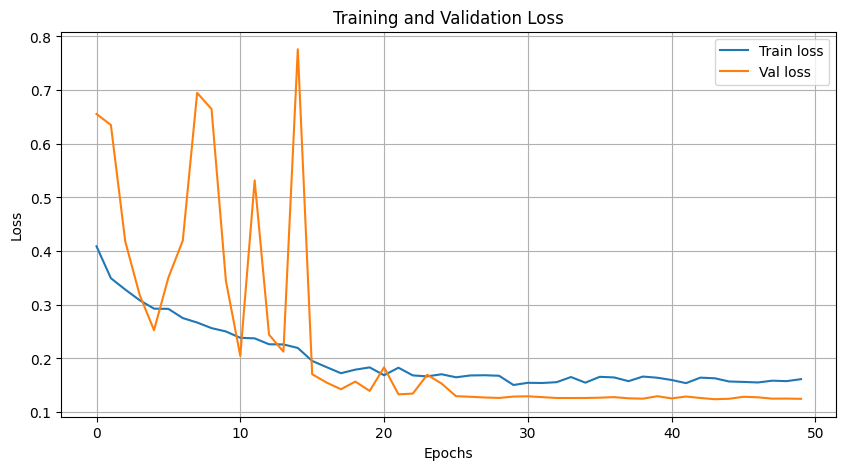

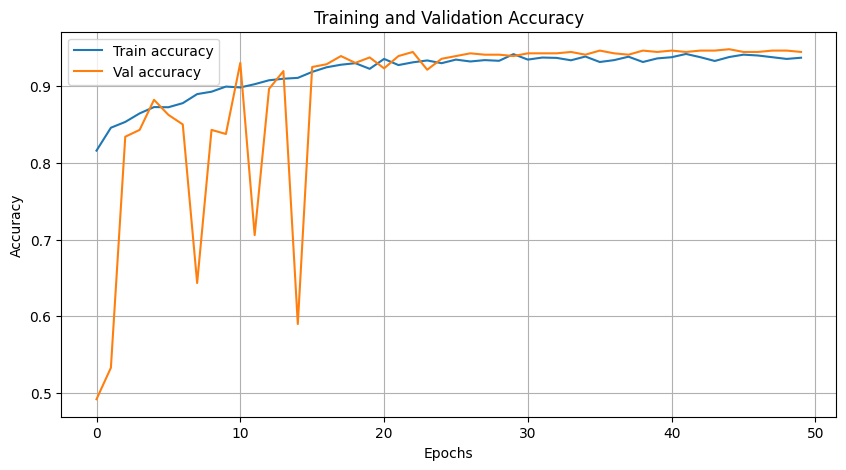

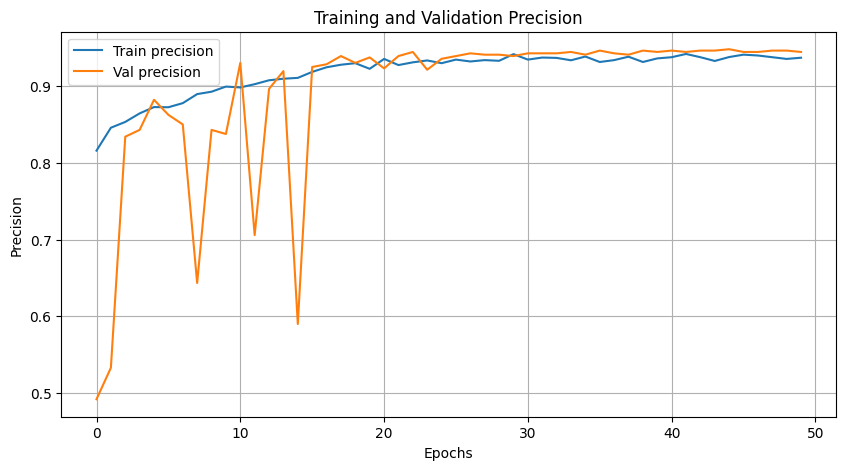

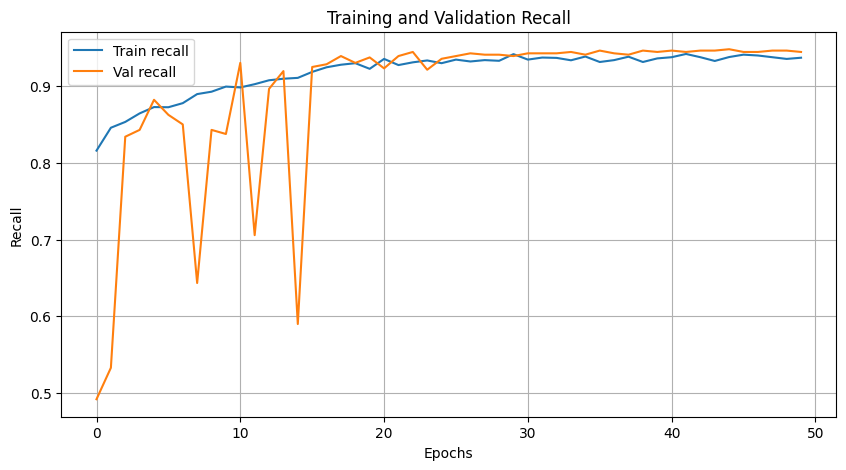

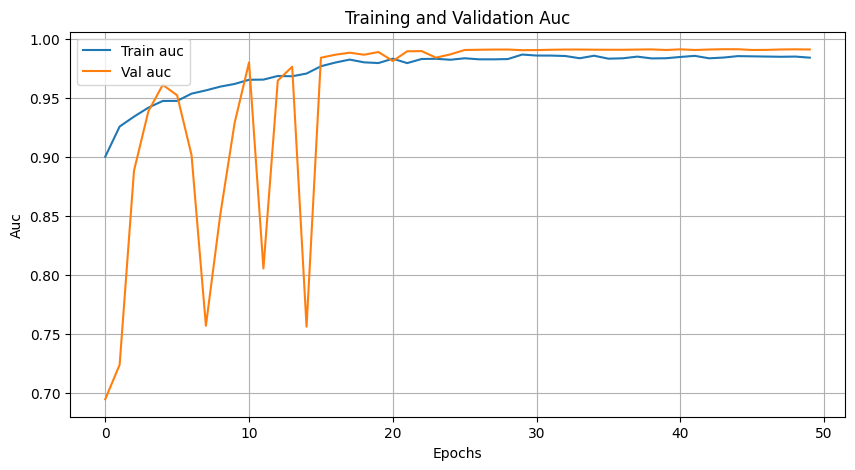

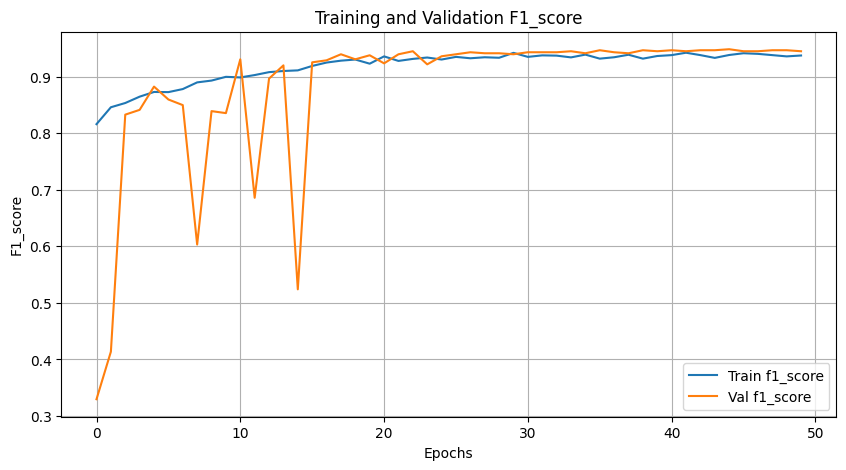

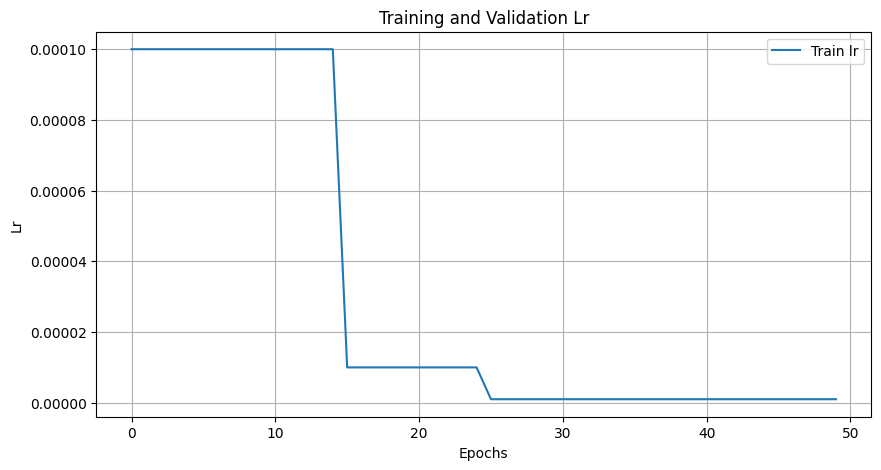

In [18]:
plot_training_history(history)

In [19]:
# Converter o histórico em DataFrame
history = pd.DataFrame(history.history)
# Salvar em CSV
history.to_csv('Recriar_Estudo_6_Aug_FLAME_train_history.csv', index=False)

In [20]:
model.save('Recriar_Estudo_6_Aug_FLAME.h5')

/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Avaliar

In [21]:
avaliar_modelo(model, test_generator, ig=True)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=277, TN=271, FP=5, FN=9
Accuracy       : 0.9751
Precision      : 0.9823
Recall         : 0.9685
F1-Score       : 0.9754
AUC            : 0.9960
Binary Loss    : 0.0891
FDR (Fire Detection Rate)      : 96.85 %
EWR (Error Warning Rate)       : 2.49 %
Confusion Matrix:
[[271   5]
 [  9 277]]


{'TP': 277,
 'TN': 271,
 'FP': 5,
 'FN': 9,
 'accuracy': 0.9750889679715302,
 'precision': 0.9822695035460993,
 'recall': 0.9685314685314685,
 'f1_score': 0.9753521126760563,
 'auc': 0.9959840883753928,
 'loss': 0.08907234447527042,
 'fdr': 96.85314685314685,
 'ewr': 2.491103202846975,
 'confusion_matrix': array([[271,   5],
        [  9, 277]])}

In [22]:
model_best = load_model('Recriar_Estudo_6_Aug_FLAME_best.h5')

In [23]:
avaliar_modelo(model_best, test_generator, ig=True)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=278, TN=271, FP=5, FN=8
Accuracy       : 0.9769
Precision      : 0.9823
Recall         : 0.9720
F1-Score       : 0.9772
AUC            : 0.9964
Binary Loss    : 0.0871
FDR (Fire Detection Rate)      : 97.20 %
EWR (Error Warning Rate)       : 2.31 %
Confusion Matrix:
[[271   5]
 [  8 278]]


{'TP': 278,
 'TN': 271,
 'FP': 5,
 'FN': 8,
 'accuracy': 0.9768683274021353,
 'precision': 0.9823321554770318,
 'recall': 0.972027972027972,
 'f1_score': 0.977152899824253,
 'auc': 0.9964274855579204,
 'loss': 0.08705434246720777,
 'fdr': 97.2027972027972,
 'ewr': 2.3131672597864767,
 'confusion_matrix': array([[271,   5],
        [  8, 278]])}

## Testar no FLAME train

In [24]:
data = pd.read_csv("../Datasets/FLAME_train.csv")
image_paths_flame_train = data['image_path'].values
labels_flame_train = data['label_bi'].values

test_ds_flame_train = tf.data.Dataset.from_tensor_slices((image_paths_flame_train, labels_flame_train))
test_ds_flame_train = test_ds_flame_train.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_train, name="FLAME train")

📊 FLAME TRAIN -> Total de imagens: 39375
  Classe 0 (Sem fogo): 14357 imagens (36.46%)
  Classe 1 (Fogo): 25018 imagens (63.54%)
----------------------------------------


In [25]:
avaliar_modelo(model, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=24381, TN=13943, FP=414, FN=637
Accuracy       : 0.9733
Precision      : 0.9833
Recall         : 0.9745
F1-Score       : 0.9789
AUC            : 0.9984
Binary Loss    : 0.0544
FDR (Fire Detection Rate)      : 97.45 %
EWR (Error Warning Rate)       : 2.67 %
Confusion Matrix:
[[13943   414]
 [  637 24381]]


{'TP': 24381,
 'TN': 13943,
 'FP': 414,
 'FN': 637,
 'accuracy': 0.9733079365079365,
 'precision': 0.9833030852994555,
 'recall': 0.9745383324006716,
 'f1_score': 0.9789010900768875,
 'auc': 0.9983639250659634,
 'loss': 0.05443156271597504,
 'fdr': 97.45383324006715,
 'ewr': 2.669206349206349,
 'confusion_matrix': array([[13943,   414],
        [  637, 24381]])}

In [26]:
avaliar_modelo(model_best, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=24370, TN=14040, FP=317, FN=648
Accuracy       : 0.9755
Precision      : 0.9872
Recall         : 0.9741
F1-Score       : 0.9806
AUC            : 0.9984
Binary Loss    : 0.0541
FDR (Fire Detection Rate)      : 97.41 %
EWR (Error Warning Rate)       : 2.45 %
Confusion Matrix:
[[14040   317]
 [  648 24370]]


{'TP': 24370,
 'TN': 14040,
 'FP': 317,
 'FN': 648,
 'accuracy': 0.9754920634920635,
 'precision': 0.9871592336047312,
 'recall': 0.9740986489727397,
 'f1_score': 0.98058545417966,
 'auc': 0.9984193438257364,
 'loss': 0.054070379710120575,
 'fdr': 97.40986489727396,
 'ewr': 2.4507936507936505,
 'confusion_matrix': array([[14040,   317],
        [  648, 24370]])}

## Testar no FLAME test

In [27]:
data = pd.read_csv("../Datasets/FLAME_test.csv")
image_paths_flame_test = data['image_path'].values
labels_flame_test = data['label_bi'].values

test_ds_flame_test = tf.data.Dataset.from_tensor_slices((image_paths_flame_test, labels_flame_test))
test_ds_flame_test = test_ds_flame_test.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_test, name="FLAME test")

📊 FLAME TEST -> Total de imagens: 8617
  Classe 0 (Sem fogo): 3480 imagens (40.39%)
  Classe 1 (Fogo): 5137 imagens (59.61%)
----------------------------------------


In [28]:
avaliar_modelo(model, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=4758, TN=2918, FP=562, FN=379
Accuracy       : 0.8908
Precision      : 0.8944
Recall         : 0.9262
F1-Score       : 0.9100
AUC            : 0.9487
Binary Loss    : 0.2924
FDR (Fire Detection Rate)      : 92.62 %
EWR (Error Warning Rate)       : 10.92 %
Confusion Matrix:
[[2918  562]
 [ 379 4758]]


{'TP': 4758,
 'TN': 2918,
 'FP': 562,
 'FN': 379,
 'accuracy': 0.8907972612278054,
 'precision': 0.8943609022556391,
 'recall': 0.9262215300759198,
 'f1_score': 0.9100124318638233,
 'auc': 0.9486550694868645,
 'loss': 0.2924332544167786,
 'fdr': 92.62215300759198,
 'ewr': 10.920273877219449,
 'confusion_matrix': array([[2918,  562],
        [ 379, 4758]])}

In [29]:
avaliar_modelo(model_best, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=4791, TN=2922, FP=558, FN=346
Accuracy       : 0.8951
Precision      : 0.8957
Recall         : 0.9326
F1-Score       : 0.9138
AUC            : 0.9505
Binary Loss    : 0.2880
FDR (Fire Detection Rate)      : 93.26 %
EWR (Error Warning Rate)       : 10.49 %
Confusion Matrix:
[[2922  558]
 [ 346 4791]]


{'TP': 4791,
 'TN': 2922,
 'FP': 558,
 'FN': 346,
 'accuracy': 0.8950910989903679,
 'precision': 0.8956814357823892,
 'recall': 0.9326455129452988,
 'f1_score': 0.9137898149914172,
 'auc': 0.9504521512846846,
 'loss': 0.28795959961292195,
 'fdr': 93.26455129452988,
 'ewr': 10.490890100963213,
 'confusion_matrix': array([[2922,  558],
        [ 346, 4791]])}

## Testar no UAVS Raw Images

In [30]:
data = pd.read_csv("../Datasets/UAVS_RawImages.csv")
image_paths_uavs_raw = data['image_path'].values
labels_uavs_raw = data['label_bi'].values

test_ds_uavs_raw = tf.data.Dataset.from_tensor_slices((image_paths_uavs_raw, labels_uavs_raw))
test_ds_uavs_raw = test_ds_uavs_raw.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_raw, name="UAVS Raw Images")

📊 UAVS RAW IMAGES -> Total de imagens: 1643
  Classe 0 (Sem fogo): 498 imagens (30.31%)
  Classe 1 (Fogo): 1145 imagens (69.69%)
----------------------------------------


In [31]:
avaliar_modelo(model, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=613, TN=319, FP=179, FN=532
Accuracy       : 0.5673
Precision      : 0.7740
Recall         : 0.5354
F1-Score       : 0.6329
AUC            : 0.7447
Binary Loss    : 0.8640
FDR (Fire Detection Rate)      : 53.54 %
EWR (Error Warning Rate)       : 43.27 %
Confusion Matrix:
[[319 179]
 [532 613]]


{'TP': 613,
 'TN': 319,
 'FP': 179,
 'FN': 532,
 'accuracy': 0.5672550213024954,
 'precision': 0.773989898989899,
 'recall': 0.5353711790393013,
 'f1_score': 0.6329375322663913,
 'auc': 0.7447308886199822,
 'loss': 0.8640018545758849,
 'fdr': 53.53711790393013,
 'ewr': 43.274497869750455,
 'confusion_matrix': array([[319, 179],
        [532, 613]])}

In [32]:
avaliar_modelo(model_best, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=612, TN=320, FP=178, FN=533
Accuracy       : 0.5673
Precision      : 0.7747
Recall         : 0.5345
F1-Score       : 0.6326
AUC            : 0.7453
Binary Loss    : 0.8753
FDR (Fire Detection Rate)      : 53.45 %
EWR (Error Warning Rate)       : 43.27 %
Confusion Matrix:
[[320 178]
 [533 612]]


{'TP': 612,
 'TN': 320,
 'FP': 178,
 'FN': 533,
 'accuracy': 0.5672550213024954,
 'precision': 0.7746835443037975,
 'recall': 0.5344978165938865,
 'f1_score': 0.6325581395348838,
 'auc': 0.7453236526893601,
 'loss': 0.8752660889470658,
 'fdr': 53.44978165938865,
 'ewr': 43.274497869750455,
 'confusion_matrix': array([[320, 178],
        [533, 612]])}

## Testar no UAVS Augmented Images

In [33]:
data = pd.read_csv("../Datasets/UAVS_AugmentedImages.csv")
image_paths_uavs_aug = data['image_path'].values
labels_uavs_aug = data['label_bi'].values

test_ds_uavs_aug = tf.data.Dataset.from_tensor_slices((image_paths_uavs_aug, labels_uavs_aug))
test_ds_uavs_aug = test_ds_uavs_aug.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_aug, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 15560
  Classe 0 (Sem fogo): 7780 imagens (50.00%)
  Classe 1 (Fogo): 7780 imagens (50.00%)
----------------------------------------


In [34]:
avaliar_modelo(model, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=4847, TN=4374, FP=3406, FN=2933
Accuracy       : 0.5926
Precision      : 0.5873
Recall         : 0.6230
F1-Score       : 0.6046
AUC            : 0.7690
Binary Loss    : 1.0049
FDR (Fire Detection Rate)      : 62.30 %
EWR (Error Warning Rate)       : 40.74 %
Confusion Matrix:
[[4374 3406]
 [2933 4847]]


{'TP': 4847,
 'TN': 4374,
 'FP': 3406,
 'FN': 2933,
 'accuracy': 0.5926092544987146,
 'precision': 0.5873015873015873,
 'recall': 0.6230077120822622,
 'f1_score': 0.604627954843136,
 'auc': 0.7689636765551378,
 'loss': 1.0049324513674223,
 'fdr': 62.30077120822622,
 'ewr': 40.739074550128535,
 'confusion_matrix': array([[4374, 3406],
        [2933, 4847]])}

In [35]:
avaliar_modelo(model_best, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=4868, TN=4378, FP=3402, FN=2912
Accuracy       : 0.5942
Precision      : 0.5886
Recall         : 0.6257
F1-Score       : 0.6066
AUC            : 0.7694
Binary Loss    : 1.0208
FDR (Fire Detection Rate)      : 62.57 %
EWR (Error Warning Rate)       : 40.58 %
Confusion Matrix:
[[4378 3402]
 [2912 4868]]


{'TP': 4868,
 'TN': 4378,
 'FP': 3402,
 'FN': 2912,
 'accuracy': 0.5942159383033419,
 'precision': 0.5886336154776299,
 'recall': 0.625706940874036,
 'f1_score': 0.6066043613707165,
 'auc': 0.7693688582549679,
 'loss': 1.0207711566417854,
 'fdr': 62.5706940874036,
 'ewr': 40.57840616966581,
 'confusion_matrix': array([[4378, 3402],
        [2912, 4868]])}

## Testar no FireMan

In [36]:
data = pd.read_csv("../Datasets/FireMan_test.csv")
image_paths_fireman = data['image_path'].values
labels_fireman = data['label_bi'].values

test_ds_fireman = tf.data.Dataset.from_tensor_slices((image_paths_fireman, labels_fireman))
test_ds_fireman = test_ds_fireman.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_fireman, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 589
  Classe 0 (Sem fogo): 33 imagens (5.60%)
  Classe 1 (Fogo): 556 imagens (94.40%)
----------------------------------------


In [37]:
avaliar_modelo(model, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=493, TN=0, FP=33, FN=63
Accuracy       : 0.8370
Precision      : 0.9373
Recall         : 0.8867
F1-Score       : 0.9113
AUC            : 0.2196
Binary Loss    : 0.9259
FDR (Fire Detection Rate)      : 88.67 %
EWR (Error Warning Rate)       : 16.30 %
Confusion Matrix:
[[  0  33]
 [ 63 493]]


{'TP': 493,
 'TN': 0,
 'FP': 33,
 'FN': 63,
 'accuracy': 0.8370118845500849,
 'precision': 0.9372623574144486,
 'recall': 0.8866906474820144,
 'f1_score': 0.911275415896488,
 'auc': 0.2195879659908437,
 'loss': 0.9258617710983736,
 'fdr': 88.66906474820144,
 'ewr': 16.298811544991512,
 'confusion_matrix': array([[  0,  33],
        [ 63, 493]])}

In [38]:
avaliar_modelo(model_best, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=494, TN=0, FP=33, FN=62
Accuracy       : 0.8387
Precision      : 0.9374
Recall         : 0.8885
F1-Score       : 0.9123
AUC            : 0.2547
Binary Loss    : 0.8799
FDR (Fire Detection Rate)      : 88.85 %
EWR (Error Warning Rate)       : 16.13 %
Confusion Matrix:
[[  0  33]
 [ 62 494]]


{'TP': 494,
 'TN': 0,
 'FP': 33,
 'FN': 62,
 'accuracy': 0.8387096774193549,
 'precision': 0.937381404174573,
 'recall': 0.8884892086330936,
 'f1_score': 0.912280701754386,
 'auc': 0.25468715936341835,
 'loss': 0.879908385550384,
 'fdr': 88.84892086330936,
 'ewr': 16.129032258064516,
 'confusion_matrix': array([[  0,  33],
        [ 62, 494]])}